# This notebook trains a model with additional loss for Sufficiency on CORA

In [2]:
import pandas as pd
import torch_geometric
import networkx as nx
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import numpy as np
import torch
dataset = Planetoid(root='/tmp/Cora/', name='Cora')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import torch
import torch.nn.functional as F
from typing import Tuple
from torch_geometric.utils.num_nodes import maybe_num_nodes
from torch_geometric.utils import k_hop_subgraph, to_undirected
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.data import Data
from graphxai.explainers._base import _BaseExplainer

import numpy as np
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import k_hop_subgraph



class _BaseExplainer:
    """
    Base Class for Explainers
    """
    def __init__(self,
            model: nn.Module,
            emb_layer_name: Optional[str] = None,
            is_subgraphx: Optional[bool] = False
        ):
        """
        Args:
            model (torch.nn.Module): model on which to make predictions
                The output of the model should be unnormalized class score.
                For example, last layer = GCNConv or Linear.
            emb_layer_name (str, optional): name of the embedding layer
                If not specified, use the last but one layer by default.
        """
        self.model = model
        self.L = len([module for module in self.model.modules()
                      if isinstance(module, MessagePassing)])
        self.explain_graph = False  # Assume node-level explanation by default
        self.subgraphx_flag = is_subgraphx
        self.__set_embedding_layer(emb_layer_name)

    def __set_embedding_layer(self, emb_layer_name: str = None):
        """
        Set the embedding layer (by default is the last but one layer).
        """
        if emb_layer_name:
            try:
                self.emb_layer = getattr(self.model, emb_layer_name)
            except AttributeError:
                raise ValueError(f'{emb_layer_name} does not exist in the model')
        else:
            self.emb_layer = list(self.model.modules())[-2]

    def _get_embedding(self, x: torch.Tensor, edge_index: torch.Tensor,
                       forward_kwargs: dict = {}):
        """
        Get the embedding.
        """
        emb = self._get_activation(self.emb_layer, x, edge_index, forward_kwargs)
        return emb

    def _set_masks(self, x: torch.Tensor, edge_index: torch.Tensor,
                   edge_mask: torch.Tensor = None, explain_feature: bool = False,
                   device = None):
        """
        Initialize the edge (and feature) masks.
        """
        (n, d), m = x.shape, edge_index.shape[1]

        # Initialize edge_mask and feature_mask for learning
        std = torch.nn.init.calculate_gain('relu') * np.sqrt(2.0 / (2 * n))
        if edge_mask is None:
            edge_mask = (torch.randn(m) * std).to(device)
            self.edge_mask = torch.nn.Parameter(edge_mask)
        else:
            self.edge_mask = torch.nn.Parameter(edge_mask)
        if explain_feature:
            feature_mask = (torch.randn(d) * 0.1).to(device)
            self.feature_mask = torch.nn.Parameter(feature_mask)

        self.loop_mask = edge_index[0] != edge_index[1]

        # Tell pytorch geometric to apply edge masks
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = True
                module.__edge_mask__ = self.edge_mask
                module.__loop_mask__ = self.loop_mask

    def _clear_masks(self):
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = None
        self.edge_mask = None
        self.feature_mask = None

    def _flow(self):
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                return module.flow
        return 'source_to_target'

    def _predict(self, x: torch.Tensor, edge_index: torch.Tensor,
                 return_type: str = 'label', forward_kwargs: dict = {}):
        """
        Get the model's prediction.

        Args:
            x (torch.Tensor, [n x d]): node features
            edge_index (torch.Tensor, [2 x m]): edge index of the graph
            return_type (str): one of ['label', 'prob', 'log_prob']
            forward_kwargs (dict, optional): additional arguments to model.forward
                beyond x and edge_index

        Returns:
            pred (torch.Tensor, [n x ...]): model prediction
        """
        # Compute unnormalized class score
        with torch.no_grad():
            out = self.model.to(device)(x, edge_index, **forward_kwargs)
            if return_type == 'label':
                out = out.argmax(dim=-1)
            elif return_type == 'prob':
                out = F.softmax(out, dim=-1)
            elif return_type == 'log_prob':
                out = F.log_softmax(out, dim=-1)
            else:
                raise ValueError("return_type must be 'label', 'prob', or 'log_prob'")

            if self.explain_graph:
                out = out.squeeze()

            return out

    def _prob_score_func_graph(self, target_class: torch.Tensor):
        """
        Get a function that computes the predicted probability that the input graphs
        are classified as target classes.

        Args:
            target_class (int): the targeted class of the graph

        Returns:
            get_prob_score (callable): the probability score function
        """
        def get_prob_score(x: torch.Tensor,
                           edge_index: torch.Tensor,
                           forward_kwargs: dict = {}):
            prob = self._predict(x, edge_index, return_type='prob',
                                 forward_kwargs=forward_kwargs)
            score = prob[:, target_class]
            return score

        return get_prob_score

    def _prob_score_func_node(self, node_idx: torch.Tensor, target_class: torch.Tensor):
        """
        Get a function that computes the predicted probabilities that k specified nodes
        in `torch_geometric.data.Batch` (disconnected union of the input graphs)
        are classified as target classes.

        Args:
            node_idx (torch.Tensor, [k]): the indices of the k nodes interested
            target_class (torch.Tensor, [k]): the targeted classes of the k nodes

        Returns:
            get_prob_score (callable): the probability score function
        """
        if self.subgraphx_flag:
            def get_prob_score(x: torch.Tensor,
                            edge_index: torch.Tensor,
                            forward_kwargs: dict = {}):
                prob = self._predict(x, edge_index, return_type='prob',
                                    forward_kwargs=forward_kwargs)
                score = prob[node_idx, target_class]
                return score
        else:
            def get_prob_score(x: torch.Tensor,
                            edge_index: torch.Tensor,
                            forward_kwargs: dict = {}):
                prob = self._predict(x, edge_index, return_type='prob',
                                    forward_kwargs=forward_kwargs)
                score = prob[:, node_idx, target_class]
                return score

        return get_prob_score

    def _get_activation(self, layer: nn.Module, x: torch.Tensor,
                        edge_index: torch.Tensor, forward_kwargs: dict = {}):
        """
        Get the activation of the layer.
        """
        activation = {}
        def get_activation():
            def hook(model, inp, out):
                activation['layer'] = out.detach()
            return hook

        layer.register_forward_hook(get_activation())

        with torch.no_grad():
            _ = self.model(x, edge_index, **forward_kwargs)

        return activation['layer']

    def _get_k_hop_subgraph(self, node_idx: int, x: torch.Tensor,
                            edge_index: torch.Tensor, num_hops: int = None, **kwargs):
        """
        Extract the subgraph of target node

        Args:
            node_idx (int): the node index
            x (torch.Tensor, [n x d]): node feature matrix with shape
            edge_index (torch.Tensor, [2 x m]): edge index
            kwargs (dict): additional parameters of the graph

        Returns:
        """
        # TODO: use NamedTuple
        khop_info = subset, sub_edge_index, mapping, _ = \
            k_hop_subgraph(node_idx, num_hops, edge_index,
                           relabel_nodes=True, num_nodes=x.shape[0])
        return khop_info

    def get_explanation_node(self, node_idx: int,
                             x: torch.Tensor,
                             edge_index: torch.Tensor,
                             label: torch.Tensor = None,
                             num_hops: int = None,
                             forward_kwargs: dict = {}):
        """
        Explain a node prediction.

        Args:
            node_idx (int): index of the node to be explained
            x (torch.Tensor, [n x d]): node features
            edge_index (torch.Tensor, [2 x m]): edge index of the graph
            label (torch.Tensor, optional, [n x ...]): labels to explain
                If not provided, we use the output of the model.
            num_hops (int, optional): number of hops to consider
                If not provided, we use the number of graph layers of the GNN.
            forward_kwargs (dict, optional): additional arguments to model.forward
                beyond x and edge_index

        Returns:
            exp (dict):
                exp['feature_imp'] (torch.Tensor, [d]): feature mask explanation
                exp['edge_imp'] (torch.Tensor, [m]): k-hop edge importance
                exp['node_imp'] (torch.Tensor, [m]): k-hop node importance
            khop_info (4-tuple of torch.Tensor):
                0. the nodes involved in the subgraph
                1. the filtered `edge_index`
                2. the mapping from node indices in `node_idx` to their new location
                3. the `edge_index` mask indicating which edges were preserved
        """
        # If labels are needed
        label = self._predict(x, edge_index, return_type='label') if label is None else label
        # If probabilities / log probabilities are needed
        prob = self._predict(x, edge_index, return_type='prob')
        log_prob = self._predict(x, edge_index, return_type='log_prob')

        num_hops = self.L if num_hops is None else num_hops

        khop_info = subset, sub_edge_index, mapping, _ = \
            k_hop_subgraph(node_idx, num_hops, edge_index,
                           relabel_nodes=True, num_nodes=x.shape[0])
        sub_x = x[subset]

        exp = {'feature_imp': None, 'edge_imp': None}

        # Compute exp
        raise NotImplementedError()

        return exp, khop_info

    def get_explanation_graph(self, edge_index: torch.Tensor,
                              x: torch.Tensor, label: torch.Tensor,
                              forward_kwargs: dict = {}):
        """
        Explain a whole-graph prediction.

        Args:
            edge_index (torch.Tensor, [2 x m]): edge index of the graph
            x (torch.Tensor, [n x d]): node features
            label (torch.Tensor, [n x ...]): labels to explain
            forward_kwargs (dict, optional): additional arguments to model.forward
                beyond x and edge_index

        Returns:
            exp (dict):
                exp['feature_imp'] (torch.Tensor, [d]): feature mask explanation
                exp['edge_imp'] (torch.Tensor, [m]): k-hop edge importance
                exp['node_imp'] (torch.Tensor, [m]): k-hop node importance
        """
        exp = {'feature_imp': None, 'edge_imp': None}

        # Compute exp
        raise NotImplementedError()

    def get_explanation_link(self):
        """
        Explain a link prediction.
        """
        raise NotImplementedError()

from graphxai.utils import Explanation
from typing import List, Tuple, Dict

from math import sqrt
import numpy as np

import torch
from torch import Tensor
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import k_hop_subgraph as subgraph

class GNNPool(nn.Module):
    def __init__(self):
        super().__init__()

class _BaseDecomposition(_BaseExplainer):
    '''
    Code adapted from Dive into Graphs (DIG)
    Code: https://github.com/divelab/DIG
    '''

    def __init__(self, model: nn.Module):
        super().__init__(model=model) # Will set self.model = model
        # Other properties: self.L (number of layers)

    @property
    def __num_hops__(self):
        if self.explain_graph:
            return -1
        else:
            return self.L
    
    def set_graph_attr(self,
                x: Tensor,
                edge_index: Tensor,
                **kwargs
                ):
        self.num_edges = edge_index.shape[1]
        self.num_nodes = x.shape[0]
        self.device = x.device

    def extract_step(self, x: Tensor, edge_index: Tensor, detach: bool = True, split_fc: bool = False, forward_kwargs: dict = None):
        '''Gets information about every layer in the graph
        Args:

            forward_kwargs (tuple, optional): Additional arguments to model forward call (other than x and edge_index)
                (default: :obj:`None`)
        '''

        layer_extractor = []
        hooks = []

        def register_hook(module: nn.Module):
            if not list(module.children()) or isinstance(module, MessagePassing):
                hooks.append(module.register_forward_hook(forward_hook))

        def forward_hook(module: nn.Module, input: Tuple[Tensor], output: Tensor):
            # input contains x and edge_index
            if detach:
                layer_extractor.append((module, input[0].clone().detach(), output.clone().detach()))
            else:
                layer_extractor.append((module, input[0], output))

        # --- register hooks ---
        self.model.apply(register_hook)

        # ADDED: OWEN QUEEN --------------
        if forward_kwargs is None:
            _ = self.model(x, edge_index)
        else:
            _ = self.model(x, edge_index, **forward_kwargs)
        # --------------------------------
        # Remove hooks:
        for hook in hooks:
            hook.remove()

        # --- divide layer sets ---

        # print('Layer extractor', [layer_extractor[i][0] for i in range(len(layer_extractor))])

        walk_steps = []
        fc_steps = []
        pool_flag = False
        step = {'input': None, 'module': [], 'output': None}
        for layer in layer_extractor:
            if isinstance(layer[0], MessagePassing):
                if step['module']: # Append step that had previously been building
                    walk_steps.append(step)

                step = {'input': layer[1], 'module': [], 'output': None}

            elif isinstance(layer[0], GNNPool):
                pool_flag = True
                if step['module']:
                    walk_steps.append(step)

                # Putting in GNNPool
                step = {'input': layer[1], 'module': [], 'output': None}

            elif isinstance(layer[0], nn.Linear):
                if step['module']:
                    if isinstance(step['module'][0], MessagePassing):
                        walk_steps.append(step) # Append MessagePassing layer to walk_steps
                    else: # Always append Linear layers to fc_steps
                        fc_steps.append(step)

                step = {'input': layer[1], 'module': [], 'output': None}

            # Also appends non-trainable layers to step (not modifying input):
            step['module'].append(layer[0])
            step['output'] = layer[2]

        if step['module']:
            if isinstance(step['module'][0], MessagePassing):
                walk_steps.append(step)
            else: # Append anything to FC that is not MessagePassing at its origin
                # Still supports sequential layers
                fc_steps.append(step)
            # print('layer', layer[0])
            # if isinstance(layer[0], MessagePassing) or isinstance(layer[0], GNNPool):
            #     if isinstance(layer[0], GNNPool):
            #         pool_flag = True
            #     if step['module'] and step['input'] is not None:
            #         walk_steps.append(step)
            #     step = {'input': layer[1], 'module': [], 'output': None}
            # if pool_flag and split_fc and isinstance(layer[0], nn.Linear):
            #     if step['module']:
            #         fc_steps.append(step)
            #     step = {'input': layer[1], 'module': [], 'output': None}
            # step['module'].append(layer[0])
            # step['output'] = layer[2]

        for walk_step in walk_steps:
            if hasattr(walk_step['module'][0], 'nn') and walk_step['module'][0].nn is not None:
                # We don't allow any outside nn during message flow process in GINs
                walk_step['module'] = [walk_step['module'][0]]
            elif hasattr(walk_step['module'][0], 'lin') and walk_step['module'][0].lin is not None:
                walk_step['module'] = [walk_step['module'][0]]

        # print('Walk steps', [walk_steps[i]['module'] for i in range(len(walk_steps))])
        # print('fc steps', [fc_steps[i]['module'] for i in range(len(fc_steps))])

        return walk_steps, fc_steps

    def walks_pick(self,
                   edge_index: Tensor,
                   pick_edge_indices: List,
                   walk_indices: List=[],
                   num_layers=0
                   ):
        walk_indices_list = []
        for edge_idx in pick_edge_indices:

            # Adding one edge
            walk_indices.append(edge_idx)
            _, new_src = src, tgt = edge_index[:, edge_idx]
            next_edge_indices = np.array((edge_index[0, :] == new_src).nonzero().view(-1))

            # Finding next edge
            if len(walk_indices) >= num_layers:
                # return one walk
                walk_indices_list.append(walk_indices.copy())
            else:
                walk_indices_list += self.walks_pick(edge_index, next_edge_indices, walk_indices, num_layers)

            # remove the last edge
            walk_indices.pop(-1)

        return walk_indices_list

class CAM(_BaseDecomposition):
    '''
    Class-Activation Mapping for GNNs
    '''

    def __init__(self, model: torch.nn.Module, activation = None):
        '''
        .. note::
            From Pope et al., CAM requires that the layer immediately before the softmax layer be
            a global average pooling layer, or in the case of node classification, a graph convolutional
            layer. Therefore, for this algorithm to theoretically work, there can be no fully-connected
            layers after global pooling. There is no restriction in the code for this, but be warned. 

        Args:
            model (torch.nn.Module): model on which to make predictions
            activation (method, optional): activation funciton for final layer in network. If `activation = None`,
                explainer assumes linear activation. Use `activation = None` if the activation is applied
                within the `forward` method of `model`, only set this parameter if another activation is
                applied in the training procedure outside of model. (:default: :obj:`None`)
        '''
        super().__init__(model=model)
        self.model = model

        # Set activation function
        self.activation = lambda x: x  if activation is None else activation
        # i.e. linear activation if none provided

    def get_explanation_node(self, 
                x: torch.Tensor, 
                node_idx: int, 
                edge_index: torch.Tensor, 
                label: int = None,  
                y = None,
                forward_kwargs: dict = {},
                directed: bool = False
            ) -> Explanation:
        '''
        Explain one node prediction by the model

        Args:
            x (torch.tensor): tensor of node features from the entire graph
            node_idx (int): node index for which to explain a prediction around
            edge_index (torch.tensor): edge_index of entire graph
            label (int, optional): Label on which to compute the explanation for
                this node. If `None`, the predicted label from the model will be
                used. (default: :obj:`None`)
            forward_kwargs (dict, optional): Additional arguments to model.forward 
                beyond x and edge_index. Must be keyed on argument name. 
                (default: :obj:`{}`)
            directed (bool, optional): If True, graph is directed.

        :rtype: :class:`graphxai.Explanation`

        Returns:
            exp (:class:`Explanation`): Explanation output from the method.
                Fields are:
                `feature_imp`: :obj:`None`
                `node_imp`: :obj:`torch.Tensor, [nodes_in_khop,]`
                `edge_imp`: :obj:`None`
                `enc_subgraph`: :obj:`graphxai.utils.EnclosingSubgraph`
        '''

        if not directed:
            edge_index = to_undirected(edge_index)

        if label is None:
            if y is None:
                label = int(self.__forward_pass(x, edge_index, forward_kwargs).argmax(dim=1).item())
            else:
                label = y[node_idx]

        # Perform walk:
        walk_steps, _ = self.extract_step(x, edge_index, detach=False, split_fc=False, forward_kwargs = forward_kwargs)

        # Get subgraph:
        khop_info = k_hop_subgraph(node_idx = node_idx, num_hops = self.L, edge_index = edge_index)
        subgraph_nodes = khop_info[0]

        N = maybe_num_nodes(edge_index, None)
        subgraph_N = len(subgraph_nodes.tolist())

        #cam = torch.zeros(N) # Compute CAM only over the subgraph (all others are zero)
        cam = torch.zeros(subgraph_N)
        for i in range(subgraph_N):
            n = subgraph_nodes[i]
            cam[i] += self.__exp_node(n, walk_steps, label)

        # Set Explanation class:
        exp = Explanation(
            node_imp = cam,
            node_idx = node_idx
        )
        exp.set_enclosing_subgraph(khop_info)

        return exp

    def __forward_pass(self, x, edge_index, forward_kwargs = {}):
        # Forward pass:
        self.model.eval()
        pred = self.model(x, edge_index, **forward_kwargs)

        return pred

    def __exp_node(self, node_idx, walk_steps, predicted_c):
        '''
        Gets explanation for one node
        Assumes ReLU activation after last convolutiuonal layer
        TODO: Fix activation function assumption
        '''
        last_conv_layer = walk_steps[-1]

        if isinstance(last_conv_layer['module'][0], GINConv):
            weight_vec = last_conv_layer['module'][0].nn.weight[predicted_c, :].detach()  # last_conv_layer['module'][0].lin.weight[predicted_c, :].detach()
        elif isinstance(last_conv_layer['module'][0], GCNConv):
            weight_vec = last_conv_layer['module'][0].lin.weight[predicted_c, :].detach()
        elif isinstance(last_conv_layer['module'][0], torch.nn.Linear):
            weight_vec = last_conv_layer['module'][0].weight[predicted_c, :].detach()

        F_l_n = F.relu(last_conv_layer['input'][node_idx,:]).detach()

        L_cam_n = F.relu(torch.matmul(weight_vec, F_l_n))

        return L_cam_n.item()


class GradCAM(_BaseDecomposition):
    '''
    Gradient Class-Activation Mapping for GNNs
    '''

    def __init__(self, model: torch.Tensor, criterion = F.cross_entropy):
        '''
        Args:
            model (torch.nn.Module): model on which to make predictions
            criterion (PyTorch Loss Function): loss function used to train the model.
                Needed to pass gradients backwards in the network to obtain gradients.
        '''
        super().__init__(model)
        self.model = model
        self.criterion = criterion

    def get_explanation_node(self, 
            x: torch.Tensor, 
            y: torch.Tensor, 
            node_idx: int, 
            edge_index: torch.Tensor, 
            label: int = None, 
            forward_kwargs: dict = {}, 
            average_variant: bool = True, 
            layer: int = 0
        ) -> Explanation:
        '''
        Explain a node in the given graph
        Args:
            x (torch.Tensor, (n,)): Tensor of node features from the entire graph, with n nodes.
            y (torch.Tensor, (n,)): Ground-truth labels for all n nodes in the graph.
            node_idx (int): node index for which to explain a prediction around
            edge_index (torch.Tensor): Edge_index of entire graph.
            label (int, optional): Label for which to compute Grad-CAM against. If None, computes
                the Grad-CAM with respect to the model's predicted class for this node.
                (default :obj:`None`)
            forward_kwargs (dict, optional): Additional arguments to model.forward 
                beyond x and edge_index. (default: :obj:`None`)
            average_variant (bool, optional): If True, computes the average Grad-CAM across all convolutional
                layers in the model. If False, computes Grad-CAM for `layer`. (default: :obj:`True`)
            layer (int, optional): Layer by which to compute the Grad-CAM. Argument only has an effect if 
                `average_variant == True`. Must be less-than the total number of convolutional layers
                in the model. (default: :obj:`0`)

        :rtype: :class:`graphxai.Explanation`

        Returns:
            exp (:class:`Explanation`): Explanation output from the method.
                Fields are:
                `feature_imp`: :obj:`None`
                `node_imp`: :obj:`torch.Tensor, [nodes_in_khop,]`
                `edge_imp`: :obj:`None`
                `enc_subgraph`: :obj:`graphxai.utils.EnclosingSubgraph`
        '''

        x = x.detach().clone()
        y = y.detach().clone()

        x.requires_grad = True

        if label is None:
            pred = self.__forward_pass(x, y, edge_index, forward_kwargs)[0][node_idx, :].reshape(1, -1)
            y[node_idx] = pred.argmax(dim=1).item()
        else: # Transform node_idx's label if provided by user
            pred, loss = self.__forward_pass(x, y, edge_index, forward_kwargs)
            y[node_idx] = label

        walk_steps, _ = self.extract_step(x, edge_index, detach=True, split_fc=True, forward_kwargs = forward_kwargs)

        khop_info = k_hop_subgraph(node_idx, self.L, edge_index)
        subgraph_nodes = khop_info[0]

        N = maybe_num_nodes(edge_index, None)
        subgraph_N = len(subgraph_nodes.tolist())

        exp = Explanation(
            node_idx = node_idx
        )
        exp.set_enclosing_subgraph(khop_info)

        if average_variant:
            # Size of all nodes in the subgraph:
            avg_gcam = torch.zeros(subgraph_N)

            for l in range(self.L):
                # Compute gradients for this layer ahead of time:
                gradients = self.__grad_by_layer(l)

                for i in range(subgraph_N): # Over all subgraph nodes
                    n = subgraph_nodes[i]
                    avg_gcam[i] += self.__get_gCAM_layer(walk_steps, l, n, gradients)

            avg_gcam /= self.L # Apply average

            exp.node_imp = avg_gcam

        else:
            assert layer < len(walk_steps), "Layer must be an index of convolutional layers"

            gcam = torch.zeros(subgraph_N)
            gradients = self.__grad_by_layer(layer)
            for i in range(subgraph_N):
                n = subgraph_nodes[i]
                gcam[i] += self.__get_gCAM_layer(walk_steps, layer, n, gradients)#[0]

            exp.node_imp = gcam

        return exp
        
    def __forward_pass(self, x, label, edge_index, forward_kwargs):
        x.requires_grad = True # Enforce that x needs gradient

        # Forward pass:
        self.model.eval()
        pred = self.model(x, edge_index, **forward_kwargs)

        loss = self.criterion(pred, label)
        loss.backward() # Propagate loss backward through network

        return pred, loss

    def __grad_by_layer(self, layer):
        # Index 0 of parameters to avoid calculating gradients for biases
        module_at_layer = list(self.model.children())[layer]

        if isinstance(module_at_layer, GCNConv):
            grad = module_at_layer.lin.weight.grad
        elif isinstance(module_at_layer, GINConv):
            grad = module_at_layer.nn.weight.grad
        else:
            grad = module_at_layer.weight.grad

        return grad.mean(dim=1)

    def __get_gCAM_layer(self, walk_steps, layer, node_idx = None, gradients = None):
        # Gets Grad CAM for one layer
        if gradients is None:
            # \alpha^{l,c} = Average over nodes of gradients for layer l, after activation over c
            # ''        '' shape: [k,] - k= # output features from layer l
            gradients = self.__grad_by_layer(layer)

        if node_idx is None: # Need to compute for entire graph:
            node_explanations = []
            for n in range(self.N):
                node_explanations.append(self.__exp_node(n, walk_steps, layer, gradients))

            return node_explanations

        # Return for only one node:
        return self.__exp_node(node_idx, walk_steps, layer, gradients)

    def __exp_node(self, node_idx, walk_steps, layer, gradients):
        '''
        Gets explanation for one node
        Assumes ReLU activation after each convolutional layer
        TODO: Fix activation function assumption
        '''
        # \alpha^{l,c} = Average over nodes of gradients for layer l, after activation over c
        # ''        '' shape: [k,] - k= # input features to layer l

        # Activations for node n
        F_l_n = F.relu(walk_steps[layer]['output'][node_idx,:]).detach()
        L_cam_n = F.relu(torch.matmul(gradients, F_l_n)) # Combine gradients and activations

        return L_cam_n.item()

import torch
import torch.nn.functional as F
from typing import Tuple
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.data import Data

from graphxai.utils import Explanation
# from ._decomp_base_old import _BaseDecomposition

def clip_hook(grad):
    # Apply ReLU activation to gradient
    return torch.clamp(grad, min=0)
import gc

class GuidedBP(_BaseDecomposition):

    def __init__(self, model, criterion = F.cross_entropy, enforce_requires_grad = True):
        '''
        Args:
            model (torch.nn.Module): model on which to make predictions
            criterion (PyTorch Loss Function): loss function used to train the model.
                Needed to pass gradients backwards in the network to obtain gradients.
        '''
        super().__init__(model)
        self.model = model
        self.criterion = criterion

        self.L = len([module for module in self.model.modules() if isinstance(module, MessagePassing)])

        self.registered_hooks = []

        self.enforce_requires_grad = enforce_requires_grad

    def get_explanation_node(self, 
                x: torch.Tensor, 
                y: torch.Tensor,
                edge_index: torch.Tensor,  
                node_idx: int, 
                aggregate_node_imp = torch.sum,
                forward_kwargs: dict = {}
            ) -> Explanation:
        '''
        Get Guided Backpropagation explanation for one node in the graph
        Args:
            x (torch.tensor): tensor of node features from the entire graph
            y (torch.Tensor): Ground truth labels correspond to each node's 
                classification. This argument is input to the `criterion` 
                function provided in `__init__()`.
            edge_index (torch.tensor): Edge_index of entire graph.
            node_idx (int): node index for which to explain a prediction around
            aggregate_node_imp (function, optional): torch function that aggregates
                all node importance feature-wise scores across the enclosing 
                subgraph. Must support `dim` argument.
                (:default: :obj:`torch.sum`)
            forward_kwargs (dict, optional): Additional arguments to model.forward 
                beyond x and edge_index. Must be keyed on argument name. 
                (default: :obj:`{}`)

        :rtype: :class:`graphxai.Explanation`

        Returns:
            exp (:class:`Explanation`): Explanation output from the method.
                Fields are:
                `feature_imp`: :obj:`None`
                `node_imp`: :obj:`torch.Tensor, [nodes_in_khop, features]`
                `edge_imp`: :obj:`None`
                `enc_subgraph`: :obj:`graphxai.utils.EnclosingSubgraph`
        '''

        # Run whole-graph prediction:
        if self.enforce_requires_grad:
            try:
                x = x.detach().clone()
                x.requires_grad = True
            except:
                pass
        # assert x.requires_grad, 'x must have requires_grad == True'

        # Perform the guided backprop:
        xhook = x.register_hook(clip_hook)
        
        self.model.zero_grad()
        pred = self.__forward_pass(x, edge_index, forward_kwargs)
        loss = self.criterion(pred, y)
        self.__apply_hooks()
        loss.backward()
        self.__rm_hooks()

        xhook.remove() # Remove hook from x

        graph_exp = x.grad

        khop_info = k_hop_subgraph(node_idx = node_idx, num_hops = self.L, edge_index = edge_index)
        subgraph_nodes = khop_info[0]

        node_imp = aggregate_node_imp(torch.stack([graph_exp[i,:] for i in subgraph_nodes]).detach(), dim=1)

        # Get only those explanations for nodes in the subgraph:
        exp = Explanation(
            node_imp = node_imp,
            node_idx = node_idx
        )
        
        exp.set_enclosing_subgraph(khop_info)
        return exp

    def get_explanation_graph(self, 
                x: torch.Tensor, 
                y: torch.Tensor, 
                edge_index: torch.Tensor, 
                aggregate_node_imp = torch.sum,
                forward_kwargs: dict = {}
        ) -> Explanation:
        '''
        Explain a whole-graph prediction with Guided Backpropagation

        Args:
            x (torch.tensor): Tensor of node features from the entire graph.
            y (torch.tensor): Ground truth label of given input. This argument is 
                input to the `criterion` function provided in `__init__()`.
            edge_index (torch.tensor): Edge_index of entire graph.
            aggregate_node_imp (function, optional): torch function that aggregates
                all node importance feature-wise scores across the graph. 
                Must support `dim` argument. (:default: :obj:`torch.sum`)
            forward_kwargs (dict, optional): Additional arguments to model.forward 
                beyond x and edge_index. Must be keyed on argument name. 
                (default: :obj:`{}`)   

        :rtype: :class:`graphxai.Explanation`

        Returns:
            exp (:class:`Explanation`): Explanation output from the method. 
                Fields are:
                `feature_imp`: :obj:`None`
                `node_imp`: :obj:`torch.Tensor, [num_nodes, features]`
                `edge_imp`: :obj:`None`
                `graph`: :obj:`torch_geometric.data.Data`
        '''

        # Run whole-graph prediction:
        try:
            x.requires_grad = True
        except:
            pass

        assert x.requires_grad, 'x must have requires_grad == True' 

        # Perform the guided backprop:
        xhook = x.register_hook(clip_hook)
        
        self.model.zero_grad()
        pred = self.__forward_pass(x, edge_index, forward_kwargs)
        loss = self.criterion(pred, y)
        self.__apply_hooks()
        loss.backward()
        self.__rm_hooks()

        xhook.remove() # Remove hook from x

        node_imp = aggregate_node_imp(x.grad, dim=1)

        exp = Explanation(
            node_imp = node_imp
        )
    
        exp.set_whole_graph(Data(x, edge_index))

        return exp

    def __apply_hooks(self):
        self.registered_hooks = []
        for p in self.model.parameters():
            h = p.register_hook(clip_hook)
            self.registered_hooks.append(h)

    def __rm_hooks(self):
        for h in self.registered_hooks:
            h.remove()
        self.registered_hooks = []
    
    def __forward_pass(self, x, edge_index, forward_kwargs):
        # Forward pass:
        self.model.eval()
        self.__apply_hooks()
        pred = self.model(x, edge_index, **forward_kwargs)

        return pred
from graphxai.utils import Explanation
class IG():
    def __init__(self, model, hops: Optional[int] = 1, criterion = None):
        self.model = model
        self.num_hops = hops
        self.criterion = criterion

    def node_explanations(self, node_idx: int, 
            x: torch.Tensor,
            edge_index: torch.Tensor, 
            y: Optional[torch.Tensor] = None,):
        """
        Explain a node prediction.

        Args:
            node_idx (int): Index of the node to be explained.
            edge_index (torch.Tensor, [2 x m]): Edge index of the graph.
            x (torch.Tensor, [n x d]): Node features.
            label (torch.Tensor, [n x ...]): Labels to explain.
            y (torch.Tensor): Same as `label`, provided for general 
                compatibility in the arguments. (:default: :obj:`None`)
            num_hops (int, optional): Number of hops in the enclosing 
                subgraph. If `None`, set to the number of layers in 
                the GNN. (:default: :obj:`None`)
            steps (int, optional): Number of steps for the Riemannian 
                integration. (:default: :obj:`40`)

        Returns:
            exp (:class:`Explanation`): Explanation output from the method.
                Fields are:
                `feature_imp`: :obj:`torch.Tensor, [x.shape[1],]`
                `node_imp`: :obj:`torch.Tensor, [nodes_in_khop,]`
                `edge_imp`: :obj:`None`
                `enc_subgraph`: :class:`graphxai.utils.EnclosingSubgraph`
        """

        if (y is None):
            raise ValueError('Either label or y should be provided for Integrated Gradients')

        label = y[node_idx]
        if len(label.shape) == 0:
            label = label.unsqueeze(dim=0)

        khop_info = subset, sub_edge_index, mapping, _ = \
            k_hop_subgraph(node_idx, self.num_hops, edge_index,
                            relabel_nodes=True, num_nodes=x.shape[0])
        sub_x = x[subset]
        steps = 40
        self.model.eval()
        grads = torch.zeros(steps+1, x.shape[1]).to(device)

        # Perform Riemannian integration
        for i in range(steps+1):
            with torch.no_grad():
                baseline = torch.zeros_like(sub_x).to(device)  # TODO: baseline all 0s, all 1s, ...?
                temp_x = baseline + (float(i)/steps) * (sub_x.clone()-baseline)
            temp_x.requires_grad = True
            output = self.model(temp_x, sub_edge_index)
            loss = self.criterion(output[mapping], label)
            loss.backward()
            grad = temp_x.grad[torch.where(subset==node_idx)[0].item()]
            grads[i] = grad

        grads = (grads[:-1] + grads[1:]) / 2.0
        avg_grads = torch.mean(grads, axis=0)

        # Integrated gradients for only node_idx:
        # baseline[0] just gets a single-value 0-tensor
        integrated_gradients = ((x[torch.where(subset == node_idx)[0].item()]
                                    - baseline[0]) * avg_grads)

        # Integrated gradients across the enclosing subgraph:
        all_node_ig = ((x[subset] - baseline) * avg_grads)
        node_importances = torch.sum(all_node_ig, dim=1)
        exp = Explanation(
            feature_imp = integrated_gradients,
            node_imp = node_importances,
            node_idx = node_idx
        )
        exp.set_enclosing_subgraph(khop_info)
        gc.collect()
        return exp

c:\Users\freis\anaconda3\envs\mainEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sufficiency Function

In [4]:
import random, sys
from typing import Union, List

from networkx.classes.function import to_undirected
import networkx as nx
import ipdb
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from numpy import ndarray
from torch_geometric.utils import to_networkx
import gc

from graphxai.explainers import CAM, GradCAM, GNNExplainer
# from graphxai.explainers.utils.visualizations import visualize_subgraph_explanation
from graphxai.visualization.visualizations import visualize_subgraph_explanation
from graphxai.visualization.explanation_vis import visualize_node_explanation
from graphxai.gnn_models.node_classification import GCN, train, test
from graphxai.gnn_models.node_classification.testing import GCN_3layer_basic, GIN_3layer_basic

from graphxai.gnn_models.node_classification import GCN, train, test
from graphxai.gnn_models.node_classification.testing import GCN_3layer_basic, train, test

from graphxai.datasets.shape_graph import ShapeGGen
from graphxai.utils import to_networkx_conv, Explanation, distance
from graphxai.utils.perturb import rewire_edges

from scipy.spatial.distance import euclidean
from tqdm import tqdm

B = {1,5,10,20,50}
len_b = len(B)
def sufficiency(generated_exp: list, shape_graph: any, model: torch.nn.Module) -> list:
    '''
    Args:
        gt_exp (list): Ground truth explanation from the dataset.
        generated_exp (Explanation): Explanation output by an explainer.
    '''

    # TODO: 1) Implement perturbations for continuous and discrete node attribute features
    suff = list() # GEF = 1/m * sum(||F(x)-F(y)||) where F(x) is the original importances and F(y) is the perturbed

    # Accessing the enclosing subgraph. Will be the same for both explanation.:
    with tqdm(total=len(generated_exp)) as pbar:
        for exp in generated_exp:
            pbar.update(1)
            exp_subgraph = exp.enc_subgraph
            dist_total = 0
            for q in B:
                top_k = q / 100 # getting top k percent
                # Identifying the top_k nodes in the explanation subgraph
                top_k_nodes = exp.node_imp.topk(int(exp.node_imp.shape[0] * top_k))[1]
                rem_nodes = []
                for node in range(exp.node_imp.shape[0]):
                    if node not in top_k_nodes:
                        rem_nodes.append([k for k, v in exp.node_reference.items() if v == node][0])

                # Getting the softmax vector for the original graph
                org_vec = model(shape_graph.x, shape_graph.edge_index)[exp.node_idx]
                org_softmax = F.softmax(org_vec, dim=-1)
                # Getting the softmax vector for the perturbed graph
                pert_x = shape_graph.x.clone()

                # Removing the unimportant nodes by masking
                pert_x[rem_nodes] = torch.zeros_like(pert_x[rem_nodes])  # torch.normal(0, 0.1, pert_x[rem_nodes].shape)
                pert_vec = model(pert_x, shape_graph.edge_index)[exp.node_idx]

                # check if the graph is disconnected!!
                pert_softmax = F.softmax(pert_vec, dim=-1)

                # summing the differences between the two explanations
                dist = euclidean(org_softmax.detach().cpu().numpy(), pert_softmax.detach().cpu().numpy())

                dist_total += dist
                gc.collect()
            suff.append(dist_total / len_b)
    return suff


In [5]:
def gbp_exps(model: torch.nn.Module, graph, data_object: torch_geometric.data.Data, explainability_model)->list:
    """For all nodes, we get the explanations from the current model, returned as list"""
    bp_exps = list()
    model.eval()
    with tqdm(total=len(graph.nodes())) as pbar:
        for node in graph.nodes():
            pbar.update(1)
            exp = explainability_model.get_explanation_node(node_idx=node, x=data_object.x, edge_index=data_object.edge_index, y=data_object.y)
            bp_exps.append(exp)
    return bp_exps

def cam_exps(model: torch.nn.Module, graph, data_object: torch_geometric.data.Data, explainability_model)->list:
    """For all nodes, we get the explanations from the current model, returned as list"""
    cam_exps = list()
    model.eval()
    with tqdm(total=len(graph.nodes())) as pbar:

        for node in graph.nodes():
            pbar.update(1)
            exp = explainability_model.get_explanation_node(node_idx=node, x = data_object.x, edge_index = data_object.edge_index,  y = data_object.y)
            cam_exps.append(exp)
    return cam_exps
    
def ig_exps(model: torch.nn.Module, graph, data_object: torch_geometric.data.Data)->list:
    """For all nodes, we get the explanations from the current model, returned as list"""
    explanations_list = list()
    model.eval()
    ig = IG(model=model, criterion=torch.nn.CrossEntropyLoss(), hops=1)
    with tqdm(total=len(graph.nodes())) as pbar:

        for node in graph.nodes():
            pbar.update(1)
            exp = ig.node_explanations(node_idx=node, x=data_object.x, edge_index=data_object.edge_index, y=data_object.y)
            explanations_list.append(exp)
    return explanations_list

# GBP model

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from statistics import median
from torcheval.metrics.functional import multiclass_f1_score

torch.manual_seed(12345)
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = GCNConv(dataset[0].num_nodes, 16)
        self.conv1 = GCNConv(dataset.num_node_features, 16)

        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

model = GCN().to(device)
data = dataset[0].to(device)
graph = to_networkx(data)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
model.train()
ig_sufficiency_list = list()
loss_list = list()
f1_accuracy_list = list()
with tqdm(total=100) as pbar:
    for epoch in range(100):
        pbar.update(1)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        # getting GuidedBP Explanations
        # gbp = GuidedBP(model=model)
        # getting IG explanations
        ig_explanations = ig_exps(model, graph, data)

        ig_suff = median(sufficiency(generated_exp=ig_explanations, shape_graph=data, model=model))
        loss.add(ig_suff)

        loss.backward()
        loss_list.append(loss)
        ig_sufficiency_list.append(ig_suff)
        optimizer.step()

        pred = out.argmax(dim=1)
        f1 = multiclass_f1_score(pred, data.y, num_classes=dataset.num_classes)
        f1_accuracy_list.append(f1)
        torch.save(model, "sufficiency_100_cora.pt")

model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

  2%|▏         | 2/100 [42:12<34:28:11, 1266.24s/it]

[0.0012821328942663967, 0.001285341300535947, 0.001342389965429902, 0.0015494572115130722, 0.0017523649847134947, 0.001800708007067442, 0.001809809892438352, 0.0018204124877229332, 0.0018794368486851453, 0.0018884017365053297, 0.0018929695710539819, 0.0019227494485676289, 0.0019921174505725505, 0.001996510592289269, 0.002008474594913423, 0.0020478427642956374, 0.0021441059885546564, 0.002204534807242453, 0.0022127517499029637, 0.0022184150060638786, 0.0022318259347230197, 0.0022369793616235254, 0.002279298007488251, 0.002281958726234734, 0.002281958726234734, 0.002281958726234734, 0.0022938656620681286, 0.002350438619032502, 0.0023601234424859285, 0.0024394637905061243, 0.002465914562344551, 0.0024957471527159215, 0.002531797718256712, 0.0025468715000897648, 0.002556348731741309, 0.002568459324538708, 0.002578801661729813, 0.002580434107221663, 0.0025901594664901493, 0.002592042088508606, 0.002604661090299487, 0.0026135466061532496, 0.002631264179944992, 0.002633393299765885, 0.0026353

  3%|▎         | 3/100 [1:24:23<48:19:00, 1793.20s/it]

[0.0011183517170138657, 0.0020648472011089323, 0.00206484803929925, 0.0020648497622460125, 0.0021563139802310617, 0.002205769391730428, 0.002298007206991315, 0.00239483043551445, 0.0025597124360501764, 0.0025651011150330306, 0.00264764369931072, 0.0026934425230138006, 0.0029170022346079348, 0.0030206318711861967, 0.0030216447543352843, 0.0030410564038902523, 0.00312293057795614, 0.003155130660161376, 0.0031572078820317983, 0.003170514153316617, 0.0031746433582156897, 0.0032440023496747017, 0.0032513690646737816, 0.003320861421525478, 0.003340785205364227, 0.0034026763867586853, 0.0034026763867586853, 0.00342169099021703, 0.0034631500486284493, 0.003548009879887104, 0.003672933578491211, 0.0036926710978150367, 0.0036939717829227448, 0.003723399341106415, 0.0037291347980499268, 0.0037406702060252426, 0.003787334822118282, 0.003799779200926423, 0.003808675892651081, 0.003901195898652077, 0.0039031339809298517, 0.003919040411710739, 0.003960567712783814, 0.003977072238922119, 0.00401887907

  4%|▍         | 4/100 [2:06:29<55:06:31, 2066.58s/it]

[0.00428254883736372, 0.00468487897887826, 0.004690347891300917, 0.0046903514303267, 0.004690351523458957, 0.004889604542404414, 0.005214064731262624, 0.005278879543766379, 0.0053425273858010765, 0.005401896964758635, 0.005409091617912054, 0.005540671944618225, 0.005638304678723216, 0.005713191162794828, 0.005791520606726408, 0.005821301974356175, 0.0059530969709157945, 0.006064577121287584, 0.006126597058027983, 0.006231099832803011, 0.006374078849330544, 0.006490564718842506, 0.006679410254582763, 0.0067398656159639355, 0.006830786634236574, 0.006967348256148398, 0.007048405800014734, 0.007048408035188913, 0.007275062426924705, 0.0073216842021793125, 0.007444131094962359, 0.007450596056878566, 0.007461721915751696, 0.007709599472582341, 0.0077235022559762005, 0.007812759559601545, 0.007866221852600575, 0.00791923338547349, 0.008206668682396412, 0.008259420096874238, 0.008365358784794807, 0.008383314125239849, 0.00840284638106823, 0.008504371251910925, 0.008699129149317742, 0.00881090

  5%|▌         | 5/100 [2:48:38<58:46:58, 2227.57s/it]

[0.005593475885689259, 0.005658295936882496, 0.0059816274791955944, 0.008812295272946358, 0.008990583568811416, 0.009178536105901003, 0.00921600409783423, 0.009358790144324303, 0.009358794242143632, 0.00935879722237587, 0.00947712929919362, 0.00958321001380682, 0.009924476034939289, 0.010039164125919342, 0.010410531051456928, 0.010527011565864086, 0.010725768283009529, 0.01082078106701374, 0.010893820878118276, 0.010941479355096817, 0.011247893050312995, 0.011473148874938489, 0.01151088709011674, 0.011563589610159398, 0.011765301506966353, 0.011878694593906402, 0.011958910711109638, 0.01196668092161417, 0.012019950896501541, 0.012189401499927043, 0.012358194403350353, 0.012364442460238934, 0.012487133964896202, 0.012549892533570528, 0.0126431236974895, 0.01265913676470518, 0.012748023122549057, 0.012807858176529408, 0.012860371079295874, 0.01305051166564226, 0.013414116948843003, 0.0134666683152318, 0.01353383669629693, 0.013615652546286583, 0.013933000527322293, 0.014182205870747566, 

  6%|▌         | 6/100 [3:30:45<60:45:10, 2326.71s/it]

[0.007472276221960783, 0.008777516521513462, 0.009687482565641403, 0.01043679378926754, 0.010822011530399323, 0.012426599860191345, 0.013431222923099995, 0.013501089625060558, 0.013507206086069345, 0.013718810863792896, 0.013788132928311825, 0.01382143348455429, 0.015167516097426415, 0.015233148448169231, 0.015250751189887524, 0.015525935404002666, 0.01568792499601841, 0.015693045035004616, 0.01602803831920028, 0.016094480454921723, 0.016188808903098106, 0.016206190548837186, 0.016364014707505703, 0.016469092294573783, 0.01648629978299141, 0.016486302204430103, 0.016486306488513947, 0.0167940616607666, 0.0171145741827786, 0.017500141821801662, 0.01754688285291195, 0.017554664984345436, 0.01764075066894293, 0.017702110670506956, 0.018275900930166244, 0.0187626538798213, 0.019030888564884663, 0.019096572138369083, 0.01910890592262149, 0.01926932707428932, 0.019576138630509377, 0.019597629830241204, 0.01979413814842701, 0.01985186170786619, 0.020082633197307586, 0.020226080901920795, 0.02

  7%|▋         | 7/100 [4:12:45<61:42:59, 2389.03s/it]

[0.012016110494732857, 0.012468944303691387, 0.013673917949199676, 0.013809492625296117, 0.014220647886395455, 0.014679943025112153, 0.015811141207814218, 0.016302515845745803, 0.016527390852570534, 0.016869096830487252, 0.017299202177673577, 0.017497603595256806, 0.017870468273758888, 0.018215452134609223, 0.019448873214423658, 0.01946581844240427, 0.02040293104946613, 0.020839369483292104, 0.02110532410442829, 0.021356774680316448, 0.021658946014940738, 0.022109500877559186, 0.022241271287202834, 0.022522694990038873, 0.02268223315477371, 0.022810252383351326, 0.02333034873008728, 0.023641306161880492, 0.02391725219786167, 0.0239597849547863, 0.02418479286134243, 0.024493381939828397, 0.024615224823355673, 0.02462397553026676, 0.024864524230360986, 0.02494806908071041, 0.025242091342806815, 0.025329218059778214, 0.02532922141253948, 0.02532922923564911, 0.025368032790720463, 0.0254940802231431, 0.025546395778656007, 0.025585586950182915, 0.025787993147969247, 0.026169577427208424, 0.

  8%|▊         | 8/100 [4:54:52<62:09:35, 2432.34s/it]

[0.01406882144510746, 0.01607568617910147, 0.016667166724801064, 0.017609346844255924, 0.017787645012140273, 0.017878909781575202, 0.01893620677292347, 0.019136014580726623, 0.01963462997227907, 0.02001701984554529, 0.02009885385632515, 0.020249031111598016, 0.020674290508031844, 0.021399968676269053, 0.023191464506089686, 0.02443804033100605, 0.02480909675359726, 0.02559955157339573, 0.02563032992184162, 0.025990452244877817, 0.026465197652578355, 0.02716064564883709, 0.0273446012288332, 0.027616701647639276, 0.027636883966624736, 0.027729031071066855, 0.027782764844596387, 0.02803659699857235, 0.02832811251282692, 0.028644372429698705, 0.029126653634011745, 0.029357537813484668, 0.02935987487435341, 0.029721475020051003, 0.02991463355720043, 0.029960957914590837, 0.030248767137527464, 0.030903856828808786, 0.030946579575538636, 0.031367822736501697, 0.03163550198078156, 0.03170873429626227, 0.03193694930523634, 0.0321037583053112, 0.032255499809980395, 0.032631932944059375, 0.0330636

  9%|▉         | 9/100 [5:36:57<62:12:59, 2461.31s/it]

[0.01455389689654112, 0.018580519407987595, 0.018805404379963874, 0.02006707489490509, 0.02049340456724167, 0.0208928856998682, 0.021560808457434178, 0.021684661880135535, 0.021733750589191914, 0.022320436500012874, 0.02275946121662855, 0.023670949786901475, 0.023687080666422843, 0.02406129464507103, 0.02637571208178997, 0.02729545161128044, 0.02732471451163292, 0.028040773048996926, 0.028434525802731515, 0.028632407635450365, 0.02930249720811844, 0.029462648555636406, 0.029797388799488546, 0.029887868836522103, 0.03030122648924589, 0.03104363605380058, 0.031886222586035726, 0.03235314600169659, 0.032552823051810266, 0.03355300314724445, 0.03356962315738201, 0.033638029173016545, 0.03387772217392922, 0.03394551305100322, 0.033961058408021924, 0.03469973802566528, 0.0351539958268404, 0.03525850437581539, 0.035316773876547816, 0.03550190422683954, 0.03551555052399635, 0.03577577155083418, 0.03611970171332359, 0.03621993139386177, 0.03643600195646286, 0.03652716279029846, 0.03690753784030

 10%|█         | 10/100 [6:18:55<61:57:57, 2478.64s/it]

[0.01590181179344654, 0.019594044983386995, 0.01962765660136938, 0.020530237909406425, 0.021424321457743645, 0.022676653042435647, 0.023374322801828384, 0.024177365377545355, 0.024767111986875534, 0.025177863799035548, 0.0254278052598238, 0.025792326033115386, 0.026235481351614, 0.026529565267264844, 0.026663876697421075, 0.02738594152033329, 0.028291373141109945, 0.028446957096457483, 0.028596643730998038, 0.0295119559392333, 0.02953457534313202, 0.030732602812349796, 0.03096158765256405, 0.03135740645229816, 0.03242240101099014, 0.03306583240628243, 0.03379439897835255, 0.03424960076808929, 0.034534250013530256, 0.03473891019821167, 0.035097736120224, 0.03514384813606739, 0.035467904433608054, 0.03550431951880455, 0.03552722409367561, 0.0370525561273098, 0.03711039423942566, 0.037150657176971434, 0.03716417476534843, 0.03771699108183384, 0.03784179724752903, 0.037954796478152274, 0.03799710758030415, 0.0381039060652256, 0.03864648416638374, 0.038733748346567155, 0.03938678726553917, 

 11%|█         | 11/100 [7:00:52<61:33:48, 2490.21s/it]

[0.016514412499964236, 0.019264402240514754, 0.019910960644483566, 0.020367772318422794, 0.02177557032555342, 0.021931280381977558, 0.024686555191874505, 0.025224240124225618, 0.02588849198073149, 0.02618934605270624, 0.026635193824768068, 0.026670453324913978, 0.02685733065009117, 0.027193617075681686, 0.027654567360877992, 0.028219932690262794, 0.029347455501556395, 0.02988165821880102, 0.02995370365679264, 0.031535078398883344, 0.031638437137007716, 0.0319444939494133, 0.03197803534567356, 0.03201449662446976, 0.03244496285915375, 0.03270036838948727, 0.03340896591544151, 0.03383358418941498, 0.03390521928668022, 0.033990325033664705, 0.03496975302696228, 0.03560793250799179, 0.03561813905835152, 0.03587986119091511, 0.037176447734236714, 0.03730375338345766, 0.037444820255041124, 0.03836619649082422, 0.03838412724435329, 0.03877357579767704, 0.038903176039457324, 0.03891254141926766, 0.039063094183802605, 0.039120564982295034, 0.03923931559547782, 0.039911665767431256, 0.0402471058

 12%|█▏        | 12/100 [7:42:50<61:04:44, 2498.68s/it]

[0.01868640333414078, 0.022762706130743028, 0.023119407519698144, 0.023139393515884878, 0.02320747673511505, 0.023909794725477697, 0.02448384594172239, 0.024880067631602287, 0.025557448342442512, 0.025701576098799705, 0.025809622183442116, 0.0274897038936615, 0.028280967846512794, 0.02857523672282696, 0.02875737603753805, 0.028951969370245932, 0.029325029999017715, 0.03000892624258995, 0.03061387874186039, 0.03072182685136795, 0.030959301814436912, 0.03278633244335651, 0.03343817964196205, 0.0338513195514679, 0.0343553327023983, 0.03446702063083649, 0.03519546166062355, 0.03556098099797964, 0.035714492201805115, 0.03584646731615067, 0.03659990131855011, 0.03679202608764172, 0.03740018419921398, 0.03754579350352287, 0.03830091468989849, 0.038388078659772874, 0.03919528387486935, 0.03921266794204712, 0.03950724676251412, 0.03952253796160221, 0.039938447251915934, 0.03999244049191475, 0.04003190323710441, 0.04046884551644325, 0.040473049879074095, 0.04078187048435211, 0.040884518250823024

 13%|█▎        | 13/100 [8:24:47<60:31:13, 2504.29s/it]

[0.021180611103773117, 0.02120382748544216, 0.022528844699263573, 0.02264317832887173, 0.023830412514507772, 0.024932466447353363, 0.02654799111187458, 0.0270551685243845, 0.028658483922481538, 0.029135382920503616, 0.029444977082312106, 0.030986068397760393, 0.03140529319643974, 0.032524261996150015, 0.03253405094146729, 0.03270341474562884, 0.03279839307069778, 0.03329903408885002, 0.03336459957063198, 0.03365171998739243, 0.03378296010196209, 0.0338988970965147, 0.03392888754606247, 0.03489725757390261, 0.034916818141937256, 0.03517002128064632, 0.03626818209886551, 0.0366632305085659, 0.036953353136777875, 0.03785659521818161, 0.03864033669233322, 0.03930063471198082, 0.03945776522159576, 0.0395576361566782, 0.03978032395243645, 0.040068668872118, 0.04018837660551071, 0.04052828587591648, 0.04091955237090587, 0.04094626307487488, 0.04098227955400944, 0.0410825215280056, 0.04117671325802803, 0.04153863340616226, 0.0416086494922638, 0.04182199575006962, 0.042049025744199754, 0.042124

 14%|█▍        | 14/100 [9:06:39<59:52:56, 2506.70s/it]

[0.02068399116396904, 0.02157836817204952, 0.025889578089118005, 0.028157119825482368, 0.02917452119290829, 0.02919211983680725, 0.0309035986661911, 0.030986474081873893, 0.03122752234339714, 0.03202191814780235, 0.032257309183478355, 0.03226241022348404, 0.03273462764918804, 0.033555248752236366, 0.03369207382202148, 0.03378017731010914, 0.03379703275859356, 0.034082655981183055, 0.03409125432372093, 0.03431545943021774, 0.03531664051115513, 0.035331758111715315, 0.03586781211197376, 0.0369524497538805, 0.03741500377655029, 0.038878165930509564, 0.03962598443031311, 0.04065441265702248, 0.04086660519242287, 0.04088890589773655, 0.041406494379043576, 0.0418064285069704, 0.041885575652122496, 0.04224721938371658, 0.04230846092104912, 0.04250987730920315, 0.04271189868450165, 0.042856651917099954, 0.044019218534231186, 0.04491848684847355, 0.044952305033802986, 0.04536362998187542, 0.045435889065265654, 0.04550883062183857, 0.045694568380713466, 0.04570886716246605, 0.045966706424951556,

 15%|█▌        | 15/100 [9:48:36<59:15:19, 2509.64s/it]

[0.025019833631813527, 0.02598574571311474, 0.027164248377084733, 0.029961271956562997, 0.031173713505268097, 0.031348567456007004, 0.033696717023849486, 0.034056543558835986, 0.03415339551866055, 0.03443922325968742, 0.0347724050283432, 0.03501499593257904, 0.036023690924048425, 0.037597370147705075, 0.03773046005517244, 0.037747246026992795, 0.038416299223899844, 0.03865891471505165, 0.038783292099833486, 0.039025893062353136, 0.039773653447628024, 0.04038904681801796, 0.04098638519644737, 0.04154673218727112, 0.04185048043727875, 0.04209977760910988, 0.042200285196304324, 0.04324271157383919, 0.044235128164291385, 0.04456290565431118, 0.046557287126779555, 0.04681939780712128, 0.0474089153110981, 0.047601160034537314, 0.04770078882575035, 0.04861438199877739, 0.04861438199877739, 0.04872738122940064, 0.04962286315858364, 0.050396858155727385, 0.05125200673937798, 0.05132818445563316, 0.05216742604970932, 0.05217295065522194, 0.052172953635454176, 0.05223720520734787, 0.0523083582520

 16%|█▌        | 16/100 [10:30:35<58:37:24, 2512.43s/it]

[0.027641627565026285, 0.027880600839853286, 0.030403750762343407, 0.03238879665732384, 0.03527544103562832, 0.03567579388618469, 0.03848636671900749, 0.038536256179213524, 0.039160268008708955, 0.040123427659273146, 0.04100864082574844, 0.04100864082574844, 0.04226300790905953, 0.04263465851545334, 0.04290334209799766, 0.04293047301471233, 0.04299683049321175, 0.04325320012867451, 0.043564338609576224, 0.04398062080144882, 0.04437155872583389, 0.04594665989279747, 0.04626580402255058, 0.047453644871711734, 0.04824752658605576, 0.049542466551065444, 0.04982593059539795, 0.049975164234638214, 0.05012910515069961, 0.05013884678483009, 0.05032359212636948, 0.050324250012636185, 0.05202585682272911, 0.05228463858366013, 0.053792980313301084, 0.054172009229660034, 0.054689259827136995, 0.05571532398462296, 0.05622235015034675, 0.056246088445186616, 0.05692699626088142, 0.05695713460445404, 0.057470131665468216, 0.05788826197385788, 0.05804452523589134, 0.05811507850885391, 0.058115082979202

 17%|█▋        | 17/100 [11:12:30<57:56:35, 2513.20s/it]

[0.02629583217203617, 0.032372523471713065, 0.032946588844060896, 0.032946588844060896, 0.033831590227782725, 0.035590856522321704, 0.037018684297800065, 0.03975229002535343, 0.04019104391336441, 0.04306300617754459, 0.04518748372793198, 0.04643116816878319, 0.04705648720264435, 0.0473965972661972, 0.04974734708666802, 0.05024530775845051, 0.050507160276174544, 0.05172091722488403, 0.052451881021261214, 0.05258701965212822, 0.05489473901689053, 0.05495235025882721, 0.0551541656255722, 0.055288559198379515, 0.05624492093920708, 0.05642552897334099, 0.05643281191587448, 0.057592800632119176, 0.0591593686491251, 0.05928338468074799, 0.05940945819020271, 0.06030121892690658, 0.061017926782369614, 0.06135895773768425, 0.06153606101870537, 0.0619083970785141, 0.06209326684474945, 0.06221549510955811, 0.0623230516910553, 0.06241401806473732, 0.06252168416976929, 0.063107543066144, 0.06325669847428798, 0.06389851570129394, 0.06401782259345054, 0.06456248462200165, 0.06514049023389816, 0.065449

 18%|█▊        | 18/100 [11:54:30<57:17:28, 2515.22s/it]

[0.027958495542407036, 0.028068384155631065, 0.03701426684856415, 0.03701426684856415, 0.03879798799753189, 0.039907579123973844, 0.041788500174880026, 0.042120543867349626, 0.04292354732751846, 0.04467302989214659, 0.04682191982865334, 0.046833522617816925, 0.05278978943824768, 0.05540530681610108, 0.05622972771525383, 0.05776356607675552, 0.05784624889492988, 0.058201515674591066, 0.05837039984762669, 0.05887293145060539, 0.059406522661447525, 0.05959459859877825, 0.060951034724712375, 0.06109940782189369, 0.0613299161195755, 0.06136442348361015, 0.06209848374128342, 0.0623429112136364, 0.06318725273013115, 0.06388453841209411, 0.06452371180057526, 0.06502851694822312, 0.06526455283164978, 0.065520790964365, 0.06601058058440686, 0.06609807014465333, 0.06636821255087852, 0.06670295149087906, 0.0670350283384323, 0.06832627132534981, 0.06863295137882233, 0.06960333064198494, 0.06966072469949722, 0.07021789625287056, 0.07093101367354393, 0.07174847722053528, 0.07248406037688256, 0.072691

 19%|█▉        | 19/100 [12:36:32<56:38:22, 2517.32s/it]

[0.02222405858337879, 0.032023580744862556, 0.03526920340955257, 0.043763326853513716, 0.044575800001621244, 0.04559698253870011, 0.04589380845427513, 0.04665505811572075, 0.047892162948846816, 0.048981928080320356, 0.04980161413550377, 0.04980161413550377, 0.0507774444296956, 0.05423538014292717, 0.057288681715726854, 0.06130127683281898, 0.06374929398298264, 0.06503200903534889, 0.0658513680100441, 0.06623882204294204, 0.0664553191512823, 0.06671706289052963, 0.06700178980827332, 0.06735904142260551, 0.0675084762275219, 0.06804865673184395, 0.06862693428993225, 0.06881413534283638, 0.06905627548694611, 0.06997448652982712, 0.06999072209000587, 0.0700575828552246, 0.07114859968423844, 0.07128462493419647, 0.07149235606193542, 0.07170917317271233, 0.07221605926752091, 0.07281661406159401, 0.07285771667957305, 0.07287073396146297, 0.07293735891580581, 0.07377413585782051, 0.07387569099664688, 0.07403513565659522, 0.07513521313667297, 0.07655395120382309, 0.07675227671861648, 0.077176623

 20%|██        | 20/100 [13:18:31<55:57:03, 2517.80s/it]

[0.016844474337995054, 0.027035223692655562, 0.036990322172641754, 0.04266212861984968, 0.04648514911532402, 0.04696984440088272, 0.048003485053777696, 0.04996489770710468, 0.05058687552809715, 0.05142046734690666, 0.05524433329701424, 0.05569928959012031, 0.055742336064577104, 0.0572612889111042, 0.0581589363515377, 0.06373078376054764, 0.06499338299036025, 0.06499338299036025, 0.0666358157992363, 0.06852394342422485, 0.07012822479009628, 0.0701484277844429, 0.07110819369554519, 0.07191843837499619, 0.07218285128474236, 0.07359814196825028, 0.07364876717329025, 0.073878014087677, 0.07514225989580155, 0.0754928469657898, 0.0756053663790226, 0.07580228224396705, 0.07593253552913666, 0.07624867409467698, 0.07768932878971099, 0.07798715010285377, 0.07820630371570587, 0.07917629778385163, 0.07922005504369736, 0.07963988557457924, 0.08011446073651314, 0.08041514530777931, 0.08060324043035508, 0.08060324043035508, 0.08074889928102494, 0.08097227066755294, 0.08104160223156213, 0.0817778743803

 21%|██        | 21/100 [14:00:24<55:13:19, 2516.45s/it]

[0.01205105371773243, 0.020133004058152437, 0.03436168115586043, 0.04178145602345466, 0.04436132498085499, 0.04546484425663948, 0.04970028325915336, 0.04996583387255669, 0.05171527415513992, 0.05310726910829544, 0.05435452908277512, 0.05530053973197937, 0.05543725416064262, 0.06025954335927963, 0.06029179990291596, 0.06265317220240832, 0.06317877620458603, 0.06577178314328194, 0.0677293598651886, 0.06816309541463852, 0.06864639483392239, 0.07250869870185853, 0.07358845770359039, 0.07396268323063851, 0.07554512210190296, 0.07579018771648408, 0.07632333710789681, 0.07651355713605881, 0.07653070650994778, 0.07739990949630737, 0.0784491166472435, 0.07917128801345825, 0.07955179885029792, 0.07993074357509614, 0.07993074357509614, 0.08004178553819656, 0.08084160014986992, 0.08090061396360397, 0.08173799365758896, 0.08194993287324906, 0.08234605789184571, 0.0823953241109848, 0.08383176550269127, 0.08384980112314225, 0.08384980112314225, 0.08407354801893234, 0.0856454785913229, 0.0857647821307

 22%|██▏       | 22/100 [14:42:27<54:33:59, 2518.45s/it]

[0.008412318583577872, 0.014676834736019374, 0.02781678419560194, 0.03381013348698616, 0.034679644741117954, 0.04537053629755974, 0.04808879308402538, 0.05162306912243366, 0.052881721407175064, 0.0537090502679348, 0.05378723815083504, 0.05482465773820877, 0.056057683378458026, 0.05692647695541382, 0.05740097314119339, 0.059548108279705046, 0.060764253884553907, 0.06267230212688446, 0.06275346279144287, 0.06396357268095017, 0.06559584476053715, 0.06773924008011818, 0.06904401183128357, 0.07070341482758521, 0.07091020345687866, 0.07152384072542191, 0.07420310527086257, 0.07434785664081574, 0.0782613918185234, 0.07884730249643326, 0.07971157431602478, 0.08003934621810913, 0.08060527592897415, 0.0807711809873581, 0.0811336874961853, 0.08310088962316513, 0.08350303247570992, 0.08353588730096817, 0.08374614641070366, 0.08432102724909782, 0.08559086918830872, 0.08592209741473197, 0.08596329987049103, 0.08599509149789811, 0.08638323768973351, 0.08665265366435052, 0.08714565634727478, 0.0871456

 23%|██▎       | 23/100 [15:24:22<53:50:25, 2517.22s/it]

[0.005718026193790138, 0.010637411195784808, 0.02237120093777776, 0.02554870042949915, 0.02612764425575733, 0.037017341470345855, 0.04154757931828499, 0.0452170617878437, 0.04810352399945259, 0.05124248862266541, 0.051484793052077295, 0.053353285416960716, 0.05379331409931183, 0.055454472079873085, 0.0573433868587017, 0.057393401861190796, 0.05761841684579849, 0.05767175927758217, 0.05908018425107002, 0.060532673448324206, 0.06165461018681526, 0.06465596184134484, 0.06521722450852394, 0.06647737249732018, 0.06791677922010422, 0.07011813409626484, 0.07051102966070175, 0.07330905348062515, 0.07651188224554062, 0.07737862840294837, 0.07753718718886375, 0.07768897116184234, 0.07967908084392547, 0.08258905410766601, 0.08294273242354393, 0.08312361687421799, 0.08312869817018509, 0.08317159414291382, 0.08359490036964416, 0.08461420983076096, 0.08470182344317437, 0.08523764163255691, 0.08552920818328857, 0.08696493282914161, 0.08724798560142517, 0.0872848592698574, 0.08744874820113183, 0.08824

 24%|██▍       | 24/100 [16:06:11<53:05:34, 2514.93s/it]

[0.0038647468434646727, 0.007687729550525546, 0.017916064895689487, 0.019307082705199718, 0.01961939027532935, 0.028869776334613562, 0.03313729166984558, 0.03628288246691227, 0.04210181497037411, 0.04243328645825386, 0.045869864709675315, 0.04653078056871891, 0.04739346876740456, 0.04961938858032226, 0.05049020573496819, 0.05148596279323101, 0.05679108500480652, 0.05947210565209389, 0.05964978374540806, 0.06014217622578144, 0.060482130572199824, 0.06184523105621338, 0.06421817652881145, 0.06537707448005677, 0.06632586494088173, 0.06690791100263596, 0.0683295413851738, 0.06946293413639068, 0.06972523629665375, 0.07080035135149956, 0.07205615639686584, 0.07263691052794456, 0.07324905917048455, 0.0757063388824463, 0.0758948914706707, 0.07593848928809166, 0.0765042930841446, 0.07697231620550156, 0.078934645652771, 0.08035761713981629, 0.08082791157066822, 0.08145301192998886, 0.0828102022409439, 0.0859319694340229, 0.08689923435449601, 0.08766229301691056, 0.08766622990369796, 0.0881126940

 25%|██▌       | 25/100 [16:48:07<52:24:08, 2515.32s/it]

[0.002687706507276744, 0.005603531491942704, 0.014393508667126298, 0.014703082386404276, 0.014814747683703899, 0.02304023632314056, 0.026377655379474164, 0.02913710121065378, 0.03258755169808865, 0.03449994586408138, 0.0366894505918026, 0.03902120646089315, 0.04188403002917766, 0.043690485507249834, 0.04834370613098145, 0.04947020821273327, 0.05212398730218411, 0.05315317511558533, 0.05359459221363068, 0.05577072501182556, 0.05668278634548187, 0.05848890971392393, 0.06144333481788635, 0.0616984911262989, 0.06190746873617172, 0.06317817941308021, 0.06338542178273202, 0.06593402177095413, 0.06623299568891525, 0.06675852090120316, 0.06808033362030982, 0.06847697496414185, 0.0689280640333891, 0.07011387720704079, 0.07209433764219284, 0.07361144721508026, 0.07402467727661133, 0.0745687272399664, 0.0752707352861762, 0.07535445764660835, 0.07652925997972489, 0.0794591948390007, 0.0795813299715519, 0.08008515238761901, 0.08195418864488602, 0.08226249963045121, 0.08238468542695046, 0.0825530037

 26%|██▌       | 26/100 [17:30:09<51:44:36, 2517.25s/it]

[0.0018860540119931101, 0.004148559318855405, 0.011233106348663568, 0.011331823840737342, 0.011676899716258049, 0.018793427664786578, 0.021089378744363785, 0.023505465500056742, 0.026249380968511104, 0.028456123638898136, 0.029450587555766107, 0.032899740152060986, 0.03697526566684246, 0.0371735617518425, 0.04106160849332809, 0.045048659667372704, 0.04516836032271385, 0.04785823002457619, 0.04882054328918457, 0.052746313810348514, 0.05286891981959343, 0.053319961205124854, 0.05468798838555813, 0.0550613172352314, 0.05531255379319191, 0.05672653540968895, 0.05782783031463623, 0.057920458540320394, 0.05846173092722893, 0.061456338688731196, 0.06293857358396053, 0.06345070600509643, 0.0645990988239646, 0.0696295764297247, 0.07009334713220597, 0.07083176448941231, 0.07134254351258278, 0.07150239199399948, 0.07240551710128784, 0.07249707132577896, 0.07468919977545738, 0.07515234053134918, 0.07549071758985519, 0.0765392653644085, 0.07654853910207748, 0.07717711851000786, 0.07736137248575688,

 27%|██▋       | 27/100 [18:12:08<51:03:04, 2517.60s/it]

[0.0013632477028295397, 0.0031305937329307197, 0.008799294708296657, 0.00896198065020144, 0.009583765896968544, 0.01569474391872063, 0.017014351300895215, 0.019101933110505342, 0.021449876949191093, 0.023717907164245842, 0.02378615625202656, 0.028031593561172484, 0.031834791973233224, 0.03272410929203033, 0.03330712430179119, 0.03815629296004772, 0.03920356873422861, 0.04116636905819178, 0.04565560147166252, 0.046169566363096236, 0.048325948789715766, 0.04855338558554649, 0.0486648790538311, 0.049109244346618654, 0.04979678690433502, 0.05131596177816391, 0.05157475396990776, 0.05343737602233887, 0.054742660373449326, 0.055872374773025514, 0.05588484685868025, 0.061310559138655664, 0.06178869977593422, 0.06250120401382446, 0.06436474472284318, 0.06538951713591815, 0.06567033976316453, 0.06655030325055122, 0.06678880769759417, 0.06789600104093552, 0.0682299017906189, 0.0686782293021679, 0.06881317999213934, 0.06916596852242947, 0.06919711008667946, 0.07084049135446549, 0.0708717431873083

 28%|██▊       | 28/100 [18:54:05<50:21:00, 2517.51s/it]

[0.001017872052034363, 0.0024139628978446124, 0.007006054185330868, 0.00710960803553462, 0.008157583605498075, 0.013264234689995647, 0.013885088544338942, 0.015657249838113785, 0.018105790484696627, 0.019354780670255423, 0.020014896616339685, 0.024165826477110387, 0.02749890796840191, 0.0284271489828825, 0.029082736745476723, 0.03267061542719603, 0.033945964835584166, 0.034428033977746964, 0.039390838146209715, 0.03980229683220386, 0.041825244575738905, 0.042925392463803294, 0.04328164979815483, 0.045731020718812944, 0.045900532975792885, 0.04617559686303139, 0.04814199879765511, 0.048833562433719634, 0.04883638806641102, 0.05118292570114136, 0.054441988468170166, 0.05513892769813537, 0.05599551536142826, 0.05638239160180092, 0.0570395078510046, 0.057740360498428345, 0.05884221941232681, 0.06045108996331692, 0.061033704318106174, 0.06108812689781189, 0.06228611059486866, 0.06258628219366073, 0.06332990676164627, 0.06406844295561313, 0.06416233107447625, 0.06418059542775154, 0.064226134

 29%|██▉       | 29/100 [19:36:14<49:43:14, 2521.05s/it]

[0.0007884711434599012, 0.0019146477512549608, 0.0056669075507670644, 0.005739788105711341, 0.007225222769193351, 0.011260551819577812, 0.011461726110428571, 0.012939909752458335, 0.015637824032455682, 0.015869857743382454, 0.017102000396698715, 0.021073212940245868, 0.023981067165732384, 0.02459553200751543, 0.026006437093019485, 0.02806251812726259, 0.02899353103712201, 0.030508083291351795, 0.033720961585640905, 0.03481505326926708, 0.03580852411687374, 0.03877185694873333, 0.038859129697084424, 0.039460529759526256, 0.041898080706596376, 0.04212100207805634, 0.04310448970645666, 0.04367733895778656, 0.047046425938606265, 0.04874862041324377, 0.04906280282884836, 0.049079454876482485, 0.049123437702655794, 0.04916833285242319, 0.05222386121749878, 0.05264410078525543, 0.053285093232989314, 0.05443517342209816, 0.05464890878647566, 0.05534127242863178, 0.05552619770169258, 0.05652068071067333, 0.056899317726492885, 0.05734459161758423, 0.06028173714876175, 0.06119971126317978, 0.0612

 30%|███       | 30/100 [20:18:17<49:01:41, 2521.46s/it]

[0.0006261906295549124, 0.0015379939344711603, 0.004648042400367558, 0.00479191467165947, 0.006522406544536352, 0.009490738488966598, 0.009551496803760528, 0.01077355770394206, 0.013103110366500914, 0.013648781925439835, 0.014758189395070075, 0.01854083565995097, 0.021061612106859685, 0.021503767743706704, 0.023391170985996725, 0.02409225143492222, 0.024756796751171352, 0.0272270355373621, 0.028872791677713394, 0.0304339662194252, 0.03080208655446768, 0.034298327192664145, 0.03487804904580116, 0.035333484411239624, 0.03813084214925766, 0.038367736432701346, 0.03883994109928608, 0.03916502371430397, 0.041205034404993054, 0.04245891189202666, 0.043069353140890596, 0.04350004745647311, 0.043952380493283275, 0.04411024861037731, 0.046428273618221286, 0.046498969197273254, 0.04689832702279091, 0.04823990724980831, 0.048820482939481734, 0.04887600466609001, 0.04929630998522043, 0.05087686777114868, 0.051418128237128255, 0.05165316965430975, 0.051811134442687035, 0.05422727987170219, 0.055390

 31%|███       | 31/100 [21:00:17<48:19:09, 2521.00s/it]

[0.0005041598938987591, 0.0012543730932520702, 0.0038937450386583804, 0.003966199676506221, 0.005932520190253854, 0.007884522661333904, 0.008001716481521726, 0.009023916535079479, 0.010879705171100795, 0.012043050210922956, 0.012809897540137172, 0.01638948665931821, 0.018573289550840855, 0.018904839362949132, 0.020611015520989893, 0.021060263318940998, 0.021115088649094105, 0.024385557509958744, 0.0246539406478405, 0.02649030666798353, 0.026575388573110103, 0.029949965327978133, 0.03144349344074726, 0.03157842010259628, 0.03221438936889172, 0.03433687398210168, 0.0348972637206316, 0.035165859200060365, 0.03603565916419029, 0.03604898471385241, 0.03691808693110943, 0.038007672876119614, 0.0386353244073689, 0.039751597121357916, 0.03980119451880455, 0.04110263101756573, 0.04146287068724632, 0.04283626340329647, 0.043182430788874626, 0.044060755521059036, 0.04453647248446942, 0.044635186344385146, 0.04564729295670986, 0.047087297588586804, 0.047507498785853385, 0.047548039630055425, 0.048

 32%|███▏      | 32/100 [21:42:20<47:37:51, 2521.63s/it]

[0.00040851756348274647, 0.0010407888854388147, 0.0032559986924752594, 0.003288239857647568, 0.0053104547085240485, 0.006329775173799135, 0.006704523647204042, 0.007592068007215858, 0.009073523432016372, 0.010617597866803408, 0.011130575882270932, 0.014479380287230014, 0.01638346239924431, 0.016616177232936024, 0.017538388073444367, 0.017804855515714736, 0.019093320704996586, 0.02094305083155632, 0.021836025081574915, 0.022896761260926723, 0.022939220070838928, 0.024128806218504904, 0.02618332104757428, 0.026873284578323366, 0.02832478377968073, 0.029437788762152195, 0.030772386491298674, 0.03155227527022362, 0.03199722059071064, 0.03345314636826515, 0.03361967885866761, 0.03376973737031221, 0.034286347776651384, 0.03531996477395296, 0.03578499965369701, 0.03580307476222515, 0.03590180184692145, 0.035946278274059294, 0.03693348690867424, 0.03731404971331358, 0.03970013149082661, 0.040379485208541156, 0.040926288813352585, 0.04096638187766075, 0.04272712990641594, 0.04366681464016438, 0

 33%|███▎      | 33/100 [22:24:29<46:58:24, 2523.95s/it]

[0.00032723531403462404, 0.0008691375289345161, 0.0027176750008948147, 0.0027508019702509046, 0.004884692386258394, 0.004938069937634282, 0.00559584628790617, 0.0064061620272696015, 0.007586232631001622, 0.00930296122096479, 0.009639371978119015, 0.012717817537486553, 0.014400999620556831, 0.01452033556997776, 0.014834710210561753, 0.014941778092179447, 0.017285240069031715, 0.01767797116190195, 0.01854935884475708, 0.019444869365543127, 0.019624610990285875, 0.01975493598729372, 0.02014219993725419, 0.022837319131940603, 0.025412123836576938, 0.026671416871249676, 0.027568462397903205, 0.028221866115927696, 0.028757744655013084, 0.02884770054370165, 0.02940219398587942, 0.029636425897479057, 0.029705007467418908, 0.03045781357213855, 0.03096739649772644, 0.03154850266873836, 0.03223743494600058, 0.032364335656166074, 0.03277398869395256, 0.03400630299001932, 0.034267674572765826, 0.03460445273667574, 0.03559424988925457, 0.036517312936484816, 0.03679852792993188, 0.03682071063667536, 

 34%|███▍      | 34/100 [23:06:50<46:22:06, 2529.18s/it]

[0.00026167601245106196, 0.0007333465575356968, 0.0022640597308054566, 0.0023330103838816287, 0.003739097605284769, 0.0044508482213132085, 0.00463287909515202, 0.005416813329793513, 0.0063529836595989765, 0.008006677590310573, 0.008296733675524592, 0.011064425483345986, 0.012136403773911297, 0.012481197994202376, 0.012535887956619262, 0.01256501991301775, 0.014440977293998004, 0.01483306298032403, 0.015294181322678924, 0.01570980567485094, 0.016678214073181152, 0.016944554820656776, 0.017170797288417815, 0.01984122283756733, 0.02266174163669348, 0.023155419901013375, 0.023415008932352065, 0.023833629488945008, 0.024600988253951073, 0.025128528848290442, 0.02555273547768593, 0.026152120158076286, 0.02659956980496645, 0.026861339434981348, 0.02688386389054358, 0.02712348662316799, 0.028552103973925113, 0.028701414261013268, 0.028913126885890962, 0.028915520384907724, 0.028974023088812827, 0.02974447887390852, 0.03019892834126949, 0.031232515163719655, 0.03161628544330597, 0.0317639565095

 35%|███▌      | 35/100 [23:48:59<45:39:52, 2529.12s/it]

[0.00020075159081898165, 0.0006216551570105367, 0.00184692635666579, 0.0019835430546663703, 0.002790250998805277, 0.003939878416713327, 0.0039426635950803755, 0.004588798433542251, 0.005326198402326554, 0.006899835844524205, 0.007077936339192093, 0.009513703687116504, 0.01004748315899633, 0.01046320260502398, 0.010744843212887645, 0.01084108166396618, 0.011431747116148472, 0.011823115311563015, 0.012386347446590663, 0.014074043091386556, 0.01428566426038742, 0.014453980093821883, 0.015009655430912972, 0.017166460677981377, 0.01842870209366083, 0.01917348001152277, 0.020054326951503755, 0.020949008874595165, 0.021518101450055838, 0.02178273522295058, 0.02217987384647131, 0.022242441959679126, 0.022719138581305743, 0.0229219906963408, 0.023502982733771206, 0.023696435801684856, 0.024683993309736252, 0.02485143840312958, 0.025023312494158744, 0.025291598308831452, 0.025330368801951407, 0.025427757017314433, 0.025752745941281317, 0.025918078236281873, 0.026232829317450523, 0.02638114728033

 36%|███▌      | 36/100 [24:31:07<44:57:12, 2528.63s/it]

[0.00015477908273169304, 0.0005303155281580985, 0.001498169475235045, 0.0017245143011678011, 0.0020653570747526826, 0.0032009196700528266, 0.0034428043058142067, 0.0038909404538571835, 0.004469058994436637, 0.005497808288782835, 0.005981853883713484, 0.00808067903853953, 0.0082965302397497, 0.008768194448202848, 0.00907964506186545, 0.009212342044338583, 0.009300260432064533, 0.009316440555267036, 0.010314899496734142, 0.011824373900890351, 0.012251842906698585, 0.012955622375011444, 0.012973560206592082, 0.014537520240992308, 0.014756004977971315, 0.015844454988837242, 0.017524024471640587, 0.017586645390838384, 0.018110019154846668, 0.019126162072643636, 0.019188667740672828, 0.01933519234880805, 0.019544213265180587, 0.019599661231040955, 0.019907535426318644, 0.019982931250706316, 0.02037870092317462, 0.020518373977392913, 0.021402579359710218, 0.02168436353094876, 0.021708474913612007, 0.022018242999911307, 0.022040119115263223, 0.022302142903208734, 0.022707387432456018, 0.023078

 37%|███▋      | 37/100 [25:13:10<44:13:12, 2526.87s/it]

[0.00011698881353368051, 0.00044699071149807424, 0.0012066511088050901, 0.0014720208069775253, 0.001540873166595702, 0.0025803728960454462, 0.0029233224340714514, 0.003305868071038276, 0.003755281772464514, 0.004505793005228043, 0.005018430086784065, 0.006794614996761083, 0.006862876846571453, 0.0074796944856643675, 0.007512095430865884, 0.007610373897477984, 0.007695902930572629, 0.007929712254554033, 0.008588359877467155, 0.009925110545009375, 0.01032895497046411, 0.01110861375927925, 0.011432777950540185, 0.011596774496138097, 0.012607389455661177, 0.013190975412726402, 0.014483236148953438, 0.015304192807525397, 0.015466194041073323, 0.015791144128888844, 0.016202003974467517, 0.016446967888623477, 0.01654774183407426, 0.016730321990326046, 0.016986531391739845, 0.017052993085235356, 0.017349966755136847, 0.017560184374451636, 0.017855726461857558, 0.0180151738692075, 0.01851453697308898, 0.019015607610344886, 0.01902890307828784, 0.019355262629687786, 0.0199067123234272, 0.0200351

 38%|███▊      | 38/100 [25:55:12<43:29:50, 2525.65s/it]

[8.765032744122437e-05, 0.00037334636799641886, 0.000968411419307813, 0.0011649592539470176, 0.001268583326600492, 0.0020688432734459637, 0.0024942262680269778, 0.0028053416637703775, 0.0031629637232981622, 0.0035792412236332893, 0.004194856400135905, 0.005703079162049107, 0.005923754163086414, 0.006159078958444297, 0.006209392100572586, 0.00635640430264175, 0.006527617294341326, 0.006738689169287682, 0.007169049326330423, 0.008353536110371351, 0.008672254253178835, 0.008869069581851362, 0.009455737937241793, 0.010354430973529815, 0.010732329171150922, 0.011031196732074023, 0.012092977482825517, 0.012567507522180676, 0.013064201455563307, 0.013232010789215565, 0.013446250651031732, 0.014025740511715411, 0.014102723030373455, 0.014237297885119914, 0.014593981974758207, 0.01479275356978178, 0.01486184848472476, 0.014988999394699932, 0.01501902616582811, 0.015041330154053867, 0.015874053211882712, 0.016334131732583045, 0.016339577781036497, 0.016352116083726286, 0.01739276759326458, 0.017

 39%|███▉      | 39/100 [26:37:18<42:47:48, 2525.71s/it]

[6.408700292013237e-05, 0.00030839403843856416, 0.0007802468608133495, 0.0009194118858431466, 0.0010850887978449465, 0.0016600821982137859, 0.002128539013210684, 0.002376584545709193, 0.0025936634046956897, 0.0026702438102802263, 0.003513245505746454, 0.004778495724895038, 0.0049455938395112755, 0.005034487310331315, 0.005162940826267004, 0.005506639718078077, 0.005584469251334667, 0.005728795100003481, 0.006011438928544522, 0.007064143940806389, 0.007072447566315532, 0.007265082886442542, 0.008235231647267938, 0.00915500703267753, 0.009241455048322678, 0.009260901622474194, 0.010094978613778949, 0.010129632102325559, 0.011004700884222984, 0.011237903730943799, 0.011397443246096373, 0.011743352003395557, 0.012017399119213224, 0.012237538211047649, 0.012337223254144191, 0.012607101956382394, 0.012712674168869852, 0.012806464731693269, 0.012867191480472684, 0.013005529879592359, 0.01370410118252039, 0.013847805699333549, 0.014004955999553204, 0.014023569365963339, 0.014953541150316597, 0

 40%|████      | 40/100 [27:19:28<42:07:00, 2527.01s/it]

[4.858046859226306e-05, 0.00025577087108104025, 0.0006353058939566836, 0.0007449637978425017, 0.0009282984014134854, 0.0013430795865133406, 0.0018261011457070709, 0.002009414869826287, 0.0020789719303138552, 0.0022601684991968795, 0.0029656291590072215, 0.004042403686617036, 0.004118282569106668, 0.004148006392642856, 0.0042939454084262255, 0.004656386352144182, 0.0048217966454103586, 0.004894006345421076, 0.0050743644591420885, 0.005783569300547242, 0.006038763280957937, 0.0060860851081088185, 0.0070248112548142675, 0.007729372358880937, 0.007818414620123804, 0.008221979951485991, 0.008468738570809365, 0.008544320799410343, 0.009303948748856783, 0.009482723940163851, 0.009802528284490108, 0.009851094707846642, 0.010328643955290318, 0.010377288237214089, 0.010528245195746421, 0.010601287614554167, 0.011047422606498002, 0.011073294701054693, 0.011118518526200206, 0.011667454382404685, 0.01170295646879822, 0.011927920603193342, 0.012009908445179462, 0.012138421460986138, 0.01254070687573

 41%|████      | 41/100 [28:01:30<41:23:15, 2525.35s/it]

[3.743336133084085e-05, 0.00021268660129862836, 0.0005247629451332614, 0.0006216894669705652, 0.0007955886278068647, 0.00109664190094918, 0.0015941253630444407, 0.0016292592918034643, 0.0016973999387118965, 0.0019208757061278448, 0.002534091897541657, 0.003360684460494667, 0.0034567668815725485, 0.003515834314748645, 0.0035523908445611596, 0.003989370807539671, 0.004206425487063825, 0.004218401107937098, 0.004314015060663224, 0.004749644082039595, 0.005111047450918704, 0.005205193487927318, 0.006040804227814079, 0.006442227959632873, 0.006702243722975254, 0.0069275137037038805, 0.007033004704862833, 0.007780349627137184, 0.007963377051055431, 0.008081304095685481, 0.008203151961788535, 0.008535638405010103, 0.008736501471139491, 0.00887834543827921, 0.009040579479187728, 0.00908476165495813, 0.009563182422425598, 0.009580878913402558, 0.009826293541118502, 0.009831840614788234, 0.010253489972092212, 0.010318325832486153, 0.01046574825886637, 0.010588171100243926, 0.010628808755427599, 

 42%|████▏     | 42/100 [28:43:35<40:41:07, 2525.30s/it]

[2.958507457151427e-05, 0.00017726229434629205, 0.00044222065043868496, 0.0005292955158438418, 0.000684770365478471, 0.0009070754749700427, 0.0013940614415332675, 0.0014279567811172455, 0.0014364089525770395, 0.001640591854811646, 0.0021965591760817913, 0.0027240711729973554, 0.0029151811846531927, 0.0029852319188648836, 0.0030303739244118334, 0.0034904194180853665, 0.0036806075368076563, 0.0036940791644155977, 0.0037081519491039216, 0.003959128819406033, 0.004314474738202989, 0.0045291176997125145, 0.0052550049964338545, 0.0053501550806686286, 0.0057845247443765405, 0.005790548888035119, 0.00579909891821444, 0.006891340436413884, 0.0069038060959428545, 0.006950156856328249, 0.007146109640598297, 0.007389060966670513, 0.0074330685194581745, 0.0074582214700058104, 0.007880229270085692, 0.007929921126924455, 0.0081943079829216, 0.008320001931861044, 0.008377222646959125, 0.008774037065450102, 0.0089070875197649, 0.00911227441392839, 0.00924835291225463, 0.009339591627940536, 0.0097912934

 43%|████▎     | 43/100 [29:25:48<40:01:19, 2527.71s/it]

[2.4073145596048562e-05, 0.0001521152122222702, 0.0003812244540313259, 0.00045263760794114207, 0.0005944861637544818, 0.0007641832868102938, 0.0012225204263813794, 0.0012228372448589652, 0.001310731761623174, 0.001409671248984523, 0.0019340480503160506, 0.0021915278921369463, 0.002371390664484352, 0.0025992971306550315, 0.002657037787139416, 0.0031085296184755863, 0.0031832053791731596, 0.003256214549764991, 0.0033362249843776224, 0.0034144159755669532, 0.003669844032265246, 0.003975147474557161, 0.004430306563153863, 0.004636300820857286, 0.004726105614099652, 0.004863024991936982, 0.005044484615791589, 0.005809891282115132, 0.006015358888544142, 0.006080797594040632, 0.0061135535361245275, 0.006408216210547835, 0.006527512264437973, 0.00662525724619627, 0.006776004342827946, 0.006894627236761153, 0.006997313746251166, 0.007269722269847989, 0.007436776714166626, 0.007742937840521336, 0.007934018730884418, 0.008201211353298276, 0.008221505163237452, 0.008346707560122013, 0.008471122919

 44%|████▍     | 44/100 [30:07:45<39:16:09, 2524.46s/it]

[2.0243213475623635e-05, 0.0001329976608758443, 0.0003361349998158403, 0.00038795962032054374, 0.0005214239936321974, 0.0006539127323776483, 0.0010580272937659174, 0.001098215690581128, 0.0011997805151622743, 0.0012196550000226126, 0.001728604914387688, 0.0017528232361655681, 0.001916083856485784, 0.0022728967618604657, 0.002374248136766255, 0.0027557998895645142, 0.002819341327995062, 0.002917178953066468, 0.0029441691818647086, 0.0030584961990825833, 0.0031573418877087534, 0.0035124773159623144, 0.0036660257959738375, 0.0038324072258546947, 0.004129894357174635, 0.004155850922688842, 0.0044463723432272674, 0.004917427198961377, 0.005039214703720063, 0.00524460063315928, 0.005436155200004578, 0.005525475717149675, 0.005569754377938807, 0.005792650277726352, 0.00608032769523561, 0.006196276750415564, 0.006197757599875331, 0.006404378148727119, 0.006684779061470181, 0.006797941774129868, 0.007279492192901671, 0.007335345586761832, 0.007363606779836118, 0.007474557671230286, 0.0075534836

 45%|████▌     | 45/100 [30:49:41<38:31:44, 2521.90s/it]

[1.7460912522437867e-05, 0.00011907282951142406, 0.00031542881624773144, 0.0003284139633706218, 0.00046262726973509414, 0.0005663997784722596, 0.0009218660357873887, 0.0010624343929521273, 0.0011072269495343789, 0.0011436339642386883, 0.0013989448169013485, 0.0015450812759809196, 0.001563029846874997, 0.001990425640542526, 0.002152269787620753, 0.0023913055541925133, 0.002501417987514287, 0.002598482312168926, 0.002638284722343087, 0.002744248585077003, 0.0027465096791274846, 0.003038261132314801, 0.0031016271677799523, 0.003115620673634112, 0.003510250838007778, 0.0037626783596351743, 0.00395779482787475, 0.0041530156740918756, 0.004180162691045553, 0.0045626313425600525, 0.004567012144252658, 0.004761362168937922, 0.004912769654765725, 0.005191956600174308, 0.005406052432954311, 0.005496041220612824, 0.005687903636135161, 0.005835028272122145, 0.00601424602791667, 0.0060677504283376035, 0.0064088463201187554, 0.006553298537619412, 0.006654108851216733, 0.006894410261884332, 0.0069028

 46%|████▌     | 46/100 [31:31:44<37:49:56, 2522.15s/it]

[1.543444597018606e-05, 0.0001087677619580063, 0.00027234472099735285, 0.0002885164984036237, 0.0004149855267314706, 0.0004945934168063104, 0.000813563383417204, 0.0009311568530392833, 0.001035681038047187, 0.001098289861693047, 0.0011194396269274876, 0.0012523217825219034, 0.0014253910863772034, 0.001741095973920892, 0.0019637013669125737, 0.0020748222945258022, 0.002119086211314425, 0.002403277112171054, 0.0024033501511439683, 0.0024143503862433134, 0.0024634059402160345, 0.002517934865318239, 0.0025306635885499417, 0.0027647699229419232, 0.0029776058509014547, 0.003425929369404912, 0.0034369175671599807, 0.003548700362443924, 0.003568856499623507, 0.0037554781301878393, 0.003965942107606679, 0.004106425860663876, 0.004461179324425757, 0.004679870489053428, 0.004837696487084031, 0.004868623055517674, 0.0050801594974473115, 0.005348783265799284, 0.0055115481838583944, 0.005520775332115591, 0.005536642487277277, 0.005571115843486041, 0.005847376375459135, 0.0062047169543802735, 0.00624

 47%|████▋     | 47/100 [32:13:41<37:06:40, 2520.77s/it]

[1.3731738329170185e-05, 0.00010045283988802112, 0.00022141846511658514, 0.00026467493444215506, 0.0003751907184778247, 0.0004325678601162508, 0.0007267151318956167, 0.0008200189571653027, 0.0009031975991092622, 0.00102658974356018, 0.0010509938059840352, 0.0011390439758542925, 0.001301297513418831, 0.0015178124762314838, 0.0017885988228954375, 0.001791034161578864, 0.0017955597024410963, 0.002045642049051821, 0.0021162854798603805, 0.0021242919086944313, 0.0021968458779156206, 0.002200205298140645, 0.0022445159847848117, 0.0024458891712129116, 0.002520364848896861, 0.0028674395813141017, 0.0030587957124225797, 0.003109585086349398, 0.0031207820400595667, 0.003190526773687452, 0.0034453705768100916, 0.003536952455760911, 0.004042360465973616, 0.004225413012318313, 0.004300424235407263, 0.004344166326336563, 0.004549238155595959, 0.004590875026769936, 0.004767735954374075, 0.004834602295886725, 0.005055220902431756, 0.005199693213216961, 0.005212027486413718, 0.005460261832922697, 0.005

 48%|████▊     | 48/100 [32:55:37<36:23:23, 2519.29s/it]

[1.215482509451249e-05, 9.358261422676151e-05, 0.00017721133929171629, 0.0002446444719680585, 0.00034046681685140356, 0.00037681686226278546, 0.0006544781848788261, 0.0007240982020448427, 0.0007376194407697767, 0.0008546345838112756, 0.000991201403667219, 0.0010680295206839218, 0.0011833040858618914, 0.0013172936232876964, 0.0015063852246385069, 0.001547266449779272, 0.0016231915797106922, 0.0016982239671051503, 0.0018003126489929855, 0.0018653912586160005, 0.0019539058150257914, 0.0020075805019587277, 0.002074741054093465, 0.0021319421008229255, 0.0021511494647711515, 0.0024189549090806394, 0.0026007175853010266, 0.0026292700378689913, 0.002830267604440451, 0.0028642422053962945, 0.002995266218204051, 0.0030464474286418406, 0.0036320581333711744, 0.0037837009178474544, 0.00380608222912997, 0.0038477987225633116, 0.00390323136234656, 0.004070828878320753, 0.004190543375443667, 0.004244804987683893, 0.00459237844333984, 0.004602202563546598, 0.00476529523730278, 0.004775134148076177, 0.

 49%|████▉     | 49/100 [33:37:41<35:42:27, 2520.53s/it]

[1.063944109773729e-05, 8.681899325893027e-05, 0.0001406641544235754, 0.00022043727803975344, 0.000308546196174575, 0.00032571861520409585, 0.0005915134766837582, 0.0006105455264332704, 0.0006397083001502324, 0.0007233840005937964, 0.0008660293184220791, 0.0009882589540211484, 0.0010677589452825487, 0.0011376203035979415, 0.0012710056122159584, 0.0013262232183478772, 0.0014298681664513424, 0.0014556937734596432, 0.0015407077327836305, 0.0016410422336775809, 0.001724692404968664, 0.0018085893709212542, 0.0018271217821165919, 0.001877070323098451, 0.0018985845963470638, 0.002065631910227239, 0.002200725639704615, 0.0022640037699602545, 0.0025469704647548496, 0.0025587594893295316, 0.002613482775632292, 0.002630395846790634, 0.0032224355032667517, 0.003265217167790979, 0.003315178107004613, 0.003408255765680224, 0.0034967576153576373, 0.0036284880014136435, 0.0036347397894132883, 0.003763621253892779, 0.004051945946412161, 0.0041322819160996005, 0.0041459448169916865, 0.004172567510977387

 50%|█████     | 50/100 [34:19:41<35:00:23, 2520.47s/it]

[9.081607078087473e-06, 8.232556838265737e-05, 0.00011162463110849785, 0.00019569329888327047, 0.0002782936287985649, 0.00027891072240890933, 0.0005119080051372293, 0.0005346946447389201, 0.0005647354148095474, 0.0006222321768291295, 0.0007826122600818053, 0.0008995670301374048, 0.0009545114007778466, 0.0009786451173567912, 0.0010797777824336663, 0.0011305747437290847, 0.0012202271638670937, 0.0012901415349915624, 0.0013305303757078946, 0.0014381206565303728, 0.0015143256809096784, 0.0015454592881724238, 0.0016241618082858621, 0.0016534339403733612, 0.0017177379922941327, 0.0017839692533016204, 0.001883547456236556, 0.0019512847851729021, 0.0022705573006533085, 0.002271599031519145, 0.0022824892192147674, 0.002295828377828002, 0.0027290873811580242, 0.0028203521622344853, 0.0028945746831595897, 0.003029141901060939, 0.003118044207803905, 0.00316309065092355, 0.0032161659910343587, 0.003317510709166527, 0.003550609899684787, 0.003640320664271712, 0.0036627485300414265, 0.003686796737019

 51%|█████     | 51/100 [35:01:38<34:17:37, 2519.54s/it]

[7.624043422538307e-06, 7.467701707355445e-05, 8.923996267640177e-05, 0.00017162606818601489, 0.00023694934643572196, 0.00024932464621088004, 0.0004337374040915165, 0.00048192585236392913, 0.000497472018469125, 0.0005420945031801239, 0.0006938609294593334, 0.0008063452230999246, 0.0008396936455028481, 0.0008461685938527808, 0.0009565161919454113, 0.0009599696728400886, 0.0010530654137255624, 0.0011316821910440922, 0.001156648379401304, 0.0012547748163342475, 0.0013258565682917832, 0.0013348778884392232, 0.0013951607048511504, 0.001488193403929472, 0.001538733160123229, 0.0015541193075478076, 0.0016269582381937652, 0.001682143093785271, 0.001994757089414634, 0.002001371968071908, 0.002010012872051448, 0.002035961824003607, 0.0023873729922343047, 0.0024397891480475663, 0.0025224482466001063, 0.0026723718154244127, 0.0027468326385132968, 0.0027704865904524924, 0.00283379954053089, 0.002908201003447175, 0.003101992578012869, 0.003216296900063753, 0.003244006691966206, 0.003263201710069552,

 52%|█████▏    | 52/100 [35:43:44<33:36:58, 2521.22s/it]

[6.283070280233005e-06, 6.690430473099696e-05, 7.18372174162596e-05, 0.00014910894096828998, 0.0002002526627620682, 0.0002217989316704916, 0.0003699482302181423, 0.0004333649092586711, 0.000437260182297905, 0.00047594542556907984, 0.0006077181402361021, 0.0007151991929276846, 0.0007206461306850543, 0.0007462137276888825, 0.0008136525808367878, 0.0008353664161404595, 0.0009152755461400375, 0.0009866050851996988, 0.0010093539312947541, 0.0010911740508163347, 0.00116103257460054, 0.001166903568082489, 0.0011925955070182682, 0.001336317090317607, 0.0013615279516670854, 0.0013701513613341375, 0.0014140798361040653, 0.001448844576952979, 0.0017551595985423774, 0.0017575287813087926, 0.001770054257940501, 0.0018233568931464105, 0.0020950060104951264, 0.002117273962358013, 0.002198243729071692, 0.0023444174439646304, 0.0024290728091727943, 0.002444907053723, 0.0024850852903909983, 0.002537753386422992, 0.0027064486115705223, 0.0028603663202375175, 0.002872971072793007, 0.002901427849428728, 0.

 53%|█████▎    | 53/100 [36:25:40<32:53:46, 2519.70s/it]

[5.217357346509743e-06, 5.902104524579954e-05, 7.139569606806617e-05, 0.0001292297056352254, 0.00016907244571484625, 0.00019615363780758343, 0.000316061972262105, 0.00038363978292181854, 0.0003892929060384631, 0.0004187990372884087, 0.0005299266806105152, 0.0006197361698468739, 0.0006323276975308545, 0.0006572633326868526, 0.0006899521104060113, 0.000738886438193731, 0.0007974619657034054, 0.0008609377313405275, 0.0008816818008199334, 0.0009473574100411497, 0.0010184999904595316, 0.0010200103803072124, 0.0010309990757377818, 0.0011949071486014873, 0.0012018929934129118, 0.0012191706424346193, 0.0012315082116401755, 0.0012463930470403284, 0.0015353672293713315, 0.001557610637973994, 0.0015602119179675355, 0.0016472956340294331, 0.0017958327662199736, 0.0018977258878294379, 0.0019203796342480927, 0.002041355229448527, 0.0021454940317198632, 0.0021737553441198544, 0.0021749808103777466, 0.0022103229770436884, 0.002363589100423269, 0.002538974610797595, 0.002549981325864792, 0.002567092179

 54%|█████▍    | 54/100 [37:07:32<32:10:10, 2517.62s/it]

[4.267074564268114e-06, 4.907369464604017e-05, 6.439275748562067e-05, 0.0001222951970703434, 0.0001430984018952586, 0.0001729201332636876, 0.0002694826638617087, 0.0003365239481354365, 0.0003506009408738464, 0.00036740778741659594, 0.0004646461486117914, 0.0005356137042326736, 0.0005616362170258072, 0.0005808965826872737, 0.0005869241402251645, 0.000659701891709119, 0.0006934974924661219, 0.0007541813014540821, 0.0007694055559113622, 0.0008239496761234477, 0.0008717394550330937, 0.0009015001734951511, 0.000918102849391289, 0.0010466139443451538, 0.001070908407564275, 0.0010712201881688088, 0.0010845815297216177, 0.0010912601719610393, 0.0013442112336633726, 0.001375604933127761, 0.0013925867140642367, 0.0014965190261136741, 0.0015457343542948365, 0.001684017147636041, 0.0017072224291041493, 0.0017929069581441581, 0.0018955363717395811, 0.0019061965169385076, 0.0019288552924990655, 0.0019456612586509436, 0.002071643745875917, 0.0022503595326270444, 0.002271757577545941, 0.00228443290106

 55%|█████▌    | 55/100 [37:49:27<31:27:37, 2516.83s/it]

[3.5919057438604796e-06, 4.130447499335332e-05, 5.537590750464006e-05, 0.00010852751802303828, 0.0001221094556967728, 0.00015241174296534154, 0.00022849234264867845, 0.00029523247922043084, 0.0003182021086104214, 0.00031996502075344325, 0.0004126743122469634, 0.00046547666506739914, 0.0005020269280066713, 0.0005051861437095795, 0.0005170168573386036, 0.0005919996736338362, 0.0006002330999763216, 0.0006668064277619123, 0.0006693453760817647, 0.0007201685511972755, 0.0007504424720536917, 0.0008023775735637173, 0.000819799693999812, 0.0009122655988903716, 0.0009206735470797866, 0.0009276933124056086, 0.0009845305467024446, 0.0009846783708781005, 0.0011814205092377961, 0.0012244468089193106, 0.0012460479236324317, 0.0013424092612694949, 0.0013617202755995094, 0.0014843266340903937, 0.0015393562178360298, 0.001580834196647629, 0.0016755493124946952, 0.0016788469860330225, 0.0016887265723198653, 0.0017467095938627608, 0.0018246431893203408, 0.002003945456817746, 0.0020061279596120586, 0.0020

 56%|█████▌    | 56/100 [38:31:27<30:46:11, 2517.53s/it]

[3.0491343629535093e-06, 3.446329773737489e-05, 5.0713180507955256e-05, 9.8612791771302e-05, 0.00010506118269404396, 0.00013462357092066667, 0.00019238700297137258, 0.00025966806770156837, 0.0002762343065114692, 0.000292129919398576, 0.00037309143372112887, 0.0004070270537795295, 0.0004320309293689206, 0.0004623036256816704, 0.00046435992771876045, 0.0005162459259736351, 0.0005311653614626266, 0.000580159250239376, 0.000595408829394728, 0.0006330250922474079, 0.0006515911954920739, 0.0007192314806161448, 0.0007301730889594183, 0.0007905669845058583, 0.0007921451790025458, 0.0007992572245711926, 0.0008975112432381138, 0.0009007816552184522, 0.0010442115482874215, 0.0011002501065377145, 0.0011142579518491403, 0.0011798629013355822, 0.0012065889393852558, 0.0013151894323527812, 0.0013724249205552042, 0.001402656573918648, 0.0014805984799750149, 0.0014858464477583767, 0.0014928960183169693, 0.0015683663805248216, 0.0016168244459549897, 0.0017712692264467479, 0.0017878436483442783, 0.001801

 57%|█████▋    | 57/100 [39:13:19<30:03:09, 2516.03s/it]

[2.5965232659075353e-06, 2.918856003475412e-05, 4.7078997818061906e-05, 8.941899213823489e-05, 9.123428972088732e-05, 0.0001193662581499666, 0.00016087271305877948, 0.0002288149536070705, 0.0002362092309340369, 0.00027239783958066255, 0.0003431890800129622, 0.00035789780149571017, 0.0003740156986168586, 0.00042090351416845806, 0.00043066840298706667, 0.00044133505143690855, 0.0004745532976812683, 0.0005014783120714128, 0.0005367995530832559, 0.0005595858245214913, 0.0005707630189135671, 0.0006465656842919998, 0.0006481361342594028, 0.0006813369051087648, 0.0006829759615357034, 0.0006850917423435021, 0.0008262945135356859, 0.0008302013506181538, 0.0009288003595429473, 0.0009935265508829616, 0.0009970087616238744, 0.0010492383036762476, 0.0010911528443102725, 0.0011710924096405505, 0.0012253198481630533, 0.0012532256165286525, 0.0013154849410057067, 0.0013166843913495541, 0.0013335322291823104, 0.0014046293639694341, 0.0014422969645238482, 0.001577884191647172, 0.001578630250878632, 0.00

 58%|█████▊    | 58/100 [39:55:21<29:22:24, 2517.72s/it]

[2.2913394957413404e-06, 2.4617010168981324e-05, 4.425543172601465e-05, 7.973009742272552e-05, 8.080464831436985e-05, 0.0001062251289113192, 0.00013393442532105837, 0.00020061081668245606, 0.00020195843590045114, 0.000257930628140457, 0.0003160574434332375, 0.00031989049020921814, 0.000325417953717988, 0.0003758665094210301, 0.00038414280061260797, 0.0004070374168804847, 0.00041809710528468714, 0.0004322282111388631, 0.0004872570018051192, 0.0004967440669133794, 0.0005040348449256271, 0.0005685909563908353, 0.0005847934662597254, 0.000585182776558213, 0.0005856403164216317, 0.0005909892890485935, 0.0007662328396691009, 0.0007694641477428377, 0.0008305325056426228, 0.0008823621210467536, 0.0009094124776311219, 0.0009418899775482714, 0.0009810263516556005, 0.001046764460625127, 0.0010868611541809514, 0.0011262005049502478, 0.0011706992518156767, 0.0011759970628190785, 0.001232633422478102, 0.0012528696446679533, 0.0012939109437866136, 0.001390269841067493, 0.0014165718108415603, 0.001482

 59%|█████▉    | 59/100 [40:37:26<28:41:53, 2519.84s/it]

[2.063199854518416e-06, 2.0949210844634082e-05, 4.189389376278996e-05, 7.006113082752563e-05, 7.387961049971636e-05, 9.468176713198773e-05, 0.00011131881783512653, 0.000169853458282887, 0.00017842176057456527, 0.0002477215602993965, 0.00027966904917775537, 0.00028420519956853243, 0.00030013188188604545, 0.00031977896942407823, 0.0003515229509503115, 0.0003686934105644468, 0.00037228331639198585, 0.00038779280585004016, 0.0004424376355018467, 0.0004437405412318185, 0.00044796223228331654, 0.0004965990665368736, 0.0004994790280761663, 0.0005011755871237256, 0.0005138845408509951, 0.000528430545818992, 0.0007123254326870665, 0.00071474943542853, 0.0007447869662428275, 0.0007800186605891213, 0.0008326422510435804, 0.0008494576963130384, 0.0008771601285843644, 0.0009379066934343428, 0.0009592247064574621, 0.0010153225739486516, 0.0010442187660373748, 0.0010528377461014315, 0.0011088241735706106, 0.001113964873366058, 0.001165631842741277, 0.00122427549213171, 0.0012763631297275425, 0.001353

 60%|██████    | 60/100 [41:19:23<27:59:26, 2519.16s/it]

[1.8228520715979356e-06, 1.7806972063993953e-05, 3.9763155041327994e-05, 6.148121647129302e-05, 6.706730819132645e-05, 8.419315036007901e-05, 9.289409053963027e-05, 0.00014405792171601206, 0.0001575504883476242, 0.0002405691222520545, 0.0002477818164834389, 0.00024836857337504623, 0.00027263367774139625, 0.00028146778240625283, 0.00032096829963847997, 0.000321235664159758, 0.0003235703523387201, 0.0003693238897540141, 0.00039430884426110423, 0.00039942477887962015, 0.0004037197155412287, 0.00042732080510177184, 0.0004301831453631166, 0.0004317896396969445, 0.00044884573435410857, 0.000476329171215184, 0.0006606433380511589, 0.0006633129436522722, 0.0006677616955130361, 0.0006872041216411162, 0.0007625235710293054, 0.0007656614237930625, 0.0007814247692294884, 0.0008415946824243293, 0.0008449449087493122, 0.0009156885818811134, 0.0009312409325502813, 0.0009427375975064933, 0.0009886162100883667, 0.0009973745880415663, 0.001052627566969022, 0.0010796652524732054, 0.0011507877148687839, 0

 61%|██████    | 61/100 [42:01:22<27:17:19, 2518.97s/it]

[1.6262578657944004e-06, 1.5262573040075722e-05, 3.7362361217674335e-05, 5.3749635480926375e-05, 6.002844747854397e-05, 7.549943411504501e-05, 7.792502956363023e-05, 0.00012266322701179889, 0.00013894852559133143, 0.00021696808835258707, 0.0002194397470475451, 0.00023360175255220382, 0.0002362680941587314, 0.0002687815733224852, 0.0002777620735287201, 0.0002838213527866174, 0.00029194988528615797, 0.0003507971348881256, 0.00035087010546703824, 0.00035642913426272573, 0.00036529817734844985, 0.00036729840576299466, 0.00037081889968249016, 0.0003749819952645339, 0.00039428424861398526, 0.00042768622370203957, 0.0005969068966805935, 0.0006046719099686015, 0.000608478212961927, 0.000612616550642997, 0.000686369655886665, 0.0006952872790861875, 0.0006955033728445415, 0.0007454550672264304, 0.0007553387258667499, 0.0008236576832132414, 0.0008283887640573084, 0.0008425317093497143, 0.0008763116275076754, 0.0008953125216066837, 0.0009513833007076755, 0.0009553793817758561, 0.001034802733920514

 62%|██████▏   | 62/100 [42:43:21<26:35:21, 2518.98s/it]

[1.4503015787425967e-06, 1.3162533654664799e-05, 3.513517094688723e-05, 4.667278117267415e-05, 5.275763069221284e-05, 6.592692916456145e-05, 6.667343968729256e-05, 0.00010527405502216424, 0.0001222222988417343, 0.00018929542784462683, 0.0001942584137623271, 0.00020152861379756358, 0.00023282677866518498, 0.00024125423260557, 0.00024947341662482356, 0.0002551179692090955, 0.00026333117493777537, 0.0003112538415734889, 0.0003175909791025333, 0.000317676404301892, 0.00032129437749972567, 0.0003243133200157899, 0.000326282227615593, 0.0003275453505921178, 0.0003276910370914266, 0.00038221889772103166, 0.0005309413165377919, 0.0005324793062754906, 0.0005546980682993308, 0.0005617730086669326, 0.0006101886770920828, 0.0006205362929904368, 0.0006297756917774677, 0.0006589640084712301, 0.0006776922673452646, 0.0007344939513131976, 0.0007379962029517628, 0.0007497535349102691, 0.0007772060082061217, 0.0008008947013877332, 0.0008489401894621551, 0.0008596237064921297, 0.0009257529862225055, 0.00

 63%|██████▎   | 63/100 [43:25:17<25:52:50, 2518.13s/it]

[1.255815274703309e-06, 1.1431534368000484e-05, 3.2660612555446276e-05, 4.0290459219249895e-05, 4.553544204100035e-05, 5.6182841490226565e-05, 5.641335792461177e-05, 9.097634938370902e-05, 0.00010736716271821933, 0.00016486315580550582, 0.00017160769755264482, 0.00017509815879748202, 0.0002104562761815032, 0.00022014448113623076, 0.00022975004103500395, 0.0002354578609811142, 0.0002365601365454495, 0.0002753586319158785, 0.00027930917385674545, 0.0002799336343741743, 0.0002821440706611611, 0.00028523576038423925, 0.00028655646128754596, 0.00029090312018524854, 0.00030164894633344375, 0.0003401719106477685, 0.0004697453179687727, 0.00047003860745462587, 0.0005001233053917531, 0.0005113733932375908, 0.0005375603155698627, 0.0005553562383283861, 0.0005663539952365682, 0.0005864329272299073, 0.0006071422380045987, 0.0006488307728432119, 0.0006577620588359423, 0.0006648861279245466, 0.0006915685575222596, 0.0007139236826333217, 0.0007577059324830771, 0.0007758334038953762, 0.000823709054384

 64%|██████▍   | 64/100 [44:07:12<25:10:18, 2517.17s/it]

[1.0243843082236026e-06, 1.006535519394447e-05, 3.0383022635760427e-05, 3.450330386840505e-05, 3.863017191179097e-05, 4.829490599149722e-05, 4.93273899792257e-05, 7.918048650026321e-05, 9.42154789754568e-05, 0.0001431950462574605, 0.00015128601146443543, 0.00015328517329180614, 0.0001845480004703859, 0.0001951139609445818, 0.00020912795116601046, 0.00021606301525025628, 0.00022714752121828498, 0.00024291960398841183, 0.0002449626801535487, 0.0002452233082294697, 0.00024985066411318255, 0.00025056196027435363, 0.00025337750303151553, 0.0002560304565122351, 0.00027451784226286693, 0.00030135286797303704, 0.0004137693169468548, 0.0004160731205047341, 0.0004465774385607801, 0.0004620201187208295, 0.00047033511800691484, 0.0004995890380087076, 0.0005064756405772641, 0.0005241451632173266, 0.0005434547623735852, 0.0005711033067200333, 0.000583801775064785, 0.0005879687611013651, 0.0006172108340251725, 0.0006346922644297592, 0.000678929325658828, 0.0006989487432292662, 0.0007295480987522751, 

 65%|██████▌   | 65/100 [44:49:10<24:28:34, 2517.57s/it]

[8.591388393597299e-07, 8.708658374523282e-06, 2.7886860812031956e-05, 2.9528040067816617e-05, 4.06830327847274e-05, 4.1694274568726544e-05, 4.307287772462587e-05, 6.91631501467782e-05, 8.264395735295693e-05, 0.0001242910402652342, 0.00013329425991059907, 0.0001348465790215414, 0.0001622796688025119, 0.00017625954278628343, 0.0001849009760917397, 0.0001955138737685047, 0.00021420908597065137, 0.00021550674646277911, 0.00021567823096120265, 0.00022057551686884835, 0.00022085021264501848, 0.00022398280889319723, 0.00022408657969208434, 0.00022501963248942048, 0.00024802417756291105, 0.0002666847707587294, 0.0003635936896898784, 0.0003693085094710113, 0.00039605093916179613, 0.0004099596990272403, 0.00041544861742295327, 0.0004511314007686451, 0.0004514371325058164, 0.0004695645009633154, 0.0004862051471718587, 0.0005019256321247667, 0.0005165337075595744, 0.0005192772732698359, 0.0005522008737898432, 0.0005635104840621352, 0.0006102795712649822, 0.0006281250025494955, 0.00064488043426536

 66%|██████▌   | 66/100 [45:31:07<23:46:30, 2517.36s/it]

[7.605272370980742e-07, 7.547353984627136e-06, 2.53130770943244e-05, 2.566361412164042e-05, 3.417789375816938e-05, 3.6136383914708856e-05, 3.87194703307614e-05, 6.051132659194991e-05, 7.256169608353958e-05, 0.00010778742798720487, 0.00011734698191503412, 0.00011897914700966794, 0.00014295023938757368, 0.00015969959640642627, 0.000163294129561109, 0.00017671885434538125, 0.00018928296594822314, 0.0001896559781016549, 0.0001903584721731022, 0.00019451303232926876, 0.00019496743152558338, 0.00019570446747820824, 0.0001977667099708924, 0.00022350601793732494, 0.00022388472571037709, 0.00023610410244145896, 0.0003195682096702512, 0.00032859176862984894, 0.0003491280771413585, 0.00035703289468074216, 0.00037265053833834827, 0.00040133268776116894, 0.00040878955151129047, 0.00042010472789115737, 0.000434888790914556, 0.0004414767201524228, 0.0004572674457449466, 0.00045871132460888474, 0.0004943859999912093, 0.0005007236104574986, 0.0005493269069120288, 0.0005634811888739933, 0.00057023064582

 67%|██████▋   | 67/100 [46:13:05<23:04:38, 2517.53s/it]

[6.88889719313579e-07, 6.481820263992688e-06, 2.1673265655408615e-05, 2.363153262194828e-05, 2.8652393666561693e-05, 3.1245778018273995e-05, 3.4036281886073996e-05, 5.2809096632699945e-05, 6.382456906521839e-05, 9.133567236858653e-05, 0.00010333181722899099, 0.00010505283071324812, 0.00012593255087267607, 0.0001425429934897693, 0.00014439326278079534, 0.0001599584888026584, 0.00016075122621259653, 0.00016672349847794975, 0.00016785686293587787, 0.0001680768185906345, 0.0001713750905764755, 0.00017199680005433037, 0.00017417679373465944, 0.00020229183428455144, 0.00020928025878674816, 0.00022279020631685854, 0.0002814856510667596, 0.00029256760662974555, 0.0003089744936005445, 0.00031209258013404907, 0.0003341709554661065, 0.0003575596332666464, 0.00037009456173109356, 0.0003742995049833553, 0.00038920347797102297, 0.0003893603628966957, 0.0004057991885929368, 0.00044269317004363984, 0.0004459828924154863, 0.0004471241671126336, 0.0004945326538290829, 0.000505027095459809, 0.00050574237

 68%|██████▊   | 68/100 [46:55:08<22:23:29, 2519.06s/it]

[5.82825480854865e-07, 5.497523764663725e-06, 1.866148795670597e-05, 2.201084753323812e-05, 2.4076240606518695e-05, 2.7004304206457165e-05, 3.00122327871577e-05, 4.5879255048930644e-05, 5.637673694991463e-05, 7.955812270665774e-05, 9.104225215992301e-05, 9.262384728572214e-05, 0.0001109014852772816, 0.00012817011702281889, 0.00012928523829032202, 0.00014117659447947516, 0.00014642484275100286, 0.00014798241245443932, 0.00014806364470132394, 0.00014956350551074138, 0.00015091148306964897, 0.0001513735951448325, 0.00015339086112362566, 0.0001849936117650941, 0.0001858134550275281, 0.00022279140539467336, 0.00024895318674680313, 0.00026058911134896334, 0.0002743226159509504, 0.0002743295699474402, 0.0003001946781296283, 0.0003197774742147885, 0.00033100696782639716, 0.00033467010271124307, 0.00034454709966666994, 0.00034849282674258574, 0.0003615537876612507, 0.00039608505430805964, 0.0003982608381193131, 0.0003986422460002359, 0.0004445553757250309, 0.0004505995602812618, 0.0004528271081

 69%|██████▉   | 69/100 [47:37:10<21:42:04, 2520.15s/it]

[5.196823038566833e-07, 4.662010217959534e-06, 1.6030287497414974e-05, 1.9486709652483115e-05, 2.061149997416578e-05, 2.3205976594908863e-05, 2.662251777110214e-05, 3.952801598643419e-05, 4.984021354630386e-05, 6.95114977133926e-05, 8.028943729527782e-05, 8.14063751931826e-05, 9.73881024037837e-05, 0.00011437730063335039, 0.0001146030244854046, 0.00012508563813753426, 0.00012795248912880197, 0.00013030423124291702, 0.00013282205654832068, 0.00013359524673433042, 0.00013384099802351556, 0.00013491222289303552, 0.00013815639358654152, 0.0001652652568736812, 0.0001708565640001325, 0.00022089096964919008, 0.0002228648343589157, 0.00023195211415441008, 0.0002431878980132751, 0.0002445532423735131, 0.0002703141304664314, 0.00028708904137602075, 0.00029043916256341615, 0.0003020139436557656, 0.00030618192977271974, 0.000312493002275005, 0.00032367936801165343, 0.00035418506777205037, 0.0003557955555152148, 0.0003574591079086531, 0.0003991415142081678, 0.00040356285171583295, 0.000406115734767

 70%|███████   | 70/100 [48:19:17<21:00:59, 2521.98s/it]

[4.418571820430373e-07, 3.862267907006611e-06, 1.3944741749583044e-05, 1.6598094748587756e-05, 1.942331906548134e-05, 1.9935163891204866e-05, 2.390074173490575e-05, 3.395141493456322e-05, 4.4213641240276046e-05, 6.0865236264362466e-05, 7.09946110475812e-05, 7.145974159357138e-05, 8.533846048521809e-05, 0.00010108292608492774, 0.00010243042406727909, 0.00011129191698273644, 0.000111396985630563, 0.00011432764258643147, 0.00011628596512309741, 0.00011862605388159863, 0.00011888096078109811, 0.00012010119990009116, 0.00013048886357864832, 0.00014708982653246493, 0.00015821613123989664, 0.00019701677192642819, 0.00020625918859877855, 0.00021693703602068126, 0.00021879487903788685, 0.00022213565243873746, 0.000243854004656896, 0.0002531077354433364, 0.00025872964251902884, 0.0002721759614360053, 0.0002725673781242222, 0.0002804544623359106, 0.0002905497298343107, 0.0003165606900438434, 0.0003185816603945568, 0.000321303174860077, 0.0003576379152946174, 0.00036309328570496293, 0.000364433527

 71%|███████   | 71/100 [49:01:19<20:18:57, 2522.00s/it]

[4.06299931743348e-07, 3.2248691403946594e-06, 1.213545679092931e-05, 1.4182841732690577e-05, 1.7069292152882553e-05, 1.8313815030523983e-05, 2.1207404915912776e-05, 2.9051444789729432e-05, 3.913517584805959e-05, 5.3275567188393326e-05, 6.249462849154952e-05, 6.28328965262881e-05, 7.481550901502487e-05, 8.903370408006595e-05, 9.202937844747794e-05, 9.672285395936341e-05, 9.920147349475882e-05, 0.00010012969796662219, 0.0001017485128613771, 0.00010475282360857818, 0.00010555064873187802, 0.00010787509399960982, 0.00012537705424620071, 0.0001309741752265836, 0.00014802630375925218, 0.0001754936994984746, 0.00018315704546694177, 0.00019439288007561117, 0.0001960084970050957, 0.00021937312267255037, 0.00021968748678773408, 0.0002200314775109291, 0.0002333824559173081, 0.00024285306280944497, 0.00024526188881282, 0.0002519887566450052, 0.000261143588431878, 0.0002827916507158079, 0.0002852593344869092, 0.00028892341651953757, 0.00032013411982916294, 0.0003220192154003598, 0.0003274151444202

 72%|███████▏  | 72/100 [49:43:29<19:38:02, 2524.38s/it]

[3.516726146735039e-07, 2.6942717572531194e-06, 1.0499218524273601e-05, 1.20888534183905e-05, 1.4522191463584022e-05, 1.8781430708258994e-05, 2.2686320033926676e-05, 2.4896308514144038e-05, 3.4600909879145546e-05, 4.6797083359706446e-05, 5.462434705805208e-05, 5.576072659891906e-05, 6.546205650010961e-05, 7.850862684790627e-05, 8.262430465038051e-05, 8.390102393605048e-05, 8.769541727815522e-05, 8.883212576620281e-05, 8.914456029742723e-05, 9.250888369933818e-05, 9.405188357050064e-05, 9.682884001449565e-05, 0.00011656692095129983, 0.00012446213222574442, 0.00013844778422935632, 0.00015623531508026644, 0.0001626256555937289, 0.00017452645188313908, 0.00017553062789374963, 0.00019047735650019605, 0.00019832066318485885, 0.00021043594606453552, 0.00021384302963269874, 0.00021632854477502406, 0.00022113570794317637, 0.0002266612402308965, 0.00023455757182091474, 0.0002527332846511854, 0.0002550010132836178, 0.00025955375967896545, 0.0002841253663291354, 0.00028643718105740844, 0.000294874

 73%|███████▎  | 73/100 [50:25:28<18:55:15, 2522.79s/it]

[3.1892104157549284e-07, 2.282020245836236e-06, 9.120696677200613e-06, 1.0318692784494487e-05, 1.2417603954872902e-05, 1.6528641481272643e-05, 2.1288051038936827e-05, 2.136677309749757e-05, 3.062499387738171e-05, 4.1085033535637196e-05, 4.7751431884535124e-05, 4.964000624454457e-05, 5.725459313907777e-05, 6.931011330379988e-05, 7.261451273734564e-05, 7.402675055345753e-05, 7.679411419303506e-05, 7.83189234425663e-05, 7.958613823575434e-05, 8.190753087546909e-05, 8.35280054161558e-05, 8.647722879686625e-05, 0.00010373534278187435, 0.00012251843836565967, 0.00012897456163045716, 0.00013871380833734291, 0.00014422010153793962, 0.0001563653007906396, 0.00015683855162933468, 0.00016548874682484894, 0.00017837591003626584, 0.00018925732874777167, 0.0001921093702549115, 0.00019987305777249275, 0.00020510047033894807, 0.00020871593296760692, 0.00021011309218010865, 0.00022599723452003672, 0.0002270153781864792, 0.00023259047338797245, 0.0002502910170960604, 0.0002563527872553095, 0.00026570222

 74%|███████▍  | 74/100 [51:07:39<18:14:15, 2525.23s/it]

[2.8638629934185644e-07, 1.976803078096445e-06, 7.892231724326849e-06, 8.741990586713656e-06, 1.045248420155076e-05, 1.4467437631537905e-05, 1.8192777770309476e-05, 1.9926323295749172e-05, 2.6928720279784103e-05, 3.6148558774584674e-05, 4.178773654075485e-05, 4.4641759200203526e-05, 5.0187213673780207e-05, 6.122811801105854e-05, 6.306940786089399e-05, 6.618653587793233e-05, 6.742740515619516e-05, 6.896620452607749e-05, 7.142714021028951e-05, 7.276759110936837e-05, 7.397735425911378e-05, 7.720041903667152e-05, 9.21992230360047e-05, 0.00011877388169523329, 0.00011959035346080782, 0.00012273331794858676, 0.00012795669599654502, 0.00013965989783173426, 0.00013976521804579534, 0.00014426441039177006, 0.00015981475007720292, 0.00016949494238360785, 0.00017000111693050713, 0.00018099656927006436, 0.00018735145422397182, 0.00018820187397068367, 0.00019349669382791036, 0.000201530076446943, 0.00020228104303896544, 0.0002079302790662041, 0.00021989562962971833, 0.00022972506994847208, 0.00023838

 75%|███████▌  | 75/100 [51:50:02<17:34:26, 2530.64s/it]

[2.5476721376982425e-07, 1.7333854873458065e-06, 6.830354504927527e-06, 7.417325468850322e-06, 8.645755309544257e-06, 1.2546669290713908e-05, 1.5625261585228146e-05, 1.8467520976628294e-05, 2.373283036831708e-05, 3.1860900162428155e-05, 3.657752995422925e-05, 3.9973690991246255e-05, 4.389317855384434e-05, 5.4255838813332956e-05, 5.481514481289196e-05, 5.886258004466072e-05, 5.923151456954656e-05, 6.099709080444882e-05, 6.424412094929721e-05, 6.47879538973939e-05, 6.52487502520671e-05, 6.847987833680236e-05, 8.203273646358866e-05, 0.00010471442037669476, 0.00010818529608513927, 0.00011027317314074025, 0.00011335340241203085, 0.00012462399463402106, 0.0001256318500963971, 0.0001264494530914817, 0.0001427935145329684, 0.00014995001256465912, 0.00015139895622269252, 0.0001642184128286317, 0.0001665626754402183, 0.00017001932137645782, 0.00017858619103208184, 0.00017966018422157503, 0.00018129381887774799, 0.0001854095266025979, 0.00019278787176517652, 0.0002062914369162172, 0.0002133780682

 76%|███████▌  | 76/100 [52:32:15<16:52:31, 2531.32s/it]

[2.4427587632658285e-07, 1.5048148368279612e-06, 5.8144832337347905e-06, 6.3137675056168515e-06, 7.433371331444505e-06, 1.088782269107469e-05, 1.3385954230216156e-05, 1.6967282118685034e-05, 2.0844521498020185e-05, 2.8056753990313155e-05, 3.2084255644804215e-05, 3.576491588432873e-05, 3.863931706291623e-05, 4.7664113753853596e-05, 4.809654324162693e-05, 5.213607946643606e-05, 5.226770799708902e-05, 5.399320652941242e-05, 5.752819411100063e-05, 5.767729126091581e-05, 5.7939466569223444e-05, 6.0722926446032946e-05, 7.305144872589153e-05, 9.278751449528499e-05, 9.506705700914608e-05, 0.00010144375901290914, 0.00010705236345529557, 0.0001109852826630231, 0.00011130206221423577, 0.00011132789149996825, 0.00012745336425723508, 0.00013203708513174207, 0.00013488529111782555, 0.00014765875093871727, 0.00014927859510862617, 0.00015367960659204983, 0.00015782429836690425, 0.00016259807225651456, 0.00016476824821438641, 0.00016498673321621026, 0.0001688759429384845, 0.00018523663020459936, 0.0001

 77%|███████▋  | 77/100 [53:14:30<16:10:45, 2532.40s/it]

[1.775010707749658e-07, 1.3002203921863575e-06, 4.99854486406548e-06, 5.341207048559226e-06, 6.3651435084466355e-06, 9.422717766938149e-06, 1.1529390963005427e-05, 1.5512439694020942e-05, 1.8311638189061342e-05, 2.4760221776887192e-05, 2.809093505220517e-05, 3.207812522987297e-05, 3.3827488596216424e-05, 4.1319012370877314e-05, 4.266491137059347e-05, 4.590587955135561e-05, 4.639650733224698e-05, 4.7873936091491486e-05, 5.08259439811809e-05, 5.122450106682663e-05, 5.217637517489493e-05, 5.3688489333580944e-05, 6.51535419819993e-05, 8.229726186073094e-05, 8.359625508091995e-05, 9.332120589533588e-05, 9.818307139539684e-05, 9.865379779512295e-05, 9.886351472232491e-05, 0.00010076627440867015, 0.00011364768433850259, 0.00011613598617259413, 0.00011992671752523166, 0.0001309538958594203, 0.0001358419562166091, 0.00013916711359343025, 0.00013930045388406144, 0.00014580749539163662, 0.00014691157994093374, 0.00014797827703887377, 0.00014987036483944395, 0.00016653681959724053, 0.0001704347087

 78%|███████▊  | 78/100 [53:56:47<15:29:05, 2533.87s/it]

[1.2860586238172544e-07, 1.1327437586916567e-06, 4.281972860553651e-06, 4.549246179408329e-06, 5.405049915907512e-06, 8.14668379689465e-06, 9.852969321855199e-06, 1.4210528922831145e-05, 1.6108237821299555e-05, 2.1871682702112593e-05, 2.4611151525277818e-05, 2.871324597037983e-05, 2.9753409307886614e-05, 3.577181096261484e-05, 3.778784903261112e-05, 4.031134126307734e-05, 4.128650639358966e-05, 4.24131003455841e-05, 4.4854655970993915e-05, 4.5454813425749306e-05, 4.6889559052942785e-05, 4.76848339985736e-05, 5.807836214444251e-05, 7.291608208106481e-05, 7.35817968234187e-05, 8.613311320004868e-05, 8.665206214573118e-05, 8.765460261201951e-05, 8.83493117726175e-05, 9.514869525446556e-05, 0.0001014766763546504, 0.00010222339333267882, 0.00010684957851481158, 0.00011623277387116105, 0.00012311514728935435, 0.0001236027036611631, 0.0001260565662960289, 0.00012975820276324158, 0.00012989691686016158, 0.00013092045901430538, 0.00013584293628809974, 0.00014959020481910556, 0.00015260714717442

 79%|███████▉  | 79/100 [54:39:02<14:46:58, 2534.22s/it]

[1.2107866174115855e-07, 9.899004163482771e-07, 3.7375962165242527e-06, 3.911871246486953e-06, 4.7092550914840105e-06, 6.9978358922639925e-06, 8.393128803163563e-06, 1.3040178549772463e-05, 1.4202586115175109e-05, 1.927568655446521e-05, 2.152518699176653e-05, 2.5731455863109432e-05, 2.6145729862037115e-05, 3.088980829488719e-05, 3.345923314554966e-05, 3.539816707416321e-05, 3.673775590868899e-05, 3.760147119464818e-05, 3.983755104854936e-05, 4.032638948956446e-05, 4.219884704070864e-05, 4.240858106641099e-05, 5.190415008655691e-05, 6.481352816081198e-05, 6.494587441920884e-05, 7.640382300451165e-05, 7.809423750586575e-05, 7.923768716864288e-05, 7.995122878128314e-05, 9.031117224367335e-05, 9.053661633515731e-05, 9.082232136279345e-05, 9.543284868414048e-05, 0.00010327785839763237, 0.00010898122127400711, 0.00011245617497479543, 0.00011418140966270584, 0.00011422738647866026, 0.00011647768528746382, 0.00011697938534780406, 0.0001231016874953639, 0.00013405928475549445, 0.000137005835131

 80%|████████  | 80/100 [55:21:13<14:04:24, 2533.24s/it]

[1.0039251985283215e-07, 8.000228110982554e-07, 3.2234548029919098e-06, 3.4146266273182845e-06, 4.024103753863529e-06, 6.122220622017949e-06, 7.157159780035727e-06, 1.2037319532964829e-05, 1.2599399656210154e-05, 1.704125486412522e-05, 1.8821778405708754e-05, 2.2948962805457995e-05, 2.3023647708697582e-05, 2.6631729383552738e-05, 2.953528223770263e-05, 3.103210337940254e-05, 3.291197451744665e-05, 3.324290983073297e-05, 3.549204357113922e-05, 3.576576298200962e-05, 3.7848517058591825e-05, 3.796105179389997e-05, 4.641459540835058e-05, 5.74484603930614e-05, 5.761112288382719e-05, 6.72254150686058e-05, 6.991246755205793e-05, 7.137606226024218e-05, 7.466668803317589e-05, 7.977929490152747e-05, 8.139786805259064e-05, 8.534847256669309e-05, 8.708184323040769e-05, 9.217270599037874e-05, 9.68089938396588e-05, 0.0001008365087045604, 0.00010219451232842402, 0.00010333963873563335, 0.00010440967266731605, 0.00010479439297341741, 0.00011180118781339843, 0.00012010133359581232, 0.000123404953046701

 81%|████████  | 81/100 [56:03:30<13:22:30, 2534.23s/it]

[8.066220913427458e-08, 6.877338493249674e-07, 2.8117587248743804e-06, 2.974586789150635e-06, 3.357597321951289e-06, 5.353012799247381e-06, 6.08440707878799e-06, 1.1144766722281929e-05, 1.120955348312691e-05, 1.497419966653979e-05, 1.641348175098756e-05, 2.011130600294564e-05, 2.0581266322139413e-05, 2.2921584877622082e-05, 2.61080115706136e-05, 2.7138910286339524e-05, 2.937218914667028e-05, 2.9517720258809276e-05, 3.168136170188518e-05, 3.17485501000192e-05, 3.3927004187717104e-05, 3.398499970899138e-05, 4.149008691456402e-05, 5.098314218230371e-05, 5.1319458998477784e-05, 5.909390627039102e-05, 6.283053471634048e-05, 6.460912773036398e-05, 7.006571322563105e-05, 7.079341012286022e-05, 7.321663433685899e-05, 7.672623069083784e-05, 8.237530855694785e-05, 8.46351875225082e-05, 8.609542273916305e-05, 8.926505195177015e-05, 9.287595285059069e-05, 9.354814392281696e-05, 9.378341896990606e-05, 9.411925693711965e-05, 0.00010203498786722775, 0.0001075243329978548, 0.00011149831580041792, 0.00

 82%|████████▏ | 82/100 [56:45:50<12:40:47, 2535.99s/it]

[7.564794992642732e-08, 5.644629679696367e-07, 2.43936297010805e-06, 2.637840498209698e-06, 2.8602758725071454e-06, 4.771377381729281e-06, 5.188479349271802e-06, 9.929127526220326e-06, 1.034709875682438e-05, 1.3227295130491257e-05, 1.425305626980844e-05, 1.7645287334744354e-05, 1.837806323337077e-05, 1.972923839730356e-05, 2.297988178270316e-05, 2.373410711697943e-05, 2.5942166121240007e-05, 2.647529197474796e-05, 2.797917838961439e-05, 2.83562796539627e-05, 3.0344629158207682e-05, 3.0536885333276587e-05, 3.703733195834502e-05, 4.534171671366494e-05, 4.576712549351214e-05, 5.185262164104642e-05, 5.667636432917789e-05, 5.854868722963147e-05, 6.294300183071755e-05, 6.597257597604767e-05, 6.597772817258374e-05, 6.893710524309426e-05, 7.370318453467917e-05, 7.676538152736611e-05, 7.919241186868931e-05, 8.279050744022242e-05, 8.412000383941631e-05, 8.441731383754814e-05, 8.453275404463056e-05, 8.466518593195361e-05, 9.365298064949457e-05, 9.629761334508657e-05, 9.77415357283462e-05, 0.00010

 83%|████████▎ | 83/100 [57:28:05<11:58:29, 2535.87s/it]

[5.8039590056235825e-08, 4.848005215662976e-07, 2.1036850341715763e-06, 2.3232306830323068e-06, 2.408198038494902e-06, 4.184351829650268e-06, 4.338128314884671e-06, 8.850876513832872e-06, 9.633723018964702e-06, 1.1531023687894049e-05, 1.2434374559688876e-05, 1.55459420511761e-05, 1.638902587899338e-05, 1.6958718242676694e-05, 2.0341507547527726e-05, 2.0767787304976082e-05, 2.2986240128375358e-05, 2.3764304364704004e-05, 2.4880796036086395e-05, 2.5400740287295776e-05, 2.7155904899700544e-05, 2.7428803582552065e-05, 3.295231788342789e-05, 4.0304094864040965e-05, 4.08512092235469e-05, 4.543610637028905e-05, 5.10788014253194e-05, 5.3154091801843606e-05, 5.5910290393512695e-05, 5.9568195138126614e-05, 6.197280108608539e-05, 6.213837568793678e-05, 6.600377073482378e-05, 6.855736355646514e-05, 7.026178258229265e-05, 7.546682600150234e-05, 7.626430960954167e-05, 7.629793326486833e-05, 7.684949805479846e-05, 8.09299426691723e-05, 8.56207087281291e-05, 8.616256018285639e-05, 8.631174205220304e-0

 84%|████████▍ | 84/100 [58:10:21<11:16:11, 2535.70s/it]

[5.352393258606369e-08, 3.9453828768187816e-07, 1.8967299240557622e-06, 2.0405217625807382e-06, 2.059578895341474e-06, 3.705284331090297e-06, 3.713283270911916e-06, 7.89558520679634e-06, 8.960094817211939e-06, 1.0126050176495482e-05, 1.090862854198349e-05, 1.3654700296683586e-05, 1.4615108545967814e-05, 1.46336226556798e-05, 1.7946667298929242e-05, 1.820570716972725e-05, 2.0394621788000223e-05, 2.1285972661644336e-05, 2.2104929394117788e-05, 2.2796890152676497e-05, 2.4177314207918245e-05, 2.4664529564688565e-05, 2.935566174073756e-05, 3.588800427678507e-05, 3.646750396910647e-05, 3.992419924543355e-05, 4.599809708452085e-05, 4.809558449778706e-05, 4.962191596860066e-05, 5.3473653679247946e-05, 5.560878471442265e-05, 5.8411837608218774e-05, 5.9178510855417696e-05, 6.111562688602135e-05, 6.236448912773085e-05, 6.857106081952225e-05, 6.872570811538026e-05, 6.882462294015568e-05, 6.985082641222106e-05, 7.500849135340104e-05, 7.728741693426854e-05, 7.88218265370233e-05, 7.990127887751442e-0

100%|██████████| 2708/2708 [12:07<00:00,  3.72it/s]


In [5]:
from statistics import median
t1=[[0.0012821328942663967, 0.001285341300535947, 0.001342389965429902, 0.0015494572115130722, 0.0017523649847134947, 0.001800708007067442, 0.001809809892438352, 0.0018204124877229332, 0.0018794368486851453, 0.0018884017365053297, 0.0018929695710539819, 0.0019227494485676289, 0.0019921174505725505, 0.001996510592289269, 0.002008474594913423, 0.0020478427642956374, 0.0021441059885546564, 0.002204534807242453, 0.0022127517499029637, 0.0022184150060638786, 0.0022318259347230197, 0.0022369793616235254, 0.002279298007488251, 0.002281958726234734, 0.002281958726234734, 0.002281958726234734, 0.0022938656620681286, 0.002350438619032502, 0.0023601234424859285, 0.0024394637905061243, 0.002465914562344551, 0.0024957471527159215, 0.002531797718256712, 0.0025468715000897648, 0.002556348731741309, 0.002568459324538708, 0.002578801661729813, 0.002580434107221663, 0.0025901594664901493, 0.002592042088508606, 0.002604661090299487, 0.0026135466061532496, 0.002631264179944992, 0.002633393299765885, 0.002635372965596616, 0.002677546115592122, 0.0026810581213794647, 0.002686044806614518, 0.0026891307439655065, 0.002697144681587815, 0.002703623939305544, 0.0027123106643557548, 0.0027162414975464345, 0.002741730376146734, 0.002775366324931383, 0.002800726075656712, 0.0028035836294293404, 0.00282097109593451, 0.0028249251190572977, 0.002843567868694663, 0.002854287112131715, 0.0028661203803494574, 0.002872363151982427, 0.0028945351019501685, 0.002902740566059947, 0.0029112466145306826, 0.0029118367470800876, 0.0029270215425640346, 0.00293315090239048, 0.0029646473005414007, 0.0029748703353106977, 0.002978650853037834, 0.0030262731481343506, 0.003069297783076763, 0.003070562519133091, 0.003074060333892703, 0.0031073891557753088, 0.00315492763184011, 0.0031605175230652095, 0.0032036141492426395, 0.0032045682426542045, 0.0032154083251953124, 0.003216655319556594, 0.0032327499240636824, 0.0032480965834110974, 0.0032611069502308963, 0.0032774093095213177, 0.0032895673997700215, 0.0033349038101732733, 0.003350017685443163, 0.003351172525435686, 0.0033749514259397984, 0.0033819002099335195, 0.0033914093393832443, 0.0034146174788475037, 0.003490881063044071, 0.003494018455967307, 0.003494019014760852, 0.0034953881055116653, 0.003502972307614982, 0.0035551955457776784, 0.003562372550368309, 0.003575014276430011, 0.0035813027527183293, 0.003592572920024395, 0.003592572920024395, 0.0035934838466346263, 0.0036266298033297063, 0.0036375715397298338, 0.0036515069659799337, 0.003659404069185257, 0.0036709525156766176, 0.0036752597661688924, 0.0036810030229389667, 0.0036867558490484955, 0.003699865425005555, 0.003700906503945589, 0.003712389385327697, 0.0037294842302799227, 0.0037308790255337954, 0.0037361161783337595, 0.003746442962437868, 0.0037497048266232013, 0.00375506398268044, 0.0037596605252474546, 0.0037741171196103095, 0.0037914860295131803, 0.003813214134424925, 0.00383727909065783, 0.003838525339961052, 0.003841056628152728, 0.003850541403517127, 0.0038863783702254295, 0.003896696027368307, 0.0038991561625152825, 0.003928954107686877, 0.003932985849678517, 0.003962695226073265, 0.003971612523309886, 0.003986465139314532, 0.003988179704174399, 0.004001280665397644, 0.004020531103014946, 0.004027698375284672, 0.004031000379472971, 0.004034340800717473, 0.004034734796732664, 0.00404324708506465, 0.004045796114951372, 0.004046509880572558, 0.0040471887215971945, 0.004054491757415235, 0.00405761394649744, 0.00405825600028038, 0.004064660333096981, 0.004076531901955604, 0.004081256873905659, 0.004081823397427797, 0.004088953137397766, 0.0040977430064231156, 0.004098785948008299, 0.004116475279442966, 0.004126961482688785, 0.004128051269799471, 0.004128216346725821, 0.004146536602638662, 0.004151751939207316, 0.004162338329479098, 0.004171321820467711, 0.004171364568173885, 0.0041741542518138885, 0.004180029686540365, 0.0041826686821877955, 0.004198430199176073, 0.004215089790523052, 0.00421692468225956, 0.004217630671337247, 0.004229982104152441, 0.0042429078370332714, 0.004246597830206156, 0.00426276009529829, 0.0042644691653549675, 0.004268939699977636, 0.004274339973926544, 0.004275934118777513, 0.004277325794100761, 0.004277770780026913, 0.0042836865410208706, 0.0042888839729130265, 0.004292829474434256, 0.004295668425038457, 0.004299459652975202, 0.004303780617192388, 0.004314147587865591, 0.00432512704282999, 0.004338038712739944, 0.004349698266014457, 0.004352015815675259, 0.0043527223635464905, 0.004371563391759992, 0.004375094408169388, 0.004384826635941863, 0.004390545981004834, 0.0043925678357481955, 0.00439420472830534, 0.004397456161677837, 0.004426706768572331, 0.004426707793027162, 0.0044318421743810175, 0.004432367812842131, 0.0044496089220047, 0.004450425133109092, 0.004458489175885916, 0.004461094550788402, 0.004464318230748177, 0.004465347295626998, 0.004477851651608944, 0.004487061593681574, 0.004491057991981506, 0.004509907588362694, 0.004526208154857159, 0.004526409972459078, 0.004529087664559483, 0.004537923540920019, 0.0045387713937088845, 0.004548894055187702, 0.004565393645316362, 0.004582040244713426, 0.004600409197155386, 0.004608437838032842, 0.0046154779847711325, 0.004617356648668647, 0.004635391524061561, 0.0046384063549339775, 0.0046410695649683475, 0.004643006855621934, 0.004654833115637302, 0.004662479693070054, 0.004667619662359357, 0.004673001170158386, 0.004676368553191423, 0.0046895128209143875, 0.004696873854845763, 0.004701749607920647, 0.004711462976410985, 0.004711514769587666, 0.004712362214922905, 0.004715682216919958, 0.004716168250888586, 0.004725167248398066, 0.004726481996476651, 0.0047427173238247635, 0.004744937550276518, 0.004745401302352547, 0.0047509996220469475, 0.004755036067217588, 0.004768220032565296, 0.004778198571875692, 0.004782643262296915, 0.004788863938301802, 0.004810426756739617, 0.004813343193382025, 0.004820102546364069, 0.004820483736693859, 0.004823900619521737, 0.004831132711842656, 0.004831766057759523, 0.004835780337452888, 0.004838844947516918, 0.004841504152864218, 0.004842477664351463, 0.004843226913362741, 0.004845214122906327, 0.004849533922970295, 0.004850242752581835, 0.004853711277246475, 0.004867345839738846, 0.004871893534436822, 0.004876944050192833, 0.004884498519822955, 0.004889274900779128, 0.004890794027596712, 0.004892711434513331, 0.004896580893546343, 0.004906498501077295, 0.004907625168561936, 0.004929664358496666, 0.0049309480469673875, 0.004931862372905016, 0.004932285542599857, 0.004943247605115175, 0.004957268806174397, 0.004976826580241322, 0.004993640864267945, 0.004994945973157883, 0.004998769704252481, 0.004999204073101282, 0.0050051892176270485, 0.0050066373310983184, 0.0050097256898880005, 0.005015918705612421, 0.005019692750647664, 0.005027456674724817, 0.0050276941386982795, 0.005034486623480916, 0.005037467088550329, 0.005039344821125269, 0.005057965219020843, 0.0050615654326975346, 0.005068310629576444, 0.005069231009110808, 0.005075963586568833, 0.005094550363719463, 0.0050985238049179316, 0.005112117622047663, 0.005121877696365118, 0.005128175811842084, 0.005132016632705927, 0.005145738506689668, 0.005146828573197126, 0.005150558846071363, 0.005150782130658627, 0.005157530680298806, 0.0051708902232348915, 0.005179268028587103, 0.0051855907775461675, 0.0051876666955649854, 0.005206029792316258, 0.005208754446357489, 0.0052142056170851, 0.005214597587473691, 0.005214994866400957, 0.005218471121042967, 0.005221115052700042, 0.005226936843246222, 0.00523001067340374, 0.005237947124987841, 0.005260655703023076, 0.005265903007239103, 0.005277307890355587, 0.005282692518085242, 0.005287539027631283, 0.005289866030216217, 0.005291605927050113, 0.005297369603067636, 0.005301480460911989, 0.0053128420375287535, 0.00531394830904901, 0.005316504836082458, 0.005331496661528945, 0.005335078574717045, 0.005347936600446701, 0.005359005648642778, 0.005362646607682109, 0.0053673646412789825, 0.005374601110816002, 0.0053805244155228135, 0.005398422596044838, 0.005401885230094194, 0.00541213434189558, 0.0054301217198371885, 0.0054347551427781585, 0.005439044069498777, 0.0054406663402915, 0.005446635559201241, 0.00544772557914257, 0.0054518144577741625, 0.005456545576453209, 0.005464988388121128, 0.005466742161661387, 0.005467787012457847, 0.005481669865548611, 0.005484748724848032, 0.005488642398267985, 0.005490410514175892, 0.005502099450677633, 0.005526578798890114, 0.005528257880359888, 0.005528486426919698, 0.005534072313457728, 0.005534355249255896, 0.005537209054455161, 0.0055412563495337965, 0.005542166717350483, 0.005544267920777201, 0.005552429240196943, 0.005552429240196943, 0.005569222196936607, 0.005579274101182819, 0.005579958576709032, 0.005584198608994484, 0.005591973755508661, 0.005596219608560204, 0.0055991743691265585, 0.005625920183956623, 0.005626129545271396, 0.005626156833022833, 0.005627229623496532, 0.005633340682834387, 0.005644699977710843, 0.005649658944457769, 0.005653839837759733, 0.005655794497579336, 0.005656743701547384, 0.005662037990987301, 0.005662568286061287, 0.005672052502632141, 0.005675711017102003, 0.005675711017102003, 0.005678796581923962, 0.00568431057035923, 0.005685463547706604, 0.005695734149776399, 0.00570494569838047, 0.005706053785979747, 0.005708132777363062, 0.005710536241531372, 0.0057205213233828545, 0.005724096205085516, 0.005731112137436867, 0.005737394094467163, 0.005737753119319677, 0.005741696432232856, 0.0057468997780233625, 0.00575222778134048, 0.0057537532877177, 0.005754404794424772, 0.005769918393343687, 0.005770693067461252, 0.005771549791097641, 0.005781549494713545, 0.005789442919194698, 0.005791887594386935, 0.005800168425776064, 0.005805004108697176, 0.005809579789638519, 0.005815317435190081, 0.00582688394933939, 0.0058334794826805595, 0.005842039175331592, 0.0058488350361585615, 0.005853175651282072, 0.005859370436519384, 0.005860195402055979, 0.005860198382288217, 0.005865617841482163, 0.005866264365613461, 0.005871283356100321, 0.005871283356100321, 0.005874108988791704, 0.005894265696406364, 0.005894970241934061, 0.0058952211402356625, 0.005896868743002414, 0.005898528872057796, 0.005902186874300242, 0.005902289412915707, 0.005911403521895409, 0.00591957988217473, 0.005922428518533707, 0.005927146086469293, 0.005932028125971556, 0.005932178767398, 0.005946744931861758, 0.005954416561871767, 0.005956684332340955, 0.005958127230405808, 0.005961327254772187, 0.005965703167021275, 0.005969407502561808, 0.005973998829722405, 0.005975864641368389, 0.005983815807849169, 0.005990104237571359, 0.006003404594957828, 0.006004522973671556, 0.006006782408803701, 0.006007231771945953, 0.006010257918387651, 0.006017741654068232, 0.006023976299911737, 0.006024612952023745, 0.006025850772857666, 0.006035145092755556, 0.0060497763566672805, 0.006052579684183002, 0.0060597881209105255, 0.0060597881209105255, 0.006059791846200824, 0.006061710231006145, 0.0060633834451437, 0.006067318841814995, 0.006072467239573598, 0.006081231310963631, 0.00609406977891922, 0.006097063329070807, 0.006100845523178577, 0.006102578341960907, 0.006102580763399601, 0.00611190889030695, 0.006115094665437937, 0.006115713343024254, 0.0061291629448533055, 0.006129374261945486, 0.0061298242770135404, 0.006141485366970301, 0.006141903530806303, 0.006143676489591599, 0.006144452653825283, 0.006145836506038904, 0.00615254258736968, 0.006155408546328544, 0.006155974511057138, 0.006168300472199917, 0.00617011352442205, 0.006170755345374345, 0.006175675243139267, 0.006177044473588467, 0.006186317466199398, 0.006187935266643763, 0.006192384799942374, 0.00620577372610569, 0.006226128339767456, 0.006227511074393987, 0.006233935803174972, 0.006234409101307392, 0.006234409101307392, 0.006236711144447326, 0.006236711237579584, 0.0062367115169763565, 0.006236712727695703, 0.006241480261087418, 0.006242505414411426, 0.006243423465639353, 0.006249905726872384, 0.006255189329385758, 0.006259824521839619, 0.006263542268425226, 0.006266127713024617, 0.006268794229254126, 0.006273717805743218, 0.0062772908713668585, 0.00627843476831913, 0.006287831254303456, 0.0062995413318276405, 0.006309300288558006, 0.006310531497001648, 0.006311391200870276, 0.00631162878125906, 0.006324210111051798, 0.006330345012247563, 0.0063313202932477, 0.006332504190504551, 0.006335204653441906, 0.006336792279034853, 0.006346158124506474, 0.006346809770911932, 0.006346861459314823, 0.006348888925276697, 0.006360083678737282, 0.0063611983321607115, 0.006368823768571019, 0.006371353194117546, 0.006373412720859051, 0.006389563158154488, 0.006389576895162463, 0.006395339872688055, 0.006400930136442185, 0.006402585376054049, 0.0064070881344377995, 0.006414848892018199, 0.006415682611986995, 0.006419959827326238, 0.006427997909486294, 0.006430292502045631, 0.006438397569581866, 0.006443136930465698, 0.006445397716015577, 0.006449800822883845, 0.006465727835893631, 0.0064674766268581155, 0.006468206318095327, 0.006473270524293184, 0.0064746270887553695, 0.006482372246682644, 0.006483050249516964, 0.006483288900926709, 0.006507007591426373, 0.006507065054029227, 0.006515165325254202, 0.006527647003531456, 0.006550257746130228, 0.006553482171148062, 0.00655532293021679, 0.006579137407243252, 0.006579191656783223, 0.006595173198729753, 0.0066023201681673525, 0.006602906342595816, 0.0066178370732814075, 0.006622593197971582, 0.006626444216817617, 0.006636773236095905, 0.006641932809725404, 0.006649570725858212, 0.0066539676859974865, 0.006654930673539639, 0.006655442202463746, 0.0066559559665620325, 0.006662519928067922, 0.006663693021982909, 0.006664386764168739, 0.00666648531332612, 0.006675717909820378, 0.0066759827546775345, 0.006677702162414789, 0.006692516431212425, 0.006694414280354976, 0.006699544843286276, 0.006711001647636295, 0.006711583631113171, 0.006713514262810349, 0.0067213369533419606, 0.006721480470150709, 0.006724075600504875, 0.006727868923917413, 0.006736716255545616, 0.0067415966652333735, 0.006751616531983018, 0.00676166289485991, 0.00677495701238513, 0.006775824259966612, 0.0067780353128910065, 0.006781590636819601, 0.006783385062590241, 0.006789648812264204, 0.006790666840970516, 0.006808216404169798, 0.006808387720957399, 0.006813986832275987, 0.006821177154779434, 0.006827819719910621, 0.006839570682495832, 0.006839906703680754, 0.006839912850409746, 0.006843628454953432, 0.006850935867987573, 0.0068585616536438465, 0.006866293866187334, 0.0068681490607559684, 0.006868160609155893, 0.006880517909303307, 0.006882098596543073, 0.006882539764046669, 0.006886896956712007, 0.0068895435309968885, 0.006898081302642823, 0.0068996585439890625, 0.006914007663726807, 0.006927388440817595, 0.006930690072476864, 0.006934145838022232, 0.006936151348054409, 0.006939362082630396, 0.006946672126650811, 0.006948214117437601, 0.006955661810934544, 0.006959031941369176, 0.006959094665944576, 0.006964629609137773, 0.006969939079135656, 0.0069717208854854105, 0.006976060848683119, 0.006979660224169492, 0.00698188659735024, 0.006990973651409149, 0.006991600338369608, 0.006994021590799093, 0.007002482563257218, 0.007010071352124214, 0.007016680389642716, 0.0070231793448328975, 0.007029114756733179, 0.007031647767871618, 0.007036052271723747, 0.007036680169403553, 0.007037562038749457, 0.007043442269787192, 0.0070434573106467726, 0.007045077392831445, 0.0070576597936451435, 0.007063943054527044, 0.0070666896644979715, 0.007069881167262792, 0.00707396436482668, 0.007083841785788536, 0.007085326313972473, 0.0070906916167587045, 0.0070909465663135055, 0.007091908436268568, 0.0070948081091046335, 0.007095895521342754, 0.0071012798696756365, 0.007106042746454477, 0.007110037794336677, 0.007113933097571135, 0.007116616331040859, 0.0071196271106600765, 0.007124272733926773, 0.007127460464835167, 0.007127956673502922, 0.007128663826733828, 0.007136929780244827, 0.00714619904756546, 0.007147940620779991, 0.00715366592630744, 0.007156049646437168, 0.007159727811813355, 0.00717059476301074, 0.00717707984149456, 0.007188942842185497, 0.007192718982696533, 0.0071927477605640885, 0.00719319898635149, 0.007201721612364054, 0.00720256888307631, 0.007208368182182312, 0.007229789160192013, 0.007244172133505344, 0.007247118465602398, 0.007247889135032892, 0.007249298971146345, 0.007250474207103253, 0.00726344408467412, 0.007264823652803898, 0.007265017158351839, 0.007266728021204471, 0.007267765328288078, 0.007269187271595002, 0.007269508857280016, 0.007273824606090784, 0.007284022658132017, 0.007288918178528547, 0.007294223550707102, 0.007294365484267473, 0.007294365484267473, 0.007301029376685619, 0.007302198093384504, 0.007306036213412881, 0.007306112162768841, 0.007308516837656498, 0.007322275172919035, 0.0073233205825090405, 0.007324862387031316, 0.0073255298659205435, 0.007328255008906126, 0.007331730052828789, 0.00733249057084322, 0.007338016945868731, 0.007338016945868731, 0.00734807513654232, 0.0073501280508935455, 0.0073512377217412, 0.0073583506979048256, 0.007359254453331232, 0.0073763691820204254, 0.007379207294434309, 0.007386619970202446, 0.007392392586916685, 0.007396007049828767, 0.007398220617324114, 0.0074018238112330435, 0.007405724097043276, 0.007406371412798762, 0.0074075103737413885, 0.007410915475338698, 0.007415530038997531, 0.007417395059019327, 0.007419533655047416, 0.007421603612601757, 0.007422912772744894, 0.007423701602965594, 0.007426102925091982, 0.007426640763878822, 0.007436588895507157, 0.007436617091298103, 0.007439649570733309, 0.007441959530115128, 0.007442852016538382, 0.007443655282258987, 0.007454188913106919, 0.007454343466088175, 0.007458742335438728, 0.0074691053479909895, 0.0074698437936604025, 0.0074739595875144005, 0.007474596239626407, 0.007477783039212227, 0.007484100572764873, 0.007492510788142681, 0.0074958436656743285, 0.007496481854468584, 0.007504582032561302, 0.007507073320448398, 0.007509841769933701, 0.0075114930514246225, 0.007516800193116069, 0.007517047971487045, 0.007518554851412773, 0.007520822994410992, 0.007524196244776249, 0.0075244857929646965, 0.007525928597897291, 0.007527386862784624, 0.007535750046372414, 0.007539212610572577, 0.007540421281009913, 0.007540421281009913, 0.007544455025345087, 0.007545734941959381, 0.00754941264167428, 0.007550339587032795, 0.007553590554744005, 0.007555829826742411, 0.00755722182802856, 0.0075647690333426, 0.007565037440508604, 0.007567025162279606, 0.007575312443077564, 0.007575715146958828, 0.007579698599874974, 0.007584629580378532, 0.007586225215345621, 0.0075871175155043605, 0.007588434312492609, 0.0075897715985774996, 0.007591250445693731, 0.007596122100949287, 0.00760726984590292, 0.007613109890371561, 0.007621978735551238, 0.0076319328509271145, 0.007632958982139826, 0.007633033767342567, 0.007634026929736137, 0.007636526739224792, 0.0076426022686064245, 0.00764460600912571, 0.007645596005022526, 0.007653199788182974, 0.0076548452489078045, 0.007656188914552331, 0.0076653177849948404, 0.007668783608824015, 0.007669553440064192, 0.007678323704749346, 0.007683397782966494, 0.007684660609811544, 0.007686255313456058, 0.007688864413648844, 0.007694354932755232, 0.007697503827512264, 0.007699339278042316, 0.007707558199763298, 0.007708796672523022, 0.007712762430310249, 0.0077130251564085485, 0.007735094521194696, 0.007742840051651001, 0.007749438658356667, 0.007750152982771397, 0.007754484564065934, 0.007761453930288553, 0.007766541000455618, 0.007770570460706949, 0.0077736735809594395, 0.00777397733181715, 0.00778204407542944, 0.0077866075560450556, 0.007790573546662927, 0.0077952462248504165, 0.0078075465746223925, 0.007807902619242668, 0.00781299863010645, 0.00781787596642971, 0.007818643841892481, 0.007818707171827555, 0.00781917106360197, 0.007822184823453426, 0.007823849190026521, 0.007832188624888659, 0.007834869902580976, 0.007842057943344116, 0.007849777955561877, 0.007850512862205505, 0.00785512700676918, 0.007867234013974666, 0.007867295667529106, 0.007869562320411205, 0.00787816010415554, 0.007886001002043485, 0.007886174693703651, 0.007890725368633866, 0.007890831190161407, 0.007891146745532752, 0.00790305072441697, 0.00791013459675014, 0.007911090820562095, 0.00791390696540475, 0.007929196394979954, 0.007930935733020306, 0.007933864556252956, 0.007940671779215336, 0.007945204060524702, 0.007952469494193792, 0.007955302484333515, 0.00795778287574649, 0.00796288438141346, 0.00796407526358962, 0.007971141021698713, 0.007972468994557858, 0.007972948672249913, 0.007978867553174496, 0.007997909467667342, 0.007999243028461934, 0.008006055001169443, 0.008015423454344273, 0.008017525169998407, 0.008020625449717045, 0.00802084906026721, 0.008024715632200242, 0.00802529025822878, 0.008029206143692135, 0.00803093072026968, 0.00803236048668623, 0.008032952435314655, 0.008036258444190026, 0.008039398677647113, 0.00804712064564228, 0.008048683032393455, 0.008051613811403513, 0.008057743404060602, 0.008065080177038908, 0.008067269437015056, 0.008069751597940922, 0.008069938234984874, 0.008070118352770805, 0.008073939755558968, 0.008077918831259013, 0.008077920135110616, 0.008077920507639646, 0.008083031047135592, 0.008084753714501857, 0.008087203465402126, 0.00808724001981318, 0.008094912767410279, 0.008096749894320965, 0.00809915093705058, 0.008101182710379361, 0.008101710677146911, 0.008101912029087544, 0.008107188809663057, 0.00810906309634447, 0.008114549377933145, 0.008114784024655819, 0.008124808128923178, 0.008126207254827022, 0.008130654017440975, 0.00813986947759986, 0.008154522068798542, 0.00815635323524475, 0.008163338247686624, 0.008166702091693878, 0.008169270399957896, 0.008169958833605051, 0.008172202995046974, 0.008176499512046576, 0.008177915588021278, 0.008182571362704038, 0.008192731812596322, 0.008194242650642992, 0.008196442574262618, 0.008197118155658245, 0.008198188245296478, 0.00820718053728342, 0.008208580687642098, 0.008211649302393199, 0.008211794635280966, 0.008228013850748539, 0.008232020772993565, 0.008233853615820408, 0.008235442731529475, 0.008236627094447613, 0.008240029029548169, 0.00824018381536007, 0.008240292035043239, 0.008242742344737052, 0.008243580907583236, 0.008245628885924816, 0.008248838689178228, 0.008249573409557343, 0.008250314090400935, 0.008256243262439966, 0.008257258124649525, 0.008261440228670836, 0.008264780323952437, 0.008266066759824752, 0.008270470704883338, 0.008271374739706516, 0.008272176142781973, 0.00827262382954359, 0.008275309205055236, 0.008276370773091912, 0.008278399519622327, 0.008287283405661584, 0.008294196892529726, 0.008294458407908678, 0.00829459447413683, 0.00829567164182663, 0.008302485011518002, 0.008307792153209448, 0.008314496465027332, 0.008321578055620194, 0.008324538730084896, 0.008326038438826799, 0.008329387474805116, 0.008335014712065459, 0.008345619682222605, 0.00834785308688879, 0.008350366353988647, 0.008350366353988647, 0.008359731826931237, 0.008366963639855386, 0.00836949860677123, 0.00837053619325161, 0.008385113440454006, 0.008385432139039039, 0.008386916946619749, 0.008394522592425346, 0.008401638641953469, 0.008412963524460793, 0.008422843646258116, 0.00842541828751564, 0.008430440537631511, 0.008432481810450554, 0.008433617651462555, 0.008434547018259764, 0.008443511091172695, 0.008449623081833123, 0.008450815547257661, 0.008459169697016478, 0.00846063457429409, 0.008472403697669505, 0.008479397092014552, 0.008481556549668312, 0.008482945850118995, 0.008495439495891332, 0.00850012106820941, 0.008502717595547438, 0.008511821180582047, 0.008515032846480608, 0.008517334796488285, 0.008533719927072525, 0.008541116397827864, 0.008543751947581769, 0.008547093160450459, 0.008550154650583864, 0.008554243482649326, 0.00855843648314476, 0.008559881150722504, 0.00856427401304245, 0.008564852736890316, 0.00857101334258914, 0.008575333468616008, 0.008579645678400994, 0.008592478651553392, 0.008593183290213347, 0.008593717589974403, 0.008600486721843482, 0.008609996642917395, 0.008611649088561536, 0.008615365158766508, 0.008620892185717821, 0.00863597858697176, 0.00864183995872736, 0.008646954782307148, 0.008647184958681465, 0.00864730067551136, 0.00865663094446063, 0.008656974788755179, 0.008660393580794335, 0.008662766870111227, 0.008662822749465704, 0.008662823773920535, 0.008662832714617253, 0.008663290925323964, 0.008672589249908925, 0.008673073165118695, 0.00867513669654727, 0.008677925541996956, 0.008679485507309436, 0.00868277195841074, 0.008691157028079034, 0.008693867549300193, 0.008694869559258222, 0.008706578612327575, 0.008707643672823905, 0.008713422995060682, 0.008723986893892288, 0.008726331405341625, 0.008726514410227537, 0.008730890229344368, 0.008733040466904641, 0.008734967187047004, 0.008737332932651044, 0.008739268966019153, 0.008741019293665886, 0.008747214358299971, 0.008753613755106925, 0.008753676619380712, 0.008756854897364974, 0.008758648112416268, 0.008768230956047774, 0.008775256760418414, 0.008781317993998528, 0.008788776211440563, 0.008794710226356982, 0.008796007931232452, 0.008796356990933419, 0.008803387265652418, 0.008813405968248844, 0.008816541824489831, 0.008825319726020098, 0.00883035957813263, 0.008846181165426969, 0.008848530519753695, 0.008848812244832516, 0.008851138688623906, 0.008853868581354618, 0.008859269972890615, 0.008859488554298878, 0.008864599838852882, 0.008869615942239761, 0.00887425485998392, 0.008878491632640362, 0.008879299089312554, 0.008884488977491856, 0.008886596933007241, 0.008893187064677477, 0.008893789537250996, 0.008897974574938416, 0.008901928924024105, 0.008907949924468994, 0.008908979035913945, 0.008910308405756951, 0.008911242708563805, 0.008919202908873557, 0.008928536856546997, 0.00892899204045534, 0.008934847079217434, 0.0089381436817348, 0.00894110780209303, 0.008942010253667832, 0.008945986721664667, 0.008950106054544448, 0.00895651914179325, 0.008961096359416842, 0.008975553442724049, 0.00897999294102192, 0.008984649367630482, 0.008986559393815697, 0.008991083735600114, 0.008993725478649139, 0.008999275043606758, 0.008999513555318117, 0.008999586571007967, 0.009001708216965198, 0.009004154987633229, 0.009015182498842478, 0.009018517844378949, 0.00902031445875764, 0.00902121290564537, 0.00902851801365614, 0.009034185111522675, 0.009034764766693116, 0.009035079553723336, 0.009035079553723336, 0.009037833102047444, 0.00904640592634678, 0.009046966861933469, 0.009051156416535377, 0.009051756095141172, 0.009060395415872335, 0.009060732647776603, 0.009066065587103368, 0.009071451611816883, 0.009073833655565976, 0.0090776227414608, 0.00907882833853364, 0.00908532626926899, 0.009085574839264154, 0.009101056680083274, 0.009101717546582223, 0.009101717546582223, 0.009104394353926182, 0.009111489914357663, 0.009111530426889659, 0.00911353323608637, 0.009114074753597379, 0.009118145890533924, 0.009122573025524616, 0.009123501554131507, 0.009124679584056139, 0.00912600252777338, 0.009131968580186367, 0.009132010117173194, 0.00913249161094427, 0.009137148782610894, 0.009150250814855099, 0.00915483976714313, 0.009155168756842613, 0.009173785708844662, 0.009174708649516106, 0.009176172409206628, 0.009193352330476046, 0.009198430459946394, 0.009198430459946394, 0.009212206536903977, 0.009218649193644523, 0.009219076298177243, 0.009221451822668314, 0.009224454872310162, 0.009236020781099797, 0.009236020781099797, 0.009239274635910988, 0.009250826202332973, 0.009253440611064433, 0.009260416589677333, 0.009260490909218788, 0.00926133692264557, 0.009266300313174724, 0.009273915272206067, 0.009282246232032776, 0.00928370114415884, 0.00929235816001892, 0.009313385793939232, 0.009313491918146611, 0.009317404218018055, 0.009321329742670059, 0.009321542829275132, 0.00932533722370863, 0.009332216158509255, 0.009341928362846374, 0.009351430088281631, 0.00936864735558629, 0.009372312016785145, 0.009372739307582378, 0.009380096662789583, 0.009397843759506941, 0.00944091510027647, 0.009453811822459102, 0.009456077869981528, 0.009467765502631665, 0.009473719354718923, 0.009486176818609238, 0.009490513987839223, 0.00950584774836898, 0.009506182372570037, 0.009508356265723706, 0.009510647505521774, 0.009523458965122699, 0.009523959085345268, 0.00953678172081709, 0.009541029576212168, 0.00954703353345394, 0.009550795517861843, 0.009556810650974513, 0.009563862811774015, 0.009565952606499195, 0.009581492282450199, 0.009587436355650425, 0.009587830677628518, 0.0095882223919034, 0.0096003545448184, 0.009605397935956717, 0.009612786024808884, 0.009624731726944447, 0.00962918996810913, 0.009633519593626261, 0.009635623637586832, 0.009640985168516636, 0.009641673602163791, 0.009646422229707241, 0.00965008456259966, 0.009652955643832683, 0.009658512286841869, 0.009663011692464352, 0.009663823619484901, 0.00966382697224617, 0.009681033715605736, 0.009682465251535178, 0.009682956524193287, 0.009684002958238125, 0.009684011340141296, 0.009691432490944863, 0.009711884520947933, 0.009718628600239754, 0.009720860235393047, 0.009728228393942117, 0.009734806325286626, 0.009755487367510796, 0.00975909996777773, 0.009759449306875468, 0.009772905707359314, 0.009774691984057426, 0.009777201153337956, 0.009784695971757174, 0.009791455022059381, 0.009793434664607048, 0.009800415113568306, 0.009809543378651142, 0.009810540731996298, 0.009811303392052651, 0.009812727570533752, 0.00981377512216568, 0.00981377512216568, 0.009815032221376896, 0.00983079094439745, 0.00983213186264038, 0.009834560519084334, 0.009835398942232131, 0.009837989881634712, 0.009838471747934818, 0.009839976578950882, 0.009840578958392143, 0.009842210635542869, 0.00985709074884653, 0.009861109219491482, 0.009862006083130837, 0.009872109815478324, 0.00987578071653843, 0.009889843501150608, 0.009889863431453705, 0.009891590289771556, 0.009892082214355469, 0.009906412661075592, 0.009912495221942662, 0.009916956909000874, 0.009919118229299783, 0.009921308048069477, 0.009923524409532546, 0.009934499301016331, 0.009936206787824631, 0.009938617888838052, 0.009939470794051886, 0.009940408542752266, 0.009941117092967033, 0.00994744962081313, 0.009950102120637894, 0.009950978122651577, 0.009953773953020573, 0.009953773953020573, 0.009977257065474986, 0.009986597765237092, 0.009988485742360354, 0.010007402300834656, 0.010011794231832027, 0.01001649396494031, 0.010021287761628628, 0.010021833330392837, 0.010024017980322241, 0.010028022807091475, 0.010034598782658577, 0.010039484314620494, 0.010040726512670517, 0.01004665051586926, 0.010050850547850132, 0.010052390024065971, 0.010056293942034245, 0.010059992596507073, 0.010062341392040253, 0.010064276773482561, 0.010065256804227828, 0.010065258108079433, 0.010065261647105217, 0.010068767890334129, 0.010077210143208504, 0.010077522695064544, 0.010084141418337822, 0.010098890215158463, 0.010106820613145828, 0.010109780076891183, 0.010112691298127174, 0.01011899197474122, 0.010134377470239996, 0.010138872265815734, 0.010142271406948566, 0.010144742671400309, 0.01014485228806734, 0.010145582165569067, 0.010146527737379073, 0.010152921080589294, 0.010154600068926812, 0.010156459361314773, 0.010168351419270038, 0.010171978548169137, 0.010178516432642937, 0.010187373869121075, 0.010192635003477335, 0.010205625183880329, 0.010208522528409958, 0.010212658625096082, 0.010216500237584114, 0.010220029391348362, 0.010222614649683237, 0.01022388944402337, 0.010226220078766345, 0.010227613896131516, 0.010235599987208844, 0.010236823745071889, 0.010237057693302631, 0.010237533040344715, 0.010246901027858257, 0.010247481800615788, 0.010251840855926276, 0.010256734117865563, 0.010258611943572759, 0.01025913660414517, 0.010262456908822059, 0.010263178311288357, 0.010275003686547279, 0.010278240963816642, 0.010279908962547778, 0.010282370634377003, 0.010282497853040695, 0.01028302488848567, 0.010287010855972768, 0.010293283313512803, 0.010300809517502785, 0.01030256189405918, 0.010312994942069054, 0.010318010859191418, 0.010321792028844357, 0.010325971245765685, 0.01032813973724842, 0.010334811988286674, 0.010358271468430758, 0.01035990919917822, 0.010362338833510875, 0.010365120694041252, 0.010371224861592055, 0.010374587075784803, 0.010374832339584828, 0.010375190433114767, 0.01037552123889327, 0.010375910438597202, 0.010376682598143816, 0.010382200125604868, 0.010386389680206776, 0.010391231626272202, 0.010392632894217968, 0.01040743850171566, 0.010411508940160274, 0.010414704587310553, 0.010418829787522555, 0.01042278753593564, 0.010426306491717696, 0.010439563915133477, 0.01044022962450981, 0.010441569704562425, 0.01044402401894331, 0.01044490523636341, 0.010448429733514786, 0.010454285237938166, 0.010455406177788973, 0.010461669228971005, 0.010463601257652045, 0.010467503033578397, 0.010479496885091066, 0.010509243421256542, 0.01051353644579649, 0.010521571896970273, 0.010522481612861156, 0.010524214059114457, 0.01053638979792595, 0.01054073628038168, 0.01054182518273592, 0.010542750731110573, 0.010549540910869838, 0.010559875518083572, 0.010568707808852195, 0.010578925348818302, 0.01059581832960248, 0.01059584952890873, 0.010613988898694516, 0.010619625449180603, 0.01063200356438756, 0.010633502108976244, 0.010636122524738311, 0.010636747442185878, 0.010641832649707795, 0.010643111355602742, 0.010644319653511047, 0.01064485926181078, 0.010645199008286, 0.010650618188083171, 0.010662403330206871, 0.010663343174383045, 0.010675413953140377, 0.010676169395446777, 0.010679615288972854, 0.010696246102452279, 0.01070867320522666, 0.01071585793979466, 0.01072324588894844, 0.01072755865752697, 0.010727900266647338, 0.010729148611426353, 0.010738274827599526, 0.010743973264470696, 0.010746710188686847, 0.010746833495795726, 0.01074715591967106, 0.010767842270433902, 0.010789979435503482, 0.01079012667760253, 0.010794255509972572, 0.01079495195299387, 0.010795226134359837, 0.010798524878919125, 0.01080391351133585, 0.01080589359626174, 0.010815289244055748, 0.010817908681929111, 0.010822813399136067, 0.010827204771339893, 0.01083500888198614, 0.010836150683462619, 0.010836150683462619, 0.010840467270463705, 0.010848981328308582, 0.010868609882891178, 0.010889049991965294, 0.010889049991965294, 0.010911890491843223, 0.010913616977632046, 0.010920738242566586, 0.010924441087991, 0.01092915227636695, 0.010933338850736617, 0.010936977155506612, 0.01096662087365985, 0.010973702464252711, 0.01098390445113182, 0.010987268015742301, 0.010988690145313739, 0.010998198017477989, 0.010998755693435669, 0.011000082641839982, 0.011000440921634436, 0.011007665283977985, 0.011017154529690742, 0.01103487117215991, 0.011041341349482536, 0.011044415831565856, 0.011046393588185311, 0.011054475232958794, 0.011060215719044208, 0.011070927046239376, 0.011071209050714969, 0.011072233319282532, 0.011076555401086808, 0.011077119223773479, 0.01108780624344945, 0.011097374744713307, 0.011097374744713307, 0.011109932325780392, 0.011112001165747643, 0.011112319491803645, 0.011115835234522819, 0.011135777272284032, 0.011136920750141143, 0.011139734275639057, 0.011140513978898526, 0.011140513978898526, 0.011141656525433063, 0.011141656525433063, 0.011148777417838573, 0.011149600148200989, 0.011154836043715477, 0.011163180507719517, 0.011169861070811749, 0.011171462060883642, 0.011177881248295307, 0.011177881248295307, 0.011186818964779377, 0.011193421483039857, 0.011193421483039857, 0.011193421483039857, 0.011193636618554593, 0.011197863612324, 0.011199525929987431, 0.01120659802109003, 0.011207770928740502, 0.011209995299577714, 0.011210000701248645, 0.011220895033329726, 0.011235027760267257, 0.011240590922534465, 0.01124288234859705, 0.01124931387603283, 0.011267068702727557, 0.011271330807358027, 0.011284485273063184, 0.011292695440351963, 0.011296238005161285, 0.01129737850278616, 0.01129756197333336, 0.011302822083234788, 0.011303991544991732, 0.011325603537261485, 0.011331302486360073, 0.011332940123975278, 0.011335879005491734, 0.011342095490545035, 0.011343698017299175, 0.011347652226686478, 0.011363748274743558, 0.011367145553231239, 0.011389479786157609, 0.01139862104319036, 0.011401089094579219, 0.011413626465946436, 0.011427763290703297, 0.011432091146707535, 0.011432091146707535, 0.011439534462988376, 0.011454234225675463, 0.011458657681941986, 0.011459661368280648, 0.011471638455986977, 0.011475475318729878, 0.011483238358050585, 0.011483666487038136, 0.01148404236882925, 0.01148404236882925, 0.011487989127635956, 0.011488518863916396, 0.011490163393318653, 0.011497807502746583, 0.0115352688357234, 0.01153662707656622, 0.011549736745655537, 0.01155078187584877, 0.011591893713921308, 0.011599663645029068, 0.011602595821022988, 0.01161447111517191, 0.011616080068051815, 0.011617407575249672, 0.011622433550655842, 0.011627382785081863, 0.011641453951597214, 0.011653617583215236, 0.011657187901437282, 0.011676942650228738, 0.011676942650228738, 0.011683914624154568, 0.01168488636612892, 0.01168939732015133, 0.01170527571812272, 0.011706046015024184, 0.011706343851983547, 0.01171300671994686, 0.011713755689561367, 0.01171938655897975, 0.011720750667154788, 0.011730823758989572, 0.011735080182552338, 0.011738656088709831, 0.011741419695317746, 0.011745339259505272, 0.011747963167726994, 0.011749410163611173, 0.011750912526622415, 0.011777754779905081, 0.01178059857338667, 0.011784282885491848, 0.011791210062801838, 0.01179420929402113, 0.01179489423520863, 0.011802523769438267, 0.01181466169655323, 0.01181622790172696, 0.011816698126494884, 0.011816943064332008, 0.011824468336999416, 0.011834345199167729, 0.011834345757961273, 0.011838035471737385, 0.011843341030180454, 0.0118511151522398, 0.011878678202629089, 0.011879459861665964, 0.011889153253287077, 0.011900014989078046, 0.011911359895020724, 0.011937817744910716, 0.011939339898526668, 0.011939438432455063, 0.011945702088996767, 0.011947963945567608, 0.011968345940113067, 0.011968919821083546, 0.011971031967550515, 0.011971387267112731, 0.011972261406481267, 0.011974548548460006, 0.011982318945229053, 0.011986995860934258, 0.012001847289502621, 0.012005062773823738, 0.01201247787103057, 0.012021367065608501, 0.012025524862110615, 0.012026913836598397, 0.012028802558779717, 0.012036932725459337, 0.012040981464087963, 0.012044925056397916, 0.012051523849368095, 0.012052840366959573, 0.012063267268240451, 0.012065721116960049, 0.012067127227783202, 0.012069086171686649, 0.012072588503360748, 0.01207375042140484, 0.012076908815652132, 0.012077711150050163, 0.012078559771180154, 0.012079012859612704, 0.012080465350300074, 0.012101005762815475, 0.012105428334325551, 0.01211769562214613, 0.012118692416697741, 0.01212043482810259, 0.01212559174746275, 0.01213120697066188, 0.01213250756263733, 0.01213263738900423, 0.012137394025921821, 0.012142454460263252, 0.012146410904824734, 0.012150176987051963, 0.012151940446346998, 0.012174718081951141, 0.012178200529888272, 0.01218652594834566, 0.01219212096184492, 0.0121979346498847, 0.012204860150814057, 0.012218484282493591, 0.012227434944361449, 0.012232732027769089, 0.012240167427808046, 0.012252980656921864, 0.012257278338074684, 0.012258492596447467, 0.012270956858992576, 0.012297360971570016, 0.0123012475669384, 0.012307868525385856, 0.012330949492752551, 0.012332282401621342, 0.012332475557923318, 0.012339957617223262, 0.012340378388762474, 0.012342059426009655, 0.012348572909832, 0.012359201349318028, 0.012373495195060969, 0.012373495195060969, 0.012375922501087188, 0.012377453222870826, 0.01237797774374485, 0.012383293733000756, 0.012390670366585255, 0.012393341399729252, 0.012403724156320095, 0.012409989163279534, 0.012412108853459359, 0.012419467605650426, 0.012426599487662315, 0.01242744605988264, 0.01243314016610384, 0.012434154003858566, 0.012448682822287083, 0.012449679896235466, 0.012460383400321007, 0.012479770462960005, 0.012489174446091055, 0.012491931207478046, 0.012493895646184684, 0.012517892569303513, 0.012519634887576103, 0.012519642431288957, 0.012524558417499065, 0.012541045993566513, 0.01255488358438015, 0.012562254257500172, 0.012570498697459697, 0.012570499815046788, 0.012585554085671902, 0.012585604144260288, 0.01259777434170246, 0.012601935490965843, 0.012604160979390145, 0.012604160979390145, 0.012611068971455097, 0.0126119676977396, 0.012628442957066, 0.012634906452149153, 0.012644559517502785, 0.012648800574243068, 0.01265040822327137, 0.012667736317962409, 0.012678102403879166, 0.01267905831336975, 0.012681239657104016, 0.012681726552546024, 0.012691953219473362, 0.012701291032135487, 0.01270758118480444, 0.01270849322900176, 0.012711904011666775, 0.0127150259912014, 0.012728823907673359, 0.01274182926863432, 0.012743924651294947, 0.012748604454100133, 0.012749362085014582, 0.01277645193040371, 0.012778395088389516, 0.012783517874777318, 0.012789052352309227, 0.0127927640452981, 0.012794429808855057, 0.012794429808855057, 0.012800611928105355, 0.012802228052169084, 0.012804079800844193, 0.01280735358595848, 0.012811839208006858, 0.012828698009252548, 0.012856389209628106, 0.01287482138723135, 0.012878418155014514, 0.012885714694857598, 0.012886064872145653, 0.012893741205334663, 0.012894000299274922, 0.012926897779107095, 0.012938815169036388, 0.012939782068133353, 0.012942851893603802, 0.012943408079445362, 0.012945740390568972, 0.012951011210680008, 0.012955275736749173, 0.012962660565972329, 0.012962660565972329, 0.012962911836802959, 0.012985694129019976, 0.012991504464298486, 0.01299162395298481, 0.012999303452670575, 0.013009612448513508, 0.013011304847896098, 0.013015998154878616, 0.013017595000565051, 0.013017772883176803, 0.01301916278898716, 0.013019954320043325, 0.013020316511392594, 0.013027558661997318, 0.013035138323903083, 0.013052615709602833, 0.013065117411315441, 0.01307992460206151, 0.013087586686015128, 0.013094270415604115, 0.013098332844674588, 0.013103218749165535, 0.013103842735290527, 0.013113171514123678, 0.01312504131346941, 0.013127494044601918, 0.013128971494734288, 0.013134752586483955, 0.013135078176856042, 0.013142542727291585, 0.013144163973629474, 0.013149823434650898, 0.013155485689640044, 0.01317785531282425, 0.013178050518035889, 0.013178050890564919, 0.013178052194416524, 0.013183432631194592, 0.013187396340072155, 0.013200599141418934, 0.013216803316026926, 0.013229199778288602, 0.013239721581339837, 0.013240061048418284, 0.013251977413892746, 0.013258229941129684, 0.01326253693550825, 0.013265225104987621, 0.013266293704509735, 0.013266481272876263, 0.013271740078926087, 0.01327277086675167, 0.013278470747172833, 0.01328028179705143, 0.013291374780237675, 0.013295777700841427, 0.013309770077466965, 0.013317979872226715, 0.013320169784128666, 0.01332731507718563, 0.013334075920283794, 0.013335254602134227, 0.013345359079539775, 0.013360397890210152, 0.013362201862037182, 0.013372032903134823, 0.013383355922996998, 0.01340470053255558, 0.01342366598546505, 0.013423823937773704, 0.01342416051775217, 0.01343038808554411, 0.01343116108328104, 0.01343546099960804, 0.013442749716341495, 0.013445164263248443, 0.013455828838050365, 0.013459242042154073, 0.013464536145329475, 0.013472012244164944, 0.013474923372268677, 0.013476799987256528, 0.013494534604251384, 0.013496201345697045, 0.013498844020068646, 0.013512501120567321, 0.013512889295816422, 0.013517718762159348, 0.013520234450697898, 0.013520234450697898, 0.013528034649789333, 0.013528225384652615, 0.013536426238715649, 0.013551810756325722, 0.013562461081892251, 0.013563157990574837, 0.013563158735632897, 0.013563989289104938, 0.013578150235116482, 0.013581014052033425, 0.013599558174610138, 0.013617766462266446, 0.01362413726747036, 0.013640813529491425, 0.01364492941647768, 0.013647017069160938, 0.013670417666435241, 0.01368070375174284, 0.013683403842151165, 0.013687508925795556, 0.013712224364280701, 0.01371708195656538, 0.01372435363009572, 0.013725226745009422, 0.013730661198496818, 0.013759372755885124, 0.013775393087416887, 0.013779603037983179, 0.013781303353607655, 0.013792160525918007, 0.013797183707356452, 0.013803428504616022, 0.013810496218502522, 0.013815435394644738, 0.01382418405264616, 0.013827032316476107, 0.013840690441429614, 0.013846172764897347, 0.013871880061924458, 0.013878067210316657, 0.0138809846714139, 0.013885319977998734, 0.013893331121653318, 0.013896816968917846, 0.013903803564608097, 0.013906902261078357, 0.013917484693229199, 0.013925768248736859, 0.013925768248736859, 0.013931788131594658, 0.01393373254686594, 0.013947361707687378, 0.013961009494960309, 0.013961541466414928, 0.013972671423107385, 0.014006046392023564, 0.014011593349277974, 0.014012622646987438, 0.014061711542308331, 0.01407928392291069, 0.014085529930889606, 0.01410719659179449, 0.014108874462544918, 0.014109095744788646, 0.014119915291666984, 0.014123804122209548, 0.014138297364115714, 0.01413850523531437, 0.01414532121270895, 0.014151955395936966, 0.014161416515707969, 0.01416616551578045, 0.014198536239564418, 0.014212372340261936, 0.014216943830251693, 0.014223700389266014, 0.014226903952658177, 0.014234700985252858, 0.014237781055271626, 0.014244861621409654, 0.0142509488388896, 0.014265231043100356, 0.014269664883613586, 0.01427238378673792, 0.01427238378673792, 0.014304009079933167, 0.014307517558336258, 0.014307902939617635, 0.014307902939617635, 0.014308575727045535, 0.014332947786897421, 0.01434051301330328, 0.014349993132054806, 0.0143559318035841, 0.014363231603056192, 0.014365052618086339, 0.014371692761778831, 0.014380949735641479, 0.014386403001844883, 0.014402464777231217, 0.014402464777231217, 0.014405174180865288, 0.014409230090677738, 0.014414153527468443, 0.01444149473682046, 0.014446173794567585, 0.014447149634361268, 0.014463589014485478, 0.014475781843066216, 0.014480724558234214, 0.014487112127244472, 0.014487366192042828, 0.014495133608579635, 0.014495133608579635, 0.014498885348439216, 0.014503499493002892, 0.014506005123257637, 0.01451036762446165, 0.014511233940720559, 0.014514275826513767, 0.014515154622495174, 0.014515195973217487, 0.01451621726155281, 0.014516563713550567, 0.0145183433778584, 0.014521792531013489, 0.014523838646709919, 0.014563692454248666, 0.014567217044532298, 0.014569920860230923, 0.014577381499111652, 0.014580792747437954, 0.014603667706251145, 0.014610455371439457, 0.014616265520453453, 0.014622369781136513, 0.014623353350907564, 0.014628920331597328, 0.014630291610956192, 0.014641435258090496, 0.01464831829071045, 0.014651701040565967, 0.014651701040565967, 0.014678030647337437, 0.014683387335389852, 0.014683854021131992, 0.014692183583974838, 0.014702433161437512, 0.014715992473065853, 0.014741024933755398, 0.014750262908637523, 0.014762098342180252, 0.014796643704175948, 0.014803193509578705, 0.014820438250899315, 0.014820438250899315, 0.014823566470295192, 0.014824420120567084, 0.014834458008408546, 0.014842881821095943, 0.014891465939581395, 0.01489664725959301, 0.014913893491029739, 0.014942147023975848, 0.014942483976483345, 0.014970119297504424, 0.014976433757692576, 0.014990889094769954, 0.014998220093548297, 0.015026464685797691, 0.015046091563999654, 0.015051871165633201, 0.01506059616804123, 0.015060732141137123, 0.015091242268681526, 0.015099205821752549, 0.015148265287280083, 0.015148272458463907, 0.015170909650623798, 0.015172704122960567, 0.015176666341722012, 0.015199100226163864, 0.015210413746535778, 0.015210429672151804, 0.015210544131696225, 0.015210544131696225, 0.015223514940589666, 0.015223514940589666, 0.015230448730289937, 0.01525004804134369, 0.01526482068002224, 0.015298165380954742, 0.015307853557169437, 0.015323370695114136, 0.01532672792673111, 0.015327206440269947, 0.015328066423535347, 0.01534944772720337, 0.015351663902401924, 0.015353550389409065, 0.015366181265562773, 0.01538713090121746, 0.015447563491761684, 0.015458629094064235, 0.0154694814234972, 0.015496570616960526, 0.015531577542424202, 0.015538566862232983, 0.015547251794487238, 0.015572347678244114, 0.015583937987685204, 0.015584928914904594, 0.015589801222085952, 0.015630072727799416, 0.015638486854732035, 0.015640076622366904, 0.015643923543393612, 0.015660199522972106, 0.015666038170456885, 0.01568033453077078, 0.015683884359896184, 0.015720378048717974, 0.015733792260289193, 0.015733965672552586, 0.01573978438973427, 0.015745010878890752, 0.0157456673681736, 0.0157456673681736, 0.01577093591913581, 0.015774956811219452, 0.015784099511802197, 0.015784763917326926, 0.01578590236604214, 0.01578785479068756, 0.015794431697577237, 0.015806123428046704, 0.015820597670972346, 0.015824474021792413, 0.015824474021792413, 0.01582536082714796, 0.015860850922763348, 0.01587221883237362, 0.015873846411705018, 0.015878047980368137, 0.01590778511017561, 0.015919135138392448, 0.01591979768127203, 0.015924378857016565, 0.015931346267461777, 0.015931346267461777, 0.01594288945198059, 0.015953831002116205, 0.015953831002116205, 0.015962898172438143, 0.015982529148459435, 0.015984603203833103, 0.015986620262265206, 0.015989060513675213, 0.015992988366633654, 0.015992988366633654, 0.01600862294435501, 0.016031473688781262, 0.016048883087933064, 0.01605112524703145, 0.01605203188955784, 0.016095672734081745, 0.01610495811328292, 0.016126443073153494, 0.016134750470519064, 0.016135997138917446, 0.016181793808937073, 0.016183586604893208, 0.016212135553359985, 0.016215729340910912, 0.016226464323699473, 0.01623393651098013, 0.01624167002737522, 0.016253296099603177, 0.016264834441244602, 0.01628121789544821, 0.016291171312332153, 0.016307622380554675, 0.01635311096906662, 0.016363446973264216, 0.01636677086353302, 0.016395692899823188, 0.016420959308743478, 0.016433975473046303, 0.016458534728735687, 0.016479304805397988, 0.016485682874917983, 0.016485682874917983, 0.016485682874917983, 0.016508462093770503, 0.016513078287243844, 0.016525615751743317, 0.01654897164553404, 0.01654909998178482, 0.01654909998178482, 0.0165537653490901, 0.016557376086711883, 0.016560688614845276, 0.016560688614845276, 0.016587783955037592, 0.016631945222616195, 0.016650573723018168, 0.01668206537142396, 0.01671411506831646, 0.016729606688022612, 0.01675134487450123, 0.016751461382955312, 0.016767419315874575, 0.016770629771053792, 0.016817003861069678, 0.016827666107565163, 0.01684485673904419, 0.01685537900775671, 0.016858437657356264, 0.016864033043384553, 0.01689504664391279, 0.016926376707851888, 0.016939673013985156, 0.01694731004536152, 0.01698981299996376, 0.01699698008596897, 0.017010587267577648, 0.017023407481610776, 0.01702438434585929, 0.01703757084906101, 0.017042139545083046, 0.017062217369675635, 0.017082484625279903, 0.017118383198976517, 0.017119711637496947, 0.01712021641433239, 0.01716859042644501, 0.01718645393848419, 0.01720139179378748, 0.017209321074187756, 0.017209677398204802, 0.01722285971045494, 0.01722605638206005, 0.017265467531979085, 0.017399492859840392, 0.017399493232369424, 0.01740244422107935, 0.01740929074585438, 0.017414266429841518, 0.01742283571511507, 0.017429791018366815, 0.01743320468813181, 0.017434093914926053, 0.017437584325671197, 0.0174401193857193, 0.01745406910777092, 0.017457188107073307, 0.01747417710721493, 0.017505033500492574, 0.01751311179250479, 0.017538322135806084, 0.017588076740503313, 0.017598630487918855, 0.017615789826959372, 0.017635657265782357, 0.01763934437185526, 0.017644646018743514, 0.017649145796895027, 0.017667532339692114, 0.017689722776412963, 0.017698802426457404, 0.01771296337246895, 0.01771296337246895, 0.01772663425654173, 0.017738350853323936, 0.017756897397339343, 0.017762523703277112, 0.017776446975767614, 0.017785147577524186, 0.017785147577524186, 0.017785147577524186, 0.017785147577524186, 0.017787081934511662, 0.017797466740012167, 0.017808853927999736, 0.017818758636713027, 0.017853927239775656, 0.01790487803518772, 0.017905809357762335, 0.017907408252358436, 0.01791627462953329, 0.01791667379438877, 0.017919997684657574, 0.01792481169104576, 0.01794553194195032, 0.01797134689986706, 0.017973984777927398, 0.017978511936962604, 0.0179879829287529, 0.0179879829287529, 0.018023390509188175, 0.018056979589164256, 0.01807508021593094, 0.018120207265019415, 0.018127232789993286, 0.018155513610690833, 0.0181778896600008, 0.018185203336179255, 0.018202336505055428, 0.018226289190351963, 0.018226289190351963, 0.018236250244081022, 0.018244897946715355, 0.018257051706314087, 0.018302498385310173, 0.0183310829102993, 0.018333364836871625, 0.018379220552742482, 0.01838085725903511, 0.018384188506752254, 0.018393895030021666, 0.0184022000990808, 0.01843091193586588, 0.018435317650437356, 0.018444283306598662, 0.01844644043594599, 0.018446745909750463, 0.018459903076291084, 0.018492737645283343, 0.018513054493814705, 0.018548402935266495, 0.018556061945855618, 0.018594276905059815, 0.01861579529941082, 0.018628175370395184, 0.018628178536891936, 0.018634856306016447, 0.01866105478256941, 0.01867283843457699, 0.01867283843457699, 0.018675395101308823, 0.01867659538984299, 0.01867874450981617, 0.01870765592902899, 0.01872408427298069, 0.018760336562991142, 0.018855093605816366, 0.018857730366289616, 0.018864403199404477, 0.018864403199404477, 0.018903165683150293, 0.018908332847058774, 0.018908332847058774, 0.018928113952279092, 0.018949081748723985, 0.019008224084973335, 0.019013746082782744, 0.019013746082782744, 0.01902533695101738, 0.019032102450728415, 0.019032102450728415, 0.019045139104127883, 0.019055558368563652, 0.019056681729853153, 0.019064435735344887, 0.019100600108504295, 0.019107478111982344, 0.019107481837272643, 0.01910795457661152, 0.01912420578300953, 0.019144814088940622, 0.019144814088940622, 0.019168375339359046, 0.01921142414212227, 0.01922924369573593, 0.019247575849294662, 0.01929745376110077, 0.019305106438696384, 0.019305106438696384, 0.019321848079562186, 0.019338822923600674, 0.019355539605021475, 0.019363645650446414, 0.019375614263117312, 0.01940152235329151, 0.01940380409359932, 0.01954736318439245, 0.019553277641534805, 0.01956077292561531, 0.019602908194065093, 0.019621679000556468, 0.019624865055084227, 0.01962629836052656, 0.01965561993420124, 0.01969268936663866, 0.019740813598036765, 0.019742929190397263, 0.01981709189713001, 0.01982973553240299, 0.019837578758597374, 0.01985204666852951, 0.01988284569233656, 0.01991627588868141, 0.01991741806268692, 0.019937854260206223, 0.019940609484910964, 0.019941698387265207, 0.019954123720526695, 0.019967899657785892, 0.020042483508586884, 0.020073208957910538, 0.020094618573784827, 0.020094618573784827, 0.02014518976211548, 0.020179595425724985, 0.020186582952737807, 0.020192277431488038, 0.0202361524105072, 0.020309832692146302, 0.020316464453935625, 0.020321249961853027, 0.020328707434237002, 0.020413014478981494, 0.020437544211745262, 0.020655595883727073, 0.020709664560854435, 0.020711924135684966, 0.020724153518676756, 0.020724157989025115, 0.020728089846670628, 0.020753910951316356, 0.020787100493907928, 0.02082745172083378, 0.020834188722074033, 0.020834189280867575, 0.020860577747225762, 0.02088841386139393, 0.02088841386139393, 0.02094579450786114, 0.020958110690116882, 0.020958110690116882, 0.021016716584563257, 0.02101780604571104, 0.02101780604571104, 0.02101780604571104, 0.021044279634952544, 0.02107246145606041, 0.021108417958021163, 0.021257607638835906, 0.0212727852165699, 0.02133980765938759, 0.021397070214152335, 0.021423422545194627, 0.02146685905754566, 0.021469313837587833, 0.02147187143564224, 0.021494966745376588, 0.02153101097792387, 0.02154093012213707, 0.02158680260181427, 0.02161235474050045, 0.021625631861388682, 0.02170846424996853, 0.02170846424996853, 0.021771388500928877, 0.021794249676167964, 0.021794249676167964, 0.021832812577486038, 0.021836331486701964, 0.021852380037307738, 0.021978913992643356, 0.021980077587068082, 0.021995368413627148, 0.022004965879023074, 0.02203637734055519, 0.022041688859462737, 0.022093083430081605, 0.0221454132348299, 0.022169686295092104, 0.022195600531995298, 0.02231904901564121, 0.022381259873509408, 0.02240571193397045, 0.02240571193397045, 0.022406261041760446, 0.022455178201198578, 0.022457327321171762, 0.022491500526666642, 0.02252995762974024, 0.02278368826955557, 0.022920713201165198, 0.02294006906449795, 0.02294006906449795, 0.022980308346450328, 0.023090439289808272, 0.023090439289808272, 0.023243797570466997, 0.023243797570466997, 0.02328028855845332, 0.02335885092616081, 0.02341964142397046, 0.02341964142397046, 0.02353990599513054, 0.023566512390971184, 0.023602753318846224, 0.02368157897144556, 0.02369442582130432, 0.023717420175671577, 0.02372113913297653, 0.023826037347316743, 0.023886625841259956, 0.023903716541826724, 0.023903716541826724, 0.023944733291864397, 0.023951845616102217, 0.024308017827570437, 0.024332314357161523, 0.024347778782248496, 0.024411939084529877, 0.02442280650138855, 0.02451196834445, 0.024545254558324812, 0.024546449631452562, 0.024546449631452562, 0.024608805775642395, 0.024680294468998908, 0.024737633019685745, 0.024814634770154952, 0.02482260763645172, 0.02485548611730337, 0.024869941547513007, 0.024869941547513007, 0.02495526783168316, 0.025096754357218743, 0.02510761804878712, 0.025185642577707768, 0.025185642577707768, 0.02526441849768162, 0.02531265001744032, 0.025460731610655783, 0.025488344393670558, 0.025595351308584213, 0.025662710890173912, 0.025760991126298906, 0.025821032747626305, 0.026028865203261375, 0.026333773136138917, 0.02640174627304077, 0.02647961489856243, 0.02673108447343111, 0.026732640340924263, 0.026815635710954668, 0.026932263746857643, 0.027120039612054826, 0.027193374559283258, 0.027193374559283258, 0.02720821797847748, 0.02725633941590786, 0.027286649867892265, 0.02734415717422962, 0.02739112302660942, 0.02739112302660942, 0.027533962205052376, 0.02753811199218035, 0.027732462249696256, 0.027776095643639566, 0.027776095643639566, 0.027836200222373007, 0.027992302924394606, 0.028075791895389557, 0.028297111764550208, 0.028359731659293175, 0.028359732776880264, 0.028430815413594247, 0.028430815413594247, 0.028485915437340737, 0.02851229943335056, 0.028605922311544418, 0.02866787984967232, 0.028721265122294427, 0.02875732220709324, 0.02875732220709324, 0.028940368443727493, 0.028940368443727493, 0.029340602830052374, 0.029524695500731467, 0.029624595865607263, 0.02963135242462158, 0.02963135242462158, 0.03004016987979412, 0.030228650942444802, 0.030236804485321046, 0.030236804485321046, 0.030944792740046977, 0.030944792740046977, 0.03102930299937725, 0.03109767809510231, 0.031144247390329838, 0.031619233824312684, 0.03220885097980499, 0.03233747482299805, 0.032555940374732015, 0.03271758891642094, 0.032834016531705854, 0.033139397576451304, 0.033139397576451304, 0.033171090111136434, 0.03320123329758644, 0.03320123329758644, 0.03335285559296608, 0.03360306061804295, 0.03381654992699623, 0.034076257795095447, 0.034076257795095447, 0.03432450443506241, 0.03432450443506241, 0.034654679149389266, 0.0347121212631464, 0.034830272942781446, 0.035019630938768385, 0.035019630938768385, 0.035340999439358714, 0.035340999439358714, 0.036062612757086755, 0.03708898276090622, 0.0375155933201313, 0.0375155933201313, 0.037582133710384366, 0.03864782266318798, 0.03864782266318798, 0.04055182859301567, 0.04058071151375771, 0.04114866591989994, 0.041355745494365694, 0.041355745494365694, 0.04601219184696674, 0.04601219184696674, 0.046179725974798205, 0.046179725974798205, 0.053045947849750516, 0.053045947849750516, 0.05304594933986664, 0.053226622939109805, 0.055345365405082704, 0.05758563280105591, 0.05758563280105591], [0.0011183517170138657, 0.0020648472011089323, 0.00206484803929925, 0.0020648497622460125, 0.0021563139802310617, 0.002205769391730428, 0.002298007206991315, 0.00239483043551445, 0.0025597124360501764, 0.0025651011150330306, 0.00264764369931072, 0.0026934425230138006, 0.0029170022346079348, 0.0030206318711861967, 0.0030216447543352843, 0.0030410564038902523, 0.00312293057795614, 0.003155130660161376, 0.0031572078820317983, 0.003170514153316617, 0.0031746433582156897, 0.0032440023496747017, 0.0032513690646737816, 0.003320861421525478, 0.003340785205364227, 0.0034026763867586853, 0.0034026763867586853, 0.00342169099021703, 0.0034631500486284493, 0.003548009879887104, 0.003672933578491211, 0.0036926710978150367, 0.0036939717829227448, 0.003723399341106415, 0.0037291347980499268, 0.0037406702060252426, 0.003787334822118282, 0.003799779200926423, 0.003808675892651081, 0.003901195898652077, 0.0039031339809298517, 0.003919040411710739, 0.003960567712783814, 0.003977072238922119, 0.004018879076465964, 0.004064101073890924, 0.004074615333229304, 0.004079405916854739, 0.004113753000274301, 0.004120919690467417, 0.0041566859930753704, 0.004182483721524477, 0.004222827218472958, 0.004230406181886792, 0.004290508478879929, 0.004304963850881904, 0.0043137992266565565, 0.004357048636302352, 0.004369457066059112, 0.004384127724915743, 0.004419235186651349, 0.004493806464597583, 0.004522029682993889, 0.004522953787818551, 0.004556906688958406, 0.004564725840464234, 0.004591910820454359, 0.004592811409384012, 0.004619654733687639, 0.00468839630484581, 0.004826025199145078, 0.004855733923614025, 0.004855733923614025, 0.004886469128541649, 0.004887645319104195, 0.004921969072893262, 0.004940729029476643, 0.004961120337247849, 0.004994262498803437, 0.005009063053876162, 0.005081712687388063, 0.00509023810736835, 0.00509137511253357, 0.005097637535072863, 0.00514159225858748, 0.005168534349650145, 0.005186205729842186, 0.005191128980368376, 0.00521378219127655, 0.005243635503575206, 0.00524904765188694, 0.005259237810969352, 0.00526651949621737, 0.005291821714490652, 0.005328349862247705, 0.005352219846099615, 0.005360111407935619, 0.005424783565104008, 0.005456386040896178, 0.005509678460657597, 0.005520957335829735, 0.00555059015750885, 0.005553337326273322, 0.005587758915498853, 0.005596292112022639, 0.005604427587240934, 0.005619983002543449, 0.005620924942195416, 0.005681860912591219, 0.005699521955102682, 0.005699521955102682, 0.005700196931138634, 0.0057060731574893, 0.0057197405956685545, 0.0057240900117903944, 0.005724782543256879, 0.0057268674485385414, 0.005744559410959482, 0.005763822188600898, 0.005786898313090205, 0.005807863734662533, 0.005813582707196474, 0.005821146722882986, 0.0058223416563123465, 0.005831884033977985, 0.005835000891238451, 0.005835002660751343, 0.0058350046165287495, 0.005887585459277034, 0.005918419966474175, 0.005918889457825571, 0.005932871345430612, 0.005945780128240585, 0.006026528123766184, 0.006096418341621756, 0.0061102899257093665, 0.00616312101483345, 0.006167394015938044, 0.006168103218078614, 0.006190595589578152, 0.00620660213753581, 0.006207367312163115, 0.006213274085894227, 0.006225460488349199, 0.006227514147758484, 0.006247019395232201, 0.00625310642644763, 0.0062860512174665924, 0.0062888921238482, 0.0062888921238482, 0.006290135812014342, 0.006298259692266583, 0.006316962838172913, 0.006318286061286926, 0.006322746071964503, 0.006333282310515642, 0.006361770909279585, 0.0063627599738538265, 0.006385449413210153, 0.006389918737113476, 0.006422071577981114, 0.006446830369532109, 0.006448240764439106, 0.006466164626181126, 0.006482635717839002, 0.006556402426213026, 0.006566209252923727, 0.006567960139364004, 0.006587375421077013, 0.006605604290962219, 0.0066096303053200245, 0.006616415176540613, 0.006616685166954994, 0.00662782397121191, 0.006651591043919325, 0.006651591043919325, 0.0066599325276911255, 0.00666431273566559, 0.006710949540138245, 0.006725026620551943, 0.006768942251801491, 0.006772977020591498, 0.006776249967515469, 0.006826910004019737, 0.006833541672676802, 0.006845355918630958, 0.0068570466479286555, 0.006868027150630951, 0.006895923055708408, 0.006898838188499212, 0.006916233291849494, 0.006957371812313795, 0.006973833497613669, 0.006986361928284168, 0.007016845606267452, 0.007052512466907501, 0.007052665483206511, 0.00705470098182559, 0.007064913399517536, 0.00707170027308166, 0.007079773163422942, 0.007088658213615417, 0.007090846635401249, 0.007094908179715276, 0.007101687882095575, 0.0071019304916262625, 0.0071033787913620475, 0.007103515230119229, 0.007131029572337866, 0.0071311066392809154, 0.007191382814198732, 0.00719313845038414, 0.0072263614274561405, 0.00722676448058337, 0.007235329691320657, 0.0072564673610031605, 0.007283467333763838, 0.007296162005513906, 0.007333945389837027, 0.007335916813462973, 0.0073375491425395015, 0.007351539470255375, 0.0073588930536061525, 0.007363150734454394, 0.007381679583340883, 0.007407329510897398, 0.007440672162920237, 0.007461793813854456, 0.007470729574561119, 0.007475335244089365, 0.007493830285966396, 0.007508654613047838, 0.007516619842499494, 0.0075249262154102325, 0.007540067657828331, 0.00754515309818089, 0.007554946094751358, 0.007567586936056614, 0.007570709194988012, 0.007571365684270859, 0.007610639510676265, 0.007614042330533266, 0.007618942391127348, 0.007620278559625149, 0.007621357124298811, 0.007644048519432544, 0.007648316211998463, 0.007664924766868353, 0.0076658596284687516, 0.00766647276468575, 0.007687311386689544, 0.007692215219140053, 0.007720496319234371, 0.007725927978754044, 0.00774693451821804, 0.007751994393765926, 0.007764631137251854, 0.00778225352987647, 0.007785142539069057, 0.00779684791341424, 0.007818353269249201, 0.007846805639564991, 0.007849669409915805, 0.007864657789468765, 0.007885729987174272, 0.007894101738929748, 0.007906940579414368, 0.007909492217004299, 0.007932406850159168, 0.007945859571918845, 0.007957006432116031, 0.007968146540224551, 0.007987621705979109, 0.00798962814733386, 0.008007519133388995, 0.008017024444416165, 0.008021586341783404, 0.008023266866803169, 0.008052916266024113, 0.00805442240089178, 0.00806538350880146, 0.008065753057599068, 0.008088314719498158, 0.008090923563577235, 0.0081137434579432, 0.008116707997396588, 0.008123123832046986, 0.008129086904227733, 0.008166665863245725, 0.008176858350634576, 0.008178181387484074, 0.008219984360039234, 0.008220750745385886, 0.008221518062055112, 0.00822487697005272, 0.008237554412335157, 0.008262167125940323, 0.008268034830689431, 0.008268328476697206, 0.008275254536420107, 0.00828589554876089, 0.008290434302762151, 0.00830656085163355, 0.008333276119083166, 0.00833355551585555, 0.008356821164488793, 0.0083608940243721, 0.008379235491156578, 0.00838074334897101, 0.008380827703513205, 0.008388743363320827, 0.008396230544894934, 0.008396270498633385, 0.008402929734438657, 0.008405045419931412, 0.008447502553462983, 0.008457420952618122, 0.008464515488594771, 0.008481909893453122, 0.008484958857297897, 0.008503707777708768, 0.008514606207609177, 0.008524417504668235, 0.008525022026151418, 0.00853480063378811, 0.008551688957959413, 0.008595747873187065, 0.00862150825560093, 0.00862471517175436, 0.008643176220357419, 0.008645552909001708, 0.008647909946739673, 0.008663949882611632, 0.00868136459030211, 0.008696152735501528, 0.008704294078052044, 0.00870499899610877, 0.00870715593919158, 0.008713221549987793, 0.008718226198107004, 0.008733593299984932, 0.008746216911822558, 0.008751613926142454, 0.008764607273042202, 0.008769143279641867, 0.008771489327773451, 0.00877229031175375, 0.008777260407805442, 0.008781319577246904, 0.00878168512135744, 0.008793372567743063, 0.008795717265456915, 0.008807556331157684, 0.00881120953708887, 0.008823194727301597, 0.008831140119582415, 0.008848988823592663, 0.008860323205590248, 0.008900528959929942, 0.008904462214559317, 0.008905170857906342, 0.008919239416718483, 0.008930486673489214, 0.008950270246714354, 0.008972106501460075, 0.008978350553661585, 0.009021364292129875, 0.009052898827940225, 0.009058447601273657, 0.009114088676869869, 0.009126924164593219, 0.009127902239561081, 0.009160898346453904, 0.009161804057657718, 0.009163240436464548, 0.009174356888979673, 0.009176544612273574, 0.009189881198108197, 0.009208470676094293, 0.009216163866221904, 0.00921938493847847, 0.009234065469354392, 0.009235273860394955, 0.009248761273920537, 0.0092548250220716, 0.009276041202247143, 0.00929445242509246, 0.0092993576079607, 0.009306044527329504, 0.009318961296230555, 0.009328398387879133, 0.009339390601962805, 0.00934741050004959, 0.00935639850795269, 0.009356885775923729, 0.009356925636529923, 0.009367785602807998, 0.009371232520788909, 0.009378241747617722, 0.009383277641609311, 0.009415719518437981, 0.009434138424694538, 0.009446132066659629, 0.009466411359608174, 0.009471087716519833, 0.009481356851756573, 0.009482659958302974, 0.009491278696805239, 0.00949143124744296, 0.00949143124744296, 0.009496297873556613, 0.009504590556025505, 0.009506819769740105, 0.009523859806358814, 0.009532939922064543, 0.009540363866835832, 0.00954420268535614, 0.00955197811126709, 0.009559958986938, 0.009561513364315034, 0.00958904167637229, 0.009591518715023995, 0.009592992532998324, 0.00959547571837902, 0.009597147256135941, 0.009597164392471314, 0.009624885953962803, 0.009643750172108412, 0.009647352620959282, 0.009649740997701883, 0.009662921726703643, 0.009677903167903424, 0.00967966946773231, 0.009686183463782073, 0.00970085859298706, 0.009712588973343372, 0.009716475289314986, 0.00971781499683857, 0.00972616570070386, 0.009756991267204284, 0.009768917597830296, 0.009769564680755138, 0.009793348237872123, 0.009796509891748429, 0.009800300188362598, 0.009820630215108395, 0.00982878585346043, 0.009838849306106567, 0.009846390783786773, 0.00984773812815547, 0.009850703738629818, 0.009862351743504406, 0.009870417416095734, 0.009872069954872132, 0.009889274789020418, 0.00988931991159916, 0.00989061975851655, 0.009900657739490271, 0.00990672716870904, 0.009909295570105314, 0.009912505187094212, 0.009942738618701697, 0.009947515744715928, 0.009949368238449097, 0.009952733945101499, 0.009976920392364263, 0.009980029985308647, 0.009993537608534098, 0.010020921099931001, 0.010040478408336639, 0.010044723376631736, 0.010046061873435975, 0.010067997220903634, 0.010078693041577935, 0.010094580263830722, 0.01010173950344324, 0.010125231184065341, 0.010128053277730942, 0.01012952607125044, 0.010140152554959059, 0.010158286988735199, 0.010158322751522064, 0.010161622799932957, 0.01016241367906332, 0.01018262505531311, 0.010199732147157192, 0.010204103589057923, 0.010217199102044106, 0.010221118759363889, 0.010230963118374348, 0.010232428088784218, 0.010235893167555332, 0.010239131189882756, 0.010242171585559845, 0.010254658944904804, 0.01028655907139182, 0.010301030054688454, 0.010342854820191861, 0.010355954430997372, 0.010364280082285404, 0.010368682444095612, 0.0103807607665658, 0.010400018561631441, 0.010402355715632439, 0.01040897173807025, 0.010409063659608364, 0.010415976028889417, 0.010420403815805912, 0.01045259116217494, 0.010457568056881427, 0.010458057560026646, 0.010483610071241855, 0.010485538840293884, 0.010489375796169043, 0.010516190808266402, 0.010559387691318988, 0.010578105598688126, 0.010580669902265073, 0.01058206968009472, 0.010585691407322883, 0.010587044805288316, 0.010588441230356693, 0.010593068040907382, 0.010598789062350988, 0.0106014559045434, 0.010603887401521206, 0.010606609284877777, 0.010616790875792504, 0.010632877610623837, 0.010637190425768495, 0.010640792921185494, 0.010647725127637387, 0.010651608929038048, 0.01065256940200925, 0.010662100091576577, 0.010664883442223072, 0.01067404579371214, 0.01069231815636158, 0.01070086406543851, 0.010702358838170768, 0.010709929838776588, 0.010718191787600518, 0.01072763353586197, 0.010736673697829246, 0.010750085301697253, 0.010750085301697253, 0.010755888186395168, 0.010757456230930985, 0.010767503362149, 0.010782010108232497, 0.010798342712223529, 0.010798358265310526, 0.01081238929182291, 0.01081544142216444, 0.010818778909742833, 0.010821290127933026, 0.01083053257316351, 0.010831030085682869, 0.010831455141305924, 0.010842910129576921, 0.010848993994295597, 0.01085924431681633, 0.010866968706250191, 0.010886345990002155, 0.010898890625685453, 0.010918386839330196, 0.010920878872275353, 0.010924051329493523, 0.010947069060057402, 0.010961460694670678, 0.010963334701955318, 0.0109674833714962, 0.010973670985549688, 0.010975947324186563, 0.010996079444885254, 0.011031518131494522, 0.011031727492809295, 0.011036748625338077, 0.011082851141691209, 0.011083907634019851, 0.01108725555241108, 0.011132695712149143, 0.011134721245616675, 0.011138256080448628, 0.011170069687068462, 0.011173415090888738, 0.0111746558919549, 0.011178844701498747, 0.011182594671845436, 0.011184311099350452, 0.011203319672495127, 0.011205867771059275, 0.011207361705601215, 0.011230915319174528, 0.011249913834035397, 0.011269629560410976, 0.011284592561423779, 0.011296283826231957, 0.0113167867064476, 0.011323603987693786, 0.011365697626024485, 0.011376200802624225, 0.01139299776405096, 0.01140179019421339, 0.011427591927349568, 0.011430005822330714, 0.011432781256735325, 0.01147906742990017, 0.011487788986414671, 0.011495371349155903, 0.011498193815350532, 0.011516121355816722, 0.011548269726336002, 0.011559395305812358, 0.011565640475600958, 0.01158748883754015, 0.011591100133955479, 0.011591552291065454, 0.011594750173389911, 0.011597387120127678, 0.011601883172988891, 0.011646820791065693, 0.011658171936869622, 0.011661037430167198, 0.011661037430167198, 0.011662652716040611, 0.011678265035152435, 0.0116802541539073, 0.011691994220018386, 0.011701547168195247, 0.011708274483680725, 0.011717947013676167, 0.011730801500380039, 0.011734024807810783, 0.011740563996136188, 0.01174113219603896, 0.011758187226951123, 0.011778691783547401, 0.011779270134866238, 0.011791098676621915, 0.011802367866039276, 0.01180403372272849, 0.011805343255400658, 0.011808442696928979, 0.011815718188881875, 0.011823263857513666, 0.011825314164161682, 0.01184391900897026, 0.011861087009310722, 0.011872795596718787, 0.011924783140420914, 0.011930127069354058, 0.011936131212860347, 0.01193822268396616, 0.01194897722452879, 0.011949805542826653, 0.011966680362820625, 0.011966699361801147, 0.011976116523146629, 0.011976387538015842, 0.011980488151311874, 0.011982606165111065, 0.01198387648910284, 0.011994771286845207, 0.01200448963791132, 0.012006953731179238, 0.012032697908580303, 0.01204537060111761, 0.01205632034689188, 0.01207214780151844, 0.012095509469509125, 0.012109727412462235, 0.012111625261604786, 0.012125882878899574, 0.012127468548715114, 0.012162980437278748, 0.012167766317725181, 0.012170742079615594, 0.012181762978434563, 0.012183338217437268, 0.012183338217437268, 0.012186835147440433, 0.01220010481774807, 0.01221104022115469, 0.012215701676905156, 0.012226783856749534, 0.01223107036203146, 0.012249698862433434, 0.01225272472947836, 0.012262329459190369, 0.012264818698167802, 0.012265260331332684, 0.012274206336587667, 0.012275489047169685, 0.012293434701859951, 0.012307207752019166, 0.012307900562882423, 0.012340462394058704, 0.012342578545212746, 0.012349074147641659, 0.012350172363221645, 0.0123694634065032, 0.012371766194701195, 0.012371766194701195, 0.012384108453989028, 0.012406737357378007, 0.012421248480677605, 0.012429222650825977, 0.012431535497307777, 0.012444923259317875, 0.012449125293642282, 0.01245525162667036, 0.012473759055137635, 0.012481066025793552, 0.012504384387284517, 0.012514080479741096, 0.012515779491513968, 0.01252746321260929, 0.01252746321260929, 0.0125352727714926, 0.012541711516678333, 0.012548203207552433, 0.012560033053159714, 0.012571823969483375, 0.012571896612644195, 0.012577977403998375, 0.012578950636088848, 0.012602695450186729, 0.012608289159834385, 0.012610685452818871, 0.012626942992210389, 0.012635574862360954, 0.01264827074483037, 0.012653393670916557, 0.012665219977498055, 0.012668826431035996, 0.012683714367449283, 0.012684738636016846, 0.012695778533816338, 0.01270888652652502, 0.012721456587314606, 0.012723799236118794, 0.012726663798093795, 0.012726812157779932, 0.012729028053581715, 0.012730724364519119, 0.012740765511989594, 0.01275412579998374, 0.01275564320385456, 0.012758724763989449, 0.012759363558143378, 0.012781602796167135, 0.012787227332592011, 0.012793745286762715, 0.012801962532103061, 0.012804384157061578, 0.012818022072315216, 0.012828657403588295, 0.012835814990103245, 0.012837630556896329, 0.01284146960824728, 0.01287903105840087, 0.01287903105840087, 0.012906615808606147, 0.012921084091067314, 0.012947890907526016, 0.012950605526566506, 0.012965318746864796, 0.012965427525341511, 0.012987805157899856, 0.01303242314606905, 0.013033381849527358, 0.013037927076220512, 0.013050738349556923, 0.013054835051298142, 0.013054835423827172, 0.013056082464754582, 0.013062692806124687, 0.013064300455152989, 0.013075224868953229, 0.013090257346630097, 0.013090813579037786, 0.013095523789525032, 0.013098797574639321, 0.013108407519757748, 0.01311314944177866, 0.01311321258544922, 0.013126551173627377, 0.013128237333148718, 0.013134928233921529, 0.01315487790852785, 0.013166255690157414, 0.013169541489332914, 0.013177643716335296, 0.013180075772106647, 0.013181576505303383, 0.01318419724702835, 0.013186930026859046, 0.013191145844757557, 0.013202112354338168, 0.013206994161009789, 0.01320855263620615, 0.013225059024989605, 0.013231625407934188, 0.013234290853142738, 0.013240077532827854, 0.013241775706410408, 0.013248158991336823, 0.013254891522228718, 0.013256911188364029, 0.013273318111896516, 0.013277451321482659, 0.013284525647759438, 0.01329852156341076, 0.013322977721691132, 0.013326374255120755, 0.013330001756548882, 0.01333391610532999, 0.013342945277690888, 0.013357524015009403, 0.013359641749411821, 0.01336013488471508, 0.0133696548640728, 0.013374006375670433, 0.013385136984288693, 0.013387678749859333, 0.01339004491455853, 0.013390366733074189, 0.013406765274703502, 0.013408483844250441, 0.013417619653046131, 0.013424759637564421, 0.013424890208989381, 0.01342630796134472, 0.013449299242347479, 0.013454512506723405, 0.013455537892878056, 0.013494429551064968, 0.013504503667354584, 0.013514925353229046, 0.01352301351726055, 0.013526641577482224, 0.013527394272387028, 0.01353605380281806, 0.013541774637997151, 0.01355449166148901, 0.013554979301989078, 0.013558293133974076, 0.013561694696545602, 0.013572553871199489, 0.0135837621986866, 0.013586261868476867, 0.013591660372912883, 0.01360149597749114, 0.013606737554073333, 0.013611734285950661, 0.013617116771638394, 0.01362088117748499, 0.013645117916166783, 0.013646746426820755, 0.013660218939185143, 0.013670136593282223, 0.013674433343112469, 0.013697786908596753, 0.013697786908596753, 0.013700761459767818, 0.01370535846799612, 0.013721095956861972, 0.013729418627917767, 0.013751957938075066, 0.013758794590830802, 0.013764343410730361, 0.01376541070640087, 0.013766547106206417, 0.01377233099192381, 0.01378430649638176, 0.01379227675497532, 0.013794709369540215, 0.013797529600560665, 0.013802556507289409, 0.013805965147912502, 0.01381075531244278, 0.01384364478290081, 0.013850227650254964, 0.013860422372817992, 0.013869773410260678, 0.01387348435819149, 0.01388037484139204, 0.013885937351733445, 0.013890749402344226, 0.013898701965808868, 0.013908075727522373, 0.013908400665968657, 0.013913489878177643, 0.013960719108581543, 0.013975762948393821, 0.013977283611893654, 0.013986973464488984, 0.013991335313767195, 0.01399759240448475, 0.014037932734936476, 0.014037932734936476, 0.014041542448103428, 0.014049573615193368, 0.01407938003540039, 0.014084860682487488, 0.01408919719979167, 0.014094772189855576, 0.01409885436296463, 0.014115328155457973, 0.014116029255092144, 0.014121027663350105, 0.01415616013109684, 0.014157555950805544, 0.014164486154913902, 0.014174461737275124, 0.014196403697133065, 0.0142203607596457, 0.014224656485021114, 0.01423440147191286, 0.014235321246087552, 0.014238486625254154, 0.014259870909154416, 0.014260916411876679, 0.014261485263705253, 0.014284198079258204, 0.014287512749433517, 0.014293835312128068, 0.01429598182439804, 0.014298512786626815, 0.014299460873007774, 0.014299900643527508, 0.014349285885691643, 0.014352306537330151, 0.01436932198703289, 0.014369675889611244, 0.014379581809043885, 0.014391057007014752, 0.01440900880843401, 0.01440900880843401, 0.014409010857343673, 0.014409014955163002, 0.014428768353536726, 0.014439930208027363, 0.014450635202229023, 0.014471693150699138, 0.014473099634051323, 0.014476556424051523, 0.014482015743851662, 0.014496662281453609, 0.014501132629811763, 0.014501132629811763, 0.014507023058831692, 0.014523755200207234, 0.014529822953045368, 0.014535974897444248, 0.014551981538534164, 0.014555029943585396, 0.014563732407987117, 0.014564238488674164, 0.014609561674296856, 0.01461606491357088, 0.014619963988661767, 0.014624652359634638, 0.014629059843719006, 0.014629059843719006, 0.014641963131725787, 0.014654120430350304, 0.01465612519532442, 0.01465844977647066, 0.014660939387977124, 0.014662126637995243, 0.014662235975265503, 0.014688563533127308, 0.014696341007947922, 0.014698375761508942, 0.014718113839626313, 0.014720075763761997, 0.014721453748643398, 0.014721748046576976, 0.014725437946617603, 0.014727924950420856, 0.01472933366894722, 0.01473210621625185, 0.014733638800680637, 0.014750810898840427, 0.014752401411533356, 0.014764736779034138, 0.014766026102006436, 0.014776537753641605, 0.014786759950220585, 0.014788365364074707, 0.01479030717164278, 0.014799148961901664, 0.014801966771483422, 0.01480242032557726, 0.014812520146369934, 0.014818402752280236, 0.014829161018133164, 0.014832106232643128, 0.014839359372854233, 0.014852696657180786, 0.014852696657180786, 0.014854423142969609, 0.014865618385374545, 0.014870551601052284, 0.014873749716207385, 0.014909248985350131, 0.014909254573285579, 0.014911949448287488, 0.014928641729056835, 0.014939212426543235, 0.014953063800930977, 0.014953063800930977, 0.014964832924306393, 0.014973515458405019, 0.014974031038582325, 0.014996395632624625, 0.015003987401723862, 0.015006856247782707, 0.015019434411078692, 0.015027024783194065, 0.015050378069281578, 0.015059305354952812, 0.015060970932245255, 0.015074065700173379, 0.015078310295939446, 0.015095106139779092, 0.015108808083459735, 0.015109240636229515, 0.015111055970191956, 0.015112094394862653, 0.01513779703527689, 0.015140167623758315, 0.01515218522399664, 0.01515954863280058, 0.015161456353962422, 0.01516171982511878, 0.015207432396709918, 0.015230931900441646, 0.015236628800630569, 0.015243165008723737, 0.015247153118252754, 0.015250833705067635, 0.015251789707690477, 0.015262600407004357, 0.015269838832318782, 0.015271706506609917, 0.01528942547738552, 0.015290305763483048, 0.015299344435334206, 0.015309055987745523, 0.015310130268335342, 0.015322415344417094, 0.01532314606010914, 0.015324078127741813, 0.015336270630359649, 0.015350248850882053, 0.015370936878025532, 0.015382241271436215, 0.01538735069334507, 0.015409993752837182, 0.015416325628757476, 0.015416668541729451, 0.015420863777399063, 0.015422260388731956, 0.015429903753101826, 0.015439551137387753, 0.015445742756128311, 0.015453266724944115, 0.015453574806451797, 0.015461605368182063, 0.015465910732746124, 0.015466962475329638, 0.015470419451594353, 0.015479101985692977, 0.015481500513851642, 0.015483296103775501, 0.015499565564095975, 0.015516403503715992, 0.015563416481018066, 0.015570282004773617, 0.01558007150888443, 0.015590536408126354, 0.015628844127058984, 0.015650940500199793, 0.015701425448060035, 0.01571199083700776, 0.01571377329528332, 0.015732729993760585, 0.015738193690776826, 0.015742635168135167, 0.015743978321552277, 0.015748820453882217, 0.015767852216958998, 0.015771047584712504, 0.015775281563401224, 0.01577716488391161, 0.015779969468712806, 0.015783152915537356, 0.01578668300062418, 0.015793229267001153, 0.015794657170772552, 0.015813879668712616, 0.015814745984971523, 0.015840130113065242, 0.015853575058281423, 0.01586266588419676, 0.01586266588419676, 0.015866960026323797, 0.01590533396229148, 0.01590533396229148, 0.015911301877349616, 0.01591350547969341, 0.01591641791164875, 0.015916502475738524, 0.015938418731093407, 0.01597924903035164, 0.01602310724556446, 0.016029520705342293, 0.016051626950502395, 0.01606317311525345, 0.016074041835963726, 0.016084966249763966, 0.016098518669605256, 0.01611308315768838, 0.016128658317029476, 0.01612951997667551, 0.016143455170094967, 0.016150405630469322, 0.016153210029006004, 0.016154412552714346, 0.016156932897865774, 0.016169870272278786, 0.016181977465748787, 0.016202086955308913, 0.016202452033758162, 0.01620313376188278, 0.01620884519070387, 0.016222417913377286, 0.01622610315680504, 0.016228636633604764, 0.016233045235276224, 0.016236653178930284, 0.016249369457364084, 0.016254395991563798, 0.016260876320302486, 0.016273375228047372, 0.016276629455387593, 0.016281501669436694, 0.016281671822071075, 0.016281671822071075, 0.016281671822071075, 0.016294479370117188, 0.016294480487704276, 0.01632626187056303, 0.016331250965595245, 0.01633422076702118, 0.01634482331573963, 0.01634867712855339, 0.016350685432553292, 0.01635280717164278, 0.016360879689455033, 0.016362352296710014, 0.016365800239145755, 0.016374684125185012, 0.016391603834927083, 0.016391659528017043, 0.016395761258900167, 0.016398456878960133, 0.01640560645610094, 0.016414229385554792, 0.01641673073172569, 0.016441478207707406, 0.0164625346660614, 0.0164803477935493, 0.016483340971171857, 0.016483584046363832, 0.01648984123021364, 0.016495048254728317, 0.01650753803551197, 0.016532525047659875, 0.016538868844509124, 0.016541392356157304, 0.01654309593141079, 0.016550001129508017, 0.01656169956550002, 0.01656169956550002, 0.016567970253527166, 0.01656998712569475, 0.01658870242536068, 0.016589057631790638, 0.016606274247169494, 0.01661308351904154, 0.016617205925285816, 0.016629790142178535, 0.016632208600640297, 0.016640622168779373, 0.016641927324235438, 0.016643571108579634, 0.01664676908403635, 0.016651885583996773, 0.01665781531482935, 0.016673365235328676, 0.01667621694505215, 0.01668382566422224, 0.01668930649757385, 0.016692837700247765, 0.016702297143638134, 0.016706428676843642, 0.01671067886054516, 0.016729093529284, 0.016730475425720214, 0.016733351349830627, 0.016736067831516266, 0.016737469285726548, 0.016744094155728816, 0.01676442623138428, 0.016776022501289845, 0.016798227839171887, 0.016897054947912694, 0.01691075023263693, 0.016929117031395435, 0.016938214749097825, 0.016940696723759176, 0.016962801478803156, 0.016987936571240425, 0.01702030822634697, 0.01702503263950348, 0.017029113695025445, 0.017030729353427886, 0.017043933272361755, 0.017049286514520645, 0.017050022538751364, 0.01706017330288887, 0.01706209871917963, 0.017062221374362706, 0.017073957808315755, 0.01707744300365448, 0.017088563367724418, 0.01709816176444292, 0.01711936090141535, 0.017126009427011014, 0.017128890752792357, 0.017143662087619305, 0.01714399978518486, 0.01715079918503761, 0.017160279862582683, 0.01717744180932641, 0.01717807576060295, 0.017195686884224414, 0.017205613292753698, 0.017225921899080277, 0.01722672823816538, 0.017238103784620762, 0.017238908633589744, 0.017260236479341984, 0.01726270169019699, 0.01726909764111042, 0.017279430851340295, 0.01728118918836117, 0.01729920618236065, 0.01730374898761511, 0.017304680496454238, 0.017318903282284737, 0.017321905121207237, 0.017321905121207237, 0.017335081286728383, 0.017338924296200275, 0.017340780608355998, 0.017341292276978493, 0.017370068281888962, 0.017374162934720515, 0.017374316416680812, 0.01738114645704627, 0.017396046593785287, 0.017403798550367354, 0.017416395246982574, 0.017427438870072365, 0.017428594827651977, 0.01745676193386316, 0.01747265886515379, 0.01747265886515379, 0.017475756444036962, 0.017483748495578766, 0.017484801635146142, 0.017486218176782132, 0.017500311695039274, 0.017512484267354012, 0.01753144580870867, 0.017539400048553942, 0.017542540654540063, 0.01754691582173109, 0.017555612325668334, 0.017555807530879975, 0.017578849755227565, 0.01759297251701355, 0.01759297251701355, 0.017598221078515053, 0.017616148665547372, 0.017635176330804823, 0.017661877162754535, 0.017663413658738136, 0.017665905877947807, 0.017671410739421845, 0.017671994119882583, 0.01767558641731739, 0.017679423652589323, 0.01768799126148224, 0.017721266485750675, 0.01772248316556215, 0.017725106328725815, 0.017729898914694786, 0.017744244262576103, 0.017744715325534344, 0.017754844017326833, 0.017758167535066604, 0.017759158089756966, 0.01779516935348511, 0.017815207503736018, 0.01781750563532114, 0.017832604795694353, 0.017839542031288146, 0.017851576395332813, 0.01785260085016489, 0.017871813289821147, 0.017872978188097476, 0.017897040396928788, 0.017908770591020584, 0.017912050522863866, 0.017915447056293488, 0.017918291687965392, 0.0179294366389513, 0.01793315727263689, 0.017933407425880434, 0.017944786325097085, 0.017955823242664336, 0.017956428602337836, 0.017956715263426303, 0.017979367822408675, 0.01799778938293457, 0.018012319505214692, 0.0180238651111722, 0.018037548661231993, 0.018037548661231993, 0.0180568415671587, 0.01806228905916214, 0.01806261297315359, 0.018113335594534874, 0.018122437037527563, 0.018138457648456098, 0.01814619470387697, 0.01817708034068346, 0.018183192797005178, 0.018183211237192153, 0.018184527382254602, 0.01818766091018915, 0.018187661282718183, 0.018188213184475898, 0.018190897628664972, 0.018192601948976518, 0.018199215829372405, 0.018208832293748856, 0.018219766765832902, 0.018220457434654235, 0.018226612359285355, 0.018227037973701954, 0.018239162489771844, 0.01824156641960144, 0.018249396234750748, 0.01824980042874813, 0.018254220858216284, 0.01825966201722622, 0.018265924602746963, 0.01827410366386175, 0.018274765089154245, 0.018277736194431782, 0.018291545659303667, 0.018292111903429033, 0.018301657401025295, 0.018308581411838533, 0.01830873601138592, 0.018311085179448128, 0.018328008800745012, 0.018356313928961754, 0.01836612690240145, 0.018368727900087832, 0.01838529296219349, 0.01838991753757, 0.018396981246769428, 0.018406480737030505, 0.01843728553503752, 0.018442853912711145, 0.018449882976710796, 0.01845990177243948, 0.01848475858569145, 0.018500327318906783, 0.01850142255425453, 0.01851338930428028, 0.018523488752543928, 0.018524608947336672, 0.018525971099734306, 0.018552269041538238, 0.018567803874611856, 0.018570742383599282, 0.018574532680213453, 0.018574541062116624, 0.018581774458289145, 0.018582422100007535, 0.018603435531258584, 0.018605031073093414, 0.018605031073093414, 0.018605031073093414, 0.018608197942376135, 0.018633415922522545, 0.01869274415075779, 0.018701025191694497, 0.01870480105280876, 0.01872519515454769, 0.0187492030672729, 0.018780294805765152, 0.018792406655848026, 0.01879503410309553, 0.018797765858471392, 0.018802609853446485, 0.01880400162190199, 0.018811644986271858, 0.0188159067183733, 0.018847627379000188, 0.01885881330817938, 0.018869145214557646, 0.018893586099147798, 0.018893586099147798, 0.018895853497087955, 0.018896380439400673, 0.018903489224612713, 0.01891475636512041, 0.018950393050909044, 0.018953536823391914, 0.018967699073255063, 0.01898679807782173, 0.018992989510297775, 0.018996437638998033, 0.019014820642769336, 0.01902867518365383, 0.019028929248452186, 0.019033159594982862, 0.01903786286711693, 0.019042116589844227, 0.019042117334902287, 0.019042117334902287, 0.01905219368636608, 0.019069437123835086, 0.019077985547482967, 0.019085914082825183, 0.019092007540166378, 0.01911308616399765, 0.019118651561439038, 0.019123469665646552, 0.01913955360651016, 0.019148983992636204, 0.019158967956900596, 0.01916747624054551, 0.019178797118365766, 0.019186447933316232, 0.019186447933316232, 0.019207407161593436, 0.019221343751996755, 0.019223985634744166, 0.019231299683451653, 0.019238773733377457, 0.01925227101892233, 0.01927370699122548, 0.019277645647525786, 0.019281451404094697, 0.019296716898679733, 0.019308119267225265, 0.019314421340823174, 0.019332395121455192, 0.019333763420581816, 0.019350109994411467, 0.019352372735738754, 0.01935403011739254, 0.019360835663974285, 0.01936203017830849, 0.019366184063255788, 0.019368169456720354, 0.019376947730779647, 0.019385571032762526, 0.01940778288990259, 0.019421242736279966, 0.01943908501416445, 0.019440080784261227, 0.019442661106586455, 0.019468950852751733, 0.019489505887031557, 0.019496003165841103, 0.019511396437883376, 0.019519063644111156, 0.019519652426242828, 0.019525726698338984, 0.019533834420144558, 0.01954505927860737, 0.01956113800406456, 0.019562311470508575, 0.019568424299359323, 0.019572534784674644, 0.019587575271725655, 0.019589035771787167, 0.019596968218684195, 0.019622078724205495, 0.01962583102285862, 0.019625841267406942, 0.019650240428745747, 0.019652936048805712, 0.019652936048805712, 0.01967192329466343, 0.019691184908151627, 0.019693377800285815, 0.019701804034411907, 0.019701807387173177, 0.019705830700695516, 0.019707788527011872, 0.019711953960359095, 0.019713478349149226, 0.019714614003896715, 0.019732231833040716, 0.019747351482510566, 0.019765251874923707, 0.01976963933557272, 0.019774186238646508, 0.019776007533073424, 0.019777163676917554, 0.0197994377464056, 0.01980778817087412, 0.019828353077173233, 0.01984605733305216, 0.019861234351992607, 0.01988818645477295, 0.019926534593105318, 0.019934067130088808, 0.0199654970318079, 0.019965917244553565, 0.01997446957975626, 0.0199744775891304, 0.019989821687340738, 0.01999671831727028, 0.020022109150886536, 0.020036741718649866, 0.020048079267144202, 0.020052051544189452, 0.020057763904333115, 0.020061779581010342, 0.02007162980735302, 0.02010327409952879, 0.020124665834009646, 0.02013530023396015, 0.020135890692472458, 0.020143182203173637, 0.02017759010195732, 0.020190676115453242, 0.02021356374025345, 0.020219370350241662, 0.020222757942974567, 0.020227020606398582, 0.02026267908513546, 0.020262956246733667, 0.02028472237288952, 0.020295532047748567, 0.020306682959198952, 0.020308128744363784, 0.020320359244942666, 0.020339205116033553, 0.020350516587495805, 0.020352538814768194, 0.020352538814768194, 0.020361226703971624, 0.020378890633583068, 0.02039918676018715, 0.020400327071547507, 0.02040458284318447, 0.020435701310634612, 0.02043614983558655, 0.0204676054418087, 0.020479818060994148, 0.020489808917045594, 0.020496295765042305, 0.020500460267066957, 0.020509268157184124, 0.020578712597489356, 0.020580765418708326, 0.020592559687793256, 0.02060564812272787, 0.020610490441322328, 0.02061631716787815, 0.020625391416251658, 0.02063065618276596, 0.020649731531739234, 0.020657356642186642, 0.02066735364496708, 0.02068062648177147, 0.02073889598250389, 0.02076390516012907, 0.02077363431453705, 0.020780990831553936, 0.020803668722510337, 0.02081727683544159, 0.02082824632525444, 0.020829467102885246, 0.02084253653883934, 0.02084311991930008, 0.020845634490251543, 0.02084807902574539, 0.020870275050401687, 0.02087710630148649, 0.020900846272706986, 0.020902911201119423, 0.020905006676912308, 0.020916204899549484, 0.020916204899549484, 0.02091958448290825, 0.020937228202819826, 0.0209411695599556, 0.020946347527205943, 0.020973581820726395, 0.02099505513906479, 0.02099855914711952, 0.02100079506635666, 0.021007847040891647, 0.021009561233222486, 0.02101471498608589, 0.02103057745844126, 0.021040196157991888, 0.02105081081390381, 0.021056767925620078, 0.02106192670762539, 0.021062990464270116, 0.02107978668063879, 0.021100414916872978, 0.02115309573709965, 0.021158187091350554, 0.021183960139751434, 0.02118920236825943, 0.021203314885497093, 0.021206851117312908, 0.021218944527208804, 0.021219525113701822, 0.021228931471705438, 0.02124284449964762, 0.02125275954604149, 0.021259660273790358, 0.02130088284611702, 0.021331579610705375, 0.021339501067996026, 0.021379027143120767, 0.02138593140989542, 0.021425779163837432, 0.021428410522639753, 0.02142929993569851, 0.021435929089784624, 0.021443713828921317, 0.02144449604675174, 0.021446027606725693, 0.02150547318160534, 0.021508777141571046, 0.021524474024772644, 0.021533292159438132, 0.021561037003993987, 0.02159614209085703, 0.021616996824741365, 0.02163113635033369, 0.021636852249503135, 0.021673432365059853, 0.021673432365059853, 0.021673436835408212, 0.021678731590509415, 0.021686926297843457, 0.021703677251935005, 0.02171514108777046, 0.02172971796244383, 0.021749931387603283, 0.021757481247186662, 0.02175776306539774, 0.02176034338772297, 0.021770631708204747, 0.021778707206249238, 0.02178122438490391, 0.0217816274613142, 0.0217816274613142, 0.02179162800312042, 0.021807744354009628, 0.021809952892363073, 0.02181249000132084, 0.021813574060797692, 0.02181669995188713, 0.021838415041565896, 0.021921520680189134, 0.021974609419703483, 0.021975290961563587, 0.021988457068800926, 0.021995116770267487, 0.02200552001595497, 0.02200605683028698, 0.022035207599401474, 0.02204112783074379, 0.022041888162493705, 0.02205855995416641, 0.022058787848800422, 0.02207403611391783, 0.02207656018435955, 0.022097738459706306, 0.022100937273353338, 0.022100937273353338, 0.02213781476020813, 0.02215217649936676, 0.02215244621038437, 0.022152446582913397, 0.022154896706342696, 0.02215586360543966, 0.022159508615732192, 0.022177312336862088, 0.022189413011074067, 0.022189413011074067, 0.02219498511403799, 0.0221957266330719, 0.022199786826968194, 0.022232469357550144, 0.022233814187347888, 0.02223944365978241, 0.02223944365978241, 0.022247347980737686, 0.022247717902064323, 0.022291124984622, 0.022297487407922745, 0.022298359498381614, 0.022309692949056624, 0.022315988317131996, 0.022321628406643867, 0.02233886979520321, 0.022343508526682855, 0.022365212440490723, 0.02240830734372139, 0.02242383547127247, 0.022427398711442947, 0.022448571771383284, 0.022451910935342313, 0.02245580330491066, 0.022459361329674722, 0.02246001847088337, 0.022476718109101058, 0.022478006780147552, 0.02248079553246498, 0.022498877346515657, 0.02252082424238324, 0.022528358176350592, 0.022570830211043356, 0.02257260214537382, 0.022602852806448935, 0.022614115849137306, 0.022617141529917718, 0.022646337002515792, 0.022654651291668416, 0.022670895606279374, 0.02269574273377657, 0.022696559503674506, 0.022717433236539363, 0.02272695265710354, 0.022745999693870544, 0.022785257548093796, 0.022792358323931693, 0.022794964909553527, 0.022814755886793138, 0.022818953916430473, 0.022819990664720534, 0.022827555425465107, 0.022845666483044626, 0.02286624312400818, 0.02288696598261595, 0.022938432544469832, 0.022939367033541203, 0.02295228820294142, 0.022954301536083223, 0.022963789850473405, 0.022966208308935164, 0.022968732565641404, 0.022988565266132355, 0.023025878891348838, 0.023041290417313575, 0.023044752702116967, 0.02304499112069607, 0.023051904514431953, 0.02305995598435402, 0.02305995598435402, 0.023064821399748324, 0.023071135208010674, 0.02307931650429964, 0.023094462975859643, 0.023098647966980933, 0.023101776838302612, 0.02310468479990959, 0.02311290390789509, 0.023155267536640167, 0.023156336694955825, 0.02318083569407463, 0.023206648603081702, 0.02321208380162716, 0.02325873654335737, 0.02327256053686142, 0.023281334526836873, 0.023284128308296202, 0.02329968214035034, 0.023305715620517732, 0.02334350347518921, 0.02334832288324833, 0.023375628516077995, 0.023388757929205896, 0.02339086905121803, 0.023403586819767952, 0.023468664661049844, 0.02350247949361801, 0.02353511266410351, 0.023566146939992906, 0.02357581853866577, 0.023578491061925888, 0.023590340465307235, 0.02359413616359234, 0.023601539246737958, 0.02362663485109806, 0.02362663485109806, 0.023681537434458732, 0.023684406094253062, 0.023686523362994195, 0.023688162863254546, 0.02370530478656292, 0.023705949261784553, 0.02370968721807003, 0.023713132925331594, 0.023715537413954733, 0.02373711168766022, 0.023740270175039768, 0.023741253465414048, 0.023767997324466706, 0.023773866705596447, 0.023791965469717978, 0.023844817653298378, 0.023853084817528725, 0.023856322467327117, 0.023860541731119157, 0.023871421813964844, 0.023880652710795404, 0.02391478419303894, 0.023924039117991923, 0.02392917461693287, 0.023931293934583663, 0.023956206813454627, 0.023963409289717675, 0.02397415563464165, 0.023986431956291198, 0.024005451053380967, 0.02406197376549244, 0.024066395685076715, 0.02407451383769512, 0.024090848863124847, 0.024122285097837447, 0.0241383645683527, 0.02417825162410736, 0.024187538400292398, 0.024232706055045128, 0.024232710897922515, 0.024262265861034395, 0.02427060268819332, 0.02429441176354885, 0.024297697469592094, 0.02430754341185093, 0.024316062033176423, 0.024329087510704995, 0.024329087510704995, 0.02436067759990692, 0.024377564154565334, 0.02440185472369194, 0.024406766518950462, 0.024417824670672418, 0.024432642757892607, 0.024446264281868933, 0.024472925066947936, 0.024486269801855087, 0.024486319720745088, 0.02449139840900898, 0.024528905376791955, 0.024540387839078904, 0.02454389035701752, 0.02456552963703871, 0.02458374500274658, 0.024622131884098054, 0.024659737199544906, 0.024662091210484505, 0.024673134833574296, 0.02467402331531048, 0.024676235020160676, 0.024691627360880375, 0.024699243530631066, 0.02471993677318096, 0.02473774701356888, 0.024757372587919234, 0.024765334278345107, 0.02476828619837761, 0.02477902136743069, 0.02480909936130047, 0.02480941154062748, 0.02481975331902504, 0.02482619471848011, 0.024827608838677406, 0.02483218051493168, 0.024841999262571336, 0.024846182391047477, 0.024846182391047477, 0.0248506098985672, 0.024855296313762664, 0.024864223971962928, 0.024866972118616104, 0.0248935729265213, 0.02489369474351406, 0.02491905800998211, 0.024923554807901382, 0.02492400072515011, 0.02492983974516392, 0.024936744570732118, 0.024960611946880817, 0.024960619024932386, 0.024964329227805136, 0.024965326860547067, 0.024965326860547067, 0.02497568689286709, 0.02497982755303383, 0.024989591911435127, 0.02500007301568985, 0.0250147957354784, 0.0250147957354784, 0.025065220519900323, 0.025087089464068412, 0.025088300555944444, 0.02510143592953682, 0.02512036059051752, 0.025138828530907632, 0.025148528441786767, 0.02516789585351944, 0.025203826650977135, 0.025223946943879128, 0.025229359790682793, 0.025229359790682793, 0.025238972902297974, 0.02525176890194416, 0.025257977098226546, 0.02526435852050781, 0.02528635449707508, 0.025293778628110886, 0.025303185731172562, 0.025320178642868996, 0.025324377045035363, 0.02533694952726364, 0.02535495888441801, 0.025391052290797234, 0.02539869099855423, 0.025407024845480918, 0.02542043961584568, 0.02546088397502899, 0.025462985783815385, 0.02549648769199848, 0.025505807995796204, 0.025530718639492987, 0.02556494325399399, 0.02556980066001415, 0.02557537257671356, 0.02558085173368454, 0.025615112297236918, 0.02562336139380932, 0.02564334087073803, 0.02564334198832512, 0.025648317113518716, 0.025651594437658787, 0.02566903792321682, 0.025672097504138947, 0.025690737739205362, 0.0257013451308012, 0.025717458873987197, 0.025718768313527107, 0.02572839744389057, 0.02573062777519226, 0.025737547874450685, 0.025764065235853194, 0.025793957337737084, 0.025799082592129707, 0.025803082063794135, 0.02582525983452797, 0.02586972825229168, 0.025888499245047568, 0.025889990106225013, 0.02589373625814915, 0.025900375470519064, 0.025910776853561402, 0.025921327993273735, 0.02593974843621254, 0.025965437665581702, 0.026010134443640708, 0.02602788582444191, 0.0260964747518301, 0.026115859672427178, 0.026123886182904243, 0.02617943286895752, 0.026190517470240593, 0.026209094002842902, 0.026229840144515036, 0.02623791843652725, 0.02625324800610542, 0.026272212341427802, 0.026284085214138032, 0.02629644311964512, 0.0263110239058733, 0.026349852234125136, 0.026357026398181917, 0.026358648389577865, 0.026380064710974694, 0.026380743086338043, 0.026383998803794384, 0.026390036195516588, 0.026404762640595436, 0.02641613334417343, 0.026471269875764848, 0.02649507112801075, 0.026524190977215766, 0.02653420753777027, 0.026535749435424805, 0.02659304589033127, 0.026594987139105797, 0.026600890234112738, 0.026601018011569978, 0.02660105787217617, 0.026623062044382095, 0.02664337120950222, 0.026652871072292326, 0.026681077480316163, 0.026697663217782976, 0.026725604198873043, 0.02673829048871994, 0.026758177578449248, 0.02677541468292475, 0.02682053707540035, 0.026835103705525398, 0.02683612294495106, 0.026844311878085135, 0.02685191445052624, 0.026856390945613384, 0.026859840750694274, 0.02689719796180725, 0.026904282346367835, 0.026920652016997337, 0.02692442461848259, 0.02692989781498909, 0.02693517431616783, 0.02694196254014969, 0.02694849595427513, 0.02695097178220749, 0.026954605430364608, 0.026958183944225313, 0.026960160210728647, 0.026966622658073904, 0.02699207067489624, 0.027004259824752807, 0.027032585814595222, 0.027055180072784422, 0.02707064002752304, 0.02709694318473339, 0.027105540782213212, 0.027108073607087134, 0.02711375802755356, 0.027117928117513658, 0.02713143974542618, 0.02713146582245827, 0.02713146582245827, 0.02713146582245827, 0.02713146582245827, 0.027137940004467963, 0.027138014882802965, 0.027196400612592698, 0.027213200554251672, 0.027213200554251672, 0.027215197682380676, 0.027250750362873076, 0.02728053443133831, 0.027310730889439583, 0.02733500674366951, 0.02733754850924015, 0.02735942415893078, 0.027375424280762672, 0.02737925946712494, 0.02738475501537323, 0.027392812073230743, 0.027404605597257613, 0.02742198221385479, 0.027444829419255256, 0.027463018894195557, 0.02746475338935852, 0.027465096302330495, 0.02751760259270668, 0.02753460071980953, 0.027539268881082535, 0.02753927409648895, 0.02757037803530693, 0.027574105933308602, 0.027593791484832764, 0.02759578302502632, 0.02760828621685505, 0.02764574997127056, 0.027662400901317597, 0.0276957955211401, 0.027740710228681565, 0.027740711346268654, 0.027744469791650773, 0.027752569317817687, 0.027753932774066924, 0.027761324122548104, 0.027761324122548104, 0.02777293510735035, 0.027794473990797996, 0.027874730154871942, 0.027885372564196587, 0.027886718325316907, 0.02791508100926876, 0.027919240295886993, 0.02792080007493496, 0.027927179262042044, 0.027965636178851127, 0.02798471488058567, 0.027986421808600427, 0.027992786094546317, 0.028026237338781356, 0.02806026078760624, 0.028062048181891442, 0.028069299831986427, 0.028082681447267534, 0.02809820547699928, 0.028118337504565716, 0.02811898048967123, 0.028145767003297805, 0.028192666918039323, 0.028209263458848, 0.028235888108611107, 0.028255919367074965, 0.02838044725358486, 0.02838206700980663, 0.028417761251330376, 0.02842768542468548, 0.02843804843723774, 0.02844478152692318, 0.02844786997884512, 0.028453922644257546, 0.02848618309944868, 0.028489266335964204, 0.028507589548826217, 0.02850911170244217, 0.02854081392288208, 0.02856973074376583, 0.02857525832951069, 0.02857525832951069, 0.02857561707496643, 0.02861204594373703, 0.02863643653690815, 0.02864365577697754, 0.028661495447158812, 0.02866237163543701, 0.02867062799632549, 0.028714566305279732, 0.028754501044750212, 0.02879653386771679, 0.028801672905683518, 0.028823984041810035, 0.02882951907813549, 0.02883073128759861, 0.028839825838804244, 0.028849782049655916, 0.028885138034820557, 0.028926901891827582, 0.028948949277400972, 0.028948949277400972, 0.028968599066138266, 0.02899338714778423, 0.029001153260469436, 0.029046104475855827, 0.029064610227942468, 0.029064610227942468, 0.029065223410725594, 0.029089591652154922, 0.02916487380862236, 0.029218079149723054, 0.029221437126398086, 0.029223405197262763, 0.02923804484307766, 0.029240207746624947, 0.029301568493247034, 0.029301761463284493, 0.029381264746189118, 0.029420919343829156, 0.029421186819672585, 0.029446088522672654, 0.02952381446957588, 0.029574804380536078, 0.029581300914287567, 0.029612376913428308, 0.02964930534362793, 0.029656616598367692, 0.02966383323073387, 0.029675838351249696, 0.029753196239471435, 0.029778141900897025, 0.029791392385959625, 0.029792680963873865, 0.029809031262993814, 0.029830504953861237, 0.029854458570480347, 0.029929446801543236, 0.02999379187822342, 0.02999989353120327, 0.030025049671530725, 0.030042328312993048, 0.030060209706425665, 0.03006415069103241, 0.030170410126447677, 0.030231168121099473, 0.030246844887733458, 0.03026718869805336, 0.030298495665192604, 0.030334803089499474, 0.03035275377333164, 0.03035275377333164, 0.030415042117238045, 0.030444592237472534, 0.030446935817599295, 0.030446935817599295, 0.030518930032849313, 0.03053190968930721, 0.03053984045982361, 0.03055959418416023, 0.030569025501608848, 0.030596500262618065, 0.030616115033626556, 0.03067706376314163, 0.03068363331258297, 0.030690044909715653, 0.030703260749578475, 0.030710736662149428, 0.030714403837919235, 0.03074838649481535, 0.030773583427071573, 0.030790163204073906, 0.030794239044189452, 0.03088508956134319, 0.03088508956134319, 0.030906640738248826, 0.03092336133122444, 0.03098462224006653, 0.030989769101142883, 0.031012019142508507, 0.031013360992074013, 0.03101964294910431, 0.031100513786077498, 0.031100513786077498, 0.031108034402132036, 0.031111521273851396, 0.031135502085089684, 0.031189478188753127, 0.03119516484439373, 0.031222331151366235, 0.031226366758346558, 0.03125468380749226, 0.031261510029435155, 0.03126244470477104, 0.03126426674425602, 0.031265319883823396, 0.03128931969404221, 0.03133852817118168, 0.03136531598865986, 0.03137252889573574, 0.03141425102949143, 0.03141425102949143, 0.031431324779987335, 0.03144831284880638, 0.03145194239914417, 0.03145418781787157, 0.03145596906542778, 0.03145729415118694, 0.0314847107976675, 0.03148681037127972, 0.031574026122689246, 0.031584805622696874, 0.03161556757986546, 0.03163452111184597, 0.03163452111184597, 0.031641151383519174, 0.03168653212487697, 0.03185742683708668, 0.03186355270445347, 0.03187983632087708, 0.03191438503563404, 0.03192247152328491, 0.03193465583026409, 0.03196199499070644, 0.03196199499070644, 0.031962552294135096, 0.03196746930480003, 0.031990975886583325, 0.032077545672655104, 0.0321263961493969, 0.03214544467628002, 0.03217524290084839, 0.032186444848775864, 0.03218960389494896, 0.03220544047653675, 0.03222852870821953, 0.03227965757250786, 0.03228050507605076, 0.03228365927934647, 0.03230626173317432, 0.0323111679404974, 0.03233086429536343, 0.03235956914722919, 0.03242935081943869, 0.032459810748696326, 0.03248171526938677, 0.03252090513706207, 0.032551505416631696, 0.03258485868573189, 0.03259399607777595, 0.032634037733078006, 0.032634037733078006, 0.032634812593460086, 0.032652337476611136, 0.032652337476611136, 0.032663417607545854, 0.032663419097661975, 0.032666444405913354, 0.032690256088972094, 0.032731916010379794, 0.0327477864921093, 0.032757706567645074, 0.032759178429841995, 0.03278301320970058, 0.03278301320970058, 0.03281175307929516, 0.03281175307929516, 0.03283594138920307, 0.03284164257347584, 0.032910354994237424, 0.03294791281223297, 0.03298627622425556, 0.03301583528518677, 0.033103417977690695, 0.03311109878122807, 0.033114463090896606, 0.03320363126695156, 0.03323009684681892, 0.03323395736515522, 0.03325580433011055, 0.03334142677485943, 0.03339853622019291, 0.03349078856408596, 0.033528319001197814, 0.03354297503829003, 0.03355422616004944, 0.03359907642006874, 0.03360537923872471, 0.033611223474144934, 0.03375263884663582, 0.03378011845052242, 0.03383231777697802, 0.03391005545854568, 0.0339294895529747, 0.03396159671247005, 0.033973238244652745, 0.03397621251642704, 0.03400333672761917, 0.03409849815070629, 0.03411058709025383, 0.03411058709025383, 0.03412405923008919, 0.03417416252195835, 0.03421269357204437, 0.03428682386875152, 0.034288931638002396, 0.03430632576346397, 0.03448106087744236, 0.03448106087744236, 0.034487665817141536, 0.034534092620015146, 0.03453612290322781, 0.03455510661005974, 0.03455718047916889, 0.03460916243493557, 0.03465660735964775, 0.03465660735964775, 0.034721897915005684, 0.03476956225931645, 0.0347967728972435, 0.03484146036207676, 0.03486299030482769, 0.03497635945677757, 0.03508583307266235, 0.03509015031158924, 0.035114786028862, 0.03512905165553093, 0.03512905165553093, 0.03529128581285477, 0.03532503619790077, 0.03534272164106369, 0.03534755744040012, 0.03536536768078804, 0.03541758358478546, 0.035436075925827024, 0.03552135229110718, 0.03556489273905754, 0.035713636130094525, 0.03573520891368389, 0.03590614609420299, 0.0359106432646513, 0.035912942886352536, 0.03591780886054039, 0.035954639315605164, 0.035954639315605164, 0.035954640805721284, 0.03602435328066349, 0.036051655560731886, 0.03605225384235382, 0.03608362004160881, 0.03610076457262039, 0.036113253235816954, 0.03614252954721451, 0.03615133985877037, 0.03624574840068817, 0.03624574840068817, 0.03627964630723, 0.03630797453224659, 0.036447882652282715, 0.036451336741447446, 0.03645576387643814, 0.03652457408607006, 0.03655161969363689, 0.03656678833067417, 0.03657577708363533, 0.03658151887357235, 0.03658156767487526, 0.036654604226350786, 0.036691639199852945, 0.03669568933546543, 0.03669568933546543, 0.036721623688936236, 0.036722753383219245, 0.036770571023225784, 0.03694819556549191, 0.03697449341416359, 0.036980743333697316, 0.036981011554598806, 0.03700435534119606, 0.03715618774294853, 0.037269177287817, 0.037309691309928894, 0.03742887042462826, 0.03742887042462826, 0.03743579760193825, 0.03751697689294815, 0.03784970976412296, 0.03786089196801186, 0.03786239847540855, 0.03796558156609535, 0.038008544594049454, 0.03801653273403645, 0.038108183071017265, 0.03811884224414826, 0.038150375336408617, 0.03831593170762062, 0.03842152208089829, 0.03844626769423485, 0.0384589359164238, 0.03874271884560585, 0.03889018222689629, 0.03893247842788696, 0.03894210010766983, 0.03900227136909962, 0.039123187959194186, 0.039180636033415796, 0.03922120705246925, 0.03922120705246925, 0.039281874895095825, 0.0393099095672369, 0.039314926415681836, 0.039337897673249245, 0.03936661146581173, 0.03938028439879417, 0.03945931643247604, 0.03947164416313172, 0.039483765885233876, 0.03955462910234928, 0.0396999791264534, 0.03975707590579987, 0.039930084347724916, 0.04000699035823345, 0.04004213027656078, 0.04004213027656078, 0.04017736539244652, 0.04018806889653206, 0.040192249417304995, 0.04030774682760239, 0.04030775986611843, 0.040358585119247434, 0.04038117751479149, 0.0403915137052536, 0.0403915137052536, 0.04043097756803036, 0.0405024416744709, 0.040560799464583394, 0.04056090340018272, 0.0407459132373333, 0.04076833128929138, 0.04076833128929138, 0.0408068522810936, 0.04086049497127533, 0.04086518920958042, 0.040910955518484116, 0.041045226901769635, 0.041086435317993164, 0.04113651067018509, 0.041222526133060454, 0.041247648745775224, 0.04132474921643734, 0.0415417917072773, 0.04162362888455391, 0.041641322523355485, 0.041641322523355485, 0.041666732728481294, 0.04172552041709423, 0.04191415533423424, 0.04193998910486698, 0.04229856505990028, 0.042402269691228865, 0.04242190346121788, 0.04243707582354546, 0.04250382035970688, 0.042673510313034055, 0.04272185117006302, 0.0427897147834301, 0.042898892611265185, 0.04290009066462517, 0.04292588457465172, 0.04299143552780151, 0.04305301532149315, 0.04324525371193886, 0.04333728365600109, 0.043360506370663646, 0.04353769049048424, 0.04354440495371818, 0.04360505156219006, 0.043624047935009, 0.04382823258638382, 0.04394209533929825, 0.04408039674162865, 0.0443000815808773, 0.044311954826116565, 0.044437841325998303, 0.04451092854142189, 0.044645737111568454, 0.04469098299741745, 0.044762592762708664, 0.044854783825576304, 0.044854783825576304, 0.044872500002384186, 0.04488525688648224, 0.044940189272165296, 0.04498657025396824, 0.04549519419670105, 0.04550475496798754, 0.04550475496798754, 0.04561791867017746, 0.045787437632679936, 0.04584198817610741, 0.04592756479978562, 0.04595547020435333, 0.04595547020435333, 0.04602511078119278, 0.046133188903331755, 0.04634898826479912, 0.04634898826479912, 0.046356350928544995, 0.046400491148233414, 0.0466527558863163, 0.04699011221528053, 0.0469979390501976, 0.04703067168593407, 0.04703067168593407, 0.047099991142749785, 0.04710661321878433, 0.04710661321878433, 0.04743458479642868, 0.04743458479642868, 0.04755352884531021, 0.04767033159732818, 0.047764622047543524, 0.04781229645013809, 0.04795223027467728, 0.047974509000778195, 0.047974509000778195, 0.048610620200634, 0.048628393560647964, 0.048628393560647964, 0.04866687133908272, 0.04887786433100701, 0.04887786433100701, 0.04887786433100701, 0.04924568459391594, 0.04926421977579594, 0.04947981908917427, 0.049547461420297624, 0.04960464388132095, 0.04969630315899849, 0.04982917010784149, 0.049953120201826094, 0.0502508282661438, 0.05027078613638878, 0.05036393404006958, 0.05036393404006958, 0.050391095131635665, 0.05058833658695221, 0.050903423130512236, 0.050903423130512236, 0.05118952393531799, 0.05137567222118378, 0.051488762348890306, 0.05164828523993492, 0.05212298631668091, 0.052376101911067965, 0.052933917939662935, 0.05302085876464844, 0.05322406440973282, 0.05322406440973282, 0.05358555987477302, 0.05423484966158867, 0.0542900450527668, 0.0543255940079689, 0.05474323555827141, 0.05601848438382149, 0.05648835673928261, 0.057445845752954486, 0.057445845752954486, 0.057644037157297136, 0.05775479376316071, 0.05789506211876869, 0.058078502863645555, 0.058078502863645555, 0.05812787264585495, 0.05836431160569191, 0.05891740620136261, 0.05891741216182709, 0.05905764847993851, 0.05932121500372887, 0.060014829784631726, 0.06001483276486397, 0.06021948680281639, 0.061061461269855496, 0.061061461269855496, 0.06141209751367569, 0.06141209751367569, 0.061447280645370486, 0.06180656403303146, 0.06390170902013778, 0.06390170902013778, 0.06399936899542809, 0.06432602331042289, 0.06470924764871597, 0.06530878469347953, 0.06632170528173446, 0.06653858572244645, 0.06791097968816757, 0.06838260367512702, 0.0686008982360363, 0.06872391253709793, 0.06890445798635483, 0.0695914275944233, 0.0695914275944233, 0.06969381421804428, 0.06990127861499787, 0.07029099687933922, 0.07118558436632157, 0.07222978919744491, 0.07253324836492539, 0.07253324836492539, 0.07253324836492539, 0.07353457286953927, 0.07353457286953927, 0.08055638670921325, 0.0814078614115715, 0.0814078614115715, 0.08404463976621628, 0.08492007553577423, 0.08730880096554756, 0.08730880096554756, 0.0881257951259613, 0.08890253156423569, 0.08891760781407357, 0.08891760781407357, 0.09978149682283402, 0.11667315810918807], [0.00428254883736372, 0.00468487897887826, 0.004690347891300917, 0.0046903514303267, 0.004690351523458957, 0.004889604542404414, 0.005214064731262624, 0.005278879543766379, 0.0053425273858010765, 0.005401896964758635, 0.005409091617912054, 0.005540671944618225, 0.005638304678723216, 0.005713191162794828, 0.005791520606726408, 0.005821301974356175, 0.0059530969709157945, 0.006064577121287584, 0.006126597058027983, 0.006231099832803011, 0.006374078849330544, 0.006490564718842506, 0.006679410254582763, 0.0067398656159639355, 0.006830786634236574, 0.006967348256148398, 0.007048405800014734, 0.007048408035188913, 0.007275062426924705, 0.0073216842021793125, 0.007444131094962359, 0.007450596056878566, 0.007461721915751696, 0.007709599472582341, 0.0077235022559762005, 0.007812759559601545, 0.007866221852600575, 0.00791923338547349, 0.008206668682396412, 0.008259420096874238, 0.008365358784794807, 0.008383314125239849, 0.00840284638106823, 0.008504371251910925, 0.008699129149317742, 0.008810901921242476, 0.00882435911335051, 0.008863260317593814, 0.00891562970355153, 0.009018955286592245, 0.00906387115828693, 0.00911901257932186, 0.009159598499536514, 0.009270533174276351, 0.009370968583971262, 0.009444642253220082, 0.009471207763999701, 0.00951023823581636, 0.009534978307783604, 0.009580851905047894, 0.009682278987020254, 0.009796514455229045, 0.009828220773488282, 0.009867085423320533, 0.009970463812351227, 0.009990640543401241, 0.009993729647248983, 0.009993729647248983, 0.010006968304514885, 0.010037781950086356, 0.01006130464375019, 0.010096196271479129, 0.010100599937140941, 0.010110319871455432, 0.010178414359688758, 0.010266555473208427, 0.010272831562906504, 0.010351107455790043, 0.010392216127365827, 0.010423203743994237, 0.010459288116544485, 0.010484816320240498, 0.010528212552890182, 0.010557722114026547, 0.010568524431437253, 0.010580176021903753, 0.010580179188400507, 0.010597748029977084, 0.010618557082489133, 0.010683826729655265, 0.0107846699655056, 0.010818906780332326, 0.010830888850614428, 0.010833117365837096, 0.010833465121686458, 0.010887333052232861, 0.010930181853473187, 0.011095426324754954, 0.011139540374279023, 0.011142556089907885, 0.011157059855759145, 0.011253531649708748, 0.011335225962102412, 0.011335225962102412, 0.011368700861930847, 0.011422722972929478, 0.01152861611917615, 0.011573692504316568, 0.011583548784255982, 0.011600702628493309, 0.011600911593995988, 0.011745453253388405, 0.0117497643455863, 0.01175551638007164, 0.011773288808763027, 0.011775285191833972, 0.011809097416698933, 0.011856550630182029, 0.011884794104844332, 0.011897195037454367, 0.011898466758430004, 0.01195572717115283, 0.011985758785158396, 0.011998944729566575, 0.012024930398911237, 0.012036767415702343, 0.012062671594321728, 0.012070953473448753, 0.012095198780298234, 0.01209554374217987, 0.0120955441147089, 0.012095548585057259, 0.012155524827539921, 0.012164427898824215, 0.012170442752540112, 0.012192701548337936, 0.01223005810752511, 0.01225571520626545, 0.012325935438275338, 0.012392145069316029, 0.012521171569824218, 0.01252959594130516, 0.012653626315295697, 0.01268328595906496, 0.012706529349088669, 0.012773397192358971, 0.012786142993718386, 0.012795056775212288, 0.012801401596516371, 0.012879216857254506, 0.012887908518314362, 0.012922391388565302, 0.012927474267780781, 0.012943578045815229, 0.012976486422121524, 0.013007406704127788, 0.01306259324774146, 0.013082664273679257, 0.013169675320386886, 0.013228266406804324, 0.01322926115244627, 0.013255114294588565, 0.01329163033515215, 0.013335173763334752, 0.013353246124461293, 0.013373899832367897, 0.013402483984827995, 0.013445790763944388, 0.013465157710015774, 0.013490856625139713, 0.013550631701946259, 0.013640755973756313, 0.013669923087581992, 0.013676917739212513, 0.01368770357221365, 0.013707103952765465, 0.013806144800037145, 0.01385126393288374, 0.013881614618003368, 0.013882329501211644, 0.01388543201610446, 0.01388629637658596, 0.013914357125759124, 0.013918597623705864, 0.013941890001296997, 0.014008492231369019, 0.014053783006966114, 0.014165360666811466, 0.014181890524923801, 0.01418958269059658, 0.014189693983644247, 0.01422080434858799, 0.014289001375436783, 0.014299227483570575, 0.014322403818368912, 0.014338224194943905, 0.01435734136030078, 0.014365840330719947, 0.014373553544282913, 0.01437366046011448, 0.014390138722956181, 0.014435040950775146, 0.014435906894505024, 0.014436919149011374, 0.014453802816569805, 0.014487125631421804, 0.01450280025601387, 0.014544946141541004, 0.014548233896493911, 0.014560097083449363, 0.014560847356915475, 0.01460936050862074, 0.014610536396503448, 0.01463171411305666, 0.014646241068840027, 0.014647125918418168, 0.014647819846868516, 0.014653623290359973, 0.014719568565487862, 0.014724073745310307, 0.0147318328730762, 0.01475455891340971, 0.014794306457042694, 0.014808852970600129, 0.014884653687477111, 0.014909139834344387, 0.014968129619956017, 0.015018786862492561, 0.0150499836076051, 0.015062002465128899, 0.015105502493679524, 0.01512411329895258, 0.015162780322134495, 0.01517520733177662, 0.015185781568288804, 0.015204601921141148, 0.015256565809249879, 0.015258635208010674, 0.01528787650167942, 0.01530113946646452, 0.015326762013137341, 0.015362161677330732, 0.015427319146692754, 0.015456935204565526, 0.015479370718821883, 0.015496357902884483, 0.015496391057968139, 0.015503230318427087, 0.015551263932138681, 0.015578554198145866, 0.015588824823498725, 0.015646712481975557, 0.015683942614123224, 0.01573487315326929, 0.015737716294825076, 0.015747211314737795, 0.015805589500814676, 0.015818262100219728, 0.015919534862041472, 0.015946340374648572, 0.015956371650099756, 0.015970023348927498, 0.01599716003984213, 0.01601952388882637, 0.016035868786275387, 0.016052255406975746, 0.016058549284934998, 0.01606100108474493, 0.01607998423278332, 0.016089892759919167, 0.016099567897617816, 0.016146491281688213, 0.01615067906677723, 0.01615123599767685, 0.016151800379157068, 0.016159984283149242, 0.01617007115855813, 0.01620356719940901, 0.016223395057022572, 0.016230614623054862, 0.016238896176218987, 0.016298079304397105, 0.01633702921681106, 0.016345225274562836, 0.01634936425834894, 0.016350087616592644, 0.01638930905610323, 0.016441392712295055, 0.01652812846004963, 0.016532696690410374, 0.016545733064413072, 0.016562319546937942, 0.01656445860862732, 0.01657407321035862, 0.01659357361495495, 0.016642241179943083, 0.016685598902404307, 0.016708507016301156, 0.016724004037678243, 0.0167244179174304, 0.016756303235888483, 0.016790221631526946, 0.016871520318090916, 0.016871933452785016, 0.01689376775175333, 0.016899710148572923, 0.016911698505282402, 0.016920212656259537, 0.01692184675484896, 0.016949796676635744, 0.017008178867399693, 0.017031372245401143, 0.017042380943894386, 0.017057676892727615, 0.01705915629863739, 0.01709481291472912, 0.017102128453552724, 0.01713736206293106, 0.017145973164588213, 0.017149489000439645, 0.017183624766767026, 0.017217223718762397, 0.017217223718762397, 0.017227933555841447, 0.0172296192497015, 0.017254688218235968, 0.017307861894369125, 0.01735293008387089, 0.017355571314692498, 0.017365717515349387, 0.017377680540084837, 0.01738365450873971, 0.0173891793936491, 0.017395909130573272, 0.017430655658245087, 0.017437544465065003, 0.017444445192813872, 0.01747816950082779, 0.01750742346048355, 0.017611075658351183, 0.01762225143611431, 0.01763802915811539, 0.01764642894268036, 0.017670994997024535, 0.017676588613539934, 0.017694049328565598, 0.017703746259212495, 0.017716661840677262, 0.017718617245554923, 0.01771980691701174, 0.017725338973104954, 0.017754719033837317, 0.017767974361777305, 0.017826602235436438, 0.01784453112632036, 0.01784453112632036, 0.017869040928781034, 0.017885047756135464, 0.017886372469365596, 0.017923538200557233, 0.017936162278056146, 0.017950946651399135, 0.017956726625561713, 0.0179964330047369, 0.017997458670288326, 0.017997687309980394, 0.018004562705755234, 0.018009245954453947, 0.01802354324609041, 0.018040326423943043, 0.01806557849049568, 0.018090933561325073, 0.01811520829796791, 0.01812462918460369, 0.018143826350569724, 0.01815979741513729, 0.018195660784840584, 0.018217493779957294, 0.018218571692705153, 0.018220887519419193, 0.01823938488960266, 0.018249055929481985, 0.01825599931180477, 0.01825614720582962, 0.01825688350945711, 0.018317683041095732, 0.018320260383188725, 0.018338205758482218, 0.018338222056627274, 0.018362818099558354, 0.01836805772036314, 0.018382498249411582, 0.018435199558734894, 0.018457401357591153, 0.018460155464708805, 0.01848213318735361, 0.018484028801321984, 0.01849504970014095, 0.01850658990442753, 0.018514044769108295, 0.01855258196592331, 0.018571214843541385, 0.018625680729746817, 0.018626882508397103, 0.018628140166401862, 0.018634137511253358, 0.01864668298512697, 0.018656404688954353, 0.018667778186500072, 0.018679708987474442, 0.01869814395904541, 0.01869832817465067, 0.018755794689059257, 0.018774641491472722, 0.01878214133903384, 0.01879054997116327, 0.01891335379332304, 0.018927374854683876, 0.018928148597478867, 0.018933715019375085, 0.018950894940644503, 0.018996155075728893, 0.019012378342449666, 0.019025049335323275, 0.019065499678254126, 0.019070654921233655, 0.01907640714198351, 0.01913731321692467, 0.019138391688466073, 0.019148651603609325, 0.019185037724673747, 0.01919678896665573, 0.01919895112514496, 0.019199067167937754, 0.019216700829565524, 0.01923961117863655, 0.019262845814228057, 0.019302692264318466, 0.019303749315440655, 0.019305942580103874, 0.019330142997205257, 0.019359296746551992, 0.019387462362647056, 0.019402191415429114, 0.01941326018422842, 0.01942134015262127, 0.01944800615310669, 0.019463532045483588, 0.019479651376605032, 0.01951511912047863, 0.019554870761930944, 0.01955810161307454, 0.019565092772245406, 0.01957068108022213, 0.019597284123301507, 0.01960094626992941, 0.019604196399450304, 0.019640984386205672, 0.0196535374969244, 0.01966770850121975, 0.019680898264050485, 0.019691511057317257, 0.01970217004418373, 0.019711197912693025, 0.019719780795276164, 0.019721314683556555, 0.01972142681479454, 0.019760173931717872, 0.019804611429572107, 0.01985480487346649, 0.019908939860761164, 0.01995102483779192, 0.01995787341147661, 0.01996463127434254, 0.019970621913671494, 0.020008253306150435, 0.02005388718098402, 0.020082473382353784, 0.02008635401725769, 0.02012164779007435, 0.02014842126518488, 0.02017290573567152, 0.020189813524484634, 0.02024355800822377, 0.020254366099834442, 0.020294885989278554, 0.020330771058797836, 0.02035425268113613, 0.020356159657239914, 0.0203622174449265, 0.020389053970575333, 0.020413730293512344, 0.020415568631142376, 0.02042546160519123, 0.020435145869851113, 0.02045387662947178, 0.020456122979521752, 0.02046381216496229, 0.020464181900024414, 0.020585960149765013, 0.02060702331364155, 0.02062051873654127, 0.02062278538942337, 0.020622841827571393, 0.020649471692740916, 0.020659471116960048, 0.020663139410316944, 0.020691879838705064, 0.020707814209163188, 0.020713303983211518, 0.020713305473327635, 0.02072076089680195, 0.020722081139683723, 0.020729491859674452, 0.020729491859674452, 0.020732200145721434, 0.02074372284114361, 0.020745934918522835, 0.020749064162373543, 0.02075846027582884, 0.020772171579301356, 0.02081449031829834, 0.020814611949026583, 0.0208326306194067, 0.02083287015557289, 0.020902599766850473, 0.020905857533216478, 0.020923393219709395, 0.020929554477334023, 0.02095919419080019, 0.020983322896063326, 0.021025442332029343, 0.021028926968574523, 0.021031434834003448, 0.02105533368885517, 0.021060085296630858, 0.021116020902991296, 0.021116876602172853, 0.02112690918147564, 0.021133792214095594, 0.02114743711426854, 0.021158503368496895, 0.021166130900382996, 0.02117679752409458, 0.02118908688426018, 0.021208423748612405, 0.02121622525155544, 0.021218085289001466, 0.021226214431226253, 0.021245606988668442, 0.02124702390283346, 0.021275098249316216, 0.021313724294304847, 0.021341379918158054, 0.021342124417424203, 0.021350337751209737, 0.02135396208614111, 0.021450511738657953, 0.021458980068564414, 0.021488989517092705, 0.0215241901576519, 0.02152472659945488, 0.02154102101922035, 0.021584926918148995, 0.02159015368670225, 0.021591185964643954, 0.021612947061657905, 0.021639114990830422, 0.021649328246712684, 0.02166432999074459, 0.021692277491092683, 0.021699922531843184, 0.021713461726903915, 0.02172478288412094, 0.021760958433151244, 0.021782898530364036, 0.021782898530364036, 0.021782900858670472, 0.021782901138067245, 0.021790274232625962, 0.021815485320985317, 0.021848058514297008, 0.021852434054017066, 0.021858815848827363, 0.021882628463208674, 0.021885120868682863, 0.021940380707383154, 0.021942830830812454, 0.021948159486055375, 0.021978165954351425, 0.02200305312871933, 0.02200826220214367, 0.02204461209475994, 0.02205843701958656, 0.022085868567228318, 0.02210505474358797, 0.02213016003370285, 0.022143719345331193, 0.022151345387101173, 0.02216684930026531, 0.02220043782144785, 0.022202927991747855, 0.022260038554668425, 0.022266228683292866, 0.02227882985025644, 0.022293299809098242, 0.02230034414678812, 0.022469113394618035, 0.02248970456421375, 0.02248970456421375, 0.022501907125115395, 0.022512947395443916, 0.022565191984176634, 0.022572794929146767, 0.02258468307554722, 0.022628008760511874, 0.02266501188278198, 0.022673692367970944, 0.022679806128144263, 0.022681229561567307, 0.022721035033464433, 0.022735115699470045, 0.02273694835603237, 0.02275473140180111, 0.022756093367934226, 0.022783692926168442, 0.022790930792689325, 0.022796314768493177, 0.022809643670916556, 0.022811765410006048, 0.022883332893252374, 0.02290136516094208, 0.022919299080967903, 0.022940584644675254, 0.022946152836084366, 0.022949632443487644, 0.02295179255306721, 0.02295585982501507, 0.022973387502133846, 0.023004383966326713, 0.023013128712773324, 0.023019281961023808, 0.023029601946473122, 0.023036295361816884, 0.02303726114332676, 0.023038195446133614, 0.023047693073749542, 0.02305848114192486, 0.023098189011216165, 0.023110916279256342, 0.023114576749503613, 0.023151794075965883, 0.023180064000189304, 0.023180064000189304, 0.023183170333504678, 0.023187530040740967, 0.023201286606490613, 0.023218846693634988, 0.023223233595490455, 0.023264305852353572, 0.02328394241631031, 0.023296908289194108, 0.023354341089725495, 0.023384615033864974, 0.023389863409101964, 0.023389863409101964, 0.023398029431700707, 0.023414721339941026, 0.023424723371863364, 0.023424723371863364, 0.023429184034466744, 0.02343757227063179, 0.023445478081703185, 0.023490209504961966, 0.023500077612698077, 0.023509763926267625, 0.023537246882915495, 0.023570821434259415, 0.023588309250772, 0.023588309250772, 0.023596343770623206, 0.023597491160035133, 0.023615093156695365, 0.023628671653568745, 0.023634505830705164, 0.02367384508252144, 0.023674119263887405, 0.023704664409160615, 0.023729734309017658, 0.023732701689004897, 0.0237484335899353, 0.023770250380039215, 0.023801362514495848, 0.023828787356615068, 0.023831298109143972, 0.02384556606411934, 0.023861848935484885, 0.023882067203521727, 0.023898837342858314, 0.023914257064461708, 0.02393261529505253, 0.02395097017288208, 0.023954204469919204, 0.02401281110942364, 0.024019805528223515, 0.024022022262215614, 0.024033887311816216, 0.02403808878734708, 0.024075624719262122, 0.024087527953088283, 0.024096281826496126, 0.024126140028238298, 0.02417696313932538, 0.02418908793479204, 0.024224412441253663, 0.02422921396791935, 0.024231753870844842, 0.024239376373589038, 0.02424079515039921, 0.024329918250441552, 0.024337249249219893, 0.0243510864675045, 0.024352678284049033, 0.024361991509795188, 0.024362710118293763, 0.02437722384929657, 0.024435440823435784, 0.02448980715125799, 0.024540626630187034, 0.024586824327707292, 0.02459215484559536, 0.02463141307234764, 0.024681696482002736, 0.02468973398208618, 0.02470548152923584, 0.024706747382879257, 0.02472137622535229, 0.02472861185669899, 0.024735539220273495, 0.024738600850105284, 0.024744340032339097, 0.024757170490920542, 0.024762405455112456, 0.024802038632333278, 0.024814096465706825, 0.02484324462711811, 0.024858873710036276, 0.024881188198924063, 0.024884450994431973, 0.024911710992455482, 0.024955271743237972, 0.02496989890933037, 0.024978500977158546, 0.024993839114904402, 0.025002210587263107, 0.025015481933951377, 0.02503262348473072, 0.025061007030308245, 0.025112053751945494, 0.025116632878780364, 0.025118545349687337, 0.025138962268829345, 0.02514587827026844, 0.02516475021839142, 0.02516475096344948, 0.025173119641840457, 0.025210816785693167, 0.025234988331794737, 0.02524417228996754, 0.02524831034243107, 0.02525921780616045, 0.02527331970632076, 0.025277080200612544, 0.0253024622797966, 0.025309724733233452, 0.02533244378864765, 0.025350384786725043, 0.025366003904491664, 0.025473971292376517, 0.025478099286556245, 0.025488432496786118, 0.025501501560211182, 0.025520335510373117, 0.02552468217909336, 0.025538954138755798, 0.025556527357548476, 0.025560055300593375, 0.02556043229997158, 0.025563913956284524, 0.025567059591412544, 0.025593683868646622, 0.025607343390583993, 0.02562258504331112, 0.025630594231188297, 0.025641851127147675, 0.025679652020335196, 0.025708641856908798, 0.025720556452870368, 0.025895712338387965, 0.025903611443936825, 0.025934794917702675, 0.02594093158841133, 0.02597438357770443, 0.0259778942912817, 0.02598886713385582, 0.026003360748291016, 0.026030495017766952, 0.02605096623301506, 0.026087329909205436, 0.026089568622410297, 0.026105217263102533, 0.02611023746430874, 0.026114116609096526, 0.026122578233480454, 0.026130956411361695, 0.026130961254239082, 0.02613912560045719, 0.0261759914457798, 0.026191768795251848, 0.026227784529328346, 0.02623458281159401, 0.02624097913503647, 0.026250220462679864, 0.02625212036073208, 0.02630981560796499, 0.026323090121150017, 0.02633542399853468, 0.026349831931293012, 0.026362590305507184, 0.026382596418261527, 0.02638408150523901, 0.026410623081028463, 0.026423414424061775, 0.02644342426210642, 0.026455873064696787, 0.026470917090773583, 0.026471536606550217, 0.026494338735938074, 0.026528294757008554, 0.026536600291728975, 0.02654777579009533, 0.026555045694112777, 0.02656028512865305, 0.026566478610038757, 0.026576793938875198, 0.026586054638028146, 0.026607865281403065, 0.026610301248729228, 0.0266153234988451, 0.026630612649023534, 0.02663900163024664, 0.026660719141364097, 0.026662201248109342, 0.02668418884277344, 0.026692062616348267, 0.026724852062761782, 0.02675137612968683, 0.026781169697642326, 0.026806145161390304, 0.026806289702653883, 0.026817481219768523, 0.026823843270540236, 0.02683902345597744, 0.026868895068764685, 0.026873991638422013, 0.026877767592668533, 0.02690427824854851, 0.026906842738389967, 0.02693002428859472, 0.026944070309400558, 0.026963594369590282, 0.026965029910206793, 0.02696562223136425, 0.026968496292829512, 0.02697812169790268, 0.02697812169790268, 0.026985134184360503, 0.026989947259426116, 0.02700888365507126, 0.027015290595591067, 0.027035721018910407, 0.027049751579761507, 0.027060620486736298, 0.02707100622355938, 0.027082291431725025, 0.027097179740667342, 0.02710316367447376, 0.02711257468909025, 0.027116439864039422, 0.027138278633356095, 0.027214759960770607, 0.027234314754605294, 0.027235442958772182, 0.027295809984207154, 0.02729935757815838, 0.027314494550228118, 0.027335825189948083, 0.0273609459400177, 0.027368228510022165, 0.027385736256837843, 0.02739170119166374, 0.02740934267640114, 0.027437282353639604, 0.027452244609594344, 0.02745724841952324, 0.027464910969138147, 0.02747076153755188, 0.027486254647374152, 0.02749777026474476, 0.027507206425070763, 0.027531032636761665, 0.027532241493463516, 0.027567378617823123, 0.027573367953300475, 0.02757408805191517, 0.0275905042886734, 0.02761121541261673, 0.02764856964349747, 0.027666087448596954, 0.027668503671884538, 0.02768219858407974, 0.027700700610876084, 0.027706515043973923, 0.027715301141142845, 0.027715780958533286, 0.027741704508662222, 0.027766681089997292, 0.0277753010392189, 0.02778743039816618, 0.02780057303607464, 0.02780226469039917, 0.027820730209350587, 0.027823330834507942, 0.02782741077244282, 0.027840175479650498, 0.02787797972559929, 0.0279178187251091, 0.027942321449518203, 0.027954920753836633, 0.027959559112787247, 0.027967536076903343, 0.02797730341553688, 0.02797809112817049, 0.028001433610916136, 0.028032533824443817, 0.02803347371518612, 0.028052154928445816, 0.028053460642695427, 0.02807914009317756, 0.02807946242392063, 0.028085030242800714, 0.02808794379234314, 0.02811318263411522, 0.02816675938665867, 0.02816675938665867, 0.028173784911632537, 0.028188275173306465, 0.02819129526615143, 0.028192454017698765, 0.028215715661644936, 0.028248483315110207, 0.028264568001031876, 0.028267355635762215, 0.028277486190199853, 0.028287843614816666, 0.028288890421390534, 0.028292112424969672, 0.028304412588477136, 0.02830502800643444, 0.02834338750690222, 0.028357333317399026, 0.028360101953148843, 0.0283818855881691, 0.028404766321182252, 0.028409508243203162, 0.028412560746073724, 0.028451503440737724, 0.028454533964395522, 0.02846570834517479, 0.028479210659861566, 0.028479985147714614, 0.02848832719027996, 0.02851288393139839, 0.028578098677098752, 0.028587955608963968, 0.028601224720478057, 0.028602734953165055, 0.028645118325948717, 0.028660474345088005, 0.028663147054612637, 0.028669706359505654, 0.02869504950940609, 0.02870100699365139, 0.028784268721938133, 0.028790544718503952, 0.028802764043211936, 0.028835422545671462, 0.028847111389040947, 0.0288588497787714, 0.028874982520937918, 0.028886104002594948, 0.028886107355356218, 0.02888964619487524, 0.02889750860631466, 0.028900490328669547, 0.028937609307467936, 0.028937685862183572, 0.0289402287453413, 0.028954948857426645, 0.029017392173409463, 0.029036135226488114, 0.029057065770030022, 0.029075763002038003, 0.029082394391298293, 0.029082394391298293, 0.02910008393228054, 0.029154439456760883, 0.029182272031903267, 0.02918783575296402, 0.0291947565972805, 0.02921826168894768, 0.02921852096915245, 0.029258158802986146, 0.029264157637953758, 0.029264159500598907, 0.0292987622320652, 0.029318534582853318, 0.029322078451514244, 0.02932371087372303, 0.029334773868322374, 0.029353530332446098, 0.029362248629331587, 0.029377198591828347, 0.02938677929341793, 0.02943646311759949, 0.029447921738028526, 0.02945906072854996, 0.029476281255483627, 0.029480810463428497, 0.029481656849384308, 0.029491762444376946, 0.029495714604854582, 0.0295099176466465, 0.029518487676978112, 0.029525941237807274, 0.029573340713977814, 0.029579113889485597, 0.02959069348871708, 0.02960828449577093, 0.029613718017935754, 0.029614222422242164, 0.02962149390950799, 0.02963669616729021, 0.02964218184351921, 0.029704667627811432, 0.029750998690724374, 0.02976282574236393, 0.029813702031970025, 0.02981516271829605, 0.029819273203611375, 0.029826768115162848, 0.029834468476474287, 0.02984701506793499, 0.029869116842746735, 0.029896290972828865, 0.0299368966370821, 0.02997175119817257, 0.029971782118082047, 0.029980896785855294, 0.030037834495306014, 0.03004031553864479, 0.030063253128901124, 0.030104010179638863, 0.030130650289356707, 0.030136533081531525, 0.03015037178993225, 0.03016332574188709, 0.030165399238467217, 0.030215340480208398, 0.030268432572484016, 0.030268532037734986, 0.030274804029613734, 0.030312979593873024, 0.030313074588775635, 0.030359895899891853, 0.030411052331328393, 0.03044712208211422, 0.03044712208211422, 0.030452119931578637, 0.030489372462034224, 0.03049137219786644, 0.030496062338352205, 0.03052143454551697, 0.030534340441226958, 0.030534340441226958, 0.030534830689430238, 0.03054157868027687, 0.03055283650755882, 0.030562740936875343, 0.030578026361763478, 0.030597399920225143, 0.030605641752481462, 0.030619364604353903, 0.030620798096060754, 0.030672187358140944, 0.030692152678966522, 0.030708461254835128, 0.03075309544801712, 0.030791794881224632, 0.03079371303319931, 0.030793721601366997, 0.03081369735300541, 0.030823290720582007, 0.03083369620144367, 0.030843489244580267, 0.030881356447935104, 0.030882301554083825, 0.030894014239311218, 0.03090143986046314, 0.030901440232992173, 0.030920546874403952, 0.030939872935414316, 0.030940087884664534, 0.030947742611169816, 0.030955655500292778, 0.030957457795739173, 0.030995839089155198, 0.03099682591855526, 0.031042975559830665, 0.031057239696383476, 0.03111257907003164, 0.031119701638817786, 0.031140171736478806, 0.031189330294728278, 0.031211022473871707, 0.03121792562305927, 0.03123699054121971, 0.03125109821557999, 0.03125318437814713, 0.0312710527330637, 0.031274833530187604, 0.03133600018918514, 0.0313389889895916, 0.03135171458125115, 0.03136620111763477, 0.031387104839086535, 0.03138732984662056, 0.03139224089682102, 0.03140312284231186, 0.03145015053451061, 0.03147408068180084, 0.031530235707759854, 0.03153060115873814, 0.031556875351816414, 0.03156287707388401, 0.03156290911138058, 0.031570258736610415, 0.031577685847878456, 0.03159051015973091, 0.03159163147211075, 0.03160240203142166, 0.031656946241855624, 0.03166293352842331, 0.03170144483447075, 0.03171529658138752, 0.031718391366302966, 0.031761303171515466, 0.031761303171515466, 0.031761590391397476, 0.031763399764895436, 0.03178570717573166, 0.03178913276642561, 0.031807270273566245, 0.03180827423930168, 0.031823211908340455, 0.031870107352733615, 0.03188607767224312, 0.031943857297301294, 0.031951523199677465, 0.0319594107568264, 0.03197830393910408, 0.03200430199503899, 0.03200762458145619, 0.03204726949334145, 0.03207373805344105, 0.032115860283374785, 0.03212103731930256, 0.03212108425796032, 0.03217550599947572, 0.03217722997069359, 0.032188267167657617, 0.032204358652234075, 0.03222441487014294, 0.03226057216525078, 0.03226814940571785, 0.032281975448131564, 0.03228313699364662, 0.03230022042989731, 0.0323068343102932, 0.03231211379170418, 0.03232351131737232, 0.032324744015932085, 0.0323412336409092, 0.03236530013382435, 0.03241972364485264, 0.03242254704236984, 0.0324229221791029, 0.03243018463253975, 0.03243989385664463, 0.03244178369641304, 0.032449034973978996, 0.03245563935488462, 0.03247036449611187, 0.03247235529124737, 0.03247262164950371, 0.032474689185619354, 0.032474689185619354, 0.032490140199661253, 0.03253586031496525, 0.032610780000686644, 0.03261320590972901, 0.03264371603727341, 0.0326446171849966, 0.03269570544362068, 0.03270875569432974, 0.032720823958516124, 0.0327246505767107, 0.03275302201509476, 0.03276011869311333, 0.0327644407749176, 0.03276503793895245, 0.032769729383289814, 0.032775604911148545, 0.032775604911148545, 0.03277747705578804, 0.03279427029192448, 0.0327999334782362, 0.03283009231090546, 0.03285365737974644, 0.03286210745573044, 0.032869688048958776, 0.03288182206451893, 0.03289871178567409, 0.03291407823562622, 0.03291747905313969, 0.03291757851839065, 0.0329234778881073, 0.03295709043741226, 0.032969850674271585, 0.03304531686007976, 0.03306008111685514, 0.03306652791798115, 0.03306709155440331, 0.0331205315887928, 0.03318522498011589, 0.033185646682977674, 0.03321421593427658, 0.03325510397553444, 0.033259810879826546, 0.03326641693711281, 0.03330174535512924, 0.03330916576087475, 0.03332499638199806, 0.03332499638199806, 0.03332499638199806, 0.03343094997107983, 0.03344040364027023, 0.03345826789736748, 0.03348855897784233, 0.03350659143179655, 0.03352320306003094, 0.03358778916299343, 0.03364204205572605, 0.03364362679421902, 0.033645639568567275, 0.03366081118583679, 0.03367457315325737, 0.0336823433637619, 0.03368254490196705, 0.033701523765921594, 0.033702724054455756, 0.03370512723922729, 0.03370512723922729, 0.03374551087617874, 0.0337523065507412, 0.03377375453710556, 0.033815077319741246, 0.03382139503955841, 0.03383794873952865, 0.03386362697929144, 0.03390511199831962, 0.033905813843011855, 0.03390742726624012, 0.033953065797686574, 0.033984174579381944, 0.03399954475462437, 0.03401619419455528, 0.03401680178940296, 0.034064992889761926, 0.034065927192568776, 0.034069310501217843, 0.03407560996711254, 0.03409381024539471, 0.03409409746527672, 0.034106922522187236, 0.03416555300354958, 0.034205088019371034, 0.03421204499900341, 0.034223800897598265, 0.034241845831274986, 0.034246884658932684, 0.03425728529691696, 0.034263064712286, 0.03429488055408001, 0.03431209176778793, 0.03431368060410023, 0.034314201772212984, 0.03443988971412182, 0.03445048853754997, 0.03446230031549931, 0.03446749486029148, 0.03450021706521511, 0.03450021781027317, 0.03450056836009026, 0.0345063641667366, 0.034508715569972995, 0.034508715569972995, 0.03453209474682808, 0.034535038843750955, 0.034538383781909945, 0.034540018439292906, 0.03458507768809795, 0.03463190123438835, 0.034659480676054955, 0.03466687835752964, 0.03466800972819328, 0.03468516506254673, 0.03468516506254673, 0.03468516506254673, 0.03469333238899708, 0.034709108620882036, 0.03471337668597698, 0.03472640290856362, 0.03477710857987404, 0.034812256321311, 0.03482617251574993, 0.0349071316421032, 0.03497649356722832, 0.03497649356722832, 0.03499721065163612, 0.035015346482396126, 0.035064448788762095, 0.035067420825362204, 0.035068390518426897, 0.035074122995138166, 0.0350881403312087, 0.035093653947114944, 0.03510555513203144, 0.03510901555418968, 0.03512575700879097, 0.03513975590467453, 0.03514452539384365, 0.035150231793522835, 0.035172678902745245, 0.035249140858650205, 0.03525499515235424, 0.03526714146137237, 0.03527262881398201, 0.035295823216438295, 0.03530462421476841, 0.03530462421476841, 0.035343576595187186, 0.035343673825263974, 0.03535506054759026, 0.03536258563399315, 0.035363022983074185, 0.03536461293697357, 0.03537071347236633, 0.035408473759889605, 0.0354115754365921, 0.03544074222445488, 0.03546894080936909, 0.03551355190575123, 0.03554899878799915, 0.03555526174604893, 0.03558457903563976, 0.03559336736798287, 0.03561016470193863, 0.03563473261892795, 0.035650689527392386, 0.03568639568984509, 0.035694523341953756, 0.03569649755954742, 0.03570156618952751, 0.03570957109332085, 0.03571431711316109, 0.03577410914003849, 0.03578338250517845, 0.03578338362276554, 0.03578379228711128, 0.03580465391278267, 0.03581159822642803, 0.03581443950533867, 0.035819514840841296, 0.035828402265906334, 0.03583021871745586, 0.03583085797727108, 0.035834378004074095, 0.03587425872683525, 0.03596734255552292, 0.0359809473156929, 0.03600954003632069, 0.03601248376071453, 0.03603349030017853, 0.036041604727506636, 0.03611624836921692, 0.0361348744481802, 0.036151347868144515, 0.03617003727704286, 0.03619644269347191, 0.036198755353689195, 0.036214467883110044, 0.036222411692142485, 0.03622897118330002, 0.03623718246817589, 0.03633010387420654, 0.03634197264909744, 0.03637595549225807, 0.03640137016773224, 0.03645838461816311, 0.036471649259328845, 0.03647419810295105, 0.036474737152457234, 0.0365059994161129, 0.03651551194489002, 0.036520686000585556, 0.03653930351138115, 0.03656846694648266, 0.03657051250338554, 0.03658380843698979, 0.03659912645816803, 0.03661301098763943, 0.036641331389546394, 0.0366605494171381, 0.03666522540152073, 0.036689788475632666, 0.03669276982545853, 0.036741416156291964, 0.03675148673355579, 0.036770960688591, 0.03677471540868282, 0.03680004458874464, 0.03684071972966194, 0.036842547729611395, 0.036859214305877686, 0.03689955584704876, 0.03692538030445576, 0.03692968375980854, 0.03695116601884365, 0.0369814720004797, 0.03703472092747688, 0.03706448711454868, 0.03708074614405632, 0.037082580476999284, 0.03709109351038933, 0.03711993582546711, 0.03714008629322052, 0.03721321225166321, 0.03721598982810974, 0.037223740667104724, 0.037244652211666104, 0.037249062582850455, 0.03725934028625488, 0.037272337824106216, 0.037275932356715204, 0.03730192668735981, 0.037304261699318886, 0.03731509353965521, 0.03732340782880783, 0.03732340782880783, 0.037354277819395064, 0.03738035224378109, 0.03741006441414356, 0.03741324841976166, 0.037424624897539616, 0.03745812922716141, 0.03749757409095764, 0.03751066252589226, 0.03752318918704987, 0.03753734230995178, 0.03754044286906719, 0.037566444650292394, 0.037584084644913675, 0.03765435591340065, 0.03765436038374901, 0.037654361128807066, 0.03768154531717301, 0.03769720382988453, 0.03773959688842297, 0.037740272283554074, 0.037768661975860596, 0.03777528330683708, 0.03780408203601837, 0.037821168825030324, 0.03793102875351906, 0.03793991766870022, 0.03797460999339819, 0.03797816596925259, 0.037983518466353415, 0.03799743540585041, 0.038034510985016826, 0.038036472722887994, 0.03805227018892765, 0.038089746981859206, 0.03809480890631676, 0.03810754790902138, 0.03811707608401775, 0.03812687955796719, 0.0381268847733736, 0.03813615366816521, 0.038153274729847905, 0.03818976171314716, 0.038199882954359055, 0.038199882954359055, 0.03820008896291256, 0.038249531760811806, 0.03825441263616085, 0.038255106937140224, 0.038270285725593566, 0.03827712163329124, 0.03828403055667877, 0.038292725756764415, 0.03830532692372799, 0.03832843042910099, 0.03832843117415905, 0.03835732899606228, 0.03837605118751526, 0.038378000259399414, 0.0383978970348835, 0.03842014819383621, 0.0384240623563528, 0.03842711746692658, 0.038452188670635226, 0.03849723301827908, 0.03851737566292286, 0.038518402725458145, 0.03857021741569042, 0.03857974484562874, 0.038581034541130065, 0.038585827499628064, 0.03860483318567276, 0.038729580119252205, 0.03873161859810352, 0.0387320127338171, 0.03873309046030045, 0.03874062672257424, 0.038740648329257964, 0.03876359388232231, 0.03878508359193802, 0.0387944471091032, 0.03880955576896668, 0.038858764618635175, 0.03886087723076344, 0.03886286951601505, 0.038867481797933576, 0.03890984132885933, 0.038915634900331494, 0.03894217200577259, 0.03897098675370216, 0.03897968679666519, 0.03899197652935982, 0.03900821059942246, 0.03901967369019985, 0.03903626315295696, 0.03903768360614777, 0.039037957042455676, 0.03904680013656616, 0.03906495124101639, 0.03912357687950134, 0.03913545906543732, 0.03915404751896858, 0.039171097427606584, 0.03917420953512192, 0.03919455893337727, 0.039223795384168626, 0.03925332613289356, 0.03926576636731625, 0.03931018598377704, 0.03932721763849258, 0.03932961188256741, 0.03932961486279964, 0.03936433792114258, 0.03938340023159981, 0.039394259452819824, 0.039394259452819824, 0.03946332223713398, 0.03950683996081352, 0.039584153518080714, 0.03960528522729874, 0.03965967111289501, 0.03972139358520508, 0.03974825516343117, 0.039778292551636694, 0.03982074707746506, 0.039834313094615936, 0.039851581677794456, 0.039860242232680324, 0.03986748307943344, 0.03987050354480744, 0.039886214584112165, 0.03989960998296738, 0.03994292244315147, 0.03995350785553455, 0.03998256139457226, 0.03999807834625244, 0.04004345238208771, 0.04004414454102516, 0.040089219063520434, 0.0401190422475338, 0.04013018310070038, 0.04013076238334179, 0.040147609636187555, 0.04015112519264221, 0.04015227146446705, 0.04018173068761825, 0.04022388309240341, 0.04029839597642422, 0.040352925285696985, 0.04038534611463547, 0.04039086028933525, 0.040391924977302554, 0.04045169800519943, 0.0404870055615902, 0.04057433977723122, 0.04057433977723122, 0.04060002639889717, 0.04061127230525017, 0.04065969660878181, 0.04069678448140621, 0.040735609084367755, 0.040775465965271, 0.040821677446365355, 0.0408230297267437, 0.040854469686746595, 0.04085659198462963, 0.04091870039701462, 0.04094076678156853, 0.0409556295722723, 0.0410009078681469, 0.04100750423967838, 0.041039032861590385, 0.04108196534216404, 0.04109654501080513, 0.04109981060028076, 0.041118323802948, 0.04111916646361351, 0.04114048704504967, 0.041149137914180754, 0.041150357201695444, 0.04115254357457161, 0.04121765904128551, 0.04122719168663025, 0.04123375089839101, 0.041249067336320874, 0.041263443604111674, 0.04128908291459084, 0.04131136760115624, 0.04133867621421814, 0.041353479772806165, 0.041371749341487886, 0.04142779558897018, 0.04144430980086326, 0.04145673289895058, 0.04149594530463219, 0.04151766784489155, 0.04153309762477875, 0.04154178909957409, 0.04159291163086891, 0.04161713942885399, 0.0416705321520567, 0.04169679060578346, 0.041713908687233923, 0.041727439314126966, 0.04174404665827751, 0.04177319929003716, 0.04178238734602928, 0.04180321879684925, 0.041831396892666815, 0.041846641898155214, 0.041856690868735315, 0.041861862689256665, 0.041877833753824235, 0.04187852144241333, 0.04188305884599686, 0.04188900515437126, 0.04189646653831005, 0.04192597866058349, 0.041931315511465075, 0.04193536713719368, 0.041944779455661774, 0.041948656737804416, 0.041971214860677716, 0.0419713769108057, 0.04203757792711258, 0.042053626105189326, 0.042089426517486574, 0.042130327224731444, 0.04215000197291374, 0.04216051548719406, 0.04222912043333053, 0.04232703670859337, 0.042341498285532, 0.042353355884552, 0.04237694293260574, 0.04239393547177315, 0.042394252866506575, 0.04240782745182514, 0.04240782894194126, 0.04241007156670094, 0.04242401346564293, 0.04245869778096676, 0.04246786497533321, 0.042517469823360445, 0.04254049435257912, 0.042548148334026335, 0.0425838652998209, 0.04260483086109161, 0.04264101609587669, 0.042652706056833266, 0.04267759770154953, 0.04268327169120312, 0.04270529821515083, 0.042710212990641594, 0.042727014422416686, 0.04273882657289505, 0.042783328145742414, 0.04282937124371529, 0.04283908680081368, 0.042839089035987855, 0.04286196753382683, 0.042864120379090306, 0.04287693798542023, 0.04291012063622475, 0.042945700138807295, 0.0430021770298481, 0.04302012398838997, 0.04307357743382454, 0.04309014566242695, 0.043117891252040866, 0.043117891252040866, 0.043134221062064174, 0.04317365549504757, 0.043194811791181564, 0.04321374893188477, 0.04323139265179634, 0.04323406964540481, 0.04324325993657112, 0.04325833842158318, 0.04326927289366722, 0.04333002418279648, 0.043401976302266124, 0.043428587913513186, 0.04346249997615814, 0.04349380210042, 0.043586669862270354, 0.04359023459255695, 0.04363264255225659, 0.04363712072372437, 0.04369255844503641, 0.043707709014415744, 0.043708361312747, 0.04371207244694233, 0.04372605234384537, 0.04372605234384537, 0.04372605234384537, 0.043814050406217574, 0.04394362643361092, 0.04397984817624092, 0.04400391094386578, 0.04402095973491669, 0.04402156844735146, 0.04403866454958916, 0.04412962943315506, 0.0441755436360836, 0.0441913828253746, 0.04425670132040978, 0.044290855154395105, 0.04436292350292206, 0.044399981200695035, 0.044408926367759706, 0.044436660781502726, 0.04445462934672832, 0.04452328756451607, 0.04454022496938705, 0.04456237629055977, 0.04456855282187462, 0.044573625177145006, 0.04457393288612366, 0.04458353817462921, 0.044610416144132616, 0.04467669501900673, 0.04471861533820629, 0.04477211982011795, 0.0448029063642025, 0.044817421957850455, 0.04481854513287544, 0.04486000090837479, 0.04491312652826309, 0.04492150694131851, 0.04492150694131851, 0.04492514319717884, 0.04497336745262146, 0.04498149827122688, 0.044999083131551744, 0.04501592144370079, 0.045079125091433525, 0.045120181143283845, 0.0451228491961956, 0.04516687542200089, 0.04517308473587036, 0.04519902020692825, 0.04525177180767059, 0.04526061788201332, 0.04526143409311771, 0.045332318544387816, 0.045361656695604324, 0.045374026894569396, 0.045381170511245725, 0.04539506509900093, 0.04542040191590786, 0.04542095698416233, 0.045464566349983214, 0.04553816020488739, 0.045604707300662996, 0.04572010710835457, 0.045739904046058655, 0.04577364772558212, 0.0457736499607563, 0.04581119120121002, 0.045812534540891646, 0.04586981758475304, 0.045900123193860054, 0.04590087980031967, 0.04592455700039864, 0.04592892900109291, 0.04596794545650482, 0.04597031846642494, 0.045974273979663846, 0.046043547242879866, 0.0460483368486166, 0.04605363830924034, 0.046063337847590445, 0.046121545135974884, 0.046136371418833734, 0.04617047160863876, 0.04617391228675842, 0.04619066044688225, 0.0461969293653965, 0.046261155232787135, 0.04628368392586708, 0.0463252168148756, 0.04634517878293991, 0.0463712677359581, 0.0463712677359581, 0.0463712677359581, 0.0463712677359581, 0.04639528021216392, 0.0464036799967289, 0.04640413783490658, 0.04642651081085205, 0.046449436247348784, 0.04648952782154083, 0.046575295925140384, 0.046648944914340976, 0.046668033301830295, 0.04670834988355636, 0.046732934564352034, 0.04674826189875603, 0.046802394837141034, 0.046806668490171434, 0.04684179797768593, 0.046850511059165004, 0.04685383588075638, 0.04685889855027199, 0.04685889855027199, 0.0468627855181694, 0.046902154386043546, 0.046922337263822556, 0.046955428272485736, 0.0469881609082222, 0.047051943838596344, 0.047069888561964035, 0.04707856997847557, 0.04711204394698143, 0.04712921604514122, 0.04715733602643013, 0.047169888764619826, 0.04717438146471977, 0.04730887562036514, 0.047377140074968335, 0.047442582249641416, 0.04747242033481598, 0.0474806796759367, 0.04749939665198326, 0.04753598347306252, 0.047658023238182065, 0.047681312635540964, 0.047692518681287766, 0.04770301654934883, 0.047741780430078505, 0.047803730517625806, 0.04781617820262909, 0.0478724516928196, 0.04788074120879173, 0.047898538410663605, 0.047898541390895846, 0.04790607318282127, 0.04791551046073437, 0.04795950129628181, 0.04796380326151848, 0.047966481745243074, 0.04800049737095833, 0.048049605637788775, 0.04804964140057564, 0.04805795922875404, 0.04811297878623009, 0.048167606443166734, 0.04816761165857315, 0.0481854610145092, 0.048224595934152605, 0.04824455678462982, 0.048269275948405264, 0.04828297942876816, 0.0482955239713192, 0.04829786345362663, 0.04830469414591789, 0.048326462507247925, 0.048341064155101775, 0.04834169596433639, 0.04835623949766159, 0.04835648648440838, 0.04843720570206642, 0.04846906624734402, 0.04847008362412453, 0.04849651902914047, 0.04855636395514011, 0.04856731072068214, 0.04858990497887135, 0.04860052168369293, 0.04863274917006492, 0.04863776564598084, 0.048662620782852176, 0.04874120652675629, 0.048753487318754195, 0.04877628460526466, 0.04877628907561302, 0.04878615587949753, 0.04879835098981857, 0.04882169216871261, 0.04884738624095917, 0.04885939732193947, 0.048859883844852445, 0.0488679550588131, 0.049009232223033904, 0.0490134634077549, 0.0490260299295187, 0.04904172495007515, 0.04904777035117149, 0.04916050806641579, 0.04918410032987595, 0.04918582141399384, 0.04920224919915199, 0.04922814667224884, 0.04924802556633949, 0.049378687515854836, 0.0494206003844738, 0.04947903491556645, 0.049541447311639786, 0.04955246485769749, 0.04955367222428322, 0.049572302401065825, 0.0496206134557724, 0.049621204286813735, 0.04968218877911568, 0.049750284478068355, 0.049787645041942594, 0.04979388676583767, 0.04984793029725552, 0.04992077648639679, 0.04995742179453373, 0.04996980503201485, 0.04997134879231453, 0.050001413002610205, 0.050003287941217424, 0.05011739581823349, 0.05012561306357384, 0.05022208690643311, 0.05029659792780876, 0.050316616892814636, 0.05033764988183975, 0.05035404711961746, 0.050407154858112334, 0.050414688885211945, 0.05043603479862213, 0.05047596022486687, 0.05053089112043381, 0.05056594386696815, 0.05060014054179192, 0.05062140077352524, 0.05062297359108925, 0.05078517124056816, 0.05079788565635681, 0.050830993056297305, 0.050830993056297305, 0.05084554553031921, 0.050853386521339417, 0.05088772997260094, 0.0508888378739357, 0.05091434717178345, 0.05092470496892929, 0.050965920090675354, 0.05104202926158905, 0.05105737298727035, 0.051060843467712405, 0.05106640532612801, 0.05108771324157715, 0.05111071094870567, 0.05116571709513664, 0.05116571709513664, 0.05118930861353874, 0.05119000449776649, 0.051215801388025284, 0.05133145749568939, 0.0513432651758194, 0.05146220847964287, 0.05146220847964287, 0.05149131864309311, 0.05149938687682152, 0.0515526682138443, 0.05157724618911743, 0.051592730730772016, 0.051595601439476016, 0.051647277921438216, 0.05166859775781631, 0.05172116905450821, 0.05172116905450821, 0.05172274112701416, 0.051744744181632996, 0.05177182778716087, 0.05177485570311546, 0.05181357190012932, 0.05184019654989243, 0.05184720158576965, 0.051882605999708176, 0.05188680812716484, 0.0519142210483551, 0.0519652646034956, 0.05198306143283844, 0.05206499993801117, 0.05212393999099731, 0.05222630314528942, 0.052230603992938995, 0.05225120633840561, 0.05228195786476135, 0.05229669213294983, 0.05231042355298996, 0.05237499848008156, 0.0523896224796772, 0.05241580829024315, 0.052422982454299924, 0.05242355391383171, 0.05249080881476402, 0.05253703519701958, 0.05254324525594711, 0.05258449986577034, 0.05268401131033897, 0.052687183022499084, 0.05272016748785972, 0.052736968547105786, 0.05273939222097397, 0.05276709645986557, 0.052832527086138725, 0.05287243351340294, 0.05287303179502487, 0.05288936346769333, 0.0530011810362339, 0.05301649123430252, 0.05303745940327644, 0.05305457934737205, 0.05305583029985428, 0.05306007787585258, 0.05312079377472401, 0.05317138247191906, 0.05317538157105446, 0.05318909958004951, 0.0531911164522171, 0.05322356596589088, 0.05329191386699676, 0.05330055058002472, 0.05338912159204483, 0.05345477610826492, 0.053534040972590444, 0.05357031598687172, 0.05357224047183991, 0.053588726371526715, 0.05365581586956978, 0.05365581586956978, 0.05368918254971504, 0.05373067408800125, 0.05373067408800125, 0.05378976166248321, 0.05381273813545704, 0.05382581949234009, 0.053838740289211276, 0.05386171117424965, 0.05393514186143875, 0.05393514186143875, 0.05396886542439461, 0.05399884060025215, 0.05400450602173805, 0.054008856415748596, 0.05401595085859299, 0.05403362289071083, 0.05403851419687271, 0.054051204770803454, 0.0540618933737278, 0.05414092093706131, 0.05415960550308228, 0.054219558089971545, 0.05426801145076752, 0.05431815534830094, 0.05433586612343788, 0.05437081307172775, 0.05440029725432396, 0.054437430948019026, 0.05445860102772713, 0.0544713243842125, 0.054526786506176, 0.05453139618039131, 0.054556426405906674, 0.054585997760295865, 0.054585997760295865, 0.05460586622357368, 0.05464090183377266, 0.05467888079583645, 0.05477036163210869, 0.05480002984404564, 0.05480348654091358, 0.0548167273402214, 0.054872193932533266, 0.05492699965834617, 0.05493362322449684, 0.054960194230079654, 0.05498566031455994, 0.054997561126947404, 0.05500752702355385, 0.05501891300082207, 0.0550535187125206, 0.05505426451563835, 0.055074728280305865, 0.055074728280305865, 0.055080806463956834, 0.0551017239689827, 0.05521579273045063, 0.05521783083677292, 0.055243618041276935, 0.055282235890626905, 0.055284789949655536, 0.05530851446092129, 0.05535650029778481, 0.055456039309501645, 0.05550399199128151, 0.055526016652584075, 0.055567666888237, 0.05558567419648171, 0.055611088126897815, 0.055611088126897815, 0.05565613843500614, 0.055711647123098375, 0.05572799816727638, 0.05574913918972015, 0.05580895245075226, 0.05581230074167252, 0.05581230074167252, 0.05583739355206489, 0.05586441308259964, 0.0558889627456665, 0.05592063069343567, 0.055969329178333284, 0.05597797408699989, 0.05597897097468376, 0.05598406791687012, 0.055985471606254576, 0.055998557806015016, 0.05603278130292892, 0.05603539124131203, 0.05605650469660759, 0.0560885101556778, 0.05610963404178619, 0.05618118494749069, 0.056212734803557395, 0.056218516826629636, 0.05628733113408089, 0.05634682103991508, 0.05644548833370209, 0.056495300680398944, 0.056505296379327774, 0.056548953801393506, 0.056552617251873015, 0.0565585158765316, 0.056578175723552705, 0.05665356144309044, 0.05668786764144897, 0.05669547021389008, 0.056702525913715364, 0.05674964338541031, 0.0568460151553154, 0.056946832686662674, 0.056996191293001174, 0.05701530799269676, 0.057017968595027925, 0.057021002471446994, 0.05706872567534447, 0.0570710651576519, 0.05714472085237503, 0.057202597707509996, 0.05725099071860314, 0.05728798881173134, 0.05731151327490806, 0.05734164416790009, 0.05734164416790009, 0.05735077783465385, 0.057387028634548184, 0.05739050880074501, 0.05743242502212524, 0.057529300823807715, 0.057572969049215314, 0.057611913233995435, 0.05774040445685387, 0.05778771638870239, 0.057828032225370404, 0.05783805027604103, 0.057838548347353934, 0.05786686167120934, 0.057898304611444476, 0.057921191304922105, 0.05795844122767448, 0.058015689998865125, 0.05810732096433639, 0.058155783265829084, 0.05819543078541756, 0.05822741314768791, 0.05838219188153744, 0.058405060321092606, 0.05841045007109642, 0.05851109996438027, 0.058515104651451114, 0.058602767437696456, 0.05863326042890549, 0.05874710753560066, 0.05876550748944283, 0.05896043851971626, 0.058988993614912034, 0.05908448919653893, 0.05910611301660538, 0.0591423325240612, 0.05917361378669739, 0.059218712896108625, 0.059267130494117734, 0.05930346176028252, 0.05933603197336197, 0.05934437811374664, 0.05938938483595848, 0.05958406999707222, 0.05959981605410576, 0.05961004197597504, 0.059646164625883104, 0.05967559367418289, 0.059868712723255155, 0.059868712723255155, 0.059924618899822236, 0.05994839891791344, 0.05997227877378464, 0.060154084116220474, 0.060154084116220474, 0.06020661741495133, 0.06021030321717262, 0.06028870940208435, 0.060305699706077576, 0.06054007560014725, 0.060624925047159196, 0.060675987601280214, 0.06070752963423729, 0.06072824373841286, 0.060763731598854065, 0.06077599376440048, 0.06080245189368725, 0.06089328825473785, 0.060962139070034026, 0.06106786206364632, 0.06108540892601013, 0.06119545698165894, 0.06124518364667893, 0.06127722784876823, 0.06134153567254543, 0.06134990379214287, 0.06140279173851013, 0.06152186766266823, 0.06156823635101318, 0.06157942935824394, 0.06165869161486626, 0.06170373037457466, 0.06171460524201393, 0.06171460524201393, 0.06171737164258957, 0.061733643710613254, 0.061792512983083726, 0.06185937076807022, 0.06189444288611412, 0.06194594129920006, 0.06194612756371498, 0.06197604089975357, 0.06198503077030182, 0.0620293453335762, 0.06204274259507656, 0.06208587810397148, 0.06209380403161049, 0.06213679537177086, 0.062190504372119905, 0.06230014637112617, 0.06231596767902374, 0.062345145642757414, 0.06243407055735588, 0.06256494596600533, 0.06261470019817353, 0.06263404488563537, 0.06267247572541237, 0.0627233237028122, 0.06275141313672065, 0.06275141313672065, 0.06280143558979034, 0.06282733976840973, 0.06286081969738007, 0.06295526474714279, 0.06299576833844185, 0.06311848163604736, 0.06312102749943733, 0.06337202191352845, 0.06339762210845948, 0.06340692415833474, 0.06341133341193199, 0.06347578018903732, 0.06349387243390084, 0.06349949017167092, 0.06357056722044944, 0.06361945122480392, 0.06363222226500512, 0.06369879767298699, 0.06370545625686645, 0.06371359303593635, 0.06373190730810166, 0.06384362280368805, 0.06386649310588836, 0.06387384086847306, 0.0639538198709488, 0.06407735794782639, 0.06414919421076774, 0.06419742107391357, 0.06425226926803589, 0.06427383571863174, 0.06434197053313255, 0.06440131291747093, 0.064693833142519, 0.06475365608930587, 0.06475365608930587, 0.0650086484849453, 0.06501619070768357, 0.06506773605942726, 0.06506773754954338, 0.06516056656837463, 0.06517327427864075, 0.06528637632727623, 0.06544988080859185, 0.06545275375247002, 0.06545275449752808, 0.06545275822281837, 0.06553015559911728, 0.0655572846531868, 0.06562316194176673, 0.0656589388847351, 0.06566206812858581, 0.06582337766885757, 0.06594811379909515, 0.06604731008410454, 0.0660821907222271, 0.06610297858715057, 0.06614901274442672, 0.06646170020103455, 0.0665299117565155, 0.06656023934483528, 0.06659545227885247, 0.06665714830160141, 0.06669801995158195, 0.0667063869535923, 0.0667063869535923, 0.06675192415714264, 0.06718129366636276, 0.0672715999186039, 0.06732945442199707, 0.06735593155026436, 0.06741891875863075, 0.06750411540269852, 0.06765613332390785, 0.06774709224700928, 0.0679243341088295, 0.06815412864089013, 0.06825839281082154, 0.06838281154632568, 0.06848039552569389, 0.06855407431721687, 0.06858021914958953, 0.06883279681205749, 0.06888687834143639, 0.06891017109155655, 0.06905660554766654, 0.0691400371491909, 0.06915014535188675, 0.06920092180371284, 0.06921632289886474, 0.06939489543437957, 0.0694485105574131, 0.06946218907833099, 0.06953006237745285, 0.06954824030399323, 0.06963628306984901, 0.06966602578759193, 0.06977689638733864, 0.0699582464993, 0.0699867270886898, 0.07001799568533898, 0.07007643356919288, 0.07013486698269844, 0.07013486698269844, 0.0702495938166976, 0.0702495938166976, 0.07027021646499634, 0.07031509205698967, 0.07033862099051476, 0.0703394092619419, 0.07039769068360328, 0.07046728506684304, 0.07050386741757393, 0.07062776982784272, 0.07074465006589889, 0.07098365500569344, 0.07099373489618302, 0.07106293961405755, 0.07108459323644638, 0.07114183008670807, 0.07123388946056367, 0.07129414081573486, 0.07131448313593865, 0.07131448313593865, 0.0714193895459175, 0.07147248536348343, 0.07202401012182236, 0.07202402725815774, 0.07203491851687431, 0.07236507758498192, 0.07237923964858055, 0.07240082398056984, 0.07240082398056984, 0.07241010889410973, 0.07251056283712387, 0.07258252277970315, 0.07266715914011002, 0.07302674874663354, 0.07308818399906158, 0.07316988557577134, 0.07331289052963257, 0.07352651730179786, 0.07369572892785073, 0.07373571917414665, 0.07374601811170578, 0.07390203028917312, 0.0740489736199379, 0.07405899912118911, 0.07405899986624717, 0.0741662286221981, 0.07447152659296989, 0.07463291808962821, 0.07463291808962821, 0.07475087642669678, 0.07488987743854522, 0.07491078823804856, 0.07491324618458747, 0.07491682916879654, 0.07496153935790062, 0.07497093379497528, 0.07519248276948928, 0.07519248425960541, 0.07521548941731453, 0.07521548941731453, 0.07526538968086242, 0.07538428008556367, 0.0755317561328411, 0.07555322796106338, 0.07566682361066342, 0.0756699949502945, 0.0756699949502945, 0.07572297304868698, 0.075799760222435, 0.07581643834710121, 0.07605486512184143, 0.07609170749783516, 0.07609843239188194, 0.07609843239188194, 0.07628536969423294, 0.07631985992193221, 0.07649760022759437, 0.07661786079406738, 0.0767843782901764, 0.07701513990759849, 0.07707493528723716, 0.07709685191512108, 0.07729292660951614, 0.07749950662255287, 0.07754991129040718, 0.0778756208717823, 0.07851127535104752, 0.07855844646692275, 0.07855844646692275, 0.07865386456251144, 0.07865386605262756, 0.07872149795293808, 0.07925413325428962, 0.0793601207435131, 0.07950056046247482, 0.07952263578772545, 0.0799206055700779, 0.08002428114414215, 0.08023694679141044, 0.08023694679141044, 0.08029005527496338, 0.08029005527496338, 0.0803240492939949, 0.08033283352851868, 0.0808647871017456, 0.0808647871017456, 0.08140396103262901, 0.08140396103262901, 0.08148957937955856, 0.08168487548828125, 0.08182379454374314, 0.08207528367638588, 0.08230287954211235, 0.08239317685365677, 0.08249981254339218, 0.08255330622196197, 0.08255330622196197, 0.08264136463403701, 0.08266087025403976, 0.08283492028713227, 0.08306315690279006, 0.08306315690279006, 0.08308589607477188, 0.08325412198901176, 0.08327097669243813, 0.08346477895975113, 0.08362953066825866, 0.08385385125875473, 0.08385385125875473, 0.08385414481163025, 0.08455802500247955, 0.08480075299739838, 0.08484532833099365, 0.08484532833099365, 0.0852252796292305, 0.0854440152645111, 0.08571742177009582, 0.08585344403982162, 0.0859030619263649, 0.0862359344959259, 0.0862689383327961, 0.0862689383327961, 0.08694693520665168, 0.08694693520665168, 0.08773902356624604, 0.08785294145345687, 0.08794668912887574, 0.08803573995828629, 0.08818847239017487, 0.08826808631420135, 0.08847464621067047, 0.08863793462514877, 0.08901148438453674, 0.08931261673569679, 0.08945802599191666, 0.0899535670876503, 0.08999161124229431, 0.08999161124229431, 0.09005713760852814, 0.0906365305185318, 0.0907289057970047, 0.09074492603540421, 0.09078778326511383, 0.0908085748553276, 0.09097910821437835, 0.09151393175125122, 0.09151393175125122, 0.09154414385557175, 0.09158750995993614, 0.09192531332373619, 0.09198358654975891, 0.09219027459621429, 0.0925221212208271, 0.09309484958648681, 0.09333624839782714, 0.09340455085039139, 0.09340455085039139, 0.09348058551549912, 0.09352400302886962, 0.09352400302886962, 0.09352400302886962, 0.09382300674915314, 0.09414618164300918, 0.09414618164300918, 0.09475753158330917, 0.09483042806386947, 0.09487893879413604, 0.09643775224685669, 0.09652281105518341, 0.09666358083486556, 0.0967773362994194, 0.09688006639480591, 0.09731182008981705, 0.09782364517450333, 0.0991519495844841, 0.0991519495844841, 0.10015647858381271, 0.10182197988033295, 0.10182197988033295, 0.10228882431983947, 0.1025337666273117, 0.1028905414044857, 0.10308612138032913, 0.10347274988889694, 0.10484105721116066, 0.10517398864030839, 0.10608981549739838, 0.10608981549739838, 0.10654747933149337, 0.10680401921272278, 0.1072698712348938, 0.10858333557844162, 0.10944886803627014, 0.10944886803627014, 0.10985963940620422, 0.11021269112825394, 0.11052497327327729, 0.11195618510246277, 0.11268324255943299, 0.1132578894495964, 0.11588078439235687, 0.11602334827184677, 0.1168766662478447, 0.1176050767302513, 0.1176050767302513, 0.1182417944073677, 0.1209561586380005, 0.12118533253669739, 0.12152029871940613, 0.1219766080379486, 0.12421988397836685, 0.12511039525270462, 0.12565044015645982, 0.12565044015645982, 0.12624188512563705, 0.12624188512563705, 0.12664543241262435, 0.12664543241262435, 0.12837961316108704, 0.12851074784994126, 0.12851074784994126, 0.12851074784994126, 0.12909909188747407, 0.12963289767503738, 0.1319938123226166, 0.13218868374824524, 0.13242177516222, 0.1370059907436371, 0.1370059907436371, 0.13733116686344146, 0.13771389424800873, 0.13865872770547866, 0.13980861008167267, 0.14051534235477448, 0.14051534235477448, 0.14991073459386825, 0.14991073459386825, 0.15205592513084412, 0.15205592513084412, 0.1661139577627182, 0.17213059067726136, 0.17931515872478485, 0.1909920573234558, 0.19430569112300872, 0.2735552728176117], [0.005593475885689259, 0.005658295936882496, 0.0059816274791955944, 0.008812295272946358, 0.008990583568811416, 0.009178536105901003, 0.00921600409783423, 0.009358790144324303, 0.009358794242143632, 0.00935879722237587, 0.00947712929919362, 0.00958321001380682, 0.009924476034939289, 0.010039164125919342, 0.010410531051456928, 0.010527011565864086, 0.010725768283009529, 0.01082078106701374, 0.010893820878118276, 0.010941479355096817, 0.011247893050312995, 0.011473148874938489, 0.01151088709011674, 0.011563589610159398, 0.011765301506966353, 0.011878694593906402, 0.011958910711109638, 0.01196668092161417, 0.012019950896501541, 0.012189401499927043, 0.012358194403350353, 0.012364442460238934, 0.012487133964896202, 0.012549892533570528, 0.0126431236974895, 0.01265913676470518, 0.012748023122549057, 0.012807858176529408, 0.012860371079295874, 0.01305051166564226, 0.013414116948843003, 0.0134666683152318, 0.01353383669629693, 0.013615652546286583, 0.013933000527322293, 0.014182205870747566, 0.014241212978959084, 0.014447883237153292, 0.01453212033957243, 0.014612898603081704, 0.014619657769799232, 0.014918499253690242, 0.015048990212380885, 0.01510248314589262, 0.0151055958122015, 0.015111614391207695, 0.01513449177145958, 0.015167009271681308, 0.015168282948434354, 0.015181101486086845, 0.015344217699021102, 0.015422524511814117, 0.01546877846121788, 0.015557871572673321, 0.015566405467689037, 0.015740702114999294, 0.015808530896902085, 0.01586670409888029, 0.01628660298883915, 0.016494944365695118, 0.016614347137510775, 0.016616770625114442, 0.01674460731446743, 0.016797462292015553, 0.01679898612201214, 0.01683244379237294, 0.016924264654517174, 0.016930392757058144, 0.016942276619374752, 0.01703315544873476, 0.017034626659005882, 0.017079012282192708, 0.017199608590453865, 0.017199615109711887, 0.01736330837011337, 0.017419800255447628, 0.017479497566819192, 0.01757395379245281, 0.017609210498631, 0.01781623102724552, 0.017828487046062946, 0.017880002595484258, 0.017964860796928404, 0.01796530745923519, 0.018008795194327833, 0.01808097306638956, 0.018100606463849544, 0.01827156264334917, 0.018333087116479872, 0.018623622506856917, 0.01865349318832159, 0.018658185750246047, 0.018801958300173283, 0.018849094212055207, 0.019009990990161894, 0.019031086191534995, 0.019071228988468646, 0.01946043726056814, 0.019745563715696336, 0.019944488629698755, 0.02002287991344929, 0.02009947709739208, 0.020160259678959846, 0.020168941468000412, 0.0202095290645957, 0.020239352621138094, 0.02030146773904562, 0.02031431533396244, 0.02031937995925546, 0.02034389991313219, 0.020365135092288256, 0.020434024184942244, 0.02046537846326828, 0.020471275970339774, 0.020577577129006385, 0.020581280440092088, 0.020699641667306423, 0.020718983374536037, 0.020718983374536037, 0.02072381488978863, 0.020764920487999917, 0.02083016037940979, 0.02093758787959814, 0.02097020410001278, 0.02101167682558298, 0.02102629579603672, 0.021169188618659972, 0.021280450373888017, 0.021375245228409768, 0.021470167394727468, 0.021525594964623453, 0.02154702991247177, 0.02154702991247177, 0.02156654242426157, 0.021578044444322587, 0.021653682738542557, 0.021657642722129822, 0.021685871854424478, 0.021717133931815624, 0.021813710778951646, 0.02186284102499485, 0.021886792685836553, 0.021914163231849672, 0.021947631239891054, 0.02196311503648758, 0.022049961611628532, 0.02207160387188196, 0.02207160498946905, 0.02207645885646343, 0.022101675532758235, 0.022109035402536392, 0.022159646917134523, 0.022160758823156358, 0.02217460758984089, 0.02217719368636608, 0.02221286781132221, 0.022267146036028862, 0.02230573706328869, 0.022306856140494345, 0.022315854951739312, 0.022350815311074256, 0.022355739772319794, 0.022361213341355324, 0.022404788061976433, 0.0224417082965374, 0.022446656599640846, 0.02246780600398779, 0.022476411052048208, 0.022523053269833327, 0.022530912049114706, 0.02262854911386967, 0.022637044079601765, 0.022645905427634717, 0.02267349325120449, 0.022739879973232745, 0.02278937343508005, 0.022819110192358494, 0.02287416160106659, 0.022885239124298094, 0.022978387027978896, 0.022980648465454577, 0.023012933135032655, 0.023043906316161156, 0.023062393814325333, 0.023120351880788804, 0.023173393681645393, 0.023190803080797195, 0.023213958367705345, 0.023241228237748147, 0.023241228237748147, 0.02333877645432949, 0.023433006182312966, 0.023448363691568375, 0.02347014769911766, 0.023492124676704407, 0.02357232253998518, 0.02357330359518528, 0.023602931573987008, 0.02361922785639763, 0.023683138005435467, 0.02368524968624115, 0.023726658523082735, 0.023805188573896886, 0.023849454894661903, 0.023858049511909486, 0.023902430757880212, 0.02390588345006108, 0.02390917930752039, 0.02393602393567562, 0.02398410439491272, 0.023996494151651858, 0.02409081868827343, 0.024136746302247047, 0.02418585792183876, 0.024262442253530025, 0.024281063489615916, 0.02429277040064335, 0.024332332611083984, 0.02435762286186218, 0.02436464074999094, 0.024445686489343643, 0.02448155377060175, 0.024495047330856324, 0.02458479069173336, 0.024620943516492844, 0.024635471776127814, 0.0246763588860631, 0.024759745225310326, 0.024785784259438514, 0.024795894138514997, 0.02481052577495575, 0.02481080759316683, 0.02494521550834179, 0.025093864649534225, 0.025192007794976233, 0.025192475505173208, 0.025225016102194787, 0.025272447615861893, 0.025296509638428687, 0.025296511128544807, 0.025300407223403452, 0.02541065514087677, 0.025438739731907845, 0.025505047291517258, 0.025527539663016796, 0.025571759417653085, 0.02558213621377945, 0.02559279389679432, 0.02574826218187809, 0.02575341835618019, 0.02576110027730465, 0.025766799598932265, 0.025774432346224785, 0.025785717740654947, 0.02578648142516613, 0.025865925848484038, 0.02587588466703892, 0.025910245068371297, 0.025914150476455688, 0.02595658041536808, 0.025975216552615164, 0.026026403158903123, 0.02605441361665726, 0.026139449328184128, 0.026196590438485146, 0.026226557046175002, 0.026273200660943984, 0.026312075555324554, 0.02631257213652134, 0.02632468342781067, 0.026325209252536296, 0.02632552497088909, 0.02650195099413395, 0.02651570811867714, 0.02651570998132229, 0.026515711098909378, 0.0265257453545928, 0.026533168181777, 0.026555289700627326, 0.026559846475720406, 0.026662498712539673, 0.02674230933189392, 0.026761072874069213, 0.026780108362436293, 0.026822159998118877, 0.02691687233746052, 0.026991975866258143, 0.02704847976565361, 0.027081268653273583, 0.02716887220740318, 0.02717031892389059, 0.027194684743881224, 0.027266646176576613, 0.027306243404746057, 0.02733251377940178, 0.027365144342184067, 0.027457022666931154, 0.027547396905720233, 0.02757869437336922, 0.027604206278920174, 0.027620406076312064, 0.027627968415617942, 0.027668066881597043, 0.027681760489940643, 0.0277011901140213, 0.027732869237661363, 0.027765020728111267, 0.027773847803473473, 0.027794919535517694, 0.02784191556274891, 0.027843222394585608, 0.027877794206142427, 0.02788565866649151, 0.02790916068479419, 0.027934028953313827, 0.02797217629849911, 0.027992202341556548, 0.02799794524908066, 0.02800050899386406, 0.028020910546183588, 0.028075969964265823, 0.02808334082365036, 0.028101224824786185, 0.02811586931347847, 0.028148962929844857, 0.028152627870440483, 0.028218721225857734, 0.02831295132637024, 0.02832701988518238, 0.028346120193600655, 0.028354524821043014, 0.028355374187231063, 0.028370580822229385, 0.028375558741390704, 0.028391944617033003, 0.028449853882193565, 0.02847568579018116, 0.028487203270196916, 0.02855014819651842, 0.028612590953707696, 0.02861478626728058, 0.028624403476715087, 0.02864106185734272, 0.028644532337784766, 0.028679629415273668, 0.028742928989231586, 0.02888355329632759, 0.02888363301753998, 0.028972122445702554, 0.028974156081676482, 0.029027251154184343, 0.02903140950948, 0.0290692325681448, 0.02916928268969059, 0.02918700724840164, 0.029196719452738763, 0.029259761422872545, 0.029296566732227802, 0.02936026602983475, 0.02940856646746397, 0.029453571140766143, 0.029567248933017255, 0.029569017887115478, 0.029593851044774057, 0.029642315953969954, 0.029649881459772588, 0.02967059947550297, 0.029678572714328767, 0.029705288261175154, 0.029721390828490256, 0.029746237397193908, 0.02974919565021992, 0.029859156347811222, 0.029862962290644647, 0.029866817593574523, 0.029884609580039977, 0.029894276335835458, 0.029923950135707856, 0.029929057508707047, 0.02995997741818428, 0.029963988810777664, 0.029972904548048972, 0.030048420280218126, 0.03005462549626827, 0.030069880560040473, 0.030113895237445832, 0.030190395191311836, 0.03020310550928116, 0.030203374102711678, 0.03021266497671604, 0.03021980207413435, 0.030312542989850044, 0.03031979938969016, 0.030345748364925384, 0.030388543382287025, 0.030413811653852464, 0.030422911047935486, 0.030427045375108718, 0.030427045375108718, 0.030448974668979646, 0.03045634664595127, 0.030466674268245696, 0.030496591329574586, 0.030502114817500113, 0.030599376186728477, 0.030668643303215504, 0.030688967555761337, 0.030754635855555535, 0.030785704031586647, 0.030806563049554824, 0.030831335112452507, 0.03085644394159317, 0.03091169223189354, 0.030913448333740233, 0.030935123190283777, 0.030956375412642956, 0.030969992652535437, 0.0309962373226881, 0.031033097952604293, 0.031059779226779938, 0.031074969843029977, 0.031150172650814056, 0.03115098401904106, 0.031190401315689086, 0.031214567925781013, 0.03125789985060692, 0.03125972189009189, 0.03126135617494583, 0.03128278627991676, 0.03131194282323122, 0.03151812739670277, 0.03158073127269745, 0.031591563299298284, 0.031618332117795946, 0.03163879103958607, 0.031707633286714554, 0.0317752119153738, 0.03181590810418129, 0.0318276446312666, 0.03183652572333813, 0.03185803927481175, 0.03187231533229351, 0.03188361823558807, 0.03198105059564114, 0.03198233246803284, 0.0320053044706583, 0.03203311748802662, 0.03204900063574314, 0.032085629925131795, 0.03212573528289795, 0.03213877491652965, 0.032151412591338156, 0.03221760354936123, 0.032227839715778826, 0.032227839715778826, 0.0322278406471014, 0.0322278406471014, 0.03223190158605575, 0.03223811313509941, 0.032248778641223906, 0.0322830431163311, 0.032396288588643074, 0.032423456013202664, 0.03246875070035458, 0.032485158368945125, 0.03251160401850939, 0.032528738304972646, 0.032543762028217314, 0.03257001526653767, 0.03261725604534149, 0.032619976252317426, 0.032713744789361954, 0.03272696696221829, 0.03274233341217041, 0.03274381309747696, 0.03278547041118145, 0.03279156945645809, 0.03285853452980518, 0.03291526958346367, 0.033020748570561406, 0.03302659019827843, 0.03304717987775803, 0.03307485794648528, 0.03308351747691631, 0.033121404238045216, 0.03313441537320614, 0.033210303634405136, 0.03321373052895069, 0.03321611993014813, 0.03322355672717094, 0.03323011603206396, 0.03325762003660202, 0.03326478637754917, 0.03328249566257, 0.033296259492635726, 0.03333974294364452, 0.033343327417969706, 0.03337358832359314, 0.03337565362453461, 0.033498252555727956, 0.03351285979151726, 0.033556484058499335, 0.033577074483037, 0.033679789304733275, 0.03368552513420582, 0.03375517427921295, 0.03379842005670071, 0.033834828063845634, 0.033849815651774404, 0.03385367467999458, 0.03385486751794815, 0.033868375420570376, 0.033915461227297786, 0.03392520248889923, 0.03393164947628975, 0.03404605090618133, 0.03409004099667072, 0.03413151036947966, 0.03416232354938984, 0.03416780680418015, 0.03416781201958656, 0.03419575393199921, 0.03420019596815109, 0.034232019633054736, 0.03423330765217543, 0.03427745774388313, 0.03429061695933342, 0.034302031993865965, 0.0343169990926981, 0.03434453122317791, 0.034347085654735564, 0.03436178080737591, 0.034380769729614256, 0.03439355604350567, 0.034438606351614, 0.034455981105566025, 0.03448228798806667, 0.034590817615389825, 0.03460303694009781, 0.034645245596766475, 0.03470232412219047, 0.03470731750130653, 0.03475912995636463, 0.03477558009326458, 0.03478180319070816, 0.03482599053531885, 0.03482599277049303, 0.034846586361527446, 0.034909714758396146, 0.03496682047843933, 0.03498090356588364, 0.034989292919635775, 0.035019463300704955, 0.03511272147297859, 0.03516943007707596, 0.03518205471336842, 0.035182968527078626, 0.03519041202962399, 0.035202834755182266, 0.03521071970462799, 0.035210725665092465, 0.03533193916082382, 0.035344681888818744, 0.035460169240832326, 0.03551407977938652, 0.0355407677590847, 0.035550184175372125, 0.035552918910980225, 0.035632156580686566, 0.03571676388382912, 0.03571826852858066, 0.03585780868306756, 0.03586700484156609, 0.03586992099881172, 0.03587329685688019, 0.03588892631232739, 0.035949363559484485, 0.035974523052573204, 0.03601370044052601, 0.03602299131453037, 0.036047055199742314, 0.036067419499158856, 0.036092665046453476, 0.03612732738256454, 0.03615535646677017, 0.03619791828095913, 0.03627095837146044, 0.03629989810287952, 0.03633223325014114, 0.03633844703435898, 0.03635042198002338, 0.03642168492078781, 0.036429792642593384, 0.036458483152091506, 0.0364690899848938, 0.03654123805463314, 0.0365440808236599, 0.03659143596887589, 0.0366026297211647, 0.036646328121423724, 0.03665009588003158, 0.03673790544271469, 0.036796681582927704, 0.03685182593762874, 0.036896371841430665, 0.03690035678446293, 0.03691297918558121, 0.03691865876317024, 0.03692095577716827, 0.036928024142980576, 0.03694180324673653, 0.03694830983877182, 0.03698447272181511, 0.036997762694954875, 0.03701234497129917, 0.037043267861008644, 0.03706620149314403, 0.03711674995720386, 0.0371523454785347, 0.037160249799489974, 0.03719124123454094, 0.03721174150705338, 0.03728075288236141, 0.037298925966024396, 0.037389381974935534, 0.03739308938384056, 0.03739684335887432, 0.03743635006248951, 0.03743666894733906, 0.037481666170060636, 0.037482035160064694, 0.03748953491449356, 0.037549104914069174, 0.037589477561414245, 0.037593500688672066, 0.03760119527578354, 0.03763864822685718, 0.03766087051481008, 0.037671326845884326, 0.037680654972791675, 0.03768143504858017, 0.03768408223986626, 0.0376953162252903, 0.037710442766547204, 0.03772157058119774, 0.037744025513529775, 0.03776155039668083, 0.03776387758553028, 0.03780829049646854, 0.03781886883080006, 0.03783883042633533, 0.03785920701920986, 0.03786737769842148, 0.03786737769842148, 0.03803624734282494, 0.03803668618202209, 0.038069818168878555, 0.03810805790126324, 0.03812581039965153, 0.038143180683255194, 0.0381450492888689, 0.03814790844917297, 0.03823345564305782, 0.03825753852725029, 0.03826345801353455, 0.03827614337205887, 0.03828064054250717, 0.038302977383136746, 0.03832208067178726, 0.038353700935840604, 0.03835508320480585, 0.038365287519991395, 0.0384708970785141, 0.03848533071577549, 0.03848872557282448, 0.03850790485739708, 0.0385327909141779, 0.03856311924755573, 0.038609187304973605, 0.03867084085941315, 0.03867121674120426, 0.0387827530503273, 0.038803378492593764, 0.03882490918040275, 0.03884071707725525, 0.03885983377695083, 0.03893484994769096, 0.03893503695726395, 0.03895564340054989, 0.03895694427192211, 0.038971531018614766, 0.03898327648639679, 0.039003492519259456, 0.039004803821444514, 0.03900530263781547, 0.03904058709740639, 0.03905392587184906, 0.039071103930473326, 0.039071106165647504, 0.03913455829024315, 0.03919283337891102, 0.0392305813729763, 0.0392305813729763, 0.03930406048893929, 0.03935375772416592, 0.039371274411678314, 0.03938976973295212, 0.03943439107388258, 0.03947948440909386, 0.03950048238039017, 0.039611077308654784, 0.039670303091406824, 0.03967430293560028, 0.03970572873950005, 0.03975807204842567, 0.03978724256157875, 0.03979540280997753, 0.03981107994914055, 0.039821865037083626, 0.03984007053077221, 0.039856959134340286, 0.039883384853601454, 0.03989238105714321, 0.03990511447191238, 0.039907044544816014, 0.039924319460988046, 0.039933675155043605, 0.039938705042004585, 0.039944307506084444, 0.03994468525052071, 0.03995650559663773, 0.03997367173433304, 0.04000043086707592, 0.040018750727176665, 0.040021729096770285, 0.040026137977838515, 0.04007847346365452, 0.04009805992245674, 0.040100231766700745, 0.04010467901825905, 0.040124517306685446, 0.04012991189956665, 0.040142993070185186, 0.040151235461235044, 0.04018103517591953, 0.04023982509970665, 0.04027020297944546, 0.040318644046783446, 0.04032047688961029, 0.04036192521452904, 0.04037348255515098, 0.040421897917985915, 0.04044436179101467, 0.04047138541936875, 0.04050207734107971, 0.04055581502616405, 0.0405664948746562, 0.04057844206690788, 0.04058298617601395, 0.040593807213008405, 0.040593807213008405, 0.04059870988130569, 0.04060792550444603, 0.04062743596732617, 0.04063606634736061, 0.04066976830363274, 0.04073237627744675, 0.0407380148768425, 0.04079340472817421, 0.04081099480390549, 0.04081854037940502, 0.040842017903923986, 0.040873519331216815, 0.040884089469909665, 0.040955585241317746, 0.0409606970846653, 0.04097997769713402, 0.04105729982256889, 0.041147810965776445, 0.04115804061293602, 0.041187410801649095, 0.041200804710388186, 0.04126297533512115, 0.04132026061415672, 0.04132714793086052, 0.04133080244064331, 0.041338637471199036, 0.04133987724781037, 0.041373048722743985, 0.04143419526517391, 0.0414342001080513, 0.04146018922328949, 0.041466030105948445, 0.04147383198142052, 0.04148627854883671, 0.041516149789094924, 0.041523803398013114, 0.04155984744429588, 0.04157495275139809, 0.04162333533167839, 0.04165050759911537, 0.041721451282501223, 0.041725777089595795, 0.041790086403489114, 0.04182098209857941, 0.04182590059936046, 0.04184088222682476, 0.04185936525464058, 0.041880492493510245, 0.0419111255556345, 0.04191560633480549, 0.04192555844783783, 0.04194291513413191, 0.04194712229073048, 0.04195018745958805, 0.04196965917944908, 0.04197471812367439, 0.042009491473436356, 0.04201272875070572, 0.04207266755402088, 0.04207867234945297, 0.0421039454638958, 0.04210431128740311, 0.04213278219103813, 0.04213754348456859, 0.042156605049967766, 0.04216395206749439, 0.042164317518472674, 0.042172064632177354, 0.042212105542421344, 0.042244406417012215, 0.04224982112646103, 0.042280591651797296, 0.04231581278145313, 0.04233466684818268, 0.04237125106155872, 0.0423856645822525, 0.04242951758205891, 0.042454933375120164, 0.04247313886880875, 0.04252871125936508, 0.04254605323076248, 0.04255959168076515, 0.04255959242582321, 0.042576145753264426, 0.04263419546186924, 0.04264680705964565, 0.042763476632535456, 0.042804799228906634, 0.04284905418753624, 0.04286491200327873, 0.04293116740882397, 0.04296167269349098, 0.04296629726886749, 0.04300555810332298, 0.04300764761865139, 0.04301153570413589, 0.043026362732052806, 0.04305782616138458, 0.04311715885996818, 0.04312507770955563, 0.04312572367489338, 0.04312738813459873, 0.0431595616042614, 0.04320022091269493, 0.043238037079572675, 0.04324415177106857, 0.04324585730209947, 0.043258413299918176, 0.04326608590781689, 0.04327373020350933, 0.04331579133868217, 0.043329011648893356, 0.04337352067232132, 0.04337727576494217, 0.04337908998131752, 0.043413145840168, 0.04344331324100494, 0.04344827458262444, 0.04344926327466965, 0.043467920273542404, 0.04350448846817016, 0.04351176545023918, 0.04352259710431099, 0.04353293851017952, 0.04361184351146221, 0.04366968646645546, 0.04367841854691505, 0.043682228028774264, 0.043683985620737074, 0.043690257519483564, 0.04371815547347069, 0.0437725055962801, 0.043786638602614406, 0.04385811127722263, 0.04386533722281456, 0.043877672776579855, 0.04388708546757698, 0.04389435425400734, 0.04393685571849346, 0.043955756723880766, 0.043970735371112825, 0.04398227259516716, 0.04406435191631317, 0.044103311561048034, 0.04410427138209343, 0.04414885677397251, 0.04415180124342442, 0.04423909019678831, 0.04424087256193161, 0.04424181282520294, 0.044249065965414044, 0.044270942360162734, 0.04428144656121731, 0.04428507499396801, 0.04433392062783241, 0.04433835372328758, 0.044424616545438764, 0.044426902383565905, 0.04443737044930458, 0.04444830417633057, 0.04446000829339027, 0.04449148252606392, 0.044536957144737245, 0.0445512343198061, 0.04460086077451706, 0.04460498429834843, 0.04462017863988876, 0.04466857947409153, 0.04469052739441395, 0.044695768505334854, 0.04471796154975891, 0.04472592025995255, 0.04478106945753098, 0.044828884303569794, 0.0448989674448967, 0.04492773786187172, 0.04492974504828453, 0.04497091546654701, 0.044985119998455045, 0.04498846232891083, 0.044998756423592565, 0.045012441650033, 0.045072031766176225, 0.045133743062615396, 0.045147312432527544, 0.04516323432326317, 0.045169529318809507, 0.04522115103900433, 0.04529180750250816, 0.045308321714401245, 0.04534475654363632, 0.04534749016165733, 0.04535302296280861, 0.04536907970905304, 0.0453793503344059, 0.04544657915830612, 0.045488227158784866, 0.045515061169862744, 0.04556206688284874, 0.04556660689413548, 0.04557443931698799, 0.04557504393160343, 0.04558183252811432, 0.04564323388040066, 0.045653394609689715, 0.045669383555650714, 0.045687445625662806, 0.04571884498000145, 0.04574261233210564, 0.04576762691140175, 0.045794495940208436, 0.04582956507802009, 0.04592017382383347, 0.04594688042998314, 0.045951014012098314, 0.045971456170082095, 0.04597881361842156, 0.04600495845079422, 0.04602455496788025, 0.04610656499862671, 0.04612410292029381, 0.046134120970964435, 0.04617717638611794, 0.046192162483930585, 0.04619511365890503, 0.046233581751585005, 0.04633428454399109, 0.046337924897670746, 0.04633838646113873, 0.046383925899863246, 0.046448151022195815, 0.046499989181756976, 0.046529263630509375, 0.04654320664703846, 0.04655186906456947, 0.04661063514649868, 0.04662733767181635, 0.0466952808201313, 0.046700482815504075, 0.0467418946325779, 0.04677026905119419, 0.04683217629790306, 0.04693172611296177, 0.046938113123178485, 0.046944907307624816, 0.04707449674606323, 0.04709944501519203, 0.04713000133633614, 0.04714804291725159, 0.04714876152575016, 0.04714876376092434, 0.04719152227044106, 0.0472638450562954, 0.04727515950798988, 0.04728624001145363, 0.047311737388372424, 0.047367540933191774, 0.04738839231431484, 0.04742537438869476, 0.04743978753685951, 0.04745801836252213, 0.04745802320539951, 0.04745802357792854, 0.04746892750263214, 0.04747505635023117, 0.047496657073497775, 0.04753617718815804, 0.04753617718815804, 0.04754750765860081, 0.04755488857626915, 0.047695527970790866, 0.047744499519467354, 0.04775855168700218, 0.04777312725782394, 0.04778142273426056, 0.04778195470571518, 0.04780181720852852, 0.0478060320019722, 0.04780770391225815, 0.04787560254335403, 0.04791025072336197, 0.04792140554636717, 0.04797176141291857, 0.04797236323356628, 0.0479933887720108, 0.04801457114517689, 0.04807213917374611, 0.04808494299650192, 0.04809013083577156, 0.04825776815414429, 0.04836560487747192, 0.048368262499570845, 0.04836876839399338, 0.04837849736213684, 0.048576097935438156, 0.048645585775375366, 0.048686019331216815, 0.04869266226887703, 0.048763515800237654, 0.04877410009503365, 0.048805253207683565, 0.04881590195000172, 0.04882307425141334, 0.04883254915475845, 0.04883433431386948, 0.048849305510520934, 0.048889105767011644, 0.04888911098241806, 0.04892159923911095, 0.0489526242017746, 0.04899870678782463, 0.049017873406410215, 0.04909496307373047, 0.04910493791103363, 0.04913960695266724, 0.04915293231606484, 0.04922705702483654, 0.04924802891910076, 0.049258836358785626, 0.049272261559963226, 0.04928676411509514, 0.04929983466863632, 0.04931472167372704, 0.04941129870712757, 0.04942383542656899, 0.0494275089353323, 0.04948770329356193, 0.04950302094221115, 0.049506920576095584, 0.04954619258642197, 0.049566276371479034, 0.04956953898072243, 0.049591473489999774, 0.04962923526763916, 0.049648784846067426, 0.04965357594192028, 0.049660271406173705, 0.04968011975288391, 0.04968592375516891, 0.04969668835401535, 0.04983131736516953, 0.04983140826225281, 0.04990153983235359, 0.04998997002840042, 0.0500015614554286, 0.05001012831926346, 0.050039445608854295, 0.050041792541742326, 0.05005148127675056, 0.05013298988342285, 0.050162403285503386, 0.05016497448086739, 0.05016924887895584, 0.050193611159920694, 0.050201382488012314, 0.050225929170846936, 0.05022612139582634, 0.05028300099074841, 0.0502832792699337, 0.05028383955359459, 0.050341182947158815, 0.05034288354218006, 0.050345393270254134, 0.05034896433353424, 0.05035717561841011, 0.0503771223127842, 0.050382228940725325, 0.050382228940725325, 0.05040442794561386, 0.05040447637438774, 0.05043381750583649, 0.05048315525054932, 0.050515301525592804, 0.05052555613219738, 0.05052556097507477, 0.05053240656852722, 0.05054202750325203, 0.050546905398368834, 0.050587767362594606, 0.050608393549919126, 0.05064495876431465, 0.05067440941929817, 0.050676755234599115, 0.05069155767560005, 0.050725428760051726, 0.05074865072965622, 0.05074865072965622, 0.05076632909476757, 0.05077655017375946, 0.050808288902044293, 0.05083259753882885, 0.05083260126411915, 0.050881723314523696, 0.05101286470890045, 0.05104276314377785, 0.05104490220546722, 0.05104606971144676, 0.051103143393993376, 0.051126474142074586, 0.051189325749874115, 0.0512148916721344, 0.05124163404107094, 0.0512465737760067, 0.0512465737760067, 0.05128956586122513, 0.051305153965950014, 0.05130539536476135, 0.051408376544713974, 0.051455524191260336, 0.051531053334474566, 0.05153793543577194, 0.05154094249010086, 0.05155796408653259, 0.051570572704076764, 0.05157149508595467, 0.051584988832473755, 0.05161971040070057, 0.051658786833286285, 0.05167583003640175, 0.05169177353382111, 0.05174132287502289, 0.0517467737197876, 0.051749487221240995, 0.05175238475203514, 0.051764468848705295, 0.05179336741566658, 0.0518329668790102, 0.051897308230400084, 0.05191125646233559, 0.051915839314460754, 0.05193956270813942, 0.052002481371164325, 0.05200755223631859, 0.052034738659858706, 0.052041328977793455, 0.052041328977793455, 0.05205799490213394, 0.0520798958837986, 0.05212434008717537, 0.05222523659467697, 0.0522746954113245, 0.05230277553200722, 0.05233736485242844, 0.052353179454803465, 0.052354899048805234, 0.052379054576158525, 0.05240115690976381, 0.052460025250911715, 0.05258399732410908, 0.05262835919857025, 0.05265340656042099, 0.052703474462032315, 0.052768260985612866, 0.05277078747749329, 0.05277564451098442, 0.052794048190116884, 0.05284661278128624, 0.05284922793507576, 0.052855361625552176, 0.052876514941453935, 0.05290028676390648, 0.052907121181488034, 0.05299674533307552, 0.05306398719549179, 0.05306791290640831, 0.05309390164911747, 0.05312253683805466, 0.05313575342297554, 0.05317108705639839, 0.053204043209552764, 0.05330028086900711, 0.053301037102937696, 0.05331341549754143, 0.05332076624035835, 0.053321989625692366, 0.05332268252968788, 0.05342012643814087, 0.05342971310019493, 0.05344536006450653, 0.0534456804394722, 0.05345363579690456, 0.05353183597326279, 0.05355876684188843, 0.05356947258114815, 0.05359020382165909, 0.05359882116317749, 0.05370865613222122, 0.053714236617088316, 0.05377858504652977, 0.053829509764909744, 0.05383386090397835, 0.053872726112604144, 0.05389720499515534, 0.05392017513513565, 0.053921470791101454, 0.05393353030085564, 0.05393353253602982, 0.05393722876906395, 0.053963685780763625, 0.053964754194021226, 0.05398701578378677, 0.05401903092861175, 0.054033121466636656, 0.05404101088643074, 0.05404375046491623, 0.05404430739581585, 0.05404451861977577, 0.05404451861977577, 0.05408098474144936, 0.054084180295467375, 0.054098250716924666, 0.054136333614587785, 0.0541833009570837, 0.054206127673387526, 0.054238086566329, 0.05424502044916153, 0.05425541326403618, 0.05428842082619667, 0.054295698553323744, 0.05430121719837189, 0.05431186854839325, 0.05437042042613029, 0.054372638463974, 0.05437728092074394, 0.05454455241560936, 0.054667764157056806, 0.054670576751232144, 0.054709605127573016, 0.054725172370672225, 0.05473867803812027, 0.0547980435192585, 0.05487318634986878, 0.054873190075159076, 0.054881171137094495, 0.05489343851804733, 0.0549528457224369, 0.05504743829369545, 0.05505498424172402, 0.05507152751088142, 0.05509098395705223, 0.05509654060006142, 0.05510090216994286, 0.05510292947292328, 0.05519744157791138, 0.055200707912445066, 0.05524233002215624, 0.05526938885450363, 0.05528554692864418, 0.05534215271472931, 0.05542418844997883, 0.055460187047719954, 0.05546246767044068, 0.05547674223780632, 0.055517475306987765, 0.05556052066385746, 0.05556600838899613, 0.055590971186757085, 0.05560480728745461, 0.055610721558332445, 0.05561251118779183, 0.05576719418168068, 0.055805541947484015, 0.05580581277608872, 0.055826685577631, 0.05588029026985168, 0.05588612817227841, 0.055901069194078445, 0.055952318012714386, 0.05596667677164078, 0.05600616782903671, 0.05601491741836071, 0.056084197014570236, 0.056150239706039426, 0.05615554079413414, 0.05619029775261879, 0.05623183473944664, 0.056290484964847565, 0.05629110261797905, 0.05632601901888847, 0.05632857009768486, 0.0563339963555336, 0.05633789822459221, 0.05643060989677906, 0.056469888985157014, 0.05648032128810883, 0.056484945863485334, 0.056504642590880394, 0.056506024301052095, 0.05651731826364994, 0.05651754811406136, 0.05651756376028061, 0.05651757270097733, 0.05655471310019493, 0.056562121212482455, 0.05657321885228157, 0.056590697914361957, 0.056591355800628663, 0.05661396086215973, 0.05665803551673889, 0.05670967698097229, 0.05673295333981514, 0.05674858689308167, 0.056803183257579805, 0.05685638040304184, 0.05685904994606972, 0.056899421662092206, 0.05693232640624046, 0.05693796053528786, 0.05694318860769272, 0.0569953165948391, 0.05703289583325386, 0.05704636722803116, 0.05705974698066711, 0.05706126242876053, 0.057084780931472776, 0.05713438764214516, 0.057139087468385696, 0.057149297744035724, 0.057186248153448103, 0.05724625512957573, 0.05726629719138145, 0.05729873180389404, 0.05729873180389404, 0.05743508562445641, 0.057436781376600264, 0.05745047181844711, 0.05745047181844711, 0.05748694501817227, 0.057499893754720685, 0.057515588402748105, 0.05753928143531084, 0.05754354484379291, 0.057553761452436444, 0.05757257342338562, 0.05760364085435867, 0.057627659291028976, 0.05762820914387703, 0.05771855190396309, 0.05772306844592094, 0.057749823480844495, 0.05777800530195236, 0.05777800530195236, 0.0577968493103981, 0.05788402929902077, 0.05798761770129204, 0.05799741894006729, 0.05800843685865402, 0.058008748292922976, 0.05803390145301819, 0.058033909648656845, 0.058061187714338304, 0.05809971578419208, 0.05820474922657013, 0.05824525058269501, 0.0582506038248539, 0.05825409553945064, 0.058260799199342725, 0.05826646760106087, 0.05830683708190918, 0.05838512219488621, 0.05841166898608208, 0.05845232456922531, 0.05847562812268734, 0.05848065316677094, 0.058564260601997375, 0.05859559774398804, 0.05860050097107887, 0.058626900613307956, 0.058642974495887755, 0.058655828982591626, 0.0586657851934433, 0.05871145967394113, 0.058738648891448975, 0.058778084069490436, 0.05885911211371422, 0.05889482833445072, 0.0589078925549984, 0.0589448019862175, 0.058963721990585326, 0.0590533509850502, 0.05906607136130333, 0.059085356444120406, 0.05909530483186245, 0.059101551026105884, 0.05910155326128006, 0.0591523289680481, 0.05919846668839455, 0.059204382449388505, 0.05924270451068878, 0.05924270451068878, 0.05933787673711777, 0.05934189110994339, 0.05937347561120987, 0.0593961089849472, 0.05942799150943756, 0.05943307727575302, 0.05948046520352364, 0.05948891639709473, 0.05949135348200798, 0.05949825122952461, 0.05952898301184177, 0.05953833647072315, 0.05954331085085869, 0.059562699496746065, 0.059620249271392825, 0.05971870422363281, 0.05980849638581276, 0.05989770889282227, 0.059975913166999816, 0.05999914333224297, 0.06005499809980393, 0.06007405146956444, 0.060090404003858566, 0.06009040474891662, 0.0600936621427536, 0.060105980932712556, 0.0601226694881916, 0.06016399338841438, 0.06019895449280739, 0.0602337658405304, 0.060250571370124816, 0.06038054302334785, 0.0604168776422739, 0.06048913300037384, 0.06050179079174996, 0.06052100360393524, 0.06053100600838661, 0.06054744422435761, 0.06064356714487076, 0.06065030358731747, 0.06070002876222134, 0.060723204910755155, 0.060739099979400635, 0.06076425537467003, 0.060765162110328674, 0.06080411598086357, 0.06080811098217964, 0.06095105782151222, 0.061025867611169814, 0.06110815480351448, 0.06113800033926964, 0.061164359003305434, 0.06121238097548485, 0.06123838946223259, 0.061241370439529416, 0.06129920855164528, 0.06131531372666359, 0.06131815612316131, 0.06135932207107544, 0.061372601240873334, 0.06142581179738045, 0.061438874900341035, 0.06144881546497345, 0.061514712870121, 0.061531993001699446, 0.06156223341822624, 0.06156423762440681, 0.06157099828124046, 0.06162714958190918, 0.061637460440397265, 0.06165781989693642, 0.06167347952723503, 0.061676821857690814, 0.06169307455420494, 0.06174907311797142, 0.06174907684326172, 0.061761945486068726, 0.061771439760923384, 0.06177144423127175, 0.0617972694337368, 0.06182759404182434, 0.061856551468372344, 0.061868584156036376, 0.061926912516355515, 0.06192691326141357, 0.06192691326141357, 0.06194380447268486, 0.06194643899798393, 0.06196248680353165, 0.06196336485445499, 0.0619957435876131, 0.062036845833063126, 0.0620577372610569, 0.06209511309862137, 0.06213048398494721, 0.06213372722268105, 0.06214336901903152, 0.06216754950582981, 0.06219016090035438, 0.06219644472002983, 0.062202227860689165, 0.062217728048563, 0.062272592633962634, 0.06234659552574158, 0.06238483935594559, 0.06240337267518044, 0.062436877936124804, 0.06246618404984474, 0.06248533129692078, 0.06256315074861049, 0.06256600469350815, 0.0625993214547634, 0.06262520849704742, 0.06262625753879547, 0.06263139620423316, 0.06270073875784873, 0.06274029854685068, 0.06278396993875504, 0.06280167624354363, 0.06290448531508445, 0.06296531707048417, 0.06296654231846333, 0.06297909319400788, 0.06302965357899666, 0.06303100809454917, 0.06303244661539793, 0.06304303482174874, 0.06308020651340485, 0.06312920972704887, 0.0631488610059023, 0.06320019215345382, 0.06323485001921654, 0.06327488645911217, 0.06333451867103576, 0.06336178705096245, 0.06339214220643044, 0.06349573880434037, 0.06354435235261917, 0.06366090923547744, 0.06388782355934382, 0.06400811374187469, 0.06406055688858033, 0.06409381031990051, 0.06409563422203064, 0.06419644951820373, 0.0642446368932724, 0.06428635530173779, 0.06441478207707405, 0.06446671783924103, 0.06447713971138, 0.0644814632833004, 0.06448759809136391, 0.0644894115626812, 0.06453385278582573, 0.06453385278582573, 0.06458190307021142, 0.06462683975696563, 0.06463214345276355, 0.06463904827833175, 0.06473279595375062, 0.06475253701210022, 0.06476931422948837, 0.06480447240173817, 0.06485497057437897, 0.06492729783058167, 0.06499223113059997, 0.06501310802996159, 0.06501735858619213, 0.0650194227695465, 0.0650862656533718, 0.06512505337595939, 0.0652094028890133, 0.0652115061879158, 0.06521690040826797, 0.06521842926740647, 0.06527197882533073, 0.06533133536577225, 0.06542042642831802, 0.06542465463280678, 0.06542466655373573, 0.0654391497373581, 0.06543930470943451, 0.06548614650964737, 0.0655856505036354, 0.06561082899570465, 0.06564000993967056, 0.0656413659453392, 0.06567604765295983, 0.06569952219724655, 0.06572839990258217, 0.06575939357280731, 0.06577474325895309, 0.06582274660468102, 0.06583343669772149, 0.06591625660657882, 0.06600189879536629, 0.06606068536639213, 0.06607238501310349, 0.06612777188420296, 0.06618323773145676, 0.06620662212371826, 0.06620662212371826, 0.06621916368603706, 0.06625628247857093, 0.066360342502594, 0.06641385704278946, 0.06643476188182831, 0.06643973663449287, 0.06643973812460899, 0.06645220443606377, 0.06646105945110321, 0.06654237285256386, 0.06654648333787919, 0.06667487919330597, 0.06668059602379799, 0.0667251080274582, 0.06675485000014306, 0.06675485149025917, 0.06685850024223328, 0.06689491122961044, 0.06691780537366868, 0.0669386439025402, 0.06696295663714409, 0.06697538569569587, 0.06699039191007614, 0.06699415072798728, 0.0669945314526558, 0.06704430282115936, 0.06710114628076554, 0.06716041341423988, 0.06727035343647003, 0.06728913113474846, 0.06735389456152915, 0.06738684624433518, 0.06741693392395973, 0.06745955348014832, 0.0676320880651474, 0.06768748760223389, 0.06769043877720833, 0.06771887466311455, 0.06778663992881775, 0.06781578212976455, 0.0678246907889843, 0.06785192489624023, 0.06800146922469139, 0.06803694143891334, 0.06803981810808182, 0.0681416504085064, 0.06817389950156212, 0.06817875131964683, 0.06820434890687466, 0.0682474933564663, 0.06833702400326729, 0.06833768635988235, 0.0683576688170433, 0.06838957443833352, 0.06843121349811554, 0.06844512894749641, 0.06855743676424027, 0.06855900883674622, 0.06860506311058998, 0.06863593831658363, 0.06864665672183037, 0.06865656524896621, 0.06866704821586608, 0.06871192753314972, 0.0687441274523735, 0.06887490078806877, 0.0689547337591648, 0.0690152682363987, 0.06910095661878586, 0.06928708553314208, 0.06929286569356918, 0.06931654885411262, 0.0693455882370472, 0.06938962712883949, 0.06939372271299363, 0.06941279396414757, 0.06950071156024933, 0.06954017803072929, 0.06957231797277927, 0.06962587609887123, 0.06966437846422195, 0.06976652666926383, 0.06981672272086144, 0.06984685584902764, 0.06989593803882599, 0.06990125179290771, 0.0699433945119381, 0.06994552463293076, 0.06994982287287713, 0.07007357850670815, 0.0700845405459404, 0.07012581080198288, 0.07015419155359268, 0.0701751947402954, 0.07017714530229568, 0.07024351507425308, 0.07026249840855599, 0.07030633091926575, 0.0703638732433319, 0.07038175389170646, 0.07038577198982239, 0.07038661986589431, 0.07040532901883126, 0.07048943787813186, 0.07059928551316261, 0.07072890177369118, 0.07077587321400643, 0.07077829465270043, 0.07092127352952957, 0.070939040184021, 0.07094634622335434, 0.07098884955048561, 0.07099991887807847, 0.0711573138833046, 0.07118230313062668, 0.07120659276843071, 0.07122930958867073, 0.07126968652009964, 0.07135141491889954, 0.07144551128149032, 0.07165347561240196, 0.07165347561240196, 0.07165871486067772, 0.07167457193136215, 0.07176957055926322, 0.07181700319051743, 0.0718198485672474, 0.0719317764043808, 0.07198378071188927, 0.07201738357543945, 0.07202669233083725, 0.0720562256872654, 0.07208060324192048, 0.07208117172122001, 0.0721230797469616, 0.07213466912508011, 0.0722041167318821, 0.07220562472939492, 0.07221607938408851, 0.07223925068974495, 0.07227682620286942, 0.07230846211314201, 0.07236853316426277, 0.0723685346543789, 0.0723905809223652, 0.07242745012044907, 0.07245940715074539, 0.07245974987745285, 0.07255796194076539, 0.07261120900511742, 0.07269135192036628, 0.07272990942001342, 0.07274477034807206, 0.07275971844792366, 0.07279019728302956, 0.07279498875141144, 0.07286077775061131, 0.07290025800466537, 0.07292523682117462, 0.07308724299073219, 0.07311923354864121, 0.07318650558590889, 0.07320622280240059, 0.07326538339257241, 0.07328052893280983, 0.07328052893280983, 0.07328052893280983, 0.07328236997127532, 0.07338030859827996, 0.0735074982047081, 0.0735294207930565, 0.0735294207930565, 0.0735294207930565, 0.0735294207930565, 0.07354585975408554, 0.07357140481472016, 0.07357141524553298, 0.07360685989260674, 0.07361431419849396, 0.0736217312514782, 0.07381086274981499, 0.07381497025489807, 0.07385635673999787, 0.0738770306110382, 0.07396274209022521, 0.07397679165005684, 0.07401482313871384, 0.07402634024620056, 0.07410388439893723, 0.07420544400811195, 0.07431780397891999, 0.07437759339809417, 0.07439549416303634, 0.07440809831023217, 0.07441111803054809, 0.07448336482048035, 0.07451629415154457, 0.07453828379511833, 0.07455222830176353, 0.07455820515751839, 0.07455852702260017, 0.0745866246521473, 0.07465359047055245, 0.07467451319098473, 0.07468614056706428, 0.07469117492437363, 0.07473054453730583, 0.07473908625543117, 0.07479872778058053, 0.07486055195331573, 0.07486129552125931, 0.07494479343295098, 0.07494479790329933, 0.07495073974132538, 0.07503016218543053, 0.07503099665045738, 0.07503099665045738, 0.07506287395954132, 0.07508907094597816, 0.07516163140535355, 0.07518928498029709, 0.07521183490753174, 0.07528225108981132, 0.075305987149477, 0.07534518092870712, 0.07543992102146149, 0.07561633065342903, 0.07565026953816414, 0.07567750737071037, 0.07571875974535942, 0.07576258555054664, 0.07584002166986466, 0.07587864845991135, 0.07588711082935333, 0.07591533213853836, 0.07594174034893512, 0.07594187557697296, 0.0759535476565361, 0.07597670182585717, 0.07598584741353989, 0.07600443810224533, 0.0760571151971817, 0.07607429325580597, 0.07608549892902375, 0.07609582841396331, 0.07616246342658997, 0.07618589997291565, 0.07631902694702149, 0.07637569457292556, 0.07640364021062851, 0.07641269713640213, 0.07645120620727539, 0.07648833990097045, 0.07650798708200454, 0.07663158178329468, 0.07664196342229843, 0.07670102417469024, 0.07671721130609513, 0.07671721130609513, 0.07676122263073921, 0.0768333375453949, 0.07690731137990951, 0.07693092152476311, 0.07693556696176529, 0.07711737230420113, 0.07715405970811844, 0.07725376337766647, 0.07732203081250191, 0.0773606076836586, 0.07740162163972855, 0.07766238152980805, 0.07781792879104614, 0.07781802117824554, 0.07799881473183631, 0.07814493104815483, 0.07814524620771408, 0.07824933975934982, 0.07831682488322259, 0.07832782864570617, 0.0783288836479187, 0.07844212651252747, 0.07844212651252747, 0.07853947579860687, 0.0785503052175045, 0.07856068536639213, 0.07858929336071015, 0.07864933162927627, 0.07866108864545822, 0.07868475094437599, 0.07869956493377686, 0.07879198864102363, 0.07879198864102363, 0.0788180910050869, 0.07881838828325272, 0.07890052050352096, 0.07900207042694092, 0.07901556715369225, 0.07902591526508332, 0.07909353449940681, 0.07913392186164855, 0.07915346398949623, 0.07925875037908554, 0.07932319045066834, 0.07932484447956085, 0.07951582670211792, 0.07953943982720375, 0.07956054359674454, 0.0796184591948986, 0.07982145026326179, 0.0798239067196846, 0.07984087020158767, 0.08003092110157013, 0.08004930391907691, 0.08012949675321579, 0.08014897182583809, 0.08026360869407653, 0.08027456253767014, 0.0804294504225254, 0.0805311568081379, 0.0806102305650711, 0.08062106072902679, 0.08065206706523895, 0.0807135485112667, 0.08072116151452065, 0.08074114248156547, 0.08110802546143532, 0.08111187145113945, 0.08112392276525497, 0.08112392276525497, 0.0811577558517456, 0.08119840547442436, 0.08122708946466446, 0.08130059167742729, 0.08133950307965279, 0.08139591068029403, 0.08139612898230553, 0.08139612898230553, 0.08142405152320861, 0.08146133571863175, 0.08151375949382782, 0.08161691576242447, 0.08173075392842293, 0.08173267245292663, 0.08173614516854286, 0.08174777179956436, 0.08182092159986495, 0.08185316324234009, 0.08187754303216935, 0.081911850720644, 0.08194075003266335, 0.0819709688425064, 0.08214089423418044, 0.08215006589889526, 0.08216280043125153, 0.08218087852001191, 0.08223744109272957, 0.0823427177965641, 0.08242966532707215, 0.08257687389850617, 0.08258111774921417, 0.08265347555279731, 0.08269876688718795, 0.08298977315425873, 0.083104807138443, 0.08312230110168457, 0.08322220146656037, 0.08326200991868973, 0.0832748293876648, 0.08328831121325493, 0.08328831121325493, 0.08329992145299911, 0.083305374532938, 0.08343388736248017, 0.08351457342505456, 0.0835287556052208, 0.08379435762763024, 0.08381203413009644, 0.08383960425853729, 0.08388757258653641, 0.08394825235009193, 0.083964304625988, 0.08398121744394302, 0.08404700234532356, 0.08410354256629944, 0.084186489880085, 0.084216670691967, 0.08430894166231155, 0.08434775695204735, 0.08436451405286789, 0.08436451405286789, 0.0843843549489975, 0.08439057543873787, 0.08442702740430832, 0.0846797376871109, 0.08478045463562012, 0.08487161546945572, 0.08491688072681428, 0.08499126210808754, 0.08508567810058594, 0.08519232049584388, 0.08535049259662628, 0.08535920530557632, 0.08556597381830215, 0.08557173162698746, 0.0856554463505745, 0.08566029071807861, 0.08580137938261032, 0.08580595999956131, 0.08584679812192916, 0.085943041741848, 0.085943041741848, 0.08594325631856918, 0.08594386726617813, 0.08599420934915543, 0.08601843640208244, 0.0860279768705368, 0.08606163039803505, 0.08609980791807174, 0.08614908531308174, 0.0861659124493599, 0.08623103499412536, 0.08628939092159271, 0.08632696568965911, 0.08637264966964722, 0.08643735349178314, 0.08650150895118713, 0.08659707009792328, 0.08660246133804321, 0.08670778572559357, 0.08672022819519043, 0.08679581172764302, 0.086838448792696, 0.08688539266586304, 0.08699487596750259, 0.0871449053287506, 0.08718911930918694, 0.08720460534095764, 0.08723649978637696, 0.0873123787343502, 0.0874324232339859, 0.08759800791740417, 0.08761088848114014, 0.08761235326528549, 0.08762378692626953, 0.08763186931610108, 0.08766250163316727, 0.08770047128200531, 0.08770501613616943, 0.08774681538343429, 0.08795083612203598, 0.08796935975551605, 0.08800519332289695, 0.08813902139663696, 0.08814545571804047, 0.08819667547941208, 0.0881977267563343, 0.0882191613316536, 0.08822367042303085, 0.08835100829601288, 0.08835209608078003, 0.08852823674678803, 0.08852832391858101, 0.08853705525398255, 0.08853705525398255, 0.08862278014421462, 0.08863640278577804, 0.08872395753860474, 0.08873080611228942, 0.08893246725201606, 0.08893911466002465, 0.08897442519664764, 0.08899017944931983, 0.08937865719199181, 0.08942856043577194, 0.08977467268705368, 0.08984993547201156, 0.08987268954515457, 0.089883191883564, 0.08997602239251137, 0.08998296856880188, 0.09004661738872528, 0.09004662334918975, 0.09009015709161758, 0.09019732177257538, 0.09022682309150695, 0.09026139453053475, 0.09036794528365136, 0.0904449112713337, 0.09049182236194611, 0.09054481387138366, 0.09072140008211135, 0.09073571413755417, 0.09074863195419311, 0.09084908664226532, 0.09086265861988067, 0.09098361581563949, 0.09112537801265716, 0.09125372022390366, 0.09128569960594177, 0.09139296039938927, 0.09139354154467583, 0.09143190458416939, 0.09143346697092056, 0.09151348024606705, 0.09154891446232796, 0.09161671549081803, 0.09168402552604675, 0.09168493151664733, 0.09172184914350509, 0.09173615127801896, 0.09181486666202546, 0.0918477714061737, 0.09187144190073013, 0.09192157834768296, 0.09197192788124084, 0.09205759540200234, 0.09220745265483857, 0.0922538846731186, 0.09227892160415649, 0.09230714440345764, 0.09233128428459167, 0.09245051220059394, 0.0924506202340126, 0.09255210608243943, 0.09270911663770676, 0.09274715334177017, 0.092779341340065, 0.09283353239297867, 0.09287462234497071, 0.09301556348800659, 0.09305844008922577, 0.09319001287221909, 0.09346270933747292, 0.09357296377420425, 0.09359666109085082, 0.09362127780914306, 0.093714539706707, 0.09381263107061386, 0.09384211897850037, 0.09388750642538071, 0.09390973895788193, 0.09398359209299087, 0.09404113814234734, 0.09404455125331879, 0.09417455792427062, 0.09417455792427062, 0.09426041692495346, 0.09438408315181732, 0.09438748359680176, 0.09438748359680176, 0.09447744488716125, 0.0945331946015358, 0.09470350667834282, 0.09476654827594758, 0.09483368545770646, 0.09491152763366699, 0.09503371492028237, 0.09508542865514755, 0.09508638381958008, 0.09523741751909257, 0.0953142523765564, 0.09536281451582909, 0.09553131610155105, 0.09557271301746369, 0.09562143385410309, 0.09569547474384307, 0.0958329513669014, 0.09584003388881683, 0.0958612896502018, 0.09591851681470871, 0.09591851830482483, 0.09598601013422012, 0.09629763662815094, 0.09632987752556801, 0.09636100456118583, 0.09639699384570122, 0.09641878604888916, 0.0964476116001606, 0.09662600010633468, 0.09687943309545517, 0.09722065478563309, 0.0973936915397644, 0.09740332663059234, 0.09742815196514129, 0.09757237583398819, 0.09763148128986358, 0.09774215221405029, 0.09775964170694351, 0.09789226055145264, 0.09796605631709099, 0.09796605631709099, 0.0982106015086174, 0.09836838990449906, 0.09840715378522873, 0.09841179251670837, 0.09841842949390411, 0.09843069165945054, 0.09849072545766831, 0.098503278195858, 0.09859230816364288, 0.09860664308071136, 0.09860664308071136, 0.098628830909729, 0.09864227324724198, 0.09866045862436294, 0.09882458150386811, 0.098904949426651, 0.09891149550676345, 0.09895957559347153, 0.09916681945323944, 0.09921205937862396, 0.09927215129137039, 0.09929068088531494, 0.09929068088531494, 0.09934359788894653, 0.09934359937906265, 0.09936176389455795, 0.09939405620098114, 0.09946223199367524, 0.09972284436225891, 0.09973858445882797, 0.09981151968240738, 0.09987247884273528, 0.10005545765161514, 0.1000637024641037, 0.10009837299585342, 0.10016427636146545, 0.10051136016845703, 0.10060123652219773, 0.10062122792005539, 0.10069276094436645, 0.10080802291631699, 0.10081659108400345, 0.10108489543199539, 0.10111104995012284, 0.1013053983449936, 0.10132357329130173, 0.10154084414243698, 0.10159925222396851, 0.10160419344902039, 0.10199507772922516, 0.10216251611709595, 0.10218299329280853, 0.10224008113145829, 0.10226738452911377, 0.10242409110069275, 0.10246199071407318, 0.10252023339271546, 0.10268957614898681, 0.10275507643818856, 0.10289065539836884, 0.10289342105388641, 0.10292433202266693, 0.10293159037828445, 0.10298815369606018, 0.10299050956964492, 0.10304255038499832, 0.10306457728147507, 0.10310381799936294, 0.10310381799936294, 0.1031575083732605, 0.10319551005959511, 0.10326677411794663, 0.10342067331075669, 0.10386482253670692, 0.10397039949893952, 0.10398826897144317, 0.10406654551625252, 0.10409877598285674, 0.10418877750635147, 0.10420169681310654, 0.10422669351100922, 0.10423706918954849, 0.10425722151994705, 0.10432750284671784, 0.10432750284671784, 0.10456365942955018, 0.1047250509262085, 0.10482418537139893, 0.10486993044614792, 0.10489324629306793, 0.10503027588129044, 0.10503714233636856, 0.1051247164607048, 0.1051247164607048, 0.10548167675733566, 0.10548167824745178, 0.10553422123193741, 0.10555442199110984, 0.10561581403017044, 0.1056375503540039, 0.1056780219078064, 0.10577423423528672, 0.10577423572540283, 0.1058286413550377, 0.10583458840847015, 0.10594868957996369, 0.10637863874435424, 0.10650897175073623, 0.10652927160263062, 0.10659740269184112, 0.10662984251976013, 0.10677637457847595, 0.1070943981409073, 0.10719060003757477, 0.10726168900728225, 0.10739786028862, 0.10741138458251953, 0.10810301452875137, 0.10832486152648926, 0.10832486152648926, 0.10832915157079696, 0.10832983106374741, 0.10835376977920533, 0.10835902094841003, 0.1084616631269455, 0.10851217210292816, 0.10876700729131698, 0.10877634882926941, 0.10881859958171844, 0.10884239673614501, 0.1089109554886818, 0.10895622372627259, 0.10905480831861496, 0.10915450751781464, 0.10940955281257629, 0.10946940630674362, 0.10946940630674362, 0.10951240956783295, 0.10956474095582962, 0.10966545194387436, 0.11021700948476791, 0.11021701097488404, 0.1102170318365097, 0.11026050299406051, 0.11028996109962463, 0.11031638085842133, 0.1103747844696045, 0.11041174829006195, 0.11046394407749176, 0.11086191982030869, 0.11088754832744599, 0.11089906096458435, 0.11089906096458435, 0.11102991253137588, 0.11114188581705094, 0.11115914881229401, 0.11117506921291351, 0.1112531766295433, 0.11127588003873826, 0.11133635640144349, 0.11142146736383438, 0.11152407377958298, 0.11163146942853927, 0.11163146942853927, 0.11163257360458374, 0.11172945946455001, 0.11175428032875061, 0.11186239570379257, 0.11195495277643204, 0.1120568685233593, 0.1121032029390335, 0.11210527867078782, 0.11231888979673385, 0.11234100461006165, 0.11235878616571426, 0.1126454159617424, 0.1135255053639412, 0.11360828131437302, 0.11396901160478592, 0.11400619447231293, 0.11422382891178132, 0.11427647024393081, 0.11427647024393081, 0.11437764465808868, 0.114381243288517, 0.11438405215740204, 0.1144003227353096, 0.11440594643354415, 0.11463342756032943, 0.11482715010643005, 0.11495749354362488, 0.11527436524629593, 0.11544353812932968, 0.11555821299552918, 0.11593113690614701, 0.11615369766950608, 0.11618260890245438, 0.11621289551258088, 0.11636238694190978, 0.11666635572910308, 0.11674765348434449, 0.11679804027080536, 0.1168250635266304, 0.11697115302085877, 0.11697115451097488, 0.11698738187551498, 0.11730924844741822, 0.11744207441806793, 0.11747098863124847, 0.11753087788820267, 0.11757181733846664, 0.11774759590625763, 0.11776903420686721, 0.1181350290775299, 0.1185811460018158, 0.11866344809532166, 0.11871849596500397, 0.11874137818813324, 0.11878046095371246, 0.11878911852836609, 0.11878911852836609, 0.11922895908355713, 0.11922895908355713, 0.11939696818590165, 0.11950713545083999, 0.11991603672504425, 0.11994110643863679, 0.12037729471921921, 0.12051995545625686, 0.12067950069904328, 0.12071464210748672, 0.12103778570890426, 0.12126435041427612, 0.12126435041427612, 0.12204613387584687, 0.12210760712623596, 0.12218457162380218, 0.12226317077875137, 0.12243632376194, 0.12265822887420655, 0.12271304279565812, 0.12295728027820588, 0.12342199683189392, 0.12360874116420746, 0.12388699650764465, 0.12420319691300392, 0.12439562529325485, 0.12477235496044159, 0.12537250369787217, 0.1253882810473442, 0.12541737109422685, 0.12618712037801744, 0.1261916622519493, 0.12619166523218156, 0.12676306962966918, 0.12678712010383605, 0.12715927213430406, 0.12747813016176224, 0.12748263478279115, 0.1274973049759865, 0.12769629508256913, 0.12769629508256913, 0.12773085236549378, 0.12774242609739303, 0.128131265938282, 0.12826090976595877, 0.12870034277439119, 0.1289117231965065, 0.1290394425392151, 0.12941788733005524, 0.12983240634202958, 0.13029244244098664, 0.1302924484014511, 0.13069497048854828, 0.1307406798005104, 0.13078422397375106, 0.13082196563482285, 0.13082196563482285, 0.1309206008911133, 0.13106842935085297, 0.13121670931577684, 0.13122330009937286, 0.13234843313694, 0.13234843313694, 0.1327358990907669, 0.1329250380396843, 0.1332641139626503, 0.13339428305625917, 0.13340476155281067, 0.13341949433088302, 0.13344422429800035, 0.1335725337266922, 0.1337718039751053, 0.13397125750780106, 0.13456698060035704, 0.1345827892422676, 0.1347086638212204, 0.13580431938171386, 0.13580431938171386, 0.1362488493323326, 0.1362488493323326, 0.13631868809461595, 0.13669021129608155, 0.13700969517230988, 0.13743807822465898, 0.13861334472894668, 0.13893970996141433, 0.13893970996141433, 0.1396732062101364, 0.1396732062101364, 0.13968581110239028, 0.13990268260240554, 0.14021888971328736, 0.14045966863632203, 0.14124128520488738, 0.14144088327884674, 0.14182851761579512, 0.14182851761579512, 0.14203737378120423, 0.14203737378120423, 0.14263303130865096, 0.14263303130865096, 0.14263303130865096, 0.14283107221126556, 0.14283107221126556, 0.14322539120912553, 0.14369288086891174, 0.14385006278753282, 0.14431937634944916, 0.14433979988098145, 0.14489924758672715, 0.14501966983079911, 0.14543451070785524, 0.14560927152633668, 0.14584366977214813, 0.14609545171260835, 0.14625791907310487, 0.14661305546760559, 0.1467742845416069, 0.14709826558828354, 0.1474245995283127, 0.14751105904579162, 0.14861105382442474, 0.14883288145065307, 0.14900640845298768, 0.1495877116918564, 0.14962682127952576, 0.14976719170808792, 0.14999408274888992, 0.15015127062797545, 0.15016618221998215, 0.15038253515958785, 0.15071285516023636, 0.1508287489414215, 0.15145930498838425, 0.15145930498838425, 0.15243789702653884, 0.15252208113670349, 0.15270425081253053, 0.15297723412513733, 0.15297723412513733, 0.15315589159727097, 0.1534585863351822, 0.15345859080553054, 0.1538537859916687, 0.1541692703962326, 0.15428839176893233, 0.15455648750066758, 0.15459078252315522, 0.15459078252315522, 0.15459317564964295, 0.15517670810222625, 0.1552171975374222, 0.1552171975374222, 0.15597504377365112, 0.1560537576675415, 0.15877765268087388, 0.1610749915242195, 0.1610749915242195, 0.16208401322364807, 0.16378538608551024, 0.1654091328382492, 0.16568376868963242, 0.16568376868963242, 0.16589165925979615, 0.16784633696079254, 0.16904302686452866, 0.16946306824684143, 0.17011674344539643, 0.17011674642562866, 0.17134320437908174, 0.17134320437908174, 0.17157532125711442, 0.17169535756111146, 0.17299986481666565, 0.17545115053653718, 0.17634888887405395, 0.17675533890724182, 0.17675533890724182, 0.17752645909786224, 0.17819280922412872, 0.17819280922412872, 0.17866676449775695, 0.1806230992078781, 0.1816776752471924, 0.18665901720523834, 0.1889436811208725, 0.1890939474105835, 0.18950437903404235, 0.19044341892004013, 0.19113211929798127, 0.19193492233753204, 0.192649045586586, 0.19301639795303344, 0.1934313639998436, 0.1934313639998436, 0.1941205769777298, 0.19504638612270356, 0.1972123086452484, 0.19881538450717925, 0.19881538450717925, 0.19881538450717925, 0.2076919049024582, 0.2076919049024582, 0.20906151533126832, 0.21004294455051423, 0.21181338727474214, 0.21316604614257811, 0.21316604614257811, 0.21446169912815094, 0.22106976211071014, 0.22127237021923066, 0.22127237021923066, 0.22168336510658265, 0.22218563556671142, 0.22242918908596038, 0.22652432918548585, 0.22684089541435243, 0.22693150639533996, 0.2273601323366165, 0.22823036313056946, 0.22935833930969238, 0.2305941641330719, 0.2305941641330719, 0.24131742715835572, 0.24131742715835572, 0.24536128342151642, 0.24536128342151642, 0.2730583637952805, 0.2832783132791519, 0.2928523004055023, 0.311896151304245, 0.3291717767715454, 0.4363422870635986], [0.007472276221960783, 0.008777516521513462, 0.009687482565641403, 0.01043679378926754, 0.010822011530399323, 0.012426599860191345, 0.013431222923099995, 0.013501089625060558, 0.013507206086069345, 0.013718810863792896, 0.013788132928311825, 0.01382143348455429, 0.015167516097426415, 0.015233148448169231, 0.015250751189887524, 0.015525935404002666, 0.01568792499601841, 0.015693045035004616, 0.01602803831920028, 0.016094480454921723, 0.016188808903098106, 0.016206190548837186, 0.016364014707505703, 0.016469092294573783, 0.01648629978299141, 0.016486302204430103, 0.016486306488513947, 0.0167940616607666, 0.0171145741827786, 0.017500141821801662, 0.01754688285291195, 0.017554664984345436, 0.01764075066894293, 0.017702110670506956, 0.018275900930166244, 0.0187626538798213, 0.019030888564884663, 0.019096572138369083, 0.01910890592262149, 0.01926932707428932, 0.019576138630509377, 0.019597629830241204, 0.01979413814842701, 0.01985186170786619, 0.020082633197307586, 0.020226080901920795, 0.020315114594995975, 0.020506938640028238, 0.02075172197073698, 0.0207856472581625, 0.02080165930092335, 0.020820122212171555, 0.020824521034955978, 0.02083686776459217, 0.020930854603648186, 0.020951224491000175, 0.020955639146268367, 0.021119638159871102, 0.021807453222572805, 0.021812548860907555, 0.021817442029714584, 0.02208673432469368, 0.02219802178442478, 0.022373234666883946, 0.02240563752129674, 0.02245742892846465, 0.022540508583188058, 0.022731417044997215, 0.022862295061349867, 0.02297735996544361, 0.02299504205584526, 0.023011638224124907, 0.023109199292957783, 0.023277385346591472, 0.02328166104853153, 0.023366356873884796, 0.02372123710811138, 0.02372428569942713, 0.023808380588889122, 0.02380901724100113, 0.024000401608645916, 0.024067224748432637, 0.02441069819033146, 0.024751547165215014, 0.02487210868857801, 0.02497355379164219, 0.024997513368725778, 0.025109530426561832, 0.025119638442993163, 0.02516389563679695, 0.0252344261854887, 0.02527313381433487, 0.025273134373128413, 0.02527756169438362, 0.02541021294891834, 0.025868664123117925, 0.025871339626610278, 0.025949007645249367, 0.026292938739061356, 0.026294148713350295, 0.026419234834611414, 0.026716676354408265, 0.026730119809508325, 0.026773145794868468, 0.026796023547649383, 0.026899235695600508, 0.02721744179725647, 0.027217628620564937, 0.027280831523239613, 0.027327491715550423, 0.02750927358865738, 0.02757282517850399, 0.027761039882898332, 0.027775813825428486, 0.027955592796206474, 0.027966784313321114, 0.028245453909039497, 0.028299985080957414, 0.02834191583096981, 0.028462208807468414, 0.02871970310807228, 0.028755120746791363, 0.02879890687763691, 0.02879890687763691, 0.028828000649809837, 0.029006960801780224, 0.029027771577239035, 0.029080066829919815, 0.02914207223802805, 0.029465004801750183, 0.029509803280234337, 0.02962869480252266, 0.029665282368659972, 0.029673273861408233, 0.029679144732654095, 0.029680655524134635, 0.02978837713599205, 0.030032363533973695, 0.03010559156537056, 0.030130304396152496, 0.030179663375020028, 0.030193947069346905, 0.030247754603624343, 0.03027672991156578, 0.030326780676841737, 0.030435649678111076, 0.03044564537703991, 0.030643120780587195, 0.03065219186246395, 0.03068306967616081, 0.030704856663942338, 0.03071708381175995, 0.03082566596567631, 0.03086820486932993, 0.0309187026694417, 0.030934693478047847, 0.03095909208059311, 0.03098512776196003, 0.031018413975834845, 0.03112168088555336, 0.03115180991590023, 0.03116511069238186, 0.03116511069238186, 0.031177515909075738, 0.031261873245239255, 0.0312938217073679, 0.031322849728167054, 0.03132535703480244, 0.03138672513887286, 0.03143968470394611, 0.031644613668322566, 0.03164984174072742, 0.031652935221791266, 0.03178736828267574, 0.03206457272171974, 0.03208572026342153, 0.032094584032893184, 0.03220894783735275, 0.03221102505922317, 0.03229507096111774, 0.032341169007122514, 0.03240603059530258, 0.032422061637043954, 0.0324284516274929, 0.032876903936266896, 0.032921554148197175, 0.03294692188501358, 0.03295661695301533, 0.03302495256066322, 0.03308300077915192, 0.03336375318467617, 0.03341640420258045, 0.033465244621038434, 0.03355804719030857, 0.03359039705246687, 0.03361806981265545, 0.03368128500878811, 0.033709042519330976, 0.033726039342582226, 0.03381340503692627, 0.0338280837982893, 0.033903153240680696, 0.033906394615769386, 0.03392880326136947, 0.03397163599729538, 0.03405466973781586, 0.0340568657964468, 0.034293950721621516, 0.0345302315428853, 0.03455999158322811, 0.03456426188349724, 0.03460880890488625, 0.034614256396889684, 0.03466507196426392, 0.034674115106463434, 0.03467678502202034, 0.03476387094706297, 0.03477736078202724, 0.03483396805822849, 0.034851452149450776, 0.034852432645857336, 0.03488285765051842, 0.03498650975525379, 0.03499951288104057, 0.03503929078578949, 0.03520839512348175, 0.03522914201021195, 0.03529162518680096, 0.03531567677855492, 0.03535093441605568, 0.03545881528407335, 0.035515415109694005, 0.03556048981845379, 0.03559224009513855, 0.035679716244339944, 0.03581726253032684, 0.035846106708049774, 0.03585861027240753, 0.03587701246142387, 0.03596474900841713, 0.036026745662093164, 0.036083488166332243, 0.03615579381585121, 0.036207199841737744, 0.03620835077017546, 0.03632396012544632, 0.03632396087050438, 0.03632629606872797, 0.03635572716593742, 0.03636653795838356, 0.03637230768799782, 0.036463404446840285, 0.03651499822735786, 0.03654857017099857, 0.03657084591686725, 0.03669808451086283, 0.03670453801751137, 0.0368396120145917, 0.036841604858636856, 0.03690773993730545, 0.036947278678417204, 0.03695310316979885, 0.036969208344817164, 0.03697167932987213, 0.037013358622789386, 0.0370628584176302, 0.037109937891364096, 0.03730258867144585, 0.03731314279139042, 0.03742555323988199, 0.03751745298504829, 0.037552377209067345, 0.03760039992630482, 0.03760235644876957, 0.037618494406342504, 0.03775980211794376, 0.03781508319079876, 0.03786983788013458, 0.03789951875805855, 0.03798012956976891, 0.03800392374396324, 0.03811561092734337, 0.038123929500579835, 0.03816009070724249, 0.038268619775772096, 0.03835713863372803, 0.03839252255856991, 0.03848296403884888, 0.03851781561970711, 0.03852117657661438, 0.038530463352799416, 0.03853611834347248, 0.03861231878399849, 0.0386578481644392, 0.038687213137745854, 0.038715125620365144, 0.03871683739125729, 0.03879729807376862, 0.03888571597635746, 0.038891975209116934, 0.03889448195695877, 0.03896127715706825, 0.038981324434280394, 0.038995692133903505, 0.03906376324594021, 0.03906923867762089, 0.039138666540384295, 0.03915469646453858, 0.039171113073825835, 0.03917260430753231, 0.039239083603024486, 0.039255350828170776, 0.03926932103931904, 0.03930509760975838, 0.03935033269226551, 0.039402905851602554, 0.03940325453877449, 0.03945465534925461, 0.03949046190828085, 0.03950113616883755, 0.03955629542469978, 0.0396930880844593, 0.039704430103302005, 0.03973505459725857, 0.039744495507329704, 0.03977593816816807, 0.039784835278987886, 0.03979687131941319, 0.039876849949359895, 0.03987916000187397, 0.03993731178343296, 0.03994858041405678, 0.040008665435016154, 0.04003588203340769, 0.04010509513318539, 0.040108538791537286, 0.04012018889188766, 0.040164784900844096, 0.04021005146205425, 0.04022202752530575, 0.04025022089481354, 0.04036638326942921, 0.04037758521735668, 0.040397097915411, 0.04039835967123508, 0.04061013795435429, 0.04062211476266384, 0.04063153490424156, 0.04082693457603455, 0.040973986685276034, 0.041012566164135934, 0.04102703034877777, 0.0410366989672184, 0.041111481934785844, 0.04111674912273884, 0.041175320744514465, 0.04118756279349327, 0.04135108180344105, 0.041386925429105756, 0.04139126390218735, 0.04142568372189999, 0.0415208637714386, 0.04160155057907104, 0.041659653186798096, 0.04167591817677021, 0.04168826416134834, 0.041704359278082845, 0.04181575030088425, 0.04183505401015282, 0.04186241552233696, 0.04198760110884905, 0.04208148419857025, 0.04211138039827347, 0.04217893369495869, 0.04221634157001972, 0.04222670644521713, 0.04223470538854599, 0.042267576605081555, 0.04226970411837101, 0.04229296110570431, 0.04232775494456291, 0.04239271059632301, 0.04241725541651249, 0.042426301166415215, 0.04246838763356209, 0.042538076639175415, 0.04254585951566696, 0.04258759208023548, 0.04258759208023548, 0.04262272007763386, 0.04264808520674705, 0.04270593710243702, 0.042737445794045925, 0.04280163645744324, 0.042861420661211014, 0.0428938128054142, 0.0428957425057888, 0.04302225038409233, 0.04302979223430157, 0.043032242357730864, 0.0430869996547699, 0.04308701939880848, 0.04311593919992447, 0.04316763803362846, 0.04317198023200035, 0.043193891271948816, 0.04325075745582581, 0.043281786143779755, 0.043283456563949586, 0.043330127745866774, 0.04343483969569206, 0.043449462950229646, 0.04351985082030296, 0.04355329535901546, 0.043647519499063495, 0.04365050047636032, 0.0437082439661026, 0.04373079538345337, 0.04375136122107506, 0.043772456049919126, 0.043837550282478335, 0.043868957087397575, 0.043960382044315335, 0.044023219496011734, 0.0441849272698164, 0.044213329628109935, 0.044232096523046494, 0.04424640946090221, 0.04424752555787563, 0.04424752742052078, 0.044253351539373396, 0.04429128561168909, 0.04449333325028419, 0.04451285265386105, 0.04457541778683662, 0.04458386898040771, 0.04459799453616142, 0.04462217316031456, 0.04464031532406807, 0.0447263453155756, 0.044765515625476836, 0.04481254294514656, 0.04483794942498207, 0.04486705102026463, 0.044867781549692155, 0.04492941945791244, 0.044955876842141154, 0.04497656188905239, 0.04499877095222473, 0.04509527049958706, 0.04518742114305496, 0.04519275650382042, 0.04519965909421444, 0.04520346000790596, 0.045217182487249374, 0.04522539228200913, 0.04526795148849487, 0.045302077382802966, 0.045312336087226866, 0.04538592398166656, 0.04553772583603859, 0.045537741482257844, 0.045537755638360974, 0.0455473005771637, 0.045581257343292235, 0.045609505474567415, 0.04572097733616829, 0.04575587697327137, 0.045769152790308, 0.04578575752675533, 0.04589633271098137, 0.04594242572784424, 0.04595726728439331, 0.04599119871854782, 0.04605039358139038, 0.04608222097158432, 0.04613813087344169, 0.046150851622223855, 0.04617211818695068, 0.046200960874557495, 0.04620351456105709, 0.046240688860416414, 0.04628468155860901, 0.046306850761175154, 0.04640953093767166, 0.046409531682729724, 0.04640953317284584, 0.04640953354537487, 0.046448271721601486, 0.04648177027702331, 0.04661589339375496, 0.04662973359227181, 0.046640350669622424, 0.046667635440826416, 0.04667491465806961, 0.04670162349939346, 0.046756552346050737, 0.046756552346050737, 0.04676373526453972, 0.046865595132112504, 0.046876110881567, 0.04712315872311592, 0.047214245051145555, 0.04721892103552818, 0.04723097048699856, 0.04728645868599415, 0.047409727424383166, 0.047414281219244, 0.047423049062490466, 0.04742341935634613, 0.04742833599448204, 0.0474721472710371, 0.047480132430791855, 0.04748962372541428, 0.047563004121184346, 0.04759431071579456, 0.047595680505037305, 0.04759647101163864, 0.04781132228672504, 0.04783791899681091, 0.04784218445420265, 0.047872566431760785, 0.04787844307720661, 0.04791182205080986, 0.04796283319592476, 0.04798420220613479, 0.04798956848680973, 0.04802028089761734, 0.048108416795730594, 0.04814868718385697, 0.04817181676626205, 0.04817895740270615, 0.04820187278091907, 0.048247604817152026, 0.04827290326356888, 0.0483828529715538, 0.04846283718943596, 0.04864526465535164, 0.04865425601601601, 0.04871329739689827, 0.04889172613620758, 0.048920007050037385, 0.04898271784186363, 0.04899945333600044, 0.04901603870093822, 0.049020323902368546, 0.04903710260987282, 0.049044191092252734, 0.04910462275147438, 0.04910983443260193, 0.04925328381359577, 0.04929025247693062, 0.04938474930822849, 0.04941133335232735, 0.049476173147559165, 0.049509334936738016, 0.049524477869272235, 0.04952464997768402, 0.049548312276601794, 0.0495534785091877, 0.04959600977599621, 0.04961318001151085, 0.04962150901556015, 0.04979241937398911, 0.04980999976396561, 0.04983384534716606, 0.04985461384057999, 0.0498646542429924, 0.04987123869359493, 0.049895965680480006, 0.049955769628286364, 0.04996889159083366, 0.049970373138785364, 0.05001592859625816, 0.05004499666392803, 0.05004983097314834, 0.05006925649940967, 0.05015279315412045, 0.050158198177814486, 0.050205720216035844, 0.050248033553361895, 0.050252923369407655, 0.05026549473404884, 0.050272831320762636, 0.050292542576789855, 0.050330791622400284, 0.05036742761731148, 0.05046764016151428, 0.050488990545272824, 0.050489074736833575, 0.05056733265519142, 0.05056733265519142, 0.05068925395607948, 0.05069424957036972, 0.050790125876665114, 0.05084923543035984, 0.05086587928235531, 0.05089428275823593, 0.05089626312255859, 0.05091446936130524, 0.05094608515501022, 0.050997516885399816, 0.05104575306177139, 0.05108611136674881, 0.05110144466161728, 0.051118307560682294, 0.05116834416985512, 0.05125737711787224, 0.05133217349648476, 0.05133217796683311, 0.05139907188713551, 0.05142006650567055, 0.05142869204282761, 0.05145439952611923, 0.051461662352085116, 0.051499629765748976, 0.05162886492908001, 0.05162886641919613, 0.05168174207210541, 0.05184580534696579, 0.051848508045077325, 0.051873252540826795, 0.05187433175742626, 0.05195533111691475, 0.051960103958845136, 0.052042336016893384, 0.052169890701770784, 0.052188250422477725, 0.05220921114087105, 0.052221343480050565, 0.05235730037093163, 0.05240648239850998, 0.05242736116051674, 0.05245199799537659, 0.05249558463692665, 0.05250431206077337, 0.05270404890179634, 0.052745743095874785, 0.05276322290301323, 0.0528558298945427, 0.05290240347385407, 0.053066445887088774, 0.05316615328192711, 0.05323611795902252, 0.05326445400714874, 0.05328000411391258, 0.05330518558621407, 0.05337170958518982, 0.053465860337018965, 0.053466130048036575, 0.05346613749861717, 0.053527235984802246, 0.0535849466919899, 0.053637927398085594, 0.053674503415822986, 0.053721752017736435, 0.05377290472388267, 0.05380935184657574, 0.05386190190911293, 0.053875673562288284, 0.053905412554740906, 0.05391114875674248, 0.05395312905311585, 0.053977678343653676, 0.053998195379972455, 0.05404592454433441, 0.0540477305650711, 0.05410422012209892, 0.054150231182575226, 0.05419391319155693, 0.05420125611126423, 0.054287239164114, 0.05435953624546528, 0.054391345381736754, 0.054405943304300305, 0.054457736760377885, 0.054472851753234866, 0.05462513193488121, 0.05465908423066139, 0.054819149523973466, 0.05489504262804985, 0.05489776730537414, 0.054902907088398935, 0.05491824969649315, 0.054930294305086134, 0.05501139909029007, 0.055027878284454344, 0.05505765788257122, 0.055095946043729783, 0.05512142404913902, 0.05514784231781959, 0.055153104662895205, 0.05516852922737599, 0.05516852922737599, 0.05520749762654305, 0.055207498371601105, 0.05528427436947823, 0.05530905574560165, 0.055314920097589496, 0.055425504595041274, 0.05555441863834858, 0.05556354001164436, 0.055608724057674405, 0.05562006086111069, 0.05566958039999008, 0.055714483559131625, 0.0557258702814579, 0.055744608491659166, 0.05584602244198322, 0.05587960854172706, 0.05588025227189064, 0.05593675374984741, 0.05597138479351997, 0.05599020011723042, 0.05600376315414905, 0.056005706638097764, 0.05605526119470596, 0.05613005384802818, 0.056153060495853425, 0.056161630898714066, 0.05621007233858109, 0.056256838887929914, 0.05630942359566689, 0.056332596391439435, 0.05638902485370636, 0.05651825219392777, 0.05661183372139931, 0.05663902722299099, 0.05669437125325203, 0.05670699588954449, 0.056829288601875305, 0.056859081238508226, 0.05691023729741573, 0.056918615847826, 0.056922287493944165, 0.05693786144256592, 0.056972254812717435, 0.05698498021811247, 0.057029963657259944, 0.05703661143779755, 0.057083433121442796, 0.05709209814667702, 0.05710042640566826, 0.05715767741203308, 0.057162259519100186, 0.05716302469372749, 0.05718197971582413, 0.05720873177051544, 0.05721518322825432, 0.057220271229743956, 0.05723969489336014, 0.057242078706622124, 0.05725812837481499, 0.0572650320827961, 0.057340558618307114, 0.05737782940268517, 0.05740641430020332, 0.05742020756006241, 0.05743994042277336, 0.05751821473240852, 0.05755959376692772, 0.057579733431339264, 0.05758796185255051, 0.05759217366576195, 0.05762372612953186, 0.05765228271484375, 0.05765290781855583, 0.057668278366327284, 0.05767114013433457, 0.05773568823933602, 0.05785090923309326, 0.057917182147502896, 0.05796991065144539, 0.05799515098333359, 0.05802879929542541, 0.058075203001499175, 0.05808156728744507, 0.058100375533103946, 0.05815263092517853, 0.058189451694488525, 0.05825318619608879, 0.05827394798398018, 0.058292684704065324, 0.058371766656637195, 0.05837925635278225, 0.05841271355748177, 0.058413639292120935, 0.058449139818549156, 0.058459621667861936, 0.05846051312983036, 0.05846351608633995, 0.05853768140077591, 0.058621570095419885, 0.0586767066270113, 0.058687223494052886, 0.058713442832231524, 0.05871437080204487, 0.058715750277042386, 0.05880927704274654, 0.05881207063794136, 0.058849085494875907, 0.058862002193927766, 0.05896290987730026, 0.05897187665104866, 0.058987560123205184, 0.0590134359896183, 0.059045170247554776, 0.05906081348657608, 0.059063281118869784, 0.05911611244082451, 0.059131111949682236, 0.059152497351169585, 0.0591545082628727, 0.0591545082628727, 0.05917956456542015, 0.05918335169553757, 0.05919296517968178, 0.05921017974615097, 0.0592965267598629, 0.05936299711465835, 0.05939898267388344, 0.05940970703959465, 0.0594153992831707, 0.059500346332788466, 0.0595207579433918, 0.05964663624763489, 0.059647183120250705, 0.059648656845092775, 0.05964865982532501, 0.059668520092964174, 0.059671740233898166, 0.05972001403570175, 0.059735286980867386, 0.05980938896536827, 0.0598532535135746, 0.05993440598249435, 0.059950286895036696, 0.05996990501880646, 0.060011425614356996, 0.06001435667276382, 0.06005164422094822, 0.060051644966006276, 0.06006568819284439, 0.06014770194888115, 0.06019012033939362, 0.060192736238241194, 0.060282166302204135, 0.06029457971453667, 0.06033610850572586, 0.06037121564149857, 0.060402579605579376, 0.06042993888258934, 0.06048626229166985, 0.06054225116968155, 0.06056260094046593, 0.0605681374669075, 0.06057984307408333, 0.06058833971619606, 0.06060385927557945, 0.060701052844524386, 0.0607325348071754, 0.06074761226773262, 0.06076538637280464, 0.06089708656072616, 0.060941900312900546, 0.06098956018686295, 0.06099289506673813, 0.06100369393825531, 0.06101090647280216, 0.061019251495599745, 0.06104521751403809, 0.06106756627559662, 0.06112819127738476, 0.0612384632229805, 0.0612384632229805, 0.0612384632229805, 0.0613117977976799, 0.06132519766688347, 0.0613288164138794, 0.06133524477481842, 0.061377893388271335, 0.0613833911716938, 0.06138340160250664, 0.06140393540263176, 0.061419015377759935, 0.06143208742141724, 0.061439861357212064, 0.061473461985588077, 0.06155993863940239, 0.06156472899019718, 0.06156876962631941, 0.06171011421829462, 0.06180363893508911, 0.06180364638566971, 0.06181718334555626, 0.0618480496108532, 0.06188315749168396, 0.06196979358792305, 0.06202140599489212, 0.06207056548446417, 0.0620992511510849, 0.06213846579194069, 0.06215310767292977, 0.062187767773866656, 0.06218933463096619, 0.06220198273658752, 0.06223138868808746, 0.06236981600522995, 0.06237437501549721, 0.06238541565835476, 0.06242201402783394, 0.06243225261569023, 0.06251000910997391, 0.06251518800854683, 0.06253938302397728, 0.0625556118786335, 0.06258044615387917, 0.06266753822565078, 0.06267036348581315, 0.06269773468375206, 0.06277489513158799, 0.06279121562838555, 0.06280266530811787, 0.0628882847726345, 0.06300798654556275, 0.0630135178565979, 0.0631257027387619, 0.06313335746526719, 0.06318457871675491, 0.06326774060726166, 0.06330173164606094, 0.06341432705521584, 0.06342353150248528, 0.06342372372746467, 0.06343600824475289, 0.0634455293416977, 0.06350893750786782, 0.06357772946357727, 0.06358796805143356, 0.06360945999622344, 0.0636105477809906, 0.06371035501360893, 0.06371588632464409, 0.06377066001296043, 0.06377854645252228, 0.06379588320851326, 0.06383514255285264, 0.06386481896042824, 0.06393510475754738, 0.063941390812397, 0.063991878926754, 0.06400458700954914, 0.06401777863502503, 0.06401866599917412, 0.0640774805098772, 0.06412224285304546, 0.06414239406585694, 0.06432755216956139, 0.06440028846263886, 0.06442384719848633, 0.06443391032516957, 0.0644909456372261, 0.06454079821705819, 0.06454367339611053, 0.06457059234380721, 0.06457805037498474, 0.0646880641579628, 0.06470554247498513, 0.0647280365228653, 0.06479202806949616, 0.06480427570641041, 0.06480636149644851, 0.06484057791531087, 0.0648749053478241, 0.06490379199385643, 0.06490500867366791, 0.06495657786726952, 0.06496504209935665, 0.0649695985019207, 0.06501853317022324, 0.06502857953310012, 0.06502857953310012, 0.06518580839037895, 0.06519328095018864, 0.06520272642374039, 0.0652529053390026, 0.06525501683354377, 0.06525810062885284, 0.06526995301246644, 0.0652869388461113, 0.06532744392752647, 0.06534812599420547, 0.06536319851875305, 0.06539168879389763, 0.06543724685907364, 0.06547853872179984, 0.06549466848373413, 0.06560146138072014, 0.06562135480344296, 0.06567804962396621, 0.06568065285682678, 0.06569259911775589, 0.06569809690117837, 0.06573129147291183, 0.06575026661157608, 0.0657502681016922, 0.0658124953508377, 0.06590262353420258, 0.06592714339494705, 0.06593219861388207, 0.06596804708242417, 0.06598171293735504, 0.06605222225189208, 0.0661185473203659, 0.06614660322666169, 0.06616349704563618, 0.06619690433144569, 0.06622945666313171, 0.06624185517430306, 0.06632323116064072, 0.0663429170846939, 0.06634770557284356, 0.06645469889044761, 0.06645945757627487, 0.06652196943759918, 0.06655118837952614, 0.06664681211113929, 0.06664754897356033, 0.06666064113378525, 0.06666381359100342, 0.06666903495788574, 0.06671165376901626, 0.0667621910572052, 0.0667754702270031, 0.06679483875632286, 0.06689811050891876, 0.0669003739953041, 0.06699392795562745, 0.06704609245061874, 0.06707436591386795, 0.06707723066210747, 0.06720171198248863, 0.06720854938030243, 0.06723578721284866, 0.0673389934003353, 0.06734766438603401, 0.06740546375513076, 0.06741572543978691, 0.06743616685271263, 0.06749449297785759, 0.06752858981490135, 0.06753852218389511, 0.06754260435700417, 0.06757610887289048, 0.06757668256759644, 0.06758152544498444, 0.06760947108268738, 0.06764860451221466, 0.06766718253493309, 0.0677049733698368, 0.06781751736998558, 0.06794953346252441, 0.06801249831914902, 0.06809714362025261, 0.06809994876384735, 0.06816822253167629, 0.06826868057250976, 0.06831949278712272, 0.06839409470558167, 0.06845349371433258, 0.0685319148004055, 0.0685936763882637, 0.06861652061343193, 0.06861988380551338, 0.06862045079469681, 0.0686412587761879, 0.06864642575383187, 0.06865167617797852, 0.06869658306241036, 0.06873589307069779, 0.06884213276207447, 0.06891951337456703, 0.06892053410410881, 0.06892053410410881, 0.06894745901226998, 0.06903784759342671, 0.06903784759342671, 0.06905605718493461, 0.06908702030777931, 0.06916835755109788, 0.06921358406543732, 0.06927554309368134, 0.06928228437900544, 0.06928506270051002, 0.06931765377521515, 0.06937501952052116, 0.06939413249492646, 0.0694027429446578, 0.06943349018692971, 0.0694610670208931, 0.06952321603894233, 0.06952999383211136, 0.06956087946891784, 0.0695796862244606, 0.06964108347892761, 0.0696508303284645, 0.06966069638729096, 0.06969055756926537, 0.06971049904823304, 0.0697176806628704, 0.06978342831134796, 0.06983634233474731, 0.0699701450765133, 0.07005470469594002, 0.07005698159337044, 0.07008780241012573, 0.07018557488918305, 0.07027819901704788, 0.07032642364501954, 0.07053052335977554, 0.07061266452074051, 0.07064694091677666, 0.07068056017160415, 0.07070478796958923, 0.0707075133919716, 0.07071124240756035, 0.07072038948535919, 0.07081286162137986, 0.07084004059433938, 0.07089247182011604, 0.07089532092213631, 0.0709013044834137, 0.07099980711936951, 0.07109209969639778, 0.0711317591369152, 0.07114415988326073, 0.07116754502058029, 0.07119056768715382, 0.07119116485118866, 0.07119815796613693, 0.07121674939990044, 0.07128102779388427, 0.07136171832680702, 0.07137783840298653, 0.07139290943741798, 0.07162945121526718, 0.07164204195141792, 0.07164349853992462, 0.07164400592446327, 0.07165636420249939, 0.07169195115566254, 0.07171839289367199, 0.0717336505651474, 0.07176000848412514, 0.07176905572414398, 0.07177111804485321, 0.07193758487701415, 0.07216928899288177, 0.0725492186844349, 0.07257513999938965, 0.07261702418327332, 0.07264417856931686, 0.07264622449874877, 0.07264994531869888, 0.0726585142314434, 0.07270177006721497, 0.07277278825640679, 0.07279963195323944, 0.07282847538590431, 0.07283700928092003, 0.07284725308418274, 0.07291646003723144, 0.07293981313705444, 0.07296597808599473, 0.07299652323126793, 0.07301493883132934, 0.07320797219872474, 0.07323928326368331, 0.07323928326368331, 0.0732742041349411, 0.07331507205963135, 0.07333244681358338, 0.07337115183472634, 0.07343909740447999, 0.07347335666418076, 0.07348961904644966, 0.07352577298879623, 0.07358182519674301, 0.07360930889844894, 0.07366852462291718, 0.07368861138820648, 0.0738404780626297, 0.07389768660068512, 0.07400415912270546, 0.07401190921664239, 0.07408363297581673, 0.07412649393081665, 0.07414837405085564, 0.07417515441775321, 0.0741920180618763, 0.07420096397399903, 0.07420404404401779, 0.07424053102731705, 0.07428143098950386, 0.07429335191845894, 0.07433269768953324, 0.0743503786623478, 0.07435364425182342, 0.07442596778273583, 0.07442832291126251, 0.07453530952334404, 0.07456373125314712, 0.07457856610417365, 0.0746047306805849, 0.07463228702545166, 0.07463550344109535, 0.07465903535485267, 0.07473748438060283, 0.07483317852020263, 0.07487004026770591, 0.07511683255434036, 0.07512819916009902, 0.07513494119048118, 0.07516642138361931, 0.07516865506768226, 0.07517776116728783, 0.07520023584365845, 0.07521037310361862, 0.07529191672801971, 0.07534119710326195, 0.07535707205533981, 0.07537729069590568, 0.07545552998781205, 0.07552710175514221, 0.07553633451461791, 0.07554052993655205, 0.07558855041861534, 0.07559151351451873, 0.0757162757217884, 0.07573323473334312, 0.07580056339502335, 0.07587462589144707, 0.07591625899076462, 0.07594582885503769, 0.07595667093992234, 0.07603956237435341, 0.07604352831840515, 0.07605754435062409, 0.07606721073389053, 0.07609448432922364, 0.07613807991147041, 0.0762510746717453, 0.07627273723483086, 0.07638144567608833, 0.0763867199420929, 0.07642069086432457, 0.07642069086432457, 0.07647095322608947, 0.07649420723319053, 0.07662707269191742, 0.07662707269191742, 0.076688701659441, 0.0767016015946865, 0.0767554797232151, 0.07676833793520928, 0.07681293934583663, 0.07681477218866348, 0.07681621685624122, 0.0768846906721592, 0.07689516618847847, 0.07698676064610481, 0.07700314670801163, 0.07701641619205475, 0.0770386315882206, 0.07707450427114963, 0.07709149047732353, 0.07711216062307358, 0.0771290972828865, 0.07713978216052056, 0.07718081548810005, 0.07718188762664795, 0.07720495238900185, 0.07723690047860146, 0.07727191671729088, 0.0773102693259716, 0.07736591920256615, 0.07744441330432891, 0.07748234048485755, 0.0774849571287632, 0.07758741453289986, 0.07763705477118492, 0.07764089182019233, 0.07764901518821717, 0.07764901816844941, 0.07768644839525223, 0.07770079523324966, 0.07772070318460464, 0.07773983627557754, 0.07779374569654465, 0.07781051248311996, 0.07789034992456437, 0.07797828465700149, 0.07798037827014923, 0.07798099592328071, 0.07801643684506417, 0.07803391590714455, 0.07804594337940216, 0.07807661965489388, 0.07808689028024673, 0.078150574862957, 0.07815659046173096, 0.07819707319140434, 0.07823312357068062, 0.07823353558778763, 0.07827996909618377, 0.07830332145094872, 0.0783273920416832, 0.0783273920416832, 0.07833391278982163, 0.07835287228226662, 0.07835721969604492, 0.07838077433407306, 0.07842339724302291, 0.07859624549746513, 0.07865039110183716, 0.07868730574846268, 0.0787153884768486, 0.07878342643380165, 0.07879033163189889, 0.07883248925209045, 0.07885318025946617, 0.07892352491617202, 0.07892352491617202, 0.07892352566123009, 0.0789502814412117, 0.07898850068449974, 0.07901166155934333, 0.07912072986364364, 0.07914492934942245, 0.07927258312702179, 0.07927796691656112, 0.07928614914417267, 0.07931180894374848, 0.07934061288833619, 0.07934509366750717, 0.0793890818953514, 0.07939478531479835, 0.07941314950585365, 0.07941846698522567, 0.07942124903202057, 0.07944722138345242, 0.07951969653367996, 0.079570422321558, 0.07964559197425843, 0.07965733334422112, 0.07965745106339454, 0.07970381528139114, 0.079726542532444, 0.07974675074219703, 0.07988613173365593, 0.07990355417132378, 0.07990355491638183, 0.07994896620512008, 0.07996842712163925, 0.08005404770374298, 0.08010456040501594, 0.08012246638536454, 0.08019240200519562, 0.08027421981096268, 0.08031923323869705, 0.08033834025263786, 0.08056402802467347, 0.0805794544517994, 0.08061607927083969, 0.0806681215763092, 0.08074440807104111, 0.08075568713247776, 0.08076989203691483, 0.08078603893518448, 0.08083778768777847, 0.08093178495764733, 0.08102966994047164, 0.08107831701636314, 0.08108392059803009, 0.08113915994763374, 0.08114962577819824, 0.08115753009915352, 0.08120986744761467, 0.08120986893773079, 0.08130030706524849, 0.08131960555911064, 0.08133858889341354, 0.08137325048446656, 0.08140345960855484, 0.08143104165792465, 0.08143489062786102, 0.08143489062786102, 0.0814474269747734, 0.0814474269747734, 0.08148202449083328, 0.08148647025227547, 0.08149989619851113, 0.08151528909802437, 0.0815577857196331, 0.08163523077964782, 0.08167329132556915, 0.081692536175251, 0.08171305060386658, 0.08178672045469285, 0.081792551279068, 0.08182005882263184, 0.08184246122837066, 0.08189435601234436, 0.0819711834192276, 0.08199706971645356, 0.08216752409934998, 0.08229882046580314, 0.08241789862513542, 0.08243502974510193, 0.08250790759921074, 0.08252240866422653, 0.0825354963541031, 0.08255481123924255, 0.08255681097507477, 0.08255681097507477, 0.08255760669708252, 0.08257890567183494, 0.0826669592410326, 0.08279094137251378, 0.08298631757497787, 0.08299792855978012, 0.08299993723630905, 0.08302479535341263, 0.08304211795330048, 0.08306946456432343, 0.08308211192488671, 0.08310383707284927, 0.08311600759625434, 0.08312108740210533, 0.08312108814716339, 0.08317732959985732, 0.08321135193109512, 0.0832803152501583, 0.08342416509985924, 0.0834714874625206, 0.08347347900271415, 0.08348597511649132, 0.08349507451057434, 0.08349669277668, 0.08350213915109635, 0.08351747877895832, 0.08353816419839859, 0.08359184786677361, 0.08364810943603515, 0.08379148244857788, 0.08389216437935829, 0.08403991609811783, 0.08407221436500549, 0.0841400071978569, 0.08422630578279496, 0.08424111381173134, 0.08425329551100731, 0.08429205566644668, 0.084331414103508, 0.08435448370873928, 0.08436576724052429, 0.08441208377480507, 0.08446583896875381, 0.08450273722410202, 0.0846378643065691, 0.08464511018246412, 0.08467449992895126, 0.08471904471516609, 0.08475856706500054, 0.0847812071442604, 0.08479713350534439, 0.08490564823150634, 0.08494177907705307, 0.08497224152088165, 0.08502346351742744, 0.08529454991221427, 0.08533518090844154, 0.08542135953903199, 0.08542251735925674, 0.08543419986963272, 0.08552664890885353, 0.08556638658046722, 0.08557664155960083, 0.08570069372653961, 0.08574577271938325, 0.0858174130320549, 0.08588932752609253, 0.08590575456619262, 0.08596209436655045, 0.08596224337816238, 0.08597655817866326, 0.08603063821792603, 0.08606195747852326, 0.08606204092502594, 0.08614173084497452, 0.08614487051963807, 0.08625222221016884, 0.0862704373896122, 0.08629118502140046, 0.08650913536548614, 0.0865140676498413, 0.08654500991106033, 0.08657704591751099, 0.08659649640321732, 0.08671088889241219, 0.08679217547178268, 0.08694520220160484, 0.08695200532674789, 0.08696349412202835, 0.08698359504342079, 0.08699236065149307, 0.08702175319194794, 0.0871762491762638, 0.08719809204339982, 0.0872511737048626, 0.0873263120651245, 0.08742863684892654, 0.08742863684892654, 0.08743739053606987, 0.08745616674423218, 0.08758902698755264, 0.08759364783763886, 0.08768440783023834, 0.08770345598459243, 0.087748683989048, 0.08781138211488723, 0.08789201974868774, 0.08793074488639832, 0.08793266713619233, 0.08797015398740768, 0.08808277547359467, 0.08808277547359467, 0.0881735548377037, 0.08825271129608155, 0.08828395456075669, 0.08831649124622346, 0.08840669989585877, 0.08840744942426682, 0.08846720904111863, 0.08849067389965057, 0.08855004981160164, 0.08856368809938431, 0.08858101963996887, 0.08869815915822983, 0.08876806795597077, 0.08876806795597077, 0.08879087567329406, 0.08885488063097, 0.08887739926576614, 0.08891166299581528, 0.08895851671695709, 0.08901837617158889, 0.08913813158869743, 0.08918477147817612, 0.08925099968910218, 0.08929447680711747, 0.08930126801133156, 0.08930202126502991, 0.08930202126502991, 0.08934834897518158, 0.08935507014393806, 0.089361422508955, 0.08936643749475479, 0.08939054533839226, 0.08947857990860938, 0.08954380303621293, 0.08961657211184501, 0.08972690999507904, 0.08981482610106468, 0.0898564487695694, 0.0899732381105423, 0.0899732381105423, 0.08997323960065842, 0.08997760117053985, 0.0901062473654747, 0.09011878371238709, 0.09016160666942596, 0.09024045616388321, 0.09044090658426285, 0.09046612158417702, 0.09048044979572296, 0.09054093658924103, 0.09064963385462761, 0.09071893692016601, 0.09081721827387809, 0.09083807319402695, 0.0908622458577156, 0.09091414213180542, 0.09104920849204064, 0.09121779724955559, 0.0912846565246582, 0.09130304306745529, 0.09132200852036476, 0.09145378842949867, 0.09147051870822906, 0.09156608581542969, 0.09158367514610291, 0.09170748740434646, 0.09176901578903199, 0.09195535778999328, 0.09202566742897034, 0.0920392096042633, 0.09209814220666886, 0.09216024428606033, 0.0922691360116005, 0.09228300526738167, 0.09228970855474472, 0.09229720383882523, 0.09249636679887771, 0.09265847653150558, 0.09268084168434143, 0.09272435382008552, 0.09274269044399261, 0.09275434762239457, 0.09285305626690388, 0.0928749144077301, 0.09289389699697495, 0.09293466657400132, 0.09299003779888153, 0.09300490990281104, 0.09305518381297588, 0.09308376759290696, 0.09313564449548721, 0.09319675415754318, 0.09324501752853394, 0.09325090199708938, 0.09326657801866531, 0.09331718757748604, 0.09340061992406845, 0.09340889155864715, 0.09340889528393745, 0.09345361739397048, 0.09348066449165345, 0.09350493997335434, 0.09362175613641739, 0.09366993010044097, 0.09379928410053254, 0.0938355877995491, 0.09392314851284027, 0.09401006400585174, 0.0943085417151451, 0.09436138048768043, 0.09440412968397141, 0.09443390071392059, 0.09453398883342742, 0.09456394463777543, 0.0946221999824047, 0.09468326792120933, 0.09472580701112747, 0.09477065205574035, 0.09482521712779998, 0.09498281031847, 0.09499124884605407, 0.09500211179256439, 0.09507488384842873, 0.09508413225412368, 0.09515786468982697, 0.09547468572854996, 0.09547969549894333, 0.09549877047538757, 0.09563915729522705, 0.09569859504699707, 0.095818692445755, 0.09587807208299637, 0.09589258879423142, 0.0959128737449646, 0.09596123546361923, 0.09614960253238677, 0.09614977464079857, 0.09614977464079857, 0.09627096578478814, 0.09636746272444725, 0.0963708646595478, 0.09637799710035325, 0.09649175703525543, 0.0965394288301468, 0.09664895087480545, 0.09673502147197724, 0.09677271097898484, 0.09689269661903381, 0.09695278704166413, 0.09698559790849685, 0.09707642197608948, 0.09713101089000702, 0.09716844707727432, 0.09718985483050346, 0.09722576439380645, 0.09728514924645423, 0.09728514924645423, 0.09733734577894211, 0.09737813770771027, 0.09739224761724471, 0.09742089882493019, 0.09754706919193268, 0.09759406745433807, 0.09770942777395249, 0.09782195389270783, 0.09783249795436859, 0.09785583540797234, 0.0979468822479248, 0.09796018600463867, 0.09799694344401359, 0.09801949933171272, 0.09803093075752259, 0.09805406928062439, 0.09813926815986633, 0.09822686314582825, 0.09824862629175186, 0.09828578382730484, 0.09832367748022079, 0.09833740592002868, 0.09842930883169174, 0.09846569150686264, 0.09857470840215683, 0.09859322905540466, 0.09865106195211411, 0.09882830008864403, 0.09893404543399811, 0.09900469332933426, 0.09904179722070694, 0.09913240000605583, 0.09918966144323349, 0.09931083172559738, 0.09936725795269012, 0.0993976965546608, 0.099516873806715, 0.09956354051828384, 0.0996038258075714, 0.09965428113937377, 0.09986451268196106, 0.09991523325443268, 0.10000913143157959, 0.10006724372506141, 0.10011522620916366, 0.10014506429433823, 0.10020976066589356, 0.10029598027467727, 0.10044414103031159, 0.10045071095228195, 0.1004675880074501, 0.10050587803125381, 0.10054711401462554, 0.10064167827367783, 0.10064493268728256, 0.1006486639380455, 0.1006671667098999, 0.10079956203699111, 0.10084952712059021, 0.10089279413223266, 0.10089515298604965, 0.10108999460935593, 0.1011759951710701, 0.10122013986110687, 0.10122788101434707, 0.10138134211301804, 0.1014389619231224, 0.10153488218784332, 0.10172399058938027, 0.10174859687685966, 0.10174908339977265, 0.1018010213971138, 0.1018300250172615, 0.10203267335891723, 0.10207535028457641, 0.10208195596933364, 0.10222351998090744, 0.10222351998090744, 0.10222351998090744, 0.10229703187942504, 0.10238132178783417, 0.10243035405874253, 0.10244587287306786, 0.10250800400972367, 0.10256018042564392, 0.10256019234657288, 0.10256386697292327, 0.10267585963010788, 0.10273115336894989, 0.10274259597063065, 0.10279319137334823, 0.10295298472046852, 0.1029561847448349, 0.10303839892148972, 0.1030709609389305, 0.10315125286579133, 0.10317976921796798, 0.1032282218337059, 0.10361445993185044, 0.10364497750997544, 0.10380242466926574, 0.10380242466926574, 0.1038130760192871, 0.10385647565126419, 0.10389362275600433, 0.10405880063772202, 0.10413769632577896, 0.10413843393325806, 0.10420535206794738, 0.10428973585367203, 0.1043008655309677, 0.10453899279236793, 0.10454531908035278, 0.10466660857200623, 0.10471064150333405, 0.10475466102361679, 0.10485586822032929, 0.10488955527544022, 0.10509326308965683, 0.10509526133537292, 0.10509746968746185, 0.10527132898569107, 0.10527457594871521, 0.10528652518987655, 0.10528652667999268, 0.10530154705047608, 0.10532919764518738, 0.10540556758642197, 0.10541724264621735, 0.10541724562644958, 0.10554611533880234, 0.1055625170469284, 0.10557043254375457, 0.10562378913164139, 0.1056852713227272, 0.10568592846393585, 0.10577272474765778, 0.10596317797899246, 0.10598842650651932, 0.10606497228145599, 0.10612322837114334, 0.10619604140520096, 0.10622714981436729, 0.10625804215669632, 0.1062989741563797, 0.10630370825529098, 0.10639961212873458, 0.10643788874149322, 0.10643912255764007, 0.10645149201154709, 0.10656319409608841, 0.10660303086042404, 0.10660360902547836, 0.10668832138180732, 0.10670582801103592, 0.10676406472921371, 0.10677611380815506, 0.10678536146879196, 0.10687675029039383, 0.10702817216515541, 0.10706655085086822, 0.10710685849189758, 0.10712056457996369, 0.10714971423149108, 0.10728743746876716, 0.10757847279310226, 0.10767754912376404, 0.10773743987083435, 0.10774248093366623, 0.1078073725104332, 0.10781529545783997, 0.10783770978450775, 0.10791637301445008, 0.10795582458376884, 0.10802375078201294, 0.10820289701223373, 0.10840782523155212, 0.10848949402570725, 0.10849643647670745, 0.10857315808534622, 0.1085731640458107, 0.1085731640458107, 0.1085731640458107, 0.10857759863138199, 0.10861253291368485, 0.10868525952100754, 0.10868525952100754, 0.10873214602470398, 0.10881072580814362, 0.1089279219508171, 0.10903884172439575, 0.10905952602624894, 0.10912648290395736, 0.10922237634658813, 0.10924430787563325, 0.10925596505403519, 0.10932168364524841, 0.10933320373296737, 0.10939001142978669, 0.10940068811178208, 0.10942326188087463, 0.10942327231168747, 0.10949627012014389, 0.10953611359000207, 0.10963840335607529, 0.11001327782869338, 0.11001328080892563, 0.1100139319896698, 0.1100999191403389, 0.1101487472653389, 0.11016135215759278, 0.11022228598594666, 0.11039785742759704, 0.11040721535682678, 0.1104592427611351, 0.11057103872299194, 0.11057710945606232, 0.11059501320123673, 0.11062800139188766, 0.1109297126531601, 0.11097488030791283, 0.11101451069116593, 0.11107144653797149, 0.11126033663749695, 0.11139992251992226, 0.1116355985403061, 0.11167489886283874, 0.11173746734857559, 0.11183673739433289, 0.11186491400003433, 0.11190647184848786, 0.11190922260284424, 0.11192389279603958, 0.11195498779416084, 0.11209411174058914, 0.11226020306348801, 0.11235067695379257, 0.11242182403802872, 0.11245422214269638, 0.1125125378370285, 0.11253596991300582, 0.11255786269903183, 0.11274867802858353, 0.11275102943181992, 0.11276315674185752, 0.11283319443464279, 0.11283320188522339, 0.11284872069954872, 0.1128590390086174, 0.1128926694393158, 0.11292800903320313, 0.11303851455450058, 0.11314744055271149, 0.11325940042734146, 0.11342268139123916, 0.11354485154151917, 0.11358664631843567, 0.11361563578248024, 0.11363507807254791, 0.11366622745990754, 0.11369313448667526, 0.11373141184449195, 0.11377126574516297, 0.11377126574516297, 0.11392171084880828, 0.1139830656349659, 0.11401641219854355, 0.11402808129787445, 0.11442665755748749, 0.1144420973956585, 0.11454819142818451, 0.11459501385688782, 0.11462465077638626, 0.1148043230175972, 0.11512154340744019, 0.11523770242929458, 0.11534841805696487, 0.1154538482427597, 0.11557091623544694, 0.11580412983894348, 0.1158293679356575, 0.11589782238006592, 0.11600981503725052, 0.11609560251235962, 0.11609735190868378, 0.11609735190868378, 0.11636934131383896, 0.11652320176362992, 0.11670218259096146, 0.11672120094299317, 0.1169802151620388, 0.11700273901224137, 0.1171313226222992, 0.11744576990604401, 0.11764117553830147, 0.1176682710647583, 0.11775635033845902, 0.11778262704610824, 0.11806837767362595, 0.11809417456388474, 0.118219193816185, 0.1182689130306244, 0.11846399158239365, 0.1184863194823265, 0.11848632842302323, 0.11850507259368896, 0.11855199635028839, 0.11869947910308838, 0.11879175454378128, 0.11879680156707764, 0.11887657642364502, 0.11895619183778763, 0.11897213160991668, 0.11897213160991668, 0.11900372207164764, 0.11917006969451904, 0.11924002915620804, 0.11931800544261932, 0.11932895183563233, 0.11933688744902611, 0.11933688744902611, 0.11941327638924122, 0.11942665874958039, 0.11951244324445724, 0.12000837326049804, 0.1200538381934166, 0.12011999785900115, 0.12026368528604507, 0.12031668424606323, 0.12035399451851844, 0.1203628957271576, 0.12053335607051849, 0.12061312794685364, 0.12067389339208603, 0.12068428695201874, 0.12106616795063019, 0.12112837433815002, 0.12116389125585555, 0.12126246839761734, 0.12129229158163071, 0.12135024964809418, 0.12138514965772629, 0.12159194648265839, 0.12165966928005219, 0.12166365906596184, 0.1217642143368721, 0.12188214510679245, 0.12202200591564179, 0.1220816768705845, 0.12211535423994065, 0.12217206358909607, 0.1222353532910347, 0.12228211611509324, 0.12241712510585785, 0.12245031595230102, 0.12251759171485901, 0.1226537823677063, 0.1227186769247055, 0.122780492156744, 0.12279246747493744, 0.12283872812986374, 0.12312251031398773, 0.12321030944585801, 0.12324667870998382, 0.12344296872615815, 0.1235114574432373, 0.123801589012146, 0.12380626201629638, 0.1238454595208168, 0.1240778312087059, 0.12418910935521126, 0.1243718683719635, 0.12478495836257934, 0.12479350119829177, 0.1248160496354103, 0.12489018589258194, 0.12491477727890014, 0.12495598495006562, 0.12519654482603074, 0.12519654482603074, 0.1252451330423355, 0.125293505191803, 0.12534600347280503, 0.1256591796875, 0.12577661573886872, 0.12579149454832078, 0.12583933174610137, 0.1258441537618637, 0.12617992982268333, 0.1263667419552803, 0.12638727128505706, 0.12639419436454774, 0.1264791890978813, 0.1265333890914917, 0.12661778703331947, 0.12661842107772828, 0.12664390355348587, 0.12666259407997132, 0.12666727006435394, 0.12667956501245498, 0.12672480791807175, 0.1267463319003582, 0.12676209807395936, 0.12696752697229385, 0.12718371748924256, 0.12718371748924256, 0.12739649713039397, 0.1274392083287239, 0.1274664506316185, 0.1274712234735489, 0.12761653661727906, 0.12770259529352188, 0.12771396189928055, 0.12802614867687226, 0.12822146862745284, 0.1283044323325157, 0.12831066250801088, 0.12834324091672897, 0.12846963703632355, 0.1286942571401596, 0.12870921045541764, 0.12877388596534728, 0.1287864476442337, 0.1288240596652031, 0.12883912026882172, 0.12903557121753692, 0.12914157062768936, 0.12914157062768936, 0.12920380234718323, 0.1292971760034561, 0.12931997776031495, 0.12941569536924363, 0.1294625222682953, 0.12972417026758193, 0.12972571551799775, 0.1297616958618164, 0.12976170778274537, 0.129810893535614, 0.1299816980957985, 0.13013459593057633, 0.1301980957388878, 0.1307382956147194, 0.13090383261442184, 0.13093345016241073, 0.13094321489334107, 0.13125066459178925, 0.13136287927627563, 0.13143531382083892, 0.13147836178541183, 0.13167425245046616, 0.13173480778932573, 0.13175463825464248, 0.1317917063832283, 0.13200136125087739, 0.13210006952285766, 0.13243110477924347, 0.13254779651761056, 0.13260997831821442, 0.13261265605688094, 0.13279642909765244, 0.13281334862112998, 0.13282833695411683, 0.13297811895608902, 0.13299741744995117, 0.13313390761613847, 0.1331747740507126, 0.1333757996559143, 0.133385369181633, 0.13394224792718887, 0.1344098314642906, 0.1344931498169899, 0.13495918810367585, 0.13498376309871674, 0.13504157364368438, 0.13505737334489823, 0.135112926363945, 0.1353339284658432, 0.13556931167840958, 0.13563491851091386, 0.135665662586689, 0.135979001224041, 0.13608482480049133, 0.13608482480049133, 0.13611362278461456, 0.13629363998770713, 0.1363314285874367, 0.13633153289556504, 0.13643517941236497, 0.1364602893590927, 0.13649473786354066, 0.13655202239751815, 0.13658920526504517, 0.13661668598651885, 0.13666346818208694, 0.1368526801466942, 0.13690173774957656, 0.1370464563369751, 0.13711656481027604, 0.13731687366962433, 0.1373520776629448, 0.13736786544322968, 0.13743650913238525, 0.13753582984209062, 0.13754098415374755, 0.1375579819083214, 0.13756588250398635, 0.1379508852958679, 0.13795089721679688, 0.13805121034383774, 0.13807771652936934, 0.1380979001522064, 0.138097907602787, 0.138128799200058, 0.1383227214217186, 0.13841946423053741, 0.13849544674158096, 0.13855023831129074, 0.13856660276651384, 0.13861024528741836, 0.1386502742767334, 0.13869258388876915, 0.13886460065841674, 0.13891214430332183, 0.13921743333339692, 0.13925219774246217, 0.1392645612359047, 0.1392716124653816, 0.13951388001441956, 0.139575058221817, 0.13962065428495407, 0.13966648876667023, 0.13969219475984573, 0.13978422433137894, 0.1398002803325653, 0.13980029821395873, 0.14006202518939972, 0.14006202518939972, 0.1403948560357094, 0.14040590822696686, 0.14043327867984773, 0.1406549647450447, 0.14074064642190934, 0.14082346856594086, 0.14127781987190247, 0.1414214253425598, 0.1416472911834717, 0.1417145237326622, 0.14186929911375046, 0.14197488874197006, 0.14204154014587403, 0.14215494990348815, 0.14229980558156968, 0.1423916921019554, 0.1423918664455414, 0.14261144250631333, 0.14268361926078796, 0.14278909415006638, 0.14286113232374192, 0.14288595467805862, 0.14301221668720246, 0.14302949905395507, 0.14303108155727387, 0.14306061267852782, 0.14326130747795104, 0.143429733812809, 0.14345507621765136, 0.1435016207396984, 0.14365917146205903, 0.14381011575460434, 0.14390403926372528, 0.1439040407538414, 0.14398359507322311, 0.14406293034553527, 0.14418378621339797, 0.14436314702033998, 0.14477979093790055, 0.14512112140655517, 0.14512112140655517, 0.1451636165380478, 0.14523304253816605, 0.1454044908285141, 0.14550263732671737, 0.14550263732671737, 0.14553109854459761, 0.1456059545278549, 0.1456749588251114, 0.14594172388315202, 0.14595373272895812, 0.1459648862481117, 0.14598845690488815, 0.14606958329677583, 0.14630725979804993, 0.14630725979804993, 0.1464608609676361, 0.1472363829612732, 0.14737943261861802, 0.14771831333637236, 0.14783594459295274, 0.14787113964557647, 0.14799645245075227, 0.14802643060684204, 0.14812377095222473, 0.14819142818450928, 0.14826586544513704, 0.14858876913785934, 0.14862666875123978, 0.14865313619375228, 0.1492120236158371, 0.14971646815538406, 0.14971646815538406, 0.1497545585036278, 0.1500003978610039, 0.1500634327530861, 0.15010341703891755, 0.1502880036830902, 0.15034517794847488, 0.1505526676774025, 0.15069126188755036, 0.15083108097314835, 0.15083108097314835, 0.15086604803800582, 0.15092221200466155, 0.15102940201759338, 0.15105961561203002, 0.15108561515808105, 0.15110925883054732, 0.15110925883054732, 0.15161144882440566, 0.15169778764247893, 0.15193185806274415, 0.15200564563274382, 0.15243610888719558, 0.15259920209646224, 0.15260412842035292, 0.15260412842035292, 0.15270621478557586, 0.1529310554265976, 0.15293166041374207, 0.15296297073364257, 0.15326384603977203, 0.15327199697494506, 0.1533120185136795, 0.1534337431192398, 0.15372458696365357, 0.15372554063796998, 0.15386890172958373, 0.15389747619628907, 0.15397130697965622, 0.15403865426778793, 0.15407820641994477, 0.15442027747631074, 0.15442027747631074, 0.15512273609638214, 0.15531488060951232, 0.15537860840559006, 0.15559762865304946, 0.15574221014976503, 0.15662858486175538, 0.15684522390365602, 0.15728506147861482, 0.15730807334184646, 0.15754780769348145, 0.1576492816209793, 0.15768273323774337, 0.15776921510696412, 0.15798125863075257, 0.15805278420448304, 0.1582733005285263, 0.15846519470214843, 0.15860588252544403, 0.15871869921684265, 0.15896323323249817, 0.15954215228557586, 0.1597277417778969, 0.15988892316818237, 0.1599561780691147, 0.1599561780691147, 0.16001456528902053, 0.16003390848636628, 0.16003390848636628, 0.16035420894622804, 0.16053946018218995, 0.16068258583545686, 0.16070008873939515, 0.16080907732248306, 0.16092283129692078, 0.16099177300930023, 0.16115018874406814, 0.1611562892794609, 0.1614004909992218, 0.16162561923265456, 0.16213947534561157, 0.16214864552021027, 0.16218518167734147, 0.16227793991565703, 0.1623416855931282, 0.16287421882152558, 0.16292503476142883, 0.16300133019685745, 0.16315474957227707, 0.16352930516004563, 0.16354982554912567, 0.1636703357100487, 0.16375986933708192, 0.16376186907291412, 0.16380974054336547, 0.16403715312480927, 0.16406005769968032, 0.16443217694759368, 0.164761883020401, 0.16479548960924148, 0.16487976610660554, 0.16525053977966309, 0.16537708938121795, 0.16542238295078276, 0.1657549500465393, 0.1660037726163864, 0.16690652966499328, 0.16691194772720336, 0.16707169115543366, 0.16726243495941162, 0.16734781563282014, 0.16734781861305237, 0.16734782755374908, 0.16793694496154785, 0.16814937442541122, 0.1682080328464508, 0.1682401955127716, 0.16832121908664704, 0.1685807913541794, 0.16899751126766205, 0.16904795914888382, 0.1691053554415703, 0.1693650081753731, 0.16960347294807435, 0.16960350275039673, 0.16971335709095, 0.1697554737329483, 0.16977780759334565, 0.1698532909154892, 0.16985401511192322, 0.16994013786315917, 0.17018285095691682, 0.17025817036628724, 0.17034026831388474, 0.17065353095531463, 0.17081928849220276, 0.1709017962217331, 0.1713234469294548, 0.17146998941898345, 0.17149598598480226, 0.17154955863952637, 0.17155280858278274, 0.1719699114561081, 0.17201589941978454, 0.17280249446630477, 0.1735805958509445, 0.17425991743803024, 0.17441729903221131, 0.17465170919895173, 0.17484008073806762, 0.17487673461437225, 0.17491080313920976, 0.1753733992576599, 0.1753734305500984, 0.17562660574913025, 0.17595056146383287, 0.1761423408985138, 0.1761423408985138, 0.17623776495456694, 0.17630557119846343, 0.17644526958465576, 0.1764894261956215, 0.17697684019804, 0.17700106799602508, 0.17725261747837068, 0.17769306898117065, 0.17832122445106507, 0.1784754365682602, 0.17919985949993134, 0.17935014367103577, 0.17950672805309295, 0.17967061698436737, 0.17972683906555176, 0.1798318147659302, 0.18009637296199799, 0.18124527037143706, 0.18124527037143706, 0.18125144392251968, 0.1812555730342865, 0.18169647753238677, 0.1819163292646408, 0.1825564444065094, 0.1827174335718155, 0.18316504061222078, 0.18353357613086702, 0.18373367488384246, 0.1841147795319557, 0.18471089005470276, 0.18471089005470276, 0.18632959872484206, 0.18684719502925873, 0.1871180683374405, 0.18713948428630828, 0.18750323355197906, 0.18806127309799195, 0.18895653784275054, 0.18907468318939208, 0.18924058973789215, 0.18931930959224702, 0.18964079022407532, 0.1896611362695694, 0.18999077528715133, 0.18999077528715133, 0.19022339582443237, 0.19030924290418624, 0.19032344818115235, 0.19078636765480042, 0.1917551726102829, 0.1917551726102829, 0.1918266758322716, 0.19195592701435088, 0.19210258424282073, 0.19210258424282073, 0.19215649962425232, 0.19220075905323028, 0.19258722364902497, 0.19295140206813813, 0.19335287511348725, 0.19335287511348725, 0.19335287511348725, 0.19346410930156707, 0.1938687026500702, 0.19455750584602355, 0.19537496268749238, 0.1954318106174469, 0.1956633985042572, 0.19596585631370544, 0.1960858628153801, 0.19623173475265504, 0.19623174667358398, 0.19638531804084777, 0.19653815627098084, 0.19809463024139404, 0.19826748967170715, 0.19826928973197938, 0.19851575195789337, 0.19898484647274017, 0.19918217062950133, 0.20062974393367766, 0.20062974393367766, 0.200701242685318, 0.20096657276153565, 0.20132771730422974, 0.20132771730422974, 0.20197292566299438, 0.20326900333166123, 0.203315269947052, 0.20393731892108918, 0.20397832095623017, 0.20411960184574127, 0.20435482859611512, 0.20508382022380828, 0.20510258972644807, 0.2051667183637619, 0.2052122563123703, 0.2053176999092102, 0.2056175023317337, 0.20601033866405488, 0.2061104267835617, 0.20644355714321136, 0.20699629187583923, 0.20751119703054427, 0.20798830986022948, 0.20812001526355745, 0.20969658493995666, 0.20989768207073212, 0.21018874645233154, 0.21024416387081146, 0.21024416387081146, 0.21048306822776794, 0.21069140434265138, 0.21100631058216096, 0.21165809035301208, 0.21165809035301208, 0.21216890215873718, 0.21216890215873718, 0.21270779371261597, 0.21399874687194825, 0.21402900516986847, 0.2181625097990036, 0.21893610805273056, 0.21946874856948853, 0.2202369600534439, 0.22052685916423798, 0.22146146297454833, 0.2216610550880432, 0.2217637926340103, 0.22218115031719207, 0.22263570725917817, 0.2231885552406311, 0.22354646921157836, 0.22370311617851257, 0.22458299696445466, 0.22462280988693237, 0.22462280988693237, 0.2251911073923111, 0.2251911073923111, 0.22573072016239165, 0.22719587683677672, 0.22836466133594513, 0.22911707162857056, 0.22938207685947418, 0.22984315752983092, 0.22989215850830078, 0.23033097088336946, 0.230496546626091, 0.230496546626091, 0.231357541680336, 0.23149962425231935, 0.23149962723255157, 0.23150750398635864, 0.23152933716773988, 0.2323982372879982, 0.23326248526573182, 0.23332521617412566, 0.2343204587697983, 0.2352948397397995, 0.23574503362178803, 0.2379459410905838, 0.2379459410905838, 0.23830283284187317, 0.2391255736351013, 0.24051893055438994, 0.24116654992103576, 0.2413926362991333, 0.24190690815448762, 0.24190690815448762, 0.24468706846237182, 0.24493537247180938, 0.2451188176870346, 0.2451188176870346, 0.24656568765640258, 0.24672979414463042, 0.24672979414463042, 0.24853227138519288, 0.24853227138519288, 0.24857461154460908, 0.25012939870357515, 0.25012939870357515, 0.2511713087558746, 0.2514610081911087, 0.25149878263473513, 0.25333752334117887, 0.25333752334117887, 0.253377965092659, 0.2534830212593079, 0.2534830212593079, 0.2540671944618225, 0.2540671944618225, 0.2586709946393967, 0.2606466203927994, 0.2606466203927994, 0.2609024167060852, 0.2612230986356735, 0.26948028802871704, 0.27042366862297057, 0.2715650677680969, 0.271570211648941, 0.2727082848548889, 0.27369093894958496, 0.2739180505275726, 0.2776507169008255, 0.2813936918973923, 0.28629639446735383, 0.28641257584095003, 0.2869892954826355, 0.2878567337989807, 0.2878567337989807, 0.2878567337989807, 0.2891816943883896, 0.2900049775838852, 0.2917121648788452, 0.2939713954925537, 0.30409770607948305, 0.30409770607948305, 0.31134393215179446, 0.3135111898183823, 0.3135111898183823, 0.3136741191148758, 0.3136741191148758, 0.323518306016922, 0.3247802793979645, 0.328117772936821, 0.328117772936821, 0.3307865023612976, 0.3331863760948181, 0.3340666592121124, 0.334281188249588, 0.3363577663898468, 0.34028836488723757, 0.343005445599556, 0.34333598911762236, 0.34333598911762236, 0.3576049208641052, 0.3709301620721817, 0.3709301620721817, 0.3741526544094086, 0.38039661645889283, 0.3895928382873535, 0.40287649631500244, 0.4137123882770538, 0.4400951981544495, 0.4839371025562286], [0.012016110494732857, 0.012468944303691387, 0.013673917949199676, 0.013809492625296117, 0.014220647886395455, 0.014679943025112153, 0.015811141207814218, 0.016302515845745803, 0.016527390852570534, 0.016869096830487252, 0.017299202177673577, 0.017497603595256806, 0.017870468273758888, 0.018215452134609223, 0.019448873214423658, 0.01946581844240427, 0.02040293104946613, 0.020839369483292104, 0.02110532410442829, 0.021356774680316448, 0.021658946014940738, 0.022109500877559186, 0.022241271287202834, 0.022522694990038873, 0.02268223315477371, 0.022810252383351326, 0.02333034873008728, 0.023641306161880492, 0.02391725219786167, 0.0239597849547863, 0.02418479286134243, 0.024493381939828397, 0.024615224823355673, 0.02462397553026676, 0.024864524230360986, 0.02494806908071041, 0.025242091342806815, 0.025329218059778214, 0.02532922141253948, 0.02532922923564911, 0.025368032790720463, 0.0254940802231431, 0.025546395778656007, 0.025585586950182915, 0.025787993147969247, 0.026169577427208424, 0.02669931501150131, 0.027048856765031815, 0.027097587287425996, 0.027359735034406186, 0.02806035615503788, 0.02806643135845661, 0.02810550667345524, 0.028215673938393592, 0.028246073797345162, 0.028293889202177524, 0.02849796526134014, 0.028831788152456284, 0.028996172174811364, 0.029030190780758858, 0.029055666550993918, 0.029133502021431924, 0.02946420144289732, 0.029490525275468825, 0.02950369529426098, 0.029546585120260715, 0.029716544039547443, 0.029723408073186873, 0.029805261921137572, 0.029825325682759286, 0.029842433333396912, 0.02990022823214531, 0.030048079788684845, 0.03012138493359089, 0.030354437977075578, 0.030630791932344435, 0.03065309040248394, 0.0307255320250988, 0.0308224530890584, 0.0308257557451725, 0.030965692643076182, 0.031053899973630904, 0.031205907464027405, 0.03121945783495903, 0.03126639355905354, 0.03130579274147749, 0.03131164014339447, 0.03215135149657726, 0.032227466627955434, 0.03227670062333345, 0.032306928932666776, 0.03272469975054264, 0.032724715769290924, 0.03277307860553265, 0.032777256518602374, 0.03283262513577938, 0.03285063961520791, 0.0329887256026268, 0.03320277500897646, 0.03321073167026043, 0.0332766242325306, 0.03402044177055359, 0.03408790156245232, 0.0340890932828188, 0.03414755128324032, 0.03427238240838051, 0.03430155664682388, 0.03432446643710137, 0.03494200818240643, 0.03497740514576435, 0.034994253888726234, 0.03502015881240368, 0.03518616631627083, 0.035266874358057976, 0.035278870910406115, 0.03548139780759811, 0.03562910221517086, 0.035671412199735644, 0.035903333500027654, 0.03595694173127413, 0.03602506741881371, 0.03609741032123566, 0.03623363375663757, 0.03628755398094654, 0.036462080851197246, 0.036535509303212164, 0.03660528659820557, 0.036659364402294156, 0.0367287278175354, 0.03699543178081512, 0.03706412799656391, 0.03715376555919647, 0.037265191227197646, 0.037265191227197646, 0.0373011875897646, 0.0373808678239584, 0.037400088645517825, 0.03742844499647617, 0.03771790191531181, 0.03773121200501919, 0.03778237700462341, 0.03787291571497917, 0.037888003326952455, 0.03804033100605011, 0.0380563635379076, 0.038081591948866844, 0.03811109438538551, 0.03818409033119678, 0.03830103389918804, 0.038485043495893476, 0.03882860019803047, 0.038846200332045555, 0.03891871087253094, 0.03897087089717388, 0.03897376339882612, 0.03900862671434879, 0.03907629176974296, 0.039109055697917935, 0.039195439871400596, 0.03921022042632103, 0.03959962576627731, 0.039688507467508315, 0.04008737280964851, 0.040124135464429854, 0.040312806889414785, 0.0405210442841053, 0.040576792508363727, 0.04058709777891636, 0.04058709777891636, 0.040835977718234065, 0.04092898592352867, 0.04107881188392639, 0.04108447469770908, 0.041353244334459305, 0.041476845368742944, 0.0415651336312294, 0.0416788287460804, 0.04195493124425411, 0.0419771883636713, 0.04203147068619728, 0.042157824710011484, 0.04220217429101467, 0.04247703365981579, 0.04248416349291802, 0.04261195883154869, 0.042654630914330485, 0.04290695711970329, 0.043092755042016505, 0.043302804976701734, 0.043348775058984754, 0.04341340474784374, 0.043515523336827754, 0.04356066063046456, 0.04365807920694351, 0.04367268644273281, 0.043764788657426834, 0.04381583109498024, 0.0439979862421751, 0.04401022493839264, 0.044030831195414066, 0.04416318014264107, 0.044180333614349365, 0.04421785175800323, 0.04423242025077343, 0.0443050928413868, 0.04439778160303831, 0.044436628185212615, 0.04446402490139008, 0.044539276510477066, 0.044639185443520545, 0.04474171623587608, 0.044851250015199184, 0.04491142332553864, 0.04493708051741123, 0.0449676614254713, 0.04528312496840954, 0.0453743152320385, 0.04545479230582714, 0.04545655883848667, 0.045506860688328744, 0.04552909210324287, 0.04569092690944672, 0.04570416584610939, 0.04576102066785097, 0.045814847201108934, 0.045836225338280204, 0.0459368422627449, 0.0460453487932682, 0.04608240276575089, 0.0461011067032814, 0.04611387886106968, 0.04613528214395046, 0.04617295116186142, 0.04622320160269737, 0.046308649331331254, 0.046347273513674736, 0.04636993557214737, 0.046374347805976865, 0.04638238381594419, 0.04644831046462059, 0.04669804759323597, 0.0467497069388628, 0.04704553633928299, 0.047114476561546326, 0.04711808562278748, 0.04725067652761936, 0.04727551266551018, 0.04731065258383751, 0.04737107008695603, 0.04743436500430107, 0.047475627064704894, 0.04751644022762776, 0.047660259529948235, 0.0476992666721344, 0.04769928231835365, 0.04772234410047531, 0.04772370383143425, 0.047723977267742156, 0.04776766039431095, 0.04782594218850136, 0.04789192304015159, 0.04795241840183735, 0.04798665642738342, 0.048019202798604964, 0.04817553013563156, 0.04826570600271225, 0.04834931697696447, 0.04836061000823975, 0.04839560016989708, 0.048483389616012576, 0.0486236497759819, 0.04869919940829277, 0.048699545115232466, 0.048708857223391536, 0.04879085831344128, 0.04883360490202904, 0.04885692000389099, 0.0488666333258152, 0.04893143884837627, 0.048931443318724635, 0.048932337760925294, 0.04896890819072723, 0.049034548550844194, 0.04906410276889801, 0.0491279598325491, 0.04926099590957165, 0.04930957742035389, 0.04932267293334007, 0.04933306723833084, 0.04939304068684578, 0.04941149652004242, 0.049482747167348864, 0.04958170205354691, 0.04960050657391548, 0.0496013555675745, 0.049647817760705946, 0.04977486878633499, 0.049783078208565715, 0.04981792774051428, 0.049867921695113185, 0.04997718669474125, 0.05000789165496826, 0.050034713745117185, 0.050082186982035634, 0.050149711221456526, 0.05018447935581207, 0.05019766241312027, 0.05021638423204422, 0.05024598315358162, 0.05026045367121697, 0.050338349491357806, 0.05039635226130486, 0.05044876709580422, 0.05053474195301533, 0.05059674698859453, 0.050629083067178726, 0.0508139368146658, 0.050857091695070265, 0.050857636332511905, 0.05097328722476959, 0.05097385421395302, 0.05099303275346756, 0.05107775740325451, 0.0511303061619401, 0.05115649662911892, 0.05124666057527065, 0.05128764361143112, 0.05132790636271238, 0.05135614909231663, 0.05143916606903076, 0.05144057273864746, 0.05149095244705677, 0.05159191191196442, 0.051659148558974265, 0.05172914043068886, 0.05177021101117134, 0.05177516713738441, 0.051984180510044095, 0.05204568207263947, 0.05210125930607319, 0.052118882164359094, 0.05216741003096104, 0.05221711583435536, 0.052239711955189706, 0.052296574041247365, 0.05241929590702057, 0.05243292003870011, 0.05244092494249344, 0.052442120760679244, 0.05246780067682266, 0.05246921181678772, 0.052473042905330655, 0.05274074897170067, 0.05287496075034141, 0.05290530920028687, 0.05295225083827972, 0.05301098972558975, 0.05304813161492348, 0.053078290075063705, 0.053109966963529584, 0.05314905419945717, 0.053361954912543294, 0.053385375253856185, 0.05355372205376625, 0.053636183589696886, 0.05365380048751831, 0.053827707469463346, 0.05392987616360188, 0.054011966288089755, 0.05401744544506073, 0.0540655180811882, 0.054082810133695605, 0.05408373586833477, 0.05412757769227028, 0.054132341593503955, 0.0542613934725523, 0.054276777803897856, 0.05431778877973557, 0.05433774814009666, 0.054347997158765794, 0.05439107120037079, 0.05441673696041107, 0.054419756680727, 0.05442478880286217, 0.05457857623696327, 0.05465797707438469, 0.0547172911465168, 0.054838947206735614, 0.054914703220129014, 0.05492069907486439, 0.055017034709453586, 0.05501815676689148, 0.05506468266248703, 0.055185545980930326, 0.05519603043794632, 0.05522451177239418, 0.05524750724434853, 0.05536142066121101, 0.055378209054470065, 0.055499869585037234, 0.055569656938314435, 0.05559791587293148, 0.05567872300744057, 0.05567963421344757, 0.05577712431550026, 0.05586447510868311, 0.05587150603532791, 0.05596982091665268, 0.056003740429878233, 0.05603590831160545, 0.05603591725230217, 0.056035923212766646, 0.056035925447940824, 0.05619325339794159, 0.05619325339794159, 0.05622895732522011, 0.0562774546444416, 0.05636646151542664, 0.0563932329416275, 0.0565021961927414, 0.05657394081354141, 0.056633589416742326, 0.05665278509259224, 0.05666906237602234, 0.05673620030283928, 0.056743791699409483, 0.056878845766186716, 0.05688939765095711, 0.056957972794771196, 0.056988438777625564, 0.057028913497924806, 0.057056378573179245, 0.05711539201438427, 0.0572204377502203, 0.0573220394551754, 0.057428496330976485, 0.05751823708415031, 0.05752833783626556, 0.05752856582403183, 0.05754427015781403, 0.057658587023615836, 0.057660918682813644, 0.05769953913986683, 0.05775932371616364, 0.057855619490146636, 0.05789569430053234, 0.057925577461719516, 0.057936056330800054, 0.05794118568301201, 0.057955199480056764, 0.058052269369363786, 0.05805545225739479, 0.058090954273939135, 0.05812932401895523, 0.05820079483091831, 0.05823431946337223, 0.05825272388756275, 0.05830197557806969, 0.05843060985207558, 0.058527476340532306, 0.05855638682842255, 0.0585604377090931, 0.05856052935123444, 0.0586019329726696, 0.05868318602442742, 0.05875384733080864, 0.05895517840981483, 0.059147725254297255, 0.05916686952114105, 0.059203121811151505, 0.05927520990371704, 0.05939505845308304, 0.05958784818649292, 0.05964270569384098, 0.05968613475561142, 0.0597176730632782, 0.05975837968289852, 0.05985520519316197, 0.059860510379076005, 0.059930387511849405, 0.059942052513360974, 0.05998300015926361, 0.06000485271215439, 0.06003502644598484, 0.06003812700510025, 0.06012507379055023, 0.060129498690366746, 0.06015487685799599, 0.06023553498089314, 0.06033824607729912, 0.06043397709727287, 0.06044401377439499, 0.06047228462994099, 0.06052130796015263, 0.0605818584561348, 0.06060566827654838, 0.06068526804447174, 0.06071974486112595, 0.06082560792565346, 0.06090474426746369, 0.060957754403352736, 0.060959069058299065, 0.061033138632774354, 0.06110473982989788, 0.061114297807216646, 0.06111501827836037, 0.06111501827836037, 0.061126154661178586, 0.06112682856619358, 0.06114514023065567, 0.06118700932711363, 0.06118700932711363, 0.061238820850849154, 0.06146820485591888, 0.061481814831495285, 0.06150795221328735, 0.06154403053224087, 0.06157091185450554, 0.06157608851790428, 0.061695721745491025, 0.0618247352540493, 0.061830995976924895, 0.061910273134708406, 0.062047050893306734, 0.06213984787464142, 0.06214815527200699, 0.06215972751379013, 0.06218294128775596, 0.062250275164842606, 0.06237075477838516, 0.06243934035301209, 0.06254787370562553, 0.06261967569589615, 0.06265597343444824, 0.06269714459776879, 0.06283519268035889, 0.06300915628671647, 0.06303750723600388, 0.06312234178185464, 0.06327716782689094, 0.06339738517999649, 0.06349464431405068, 0.0635096326470375, 0.06358511187136173, 0.06360268667340278, 0.06364689394831657, 0.06369518265128135, 0.06370075792074203, 0.06370494365692139, 0.06374956257641315, 0.0637797862291336, 0.06382620185613633, 0.06384312212467194, 0.0638431265950203, 0.06387191712856292, 0.06395674496889114, 0.06398470401763916, 0.0639847531914711, 0.0640291716903448, 0.06405299827456475, 0.06405576318502426, 0.06406462341547012, 0.06418385244905948, 0.06419230550527573, 0.06420307978987694, 0.06420307978987694, 0.06429753489792348, 0.06436715051531791, 0.0644297681748867, 0.06461561769247055, 0.06463151648640633, 0.06475856453180313, 0.06489671245217324, 0.06503993012011051, 0.06518599018454552, 0.06523057147860527, 0.06523753702640533, 0.0652658112347126, 0.06532723307609559, 0.06534412577748298, 0.06538507491350173, 0.06538735702633858, 0.06538912802934646, 0.06540425177663564, 0.06541803032159806, 0.06552263572812081, 0.06552386730909347, 0.06554798930883407, 0.06562024354934692, 0.06564975902438164, 0.06566829830408097, 0.0657144870609045, 0.06575293019413948, 0.06579328924417496, 0.0658086210489273, 0.06580964103341103, 0.06584389731287957, 0.06585734337568283, 0.06587906666100025, 0.06588586829602719, 0.0659034639596939, 0.06592603400349617, 0.06595010608434677, 0.06599527299404144, 0.06601198837161064, 0.06606891453266144, 0.06607555523514748, 0.06611589193344117, 0.06620774269104004, 0.06621722280979156, 0.06635281816124916, 0.0663895033299923, 0.06644404381513595, 0.06645809262990951, 0.06647439897060395, 0.06649273186922074, 0.0665362909436226, 0.06654510423541068, 0.0665827974677086, 0.06661810129880905, 0.06663466319441795, 0.0666471280157566, 0.06669708192348481, 0.06673491969704629, 0.06677122563123702, 0.06684598326683044, 0.06687850207090378, 0.06689055636525154, 0.06700286567211151, 0.06706387251615524, 0.06715656816959381, 0.06716996282339097, 0.06716996282339097, 0.06716996729373932, 0.06720649152994156, 0.06731754690408706, 0.06741474196314812, 0.06742858812212944, 0.06749008297920227, 0.06760970130562782, 0.067632245272398, 0.06763340085744858, 0.06776065230369568, 0.06781477928161621, 0.06785890311002732, 0.06788772046566009, 0.06791604124009609, 0.0679563783109188, 0.06806534305214881, 0.06809539087116719, 0.06822383552789688, 0.06827598735690117, 0.06829508319497109, 0.0682966835796833, 0.06830150336027145, 0.06831952333450317, 0.06867981553077698, 0.06867981553077698, 0.06868239194154739, 0.06870822012424468, 0.06872584149241448, 0.06881613209843636, 0.06914564296603203, 0.06918186023831367, 0.06919484436511994, 0.06920340433716773, 0.06922553218901158, 0.06923780962824821, 0.06923780962824821, 0.06923781111836433, 0.06929302699863911, 0.06944798082113265, 0.06948296129703521, 0.06950079128146172, 0.06950357034802437, 0.06953033953905105, 0.06953034177422523, 0.06954930424690246, 0.06954931020736695, 0.06958394162356854, 0.06967129558324814, 0.06970533430576324, 0.06972934454679489, 0.06980026736855507, 0.06980053186416627, 0.06980676352977752, 0.06983614638447762, 0.06998996511101722, 0.07013173252344132, 0.07021376416087151, 0.07029525041580201, 0.07040918841958047, 0.0704311590641737, 0.07043553292751312, 0.07051782682538033, 0.07055781409144402, 0.07056661397218704, 0.07089287564158439, 0.07092632055282592, 0.07101256772875786, 0.0710594654083252, 0.07107754275202752, 0.0711485780775547, 0.07116879597306251, 0.07131413519382476, 0.07138524651527405, 0.07146187722682953, 0.07159433364868165, 0.07164080962538719, 0.071719741076231, 0.07189637050032616, 0.07190123349428176, 0.07196844890713691, 0.07198384031653404, 0.07200978547334672, 0.0720681942999363, 0.07215703949332238, 0.07215775698423385, 0.07216738611459732, 0.07217192649841309, 0.07217366546392441, 0.07218538001179695, 0.07219702377915382, 0.07220562472939492, 0.07223037742078305, 0.07223037742078305, 0.07231298461556435, 0.07234420701861381, 0.0723514586687088, 0.07235542014241218, 0.07238142862915993, 0.07246349453926086, 0.07253448367118835, 0.0725615032017231, 0.07256538569927215, 0.07266621738672256, 0.07266622260212899, 0.07268354594707489, 0.07283090204000472, 0.07284976392984391, 0.07286059707403184, 0.07292881458997727, 0.07293147444725037, 0.07293590679764747, 0.07314227223396301, 0.07314675599336624, 0.0731719233095646, 0.07323449403047562, 0.07326101884245872, 0.07328977286815644, 0.07337324023246765, 0.0733756773173809, 0.07343754768371583, 0.0734655199572444, 0.07354389280080795, 0.07362150624394417, 0.07362222895026208, 0.07364048138260841, 0.07365230768918991, 0.07373361885547638, 0.0737604558467865, 0.07379182949662208, 0.07380214929580689, 0.0738967165350914, 0.07393079251050949, 0.07403213530778885, 0.07406173497438431, 0.07406173944473267, 0.07411883994936944, 0.07417909204959869, 0.074207354336977, 0.0743312492966652, 0.07433125078678131, 0.07437230050563812, 0.07453850656747818, 0.07457699254155159, 0.0745911180973053, 0.07459184750914574, 0.07469675168395043, 0.07475443780422211, 0.07491025477647781, 0.07495262995362281, 0.07509291842579842, 0.07509724423289299, 0.07516262978315354, 0.0751648910343647, 0.07525931745767593, 0.07531864047050477, 0.07533455044031143, 0.07546866834163665, 0.07547607421875, 0.07547670900821686, 0.07560638785362243, 0.07561616525053978, 0.07565783858299255, 0.07568643838167191, 0.07569068185985088, 0.07569908611476421, 0.07571169212460518, 0.07574714422225952, 0.07581611722707748, 0.07585985660552978, 0.0758906587958336, 0.0759073406457901, 0.07616408243775367, 0.07619859203696251, 0.07641861513257027, 0.0764589175581932, 0.0764930434525013, 0.07653300315141678, 0.07664129361510277, 0.07666357457637787, 0.0766817457973957, 0.07669465094804764, 0.07674239352345466, 0.07676221802830696, 0.07681937217712402, 0.07682897225022316, 0.07687243521213531, 0.07687431722879409, 0.07689278721809387, 0.07696165591478348, 0.07698445543646812, 0.07699336260557174, 0.07700230777263642, 0.07708597928285599, 0.07710695937275887, 0.07712384164333344, 0.07719936519861222, 0.07722254395484925, 0.0772460862994194, 0.0772492304444313, 0.07725057452917099, 0.07725640237331391, 0.07732279300689697, 0.07735845670104027, 0.07739058434963227, 0.07741589248180389, 0.07742428332567215, 0.07743491381406784, 0.07747071869671344, 0.07754028290510177, 0.07755109742283821, 0.07757459804415703, 0.0775833297520876, 0.07760318592190743, 0.07766302227973938, 0.0776732787489891, 0.07774340733885765, 0.07776500955224037, 0.07780247181653976, 0.07784426659345627, 0.07787339389324188, 0.077877826243639, 0.07796758487820625, 0.07797351628541946, 0.0779983714222908, 0.07812223061919213, 0.07814720124006272, 0.07822067737579345, 0.07828891575336457, 0.07830066308379173, 0.07837880551815032, 0.07845633700489998, 0.07846013680100442, 0.07850490286946296, 0.07851165980100631, 0.0786588154733181, 0.07868021726608276, 0.07868022471666336, 0.07870180681347846, 0.07873149663209915, 0.07876691371202468, 0.07884891629219055, 0.07887358814477921, 0.07888117507100105, 0.07888483479619027, 0.07896205335855484, 0.07902179360389709, 0.0791669562458992, 0.07924435250461101, 0.07925904393196107, 0.07926758378744125, 0.07935299202799798, 0.0793650634586811, 0.07937412038445472, 0.07947686836123466, 0.07950587272644043, 0.07964897155761719, 0.07977477312088013, 0.07983014583587647, 0.0798301562666893, 0.0798301562666893, 0.07984602674841881, 0.07986672110855579, 0.07997168898582459, 0.07997850924730301, 0.07999606430530548, 0.08003077656030655, 0.0800795465707779, 0.0800984725356102, 0.08016473054885864, 0.0802109993994236, 0.08023062199354172, 0.08037289083003998, 0.08037641942501068, 0.08043761104345322, 0.08051873743534088, 0.08054367080330849, 0.08055197969079017, 0.08055351749062538, 0.08075451850891113, 0.08086930215358734, 0.08092802986502648, 0.08093666620552539, 0.08097312748432159, 0.08099586814641953, 0.08103610649704933, 0.08118673488497734, 0.08121253959834576, 0.08135795295238495, 0.08136351406574249, 0.08151902556419373, 0.0815311998128891, 0.08155358731746673, 0.08157493099570275, 0.08163127470761537, 0.08163127470761537, 0.08166165128350258, 0.08166932687163353, 0.08169771283864975, 0.08170586116611958, 0.08176927641034126, 0.08181034475564956, 0.08183014988899232, 0.08184249326586723, 0.08186761364340782, 0.08189037665724755, 0.08193834125995636, 0.08193834498524666, 0.08196296393871308, 0.08197313621640205, 0.08203658685088158, 0.08206706047058106, 0.08213794976472855, 0.08218260854482651, 0.08222313188016414, 0.08222520723938942, 0.08223683461546898, 0.08232827633619308, 0.08233259916305542, 0.08242572546005249, 0.08257625326514244, 0.08265941962599754, 0.08281623870134354, 0.0828198716044426, 0.08283893316984177, 0.08286900743842125, 0.08287260010838508, 0.08289168737828731, 0.08305872753262519, 0.083100376278162, 0.08310180008411408, 0.08310428485274315, 0.08312433660030365, 0.08312845528125763, 0.08326797932386398, 0.08326920121908188, 0.08331587985157966, 0.08340770229697228, 0.0834648296236992, 0.08346848487854004, 0.0835295245051384, 0.08362052515149117, 0.08362426310777664, 0.08362617939710618, 0.08380581885576248, 0.08398249596357346, 0.0840056873857975, 0.08412861078977585, 0.08413918688893318, 0.08416687697172165, 0.0842144824564457, 0.08440467864274978, 0.08456578627228736, 0.08461145162582398, 0.08468355834484101, 0.08476002588868141, 0.08478958010673524, 0.08482974618673325, 0.08487756773829461, 0.08491416275501251, 0.08502448201179505, 0.08507354781031609, 0.0850923091173172, 0.08523532003164291, 0.08525093942880631, 0.08538025990128517, 0.08540792986750603, 0.08560255169868469, 0.08570082485675812, 0.0857229396700859, 0.08575630560517311, 0.0857836812734604, 0.08578433096408844, 0.08587216734886169, 0.08588162735104561, 0.08589426949620246, 0.08592484071850777, 0.08592484071850777, 0.08593584969639778, 0.08599724769592285, 0.08605361729860306, 0.08607131019234657, 0.08608345612883568, 0.0861317440867424, 0.08615564554929733, 0.08619446232914925, 0.08621344566345215, 0.08623571023344993, 0.08624653071165085, 0.08632563650608063, 0.08641724511981011, 0.08656547665596008, 0.08659984022378922, 0.08662992417812347, 0.08668382167816162, 0.08669046014547348, 0.08674618601799011, 0.0867757260799408, 0.08678301125764847, 0.08681961745023728, 0.08684557825326919, 0.08684663772583008, 0.08690122812986374, 0.086967983096838, 0.08700553029775619, 0.08703854829072952, 0.08712809532880783, 0.08714383244514465, 0.08724689185619354, 0.08725236207246781, 0.08726455718278885, 0.08726455718278885, 0.08726887851953506, 0.08732162117958069, 0.08744218647480011, 0.08755286484956741, 0.08762687742710114, 0.08771526217460632, 0.08789370656013488, 0.08797655105590821, 0.08807601034641266, 0.08809887617826462, 0.08810624182224273, 0.0882349006831646, 0.08826206475496293, 0.08828374445438385, 0.08835334032773971, 0.0883640319108963, 0.08840969800949097, 0.08855534791946411, 0.08869708627462387, 0.08878813311457634, 0.08880562148988247, 0.08880610018968582, 0.08882175758481026, 0.08890465050935745, 0.0889222651720047, 0.08896563202142715, 0.08897580355405807, 0.0890474371612072, 0.08911803439259529, 0.0891973078250885, 0.08921550661325454, 0.08927827775478363, 0.08931055516004563, 0.08940625712275505, 0.08942060470581055, 0.08948613181710244, 0.08954494595527648, 0.08971261978149414, 0.08978807106614113, 0.08980062082409859, 0.08985223472118378, 0.08986253514885903, 0.08986572101712227, 0.08990940451622009, 0.09002759158611298, 0.09003777727484703, 0.09004617780447007, 0.0901004433631897, 0.09017116352915763, 0.09022560864686965, 0.09033907651901245, 0.090410016477108, 0.09052172675728798, 0.09055487811565399, 0.09055488482117653, 0.09062064215540885, 0.09069590270519257, 0.09082751274108887, 0.09086389988660812, 0.09103499874472618, 0.09104191213846206, 0.09107357636094093, 0.09111355245113373, 0.09114156663417816, 0.09122547507286072, 0.09127068221569061, 0.09133071228861808, 0.09136115610599518, 0.09139295741915703, 0.09143677353858948, 0.09144445657730102, 0.09147892743349076, 0.09159895330667496, 0.0916111133992672, 0.0917131170630455, 0.0917399950325489, 0.09179670959711075, 0.09181075692176818, 0.09183343648910522, 0.09187102615833283, 0.09190996810793876, 0.09195624589920044, 0.09196190237998962, 0.09196940064430237, 0.09204139187932014, 0.09211908727884292, 0.0922315165400505, 0.0922351211309433, 0.09228522926568986, 0.09235323965549469, 0.09236469343304635, 0.09241726249456406, 0.09244987443089485, 0.09246089905500413, 0.09246517345309258, 0.09258095175027847, 0.09259312748908996, 0.09261365830898285, 0.09264320433139801, 0.09282571710646152, 0.0929488405585289, 0.0929806463420391, 0.09302726984024048, 0.09307853057980538, 0.09308232516050338, 0.09316903948783875, 0.09318552166223526, 0.09333865791559219, 0.09339807778596879, 0.09339880347251892, 0.09349476397037507, 0.09350651800632477, 0.09351963922381401, 0.09355805069208145, 0.09360751807689667, 0.09367408007383346, 0.09379104673862457, 0.09380439966917038, 0.09385602921247482, 0.09396436586976051, 0.09399190098047257, 0.09402858018875122, 0.09408387839794159, 0.09408601522445678, 0.0941188246011734, 0.09444269984960556, 0.0944550558924675, 0.09449547529220581, 0.0945414237678051, 0.09498463124036789, 0.09500685632228852, 0.09504643231630325, 0.09509584307670593, 0.09511025100946427, 0.09511549547314643, 0.09515208378434181, 0.09520543962717057, 0.09522910416126251, 0.09525629319250584, 0.09542429298162461, 0.09542626589536667, 0.09542826414108277, 0.09549387395381928, 0.09559798687696457, 0.09572410434484482, 0.09579989910125733, 0.09591939449310302, 0.09598996415734291, 0.09604312255978584, 0.09611398652195931, 0.09616583734750747, 0.09626571387052536, 0.09643620699644088, 0.09643901139497757, 0.09644017368555069, 0.09647220224142075, 0.09647269994020462, 0.0965783953666687, 0.09672127366065979, 0.09672160819172859, 0.09678207635879517, 0.0968197911977768, 0.09687952697277069, 0.09692518264055253, 0.09696740210056305, 0.09699327796697617, 0.09700867980718612, 0.09701911956071854, 0.09702630341053009, 0.09726136773824692, 0.09744350612163544, 0.09744959473609924, 0.09747361987829209, 0.09751555323600769, 0.09753865748643875, 0.09756759852170944, 0.0975896954536438, 0.09759013652801514, 0.09761133790016174, 0.09763796776533126, 0.09766638427972793, 0.09771638959646226, 0.09771638959646226, 0.0977741003036499, 0.09780061841011048, 0.09785520136356354, 0.09785988777875901, 0.09788652360439301, 0.09790610894560814, 0.0980462908744812, 0.09816303849220276, 0.09831120520830154, 0.09834444373846055, 0.0983444482088089, 0.0983480989933014, 0.09850311577320099, 0.09852962642908096, 0.09853083789348602, 0.09863160848617554, 0.09863983616232871, 0.09866769760847091, 0.09877574890851974, 0.09881526082754136, 0.09883712381124496, 0.09898226857185363, 0.09902928248047829, 0.0990436315536499, 0.09905399233102799, 0.09910349398851395, 0.09913472458720207, 0.09918200075626374, 0.09919002503156663, 0.0992115631699562, 0.09927965402603149, 0.09935167580842971, 0.09935954883694649, 0.09938124865293503, 0.09939611479640006, 0.0994412511587143, 0.09945416897535324, 0.09955455958843232, 0.09961959198117257, 0.09961959719657898, 0.0996282234787941, 0.09966336488723755, 0.09968059211969375, 0.09969671666622162, 0.09981482401490212, 0.09982815682888031, 0.09983404576778412, 0.09985403418540954, 0.09986200630664825, 0.09986258447170257, 0.09986258447170257, 0.10005196332931518, 0.10006089657545089, 0.10016204565763473, 0.10019329190254211, 0.10019329637289047, 0.100269415974617, 0.10028954595327377, 0.1003260113298893, 0.10036871880292893, 0.10038598403334617, 0.10039789080619813, 0.10061715841293335, 0.10077514797449112, 0.10080612897872925, 0.10085317194461822, 0.10087147504091262, 0.10091840475797653, 0.10095271617174148, 0.10115057528018952, 0.10118504464626313, 0.10118504464626313, 0.10126534849405289, 0.1013387382030487, 0.10134614855051041, 0.1014048546552658, 0.10147367268800736, 0.10149768739938736, 0.10154173746705056, 0.10178279429674149, 0.10183869674801826, 0.10187783241271972, 0.10203319638967515, 0.10207397192716598, 0.10207471251487732, 0.10209735780954361, 0.10209738612174987, 0.102097387611866, 0.10212367251515389, 0.10214383751153946, 0.10215194523334503, 0.102156912535429, 0.10216893255710602, 0.10217995196580887, 0.10222856476902961, 0.10234803557395936, 0.10241332724690437, 0.10241601169109345, 0.10242206677794456, 0.10245020389556884, 0.10255214720964431, 0.10259159952402115, 0.10259159952402115, 0.10260928422212601, 0.10269362181425094, 0.10275066196918488, 0.10284506529569626, 0.10289468467235566, 0.10290900766849517, 0.10294646471738815, 0.10295680910348892, 0.10295763164758683, 0.10300510004162788, 0.10303141549229622, 0.10312011241912841, 0.1032067783176899, 0.10322855710983277, 0.10324067026376724, 0.1032630205154419, 0.10328111797571182, 0.10338758304715157, 0.10340582504868508, 0.10345679447054863, 0.10354746133089066, 0.10364592894911766, 0.10367580130696297, 0.10372923612594605, 0.10376571714878083, 0.10377409383654594, 0.10377630218863487, 0.10378892868757247, 0.1038858413696289, 0.10398794263601303, 0.10399272590875626, 0.10399640500545501, 0.10399640649557114, 0.10401802733540536, 0.10407997518777848, 0.10412111133337021, 0.10416868925094605, 0.10428042411804199, 0.10433788150548935, 0.10446267947554588, 0.10450586676597595, 0.10452181249856948, 0.10455878376960755, 0.10459963828325272, 0.10460656136274338, 0.1047133594751358, 0.1047226458787918, 0.10473992452025413, 0.10503396093845367, 0.1050821602344513, 0.10530835390090942, 0.10534098893404006, 0.10540029890835285, 0.10542616993188858, 0.10557336807250976, 0.10575586557388306, 0.10578107684850693, 0.10584073215723037, 0.10590310543775558, 0.1059410035610199, 0.10594633370637893, 0.1059855878353119, 0.10600593313574791, 0.10601324439048768, 0.10603903532028199, 0.10605808198451996, 0.10613077953457832, 0.10628278404474259, 0.1063792273402214, 0.10643260478973389, 0.10643880665302277, 0.10648711323738098, 0.10658643394708633, 0.10668474212288856, 0.10674902498722076, 0.10676327198743821, 0.10682676881551742, 0.10686308667063713, 0.10694412142038345, 0.10697726160287857, 0.10715732425451278, 0.10717896223068238, 0.10717896223068238, 0.1072566643357277, 0.10725666731595992, 0.1073276787996292, 0.10735424906015396, 0.10738643109798432, 0.10738982409238815, 0.10740522891283036, 0.10741261094808578, 0.10747362226247788, 0.10747402459383011, 0.10748228877782821, 0.10763638615608215, 0.10766479671001435, 0.10769136250019073, 0.10772319361567498, 0.1082127757370472, 0.1083616092801094, 0.10851106941699981, 0.10851546674966812, 0.10863757506012917, 0.10866984017193318, 0.1086771160364151, 0.10877585709095001, 0.10882574915885926, 0.1088275969028473, 0.10883514136075974, 0.10884042233228683, 0.10893605649471283, 0.10900783836841584, 0.10915232002735138, 0.10919658541679382, 0.10927026867866516, 0.10927028208971024, 0.10927899703383445, 0.10940922498703003, 0.10941784381866455, 0.10942147225141526, 0.1094318836927414, 0.10947333723306656, 0.10949913710355759, 0.10951991900801658, 0.10960608199238778, 0.10966661721467971, 0.10984025597572326, 0.10988878309726716, 0.11002034395933151, 0.11002886891365052, 0.11009061634540558, 0.11035978347063065, 0.11037233620882034, 0.1103780910372734, 0.1104048103094101, 0.11047178655862808, 0.11047922894358635, 0.11064106673002243, 0.11065521091222763, 0.11067143380641938, 0.11068440377712249, 0.11076240688562393, 0.11082306280732154, 0.11088732481002808, 0.1109070599079132, 0.11099284589290619, 0.11106387972831726, 0.1111037939786911, 0.1111037939786911, 0.11114838272333145, 0.11141127496957778, 0.11145965158939361, 0.11156021654605866, 0.1117550104856491, 0.11175546199083328, 0.11201150342822075, 0.11203287094831467, 0.1120647594332695, 0.11223852336406707, 0.11225427091121673, 0.11227527558803559, 0.11232839226722717, 0.1123567745089531, 0.11237748339772224, 0.11238102614879608, 0.11238102614879608, 0.11243692934513091, 0.1125321626663208, 0.11255435794591903, 0.11258679181337357, 0.11264588013291359, 0.11269976496696472, 0.11271187290549278, 0.11271221339702606, 0.11274876743555069, 0.11288946866989136, 0.11303533166646958, 0.1132056787610054, 0.11324332356452942, 0.1132451981306076, 0.11332003325223923, 0.11334059685468674, 0.11334973275661468, 0.11335668414831161, 0.11336565762758255, 0.1134297639131546, 0.11353776454925538, 0.11367940902709961, 0.11371887922286987, 0.1138026848435402, 0.11380269676446915, 0.1139506071805954, 0.11399210095405579, 0.11400306597352028, 0.11410846263170242, 0.11412565037608147, 0.11415972411632538, 0.11453545987606048, 0.11476551443338394, 0.11476551443338394, 0.11476551443338394, 0.114823479950428, 0.11485563218593597, 0.11493909657001496, 0.11516105830669403, 0.11518899798393249, 0.11522167176008224, 0.11545200124382973, 0.11546339392662049, 0.1155600219964981, 0.11559842079877854, 0.11568383276462554, 0.11574529260396957, 0.11583104282617569, 0.11599574834108353, 0.1163530670106411, 0.11636123359203339, 0.11639810502529144, 0.11641026437282562, 0.1165854349732399, 0.1166093647480011, 0.11673841774463653, 0.11684646904468536, 0.11688784807920456, 0.11692245304584503, 0.11704411059617996, 0.11712838634848595, 0.11720826476812363, 0.11743093132972718, 0.11745464354753495, 0.11764599308371544, 0.11765977740287781, 0.11790083646774292, 0.1182093307375908, 0.11825402975082397, 0.11830310970544815, 0.11847740262746811, 0.11849186643958091, 0.11880003213882447, 0.11885682493448257, 0.11887051910161972, 0.11891134530305862, 0.11900283694267273, 0.11911525428295136, 0.11915253549814224, 0.11920213550329209, 0.11928916424512863, 0.11931525766849518, 0.11952342242002487, 0.11957257241010666, 0.11958449259400368, 0.11973089724779129, 0.11979053020477295, 0.11999057084321976, 0.1200386643409729, 0.12004139870405198, 0.12042288184165954, 0.12044084519147873, 0.12060189247131348, 0.12061885595321656, 0.12064803019165993, 0.1207298219203949, 0.12090284079313278, 0.1210142806172371, 0.12103256434202195, 0.12105378061532975, 0.12113987505435944, 0.12115375846624374, 0.12122443318367004, 0.12126515731215477, 0.1214168831706047, 0.12144642323255539, 0.12157277762889862, 0.12163715362548828, 0.12172479033470154, 0.121919184923172, 0.12201079726219177, 0.12203155606985092, 0.1220600888133049, 0.12212172001600266, 0.12215822637081146, 0.12222694456577302, 0.12260408848524093, 0.12263042628765106, 0.12263921648263931, 0.1227305293083191, 0.12274326235055924, 0.12301569283008576, 0.12311853766441345, 0.12316070646047592, 0.1232082724571228, 0.12323110401630402, 0.12352735996246338, 0.12372907102108002, 0.1237304612994194, 0.12376161515712739, 0.12382524162530899, 0.12382620275020599, 0.12401264309883117, 0.12403968647122383, 0.12412638142704964, 0.12416563481092453, 0.12417572885751724, 0.12422453612089157, 0.12422779649496078, 0.12426001951098442, 0.12431685216724872, 0.12461975812911988, 0.12463427931070328, 0.12464422211050988, 0.12474055737257003, 0.12476789951324463, 0.12493558079004288, 0.12500549256801605, 0.12502352893352509, 0.1250281438231468, 0.12506832778453827, 0.12511310800909997, 0.1252558171749115, 0.12526187151670456, 0.1253379389643669, 0.12537839859724045, 0.12537840008735657, 0.12546695917844772, 0.12549847960472107, 0.12550524473190308, 0.12550524473190308, 0.12550589442253113, 0.12561314851045607, 0.12565121352672576, 0.12572359442710876, 0.1257631614804268, 0.12583085894584656, 0.1260260209441185, 0.1260350301861763, 0.12603539675474168, 0.1262372389435768, 0.1263272136449814, 0.12642796635627745, 0.12649064660072326, 0.12654083520174025, 0.1265447646379471, 0.12659647166728974, 0.12678951323032378, 0.12688862085342406, 0.1269020691514015, 0.12703589648008345, 0.12707196399569512, 0.12721924036741256, 0.1272559568285942, 0.12729559987783431, 0.1273043781518936, 0.1273067846894264, 0.1273067846894264, 0.127330282330513, 0.1273491159081459, 0.12740981131792067, 0.12750816494226455, 0.12767867892980575, 0.12771326154470444, 0.12780649065971375, 0.12816598862409592, 0.12831996977329255, 0.12831996977329255, 0.12831996977329255, 0.1283501833677292, 0.12843649834394455, 0.1284430056810379, 0.12852002382278443, 0.1285292312502861, 0.12861252427101136, 0.1286205105483532, 0.12862849831581116, 0.1286783128976822, 0.1292707934975624, 0.12929002642631532, 0.12936826348304747, 0.1294695645570755, 0.12952480614185333, 0.12953164279460908, 0.12956141531467438, 0.12960909456014633, 0.12968623787164688, 0.12974453419446946, 0.12978129535913469, 0.12984685599803925, 0.12989065200090408, 0.12995131462812423, 0.13001768738031388, 0.13011153861880304, 0.13015688359737396, 0.1301779955625534, 0.13025515526533127, 0.1302551582455635, 0.13030966222286225, 0.13039841800928115, 0.13043181747198104, 0.1304526671767235, 0.13053386360406877, 0.13058259040117265, 0.130671951174736, 0.13071700036525727, 0.13074257224798203, 0.13099856674671173, 0.13134488016366958, 0.13140454590320588, 0.13149281293153764, 0.13165638148784636, 0.1317597210407257, 0.13182125687599183, 0.13191600888967514, 0.1320031002163887, 0.13206337094306947, 0.13214956670999528, 0.13232630491256714, 0.13243233487010003, 0.13264235109090805, 0.1329113394021988, 0.1329361155629158, 0.13300974816083908, 0.1330432653427124, 0.1331002965569496, 0.13310342878103257, 0.1331375077366829, 0.13328575640916823, 0.133342145383358, 0.13334261775016784, 0.13336614966392518, 0.13348038047552108, 0.13350169360637665, 0.1336975783109665, 0.13391182720661163, 0.1341138154268265, 0.1341138154268265, 0.13420523703098297, 0.13428341075778008, 0.13431698232889175, 0.13443005383014678, 0.13460074365139008, 0.13470966666936873, 0.1347493678331375, 0.1348458617925644, 0.1349300265312195, 0.13495062589645385, 0.1349577322602272, 0.1349577322602272, 0.1350206807255745, 0.13512216731905938, 0.1351713076233864, 0.13521618247032166, 0.135222227871418, 0.13526758104562758, 0.13529859036207198, 0.13538115918636323, 0.13539714366197586, 0.13540154695510864, 0.13547099083662034, 0.13547682613134385, 0.13558002710342407, 0.13570067435503005, 0.1357135906815529, 0.1357751414179802, 0.13591270446777343, 0.1361016109585762, 0.13621136248111726, 0.13625417202711104, 0.13625417202711104, 0.13653571605682374, 0.13654485791921617, 0.13659351989626883, 0.13661758452653885, 0.13679367750883104, 0.13679367750883104, 0.13681856095790862, 0.13692782819271088, 0.13707056045532226, 0.13711465746164322, 0.13712654858827591, 0.13714101612567903, 0.13726906925439836, 0.13735005706548692, 0.1373782604932785, 0.13758438676595688, 0.13778304010629655, 0.13798381090164186, 0.1380931779742241, 0.1381244882941246, 0.1381409987807274, 0.1381889820098877, 0.13864676654338837, 0.13874392062425614, 0.13874392062425614, 0.1388068228960037, 0.13887667506933213, 0.13898926228284836, 0.13900259584188462, 0.13902450054883958, 0.1390250489115715, 0.13907208442687988, 0.13919510543346406, 0.13929882496595383, 0.13933637589216233, 0.13936122506856918, 0.139732962846756, 0.13993609696626663, 0.13998904079198837, 0.1400689035654068, 0.14007727354764937, 0.1404699683189392, 0.14064497202634813, 0.14071867614984512, 0.14071867614984512, 0.1407305270433426, 0.14074601978063583, 0.1408877894282341, 0.14088779240846633, 0.1409097880125046, 0.140927317738533, 0.1410420596599579, 0.14136556684970855, 0.14137012511491776, 0.1413951650261879, 0.1419864907860756, 0.14221580922603608, 0.14228871166706086, 0.14232309013605118, 0.1424253061413765, 0.14244564324617387, 0.14252284318208694, 0.14258074760437012, 0.14262694865465164, 0.14302678853273393, 0.14315134882926941, 0.14319153130054474, 0.1432578131556511, 0.14346365481615067, 0.14402263909578322, 0.14418875426054, 0.14424889236688615, 0.14426964670419692, 0.14429284781217575, 0.1443765252828598, 0.14442233145236968, 0.14446414709091188, 0.14447147101163865, 0.14480930119752883, 0.1448959767818451, 0.1449338749051094, 0.144940485060215, 0.14497502744197846, 0.14503486454486847, 0.14536730349063873, 0.1454055279493332, 0.14557022899389266, 0.14560161679983138, 0.14560998380184173, 0.1456154003739357, 0.14561541378498077, 0.14566144794225694, 0.14583881348371505, 0.14587604403495788, 0.14597232937812804, 0.14597233533859252, 0.1460541382431984, 0.14611020237207412, 0.14614064544439315, 0.14619877487421035, 0.14627150297164918, 0.1463214486837387, 0.14634266644716262, 0.14636181443929672, 0.14637167304754256, 0.1464576855301857, 0.1465355098247528, 0.1466747999191284, 0.14675178676843642, 0.14680444598197936, 0.14692203104496002, 0.14703151285648347, 0.14714459776878358, 0.14741110503673555, 0.14746009558439255, 0.14750719964504241, 0.14760564863681794, 0.1477944776415825, 0.1477944776415825, 0.1477944776415825, 0.1477944776415825, 0.14798229783773423, 0.14816462099552155, 0.148256815969944, 0.14850918650627137, 0.14851133972406388, 0.14887754172086715, 0.14905565083026887, 0.1490778297185898, 0.1490778297185898, 0.14929396510124207, 0.14956149756908416, 0.14998868554830552, 0.15007860511541365, 0.15009221881628038, 0.15013100653886796, 0.15013100653886796, 0.15051468461751938, 0.1505174458026886, 0.1505282312631607, 0.15054575502872466, 0.15070098042488098, 0.15076696425676345, 0.15111131519079207, 0.15131606608629228, 0.1514822408556938, 0.15171423256397248, 0.15191346667706968, 0.15204556435346603, 0.1520649164915085, 0.15207493901252747, 0.15211586952209472, 0.1521516039967537, 0.15228396356105806, 0.1526939570903778, 0.15274011641740798, 0.15274011641740798, 0.15281357169151305, 0.15293096899986267, 0.15296148806810378, 0.1529935196042061, 0.1529964730143547, 0.1531120389699936, 0.1531950294971466, 0.1532185897231102, 0.1533861204981804, 0.1534329354763031, 0.15344820618629457, 0.1535518154501915, 0.15358349904417992, 0.15360848158597945, 0.15373575538396836, 0.1539378881454468, 0.15422169268131256, 0.1542298063635826, 0.15450742840766907, 0.15482731610536576, 0.15486933439970016, 0.15491171479225158, 0.15496425628662108, 0.15520304441452026, 0.15521332621574402, 0.1553662270307541, 0.15553922653198243, 0.15559317246079446, 0.15570201873779296, 0.15570955723524094, 0.15572370886802672, 0.1557309150695801, 0.15595706403255463, 0.1560540333390236, 0.15656827688217162, 0.1568237118422985, 0.1569749027490616, 0.15697490572929382, 0.1569991022348404, 0.15700800269842147, 0.15712953060865403, 0.15713208317756652, 0.15718426704406738, 0.15742263495922088, 0.15744501501321792, 0.1575584441423416, 0.1575884699821472, 0.1576012924313545, 0.15762884318828582, 0.1577495813369751, 0.15804249942302703, 0.15816632509231568, 0.15832364559173584, 0.15852439999580384, 0.15855287462472917, 0.15855287611484528, 0.15908663272857665, 0.15916031002998351, 0.15919543504714967, 0.15934423506259918, 0.1595132440328598, 0.15956060588359833, 0.15957423448562622, 0.15958755016326903, 0.15972108244895936, 0.15993657261133193, 0.15995714515447618, 0.1601722300052643, 0.1601722300052643, 0.16020906418561937, 0.16044597774744035, 0.16048270463943481, 0.16051671504974366, 0.1607639044523239, 0.1607756048440933, 0.1609414592385292, 0.1610085368156433, 0.1611205369234085, 0.16112717241048813, 0.16140467822551727, 0.16160849034786223, 0.16202198565006257, 0.16246508359909057, 0.16267060935497285, 0.16283779740333557, 0.16290110498666763, 0.16321490705013275, 0.1634747013449669, 0.16348146498203278, 0.16357598304748536, 0.16358665227890015, 0.16359182000160216, 0.16365077197551728, 0.16373343765735626, 0.16378942131996155, 0.1639312118291855, 0.16407401114702225, 0.164091956615448, 0.1641225829720497, 0.1641715943813324, 0.16417270600795747, 0.16422402411699294, 0.16424236744642257, 0.16454252004623413, 0.16478148698806763, 0.16500766575336456, 0.1651761621236801, 0.16541593372821808, 0.16573823988437653, 0.16605389714241028, 0.16610479354858398, 0.16611213237047195, 0.1661226451396942, 0.16628627777099608, 0.1665246903896332, 0.16670105904340743, 0.16680667996406556, 0.1669243261218071, 0.167195825278759, 0.167204287648201, 0.1673679083585739, 0.1673818737268448, 0.16740553677082062, 0.16753017902374268, 0.1676940605044365, 0.1678672194480896, 0.1678839683532715, 0.16793653666973113, 0.16809653639793395, 0.16809985935688018, 0.1681830734014511, 0.1684764266014099, 0.16849445998668672, 0.16865931153297425, 0.16867223978042603, 0.16869597733020783, 0.16872300803661347, 0.16901366412639618, 0.1690426751971245, 0.16918886154890062, 0.16943525969982148, 0.16981236934661864, 0.16981236934661864, 0.1698843866586685, 0.17003231644630432, 0.17005909085273743, 0.1702188104391098, 0.17025931179523468, 0.17026076912879945, 0.1703091725707054, 0.1704774707555771, 0.17054080069065095, 0.17062705308198928, 0.1707792840898037, 0.17079372107982635, 0.17090459018945695, 0.17090862691402436, 0.17098517417907716, 0.17108812630176545, 0.17113958597183226, 0.1715324342250824, 0.17156001031398774, 0.17175401598215104, 0.1719787061214447, 0.17198873460292816, 0.17202217429876326, 0.1724289506673813, 0.1724289506673813, 0.17257384955883026, 0.17266026586294175, 0.17282742857933045, 0.17291539907455444, 0.17298858612775803, 0.17298871278762817, 0.17302833795547484, 0.17319779098033905, 0.1733363538980484, 0.17350907921791076, 0.1736605867743492, 0.1737429365515709, 0.1739314913749695, 0.1739531472325325, 0.17408574521541595, 0.17415466010570527, 0.17423275411128997, 0.17434876561164855, 0.17449048161506653, 0.1746590554714203, 0.1747601792216301, 0.1747601792216301, 0.1749604344367981, 0.17499079704284667, 0.17499079704284667, 0.17499842941761018, 0.17561230361461638, 0.17567140012979507, 0.17571204900741577, 0.17579146027565, 0.17579146027565, 0.17627494931221008, 0.17633256316184998, 0.17675871551036834, 0.1770296037197113, 0.1774722933769226, 0.17768855690956115, 0.17777490019798278, 0.17792966812849045, 0.17814635634422302, 0.1782320648431778, 0.17824073135852814, 0.1787371188402176, 0.1788478374481201, 0.1788478374481201, 0.17884785532951356, 0.17896339893341065, 0.1789984881877899, 0.17910437881946564, 0.1796090394258499, 0.17976613491773605, 0.17993611097335815, 0.18001776039600373, 0.18011209964752198, 0.18024636805057526, 0.180515056848526, 0.18059368133544923, 0.18062284886837005, 0.18067314624786376, 0.18071976900100709, 0.18073167204856871, 0.1811435267329216, 0.18150248229503632, 0.18168983459472657, 0.18172875046730042, 0.18172875940799713, 0.18178560584783554, 0.18180431425571442, 0.18187282085418702, 0.18192120790481567, 0.18201753497123718, 0.18212126791477204, 0.1821614295244217, 0.18267810344696045, 0.1828124076128006, 0.1828124076128006, 0.1828354626893997, 0.18344587981700897, 0.18348164856433868, 0.18353821635246276, 0.18353821635246276, 0.1837935447692871, 0.18384868800640106, 0.18384868800640106, 0.18402846455574035, 0.18412563800811768, 0.18414217084646226, 0.18422347009181977, 0.18435991406440735, 0.1845061182975769, 0.18499457836151123, 0.18525191843509675, 0.1852589428424835, 0.18529621809720992, 0.18616076707839965, 0.18636488169431686, 0.18641960620880127, 0.18650669753551483, 0.18651565313339233, 0.18684609830379487, 0.1868465930223465, 0.18720533847808837, 0.1877381533384323, 0.18790265619754792, 0.18798800706863403, 0.18801061809062958, 0.18834986090660094, 0.18838207721710204, 0.1885393112897873, 0.1886876791715622, 0.1894788607954979, 0.18983785361051558, 0.189839106798172, 0.18991192877292634, 0.1899492025375366, 0.19035435169935228, 0.19045667946338654, 0.19045743942260743, 0.19087415039539338, 0.19129109084606172, 0.19129109084606172, 0.19162355959415436, 0.1916881263256073, 0.19227733314037324, 0.19243910014629365, 0.19277992248535156, 0.19283167272806168, 0.19284606575965882, 0.1932637259364128, 0.193522709608078, 0.1935559928417206, 0.19417129456996918, 0.19426964819431305, 0.19481665939092635, 0.19507772326469422, 0.19522128403186798, 0.19549284875392914, 0.19601291716098784, 0.19632963687181473, 0.19639390259981154, 0.19639813303947448, 0.19645341634750366, 0.19645341634750366, 0.1968125283718109, 0.19686526358127593, 0.19699112474918365, 0.19702662229537965, 0.19707047045230866, 0.19721661806106566, 0.1972397193312645, 0.19729039967060089, 0.19737339913845062, 0.19737496674060823, 0.19764034152030946, 0.19768539369106292, 0.19773613214492797, 0.197792886197567, 0.19829385876655578, 0.19832565188407897, 0.19837241470813752, 0.19877642393112183, 0.19894396662712097, 0.1989627480506897, 0.19939734190702438, 0.1994124785065651, 0.1994124799966812, 0.19984723031520843, 0.1999998927116394, 0.20071691870689393, 0.20072781443595886, 0.20073731541633605, 0.20083486437797546, 0.20106371939182283, 0.2010674923658371, 0.20111160576343537, 0.2011207640171051, 0.2011544406414032, 0.2011544406414032, 0.20137713849544525, 0.2014508903026581, 0.20173301100730895, 0.20176054537296295, 0.20188708007335662, 0.20254921913146973, 0.2029741585254669, 0.20300160050392152, 0.20309733152389525, 0.20309733152389525, 0.2031104236841202, 0.20330029726028442, 0.203363835811615, 0.20372794270515443, 0.2039504885673523, 0.20410951375961303, 0.20412366688251496, 0.20433357059955598, 0.20437079966068267, 0.20480810403823851, 0.2050112009048462, 0.20511460900306702, 0.20539194345474243, 0.20541847348213196, 0.20546455979347228, 0.2057242214679718, 0.2058166444301605, 0.20652026534080506, 0.20656190812587738, 0.20658658146858216, 0.20658717453479766, 0.2066681504249573, 0.20703214704990386, 0.20708664059638976, 0.20709620118141175, 0.2072630912065506, 0.20742267072200776, 0.20743609964847565, 0.2086978077888489, 0.20893605053424835, 0.20910314321517945, 0.20934683978557586, 0.20962069630622865, 0.20962069630622865, 0.20981640219688416, 0.2098164051771164, 0.2098798155784607, 0.21035771667957306, 0.2107674866914749, 0.21085440516471862, 0.21088399291038512, 0.21088399291038512, 0.21105629205703735, 0.21117247343063356, 0.211173152923584, 0.2112487018108368, 0.21127764880657196, 0.2114875853061676, 0.2115030586719513, 0.21189631521701813, 0.21220174729824065, 0.21221947968006133, 0.21226592659950255, 0.21227870434522628, 0.21272168457508087, 0.21279265284538268, 0.21300919055938722, 0.21321658194065093, 0.21321658194065093, 0.21324381828308106, 0.21505116820335388, 0.21594722270965577, 0.21622287034988402, 0.21698682010173798, 0.2170734941959381, 0.21787844300270082, 0.21812527775764465, 0.2181427001953125, 0.21859926581382752, 0.21865556240081788, 0.2207578659057617, 0.22101995050907136, 0.22106814980506898, 0.22127100229263305, 0.22168127000331878, 0.22203434705734254, 0.22279155254364014, 0.22296129465103148, 0.22300321161746978, 0.22302164733409882, 0.22309383153915405, 0.22338585257530214, 0.22363192439079285, 0.2236691266298294, 0.22390824258327485, 0.22407194674015046, 0.22451245188713073, 0.22463671267032623, 0.22471885085105897, 0.22499677836894988, 0.22499892711639405, 0.22531692087650299, 0.22538381516933442, 0.22545355558395386, 0.22555142641067505, 0.22559910714626313, 0.2259103387594223, 0.2262577086687088, 0.2262868881225586, 0.2263224482536316, 0.2265152782201767, 0.22653112411499024, 0.2266107052564621, 0.22720078527927398, 0.22760493457317352, 0.2283128321170807, 0.22833071649074554, 0.22846153974533082, 0.22929178178310394, 0.229838764667511, 0.2299267143011093, 0.23033292591571808, 0.23056642711162567, 0.2306189626455307, 0.23079391270875932, 0.23081935048103333, 0.23117266595363617, 0.2312202900648117, 0.23128071129322053, 0.231280717253685, 0.23128072619438172, 0.2319287657737732, 0.23221973776817323, 0.2329569011926651, 0.23304946720600128, 0.2331078380346298, 0.23332768231630324, 0.23377448916435242, 0.234103062748909, 0.2341700553894043, 0.23471173346042634, 0.23475907742977142, 0.23527010679244995, 0.23600006997585296, 0.23632059395313262, 0.2363831579685211, 0.23639311790466308, 0.23639311790466308, 0.2366401493549347, 0.23757784366607665, 0.2375778615474701, 0.2379844605922699, 0.238119974732399, 0.23817127346992492, 0.23848052322864532, 0.23860643804073334, 0.2386490911245346, 0.23864952325820923, 0.23933727145195008, 0.24014963805675507, 0.24014963805675507, 0.24027442634105683, 0.2406151682138443, 0.24068948924541472, 0.24135576486587523, 0.24135576486587523, 0.24188537299633026, 0.24204418957233428, 0.24233762323856353, 0.24266818165779114, 0.24323015809059143, 0.24365842789411546, 0.24366267025470734, 0.2443947434425354, 0.24462664723396302, 0.24525744318962098, 0.24579910933971405, 0.24579910933971405, 0.24579910933971405, 0.24580951035022736, 0.24602508544921875, 0.24606259763240815, 0.24611637890338897, 0.24668049216270446, 0.24675945639610292, 0.2469387412071228, 0.24772035777568818, 0.2478715866804123, 0.2478715866804123, 0.24847724437713622, 0.24917525947093963, 0.2494574725627899, 0.24954797923564911, 0.24965918362140654, 0.24967407882213594, 0.2510738134384155, 0.2510738134384155, 0.2515068680047989, 0.2519436150789261, 0.2520095333456993, 0.25215320885181425, 0.2523406594991684, 0.2529185265302658, 0.25295025706291197, 0.25308079421520235, 0.25312866270542145, 0.2534414231777191, 0.2535615384578705, 0.25475195348262786, 0.25508072078227995, 0.255628702044487, 0.25623672902584077, 0.25632006525993345, 0.25652419626712797, 0.25755679309368135, 0.25755679309368135, 0.2577230304479599, 0.25811797082424165, 0.258469295501709, 0.2585667908191681, 0.26064676642417905, 0.26212120354175567, 0.26306551694869995, 0.26454480886459353, 0.2646156370639801, 0.2647699564695358, 0.2647699564695358, 0.26523221135139463, 0.2653273195028305, 0.2672269016504288, 0.26723224222660064, 0.26723224818706515, 0.2672362685203552, 0.26731902956962583, 0.2675432950258255, 0.2676693707704544, 0.2678731828927994, 0.2678962707519531, 0.26789803206920626, 0.26789803206920626, 0.268379271030426, 0.2702834397554398, 0.2712615430355072, 0.2722609221935272, 0.2722609221935272, 0.27388699650764464, 0.27393056750297545, 0.2741558372974396, 0.2743513762950897, 0.27467256784439087, 0.27471916377544403, 0.2752410262823105, 0.2753676176071167, 0.2756532460451126, 0.27584351003170016, 0.2760871797800064, 0.27752344906330106, 0.277750688791275, 0.27861634492874143, 0.2790362149477005, 0.27959609031677246, 0.27964791655540466, 0.2799016058444977, 0.2805859476327896, 0.28113139867782594, 0.28156927824020384, 0.28156927824020384, 0.2815955877304077, 0.2816202700138092, 0.2816202700138092, 0.28194297552108766, 0.28228963613510133, 0.2825380712747574, 0.28288945853710173, 0.2834327846765518, 0.28389998376369474, 0.28409585654735564, 0.28544860780239106, 0.28602153062820435, 0.28611442148685456, 0.28639247417449953, 0.28751073479652406, 0.28753972351551055, 0.2876164704561234, 0.2896594196557999, 0.2896594196557999, 0.28971494138240816, 0.29020929932594297, 0.2906056225299835, 0.2911803603172302, 0.29179562330245973, 0.29255685210227966, 0.29336346685886383, 0.2953534692525864, 0.2956514716148376, 0.2969492137432098, 0.30053186416625977, 0.3031219244003296, 0.3035817533731461, 0.3038522362709045, 0.30416027903556825, 0.30439975261688235, 0.3045722097158432, 0.3046538531780243, 0.30514312982559205, 0.30560536682605743, 0.3069955199956894, 0.30719640851020813, 0.30719640851020813, 0.3079955816268921, 0.30831125378608704, 0.30898902714252474, 0.3097526252269745, 0.3101159751415253, 0.3105028748512268, 0.3108414351940155, 0.3122231483459473, 0.3143032670021057, 0.31432225108146666, 0.31432226300239563, 0.31632151305675504, 0.31639971733093264, 0.3184563428163528, 0.31880333125591276, 0.31880333125591276, 0.31985284984111784, 0.3200160086154938, 0.3200160086154938, 0.321550178527832, 0.32251265048980715, 0.3225126564502716, 0.32280333936214445, 0.32280333936214445, 0.32387099862098695, 0.32457204163074493, 0.32737037539482117, 0.3291526257991791, 0.3291526257991791, 0.32985846400260926, 0.3309343338012695, 0.3315254867076874, 0.3315254867076874, 0.334088659286499, 0.334088659286499, 0.33618799448013303, 0.34017372131347656, 0.34017372131347656, 0.34044634699821474, 0.3406946659088135, 0.3406946659088135, 0.3419096142053604, 0.3419355869293213, 0.34350292682647704, 0.3435878038406372, 0.3435878038406372, 0.34498893320560453, 0.34498893320560453, 0.34745449423789976, 0.351404482126236, 0.351404482126236, 0.35179110169410704, 0.3555491417646408, 0.35597641468048097, 0.35871334075927735, 0.35990127325057986, 0.3652817964553833, 0.3672700524330139, 0.37306201457977295, 0.37885348200798036, 0.38004096150398253, 0.38422770500183107, 0.38422770500183107, 0.38422770500183107, 0.38647207617759705, 0.38872999548912046, 0.39051724672317506, 0.39198594391345976, 0.39359443783760073, 0.39359443783760073, 0.39360052943229673, 0.39993744492530825, 0.40393802225589753, 0.40393802225589753, 0.4122994810342789, 0.4180368006229401, 0.4203330099582672, 0.4203330099582672, 0.42054443359375, 0.42150822281837463, 0.42892470955848694, 0.4302153706550598, 0.4302153706550598, 0.43442766070365907, 0.43578059077262876, 0.4426426351070404, 0.4431507408618927, 0.4431507408618927, 0.450479131937027, 0.45263526439666746, 0.45444397926330565, 0.46019875407218935, 0.47140700817108155, 0.4777270793914795, 0.48677480816841123, 0.4901105105876923, 0.4901105105876923, 0.5265253186225891, 0.528518658876419], [0.01406882144510746, 0.01607568617910147, 0.016667166724801064, 0.017609346844255924, 0.017787645012140273, 0.017878909781575202, 0.01893620677292347, 0.019136014580726623, 0.01963462997227907, 0.02001701984554529, 0.02009885385632515, 0.020249031111598016, 0.020674290508031844, 0.021399968676269053, 0.023191464506089686, 0.02443804033100605, 0.02480909675359726, 0.02559955157339573, 0.02563032992184162, 0.025990452244877817, 0.026465197652578355, 0.02716064564883709, 0.0273446012288332, 0.027616701647639276, 0.027636883966624736, 0.027729031071066855, 0.027782764844596387, 0.02803659699857235, 0.02832811251282692, 0.028644372429698705, 0.029126653634011745, 0.029357537813484668, 0.02935987487435341, 0.029721475020051003, 0.02991463355720043, 0.029960957914590837, 0.030248767137527464, 0.030903856828808786, 0.030946579575538636, 0.031367822736501697, 0.03163550198078156, 0.03170873429626227, 0.03193694930523634, 0.0321037583053112, 0.032255499809980395, 0.032631932944059375, 0.03306362945586443, 0.0331231240183115, 0.03326960895210505, 0.03351369574666023, 0.03359982185065746, 0.03367670215666294, 0.03389990739524364, 0.03402230143547058, 0.034038075152784585, 0.03422352625057101, 0.03426631987094879, 0.03439663350582123, 0.03454884337261319, 0.03458562232553959, 0.03469945527613163, 0.03470291942358017, 0.03483082465827465, 0.03485566824674606, 0.03506697341799736, 0.0351789478212595, 0.03537299484014511, 0.03537299856543541, 0.035372999310493466, 0.03548256009817123, 0.03560285940766335, 0.035795272886753084, 0.03603545874357224, 0.036314220353960994, 0.03641446195542812, 0.03687665686011314, 0.03695660084486008, 0.03711875006556511, 0.037380486726760864, 0.03748496770858765, 0.03760252222418785, 0.0379680585116148, 0.038311516866087914, 0.03832926712930203, 0.0385412085801363, 0.038808925449848174, 0.03886026479303837, 0.038860265910625455, 0.038905780762434006, 0.03905021995306015, 0.03928536958992481, 0.03938027955591679, 0.03938245177268982, 0.03958266377449036, 0.03976390957832336, 0.039801736176013944, 0.040105050802230834, 0.04030371308326721, 0.04058162309229374, 0.040657072141766545, 0.04066482186317444, 0.04071464017033577, 0.04087776876986027, 0.04105168953537941, 0.04107991214841604, 0.041189458966255185, 0.0411897249519825, 0.041315367072820665, 0.041408711671829225, 0.04151779040694237, 0.04160059355199337, 0.041922591254115106, 0.04193150205537677, 0.0420033723115921, 0.04209375344216824, 0.04241909980773926, 0.04242476373910904, 0.042650531977415085, 0.042672166228294374, 0.042698884755373, 0.04279314614832401, 0.042814627103507516, 0.04282988123595714, 0.04283259697258472, 0.04286100640892983, 0.04298921376466751, 0.043087275698781013, 0.043087275698781013, 0.043096641451120375, 0.04321680152788758, 0.04325692504644394, 0.0432881623506546, 0.04348850175738335, 0.04356546588242054, 0.04372013434767723, 0.043762219697237016, 0.04397195503115654, 0.04408249482512474, 0.0441011518239975, 0.044414203986525534, 0.04461677335202694, 0.04477953314781189, 0.04478066135197878, 0.04479941725730896, 0.04498104527592659, 0.04510108139365911, 0.04516448490321636, 0.04521603472530842, 0.04554400891065598, 0.045650822669267656, 0.045691873878240585, 0.04571876972913742, 0.04585520885884762, 0.046003354340791704, 0.04604321792721748, 0.04608909264206886, 0.04629441015422344, 0.046388495713472366, 0.04676128216087818, 0.04717444181442261, 0.04747852087020874, 0.047539567947387694, 0.047800132632255556, 0.04788634292781353, 0.0479584239423275, 0.048043380677700046, 0.048061414062976836, 0.04815498068928718, 0.048252057284116745, 0.04827091656625271, 0.048919171839952466, 0.04893836751580238, 0.04905371144413948, 0.049149627611041066, 0.049261587858200076, 0.0493337482213974, 0.04946190975606442, 0.04948797896504402, 0.049767058715224265, 0.049854956567287445, 0.049931784719228746, 0.04997739605605602, 0.04997739605605602, 0.05020942240953445, 0.05026356689631939, 0.05030533894896507, 0.050360501557588574, 0.0505663201212883, 0.050566622614860536, 0.05060666799545288, 0.05069253444671631, 0.05112750139087439, 0.05114995464682579, 0.05127157270908356, 0.051290280371904376, 0.051302651315927504, 0.05132898837327957, 0.05142206959426403, 0.05150593668222427, 0.051925138011574744, 0.0519789382815361, 0.05202228650450706, 0.052028633654117584, 0.052077023871243, 0.05233858525753021, 0.05245652608573437, 0.05246246010065079, 0.05249569118022919, 0.05260497108101845, 0.05277135670185089, 0.052852405607700347, 0.05297424718737602, 0.052989383600652216, 0.05300496444106102, 0.05300639010965824, 0.05300639793276787, 0.053040319308638575, 0.053041881322860716, 0.053090202063322066, 0.05328667312860489, 0.05334108546376228, 0.053353572636842726, 0.053371090441942215, 0.053379977494478224, 0.05346299409866333, 0.05351482927799225, 0.05354931801557541, 0.05370831191539764, 0.0541512168943882, 0.05415647402405739, 0.05427510961890221, 0.05429907478392124, 0.054491115361452104, 0.054526425898075104, 0.05453234184533358, 0.05467541813850403, 0.05476391203701496, 0.054810772836208346, 0.05488622188568115, 0.05489741414785385, 0.054993956536054614, 0.05505573973059654, 0.05514885783195496, 0.05531085506081581, 0.05541904345154762, 0.05545840412378311, 0.05559723153710365, 0.05560046285390854, 0.0556118793785572, 0.05564312897622585, 0.055719195678830144, 0.055936016328632834, 0.05595565028488636, 0.056030412763357164, 0.0560475654900074, 0.0560660146176815, 0.05626002177596092, 0.05626634359359741, 0.05627608373761177, 0.05628801435232163, 0.0563131682574749, 0.056452234648168086, 0.05666248053312302, 0.05674042236059904, 0.056753010302782056, 0.0567560575902462, 0.05679860413074493, 0.05687921196222305, 0.05690849274396896, 0.05697131603956222, 0.056979435682296756, 0.05698475539684296, 0.0571276418864727, 0.05712958723306656, 0.05715842917561531, 0.05716703459620476, 0.057201804220676424, 0.05727383494377136, 0.05740425959229469, 0.05750830918550491, 0.05768559575080871, 0.057830574363470076, 0.05789097547531128, 0.05795740336179733, 0.05800077617168427, 0.05810342282056809, 0.058170093595981597, 0.05817397236824036, 0.058248768001794814, 0.058288068138062955, 0.05830298215150833, 0.05837564244866371, 0.05838387534022331, 0.05855700224637985, 0.058672400563955306, 0.05869488641619682, 0.05880748704075813, 0.058867725729942325, 0.058874841406941415, 0.058984313160181046, 0.059095244854688644, 0.05911262072622776, 0.05922422856092453, 0.05927362442016602, 0.059275901317596434, 0.059324327111244204, 0.059353546053171155, 0.05943782776594162, 0.059457839280366895, 0.05962308347225189, 0.05962444841861725, 0.05965523198246956, 0.05970989353954792, 0.059745044261217115, 0.0598940834403038, 0.0599033884704113, 0.059923069179058076, 0.060408396273851396, 0.06065964922308922, 0.06073974221944809, 0.060755522549152376, 0.06085941083729267, 0.06086826249957085, 0.06088390238583088, 0.06092013493180275, 0.06096930354833603, 0.061012213677167894, 0.061154136806726454, 0.06125078573822975, 0.06125120259821415, 0.06129174679517746, 0.06134244874119758, 0.06150489449501038, 0.06167935952544212, 0.061853574216365816, 0.06185537576675415, 0.06186884343624115, 0.06187797039747238, 0.06188093349337578, 0.061974264681339264, 0.06200912669301033, 0.06200913637876511, 0.06200914010405541, 0.06200914159417152, 0.06207692474126816, 0.062140407413244246, 0.06230154186487198, 0.06234085224568844, 0.06235142890363932, 0.06245318427681923, 0.06258433125913143, 0.06264373883605004, 0.06265984997153282, 0.0626634418964386, 0.06266729235649109, 0.06267795786261558, 0.06274490430951118, 0.06281943395733833, 0.06288576386868953, 0.06295871250331402, 0.06296339035034179, 0.06305364519357681, 0.06308916211128235, 0.06313664019107819, 0.06318104565143585, 0.06321040540933609, 0.06321179047226906, 0.06332485303282738, 0.06332972422242164, 0.0634078934788704, 0.06346060410141945, 0.06387241929769516, 0.06390292830765247, 0.0639647163450718, 0.06402213424444199, 0.06409785449504853, 0.06419632285833358, 0.06422211453318596, 0.0642224371433258, 0.06433940902352334, 0.06436393707990647, 0.06438166871666909, 0.06444999650120735, 0.06448291316628456, 0.06454193145036698, 0.06472218185663223, 0.06474960334599018, 0.06480442937463522, 0.06480846181511879, 0.06493590660393238, 0.06502963602542877, 0.06503664031624794, 0.06506543233990669, 0.06506941989064216, 0.06511019989848137, 0.065242874994874, 0.06525207981467247, 0.06538252234458923, 0.06543092243373394, 0.06545925587415695, 0.06555518507957458, 0.065642611682415, 0.065642611682415, 0.06567365154623986, 0.06574253141880035, 0.06595188155770301, 0.06602602750062943, 0.06605451032519341, 0.06608049795031548, 0.06623941995203494, 0.06639233082532883, 0.06676754653453827, 0.06680882722139359, 0.06680894792079925, 0.06684064008295536, 0.0668840691447258, 0.06690193265676499, 0.06690476760268212, 0.06691532656550407, 0.06695935353636742, 0.06699936240911483, 0.06709506623446941, 0.0671446543186903, 0.06730267256498337, 0.0675739586353302, 0.06760480999946594, 0.06767873764038086, 0.06771426945924759, 0.06775766760110855, 0.067928047478199, 0.06799326166510582, 0.06801059767603874, 0.06825021207332611, 0.06836102157831192, 0.06840172410011292, 0.06841491013765336, 0.06846599355340004, 0.06851027309894561, 0.06851848289370537, 0.06852838918566703, 0.06858868673443794, 0.06872701719403267, 0.06879484578967095, 0.0687948502600193, 0.06880252733826638, 0.06880554631352424, 0.06887256056070327, 0.06909079626202583, 0.06914094537496566, 0.0693189561367035, 0.06934484243392944, 0.06936160027980805, 0.06949791386723518, 0.06968823745846749, 0.06975168883800506, 0.06977798417210579, 0.06978759691119193, 0.06991584300994873, 0.07001458704471589, 0.07005572617053986, 0.07009637355804443, 0.0701804094016552, 0.07019703760743141, 0.07021201848983764, 0.07022731080651283, 0.07033558785915375, 0.07049546986818314, 0.07051744535565377, 0.07083738669753074, 0.07095018476247787, 0.07096677348017692, 0.071002995967865, 0.0710064448416233, 0.07102028653025627, 0.07103781700134278, 0.07106704190373421, 0.0711650051176548, 0.0712930642068386, 0.0713025875389576, 0.071303740888834, 0.07130376920104027, 0.0713524118065834, 0.07136734500527382, 0.0713955171406269, 0.07143327370285987, 0.07153113335371017, 0.071554846316576, 0.07157539650797844, 0.07160609066486359, 0.07164083421230316, 0.07173124477267265, 0.07174858599901199, 0.07178503274917603, 0.07180019170045852, 0.07182063050568104, 0.07194831520318985, 0.07205369472503662, 0.07206301018595695, 0.07213565409183502, 0.072189549356699, 0.07225828319787979, 0.07240409404039383, 0.07241185680031777, 0.07245645821094512, 0.07249456048011779, 0.07249690517783165, 0.07252082005143165, 0.07252082601189613, 0.07269208654761314, 0.07278108671307564, 0.07278108671307564, 0.07291438952088355, 0.0729216031730175, 0.07294170334935188, 0.07311657071113586, 0.0731982409954071, 0.07329244390130044, 0.07332812286913395, 0.07338444590568542, 0.07346732765436173, 0.07355204373598098, 0.073575197160244, 0.07402007579803467, 0.07407463192939759, 0.07409164309501648, 0.07410585433244705, 0.07414228022098542, 0.07415643855929374, 0.07415926903486252, 0.07428127601742744, 0.07428188547492028, 0.07429573759436607, 0.0743007518351078, 0.07433551177382469, 0.07446697652339936, 0.07450403720140457, 0.07457408979535103, 0.07462120056152344, 0.0747158907353878, 0.07476806342601776, 0.07476806640625, 0.07478567957878113, 0.07482605054974556, 0.07482981532812119, 0.07487377105280757, 0.07496194988489151, 0.07500611245632172, 0.0750957541167736, 0.07509575858712196, 0.07509575933218002, 0.07510260865092278, 0.07521018981933594, 0.0752849280834198, 0.07541242837905884, 0.07551415413618087, 0.07563158869743347, 0.07563903480768204, 0.07567528001964093, 0.07568743228912353, 0.0758651539683342, 0.07601687908172608, 0.07609655410051346, 0.07612697631120682, 0.07613054290413857, 0.07614323347806931, 0.07615403532981872, 0.07620908990502358, 0.07628255113959312, 0.07632197216153144, 0.07636609748005867, 0.07645950131118298, 0.0765925481915474, 0.07667336463928223, 0.07668497040867805, 0.07668596431612969, 0.0767339177429676, 0.07681613489985466, 0.0768216960132122, 0.07682848125696182, 0.07686951458454132, 0.07688169181346893, 0.07688382118940354, 0.07691643610596657, 0.0769903987646103, 0.07710381895303726, 0.077121302485466, 0.07721725851297379, 0.07729067206382752, 0.07746552228927613, 0.07749215736985207, 0.07752683386206627, 0.07759620100259781, 0.07759937942028046, 0.0776419386267662, 0.07775287106633186, 0.07776459455490112, 0.07779336459934712, 0.07782266214489937, 0.07789958491921425, 0.07797910496592522, 0.07810942530632019, 0.07814057171344757, 0.07814676240086556, 0.07814929336309433, 0.07819270566105843, 0.07829286307096481, 0.07843156307935714, 0.07852314934134483, 0.07852650433778763, 0.07858234792947769, 0.07859460264444351, 0.07912187725305557, 0.07921328544616699, 0.079410270601511, 0.07943746000528336, 0.07950690984725953, 0.07955293580889702, 0.0795761652290821, 0.07960829511284828, 0.07974965907633305, 0.07978536039590836, 0.07990079000592232, 0.07993542328476906, 0.07996177524328232, 0.08000931106507778, 0.08003446012735367, 0.08018840923905372, 0.0801884151995182, 0.0802062764763832, 0.08023199066519737, 0.08024037778377532, 0.080249347910285, 0.08026606775820255, 0.08029951602220535, 0.08034771382808685, 0.08035408556461335, 0.0804092526435852, 0.080426624417305, 0.08043227344751358, 0.08048813715577126, 0.08054090738296509, 0.08056836947798729, 0.08058599829673767, 0.08066155463457107, 0.08068607598543168, 0.08074538558721542, 0.0807496301829815, 0.08087892234325408, 0.0809061050415039, 0.0809966504573822, 0.08106507658958435, 0.08120839521288872, 0.08121310472488404, 0.08127211332321167, 0.08147858567535878, 0.08150342777371407, 0.08151200339198113, 0.08158205896615982, 0.08159215301275254, 0.08168493658304214, 0.0816853515803814, 0.08168572038412095, 0.08170233890414239, 0.08175961077213287, 0.08180720284581185, 0.08196875005960465, 0.0820208102464676, 0.08208840601146221, 0.08217483162879943, 0.08217483758926392, 0.08245844468474388, 0.08254892900586128, 0.08255653157830238, 0.0826296977698803, 0.08265747725963593, 0.08273532800376415, 0.0829274132847786, 0.08310644030570984, 0.08322333991527557, 0.08323148116469384, 0.08326119482517243, 0.08340093195438385, 0.08343538865447045, 0.0834490068256855, 0.08351677283644676, 0.08355104327201843, 0.08360419124364853, 0.0836167998611927, 0.08372951820492744, 0.08378995060920716, 0.08385044820606709, 0.08386700749397277, 0.08388143107295036, 0.08390175811946392, 0.08390176333487034, 0.08392577841877938, 0.08410411179065705, 0.08416651785373688, 0.08421437293291092, 0.08426930159330367, 0.08430735021829605, 0.08431910872459411, 0.08439788073301316, 0.08443776965141296, 0.0844645231962204, 0.08476289659738541, 0.08480985537171364, 0.08483751937747001, 0.08496844619512559, 0.08503409922122955, 0.08511046320199966, 0.0851123571395874, 0.08519901484251022, 0.08523539826273918, 0.08524737805128098, 0.08525484874844551, 0.08539249151945114, 0.08546435087919235, 0.08547128289937973, 0.08549249023199082, 0.08552964776754379, 0.08555244505405427, 0.08561724573373794, 0.08569003194570542, 0.08571355789899826, 0.08572118878364562, 0.08577709496021271, 0.08580245152115822, 0.08598319664597512, 0.08604927659034729, 0.08613244146108627, 0.08618199303746224, 0.0862354189157486, 0.08629878237843513, 0.08642720431089401, 0.08643516302108764, 0.08648026585578919, 0.08648440539836884, 0.0865546002984047, 0.08660867065191269, 0.0867574617266655, 0.08683171644806861, 0.08688327968120575, 0.08698639869689942, 0.08715385347604751, 0.08721926882863044, 0.08723175413906574, 0.08723830282688141, 0.08724355697631836, 0.08737946227192879, 0.08739234060049057, 0.08739234060049057, 0.08743635267019272, 0.0875385619699955, 0.08761598467826844, 0.08768627196550369, 0.08768627196550369, 0.087728551030159, 0.08772855550050736, 0.08774767518043518, 0.08780858367681503, 0.08787047564983368, 0.08790280744433403, 0.08822102397680283, 0.08826179653406144, 0.08828996941447258, 0.08830288797616959, 0.08834801614284515, 0.08837932497262954, 0.08846340477466583, 0.08847539573907852, 0.08864461034536361, 0.08865932077169418, 0.08871029019355774, 0.08877057060599328, 0.0887937918305397, 0.08881245106458664, 0.08887084871530533, 0.08887620866298676, 0.0888937197625637, 0.08895125836133957, 0.0889780879020691, 0.08919020667672158, 0.08932148739695549, 0.08932937011122703, 0.08934367746114731, 0.08934368640184402, 0.08934368938207626, 0.08936255499720573, 0.08938010632991791, 0.08958332017064094, 0.08959646448493004, 0.08977748900651931, 0.08985883593559266, 0.08986687064170837, 0.08993147164583207, 0.08993430137634277, 0.0899842694401741, 0.09006490632891655, 0.09011824727058411, 0.09020354077219964, 0.09061169624328613, 0.09070862010121346, 0.09076177850365638, 0.09087796434760094, 0.09090749025344849, 0.09091034941375256, 0.09094888716936111, 0.09108408559113741, 0.09108408559113741, 0.09111599028110504, 0.09112262278795243, 0.09117548391222954, 0.09122941941022873, 0.09127575904130936, 0.09148344844579696, 0.09158277958631515, 0.09159501492977143, 0.09171550199389458, 0.091756921261549, 0.09184018969535827, 0.09189115986227989, 0.09193805977702141, 0.09196273684501648, 0.0919829249382019, 0.0919931784272194, 0.09211871922016143, 0.09212725162506104, 0.0922022745013237, 0.09222154468297958, 0.09222219437360764, 0.09226280301809311, 0.09226664453744889, 0.09233841672539711, 0.09235303103923798, 0.09240598380565643, 0.09246859923005105, 0.09251108765602112, 0.09254750311374664, 0.0925988420844078, 0.09265468716621399, 0.0927041381597519, 0.09293625354766846, 0.09299355447292328, 0.09299448132514954, 0.09301993697881698, 0.09314759075641632, 0.0932066299021244, 0.09325228407979011, 0.09330034628510475, 0.09330421462655067, 0.09335540682077408, 0.0933818057179451, 0.09340694695711135, 0.09342027306556702, 0.09344065189361572, 0.09351983666419983, 0.0935226708650589, 0.09360112175345421, 0.09365384727716446, 0.09366143569350242, 0.09382682144641877, 0.09385934248566627, 0.09386446699500084, 0.09386822134256363, 0.09390298128128052, 0.0939507931470871, 0.09412375837564468, 0.09417803883552552, 0.09426550418138505, 0.09430737793445587, 0.09432235285639763, 0.09432354122400284, 0.09439485222101211, 0.0944391742348671, 0.09448117762804031, 0.09455175399780273, 0.09460428804159164, 0.0947723537683487, 0.0947752058506012, 0.09480429664254189, 0.09494646936655045, 0.0949464701116085, 0.09502558633685113, 0.09511514529585838, 0.0952522948384285, 0.0953256532549858, 0.0955464705824852, 0.0955834873020649, 0.09607040509581566, 0.09608017206192017, 0.09629745185375213, 0.09640980884432793, 0.09643242061138153, 0.09647132158279419, 0.09653200954198837, 0.0965620830655098, 0.09656263291835784, 0.09660959541797638, 0.09675130844116211, 0.09675798565149307, 0.09682126641273499, 0.09682141840457917, 0.09697196260094643, 0.09716027379035949, 0.0971658855676651, 0.09716874659061432, 0.09719702005386352, 0.09730088561773301, 0.0973303608596325, 0.0973611205816269, 0.09740734547376632, 0.09756292849779129, 0.09768504947423935, 0.09773862361907959, 0.09779674410820008, 0.09789996147155762, 0.09790171682834625, 0.09795151948928833, 0.0981719970703125, 0.09830586910247803, 0.098362997174263, 0.0983682781457901, 0.0984883289784193, 0.09854804426431656, 0.09856447950005531, 0.09857869744300843, 0.09866030216217041, 0.09872992634773255, 0.09879622012376785, 0.09890899360179901, 0.09900087714195252, 0.09901926070451736, 0.0990263469517231, 0.09915397167205811, 0.09917533099651336, 0.09927930235862732, 0.09930298179388046, 0.09931765794754029, 0.09932249560952186, 0.09932280331850052, 0.09934640526771546, 0.09955688565969467, 0.0995586059987545, 0.09981922656297684, 0.09988578706979752, 0.09997559785842895, 0.10007464960217476, 0.10008452981710433, 0.1001095488667488, 0.10027788281440735, 0.10032819956541061, 0.1003645122051239, 0.10037067681550979, 0.10041083693504334, 0.1004351980984211, 0.10056672692298889, 0.10058125257492065, 0.10060234218835831, 0.10060535371303558, 0.10069226324558259, 0.1007816806435585, 0.1009911447763443, 0.10111152157187461, 0.1012100875377655, 0.1012479692697525, 0.10130885615944862, 0.1013750746846199, 0.10138127654790878, 0.10157167613506317, 0.10170356184244156, 0.10176312625408172, 0.10178160071372985, 0.10181373059749603, 0.1019146904349327, 0.1019604668021202, 0.10197340101003646, 0.10197547003626824, 0.10199159830808639, 0.1020250990986824, 0.10211860537528991, 0.10212222710251809, 0.10221844539046288, 0.10239386856555939, 0.10254233181476594, 0.10254700034856797, 0.10261799097061157, 0.10268374979496002, 0.10282495617866516, 0.1028374195098877, 0.10289268791675568, 0.10291238725185395, 0.10293231010437012, 0.10297132581472397, 0.10298249125480652, 0.10318677425384522, 0.1032036304473877, 0.1032218411564827, 0.10326725542545319, 0.10330482125282288, 0.10336798876523971, 0.10340996086597443, 0.10341286659240723, 0.10362340956926346, 0.10368502140045166, 0.10368502140045166, 0.10369147658348084, 0.10382990837097168, 0.10384971350431442, 0.10398914515972138, 0.10400637239217758, 0.10401958525180817, 0.104063118994236, 0.10409915894269943, 0.10411886051297188, 0.10415427088737488, 0.10421755760908127, 0.10423578768968582, 0.10427675694227219, 0.10432641804218293, 0.10436290353536606, 0.10436290800571442, 0.10439689308404923, 0.10440621003508568, 0.10444820821285247, 0.10447666347026825, 0.10447666347026825, 0.1044847309589386, 0.1045178234577179, 0.10465815961360932, 0.1046634241938591, 0.10468016192317009, 0.10468718707561493, 0.10472195222973824, 0.104725631326437, 0.10474440157413482, 0.1048211894929409, 0.10483482182025909, 0.104851633310318, 0.10489997863769532, 0.10498408004641532, 0.10498504787683487, 0.10520131886005402, 0.10520274415612221, 0.10523031800985336, 0.10538056120276451, 0.10538097321987153, 0.1053910344839096, 0.10543222725391388, 0.1055265873670578, 0.10559447109699249, 0.10574321448802948, 0.10588790476322174, 0.10595724433660507, 0.10600479543209076, 0.10605166256427764, 0.10617613941431045, 0.10622452199459076, 0.10628070086240768, 0.10636453330516815, 0.10638168454170227, 0.10640155300498008, 0.10641703754663467, 0.10650002211332321, 0.10652830153703689, 0.10653225779533386, 0.10668148472905159, 0.10699186623096466, 0.1070522628724575, 0.10705226436257362, 0.10707827657461166, 0.10708203092217446, 0.10711678043007851, 0.10714442506432534, 0.10718053132295609, 0.10732508450746536, 0.10733268409967422, 0.10745143741369248, 0.10751346349716187, 0.10753081515431404, 0.1075624480843544, 0.10766949355602265, 0.10774535089731216, 0.10783452987670898, 0.10785931348800659, 0.10786637067794799, 0.10795741379261017, 0.10797083675861359, 0.10801303386688232, 0.10815723538398743, 0.1082143947482109, 0.1082711935043335, 0.10846446976065635, 0.10860083699226379, 0.10863236412405967, 0.10889018326997757, 0.10911885499954224, 0.1091916173696518, 0.109203739464283, 0.10932191461324692, 0.10940749794244767, 0.10943825989961624, 0.10952674448490143, 0.10958673655986786, 0.1097748264670372, 0.1098763570189476, 0.10991795361042023, 0.1100878432393074, 0.11013426780700683, 0.1101481169462204, 0.1101982057094574, 0.11024445295333862, 0.11045513302087784, 0.11071164011955262, 0.11079088300466537, 0.11083711236715317, 0.11086671948432922, 0.11098401546478272, 0.11105509847402573, 0.11118467301130294, 0.11119406446814536, 0.11119539588689804, 0.11128717064857482, 0.11129304766654968, 0.11141777634620667, 0.11153523325920105, 0.1115649774670601, 0.11176370531320572, 0.11185945719480514, 0.11202438324689865, 0.11207192242145539, 0.11207192242145539, 0.11212069764733315, 0.11214381009340287, 0.11217881888151168, 0.11243925541639328, 0.11244869083166123, 0.11253567263484002, 0.11253921389579773, 0.11254612356424332, 0.11255393028259278, 0.11256423890590668, 0.11263413280248642, 0.11265692859888077, 0.11269248872995377, 0.11273034662008286, 0.11275931745767594, 0.11284377574920654, 0.11284377574920654, 0.11291679739952087, 0.11291792392730712, 0.11292822137475014, 0.11301656365394593, 0.11306490674614907, 0.11306831389665603, 0.11311825066804886, 0.1131425067782402, 0.1134388342499733, 0.11346785873174667, 0.11347225457429885, 0.11348101049661637, 0.11348500847816467, 0.11354251801967621, 0.11372688114643097, 0.11373920440673828, 0.11375599205493928, 0.1138707846403122, 0.11398823261260986, 0.1139993354678154, 0.11400429308414459, 0.11403803527355194, 0.11413040608167649, 0.11416225284337997, 0.11419712752103806, 0.11433655768632889, 0.11437479704618454, 0.11442508995532989, 0.11446408182382584, 0.11446408182382584, 0.11451316475868226, 0.11460326910018921, 0.11460327506065368, 0.11461055427789688, 0.11463584303855896, 0.11466392055153847, 0.1147121474146843, 0.11489433646202088, 0.11490347087383271, 0.11493436396121978, 0.11511045694351196, 0.11514150947332383, 0.1151912346482277, 0.11543963849544525, 0.11543963849544525, 0.11546396166086197, 0.11551508530974389, 0.11555135995149612, 0.11555259078741073, 0.11561334133148193, 0.1158487468957901, 0.11586338579654694, 0.11589037775993347, 0.11591820120811462, 0.11603081673383712, 0.11603286564350128, 0.11616090685129166, 0.11618495136499404, 0.11625486761331558, 0.11629507094621658, 0.11629805564880372, 0.11658467203378678, 0.11668014824390412, 0.1167046993970871, 0.11670620441436767, 0.11671289019286632, 0.11677341014146805, 0.11696920692920684, 0.11700660586357117, 0.117136400192976, 0.11715796142816544, 0.11724126785993576, 0.11725205779075623, 0.11737250089645386, 0.11759222000837326, 0.11759494841098786, 0.11768234595656395, 0.11785279214382172, 0.11796263158321381, 0.11796837970614434, 0.11802781373262405, 0.11806564927101135, 0.11808468699455262, 0.11825368404388428, 0.11832384765148163, 0.11834361851215362, 0.11851225346326828, 0.11859617382287979, 0.11862921193242074, 0.118679279088974, 0.11881718337535858, 0.11888603419065476, 0.11901034265756608, 0.11904233247041703, 0.1191007524728775, 0.11910696774721145, 0.11910878345370293, 0.11922368705272675, 0.11927140951156616, 0.11946453750133515, 0.1195887878537178, 0.11959294229745865, 0.1196862980723381, 0.11972756758332252, 0.11981177926063538, 0.12002584636211396, 0.12016724497079849, 0.12024970352649689, 0.12046480029821396, 0.12053111344575881, 0.12058212459087372, 0.12066242769360543, 0.12067718356847763, 0.12073929011821746, 0.12089003175497055, 0.12091478556394578, 0.12099932804703713, 0.12101150304079056, 0.1212798684835434, 0.1212798848748207, 0.12127988934516906, 0.12132173329591751, 0.12158885970711708, 0.12162583768367767, 0.12169693857431411, 0.12171477675437928, 0.1217318519949913, 0.1217538595199585, 0.12183685600757599, 0.12191456705331802, 0.12195473313331603, 0.1219548299908638, 0.12196712791919709, 0.12203204408288001, 0.12208104133605957, 0.12211052179336548, 0.12213099896907806, 0.12214732319116592, 0.12218188345432282, 0.1222119688987732, 0.1222393736243248, 0.12234619706869125, 0.12241468876600266, 0.12242749258875847, 0.12246398627758026, 0.12252730131149292, 0.12253995761275291, 0.12255067080259323, 0.12268801182508468, 0.12270831763744354, 0.12275947779417037, 0.1227891355752945, 0.12279534563422204, 0.12281212508678437, 0.12286224663257599, 0.12291743904352188, 0.12297834604978561, 0.12320834100246429, 0.1232217788696289, 0.12341607511043548, 0.12357606440782547, 0.12367196679115296, 0.12369741201400757, 0.12379886209964752, 0.12398989498615265, 0.12404597103595734, 0.12410710752010345, 0.12415491789579391, 0.12422873228788375, 0.12437837943434715, 0.1245802953839302, 0.12462013810873032, 0.12482388764619827, 0.12487332075834275, 0.124884495139122, 0.12495221793651581, 0.12495222538709641, 0.1250036671757698, 0.12507365196943282, 0.1251133233308792, 0.1251431092619896, 0.12517628818750381, 0.12541862577199936, 0.12543529123067856, 0.12549873888492585, 0.12561510056257247, 0.12564750909805297, 0.1257261723279953, 0.1257731705904007, 0.12591229528188705, 0.12593026757240294, 0.125949490070343, 0.12599024176597595, 0.12609270662069322, 0.12613603919744493, 0.12613705545663834, 0.12615274637937546, 0.1261575162410736, 0.1261831820011139, 0.126222725212574, 0.1262856811285019, 0.12629112899303435, 0.12638843059539795, 0.12652360945940017, 0.12653481364250183, 0.12687809765338898, 0.12688072100281717, 0.12693778723478316, 0.1272370532155037, 0.12740383595228194, 0.12751452326774598, 0.12755737453699112, 0.12769754678010942, 0.12769857048988342, 0.12770670801401138, 0.12771932184696197, 0.1277777999639511, 0.12779044061899186, 0.1278153344988823, 0.12795142754912375, 0.12795320749282837, 0.12813164442777633, 0.12829060405492781, 0.12833102643489838, 0.12833754271268843, 0.12839365005493164, 0.1283950611948967, 0.12849402278661728, 0.12849525660276412, 0.1285382628440857, 0.12863949686288834, 0.12871664464473725, 0.128802989423275, 0.12887447103857994, 0.12901490330696105, 0.12902846038341523, 0.12905276715755462, 0.12905952483415603, 0.1291778028011322, 0.1291778028011322, 0.12920896708965302, 0.12930502295494078, 0.1293536141514778, 0.12944332063198088, 0.12946740686893463, 0.12952278703451156, 0.12957906275987624, 0.12962348759174347, 0.12966044545173644, 0.12967496663331984, 0.1297740325331688, 0.12982202917337418, 0.1298259139060974, 0.1298259139060974, 0.13003994077444075, 0.13020689338445662, 0.13027839064598085, 0.1303909718990326, 0.13039399981498717, 0.13046647757291793, 0.13054521530866622, 0.1306391477584839, 0.1306612178683281, 0.13066768199205397, 0.13078517615795135, 0.13087087869644165, 0.13087087869644165, 0.13092837035655974, 0.13116954416036605, 0.13120179921388625, 0.13143426030874253, 0.13164462596178056, 0.13170746564865113, 0.131757552921772, 0.131757552921772, 0.13188429474830626, 0.13191366642713548, 0.13195692598819733, 0.13199280798435212, 0.1320574998855591, 0.1321171149611473, 0.1321269765496254, 0.13214268237352372, 0.1323208436369896, 0.13236602693796157, 0.13237524628639222, 0.13247612491250038, 0.13255276083946227, 0.13259488940238953, 0.13271846920251845, 0.13301097154617308, 0.1330158680677414, 0.13308686017990112, 0.13326330929994584, 0.1333406999707222, 0.1334054261445999, 0.13342298120260238, 0.13376085907220842, 0.13377751260995865, 0.13382815420627595, 0.13383461833000182, 0.13383943736553192, 0.1339011937379837, 0.13394979536533355, 0.1339528366923332, 0.13399985432624817, 0.13409322500228882, 0.13417755216360092, 0.13429850935935975, 0.13432539105415345, 0.13453408181667328, 0.13455962836742402, 0.13470275998115538, 0.1347033604979515, 0.13474061861634254, 0.13475145921111106, 0.13482232987880707, 0.13487337976694108, 0.13490210622549056, 0.1350843697786331, 0.13530267924070358, 0.13541402518749238, 0.1354213386774063, 0.13545222133398055, 0.13565231412649154, 0.13568092584609986, 0.13571759909391404, 0.13588299006223678, 0.13595897406339646, 0.1359918624162674, 0.13616717606782913, 0.13627271354198456, 0.13627271354198456, 0.13643089383840562, 0.1364482030272484, 0.13652844429016114, 0.13655416071414947, 0.13661149144172668, 0.13661149144172668, 0.13676879703998565, 0.13683928847312926, 0.13684465885162353, 0.13695067390799523, 0.13702264577150344, 0.13702264577150344, 0.13702264577150344, 0.13727354109287263, 0.1372860550880432, 0.1373082786798477, 0.13746263533830644, 0.13757819086313247, 0.1378101199865341, 0.13792010992765427, 0.1381765052676201, 0.13821360766887664, 0.13834770917892455, 0.13846331983804702, 0.1384704478085041, 0.13847290724515915, 0.13876841515302657, 0.1388143852353096, 0.13905496001243592, 0.13949951976537706, 0.13950986713171004, 0.13952924758195878, 0.13954910933971404, 0.13957443982362747, 0.1396062821149826, 0.13973158448934556, 0.1398060753941536, 0.13989448249340058, 0.13999639749526976, 0.14011270850896834, 0.1401176318526268, 0.1401764616370201, 0.1405887112021446, 0.14060932844877244, 0.14074681997299193, 0.14112060591578485, 0.14112060591578485, 0.14116399139165878, 0.14162097573280336, 0.14182428866624833, 0.14188176095485688, 0.14201692044734954, 0.14203074127435683, 0.1422031432390213, 0.14232635647058486, 0.14238812625408173, 0.1425882712006569, 0.1427071437239647, 0.14280057102441787, 0.14280057102441787, 0.1428060233592987, 0.14282184317708016, 0.1428597539663315, 0.14297272711992265, 0.1431916043162346, 0.14329983592033385, 0.14336837381124495, 0.14336930960416794, 0.14340439736843108, 0.14345858693122865, 0.14345858991146088, 0.1434887945652008, 0.14351156502962112, 0.14359863400459288, 0.1437433272600174, 0.1437783420085907, 0.14378275722265244, 0.14378447085618973, 0.1439502701163292, 0.14395027309656144, 0.14402772784233092, 0.14437324404716492, 0.14442550987005234, 0.14445238709449768, 0.14452587068080902, 0.14479550272226333, 0.1448235660791397, 0.14485346376895905, 0.14515746384859085, 0.14517094045877457, 0.1453814759850502, 0.14540126025676728, 0.14549776762723923, 0.1455850601196289, 0.14563638269901275, 0.14587192758917808, 0.14595852494239808, 0.14595852494239808, 0.14595852494239808, 0.14598675966262817, 0.1459995612502098, 0.14608737975358962, 0.14624193757772447, 0.14631778001785278, 0.1464025631546974, 0.14658815860748292, 0.14690951704978944, 0.14691293835639954, 0.14713252037763597, 0.14715202450752257, 0.14720191657543183, 0.14731974974274636, 0.14733126759529114, 0.14733253568410873, 0.1473419763147831, 0.14769553393125534, 0.14778102487325667, 0.1479267880320549, 0.1479352205991745, 0.14799889624118806, 0.14812463000416756, 0.1481905087828636, 0.14819926619529725, 0.14819926619529725, 0.1482049345970154, 0.14820620119571687, 0.14821103513240813, 0.14833468347787857, 0.14837223589420317, 0.1484257161617279, 0.14843294620513917, 0.14845397770404817, 0.1488051623106003, 0.14887495934963227, 0.14893351793289183, 0.14893726855516434, 0.1489775985479355, 0.1490669295191765, 0.14915114790201187, 0.149157552421093, 0.14920619279146194, 0.14948855191469193, 0.14953834414482117, 0.1495903104543686, 0.1498256653547287, 0.149990051984787, 0.15003238022327423, 0.15003518164157867, 0.15004389137029647, 0.15004389137029647, 0.15015263855457306, 0.15037825405597688, 0.15051771700382233, 0.15052256733179092, 0.15060260891914368, 0.15072195529937743, 0.15081339776515962, 0.15081411898136138, 0.15111846029758452, 0.15139849185943605, 0.1514415666460991, 0.1515221506357193, 0.15172992795705795, 0.15199431031942368, 0.15213188380002976, 0.15217825323343276, 0.15218362361192703, 0.15226403921842574, 0.15257750153541566, 0.1527146428823471, 0.1527816891670227, 0.1528523877263069, 0.1529233232140541, 0.1530352622270584, 0.1530873507261276, 0.15313600450754167, 0.1534237176179886, 0.15342953354120253, 0.15345943123102188, 0.15346652269363403, 0.15358270704746246, 0.15362545549869538, 0.15376720130443572, 0.1537858858704567, 0.15381816029548645, 0.15383786261081694, 0.15400387197732926, 0.15414980947971343, 0.15415183901786805, 0.15422747135162354, 0.15424356758594512, 0.15427158772945404, 0.1543143093585968, 0.15436734706163407, 0.15442450642585753, 0.15442674309015275, 0.15444202870130538, 0.15452132225036622, 0.15463438928127288, 0.15480548590421678, 0.1549352928996086, 0.1552119955420494, 0.1552538678050041, 0.15537726134061813, 0.15545136332511902, 0.1555965542793274, 0.1558409735560417, 0.1558502808213234, 0.15598157346248626, 0.15608693063259124, 0.15630196630954743, 0.1563161715865135, 0.15637972801923752, 0.15693713426589967, 0.15693930834531783, 0.15697968900203704, 0.15721216350793837, 0.15721916705369948, 0.15734176486730575, 0.15736396610736847, 0.1573866605758667, 0.15773241370916366, 0.15786871314048767, 0.15817961394786834, 0.15819282084703445, 0.15819388777017593, 0.15828184187412261, 0.15832674652338027, 0.15836335048079492, 0.15836491584777831, 0.15837115049362183, 0.1586012437939644, 0.1586461141705513, 0.15865226984024047, 0.1586537092924118, 0.158695051074028, 0.1587195724248886, 0.1588631182909012, 0.15888069719076156, 0.15891474932432176, 0.15891859531402588, 0.15894402116537093, 0.1589449629187584, 0.159062060713768, 0.15915146619081497, 0.1592353515326977, 0.15937155187129975, 0.1594957411289215, 0.15959075540304185, 0.15968762338161469, 0.1598573535680771, 0.15986574143171312, 0.15994980037212372, 0.1600355327129364, 0.16003831923007966, 0.16008394211530685, 0.1602169916033745, 0.1603406175971031, 0.16056462973356248, 0.1605820581316948, 0.16066575944423675, 0.16069055199623108, 0.16087107062339784, 0.16094312220811843, 0.16120102852582932, 0.16124614775180818, 0.1612772524356842, 0.16162457764148713, 0.16191594302654266, 0.1620710998773575, 0.16207972168922424, 0.16225478500127793, 0.16227155923843384, 0.16248419135808945, 0.16252185106277467, 0.16256460249423982, 0.16259544491767883, 0.1626379281282425, 0.1626744270324707, 0.16279837638139724, 0.1629655420780182, 0.16313401460647584, 0.16315232664346696, 0.16322536766529083, 0.16322537362575532, 0.16357990801334382, 0.16367500573396682, 0.16377039700746537, 0.16382558941841124, 0.16407235860824584, 0.1641242176294327, 0.16412992179393768, 0.16416824162006377, 0.16427212357521057, 0.16434887647628785, 0.16435894072055818, 0.16446003168821335, 0.16471357643604279, 0.1647416666150093, 0.165008981525898, 0.165008981525898, 0.16517212390899658, 0.16523412615060806, 0.1657699912786484, 0.1658416658639908, 0.16597764641046525, 0.16628414392471313, 0.16628415882587433, 0.1664106473326683, 0.16641838550567628, 0.16694825291633605, 0.16694826036691665, 0.16702738851308824, 0.167045721411705, 0.16740296483039857, 0.16775433719158173, 0.1678849935531616, 0.16790937185287474, 0.16801102161407472, 0.16803943514823913, 0.16807474195957184, 0.1681395009160042, 0.16818011701107025, 0.16824052035808562, 0.16835318207740785, 0.16848514676094056, 0.16849796921014787, 0.1685004338622093, 0.16855582892894744, 0.16888009905815124, 0.16888009905815124, 0.16892743706703187, 0.16910720914602279, 0.16917690485715867, 0.1694493770599365, 0.16950421780347824, 0.16961246728897095, 0.16964928209781646, 0.16981205493211746, 0.17003733664751053, 0.17025849372148513, 0.1704365134239197, 0.17061524093151093, 0.17087458372116088, 0.17108832746744157, 0.17118270248174666, 0.1712604433298111, 0.1712604433298111, 0.17132357954978944, 0.17165313363075257, 0.17169524729251862, 0.17178608775138854, 0.17186930179595947, 0.1718749523162842, 0.1724447563290596, 0.17260783314704894, 0.17263699918985367, 0.1727260932326317, 0.17313740849494935, 0.17334378957748414, 0.17349958419799805, 0.17362551391124725, 0.17367471903562545, 0.17368085384368898, 0.1736808806657791, 0.17377446740865707, 0.17384933978319167, 0.17398859858512877, 0.17414574921131135, 0.1743498906493187, 0.174385866522789, 0.17449694722890854, 0.174675552546978, 0.17510708868503572, 0.17518689930438996, 0.17543832063674927, 0.1754855990409851, 0.17559774518013, 0.17564696520566941, 0.17580056190490723, 0.17607319355010986, 0.17609063535928726, 0.17618095576763154, 0.1762366473674774, 0.17626313269138336, 0.17646732330322265, 0.17651652693748474, 0.17673167288303376, 0.1775379315018654, 0.1775733321905136, 0.1777049720287323, 0.17771583944559097, 0.17771583944559097, 0.17774854302406312, 0.1778271332383156, 0.1778513014316559, 0.1778738610446453, 0.17788584232330323, 0.17791691571474075, 0.177916918694973, 0.17844624519348146, 0.1788215234875679, 0.1789790779352188, 0.1790145754814148, 0.17901457846164703, 0.1791212648153305, 0.1793772757053375, 0.1793772757053375, 0.1793772757053375, 0.1793772757053375, 0.17938187494874, 0.17943375632166864, 0.1796535313129425, 0.17976934909820558, 0.18002125024795532, 0.18004001677036285, 0.18007341623306275, 0.1805190086364746, 0.18055903911590576, 0.18056792616844178, 0.18062120378017427, 0.1806616872549057, 0.18069583177566528, 0.1808220475912094, 0.18096640408039094, 0.18106454014778137, 0.18156302273273467, 0.18159014880657195, 0.18173321932554246, 0.18175467401742934, 0.18207034170627595, 0.18221180588006974, 0.1822882443666458, 0.18242835998535156, 0.18243362307548522, 0.18245711624622346, 0.18245711624622346, 0.18246923089027406, 0.18262510001659393, 0.18268505334854127, 0.1827022135257721, 0.18273795545101165, 0.18275270760059356, 0.18285446017980575, 0.18313964903354646, 0.18316110372543334, 0.18396759033203125, 0.18398297727108, 0.18407154083251953, 0.18419494926929475, 0.18434697091579438, 0.18435138761997222, 0.1849562868475914, 0.18530310690402985, 0.18537326008081437, 0.18567962050437928, 0.18573256731033325, 0.18587054014205934, 0.1859973579645157, 0.18609917610883714, 0.18626704216003417, 0.18630939871072769, 0.18675448447465898, 0.18697879016399382, 0.18705575168132782, 0.1873830057680607, 0.18750907778739928, 0.18758073151111604, 0.1876539558172226, 0.1877564251422882, 0.18778587132692337, 0.18794985115528107, 0.1879817008972168, 0.1880762606859207, 0.18836649954319, 0.1883696973323822, 0.18839662075042723, 0.18873359262943268, 0.18888128250837327, 0.1891712188720703, 0.18965316116809844, 0.1896875262260437, 0.1896875262260437, 0.1896888792514801, 0.1897701382637024, 0.1898214876651764, 0.1898535281419754, 0.18995044231414795, 0.1899854212999344, 0.1900055468082428, 0.19031159430742264, 0.19053108990192413, 0.1905868098139763, 0.1907366156578064, 0.19073819667100905, 0.19085274934768676, 0.19087969660758972, 0.19149481356143952, 0.19159331023693085, 0.19166402965784074, 0.19166402965784074, 0.19170261323451995, 0.19176588840782643, 0.1918538838624954, 0.19196757376194, 0.1919694423675537, 0.19200270473957062, 0.1920431911945343, 0.19211310744285584, 0.1924879550933838, 0.19272418022155763, 0.19280275106430053, 0.19292213320732116, 0.193027862906456, 0.19329830557107924, 0.1932983160018921, 0.19353529810905457, 0.1936216652393341, 0.19365737289190293, 0.19379570484161376, 0.19394303411245345, 0.19404905140399933, 0.19410688281059266, 0.1943206489086151, 0.19433335363864898, 0.1943333625793457, 0.19439662843942643, 0.19440146088600158, 0.19454616010189058, 0.19468411207199096, 0.19484566897153854, 0.19523155093193054, 0.19536419808864594, 0.1958376631140709, 0.19585242122411728, 0.1959591507911682, 0.19613151550292968, 0.19623778760433197, 0.19631662964820862, 0.19637503623962402, 0.19643095135688782, 0.1964309573173523, 0.19670859277248381, 0.1968151569366455, 0.19686163663864137, 0.1970656096935272, 0.19732482135295867, 0.19751731902360917, 0.19764849841594695, 0.19788034111261368, 0.19802913963794708, 0.19806793332099915, 0.19811160266399383, 0.19812009036540984, 0.1982496589422226, 0.19826984405517578, 0.19844162166118623, 0.1986408770084381, 0.198746220767498, 0.19877971112728118, 0.19879823923110962, 0.19883625507354735, 0.19918132126331328, 0.19952526390552522, 0.19955889880657196, 0.19969877898693084, 0.19985661506652833, 0.2002134457230568, 0.2002134457230568, 0.2003945827484131, 0.2004629611968994, 0.20061001777648926, 0.20097939819097518, 0.20098657608032228, 0.20098696798086166, 0.2010572671890259, 0.20117045044898987, 0.20137201249599457, 0.20141779780387878, 0.201657971739769, 0.20177201181650162, 0.20189881920814515, 0.20189881920814515, 0.20220274925231935, 0.20223593413829805, 0.2023014560341835, 0.2023853540420532, 0.20244242250919342, 0.2026222199201584, 0.2031112641096115, 0.20313779413700103, 0.2035658448934555, 0.2037629470229149, 0.20402862131595612, 0.20417493879795073, 0.2043775737285614, 0.20460469722747804, 0.2049669563770294, 0.2050441950559616, 0.20532241761684417, 0.2057638943195343, 0.20577762573957442, 0.20598140060901643, 0.20632355511188508, 0.20639183819293977, 0.20665732622146607, 0.20677292346954346, 0.20691090524196626, 0.20718852579593658, 0.20724698156118393, 0.20736812353134154, 0.20737063884735107, 0.20748206377029418, 0.20769911408424377, 0.20808600783348083, 0.20822966992855071, 0.20822967886924743, 0.20867593586444855, 0.20880081355571747, 0.20901561677455902, 0.20902206003665924, 0.20945778340101243, 0.20946122109889984, 0.20958043038845062, 0.20980087518692017, 0.20993585884571075, 0.2099492847919464, 0.21015042066574097, 0.21033517718315126, 0.21039298176765442, 0.21041726768016816, 0.21085044145584106, 0.21086163818836212, 0.21135697960853578, 0.21162049770355223, 0.21162051558494568, 0.21172048300504684, 0.2117239788174629, 0.21176660060882568, 0.21181257963180541, 0.2119676351547241, 0.2120420068502426, 0.2121560603380203, 0.21221425235271454, 0.212214857339859, 0.21232892274856568, 0.2124323219060898, 0.2124819725751877, 0.21267326027154923, 0.21313512325286865, 0.21327914148569108, 0.21335433125495912, 0.2134149491786957, 0.21404561400413513, 0.2141257792711258, 0.2141257792711258, 0.21466445922851562, 0.21467605531215667, 0.21477670073509217, 0.2151223510503769, 0.21546416878700256, 0.2154870867729187, 0.2154939740896225, 0.21588949263095855, 0.2159746140241623, 0.2159993827342987, 0.21665844023227693, 0.21679871082305907, 0.21679871082305907, 0.2178276836872101, 0.2178451746702194, 0.2181247353553772, 0.21823974847793579, 0.21823974847793579, 0.21832375526428222, 0.21855801939964295, 0.21855801939964295, 0.2186164677143097, 0.21873855888843535, 0.21885230541229247, 0.21943148374557495, 0.21945956349372864, 0.21976269483566285, 0.21993244886398317, 0.22041322886943818, 0.22047316133975983, 0.22055801153182983, 0.22100112438201905, 0.22169289588928223, 0.22179277539253234, 0.22187261581420897, 0.22196592688560485, 0.22233211249113083, 0.2226626455783844, 0.2228577882051468, 0.22287153601646423, 0.2233821213245392, 0.2233823984861374, 0.22340063154697418, 0.2243285745382309, 0.22435569763183594, 0.22438333332538604, 0.22448894679546355, 0.22465187907218934, 0.2247498780488968, 0.22474989891052247, 0.22497118264436722, 0.22502488195896148, 0.2254573166370392, 0.22559691965579987, 0.22576688528060912, 0.22576688528060912, 0.22637776732444764, 0.2264599770307541, 0.2266116887331009, 0.22672262638807297, 0.22679129838943482, 0.22749328017234802, 0.22749328017234802, 0.22755118906497956, 0.2277407944202423, 0.22789193391799928, 0.22803738117218017, 0.22849030196666717, 0.22900142073631286, 0.22919085025787353, 0.22926243543624877, 0.22926392555236816, 0.22929848432540895, 0.22972596883773805, 0.22981516122817994, 0.22984071373939513, 0.2300622880458832, 0.23020487129688263, 0.23043663874268533, 0.23086343705654144, 0.23095937371253966, 0.23098507523536682, 0.23104085326194762, 0.2312562197446823, 0.2313281625509262, 0.23142431378364564, 0.2314593255519867, 0.23176366090774536, 0.23185843527317046, 0.23240516185760499, 0.2329044073820114, 0.23379792869091034, 0.23398893177509308, 0.23438359200954437, 0.23438767790794374, 0.23463147431612014, 0.23476451337337495, 0.23498350232839585, 0.23505735397338867, 0.23560578227043152, 0.23629829585552214, 0.23630702197551728, 0.23639978766441344, 0.23653569519519807, 0.23666795790195466, 0.23671647906303406, 0.23735123574733735, 0.23745015263557434, 0.23771580159664155, 0.23777042627334594, 0.2378797024488449, 0.23836759924888612, 0.2389204889535904, 0.23930494487285614, 0.23945285528898239, 0.23949096500873565, 0.23949096500873565, 0.23965784013271332, 0.23968467712402344, 0.23976078927516936, 0.24035993814468384, 0.24049708843231202, 0.2408188134431839, 0.24095915406942367, 0.24159664809703826, 0.24174166917800904, 0.24177716672420502, 0.2417771726846695, 0.24183421432971955, 0.24204022884368898, 0.2423999011516571, 0.2426268070936203, 0.2429663598537445, 0.24299043715000151, 0.24311449229717255, 0.2433008223772049, 0.2437267243862152, 0.24387792646884918, 0.24411968588829042, 0.24423664808273315, 0.2447468340396881, 0.24618709981441497, 0.24717482924461365, 0.24759723842144013, 0.2478243440389633, 0.24783434271812438, 0.24785108268260955, 0.2482614666223526, 0.2487379103899002, 0.2489166736602783, 0.24922952950000762, 0.24945940375328063, 0.2497979372739792, 0.2498128592967987, 0.24991482496261597, 0.2500863015651703, 0.2505506068468094, 0.25079922676086425, 0.2512704640626907, 0.2514150142669678, 0.25149490833282473, 0.2518300890922546, 0.25195150077342987, 0.2522532373666763, 0.25226807296276094, 0.2523763686418533, 0.2526970267295837, 0.25305955708026884, 0.2531759560108185, 0.25318627059459686, 0.2534328460693359, 0.253566375374794, 0.2536122530698776, 0.2536122530698776, 0.2552099734544754, 0.2556331306695938, 0.25613748133182523, 0.2565398126840591, 0.2565810829401016, 0.2567085325717926, 0.2567085325717926, 0.25696001052856443, 0.25696001052856443, 0.25700482428073884, 0.25716289281845095, 0.25724931061267853, 0.25738875567913055, 0.2577439069747925, 0.2577874451875687, 0.25795851051807406, 0.25884075462818146, 0.2588742822408676, 0.25906211137771606, 0.2591233760118484, 0.2591346621513367, 0.2596184879541397, 0.259828719496727, 0.26017370223999026, 0.260472896695137, 0.2607505738735199, 0.2607633262872696, 0.26078328490257263, 0.26106747686862947, 0.2611320734024048, 0.2611728757619858, 0.26146009266376496, 0.26152207851409914, 0.2620381236076355, 0.26249771416187284, 0.26268543004989625, 0.2627252846956253, 0.262774384021759, 0.26332038044929507, 0.26396097242832184, 0.2639683723449707, 0.2645500361919403, 0.2646165549755096, 0.26463528871536257, 0.26464250683784485, 0.2647983759641647, 0.26513116657733915, 0.26523599326610564, 0.2653970539569855, 0.26591782122850416, 0.26595982611179353, 0.26680890917778016, 0.2668429285287857, 0.2672204852104187, 0.26793901026248934, 0.2687212944030762, 0.26881247758865356, 0.2692796438932419, 0.2694721043109894, 0.2699671745300293, 0.2701399177312851, 0.27036105990409853, 0.27085950076580045, 0.27087496519088744, 0.2715355396270752, 0.27197623550891875, 0.2721707969903946, 0.27219161987304685, 0.27279040217399597, 0.2734047591686249, 0.2735048770904541, 0.2735181748867035, 0.2736200600862503, 0.2739162087440491, 0.2739162087440491, 0.274342480301857, 0.274342480301857, 0.2750758558511734, 0.27531886994838717, 0.2756198048591614, 0.27595519125461576, 0.27595655918121337, 0.2761699616909027, 0.27625581324100495, 0.27679193913936617, 0.2768356665968895, 0.2773389369249344, 0.2773389369249344, 0.27779143750667573, 0.278316268324852, 0.2787433534860611, 0.27917675077915194, 0.27933298945426943, 0.2793831527233124, 0.27940343618392943, 0.2799724668264389, 0.2802838921546936, 0.2802977979183197, 0.2804299592971802, 0.2804379850625992, 0.281354820728302, 0.28145371079444886, 0.28164653182029725, 0.2816575109958649, 0.2827111482620239, 0.2827111482620239, 0.28342955112457274, 0.2836237043142319, 0.283631232380867, 0.28372024893760683, 0.28466473817825316, 0.2847952604293823, 0.284939780831337, 0.28515926003456116, 0.2863452106714249, 0.2867702662944794, 0.287352466583252, 0.2873733937740326, 0.2875886708498001, 0.2876107782125473, 0.28782398998737335, 0.28810533583164216, 0.288351970911026, 0.2884684860706329, 0.2887315899133682, 0.2887315899133682, 0.28905549049377444, 0.289228817820549, 0.29096960127353666, 0.2913352221250534, 0.2913352221250534, 0.2913352221250534, 0.2918106555938721, 0.2924459636211395, 0.2924760729074478, 0.292540568113327, 0.2925512731075287, 0.2931241482496262, 0.29314200580120087, 0.29314200580120087, 0.29356424808502196, 0.29356424808502196, 0.29388296604156494, 0.29458274841308596, 0.2945827662944794, 0.2945827662944794, 0.2950094729661942, 0.29523673057556155, 0.2959038972854614, 0.29608852565288546, 0.2963246315717697, 0.2968340128660202, 0.29700036346912384, 0.2972200006246567, 0.29793320298194886, 0.2993057519197464, 0.2994031935930252, 0.29993094205856324, 0.2999794512987137, 0.30241733491420747, 0.302835750579834, 0.3029031872749329, 0.30381491482257844, 0.3038698673248291, 0.30403598248958585, 0.3042409986257553, 0.3043688893318176, 0.3046657145023346, 0.30471612215042115, 0.305290150642395, 0.3053461968898773, 0.30611918568611146, 0.3068791151046753, 0.30697704553604127, 0.30758599042892454, 0.3085927844047546, 0.30885190069675444, 0.30969115197658537, 0.31013219654560087, 0.3101471960544586, 0.31142017245292664, 0.3114277392625809, 0.31179858446121217, 0.3118292272090912, 0.31238176226615905, 0.3124526619911194, 0.3136515378952026, 0.3145070493221283, 0.31454597115516664, 0.3145558089017868, 0.31468676030635834, 0.31468676030635834, 0.31472485363483427, 0.31480156183242797, 0.31492453515529634, 0.31492879986763, 0.3150718420743942, 0.31666024327278136, 0.3173233360052109, 0.3177130579948425, 0.3184046149253845, 0.31909205913543703, 0.3206266850233078, 0.3206266850233078, 0.32064199447631836, 0.32064199447631836, 0.3211476683616638, 0.3217871725559235, 0.3220088541507721, 0.32224319875240326, 0.3222432017326355, 0.3234173834323883, 0.3234317541122437, 0.3238201290369034, 0.3239951491355896, 0.3241105943918228, 0.32431221604347227, 0.3246012359857559, 0.3259435445070267, 0.3274657726287842, 0.3279196977615356, 0.3283323377370834, 0.32947525680065154, 0.3299687922000885, 0.330793508887291, 0.3315212368965149, 0.331643807888031, 0.331643807888031, 0.3322954118251801, 0.3335200875997543, 0.33479527831077577, 0.334835022687912, 0.3350904226303101, 0.3351686328649521, 0.33517245948314667, 0.3351725071668625, 0.3379113256931305, 0.3384255707263947, 0.3387762039899826, 0.33882413506507875, 0.338895720243454, 0.3389094054698944, 0.3395654082298279, 0.3400032430887222, 0.3400032430887222, 0.3402517378330231, 0.34061832129955294, 0.3415519118309021, 0.34235730171203616, 0.342602276802063, 0.3426628768444061, 0.34337512254714964, 0.3437227368354797, 0.34383258819580076, 0.34383258819580076, 0.3447787046432495, 0.34628603756427767, 0.34781634509563447, 0.34781634509563447, 0.34799009561538696, 0.34872846603393554, 0.34948975741863253, 0.350064355134964, 0.3504206210374832, 0.35248602628707887, 0.352639776468277, 0.3527559131383896, 0.3530936062335968, 0.35313687324523924, 0.35316067934036255, 0.35345816910266875, 0.3559043198823929, 0.3567787230014801, 0.3577171295881271, 0.35804581046104433, 0.3582886874675751, 0.3582886874675751, 0.3582970142364502, 0.3587796151638031, 0.3595527410507202, 0.3598980724811554, 0.3602238237857819, 0.3603155851364136, 0.3606223464012146, 0.36094642877578736, 0.36132209897041323, 0.3616675138473511, 0.3630486190319061, 0.3636567533016205, 0.36402297019958496, 0.36577674746513367, 0.36687561571598054, 0.36747024655342103, 0.36873607635498046, 0.3695660322904587, 0.36961318254470826, 0.371548068523407, 0.3718360662460327, 0.3718360662460327, 0.3720692753791809, 0.37246418595314024, 0.3734688639640808, 0.37377262115478516, 0.3746004819869995, 0.37522483468055723, 0.37525761127471924, 0.3759283870458603, 0.3786860704421997, 0.3786860704421997, 0.38008971214294435, 0.3836816430091858, 0.38702462911605834, 0.3875343561172485, 0.3899728626012802, 0.3910412609577179, 0.3922637224197388, 0.3925434112548828, 0.3940011888742447, 0.39403524398803713, 0.39403525590896604, 0.3943075805902481, 0.39585339426994326, 0.3963457584381104, 0.3963457584381104, 0.39757826924324036, 0.39757826924324036, 0.3981126666069031, 0.3981126844882965, 0.39814513325691225, 0.4021174132823944, 0.4027221381664276, 0.40705335736274717, 0.40705335736274717, 0.4112103819847107, 0.4113451838493347, 0.41407003402709963, 0.41407003402709963, 0.4154893338680267, 0.4154893338680267, 0.417738538980484, 0.42360734939575195, 0.42551458775997164, 0.42667182087898253, 0.42667182087898253, 0.4296741187572479, 0.4296741187572479, 0.4305690288543701, 0.43380252122879026, 0.4345915913581848, 0.4345915913581848, 0.4400535702705383, 0.4400535702705383, 0.4436624825000763, 0.4436624825000763, 0.44403848648071287, 0.4450974702835083, 0.4498824715614319, 0.45273942947387696, 0.452831894159317, 0.45287073850631715, 0.4632290959358215, 0.4634014904499054, 0.4657242000102997, 0.46572420597076414, 0.46572420597076414, 0.46605274081230164, 0.46979201436042783, 0.4713798999786377, 0.4713798999786377, 0.4738361120223999, 0.4738361120223999, 0.47465044260025024, 0.4767355978488922, 0.4797151148319244, 0.488114196062088, 0.4939250826835632, 0.5013521254062653, 0.5013521254062653, 0.5155220448970794, 0.519568681716919, 0.5200002014636993, 0.5210663855075837, 0.5210663855075837, 0.5276628017425538, 0.5285342752933502, 0.5285342752933502, 0.5323984801769257, 0.5422403872013092, 0.5453300416469574, 0.5480125844478607, 0.5525486826896667, 0.5546489715576172, 0.5651865780353547, 0.5832789063453674, 0.5832789063453674, 0.5864761471748352], [0.01455389689654112, 0.018580519407987595, 0.018805404379963874, 0.02006707489490509, 0.02049340456724167, 0.0208928856998682, 0.021560808457434178, 0.021684661880135535, 0.021733750589191914, 0.022320436500012874, 0.02275946121662855, 0.023670949786901475, 0.023687080666422843, 0.02406129464507103, 0.02637571208178997, 0.02729545161128044, 0.02732471451163292, 0.028040773048996926, 0.028434525802731515, 0.028632407635450365, 0.02930249720811844, 0.029462648555636406, 0.029797388799488546, 0.029887868836522103, 0.03030122648924589, 0.03104363605380058, 0.031886222586035726, 0.03235314600169659, 0.032552823051810266, 0.03355300314724445, 0.03356962315738201, 0.033638029173016545, 0.03387772217392922, 0.03394551305100322, 0.033961058408021924, 0.03469973802566528, 0.0351539958268404, 0.03525850437581539, 0.035316773876547816, 0.03550190422683954, 0.03551555052399635, 0.03577577155083418, 0.03611970171332359, 0.03621993139386177, 0.03643600195646286, 0.03652716279029846, 0.03690753784030676, 0.037037302553653714, 0.03710243068635464, 0.03723465753719211, 0.03752686157822609, 0.037966514751315114, 0.03813403286039829, 0.038153013214468956, 0.03817211091518402, 0.03829008936882019, 0.03835151996463537, 0.038393718749284746, 0.0388800960034132, 0.039204754680395124, 0.04026720374822616, 0.040324851870536804, 0.040446356683969495, 0.04045647233724594, 0.040556713845580815, 0.04059886373579502, 0.04074588119983673, 0.04087207429111004, 0.041145437583327296, 0.041149478405714035, 0.0411753810942173, 0.04141448251903057, 0.04145711436867714, 0.04149358943104744, 0.041742436587810516, 0.0418415904045105, 0.042165314219892024, 0.042306629568338396, 0.0424892470240593, 0.04250240176916122, 0.0425175454467535, 0.04317110851407051, 0.04317110925912857, 0.04332588240504265, 0.04373543933033943, 0.04382486939430237, 0.04385741278529167, 0.04402814209461212, 0.04426213428378105, 0.04436917528510094, 0.044456863403320314, 0.04454963579773903, 0.044573905505239965, 0.044635194912552835, 0.044769701361656186, 0.0448789868503809, 0.045067128352820875, 0.045117737352848054, 0.04564884826540947, 0.04573820605874061, 0.0457850806415081, 0.04578508511185646, 0.04578509032726288, 0.04581732377409935, 0.045926401019096376, 0.04595251381397247, 0.0461001954972744, 0.04611529521644116, 0.04626227039843798, 0.04632456749677658, 0.04649074524641037, 0.04659515116363764, 0.04661498814821243, 0.04677620306611061, 0.04680361114442348, 0.04689656868577004, 0.047149845957756044, 0.04731353521347046, 0.047504348866641524, 0.04792123921215534, 0.04809606336057186, 0.04827694445848465, 0.04829488508403301, 0.04831463284790516, 0.04833673723042011, 0.048407257348299024, 0.048872660100460055, 0.049046332389116286, 0.049128107726573944, 0.0491658803075552, 0.049355140328407286, 0.049413802847266194, 0.049413802847266194, 0.049534809216856955, 0.04962050318717957, 0.04980675801634789, 0.050275745987892154, 0.050498686730861664, 0.050649821385741235, 0.050687221437692644, 0.05078724846243858, 0.05084294974803925, 0.05099975485354662, 0.05118149667978287, 0.05119318887591362, 0.0516271248459816, 0.051671138405799864, 0.051671828329563144, 0.0516740694642067, 0.05194428339600563, 0.05194898471236229, 0.05199213065207005, 0.05202000513672829, 0.052026813849806786, 0.05219502151012421, 0.05224812254309654, 0.052298004180192946, 0.05239070430397987, 0.05247649252414703, 0.052509446442127225, 0.05267763957381248, 0.05287431180477142, 0.05321280434727669, 0.05329944491386414, 0.053661949932575226, 0.053672109916806224, 0.05370375066995621, 0.053816410899162295, 0.053876332566142084, 0.05387934818863869, 0.054017966240644456, 0.05406457707285881, 0.05432410631328821, 0.054523639008402826, 0.054523642361164096, 0.05463972240686417, 0.054730731248855594, 0.05483454056084156, 0.054914595931768416, 0.05499261058866978, 0.05501564182341099, 0.05506692826747894, 0.05509021133184433, 0.05511828437447548, 0.05512553006410599, 0.05516810715198517, 0.055371906608343124, 0.055456307530403134, 0.055498747155070305, 0.055642638355493546, 0.05580896884202957, 0.05591566115617752, 0.05602349694818258, 0.05603607967495918, 0.056037700921297076, 0.05626523345708847, 0.05654257014393806, 0.05663683563470841, 0.056778335571289064, 0.05691235288977623, 0.05712041221559048, 0.057470247894525525, 0.05751260742545128, 0.0575737364590168, 0.05758643820881844, 0.05775726325809956, 0.05782982185482979, 0.05789952352643013, 0.057922576740384105, 0.05803315192461014, 0.05814528688788414, 0.05817713886499405, 0.058221351355314255, 0.05836016163229942, 0.058577407896518704, 0.0585824117064476, 0.058661484718322755, 0.058664221316576004, 0.05866803079843521, 0.0587599478662014, 0.058829475194215775, 0.05912026464939117, 0.05915655195713043, 0.059446144849061966, 0.05945971459150314, 0.059507370740175244, 0.0595181405544281, 0.059524170309305194, 0.05953106358647346, 0.05953106358647346, 0.05991450548171997, 0.0599551185965538, 0.06001502200961113, 0.06028479263186455, 0.06033409722149372, 0.06038027182221413, 0.060402384400367735, 0.06046109721064567, 0.06064402982592583, 0.06071653664112091, 0.060803438723087314, 0.060862088948488234, 0.060883061960339546, 0.0610109381377697, 0.061027387529611586, 0.06115684434771538, 0.06117414087057114, 0.06130965054035187, 0.0613113310188055, 0.06132621467113495, 0.06133883371949196, 0.06135026663541794, 0.06136854812502861, 0.061372000724077225, 0.061454358696937564, 0.061529381573200224, 0.06157892197370529, 0.0615943506360054, 0.061619991809129714, 0.06174758896231651, 0.061831682175397876, 0.06217764765024185, 0.06240249574184418, 0.062454792112112044, 0.062460093200206755, 0.062489385902881625, 0.06250817403197288, 0.0625751033425331, 0.06267499029636384, 0.0627972524613142, 0.06298997774720191, 0.06315508559346199, 0.06315508633852004, 0.06315509080886841, 0.06315509229898453, 0.0631905097514391, 0.06320175919681788, 0.06320268288254738, 0.06339890714734793, 0.0634024016559124, 0.06344333961606026, 0.06367397978901863, 0.06369320154190064, 0.06370616853237152, 0.06401618421077729, 0.06413143649697303, 0.06414354965090752, 0.06434255167841911, 0.06436232924461364, 0.06445187032222748, 0.06451147794723511, 0.064547248929739, 0.06471337229013444, 0.06480803042650223, 0.06482181698083878, 0.06493972092866898, 0.06495023965835571, 0.06501501947641372, 0.06503395289182663, 0.06523746997117996, 0.06529159843921661, 0.06532512158155442, 0.06543807126581669, 0.06551993116736413, 0.06563929095864296, 0.06568086221814155, 0.0656905747950077, 0.06622282043099403, 0.06622283160686493, 0.06642537489533425, 0.06653496697545051, 0.06671408414840699, 0.06675443053245544, 0.06677078753709793, 0.06701531335711479, 0.0671105444431305, 0.06738862618803979, 0.0673939235508442, 0.06745988130569458, 0.06749563962221146, 0.06754276007413865, 0.0675970084965229, 0.067670439183712, 0.06767847239971161, 0.06770553290843964, 0.06774509251117707, 0.06785115301609039, 0.0678678147494793, 0.06787416599690914, 0.06807477325201035, 0.06813669055700303, 0.06816736571490764, 0.06817003861069679, 0.0681921310722828, 0.06826304197311402, 0.06826607547700406, 0.06827053949236869, 0.06843739077448845, 0.0684621199965477, 0.06848171725869179, 0.06848920974880457, 0.06862513497471809, 0.0686838023364544, 0.06868477687239646, 0.06884693801403045, 0.06885362938046455, 0.06886248327791691, 0.06906146779656411, 0.06909567937254905, 0.0691291257739067, 0.06919523552060128, 0.06934228837490082, 0.06935193240642548, 0.0694398634135723, 0.06949029564857483, 0.06963756233453751, 0.06970250383019447, 0.06971596106886864, 0.06972469836473465, 0.06984037905931473, 0.06990984305739403, 0.07003929540514946, 0.07005460709333419, 0.07010651975870133, 0.0702043667435646, 0.07022811248898506, 0.07025457434356212, 0.07028783708810807, 0.07030814811587334, 0.07031129077076911, 0.0704053021967411, 0.07045333087444305, 0.07045888714492321, 0.07076001539826393, 0.07106360793113708, 0.07108845785260201, 0.07113279849290848, 0.07127082273364067, 0.07130081430077553, 0.07135699018836021, 0.07136296033859253, 0.07143075168132781, 0.07151679247617722, 0.0715499360114336, 0.07171829268336297, 0.07179100811481476, 0.07181510478258132, 0.07196684405207635, 0.07208061963319778, 0.07218377739191055, 0.0723956786096096, 0.07249833717942238, 0.07253541573882102, 0.07255661338567734, 0.07257718741893768, 0.07260807380080223, 0.07278267964720726, 0.07293432354927062, 0.07314216047525406, 0.07327817380428314, 0.07354977503418922, 0.07365249320864678, 0.07366246208548546, 0.0736773356795311, 0.07374312356114388, 0.07393409609794617, 0.07400593608617782, 0.07400695383548736, 0.07407901734113694, 0.07417948246002197, 0.0742834486067295, 0.07445369511842728, 0.07450837120413781, 0.07450837120413781, 0.07458170130848885, 0.07481834962964058, 0.07486171945929528, 0.07495318204164506, 0.07509498447179794, 0.07513290867209435, 0.07516750395298004, 0.07521941289305686, 0.0753318078815937, 0.0753999374806881, 0.07553937509655953, 0.0755450740456581, 0.07558989152312279, 0.07558989152312279, 0.07559632286429405, 0.07561328336596489, 0.0756402626633644, 0.07568414509296417, 0.07583705484867095, 0.07592574954032898, 0.07601000070571899, 0.0760448694229126, 0.07609032541513443, 0.07612824067473412, 0.07617926076054574, 0.0761924721300602, 0.07638751566410065, 0.07647225186228752, 0.07651369273662567, 0.07652846649289131, 0.07661657780408859, 0.0766276739537716, 0.07679407298564911, 0.07698781043291092, 0.07710755318403244, 0.07723928242921829, 0.07724057883024216, 0.07749341502785682, 0.07764042168855667, 0.07770295068621635, 0.07775396257638931, 0.07785529009997845, 0.07786709293723107, 0.07790510058403015, 0.07791454344987869, 0.0779410295188427, 0.07804697528481483, 0.07807996273040771, 0.078152085095644, 0.07821193784475326, 0.07827593758702278, 0.07831196635961532, 0.07831649482250214, 0.07836171612143517, 0.07847753837704659, 0.07847753837704659, 0.07859166413545608, 0.07862190902233124, 0.07862654849886894, 0.07869418188929558, 0.0787075012922287, 0.0788120374083519, 0.0788794845342636, 0.07897106260061264, 0.07898835465312004, 0.07903542593121529, 0.07908334434032441, 0.07914878651499749, 0.0794258676469326, 0.07949774712324142, 0.0795392669737339, 0.07954234331846237, 0.07961576730012894, 0.0796926811337471, 0.07981096357107162, 0.07989577129483223, 0.08023529797792435, 0.08025911599397659, 0.08034304082393647, 0.08041663318872452, 0.08051215261220931, 0.08056670129299164, 0.08065764605998993, 0.08069255501031876, 0.0807484194636345, 0.08075981102883815, 0.08078268468379975, 0.08085913881659508, 0.0808591403067112, 0.08085914924740792, 0.08098581582307815, 0.08098581731319428, 0.08107881247997284, 0.08110729604959488, 0.08112989366054535, 0.08125313818454742, 0.08135639503598213, 0.08141679167747498, 0.08180177360773086, 0.08183548226952553, 0.08187747970223427, 0.08196157850325107, 0.0819788932800293, 0.08204482793807984, 0.08209100067615509, 0.08217374421656132, 0.08247471004724502, 0.08249650597572326, 0.08250508084893227, 0.08258324898779393, 0.08272892981767654, 0.08287473022937775, 0.08287721425294876, 0.08302585184574127, 0.08303218185901642, 0.08308513462543488, 0.08309198915958405, 0.08314247652888299, 0.08320899084210395, 0.08341999650001526, 0.08343475013971328, 0.08355975970625877, 0.08364564552903175, 0.08368350863456726, 0.08368687480688095, 0.08369881100952625, 0.08375167548656463, 0.08376167267560959, 0.08383216634392739, 0.08392171710729598, 0.08406011536717414, 0.08407276570796966, 0.08411010801792144, 0.084175231680274, 0.08419568613171577, 0.08429249003529549, 0.0843234270811081, 0.08432950042188167, 0.0843480721116066, 0.0844353273510933, 0.08457828313112259, 0.08477176874876022, 0.0847756415605545, 0.08491784334182739, 0.08492953777313232, 0.0849295400083065, 0.0849637433886528, 0.08507735133171082, 0.08526909053325653, 0.08539706319570542, 0.08558459505438805, 0.08565282076597214, 0.08569697812199592, 0.08577732592821122, 0.08578751683235168, 0.08580973073840141, 0.08582076728343964, 0.08596882075071335, 0.08603147715330124, 0.08603350967168807, 0.08603432700037957, 0.08620685935020447, 0.0862545296549797, 0.08633565567433835, 0.0866482600569725, 0.08667763769626617, 0.08672695755958557, 0.08700829073786735, 0.08711163476109504, 0.08719551637768745, 0.08720470368862152, 0.0872169092297554, 0.08734192997217179, 0.08749628067016602, 0.0874962829053402, 0.08752778321504592, 0.08753777518868447, 0.08770380392670632, 0.08774066716432571, 0.08782002031803131, 0.08789505958557128, 0.0879145085811615, 0.08792533278465271, 0.08799364119768142, 0.0879976823925972, 0.0880236156284809, 0.08817061483860016, 0.08839362710714341, 0.08845047354698181, 0.0885208323597908, 0.08855310603976249, 0.08864076733589173, 0.08875602781772614, 0.08879799544811248, 0.08890005350112914, 0.08914466500282288, 0.08922981992363929, 0.08926682621240616, 0.08928679674863815, 0.08934802412986756, 0.0894643485546112, 0.0895272858440876, 0.08953206166625023, 0.08969765305519103, 0.0897597312927246, 0.08976545408368111, 0.0897806629538536, 0.08991113901138306, 0.09005570337176323, 0.09019127674400806, 0.09020314291119576, 0.09026617407798768, 0.09029048830270767, 0.09033233523368836, 0.0904735267162323, 0.09053565263748169, 0.090582737326622, 0.09064380228519439, 0.09070438593626022, 0.09073493778705596, 0.09079700857400894, 0.09084394425153733, 0.09086204171180726, 0.09088828191161155, 0.09092650562524796, 0.09107397049665451, 0.0910974994301796, 0.0912698596715927, 0.09133626371622086, 0.09155858606100083, 0.09161200150847434, 0.09162308722734451, 0.0916453704237938, 0.09173408746719361, 0.09177614077925682, 0.091942198574543, 0.09194247350096703, 0.09196114540100098, 0.09197764843702316, 0.09203912168741227, 0.09209000468254089, 0.09210777282714844, 0.09215666204690934, 0.09222589731216431, 0.09223312586545944, 0.09223690927028656, 0.09228475391864777, 0.09244593232870102, 0.09247341156005859, 0.09255621060729027, 0.09257068485021591, 0.09258680045604706, 0.09259339570999145, 0.0926010176539421, 0.09261569082736969, 0.09262552708387375, 0.09273698776960373, 0.09275247305631637, 0.09283770769834518, 0.09296019673347473, 0.0930740237236023, 0.0930828183889389, 0.09308369234204292, 0.09309479594230652, 0.09317750334739686, 0.093258236348629, 0.09326656833291054, 0.09332255125045777, 0.0933608740568161, 0.09338113516569138, 0.09339492917060851, 0.09375782832503318, 0.09375782981514931, 0.09378698170185089, 0.09380890280008317, 0.09381958842277527, 0.09382631182670594, 0.09386533051729203, 0.09389526173472404, 0.0940456010401249, 0.09414341449737548, 0.09427450299263, 0.09449232295155525, 0.09458404183387756, 0.09466315284371377, 0.09468580037355423, 0.09469765275716782, 0.09472527205944062, 0.09479441046714783, 0.0948295995593071, 0.09498679041862487, 0.09505266845226287, 0.09517425894737244, 0.09543902911245823, 0.09562260955572129, 0.09564675837755203, 0.09567353948950767, 0.09568858742713929, 0.09568858742713929, 0.09575157463550568, 0.09576276987791062, 0.09588198065757751, 0.09600765556097031, 0.09603796750307084, 0.0960381381213665, 0.09612065255641937, 0.09618674665689468, 0.0961950495839119, 0.09633644968271256, 0.09633783474564553, 0.09649719595909119, 0.0965689867734909, 0.09657764583826065, 0.09660477489233017, 0.09675630033016205, 0.09696732237935066, 0.09697732329368591, 0.09701738581061363, 0.09713706970214844, 0.0971817433834076, 0.09741245061159134, 0.09746942818164825, 0.09751365780830383, 0.09754709452390671, 0.09768317192792893, 0.09768763333559036, 0.09775450602173805, 0.09778483733534812, 0.09782934039831162, 0.09785642996430396, 0.09821517691016197, 0.0982692576944828, 0.09834943562746049, 0.09842421859502792, 0.09854169264435768, 0.09855488426983357, 0.09858872964978219, 0.0986058160662651, 0.09871188998222351, 0.09888767302036286, 0.09900464341044427, 0.09918109774589538, 0.09938797503709793, 0.09949438422918319, 0.09949438869953156, 0.09949971139430999, 0.09956868439912796, 0.09982030093669891, 0.0998839944601059, 0.09988816380500794, 0.09991478025913239, 0.09994166493415832, 0.09994673728942871, 0.1002152293920517, 0.10031425803899766, 0.10032517910003662, 0.10034399479627609, 0.10044786334037781, 0.10046835243701935, 0.10048095881938934, 0.10055636763572692, 0.10060357004404068, 0.10065359547734261, 0.10067740678787232, 0.10075731128454209, 0.10075964480638504, 0.1007761925458908, 0.10090987831354141, 0.10092899948358536, 0.10094081759452819, 0.10100267082452774, 0.10103414580225945, 0.10111331045627595, 0.10121636241674423, 0.10124888271093369, 0.10127665400505066, 0.10129672884941102, 0.10154959857463837, 0.10156619846820832, 0.1015763133764267, 0.10160730928182601, 0.10166298002004623, 0.10172716565430165, 0.10177018493413925, 0.1018244281411171, 0.10199758484959602, 0.10209537297487259, 0.10257174968719482, 0.10260888859629631, 0.10266477763652801, 0.10271238833665848, 0.10273080766201019, 0.10275171846151351, 0.10278155580163002, 0.10282661020755768, 0.10285017937421799, 0.10286156833171844, 0.10291028171777725, 0.10297807827591896, 0.1030050352215767, 0.10302358865737915, 0.10321930944919586, 0.10331507474184036, 0.1036185547709465, 0.10369908809661865, 0.1037074938416481, 0.10374397933483123, 0.10377315282821656, 0.10402191430330276, 0.10403343215584755, 0.10403508692979813, 0.10409161448478699, 0.10425616204738616, 0.10429070442914963, 0.10429070442914963, 0.10445452183485031, 0.1044685497879982, 0.10447255298495292, 0.10486218184232712, 0.10488957911729813, 0.10490025728940963, 0.10504034608602524, 0.10514638423919678, 0.10529693961143494, 0.10535645633935928, 0.1053847387433052, 0.10547711700201035, 0.10548193752765656, 0.10551370084285736, 0.10555346161127091, 0.10583823174238205, 0.10587159618735313, 0.10590732544660568, 0.10597938001155853, 0.10598909854888916, 0.1060226783156395, 0.10608004033565521, 0.10612888634204865, 0.10621960312128068, 0.10626937597990035, 0.10627699196338654, 0.10644250884652137, 0.10645776689052582, 0.10654786676168441, 0.1065564826130867, 0.10692296028137208, 0.10697740465402603, 0.10699021741747856, 0.10703143626451492, 0.10705762729048729, 0.10706095546483993, 0.10712694674730301, 0.10712694823741913, 0.10712694823741913, 0.1071663700044155, 0.10733986645936966, 0.1074146494269371, 0.10762318521738053, 0.10780690237879753, 0.10786332786083222, 0.10803749412298203, 0.10810408443212509, 0.10810981243848801, 0.10824790298938751, 0.10832622200250626, 0.10833380222320557, 0.10835773646831512, 0.10850708186626434, 0.10866014659404755, 0.10866452306509018, 0.10875514931976796, 0.10895950496196746, 0.1089614599943161, 0.10898865461349487, 0.10906931906938552, 0.10914890319108964, 0.1091507077217102, 0.10916070342063904, 0.10920705497264863, 0.10948376208543778, 0.10952383056282997, 0.10952547341585159, 0.109572684019804, 0.10959945321083069, 0.10973632633686066, 0.10976551175117492, 0.10979841277003288, 0.10979841947555542, 0.10987160354852676, 0.10993964225053787, 0.11001451313495636, 0.11007477939128876, 0.11009687930345535, 0.11016566306352615, 0.1102432020008564, 0.11030484363436699, 0.11034234315156936, 0.11035073399543763, 0.11040122658014298, 0.11068364828824998, 0.11083400249481201, 0.11089277639985085, 0.11102686524391174, 0.1111034706234932, 0.11112798005342484, 0.11116155833005906, 0.11118118166923523, 0.11121493279933929, 0.11128145307302476, 0.11134759783744812, 0.11148169785737991, 0.11171517968177795, 0.11180360317230224, 0.11180360913276673, 0.1118153229355812, 0.11210649609565734, 0.11223470866680145, 0.11231271624565124, 0.11233905851840972, 0.11234916225075722, 0.11241065859794616, 0.11260039955377579, 0.11265915036201476, 0.11268085092306138, 0.11272252649068833, 0.11276052594184875, 0.11277769058942795, 0.11302517950534821, 0.11310825794935227, 0.1131366290152073, 0.11314848810434341, 0.113230761885643, 0.11324669420719147, 0.11335154473781586, 0.11352078765630721, 0.11364739537239074, 0.11379162222146988, 0.11393464356660843, 0.1139354519546032, 0.11394732892513275, 0.1140458345413208, 0.11428498774766922, 0.11428913325071335, 0.11441634744405746, 0.11441796571016312, 0.11448976472020149, 0.11449417620897293, 0.11467116475105285, 0.11469875127077103, 0.11476540267467499, 0.11485495567321777, 0.1149333506822586, 0.11499651819467545, 0.11511744707822799, 0.11521526277065278, 0.1152658373117447, 0.11529538929462432, 0.11544727385044098, 0.11550263911485673, 0.1155755266547203, 0.11566603332757949, 0.11567466259002686, 0.11569704711437226, 0.11574777662754059, 0.11595173180103302, 0.1160035029053688, 0.11600414365530014, 0.11617424562573433, 0.11617550998926163, 0.11619753390550613, 0.1162324458360672, 0.1162495493888855, 0.11631188988685608, 0.11632354408502579, 0.11635133773088455, 0.1163907766342163, 0.11645905822515487, 0.11660421192646027, 0.11665529608726502, 0.11674033254384994, 0.11676087379455566, 0.11679569780826568, 0.116919507086277, 0.11691951304674149, 0.11691990569233894, 0.11708293110132217, 0.1171519972383976, 0.11734162271022797, 0.11746151447296142, 0.11755007356405259, 0.11766890734434128, 0.11783551573753356, 0.11783553659915924, 0.11785140261054039, 0.11800304800271988, 0.11817428916692733, 0.11823488473892212, 0.1182974025607109, 0.11844098716974258, 0.11851126104593276, 0.11851656213402748, 0.11865864545106888, 0.1187872901558876, 0.11886223703622818, 0.11886404901742935, 0.11894337683916092, 0.11897107064723969, 0.11900660097599029, 0.11920414417982102, 0.11924979388713837, 0.11931333243846894, 0.11954496949911117, 0.11954496949911117, 0.11977479010820388, 0.11989174634218216, 0.12015830576419831, 0.120209239423275, 0.12040553092956544, 0.12054384052753449, 0.12074270099401474, 0.12089143842458724, 0.12093777656555176, 0.12098993211984635, 0.12112164944410324, 0.12116849422454834, 0.12118218913674354, 0.12120815590023995, 0.12126861214637756, 0.12128028571605683, 0.12129935994744301, 0.12130192965269089, 0.12133981734514236, 0.12152568846940995, 0.12159069776535034, 0.12166615426540375, 0.12182181179523469, 0.12183160781860351, 0.12187163829803467, 0.12209731340408325, 0.12217994630336762, 0.12230127602815628, 0.12231073975563049, 0.12246245443820954, 0.1224825218319893, 0.12254236936569214, 0.12272771596908569, 0.12275364398956298, 0.12275897562503815, 0.12300280928611755, 0.12309124916791916, 0.12316616773605346, 0.12329337149858474, 0.12340805679559708, 0.12341898828744888, 0.12343898713588715, 0.12351296544075012, 0.12354014366865158, 0.1237127348780632, 0.12375694662332534, 0.12379086017608643, 0.12384749501943589, 0.12389266788959503, 0.12389537990093231, 0.12400386035442353, 0.12400927990674973, 0.12401522770524025, 0.12419591695070267, 0.12427845001220703, 0.1242817148566246, 0.1243991419672966, 0.12443380653858185, 0.12464874535799027, 0.12468066811561584, 0.1246806725859642, 0.12470367103815079, 0.1247894138097763, 0.1248015210032463, 0.12492460906505584, 0.12495475113391877, 0.12500279545783996, 0.12516356781125068, 0.125262750685215, 0.1254861667752266, 0.12574726939201356, 0.1257643759250641, 0.12582666277885438, 0.1259010761976242, 0.125962183624506, 0.1260234996676445, 0.12624186053872108, 0.12628301680088044, 0.12633588537573814, 0.12634519562125207, 0.12636065632104873, 0.12641752809286116, 0.12642471939325334, 0.1266492024064064, 0.12666624337434768, 0.126854544878006, 0.12691320478916168, 0.12693103402853012, 0.126956108212471, 0.12703760713338852, 0.12704935669898987, 0.12721514105796813, 0.12721675038337707, 0.1272621288895607, 0.1273806259036064, 0.12741701751947404, 0.12768330425024033, 0.127701136469841, 0.12782692089676856, 0.1278868645429611, 0.12793803811073304, 0.12795335352420806, 0.12799924463033677, 0.12801982909440995, 0.12806485295295716, 0.12811115831136705, 0.12821174263954163, 0.12833875864744188, 0.1283543512225151, 0.12838905155658722, 0.12839461714029313, 0.12839575558900834, 0.12839575856924057, 0.12840108573436737, 0.12844665646553038, 0.1284926265478134, 0.12859759330749512, 0.1286005824804306, 0.12893016785383224, 0.1292654439806938, 0.1292680948972702, 0.12942903935909272, 0.12954477220773697, 0.1296136498451233, 0.12965621650218964, 0.12985073775053024, 0.13005052506923676, 0.1300774797797203, 0.13007889240980147, 0.13015374094247817, 0.13016431033611298, 0.1301836922764778, 0.1302347496151924, 0.13024231046438217, 0.1304389864206314, 0.13045946061611174, 0.13049101829528809, 0.13053573668003082, 0.1306148037314415, 0.1307600200176239, 0.1308273643255234, 0.13083548843860626, 0.13088975101709366, 0.13090222626924514, 0.1309787705540657, 0.13113263249397278, 0.13117163330316545, 0.13117564618587493, 0.13128664195537568, 0.13153786212205887, 0.13167258650064467, 0.13168897181749345, 0.13176137655973436, 0.13188004046678542, 0.13193779736757277, 0.13193848133087158, 0.13193851262331008, 0.1319812148809433, 0.1320176526904106, 0.13204313516616822, 0.13224270939826965, 0.13224270939826965, 0.1322506219148636, 0.1323422223329544, 0.13238870799541474, 0.1326143518090248, 0.13270935863256456, 0.13272455483675002, 0.13285275995731355, 0.13298676013946534, 0.1330149531364441, 0.1330484464764595, 0.13308131620287894, 0.13310013562440873, 0.13316137194633484, 0.13324217796325682, 0.1333935260772705, 0.13342200964689255, 0.1334710881114006, 0.1335522025823593, 0.13355418145656586, 0.13370618969202042, 0.13374449610710143, 0.13374449610710143, 0.1337445020675659, 0.13375040143728256, 0.13387786149978637, 0.13408762067556382, 0.13417486250400543, 0.1345828279852867, 0.1347920447587967, 0.13480637818574906, 0.13482626080513, 0.13501807302236557, 0.13509343564510345, 0.13514532670378684, 0.13515496402978897, 0.13532413095235823, 0.1353912502527237, 0.13539628833532333, 0.1355084776878357, 0.13553792536258696, 0.13566775098443032, 0.1357284627854824, 0.1357284627854824, 0.1357555001974106, 0.13584273010492326, 0.13602427244186402, 0.13602816611528395, 0.13612157702445984, 0.13617462664842606, 0.1362898275256157, 0.13630511313676835, 0.13640069216489792, 0.13643840849399566, 0.1366341754794121, 0.13672153800725936, 0.1368394024670124, 0.13694765120744706, 0.1369988277554512, 0.13703882843255996, 0.13705749660730362, 0.13718315362930297, 0.13718774616718293, 0.13726358562707902, 0.13733065575361253, 0.13745704740285875, 0.1376383125782013, 0.13773269802331925, 0.13784174919128417, 0.13796001374721528, 0.1379731297492981, 0.13800323456525804, 0.1380469486117363, 0.13811449557542801, 0.13813841491937637, 0.1381632685661316, 0.1382025197148323, 0.13841027915477752, 0.1385118395090103, 0.13852184116840363, 0.138588584959507, 0.1386163577437401, 0.13876123614609243, 0.13876911699771882, 0.13883696794509887, 0.1389283984899521, 0.13894110918045044, 0.13921324908733368, 0.1392558678984642, 0.13958604782819747, 0.1396326646208763, 0.13964188024401664, 0.13966086506843567, 0.13991910517215728, 0.14002764821052552, 0.14011452198028565, 0.14011720269918443, 0.14015621840953826, 0.14025603383779525, 0.14025615602731706, 0.14034541249275206, 0.14042629152536393, 0.1404939204454422, 0.14057643711566925, 0.14057644158601762, 0.14060030430555343, 0.14065953642129897, 0.14074397832155228, 0.1411362648010254, 0.1411721669137478, 0.1412680119276047, 0.1413147419691086, 0.14133771359920502, 0.14134809821844102, 0.14137720465660095, 0.1414499968290329, 0.14147182255983354, 0.1415818765759468, 0.14160261154174805, 0.14165063947439194, 0.14183550626039504, 0.14187106639146804, 0.14189805388450621, 0.14198214709758758, 0.14212345629930495, 0.14217351377010345, 0.14233579486608505, 0.14240410327911376, 0.1424979403614998, 0.14254418015480042, 0.1428898513317108, 0.14291635751724244, 0.14292315542697906, 0.1429316520690918, 0.1430609866976738, 0.14323700815439225, 0.14334245920181274, 0.14361845701932907, 0.14388300180435182, 0.14388300478458405, 0.14400940239429474, 0.1442340761423111, 0.1442675620317459, 0.14435414522886275, 0.14440536350011826, 0.14442960023880005, 0.1444641038775444, 0.14450354129076004, 0.1445298284292221, 0.14460291862487792, 0.14462273120880126, 0.14467285573482513, 0.14480872005224227, 0.14485337734222412, 0.1450428456068039, 0.14506455808877944, 0.1451380267739296, 0.14540427476167678, 0.1454724296927452, 0.14564196169376373, 0.14566426873207092, 0.14568574130535125, 0.14569292068481446, 0.1457936555147171, 0.1457945540547371, 0.1457945540547371, 0.14582595229148865, 0.14594452679157258, 0.14594998061656952, 0.14595796465873717, 0.14601416289806365, 0.14606690853834153, 0.14619824886322022, 0.14621972441673278, 0.14630998224020003, 0.1463119074702263, 0.14640933126211167, 0.1464713007211685, 0.14668385237455367, 0.1467223584651947, 0.1468082547187805, 0.1470404952764511, 0.14708056598901748, 0.1471781089901924, 0.14717812687158585, 0.1472129687666893, 0.14725802838802338, 0.14775482565164566, 0.14777971059083939, 0.14779499769210816, 0.14790480732917785, 0.1479916200041771, 0.14811241030693054, 0.14837880730628966, 0.14837880730628966, 0.14837880730628966, 0.14853934496641158, 0.14881466031074525, 0.1488196521997452, 0.14892656356096268, 0.149091899394989, 0.1491211771965027, 0.1492157459259033, 0.14928577840328217, 0.1493881896138191, 0.1494317278265953, 0.14949588477611542, 0.14961340129375458, 0.1497172474861145, 0.14979007095098495, 0.1498423308134079, 0.14990455359220506, 0.1500899076461792, 0.1501314952969551, 0.15013592690229416, 0.15015357434749604, 0.15036984533071518, 0.15043479353189468, 0.15065558552742003, 0.15065763890743256, 0.15077874064445496, 0.15086399614810944, 0.1511118620634079, 0.1516498625278473, 0.1516498625278473, 0.15173424035310745, 0.15180441588163376, 0.15180509611964227, 0.152009117603302, 0.1520601451396942, 0.15212751030921937, 0.15215193033218383, 0.15225159525871276, 0.1523112267255783, 0.15234520062804222, 0.1524548575282097, 0.15248470455408097, 0.15257640331983566, 0.15263860076665878, 0.15271022617816926, 0.15271022617816926, 0.1527118667960167, 0.15287212580442427, 0.15292967557907106, 0.15297665894031526, 0.1529834121465683, 0.1530472755432129, 0.15317440778017044, 0.15327060371637344, 0.15330106467008592, 0.15336410701274872, 0.15346217900514603, 0.1535021871328354, 0.15379154980182647, 0.1538042664527893, 0.15384645164012908, 0.15397662222385405, 0.15413470268249513, 0.15422296822071074, 0.1545286014676094, 0.15460155159235, 0.15492261648178102, 0.15499151349067689, 0.155005644261837, 0.1551306053996086, 0.1552574187517166, 0.15536347329616546, 0.15543220490217208, 0.1554799497127533, 0.15551675260066986, 0.15565864145755767, 0.15565864741802216, 0.15565865039825438, 0.1556987777352333, 0.1557919204235077, 0.15609368979930877, 0.1561194494366646, 0.15611947178840638, 0.15637288838624955, 0.15642478168010712, 0.1565806597471237, 0.15658388286828995, 0.15658388286828995, 0.15669285506010056, 0.15669436976313592, 0.15679828971624374, 0.15685259997844697, 0.1570027217268944, 0.157027168571949, 0.15715938061475754, 0.1573481559753418, 0.1575338512659073, 0.15778395533561707, 0.15789729356765747, 0.15792012214660645, 0.15792598575353622, 0.15801846832036973, 0.15813309773802758, 0.1582310378551483, 0.15823653787374498, 0.15836004614830018, 0.15842375457286834, 0.15848681330680847, 0.15858284085989, 0.1586148574948311, 0.1586445152759552, 0.1587785914540291, 0.15899599194526673, 0.15914179086685182, 0.15924171060323716, 0.1592923507094383, 0.15930524468421936, 0.15941903591156006, 0.15971739143133162, 0.15974128991365433, 0.15982576757669448, 0.15990723967552184, 0.1599286824464798, 0.15995435863733293, 0.15995435863733293, 0.15995607972145082, 0.15998959243297578, 0.15999248027801513, 0.15999822616577147, 0.16040366291999816, 0.16048709750175477, 0.16070885062217713, 0.16121845692396164, 0.1612231194972992, 0.16124802231788635, 0.16141790002584458, 0.16170636117458342, 0.16192028522491456, 0.16192335188388823, 0.16199815571308135, 0.16199815571308135, 0.16200871616601945, 0.1620984345674515, 0.16209844052791594, 0.16212578117847443, 0.16228272020816803, 0.16228565871715545, 0.16236884593963624, 0.1624678425490856, 0.16248396039009094, 0.16252167522907257, 0.1626301795244217, 0.16263306587934495, 0.16270616352558137, 0.16271596401929855, 0.16272494494915007, 0.16278044730424882, 0.16292387396097183, 0.16299699246883392, 0.16301687210798263, 0.1630306288599968, 0.16323623210191726, 0.16326852142810822, 0.1635117046535015, 0.16353394389152526, 0.16360024958848954, 0.16411941647529601, 0.16412373781204223, 0.16437420770525932, 0.16444651335477828, 0.1645104318857193, 0.16466944366693498, 0.16502546668052673, 0.1652125671505928, 0.1652464747428894, 0.16527234613895417, 0.16529081463813783, 0.16529445201158524, 0.16535765826702117, 0.1653848648071289, 0.16539303660392762, 0.1655133843421936, 0.16572272777557373, 0.16579983681440352, 0.16583292931318283, 0.16588711589574814, 0.16593302935361862, 0.1660039782524109, 0.16608694791793824, 0.1660972237586975, 0.16613694727420808, 0.16632111072540284, 0.1664574474096298, 0.16690022647380828, 0.1669296681880951, 0.16695187985897064, 0.1670156955718994, 0.16735156625509262, 0.16757333278656006, 0.16769333630800248, 0.1679010272026062, 0.1679342731833458, 0.1679499179124832, 0.1680881828069687, 0.16827352046966554, 0.1683691293001175, 0.16842274367809296, 0.16842274367809296, 0.1684723138809204, 0.1687808409333229, 0.16881896704435348, 0.16901062428951263, 0.16910041570663453, 0.16917754262685775, 0.1691833883523941, 0.1692008391022682, 0.1693137526512146, 0.16948702037334443, 0.16953146159648896, 0.16969250738620759, 0.16973460018634795, 0.1698125720024109, 0.16993854343891143, 0.17038037478923798, 0.1705337792634964, 0.1706061214208603, 0.17061995416879655, 0.1709078773856163, 0.1712537080049515, 0.17132973074913024, 0.1717775672674179, 0.1717775672674179, 0.17203311026096343, 0.17203454077243804, 0.1720348507165909, 0.17236550599336625, 0.17239462435245514, 0.17241390347480773, 0.17243899926543235, 0.17244450896978378, 0.17256484627723695, 0.1726438507437706, 0.17287329733371734, 0.17291778400540353, 0.17292554080486297, 0.17294647097587584, 0.17311941534280778, 0.17327869832515716, 0.173411962389946, 0.17349210530519485, 0.17350123822689056, 0.17351062297821046, 0.17358437776565552, 0.17402369976043702, 0.17402600944042207, 0.1741606667637825, 0.17426834851503373, 0.17436194717884063, 0.1743744879961014, 0.1744025319814682, 0.17440464198589326, 0.17447080314159394, 0.1744774341583252, 0.1745058372616768, 0.17455000579357147, 0.17464394867420197, 0.17466899752616882, 0.1748405158519745, 0.17484817653894424, 0.1749748021364212, 0.17511364966630935, 0.17514022886753083, 0.17520940005779267, 0.17524559497833253, 0.17527100145816804, 0.17539082765579223, 0.17571950256824492, 0.17593128830194474, 0.17593488544225694, 0.17601358145475388, 0.17604976147413254, 0.176263228058815, 0.17649073600769044, 0.1765240639448166, 0.1766187846660614, 0.1767649993300438, 0.17709057480096818, 0.17712851762771606, 0.17712852358818054, 0.17720293402671813, 0.17723676264286042, 0.17757997512817383, 0.17761173248291015, 0.17764973640441895, 0.17787089943885803, 0.17789622247219086, 0.17789625376462936, 0.17792724967002868, 0.1781873106956482, 0.1782704383134842, 0.1782844603061676, 0.17830313593149186, 0.1783209502696991, 0.17833877652883529, 0.17863457649946213, 0.17869804799556732, 0.17887720167636872, 0.17891511768102647, 0.1789530873298645, 0.17928508818149566, 0.17934854328632355, 0.17935119867324828, 0.17946321666240692, 0.17951685637235643, 0.17983830273151397, 0.18012644946575165, 0.18018796294927597, 0.1802274376153946, 0.1804844245314598, 0.18056847155094147, 0.1806641086935997, 0.1808314263820648, 0.18114226683974266, 0.18122765123844148, 0.18125560581684114, 0.1817152738571167, 0.18172051161527633, 0.18196508288383484, 0.1819946974515915, 0.18213306069374086, 0.18216897547245026, 0.1823176622390747, 0.18258606493473054, 0.18264570087194443, 0.18283983767032624, 0.182875457406044, 0.18311141729354857, 0.18316473662853242, 0.18341769874095917, 0.18365757167339325, 0.18374419808387757, 0.18378889858722686, 0.18386037945747374, 0.18401714861392976, 0.18427091538906099, 0.1842780590057373, 0.18443491458892822, 0.18463439345359803, 0.1846410021185875, 0.18488627523183823, 0.1849333569407463, 0.18501390814781188, 0.1855432689189911, 0.1858543187379837, 0.18590505421161652, 0.18619606047868728, 0.1862217515707016, 0.18623815774917601, 0.18650377541780472, 0.18655199110507964, 0.18670284897089004, 0.186769238114357, 0.1867930293083191, 0.1869637578725815, 0.18701691329479217, 0.1872417688369751, 0.18731194436550141, 0.1874154657125473, 0.1874300181865692, 0.18748225569725036, 0.187637859582901, 0.18767447471618653, 0.1878768265247345, 0.18787683844566344, 0.1879071354866028, 0.18799132406711577, 0.18837059736251832, 0.18849829137325286, 0.18854970037937163, 0.18867508471012115, 0.18876377940177919, 0.1887822687625885, 0.18878474831581116, 0.18918337523937226, 0.1891878753900528, 0.1891993075609207, 0.18922002613544464, 0.18924691826105117, 0.18938803374767305, 0.18955996334552766, 0.1895979791879654, 0.18971092104911805, 0.18991559743881226, 0.1899756520986557, 0.18999871760606765, 0.19003455936908722, 0.19019565284252166, 0.19026172161102295, 0.1903889462351799, 0.1903945602476597, 0.1905695378780365, 0.19090923070907592, 0.19090923070907592, 0.19102050960063935, 0.1910284698009491, 0.1910592019557953, 0.1910919576883316, 0.19111878871917726, 0.19111878871917726, 0.19138340055942535, 0.19144703149795533, 0.1914925068616867, 0.19157444834709167, 0.19191712141036987, 0.19196503162384032, 0.19261306673288345, 0.192819344997406, 0.19296500384807586, 0.19299221634864808, 0.19312573820352555, 0.19312573820352555, 0.19312650859355926, 0.1931493490934372, 0.19336695373058319, 0.1934346616268158, 0.19356694221496581, 0.19373146295547486, 0.19383133351802825, 0.19385263919830323, 0.1938526600599289, 0.1938885509967804, 0.19398808032274245, 0.1941059112548828, 0.19447197020053864, 0.1945873498916626, 0.1947862833738327, 0.1950235590338707, 0.19515568614006043, 0.19525963068008423, 0.19544641971588134, 0.19556856900453568, 0.19557380974292754, 0.19563552141189575, 0.1956425428390503, 0.1957330584526062, 0.19577180445194245, 0.19600455462932587, 0.1961422562599182, 0.19642954766750337, 0.19657073318958282, 0.19657073616981507, 0.19658011794090272, 0.19696525633335113, 0.19697562158107756, 0.19703232795000075, 0.19736320823431014, 0.19759638011455535, 0.19798966348171235, 0.19799206256866456, 0.19799208492040635, 0.198786461353302, 0.19880614653229714, 0.19903786480426788, 0.19919539391994476, 0.1992449253797531, 0.19938542544841767, 0.19954571425914763, 0.19999316334724426, 0.20061843395233153, 0.20062034130096434, 0.20102066099643706, 0.20150252282619477, 0.2016405791044235, 0.20192743539810182, 0.20201339423656464, 0.20213812291622163, 0.2022986888885498, 0.20236430317163467, 0.20250413119792937, 0.2026010572910309, 0.2027092158794403, 0.202985879778862, 0.20313122272491455, 0.20317687094211578, 0.20321597158908844, 0.20327936112880707, 0.2033010095357895, 0.20331486761569978, 0.20341919362545013, 0.2035084307193756, 0.20384231954813004, 0.20386497378349305, 0.20399776846170425, 0.20404440760612488, 0.20422891080379485, 0.20422891080379485, 0.2043785959482193, 0.20437860488891602, 0.20442459732294083, 0.20442470908164978, 0.20447129011154175, 0.20447129607200623, 0.20447129905223846, 0.20447129905223846, 0.2045579195022583, 0.2046893358230591, 0.2048417091369629, 0.20508588552474977, 0.20520974397659303, 0.20532779693603515, 0.20558757781982423, 0.20601603090763093, 0.20605293214321135, 0.2062916189432144, 0.20641465485095978, 0.20648965537548064, 0.20681216716766357, 0.2068586528301239, 0.20692190825939177, 0.20693386495113372, 0.20693573206663132, 0.20705404579639436, 0.20728693902492523, 0.2073775976896286, 0.20850369930267335, 0.20861632525920867, 0.20862905979156493, 0.2087807536125183, 0.20880061388015747, 0.20886052250862122, 0.20904342234134674, 0.20907725095748902, 0.20913661122322083, 0.20915171205997468, 0.20915171205997468, 0.20972009599208832, 0.21007272303104402, 0.21024495363235474, 0.21068609356880189, 0.21113556027412414, 0.21119406521320344, 0.21169134378433227, 0.21173574030399323, 0.21174854040145874, 0.2118196427822113, 0.21183305382728576, 0.211961829662323, 0.2120248168706894, 0.21208725571632386, 0.2121977150440216, 0.21232224404811859, 0.21232224702835084, 0.21248163878917695, 0.21274695694446563, 0.21298031210899354, 0.21300041675567627, 0.2130795031785965, 0.21315887868404387, 0.21319724917411803, 0.2136406771838665, 0.21367303431034088, 0.21377336382865905, 0.21382891833782197, 0.21421814560890198, 0.214569029211998, 0.2148353487253189, 0.21499764025211335, 0.21510217934846879, 0.21512331664562226, 0.21512732207775115, 0.2151273235678673, 0.21535332649946212, 0.21556662023067474, 0.2156515210866928, 0.21572403311729432, 0.21581381559371948, 0.21581410467624665, 0.21597746312618255, 0.21625726222991942, 0.21634020805358886, 0.2165494829416275, 0.21654948890209197, 0.21656663119792938, 0.21729852259159088, 0.2173541396856308, 0.21753041744232177, 0.21759887933731079, 0.21762473583221437, 0.21769604682922364, 0.2177746444940567, 0.21793715357780458, 0.21835083663463592, 0.2184460461139679, 0.21895132958889008, 0.21902855187654496, 0.21906331181526184, 0.21914206743240355, 0.21930107474327087, 0.21932947486639023, 0.2196992665529251, 0.2196992665529251, 0.21978151202201843, 0.2198533296585083, 0.22000163793563843, 0.22123487591743468, 0.22142104506492616, 0.22182878255844116, 0.22188624888658523, 0.22194121778011322, 0.2221284717321396, 0.22220755368471146, 0.22231699526309967, 0.22234033346176146, 0.2227104812860489, 0.22294638752937318, 0.22296318411827087, 0.2229773223400116, 0.2231057494878769, 0.22386855483055115, 0.22391566634178162, 0.22403576374053955, 0.22411610186100006, 0.22423024475574493, 0.22441726326942443, 0.22444992363452912, 0.2245102420449257, 0.2245394378900528, 0.22461898624897003, 0.22474909722805023, 0.22517278790473938, 0.2255785048007965, 0.22569410055875777, 0.2257600575685501, 0.2263026773929596, 0.22657692134380342, 0.2266792595386505, 0.2268355220556259, 0.22702940106391906, 0.22727755606174468, 0.22727755606174468, 0.22734109312295914, 0.22740505635738373, 0.2274770885705948, 0.22752344012260436, 0.22752346098423004, 0.2276514321565628, 0.22794703841209413, 0.22812981009483338, 0.22816244140267372, 0.2282310202717781, 0.22823987603187562, 0.22852789759635925, 0.22853234112262727, 0.2287002235651016, 0.2287017285823822, 0.2289436489343643, 0.22896415293216704, 0.2295592576265335, 0.22974058985710144, 0.23009096831083298, 0.230155149102211, 0.23051294237375258, 0.23062206506729127, 0.23086738884449004, 0.23109780848026276, 0.2312398672103882, 0.2314276784658432, 0.231440731883049, 0.23173531740903855, 0.23198857307434081, 0.23206695914268494, 0.2321055203676224, 0.23210552632808684, 0.23229013979434968, 0.23238570392131805, 0.23239399194717408, 0.2324140876531601, 0.2328316956758499, 0.2328544571995735, 0.23290273547172546, 0.2331591308116913, 0.23318915963172912, 0.23325739055871964, 0.23347478806972505, 0.23356388211250306, 0.23395504355430602, 0.2340396076440811, 0.23405119478702546, 0.23409534096717835, 0.23412556946277618, 0.23416971862316133, 0.23419389128684998, 0.23419389128684998, 0.23436781167984008, 0.23436781167984008, 0.234401935338974, 0.23456280827522277, 0.23467335104942322, 0.235249263048172, 0.23531803190708162, 0.23536159992218017, 0.23562415838241577, 0.2365415394306183, 0.2369308888912201, 0.23693090081214904, 0.2371748149394989, 0.23720891177654266, 0.2372244894504547, 0.23763276040554046, 0.23763324022293092, 0.2376475751399994, 0.2377225786447525, 0.2377918154001236, 0.23785975873470305, 0.23788151443004607, 0.23790816068649293, 0.23837590217590332, 0.23854100406169892, 0.23854529857635498, 0.2389492154121399, 0.2392820507287979, 0.23945386707782745, 0.23964541554450988, 0.24000153243541716, 0.2400015503168106, 0.24005345702171327, 0.2401510640978813, 0.24030531346797943, 0.2407821983098984, 0.2410321980714798, 0.24140783846378328, 0.24176759719848634, 0.24191309809684752, 0.24207500815391542, 0.242085736989975, 0.24234742522239686, 0.24241811633110047, 0.24286854565143584, 0.24290670156478883, 0.24307272136211394, 0.24308966994285583, 0.24312170445919037, 0.243333637714386, 0.2433431029319763, 0.2436418354511261, 0.2438085973262787, 0.24396222531795503, 0.24443138241767884, 0.24454016089439393, 0.24454016089439393, 0.24539726674556733, 0.2454279661178589, 0.2454279661178589, 0.24554405808448793, 0.24571148455142974, 0.24571531414985656, 0.24645593166351318, 0.24662455022335053, 0.2474692404270172, 0.24762971699237823, 0.24781572222709655, 0.24792564213275908, 0.2480243884027004, 0.24837737083435057, 0.2485436737537384, 0.24905927181243898, 0.24909969568252563, 0.2492220401763916, 0.24965088665485383, 0.2506308168172836, 0.2508428514003754, 0.250951761007309, 0.25133142471313474, 0.2515180200338364, 0.25205968469381335, 0.2522721439599991, 0.2523387044668198, 0.2524209827184677, 0.2525069862604141, 0.2526602804660797, 0.2527134656906128, 0.25281661152839663, 0.2529995679855347, 0.2529995679855347, 0.25304088890552523, 0.25368511974811553, 0.2537002593278885, 0.25408286452293394, 0.2546324491500854, 0.2557469099760056, 0.2557830989360809, 0.2569342106580734, 0.25718666017055514, 0.2580249845981598, 0.2582727700471878, 0.25831986367702486, 0.2587534040212631, 0.2587905406951904, 0.2587905406951904, 0.2590985268354416, 0.2590985268354416, 0.259106320142746, 0.2598861753940582, 0.26009056270122527, 0.26048306822776796, 0.2606982082128525, 0.2608533978462219, 0.26099958419799807, 0.26100099086761475, 0.2612231820821762, 0.2614042967557907, 0.2615490943193436, 0.26275448203086854, 0.26277247369289397, 0.26377606242895124, 0.26378380358219145, 0.2637841641902924, 0.2639382898807526, 0.2646868199110031, 0.26470002681016924, 0.26477836072444916, 0.26570401191711424, 0.2660074681043625, 0.2667280167341232, 0.2669689118862152, 0.26702518463134767, 0.2672895908355713, 0.26779222786426543, 0.2681672066450119, 0.26817368268966674, 0.268254953622818, 0.2685692936182022, 0.2686637908220291, 0.26899285018444063, 0.2695496529340744, 0.26980856955051424, 0.2700067639350891, 0.2701133698225021, 0.2702204525470734, 0.27035478353500364, 0.2703547954559326, 0.27036822140216826, 0.2703682243824005, 0.2704699635505676, 0.27058285176754, 0.2706388831138611, 0.2714600145816803, 0.271515429019928, 0.27158968448638915, 0.27160681784152985, 0.27172398269176484, 0.2724618673324585, 0.2724618673324585, 0.272722116112709, 0.27335376143455503, 0.2734115481376648, 0.27361010015010834, 0.27365021109580995, 0.2738497942686081, 0.27412067353725433, 0.2741691887378693, 0.2744871824979782, 0.2747837722301483, 0.27483728528022766, 0.27512475550174714, 0.27632359266281126, 0.276347815990448, 0.27681304812431334, 0.2768746644258499, 0.277231952548027, 0.27733823359012605, 0.277356293797493, 0.2775608032941818, 0.2777926981449127, 0.2782322525978088, 0.278327539563179, 0.2785561978816986, 0.2786242514848709, 0.27885705828666685, 0.2796666890382767, 0.2800895631313324, 0.28030663430690766, 0.2805873841047287, 0.28064925968647003, 0.28080639243125916, 0.2808075100183487, 0.2808253228664398, 0.2808390200138092, 0.28102734982967376, 0.28114408254623413, 0.2812267363071442, 0.2813985675573349, 0.2818089425563812, 0.281895649433136, 0.28239464163780215, 0.28249208331108094, 0.28291295766830443, 0.2829259991645813, 0.2832430571317673, 0.28352450430393217, 0.2837767332792282, 0.28378274440765383, 0.28462554812431334, 0.28484076261520386, 0.28487432599067686, 0.2850800842046738, 0.28519998788833617, 0.28537934422492983, 0.2853796541690826, 0.28539276123046875, 0.2860526740550995, 0.28630181550979616, 0.28673751652240753, 0.2869722992181778, 0.2880766123533249, 0.28862142860889434, 0.2892111212015152, 0.28924803137779237, 0.2908239781856537, 0.29113065302371977, 0.29126007556915284, 0.29148622453212736, 0.29150470197200773, 0.2916893243789673, 0.29213679432868955, 0.2923172295093536, 0.2923172295093536, 0.29302309453487396, 0.2931676894426346, 0.29332915544509885, 0.29391317069530487, 0.29443850964307783, 0.2946316242218018, 0.2946698874235153, 0.2951507717370987, 0.2951507717370987, 0.2951770186424255, 0.295257431268692, 0.2955995976924896, 0.295611584186554, 0.2965154439210892, 0.29686993956565855, 0.2971500217914581, 0.29722914695739744, 0.29735312759876253, 0.29801729917526243, 0.2983796924352646, 0.29859704375267027, 0.2995477855205536, 0.29968632459640504, 0.3004186451435089, 0.3005363941192627, 0.30071398615837097, 0.30104172229766846, 0.30210471749305723, 0.30246090292930605, 0.30291944444179536, 0.30340802371501924, 0.3035605549812317, 0.3045044779777527, 0.3045170843601227, 0.3050304651260376, 0.30506365895271303, 0.30529578030109406, 0.3054558843374252, 0.3062213122844696, 0.30779527723789213, 0.30801971852779386, 0.30849183201789854, 0.3086588501930237, 0.30927217602729795, 0.3093902111053467, 0.3094456598162651, 0.309533029794693, 0.3097122639417648, 0.3101286917924881, 0.31114497780799866, 0.31166963577270507, 0.3117676764726639, 0.31231738328933717, 0.31231738328933717, 0.3125010967254639, 0.31330151855945587, 0.31334540247917175, 0.31353236436843873, 0.31381491422653196, 0.314113587141037, 0.31421683430671693, 0.31540143191814424, 0.3158145070075989, 0.316195946931839, 0.31638895273208617, 0.3165342718362808, 0.3165531516075134, 0.31680559515953066, 0.3176732361316681, 0.31772343814373016, 0.31809663474559785, 0.31810346245765686, 0.3181541383266449, 0.3183404803276062, 0.31897428035736086, 0.31897621154785155, 0.3191601574420929, 0.3192316710948944, 0.3192316710948944, 0.319310599565506, 0.3194017320871353, 0.3194017320871353, 0.31962469816207884, 0.3198346018791199, 0.3205968886613846, 0.32066836655139924, 0.3209001421928406, 0.3213338732719421, 0.32164629101753234, 0.3216909050941467, 0.32178205251693726, 0.3218021184206009, 0.32244062423706055, 0.32277498841285707, 0.32342148423194883, 0.32342148423194883, 0.32349173426628114, 0.3235672801733017, 0.3244638442993164, 0.32552216947078705, 0.3255952298641205, 0.3260811686515808, 0.3261144936084747, 0.3261144936084747, 0.3261144936084747, 0.32678950428962705, 0.32775065004825593, 0.32806807160377505, 0.32862251400947573, 0.3294257611036301, 0.3294676780700684, 0.3295638829469681, 0.3305306971073151, 0.3306102633476257, 0.3309010684490204, 0.3309010684490204, 0.3309095144271851, 0.33121691942214965, 0.3323571979999542, 0.33248109817504884, 0.33285595178604127, 0.332988965511322, 0.33334644734859464, 0.3334710240364075, 0.33349294662475587, 0.3337533205747604, 0.3350133687257767, 0.33504403233528135, 0.3352692246437073, 0.3352692246437073, 0.33589066863059996, 0.3360047399997711, 0.3360590308904648, 0.33628281354904177, 0.33628281354904177, 0.3363730043172836, 0.33712826371192933, 0.3372774004936218, 0.3374484419822693, 0.33787956833839417, 0.33825751543045046, 0.33830217719078065, 0.33858299255371094, 0.3385966271162033, 0.33901833891868594, 0.3393236458301544, 0.33949376940727233, 0.34012081623077395, 0.34076215624809264, 0.34145248234272, 0.3419425517320633, 0.3427115797996521, 0.3427115797996521, 0.3441522479057312, 0.3452517032623291, 0.3459988534450531, 0.346173495054245, 0.34619549214839934, 0.34764302968978883, 0.34822906255722047, 0.3482983946800232, 0.34835201799869536, 0.3483693152666092, 0.34874326884746554, 0.34885982871055604, 0.3490833729505539, 0.3496515542268753, 0.3496741533279419, 0.3506696164608002, 0.3506696462631226, 0.3506696581840515, 0.3509168207645416, 0.35096749663352966, 0.35185871720314027, 0.35198279470205307, 0.351986300945282, 0.35250285267829895, 0.3525644302368164, 0.3537596344947815, 0.3548572391271591, 0.3551946520805359, 0.3551946520805359, 0.35532320737838746, 0.35537930130958556, 0.3558679759502411, 0.35627095103263856, 0.3565624475479126, 0.3566661894321442, 0.35722131431102755, 0.35775562524795534, 0.3577956736087799, 0.35820322632789614, 0.3587633311748505, 0.35877805650234224, 0.3590762406587601, 0.3598503410816193, 0.3603681981563568, 0.3603752613067627, 0.3618569314479828, 0.3619367331266403, 0.3623556613922119, 0.36264495849609374, 0.36410082280635836, 0.36431638300418856, 0.36472047567367555, 0.3652856409549713, 0.3666872590780258, 0.36698428988456727, 0.3676947891712189, 0.367994624376297, 0.3693280160427094, 0.3710595577955246, 0.371380615234375, 0.3723957002162933, 0.37248560786247253, 0.37350535988807676, 0.3742570996284485, 0.3746883988380432, 0.3747124433517456, 0.3747124433517456, 0.3748807966709137, 0.3759183406829834, 0.3767342627048492, 0.37764771580696105, 0.37959236800670626, 0.3799280345439911, 0.3799391329288483, 0.3799391329288483, 0.38048688769340516, 0.38076597154140474, 0.38076600432395935, 0.3817515134811401, 0.3819632798433304, 0.38233316838741305, 0.38252036571502684, 0.3827959060668945, 0.3830917656421661, 0.38522452116012573, 0.3852245271205902, 0.38600839078426363, 0.38676334619522096, 0.38790999054908754, 0.38790999054908754, 0.38794069886207583, 0.3893740355968475, 0.39025977849960325, 0.3909952074289322, 0.39105901718139646, 0.39178462624549865, 0.3918931007385254, 0.3930424988269806, 0.39452251195907595, 0.39452251195907595, 0.39501091837882996, 0.3953096091747284, 0.3960441052913666, 0.39782075881958007, 0.39805927872657776, 0.39871209263801577, 0.39924142956733705, 0.40070772767066953, 0.4019670844078064, 0.4019670844078064, 0.4022801756858826, 0.40243685245513916, 0.4029751241207123, 0.40345672965049745, 0.4043192505836487, 0.40534677505493166, 0.40629811882972716, 0.40641228258609774, 0.40641807615756986, 0.40685259699821474, 0.4068958103656769, 0.4072858840227127, 0.4072858840227127, 0.4074447572231293, 0.40794284343719484, 0.4080720663070679, 0.4084538400173187, 0.4095138430595398, 0.40991021394729615, 0.40991021394729615, 0.41065908670425416, 0.4107775092124939, 0.4115627586841583, 0.4115627586841583, 0.4121317505836487, 0.4129344582557678, 0.41320555210113524, 0.416155070066452, 0.41761289834976195, 0.41877210736274717, 0.4195525050163269, 0.4197217047214508, 0.41987975835800173, 0.420128858089447, 0.420244836807251, 0.42040485739707945, 0.42117724418640134, 0.42162469029426575, 0.42302222847938536, 0.4232800602912903, 0.4241537630558014, 0.4252763271331787, 0.42637576460838317, 0.42682687640190126, 0.428520268201828, 0.4301651120185852, 0.4339324176311493, 0.4350995898246765, 0.4350995898246765, 0.435764080286026, 0.4360479831695557, 0.4360780298709869, 0.43660459518432615, 0.4397541701793671, 0.44105087518692015, 0.446725994348526, 0.44914657473564146, 0.45025094151496886, 0.45072041153907777, 0.45072041153907777, 0.45107599496841433, 0.45672930479049684, 0.4572498857975006, 0.4581758379936218, 0.4581758379936218, 0.4582184672355652, 0.46049014329910276, 0.46049014329910276, 0.46108013987541197, 0.4610801458358765, 0.46204026937484743, 0.4627525210380554, 0.4717738747596741, 0.4750604391098022, 0.4750604391098022, 0.47689815163612365, 0.47984331250190737, 0.48014246821403506, 0.48281805515289306, 0.48281805515289306, 0.4863706111907959, 0.49200183153152466, 0.49200183153152466, 0.4930967569351196, 0.4956243634223938, 0.4956243634223938, 0.49596235156059265, 0.4983856320381165, 0.49979424476623535, 0.49979424476623535, 0.5085291922092438, 0.5125037372112274, 0.5125037372112274, 0.5149509847164154, 0.5152042448520661, 0.5174277365207672, 0.5189593851566314, 0.5189593851566314, 0.5202177464962006, 0.5208533406257629, 0.5208533406257629, 0.5218084335327149, 0.5218084335327149, 0.521840101480484, 0.5240594565868377, 0.5277127921581268, 0.5305071353912354, 0.5305441379547119, 0.5305441379547119, 0.5329436361789703, 0.5329436480998992, 0.5329436600208283, 0.5400650024414062, 0.5416363656520844, 0.5442461788654327, 0.5476714134216308, 0.5561376452445984, 0.556994104385376, 0.556994104385376, 0.5628776788711548, 0.5687555968761444, 0.5741003692150116, 0.5748452186584473, 0.5820028483867645, 0.5877665042877197, 0.5910918414592743, 0.5910918414592743, 0.59307079911232, 0.59307079911232, 0.6049470603466034, 0.6179815888404846, 0.6180032849311828, 0.6392438054084778, 0.6446147620677948, 0.6446147620677948], [0.01590181179344654, 0.019594044983386995, 0.01962765660136938, 0.020530237909406425, 0.021424321457743645, 0.022676653042435647, 0.023374322801828384, 0.024177365377545355, 0.024767111986875534, 0.025177863799035548, 0.0254278052598238, 0.025792326033115386, 0.026235481351614, 0.026529565267264844, 0.026663876697421075, 0.02738594152033329, 0.028291373141109945, 0.028446957096457483, 0.028596643730998038, 0.0295119559392333, 0.02953457534313202, 0.030732602812349796, 0.03096158765256405, 0.03135740645229816, 0.03242240101099014, 0.03306583240628243, 0.03379439897835255, 0.03424960076808929, 0.034534250013530256, 0.03473891019821167, 0.035097736120224, 0.03514384813606739, 0.035467904433608054, 0.03550431951880455, 0.03552722409367561, 0.0370525561273098, 0.03711039423942566, 0.037150657176971434, 0.03716417476534843, 0.03771699108183384, 0.03784179724752903, 0.037954796478152274, 0.03799710758030415, 0.0381039060652256, 0.03864648416638374, 0.038733748346567155, 0.03938678726553917, 0.03980025947093964, 0.03996817916631699, 0.040245119109749795, 0.04076002910733223, 0.040893349796533585, 0.04112566038966179, 0.041315168142318726, 0.04165413975715637, 0.041658703982830045, 0.0419808205217123, 0.042328141443431375, 0.042362413741648196, 0.042370780184864995, 0.0426573914475739, 0.04282737411558628, 0.04290663599967957, 0.04333979561924935, 0.04335511215031147, 0.043654074892401695, 0.043679026514291765, 0.04370162785053253, 0.04439646601676941, 0.04514176435768604, 0.04539170861244202, 0.045478850789368155, 0.04556516855955124, 0.04588228445500135, 0.04602528661489487, 0.04602528661489487, 0.04612272530794144, 0.04618188440799713, 0.04619714245200157, 0.04634430706501007, 0.04669698625802994, 0.04709039032459259, 0.04735622927546501, 0.04742736406624317, 0.0476917639374733, 0.047724075615406036, 0.0478751216083765, 0.04799341782927513, 0.047996118664741516, 0.04804333001375198, 0.04809640124440193, 0.04818219020962715, 0.048234614357352254, 0.048267176002264024, 0.04849263951182366, 0.04855280108749867, 0.048564390279352665, 0.04860513955354691, 0.048608917742967606, 0.048647894710302356, 0.04891150156036019, 0.04933957606554031, 0.04935515150427818, 0.04983929544687271, 0.05001484602689743, 0.050052085518836976, 0.05016798973083496, 0.050279921293258666, 0.05042917877435684, 0.05075895711779595, 0.051149582117795946, 0.05124343540519476, 0.051890677958726886, 0.05189549624919891, 0.05189707726240158, 0.05206138491630554, 0.05222164914011955, 0.05224393457174301, 0.052430599182844165, 0.05248023867607117, 0.05249701850116253, 0.05255223996937275, 0.05283485278487206, 0.05300125628709793, 0.053024964034557344, 0.053168249875307085, 0.053199974447488786, 0.05333757270127535, 0.05361978635191918, 0.05372795388102532, 0.053752577304840087, 0.05394890829920769, 0.054010390490293506, 0.054116103798151016, 0.0541783731430769, 0.05420382842421532, 0.05420382842421532, 0.05423982217907906, 0.054355054162442684, 0.05467195957899094, 0.05492324680089951, 0.05496540293097496, 0.05497946962714195, 0.05508716553449631, 0.05513442270457745, 0.05516768842935562, 0.055232935771346095, 0.05523293949663639, 0.05527901947498322, 0.055375059694051744, 0.05546191036701202, 0.0554856114089489, 0.05564118102192879, 0.055641182512044904, 0.05564118847250939, 0.05595660880208016, 0.05615340694785118, 0.05632072240114212, 0.05643374025821686, 0.056455110758543016, 0.0565604530274868, 0.05669124610722065, 0.05669808834791183, 0.05672812014818192, 0.05714616477489472, 0.05716109462082386, 0.05739939883351326, 0.05746565274894237, 0.05748268961906433, 0.05767063945531845, 0.05790910236537457, 0.057990117371082305, 0.05804925188422203, 0.05815215110778808, 0.05842381715774536, 0.05850511640310287, 0.058514194935560225, 0.05878783836960792, 0.05897258743643761, 0.05909921191632748, 0.059222332388162616, 0.05922805815935135, 0.05958957746624947, 0.05958957895636559, 0.05978846661746502, 0.05980537235736847, 0.059861745685338974, 0.059868769347667695, 0.059954242408275606, 0.0601798914372921, 0.06024268716573715, 0.06040155403316021, 0.060482288151979445, 0.06057538986206055, 0.06063114777207375, 0.06066590771079063, 0.061058516055345534, 0.06110516786575317, 0.061116597056388854, 0.06112634018063545, 0.06120592281222344, 0.061218494176864625, 0.06141692847013473, 0.06157083064317703, 0.06170317232608795, 0.061780177801847455, 0.061942989379167555, 0.062081000208854674, 0.06235241219401359, 0.062352420389652254, 0.06235242262482643, 0.06235242709517479, 0.06243098750710487, 0.06248787567019463, 0.06256181038916112, 0.06256734281778335, 0.06277359947562218, 0.0628183662891388, 0.06285296157002448, 0.06288590431213378, 0.06290627047419547, 0.0629792395979166, 0.06305958330631256, 0.06320079043507576, 0.0634024228900671, 0.0634772002696991, 0.06354807987809181, 0.06375655308365821, 0.06376565843820572, 0.06388117894530296, 0.0639201633632183, 0.06405026093125343, 0.0640584159642458, 0.06407793313264847, 0.06424657702445984, 0.06456910558044911, 0.06457942202687264, 0.06466889828443527, 0.06476440504193307, 0.0648459903895855, 0.06497932858765125, 0.0649903304874897, 0.06510394513607025, 0.06510927900671959, 0.06517266929149627, 0.06520855519920588, 0.06522309072315693, 0.06532800048589707, 0.06536296606063843, 0.06552689652889968, 0.06567147970199586, 0.06573153138160706, 0.06590287759900093, 0.06599407792091369, 0.06615190356969833, 0.06632997915148735, 0.06633476093411446, 0.0663856603205204, 0.06640419252216816, 0.06641680747270584, 0.06678734123706817, 0.06692770346999169, 0.06693639010190963, 0.06713294386863708, 0.06722743436694145, 0.06733566820621491, 0.06735965311527252, 0.06750818714499474, 0.06761786043643951, 0.06786287128925324, 0.06797153055667877, 0.06797374933958053, 0.0679791659116745, 0.06811580806970596, 0.06840561255812645, 0.06840561255812645, 0.06842141821980477, 0.06845194473862648, 0.06845589205622674, 0.06867151707410812, 0.0687487356364727, 0.0688496083021164, 0.06890772879123688, 0.06906164288520814, 0.06911811232566833, 0.06919043660163879, 0.06929408982396126, 0.06932444423437119, 0.06934903264045715, 0.06939189285039901, 0.06945974975824357, 0.06955990176647901, 0.06961389407515525, 0.06981576308608055, 0.06993163079023361, 0.0701385647058487, 0.07017663307487965, 0.07017682678997517, 0.07017950415611267, 0.07027356699109077, 0.07027597799897194, 0.0703530564904213, 0.07045775353908539, 0.07052199319005012, 0.07092571631073952, 0.07094792798161506, 0.07098187208175659, 0.07102576196193695, 0.07108683492988348, 0.07111867666244506, 0.07113337703049183, 0.07118182405829429, 0.07121040374040603, 0.07130739614367484, 0.0719019666314125, 0.07191582918167114, 0.07198916152119636, 0.07225631028413773, 0.0725033313035965, 0.07251472622156144, 0.07255315035581589, 0.0725727416574955, 0.07269125878810882, 0.07270242422819137, 0.07276081219315529, 0.07281542420387269, 0.07299631237983703, 0.0730049416422844, 0.07315637916326523, 0.07317290902137756, 0.07320843189954758, 0.07323068082332611, 0.07337870821356773, 0.07350967526435852, 0.07355980351567268, 0.07366293370723724, 0.07370904982089996, 0.07376413643360138, 0.07394836694002152, 0.07394889295101166, 0.07397872991859913, 0.07411331757903099, 0.07412303537130356, 0.07431701272726059, 0.0744515411555767, 0.07446480318903922, 0.07446480840444565, 0.0746256098151207, 0.07467705607414246, 0.0747450165450573, 0.07502480819821358, 0.07505948692560196, 0.07535743191838265, 0.07546131163835526, 0.07553426399827004, 0.07558120265603066, 0.0756099559366703, 0.07591960281133651, 0.07592201791703701, 0.0760005310177803, 0.07607415616512299, 0.07610751241445542, 0.07614107504487037, 0.07616645023226738, 0.07633287981152534, 0.07636102959513665, 0.07639546915888787, 0.07665288299322129, 0.07668169513344765, 0.076848603785038, 0.07686893753707409, 0.07707033902406693, 0.07713724821805953, 0.07725935727357865, 0.07725976034998894, 0.07758004665374756, 0.07760383635759353, 0.07764748185873031, 0.07772277444601058, 0.07778930440545082, 0.07788429632782937, 0.07792395055294037, 0.07795558869838715, 0.07814516313374043, 0.07814516313374043, 0.07819325253367423, 0.07820049375295639, 0.07823490798473358, 0.07829196453094482, 0.07830750718712806, 0.07850315421819687, 0.0786524996161461, 0.07878100872039795, 0.078813586384058, 0.07887779027223588, 0.07888593822717667, 0.07898390144109727, 0.0790406808257103, 0.07914967089891434, 0.07918226867914199, 0.07924468889832496, 0.07938951468095183, 0.07956391125917435, 0.07976927757263183, 0.07984277084469796, 0.07985552176833152, 0.07991464734077454, 0.07995270639657974, 0.08021637946367263, 0.08025731891393661, 0.08026786148548126, 0.08027249053120614, 0.08034838736057281, 0.08034908398985863, 0.08037633448839188, 0.08059230670332909, 0.08059260994195938, 0.0805950067937374, 0.08060775026679039, 0.08074909746646881, 0.08088425025343896, 0.08090847134590148, 0.08097635209560394, 0.08103859797120094, 0.08106068670749664, 0.08117327764630318, 0.08126283437013626, 0.08138322830200195, 0.08149192929267883, 0.08151850700378419, 0.08174688816070556, 0.08178465366363526, 0.08186528757214546, 0.08192911148071289, 0.08195774182677269, 0.08206361792981624, 0.08219433873891831, 0.08226780593395233, 0.0822773039340973, 0.08233419805765152, 0.08241923823952675, 0.08245219886302949, 0.08246359005570411, 0.08246359005570411, 0.0825149804353714, 0.08256096094846725, 0.0825660765171051, 0.0827907681465149, 0.0828625813126564, 0.08301301896572114, 0.08321334049105644, 0.08333178758621215, 0.0833464428782463, 0.0834706649184227, 0.08350561186671257, 0.08351535461843014, 0.08370776325464249, 0.08396750837564468, 0.08405123949050904, 0.08423388302326203, 0.08423455059528351, 0.0842345580458641, 0.0842670775949955, 0.08430987745523452, 0.08438658565282822, 0.08445194363594055, 0.08446860983967781, 0.08480639457702636, 0.08504120036959648, 0.08505179360508919, 0.08506905511021615, 0.08532904759049416, 0.08537100404500961, 0.08556741923093795, 0.08563436716794967, 0.0857574075460434, 0.0858228063210845, 0.08584407120943069, 0.0858756996691227, 0.0859368234872818, 0.08603655844926834, 0.08615876212716103, 0.08617473393678665, 0.08620201647281647, 0.08632219582796097, 0.08636671155691147, 0.08639728277921677, 0.08651375025510788, 0.08666765093803405, 0.08670445643365383, 0.08671123012900353, 0.08671336174011231, 0.08678453490138054, 0.08701007664203644, 0.08710264787077904, 0.08714206293225288, 0.08722861409187317, 0.08723476231098175, 0.08725600689649582, 0.0873896136879921, 0.08744479045271873, 0.08772964254021645, 0.08778572380542755, 0.08784183859825134, 0.08786557838320733, 0.0878807932138443, 0.08799196183681487, 0.08806909173727036, 0.08812266737222671, 0.08828288838267326, 0.08830256462097168, 0.08835316672921181, 0.08837846219539643, 0.0884942963719368, 0.08857021033763886, 0.08871162235736847, 0.08881402350962161, 0.08882383033633232, 0.08895556032657623, 0.08906345963478088, 0.08907375782728195, 0.0891046792268753, 0.08920453786849976, 0.08939620405435562, 0.08939620554447174, 0.08939620554447174, 0.08944504261016846, 0.08954136967658996, 0.08954621851444244, 0.08974452838301658, 0.09030622988939285, 0.09039766043424606, 0.090873022377491, 0.09110755622386932, 0.0912484124302864, 0.09132082611322404, 0.09133724570274353, 0.09144643992185593, 0.09150907993316651, 0.09193541705608368, 0.09193541705608368, 0.09197817891836166, 0.09203530848026276, 0.09206572622060775, 0.09222860038280487, 0.09239686280488968, 0.09250747412443161, 0.09252673238515854, 0.09267211407423019, 0.09288778603076935, 0.09289596676826477, 0.09292934164404869, 0.09293045997619628, 0.09301500916481018, 0.09312442168593407, 0.09315892904996873, 0.093312206864357, 0.09349486008286476, 0.09366867989301682, 0.09376120269298553, 0.09376533888280392, 0.09377727061510086, 0.09378611668944359, 0.09387087598443031, 0.0940952591598034, 0.09412011057138443, 0.09420178830623627, 0.09421897232532501, 0.09423904716968537, 0.09432968348264695, 0.09435441419482231, 0.09437604099512101, 0.09446765035390854, 0.0945802628993988, 0.09460275024175643, 0.09467732608318329, 0.09470324218273163, 0.09475138485431671, 0.09480279609560967, 0.094858468323946, 0.09499253034591675, 0.09505677819252015, 0.09514540433883667, 0.09518458992242813, 0.0952519066631794, 0.09526169300079346, 0.095269326120615, 0.09531407058238983, 0.0954209215939045, 0.09545782953500748, 0.09553611651062965, 0.09556018579751253, 0.09563177898526191, 0.0956658512353897, 0.09567652195692063, 0.0957723766565323, 0.09591696858406067, 0.09600128047168255, 0.09615788012742996, 0.09628751128911972, 0.09632739126682281, 0.09635010659694672, 0.0965205505490303, 0.09656416848301888, 0.09657086208462715, 0.09664223343133926, 0.09665773436427116, 0.09679021239280701, 0.09683734625577926, 0.09688659608364106, 0.09704698324203491, 0.09715218394994736, 0.09720361530780793, 0.09725260883569717, 0.09733099490404129, 0.09737109467387199, 0.0973788931965828, 0.097439593821764, 0.09747102558612823, 0.09750376343727112, 0.09762901216745376, 0.09767169058322907, 0.09778521433472634, 0.09787165373563766, 0.09804008305072784, 0.09816097244620323, 0.0981828212738037, 0.0981847807765007, 0.09821853935718536, 0.09821855127811432, 0.0982486680150032, 0.0983172357082367, 0.0983340561389923, 0.09839573949575424, 0.09840605556964874, 0.09849372059106827, 0.0986083060503006, 0.09880059212446213, 0.09886703565716744, 0.09896235391497613, 0.09903170764446259, 0.09910144060850143, 0.0991333395242691, 0.09920291379094123, 0.09936930611729622, 0.09946585446596146, 0.09948585033416749, 0.09969798028469086, 0.0998181477189064, 0.09982043355703354, 0.09983647018671035, 0.09987556040287018, 0.09999901503324508, 0.10011084601283074, 0.10013913810253143, 0.10026252120733262, 0.10075636506080628, 0.1009213775396347, 0.10095199197530746, 0.10105814933776855, 0.10105947256088257, 0.10124915912747383, 0.10131367109715939, 0.10169176161289215, 0.10173840373754502, 0.10176758170127868, 0.10181298404932022, 0.10208904892206191, 0.10216708034276963, 0.10218309983611107, 0.10219727084040642, 0.10221199989318848, 0.10224180966615677, 0.102243572473526, 0.10236085951328278, 0.10245351195335388, 0.10247095078229904, 0.10253036618232728, 0.10267906412482261, 0.10273371487855912, 0.10320820808410644, 0.10321612805128097, 0.10322989225387573, 0.10338130444288254, 0.10338879227638245, 0.1035066857933998, 0.10357523411512375, 0.10360184758901596, 0.10371661484241486, 0.10371812358498574, 0.10373341143131257, 0.10378027707338333, 0.10378028154373169, 0.10386075675487519, 0.10386421028524637, 0.10415835827589034, 0.10426122695207596, 0.1043986588716507, 0.10443665385246277, 0.10464231222867966, 0.10467714220285415, 0.10480126067996025, 0.10502462387084961, 0.10504221394658089, 0.10530839413404465, 0.1053683415055275, 0.10539956167340278, 0.10552457571029664, 0.1055346630513668, 0.10554873719811439, 0.1056557334959507, 0.10570643767714501, 0.10578672736883163, 0.10582553148269654, 0.10591194182634353, 0.10623358264565468, 0.10623897835612298, 0.10624078810214996, 0.10628876686096192, 0.1063727542757988, 0.10640139281749725, 0.10644053816795349, 0.1065107211470604, 0.10671759992837906, 0.10675835758447647, 0.10678286701440812, 0.10687129944562912, 0.10692339837551117, 0.1069658026099205, 0.10699674934148788, 0.10702404826879501, 0.10704606175422668, 0.1071331486105919, 0.10722155421972275, 0.10730867087841034, 0.10760987401008607, 0.10764100402593613, 0.1076556921005249, 0.10795328617095948, 0.10809773355722427, 0.10818829834461212, 0.10840222239494324, 0.10849338322877884, 0.10854369550943374, 0.10855296477675438, 0.10855297595262528, 0.10874447077512742, 0.10879596173763276, 0.10880791246891022, 0.10894836485385895, 0.1089524820446968, 0.10897717326879501, 0.10907332003116607, 0.10912505984306335, 0.10933230817317963, 0.10944149047136306, 0.10947408527135849, 0.10959229096770287, 0.10962909758090973, 0.1096295326948166, 0.10965403318405151, 0.10970452576875686, 0.1097199484705925, 0.10975767076015472, 0.10989886075258255, 0.10992942973971367, 0.11007493659853936, 0.11008098125457763, 0.1101212039589882, 0.11019582897424698, 0.11024301275610923, 0.11027209535241127, 0.11034547984600067, 0.1104336217045784, 0.11047946661710739, 0.11049787700176239, 0.11049827188253403, 0.11068550944328308, 0.11076253727078438, 0.11091651916503906, 0.110928712785244, 0.1109287217259407, 0.11095204055309296, 0.11109320148825645, 0.11111064553260804, 0.11117768436670303, 0.11121674850583077, 0.11131052970886231, 0.11145368814468384, 0.1114634931087494, 0.11155661642551422, 0.11156681925058365, 0.11156882196664811, 0.11158824861049652, 0.11166904121637344, 0.11193103343248367, 0.11195814460515977, 0.11200482249259949, 0.11205645650625229, 0.1121072918176651, 0.11213831603527069, 0.11218653619289398, 0.1124524399638176, 0.11246239244937897, 0.11253137737512589, 0.11277327537536622, 0.11282473504543304, 0.11282937377691268, 0.1128894105553627, 0.11294651627540589, 0.11297528445720673, 0.11299735009670257, 0.1130010426044464, 0.11323162168264389, 0.1134156659245491, 0.11345333606004715, 0.1135096713900566, 0.11359990984201432, 0.11364515125751495, 0.1136769711971283, 0.1136769711971283, 0.11389509439468384, 0.11406732946634293, 0.114088873565197, 0.11414768397808076, 0.11428756564855576, 0.1145507499575615, 0.11459747552871705, 0.11462066024541855, 0.11462595015764236, 0.11474545150995255, 0.11478272676467896, 0.11478747874498367, 0.11482440978288651, 0.11503558158874512, 0.11505171209573746, 0.11507626473903657, 0.11530187129974365, 0.11553907245397568, 0.11568508595228195, 0.11584648936986923, 0.11597595512866973, 0.11600663214921951, 0.11610166057944298, 0.11611846387386322, 0.11630770117044449, 0.11662157773971557, 0.11685354262590408, 0.11697921454906464, 0.11713535785675049, 0.11724391132593155, 0.11726876944303513, 0.11727740466594697, 0.1172964595258236, 0.11783727258443832, 0.11787722706794738, 0.11793367564678192, 0.1180154487490654, 0.11807145476341248, 0.11807145476341248, 0.11807741448283196, 0.11808657646179199, 0.11837494820356369, 0.11846062988042831, 0.11847801208496093, 0.11848091185092927, 0.11849163323640824, 0.11853388696908951, 0.11855148673057556, 0.11883220225572586, 0.1188479334115982, 0.11908484548330307, 0.11918886378407478, 0.1192425549030304, 0.11924596130847931, 0.11926463395357131, 0.11934251487255096, 0.11936028450727462, 0.11963170915842056, 0.11967038437724113, 0.11969823986291886, 0.11980354487895965, 0.11981490179896355, 0.11984752863645554, 0.11989635080099106, 0.12037124186754226, 0.12039663493633271, 0.12058649659156799, 0.12058649659156799, 0.12072822451591492, 0.1210118979215622, 0.12108581513166428, 0.12113744914531707, 0.12116503491997718, 0.12116628624498844, 0.12142101824283599, 0.12148423343896866, 0.12151919901371003, 0.12153593972325324, 0.12161383628845215, 0.12179713547229767, 0.12179714888334274, 0.12179715186357498, 0.12183408588171005, 0.12205020040273666, 0.12210266590118408, 0.12215187996625901, 0.12218372374773026, 0.122254728525877, 0.12227842509746552, 0.12234888523817063, 0.12238544225692749, 0.12249579727649688, 0.12252599373459816, 0.122539022564888, 0.12261185050010681, 0.12280137538909912, 0.12288488447666168, 0.12309853583574296, 0.12315747737884522, 0.12350519150495529, 0.12350519150495529, 0.12353523224592208, 0.12359211817383767, 0.1237621083855629, 0.12381305396556855, 0.12386677861213684, 0.12386920303106308, 0.12402359694242478, 0.12428758591413498, 0.12441125065088272, 0.12447714209556579, 0.12453652322292327, 0.12480197995901107, 0.12488580346107483, 0.12491792291402817, 0.12495632767677307, 0.12504308968782424, 0.12506765127182007, 0.12521906644105912, 0.1252751164138317, 0.12528268545866011, 0.12530083805322648, 0.1254064366221428, 0.12546453922986983, 0.12546886503696442, 0.125520072132349, 0.12562775909900664, 0.12566909193992615, 0.12572494000196457, 0.1257411539554596, 0.1257849469780922, 0.12580992430448532, 0.1258460596203804, 0.12587943971157073, 0.1259372800588608, 0.12610004842281342, 0.12617906630039216, 0.12619200795888902, 0.12621989250183105, 0.12639468163251877, 0.1265281468629837, 0.1266079530119896, 0.12661616653203964, 0.12661947458982467, 0.12690542340278627, 0.12693384736776353, 0.12702534794807435, 0.12710185199975968, 0.12725355476140976, 0.1273643657565117, 0.12746950536966323, 0.12754665464162826, 0.1276541993021965, 0.1276611164212227, 0.12777613699436188, 0.1277777835726738, 0.12798338606953621, 0.12811294794082642, 0.12816007286310196, 0.12818022072315216, 0.128326678276062, 0.12845828384160995, 0.12860240787267685, 0.12867431789636613, 0.12869879752397537, 0.12919721081852914, 0.12945659458637238, 0.12948645353317262, 0.12949760854244233, 0.12952522933483124, 0.1296565592288971, 0.12985459268093108, 0.12989629656076432, 0.12996921688318253, 0.1299706906080246, 0.13005946576595306, 0.13033016473054887, 0.13036313205957412, 0.13044375330209732, 0.1306299090385437, 0.13073282837867736, 0.13073282837867736, 0.13091645985841752, 0.1309865742921829, 0.13104147017002105, 0.13107526749372483, 0.13117915093898774, 0.13128936439752578, 0.13139236867427825, 0.1313973069190979, 0.13144655227661134, 0.13174351155757905, 0.13181695640087127, 0.13181696385145186, 0.13184096813201904, 0.13184769302606583, 0.13189624398946762, 0.13203353434801102, 0.1320425510406494, 0.13206514567136765, 0.1320818066596985, 0.13214324563741683, 0.1322905108332634, 0.13234772235155107, 0.13250783383846282, 0.13283093124628068, 0.13309726417064666, 0.133153934776783, 0.1331705167889595, 0.1331705182790756, 0.13321952521800995, 0.13338688015937805, 0.1334354743361473, 0.13346782475709915, 0.13370407819747926, 0.1338087096810341, 0.13382785022258759, 0.13396407812833785, 0.13407682925462722, 0.13420165553689004, 0.1342150092124939, 0.13434426188468934, 0.1344813361763954, 0.13449497222900392, 0.13457432240247727, 0.1346419334411621, 0.13464608490467073, 0.13486722707748414, 0.1349060282111168, 0.1349131539463997, 0.1349506676197052, 0.1351302981376648, 0.13530687093734742, 0.13536230698227883, 0.13548531532287597, 0.13548941537737846, 0.1356726333498955, 0.135691237449646, 0.1357948899269104, 0.13600171655416488, 0.13606736212968826, 0.13610582649707795, 0.1361267939209938, 0.13616543114185334, 0.13627010583877563, 0.13643174469470978, 0.13663587346673012, 0.13671012222766876, 0.13678429424762725, 0.13678429424762725, 0.13678429424762725, 0.1368078887462616, 0.13689391762018205, 0.13693828135728836, 0.13702014237642288, 0.1370856672525406, 0.13721929639577865, 0.13732459545135497, 0.1375625304877758, 0.1376424491405487, 0.1376430630683899, 0.1378879576921463, 0.1378975436091423, 0.13809287250041963, 0.13830592185258866, 0.1383918285369873, 0.13839184045791625, 0.13839184045791625, 0.1384175419807434, 0.13850645273923873, 0.1388244479894638, 0.13894225060939788, 0.13905038684606552, 0.13909213989973068, 0.13911593854427337, 0.1391264408826828, 0.13937756568193435, 0.13952020853757857, 0.13961263447999955, 0.13993623703718186, 0.1400601774454117, 0.14059147983789444, 0.14079205691814423, 0.14097508788108826, 0.14118708074092864, 0.14132439345121384, 0.141364187002182, 0.14139170199632645, 0.1416136533021927, 0.14162745028734208, 0.14171507060527802, 0.14176899194717407, 0.14185612946748732, 0.1420179307460785, 0.14203195571899413, 0.14211273640394212, 0.1423093169927597, 0.14233850538730622, 0.14235279709100723, 0.14246395155787467, 0.1424932599067688, 0.14259179830551147, 0.14262958168983458, 0.1428294748067856, 0.14286324828863145, 0.14288150370121003, 0.14292177557945251, 0.14295177012681962, 0.14295318424701692, 0.1429806813597679, 0.1430035799741745, 0.14326361417770386, 0.1433146134018898, 0.1433328703045845, 0.1435693696141243, 0.1436045140028, 0.14373150318861008, 0.14393660724163054, 0.14401937425136566, 0.14406917989253998, 0.14414938911795616, 0.14423902183771134, 0.14423902630805968, 0.14426762312650682, 0.14437158405780792, 0.14456009715795518, 0.14456478953361512, 0.14487373381853103, 0.14489715844392775, 0.14495837390422822, 0.14497786313295363, 0.1450066938996315, 0.14504339843988417, 0.14518077075481414, 0.1452152505517006, 0.14521811455488204, 0.1452983394265175, 0.14533620178699494, 0.14535349756479263, 0.145371150970459, 0.14538772404193878, 0.14539245069026946, 0.1454654261469841, 0.14546625912189484, 0.14549450129270552, 0.14563516825437545, 0.14564108103513718, 0.14567585438489913, 0.1456836700439453, 0.14571056067943572, 0.1457110732793808, 0.14596288204193114, 0.1459720715880394, 0.14602624028921127, 0.14610144942998887, 0.14610811173915864, 0.14621521383523942, 0.1462797999382019, 0.14633972942829132, 0.1463574230670929, 0.1463790073990822, 0.14650321304798125, 0.1465216338634491, 0.14658254384994507, 0.14664211720228196, 0.1466754585504532, 0.1467343360185623, 0.14696757048368453, 0.1469675749540329, 0.14716369807720184, 0.1472758986055851, 0.1474292978644371, 0.14751099646091462, 0.14751932471990586, 0.14765684455633163, 0.14783952236175538, 0.14784243553876877, 0.14806188344955445, 0.14809140861034392, 0.14822246134281158, 0.14825498014688493, 0.1482647806406021, 0.1483105391263962, 0.14854805618524553, 0.1486188769340515, 0.14897426962852478, 0.1490151673555374, 0.1490607351064682, 0.1492038533091545, 0.14926528036594391, 0.14929722100496293, 0.14933290779590608, 0.14942552894353867, 0.14946446418762208, 0.1495731458067894, 0.14968014061450957, 0.14979196935892106, 0.149811489880085, 0.14982044398784639, 0.1498266339302063, 0.14989056885242463, 0.1500677138566971, 0.15011756420135497, 0.1501320295035839, 0.15013957172632217, 0.1501639276742935, 0.15018387734889985, 0.15042089372873307, 0.1506512314081192, 0.15083038806915283, 0.1509997069835663, 0.1510414868593216, 0.15107317715883256, 0.15112555027008057, 0.15115295052528382, 0.15129428505897521, 0.1513623706996441, 0.15150548219680787, 0.15154859870672227, 0.1516377717256546, 0.15168025344610214, 0.1516893684864044, 0.1517214596271515, 0.15182059556245803, 0.15197837352752686, 0.15197837501764297, 0.15204774141311644, 0.1529606282711029, 0.15324873626232147, 0.15326211452484131, 0.1533135339617729, 0.1534854292869568, 0.15353454053401946, 0.1536781072616577, 0.15368864089250564, 0.15374743640422822, 0.15387280583381652, 0.1538907691836357, 0.15389466285705566, 0.15394834876060487, 0.15404510945081712, 0.1540848582983017, 0.1541018933057785, 0.15411944836378097, 0.15412960052490235, 0.15418610572814942, 0.15425892695784568, 0.15428344905376434, 0.1543378561735153, 0.1544354796409607, 0.1545090049505234, 0.15455882251262665, 0.15457336306571962, 0.15468922406435012, 0.15475058555603027, 0.15530761778354646, 0.15550455152988435, 0.1555815503001213, 0.1555946499109268, 0.1557092100381851, 0.1557092100381851, 0.15611027106642722, 0.1561853915452957, 0.15622533112764359, 0.15624091923236846, 0.15627147257328033, 0.15630618035793303, 0.1563179075717926, 0.15635514855384827, 0.15635968893766403, 0.15650197118520737, 0.15663308799266815, 0.15676867812871934, 0.15677017569541932, 0.15678021162748337, 0.1568241000175476, 0.1568286970257759, 0.15699160993099212, 0.1570492073893547, 0.15739281922578813, 0.1575026109814644, 0.15762894004583358, 0.15764050781726838, 0.15774621069431305, 0.15780798345804214, 0.15783779472112655, 0.15784217715263366, 0.15784915089607238, 0.15794391930103302, 0.15799171924591066, 0.15805164277553557, 0.1580516517162323, 0.15819139182567596, 0.15821464955806733, 0.15834340155124665, 0.1583527773618698, 0.15851755142211915, 0.15860143452882766, 0.1590743586421013, 0.15908359736204147, 0.15910658836364747, 0.15919745862483978, 0.15926184207201005, 0.15926529616117477, 0.15933566093444823, 0.15949424505233764, 0.15984606146812438, 0.1599145144224167, 0.15993658155202867, 0.15996107906103135, 0.16005550026893617, 0.16062841862440108, 0.1606327176094055, 0.16065050214529036, 0.1606527477502823, 0.16070278733968735, 0.16095260679721832, 0.16106563657522202, 0.16108846962451934, 0.16112248301506044, 0.16119382679462432, 0.16121608912944793, 0.16130110025405883, 0.16130802780389786, 0.16139373183250427, 0.16159044951200485, 0.16164540946483613, 0.16167550310492515, 0.161970117688179, 0.16203403919935228, 0.1621335119009018, 0.16229899525642394, 0.16251056790351867, 0.16253422796726227, 0.16267333328723907, 0.16267373114824296, 0.1629921942949295, 0.16307366490364075, 0.16311171948909758, 0.1633104294538498, 0.16339948326349257, 0.16346013844013213, 0.1638777256011963, 0.16437873542308806, 0.16443135738372802, 0.16459701508283614, 0.1647178664803505, 0.16489543169736862, 0.16493599265813827, 0.1650928944349289, 0.1652597665786743, 0.16526398360729216, 0.16532758474349976, 0.1654292017221451, 0.16557049006223679, 0.1656891480088234, 0.1658758193254471, 0.16596077531576156, 0.1659750372171402, 0.16603007912635803, 0.16621112525463105, 0.16624183356761932, 0.16627612411975862, 0.16638968586921693, 0.16643912494182586, 0.1665695235133171, 0.1666438549757004, 0.16679466366767884, 0.1668820559978485, 0.16709316968917848, 0.16728469133377075, 0.16731543242931365, 0.16758569180965424, 0.16766451746225358, 0.1677519589662552, 0.167866450548172, 0.1678716942667961, 0.1679028421640396, 0.16790734827518464, 0.16797057688236236, 0.1680736720561981, 0.16821759045124055, 0.16822547018527984, 0.1682601183652878, 0.1684160739183426, 0.16846536993980407, 0.16853890046477318, 0.16856235712766648, 0.16863700598478318, 0.16873520761728286, 0.16883343309164048, 0.1688334360718727, 0.16906931698322297, 0.16906931698322297, 0.1692024439573288, 0.1692317396402359, 0.16942646205425263, 0.16957900822162628, 0.16964286267757417, 0.16964357495307922, 0.16970138549804686, 0.1697160243988037, 0.1698032170534134, 0.16981278657913207, 0.17003604620695115, 0.1703345224261284, 0.17034528851509095, 0.17034673392772676, 0.1704034298658371, 0.1704519733786583, 0.17047761380672455, 0.1704815149307251, 0.17049735486507417, 0.17056338787078856, 0.17057237029075623, 0.1707278624176979, 0.1707507222890854, 0.17107958793640138, 0.1710826873779297, 0.1710826873779297, 0.17112525701522827, 0.17118721604347228, 0.1711872175335884, 0.1713564321398735, 0.17136610448360443, 0.1715843141078949, 0.1718339815735817, 0.17188031375408172, 0.17188031375408172, 0.17189683318138121, 0.1719318449497223, 0.17202002704143524, 0.17215311527252197, 0.1723780259490013, 0.1724626362323761, 0.1725950464606285, 0.17271202206611633, 0.17277775704860687, 0.17278511226177215, 0.17298037558794022, 0.17320229187607766, 0.17323346436023712, 0.17335854917764665, 0.1736214280128479, 0.1739433854818344, 0.17410920113325118, 0.17410920113325118, 0.17410920113325118, 0.17415744066238403, 0.17422139942646026, 0.17432049959897994, 0.1744014412164688, 0.17463337182998656, 0.17466989457607268, 0.17473763823509217, 0.17473828196525573, 0.17511104941368102, 0.17536521404981614, 0.17539125680923462, 0.17549025714397432, 0.17552064657211303, 0.17554921209812163, 0.1757362812757492, 0.1758904665708542, 0.17592863291501998, 0.17593168318271638, 0.1759471021592617, 0.1759471021592617, 0.1761062204837799, 0.17611259520053862, 0.17613453567028045, 0.17615785598754882, 0.17628706395626068, 0.17632509618997574, 0.17647629082202912, 0.17654921412467955, 0.17684141993522645, 0.1768868684768677, 0.1770084649324417, 0.17708001881837845, 0.17712810039520263, 0.17746953368186952, 0.17746954262256623, 0.17762320935726167, 0.17765996009111404, 0.177702134847641, 0.17818486094474792, 0.17830867171287537, 0.17831541895866393, 0.1783154249191284, 0.17833806872367858, 0.17845309376716614, 0.1785944640636444, 0.17863987386226654, 0.17866110652685166, 0.178726127743721, 0.1788313865661621, 0.1788500130176544, 0.1790983647108078, 0.17913500368595123, 0.17919462621212007, 0.17941273450851442, 0.17941273450851442, 0.17941591441631316, 0.17947617918252945, 0.17965033501386643, 0.17971146255731582, 0.17971952259540558, 0.17978865057229995, 0.17979054450988768, 0.17984532117843627, 0.179849012196064, 0.18000401854515075, 0.1804157793521881, 0.18048112094402313, 0.18049830198287964, 0.1805155485868454, 0.18053670972585678, 0.18080853670835495, 0.18102850019931793, 0.18110445141792297, 0.18111855685710906, 0.18122168481349946, 0.18133799433708192, 0.1813693404197693, 0.1813693404197693, 0.18144140243530274, 0.18147720992565156, 0.18191975355148315, 0.18191975355148315, 0.18194803297519685, 0.18213346004486083, 0.18235670328140258, 0.1824273407459259, 0.18243823051452637, 0.18244919180870056, 0.18257362246513367, 0.182610584795475, 0.18261816650629042, 0.18265155255794524, 0.18282417356967925, 0.18306659758090973, 0.18328310251235963, 0.1833829790353775, 0.18353385329246522, 0.18365043103694917, 0.18377766162157058, 0.1837989717721939, 0.18385098427534102, 0.18389926850795746, 0.18398114740848542, 0.18409332633018494, 0.18429952561855317, 0.1843637853860855, 0.18439235389232636, 0.1844228208065033, 0.1845110237598419, 0.18459149450063705, 0.18466194868087768, 0.18526545464992522, 0.1854799598455429, 0.18564383387565614, 0.18570396304130554, 0.1858844205737114, 0.18599141538143157, 0.18618863224983215, 0.18642686158418656, 0.18645249009132386, 0.18667752742767335, 0.18670276701450347, 0.1869024783372879, 0.18714713752269746, 0.18723442256450654, 0.18728688657283782, 0.18743748366832733, 0.18744651824235917, 0.18754964023828508, 0.18755781948566436, 0.1877244830131531, 0.18790865540504456, 0.18791155219078065, 0.18800984174013138, 0.18812449872493744, 0.1884494200348854, 0.18865440487861634, 0.18870415389537812, 0.18873927295207976, 0.18888235092163086, 0.1888960748910904, 0.18892349004745485, 0.18929479420185089, 0.18939586281776427, 0.18950027227401733, 0.18952046632766723, 0.18969976902008057, 0.18974035382270812, 0.18976065814495086, 0.18980848491191865, 0.18992413878440856, 0.18996025919914244, 0.18997570276260375, 0.19026016891002656, 0.1904512532055378, 0.190531450510025, 0.1905913919210434, 0.1909981071949005, 0.19103910326957702, 0.19126231968402863, 0.1913422167301178, 0.19148768335580826, 0.19150752127170562, 0.19159436970949173, 0.1916320651769638, 0.19166019707918167, 0.19170574545860292, 0.19184089154005052, 0.19208243489265442, 0.19212619066238404, 0.19213686138391495, 0.19219820946455002, 0.19257381558418274, 0.19273512810468674, 0.19291293919086455, 0.19299435019493102, 0.19305196404457092, 0.19350249767303468, 0.19350415021181105, 0.1935138374567032, 0.1935903787612915, 0.1936604768037796, 0.19389154762029648, 0.19407677352428437, 0.19456762969493865, 0.19459380507469176, 0.19460043758153917, 0.19468342065811156, 0.19479062855243684, 0.19489849507808685, 0.1949498638510704, 0.19495979845523834, 0.19507026374340058, 0.19515638947486877, 0.19515638947486877, 0.19524991065263747, 0.19525602459907532, 0.19527025520801544, 0.19528797417879104, 0.19530633985996246, 0.19539771229028702, 0.1955583482980728, 0.19567832052707673, 0.19583333432674407, 0.19587274491786957, 0.19613619148731232, 0.19624173045158386, 0.19632112085819245, 0.19633074402809142, 0.19634233117103578, 0.19656110405921937, 0.19660347700119019, 0.19667128026485442, 0.19667759239673616, 0.19673981070518493, 0.19719153344631196, 0.19733408987522125, 0.19802170544862746, 0.1980249762535095, 0.19802736043930053, 0.1980618119239807, 0.19835803806781768, 0.1984711468219757, 0.19849651157855988, 0.19855917990207672, 0.1987418532371521, 0.19883308410644532, 0.19884345233440398, 0.1989336222410202, 0.19893623143434525, 0.19908615350723266, 0.1993485540151596, 0.19947972297668456, 0.1996459275484085, 0.20006426870822908, 0.20014068484306335, 0.20024172365665435, 0.20033751875162126, 0.2004198506474495, 0.20064404606819153, 0.20078571885824203, 0.20141326487064362, 0.20161305367946625, 0.20174470841884612, 0.20196663439273835, 0.20223238468170165, 0.2023690938949585, 0.20275056958198548, 0.20327023565769195, 0.2034520298242569, 0.2034520298242569, 0.20347833037376403, 0.20373090505599975, 0.2037424236536026, 0.2038977175951004, 0.20406720340251921, 0.20420773327350616, 0.20457068979740142, 0.20468881949782372, 0.20470146238803863, 0.20474364161491393, 0.204767706990242, 0.20501814633607865, 0.20533576011657714, 0.2054208755493164, 0.20555353313684463, 0.20555353313684463, 0.20582616925239564, 0.20599409341812133, 0.20619727671146393, 0.2062590926885605, 0.20626596808433534, 0.20629233717918397, 0.20644257664680482, 0.20649283975362778, 0.20649385452270508, 0.20649385452270508, 0.20652420222759246, 0.20653123557567596, 0.20657397508621217, 0.2069062903523445, 0.20696378946304322, 0.20712049305438995, 0.20720569789409637, 0.20728337466716767, 0.2072833925485611, 0.2074053704738617, 0.20752469301223755, 0.20752469599246978, 0.20774790048599243, 0.20796335637569427, 0.2079994797706604, 0.20809916257858277, 0.20877610743045807, 0.20884064286947251, 0.20885429233312608, 0.20886028409004212, 0.20908372104167938, 0.20916227996349335, 0.20922276079654695, 0.2092227667570114, 0.20922938287258147, 0.209710693359375, 0.20975877493619918, 0.20991311818361283, 0.2099338561296463, 0.21003287732601167, 0.21008188128471375, 0.2102290451526642, 0.21035252064466475, 0.2106247626245022, 0.2108145147562027, 0.21118707954883575, 0.21119729578495025, 0.21127485781908034, 0.2112962931394577, 0.21131838262081146, 0.21151351034641266, 0.21191874742507935, 0.2119903862476349, 0.2120567113161087, 0.21235108971595765, 0.21241128742694854, 0.21252759993076326, 0.21288227736949922, 0.21292872130870819, 0.2133125752210617, 0.2135260820388794, 0.21353712379932405, 0.21356648802757264, 0.21391504034399986, 0.213935923576355, 0.21395500898361205, 0.21400921940803527, 0.21400947272777557, 0.2142232984304428, 0.21433880031108857, 0.21455172598361968, 0.2148968070745468, 0.21490458250045777, 0.2149403363466263, 0.21501910090446472, 0.2150547444820404, 0.21511625051498412, 0.2151336967945099, 0.21521871089935302, 0.21529507786035537, 0.21571438312530516, 0.21620736122131348, 0.21637600883841515, 0.21642736196517945, 0.21642913818359374, 0.21649837195873262, 0.21663374304771424, 0.2167128026485443, 0.21692792773246766, 0.21705519855022432, 0.21713221073150635, 0.217201429605484, 0.21744764745235443, 0.21753676533699035, 0.21758419573307036, 0.21795972138643266, 0.21799305379390715, 0.21799305379390715, 0.21808601915836334, 0.21827510595321656, 0.21827510893344879, 0.21863861978054047, 0.21876510977745056, 0.219003427028656, 0.2190733551979065, 0.21912182867527008, 0.21917231678962706, 0.21931538581848145, 0.21941033601760865, 0.21942451298236848, 0.2194720357656479, 0.2199113428592682, 0.2200245589017868, 0.2200245589017868, 0.22010553777217864, 0.2202001169323921, 0.2203764170408249, 0.2204800322651863, 0.22052419185638428, 0.2205553501844406, 0.22076148986816407, 0.22102148383855819, 0.2212105095386505, 0.22121051996946334, 0.22138000428676605, 0.2214364618062973, 0.2215218186378479, 0.22156596481800078, 0.22161154448986053, 0.221628537774086, 0.221664759516716, 0.22219324111938477, 0.22233754098415376, 0.22236398458480836, 0.22236398458480836, 0.22236398458480836, 0.22236398458480836, 0.2226003661751747, 0.22271381914615632, 0.2228487253189087, 0.22287578284740447, 0.22306183278560637, 0.22323948442935942, 0.2233865290880203, 0.22346460819244385, 0.2236032873392105, 0.22373104691505433, 0.22411422431468964, 0.22465635538101197, 0.22541368007659912, 0.2257102221250534, 0.22571022808551788, 0.22586617469787598, 0.22627939581871032, 0.22653772830963134, 0.226591095328331, 0.22663733661174773, 0.2268750011920929, 0.22699863612651824, 0.22702478617429733, 0.2272264465689659, 0.22728655934333802, 0.22729494869709016, 0.2273097187280655, 0.22732037007808686, 0.22783953845500945, 0.22801453471183777, 0.2281008929014206, 0.22815416157245635, 0.22819122970104216, 0.22847685515880584, 0.2285730332136154, 0.22900989055633544, 0.22902600318193436, 0.22931760549545288, 0.22950939536094667, 0.22960838079452514, 0.22988295257091523, 0.2301393210887909, 0.2301418215036392, 0.23022231161594392, 0.2310252845287323, 0.23103323578834534, 0.23120499700307845, 0.23126589357852936, 0.23138383030891418, 0.23143140375614166, 0.23187849521636963, 0.23198801577091216, 0.23218520879745483, 0.23250505030155183, 0.2325482815504074, 0.2327696532011032, 0.23288317620754242, 0.23345487415790558, 0.23345488607883452, 0.23347308933734895, 0.23358031809329988, 0.23359787762165068, 0.23381663262844085, 0.23387029469013215, 0.23387029469013215, 0.2342730402946472, 0.23428558111190795, 0.23483697175979615, 0.23498256802558898, 0.23530310690402984, 0.2353331044316292, 0.23536361157894134, 0.2354146771132946, 0.2354384571313858, 0.2360413998365402, 0.23605220317840575, 0.2360532134771347, 0.2361280471086502, 0.23622528612613677, 0.23657003939151763, 0.2365700423717499, 0.23707276284694673, 0.2370910167694092, 0.23738555014133453, 0.2378830224275589, 0.23858531415462494, 0.23861656785011293, 0.23910780847072602, 0.23926931619644165, 0.23927631378173828, 0.2393786907196045, 0.23960580229759215, 0.239633908867836, 0.2397084653377533, 0.23979727029800416, 0.23983030319213866, 0.23983030319213866, 0.2399630755186081, 0.24001893103122712, 0.2404059052467346, 0.24067087918519975, 0.24068975150585176, 0.2408262550830841, 0.24099915623664855, 0.2411511331796646, 0.2415466457605362, 0.24163183569908142, 0.241767755150795, 0.24187877774238586, 0.24201356172561644, 0.24210418462753297, 0.24211566746234894, 0.24233808517456054, 0.24286265671253204, 0.24291305541992186, 0.24309673607349397, 0.2434463232755661, 0.24353454113006592, 0.24389416873455047, 0.24405004680156708, 0.24413226246833802, 0.24419931471347808, 0.24421511888504027, 0.24422580301761626, 0.2442377597093582, 0.24441228210926055, 0.2444160431623459, 0.24495598673820496, 0.24495598673820496, 0.24555423557758332, 0.24563055485486984, 0.24577698409557341, 0.24583800733089448, 0.2458506017923355, 0.2458506017923355, 0.24601536095142365, 0.24607861936092376, 0.24634825587272643, 0.24658237993717194, 0.24659329652786255, 0.2469888746738434, 0.24714851081371308, 0.24745018929243087, 0.24765133261680602, 0.2481449007987976, 0.24824827313423156, 0.2485017329454422, 0.24860014170408248, 0.2486892133951187, 0.24956246018409728, 0.24956247806549073, 0.24983824789524078, 0.25015816986560824, 0.25041974782943727, 0.25147207379341124, 0.2516811490058899, 0.2516930907964706, 0.25183885395526884, 0.25221986174583433, 0.2525921165943146, 0.2527815878391266, 0.25279289186000825, 0.25348941683769227, 0.2536819130182266, 0.25379140973091124, 0.25393012464046477, 0.2541160136461258, 0.25426497459411623, 0.25426497459411623, 0.25440523475408555, 0.254462069272995, 0.25455830693244935, 0.2547198057174683, 0.25472345352172854, 0.2548879891633987, 0.2550809234380722, 0.2552798092365265, 0.255355304479599, 0.2554261386394501, 0.255697226524353, 0.25571317970752716, 0.2557197451591492, 0.2558439314365387, 0.25588281750679015, 0.25598291754722596, 0.2560120433568954, 0.2561517596244812, 0.2562484383583069, 0.2562975734472275, 0.25710342526435853, 0.25711235105991365, 0.2571397960186005, 0.25752206742763517, 0.2575375348329544, 0.2587315261363983, 0.25891210734844206, 0.259002023935318, 0.2590895354747772, 0.2591002106666565, 0.25926787257194517, 0.2596422016620636, 0.25972982943058015, 0.25986628532409667, 0.26043881475925446, 0.2609777867794037, 0.26101825535297396, 0.26107947826385497, 0.26107947826385497, 0.2613202601671219, 0.2620682746171951, 0.2624055713415146, 0.2624905198812485, 0.2624914705753326, 0.26250486075878143, 0.26256246864795685, 0.26263119876384733, 0.26263580918312074, 0.2627893477678299, 0.2628581702709198, 0.26334609389305114, 0.2638284146785736, 0.26398244202136995, 0.2642071068286896, 0.2643493264913559, 0.2644281625747681, 0.2644731253385544, 0.2644927591085434, 0.26450762450695037, 0.2645076483488083, 0.26451064348220826, 0.2645432144403458, 0.2646270006895065, 0.2649348795413971, 0.2652638375759125, 0.2653732061386108, 0.26580536365509033, 0.2658396065235138, 0.2659462451934814, 0.2659462451934814, 0.26596338003873826, 0.26603781878948213, 0.26610833406448364, 0.2661560356616974, 0.26640508472919466, 0.26682291030883787, 0.26717879474163053, 0.2674699813127518, 0.2674699813127518, 0.26783635318279264, 0.2680128961801529, 0.2688388913869858, 0.2688389033079147, 0.2689573258161545, 0.2693901419639587, 0.26975604593753816, 0.27025149166584017, 0.270850670337677, 0.27105705738067626, 0.2714101329445839, 0.2718918800354004, 0.2719205439090729, 0.27195356488227845, 0.2719720661640167, 0.2723255306482315, 0.2728494852781296, 0.2729301005601883, 0.27312702834606173, 0.2740658849477768, 0.2743371307849884, 0.2743371307849884, 0.2744647413492203, 0.2745362639427185, 0.2745820701122284, 0.27466300427913665, 0.2748024001717567, 0.2749666035175323, 0.27573347836732864, 0.27598290145397186, 0.27630471587181094, 0.2764768660068512, 0.2769984990358353, 0.2771846532821655, 0.27721013128757477, 0.27733379900455474, 0.2780371069908142, 0.27808759212493894, 0.2783124655485153, 0.27836005091667176, 0.27841694951057433, 0.2791153728961945, 0.279302304983139, 0.27987400591373446, 0.2803143560886383, 0.2805366158485413, 0.2809313327074051, 0.2810842156410217, 0.28122814297676085, 0.28130132257938384, 0.28133574724197385, 0.2816829293966293, 0.2817790448665619, 0.28191381096839907, 0.2820012167096138, 0.28244729042053224, 0.2829537034034729, 0.2834907501935959, 0.28363336324691774, 0.283643102645874, 0.2838526666164398, 0.28430561125278475, 0.28434177935123445, 0.2851999491453171, 0.2852551430463791, 0.28535255789756775, 0.28619551062583926, 0.2863859683275223, 0.2863859683275223, 0.2864126622676849, 0.28706846833229066, 0.28720058500766754, 0.28730514645576477, 0.2873152524232864, 0.28757621347904205, 0.2875762164592743, 0.2877612441778183, 0.288216644525528, 0.288216644525528, 0.28832536935806274, 0.28835849463939667, 0.28849086761474607, 0.288642030954361, 0.28870863318443296, 0.2890030831098557, 0.2893848329782486, 0.2894430994987488, 0.2898253291845322, 0.2899560064077377, 0.29030272364616394, 0.29046172797679903, 0.290870264172554, 0.2913833767175674, 0.2915541738271713, 0.29253595173358915, 0.2932534575462341, 0.29333544075489043, 0.29345446825027466, 0.2935225307941437, 0.29372511208057406, 0.2938672065734863, 0.29440141320228574, 0.29525611400604246, 0.29700097143650056, 0.297121262550354, 0.2975472778081894, 0.2976831257343292, 0.2976831257343292, 0.29864184856414794, 0.29880802929401395, 0.29880802929401395, 0.29884264469146726, 0.2991702377796173, 0.2993496745824814, 0.30012554228305816, 0.30053506791591644, 0.3009113550186157, 0.3014326333999634, 0.3020315408706665, 0.30257751047611237, 0.30270560681819914, 0.30275703966617584, 0.30285321176052094, 0.30312504172325133, 0.30340086221694945, 0.3034141719341278, 0.3035076200962067, 0.3035630941390991, 0.30370288491249087, 0.303770637512207, 0.3040575385093689, 0.30434050112962724, 0.30446065664291383, 0.30488829910755155, 0.3049176037311554, 0.30566743612289426, 0.30584720969200135, 0.3065535962581635, 0.3073041498661041, 0.30742042064666747, 0.3074217140674591, 0.3075812339782715, 0.30758662819862365, 0.308052659034729, 0.30805266499519346, 0.30818199217319486, 0.30833492875099183, 0.30845898687839507, 0.3095441788434982, 0.30990177392959595, 0.31010849475860597, 0.31090863347053527, 0.3111526399850845, 0.3111573338508606, 0.3111884593963623, 0.31178818345069886, 0.31237006187438965, 0.3123981118202209, 0.3136304557323456, 0.3139387875795364, 0.31496143639087676, 0.31563711166381836, 0.31572321355342864, 0.31597438752651213, 0.3161233812570572, 0.3161582171916962, 0.3164529919624329, 0.3164753675460815, 0.3167481660842896, 0.31826729476451876, 0.3184658885002136, 0.31917011737823486, 0.3193359076976776, 0.3194449424743652, 0.31963642239570617, 0.3196822226047516, 0.32006851136684417, 0.3202862679958344, 0.3206756830215454, 0.32081995606422425, 0.32152286171913147, 0.3218993306159973, 0.3220366477966309, 0.3236515462398529, 0.3240355014801025, 0.32439678311347964, 0.32465205788612367, 0.324790295958519, 0.3253166675567627, 0.32542498111724855, 0.32554495334625244, 0.32554495334625244, 0.3266271948814392, 0.3276721596717834, 0.3276721596717834, 0.32775347828865053, 0.32789753675460814, 0.32797555923461913, 0.32846072912216184, 0.32848359644412994, 0.3286199033260345, 0.32892533838748933, 0.32892533838748933, 0.32901955842971803, 0.3291070759296417, 0.3294733166694641, 0.33038111925125124, 0.33090348839759826, 0.33094915747642517, 0.33162279725074767, 0.3316274851560593, 0.3321532070636749, 0.33218995332717893, 0.33281423449516295, 0.33297968208789824, 0.33299341797828674, 0.3331446051597595, 0.3339323759078979, 0.3341438680887222, 0.3341438680887222, 0.33449124097824096, 0.3346661597490311, 0.33479334115982057, 0.3348128914833069, 0.33485753536224366, 0.334880331158638, 0.3351262047886848, 0.3355169206857681, 0.3356160044670105, 0.33664541244506835, 0.3370957911014557, 0.3371013909578323, 0.3374814510345459, 0.33756777048110964, 0.3375832200050354, 0.3376637637615204, 0.33802615404129027, 0.3398738235235214, 0.3398738235235214, 0.34038054943084717, 0.34119594991207125, 0.3413963347673416, 0.34157387614250184, 0.3439693242311478, 0.34443779587745665, 0.3448584645986557, 0.34564061760902404, 0.3464017748832703, 0.34665054082870483, 0.34677408933639525, 0.34723073840141294, 0.34763912558555604, 0.3478455185890198, 0.34789387583732606, 0.34810020923614504, 0.3481046140193939, 0.3484607100486755, 0.34863834977149966, 0.34885371327400205, 0.3488995909690857, 0.3496846199035645, 0.3502255916595459, 0.3505444288253784, 0.35074091255664824, 0.351202180981636, 0.3512940347194672, 0.35166049003601074, 0.35207362920045854, 0.35211385488510133, 0.35263423919677733, 0.35288424491882325, 0.3533288910984993, 0.3537443965673447, 0.35438682436943053, 0.35438682436943053, 0.35438682436943053, 0.35475491285324096, 0.35577377676963806, 0.35597327947616575, 0.3563619554042816, 0.35651264786720277, 0.3566789150238037, 0.357141500711441, 0.3572948336601257, 0.35750735700130465, 0.3578881978988647, 0.35801571905612944, 0.3582692086696625, 0.3586145997047424, 0.35868424773216245, 0.3599199116230011, 0.36064148545265196, 0.3609688878059387, 0.3611556708812714, 0.36223196387290957, 0.362231981754303, 0.36248290836811065, 0.3629030227661133, 0.3633689761161804, 0.3636694669723511, 0.3639893352985382, 0.3654191792011261, 0.36665677428245547, 0.36668758392333983, 0.3674310505390167, 0.3676942527294159, 0.36789617240428923, 0.36868218779563905, 0.3687839895486832, 0.3693282961845398, 0.36939469575881956, 0.3701018005609512, 0.3709250807762146, 0.37114339470863345, 0.3719055712223053, 0.3721742570400238, 0.3722137868404388, 0.3727841854095459, 0.3731092154979706, 0.3736448884010315, 0.3736448884010315, 0.3742098718881607, 0.3743730396032333, 0.3748309910297394, 0.3750047504901886, 0.3754945993423462, 0.3758937656879425, 0.3764770537614822, 0.3771120846271515, 0.3771150052547455, 0.3776036024093628, 0.37842741012573244, 0.3784745573997498, 0.37944022119045256, 0.3798006772994995, 0.37997094392776487, 0.38020695447921754, 0.3803578197956085, 0.3803578197956085, 0.38085376024246215, 0.3808765232563019, 0.3809287667274475, 0.38111926019191744, 0.3814558029174805, 0.3815708339214325, 0.3821252524852753, 0.38273727893829346, 0.38273727893829346, 0.38372241258621215, 0.38398235440254214, 0.3847459197044373, 0.38525548577308655, 0.3853806793689728, 0.38541280627250674, 0.3856423646211624, 0.3859666347503662, 0.3870897114276886, 0.3871289849281311, 0.387454891204834, 0.3876325011253357, 0.3877505958080292, 0.38786462545394895, 0.38796408772468566, 0.3886216878890991, 0.38892210125923155, 0.3896832287311554, 0.38988330364227297, 0.38997024297714233, 0.39050360918045046, 0.3905599683523178, 0.39083794355392454, 0.39108623266220094, 0.3920683920383453, 0.39217203855514526, 0.3928544193506241, 0.39438490867614745, 0.39438490867614745, 0.39496240615844724, 0.3954772770404816, 0.39547728300094603, 0.39547728300094603, 0.3957502067089081, 0.3958461582660675, 0.39644756317138674, 0.397633421421051, 0.39787917137145995, 0.39827912151813505, 0.3982916623353958, 0.39855835437774656, 0.3990590661764145, 0.39930238127708434, 0.3999137461185455, 0.40023415088653563, 0.4005634307861328, 0.40122186839580537, 0.4021171569824219, 0.4021171689033508, 0.40431471467018126, 0.4064339935779572, 0.40673330426216125, 0.40717156529426574, 0.40932355523109437, 0.41029000878334043, 0.4108401119709015, 0.41125273108482363, 0.4114356577396393, 0.4119762361049652, 0.41197627782821655, 0.4127326011657715, 0.413354229927063, 0.4133542478084564, 0.41456995606422425, 0.4147117882966995, 0.41529918611049654, 0.4165676474571228, 0.41662774682044984, 0.41677072644233704, 0.4169191598892212, 0.41743828654289244, 0.41900652050971987, 0.4190065324306488, 0.4192110300064087, 0.4217229068279266, 0.42301508486270906, 0.4231557250022888, 0.4258590042591095, 0.4260682761669159, 0.42647687196731565, 0.426567941904068, 0.4268152594566345, 0.427375727891922, 0.428299343585968, 0.4284390598535538, 0.42869040966033933, 0.4293522000312805, 0.42941465973854065, 0.43030223846435545, 0.4313588321208954, 0.4315700888633728, 0.43182988166809083, 0.432281893491745, 0.432281893491745, 0.43277051448822024, 0.4329624056816101, 0.43299317359924316, 0.43422732353210447, 0.43461246490478517, 0.43482209742069244, 0.435427188873291, 0.435427188873291, 0.4357707738876343, 0.4367147386074066, 0.4379898428916931, 0.4382785201072693, 0.4425520062446594, 0.4425520062446594, 0.4437393665313721, 0.4444039881229401, 0.445238333940506, 0.445637845993042, 0.44628462195396423, 0.44628462195396423, 0.4465555250644684, 0.4483009338378906, 0.4492255747318268, 0.4492255747318268, 0.44974308013916015, 0.4500431716442108, 0.450467574596405, 0.45117188692092897, 0.45232166051864625, 0.4530543386936188, 0.4530543386936188, 0.4534759044647217, 0.45358423590660096, 0.4537786602973938, 0.45391541719436646, 0.4554336130619049, 0.45630735754966734, 0.45659513473510743, 0.45687125325202943, 0.4580658137798309, 0.45860286355018615, 0.4589698612689972, 0.459696888923645, 0.460244882106781, 0.46149287223815916, 0.4641131579875946, 0.46468029022216795, 0.46482883095741273, 0.46482883095741273, 0.4648335337638855, 0.4661825180053711, 0.4668975412845612, 0.46771612763404846, 0.4682406485080719, 0.46910091638565066, 0.4701930046081543, 0.47065070271492004, 0.47185385823249815, 0.47536190748214724, 0.47755332589149474, 0.47755332589149474, 0.4788005828857422, 0.48052034974098207, 0.48101733922958373, 0.48466594219207765, 0.48553723096847534, 0.4866695761680603, 0.48947017192840575, 0.49057437479496, 0.49180673360824584, 0.4918067455291748, 0.493550768494606, 0.4968406021595001, 0.49764964580535886, 0.5001902461051941, 0.5008499622344971, 0.5036057651042938, 0.5047572612762451, 0.5047572612762451, 0.5081661224365235, 0.5081661224365235, 0.508322149515152, 0.5093512117862702, 0.5112719058990478, 0.5115421414375305, 0.5126528203487396, 0.5126528263092041, 0.5127333521842956, 0.517314213514328, 0.5227219581604003, 0.5255326688289642, 0.5298296511173248, 0.5298296511173248, 0.5351320803165436, 0.5351320803165436, 0.5360659956932068, 0.540656179189682, 0.540656179189682, 0.5455124258995057, 0.5455124258995057, 0.546144300699234, 0.5464003384113312, 0.5474739313125611, 0.5494253814220429, 0.5508114218711853, 0.5540071308612824, 0.555114871263504, 0.555114871263504, 0.5559211671352386, 0.5559211671352386, 0.5619831144809723, 0.5630302011966706, 0.565429425239563, 0.565429425239563, 0.5671885490417481, 0.5713780403137207, 0.5713780403137207, 0.5720821022987366, 0.5720821022987366, 0.5724994659423828, 0.5827715277671814, 0.5827772200107575, 0.5827772200107575, 0.583013266324997, 0.5853001475334167, 0.585398280620575, 0.585398280620575, 0.585398280620575, 0.5924797177314758, 0.5957235813140869, 0.5957235813140869, 0.6119849205017089, 0.6141993463039398, 0.6143921792507172, 0.6269894897937774, 0.6344102919101715, 0.6344102919101715, 0.6403425991535187, 0.6403425991535187, 0.6481087565422058, 0.6561102032661438, 0.6660165548324585, 0.6797348976135253, 0.6797348976135253, 0.7001015543937683], [0.016514412499964236, 0.019264402240514754, 0.019910960644483566, 0.020367772318422794, 0.02177557032555342, 0.021931280381977558, 0.024686555191874505, 0.025224240124225618, 0.02588849198073149, 0.02618934605270624, 0.026635193824768068, 0.026670453324913978, 0.02685733065009117, 0.027193617075681686, 0.027654567360877992, 0.028219932690262794, 0.029347455501556395, 0.02988165821880102, 0.02995370365679264, 0.031535078398883344, 0.031638437137007716, 0.0319444939494133, 0.03197803534567356, 0.03201449662446976, 0.03244496285915375, 0.03270036838948727, 0.03340896591544151, 0.03383358418941498, 0.03390521928668022, 0.033990325033664705, 0.03496975302696228, 0.03560793250799179, 0.03561813905835152, 0.03587986119091511, 0.037176447734236714, 0.03730375338345766, 0.037444820255041124, 0.03836619649082422, 0.03838412724435329, 0.03877357579767704, 0.038903176039457324, 0.03891254141926766, 0.039063094183802605, 0.039120564982295034, 0.03923931559547782, 0.039911665767431256, 0.04024710580706596, 0.0402998972684145, 0.04059463851153851, 0.0406305093318224, 0.04064503610134125, 0.04094457756727934, 0.041069611348211764, 0.04217486772686243, 0.042469572275877, 0.04269782081246376, 0.043002578988671304, 0.04316997230052948, 0.04326467178761959, 0.043549930304288866, 0.04428718462586403, 0.044331050291657445, 0.044369830191135405, 0.04456800483167171, 0.044610374793410304, 0.04499376714229584, 0.04550083726644516, 0.04601865708827972, 0.04675937741994858, 0.046882086992263795, 0.04688208922743797, 0.04693290665745735, 0.0469678945839405, 0.047051139175891876, 0.04713621512055397, 0.04725056141614914, 0.047442208230495456, 0.04757562130689621, 0.04759059771895409, 0.047680319845676424, 0.04768583253026008, 0.04781059976667166, 0.048304475098848346, 0.04841810911893844, 0.04864534959197044, 0.04873574152588844, 0.04891756027936935, 0.04898770432919264, 0.04960106164216995, 0.049751541763544085, 0.050062189996242526, 0.0504156269133091, 0.050856463611125946, 0.051500915363430974, 0.05173119232058525, 0.051799166947603226, 0.05192947313189507, 0.05218973755836487, 0.05302096083760262, 0.05305936485528946, 0.053277868777513504, 0.05343289449810982, 0.05373135581612587, 0.053841931745409966, 0.05410763472318649, 0.054670634865760806, 0.05517917107790708, 0.055199023336172104, 0.05531658157706261, 0.05533146858215332, 0.05547249093651772, 0.055524909496307374, 0.05565379410982132, 0.05591309703886509, 0.05614050775766373, 0.05615470260381698, 0.05636930353939533, 0.05644014552235603, 0.056527943909168245, 0.05672843866050244, 0.05676809921860695, 0.05685514211654663, 0.056857830286026, 0.05690608844161034, 0.05692023560404778, 0.056958065181970594, 0.056963379681110385, 0.057198182493448255, 0.057198182493448255, 0.057418477907776835, 0.05745907500386238, 0.057577314972877505, 0.057712803781032565, 0.057763980329036714, 0.05778263583779335, 0.057823880761861804, 0.0578238844871521, 0.05814436450600624, 0.05819450840353966, 0.0582576796412468, 0.0583775945007801, 0.05859445333480835, 0.05860006660223007, 0.05876057967543602, 0.05892780348658562, 0.05894678980112076, 0.059070082008838655, 0.05912101343274116, 0.05926948487758636, 0.059269485622644426, 0.05929649844765663, 0.05948289334774017, 0.05955849885940552, 0.059622034430503845, 0.05962528809905052, 0.059782004356384276, 0.059826398827135564, 0.05985105335712433, 0.05990671887993813, 0.05999945774674416, 0.06025449670851231, 0.06035483404994011, 0.060444009676575663, 0.06048556119203567, 0.060514305531978604, 0.06059033423662186, 0.06062728688120842, 0.060647114738821985, 0.06070560961961746, 0.06073469892144203, 0.06079506650567055, 0.060819244384765624, 0.061126801371574405, 0.06113307997584343, 0.061317719519138336, 0.06131829172372818, 0.06136925294995308, 0.06170032992959022, 0.06171807050704956, 0.06172940880060196, 0.06215159557759762, 0.06240442395210266, 0.062436530366539955, 0.06248284503817558, 0.06250539198517799, 0.06267365086823702, 0.062971331179142, 0.06302274540066719, 0.06308351308107377, 0.06329202875494958, 0.06332053877413273, 0.0634514719247818, 0.0637694053351879, 0.0641136758029461, 0.06422469913959503, 0.06430950835347175, 0.06436078473925591, 0.06436080858111382, 0.06436081901192665, 0.06436139717698097, 0.06450006440281868, 0.06464264690876007, 0.06475929841399193, 0.06484471037983894, 0.06494724377989769, 0.06495392546057702, 0.0651100691407919, 0.06516766473650933, 0.06522820815443993, 0.0652499757707119, 0.06544963717460632, 0.06545087397098541, 0.06545433923602104, 0.0654649056494236, 0.0654649056494236, 0.06546491980552674, 0.0654649205505848, 0.06553332433104515, 0.06572117507457734, 0.06588438227772712, 0.06631334871053696, 0.06653014775365591, 0.06657711863517761, 0.06668139696121216, 0.0667531281709671, 0.06693709939718247, 0.06694397702813148, 0.0669651199132204, 0.06714277938008309, 0.06719008833169937, 0.06728105917572975, 0.06735985353589058, 0.06802772730588913, 0.0683316133916378, 0.0687672920525074, 0.06881150025874376, 0.06898836344480515, 0.06925760209560394, 0.06935297846794128, 0.06948095411062241, 0.06959369629621506, 0.06960025504231453, 0.06961792409420013, 0.0696629099547863, 0.06980232298374175, 0.06981547474861145, 0.0699931763112545, 0.07007223516702651, 0.07028349786996842, 0.07072398439049721, 0.07076717391610146, 0.07082348242402077, 0.07089331820607185, 0.07095129787921906, 0.0710769273340702, 0.07140335440635681, 0.07149139791727066, 0.07152573093771934, 0.07152583822607994, 0.07155364453792572, 0.07158667147159577, 0.07169729173183441, 0.0718086838722229, 0.07184110581874847, 0.07186585012823343, 0.07197422608733177, 0.07204491347074508, 0.07205568552017212, 0.07211713567376137, 0.07214191108942032, 0.07218856886029243, 0.07232927232980728, 0.07243983298540116, 0.07270309701561928, 0.0727468691766262, 0.07299048751592636, 0.07302363961935043, 0.07310098074376584, 0.07329487353563309, 0.07331526577472687, 0.07351732850074769, 0.07354331128299237, 0.07354619093239308, 0.07354619093239308, 0.0736032634973526, 0.07369471490383148, 0.07380704879760742, 0.07385538816452027, 0.07395951449871063, 0.07401615530252456, 0.07405894249677658, 0.07407650053501129, 0.07415496855974198, 0.07427952736616135, 0.07439080476760865, 0.07445203736424447, 0.07453840672969818, 0.07466661855578423, 0.07472973540425301, 0.07472973689436913, 0.0747886136174202, 0.07482269704341889, 0.07509424537420273, 0.0752654105424881, 0.07558755278587341, 0.07575164437294006, 0.0758652225136757, 0.07587278336286545, 0.0759462907910347, 0.07614663764834403, 0.07615403980016708, 0.07651020511984825, 0.07665531113743781, 0.07665531113743781, 0.07674447894096374, 0.07680381760001183, 0.07690485119819641, 0.07708058059215546, 0.07713604643940926, 0.07717665135860444, 0.07723902761936188, 0.0772574082016945, 0.0774494767189026, 0.07749825567007065, 0.07753670588135719, 0.0775543250143528, 0.07759416699409485, 0.07776564061641693, 0.07785303592681884, 0.07788626253604888, 0.07830595448613167, 0.07836174927651882, 0.07839225083589554, 0.0784077800810337, 0.07852655053138732, 0.0785438060760498, 0.07856412082910538, 0.07862806767225265, 0.07869902774691581, 0.07870206981897354, 0.07873066365718842, 0.07878150790929794, 0.07881446927785873, 0.07886016145348548, 0.07907378226518631, 0.07912455052137375, 0.07929548546671868, 0.0794508397579193, 0.07952142767608165, 0.07976739630103111, 0.07981887832283974, 0.07986496277153492, 0.07999081909656525, 0.08043666481971741, 0.08043773025274277, 0.08049232065677643, 0.08066801875829696, 0.08071424067020416, 0.08071902692317963, 0.08072116747498512, 0.08073793426156044, 0.08090320974588394, 0.0810029998421669, 0.08102677613496781, 0.08103391230106353, 0.08107333183288574, 0.0811129279434681, 0.08117344379425048, 0.08117344379425048, 0.08144058808684349, 0.08158766627311706, 0.08163033723831177, 0.08170178234577179, 0.0819470003247261, 0.08198712095618248, 0.08234241455793381, 0.08241052329540252, 0.08266760036349297, 0.0826995089650154, 0.08273944482207299, 0.08282397091388702, 0.08289466053247452, 0.08305887281894683, 0.08326010704040528, 0.08326315060257912, 0.08344432562589646, 0.08349178358912468, 0.08390284329652786, 0.08395329415798188, 0.083961620926857, 0.08398591428995132, 0.08403021618723869, 0.0843188926577568, 0.08436881899833679, 0.08449277430772781, 0.08453585207462311, 0.08460335955023765, 0.08463733047246932, 0.08471302092075347, 0.08475923165678978, 0.08477430194616317, 0.08478592932224274, 0.08487802222371102, 0.08494188711047172, 0.08508414626121522, 0.08518380224704743, 0.08524356186389923, 0.08525695353746414, 0.08526239991188049, 0.08531511053442956, 0.0853270411491394, 0.08534707129001617, 0.08563848435878754, 0.08567028120160103, 0.08574900478124618, 0.08575794920325279, 0.08583737760782242, 0.08596053551882506, 0.08605917692184448, 0.08611042127013206, 0.0861475147306919, 0.08629285171627998, 0.08643151670694352, 0.08646736294031143, 0.08661577999591827, 0.08674375638365746, 0.0867767684161663, 0.0871419295668602, 0.08717275112867355, 0.08720889687538147, 0.08728469610214233, 0.08732104897499085, 0.0873800128698349, 0.08749338015913963, 0.08762896358966828, 0.08778544664382934, 0.08788719326257706, 0.08791324272751808, 0.08794854432344437, 0.0879598543047905, 0.0880572959780693, 0.08811145871877671, 0.08824035376310349, 0.08836241215467452, 0.0885677121579647, 0.08860964626073838, 0.0887213408946991, 0.08872467689216137, 0.08888140171766282, 0.08888389766216279, 0.0889776237308979, 0.08902543783187866, 0.0890723593533039, 0.08915654942393303, 0.08922765403985977, 0.08928046599030495, 0.08932393044233322, 0.08949951827526093, 0.08963548317551613, 0.08968078643083573, 0.08992438614368439, 0.08992438614368439, 0.0899464301764965, 0.08996210843324662, 0.09002171009778977, 0.09007052481174468, 0.09024250879883766, 0.090249003469944, 0.09025662839412689, 0.09030421674251557, 0.09033826142549514, 0.09038905277848244, 0.09095516055822372, 0.091001595556736, 0.09101359844207764, 0.09108231067657471, 0.09131857454776764, 0.09134762063622474, 0.09141675755381584, 0.09144776538014412, 0.09155567437410354, 0.09174408242106438, 0.09175187647342682, 0.09193435460329055, 0.09193460792303085, 0.0920027032494545, 0.09208078309893608, 0.09208078533411027, 0.09211490377783775, 0.09211670309305191, 0.09278349503874779, 0.09294774606823922, 0.09307771325111389, 0.09333188906311989, 0.09337675645947456, 0.09369445294141769, 0.09388880431652069, 0.09393124878406525, 0.09400886446237564, 0.09407246559858322, 0.09410406947135926, 0.09412057623267174, 0.09419304877519608, 0.09426297098398209, 0.0943188950419426, 0.09433711022138595, 0.09456221014261246, 0.09473367035388947, 0.0947697252035141, 0.09506522715091706, 0.09510901868343354, 0.09527042582631111, 0.09531653970479965, 0.09534623324871064, 0.0956222653388977, 0.09567044675350189, 0.09571765512228012, 0.09606630057096481, 0.09613975286483764, 0.09620360285043716, 0.09647449627518653, 0.096604023873806, 0.09671307802200317, 0.09671918153762818, 0.09688163250684738, 0.096955044567585, 0.09714337885379791, 0.0972775623202324, 0.09737402051687241, 0.09741435572504997, 0.09745621979236603, 0.09751892238855361, 0.09760818928480149, 0.09763566255569459, 0.09768682494759559, 0.0980849415063858, 0.098093082010746, 0.0983320266008377, 0.09836061596870423, 0.09860001653432846, 0.09870604127645492, 0.0989828072488308, 0.09906603544950485, 0.09932284504175186, 0.09945400953292846, 0.09958572685718536, 0.09964819550514221, 0.09965555369853973, 0.09967261850833893, 0.09969700649380683, 0.09997783228754997, 0.10000868588685989, 0.10011895149946212, 0.1001821666955948, 0.10027676522731781, 0.10027761906385421, 0.100350022315979, 0.1004303939640522, 0.10078436732292176, 0.10084267258644104, 0.10095250755548477, 0.10096886157989501, 0.10107454285025597, 0.10117917060852051, 0.10123953446745873, 0.10127192661166191, 0.10127812027931213, 0.10143367201089859, 0.10147289484739304, 0.10169226825237274, 0.10171441584825516, 0.10194547474384308, 0.10234463363885879, 0.10243379920721055, 0.10262273252010345, 0.10274977535009384, 0.10279729962348938, 0.1028004914522171, 0.10282765626907349, 0.10287227034568787, 0.10295220315456391, 0.10298024602234364, 0.10320246666669845, 0.10320246815681458, 0.10320246815681458, 0.10327092558145523, 0.10331046357750892, 0.10331673920154572, 0.10332594513893127, 0.10336477309465408, 0.10348123908042908, 0.1037320077419281, 0.10376018583774567, 0.10385055355727672, 0.10386224687099457, 0.10391382873058319, 0.10400834530591965, 0.10402725636959076, 0.10420837104320527, 0.10441351681947708, 0.10475790500640869, 0.10476492494344711, 0.10480018109083175, 0.10487609952688218, 0.10487853437662124, 0.1049190416932106, 0.1050640545785427, 0.10509576201438904, 0.10521504655480385, 0.1054586723446846, 0.10566660165786743, 0.10569492727518082, 0.10585791319608688, 0.1058718204498291, 0.10609331279993058, 0.10615060776472092, 0.10619191601872444, 0.10621708184480667, 0.1062627986073494, 0.10655270516872406, 0.10662371665239334, 0.106747105717659, 0.10678730458021164, 0.10684693157672882, 0.10703125894069672, 0.10710186008363962, 0.1074075922369957, 0.10756234973669052, 0.10766233205795288, 0.1077477440237999, 0.10775359123945236, 0.10779245123267174, 0.10783661603927612, 0.10792371034622192, 0.10795565843582153, 0.10799298882484436, 0.10810536444187165, 0.10815320611000061, 0.10825068205595016, 0.10825068354606629, 0.10836088806390762, 0.10842566192150116, 0.10858228132128715, 0.10866318941116333, 0.1087630644440651, 0.10877705365419388, 0.10881906896829605, 0.10886375457048417, 0.10893334597349166, 0.10906296819448472, 0.10906867682933807, 0.10925507545471191, 0.1093964472413063, 0.109466814994812, 0.10976430624723435, 0.1098294198513031, 0.10986004024744034, 0.10988451093435288, 0.10989521443843842, 0.10994429141283035, 0.10994859188795089, 0.10997447595000268, 0.11017181277275086, 0.11046108603477478, 0.11065532714128494, 0.1106608159840107, 0.11067014262080192, 0.11077931523323059, 0.11086237132549286, 0.11086575984954834, 0.11091431677341461, 0.11125447750091552, 0.11125447750091552, 0.11127305775880814, 0.11140775978565216, 0.1115822434425354, 0.11169644892215728, 0.11172864884138108, 0.11184123009443284, 0.11193734854459762, 0.11206119805574417, 0.11210582554340362, 0.11216001659631729, 0.11219668835401535, 0.1123549684882164, 0.11252940148115158, 0.11282816529273987, 0.11304028183221818, 0.11315907835960388, 0.1132153645157814, 0.11336539164185525, 0.11343504786491394, 0.1135276660323143, 0.11369366794824601, 0.11373984664678574, 0.1138451874256134, 0.11401603966951371, 0.11403073966503144, 0.11409893929958344, 0.11453720331192016, 0.11453720331192016, 0.11476926282048225, 0.11483889073133469, 0.1149977684020996, 0.11546198725700378, 0.11546618789434433, 0.11563846468925476, 0.11570279523730279, 0.11573905050754547, 0.11578991115093232, 0.11592627614736557, 0.11594664603471756, 0.11596700251102447, 0.11597414910793305, 0.11597414910793305, 0.11601130515336991, 0.11601186543703079, 0.11612433195114136, 0.11612454652786255, 0.11614291667938233, 0.11614291742444038, 0.11618922874331475, 0.11622094660997391, 0.11622355878353119, 0.11624146550893784, 0.11626968681812286, 0.11632470265030861, 0.11648407280445099, 0.11653205305337906, 0.11661972403526306, 0.11668350845575333, 0.11679199039936065, 0.11688533648848534, 0.11688778698444366, 0.11696399003267288, 0.11705975830554963, 0.11733130663633347, 0.11742989867925643, 0.117486971616745, 0.11751068010926247, 0.11757713407278061, 0.11758857369422912, 0.1177751362323761, 0.11779519319534301, 0.11799341589212417, 0.11799481064081192, 0.11799481064081192, 0.11799481064081192, 0.11810467913746833, 0.11821188479661941, 0.11829152554273606, 0.11847186982631683, 0.11849731653928756, 0.11856204122304917, 0.11860928386449814, 0.11881478726863862, 0.11896530985832214, 0.11898677796125412, 0.11907759308815002, 0.11925141513347626, 0.11928177177906037, 0.11928177326917648, 0.11940846741199493, 0.11947533786296845, 0.11954144835472107, 0.1195675328373909, 0.11969357430934906, 0.11992429494857788, 0.11993088126182556, 0.12003542333841324, 0.12004510164260865, 0.12040660381317139, 0.12040964663028716, 0.1204613670706749, 0.12047779485583306, 0.12058205753564835, 0.1206059068441391, 0.12061537951231002, 0.1207425907254219, 0.12116505652666092, 0.12118914127349853, 0.1213871754705906, 0.12138792276382446, 0.12174883782863617, 0.12178691476583481, 0.12199147716164589, 0.12201185151934624, 0.12219277173280715, 0.12248501479625702, 0.12249587252736091, 0.12251057922840118, 0.12259081602096558, 0.12271319329738617, 0.12291951328516007, 0.1230635553598404, 0.12309351861476898, 0.12309544682502746, 0.12313456237316131, 0.12315131574869156, 0.123167884349823, 0.1232212707400322, 0.12338093668222427, 0.12345864325761795, 0.12364167869091033, 0.12382481545209885, 0.12393553107976914, 0.12400079220533371, 0.12412603944540024, 0.12414213418960571, 0.12414213567972184, 0.12418452054262161, 0.12421306520700455, 0.12424154579639435, 0.12435086369514466, 0.12441965639591217, 0.12455872297286988, 0.12472837790846825, 0.1248958021402359, 0.12493553757667542, 0.12501174807548524, 0.12501991540193558, 0.12513851076364518, 0.12523323148489, 0.12533440440893173, 0.1254488170146942, 0.12559417486190796, 0.12559948414564132, 0.12588524520397187, 0.12617341354489325, 0.12623617202043533, 0.12626266330480576, 0.12629300802946092, 0.1262946419417858, 0.12641751766204834, 0.12656050696969032, 0.12664692103862762, 0.12665569484233857, 0.1267033264040947, 0.12680469006299971, 0.12688630521297456, 0.12702556997537612, 0.12711481153964996, 0.12717749625444413, 0.12718391716480254, 0.12739538848400117, 0.12754982560873032, 0.12793396413326263, 0.12797208577394487, 0.12823589891195297, 0.12830408811569213, 0.12840263098478316, 0.12859143912792206, 0.1286546841263771, 0.12892711758613587, 0.12894447445869445, 0.12906124591827392, 0.1290672704577446, 0.1291601076722145, 0.12920053899288178, 0.12934293001890182, 0.1294589176774025, 0.1294810026884079, 0.12963982075452804, 0.12974362671375275, 0.12975897192955016, 0.1298546239733696, 0.12996103018522262, 0.13011340647935868, 0.13011340647935868, 0.1302952989935875, 0.13034702911973, 0.13039102107286454, 0.130449016392231, 0.13056969195604323, 0.13057195842266084, 0.13060844838619232, 0.13069190904498101, 0.13084977343678475, 0.13088106438517572, 0.13088593930006026, 0.13090425431728364, 0.1309133917093277, 0.13092609643936157, 0.13093235343694687, 0.13094951808452607, 0.13097836673259736, 0.13104160279035568, 0.1311266951262951, 0.13124740570783616, 0.13175096809864045, 0.13189255446195602, 0.13208148777484893, 0.1321642965078354, 0.13223132938146592, 0.13240093737840652, 0.13250450044870377, 0.13256927579641342, 0.13277692049741746, 0.13284990191459656, 0.13290727138519287, 0.13301833271980285, 0.13322721868753434, 0.13324507623910903, 0.13328686952590943, 0.13336487263441085, 0.1333759069442749, 0.13348129540681838, 0.1335384100675583, 0.13359741121530533, 0.13374887257814408, 0.1338602840900421, 0.13399982452392578, 0.1341761827468872, 0.1342267006635666, 0.1342267245054245, 0.13422673046588898, 0.13444837480783461, 0.13451184928417206, 0.13452892303466796, 0.1347050592303276, 0.13472944647073745, 0.1348476678133011, 0.13484858274459838, 0.134864504635334, 0.134907628595829, 0.13492539525032043, 0.13495885729789733, 0.13506408482789994, 0.1352403737604618, 0.135317263007164, 0.13531802743673324, 0.13569512367248535, 0.13577031716704369, 0.13580992221832275, 0.13596969842910767, 0.13598182946443557, 0.13654375821352005, 0.13654681742191316, 0.13665064722299575, 0.1366506576538086, 0.13665066957473754, 0.13682111948728562, 0.13695663586258888, 0.1370574489235878, 0.13715942949056625, 0.13731761053204536, 0.13736377358436586, 0.13742895275354386, 0.13749686777591705, 0.13750714659690857, 0.13755714148283005, 0.1377091035246849, 0.13773930296301842, 0.13779389560222627, 0.1379650503396988, 0.13808731809258462, 0.1382231444120407, 0.13823066502809525, 0.13832575380802153, 0.13842713385820388, 0.13858805298805238, 0.13865571916103364, 0.1386563539505005, 0.13867849707603455, 0.1387732058763504, 0.1388365626335144, 0.13886697143316268, 0.1388782411813736, 0.1390113726258278, 0.1390269473195076, 0.13904002606868743, 0.13908250778913497, 0.13908714726567267, 0.1390884190797806, 0.1390884190797806, 0.13940537273883818, 0.13943267613649368, 0.1397129312157631, 0.13972113728523256, 0.13980726301670074, 0.14012037217617035, 0.14016525745391845, 0.14020162224769592, 0.14024335145950317, 0.14024728089570998, 0.14026219323277472, 0.14034348130226135, 0.14063866585493087, 0.1406628519296646, 0.14068354070186614, 0.14082696288824081, 0.14089667946100234, 0.1409042537212372, 0.14091920852661133, 0.1409664049744606, 0.1409761592745781, 0.14099384099245071, 0.14107508659362794, 0.14109655767679213, 0.14117396324872972, 0.14121526926755906, 0.1412445694208145, 0.14134623482823372, 0.1414950579404831, 0.14165148586034776, 0.1416765883564949, 0.14182602614164352, 0.14205701500177384, 0.1430561900138855, 0.14309621900320052, 0.14400130659341812, 0.1444765955209732, 0.14456026405096054, 0.1447170078754425, 0.14481567740440368, 0.14484079629182817, 0.14514008909463882, 0.14514246731996536, 0.14532425701618196, 0.14556607306003572, 0.14557027369737624, 0.1456384465098381, 0.14582941979169844, 0.1459016501903534, 0.1459830954670906, 0.14610295966267586, 0.14617083221673965, 0.14620167911052703, 0.14635649174451829, 0.14639639109373093, 0.14647096395492554, 0.14681694209575652, 0.14702266156673433, 0.14704258888959884, 0.14709288030862808, 0.14714913815259933, 0.14723169207572936, 0.14728676676750183, 0.1473475441336632, 0.14753899574279786, 0.14754512906074524, 0.14755600392818452, 0.14773697406053543, 0.14777704775333406, 0.14785317778587342, 0.1479235142469406, 0.14802964627742768, 0.14821916222572326, 0.1483506515622139, 0.14862305968999862, 0.14880066514015197, 0.14886873662471772, 0.14889446049928665, 0.14891900569200517, 0.14916328489780425, 0.1491922840476036, 0.1492690548300743, 0.14932642728090287, 0.14936235249042512, 0.14948026835918427, 0.149557426571846, 0.14963220208883285, 0.1497485011816025, 0.14992570579051973, 0.14992882162332535, 0.15002626031637192, 0.15025478303432466, 0.15044357180595397, 0.15048312842845918, 0.15060010850429534, 0.15067919790744783, 0.150682882219553, 0.15096121281385422, 0.1509879171848297, 0.15102131962776183, 0.15102559924125672, 0.1510939434170723, 0.15119384825229645, 0.15147421658039092, 0.15153312236070632, 0.1516372561454773, 0.15165264904499054, 0.15167309939861298, 0.1516956180334091, 0.1519552528858185, 0.1520614892244339, 0.15209252387285233, 0.15231216102838516, 0.15240772366523742, 0.15247172266244888, 0.15248987525701524, 0.152512988448143, 0.15254920870065689, 0.15255624055862427, 0.15259987860918045, 0.1526371419429779, 0.15270333886146545, 0.15307202637195588, 0.15307812243700028, 0.15326640009880066, 0.1533585384488106, 0.1533847838640213, 0.15341875255107879, 0.15351955369114875, 0.15361277610063553, 0.1536698520183563, 0.15376153141260146, 0.15378094017505645, 0.15383482724428177, 0.15384186506271363, 0.1539175033569336, 0.1539494901895523, 0.1540460392832756, 0.1541036456823349, 0.1541266679763794, 0.1542543426156044, 0.15432672798633576, 0.15434256345033645, 0.15445291697978974, 0.1545891672372818, 0.1546361491084099, 0.15467207580804826, 0.15469078421592714, 0.15473807007074356, 0.15478566586971282, 0.15485248789191247, 0.15490641295909882, 0.15495969951152802, 0.15503822267055511, 0.15519009232521058, 0.15531429052352905, 0.15549192428588868, 0.15550402849912642, 0.15560019612312317, 0.15563634037971497, 0.15574704110622406, 0.15578560084104537, 0.15603367537260054, 0.15604422241449356, 0.15624861419200897, 0.156400465965271, 0.15648625493049623, 0.15658305287361146, 0.15672840401530266, 0.15674940794706343, 0.15685708820819855, 0.15693259239196777, 0.15693540424108504, 0.15702758580446244, 0.15723488628864288, 0.15737351775169373, 0.15737353265285492, 0.1574604779481888, 0.1575858175754547, 0.15772489905357362, 0.15784138739109038, 0.15787620544433595, 0.1578784167766571, 0.15823666900396346, 0.15827594101428985, 0.1583692103624344, 0.15848827958106995, 0.1584996461868286, 0.1585464671254158, 0.15856697857379914, 0.15856697857379914, 0.15877441093325614, 0.158788500726223, 0.15885935574769974, 0.1589063823223114, 0.1590530753135681, 0.159091704338789, 0.1591382622718811, 0.1591573566198349, 0.15977711081504822, 0.1598662555217743, 0.15992992520332336, 0.15997364819049836, 0.1600751057267189, 0.1601322650909424, 0.16037801802158355, 0.1605149745941162, 0.1609322100877762, 0.16116780191659927, 0.16134356558322907, 0.16134818494319916, 0.16143472492694855, 0.1614790141582489, 0.16153500825166703, 0.16154775619506836, 0.16157417893409728, 0.16157956421375275, 0.161590276658535, 0.16169730722904205, 0.1618546575307846, 0.16212700456380844, 0.16253598928451538, 0.1628773629665375, 0.16329484283924103, 0.16342853605747223, 0.16353176683187484, 0.16361450999975205, 0.16374815106391907, 0.1637773722410202, 0.16382934749126435, 0.16388325095176698, 0.16390498280525206, 0.16394788026809692, 0.16400732696056367, 0.1640187069773674, 0.16407145261764527, 0.16415732204914094, 0.16426528245210648, 0.16440052390098572, 0.16445988714694976, 0.16454701721668244, 0.16469409838318824, 0.16471500992774962, 0.16471632421016694, 0.1647437870502472, 0.16483246982097627, 0.16485238522291185, 0.1648523911833763, 0.16494509279727937, 0.1650174543261528, 0.1651700660586357, 0.16518595218658447, 0.16525714695453644, 0.16529481112957, 0.16531227231025697, 0.16536449939012526, 0.1654503047466278, 0.1655718207359314, 0.165609447658062, 0.16572604179382325, 0.1657712623476982, 0.16582109779119492, 0.16588593870401383, 0.16614347398281099, 0.16616268157958985, 0.1664755642414093, 0.16652921140193938, 0.16688461750745773, 0.16690513789653777, 0.1670062005519867, 0.16715234965085984, 0.16726025342941284, 0.167396742105484, 0.1674046114087105, 0.1675235539674759, 0.16764601320028305, 0.16777591034770012, 0.1677967570722103, 0.16780335307121277, 0.1679033875465393, 0.16792781949043273, 0.16793694496154785, 0.16800210177898406, 0.16809403896331787, 0.16819480508565904, 0.168290351331234, 0.1683696836233139, 0.16845818012952804, 0.1685243606567383, 0.16860601007938386, 0.16879290342330933, 0.1688627153635025, 0.16891087889671325, 0.16894178092479706, 0.1689684972167015, 0.1690467566251755, 0.16906798928976058, 0.16914930939674377, 0.16914931386709214, 0.16917912513017655, 0.16925527900457382, 0.16934088468551636, 0.16943714022636414, 0.1694591999053955, 0.16953606605529786, 0.16958436965942383, 0.16968001425266266, 0.16974698528647422, 0.1697736531496048, 0.1699477404356003, 0.16996513307094574, 0.16997332721948624, 0.16998497545719146, 0.1699914500117302, 0.17029007971286775, 0.1703183174133301, 0.17044960856437683, 0.17050574570894242, 0.17053019106388093, 0.17053540349006652, 0.1705647438764572, 0.1706078439950943, 0.1706215649843216, 0.17083927243947983, 0.17122673988342285, 0.17133401334285736, 0.17136506140232086, 0.17180382013320922, 0.17192327678203584, 0.17208737432956694, 0.17209710031747819, 0.17224740386009216, 0.17228107154369354, 0.17231154441833496, 0.17233952283859252, 0.17235567569732665, 0.1725376933813095, 0.17267073839902877, 0.17282918095588684, 0.17289294600486754, 0.1731300801038742, 0.17327682822942733, 0.17329806089401245, 0.17331503927707673, 0.17340114563703538, 0.1734811246395111, 0.1735107809305191, 0.17358039394021035, 0.17377081960439683, 0.1738427147269249, 0.17396305203437806, 0.17400104701519012, 0.17407604455947875, 0.17412389665842057, 0.1741654396057129, 0.17416544258594513, 0.17417855113744735, 0.17443695962429046, 0.1744651198387146, 0.1745671108365059, 0.17484838813543319, 0.17502056062221527, 0.17502259612083435, 0.1751499742269516, 0.1752249374985695, 0.17551315426826478, 0.17554314956068992, 0.17557069063186645, 0.17562875151634216, 0.17607939541339873, 0.17608147859573364, 0.17610222846269608, 0.1763128623366356, 0.1763778105378151, 0.17664327770471572, 0.17681873887777327, 0.17697558999061586, 0.17722295075654984, 0.17730675637722015, 0.1775420054793358, 0.177814057469368, 0.17802313417196275, 0.17815411537885667, 0.17830616235733032, 0.178597554564476, 0.1787290930747986, 0.17876406610012055, 0.17887913584709167, 0.1789778009057045, 0.1792104162275791, 0.1792164146900177, 0.17926547080278396, 0.1793653041124344, 0.17944865226745604, 0.1796051174402237, 0.17961907088756562, 0.17968238592147828, 0.17978347688913346, 0.17978982627391815, 0.1800953596830368, 0.18010530024766921, 0.1803125523030758, 0.18046546578407288, 0.18046546578407288, 0.18047234117984773, 0.18061822205781936, 0.18062699139118193, 0.18069984912872314, 0.18075309991836547, 0.18076245188713075, 0.180771204829216, 0.18081588447093963, 0.1808728113770485, 0.18089697659015655, 0.18104139417409898, 0.18106921911239623, 0.18123408854007722, 0.18159984201192855, 0.18170475363731384, 0.18173340260982512, 0.18173340260982512, 0.1817784994840622, 0.1818387672305107, 0.18187206685543061, 0.1822414666414261, 0.1823869228363037, 0.18257075250148774, 0.18286294043064116, 0.1828992933034897, 0.1829346999526024, 0.18316517472267152, 0.18323287963867188, 0.1834403395652771, 0.18376772999763488, 0.18377860337495805, 0.18384273946285248, 0.18400162756443023, 0.18405672609806062, 0.18409828543663026, 0.18409962356090545, 0.18410398066043854, 0.18410398066043854, 0.18412820398807525, 0.18430542945861816, 0.18466178476810455, 0.18479739278554916, 0.18483609706163406, 0.18487108647823333, 0.18490090668201448, 0.1849048212170601, 0.1849447339773178, 0.1850554570555687, 0.18511854112148285, 0.1853083461523056, 0.18566320091485977, 0.18591022938489915, 0.18602543771266938, 0.186142797768116, 0.18635303974151612, 0.18647399842739104, 0.18663423955440522, 0.1866650253534317, 0.1867184042930603, 0.18673024773597718, 0.18701234161853791, 0.18703694343566896, 0.18722813427448273, 0.1873733878135681, 0.18754039108753204, 0.18765062391757964, 0.18768981993198394, 0.18770646005868913, 0.18770646750926973, 0.18782579898834229, 0.18819899410009383, 0.18824404776096343, 0.1882661074399948, 0.18832847177982331, 0.18843380212783814, 0.18845588862895965, 0.18858519196510315, 0.18874800503253936, 0.18883567452430725, 0.18889521956443786, 0.18889521956443786, 0.1890623927116394, 0.18906641378998756, 0.18960287049412727, 0.1897192269563675, 0.1897983580827713, 0.18986892998218535, 0.18992109298706056, 0.1899324432015419, 0.1899353414773941, 0.18999987244606018, 0.19009849727153777, 0.19010116755962372, 0.19014137238264084, 0.19027176797389983, 0.1902727246284485, 0.1905275195837021, 0.19088684618473054, 0.19088684618473054, 0.19129168391227722, 0.1913178399205208, 0.19132855534553528, 0.19163529574871063, 0.19172492623329163, 0.19175192415714265, 0.19192741811275482, 0.19199472069740295, 0.19212746620178223, 0.19213285446166992, 0.19231348037719725, 0.19236651808023453, 0.19279848635196686, 0.19286805540323257, 0.19287269115447997, 0.19302542209625245, 0.19305038154125215, 0.19305038154125215, 0.19315170645713806, 0.1931536912918091, 0.1935457319021225, 0.19390471875667573, 0.19392559826374053, 0.19394225180149077, 0.19400579780340194, 0.19440665990114211, 0.19441756010055541, 0.19450941383838655, 0.19460008144378663, 0.19462152421474457, 0.1947225511074066, 0.19480880796909333, 0.19481529891490937, 0.19499991536140443, 0.1950364202260971, 0.1950490154325962, 0.19526701271533967, 0.19539120197296142, 0.1955525189638138, 0.19558288753032685, 0.1955854207277298, 0.195829775929451, 0.19601280987262726, 0.19601389169692993, 0.19607190489768983, 0.19618660509586333, 0.1963387116789818, 0.1964757353067398, 0.19654139876365662, 0.1965980648994446, 0.19661542624235154, 0.19661542624235154, 0.1966945320367813, 0.1966945320367813, 0.19669453501701356, 0.19671770334243774, 0.19678528010845184, 0.19681613147258759, 0.19684506058692933, 0.19698863923549653, 0.19729525446891785, 0.19731240719556808, 0.19734733700752258, 0.19736181497573851, 0.1974070340394974, 0.19791342616081237, 0.1979745388031006, 0.19799022376537323, 0.1979950875043869, 0.19828036427497864, 0.19861091673374176, 0.1987543985247612, 0.19881172478199005, 0.19883846193552018, 0.1989716410636902, 0.1991410344839096, 0.19920321702957153, 0.19936252534389495, 0.1995798170566559, 0.1996340870857239, 0.19992781579494476, 0.1999397337436676, 0.20012702345848082, 0.20023937821388244, 0.20032024383544922, 0.20036823451519012, 0.20043747425079345, 0.20044815838336943, 0.2005842313170433, 0.20058737993240355, 0.20068653523921967, 0.200738063454628, 0.20095789432525635, 0.20103340446949006, 0.20111612379550933, 0.20131271481513976, 0.20137324333190917, 0.2014894500374794, 0.2015078216791153, 0.20157805383205413, 0.20168733298778535, 0.20194426774978638, 0.20197483897209167, 0.2020192861557007, 0.2027003735303879, 0.20288824439048767, 0.20337907820940018, 0.20376161262392997, 0.20399888157844542, 0.20424968004226685, 0.20427828133106232, 0.20453474521636963, 0.205023193359375, 0.20518150329589843, 0.205459389090538, 0.2055472567677498, 0.20579150319099426, 0.20584045350551605, 0.20619418621063232, 0.20621903240680695, 0.20645639002323152, 0.20650578439235687, 0.20653916895389557, 0.20657946467399596, 0.20660847127437593, 0.2066289395093918, 0.20665960907936096, 0.20668432116508484, 0.20668432116508484, 0.20671120882034302, 0.2068576842546463, 0.20698318183422088, 0.20710780024528502, 0.20715141594409942, 0.207157638669014, 0.20736185908317567, 0.20736186504364013, 0.2073665142059326, 0.2073907732963562, 0.20739078819751738, 0.20747179687023162, 0.2074778586626053, 0.20752884596586227, 0.2075821042060852, 0.20758793503046036, 0.20758795887231826, 0.20769740492105485, 0.2077346459031105, 0.20774014294147491, 0.20780209600925445, 0.2080870360136032, 0.20813924074172974, 0.2081430047750473, 0.2082225799560547, 0.2082749307155609, 0.20829914957284928, 0.20867135226726533, 0.20869328677654267, 0.20870884954929353, 0.20872294157743454, 0.2087315261363983, 0.2088052123785019, 0.20882250666618346, 0.20886391699314116, 0.20915697664022445, 0.20923058092594146, 0.20928787291049958, 0.2093480795621872, 0.20948179066181183, 0.20969412326812745, 0.20969917476177216, 0.20970062613487245, 0.2098866432905197, 0.20990729555487633, 0.21010648012161254, 0.21035353243350982, 0.21035353243350982, 0.21051308512687683, 0.2105165898799896, 0.21059676706790925, 0.21074960827827455, 0.2109784349799156, 0.21108269095420837, 0.21110504269599914, 0.21118852868676186, 0.2112002342939377, 0.2113720677793026, 0.2114083379507065, 0.21157319843769073, 0.2116545021533966, 0.21169170290231704, 0.21172712445259095, 0.21189585328102112, 0.21204457879066468, 0.2120628386735916, 0.2120789498090744, 0.21210096776485443, 0.2121291935443878, 0.21221063733100892, 0.21232347935438156, 0.21293047964572906, 0.21293943524360656, 0.21296076476573944, 0.21305237114429473, 0.21308434903621673, 0.21322257220745086, 0.21345691084861756, 0.2134724587202072, 0.21355741024017333, 0.2136807918548584, 0.21394695788621904, 0.2139654815196991, 0.21415537297725679, 0.21428236067295076, 0.21456750035285949, 0.21462631821632386, 0.2147219017148018, 0.21476650834083558, 0.21483307778835298, 0.21525434255599976, 0.21546300053596495, 0.21547018885612487, 0.21584570407867432, 0.2159358948469162, 0.2160144716501236, 0.21604158282279967, 0.21628014147281646, 0.21628017723560333, 0.21629367768764496, 0.21642985939979553, 0.21645588874816896, 0.21648564338684081, 0.21679329872131348, 0.2168155163526535, 0.21713048815727234, 0.21732741296291352, 0.21736088693141936, 0.2174106240272522, 0.21759326457977296, 0.21786100864410402, 0.21801026314496993, 0.21814591586589813, 0.218148310482502, 0.21837730556726456, 0.21840592622756957, 0.2184904232621193, 0.21864291727542878, 0.21883330643177032, 0.21901100128889084, 0.21906598508358002, 0.21931131482124328, 0.2195156991481781, 0.21955560892820358, 0.21961563527584077, 0.220094695687294, 0.2201261729001999, 0.22029353976249694, 0.22041830718517302, 0.22043052911758423, 0.22052227854728698, 0.22069862782955169, 0.22091047763824462, 0.2210264265537262, 0.2211254507303238, 0.22115028649568558, 0.22126111388206482, 0.22133099734783174, 0.22146536707878112, 0.22160638868808746, 0.2216658592224121, 0.22185358107089997, 0.2221342593431473, 0.22218444049358368, 0.22232173383235931, 0.22234222292900085, 0.22243809700012207, 0.22257303893566133, 0.22261325269937515, 0.22262844443321228, 0.2227470487356186, 0.2228188097476959, 0.22329935133457185, 0.22354437708854674, 0.2236267387866974, 0.22371819317340852, 0.22378983050584794, 0.2238297075033188, 0.2243822455406189, 0.22460726797580718, 0.2250641793012619, 0.22542015314102173, 0.22548262476921083, 0.22559346854686738, 0.22559617459774017, 0.22583115398883818, 0.22589194476604463, 0.22589194476604463, 0.2259583979845047, 0.22607961297035217, 0.22624009251594543, 0.22637422978878022, 0.22658089101314544, 0.22666107416152953, 0.227020063996315, 0.22702743411064147, 0.22706446945667266, 0.2271820604801178, 0.2271820604801178, 0.22732121348381043, 0.22732121348381043, 0.22756698727607727, 0.2276379197835922, 0.22776806950569153, 0.2281644105911255, 0.2281654566526413, 0.22819807827472688, 0.22855207026004792, 0.22863707840442657, 0.22863707840442657, 0.2286908358335495, 0.22871399521827698, 0.22874659597873687, 0.22944829165935515, 0.2297269344329834, 0.23006880432367324, 0.23007659912109374, 0.23016194701194764, 0.23051464557647705, 0.23060612380504608, 0.2308009535074234, 0.23085253536701203, 0.23102137297391892, 0.23134142458438872, 0.23167588710784912, 0.2323598861694336, 0.23298459947109224, 0.23312188386917115, 0.23320776522159575, 0.2336739718914032, 0.23396674990653993, 0.2341737776994705, 0.23450905978679656, 0.23454285264015198, 0.23454285264015198, 0.23454285264015198, 0.23454286456108092, 0.23459637761116028, 0.23468930423259735, 0.23468930423259735, 0.23553166389465333, 0.23556775897741317, 0.23556775897741317, 0.23558926284313203, 0.235822194814682, 0.2360386371612549, 0.23615196645259856, 0.23624204397201537, 0.23635916411876678, 0.23636702001094817, 0.2364280879497528, 0.23677753508090973, 0.2368772268295288, 0.2368772655725479, 0.23726581335067748, 0.23727488219738008, 0.23727489709854127, 0.23731675744056702, 0.23732149004936218, 0.23738515377044678, 0.23741370290517808, 0.23759725689888, 0.23767194151878357, 0.23855369687080383, 0.2386095032095909, 0.23875420689582824, 0.23900558054447174, 0.2390809953212738, 0.23926380276679993, 0.23952365666627884, 0.2398585259914398, 0.2398585259914398, 0.24001271575689315, 0.24019891321659087, 0.24060532152652742, 0.24073325097560883, 0.24127548336982726, 0.24152650833129882, 0.24176501333713532, 0.24176814556121826, 0.24197411835193633, 0.24251687228679658, 0.24251721203327178, 0.2425304651260376, 0.24254601299762726, 0.24257290065288545, 0.2428255021572113, 0.2430187374353409, 0.24313889145851136, 0.24331609010696412, 0.24351302832365035, 0.2438351482152939, 0.24418988823890686, 0.24429071694612503, 0.24429959654808045, 0.24469134509563445, 0.2447192281484604, 0.24473807215690613, 0.2447566121816635, 0.24475722014904022, 0.2449185758829117, 0.2449308902025223, 0.2449323982000351, 0.2449944347143173, 0.24499861598014833, 0.24569862484931945, 0.24585770964622497, 0.24603698551654815, 0.24608347713947296, 0.24620851874351501, 0.24624113738536835, 0.24643288254737855, 0.24650587737560273, 0.24650587737560273, 0.24652785658836365, 0.24659914672374725, 0.2466703861951828, 0.24668877720832824, 0.2472831517457962, 0.2473040997982025, 0.2473401039838791, 0.24765917360782624, 0.24784993827342988, 0.24865029156208038, 0.24869243502616883, 0.24953128695487975, 0.24953972697257995, 0.24955383837223052, 0.2495914250612259, 0.24979293048381807, 0.2497929334640503, 0.2500046193599701, 0.2500426799058914, 0.25005851984024047, 0.2502124786376953, 0.25052865743637087, 0.25052865743637087, 0.2508818984031677, 0.2508832156658173, 0.25094863772392273, 0.25094863772392273, 0.2510921359062195, 0.2512672543525696, 0.2513451397418976, 0.2516005843877792, 0.25236251056194303, 0.25236359536647796, 0.252560219168663, 0.2527112662792206, 0.2527433931827545, 0.25283852219581604, 0.25287754386663436, 0.25288656949996946, 0.2529983431100845, 0.25311081260442736, 0.2535881847143173, 0.253588929772377, 0.2541318580508232, 0.2542282700538635, 0.25442154705524445, 0.2544357001781464, 0.2545072019100189, 0.2550462454557419, 0.25506041646003724, 0.25511802136898043, 0.25525631606578825, 0.25533347129821776, 0.25569385588169097, 0.2557690113782883, 0.25590108931064603, 0.25593860149383546, 0.25599542409181597, 0.2565088540315628, 0.25683739483356477, 0.2571479082107544, 0.2572127588093281, 0.2572208046913147, 0.2574213117361069, 0.25764416754245756, 0.2577616810798645, 0.25782330334186554, 0.258077409863472, 0.258128234744072, 0.2582435578107834, 0.25827046036720275, 0.25841633677482606, 0.25852648317813876, 0.2586315333843231, 0.25904020965099334, 0.2594699338078499, 0.2597094297409058, 0.2597192466259003, 0.26011004447937014, 0.2601746529340744, 0.260202494263649, 0.26047009527683257, 0.2605863273143768, 0.26075260043144227, 0.26098498702049255, 0.26100685000419616, 0.261404749751091, 0.26189144253730773, 0.2621113806962967, 0.2621292844414711, 0.26229589283466337, 0.262343755364418, 0.2629167646169662, 0.2629167646169662, 0.2638853043317795, 0.26409736573696135, 0.264363044500351, 0.26456187963485717, 0.2649613067507744, 0.2650449424982071, 0.26504633724689486, 0.26517471969127654, 0.26530260145664214, 0.2653801470994949, 0.2654137879610062, 0.2654604583978653, 0.26563131213188174, 0.26615336537361145, 0.2661623418331146, 0.2662050694227219, 0.2662050902843475, 0.26627052426338194, 0.26659150421619415, 0.26663747280836103, 0.2669935554265976, 0.2674113005399704, 0.2674842864274979, 0.26781558692455293, 0.2681498616933823, 0.2687980592250824, 0.26937405169010165, 0.26937405169010165, 0.2693852365016937, 0.26958560645580293, 0.2699170529842377, 0.270216703414917, 0.27030371129512787, 0.27030646800994873, 0.27050377428531647, 0.27050377428531647, 0.27057280838489534, 0.2707388520240784, 0.27080847024917604, 0.2709313303232193, 0.2709998071193695, 0.271104109287262, 0.271322762966156, 0.27136523127555845, 0.27143566906452177, 0.2719501733779907, 0.27197293043136594, 0.27212579250335694, 0.2721258044242859, 0.2724468261003494, 0.272558918595314, 0.2730918645858765, 0.2731073170900345, 0.27323694080114364, 0.2733304500579834, 0.27418542206287383, 0.274189355969429, 0.27433258295059204, 0.27433893978595736, 0.27436856627464296, 0.2746112644672394, 0.27469555735588075, 0.2747927695512772, 0.275306236743927, 0.275445955991745, 0.27560637295246126, 0.27563712000846863, 0.27563712000846863, 0.2756843388080597, 0.2758177280426025, 0.2758723646402359, 0.2759731292724609, 0.2762058824300766, 0.27637480199337006, 0.2766076534986496, 0.2767118543386459, 0.27680847644805906, 0.27700053006410597, 0.27722884714603424, 0.27804439663887026, 0.27825063169002534, 0.27828513383865355, 0.2782967031002045, 0.2784001976251602, 0.2784798592329025, 0.27921790778636935, 0.27943103909492495, 0.2795146256685257, 0.27954511642456054, 0.27964075207710265, 0.2799523413181305, 0.28068735599517824, 0.2808008030056953, 0.28105898201465607, 0.28148702085018157, 0.2815067291259766, 0.28157010674476624, 0.28216731548309326, 0.28218447864055635, 0.28219165503978727, 0.28219166994094846, 0.28243758976459504, 0.2825976967811584, 0.2827238917350769, 0.282797235250473, 0.28281948864459994, 0.28282338082790376, 0.2829668641090393, 0.28314085602760314, 0.2832436740398407, 0.28343750834465026, 0.28382067680358886, 0.28386696577072146, 0.2843973636627197, 0.2845030575990677, 0.28478509485721587, 0.2847933143377304, 0.2848381906747818, 0.2850111871957779, 0.2855061054229736, 0.2862212687730789, 0.28625770211219786, 0.28643946945667265, 0.2867422640323639, 0.2869416534900665, 0.2870504975318909, 0.287962406873703, 0.28798276782035825, 0.2885418027639389, 0.2886159420013428, 0.28861596882343293, 0.2887003868818283, 0.28892684578895567, 0.289149796962738, 0.28969873785972594, 0.2909770607948303, 0.2913199126720428, 0.2916360110044479, 0.2919187068939209, 0.29224172830581663, 0.29224172830581663, 0.29341753721237185, 0.29397757053375245, 0.2946405917406082, 0.2946963459253311, 0.29469634890556334, 0.2949101090431213, 0.2951811492443085, 0.2956728428602219, 0.2959044337272644, 0.29599961042404177, 0.2962256669998169, 0.29639636278152465, 0.2967842876911163, 0.2967842876911163, 0.29719726741313934, 0.2972565799951553, 0.2974231094121933, 0.29775173366069796, 0.2982699930667877, 0.29829217195510865, 0.2987884432077408, 0.29888725876808164, 0.2992204189300537, 0.2996250718832016, 0.3000095933675766, 0.30035160183906556, 0.30092306435108185, 0.3011053800582886, 0.30168243646621706, 0.3018264561891556, 0.3028033971786499, 0.30291364789009095, 0.30294433534145354, 0.3030713379383087, 0.30311305820941925, 0.30335277915000913, 0.30434726774692533, 0.30550244450569153, 0.3055550932884216, 0.30614708364009857, 0.3063404709100723, 0.30635525584220885, 0.3064786523580551, 0.307313472032547, 0.3076831430196762, 0.30803340673446655, 0.30811190605163574, 0.309014630317688, 0.3094868004322052, 0.30997356176376345, 0.31035866141319274, 0.310414320230484, 0.31047576665878296, 0.31075841188430786, 0.3113555938005447, 0.31168354153633115, 0.312022665143013, 0.3120375365018845, 0.3126002252101898, 0.3129429042339325, 0.31313745975494384, 0.313284233212471, 0.3133840262889862, 0.31348535418510437, 0.31366378664970396, 0.31383851170539856, 0.31413962244987487, 0.3151902765035629, 0.31525924801826477, 0.31545103788375856, 0.31545103788375856, 0.31584612727165223, 0.31590402126312256, 0.3161041259765625, 0.3161041259765625, 0.3161797165870667, 0.3164197564125061, 0.316492760181427, 0.3167044103145599, 0.31678588688373566, 0.31726651191711425, 0.3185362935066223, 0.31862934231758117, 0.3187334477901459, 0.3187635749578476, 0.31948680281639097, 0.3195111632347107, 0.3200298011302948, 0.32073257565498353, 0.32138740122318266, 0.32138740122318266, 0.32173429131507875, 0.3221932888031006, 0.32226004600524905, 0.32239834070205686, 0.3227770060300827, 0.3229523777961731, 0.323072949051857, 0.32313611507415774, 0.3237781345844269, 0.3243417263031006, 0.3248408854007721, 0.3252383887767792, 0.3254523813724518, 0.32567560374736787, 0.32604527473449707, 0.3268433153629303, 0.32687904238700866, 0.3270403563976288, 0.32708959877490995, 0.3278515666723251, 0.32795692682266236, 0.3281972616910934, 0.32858588099479674, 0.32863683700561525, 0.3289127886295319, 0.3289210289716721, 0.3289211869239807, 0.3291862547397614, 0.3293034195899963, 0.32994102835655215, 0.32994102835655215, 0.3305409371852875, 0.33164397776126864, 0.33282867074012756, 0.33285758197307586, 0.33330715596675875, 0.33363986015319824, 0.33423731923103334, 0.33462498486042025, 0.33472674489021303, 0.3350683510303497, 0.3352043330669403, 0.33570422530174254, 0.3357392519712448, 0.3359477072954178, 0.3359477072954178, 0.3362825274467468, 0.33648147583007815, 0.33663862347602846, 0.33707118034362793, 0.3375177025794983, 0.3379425436258316, 0.33810136914253236, 0.3381503105163574, 0.3385869950056076, 0.33887033462524413, 0.3396923005580902, 0.3400649905204773, 0.34009324908256533, 0.3403892874717712, 0.34096328020095823, 0.3410947501659393, 0.3418611705303192, 0.34234845638275146, 0.34234845638275146, 0.3427605599164963, 0.34338340163230896, 0.343658310174942, 0.34384978413581846, 0.3439399659633636, 0.34397783875465393, 0.34432077705860137, 0.344358891248703, 0.34438401460647583, 0.3445541083812714, 0.34458017349243164, 0.3456674635410309, 0.3462139546871185, 0.34669830203056334, 0.34669830203056334, 0.34734958708286284, 0.3474395930767059, 0.34767148494720457, 0.3480633974075317, 0.3481953740119934, 0.3498486548662186, 0.35024469494819643, 0.35034890472888947, 0.35034890472888947, 0.35062842071056366, 0.3511206448078156, 0.35113192796707154, 0.3512660026550293, 0.3512660026550293, 0.35192322731018066, 0.3519685104489326, 0.35217990875244143, 0.35249637961387636, 0.3526522994041443, 0.3532636046409607, 0.3533741056919098, 0.3535120487213135, 0.3543140232563019, 0.35453755855560304, 0.3546503305435181, 0.35520945191383363, 0.3553967535495758, 0.356424880027771, 0.3578426480293274, 0.35912424325942993, 0.35914785861968995, 0.3596840679645538, 0.3599515676498413, 0.35996638536453246, 0.36003364324569703, 0.3602206349372864, 0.3606129467487335, 0.3608664393424988, 0.3609198540449142, 0.3614683747291565, 0.36149937510490415, 0.36185685396194456, 0.36267648339271547, 0.36302330493927004, 0.36302330493927004, 0.36330116987228395, 0.36332526206970217, 0.36432949304580686, 0.36450722217559817, 0.3647496849298477, 0.36486557126045227, 0.3658286601305008, 0.3659282147884369, 0.3664902806282043, 0.3667754054069519, 0.3670020937919617, 0.3676375985145569, 0.3687043011188507, 0.3692334949970245, 0.36993162631988524, 0.37043033838272094, 0.37083056569099426, 0.37087086737155917, 0.3709533989429474, 0.3712859809398651, 0.3714440256357193, 0.37150515913963317, 0.37168910205364225, 0.3729725003242493, 0.3732568323612213, 0.3733270466327667, 0.37351797223091127, 0.3737114489078522, 0.3737606942653656, 0.37388135194778443, 0.37403012812137604, 0.37423232197761536, 0.37545508742332456, 0.3755830079317093, 0.376522371172905, 0.37724637389183047, 0.3773140490055084, 0.3773140490055084, 0.3778389871120453, 0.37800089716911317, 0.3786802291870117, 0.3790998160839081, 0.3790998160839081, 0.37941753268241885, 0.37965571880340576, 0.3817150712013245, 0.3817522644996643, 0.3820080578327179, 0.38279799222946165, 0.38301522731781007, 0.3831854432821274, 0.38336421251297, 0.38373985290527346, 0.38425039052963256, 0.38425039052963256, 0.38425039052963256, 0.3851049065589905, 0.38548685908317565, 0.3857519328594208, 0.3860971242189407, 0.3860997647047043, 0.386516934633255, 0.38720416128635404, 0.3881971716880798, 0.38822764754295347, 0.3888568639755249, 0.3892248421907425, 0.3896180331707001, 0.3906886577606201, 0.390695720911026, 0.3915848135948181, 0.3916971147060394, 0.3917936563491821, 0.39210136532783507, 0.39248722791671753, 0.39280462861061094, 0.39310118556022644, 0.3944633722305298, 0.39460941553115847, 0.39564521312713624, 0.3956685721874237, 0.39584568738937376, 0.39614217877388, 0.39705161452293397, 0.3980827808380127, 0.39850288033485415, 0.3988447368144989, 0.3992282569408417, 0.3994882345199585, 0.39956942200660706, 0.39969641864299776, 0.39989213943481444, 0.4002938747406006, 0.4007454067468643, 0.4009508192539215, 0.40218901038169863, 0.40253344774246214, 0.40549851655960084, 0.406732040643692, 0.40678519010543823, 0.4070058226585388, 0.40718328952789307, 0.4072591245174408, 0.40758898854255676, 0.4078835427761078, 0.4080886244773865, 0.4086501657962799, 0.40914042890071867, 0.4092878818511963, 0.40973328351974486, 0.410062575340271, 0.4107186675071716, 0.411219984292984, 0.411283278465271, 0.41149359941482544, 0.41159382462501526, 0.4116469740867615, 0.41184682250022886, 0.41238275170326233, 0.4124449729919434, 0.41288923025131224, 0.4131794810295105, 0.41416377425193784, 0.41425933241844176, 0.4142728507518768, 0.4144795298576355, 0.41526334881782534, 0.41540845632553103, 0.41570980548858644, 0.41596340835094453, 0.41641649007797243, 0.41884065270423887, 0.4197555720806122, 0.42010492384433745, 0.4201792001724243, 0.42069612741470336, 0.42158889174461367, 0.4222450375556946, 0.42246425747871397, 0.42254774570465087, 0.422946834564209, 0.42366339564323424, 0.4243309020996094, 0.4269260346889496, 0.42695971131324767, 0.42702590227127074, 0.4288042366504669, 0.4288042366504669, 0.42900476455688474, 0.4292060136795044, 0.42942675948143005, 0.429486483335495, 0.42948648929595945, 0.42948648929595945, 0.42983376383781435, 0.4299060344696045, 0.4310687601566315, 0.432887864112854, 0.43326698839664457, 0.4334924161434174, 0.43398470878601075, 0.43426528573036194, 0.4347761332988739, 0.43477708101272583, 0.4355459213256836, 0.4362147569656372, 0.4362147569656372, 0.4364308834075928, 0.43704913854599, 0.43775431513786317, 0.43775431513786317, 0.4384739756584167, 0.4385532021522522, 0.4386874556541443, 0.43871318101882933, 0.43904839754104613, 0.439088249206543, 0.4390906572341919, 0.439498770236969, 0.43949878215789795, 0.44149830043315885, 0.44179412722587585, 0.4424454212188721, 0.44410215616226195, 0.444587767124176, 0.4456561982631683, 0.4459163904190063, 0.4459186315536499, 0.4469947159290314, 0.4469947159290314, 0.44739150404930117, 0.4480760395526886, 0.44807605147361756, 0.45107378363609313, 0.45178931951522827, 0.4521790146827698, 0.4521790146827698, 0.452842715382576, 0.4532340943813324, 0.4532341003417969, 0.45350599884986875, 0.4535981476306915, 0.4540626764297485, 0.45457989573478697, 0.45462934374809266, 0.4554358899593353, 0.45595947504043577, 0.4562731504440308, 0.4563008457422256, 0.45786272287368773, 0.45816968381404877, 0.4595819354057312, 0.4602958023548126, 0.4624534010887146, 0.46246670186519623, 0.46312295794487, 0.46515485644340515, 0.46649888157844543, 0.4670307159423828, 0.46741423606872556, 0.4677469491958618, 0.4686215817928314, 0.46903968453407285, 0.4692318975925446, 0.4692318975925446, 0.4703221917152405, 0.4703607141971588, 0.47040989995002747, 0.4707708299160004, 0.4709457576274872, 0.471575403213501, 0.471575403213501, 0.47360195517539977, 0.4736536264419556, 0.47723687887191774, 0.47766374945640566, 0.4777893215417862, 0.47939814925193786, 0.4798817574977875, 0.48021615743637086, 0.4807493627071381, 0.4815028965473175, 0.4819487988948822, 0.48198440074920657, 0.4861589431762695, 0.4862078964710236, 0.4862078964710236, 0.4863223671913147, 0.48634716868400574, 0.486958509683609, 0.4872934281826019, 0.4883710086345673, 0.4884074807167053, 0.4896856904029846, 0.491981053352356, 0.4929049491882324, 0.49349666237831114, 0.49349668622016907, 0.4958593785762787, 0.49739216566085814, 0.49746738076210023, 0.49947131872177125, 0.5017389297485352, 0.5017389297485352, 0.5018108129501343, 0.5028446435928344, 0.5047808945178985, 0.5059236586093903, 0.5064164936542511, 0.5089954316616059, 0.5097747445106506, 0.5102016866207123, 0.5102016866207123, 0.5117201030254364, 0.5117201030254364, 0.5117574691772461, 0.5125785708427429, 0.5140526592731476, 0.517727279663086, 0.522318959236145, 0.5244426667690277, 0.5252691030502319, 0.5252691030502319, 0.525942599773407, 0.5260575890541077, 0.5264892339706421, 0.5270483016967773, 0.5277313411235809, 0.5314316779375077, 0.5321283102035522, 0.5329813420772552, 0.537932401895523, 0.5379688918590546, 0.5379689395427704, 0.5394754946231842, 0.5397642493247986, 0.5408558428287507, 0.5433863461017608, 0.5433863461017608, 0.5462007045745849, 0.5499952673912049, 0.5499952912330628, 0.5518278062343598, 0.5518278062343598, 0.5534934759140014, 0.562897938489914, 0.5630086064338684, 0.5631544172763825, 0.5633971512317657, 0.5729520678520202, 0.5729520678520202, 0.573667722940445, 0.5746840834617615, 0.5753154754638672, 0.5753154754638672, 0.5780567169189453, 0.5780567169189453, 0.5791171610355377, 0.5876249551773072, 0.5952737390995025, 0.5952737390995025, 0.5955848932266236, 0.5978285670280457, 0.5978285670280457, 0.5982345640659332, 0.6006359994411469, 0.6006359994411469, 0.60288907289505, 0.60288907289505, 0.6045990288257599, 0.6089493691921234, 0.6089493691921234, 0.6105917453765869, 0.6148234248161316, 0.6163824558258056, 0.6241158008575439, 0.6241158008575439, 0.6257731020450592, 0.6257912755012512, 0.6257912755012512, 0.6257912755012512, 0.6288142919540405, 0.6288142919540405, 0.6406515598297119, 0.6467888414859772, 0.660112339258194, 0.6639439284801483, 0.6639439284801483, 0.6723832309246063, 0.6723832309246063, 0.6770630598068237, 0.6779292047023773, 0.6980655431747437, 0.699618136882782, 0.699618136882782, 0.7404406547546387], [0.01868640333414078, 0.022762706130743028, 0.023119407519698144, 0.023139393515884878, 0.02320747673511505, 0.023909794725477697, 0.02448384594172239, 0.024880067631602287, 0.025557448342442512, 0.025701576098799705, 0.025809622183442116, 0.0274897038936615, 0.028280967846512794, 0.02857523672282696, 0.02875737603753805, 0.028951969370245932, 0.029325029999017715, 0.03000892624258995, 0.03061387874186039, 0.03072182685136795, 0.030959301814436912, 0.03278633244335651, 0.03343817964196205, 0.0338513195514679, 0.0343553327023983, 0.03446702063083649, 0.03519546166062355, 0.03556098099797964, 0.035714492201805115, 0.03584646731615067, 0.03659990131855011, 0.03679202608764172, 0.03740018419921398, 0.03754579350352287, 0.03830091468989849, 0.038388078659772874, 0.03919528387486935, 0.03921266794204712, 0.03950724676251412, 0.03952253796160221, 0.039938447251915934, 0.03999244049191475, 0.04003190323710441, 0.04046884551644325, 0.040473049879074095, 0.04078187048435211, 0.040884518250823024, 0.04094211757183075, 0.04103759862482548, 0.041037642583251, 0.04148026257753372, 0.04184766858816147, 0.04222061038017273, 0.042828977853059766, 0.04289071746170521, 0.04302740916609764, 0.0435038298368454, 0.04397426843643189, 0.04407669827342033, 0.0440953716635704, 0.0443738266825676, 0.0444998336955905, 0.04483048319816589, 0.04603210501372814, 0.04609700292348862, 0.047112181037664416, 0.04732943400740623, 0.047329436987638474, 0.04735414162278175, 0.048106868378818037, 0.04831392839550972, 0.048456824570894244, 0.04870368875563145, 0.04889577105641365, 0.049199748784303665, 0.04944517873227596, 0.04948694482445717, 0.049608143791556356, 0.04997192323207855, 0.04997469633817673, 0.05023646708577871, 0.050561482459306716, 0.050873926281929015, 0.05103173777461052, 0.05161436274647713, 0.0516970269382, 0.05191978067159653, 0.05193245857954025, 0.052266201749444005, 0.05280875787138939, 0.05298227742314339, 0.053212834894657134, 0.05342791117727756, 0.053580375388264656, 0.05397408977150917, 0.05404849052429199, 0.054112238436937334, 0.05418685898184776, 0.05419090464711189, 0.05432189404964447, 0.05458972975611687, 0.05460839197039604, 0.054651422426104546, 0.054765991121530536, 0.05477144718170166, 0.055447304248809816, 0.055508901923894884, 0.05572355166077614, 0.05591280981898308, 0.056129153445363046, 0.056471239775419235, 0.056559564918279646, 0.056626445800066, 0.05697083920240402, 0.05713245496153831, 0.057510997354984286, 0.05760480724275112, 0.05771542340517044, 0.05773946195840836, 0.05789390169084072, 0.058012398332357405, 0.05804310478270054, 0.0581359189003706, 0.058161860704421996, 0.05838800221681595, 0.05855240374803543, 0.05862157680094242, 0.05874048992991447, 0.05874048992991447, 0.05895022377371788, 0.058956270664930345, 0.05899898372590542, 0.059717563167214396, 0.05976039543747902, 0.05984353646636009, 0.05986157804727554, 0.06001920811831951, 0.060866691172122955, 0.061081429570913316, 0.061159418523311616, 0.06121572628617287, 0.06133264377713203, 0.06152312085032463, 0.06166696175932884, 0.06200685352087021, 0.06203533336520195, 0.0621204674243927, 0.06263413354754448, 0.06270259618759155, 0.06272014379501342, 0.0628974050283432, 0.0629504881799221, 0.06295090094208718, 0.06312220096588135, 0.06312220469117165, 0.06345944777131081, 0.06371881440281868, 0.06375980824232101, 0.06394235864281654, 0.06394312754273415, 0.06413310393691063, 0.06415663659572601, 0.06452218666672707, 0.06454679220914841, 0.06454679220914841, 0.06461784169077874, 0.06473669558763503, 0.06489907726645469, 0.06494184508919716, 0.06496426574885845, 0.06522354669868946, 0.06526600271463394, 0.06542418450117111, 0.06549092382192612, 0.06550016403198242, 0.06563403457403183, 0.0656405460089445, 0.06566657684743404, 0.06581784337759018, 0.06639183294028043, 0.06647120341658593, 0.06653550267219543, 0.06655842885375023, 0.06675918847322464, 0.0667987208813429, 0.0667987208813429, 0.06699303984642029, 0.06700689978897571, 0.06709065884351731, 0.06720807701349259, 0.06723110824823379, 0.06723456904292106, 0.06767802089452743, 0.06787912622094154, 0.06826248168945312, 0.06839291155338287, 0.06845528557896614, 0.06854438036680222, 0.06860370449721813, 0.0687724769115448, 0.06879681125283241, 0.06891769170761108, 0.06911505684256554, 0.06928031966090202, 0.0695703137665987, 0.06959613412618637, 0.0698683924973011, 0.07007340639829636, 0.07008074671030044, 0.07011300027370453, 0.0701635155826807, 0.07045349031686783, 0.07060856819152832, 0.07072848305106164, 0.07081985324621201, 0.0708543598651886, 0.07106239590793847, 0.07115482240915298, 0.07116295173764228, 0.07121635377407073, 0.07158850431442261, 0.07160739228129387, 0.07161073982715607, 0.07165106683969498, 0.07165107429027558, 0.07165109813213348, 0.07171407043933868, 0.07210371568799019, 0.07217489406466485, 0.0722082145512104, 0.07238011881709099, 0.07249803245067596, 0.07260255068540573, 0.07268245071172715, 0.0727851115167141, 0.07282862327992916, 0.07286566346883774, 0.07298422753810882, 0.07302511036396027, 0.07306628078222274, 0.07316785156726838, 0.07325471714138984, 0.07333996221423149, 0.07349130809307099, 0.07359185144305229, 0.07363228350877762, 0.07378881797194481, 0.07398628368973732, 0.07398871183395386, 0.07413549497723579, 0.07433307319879531, 0.07437656372785569, 0.07458679527044296, 0.07463348731398582, 0.0746778480708599, 0.07467922866344452, 0.07474182099103928, 0.07512049749493599, 0.07517922967672348, 0.07526575215160847, 0.07536817491054534, 0.07538567632436752, 0.07554418109357357, 0.07557297870516777, 0.07564583048224449, 0.0756703034043312, 0.0757494568824768, 0.07575685754418374, 0.07578359544277191, 0.07579088658094406, 0.0758523739874363, 0.07592553943395615, 0.0760466143488884, 0.07608654350042343, 0.07612341344356537, 0.07615988552570344, 0.07617762945592403, 0.07618659660220146, 0.07619939297437668, 0.07619943022727967, 0.07619943618774414, 0.07619943767786026, 0.07619971111416816, 0.0763030506670475, 0.0764553651213646, 0.07649765461683274, 0.07651948928833008, 0.0766181081533432, 0.07690312266349793, 0.0771590068936348, 0.07726244181394577, 0.07730229496955872, 0.07761306762695312, 0.07763317301869392, 0.07780494540929794, 0.07782774269580842, 0.07799159735441208, 0.07810027301311492, 0.07825623080134392, 0.07842437475919724, 0.0786178320646286, 0.0786467358469963, 0.07872108444571495, 0.0788440078496933, 0.07895533367991447, 0.07897835373878478, 0.07898225784301757, 0.07907691299915313, 0.07922498509287834, 0.07940954715013504, 0.07950621098279953, 0.07964918911457061, 0.07965639084577561, 0.07972680106759071, 0.080086849629879, 0.08018342107534408, 0.08030745461583137, 0.0803240031003952, 0.0803240105509758, 0.08043486550450325, 0.08046005368232727, 0.08068667948246003, 0.0807077243924141, 0.08070773258805275, 0.08074987009167671, 0.08112218379974365, 0.08115405589342117, 0.08115406557917595, 0.08116257078945636, 0.08120206706225871, 0.0812140703201294, 0.08125074058771134, 0.08192413300275803, 0.08193195834755898, 0.08196730762720109, 0.08206461369991302, 0.08245509937405586, 0.08269555568695068, 0.08269694149494171, 0.08293797671794892, 0.08311626464128494, 0.08351970911026001, 0.08360160887241364, 0.08364808857440949, 0.08370175212621689, 0.08392200767993926, 0.08401007242500783, 0.08418481796979904, 0.08434377014636993, 0.08437169715762138, 0.08453405648469925, 0.08455127030611038, 0.08468981683254242, 0.0847262091934681, 0.0847262091934681, 0.08482609465718269, 0.08497509509325027, 0.0852110892534256, 0.08521354794502259, 0.0853910818696022, 0.08594419956207275, 0.08607287779450416, 0.08622180074453353, 0.0863048106431961, 0.08652516305446625, 0.08685388565063476, 0.08706561103463173, 0.08715256750583648, 0.08755254000425339, 0.08755618929862977, 0.08759434521198273, 0.08759579956531524, 0.08760440573096276, 0.08772749528288841, 0.08818788006901741, 0.08820357024669648, 0.08820852637290955, 0.08878171741962433, 0.08889479339122772, 0.08906521797180175, 0.08907006084918975, 0.08917061388492584, 0.08918462693691254, 0.08924136459827423, 0.08931228667497634, 0.08934946209192277, 0.0895476520061493, 0.08981560021638871, 0.09016130417585373, 0.09019985124468803, 0.09029005765914917, 0.09059040769934654, 0.0906711295247078, 0.09085998386144638, 0.09098258912563324, 0.0910390630364418, 0.0911221981048584, 0.09115242958068848, 0.09120280891656876, 0.09138421863317489, 0.09140544831752777, 0.09176063910126686, 0.09177417308092117, 0.09188444167375565, 0.0919453352689743, 0.09203954637050629, 0.09229830652475357, 0.09233682453632355, 0.09248163402080536, 0.0925840362906456, 0.09264844357967376, 0.0927806630730629, 0.09279570430517196, 0.09279590249061584, 0.09303036332130432, 0.09310329258441925, 0.0931082658469677, 0.09321705996990204, 0.09327922016382217, 0.09344141185283661, 0.09345956444740296, 0.09371803402900696, 0.0937385693192482, 0.09383798092603683, 0.09391613006591797, 0.09395383410155773, 0.09429305270314217, 0.0943022072315216, 0.09433985501527786, 0.09455548077821732, 0.0946401834487915, 0.09476843029260636, 0.09491471201181412, 0.0949707105755806, 0.09502750486135483, 0.0951812133193016, 0.0951929122209549, 0.09537343531847, 0.09538134410977364, 0.0954783797264099, 0.09557646960020065, 0.09568481147289276, 0.09574064314365387, 0.09574326276779174, 0.09578561037778854, 0.0958272248506546, 0.09586588740348816, 0.09586960971355438, 0.0959819108247757, 0.09612155556678773, 0.09654015935957432, 0.09654378071427346, 0.09654635265469551, 0.09676326885819435, 0.09681516140699387, 0.09688643515110015, 0.09703828543424606, 0.09711656868457794, 0.09713063538074493, 0.09723873734474182, 0.09745539724826813, 0.09748681038618087, 0.09748681038618087, 0.09755701720714569, 0.09762196093797684, 0.09800024181604386, 0.09821079075336456, 0.09872210323810578, 0.09874298945069312, 0.09879617542028427, 0.09903399348258972, 0.09905058145523071, 0.09905646592378617, 0.09908770769834518, 0.09912376925349235, 0.09928429946303367, 0.09944397807121277, 0.09984194636344909, 0.09993192180991173, 0.09996581971645355, 0.09998134076595307, 0.10002482533454896, 0.1002656176686287, 0.10029343366622925, 0.10037611573934554, 0.10045736581087113, 0.10047504752874374, 0.10051042437553406, 0.10054711252450943, 0.10056920647621155, 0.10063006430864334, 0.10078784674406052, 0.1007935993373394, 0.10103729665279389, 0.10126692056655884, 0.10151892006397248, 0.10158727467060089, 0.10169866681098938, 0.10176012814044952, 0.10176012814044952, 0.10176012814044952, 0.10190081596374512, 0.10191114321351051, 0.10241878479719162, 0.10262865275144577, 0.10263256281614304, 0.1026582732796669, 0.1027463898062706, 0.10277212113142013, 0.1027782492339611, 0.10298047214746475, 0.10301351919770241, 0.10329456925392151, 0.1032989427447319, 0.103500896692276, 0.10352795571088791, 0.1035677395761013, 0.10373540967702866, 0.1038376584649086, 0.10410040616989136, 0.10416279733181, 0.10446240454912185, 0.1044970728456974, 0.10458518713712692, 0.10462254509329796, 0.10494821816682816, 0.10500197112560272, 0.1051044687628746, 0.10511990338563919, 0.1054166704416275, 0.10544982552528381, 0.10547710657119751, 0.10567337721586227, 0.10574175268411637, 0.1057614654302597, 0.1057833343744278, 0.10589790493249893, 0.10599232316017151, 0.10604043006896972, 0.10605855733156204, 0.10606261566281319, 0.10624024868011475, 0.1062481701374054, 0.10670266151428223, 0.1067143738269806, 0.10700686573982239, 0.10703646093606949, 0.10712795108556747, 0.10715253055095672, 0.10736260265111923, 0.107424558699131, 0.10770951807498932, 0.10780585557222366, 0.10781258568167687, 0.10789568275213242, 0.10819053649902344, 0.1086315467953682, 0.10893687084317208, 0.10896478742361068, 0.10915178060531616, 0.10918729156255721, 0.1091906562447548, 0.10933806523680686, 0.10943133234977723, 0.10955159217119217, 0.10960170105099679, 0.10966362655162812, 0.10982897579669952, 0.10987224727869034, 0.10996090024709701, 0.11003519892692566, 0.11020350754261017, 0.1102959968149662, 0.11029647141695023, 0.1103552833199501, 0.11036485582590103, 0.11097611486911774, 0.1110205352306366, 0.11107850596308708, 0.11122356355190277, 0.11134781464934349, 0.11152255758643151, 0.11158967949450016, 0.11162359565496445, 0.11162403970956802, 0.11168417930603028, 0.11169197112321853, 0.11174241453409195, 0.11177740544080735, 0.11179572641849518, 0.11185027658939362, 0.11194380521774291, 0.11195233762264252, 0.11215981543064117, 0.11216212585568427, 0.11219656839966774, 0.11219979673624039, 0.11248576939105988, 0.11253913342952729, 0.11259775832295418, 0.11268808990716934, 0.11276717334985734, 0.1129715010523796, 0.1133373036980629, 0.11348693072795868, 0.11356590688228607, 0.11375076621770859, 0.11401489228010178, 0.11407357454299927, 0.11420124769210815, 0.11421710699796676, 0.11474435329437256, 0.1147450938820839, 0.11499940752983093, 0.11519590616226197, 0.11521420776844024, 0.11561298668384552, 0.11562672704458236, 0.11562672704458236, 0.1156581275165081, 0.11567369997501373, 0.11586643606424332, 0.11629239171743393, 0.11649596840143203, 0.11654058992862701, 0.11656764149665833, 0.11658634692430496, 0.1166047289967537, 0.11682650297880173, 0.1168852224946022, 0.11735769063234329, 0.11737912744283677, 0.11744871884584426, 0.11751018315553666, 0.1177590012550354, 0.11781895607709884, 0.11793859601020813, 0.11832245141267776, 0.11837597191333771, 0.11846504062414169, 0.11857450157403945, 0.11878577768802642, 0.1188412718474865, 0.11894100978970527, 0.11895386427640915, 0.1189545676112175, 0.11920799762010574, 0.11922093629837036, 0.11937477737665177, 0.11939783096313476, 0.1195916123688221, 0.1198499321937561, 0.11985958814620971, 0.11989592760801315, 0.11997310370206833, 0.12000129073858261, 0.12012926191091537, 0.12031795978546142, 0.12034325301647186, 0.12037524580955505, 0.12037524580955505, 0.12039234042167664, 0.12067884057760239, 0.1206868827342987, 0.1207073375582695, 0.12092774659395218, 0.12093756347894669, 0.12095671743154526, 0.1210456982254982, 0.12105613350868225, 0.12106578350067139, 0.12106928080320359, 0.12116896212100983, 0.12119941562414169, 0.12121440917253494, 0.12127601504325866, 0.12156401127576828, 0.1216156005859375, 0.12182821780443191, 0.12203338295221329, 0.1220636710524559, 0.12242137491703034, 0.1224969357252121, 0.1224969357252121, 0.1224969357252121, 0.12255878746509552, 0.12287148833274841, 0.1228848710656166, 0.12309876382350922, 0.12313425838947296, 0.12323005199432373, 0.12343672066926956, 0.12346564903855324, 0.12354699820280075, 0.12355165779590607, 0.12358071357011795, 0.12362422347068787, 0.12396469414234161, 0.12398386001586914, 0.12407031953334809, 0.12422708570957183, 0.12430882751941681, 0.1243918314576149, 0.12475815415382385, 0.12479042187333107, 0.12496058940887451, 0.12540896981954575, 0.12556222677230836, 0.12567560374736786, 0.12567560374736786, 0.12581946477293968, 0.1258795976638794, 0.12604779601097107, 0.1260882943868637, 0.1261478543281555, 0.12617473751306535, 0.12644383907318116, 0.12645949721336364, 0.12650246322154998, 0.12669010907411576, 0.1267066091299057, 0.12676089107990265, 0.12677130699157715, 0.1268033653497696, 0.12696492671966553, 0.1270019643008709, 0.12725544199347497, 0.12730115354061128, 0.1273715987801552, 0.12739343345165252, 0.12744224369525908, 0.12753023356199264, 0.12753591388463975, 0.12766755372285843, 0.1277116760611534, 0.12811809480190278, 0.12825100123882294, 0.12833361625671386, 0.1284414693713188, 0.12862146869301797, 0.12883919030427932, 0.12884198874235153, 0.12889136895537376, 0.12890977114439012, 0.12896061390638353, 0.12923722863197326, 0.12931170761585237, 0.12933957129716872, 0.12952375262975693, 0.12956527769565582, 0.1296345591545105, 0.1296944096684456, 0.12974612563848495, 0.12987965047359468, 0.12995505779981614, 0.1300245553255081, 0.13002455681562425, 0.13002455830574036, 0.13009189069271088, 0.1302534356713295, 0.13044069409370423, 0.13088947981595994, 0.13089653253555297, 0.13132041692733765, 0.13132042139768602, 0.13213293105363846, 0.13228765204548837, 0.1323128268122673, 0.1323399692773819, 0.13238847404718398, 0.13242240846157075, 0.13249775022268295, 0.13274906128644942, 0.13281425684690476, 0.13287978917360305, 0.1329169601202011, 0.1330138087272644, 0.133382149040699, 0.133430215716362, 0.13360930234193802, 0.13370418250560762, 0.1337956205010414, 0.1340285763144493, 0.13412130177021026, 0.13425733894109726, 0.13452692031860353, 0.13459815084934235, 0.13466589003801346, 0.1346944212913513, 0.13474022448062897, 0.1348094642162323, 0.1348303437232971, 0.1349247083067894, 0.1350010134279728, 0.13501135110855103, 0.13506024330854416, 0.1352505773305893, 0.13535611927509308, 0.13536654263734818, 0.13538503795862197, 0.1353856533765793, 0.1355907589197159, 0.13571639806032182, 0.13572517037391663, 0.13663485050201415, 0.13672275394201278, 0.1367422729730606, 0.1367507368326187, 0.13682116866111754, 0.13682116866111754, 0.13701402992010117, 0.13701615184545518, 0.1372874677181244, 0.13732813745737077, 0.13735312819480897, 0.13768020421266555, 0.13772430270910263, 0.13799486607313155, 0.1381702668964863, 0.13819908052682878, 0.13825125843286515, 0.13833755403757095, 0.13837651163339615, 0.13839331045746803, 0.13850754946470262, 0.13864402770996093, 0.13871353417634963, 0.1387508139014244, 0.13877506405115128, 0.13878899216651916, 0.13884397149085997, 0.13893125653266908, 0.13901371508836746, 0.1393067717552185, 0.13934553116559983, 0.1396508991718292, 0.13967158943414687, 0.13969562128186225, 0.13974504619836808, 0.13976985067129136, 0.13979139029979706, 0.13991138637065886, 0.13991579711437224, 0.13993719816207886, 0.1399403914809227, 0.14026808589696885, 0.14027405828237532, 0.1403731659054756, 0.1404952511191368, 0.1406663551926613, 0.14068238735198973, 0.14071416184306146, 0.1408718302845955, 0.14092470407485963, 0.1410081386566162, 0.1410135954618454, 0.14112671613693237, 0.14113038182258605, 0.14113038182258605, 0.1412846863269806, 0.14140549004077912, 0.1416023150086403, 0.1416301041841507, 0.14166048169136047, 0.14172381311655044, 0.1417391374707222, 0.1417708396911621, 0.14178954809904099, 0.14182744771242142, 0.14188041538000107, 0.14188041538000107, 0.1419583797454834, 0.14198751896619796, 0.14206041693687438, 0.14211830049753188, 0.14212792366743088, 0.14224763587117195, 0.14246954619884492, 0.14275512099266052, 0.1429293856024742, 0.14301454722881318, 0.14304802268743516, 0.14318058937788009, 0.14320384860038757, 0.1432246595621109, 0.14324785992503167, 0.14342028498649598, 0.14345664530992508, 0.14351890236139297, 0.14386079609394073, 0.14404934644699097, 0.14422132670879365, 0.14448460638523103, 0.1446058675646782, 0.14460767209529876, 0.14468572586774825, 0.14471057206392288, 0.14482402801513672, 0.1448438674211502, 0.14499402344226836, 0.14503204822540283, 0.14504679143428803, 0.14505870640277863, 0.1452424094080925, 0.1453947365283966, 0.14542013108730317, 0.1454523891210556, 0.1454676404595375, 0.1457659423351288, 0.14576594829559325, 0.1457659512758255, 0.14584419876337051, 0.14593125879764557, 0.1461755007505417, 0.14621470868587494, 0.14628563225269317, 0.14636120945215225, 0.14637377262115478, 0.14649232625961303, 0.14649232625961303, 0.14655845016241073, 0.1467040553689003, 0.1468152329325676, 0.14706858545541762, 0.14719777107238768, 0.14722202718257904, 0.1472655192017555, 0.1473574310541153, 0.14742963165044784, 0.14755474030971527, 0.14755899310112, 0.1475782349705696, 0.14764727354049684, 0.14768546521663667, 0.1477001667022705, 0.14770854264497757, 0.14795006811618805, 0.1479562595486641, 0.1481371194124222, 0.1483257904648781, 0.14838016033172607, 0.1484634757041931, 0.14846380352973937, 0.14857436418533326, 0.14858002066612244, 0.14876595959067346, 0.1487937942147255, 0.14880213737487794, 0.148840469121933, 0.14887926392257214, 0.14895523488521575, 0.14901985079050065, 0.1490655243396759, 0.14924222379922866, 0.14925239682197572, 0.14926033318042756, 0.14933217465877532, 0.1493369609117508, 0.14934321939945222, 0.14937962144613265, 0.14939631819725036, 0.14946097135543823, 0.14946313947439194, 0.1494843393564224, 0.14990290105342866, 0.14995670318603516, 0.15014763176441193, 0.15017359256744384, 0.15017395466566086, 0.1503194898366928, 0.1506734237074852, 0.15069102942943574, 0.15106384158134462, 0.15121180862188338, 0.1513180673122406, 0.15141732543706893, 0.15141732543706893, 0.1514199286699295, 0.15196628868579865, 0.1520482122898102, 0.15212148874998094, 0.15244507938623428, 0.1524794042110443, 0.15274201184511185, 0.15276401191949845, 0.15292620062828063, 0.15313805043697357, 0.15322488099336623, 0.15327219665050507, 0.15327494889497756, 0.15335796698927878, 0.15343078672885896, 0.1534736528992653, 0.1535339191555977, 0.15380320250988005, 0.1540956489741802, 0.1542269378900528, 0.15427304804325104, 0.1543864443898201, 0.1544041007757187, 0.1544135630130768, 0.1544356018304825, 0.1545197397470474, 0.15470490455627442, 0.15475930869579316, 0.1548574224114418, 0.15507570058107376, 0.15525050312280655, 0.15527679920196533, 0.15536168962717056, 0.1555371940135956, 0.15558320581912993, 0.15580324232578277, 0.1559058517217636, 0.15599598065018655, 0.1560886710882187, 0.15613728314638137, 0.15636240541934968, 0.15642554461956024, 0.15651766061782837, 0.15669591426849366, 0.15670165717601775, 0.15677740573883056, 0.15679968297481536, 0.1568387269973755, 0.15686392784118652, 0.15689455717802048, 0.15689579546451568, 0.1570618987083435, 0.15715379565954207, 0.15716330260038375, 0.1574226826429367, 0.1574499063193798, 0.15762922763824463, 0.15768216103315352, 0.15790345072746276, 0.158168026804924, 0.15830944553017617, 0.15840889662504196, 0.15846158266067506, 0.15849473476409912, 0.15864579230546952, 0.158687624335289, 0.1587894856929779, 0.15885079503059388, 0.15887445956468582, 0.15893451273441314, 0.1589520126581192, 0.15896095782518388, 0.15909377932548524, 0.1591351181268692, 0.15935964286327362, 0.15966375172138214, 0.15972423404455185, 0.16004041731357574, 0.16018070578575133, 0.16031690388917924, 0.1604386568069458, 0.16052713692188264, 0.16064999848604203, 0.16067210137844085, 0.16072007566690444, 0.16072608157992363, 0.1607531189918518, 0.16081873774528505, 0.1609999269247055, 0.1610058680176735, 0.16118519008159637, 0.16126403510570525, 0.16137986481189728, 0.1614036202430725, 0.1614891067147255, 0.1616691529750824, 0.1617645651102066, 0.1617893785238266, 0.16206611394882203, 0.16208002865314483, 0.16221563816070556, 0.16236730813980102, 0.1624657541513443, 0.1625698059797287, 0.16261600255966185, 0.16267477571964264, 0.16272142231464387, 0.16312906742095948, 0.16339723020792007, 0.16347407102584838, 0.16349708139896393, 0.16352760195732116, 0.1636025995016098, 0.16384985744953157, 0.1647310271859169, 0.1647520825266838, 0.16475692689418792, 0.16476987451314926, 0.16480668187141417, 0.16485965698957444, 0.16489013731479646, 0.16490082442760468, 0.1649346947669983, 0.16499428376555442, 0.16499795615673066, 0.16517620980739595, 0.1652020812034607, 0.16521355807781218, 0.16532143354415893, 0.16532143354415893, 0.1656566470861435, 0.16576954424381257, 0.16604694053530694, 0.16610489934682846, 0.1663243666291237, 0.16634744703769683, 0.166358146071434, 0.16654489189386368, 0.16678909063339234, 0.1669153466820717, 0.1670139655470848, 0.16726515293121338, 0.16732039153575898, 0.16743783056735992, 0.16748342663049698, 0.1675840735435486, 0.1677314132452011, 0.16785586774349212, 0.1678814023733139, 0.16806161999702454, 0.16809432953596115, 0.16810154914855957, 0.1682160571217537, 0.16863807141780854, 0.1687987357378006, 0.16886602640151976, 0.16888429820537568, 0.16896653473377227, 0.16901580542325972, 0.16913312375545503, 0.1692078799009323, 0.169267675280571, 0.16927168667316436, 0.1693736121058464, 0.16938258409500123, 0.16943898499011995, 0.16953292191028596, 0.16961706131696702, 0.16978034973144532, 0.1697883650660515, 0.1699443578720093, 0.17003854215145112, 0.17022861838340758, 0.17032629251480103, 0.1705187052488327, 0.1705405205488205, 0.17057229280471803, 0.17076514065265655, 0.1707867994904518, 0.17091801762580872, 0.17104142606258393, 0.17140395641326905, 0.1715421423316002, 0.171618290245533, 0.1716454431414604, 0.17173029482364655, 0.17177211344242097, 0.17183397263288497, 0.17246113568544388, 0.17254158183932305, 0.17257891297340394, 0.17271257042884827, 0.17279613465070726, 0.17290619015693665, 0.1730169102549553, 0.1731346070766449, 0.17315170615911485, 0.1731993943452835, 0.1732160598039627, 0.17323304563760758, 0.17329998016357423, 0.17330032587051392, 0.17351671159267426, 0.17355156689882278, 0.17357399463653564, 0.1736622154712677, 0.17368190586566926, 0.17385353446006774, 0.1738995999097824, 0.17393962740898133, 0.17438397258520127, 0.1745401382446289, 0.17481316328048707, 0.1749178647994995, 0.17492257952690124, 0.17499091923236848, 0.17499804496765137, 0.175106418132782, 0.17513119280338288, 0.17520075738430024, 0.1755208283662796, 0.17566515803337096, 0.1756773754954338, 0.175713050365448, 0.17590682506561278, 0.17598467767238618, 0.1762769788503647, 0.1762959212064743, 0.176395782828331, 0.17646187245845796, 0.17650869190692903, 0.17654140293598175, 0.17664018273353577, 0.17687307000160218, 0.1770193964242935, 0.17708247005939484, 0.1770867109298706, 0.17714392840862275, 0.17719307392835618, 0.17741902768611909, 0.1774212397634983, 0.17749115228652954, 0.1774915039539337, 0.17768930792808532, 0.1777077794075012, 0.1778174102306366, 0.17789658010005951, 0.17794281840324402, 0.17807593196630478, 0.1781366467475891, 0.17819000482559205, 0.17821545004844666, 0.17833836674690245, 0.17836042046546935, 0.17838394194841384, 0.17849758341908456, 0.17856984138488768, 0.17859945595264434, 0.17867975533008576, 0.17874861359596253, 0.17875329852104188, 0.17921091318130494, 0.17923931181430816, 0.17928625345230104, 0.17953722923994064, 0.1795929789543152, 0.17975564152002335, 0.17980072200298308, 0.17985596954822541, 0.17987881302833558, 0.1800035983324051, 0.1801433891057968, 0.1801632821559906, 0.1803412064909935, 0.18041171729564667, 0.1804252326488495, 0.1804981231689453, 0.18051436245441438, 0.1806457057595253, 0.18081586956977844, 0.18084388673305513, 0.1809351310133934, 0.1816087245941162, 0.1817671164870262, 0.1818397343158722, 0.18186017274856567, 0.18198215663433076, 0.18208698630332948, 0.18216725587844848, 0.1823006734251976, 0.18235746026039124, 0.1825988456606865, 0.18267939984798431, 0.18272883519530297, 0.1828067809343338, 0.18284476101398467, 0.18290018737316133, 0.1829049065709114, 0.1829240307211876, 0.18301231861114503, 0.1830231100320816, 0.1832762986421585, 0.18336472809314727, 0.1835337370634079, 0.18367940485477446, 0.1837139070034027, 0.18373042941093445, 0.18374430239200593, 0.18394862115383148, 0.18405054211616517, 0.1842355400323868, 0.1842719852924347, 0.1843170553445816, 0.18433335423469543, 0.18436633944511413, 0.18482689708471298, 0.18485392779111862, 0.1848664790391922, 0.1848952978849411, 0.18493078351020814, 0.18494661748409272, 0.1850267007946968, 0.185185569524765, 0.18525671362876892, 0.1853117972612381, 0.18531581163406372, 0.1853581488132477, 0.18561248779296874, 0.18564783930778503, 0.1860458105802536, 0.1860744535923004, 0.18610885739326477, 0.18628246784210206, 0.1863304615020752, 0.1863558977842331, 0.1864400953054428, 0.18645761497318744, 0.18661955296993255, 0.18708106577396394, 0.18710899949073792, 0.18731541633605958, 0.18748564422130584, 0.18780967146158217, 0.18801765888929367, 0.18812832087278367, 0.18816136121749877, 0.18818639516830443, 0.18828229010105133, 0.18851873576641082, 0.18855278193950653, 0.18855333626270293, 0.18870133459568023, 0.1887328416109085, 0.18881942331790924, 0.1890229493379593, 0.18902348577976227, 0.1890270456671715, 0.189046972990036, 0.18915922790765763, 0.18928591310977935, 0.1893181174993515, 0.1897343546152115, 0.18977801203727723, 0.18983376771211624, 0.19003170728683472, 0.19004033505916595, 0.19012154191732406, 0.1902594804763794, 0.19033932387828828, 0.19049887955188752, 0.19058331996202468, 0.19063129723072053, 0.19069490283727647, 0.19072689414024352, 0.19080033302307128, 0.1909383088350296, 0.1909774735569954, 0.1909774735569954, 0.1909923881292343, 0.191030752658844, 0.19114389270544052, 0.19118998050689698, 0.19120782166719436, 0.19134297221899033, 0.19150015711784363, 0.19150415062904358, 0.191801318526268, 0.19191281497478485, 0.19196738600730895, 0.1919803202152252, 0.19232802987098693, 0.19245491325855255, 0.192492962628603, 0.19251649379730223, 0.1925417423248291, 0.19276736676692963, 0.19281183779239655, 0.1928118497133255, 0.1929774761199951, 0.19302295297384262, 0.19305193722248076, 0.19308914244174957, 0.1933862805366516, 0.1935221314430237, 0.19378116428852082, 0.1938164636492729, 0.19383371770381927, 0.19383414089679718, 0.1941419929265976, 0.19427114427089692, 0.1944778174161911, 0.19453511834144593, 0.19484269618988037, 0.19504568576812745, 0.19504568874835967, 0.195285564661026, 0.1954231321811676, 0.1954438492655754, 0.19619279354810715, 0.19636815786361694, 0.19643106460571289, 0.19662835448980331, 0.19703204333782195, 0.19712050184607505, 0.19725515842437744, 0.1973678171634674, 0.19744211286306382, 0.19752610921859742, 0.19761454463005065, 0.1977276474237442, 0.1977276474237442, 0.19776061475276946, 0.19798391908407212, 0.19807626605033873, 0.19821295142173767, 0.19844531118869782, 0.19847776889801025, 0.1985286831855774, 0.19866982847452164, 0.1987896591424942, 0.19891724437475206, 0.1989451140165329, 0.19912627041339875, 0.19913828372955322, 0.19914635568857192, 0.19938587248325348, 0.19948248267173768, 0.19969319254159928, 0.19987362027168273, 0.19989329874515532, 0.2000575378537178, 0.20041159987449647, 0.20041243135929107, 0.20051634609699248, 0.20054061114788055, 0.20063416361808778, 0.20078398287296295, 0.20078957676887513, 0.20091208815574646, 0.20105220079421998, 0.20109391510486602, 0.2011861063539982, 0.20138335227966309, 0.20141405761241912, 0.20147934257984162, 0.2016987681388855, 0.2018379345536232, 0.2018698513507843, 0.20200146734714508, 0.2021533504128456, 0.20226861536502838, 0.20230639576911927, 0.20248416364192962, 0.20259996354579926, 0.2027130663394928, 0.20319473147392272, 0.20325624495744704, 0.20345354080200195, 0.2035526752471924, 0.20392854288220405, 0.20398875325918198, 0.20409211218357087, 0.20434324443340302, 0.2044031798839569, 0.20441696643829346, 0.20444971621036528, 0.20449491143226622, 0.20467905104160308, 0.20483332574367524, 0.20512866824865342, 0.20512870103120803, 0.20513034760951995, 0.20513103678822517, 0.20514343678951263, 0.205238938331604, 0.20525321662425994, 0.20525321662425994, 0.2053995668888092, 0.2055884212255478, 0.20559588968753814, 0.2056171178817749, 0.20590504631400108, 0.2059374898672104, 0.20596075057983398, 0.20601231157779692, 0.2060123175382614, 0.20606901347637177, 0.2063250422477722, 0.2064279943704605, 0.2064279943704605, 0.20646010041236879, 0.20670509934425355, 0.20679244101047517, 0.20697790533304214, 0.2069779485464096, 0.2069828599691391, 0.20699428766965866, 0.20699692964553834, 0.20707305669784545, 0.20709537863731384, 0.20711589753627777, 0.20713726952672004, 0.20725005865097046, 0.2073896586894989, 0.2075568825006485, 0.20764317214488984, 0.20765849351882934, 0.207715705037117, 0.20807079076766968, 0.20807887315750123, 0.2082109957933426, 0.2082516223192215, 0.20833114683628082, 0.20856864750385284, 0.20872827172279357, 0.20885857343673705, 0.20900991559028625, 0.2090318590402603, 0.20925845205783844, 0.2093018263578415, 0.2094827562570572, 0.20953659117221832, 0.20985108315944673, 0.21002748906612395, 0.21009906530380248, 0.21031528115272521, 0.2104848951101303, 0.21071181297302247, 0.21073541045188904, 0.2110197812318802, 0.21163231134414673, 0.2118643879890442, 0.2119799315929413, 0.21223743557929992, 0.21234220266342163, 0.21234611868858339, 0.21239660680294037, 0.21241057217121123, 0.21245860755443574, 0.2124696284532547, 0.21262194812297822, 0.21284834146499634, 0.21284834146499634, 0.21296592950820922, 0.2131725251674652, 0.21346402168273926, 0.21362399756908418, 0.21371061503887176, 0.21371141076087952, 0.21372275352478026, 0.21373608112335205, 0.21389836072921753, 0.21400390565395355, 0.21404083371162413, 0.21427010893821716, 0.21439944803714753, 0.21444522738456726, 0.21456542313098909, 0.2150786906480789, 0.21517099142074586, 0.21517099142074586, 0.21549816727638244, 0.21550334393978118, 0.21584021151065827, 0.21600059866905214, 0.21602228581905364, 0.21610680222511292, 0.21621677577495574, 0.2162812441587448, 0.21658979952335358, 0.2166426420211792, 0.21670161187648773, 0.2167331725358963, 0.21674992144107819, 0.2167981505393982, 0.21681583523750306, 0.21714573502540588, 0.21719576120376588, 0.2171987548470497, 0.21741822063922883, 0.2175138235092163, 0.21793320178985595, 0.21803393363952636, 0.21837980747222902, 0.21842737197875978, 0.218556509912014, 0.21866477876901627, 0.21867464929819108, 0.21873766481876372, 0.21897658109664916, 0.2190014362335205, 0.21911172866821288, 0.2191772162914276, 0.21929935812950135, 0.2193489968776703, 0.21945235431194304, 0.21955078840255737, 0.2195957124233246, 0.21991841197013856, 0.21992766559123994, 0.22007342129945756, 0.2203458845615387, 0.2204554110765457, 0.2207912564277649, 0.22091946601867676, 0.2211320161819458, 0.2212232232093811, 0.2214123338460922, 0.22142430245876313, 0.2215335935354233, 0.22154272198677064, 0.22164359390735627, 0.22188118919730188, 0.2219626009464264, 0.22211538553237914, 0.22216001152992249, 0.22234863936901092, 0.2223854809999466, 0.2224264532327652, 0.22248158752918243, 0.22256776988506316, 0.22257300615310668, 0.2227078467607498, 0.22280888855457306, 0.22287291288375854, 0.2228769987821579, 0.22307139337062837, 0.22311535775661467, 0.2231215327978134, 0.2231268674135208, 0.22323686480522156, 0.22323689758777618, 0.2232743576169014, 0.2235199421644211, 0.2235834300518036, 0.2238118588924408, 0.22382665574550628, 0.22383107244968414, 0.22408028542995453, 0.2241070806980133, 0.22413468956947327, 0.22445724308490753, 0.22463476061820983, 0.22465045750141144, 0.2246583580970764, 0.22499749064445496, 0.2250525712966919, 0.2250525802373886, 0.2251150369644165, 0.22532206773757935, 0.22547148168087006, 0.22559935748577117, 0.2259130522608757, 0.22598694115877152, 0.22613645493984222, 0.22613645493984222, 0.2261364609003067, 0.22623030245304107, 0.22625507712364196, 0.22672684788703917, 0.2267724819481373, 0.22698707431554793, 0.22701324224472047, 0.22701324224472047, 0.22716021537780762, 0.22730940878391265, 0.2274177610874176, 0.22750722765922546, 0.22757318317890168, 0.22758199870586396, 0.2276908576488495, 0.22770823836326598, 0.22774764895439148, 0.2277904272079468, 0.2278745472431183, 0.22804637402296066, 0.2280607372522354, 0.22816675901412964, 0.2284366935491562, 0.2284441441297531, 0.22848676145076752, 0.2285805195569992, 0.22880551517009734, 0.2289644718170166, 0.22904430627822875, 0.22909204810857772, 0.22919362485408784, 0.2291936457157135, 0.2294528841972351, 0.22946715950965882, 0.2296023666858673, 0.2296618714928627, 0.2297013521194458, 0.22975656390190125, 0.23013382852077485, 0.23022614419460297, 0.2302771359682083, 0.23054348826408386, 0.2305667906999588, 0.23059011697769166, 0.23070003390312194, 0.23071777820587158, 0.23071777820587158, 0.2312960833311081, 0.2313650891184807, 0.23136851489543914, 0.23136851489543914, 0.23157641142606736, 0.2317388892173767, 0.2317540556192398, 0.23188612163066863, 0.23192752599716188, 0.2324838548898697, 0.23248386085033418, 0.2329060971736908, 0.23313432335853576, 0.23425447642803193, 0.23431222140789032, 0.23431222438812255, 0.2343767985701561, 0.23439740538597106, 0.2344347983598709, 0.23466435670852662, 0.23468224108219146, 0.2346898704767227, 0.23470116257667542, 0.23502908647060394, 0.23507488369941712, 0.2353466622531414, 0.2353798419237137, 0.23578836619853974, 0.23631776571273805, 0.23634112477302552, 0.2369236320257187, 0.23692364990711212, 0.23708891570568086, 0.23720858097076417, 0.23741702735424042, 0.2377316176891327, 0.23774585723876954, 0.23783884048461915, 0.2380583256483078, 0.23821327984333038, 0.23844413161277772, 0.23858796954154968, 0.23858950138092042, 0.238633131980896, 0.23864168524742127, 0.23904853761196138, 0.23921300172805787, 0.23921300768852233, 0.23930545747280121, 0.23933543562889098, 0.23963174521923064, 0.2400526225566864, 0.2402399331331253, 0.2402657076716423, 0.24044100940227509, 0.2405258148908615, 0.24058689773082734, 0.240690016746521, 0.24083759784698486, 0.24087960422039031, 0.24093786776065826, 0.24105048179626465, 0.2414048969745636, 0.24145653545856477, 0.24147580862045287, 0.24167768359184266, 0.24168724715709686, 0.24169453382492065, 0.24196253418922425, 0.24211029410362245, 0.24213172495365143, 0.24233837127685548, 0.24280678927898408, 0.2430903434753418, 0.2433439940214157, 0.24339134693145753, 0.24344116747379302, 0.24344116747379302, 0.24344116747379302, 0.24344116747379302, 0.24357944428920747, 0.2437473475933075, 0.2439585417509079, 0.2442042961716652, 0.24439354240894318, 0.244874007999897, 0.2448963463306427, 0.2450405091047287, 0.2450643241405487, 0.2450936794281006, 0.24519702047109604, 0.24524382054805755, 0.24541796743869781, 0.24545416235923767, 0.2455383449792862, 0.24574166238307954, 0.2460486739873886, 0.2463186949491501, 0.24678843319416047, 0.2469443053007126, 0.2474033385515213, 0.24770770221948624, 0.24806996881961824, 0.2480829030275345, 0.24814999401569365, 0.24834049940109254, 0.24836906790733337, 0.24836930632591248, 0.24864193201065063, 0.24866798967123033, 0.2486788213253021, 0.24885983765125275, 0.2490677624940872, 0.24915108382701873, 0.24929205179214478, 0.24930645227432252, 0.24952821731567382, 0.24952822029590607, 0.24997835755348205, 0.24999001622200012, 0.2500986516475677, 0.25012224316596987, 0.25030497312545774, 0.25040765702724455, 0.25099490880966185, 0.251009538769722, 0.25118776261806486, 0.2513206511735916, 0.25143817365169524, 0.25180200338363645, 0.25182274878025057, 0.25188483744859697, 0.252318212389946, 0.2524149030447006, 0.252528515458107, 0.2526041090488434, 0.2526053190231323, 0.2527414560317993, 0.2527887850999832, 0.25278879702091217, 0.2528341501951218, 0.2528995037078857, 0.25295006334781645, 0.25297296047210693, 0.25303910970687865, 0.2530632823705673, 0.2534834578633308, 0.25371710360050204, 0.25387396812438967, 0.25445595681667327, 0.25451760590076444, 0.25467498898506163, 0.2547822088003159, 0.25493771880865096, 0.25497998893260954, 0.2549932986497879, 0.25516603589057923, 0.25545145869255065, 0.2563086748123169, 0.25634519159793856, 0.2564215362071991, 0.2564241707324982, 0.2568209767341614, 0.2576525419950485, 0.2582309663295746, 0.2582564115524292, 0.25829562842845916, 0.25847889482975006, 0.2587262183427811, 0.2587262332439423, 0.25895523726940156, 0.25906612277030944, 0.2591052770614624, 0.25910528302192687, 0.2593983322381973, 0.25943872332572937, 0.25949028730392454, 0.25956366658210756, 0.2598065219819546, 0.25998510122299195, 0.26035161316394806, 0.2604176431894302, 0.26052601635456085, 0.26066637635231016, 0.2607544593513012, 0.26102575063705447, 0.2612291485071182, 0.2614244073629379, 0.26201375126838683, 0.26215651333332063, 0.26215651333332063, 0.2622455686330795, 0.26224557757377626, 0.26267140209674833, 0.26276142001152036, 0.2629430055618286, 0.26312409341335297, 0.2631823539733887, 0.2632433146238327, 0.26360235512256625, 0.26362661123275755, 0.26366857886314393, 0.26370950043201447, 0.26374709904193877, 0.2637675702571869, 0.26394904255867, 0.2643504530191422, 0.2644458770751953, 0.2647296696901321, 0.2647296905517578, 0.2651020288467407, 0.26520841419696806, 0.26547354757785796, 0.2655583083629608, 0.2655602842569351, 0.2656438425183296, 0.2656740128993988, 0.26591356098651886, 0.2659256637096405, 0.2660070568323135, 0.26647799611091616, 0.26671928763389585, 0.2667469620704651, 0.266809943318367, 0.26699828505516054, 0.2671162307262421, 0.2672285735607147, 0.26761691868305204, 0.2677184626460075, 0.26773104071617126, 0.2677726984024048, 0.2679663449525833, 0.26829243898391725, 0.2683237999677658, 0.26837040185928346, 0.2684904396533966, 0.2685107082128525, 0.2690520465373993, 0.27001306265592573, 0.2700873166322708, 0.27055802643299104, 0.2705744579434395, 0.2706157624721527, 0.2707316309213638, 0.2707731306552887, 0.2707812786102295, 0.27085444927215574, 0.2711391717195511, 0.2711391717195511, 0.2711453825235367, 0.27116939425468445, 0.27137535214424136, 0.2715614587068558, 0.271650892496109, 0.27177550196647643, 0.271786504983902, 0.27179584205150603, 0.27179584205150603, 0.2722708314657211, 0.27257889211177827, 0.27307637333869933, 0.2731308817863464, 0.27332467436790464, 0.27334569990634916, 0.2734986484050751, 0.2734986484050751, 0.2736621081829071, 0.27371694445610045, 0.2738400787115097, 0.27391340434551237, 0.27403617799282076, 0.27476726770401, 0.2748224526643753, 0.275188210606575, 0.27563090324401857, 0.27595184147357943, 0.27604426741600036, 0.27668876349925997, 0.27695144414901735, 0.27696276903152467, 0.27705246657133104, 0.2770884305238724, 0.27759018540382385, 0.2780629724264145, 0.27822657525539396, 0.27848480045795443, 0.278501358628273, 0.2786086589097977, 0.27888675928115847, 0.2789289355278015, 0.27924335896968844, 0.27924335896968844, 0.27933246195316314, 0.2797334998846054, 0.2799600899219513, 0.2802664220333099, 0.28043942153453827, 0.28043942153453827, 0.2804534286260605, 0.2805713415145874, 0.2806810557842255, 0.28072358667850494, 0.2807437300682068, 0.2810958445072174, 0.28111942410469054, 0.2812960296869278, 0.2813629060983658, 0.28177646100521087, 0.2820793271064758, 0.2824446201324463, 0.2826126396656036, 0.2826182097196579, 0.2826182097196579, 0.282667401432991, 0.28267987370491027, 0.28350594341754914, 0.28357879519462587, 0.2837932527065277, 0.28382169306278227, 0.28388001322746276, 0.2839583694934845, 0.28398376107215884, 0.2839852452278137, 0.28410659432411195, 0.28414042592048644, 0.28558228015899656, 0.2855983763933182, 0.2857282429933548, 0.28576152473688127, 0.2857896268367767, 0.28640290200710294, 0.2864969253540039, 0.28659149557352065, 0.2869823932647705, 0.2870469629764557, 0.2872845381498337, 0.2873038798570633, 0.28740820586681365, 0.28788596391677856, 0.288184380531311, 0.28825843036174775, 0.2884967625141144, 0.2885900020599365, 0.2886345565319061, 0.28955273032188417, 0.28982012569904325, 0.2898967444896698, 0.2899117052555084, 0.29055480659008026, 0.29101037979125977, 0.2913527488708496, 0.2914953142404556, 0.29149535596370696, 0.29159208238124845, 0.29186030626297, 0.2922904878854752, 0.29272878766059873, 0.2931523859500885, 0.29325173497200013, 0.2935237467288971, 0.29376605451107024, 0.2940220832824707, 0.2940657168626785, 0.29446529150009154, 0.2945079207420349, 0.2946201264858246, 0.2946910738945007, 0.2947492301464081, 0.2949772238731384, 0.29498440623283384, 0.2949844241142273, 0.2950620293617249, 0.2953436464071274, 0.2955851048231125, 0.29622712135314944, 0.2965279996395111, 0.2967609763145447, 0.2967808097600937, 0.2974673330783844, 0.29773461222648623, 0.2981023550033569, 0.2981184750795364, 0.29882282614707945, 0.29989051520824433, 0.3003193736076355, 0.30033894181251525, 0.30033894181251525, 0.300704425573349, 0.30070444047451017, 0.3007314294576645, 0.30089235603809356, 0.30168538391590116, 0.30180450081825255, 0.30180450081825255, 0.3018208801746368, 0.3018869161605835, 0.3022016227245331, 0.3023219883441925, 0.3026651322841644, 0.30287206172943115, 0.3028832316398621, 0.30300900638103484, 0.30352258384227754, 0.30378757119178773, 0.3039855509996414, 0.3041186362504959, 0.3042432516813278, 0.30571810007095335, 0.3058659851551056, 0.30671562254428864, 0.30705651044845583, 0.3074073076248169, 0.3075448006391525, 0.3078603446483612, 0.30802629292011263, 0.308483949303627, 0.30852529406547546, 0.30856095552444457, 0.3086343199014664, 0.30876227617263796, 0.30876227617263796, 0.3089426040649414, 0.30910728573799134, 0.30914018750190736, 0.3094193905591965, 0.3097066551446915, 0.3101831406354904, 0.3103262782096863, 0.31064662635326384, 0.31074605882167816, 0.31080623269081115, 0.3111568510532379, 0.31117754578590395, 0.3119759768247604, 0.3126611769199371, 0.3128813087940216, 0.31371599435806274, 0.31380182802677153, 0.3140945792198181, 0.3141153693199158, 0.31426290720701217, 0.31508007645606995, 0.31598620414733886, 0.31658506393432617, 0.31672744154930116, 0.31692533791065214, 0.31702999472618104, 0.3171493232250214, 0.3176446557044983, 0.3178577244281769, 0.31791889667510986, 0.31861664056777955, 0.3188223421573639, 0.3192699790000916, 0.3207298368215561, 0.3211054265499115, 0.3214223772287369, 0.32182076275348664, 0.3228048861026764, 0.3230190336704254, 0.32373670637607577, 0.32424590587615965, 0.3244644820690155, 0.3244644820690155, 0.32447285056114195, 0.3249170333147049, 0.32511255145072937, 0.32513210773468015, 0.32579182982444765, 0.3258810222148895, 0.3263776957988739, 0.3265442311763763, 0.3268798112869263, 0.3271501541137695, 0.3272902578115463, 0.32735714614391326, 0.32802773714065553, 0.3280314475297928, 0.3280391454696655, 0.3282549619674683, 0.32871294021606445, 0.3288986086845398, 0.3290084481239319, 0.3298842370510101, 0.33026304841041565, 0.3303032398223877, 0.3304083615541458, 0.3304083615541458, 0.33046242594718933, 0.33108894526958466, 0.33122623562812803, 0.33122623562812803, 0.3313648641109467, 0.3323337197303772, 0.3323850095272064, 0.3324935257434845, 0.3325486719608307, 0.3340400755405426, 0.33447476029396056, 0.3352311670780182, 0.33534870743751527, 0.33541931211948395, 0.33557851910591124, 0.3355815649032593, 0.3358164668083191, 0.33629722595214845, 0.33640902042388915, 0.3365776360034943, 0.336602184176445, 0.3369664967060089, 0.3371110439300537, 0.3374261140823364, 0.3376542031764984, 0.3377062976360321, 0.3389271318912506, 0.3389897644519806, 0.3392827719449997, 0.3399284422397614, 0.3400624096393585, 0.34006245732307433, 0.34038092494010924, 0.34081974625587463, 0.3412656456232071, 0.3417398750782013, 0.3417398750782013, 0.34246619045734406, 0.34262917637825013, 0.3427885591983795, 0.34282037913799285, 0.3429355561733246, 0.3432456076145172, 0.3435201823711395, 0.3435517311096191, 0.3435715973377228, 0.34380869269371034, 0.3450811117887497, 0.34535054564476014, 0.34624495506286623, 0.347191321849823, 0.3480974793434143, 0.34813151359558103, 0.34827775359153745, 0.3490394800901413, 0.3490675389766693, 0.3497377872467041, 0.3497709721326828, 0.3501491010189056, 0.3511166512966156, 0.3513232707977295, 0.35168359875679017, 0.3517726629972458, 0.3519276320934296, 0.3525577485561371, 0.35260125398635866, 0.3526134669780731, 0.3527463793754578, 0.35291609466075896, 0.3530663073062897, 0.35335496068000793, 0.35343212485313413, 0.3535413682460785, 0.3535872042179108, 0.3538422226905823, 0.3539187252521515, 0.35455958247184755, 0.35455958247184755, 0.3548410952091217, 0.3568258285522461, 0.35687972903251647, 0.3570405006408691, 0.35723558664321897, 0.35742721557617185, 0.3578493893146515, 0.35826144814491273, 0.358405727148056, 0.35850110054016116, 0.35876941680908203, 0.3599396228790283, 0.36027411222457884, 0.3606055796146393, 0.3606843650341034, 0.3608094483613968, 0.36196518540382383, 0.3626785933971405, 0.3627250373363495, 0.36281557083129884, 0.3628690540790558, 0.36292085349559783, 0.3630959510803223, 0.36341342329978943, 0.3635327160358429, 0.3642536222934723, 0.36433876752853395, 0.3646173417568207, 0.36477185785770416, 0.36477185785770416, 0.3655538082122803, 0.3656540155410767, 0.36731001138687136, 0.36809144020080564, 0.3681638836860657, 0.3682071387767792, 0.3685669720172882, 0.3685958027839661, 0.36893107295036315, 0.3690619826316833, 0.3699346542358398, 0.370172381401062, 0.370172381401062, 0.37102122902870177, 0.37127151489257815, 0.3714022278785706, 0.37144615948200227, 0.37156089544296267, 0.3715642809867859, 0.37207521200180055, 0.37210072875022887, 0.3723661780357361, 0.37255431413650514, 0.3727330446243286, 0.37339726090431213, 0.3734374105930328, 0.3734374105930328, 0.37364131212234497, 0.37364131212234497, 0.37444531321525576, 0.37488328814506533, 0.3750270664691925, 0.37542344629764557, 0.3754983901977539, 0.3764683961868286, 0.37728134989738465, 0.37743992209434507, 0.3791398286819458, 0.3792545974254608, 0.37931389808654786, 0.3802402913570404, 0.3804580807685852, 0.38048306107521057, 0.38133095800876615, 0.3813884526491165, 0.38153245449066164, 0.38153817057609557, 0.3818358898162842, 0.38280872702598573, 0.3829346179962158, 0.38325316905975343, 0.38326322436332705, 0.3833677232265472, 0.3833677351474762, 0.38379681706428526, 0.3837971568107605, 0.38419042229652406, 0.38477243185043336, 0.38536201119422914, 0.3856623411178589, 0.38597089648246763, 0.3861797511577606, 0.3863118141889572, 0.38726566433906556, 0.3881339967250824, 0.38837674260139465, 0.3884622514247894, 0.3886124134063721, 0.3887858986854553, 0.38882092833518983, 0.3889299273490906, 0.38933164775371554, 0.38973652720451357, 0.39026994407176974, 0.39061239957809446, 0.3907259821891785, 0.3909003496170044, 0.3912095695734024, 0.392142778635025, 0.39222708344459534, 0.39288846850395204, 0.39288846850395204, 0.39369492530822753, 0.3939805805683136, 0.3942366600036621, 0.39466931819915774, 0.3956719636917114, 0.3965198516845703, 0.3970092236995697, 0.3970092236995697, 0.39751449823379514, 0.3976280868053436, 0.3977036774158478, 0.39923995137214663, 0.4001307964324951, 0.40081183314323426, 0.40112239122390747, 0.4013232529163361, 0.4018845438957214, 0.40250736474990845, 0.40250736474990845, 0.40250736474990845, 0.4029469609260559, 0.403263184428215, 0.40330364406108854, 0.40335572957992555, 0.4038048803806305, 0.4061142444610596, 0.40644309520721433, 0.40651432871818544, 0.40684966146945956, 0.4076322078704834, 0.40769954323768615, 0.40772697925567625, 0.4083574414253235, 0.40836679339408877, 0.4086626678705215, 0.4088843822479248, 0.41017033755779264, 0.4105927348136902, 0.4106348156929016, 0.41167440414428713, 0.41234979331493377, 0.41260063648223877, 0.41265076994895933, 0.4139110803604126, 0.41415841579437257, 0.4157394886016846, 0.4161447107791901, 0.41632046103477477, 0.4165679454803467, 0.4175471842288971, 0.4178342044353485, 0.4178426802158356, 0.41786469221115113, 0.41786469221115113, 0.4178909659385681, 0.41793025135993955, 0.4181635111570358, 0.41862035989761354, 0.4191926598548889, 0.41941181421279905, 0.41962555050849915, 0.4199280321598053, 0.4201048374176025, 0.4201654613018036, 0.42059807777404784, 0.42077069282531737, 0.4210369110107422, 0.4211833894252777, 0.4226085126399994, 0.42282737493515016, 0.42313437461853026, 0.4236162960529327, 0.42461617588996886, 0.4256227672100067, 0.42623036205768583, 0.42662951350212097, 0.42663244605064393, 0.4273430347442627, 0.4279074251651764, 0.4279561221599579, 0.42837034463882445, 0.428855961561203, 0.42951449751853943, 0.43048617243766785, 0.43056110143661497, 0.43056353330612185, 0.4306072026491165, 0.43117796778678896, 0.4315557420253754, 0.43182696402072906, 0.43237300515174865, 0.4324153631925583, 0.4329847276210785, 0.4330141246318817, 0.4347256302833557, 0.435059654712677, 0.435252845287323, 0.43737468123435974, 0.43858909606933594, 0.43862595558166506, 0.43929019570350647, 0.43984089493751527, 0.44041897654533385, 0.4408526837825775, 0.44111518263816835, 0.4414280831813812, 0.4418798863887787, 0.4418934345245361, 0.4419506162405014, 0.4427012622356415, 0.444074946641922, 0.4444533854722977, 0.4451435923576355, 0.44599016904830935, 0.4464929401874542, 0.44719254970550537, 0.4473861515522003, 0.44744653105735777, 0.44846510887145996, 0.45037494897842406, 0.4505924701690674, 0.45098482370376586, 0.4510962426662445, 0.45122109055519105, 0.4512211263179779, 0.4514095366001129, 0.45198577642440796, 0.4526450037956238, 0.453269362449646, 0.45402355790138244, 0.45433479845523833, 0.4555978924036026, 0.455654239654541, 0.4558855712413788, 0.4558855712413788, 0.45588557720184325, 0.4563092827796936, 0.4566003143787384, 0.4571815520524979, 0.458552873134613, 0.45915756821632386, 0.45948244631290436, 0.4597587525844574, 0.46022623777389526, 0.4603882819414139, 0.4614813566207886, 0.4617433726787567, 0.4621990978717804, 0.46219910979270934, 0.4622371673583984, 0.462296062707901, 0.4633541524410248, 0.4633567571640015, 0.4633698225021362, 0.4635262668132782, 0.46408145427703856, 0.4650642156600952, 0.4650710880756378, 0.46638840436935425, 0.4675407290458679, 0.4678312003612518, 0.4686779260635376, 0.4688098728656769, 0.46896668076515197, 0.4692127168178558, 0.4692127168178558, 0.4693839192390442, 0.47013530135154724, 0.47013531923294066, 0.47024803757667544, 0.4702512800693512, 0.4702512800693512, 0.47086121439933776, 0.47110330164432523, 0.4712362825870514, 0.4725320041179657, 0.47267903089523317, 0.4727954983711243, 0.472954249382019, 0.4734665393829346, 0.4750201940536499, 0.4764894187450409, 0.47822660207748413, 0.48161753416061404, 0.48260689377784727, 0.4827263593673706, 0.4851486325263977, 0.4851486325263977, 0.48599609136581423, 0.48845194578170775, 0.4898077785968781, 0.49097670912742614, 0.4911454975605011, 0.4912827640771866, 0.4924420595169067, 0.4926021218299866, 0.49262205362319944, 0.49262205362319944, 0.4927904009819031, 0.4927904009819031, 0.4929889440536499, 0.49354481101036074, 0.49354481101036074, 0.49357167482376096, 0.49403502345085143, 0.4943272233009338, 0.4947308599948883, 0.4961256325244904, 0.4961256325244904, 0.49616621136665345, 0.49644996523857116, 0.49674694538116454, 0.49746852517127993, 0.49885594844818115, 0.5017355144023895, 0.5024593234062195, 0.505538809299469, 0.5061743855476379, 0.5070229053497315, 0.5090603411197663, 0.5105371356010437, 0.5130774319171906, 0.5130774319171906, 0.5131787955760956, 0.5140371441841125, 0.5169575035572052, 0.5183897972106933, 0.5186204671859741, 0.5187350809574127, 0.5201592206954956, 0.5210292518138886, 0.5211939334869384, 0.5224512547254563, 0.5225222826004028, 0.5226965963840484, 0.5230830371379852, 0.5243373990058899, 0.5272867798805236, 0.5282895982265472, 0.528783094882965, 0.5296067297458649, 0.531785786151886, 0.531785786151886, 0.5340474009513855, 0.5343129873275757, 0.5345038056373597, 0.534736841917038, 0.5349016070365906, 0.5367515206336975, 0.5367515206336975, 0.5383437037467956, 0.5428775668144226, 0.5442400276660919, 0.5442400276660919, 0.5453956365585327, 0.5453956365585327, 0.5454315721988678, 0.5489011645317078, 0.5495047509670258, 0.550089281797409, 0.550504732131958, 0.5519835650920868, 0.553947514295578, 0.553947514295578, 0.5541826784610748, 0.5541826784610748, 0.5545562267303467, 0.556143844127655, 0.5571730673313141, 0.557173091173172, 0.5599454700946808, 0.5613046228885651, 0.5673953294754028, 0.5685812830924988, 0.5696531891822815, 0.5696531891822815, 0.5698168396949768, 0.5711985647678375, 0.5759332060813904, 0.5759332060813904, 0.57938072681427, 0.5828220129013062, 0.5874056220054626, 0.5876218616962433, 0.5908237159252167, 0.6021084129810333, 0.606696891784668, 0.606696891784668, 0.6071790039539338, 0.6071790039539338, 0.6074878990650177, 0.6074878990650177, 0.6141685843467712, 0.6141685843467712, 0.6190702855587006, 0.6211685180664063, 0.6214434027671814, 0.622151792049408, 0.6254282057285309, 0.6254282057285309, 0.6289252460002899, 0.630303007364273, 0.630303007364273, 0.6309099555015564, 0.6328323781490326, 0.6328323781490326, 0.6349649310112, 0.6351049304008484, 0.6351049304008484, 0.6353693008422852, 0.6472743868827819, 0.6472743868827819, 0.6569573640823364, 0.6569573640823364, 0.6569573879241943, 0.6580894112586975, 0.6628161549568177, 0.6628161549568177, 0.6665751993656158, 0.6856825351715088, 0.6858470737934113, 0.6858470737934113, 0.6874182343482971, 0.6945886611938477, 0.6945886611938477, 0.6989814937114716, 0.7109441339969635, 0.7109441339969635, 0.719101893901825, 0.7665826439857483], [0.021180611103773117, 0.02120382748544216, 0.022528844699263573, 0.02264317832887173, 0.023830412514507772, 0.024932466447353363, 0.02654799111187458, 0.0270551685243845, 0.028658483922481538, 0.029135382920503616, 0.029444977082312106, 0.030986068397760393, 0.03140529319643974, 0.032524261996150015, 0.03253405094146729, 0.03270341474562884, 0.03279839307069778, 0.03329903408885002, 0.03336459957063198, 0.03365171998739243, 0.03378296010196209, 0.0338988970965147, 0.03392888754606247, 0.03489725757390261, 0.034916818141937256, 0.03517002128064632, 0.03626818209886551, 0.0366632305085659, 0.036953353136777875, 0.03785659521818161, 0.03864033669233322, 0.03930063471198082, 0.03945776522159576, 0.0395576361566782, 0.03978032395243645, 0.040068668872118, 0.04018837660551071, 0.04052828587591648, 0.04091955237090587, 0.04094626307487488, 0.04098227955400944, 0.0410825215280056, 0.04117671325802803, 0.04153863340616226, 0.0416086494922638, 0.04182199575006962, 0.042049025744199754, 0.04212485551834107, 0.04374069403856993, 0.04376914277672768, 0.04381507635116577, 0.04462707340717316, 0.04548365846276283, 0.045699814707040785, 0.0458495169878006, 0.04616759866476059, 0.04620142877101898, 0.046430376917123796, 0.04647839590907097, 0.046502499282360076, 0.046686602756381035, 0.046832213550806044, 0.04717279151082039, 0.04735482633113861, 0.04758995771408081, 0.047785227000713346, 0.047792699187994, 0.047822576761245725, 0.0482170719653368, 0.04883736148476601, 0.04884229823946953, 0.04884230494499207, 0.049214085936546324, 0.04977380335330963, 0.05012245774269104, 0.05096524134278298, 0.05156540870666504, 0.0516728051006794, 0.05195808447897434, 0.052513047307729724, 0.05261470079421997, 0.05292547233402729, 0.05311111807823181, 0.05313635692000389, 0.05336803197860718, 0.05381669402122498, 0.05426528677344322, 0.0542792446911335, 0.05467177554965019, 0.054726211726665495, 0.05479108765721321, 0.05481851920485496, 0.0548261359333992, 0.05506549179553986, 0.05528068281710148, 0.05577101781964302, 0.055955056473612784, 0.056274498254060744, 0.05644359067082405, 0.05651425793766975, 0.05654439032077789, 0.056747382134199144, 0.05679996833205223, 0.05714721381664276, 0.057683064788579944, 0.058004682511091234, 0.058468014001846313, 0.05851457417011261, 0.05855770297348499, 0.05875478982925415, 0.058761588484048846, 0.058800699561834334, 0.05886530354619026, 0.05894589349627495, 0.05896265357732773, 0.0590025220066309, 0.059384892135858534, 0.05969972237944603, 0.05969972237944603, 0.0600306898355484, 0.06014330387115478, 0.06014330387115478, 0.060158152133226395, 0.060425326228141785, 0.060633374750614165, 0.06070384606719017, 0.060836897045373914, 0.060977286845445636, 0.06113198921084404, 0.06148318201303482, 0.061591897159814835, 0.061630403995513915, 0.06168272271752358, 0.0619851216673851, 0.06231620237231254, 0.06252893507480621, 0.06256630048155784, 0.06257693991065025, 0.06285744160413742, 0.06342190727591515, 0.06377037242054939, 0.06393276676535606, 0.0639728419482708, 0.06399989277124404, 0.06411785446107388, 0.06466452181339263, 0.06518938466906547, 0.06519945710897446, 0.06520757973194122, 0.06540619283914566, 0.06553862765431404, 0.06595507487654687, 0.06599092558026314, 0.06615727990865708, 0.06620355024933815, 0.06655776873230934, 0.06668575257062911, 0.06673241555690765, 0.066765396296978, 0.06713916398584843, 0.06719840355217457, 0.06731162518262863, 0.06733873933553695, 0.06751231178641319, 0.06753479316830635, 0.0680537186563015, 0.06807973049581051, 0.06820886060595513, 0.06850807145237922, 0.06853222474455833, 0.06859820261597634, 0.06871353983879089, 0.0688708208501339, 0.06923016309738159, 0.06924460455775261, 0.0692788191139698, 0.06957022845745087, 0.06975104473531246, 0.07002247869968414, 0.07021855115890503, 0.07037304192781449, 0.07058832123875618, 0.07089373245835304, 0.07098226919770241, 0.07120393514633179, 0.07139889597892761, 0.07144744843244552, 0.07146265730261803, 0.07148013189435005, 0.07155992314219475, 0.07155992537736892, 0.07160271927714348, 0.07162430584430694, 0.07180377095937729, 0.07187246903777122, 0.07188275158405304, 0.07199046462774276, 0.07215735390782356, 0.0722051054239273, 0.07225963547825813, 0.07230130583047867, 0.07234124094247818, 0.07234124392271042, 0.07253054305911064, 0.07253092862665653, 0.07273063957691192, 0.07282692342996597, 0.07284334823489189, 0.07311544269323349, 0.07321918606758118, 0.07344820946455002, 0.0735408142209053, 0.07375800013542175, 0.07381727546453476, 0.0738617166876793, 0.07399312853813171, 0.0740994617342949, 0.07424148097634316, 0.07471660673618316, 0.07489973157644272, 0.07499387562274933, 0.07500975579023361, 0.07526950612664222, 0.07531729564070702, 0.07534034177660942, 0.07546573728322983, 0.07548264339566231, 0.07591243982315063, 0.07614883333444596, 0.076202130317688, 0.07620939835906029, 0.07666087299585342, 0.07671566978096962, 0.07702115029096604, 0.07745710760354996, 0.07780727669596672, 0.07791897654533386, 0.07815099358558655, 0.07815713882446289, 0.07821200937032699, 0.07832301408052444, 0.07834023162722588, 0.07837817519903183, 0.07837817966938018, 0.07837818264961242, 0.07845965772867203, 0.07849780097603798, 0.07860998921096325, 0.07871255278587341, 0.078761974722147, 0.07886956483125687, 0.07904127240180969, 0.07921900227665901, 0.07932932749390602, 0.07943219020962715, 0.07971586957573891, 0.07971948236227036, 0.07973529770970345, 0.07974109649658204, 0.07981823086738586, 0.07993857264518738, 0.0800368070602417, 0.08037723004817962, 0.08040882498025895, 0.08065027445554733, 0.0807366944849491, 0.08087791353464127, 0.08096442967653275, 0.08126351982355118, 0.08137989789247513, 0.08165565617382527, 0.0819489523768425, 0.08201975151896476, 0.0820288009941578, 0.08215689957141876, 0.08215711042284965, 0.08218227177858353, 0.08218881636857986, 0.08226149529218674, 0.0823843464255333, 0.08240870162844657, 0.0824736200273037, 0.08250819891691208, 0.08264526948332787, 0.0826818287372589, 0.0827138178050518, 0.08283267617225647, 0.08288135379552841, 0.08298517540097236, 0.08298778235912323, 0.08322454988956451, 0.08327887412160635, 0.08344821110367776, 0.08351917862892151, 0.08359897732734681, 0.08380253762006759, 0.08387259468436241, 0.08388720750808716, 0.08392008766531944, 0.08410759419202804, 0.0841711327433586, 0.08430224806070327, 0.08434145599603653, 0.08447155579924584, 0.08478096425533295, 0.08502905964851379, 0.08511878550052643, 0.08515483140945435, 0.08549510091543197, 0.08554586470127105, 0.08555256128311158, 0.08571236729621887, 0.08589582294225692, 0.08607152998447418, 0.08612339496612549, 0.08637814298272133, 0.08656402230262757, 0.08674434423446656, 0.08676262944936752, 0.08692016154527664, 0.08709489554166794, 0.08741098195314408, 0.08747587129473686, 0.08791249319911003, 0.0879125103354454, 0.08807004541158676, 0.08831312209367752, 0.08831891044974327, 0.08834662288427353, 0.08834663107991218, 0.08834711164236068, 0.088567566126585, 0.08881538957357407, 0.08883921951055526, 0.08924582302570343, 0.08924994617700577, 0.08925776481628418, 0.08940229266881942, 0.08956590816378593, 0.0896468698978424, 0.08974487632513047, 0.0898306667804718, 0.08999080508947373, 0.09001274108886718, 0.09012570306658745, 0.09040537551045418, 0.09055057764053345, 0.09056883305311203, 0.09072313532233238, 0.09089983254671097, 0.0910082995891571, 0.09141293913125992, 0.09141294658184052, 0.09153553545475006, 0.09153554290533066, 0.09153554439544678, 0.09153554886579514, 0.09159492030739784, 0.0916785828769207, 0.09174099341034889, 0.09194086641073226, 0.09195524454116821, 0.0920800268650055, 0.09216247648000717, 0.09228070080280304, 0.09231835156679154, 0.09231835156679154, 0.09231835156679154, 0.09242233783006668, 0.09256745874881744, 0.09258414804935455, 0.09267243295907975, 0.09270921498537063, 0.09279493764042854, 0.09294121637940407, 0.0931442454457283, 0.0931442454457283, 0.09344613254070282, 0.09427197575569153, 0.09432746022939682, 0.09435354322195053, 0.09438863247632981, 0.09463994726538658, 0.09470512419939041, 0.09493038654327393, 0.09527666419744492, 0.09527885615825653, 0.095509634912014, 0.09553249478340149, 0.09580096006393432, 0.09593459740281104, 0.09597093015909194, 0.09614207446575165, 0.09641838073730469, 0.09649434834718704, 0.09667449295520783, 0.0969431921839714, 0.09709848314523697, 0.09781797081232071, 0.09786246120929717, 0.09853764623403549, 0.09860111847519874, 0.0988241694867611, 0.09904375672340393, 0.09919092357158661, 0.0993543803691864, 0.09936153888702393, 0.09937281608581543, 0.09937969595193863, 0.0996732845902443, 0.0998446524143219, 0.09995337054133416, 0.10031790733337402, 0.10071426182985306, 0.10074381306767463, 0.10082213729619979, 0.10097304135560989, 0.10104408264160156, 0.10109487473964691, 0.10120865851640701, 0.10123457759618759, 0.10124303847551346, 0.10136437565088272, 0.1013738140463829, 0.10145046636462211, 0.10146334171295165, 0.10147708505392075, 0.10153139978647233, 0.1015376403927803, 0.10155972316861153, 0.10164216160774231, 0.10179371684789658, 0.102228781580925, 0.10237654745578766, 0.10268187522888184, 0.10277431607246398, 0.10288885831832886, 0.10295610278844833, 0.10307172089815139, 0.10322456955909728, 0.10359724909067154, 0.10395771563053131, 0.10408078879117966, 0.1042196050286293, 0.10428964868187904, 0.10440375655889511, 0.10441696792840957, 0.10480147004127502, 0.10508659034967423, 0.10511365681886672, 0.10513420104980468, 0.10529034584760666, 0.10530367493629456, 0.10544333606958389, 0.10559622272849083, 0.10563668012619018, 0.10579797625541687, 0.10579797625541687, 0.1058449313044548, 0.10597693994641304, 0.10620608925819397, 0.10639130473136901, 0.10647368729114533, 0.10662828534841537, 0.10680975764989853, 0.10702313482761383, 0.10702716410160065, 0.10725449174642562, 0.107418854534626, 0.10751808956265449, 0.10752199143171311, 0.10757609158754348, 0.10770186260342599, 0.1077362596988678, 0.10805390179157257, 0.10808691829442978, 0.1080869197845459, 0.10836176574230194, 0.10836519449949264, 0.10844807252287865, 0.10865886211395263, 0.10867243558168412, 0.10888046324253083, 0.10892181247472763, 0.10921389013528823, 0.10922681987285614, 0.10926625654101371, 0.10931266993284225, 0.10932274460792542, 0.10937568694353103, 0.10956146270036697, 0.10961133092641831, 0.10962920188903809, 0.10985669493675232, 0.11008449345827102, 0.11012386530637741, 0.11022427082061767, 0.11028524711728097, 0.11051747351884841, 0.11063048541545868, 0.11108138225972652, 0.11108151972293853, 0.11132720112800598, 0.1114022597670555, 0.11180769056081771, 0.1118547260761261, 0.11189881265163422, 0.11198001503944396, 0.11206871196627617, 0.11211467236280441, 0.11211967766284943, 0.11228529587388039, 0.11238007247447968, 0.11242003291845322, 0.11257069706916809, 0.11265988275408745, 0.11266502439975738, 0.11290898695588111, 0.11291525959968567, 0.11309891939163208, 0.1132138267159462, 0.11332208067178726, 0.11346167922019959, 0.11354598104953766, 0.11372188925743103, 0.11372887939214707, 0.1138801097869873, 0.11395394802093506, 0.11400949805974961, 0.114164799451828, 0.1143563836812973, 0.11446195095777512, 0.11458727866411209, 0.11459665298461914, 0.11487742215394973, 0.11497165709733963, 0.11508625149726867, 0.11525334566831588, 0.11535382270812988, 0.11569261997938156, 0.11588014364242553, 0.11598069965839386, 0.11598911583423614, 0.11618134677410126, 0.11669674068689347, 0.11672403514385224, 0.11684685498476029, 0.11696145683526993, 0.11707473993301391, 0.11722437590360642, 0.11738079786300659, 0.11752893328666687, 0.11772073209285736, 0.11776219755411148, 0.11783302575349808, 0.11786938607692718, 0.11787576228380203, 0.11807371824979782, 0.11810243725776673, 0.11816210746765136, 0.11844764798879623, 0.1184568464756012, 0.11847690045833588, 0.11853354275226594, 0.11864633709192277, 0.11886037886142731, 0.11934767737984657, 0.11937349736690521, 0.11959390789270401, 0.11961046606302261, 0.11965223699808121, 0.11977207288146019, 0.1199141263961792, 0.11995449066162109, 0.12007557451725007, 0.12035522274672986, 0.12045511454343796, 0.12046978771686553, 0.12053857445716858, 0.1206176146864891, 0.12070415914058685, 0.12074268907308579, 0.12080263197422028, 0.1208331748843193, 0.1209839329123497, 0.12098713517189026, 0.12105947583913804, 0.12105947881937026, 0.12105948477983475, 0.12107356190681458, 0.12156868502497672, 0.12170065641403198, 0.12188294231891632, 0.12202954292297363, 0.12218915969133377, 0.12244569957256317, 0.1228175163269043, 0.12294718027114868, 0.12303753644227981, 0.12309560775756836, 0.12322015166282654, 0.12376449406147003, 0.12398352771997452, 0.12399369031190872, 0.12406186610460282, 0.12408578544855117, 0.1242186337709427, 0.124272158741951, 0.12439613044261932, 0.12439877986907959, 0.12450969219207764, 0.12455319166183472, 0.12475666105747223, 0.12481973916292191, 0.12499395608901978, 0.12508150637149812, 0.1254509851336479, 0.1256702272221446, 0.12576883137226105, 0.12589495182037352, 0.1261658675968647, 0.12620200216770172, 0.12622955292463303, 0.12672970965504646, 0.12677875012159348, 0.1267997480928898, 0.1269237920641899, 0.12701928466558457, 0.12748096585273744, 0.12748099341988564, 0.1275795042514801, 0.1276112675666809, 0.12777673751115798, 0.12781009823083878, 0.1278529316186905, 0.12790134996175767, 0.1280317023396492, 0.12835031002759933, 0.12836228758096696, 0.1283910468220711, 0.12846841663122177, 0.1285757377743721, 0.12858162075281143, 0.1286724627017975, 0.12869914695620538, 0.12872876822948456, 0.12876086831092834, 0.12878306359052658, 0.12938941344618798, 0.12943072617053986, 0.1296695813536644, 0.1297318682074547, 0.12976523414254187, 0.12979257255792617, 0.1298839807510376, 0.1303613230586052, 0.13043322265148163, 0.13052005022764207, 0.13053787499666214, 0.13055039644241334, 0.13063729107379912, 0.1306433469057083, 0.13071558624505997, 0.13075439482927323, 0.13075439482927323, 0.13095741868019103, 0.13099965900182725, 0.13119148910045625, 0.1312309116125107, 0.13131684064865112, 0.1314089849591255, 0.1314910188317299, 0.13156364858150482, 0.13159728050231934, 0.1318176195025444, 0.13183398246765138, 0.13195337057113649, 0.1320731207728386, 0.13224377036094664, 0.13224983662366868, 0.1322980672121048, 0.13236394226551057, 0.13242315948009492, 0.13256317973136902, 0.13304671496152878, 0.1332880288362503, 0.13331980705261232, 0.1334742933511734, 0.13366860151290894, 0.13369978368282318, 0.13378769159317017, 0.13393569737672806, 0.1341027021408081, 0.13412349224090575, 0.13428591787815095, 0.13429918140172958, 0.13433237373828888, 0.13437084332108498, 0.13438070863485335, 0.1345211386680603, 0.1345287248492241, 0.13462056666612626, 0.1347474552690983, 0.13514771759510041, 0.13518914878368377, 0.13522042632102965, 0.13532060831785203, 0.13559016734361648, 0.1357535719871521, 0.13582902252674103, 0.1359499402344227, 0.13603309094905852, 0.13621295094490052, 0.13628319129347802, 0.1364643767476082, 0.13668107092380524, 0.13677058219909669, 0.13716451227664947, 0.1373354747891426, 0.1375001236796379, 0.13756360709667206, 0.13808029443025588, 0.13822004124522208, 0.13824093639850615, 0.13838011622428895, 0.1384217247366905, 0.1384915217757225, 0.13853745758533478, 0.13871534466743468, 0.138809435069561, 0.13898316621780396, 0.1392863556742668, 0.13930256068706512, 0.13947888165712358, 0.1395578056573868, 0.1395784169435501, 0.1396579012274742, 0.13970302939414977, 0.139866903424263, 0.13991720527410506, 0.14025444984436036, 0.14029703438282012, 0.14032014310359955, 0.1404403492808342, 0.1406525731086731, 0.14078561067581177, 0.14090293645858765, 0.14094926416873932, 0.1409749537706375, 0.14098660796880721, 0.14107733219861984, 0.14109350889921188, 0.14113753587007521, 0.14131067991256713, 0.1414657711982727, 0.14155336916446687, 0.14164386093616485, 0.14179851859807968, 0.1420217216014862, 0.14213552922010422, 0.14219017326831818, 0.14275867566466333, 0.14289027452468872, 0.14293880462646485, 0.14313661456108093, 0.14314190149307252, 0.1433246210217476, 0.14340717643499373, 0.14341977387666702, 0.1435666173696518, 0.1435666188597679, 0.14356662333011627, 0.14361449629068374, 0.1437453731894493, 0.1437818795442581, 0.14382975101470946, 0.14388884454965592, 0.14391700625419618, 0.1439262717962265, 0.14420410245656967, 0.1442219614982605, 0.1444143533706665, 0.14454715475440025, 0.14509958624839783, 0.14511888474225998, 0.14546988904476166, 0.1457391783595085, 0.14578267335891723, 0.14589265435934068, 0.14621547907590865, 0.14627881497144699, 0.14629352688789368, 0.14637023359537124, 0.14638735353946686, 0.14640322774648667, 0.1464835524559021, 0.14663030505180358, 0.14665724635124205, 0.14674198925495147, 0.1469430297613144, 0.14698446094989776, 0.14699437320232392, 0.14701602160930632, 0.14707563072443008, 0.14756892919540404, 0.1475689336657524, 0.14763166904449462, 0.14774531424045562, 0.1478920727968216, 0.14790216386318206, 0.14803351163864137, 0.14820535928010942, 0.14831081330776213, 0.14847623854875563, 0.14865006506443024, 0.14868250489234924, 0.1487632542848587, 0.14884942173957824, 0.14909916818141938, 0.14938961565494538, 0.14941807240247726, 0.14942559897899627, 0.14946610033512114, 0.14947358071804046, 0.14947820603847503, 0.1495746046304703, 0.1496025413274765, 0.14985394477844238, 0.14985647350549697, 0.15002797544002533, 0.15016059577465057, 0.15041196793317796, 0.15052752792835236, 0.15054437816143035, 0.15061871260404586, 0.1506187155842781, 0.15067230612039567, 0.15070320665836334, 0.15076927989721298, 0.1507888324558735, 0.1508949115872383, 0.15104891657829284, 0.15115181654691695, 0.1511806845664978, 0.15133412778377534, 0.15135956853628157, 0.15143943578004837, 0.15157483518123627, 0.1516155943274498, 0.15162926614284516, 0.1516951322555542, 0.15175411105155945, 0.1517734631896019, 0.1518022432923317, 0.1518336907029152, 0.15211958587169647, 0.15217520892620087, 0.15228819996118545, 0.152451491355896, 0.15269578993320465, 0.15269578993320465, 0.15270890295505524, 0.15272491425275803, 0.15282417833805084, 0.15302022993564607, 0.1531050458550453, 0.15318112224340438, 0.15341168344020845, 0.1534145340323448, 0.1534176215529442, 0.1534520447254181, 0.1537204623222351, 0.15380436480045317, 0.15385393053293228, 0.1538806676864624, 0.1538958340883255, 0.153934508562088, 0.15396333411335944, 0.15418713986873628, 0.15418713986873628, 0.15423422902822495, 0.1542585887014866, 0.1543084442615509, 0.15434436947107316, 0.1543573409318924, 0.15436433106660843, 0.15438510179519654, 0.1545594036579132, 0.15463174656033515, 0.15471529662609101, 0.15505060106515883, 0.15515218675136566, 0.15517705976963042, 0.15527237355709075, 0.15553431659936906, 0.15565896779298782, 0.1556733250617981, 0.15585519671440123, 0.1560322716832161, 0.15605200529098512, 0.1560851588845253, 0.1561798334121704, 0.1564713329076767, 0.15659913420677185, 0.1567002132534981, 0.15673532485961914, 0.1569359079003334, 0.1569654032588005, 0.1569921240210533, 0.15707233548164368, 0.1574561595916748, 0.15754239559173583, 0.15755544006824493, 0.15774136334657668, 0.15774166584014893, 0.15776598006486892, 0.15779105126857756, 0.1577910602092743, 0.157791069149971, 0.1579594850540161, 0.1582481697201729, 0.15871648192405702, 0.15878172144293784, 0.1589821197092533, 0.15904714316129684, 0.15908000916242598, 0.15909264087677003, 0.1591285765171051, 0.1591285765171051, 0.1592460721731186, 0.15937629640102385, 0.15940586924552919, 0.1594509780406952, 0.15949903577566146, 0.15967165678739548, 0.15984370410442353, 0.16002476066350937, 0.16005676202476024, 0.16025904864072799, 0.16037401854991912, 0.160501891374588, 0.1607746124267578, 0.1608281508088112, 0.16095212996006011, 0.16098355799913405, 0.16101180911064147, 0.16101510524749757, 0.16107015013694764, 0.1614191234111786, 0.16144575774669648, 0.16152095198631286, 0.16153120696544648, 0.16168134808540344, 0.16187785863876342, 0.1618913471698761, 0.16199661195278167, 0.16218136847019196, 0.1623243734240532, 0.16233813762664795, 0.1623675137758255, 0.16255151852965355, 0.1625680834054947, 0.16256809532642363, 0.16256849244236946, 0.1631249040365219, 0.16315411925315856, 0.16335416585206985, 0.16342844367027282, 0.16353398263454438, 0.1638174906373024, 0.1638392210006714, 0.16384172737598418, 0.1639350399374962, 0.16417875029146672, 0.16446651816368102, 0.1645139902830124, 0.1647326186299324, 0.16473262161016464, 0.16477185785770415, 0.1650144338607788, 0.16501443684101105, 0.16502502411603928, 0.16514301896095276, 0.16536365002393721, 0.16566367149353028, 0.1658748656511307, 0.1659660041332245, 0.16596811413764953, 0.16606832444667816, 0.16608024537563323, 0.1663682371377945, 0.16644249260425567, 0.16647774875164031, 0.16669277101755142, 0.16696899235248566, 0.1671387568116188, 0.16716884523630143, 0.16717819571495057, 0.1672912523150444, 0.16729512959718704, 0.16735551953315736, 0.16737149953842162, 0.16742421686649323, 0.1675644814968109, 0.16769370138645173, 0.16786983609199524, 0.1678827464580536, 0.16824983507394792, 0.1684997022151947, 0.1685019314289093, 0.16860243380069734, 0.16875421404838561, 0.16877716928720474, 0.168810373544693, 0.1689187243580818, 0.1689248874783516, 0.1689613491296768, 0.1691487431526184, 0.16916910111904143, 0.16923294067382813, 0.16931009888648987, 0.16931888833642006, 0.16932536512613297, 0.16944315731525422, 0.16959382146596907, 0.17034158259630203, 0.1705431818962097, 0.17089589536190034, 0.17092872262001038, 0.17114730179309845, 0.17117479145526887, 0.17120077610015869, 0.17123620212078094, 0.1713743895292282, 0.17152671217918397, 0.17166590988636016, 0.17171898782253264, 0.17179383635520934, 0.1722682684659958, 0.1723065435886383, 0.17238424718379974, 0.1725328579545021, 0.17291666865348815, 0.1729199469089508, 0.17298125922679902, 0.1730087697505951, 0.17305145263671876, 0.17308550626039504, 0.1731224998831749, 0.17317480593919754, 0.17324635833501817, 0.17341740429401398, 0.17348431944847106, 0.17352941483259202, 0.17365680932998656, 0.17382284253835678, 0.1738296389579773, 0.17403771579265595, 0.17416603714227677, 0.17430678978562356, 0.17439618408679963, 0.1745419532060623, 0.17456421852111817, 0.17458436042070388, 0.17459865510463715, 0.17460631728172302, 0.1747235268354416, 0.17481806874275208, 0.175172159075737, 0.17527092918753623, 0.17550201416015626, 0.17550221383571624, 0.1756476104259491, 0.1757739767432213, 0.1758090704679489, 0.1759789615869522, 0.1760666310787201, 0.1760837197303772, 0.17622819244861604, 0.1763005405664444, 0.1763960599899292, 0.17639915645122528, 0.17650117427110673, 0.17661002576351165, 0.17668692171573638, 0.17668761909008027, 0.17672270238399507, 0.17686423659324646, 0.17702126502990723, 0.17733742594718932, 0.17746322602033615, 0.17754686549305915, 0.17774692848324775, 0.1778019607067108, 0.1778196394443512, 0.17786684036254882, 0.17786815315485, 0.17792024314403534, 0.17813871204853057, 0.17823951840400695, 0.17825724929571152, 0.17826107144355774, 0.1783214658498764, 0.17846311926841735, 0.1787101447582245, 0.17871409356594087, 0.17873219549655914, 0.17876524329185486, 0.17895516753196716, 0.17907898873090744, 0.17908416241407393, 0.17916934192180634, 0.1793507978320122, 0.17938893139362336, 0.17954268157482148, 0.17956053614616393, 0.17963559031486512, 0.17966339588165284, 0.17974448055028916, 0.17990944236516954, 0.17992755472660066, 0.18006649613380432, 0.18028154075145722, 0.18043307587504387, 0.1805009201169014, 0.18056502044200898, 0.18059199303388596, 0.18064476549625397, 0.18067183792591096, 0.18075768798589706, 0.18102192878723145, 0.18104595988988875, 0.1810884416103363, 0.18112044930458068, 0.1811207950115204, 0.18118931353092194, 0.18131718933582305, 0.18151520788669587, 0.1816215068101883, 0.18173940479755402, 0.18200904726982117, 0.18204998970031738, 0.1820597842335701, 0.18217119872570037, 0.18237847089767456, 0.1823980391025543, 0.18242715001106263, 0.18265548944473267, 0.1828395038843155, 0.18287051022052764, 0.18290235549211503, 0.18291429281234742, 0.18308019638061523, 0.18310885578393937, 0.18316428661346434, 0.18327172994613647, 0.18328565657138823, 0.1833069622516632, 0.18348830044269562, 0.1834942638874054, 0.18353223651647568, 0.18356025218963623, 0.18356851637363433, 0.18357329070568085, 0.18357538878917695, 0.18383273482322693, 0.1839018628001213, 0.18395419865846635, 0.18424677550792695, 0.1843276545405388, 0.18455325961112976, 0.18456468284130095, 0.1845887631177902, 0.1845930650830269, 0.1846209466457367, 0.18467630743980407, 0.18469713926315307, 0.18488781601190568, 0.18493997752666474, 0.18494628220796586, 0.18497509509325027, 0.1850217193365097, 0.18505030125379562, 0.1851022183895111, 0.18570899069309235, 0.1857208102941513, 0.1859089881181717, 0.1863810658454895, 0.18657994717359544, 0.18664674162864686, 0.18721603751182556, 0.1873201012611389, 0.1874022364616394, 0.18741343319416046, 0.18741344213485717, 0.1874176263809204, 0.18754007816314697, 0.18755835592746734, 0.18760427087545395, 0.18773787319660187, 0.18774572312831878, 0.18778355419635773, 0.18784904181957246, 0.1880478322505951, 0.1880872905254364, 0.18823692500591277, 0.18826212882995605, 0.1883070558309555, 0.1883280545473099, 0.18847873955965042, 0.18848577737808228, 0.188655823469162, 0.18901147544384003, 0.1891551524400711, 0.18916653394699096, 0.18917994052171708, 0.18921691179275513, 0.18921760022640227, 0.18959161639213562, 0.18967207968235017, 0.1897444635629654, 0.1900362879037857, 0.19007111191749573, 0.1901291787624359, 0.1903601124882698, 0.19039143919944762, 0.19041682332754134, 0.1905359983444214, 0.19061903059482574, 0.19062152802944182, 0.19062393307685851, 0.19067633152008057, 0.19095318913459777, 0.19112908616662025, 0.19115251153707505, 0.19136974811553956, 0.1914456307888031, 0.19147940576076508, 0.1916160374879837, 0.19163493663072587, 0.19178861975669861, 0.1917959302663803, 0.1924082398414612, 0.1924642577767372, 0.19248815327882768, 0.1925140827894211, 0.19293385446071626, 0.19300358295440673, 0.19308188259601594, 0.1931147649884224, 0.19318396151065825, 0.19328798353672028, 0.19336966276168824, 0.19354152381420137, 0.19359925389289856, 0.19370462596416474, 0.19391173124313354, 0.19406880140304567, 0.194127681851387, 0.19417571127414704, 0.19417883455753326, 0.19425474107265472, 0.19430570304393768, 0.19452565014362336, 0.19465252868831157, 0.19480910897254944, 0.19485889077186586, 0.19498599618673323, 0.19508690536022186, 0.1952631026506424, 0.1952631339430809, 0.19540558159351348, 0.1954645484685898, 0.19563663005828857, 0.1957067847251892, 0.19572884291410447, 0.19573471546173096, 0.19577504247426986, 0.19586279094219208, 0.19591509103775023, 0.1959926724433899, 0.19616559147834778, 0.19650839865207673, 0.19669266566634178, 0.19690135717391968, 0.19701014459133148, 0.1970168709754944, 0.1970849871635437, 0.19727177321910858, 0.19745203703641892, 0.19759521633386612, 0.19768206775188446, 0.19782224893569947, 0.19805677831172944, 0.19807429611682892, 0.198223540186882, 0.19847389906644822, 0.1984982371330261, 0.19867242723703385, 0.1987171322107315, 0.19873143434524537, 0.19875629246234894, 0.19916948080062866, 0.19917474091053008, 0.19962769746780396, 0.1996538132429123, 0.19973774403333663, 0.19988798201084138, 0.19993996918201445, 0.20008177757263185, 0.20022572576999664, 0.20027422904968262, 0.20035716593265535, 0.2005834624171257, 0.20080169439315795, 0.20099444091320037, 0.20119248926639557, 0.2012363076210022, 0.20123674273490905, 0.20133199989795686, 0.20134628117084502, 0.20152857899665833, 0.20157015323638916, 0.20166705846786498, 0.20168402791023254, 0.20177849233150483, 0.20180895626544954, 0.20186917409300803, 0.20200248062610626, 0.20207253694534302, 0.202161705493927, 0.2022191420197487, 0.20244422256946565, 0.20249859094619752, 0.20260892510414125, 0.20279192328453063, 0.20283753871917726, 0.20285833850502968, 0.20295056998729705, 0.20299846529960633, 0.20302929878234863, 0.2030393026769161, 0.20304273515939714, 0.20323229730129241, 0.20338797867298125, 0.20350710451602935, 0.20350710451602935, 0.20358398854732512, 0.20372385531663895, 0.20378385186195375, 0.20381130278110504, 0.20382055044174194, 0.2038710057735443, 0.2041429579257965, 0.20446120351552963, 0.2044794738292694, 0.2045277863740921, 0.20505948662757872, 0.20514073371887206, 0.20515865683555604, 0.20535919666290284, 0.20539993047714233, 0.20540492236614227, 0.20560286939144135, 0.20561683177947998, 0.20567970871925353, 0.2057911142706871, 0.2061306953430176, 0.20654523521661758, 0.20665737092494965, 0.20678869485855103, 0.20680096745491028, 0.20695992410182953, 0.20696533024311065, 0.20705581307411194, 0.20733422487974168, 0.20751722753047944, 0.20761524140834808, 0.20769071877002715, 0.20799289345741273, 0.20829513669013977, 0.2084038347005844, 0.20876080691814422, 0.20886869132518768, 0.20892941057682038, 0.2090914636850357, 0.20910607278347015, 0.2092289686203003, 0.20922964811325073, 0.2092544138431549, 0.20965082347393035, 0.20969375371932983, 0.2097253367304802, 0.20984319746494293, 0.20996733605861664, 0.21025308072566987, 0.2103343725204468, 0.2103574603796005, 0.2103710100054741, 0.21066948771476746, 0.21070035845041274, 0.21077643930912018, 0.21087957918643951, 0.2108902633190155, 0.2111017644405365, 0.2111070215702057, 0.21118798553943635, 0.21118798553943635, 0.21119888126850128, 0.21138399541378022, 0.21157904863357543, 0.21164066791534425, 0.21176730394363402, 0.21190229952335357, 0.21204424202442168, 0.21213681101799012, 0.21215044856071472, 0.21223021149635315, 0.2123633086681366, 0.21285998821258545, 0.2130186676979065, 0.21303138136863708, 0.21356100738048553, 0.21370324790477752, 0.2138954758644104, 0.21397031247615814, 0.2139732837677002, 0.21401059180498122, 0.21422233283519745, 0.214319708943367, 0.21431971192359925, 0.21440963596105575, 0.21482356488704682, 0.2148347556591034, 0.2151868909597397, 0.21546938121318818, 0.21570291966199875, 0.21593513190746308, 0.2160698026418686, 0.2161889374256134, 0.21633920073509216, 0.21657876819372177, 0.21678956151008605, 0.2167919784784317, 0.21691629588603972, 0.2169331818819046, 0.21694734394550325, 0.21699644029140472, 0.21705907881259917, 0.2171893984079361, 0.21729620695114135, 0.21740920543670655, 0.21746450662612915, 0.2175135314464569, 0.21755530834197997, 0.21761420667171477, 0.2177614837884903, 0.21780338287353515, 0.21785445064306258, 0.21790011823177338, 0.21791054010391236, 0.21791058778762817, 0.21797822117805482, 0.21802034080028534, 0.21808329075574875, 0.21856998801231384, 0.2187027722597122, 0.21870706379413604, 0.21884631216526032, 0.21914311051368712, 0.21917133331298827, 0.2191767394542694, 0.21933201253414153, 0.21954818665981293, 0.21954883635044098, 0.21959065198898314, 0.21999988257884978, 0.2201495200395584, 0.22034005522727967, 0.22038751542568208, 0.2204884558916092, 0.22052767872810364, 0.22074496746063232, 0.22075866013765336, 0.22092162668704987, 0.22138068675994874, 0.2214300036430359, 0.2217625379562378, 0.22181069552898408, 0.22184547781944275, 0.2221411347389221, 0.22223719358444213, 0.22223719358444213, 0.2222667545080185, 0.2222667545080185, 0.22229971438646318, 0.2223128706216812, 0.22261276543140412, 0.22265844345092772, 0.22268348932266235, 0.2228482574224472, 0.22300824522972107, 0.22301869988441467, 0.22313870042562484, 0.22334039211273193, 0.22344066500663756, 0.22366607338190078, 0.2238873064517975, 0.2239254355430603, 0.22394987046718598, 0.22402202486991882, 0.2246129631996155, 0.22478519678115844, 0.2248159408569336, 0.22490590214729309, 0.22495277374982833, 0.2250174105167389, 0.22509199976921082, 0.22514912188053132, 0.22516353130340577, 0.22553254663944244, 0.2255479648709297, 0.2258101612329483, 0.22599802613258363, 0.226303893327713, 0.22639332115650176, 0.22642842531204224, 0.22652930468320848, 0.22655031383037566, 0.2269228756427765, 0.2270648658275604, 0.2272491455078125, 0.2272679716348648, 0.22755105197429656, 0.2275855988264084, 0.227675262093544, 0.22795403599739075, 0.2279719591140747, 0.22811640799045563, 0.22825196534395217, 0.22825400531291962, 0.22828998863697053, 0.22828999757766724, 0.22829498648643493, 0.22829498648643493, 0.22840995490550994, 0.22850765883922577, 0.2285388082265854, 0.22867512553930283, 0.22871548533439637, 0.22873999625444413, 0.2289132595062256, 0.228958335518837, 0.22920286059379577, 0.22923705577850342, 0.22937750816345215, 0.22942986488342285, 0.2294351190328598, 0.2297415554523468, 0.2299995481967926, 0.23008981198072434, 0.23010260462760926, 0.2302641451358795, 0.2302641451358795, 0.2303170531988144, 0.23036650121212005, 0.23036653101444243, 0.23038159310817719, 0.23041417002677916, 0.23043461441993712, 0.23048378825187682, 0.2305002272129059, 0.2305716097354889, 0.230707785487175, 0.23078565597534179, 0.23082305788993834, 0.23090723901987076, 0.23104939609766006, 0.23110564053058624, 0.23115164041519165, 0.23120255172252654, 0.23126062452793122, 0.23132890462875366, 0.23147251904010774, 0.23175775855779648, 0.23201294243335724, 0.2320922940969467, 0.23211897909641266, 0.23214784860610962, 0.23214784860610962, 0.23250654637813567, 0.23276077806949616, 0.23302608132362365, 0.23305915296077728, 0.23310480415821075, 0.23313721716403962, 0.233299058675766, 0.23339525014162063, 0.23356504440307618, 0.23366775810718537, 0.23372202813625337, 0.23380264937877654, 0.2341897815465927, 0.2343001186847687, 0.23464057147502898, 0.23488338887691498, 0.2351878136396408, 0.2352083742618561, 0.23525865972042084, 0.23526475429534913, 0.2352652907371521, 0.23534875214099885, 0.23537762463092804, 0.23544996976852417, 0.23563840091228486, 0.2357104390859604, 0.23581309318542482, 0.2360765278339386, 0.23615019917488098, 0.23615019917488098, 0.23618303537368773, 0.23619335889816284, 0.23624977022409438, 0.23626594245433807, 0.23658158481121064, 0.23673259019851683, 0.23673712015151976, 0.23676259219646453, 0.2367701530456543, 0.23732976317405702, 0.23737233579158784, 0.2373812824487686, 0.23746128380298615, 0.2376290649175644, 0.23772866427898406, 0.23821145594120025, 0.23865103125572204, 0.23883049488067626, 0.23912585377693177, 0.2392372339963913, 0.23936871886253358, 0.23981996327638627, 0.23991576433181763, 0.24001674354076385, 0.2401345744729042, 0.2405269682407379, 0.2406021922826767, 0.24112951755523682, 0.24115497767925262, 0.24122160971164702, 0.24124694913625716, 0.24124697148799895, 0.24129803776741027, 0.2413308024406433, 0.2413450539112091, 0.24148063361644745, 0.24149689078330994, 0.24163722693920137, 0.24180398583412172, 0.2420775681734085, 0.242131045460701, 0.24231662154197692, 0.24247976541519164, 0.24280167371034622, 0.24303256571292878, 0.2431806206703186, 0.24324631989002227, 0.2433343917131424, 0.24360673725605012, 0.24383808374404908, 0.2439213365316391, 0.24399518445134163, 0.24406474828720093, 0.24454650580883025, 0.2447480708360672, 0.24482857882976533, 0.2451179087162018, 0.2451327472925186, 0.24570334255695342, 0.24581502377986908, 0.24584172070026397, 0.24633163213729858, 0.24633164703845978, 0.24663960933685303, 0.24665737748146058, 0.24681042283773422, 0.24703519642353058, 0.24722891449928283, 0.24723383784294128, 0.2472338706254959, 0.24736353754997253, 0.24746316373348237, 0.24747402369976043, 0.24772231578826903, 0.24840761125087737, 0.2485521674156189, 0.24877800345420836, 0.24903434813022612, 0.24912485778331755, 0.24937393069267272, 0.24945438504219056, 0.24970386773347855, 0.2504414916038513, 0.2504489064216614, 0.25052844285964965, 0.25082213878631593, 0.25082213878631593, 0.25085617005825045, 0.25085740089416503, 0.2508718281984329, 0.2509296953678131, 0.25104343593120576, 0.2510642021894455, 0.2515100300312042, 0.2515282094478607, 0.2515464752912521, 0.25159204602241514, 0.2516157507896423, 0.2516157507896423, 0.2516157507896423, 0.2516157507896423, 0.25211677253246306, 0.2524277329444885, 0.25260949730873106, 0.25271559357643125, 0.2530031561851501, 0.25303480923175814, 0.253300154209137, 0.2534953862428665, 0.25427017658948897, 0.25427127778530123, 0.25441869497299197, 0.2544982820749283, 0.25453675389289854, 0.25458558797836306, 0.2546690970659256, 0.2550536274909973, 0.25505453944206236, 0.2551160424947739, 0.2553362101316452, 0.2554758444428444, 0.25548759996891024, 0.2557139962911606, 0.2557340919971466, 0.2557721436023712, 0.2558087229728699, 0.2561741769313812, 0.2562174439430237, 0.25630003213882446, 0.2563652992248535, 0.2564950078725815, 0.2565591633319855, 0.2565591633319855, 0.256647028028965, 0.2566493391990662, 0.2566803812980652, 0.25697212517261503, 0.25726495683193207, 0.2573237866163254, 0.25735749006271363, 0.25743262767791747, 0.25758618414402007, 0.25786684155464173, 0.25837627947330477, 0.25846376419067385, 0.25849947333335876, 0.25875420272350313, 0.25875420272350313, 0.25875420570373536, 0.25905948877334595, 0.2591320097446442, 0.2593940258026123, 0.2595123201608658, 0.2595328539609909, 0.25953286290168764, 0.2598351389169693, 0.26013889610767366, 0.2601499706506729, 0.26014997363090514, 0.26016213893890383, 0.2601635217666626, 0.26045615077018736, 0.26069839894771574, 0.2607776619493961, 0.2608906328678131, 0.26104248464107516, 0.2610471174120903, 0.26107617020606994, 0.26172306537628176, 0.2618935450911522, 0.2620840758085251, 0.2623163342475891, 0.26250116527080536, 0.26271389722824096, 0.26291542053222655, 0.26299946308135985, 0.2630319058895111, 0.26332139074802396, 0.26378063261508944, 0.2638291001319885, 0.26420882940292356, 0.26420882940292356, 0.2644161581993103, 0.26458780765533446, 0.2646065533161163, 0.2646383225917816, 0.2647533267736435, 0.2647860959172249, 0.26492369174957275, 0.2650959759950638, 0.2654591381549835, 0.26549947559833526, 0.2657890498638153, 0.2658418357372284, 0.26599245965480806, 0.2660654753446579, 0.2663752228021622, 0.26661072075366976, 0.2668582558631897, 0.2670001953840256, 0.2672822177410126, 0.2674689650535583, 0.26748861372470856, 0.26774809062480925, 0.26814089715480804, 0.2684857606887817, 0.2686545878648758, 0.268796968460083, 0.26903937458992006, 0.26917230784893037, 0.26937066912651064, 0.2695984154939651, 0.2696366816759109, 0.26981422305107117, 0.2699404537677765, 0.2700750410556793, 0.270175838470459, 0.2702863156795502, 0.27051624059677126, 0.27081034481525423, 0.2709313601255417, 0.2710232824087143, 0.2710551589727402, 0.27112152576446535, 0.271633106470108, 0.2717572957277298, 0.27183695435523986, 0.27191440761089325, 0.27196976244449617, 0.27210761308670045, 0.2721197187900543, 0.2721197187900543, 0.27234642803668974, 0.2723721504211426, 0.2727695107460022, 0.273073273897171, 0.2732651710510254, 0.27327154874801635, 0.27330361902713773, 0.27330846190452573, 0.2735271751880646, 0.27356492578983305, 0.2740300476551056, 0.274153733253479, 0.2742016792297363, 0.27464612424373624, 0.2748773604631424, 0.2748802870512009, 0.27506548464298247, 0.2755119472742081, 0.2756266951560974, 0.2758289188146591, 0.27585955560207365, 0.27610809803009034, 0.27618965283036234, 0.276220029592514, 0.2764401823282242, 0.2766820341348648, 0.2767129421234131, 0.2771884143352509, 0.2780306488275528, 0.27803664803504946, 0.2783492624759674, 0.27846820950508117, 0.2784910619258881, 0.27849107682704927, 0.2786166429519653, 0.27891954481601716, 0.27896411120891573, 0.2791224032640457, 0.2791330248117447, 0.2793049871921539, 0.2793492764234543, 0.27934929728507996, 0.2793803185224533, 0.27941919565200807, 0.27949948608875275, 0.28013157844543457, 0.28029073774814606, 0.2803419440984726, 0.2803912997245789, 0.28039132952690127, 0.2804292500019073, 0.28063285946846006, 0.2811302959918976, 0.28129212483763694, 0.28153261840343474, 0.2815702587366104, 0.28183393478393554, 0.2818496137857437, 0.2819045901298523, 0.2819525897502899, 0.2821251451969147, 0.28227663040161133, 0.2829593002796173, 0.28302710354328153, 0.28368057906627653, 0.28368088603019714, 0.28388734459877013, 0.28418288230895994, 0.2843183219432831, 0.2843322306871414, 0.2843556940555573, 0.2845075070858002, 0.28488447368144987, 0.28492178916931155, 0.28541138470172883, 0.2856515944004059, 0.28567163050174715, 0.28567164242267606, 0.28590074479579924, 0.2863771080970764, 0.28650367856025694, 0.2865164548158646, 0.28699052333831787, 0.28699847459793093, 0.2870025813579559, 0.28745338320732117, 0.2874873638153076, 0.2877058506011963, 0.2878307819366455, 0.2881206810474396, 0.2882083743810654, 0.2882083863019943, 0.28845614194869995, 0.2886733412742615, 0.28898580372333527, 0.28907582759857176, 0.2894380003213882, 0.28949990421533583, 0.28971613347530367, 0.28986271619796755, 0.29016625285148623, 0.2902036845684052, 0.2903946489095688, 0.2903946489095688, 0.2907400757074356, 0.29076082110404966, 0.29080127626657487, 0.29094714522361753, 0.2911615133285522, 0.2916200071573257, 0.2919077336788177, 0.29226949214935305, 0.29228261709213255, 0.2923669368028641, 0.2927540749311447, 0.2930912435054779, 0.2930912435054779, 0.2932219713926315, 0.2934450745582581, 0.2934559375047684, 0.2935829162597656, 0.2935829162597656, 0.29416078329086304, 0.2941833883523941, 0.2944205939769745, 0.29457813799381255, 0.2946531534194946, 0.29484728574752805, 0.2949195742607117, 0.29558310508728025, 0.29569971561431885, 0.29569971561431885, 0.2958678066730499, 0.2959159255027771, 0.2962259501218796, 0.2962259501218796, 0.29623755216598513, 0.29627195596694944, 0.2965580403804779, 0.29672043323516845, 0.2969696819782257, 0.29753472208976744, 0.2978575646877289, 0.29798653870821, 0.298020726442337, 0.29807259440422057, 0.2981602370738983, 0.29818721413612365, 0.29826303124427794, 0.2983881592750549, 0.2985386550426483, 0.2985912561416626, 0.29918188154697417, 0.2999649077653885, 0.3000242203474045, 0.3001194328069687, 0.3007076621055603, 0.3007907450199127, 0.3009738624095917, 0.30171131193637846, 0.30207025408744814, 0.3020756870508194, 0.30233478248119355, 0.302405971288681, 0.3024285972118378, 0.30275108218193053, 0.30275110006332395, 0.3030681610107422, 0.3030773878097534, 0.3030773937702179, 0.30330489575862885, 0.3035373896360397, 0.30361870527267454, 0.303893455862999, 0.3044364511966705, 0.3045875906944275, 0.30459332168102266, 0.3048833668231964, 0.30507426559925077, 0.305150306224823, 0.3051936626434326, 0.3052236080169678, 0.3056321024894714, 0.30567035675048826, 0.3058787226676941, 0.30615164041519166, 0.30632258355617525, 0.3064462572336197, 0.3067363232374191, 0.30695465207099915, 0.3069865137338638, 0.30714503228664397, 0.3074090272188187, 0.3074090272188187, 0.30750692486763, 0.30758638083934786, 0.307608550786972, 0.3080309987068176, 0.30805914998054507, 0.30841569006443026, 0.30849881172180177, 0.3085322916507721, 0.3089370131492615, 0.3090870290994644, 0.3091328352689743, 0.309331601858139, 0.30973652601242063, 0.3102395057678223, 0.3103761821985245, 0.31043118238449097, 0.310671728849411, 0.3107187271118164, 0.3111560016870499, 0.3114123523235321, 0.31214275062084196, 0.3123092293739319, 0.31456509232521057, 0.3147923707962036, 0.31480040550231936, 0.31482458412647246, 0.3150088727474213, 0.31509263515472413, 0.3152857482433319, 0.31541469097137453, 0.3154191941022873, 0.31544673442840576, 0.31559070125222205, 0.3157694756984711, 0.3158357948064804, 0.3158740907907486, 0.31589083671569823, 0.315997913479805, 0.31627999246120453, 0.31720147728919984, 0.3172953099012375, 0.3175313264131546, 0.3182806372642517, 0.31854342222213744, 0.31854342818260195, 0.3197052121162415, 0.3197300434112549, 0.3206052243709564, 0.32097954452037813, 0.3212881773710251, 0.32142746448516846, 0.32156879305839536, 0.32340259552001954, 0.32340259552001954, 0.3236550450325012, 0.32389279305934904, 0.3246012717485428, 0.3248085677623749, 0.3248085677623749, 0.3248766839504242, 0.3249488890171051, 0.32522169351577757, 0.32522169351577757, 0.3256200671195984, 0.3264323234558105, 0.3273467093706131, 0.32791734039783477, 0.3279304146766663, 0.32838609218597414, 0.32862340211868285, 0.32887248396873475, 0.32902649939060213, 0.3290411740541458, 0.3292179673910141, 0.3292310982942581, 0.3293212324380875, 0.3297834038734436, 0.3297834038734436, 0.32990036010742185, 0.32998458445072176, 0.3301217705011368, 0.33056375086307527, 0.33070698380470276, 0.3312738537788391, 0.33145462572574613, 0.3314669668674469, 0.33149168491363523, 0.33151406049728394, 0.3316701173782349, 0.33179187774658203, 0.33243914544582365, 0.3325119614601135, 0.33453319370746615, 0.3346943289041519, 0.3349485516548157, 0.33513719141483306, 0.33518520593643186, 0.33524715304374697, 0.33542258143424986, 0.33582424819469453, 0.3358708918094635, 0.33620725274086, 0.33741334080696106, 0.3374356687068939, 0.3376297175884247, 0.33771049976348877, 0.33821089565753937, 0.3382443845272064, 0.3383032262325287, 0.33849430084228516, 0.33923978805541993, 0.33931599259376527, 0.3393998682498932, 0.3393998682498932, 0.3400513708591461, 0.3401690125465393, 0.34017432630062105, 0.3404098391532898, 0.3414055585861206, 0.34146811366081237, 0.3415169775485992, 0.34161490201950073, 0.3420578122138977, 0.3422362208366394, 0.34238911867141725, 0.34293944835662843, 0.34335191249847413, 0.3435889303684235, 0.3445360839366913, 0.3445360839366913, 0.3447339594364166, 0.34508374333381653, 0.3452941834926605, 0.34597020149230956, 0.3461996138095856, 0.3464670032262802, 0.3466444432735443, 0.3469405293464661, 0.346964156627655, 0.3471841126680374, 0.3480829358100891, 0.34826422333717344, 0.34850537180900576, 0.3489129185676575, 0.34894217550754547, 0.3491573393344879, 0.3499123156070709, 0.3503852516412735, 0.3504900813102722, 0.35090156495571134, 0.35090156495571134, 0.3517183721065521, 0.3518175005912781, 0.35248432457447054, 0.3529631108045578, 0.3530016303062439, 0.35306866765022277, 0.35342376232147216, 0.35373696088790896, 0.3543996214866638, 0.3547155916690826, 0.3547757565975189, 0.3556403279304504, 0.3557313859462738, 0.35575962364673613, 0.3563706636428833, 0.3563706636428833, 0.35701491832733157, 0.3574383586645126, 0.35751914978027344, 0.35765862464904785, 0.3580025315284729, 0.35846581757068635, 0.35863199830055237, 0.3602705538272858, 0.3604160130023956, 0.36071440279483796, 0.36098800897598265, 0.36103823184967043, 0.3611591875553131, 0.3617525577545166, 0.3625109553337097, 0.362911319732666, 0.36304593086242676, 0.3636135011911392, 0.3636192619800568, 0.3639433145523071, 0.36449978947639466, 0.36558704972267153, 0.3661674797534943, 0.36667037606239317, 0.3668278694152832, 0.3668278694152832, 0.36766578555107116, 0.3681516319513321, 0.3683427572250366, 0.3687667787075043, 0.36920033395290375, 0.369564026594162, 0.3695958971977234, 0.36969469785690307, 0.3699334681034088, 0.37028050422668457, 0.3703660011291504, 0.3705697774887085, 0.3708366692066193, 0.3709510862827301, 0.3711760759353638, 0.372141832113266, 0.37229865193367007, 0.3725410521030426, 0.37363478243350984, 0.3742926359176636, 0.37438752353191374, 0.37438752353191374, 0.37457255125045774, 0.37490251660346985, 0.37536619901657103, 0.37538899183273317, 0.3754449963569641, 0.37571281790733335, 0.3759035110473633, 0.3761445224285126, 0.3761780083179474, 0.3776454567909241, 0.37816646695137024, 0.37816646695137024, 0.37856677174568176, 0.379161125421524, 0.37928907871246337, 0.3796772718429565, 0.37997238636016845, 0.3801512479782104, 0.38063618540763855, 0.3811285674571991, 0.38134080171585083, 0.38183912038803103, 0.38188652992248534, 0.382039475440979, 0.3820790022611618, 0.3824803173542023, 0.38267343640327456, 0.3827925235033035, 0.3831267476081848, 0.3831512928009033, 0.38315131366252897, 0.383158415555954, 0.3836283802986145, 0.38366047143936155, 0.38458542823791503, 0.3848421037197113, 0.38523520827293395, 0.3853271186351776, 0.3854299306869507, 0.3858311176300049, 0.38640978932380676, 0.38716822266578677, 0.3873917192220688, 0.38788738250732424, 0.38796746134758, 0.3880369782447815, 0.38853771090507505, 0.38891795873641966, 0.3889941036701202, 0.38920359015464784, 0.3896753817796707, 0.3898835897445679, 0.3900481939315796, 0.39044899940490724, 0.3905732035636902, 0.3906803071498871, 0.3916582942008972, 0.3923030912876129, 0.39243805408477783, 0.3942932188510895, 0.3945261240005493, 0.39457727670669557, 0.39524408578872683, 0.39534679651260374, 0.3954847604036331, 0.3955597996711731, 0.3956220388412476, 0.39657609462738036, 0.3967160403728485, 0.39737942814826965, 0.39780295491218565, 0.3980096995830536, 0.3981523275375366, 0.3981523275375366, 0.39827520251274107, 0.3986347556114197, 0.3987400472164154, 0.3989102363586426, 0.3989601731300354, 0.39977391958236697, 0.4000703454017639, 0.4002290517091751, 0.40043391585350036, 0.40061975121498106, 0.4007789522409439, 0.40113053023815154, 0.40139375925064086, 0.40190202593803404, 0.4021057546138763, 0.4028370201587677, 0.403340619802475, 0.403340619802475, 0.40369619727134703, 0.4053390443325043, 0.4054110646247864, 0.4058623075485229, 0.4061808079481125, 0.40651293396949767, 0.4068035244941711, 0.40686129927635195, 0.40724029541015627, 0.40741934180259703, 0.4082519054412842, 0.408719539642334, 0.40914180874824524, 0.40959289073944094, 0.40983707308769224, 0.4099275767803192, 0.410158371925354, 0.4113714933395386, 0.4117114841938019, 0.4119809001684189, 0.4137011170387268, 0.413786917924881, 0.4143956661224365, 0.4145130515098572, 0.4150511801242828, 0.4153464734554291, 0.41551433801651, 0.4159953236579895, 0.41662341356277466, 0.417593902349472, 0.4179764062166214, 0.4184738576412201, 0.4185455620288849, 0.41865946650505065, 0.4195082724094391, 0.41995903849601746, 0.4201589524745941, 0.42064926624298093, 0.42069041132926943, 0.4207677960395813, 0.4207677960395813, 0.4207677960395813, 0.42106751799583436, 0.42166379690170286, 0.42178491950035096, 0.42202356457710266, 0.4223704695701599, 0.423769074678421, 0.4239123106002808, 0.4239499390125275, 0.4240287959575653, 0.4246758222579956, 0.4251533269882202, 0.4254794418811798, 0.42611634731292725, 0.4266241192817688, 0.42739276885986327, 0.4283397048711777, 0.42838992476463317, 0.42869179844856264, 0.42889336347579954, 0.42895235419273375, 0.42897026240825653, 0.42937256395816803, 0.4298009693622589, 0.4298009693622589, 0.43023919463157656, 0.4306587755680084, 0.43136597275733946, 0.4317549169063568, 0.43232607543468476, 0.43253374099731445, 0.43273812532424927, 0.432799369096756, 0.4330330461263657, 0.4333062648773193, 0.4333062648773193, 0.43352057933807375, 0.43438727855682374, 0.43541447520256044, 0.43612800240516664, 0.4362276613712311, 0.4364572525024414, 0.43651909232139585, 0.4371801853179932, 0.43737269639968873, 0.43812447786331177, 0.4382129102945328, 0.4396310091018677, 0.4407266080379486, 0.4413278579711914, 0.4419397354125977, 0.4426202654838562, 0.443345445394516, 0.44364415407180785, 0.4443843483924866, 0.44443302750587466, 0.44608287811279296, 0.4468972384929657, 0.44702197313308717, 0.4483773410320282, 0.44849390387535093, 0.4489618241786957, 0.44905008673667907, 0.4499868988990784, 0.4501637101173401, 0.45042436718940737, 0.45065414905548096, 0.45067890286445617, 0.4514626443386078, 0.4521694779396057, 0.4522128403186798, 0.4530989766120911, 0.4532498836517334, 0.45367259383201597, 0.45417184233665464, 0.4556593358516693, 0.4562694728374481, 0.45646076202392577, 0.4566304087638855, 0.45706321597099303, 0.45710411071777346, 0.45737863779067994, 0.45796720385551454, 0.4584666848182678, 0.45878833532333374, 0.45924524664878846, 0.4596461892127991, 0.46021048426628114, 0.4602893054485321, 0.46041133999824524, 0.46047964692115784, 0.4619563460350037, 0.4620234131813049, 0.4620234131813049, 0.4626649022102356, 0.463690322637558, 0.46383466124534606, 0.4639799475669861, 0.46414816975593565, 0.4643282115459442, 0.4644712805747986, 0.4646330773830414, 0.4660098373889923, 0.4662822663784027, 0.46747543215751647, 0.46764286160469054, 0.4676635146141052, 0.4677212357521057, 0.46887446045875547, 0.46938989758491517, 0.469481760263443, 0.4703842788934708, 0.47052280604839325, 0.4707849442958832, 0.4724326431751251, 0.47388137578964235, 0.47388137578964235, 0.47495346069335936, 0.4759378254413605, 0.47608138918876647, 0.47608141899108886, 0.47608141899108886, 0.47650718688964844, 0.47654736042022705, 0.4778919219970703, 0.47922815680503844, 0.47946035861968994, 0.4797360122203827, 0.47980618476867676, 0.4810947746038437, 0.4820440888404846, 0.4826063632965088, 0.48284963369369505, 0.48284966945648194, 0.4836413741111755, 0.4840067207813263, 0.48411900997161866, 0.4841560423374176, 0.484513533115387, 0.48580291867256165, 0.4860617846250534, 0.48683139085769656, 0.48683141469955443, 0.4870274066925049, 0.48716244101524353, 0.4875370681285858, 0.4879463195800781, 0.48877522349357605, 0.48926321864128114, 0.48980429768562317, 0.4905017793178558, 0.4905017793178558, 0.4917333543300629, 0.49285014271736144, 0.49418196082115173, 0.4942913830280304, 0.4955622434616089, 0.4962619662284851, 0.4962619662284851, 0.4966600060462952, 0.49682064056396485, 0.4979094862937927, 0.4983908712863922, 0.4988925039768219, 0.49897316098213196, 0.4997691631317139, 0.5010078966617584, 0.5012791931629181, 0.5045076668262481, 0.5045076668262481, 0.5058467984199524, 0.5062553703784942, 0.5082370221614838, 0.5084909617900848, 0.5085283160209656, 0.5085361003875732, 0.5085361003875732, 0.5090167701244355, 0.5096984505653381, 0.511342215538025, 0.5121189773082733, 0.5125447094440461, 0.5137262046337128, 0.5149089366197586, 0.5149749398231507, 0.5153467893600464, 0.5157375633716583, 0.5166102230548859, 0.5168732643127442, 0.5174242973327636, 0.5174242973327636, 0.5192686557769776, 0.5194595277309417, 0.5195945680141449, 0.5219776511192322, 0.5222686886787414, 0.5227112412452698, 0.5237670958042144, 0.5268986105918885, 0.5268986105918885, 0.5271645367145539, 0.5272937178611755, 0.5272937178611755, 0.528534734249115, 0.528534734249115, 0.5290963649749756, 0.5318285167217255, 0.5318285167217255, 0.5329002380371094, 0.5335905194282532, 0.5337235152721405, 0.5354363560676575, 0.536134022474289, 0.536134022474289, 0.5378514945507049, 0.5379465222358704, 0.5390790224075317, 0.5399542689323426, 0.5402839839458465, 0.540678083896637, 0.5412513554096222, 0.5424726605415344, 0.5452928125858307, 0.548885029554367, 0.5502417266368866, 0.5508164703845978, 0.5523682177066803, 0.5524353563785553, 0.5547590255737305, 0.5557343602180481, 0.557174825668335, 0.5604344010353088, 0.560456657409668, 0.560456657409668, 0.5605535268783569, 0.5617806434631347, 0.5630661129951477, 0.5638153970241546, 0.5638154327869416, 0.5657091319561005, 0.5660052120685577, 0.5663008451461792, 0.56656733751297, 0.5667644262313842, 0.5678764402866363, 0.568000602722168, 0.5698566198348999, 0.5701409757137299, 0.5732560396194458, 0.5752007901668549, 0.5752007901668549, 0.5776351153850555, 0.5796432614326477, 0.5796432614326477, 0.58244469165802, 0.5835151076316833, 0.5835151076316833, 0.5888705730438233, 0.5899474084377289, 0.5899474084377289, 0.5916574597358704, 0.5930908679962158, 0.5930908679962158, 0.5935577332973481, 0.5935577332973481, 0.5982922494411469, 0.6014324069023133, 0.6095157533884048, 0.6151868581771851, 0.6206768035888672, 0.6241275936365127, 0.6246398031711579, 0.6246398031711579, 0.6282914757728577, 0.6288544237613678, 0.6315975368022919, 0.6315975368022919, 0.6318591594696045, 0.6318591594696045, 0.6318744540214538, 0.6343858957290649, 0.6349496424198151, 0.6349496424198151, 0.6436107397079468, 0.6481799304485321, 0.6507130563259125, 0.6507130563259125, 0.6511540412902832, 0.6511540412902832, 0.6539019644260406, 0.6539019644260406, 0.6546303451061248, 0.655654913187027, 0.655654913187027, 0.6688938856124877, 0.6688938856124877, 0.6692234516143799, 0.6779762864112854, 0.6812225222587586, 0.6812225222587586, 0.6812225222587586, 0.6866327464580536, 0.6866327464580536, 0.6908040463924408, 0.7020378112792969, 0.7020378112792969, 0.7056087672710418, 0.710138601064682, 0.710138601064682, 0.7142195641994477, 0.7169025540351868, 0.7169025540351868, 0.7327884793281555, 0.7834501147270203], [0.02068399116396904, 0.02157836817204952, 0.025889578089118005, 0.028157119825482368, 0.02917452119290829, 0.02919211983680725, 0.0309035986661911, 0.030986474081873893, 0.03122752234339714, 0.03202191814780235, 0.032257309183478355, 0.03226241022348404, 0.03273462764918804, 0.033555248752236366, 0.03369207382202148, 0.03378017731010914, 0.03379703275859356, 0.034082655981183055, 0.03409125432372093, 0.03431545943021774, 0.03531664051115513, 0.035331758111715315, 0.03586781211197376, 0.0369524497538805, 0.03741500377655029, 0.038878165930509564, 0.03962598443031311, 0.04065441265702248, 0.04086660519242287, 0.04088890589773655, 0.041406494379043576, 0.0418064285069704, 0.041885575652122496, 0.04224721938371658, 0.04230846092104912, 0.04250987730920315, 0.04271189868450165, 0.042856651917099954, 0.044019218534231186, 0.04491848684847355, 0.044952305033802986, 0.04536362998187542, 0.045435889065265654, 0.04550883062183857, 0.045694568380713466, 0.04570886716246605, 0.045966706424951556, 0.046303574740886685, 0.04653729125857353, 0.047775156795978546, 0.048300587385892865, 0.04842218905687332, 0.048459003865718844, 0.049588315188884735, 0.049792774766683576, 0.04982863590121269, 0.04999959468841553, 0.04999959990382195, 0.05026671513915062, 0.050351037085056304, 0.05155142471194267, 0.051574529334902766, 0.05181634947657585, 0.05213945657014847, 0.052211520820856096, 0.05221269279718399, 0.05248050838708877, 0.052640101313591, 0.052642104029655454, 0.052897756174206736, 0.05295732580125332, 0.052999509125947954, 0.05313770920038223, 0.053296427428722384, 0.05336477980017662, 0.05336477980017662, 0.05346495881676674, 0.053564509749412535, 0.05382755696773529, 0.0541071243584156, 0.05426859930157661, 0.05499167889356613, 0.05521644130349159, 0.05607480965554714, 0.05608844421803951, 0.056480858474969864, 0.05670731142163277, 0.056843351572752, 0.05690297894179821, 0.05702313929796219, 0.05729177966713905, 0.058031798154115674, 0.058112338185310364, 0.058640381693840025, 0.05871860682964325, 0.05904868207871914, 0.05925014391541481, 0.059536154568195346, 0.05968175083398819, 0.05979706346988678, 0.059949246048927304, 0.05995891839265823, 0.06000244468450546, 0.06059777140617371, 0.06097012162208557, 0.06162378937005997, 0.06163982972502709, 0.061640923470258714, 0.06197402849793434, 0.06201910823583603, 0.06201910823583603, 0.062266002595424655, 0.06250269822776318, 0.06286541372537613, 0.06296623274683952, 0.06312228664755822, 0.06318436712026596, 0.063242107629776, 0.06326310262084008, 0.06337729170918464, 0.06364300847053528, 0.06379265263676644, 0.06388897858560086, 0.0640913039445877, 0.06422420740127563, 0.06425881981849671, 0.06444552689790725, 0.06487021520733834, 0.0650451984256506, 0.06517037525773048, 0.06553525552153587, 0.06573370620608329, 0.06575917601585388, 0.06590305268764496, 0.06592763662338257, 0.06593183800578117, 0.06611900925636291, 0.06612024754285813, 0.06636400148272514, 0.06636467948555946, 0.06648067757487297, 0.0665278561413288, 0.06688569262623786, 0.0669589351862669, 0.06697618514299393, 0.06714094653725625, 0.06733902618288994, 0.06768197007477283, 0.06786199659109116, 0.06799381375312805, 0.06809630542993546, 0.0682645220309496, 0.06827329695224763, 0.06836541518568992, 0.0689679130911827, 0.06954353600740433, 0.0697861634194851, 0.06999059841036796, 0.07012788280844688, 0.07015279456973075, 0.07069854363799095, 0.07073472887277603, 0.07089462131261826, 0.0710801437497139, 0.07118306756019592, 0.07126608788967133, 0.0715464822947979, 0.07162711173295974, 0.07183351442217827, 0.07189035713672638, 0.07210070192813874, 0.0721292406320572, 0.07220439463853837, 0.07231881618499755, 0.07282270938158035, 0.07284593731164932, 0.07309044897556305, 0.0731392815709114, 0.07394055537879467, 0.0740144595503807, 0.07435798794031143, 0.07436802238225937, 0.07442941889166832, 0.0746135652065277, 0.074613568931818, 0.0747371792793274, 0.07529850155115128, 0.07530827969312667, 0.07551268935203552, 0.07566720619797707, 0.07573382407426835, 0.07605264186859131, 0.07632956951856613, 0.07644162178039551, 0.07657095789909363, 0.07676832526922225, 0.07707417085766792, 0.07718721255660058, 0.07727361992001533, 0.07741205543279647, 0.07745783179998397, 0.07750578820705414, 0.07762728333473205, 0.07774779796600342, 0.07785196378827094, 0.07785919457674026, 0.07796235159039497, 0.07801633849740028, 0.0780490942299366, 0.0783586785197258, 0.07839166596531869, 0.0784149244427681, 0.07864549830555916, 0.07874399274587632, 0.07911217510700226, 0.07928039878606796, 0.07932668775320054, 0.07933214455842971, 0.07944798618555068, 0.07956824153661728, 0.0799640029668808, 0.07997273430228233, 0.08012282401323319, 0.08033079952001572, 0.08043159320950508, 0.08051854521036148, 0.0808076411485672, 0.08096560090780258, 0.08104412332177162, 0.08106400445103645, 0.0811127133667469, 0.08137956261634827, 0.08149866610765458, 0.08168081194162369, 0.08185968548059464, 0.08203002661466599, 0.08221128433942795, 0.08232953548431396, 0.0825069561600685, 0.08254739828407764, 0.08301898539066314, 0.0830189898610115, 0.08302749097347259, 0.08306123614311219, 0.0831901878118515, 0.08327428847551346, 0.08344928771257401, 0.08349910750985146, 0.08362133353948593, 0.08373514860868454, 0.08411603271961213, 0.08423526734113693, 0.08440166413784027, 0.08449839204549789, 0.0845390260219574, 0.08453903198242188, 0.08453903645277024, 0.08503653705120087, 0.0850677952170372, 0.0850834846496582, 0.08513301983475685, 0.08515717014670372, 0.08522613644599915, 0.08541711866855621, 0.0865913525223732, 0.08675071597099304, 0.08677873760461807, 0.08687910288572312, 0.08701224997639656, 0.08715118020772934, 0.08737876266241074, 0.08739286661148071, 0.08784378916025162, 0.08793875724077224, 0.0879849836230278, 0.08821393251419067, 0.08832653090357781, 0.08932055085897446, 0.08939228802919388, 0.08956216424703597, 0.08965289294719696, 0.08973281979560851, 0.08980643302202225, 0.09003130048513412, 0.09013176709413528, 0.09014024063944817, 0.09068873226642608, 0.09077775105834007, 0.09090136289596558, 0.0911858431994915, 0.0912473365664482, 0.09160495847463608, 0.09175742045044899, 0.09187190812081099, 0.09204641804099083, 0.09232165068387985, 0.0926066666841507, 0.09305883646011352, 0.093232461810112, 0.09363178610801696, 0.09365976005792617, 0.09365976005792617, 0.09365976005792617, 0.09380037933588029, 0.09382943212985992, 0.0939458042383194, 0.09402580559253693, 0.09426609128713608, 0.09432299882173538, 0.0944630667567253, 0.09450063928961754, 0.09465085417032242, 0.09477542340755463, 0.09482612758874893, 0.09490793645381927, 0.09493548013269901, 0.09527283012866974, 0.09528518617153167, 0.09532440155744552, 0.09532949924468995, 0.0954449087381363, 0.09580758959054947, 0.09584791511297226, 0.09631701558828354, 0.09662444591522217, 0.09681416824460029, 0.09681416824460029, 0.09694902896881104, 0.09699054062366486, 0.09700064808130264, 0.09711759462952614, 0.09736715257167816, 0.09751077145338058, 0.09768157750368119, 0.09778943210840225, 0.09806304275989533, 0.0980740636587143, 0.09811661988496781, 0.0981362745165825, 0.09816903471946717, 0.09824882745742798, 0.0983678236603737, 0.09894512742757797, 0.09899684488773346, 0.09916995614767074, 0.09935798197984695, 0.09958502724766731, 0.09958979785442353, 0.09990469440817833, 0.09996392354369163, 0.0999897763133049, 0.10010204762220383, 0.10019892454147339, 0.100303316116333, 0.10035423636436462, 0.10039920434355736, 0.10040039420127869, 0.10071262568235398, 0.1010348305106163, 0.1013892188668251, 0.10148223340511323, 0.10148837864398956, 0.1015615314245224, 0.10170454978942871, 0.1019354835152626, 0.1019929140806198, 0.10202910453081131, 0.10222726762294769, 0.10240859538316727, 0.1024155154824257, 0.1024155154824257, 0.10245552659034729, 0.10252792835235595, 0.10262129753828049, 0.10269105732440949, 0.10271346122026444, 0.10290248468518257, 0.10301005095243454, 0.10331866666674613, 0.10342441201210022, 0.10352129340171815, 0.10360574275255204, 0.10381273329257965, 0.10396848917007447, 0.1039765328168869, 0.10402328222990036, 0.10405897572636605, 0.10428792685270309, 0.10447675883769988, 0.10452736765146256, 0.1045389324426651, 0.10463474541902543, 0.10466469079256058, 0.10472180843353271, 0.10485135465860367, 0.10486120134592056, 0.10508508235216141, 0.10537060201168061, 0.10541582107543945, 0.1054905965924263, 0.1055164322257042, 0.10571513324975967, 0.10592242330312729, 0.10593782812356949, 0.10596852600574494, 0.10602781325578689, 0.10617284700274468, 0.10625725090503693, 0.1062984213232994, 0.10631381273269654, 0.10657094269990922, 0.10675225034356117, 0.1069560244679451, 0.10696200728416443, 0.10716204196214676, 0.10723845958709717, 0.10725501328706741, 0.10735106915235519, 0.10735199302434921, 0.10759728401899338, 0.10765160769224166, 0.1076972171664238, 0.10782929211854934, 0.10782930105924607, 0.10783828049898148, 0.10785103961825371, 0.10796063244342805, 0.10803729444742202, 0.10813158005475998, 0.10824177116155624, 0.10828693211078644, 0.10828693360090255, 0.10846955925226212, 0.10862858295440674, 0.10904477089643479, 0.10904477387666703, 0.10904477536678314, 0.10904477834701538, 0.10918171852827072, 0.10940673798322678, 0.10941531360149384, 0.1095893606543541, 0.10988304242491723, 0.10993727892637253, 0.11009045392274856, 0.11034636870026589, 0.11048518121242523, 0.11056467518210411, 0.11079024523496628, 0.11105161756277085, 0.11115739569067955, 0.11142023205757141, 0.11156385987997056, 0.11157440096139908, 0.11165814101696014, 0.1117202378809452, 0.11179383993148803, 0.11184731870889664, 0.11185620725154877, 0.11210910677909851, 0.1121846616268158, 0.11259340792894364, 0.11298265755176544, 0.11311772838234901, 0.11350989788770675, 0.11350989937782288, 0.11358679682016373, 0.11358681917190552, 0.11358684152364731, 0.11375894993543625, 0.1142313614487648, 0.11458008587360383, 0.11460274010896683, 0.11479282677173615, 0.11479434520006179, 0.11481807082891464, 0.11485859453678131, 0.11505997776985169, 0.1151364117860794, 0.11536057516932488, 0.11538398712873459, 0.11538398712873459, 0.11538979411125183, 0.11539455205202102, 0.1155540332198143, 0.11563061773777009, 0.11588292568922043, 0.11610516756772996, 0.11611648797988891, 0.11612115651369095, 0.1162608727812767, 0.11669486165046691, 0.11688143014907837, 0.11698783487081528, 0.11708318591117858, 0.11711962670087814, 0.1172154426574707, 0.11725274920463562, 0.11745702028274536, 0.11756600141525268, 0.11776414811611176, 0.11838223189115524, 0.1184663213789463, 0.1192447453737259, 0.11933971345424652, 0.11937015056610108, 0.11940131038427353, 0.11941819936037064, 0.1198500245809555, 0.12007678151130677, 0.120103520154953, 0.12012666910886764, 0.12019036337733269, 0.12055522054433823, 0.12055555433034897, 0.12064017057418823, 0.12064573168754578, 0.12072565555572509, 0.12080571278929711, 0.12096864432096481, 0.12105577886104583, 0.12112024128437042, 0.12123757749795913, 0.1212723508477211, 0.12142655998468399, 0.12145763486623765, 0.12216056287288665, 0.12276493906974792, 0.12278633415699006, 0.12292122021317482, 0.12319757491350174, 0.12346712574362755, 0.12356369644403457, 0.12369228303432464, 0.12377053201198578, 0.12380125224590302, 0.1238128699362278, 0.1243682324886322, 0.12468470185995102, 0.12474441453814507, 0.12477171123027801, 0.12482405304908753, 0.1251396581530571, 0.12524748891592025, 0.1255913943052292, 0.12562909871339797, 0.12564682960510254, 0.12582818865776063, 0.1258471742272377, 0.12585011422634124, 0.1260201781988144, 0.12602902352809905, 0.12653283029794693, 0.12671684920787812, 0.12676058188080788, 0.12676904797554017, 0.1268126606941223, 0.12683653831481934, 0.12689174264669417, 0.12691333293914794, 0.1272435814142227, 0.1273289993405342, 0.12771516889333726, 0.12806985527276993, 0.1282561719417572, 0.12849222272634506, 0.12858084887266158, 0.12877688854932784, 0.1288158118724823, 0.1289648026227951, 0.1294250264763832, 0.1297089546918869, 0.12991219907999038, 0.12993627041578293, 0.1299549013376236, 0.1300402045249939, 0.130194790661335, 0.13031491339206697, 0.1303824447095394, 0.13072790652513505, 0.1309631958603859, 0.1310015395283699, 0.13141706585884094, 0.13219642639160156, 0.1324191227555275, 0.1324196293950081, 0.13246330320835115, 0.13249873518943786, 0.13256444782018661, 0.13261430561542512, 0.13265016227960585, 0.13300101608037948, 0.13307669907808303, 0.13309777528047562, 0.1331644594669342, 0.13316578418016434, 0.13323426395654678, 0.13342917189002038, 0.13395804762840272, 0.13403372168540956, 0.13424092531204224, 0.13443183302879333, 0.13456084951758385, 0.13484602719545363, 0.13486369252204894, 0.1348772883415222, 0.13498232066631316, 0.13500025421380996, 0.13516391068696976, 0.13525617942214013, 0.13527976274490355, 0.1353090822696686, 0.13535422831773758, 0.13559566885232927, 0.13565995693206787, 0.1357177123427391, 0.13616400361061096, 0.13622626960277556, 0.13644702434539796, 0.136788946390152, 0.13689909130334854, 0.13712271451950073, 0.1373097449541092, 0.13735001385211945, 0.13743541836738588, 0.13748948723077775, 0.13755151480436326, 0.13792054802179338, 0.1379833325743675, 0.13816010802984238, 0.13819700181484224, 0.13820602744817734, 0.13823605924844742, 0.13847645074129106, 0.13851979821920396, 0.13870233595371245, 0.13877826929092407, 0.1389613628387451, 0.13905493617057801, 0.13908755481243135, 0.13918075561523438, 0.13928991556167603, 0.13943582624197007, 0.13951027393341064, 0.13967615067958833, 0.13987551182508468, 0.1400468245148659, 0.14014068990945816, 0.14018833339214326, 0.14021104276180268, 0.14024098813533784, 0.14037605822086335, 0.14045829474925994, 0.14073014184832572, 0.14097702354192734, 0.1410234034061432, 0.1410310834646225, 0.14126926362514497, 0.14129340499639512, 0.14129868745803834, 0.14130284190177916, 0.14131005406379699, 0.1418374001979828, 0.14185185432434083, 0.14190315157175065, 0.1421793967485428, 0.14235372543334962, 0.14236917346715927, 0.14241152852773667, 0.14243478178977967, 0.14249102920293807, 0.1425531253218651, 0.14259591698646545, 0.14263937175273894, 0.14270232021808624, 0.14272488206624984, 0.14287158250808715, 0.14306107312440872, 0.14329276382923126, 0.1437648691236973, 0.1438455030322075, 0.1439419209957123, 0.14402157813310623, 0.144173201918602, 0.1442424774169922, 0.14425193667411804, 0.14437507539987565, 0.14438141733407975, 0.14466504901647567, 0.1447306752204895, 0.14476329013705252, 0.1448453262448311, 0.1448739916086197, 0.14498684853315352, 0.14499897062778472, 0.14540854692459107, 0.1454786866903305, 0.1455392673611641, 0.14565643668174744, 0.14571673423051834, 0.14571673423051834, 0.14590676873922348, 0.14665112793445587, 0.14673147201538086, 0.14673913270235062, 0.14688650742173195, 0.14709119498729706, 0.14718380570411682, 0.1472525641322136, 0.14732464849948884, 0.14734492748975753, 0.14750003814697266, 0.14760337620973588, 0.1476491928100586, 0.14765765964984895, 0.14777143374085427, 0.14780550003051757, 0.1479884833097458, 0.14808027148246766, 0.1481820046901703, 0.1485104352235794, 0.1487150937318802, 0.1488114506006241, 0.14882433414459229, 0.14882658720016478, 0.14886848926544188, 0.14893152713775634, 0.1494488835334778, 0.14966805279254913, 0.15002714544534684, 0.15004058182239532, 0.15019113272428514, 0.150235378742218, 0.15033172219991683, 0.1506771817803383, 0.15084703862667084, 0.15122136771678923, 0.15154248028993605, 0.15190449655056, 0.15204130709171296, 0.15228005945682527, 0.15248531103134155, 0.1525559216737747, 0.15259667485952377, 0.15262784361839293, 0.15265799164772034, 0.15266891121864318, 0.1527008146047592, 0.15273696333169937, 0.15277120769023894, 0.15295290127396582, 0.15301281809806824, 0.15315751731395721, 0.15325177311897278, 0.15336451828479766, 0.1535323143005371, 0.1535881444811821, 0.15361822694540023, 0.1536603882908821, 0.15367819964885712, 0.1537887930870056, 0.1538182057440281, 0.1539909303188324, 0.15405089557170867, 0.1540963754057884, 0.15411763042211532, 0.15420889109373093, 0.15427398532629014, 0.1543401688337326, 0.15456683933734894, 0.15477120876312256, 0.15506331026554107, 0.15523709654808043, 0.15532437115907669, 0.15544208735227585, 0.15562229305505754, 0.15562551468610764, 0.15573835372924805, 0.1558404840528965, 0.1558889515697956, 0.15621126890182496, 0.15632375180721284, 0.15636769086122512, 0.15674074590206147, 0.1568125903606415, 0.15690440833568572, 0.1569172203540802, 0.1570356920361519, 0.15704138278961183, 0.15726488679647446, 0.15768688917160034, 0.1578836753964424, 0.15790235847234727, 0.15798021256923675, 0.15798356682062148, 0.15803765654563903, 0.15813927501440048, 0.15829713195562362, 0.15846746265888215, 0.15872173756361008, 0.15893415957689286, 0.15912549793720246, 0.15959421992301942, 0.15962433218955993, 0.1599347323179245, 0.16000283658504486, 0.1601548820734024, 0.1603151321411133, 0.16043267548084258, 0.16052195876836778, 0.16059663891792297, 0.1606418490409851, 0.16064756810665132, 0.1607084333896637, 0.16071002930402756, 0.1608040452003479, 0.1608040452003479, 0.1609078735113144, 0.1609566941857338, 0.16121822148561477, 0.1613624006509781, 0.16157668083906174, 0.16158614605665206, 0.16159385591745376, 0.16179466843605042, 0.16188301742076874, 0.16207018196582795, 0.16208161190152168, 0.16209480166435242, 0.16213326305150985, 0.16249876320362092, 0.1625300779938698, 0.16262520849704742, 0.16282231956720353, 0.16288784742355347, 0.16298840045928956, 0.16305579543113707, 0.16306367218494416, 0.1631614923477173, 0.16341071277856828, 0.16355932652950286, 0.16355933547019957, 0.16373673379421233, 0.16374265626072884, 0.16388512402772903, 0.16389476507902145, 0.16398292481899263, 0.16431213021278382, 0.16440072655677795, 0.16449552327394484, 0.16459866762161254, 0.16465668082237245, 0.16472993791103363, 0.16475098431110383, 0.1648821547627449, 0.1650284230709076, 0.16512853652238846, 0.16517178118228912, 0.16520898342132567, 0.16520898640155793, 0.16520898640155793, 0.16557486951351166, 0.1656132847070694, 0.16566167622804642, 0.16568702161312104, 0.16571752429008485, 0.1659017711877823, 0.1659242570400238, 0.16603895723819734, 0.1660655617713928, 0.16629314720630645, 0.1663862556219101, 0.16639858484268188, 0.16642003655433654, 0.16644512116909027, 0.16671262979507445, 0.1668203130364418, 0.16682752817869187, 0.16689397394657135, 0.1668985068798065, 0.16691658794879913, 0.16706475615501404, 0.16712635159492492, 0.16720559746026992, 0.16724760979413986, 0.16732512414455414, 0.1676025003194809, 0.1676025003194809, 0.1676159232854843, 0.16783360429108143, 0.16806815266609193, 0.16819731444120406, 0.16833754181861876, 0.16848452985286713, 0.16849686503410338, 0.16853049993515015, 0.16868521124124528, 0.16869072318077089, 0.1687445729970932, 0.168785560131073, 0.16891145408153535, 0.16908926963806153, 0.16915239691734313, 0.16923710703849792, 0.16925061941146852, 0.16943281888961792, 0.16945677250623703, 0.16956494897603988, 0.16963983178138733, 0.16964277997612953, 0.16980964541435242, 0.16991107612848283, 0.1699245020747185, 0.169976344704628, 0.16999537050724028, 0.17004987895488738, 0.1700850561261177, 0.1702077180147171, 0.17030054926872254, 0.1705203577876091, 0.17067183256149293, 0.17067664563655854, 0.17075559496879578, 0.17088901102542878, 0.17097630500793456, 0.17098878026008607, 0.17100657224655152, 0.1711867183446884, 0.1712270885705948, 0.17122710049152373, 0.1712271362543106, 0.17132977545261383, 0.17150550782680513, 0.17162236869335173, 0.17165699005126953, 0.17169150859117507, 0.17179354280233383, 0.1718023508787155, 0.17180235683918, 0.17191269993782043, 0.17191410660743714, 0.172066792845726, 0.17209014892578126, 0.17230945378541945, 0.17245436310768128, 0.17246714532375335, 0.17248365879058838, 0.17255086898803712, 0.17264681160449982, 0.1727699726819992, 0.1729165256023407, 0.17296447306871415, 0.1731638044118881, 0.1733226478099823, 0.17339141368865968, 0.173484168946743, 0.1736330658197403, 0.17363307476043702, 0.1736559495329857, 0.17371964529156686, 0.1737534373998642, 0.17402595579624175, 0.17415355443954467, 0.17437494695186614, 0.17456606775522232, 0.17459867894649506, 0.1746184542775154, 0.17462750971317292, 0.17473671436309815, 0.17473783791065217, 0.17480577230453492, 0.17493079602718353, 0.17496872842311859, 0.17506155222654343, 0.1752605050802231, 0.17532573640346527, 0.1754101037979126, 0.17545568197965622, 0.17559103965759276, 0.17568489760160447, 0.1756858542561531, 0.17570287883281707, 0.17582610249519348, 0.1760389983654022, 0.1760800451040268, 0.1761486053466797, 0.1761665388941765, 0.17618127465248107, 0.17618573009967803, 0.17629950642585754, 0.17652505487203599, 0.17661662101745607, 0.176775524020195, 0.17688243389129638, 0.17697331309318542, 0.1770033583045006, 0.17707635462284088, 0.17720802128314972, 0.17723948061466216, 0.17727711498737336, 0.1774309754371643, 0.17772533595561982, 0.17778827995061874, 0.17783905565738678, 0.1779409497976303, 0.17826707363128663, 0.178370925784111, 0.17840237021446229, 0.17841899394989014, 0.17857812643051146, 0.17863493859767915, 0.1787328228354454, 0.17874988317489623, 0.17889487445354463, 0.17919067144393921, 0.17919067144393921, 0.1793990820646286, 0.17949694246053696, 0.17952540516853333, 0.17954028248786927, 0.17966350317001342, 0.1798415869474411, 0.18002960830926895, 0.1805397093296051, 0.18065582811832429, 0.18094099760055543, 0.18123543560504912, 0.18142518401145935, 0.18159647583961486, 0.18164384961128235, 0.18164739310741423, 0.18166328370571136, 0.18166597038507462, 0.1823031038045883, 0.18231612741947173, 0.18238041400909424, 0.18249571323394775, 0.18249572217464446, 0.18254560530185698, 0.18258729577064514, 0.18260981366038323, 0.18265508860349655, 0.18276625871658325, 0.18278195708990097, 0.1828807532787323, 0.18313131779432296, 0.1831430748105049, 0.18320232927799224, 0.1833171844482422, 0.1833619773387909, 0.18349343091249465, 0.1835636168718338, 0.18371541649103165, 0.18377919793128966, 0.183845391869545, 0.18419063240289688, 0.18443255126476288, 0.18448996245861055, 0.18454802930355071, 0.1848101794719696, 0.18493030071258545, 0.18496344685554506, 0.18502465188503264, 0.18528160750865935, 0.1853019565343857, 0.1853309154510498, 0.18536586463451385, 0.18563249409198762, 0.18610069751739503, 0.18614083528518677, 0.18616773635149003, 0.1862194925546646, 0.18630411922931672, 0.18639146387577057, 0.18641379475593567, 0.18663777709007262, 0.18685332238674163, 0.18691206127405166, 0.18704849928617479, 0.18750074207782746, 0.1875326469540596, 0.1876700758934021, 0.1876731902360916, 0.1881741166114807, 0.1881983369588852, 0.18878476321697235, 0.18889724910259248, 0.18909490406513213, 0.1891673684120178, 0.18942782878875733, 0.18943336904048919, 0.1894662231206894, 0.18947554528713226, 0.18952305018901824, 0.1895848721265793, 0.18968458473682404, 0.18975146859884262, 0.18975147753953933, 0.18991758823394775, 0.19010289311408995, 0.1901697412133217, 0.1901821166276932, 0.19027218967676163, 0.19039001166820527, 0.19044768810272217, 0.19049749225378038, 0.19060178846120834, 0.1906643718481064, 0.19079253524541856, 0.19091904759407044, 0.19092435240745545, 0.19092579931020737, 0.19100608825683593, 0.19146425724029542, 0.1918375313282013, 0.19194159805774688, 0.19222147017717361, 0.19227164536714553, 0.19296175241470337, 0.19302660822868348, 0.19306019842624664, 0.1931021988391876, 0.1931862398982048, 0.19335345923900604, 0.19340654611587524, 0.1934346377849579, 0.19356978982686995, 0.1935839295387268, 0.19368964731693267, 0.19375261068344116, 0.19387015998363494, 0.19390347599983215, 0.19401418566703796, 0.1942322611808777, 0.1942873030900955, 0.19428730607032776, 0.19429973363876343, 0.19434378743171693, 0.19450515508651733, 0.1945993646979332, 0.19473031163215637, 0.19490622878074645, 0.19491716027259826, 0.19503333568572997, 0.19517532289028167, 0.19519150406122207, 0.19520535469055175, 0.19521797001361846, 0.19541564285755159, 0.19553822576999663, 0.19556501507759094, 0.19574259221553802, 0.19596568644046783, 0.1960434705018997, 0.19615823328495025, 0.1963598310947418, 0.1963804095983505, 0.19649423584342002, 0.19667793959379196, 0.1966889828443527, 0.19669085294008254, 0.19687820076942444, 0.19698372781276702, 0.19704800248146057, 0.19706743061542512, 0.1971755653619766, 0.19743518233299256, 0.19746604114770888, 0.19751110076904296, 0.19751912951469422, 0.19766580164432526, 0.19811536967754365, 0.19813633263111113, 0.19838426113128663, 0.19844073355197905, 0.19875660836696624, 0.1988258183002472, 0.19888416528701783, 0.1989797443151474, 0.19923392087221145, 0.19925157427787782, 0.19927191138267517, 0.19941986203193665, 0.19948278963565827, 0.19956305325031282, 0.1996677279472351, 0.19968145489692687, 0.19971179962158203, 0.19977102875709535, 0.19982753396034242, 0.20001462996006011, 0.20003401190042497, 0.20013538897037506, 0.20034317970275878, 0.20047726035118102, 0.20049963295459747, 0.20054399967193604, 0.20070543885231018, 0.2009777307510376, 0.20103209018707274, 0.20103590190410614, 0.2011132299900055, 0.20113097429275512, 0.2014346033334732, 0.20165168046951293, 0.20166773945093155, 0.20166924297809602, 0.20170087963342667, 0.201702681183815, 0.20170658230781555, 0.20171150900423526, 0.20172664225101472, 0.20173281133174897, 0.20198549330234528, 0.20203501731157303, 0.2022038221359253, 0.20237261801958084, 0.20245413184165956, 0.2025139659643173, 0.20310005843639373, 0.20313271433115004, 0.20347247421741485, 0.203517946600914, 0.20359119921922683, 0.2039786159992218, 0.20404049456119538, 0.2047545850276947, 0.20483721792697906, 0.2050030469894409, 0.20507726669311524, 0.2051614910364151, 0.20524960607290268, 0.20527490973472595, 0.20545517653226852, 0.20548368990421295, 0.2054920643568039, 0.2055326521396637, 0.2055426836013794, 0.20560227632522582, 0.20573435127735137, 0.20576795041561127, 0.20586175918579103, 0.20587907135486602, 0.20602788031101227, 0.20609936416149138, 0.20611046701669694, 0.20613074600696563, 0.20621794164180757, 0.20632684230804443, 0.20652333796024322, 0.20675565004348756, 0.20687841176986693, 0.2070311814546585, 0.20703204572200776, 0.20704896450042726, 0.20719779431819915, 0.2076229304075241, 0.20773792266845703, 0.20784405171871184, 0.20786579549312592, 0.20791032314300537, 0.20809078812599183, 0.20814258456230164, 0.20820363163948058, 0.20833818912506102, 0.2087249994277954, 0.20879532396793365, 0.20883798152208327, 0.20901918709278106, 0.2090530127286911, 0.20905943363904952, 0.20913032591342925, 0.20916271656751634, 0.20944850146770477, 0.2094875305891037, 0.20975789427757263, 0.20985987186431884, 0.2099357634782791, 0.21007042825222016, 0.21008516252040862, 0.21033648550510406, 0.2103774517774582, 0.210523322224617, 0.2106595367193222, 0.21070840060710908, 0.21077104061841964, 0.21082088053226472, 0.21086243093013762, 0.2109091430902481, 0.2110219731926918, 0.21107487976551056, 0.2111392229795456, 0.21126914024353027, 0.21137461364269255, 0.21145854890346527, 0.21149729192256927, 0.21164604127407075, 0.21170273721218108, 0.21172125339508058, 0.2117250919342041, 0.211768302321434, 0.2117755502462387, 0.211839497089386, 0.21238740384578705, 0.2124569147825241, 0.21247345209121704, 0.2125897467136383, 0.21318385601043702, 0.21323004215955735, 0.21324045360088348, 0.21391834318637848, 0.21404503285884857, 0.21407297849655152, 0.21409862190485002, 0.2141132950782776, 0.21429150849580764, 0.2143304944038391, 0.2145836740732193, 0.21527748703956603, 0.2153951644897461, 0.21545423269271852, 0.21574788987636567, 0.2157810151576996, 0.2158968299627304, 0.21593706011772157, 0.21601544618606566, 0.21611386835575103, 0.21621538698673248, 0.21647072732448577, 0.21666441708803177, 0.2166934698820114, 0.21678236424922942, 0.21686792075634004, 0.21686792224645615, 0.21696758568286895, 0.21697970926761628, 0.2170429140329361, 0.21726393103599548, 0.2172882914543152, 0.2173096716403961, 0.2174065500497818, 0.21761741638183593, 0.2178566575050354, 0.21796663999557495, 0.21800542771816253, 0.21801190376281737, 0.2180202752351761, 0.21808594167232515, 0.21808674782514573, 0.21817778646945954, 0.21860249936580659, 0.21877674460411073, 0.2189285308122635, 0.21929293870925903, 0.21934837400913237, 0.21944168210029602, 0.21953097581863404, 0.2195707380771637, 0.21964190304279327, 0.21964932680130006, 0.21973285526037217, 0.21995235085487366, 0.2199610024690628, 0.2200704336166382, 0.2203683227300644, 0.2205108419060707, 0.22087943851947783, 0.22143194675445557, 0.2217548668384552, 0.22176263481378555, 0.22180176377296448, 0.2218727797269821, 0.22190369963645934, 0.2224767565727234, 0.22286024391651155, 0.22290349006652832, 0.22312298119068147, 0.22324074655771256, 0.2235515832901001, 0.22373935282230378, 0.22381500005722046, 0.22400186955928802, 0.22410255074501037, 0.22411025166511536, 0.22457970380783082, 0.22460834980010985, 0.22484689056873322, 0.22510561645030974, 0.22523405253887177, 0.22537900805473327, 0.22541715800762177, 0.22571832239627837, 0.22571832239627837, 0.225764399766922, 0.22599693536758422, 0.22622956037521363, 0.22624201476573944, 0.22651587128639222, 0.22652308642864227, 0.22655521035194398, 0.22669920325279236, 0.22684450447559357, 0.227440045773983, 0.22761565148830415, 0.22763072252273558, 0.227833154797554, 0.22787103652954102, 0.22805879712104798, 0.22808201014995574, 0.22819045782089234, 0.2282912015914917, 0.22832399606704712, 0.22834172695875168, 0.22837882339954377, 0.2286192625761032, 0.22891735136508942, 0.22897332310676574, 0.22901855707168578, 0.229328191280365, 0.2294259250164032, 0.2295733004808426, 0.22994432747364044, 0.2300938844680786, 0.23011431097984314, 0.23028371334075928, 0.2306749105453491, 0.23072547614574432, 0.2307448834180832, 0.23076376616954802, 0.23084124624729158, 0.23092360198497772, 0.23100095987319946, 0.231158110499382, 0.2312575489282608, 0.23129341900348663, 0.23133595883846284, 0.23141173124313355, 0.2314427077770233, 0.2317588984966278, 0.23191957473754882, 0.23193799555301667, 0.2324301689863205, 0.23281950056552886, 0.23283322155475616, 0.23283322155475616, 0.23305892050266266, 0.23308781683444976, 0.23350631594657897, 0.23350631594657897, 0.23358749449253083, 0.23372026085853576, 0.2337710440158844, 0.23380577564239502, 0.23385899662971496, 0.23394549190998076, 0.23394598960876464, 0.23405108749866485, 0.23405108749866485, 0.23410331904888154, 0.23410646617412567, 0.23411170840263368, 0.23421692848205566, 0.23430664241313934, 0.2343066602945328, 0.23434087336063386, 0.23453395962715148, 0.23454395830631256, 0.23469725847244263, 0.2348667323589325, 0.2352710634469986, 0.23536535501480102, 0.23540022671222688, 0.23542894721031188, 0.23561910390853882, 0.2358926296234131, 0.23621931672096252, 0.2362595945596695, 0.23632589876651763, 0.23638093769550322, 0.23641550838947295, 0.2364615112543106, 0.23650858402252198, 0.23682773113250732, 0.23682941794395446, 0.23686200976371766, 0.23693087100982665, 0.23693304061889647, 0.23698785454034804, 0.23707444965839386, 0.23712867200374604, 0.23740600943565368, 0.2376234143972397, 0.23763781785964966, 0.23779837191104888, 0.23786789178848267, 0.23816323578357695, 0.23820967972278595, 0.23820969164371492, 0.2382291167974472, 0.23828386068344115, 0.23828481137752533, 0.23856368958950042, 0.23860671520233154, 0.2386692315340042, 0.23878317773342134, 0.23891361355781554, 0.23891361951828002, 0.2389900028705597, 0.23900150060653685, 0.2391029864549637, 0.2392321854829788, 0.2392952859401703, 0.23943946957588197, 0.23943953961133957, 0.2396722137928009, 0.23967222273349761, 0.23970959186553956, 0.24002671241760254, 0.24004897475242615, 0.24009000062942504, 0.24010788202285765, 0.24029703736305236, 0.2403007596731186, 0.24034189581871032, 0.2403963565826416, 0.24051449000835418, 0.2406015247106552, 0.2406214401125908, 0.2406828969717026, 0.24076139628887178, 0.24121706783771515, 0.2412700444459915, 0.24164468944072723, 0.24168351888656617, 0.24214070290327072, 0.24254256188869477, 0.24254256188869477, 0.24256353676319123, 0.24279735684394838, 0.24280514121055602, 0.24284439384937287, 0.24300486147403716, 0.24313527941703797, 0.24344002902507783, 0.2435667634010315, 0.24371501207351684, 0.2437593400478363, 0.24449143707752227, 0.2445189908146858, 0.24455409944057466, 0.2446915626525879, 0.24483953416347504, 0.24502198100090028, 0.24504615664482116, 0.2451995611190796, 0.24547997415065764, 0.2456894114613533, 0.2458090752363205, 0.24581288695335388, 0.24587875008583068, 0.245944145321846, 0.2462536424398422, 0.24653406739234923, 0.24655082523822786, 0.24658298194408418, 0.24669677913188934, 0.24698627591133118, 0.24717386960983276, 0.24726733267307283, 0.2475351721048355, 0.2475435197353363, 0.24784751534461974, 0.24786933064460753, 0.24789026975631714, 0.24811390787363052, 0.24819892644882202, 0.24827510118484497, 0.24864769876003265, 0.2486709922552109, 0.2487248659133911, 0.24879935681819915, 0.24880971014499664, 0.24915487319231033, 0.2491711735725403, 0.24920259416103363, 0.2492708832025528, 0.24928377121686934, 0.2493529200553894, 0.24937168955802919, 0.24946741312742232, 0.24948256313800812, 0.24958620369434356, 0.2496299386024475, 0.2496299386024475, 0.24985742270946504, 0.24993115067481994, 0.25058489143848417, 0.25064297914505007, 0.25094297230243684, 0.25094297230243684, 0.2509665757417679, 0.2510033994913101, 0.25109324753284457, 0.25142229795455934, 0.2514359921216965, 0.25154860615730285, 0.25169609785079955, 0.25177453756332396, 0.25192282497882845, 0.2520591914653778, 0.2523601859807968, 0.2523988872766495, 0.25254729092121125, 0.2526952922344208, 0.25274364501237867, 0.2529184401035309, 0.2530417174100876, 0.2534906417131424, 0.25372418761253357, 0.2540371596813202, 0.25419279634952546, 0.2542043298482895, 0.2542694196105003, 0.2544641003012657, 0.25474499762058256, 0.25495976209640503, 0.2549667328596115, 0.2549823194742203, 0.25537521243095396, 0.2553785085678101, 0.2555513560771942, 0.2556102365255356, 0.25573397278785703, 0.25586711764335635, 0.2559631437063217, 0.25627395808696746, 0.2566299498081207, 0.25664726495742796, 0.2566850662231445, 0.25678547024726867, 0.2568240210413933, 0.2572505474090576, 0.25725582540035247, 0.2573690563440323, 0.2573807299137115, 0.2577165275812149, 0.2577981770038605, 0.2578161180019379, 0.2579166114330292, 0.2580539986491203, 0.25835197865962983, 0.258395853638649, 0.2584835052490234, 0.2585456192493439, 0.2585587680339813, 0.25874677002429963, 0.25875902771949766, 0.258821576833725, 0.25896152257919314, 0.25898900628089905, 0.259012508392334, 0.25905159413814544, 0.25909037292003634, 0.2593160420656204, 0.25932128727436066, 0.2600210905075073, 0.26054186522960665, 0.26056898236274717, 0.26058822870254517, 0.2606875568628311, 0.260821008682251, 0.26112293004989623, 0.2612179547548294, 0.26144383251667025, 0.26144383251667025, 0.26144383251667025, 0.26144383251667025, 0.2618007481098175, 0.2618281662464142, 0.26212136149406434, 0.26213727593421937, 0.26218682527542114, 0.26225264370441437, 0.2622561477124691, 0.2623844131827354, 0.2625566065311432, 0.2626485079526901, 0.2627816542983055, 0.26280820071697236, 0.2629579722881317, 0.263174307346344, 0.26323681473731997, 0.2632719337940216, 0.2637985497713089, 0.2638239413499832, 0.2638239532709122, 0.26386665403842924, 0.2643817126750946, 0.26443417072296144, 0.2645153760910034, 0.2646412819623947, 0.26494844257831573, 0.2657222837209702, 0.2657735526561737, 0.26585385799407957, 0.266151487827301, 0.26615710854530333, 0.26615744531154634, 0.2665442943572998, 0.26678563058376314, 0.2670763462781906, 0.26708061397075655, 0.2671548515558243, 0.26721271872520447, 0.2672996461391449, 0.2673450142145157, 0.267431715130806, 0.26776779890060426, 0.26776780784130094, 0.2682922691106796, 0.2682990550994873, 0.2684018284082413, 0.2685697764158249, 0.2688081383705139, 0.2688368856906891, 0.2688469499349594, 0.26890418231487273, 0.2690192639827728, 0.26945908963680265, 0.26953370571136476, 0.2695613294839859, 0.26961817741394045, 0.26972239315509794, 0.26977468430995943, 0.26989067792892457, 0.27017000019550325, 0.27032150626182555, 0.270753413438797, 0.27088811099529264, 0.27093885838985443, 0.27126712203025816, 0.2712936043739319, 0.27138660550117494, 0.271579971909523, 0.2716686725616455, 0.2719173043966293, 0.27250007092952727, 0.27252048850059507, 0.2726577639579773, 0.2727073609828949, 0.272810760140419, 0.273364332318306, 0.2734786868095398, 0.2736835598945618, 0.2737571895122528, 0.273796147108078, 0.2742313116788864, 0.2745483607053757, 0.27472972571849824, 0.2749240219593048, 0.27531993240118025, 0.27535353899002074, 0.27555905282497406, 0.2757636487483978, 0.27587572634220126, 0.2758958786725998, 0.27589588761329653, 0.27610711455345155, 0.276107531785965, 0.2762241423130035, 0.2763912856578827, 0.2764323025941849, 0.27644931375980375, 0.27648845314979553, 0.2764971017837524, 0.27651211619377136, 0.27655958831310273, 0.2766847610473633, 0.27692835330963134, 0.2772457480430603, 0.27734498381614686, 0.27816602885723113, 0.279046767950058, 0.2791349768638611, 0.27933884263038633, 0.27947673201560974, 0.2797044664621353, 0.27974537909030917, 0.2797807306051254, 0.2799169719219208, 0.28004736006259917, 0.28023178577423097, 0.2804853439331055, 0.28053765594959257, 0.2811412662267685, 0.2811928242444992, 0.28123190104961393, 0.2812849760055542, 0.28130648136138914, 0.28133914470672605, 0.28140307664871217, 0.28198062181472777, 0.28219351172447205, 0.28224173188209534, 0.2822634994983673, 0.2822675287723541, 0.28233726024627687, 0.2823593974113464, 0.2824058040976524, 0.2827727675437927, 0.282869890332222, 0.282869890332222, 0.2831636369228363, 0.2831693679094315, 0.2832028031349182, 0.2832772612571716, 0.2834181308746338, 0.28360791206359864, 0.2836079180240631, 0.28420071601867675, 0.2844521075487137, 0.2844702243804932, 0.2846497446298599, 0.28469047844409945, 0.28484848141670227, 0.28536874055862427, 0.285643208026886, 0.28565838634967805, 0.28586670756340027, 0.2859649360179901, 0.2859785109758377, 0.2863275736570358, 0.28661672174930575, 0.2867924004793167, 0.2867924064397812, 0.28687591254711153, 0.2869436502456665, 0.28701789677143097, 0.28729788959026337, 0.288006579875946, 0.28821279406547545, 0.28855444192886354, 0.288615682721138, 0.2886308252811432, 0.28884328305721285, 0.2890483349561691, 0.2890844285488129, 0.2891735851764679, 0.2894424140453339, 0.2894462585449219, 0.2895352303981781, 0.2896706134080887, 0.2897099733352661, 0.2902015119791031, 0.2902576059103012, 0.29113703966140747, 0.2915028154850006, 0.29197947680950165, 0.29219387471675873, 0.29219387471675873, 0.29219387471675873, 0.29221476912498473, 0.2922147989273071, 0.29239988327026367, 0.2925044417381287, 0.29258752465248106, 0.29275837242603303, 0.2927618771791458, 0.2928625583648682, 0.2933298468589783, 0.2933501392602921, 0.29338298439979554, 0.2937514752149582, 0.29377597868442534, 0.2937953323125839, 0.2937953442335129, 0.2939609199762344, 0.2942057281732559, 0.29420574605464933, 0.2945286691188812, 0.29474123418331144, 0.29511953592300416, 0.29564656913280485, 0.2957401543855667, 0.2957681894302368, 0.2958403408527374, 0.29601954817771914, 0.296098867058754, 0.29617994725704194, 0.2963152974843979, 0.2965343505144119, 0.29658844470977785, 0.2968927055597305, 0.29701925814151764, 0.2973238468170166, 0.2974255084991455, 0.29761500656604767, 0.29770855605602264, 0.2978066086769104, 0.29794093668460847, 0.298059418797493, 0.2992498129606247, 0.29929658472537995, 0.29953626096248626, 0.2996812522411346, 0.2996812522411346, 0.2997434139251709, 0.29986080676317217, 0.30009353905916214, 0.300576776266098, 0.30060758292675016, 0.30079405307769774, 0.30090474486351015, 0.3009907633066177, 0.30099079608917234, 0.3009924978017807, 0.30106099843978884, 0.3011671185493469, 0.3015183985233307, 0.30156879127025604, 0.3018550455570221, 0.30265640616416933, 0.3026720345020294, 0.3028344362974167, 0.30289698839187623, 0.30291296541690826, 0.30291296541690826, 0.30298738479614257, 0.3030644327402115, 0.3032548129558563, 0.3033293068408966, 0.3037117928266525, 0.3038697749376297, 0.30390656888484957, 0.3048838824033737, 0.30505017638206483, 0.305500203371048, 0.305543452501297, 0.305558505654335, 0.3055712342262268, 0.30579782724380494, 0.3059231460094452, 0.30653955340385436, 0.30677762627601624, 0.3069989800453186, 0.3071042776107788, 0.30757754743099214, 0.3082427024841309, 0.30844268798828123, 0.3086583256721497, 0.30869415402412415, 0.30877065360546113, 0.3088634580373764, 0.30889217257499696, 0.3088921844959259, 0.30981490314006804, 0.30989178121089933, 0.3100144326686859, 0.31028285026550295, 0.31037503480911255, 0.3108242690563202, 0.311283266544342, 0.31133745312690736, 0.3115068018436432, 0.3115102857351303, 0.3121200889348984, 0.3124636083841324, 0.3141759306192398, 0.31417596638202666, 0.3142496019601822, 0.31450794339179994, 0.3153039276599884, 0.31555263996124266, 0.3155526459217072, 0.31599617600440977, 0.31600760817527773, 0.31647213101387023, 0.31653149127960206, 0.3167799413204193, 0.31681615114212036, 0.31699798107147215, 0.3170955181121826, 0.3173824638128281, 0.31753132939338685, 0.31764343976974485, 0.3180172175168991, 0.3180172175168991, 0.3182022631168365, 0.3182022631168365, 0.31826749444007874, 0.3183501482009888, 0.3187907814979553, 0.3192578613758087, 0.3192617803812027, 0.3193963497877121, 0.31942985355854037, 0.31969510912895205, 0.3197699159383774, 0.31982741355895994, 0.3198623269796371, 0.32031633257865905, 0.32068907618522646, 0.32087188959121704, 0.32088967859745027, 0.32088967859745027, 0.3209182173013687, 0.3212222456932068, 0.3215553849935532, 0.3216541349887848, 0.32165899872779846, 0.32228506803512574, 0.3223128914833069, 0.3224098891019821, 0.3224674671888351, 0.32253126204013827, 0.32274912893772123, 0.32285130620002744, 0.3228655576705933, 0.32292868494987487, 0.32298449873924256, 0.3230807602405548, 0.32348583936691283, 0.32354549169540403, 0.32398200035095215, 0.32400028109550477, 0.3241764962673187, 0.3243008881807327, 0.3243764191865921, 0.3244655132293701, 0.32459903359413145, 0.3246974915266037, 0.3248795926570892, 0.3251293897628784, 0.3259752929210663, 0.32615132331848146, 0.32700066864490507, 0.3270745247602463, 0.3271658331155777, 0.32786638140678404, 0.3279020518064499, 0.3280693769454956, 0.3283915430307388, 0.32863875925540925, 0.32863875925540925, 0.32877967953681947, 0.32911001741886137, 0.32915993928909304, 0.3291615843772888, 0.3291969865560532, 0.32931419610977175, 0.32943675220012664, 0.32943675220012664, 0.32961585521698, 0.32964405715465545, 0.3296691060066223, 0.32973571717739103, 0.33118235766887666, 0.3312817871570587, 0.3318981647491455, 0.3319585531949997, 0.3334308654069901, 0.3336300954222679, 0.3336732596158981, 0.33368476033210753, 0.33368476033210753, 0.3337823569774628, 0.3338020324707031, 0.3339154064655304, 0.3340568482875824, 0.3341612100601196, 0.334215983748436, 0.33441885113716124, 0.3347247064113617, 0.3350491881370544, 0.3350735753774643, 0.3353500485420227, 0.33542282581329347, 0.3354307234287262, 0.3362674415111542, 0.3370697915554047, 0.3373117744922638, 0.3374394834041595, 0.3380991697311401, 0.3384035348892212, 0.3388972878456116, 0.3389327824115753, 0.3391400218009949, 0.3393980532884598, 0.339471834897995, 0.3396227598190308, 0.33993995785713194, 0.34065297842025755, 0.34066069424152373, 0.34089999496936796, 0.341136234998703, 0.34118320047855377, 0.34164084792137145, 0.3417713940143585, 0.3419358879327774, 0.342133229970932, 0.34221948981285094, 0.34247280955314635, 0.34272017180919645, 0.34272017180919645, 0.34277530908584597, 0.34277530908584597, 0.34283375144004824, 0.3429498732089996, 0.34304662346839904, 0.34313746392726896, 0.3435442388057709, 0.3437829494476318, 0.3439202785491943, 0.3441793203353882, 0.3443106055259705, 0.34474977850914, 0.34485761523246766, 0.3448669135570526, 0.3451360583305359, 0.34652572870254517, 0.34660346508026124, 0.3469301164150238, 0.3469301164150238, 0.3469578385353088, 0.34754706025123594, 0.34769538342952727, 0.3477720767259598, 0.3481634795665741, 0.3481635570526123, 0.3483113408088684, 0.34837161004543304, 0.34859047532081605, 0.34867098927497864, 0.348921200633049, 0.3492982029914856, 0.3497608840465546, 0.35004448890686035, 0.35021247863769533, 0.35021358728408813, 0.3502237766981125, 0.35045918822288513, 0.3506184071302414, 0.35082807540893557, 0.3522146284580231, 0.35247503519058226, 0.35348825454711913, 0.3536987125873566, 0.3537349462509155, 0.35428903102874754, 0.3551978349685669, 0.3552798807621002, 0.35536999702453614, 0.3554077982902527, 0.3557099223136902, 0.35581290125846865, 0.356374990940094, 0.3566005527973175, 0.35674396753311155, 0.35687659978866576, 0.35687659978866576, 0.35759215950965884, 0.3577605724334717, 0.35781002044677734, 0.35790541768074036, 0.35809335112571716, 0.35814626812934874, 0.35815213024616244, 0.35839933156967163, 0.3585387408733368, 0.3599157392978668, 0.36013805866241455, 0.36016215682029723, 0.3603647470474243, 0.3603647470474243, 0.3605565905570984, 0.36216587424278257, 0.3632773458957672, 0.3633819341659546, 0.36342926025390626, 0.36438159346580506, 0.3655709117650986, 0.36595483422279357, 0.36611523032188414, 0.36615735590457915, 0.36620721220970154, 0.36663668751716616, 0.3667021572589874, 0.36711389720439913, 0.36734610199928286, 0.36737002432346344, 0.3685441851615906, 0.36911444664001464, 0.3691775381565094, 0.36920325756072997, 0.3692404210567474, 0.369255006313324, 0.37016552686691284, 0.3703190565109253, 0.37066457271575926, 0.370725029706955, 0.3718893021345139, 0.37199665158987044, 0.37308899164199827, 0.3732133388519287, 0.37327169477939603, 0.37410883903503417, 0.3743780076503754, 0.3746828317642212, 0.37611995339393617, 0.37611995339393617, 0.376602029800415, 0.3771533191204071, 0.37730215191841127, 0.3775871217250824, 0.3777508169412613, 0.37784560918807986, 0.3784443885087967, 0.37844439446926115, 0.37860597372055055, 0.37873418927192687, 0.37882066071033477, 0.379059237241745, 0.37912670373916624, 0.3793692409992218, 0.37940195202827454, 0.37979374527931214, 0.3798925966024399, 0.37993764877319336, 0.3800280809402466, 0.3803373873233795, 0.3809310346841812, 0.3810819685459137, 0.38132981657981874, 0.3814254641532898, 0.3826846361160278, 0.38538987636566163, 0.3854220867156982, 0.38633543252944946, 0.38689457178115844, 0.38701841831207273, 0.38728014230728147, 0.3875935435295105, 0.387593549489975, 0.38779393434524534, 0.3878239631652832, 0.38816681057214736, 0.38879150748252866, 0.3894666373729706, 0.3899695217609406, 0.3902760326862335, 0.39040476977825167, 0.39040476977825167, 0.39047707319259645, 0.39084039330482484, 0.3910543382167816, 0.39121041297912595, 0.39123315215110777, 0.391710901260376, 0.3919000267982483, 0.3919000267982483, 0.3922193944454193, 0.3926336169242859, 0.3926336169242859, 0.39263623356819155, 0.3929180920124054, 0.3930880129337311, 0.393363893032074, 0.39351866245269773, 0.3936654806137085, 0.3937961310148239, 0.39422946870326997, 0.39478628635406493, 0.39480833411216737, 0.3949292182922363, 0.3953127324581146, 0.39591704607009887, 0.3965685486793518, 0.3971996963024139, 0.3974209547042847, 0.3975257158279419, 0.3975983142852783, 0.39761284589767454, 0.3977320551872253, 0.39780004024505616, 0.3985202550888062, 0.39864799976348875, 0.39875462353229524, 0.3998102366924286, 0.4001704573631287, 0.40030738711357117, 0.40065046548843386, 0.40074277520179746, 0.4009442150592804, 0.40246211290359496, 0.4024949252605438, 0.4026727914810181, 0.40267951488494874, 0.40287128686904905, 0.40309485495090486, 0.4032075941562653, 0.4033483326435089, 0.4036978483200073, 0.4036978483200073, 0.4039710253477097, 0.4046865165233612, 0.40521458983421327, 0.4054377913475037, 0.4057089775800705, 0.40674168467521665, 0.4071140468120575, 0.4073328495025635, 0.40737611055374146, 0.4074626863002777, 0.40750543475151063, 0.4079012930393219, 0.4081606864929199, 0.40852115750312806, 0.40903066992759707, 0.4097532659769058, 0.41034947633743285, 0.41106837391853335, 0.41109445691108704, 0.4111665546894073, 0.41119750738143923, 0.41126465797424316, 0.4119799017906189, 0.41255053877830505, 0.4126597762107849, 0.413146436214447, 0.4141207873821259, 0.41423456072807313, 0.41424477100372314, 0.41436695456504824, 0.41472247838973997, 0.41491927206516266, 0.415119880437851, 0.4159411549568176, 0.4164759397506714, 0.4165217339992523, 0.41692161560058594, 0.41737585663795473, 0.41757534742355346, 0.4180217146873474, 0.4189154326915741, 0.419377464056015, 0.4194954872131348, 0.4196647763252258, 0.4199104368686676, 0.4200238764286041, 0.4204006791114807, 0.42110614478588104, 0.42184512615203856, 0.4221178233623505, 0.42256816029548644, 0.42261330485343934, 0.4234276294708252, 0.42376028299331664, 0.4242420643568039, 0.4243447780609131, 0.4246256768703461, 0.42628794312477114, 0.42637149691581727, 0.4267622172832489, 0.4268019378185272, 0.4268019378185272, 0.4270113527774811, 0.42723716497421266, 0.42871042490005495, 0.4288564383983612, 0.42894428968429565, 0.4292164146900177, 0.4294128954410553, 0.42966634035110474, 0.4301255941390991, 0.4302095592021942, 0.4302851021289825, 0.430496484041214, 0.4304965078830719, 0.43053154945373534, 0.430599981546402, 0.4310247153043747, 0.4313701093196869, 0.43206770420074464, 0.4335292994976044, 0.4338955461978912, 0.43428797125816343, 0.43429537415504454, 0.4347948610782623, 0.43487517833709716, 0.4350569784641266, 0.4352725148200989, 0.43546237945556643, 0.43568172454833987, 0.43638036251068113, 0.43644333481788633, 0.4367193579673767, 0.4369110345840454, 0.43777227997779844, 0.43798824548721316, 0.4381794333457947, 0.43833295702934266, 0.43833295702934266, 0.43833295702934266, 0.43923078179359437, 0.43957396149635314, 0.43980273604393005, 0.4401014745235443, 0.44041513800621035, 0.4414839208126068, 0.44153029918670655, 0.4416035294532776, 0.441753751039505, 0.44241422414779663, 0.4433621823787689, 0.44427465200424193, 0.4443791687488556, 0.4446312844753265, 0.44552925825119016, 0.44603357315063474, 0.4461967766284943, 0.446303790807724, 0.4469773590564728, 0.4472999334335327, 0.4476335942745209, 0.4476590812206268, 0.4482255816459656, 0.4487298846244812, 0.4488159537315369, 0.44981420040130615, 0.4503838300704956, 0.45211673974990846, 0.4522823512554169, 0.45229355096817014, 0.452798929810524, 0.4530125200748444, 0.45326084494590757, 0.4543228566646576, 0.45622569918632505, 0.456283313035965, 0.45671852231025695, 0.4573898524045944, 0.4574232339859009, 0.4575390249490738, 0.45811067819595336, 0.4581531763076782, 0.45885455310344697, 0.4596850275993347, 0.459889280796051, 0.46046329736709596, 0.46057128310203554, 0.462468022108078, 0.46415882706642153, 0.4643006592988968, 0.4652386695146561, 0.46550912261009214, 0.4655576527118683, 0.4657137393951416, 0.4657817900180817, 0.4658586084842682, 0.46723754405975343, 0.46783222556114196, 0.4679965913295746, 0.46810227632522583, 0.4691797077655792, 0.4699242889881134, 0.4701597809791565, 0.4703538537025452, 0.4705176532268524, 0.4707557439804077, 0.47157412171363833, 0.47157412171363833, 0.47300916314125063, 0.4732191562652588, 0.4732191562652588, 0.4734914004802704, 0.4737816035747528, 0.47389129996299745, 0.47475188970565796, 0.4757914125919342, 0.4758363276720047, 0.4761517345905304, 0.4762171596288681, 0.47644723057746885, 0.47653812170028687, 0.4770425081253052, 0.47813270688056947, 0.4785575449466705, 0.48046599626541137, 0.4807322084903717, 0.48257254958152773, 0.48264787793159486, 0.48265190720558165, 0.4836615264415741, 0.48452112078666687, 0.48515306413173676, 0.48627157509326935, 0.4869717836380005, 0.48976394534111023, 0.4903787046670914, 0.49090593457221987, 0.49093865752220156, 0.49097427129745486, 0.4910338342189789, 0.49123153686523435, 0.4912315607070923, 0.49123156666755674, 0.491720575094223, 0.49246613383293153, 0.49311184883117676, 0.49322040677070617, 0.49381723403930666, 0.49399139881134035, 0.49414222240447997, 0.4943722426891327, 0.49587072134017945, 0.49702438712120056, 0.49788589775562286, 0.4981319546699524, 0.49860363006591796, 0.49889506697654723, 0.49913416504859925, 0.49913416504859925, 0.5002923429012298, 0.5009797871112823, 0.5013681292533875, 0.502761697769165, 0.5029007732868195, 0.5032458901405334, 0.5038957178592682, 0.503895741701126, 0.5040911674499512, 0.5041503071784973, 0.5044362485408783, 0.5044420003890991, 0.5050584673881531, 0.505317610502243, 0.5055496484041214, 0.5055496484041214, 0.5061439573764801, 0.5077259361743927, 0.509053361415863, 0.5090879917144775, 0.5090879917144775, 0.5117964327335358, 0.5125533521175385, 0.5125533521175385, 0.5126698076725006, 0.5132514655590057, 0.5142072141170502, 0.5142482876777649, 0.5143138110637665, 0.5146406471729279, 0.5174976706504821, 0.5178804516792297, 0.5185021936893464, 0.519327712059021, 0.5201999545097351, 0.5202229142189025, 0.5207259654998779, 0.5211398959159851, 0.5211870908737183, 0.5219846427440643, 0.5230020046234131, 0.5231917202472687, 0.5232675433158874, 0.5233176052570343, 0.5241441607475281, 0.5241441667079926, 0.524578857421875, 0.5255442559719086, 0.5262192785739899, 0.5268058121204376, 0.5269482254981994, 0.5276054441928864, 0.5289160966873169, 0.5308668911457062, 0.5338487893342971, 0.5351902365684509, 0.5351902365684509, 0.5369694352149963, 0.5378367900848389, 0.5381155252456665, 0.5384073555469513, 0.539744633436203, 0.541481614112854, 0.5421160936355591, 0.5431197702884674, 0.5439184725284576, 0.5440287411212921, 0.5441519379615783, 0.5447339415550232, 0.5447339415550232, 0.5481738269329071, 0.5485185801982879, 0.5496280431747437, 0.5498338222503663, 0.5502794206142425, 0.5542960226535797, 0.5545581042766571, 0.5549072206020356, 0.5549072206020356, 0.5557657957077027, 0.5559166312217713, 0.5569929838180542, 0.5569929838180542, 0.5571908533573151, 0.5579537391662598, 0.5580221474170685, 0.5583774387836457, 0.5583774387836457, 0.5586880087852478, 0.5586880087852478, 0.562456339597702, 0.5637362957000732, 0.5650083065032959, 0.567123281955719, 0.5690816521644593, 0.5690816521644593, 0.570443457365036, 0.5710012257099152, 0.5711267590522766, 0.571908813714981, 0.5746045529842376, 0.5757828176021575, 0.5757828176021575, 0.5773205637931824, 0.5773279905319214, 0.5773386895656586, 0.5778327703475952, 0.5780969619750976, 0.5780969619750976, 0.5790492951869964, 0.5797756850719452, 0.5797825694084168, 0.5802146375179291, 0.5818877041339874, 0.5844526767730713, 0.5878349065780639, 0.587911182641983, 0.5900250971317291, 0.590025144815445, 0.5913670122623443, 0.5913670182228088, 0.5947051882743836, 0.5966551661491394, 0.6028773427009583, 0.6028773427009583, 0.6032602548599243, 0.6032602548599243, 0.604141640663147, 0.606468278169632, 0.606468278169632, 0.6070545196533204, 0.6078601956367493, 0.6078755557537079, 0.6097303330898285, 0.6119139850139618, 0.6119469106197357, 0.617692768573761, 0.617692768573761, 0.626146650314331, 0.6279297173023224, 0.6298164129257202, 0.6298164129257202, 0.6306247413158417, 0.6306247413158417, 0.6383041024208069, 0.6388732314109802, 0.643270218372345, 0.6444453418254852, 0.6521054446697235, 0.6521054446697235, 0.6527594149112701, 0.6527594149112701, 0.655166071653366, 0.6561316251754761, 0.6585832059383392, 0.6585832059383392, 0.6649421334266663, 0.6661450982093811, 0.6661450982093811, 0.6679453909397125, 0.6679453909397125, 0.6723899781703949, 0.6723899781703949, 0.6734918177127838, 0.6734918177127838, 0.6757333993911743, 0.6822631120681762, 0.6838138163089752, 0.6891542434692383, 0.6892483115196228, 0.6892483115196228, 0.7007533073425293, 0.7007533073425293, 0.7007533073425293, 0.702162218093872, 0.702162218093872, 0.7134385108947754, 0.7134385108947754, 0.7194400012493134, 0.7194400012493134, 0.7207417130470276, 0.7211542248725891, 0.7211542248725891, 0.7251858949661255, 0.741604208946228, 0.7943286418914794], [0.025019833631813527, 0.02598574571311474, 0.027164248377084733, 0.029961271956562997, 0.031173713505268097, 0.031348567456007004, 0.033696717023849486, 0.034056543558835986, 0.03415339551866055, 0.03443922325968742, 0.0347724050283432, 0.03501499593257904, 0.036023690924048425, 0.037597370147705075, 0.03773046005517244, 0.037747246026992795, 0.038416299223899844, 0.03865891471505165, 0.038783292099833486, 0.039025893062353136, 0.039773653447628024, 0.04038904681801796, 0.04098638519644737, 0.04154673218727112, 0.04185048043727875, 0.04209977760910988, 0.042200285196304324, 0.04324271157383919, 0.044235128164291385, 0.04456290565431118, 0.046557287126779555, 0.04681939780712128, 0.0474089153110981, 0.047601160034537314, 0.04770078882575035, 0.04861438199877739, 0.04861438199877739, 0.04872738122940064, 0.04962286315858364, 0.050396858155727385, 0.05125200673937798, 0.05132818445563316, 0.05216742604970932, 0.05217295065522194, 0.052172953635454176, 0.05223720520734787, 0.05230835825204849, 0.05249655395746231, 0.05250566676259041, 0.05293625742197037, 0.05307475030422211, 0.0532067246735096, 0.053425320982933046, 0.05366629362106323, 0.05368097275495529, 0.05376564860343933, 0.05414424985647202, 0.05465980321168899, 0.05482210665941238, 0.05491009652614594, 0.05524443909525871, 0.05576293393969536, 0.056378680467605594, 0.056476172804832456, 0.05659061297774315, 0.0566204197704792, 0.05670421496033669, 0.05691953673958779, 0.05720340125262737, 0.05758282989263534, 0.05817720107734203, 0.058361925184726715, 0.058652250468730925, 0.05878722667694092, 0.05901392251253128, 0.05933012440800667, 0.05983361974358559, 0.06018918827176094, 0.06029046438634396, 0.06096368692815304, 0.06100744530558586, 0.061203020811080935, 0.061227476596832274, 0.06123511716723442, 0.06131095662713051, 0.06159767881035805, 0.06167537197470665, 0.06171977147459984, 0.06214572936296463, 0.06262459307909012, 0.06268769279122352, 0.06312475502490997, 0.06313349530100823, 0.06336481124162674, 0.06404673606157303, 0.06461540684103965, 0.06461540684103965, 0.06489298865199089, 0.06493369229137898, 0.06509563997387886, 0.06512214317917824, 0.06533785313367843, 0.06593450605869293, 0.06621853038668632, 0.06628141328692436, 0.06631607338786125, 0.06677465103566646, 0.06684969775378705, 0.06711713261902333, 0.06724588423967362, 0.06738550141453743, 0.06747724190354347, 0.06774307750165462, 0.06789885312318802, 0.06807177513837814, 0.06810396164655685, 0.06820876896381378, 0.06824935972690582, 0.06828905493021012, 0.06847777739167213, 0.06858628690242767, 0.06872130706906318, 0.06950796768069267, 0.07000050768256187, 0.07007262781262398, 0.07040346264839173, 0.07043108232319355, 0.07075704336166382, 0.0708075925707817, 0.07107260748744011, 0.07130294591188431, 0.07137798741459847, 0.07205236852169036, 0.07225262075662613, 0.07225494012236595, 0.07233177796006203, 0.07256263792514801, 0.07277685701847077, 0.07286586761474609, 0.07293854504823685, 0.07306665778160096, 0.07340395897626877, 0.07363136261701583, 0.0741179883480072, 0.07418342679738998, 0.07450683116912842, 0.07453459799289704, 0.07469685673713684, 0.07480720728635788, 0.07489570677280426, 0.07510547265410424, 0.07562866508960724, 0.07575563490390777, 0.07590123265981674, 0.07603607177734376, 0.07640964984893799, 0.0764126218855381, 0.07641423344612122, 0.07644759975373745, 0.07649859264492989, 0.07668994665145874, 0.07677111998200417, 0.07680795788764953, 0.07758215367794037, 0.07810221910476685, 0.07846583425998688, 0.07865106835961341, 0.07879183813929558, 0.07882235720753669, 0.07899753600358964, 0.07924774140119553, 0.07944582402706146, 0.07960990518331527, 0.07965100109577179, 0.0799300067126751, 0.07995159327983856, 0.08001308590173721, 0.08001308888196945, 0.08018348067998886, 0.08032027930021286, 0.08041000291705132, 0.08041036725044251, 0.0807104915380478, 0.08088581860065461, 0.0809387780725956, 0.08116219937801361, 0.08123810440301896, 0.08154860585927963, 0.08181201070547103, 0.08198049701750279, 0.08199268579483032, 0.08207979425787926, 0.08215545043349266, 0.08224595785140991, 0.08231949284672738, 0.08250031769275665, 0.0826562687754631, 0.08265836834907532, 0.08279439359903336, 0.08285441324114799, 0.08312446624040604, 0.08316445574164391, 0.08319037556648254, 0.08333244919776917, 0.08347639143466949, 0.08356075696647167, 0.08388825058937073, 0.08405222296714783, 0.08411073982715607, 0.08423768877983093, 0.0843220442533493, 0.08447733223438263, 0.08454152122139931, 0.08454755693674088, 0.0845955915749073, 0.08486461788415908, 0.08495539128780365, 0.08509927615523338, 0.08548572510480881, 0.08583619594573974, 0.08585771173238754, 0.08601909577846527, 0.08622024059295655, 0.0862319864332676, 0.08624892458319663, 0.08649046123027801, 0.08675194829702378, 0.08703989684581756, 0.08710850179195403, 0.08748120814561844, 0.08750171661376953, 0.08788928911089897, 0.08803757578134537, 0.08838821798563004, 0.08839523196220397, 0.08855760395526886, 0.08860169649124146, 0.08878873139619828, 0.08884298726916313, 0.08884553611278534, 0.08888007327914238, 0.08895234987139702, 0.08898109346628189, 0.08923546522855759, 0.0894877552986145, 0.0896086074411869, 0.08964558020234108, 0.08995379358530045, 0.08999854922294617, 0.0900296464562416, 0.09005578234791756, 0.09008344858884812, 0.09019715934991837, 0.09019716084003448, 0.09019717276096344, 0.09044796228408813, 0.09069564267992973, 0.09098538607358933, 0.09125438425689936, 0.09157708585262299, 0.09222552925348282, 0.09267492219805717, 0.09309346824884415, 0.09322229623794556, 0.09322229921817779, 0.09377643764019013, 0.09377644062042237, 0.09400826096534728, 0.09431250393390656, 0.0943612813949585, 0.09436304867267609, 0.09443274438381195, 0.09447923302650452, 0.09456677362322807, 0.09478524178266526, 0.0948072575032711, 0.0949036106467247, 0.09503807201981544, 0.09515623897314071, 0.09516193270683289, 0.09556854069232941, 0.0958618126809597, 0.09611900076270104, 0.09657559916377068, 0.09681113213300704, 0.09702520966529846, 0.09729107171297073, 0.09749395847320556, 0.09764194935560226, 0.09797585010528564, 0.0981641411781311, 0.09825435280799866, 0.09860418513417243, 0.09860672801733017, 0.09862417727708817, 0.09871856719255448, 0.09878775514662266, 0.09893479347229003, 0.0989754930138588, 0.09916164427995681, 0.09925844818353653, 0.0998329445719719, 0.10021748244762421, 0.10028393864631653, 0.10098927468061447, 0.10106805488467216, 0.10147549733519554, 0.1018965259194374, 0.10191086381673813, 0.10239690393209458, 0.10242426544427871, 0.10261193215847016, 0.10300358980894089, 0.10316698402166366, 0.10331729650497437, 0.10360067486763, 0.1041450172662735, 0.10419957488775253, 0.10461909845471382, 0.10463879704475403, 0.10470979064702987, 0.10474339798092842, 0.10477550551295281, 0.10505868196487426, 0.10521232485771179, 0.10522179454565048, 0.10524647533893586, 0.10530502200126649, 0.10560137331485749, 0.10579896047711372, 0.10580815225839615, 0.10585335493087769, 0.10595591962337494, 0.1060450941324234, 0.10610268265008926, 0.10612230896949768, 0.10619822442531586, 0.1061982274055481, 0.1061982423067093, 0.10621635466814042, 0.10623434707522392, 0.10630014687776565, 0.10636684596538544, 0.1064834475517273, 0.10648739337921143, 0.10656443685293197, 0.10665526688098907, 0.10665526688098907, 0.10665526688098907, 0.10670630633831024, 0.10670736730098725, 0.10691898167133332, 0.10704645365476609, 0.10731365978717804, 0.10741993635892869, 0.10752041786909103, 0.10772140771150589, 0.10789406299591064, 0.1082846537232399, 0.10889287889003754, 0.10889349728822709, 0.10917341560125352, 0.1092189833521843, 0.1096936896443367, 0.10997709184885025, 0.11001327186822892, 0.11049729734659194, 0.11058295220136642, 0.11058603674173355, 0.1105890691280365, 0.11060541868209839, 0.11084661781787872, 0.11086900383234025, 0.11098489910364151, 0.11113154590129852, 0.11139948964118958, 0.11146365106105804, 0.11162747517228126, 0.11181174516677857, 0.11198673695325852, 0.11204842329025269, 0.11240731775760651, 0.11258413642644882, 0.11261798739433289, 0.11273729279637337, 0.11276094764471054, 0.11276125609874725, 0.11277567893266678, 0.11278460919857025, 0.1128654807806015, 0.1128654807806015, 0.11316800490021706, 0.11320676505565644, 0.11334003061056137, 0.11343528926372529, 0.11358431726694107, 0.11359134465456008, 0.11362295597791672, 0.1136835902929306, 0.11376159042119979, 0.11387448757886887, 0.11396061182022095, 0.1140936940908432, 0.11429309248924255, 0.11448507457971573, 0.11452975571155548, 0.11497122943401336, 0.11507106870412827, 0.11515226364135742, 0.11536059230566025, 0.11536573320627212, 0.1153897151350975, 0.11558070778846741, 0.11584529206156731, 0.11585119217634202, 0.11601060330867767, 0.11605925559997558, 0.11606754809617996, 0.11646178662776947, 0.11649212092161179, 0.11649264693260193, 0.11674410402774811, 0.11699955463409424, 0.11705793142318725, 0.1171804577112198, 0.11724338084459304, 0.11737113445997238, 0.11758006066083908, 0.11761522516608239, 0.1176390141248703, 0.11764391958713531, 0.11770903170108796, 0.11775157749652862, 0.11778338700532913, 0.1179549217224121, 0.11828498989343643, 0.11831623166799546, 0.11836382150650024, 0.11849318593740463, 0.11874000430107116, 0.11906575039029121, 0.1193267747759819, 0.11973560005426406, 0.12001683712005615, 0.12032611817121505, 0.12044630944728851, 0.12045714408159255, 0.12112518548965454, 0.1214299663901329, 0.12153269052505493, 0.12172363698482513, 0.12173557430505752, 0.12192682921886444, 0.12194008827209472, 0.12195038944482803, 0.12205098569393158, 0.1221164658665657, 0.12214996069669723, 0.12252546846866608, 0.12282717227935791, 0.12290894538164139, 0.12296003550291061, 0.12302094250917435, 0.12314346581697463, 0.12360601127147675, 0.12391662150621414, 0.12392693608999253, 0.1239275500178337, 0.12394745647907257, 0.1240036740899086, 0.1241626888513565, 0.1244897946715355, 0.12456909269094467, 0.12457905560731888, 0.12459648102521896, 0.12464558631181717, 0.12494842857122421, 0.12494843006134033, 0.12494843900203705, 0.1249484434723854, 0.1253052070736885, 0.1254884898662567, 0.12561756521463394, 0.1256296306848526, 0.12579258382320405, 0.12611163705587386, 0.12624059319496156, 0.1264638289809227, 0.1264638289809227, 0.12650757282972336, 0.12694533318281173, 0.12702615559101105, 0.12720412835478784, 0.127390493452549, 0.12741494923830032, 0.12747227549552917, 0.12765294909477234, 0.127875816822052, 0.1279640391469002, 0.128044094145298, 0.12809889018535614, 0.12866504937410356, 0.12871854454278947, 0.12905368208885193, 0.12912552505731584, 0.1293475717306137, 0.12944065034389496, 0.12951200902462007, 0.12960409224033356, 0.12965395376086236, 0.12986411452293395, 0.12995635122060775, 0.13004378229379654, 0.13040921092033386, 0.1309486985206604, 0.13094871044158934, 0.13094919472932814, 0.13099100738763808, 0.1310243636369705, 0.131145241856575, 0.13148823827505113, 0.13164078891277314, 0.13188721984624863, 0.1319426715373993, 0.13214447498321533, 0.13230559825897217, 0.13232356309890747, 0.13249260038137436, 0.13249450474977492, 0.13253968209028244, 0.13306830525398256, 0.13328551054000853, 0.13363832831382752, 0.13366862535476684, 0.13373856395483016, 0.13427291065454483, 0.13449431210756302, 0.13465340435504913, 0.13491992503404618, 0.13500496596097947, 0.13506003916263581, 0.13511488139629363, 0.1351233556866646, 0.1351417064666748, 0.13528546690940857, 0.1353698343038559, 0.1354275032877922, 0.13562358021736146, 0.13609011322259904, 0.13619986027479172, 0.13619986772537232, 0.13621843457221985, 0.13628049790859223, 0.1363027960062027, 0.13647649735212325, 0.13654255196452142, 0.13655250370502472, 0.13657307401299476, 0.13658899515867234, 0.1366305336356163, 0.13665421754121782, 0.13668005168437958, 0.13690474927425383, 0.13738675713539122, 0.13789791464805604, 0.13813197016716003, 0.1381322994828224, 0.1382976219058037, 0.13856201171875, 0.13877864480018615, 0.13881259113550187, 0.1388854295015335, 0.13909951746463775, 0.1392207622528076, 0.13936284184455872, 0.1395298033952713, 0.13962935507297516, 0.1396402046084404, 0.14038877487182616, 0.14038940668106079, 0.14073609784245492, 0.14091538935899733, 0.14104994460940362, 0.14117527157068252, 0.14122460186481475, 0.1412833347916603, 0.14147540926933289, 0.14151207059621812, 0.14154459685087203, 0.1417609229683876, 0.14191792011260987, 0.14211429953575133, 0.14258257374167443, 0.14259878993034364, 0.1426010847091675, 0.14274807125329972, 0.14281249418854713, 0.14286604672670364, 0.14344937056303025, 0.14368365332484245, 0.14371114373207092, 0.14374277293682097, 0.143844398856163, 0.14389107674360274, 0.14389754831790924, 0.14389820992946625, 0.14432019889354705, 0.1445672407746315, 0.14460260570049285, 0.14506009668111802, 0.1452304944396019, 0.14536632001399993, 0.1454784631729126, 0.1455530196428299, 0.14565510600805281, 0.1458626389503479, 0.14608316421508788, 0.14626264125108718, 0.1463789314031601, 0.14645854830741883, 0.1465386666357517, 0.14656998515129088, 0.14664039760828018, 0.14665792435407637, 0.14667408764362336, 0.14682118594646454, 0.14684454947710038, 0.14732047468423842, 0.1473780207335949, 0.147749475389719, 0.14781066477298738, 0.14794936701655387, 0.14801705926656722, 0.14816151857376098, 0.14831393510103225, 0.14877862930297853, 0.14892914295196533, 0.14895470291376114, 0.1493927150964737, 0.14944361448287963, 0.1494466781616211, 0.14947793781757354, 0.14964625984430313, 0.14992949962615967, 0.14998482316732406, 0.15000532567501068, 0.1503221482038498, 0.15035965144634247, 0.15042285323143006, 0.15052057951688766, 0.1505361683666706, 0.15064482688903807, 0.15072403401136397, 0.15117876827716828, 0.15123551785945893, 0.15126167833805085, 0.15141159445047378, 0.15150711238384246, 0.15150712430477142, 0.15156752318143846, 0.15160717964172363, 0.15167091488838197, 0.15173332393169403, 0.1521521344780922, 0.15226341784000397, 0.15233191400766372, 0.15238816738128663, 0.1525326371192932, 0.15253762900829315, 0.15265610814094543, 0.15282098948955536, 0.15295825898647308, 0.1532676860690117, 0.15334197133779526, 0.153506101667881, 0.15351787209510803, 0.15361055880784988, 0.15375812947750092, 0.1538143128156662, 0.15381792485713958, 0.1538257420063019, 0.1538761705160141, 0.15398221611976623, 0.15415111929178238, 0.154250168800354, 0.15425265729427337, 0.15432134866714478, 0.1543225735425949, 0.1549836963415146, 0.15498640090227128, 0.15512142479419708, 0.15522119998931885, 0.15525442510843276, 0.15534395277500151, 0.15553273558616637, 0.15571401119232178, 0.15598773658275605, 0.15602039135992526, 0.15650669485330582, 0.15650767385959624, 0.15694043338298796, 0.1569525957107544, 0.15716317892074586, 0.15734763741493224, 0.15736570954322815, 0.1576252818107605, 0.15770125165581703, 0.15779452472925187, 0.15792809277772904, 0.15793487727642058, 0.15815013647079468, 0.15837754607200621, 0.1584247499704361, 0.15843458622694015, 0.15870867520570756, 0.15873658210039138, 0.1588280215859413, 0.158987857401371, 0.1591332495212555, 0.15933049470186234, 0.15960301756858825, 0.15963418483734132, 0.1597123458981514, 0.15973922610282898, 0.15998359769582748, 0.16000822931528091, 0.16004371345043183, 0.16021502315998076, 0.16022569835186004, 0.1603464111685753, 0.16041793525218964, 0.16045002043247222, 0.16047091484069825, 0.16096484810113906, 0.1610697701573372, 0.16154358685016632, 0.16157244890928268, 0.16180371046066283, 0.16187583804130554, 0.1620248958468437, 0.16218537241220474, 0.1625472515821457, 0.16254982948303223, 0.16264553368091583, 0.16265595853328704, 0.16268350630998613, 0.16290487349033356, 0.16292626336216925, 0.1630611836910248, 0.16318103075027465, 0.16370562314987183, 0.16372592151165008, 0.1638378232717514, 0.1641294091939926, 0.1642048478126526, 0.16427611261606218, 0.16435644775629044, 0.16436941400170327, 0.16441763043403626, 0.16451143771409987, 0.16452061310410498, 0.16462482213974, 0.16500297337770461, 0.1651159405708313, 0.16512490510940553, 0.16512490659952164, 0.1651298776268959, 0.165544393658638, 0.16556940376758575, 0.16563422977924347, 0.16564708948135376, 0.1657170534133911, 0.16589786261320114, 0.1659632444381714, 0.16610837876796722, 0.16615569591522217, 0.166171658039093, 0.166171658039093, 0.1662346228957176, 0.16639522835612297, 0.16654608100652696, 0.1666133165359497, 0.166641166806221, 0.1666446328163147, 0.1667848601937294, 0.16695836186408997, 0.1670050472021103, 0.16705502569675446, 0.16713038682937623, 0.16731412410736085, 0.16739203929901122, 0.16760744899511337, 0.16762605980038642, 0.1676834285259247, 0.16774991601705552, 0.16786815524101256, 0.16790203154087066, 0.16825425624847412, 0.1685797929763794, 0.16863417029380798, 0.1686971440911293, 0.16877394616603852, 0.1689001888036728, 0.1689311981201172, 0.16914525330066682, 0.16946088075637816, 0.1695368319749832, 0.16981081664562225, 0.16987984776496887, 0.1700168401002884, 0.17017017006874086, 0.17029183506965637, 0.1703382208943367, 0.1703877180814743, 0.17040553987026213, 0.17043141424655914, 0.1704458013176918, 0.17058034539222716, 0.17092448547482492, 0.17094870656728745, 0.17102077901363372, 0.1710809901356697, 0.17121637761592864, 0.1712186962366104, 0.17132295668125153, 0.17134933918714523, 0.171565218269825, 0.17176303565502166, 0.17184782922267913, 0.17193658500909806, 0.17218506038188935, 0.1722225069999695, 0.17224258184432983, 0.17224258184432983, 0.17236056923866272, 0.17237990498542785, 0.17246541976928711, 0.1724700912833214, 0.1725875049829483, 0.1726636916399002, 0.1726924240589142, 0.17281112670898438, 0.17304568886756896, 0.17339463531970978, 0.17345798909664153, 0.17387185543775557, 0.17392668426036834, 0.17420714199543, 0.1744121327996254, 0.17460622787475585, 0.17469595074653627, 0.174863201379776, 0.17486898899078368, 0.1749761700630188, 0.1749991536140442, 0.17502562701702118, 0.17502722442150115, 0.17589143067598342, 0.17630121409893035, 0.17641205936670304, 0.17641494125127793, 0.17672344148159028, 0.17685741931200027, 0.17689490616321563, 0.17690580189228058, 0.17692675888538362, 0.17703109383583068, 0.17709566056728362, 0.17716073989868164, 0.17729998528957366, 0.17736307084560393, 0.17738140523433685, 0.1773874819278717, 0.17753558456897736, 0.17776554301381112, 0.17778154015541076, 0.17784312665462493, 0.17792299389839172, 0.17800023257732392, 0.17814059406518937, 0.17814435958862304, 0.17819246351718904, 0.17843180596828462, 0.1784926861524582, 0.1785191237926483, 0.1788617640733719, 0.17890597581863404, 0.1792203038930893, 0.17924835234880448, 0.17932061553001405, 0.17936650812625884, 0.1793823629617691, 0.1794690430164337, 0.1795169562101364, 0.17960869669914245, 0.1796184301376343, 0.1797427639365196, 0.17991467118263244, 0.17991556525230407, 0.17991909384727478, 0.17995135188102723, 0.17998722940683365, 0.1801416277885437, 0.18020473718643187, 0.1802408814430237, 0.18041154742240906, 0.18051173388957978, 0.18062869608402252, 0.18070624470710756, 0.18073281049728393, 0.18078787326812745, 0.1808046132326126, 0.18082827627658843, 0.1808730572462082, 0.18095957934856416, 0.18105802237987517, 0.18159716427326203, 0.1817103683948517, 0.18177737295627594, 0.18196110129356385, 0.18209280520677568, 0.18221361190080643, 0.18245749473571776, 0.18246276080608367, 0.18258399963378907, 0.1826161414384842, 0.1826161414384842, 0.1827392280101776, 0.18286620378494262, 0.1830403596162796, 0.18305842876434325, 0.18309213519096373, 0.18311825692653655, 0.1831183061003685, 0.18312841802835464, 0.18321361541748046, 0.18321381509304047, 0.18332447558641435, 0.1834571808576584, 0.1835390269756317, 0.18360016345977784, 0.18362964689731598, 0.18388161659240723, 0.18412308543920516, 0.18415841460227966, 0.18427285254001619, 0.1843243807554245, 0.18460124731063843, 0.18472076058387757, 0.1847610890865326, 0.18480195701122284, 0.18480198681354523, 0.18480200171470643, 0.1848538488149643, 0.18487803339958192, 0.18495403230190277, 0.1851921945810318, 0.18552398681640625, 0.18553359508514405, 0.18565843403339385, 0.18597687557339668, 0.1861768126487732, 0.1862904757261276, 0.18638357222080232, 0.18655722141265868, 0.18678708374500275, 0.18679159879684448, 0.18690265119075775, 0.1876815676689148, 0.18776050508022307, 0.18776050508022307, 0.18776050806045533, 0.18783115297555925, 0.18797532469034195, 0.18800052404403686, 0.1880573332309723, 0.18813483715057372, 0.188188374042511, 0.1883203312754631, 0.18856949657201766, 0.18872470259666443, 0.18886250704526902, 0.18894517421722412, 0.18902590572834016, 0.189037424325943, 0.18915352523326873, 0.18928627371788026, 0.18932633846998215, 0.18973616361618043, 0.18976178467273713, 0.18983619809150695, 0.19001053869724274, 0.19029768109321593, 0.1904214143753052, 0.19056687653064727, 0.1906208425760269, 0.19065226763486862, 0.1906888723373413, 0.1909359022974968, 0.1909490406513214, 0.19106630980968475, 0.1912053182721138, 0.19141507744789124, 0.19148073941469193, 0.19152283072471618, 0.19161247760057448, 0.19175662100315094, 0.19195294082164766, 0.1920192301273346, 0.19209579825401307, 0.19230448007583617, 0.1923615664243698, 0.19239504337310792, 0.19250278770923615, 0.19261472523212433, 0.19275352358818054, 0.19278449714183807, 0.19280233085155488, 0.19283439815044404, 0.1928731918334961, 0.1933499664068222, 0.19352276921272277, 0.1936112642288208, 0.19366468489170074, 0.19366971254348755, 0.1937937244772911, 0.19428105354309083, 0.19434561133384703, 0.1944202810525894, 0.19463304281234742, 0.19471553564071656, 0.19491878747940064, 0.19503223299980163, 0.1950664535164833, 0.19510210454463958, 0.19513866007328035, 0.19529885649681092, 0.19539420008659364, 0.19588797092437743, 0.19592737257480622, 0.19604706168174743, 0.1961222246289253, 0.19615779519081117, 0.19625856578350068, 0.19639175832271577, 0.19642270505428314, 0.196572744846344, 0.1966696172952652, 0.19676369428634644, 0.19700066298246383, 0.19720252156257628, 0.19721267223358155, 0.1972312495112419, 0.19739149659872054, 0.19770927727222443, 0.19770928621292114, 0.19776403307914733, 0.1977644070982933, 0.1980537086725235, 0.19819949865341185, 0.1983398675918579, 0.19848946407437323, 0.19849412739276887, 0.1985224723815918, 0.19856394678354264, 0.19866819381713868, 0.19870870560407639, 0.1991096928715706, 0.19912775754928588, 0.19918036460876465, 0.19923568218946458, 0.19965792894363404, 0.1997735857963562, 0.19978511035442353, 0.19979098439216614, 0.20004047751426696, 0.20007272064685822, 0.20008859932422637, 0.20043592751026154, 0.20049202740192412, 0.20049203634262086, 0.20052409842610358, 0.2005409300327301, 0.20060255825519563, 0.20064250528812408, 0.20106381177902222, 0.20118623375892639, 0.20130589604377747, 0.2016283243894577, 0.20176540017127992, 0.20184142291545867, 0.20201163589954377, 0.20210742950439453, 0.20223867744207383, 0.20223869979381562, 0.20244776606559753, 0.2026256114244461, 0.2028560608625412, 0.20300472378730774, 0.20321355611085892, 0.20325672924518584, 0.20326342880725862, 0.20332894921302797, 0.20341077744960784, 0.2034611076116562, 0.20384199768304825, 0.20393581986427306, 0.2042452484369278, 0.20455876588821412, 0.20460960268974304, 0.20460960268974304, 0.2046295262873173, 0.20491255670785904, 0.20497613102197648, 0.20498149693012238, 0.20505311340093613, 0.20514704883098603, 0.20542143732309343, 0.2055647164583206, 0.20578414499759673, 0.20580684542655944, 0.20586130619049073, 0.20589387714862822, 0.2059825748205185, 0.20603351891040803, 0.20604292452335357, 0.2061840385198593, 0.20644849240779878, 0.20650892555713654, 0.20653535723686217, 0.206754270195961, 0.2067657709121704, 0.20679865330457686, 0.20681772530078887, 0.20690492391586304, 0.20767600536346437, 0.20768930315971373, 0.20816476047039031, 0.20821663737297058, 0.20834581255912782, 0.20836566388607025, 0.2083666056394577, 0.208396977186203, 0.20858056843280792, 0.2086773544549942, 0.20869340002536774, 0.20896725356578827, 0.20909776985645295, 0.20913203358650206, 0.20917097926139833, 0.2091851443052292, 0.20949048921465874, 0.2095905840396881, 0.20963970124721526, 0.20978381335735322, 0.20984911024570466, 0.20990027189254762, 0.20999156534671784, 0.21019489765167237, 0.21026532649993895, 0.21044814586639404, 0.21056776940822602, 0.2107382297515869, 0.21085006594657899, 0.2110184282064438, 0.2111258864402771, 0.21130641996860505, 0.21174507737159728, 0.21192706227302552, 0.2119554340839386, 0.21205733716487885, 0.2121068239212036, 0.21219702959060668, 0.21235086917877197, 0.21236920356750488, 0.21251368820667266, 0.21268986761569977, 0.2128923326730728, 0.21290672123432158, 0.21336219310760499, 0.21346407309174537, 0.21350529789924622, 0.21351219415664674, 0.21362617015838622, 0.2138507127761841, 0.21399481296539308, 0.2140957534313202, 0.21464307010173797, 0.21475339829921722, 0.2147679716348648, 0.21481877118349074, 0.2151310682296753, 0.2151815950870514, 0.21522172391414643, 0.2155996024608612, 0.21569267511367798, 0.2157206729054451, 0.21574762761592864, 0.21577153652906417, 0.21610732972621918, 0.21614749431610109, 0.21620075702667235, 0.21629496961832045, 0.21640457808971406, 0.2164875626564026, 0.21649191677570342, 0.2165016621351242, 0.21657665073871613, 0.2166695237159729, 0.2167913556098938, 0.21684241592884063, 0.2171375572681427, 0.21738589107990264, 0.2174363061785698, 0.21775227040052414, 0.21776065677404405, 0.2178824484348297, 0.21790435016155243, 0.21790482103824615, 0.21799927055835724, 0.21803163290023803, 0.21805416643619538, 0.2182714447379112, 0.21828119456768036, 0.21844761073589325, 0.21852999329566955, 0.21855349391698836, 0.21862805187702178, 0.21865721344947814, 0.21878863722085953, 0.21900546550750732, 0.21902555525302886, 0.21912221908569335, 0.21924014687538146, 0.21939554214477539, 0.2194026842713356, 0.2195146158337593, 0.2196509689092636, 0.21972059607505798, 0.21979172825813292, 0.2198604665696621, 0.21988796293735505, 0.22007458209991454, 0.22033402025699617, 0.22040355503559111, 0.22075892686843873, 0.22083708345890046, 0.22130368351936341, 0.2216381847858429, 0.22171691060066223, 0.22173582911491393, 0.22184846997261048, 0.22196192443370819, 0.2219733864068985, 0.2220996618270874, 0.22211206555366517, 0.222257798910141, 0.22227205336093903, 0.2223314344882965, 0.22256685495376588, 0.22283084094524383, 0.22285021841526031, 0.22296365201473237, 0.22298724055290223, 0.22312039136886597, 0.2231470078229904, 0.22322985231876374, 0.22339758574962615, 0.2235645592212677, 0.22372301667928696, 0.22385249212384223, 0.22390648126602172, 0.22412144243717194, 0.2241765856742859, 0.2242322951555252, 0.22439096570014955, 0.2244099736213684, 0.22441000640392303, 0.22461154460906982, 0.22469078302383422, 0.22472922950983049, 0.22473863065242766, 0.22486129701137542, 0.22493933141231537, 0.22500811219215394, 0.22508710622787476, 0.22524272799491882, 0.22555936574935914, 0.22557526528835298, 0.22571041584014892, 0.22592998147010804, 0.22599800527095795, 0.22606720328330993, 0.22635285258293153, 0.2264672890305519, 0.22660861909389496, 0.22674500048160554, 0.22675541043281555, 0.22686192393302917, 0.22687841057777405, 0.22704117000102997, 0.22708158791065217, 0.22716306447982787, 0.2271745890378952, 0.22731931507587433, 0.22754442244768142, 0.2276289165019989, 0.2276819258928299, 0.22772085517644883, 0.22783054411411285, 0.2279721438884735, 0.22816208899021148, 0.22827044427394866, 0.22827854752540588, 0.22828679978847505, 0.22854902744293212, 0.22861736714839936, 0.22869574874639512, 0.22876523733139037, 0.22883130311965943, 0.22895355820655822, 0.22900477647781373, 0.22905576527118682, 0.2290901005268097, 0.22944527566432954, 0.22976970821619033, 0.22982335984706878, 0.22992157340049743, 0.22994838654994965, 0.22997366786003112, 0.23011291325092315, 0.23015199601650238, 0.23065748065710068, 0.2307279884815216, 0.23073272109031678, 0.2307545632123947, 0.23076947331428527, 0.23103055059909822, 0.23126646280288696, 0.23129426836967468, 0.23133467137813568, 0.23133468329906465, 0.23139837384223938, 0.23140111267566682, 0.23140112757682801, 0.2314145714044571, 0.2315261721611023, 0.23159894943237305, 0.2317924201488495, 0.23197758495807647, 0.23204041123390198, 0.2321615844964981, 0.23246547877788543, 0.23246574997901917, 0.23266331553459169, 0.23279674649238585, 0.2329374760389328, 0.2332882046699524, 0.23373931050300598, 0.2337743818759918, 0.23377551436424254, 0.23387475609779357, 0.23392175137996674, 0.2339649349451065, 0.2341683179140091, 0.23437268435955047, 0.2344285249710083, 0.2346706509590149, 0.23522393852472306, 0.235223950445652, 0.2353972464799881, 0.23553556501865386, 0.23564545810222626, 0.23569012731313704, 0.2358989030122757, 0.2359483689069748, 0.236024808883667, 0.2362271100282669, 0.23657996356487274, 0.23661147952079772, 0.2366265222430229, 0.23692552745342255, 0.2369892418384552, 0.23722110092639923, 0.2376006215810776, 0.23762646913528443, 0.2378274142742157, 0.2378274142742157, 0.23810320794582368, 0.23810787200927735, 0.23817665576934816, 0.23848508298397064, 0.2385878175497055, 0.23880353271961213, 0.2388755351305008, 0.2388990342617035, 0.23898593783378602, 0.23915500044822693, 0.23916451185941695, 0.23916834592819214, 0.2392390936613083, 0.23929559588432311, 0.23943729996681212, 0.2401701956987381, 0.2401888281106949, 0.24022613763809203, 0.24035718142986298, 0.24042330980300902, 0.24060591459274291, 0.2407668262720108, 0.24078206419944764, 0.2410278558731079, 0.24106833338737488, 0.24118296802043915, 0.24159552156925201, 0.24171136766672136, 0.24176934361457825, 0.24179742336273194, 0.2419862061738968, 0.2419862061738968, 0.24212195575237275, 0.24220126420259475, 0.242303204536438, 0.24240717589855193, 0.2426785945892334, 0.24271031618118286, 0.2428353548049927, 0.2431791126728058, 0.24380299150943757, 0.24388375282287597, 0.2442181944847107, 0.24447625875473022, 0.2444985330104828, 0.24450366497039794, 0.24464748203754424, 0.24464754164218902, 0.24474283754825593, 0.2449106901884079, 0.24505379796028137, 0.2452731102705002, 0.2454524368047714, 0.24557965099811555, 0.24558285474777222, 0.24569981843233107, 0.24588431417942047, 0.24631597101688385, 0.24658842533826827, 0.24679102301597594, 0.24686458706855774, 0.2473590463399887, 0.24743075370788575, 0.24763206541538238, 0.24766028225421904, 0.24766225516796112, 0.24769246578216553, 0.24793697595596315, 0.24794025123119354, 0.24794025123119354, 0.2479854017496109, 0.24798671305179595, 0.24813814759254454, 0.24817963540554047, 0.24843901246786118, 0.2485230177640915, 0.248952953517437, 0.24911752641201018, 0.24921934604644774, 0.24922039061784745, 0.24927833974361419, 0.2493640512228012, 0.24971396028995513, 0.25004464387893677, 0.25010452717542647, 0.25033108741044996, 0.2507754683494568, 0.25083633363246916, 0.25086083114147184, 0.2511482834815979, 0.25114829242229464, 0.2513703882694244, 0.25158860981464387, 0.2521418631076813, 0.25214882791042326, 0.25227410793304444, 0.2523470640182495, 0.2527215778827667, 0.2528316557407379, 0.25296047478914263, 0.25320847034454347, 0.253479927778244, 0.253493669629097, 0.25349684357643126, 0.2536629348993301, 0.2536629468202591, 0.25424207746982574, 0.2546169549226761, 0.2549403548240662, 0.2549957066774368, 0.2550330236554146, 0.255164647102356, 0.25526446402072905, 0.2552725672721863, 0.25531145334243777, 0.25557555854320524, 0.2556615501642227, 0.25571917593479154, 0.2572317361831665, 0.25735304951667787, 0.25770717263221743, 0.25773356556892396, 0.2578435897827148, 0.25817155838012695, 0.25845380425453185, 0.25869552195072176, 0.2588007301092148, 0.2590456634759903, 0.2590566873550415, 0.2590775787830353, 0.25908736884593964, 0.2592503815889359, 0.2594243049621582, 0.2594455271959305, 0.25945627093315127, 0.2594891399145126, 0.2594938695430756, 0.25953581631183625, 0.2595435678958893, 0.25960912704467776, 0.2596412837505341, 0.2597317278385162, 0.2598427087068558, 0.2599373936653137, 0.2599703222513199, 0.2602905690670013, 0.2606544464826584, 0.2608608275651932, 0.2609807699918747, 0.2610305830836296, 0.2610521376132965, 0.2612749308347702, 0.2612863630056381, 0.26146444380283357, 0.26160084307193754, 0.26182946264743806, 0.2618404567241669, 0.26203726828098295, 0.2625055402517319, 0.2626399725675583, 0.262811541557312, 0.26281466484069826, 0.2629000931978226, 0.26301637589931487, 0.26329308152198794, 0.2634512960910797, 0.26345475018024445, 0.2637021720409393, 0.26388404965400697, 0.26398914158344267, 0.2642012730240822, 0.2642277151346207, 0.26434132158756257, 0.26485549062490465, 0.26486794650554657, 0.26487084329128263, 0.26510022282600404, 0.2652652710676193, 0.26531158685684203, 0.2655195891857147, 0.2657902419567108, 0.26604917347431184, 0.26613892018795016, 0.26619250476360323, 0.26646691262722016, 0.26646889448165895, 0.26646889448165895, 0.2664872258901596, 0.26649230122566225, 0.2665303111076355, 0.2665555864572525, 0.26656113415956495, 0.2667136937379837, 0.2667686313390732, 0.2667820334434509, 0.2667995721101761, 0.26698918640613556, 0.2670957237482071, 0.2674069136381149, 0.2677550047636032, 0.2679352521896362, 0.26848833858966825, 0.26866199970245364, 0.2687490791082382, 0.2687550649046898, 0.2687638282775879, 0.2688005268573761, 0.2688214719295502, 0.2690186470746994, 0.2690695345401764, 0.26932589113712313, 0.26935620605945587, 0.26939094066619873, 0.26940968036651614, 0.26946583986282346, 0.2695442646741867, 0.2697329789400101, 0.2698318213224411, 0.2701768547296524, 0.27050294876098635, 0.27083111107349395, 0.2709540486335754, 0.27107579708099366, 0.2710758179426193, 0.27126232981681825, 0.27127758264541624, 0.27127758264541624, 0.2713464736938477, 0.27153715789318084, 0.2716351717710495, 0.2716644495725632, 0.27219112515449523, 0.27219112515449523, 0.27219112515449523, 0.27219112515449523, 0.2723368614912033, 0.27234286069869995, 0.27255348563194276, 0.27264004945755005, 0.2729112058877945, 0.2729381710290909, 0.27298648953437804, 0.27305985391139986, 0.27329776287078855, 0.2735303223133087, 0.2735487759113312, 0.27380220890045165, 0.2738488107919693, 0.2738768607378006, 0.27392573058605196, 0.27407791614532473, 0.274495005607605, 0.2748182088136673, 0.2749160319566727, 0.27506543397903443, 0.27530175149440766, 0.2753357172012329, 0.2754367306828499, 0.2755072385072708, 0.27560838758945466, 0.27575991451740267, 0.2762034833431244, 0.2762034833431244, 0.2762372881174088, 0.27636718153953554, 0.2764125943183899, 0.27646552622318266, 0.2767107397317886, 0.27683734595775605, 0.27723834216594695, 0.2774625986814499, 0.2775856673717499, 0.2776301860809326, 0.27783021330833435, 0.27810015082359313, 0.2782017827033997, 0.278516885638237, 0.2785417377948761, 0.27866277396678923, 0.278862452507019, 0.27900045812129975, 0.2791287302970886, 0.27915567755699155, 0.2792309194803238, 0.27943763732910154, 0.2794817268848419, 0.2797758877277374, 0.27988597452640535, 0.2799822688102722, 0.2800200045108795, 0.2800850957632065, 0.28013862669467926, 0.28025734424591064, 0.2803448498249054, 0.2804276704788208, 0.28050006926059723, 0.2805794030427933, 0.28057941496372224, 0.28065780103206633, 0.2806893169879913, 0.28075486421585083, 0.2807808130979538, 0.28091390430927277, 0.2809189796447754, 0.28107361793518065, 0.28124778270721434, 0.28130447268486025, 0.2813612252473831, 0.2817037969827652, 0.28202024102211, 0.28217034637928007, 0.28239030838012696, 0.2825354367494583, 0.28258843421936036, 0.28261971175670625, 0.2826276034116745, 0.282725927233696, 0.2829183965921402, 0.28294513523578646, 0.2832562953233719, 0.2835447371006012, 0.28386300802230835, 0.28421384990215304, 0.28442737460136414, 0.2845936596393585, 0.28514374792575836, 0.28541379868984224, 0.2854294627904892, 0.28548127710819243, 0.285580050945282, 0.28584874868392945, 0.28586779832839965, 0.28607295751571654, 0.28618380427360535, 0.2865693271160126, 0.28682264089584353, 0.2873674511909485, 0.28781611025333403, 0.2879409193992615, 0.2879679799079895, 0.28800559639930723, 0.2882578790187836, 0.28829948604106903, 0.28838236927986144, 0.2886068820953369, 0.2886651813983917, 0.28877542316913607, 0.2888362050056458, 0.28884326219558715, 0.289344722032547, 0.2895610988140106, 0.28957854211330414, 0.2896040856838226, 0.28994174003601075, 0.2903487890958786, 0.2903652250766754, 0.29073127508163454, 0.29077730178833006, 0.2908818930387497, 0.2909254550933838, 0.29095432460308074, 0.29136077463626864, 0.29166157394647596, 0.2920679017901421, 0.29208177924156187, 0.29221183657646177, 0.2925636231899261, 0.2927287399768829, 0.29315905570983886, 0.2933445781469345, 0.2934521585702896, 0.29385372400283816, 0.29402453601360323, 0.2943487286567688, 0.294364207983017, 0.2943857371807098, 0.29452103972434995, 0.29452629685401915, 0.294791978597641, 0.2951918959617615, 0.29524615705013274, 0.29526244699954984, 0.295265132188797, 0.2952669382095337, 0.29550098776817324, 0.29582227766513824, 0.2958916962146759, 0.2962058216333389, 0.29640635550022126, 0.2970626950263977, 0.2972282081842422, 0.29745846688747407, 0.29745847880840304, 0.2975265562534332, 0.29756380766630175, 0.29761203229427335, 0.29761206805706025, 0.2980470210313797, 0.2981487959623337, 0.2981487959623337, 0.29832690954208374, 0.2983342230319977, 0.2988677531480789, 0.2990423172712326, 0.2990895569324493, 0.2993271201848984, 0.2998759001493454, 0.3000658541917801, 0.3001623243093491, 0.30052367597818375, 0.3007287621498108, 0.30084473416209223, 0.30104044675827024, 0.3010477781295776, 0.30119305551052095, 0.3013617679476738, 0.3013650387525558, 0.3013814926147461, 0.3014325946569443, 0.30174034237861636, 0.3017690122127533, 0.3029457449913025, 0.30295567512512206, 0.3031813412904739, 0.30319343507289886, 0.30339373648166656, 0.30361548960208895, 0.3036751538515091, 0.303717902302742, 0.30381727814674375, 0.30460426211357117, 0.30467536449432375, 0.30481780469417574, 0.3049111574888229, 0.3049244821071625, 0.30498271584510805, 0.30498271584510805, 0.30529742538928983, 0.30539512932300567, 0.30568618774414064, 0.3059293955564499, 0.306683349609375, 0.30707365572452544, 0.3071496427059174, 0.30721842050552367, 0.30721843242645264, 0.3072595953941345, 0.30758349001407626, 0.3077252686023712, 0.30825968980789187, 0.30853780806064607, 0.3087618172168732, 0.30887732207775115, 0.3088883012533188, 0.3088883012533188, 0.30906978249549866, 0.30933527648448944, 0.3093353122472763, 0.3094016075134277, 0.30954766273498535, 0.30976044237613676, 0.310062775015831, 0.3101330101490021, 0.31028899252414704, 0.310429173707962, 0.3107412844896317, 0.3109397143125534, 0.31114451587200165, 0.3116080701351166, 0.3117103070020676, 0.31208919286727904, 0.312276291847229, 0.3123363792896271, 0.31256045401096344, 0.3126187652349472, 0.3132427394390106, 0.31333045959472655, 0.31334076523780824, 0.3133798480033875, 0.3134093999862671, 0.3134381651878357, 0.3134381711483002, 0.3141473472118378, 0.31434723138809206, 0.31444441378116605, 0.3145374894142151, 0.31458195149898527, 0.31466151773929596, 0.3146726906299591, 0.31467277407646177, 0.3148932635784149, 0.31491119861602784, 0.31496521830558777, 0.31503363251686095, 0.3154568046331406, 0.31545701026916506, 0.3154702842235565, 0.31566964983940127, 0.3159334063529968, 0.3160009443759918, 0.31628883481025694, 0.31659913808107376, 0.3166738599538803, 0.3166773855686188, 0.31668161153793334, 0.31680428683757783, 0.3168907552957535, 0.3172093749046326, 0.3175270646810532, 0.31763253509998324, 0.31763255298137666, 0.31805856227874757, 0.31813577711582186, 0.3181780785322189, 0.3181846410036087, 0.31824097633361814, 0.3190058201551437, 0.3190462201833725, 0.319141685962677, 0.31926943361759186, 0.319298243522644, 0.3193262338638306, 0.31955579221248626, 0.31964645683765414, 0.3197410464286804, 0.31979420483112336, 0.32036930322647095, 0.3204492926597595, 0.3216054975986481, 0.3216054975986481, 0.32161868512630465, 0.32191541194915774, 0.3222207486629486, 0.32235819697380064, 0.3230609238147736, 0.32313428819179535, 0.32345021367073057, 0.32358654141426085, 0.3236199140548706, 0.3238799452781677, 0.3242064595222473, 0.324823921918869, 0.32511248290538786, 0.32514214515686035, 0.32520545125007627, 0.32569470405578616, 0.32570002377033236, 0.32576756179332733, 0.3258939743041992, 0.3259765267372131, 0.3261466473340988, 0.3265754222869873, 0.32660055756568906, 0.326611602306366, 0.32680288553237913, 0.3268418192863464, 0.3269192725419998, 0.32708965241909027, 0.32766003012657163, 0.3282425194978714, 0.32856913208961486, 0.32856913208961486, 0.3286190330982208, 0.3286190330982208, 0.32877049446105955, 0.32877049446105955, 0.32877049446105955, 0.32934013605117796, 0.3293662041425705, 0.32964639365673065, 0.3297993570566177, 0.32985095381736756, 0.3303187996149063, 0.3307454288005829, 0.3307886838912964, 0.33098641633987425, 0.33104534149169923, 0.33106848001480105, 0.3311876118183136, 0.3312812939286232, 0.33131037950515746, 0.3316023826599121, 0.3316148191690445, 0.3316927790641785, 0.331777822971344, 0.33231076002120974, 0.3327644854784012, 0.3328710079193115, 0.33288217186927793, 0.3328957110643387, 0.3328957140445709, 0.3329025685787201, 0.33315407633781435, 0.3334221035242081, 0.33346723318099974, 0.3335010528564453, 0.3337473124265671, 0.33440468907356263, 0.3347207546234131, 0.3348497569561005, 0.33489612936973573, 0.33495321273803713, 0.33517761826515197, 0.3352293252944946, 0.3356305003166199, 0.3357834339141846, 0.33656525015830996, 0.3367149204015732, 0.3367149204015732, 0.3367351949214935, 0.3369488060474396, 0.33728126287460325, 0.3376122355461121, 0.3376316875219345, 0.33778169453144075, 0.3379883825778961, 0.3383739322423935, 0.3385033458471298, 0.33850334882736205, 0.33859515488147734, 0.33860388994216917, 0.3386747419834137, 0.33869971334934235, 0.33905174732208254, 0.33921962380409243, 0.33923261165618895, 0.3395571053028107, 0.3400008499622345, 0.3402199447154999, 0.34045679271221163, 0.340512552857399, 0.3406037509441376, 0.34082344770431516, 0.3411646544933319, 0.3418974459171295, 0.3419050991535187, 0.34205094873905184, 0.34205094873905184, 0.3425933510065079, 0.34278994202613833, 0.34289186596870425, 0.3429222047328949, 0.34294050335884096, 0.3430779159069061, 0.3434353083372116, 0.34383914470672605, 0.34404324293136596, 0.3440464049577713, 0.34454435110092163, 0.3445676237344742, 0.34472076296806337, 0.3448465526103973, 0.3449286103248596, 0.3452019691467285, 0.3455228120088577, 0.3458191126585007, 0.34625875353813174, 0.3462815582752228, 0.3464264214038849, 0.34677488803863527, 0.34690840244293214, 0.3470120787620544, 0.34728562235832217, 0.3473096042871475, 0.34793977737426757, 0.3483679473400116, 0.3486474633216858, 0.34883225709199905, 0.34891154766082766, 0.34920974969863894, 0.3493534862995148, 0.3495189189910889, 0.3499141842126846, 0.3499293923377991, 0.35023462772369385, 0.3502427488565445, 0.3505483537912369, 0.350709342956543, 0.3511350333690643, 0.35114325284957887, 0.3513750970363617, 0.3514400660991669, 0.3516462743282318, 0.35229665637016294, 0.3523458778858185, 0.3525048017501831, 0.35384654998779297, 0.354262775182724, 0.3549164056777954, 0.35517131686210635, 0.3555775165557861, 0.3559301972389221, 0.35603879690170287, 0.35637516975402833, 0.35692802369594573, 0.3576076865196228, 0.3586733877658844, 0.3587124705314636, 0.35885066986083985, 0.3588801324367523, 0.35956270098686216, 0.3595661848783493, 0.35992118120193484, 0.35996937155723574, 0.3600825548171997, 0.36034642457962035, 0.3604343354701996, 0.36104523539543154, 0.36104523539543154, 0.3612367630004883, 0.36142006516456604, 0.3615110218524933, 0.3619193971157074, 0.36339064240455626, 0.36339064240455626, 0.36381471157073975, 0.3638796091079712, 0.3640636444091797, 0.364357990026474, 0.36448212563991544, 0.3646104633808136, 0.3646104633808136, 0.3646665096282959, 0.3654521942138672, 0.36636689901351926, 0.36660045087337495, 0.3667647480964661, 0.36728582084178923, 0.3674121886491776, 0.36786535680294036, 0.3690797805786133, 0.36916193962097166, 0.3697177737951279, 0.36984060108661654, 0.37006414234638213, 0.37008618116378783, 0.37010268568992616, 0.3702565163373947, 0.37025654315948486, 0.37111547589302063, 0.37111547589302063, 0.3712796032428741, 0.3714090079069138, 0.37198570370674133, 0.3721835076808929, 0.3721835076808929, 0.37259758114814756, 0.3726473391056061, 0.37273364067077636, 0.3728907823562622, 0.37316660284996034, 0.37330672442913054, 0.37380275726318357, 0.37382644787430763, 0.373869863152504, 0.37442160248756406, 0.37451310753822326, 0.3745166778564453, 0.37472749352455137, 0.3756767690181732, 0.3757397770881653, 0.3757412552833557, 0.3767303109169006, 0.3767655432224274, 0.3768962830305099, 0.3772355139255524, 0.37751918435096743, 0.3780734896659851, 0.3780743896961212, 0.3781826555728912, 0.3783947050571442, 0.3786125898361206, 0.3786125898361206, 0.3787850856781006, 0.3789424180984497, 0.3791733384132385, 0.37954953908920286, 0.3796219140291214, 0.38107332587242126, 0.38194980919361116, 0.3820642173290253, 0.3822004169225693, 0.38248339891433714, 0.3827732801437378, 0.3828855335712433, 0.3831884503364563, 0.38341112732887267, 0.3834171235561371, 0.3834171235561371, 0.38361002802848815, 0.3845019400119781, 0.3847056746482849, 0.3858897566795349, 0.38599359393119814, 0.386406397819519, 0.38692873120307925, 0.38710854649543763, 0.3875040590763092, 0.3877666056156158, 0.38836302757263186, 0.3905298590660095, 0.3910873681306839, 0.3914757937192917, 0.39150976240634916, 0.391902768611908, 0.3919083058834076, 0.3925345420837402, 0.39258872866630556, 0.3928474187850952, 0.3931850016117096, 0.39385640025138857, 0.3938668489456177, 0.3939307749271393, 0.39410894811153413, 0.39453416466712954, 0.39454651474952696, 0.3947779178619385, 0.3956749141216278, 0.39571585655212405, 0.39591569900512696, 0.39702819287776947, 0.3973809242248535, 0.3975060135126114, 0.3979245722293854, 0.39805337190628054, 0.3985455334186554, 0.3986302077770233, 0.3986484408378601, 0.39909920692443845, 0.39910019636154176, 0.39959184527397157, 0.39975698590278624, 0.39982402324676514, 0.39990010261535647, 0.399936580657959, 0.40003973841667173, 0.40044078826904295, 0.4004408001899719, 0.4008012652397156, 0.40096026062965395, 0.4012408494949341, 0.4012880504131317, 0.4016408145427704, 0.40164082050323485, 0.4016548037528992, 0.40176597237586975, 0.401911598443985, 0.4023751080036163, 0.4024356961250305, 0.4025111675262451, 0.4025131821632385, 0.40269383788108826, 0.402856582403183, 0.402856582403183, 0.4032225668430328, 0.4036582291126251, 0.4037882089614868, 0.40428356528282167, 0.4045259118080139, 0.40458325743675233, 0.40497976541519165, 0.40504836440086367, 0.4051517963409424, 0.40525259971618655, 0.4055125296115875, 0.40565318465232847, 0.4057780623435974, 0.405785271525383, 0.40626426935195925, 0.40626426935195925, 0.406302872300148, 0.40635381639003754, 0.40665990114212036, 0.4070165067911148, 0.40749802589416506, 0.4076704025268555, 0.40801053643226626, 0.40837743878364563, 0.40839177966117857, 0.4086680233478546, 0.40867966413497925, 0.40953620672225954, 0.40990500450134276, 0.41002078652381896, 0.41007118225097655, 0.4101019024848938, 0.41046339869499204, 0.41046339869499204, 0.4109855592250824, 0.41102513670921326, 0.41173881888389585, 0.4118581533432007, 0.41187440156936644, 0.41239826679229735, 0.4131469905376434, 0.4141109824180603, 0.41464394330978394, 0.4146874606609344, 0.4146874606609344, 0.4149844288825989, 0.4150049924850464, 0.4154621481895447, 0.4155444443225861, 0.4158453047275543, 0.4158894240856171, 0.4165251314640045, 0.4169284045696259, 0.4172197639942169, 0.417391175031662, 0.41757232546806333, 0.4177779495716095, 0.4190987467765808, 0.4194308459758759, 0.4200354993343353, 0.42029056549072263, 0.4219077527523041, 0.4220577538013458, 0.42217785120010376, 0.42262047827243804, 0.4229018032550812, 0.4229366064071655, 0.4234796166419983, 0.4239052593708038, 0.42397945523262026, 0.4241129279136658, 0.42450383901596067, 0.42474145293235777, 0.42483349442481994, 0.4256143093109131, 0.42610578536987304, 0.4262430131435394, 0.4264600992202759, 0.4268434554338455, 0.4275467574596405, 0.4276081442832947, 0.42771264910697937, 0.4277148187160492, 0.4279789090156555, 0.42852240800857544, 0.42880730628967284, 0.4294229507446289, 0.42947006821632383, 0.4296796917915344, 0.4298997610807419, 0.43011306822299955, 0.430173733830452, 0.4303692102432251, 0.430427610874176, 0.4306823253631592, 0.43071483373641967, 0.430724036693573, 0.4309602200984955, 0.4317541778087616, 0.4334668040275574, 0.4335642158985138, 0.43398956656455995, 0.43456593751907346, 0.43561798334121704, 0.4367073357105255, 0.4370066523551941, 0.43728105425834657, 0.4374032437801361, 0.43749682009220126, 0.43756925165653227, 0.43793184161186216, 0.43869094252586366, 0.43937419056892396, 0.4399272561073303, 0.4399943709373474, 0.44048285484313965, 0.44112502932548525, 0.4415751934051514, 0.44233243763446806, 0.44237394332885743, 0.4427698075771332, 0.4428386867046356, 0.44294458627700806, 0.4429993510246277, 0.4434568613767624, 0.4435615599155426, 0.4435997486114502, 0.4447408258914948, 0.44515219926834104, 0.4452272653579712, 0.44522984623908995, 0.44523807168006896, 0.44526302218437197, 0.4453617036342621, 0.4459071695804596, 0.44698776602745055, 0.447041779756546, 0.44762760400772095, 0.4480091333389282, 0.4481230765581131, 0.44828806519508363, 0.44849576354026793, 0.44853543639183047, 0.44870818257331846, 0.44900205731391907, 0.44940834641456606, 0.4502151429653168, 0.4506439745426178, 0.4507539391517639, 0.4508388102054596, 0.45109060406684875, 0.4513253688812256, 0.4513253688812256, 0.45214611291885376, 0.4521461308002472, 0.4528415620326996, 0.4528690814971924, 0.45336586236953735, 0.453709214925766, 0.4538773536682129, 0.45423460006713867, 0.4544812262058258, 0.4558165967464447, 0.45708953142166137, 0.4575147032737732, 0.4576277852058411, 0.4577878475189209, 0.45797563791275026, 0.4580977499485016, 0.45832653939723966, 0.45872616171836855, 0.4587961912155151, 0.4593449056148529, 0.4598805487155914, 0.4598805487155914, 0.46007040441036223, 0.46037495136260986, 0.46037495136260986, 0.46037495136260986, 0.46099441647529604, 0.4622519850730896, 0.4640396416187286, 0.4643134891986847, 0.464389842748642, 0.4645152032375336, 0.4647222518920898, 0.46521866917610166, 0.4659070909023285, 0.46626870036125184, 0.4673941731452942, 0.46775940656661985, 0.46876888275146483, 0.4697801411151886, 0.46993287205696105, 0.4699983179569244, 0.4699983179569244, 0.4702865660190582, 0.47122577428817747, 0.47122577428817747, 0.4717388302087784, 0.47586579620838165, 0.47687341570854186, 0.47728363871574403, 0.47763546705245974, 0.4779099941253662, 0.4779262125492096, 0.47809756398200987, 0.47844359278678894, 0.478801017999649, 0.47897244691848756, 0.4796228647232056, 0.48078024983406065, 0.48276861011981964, 0.48304635286331177, 0.48346209824085234, 0.48346209824085234, 0.484178227186203, 0.48425041437149047, 0.48451362252235414, 0.48467075228691103, 0.48468129336833954, 0.485147225856781, 0.48590428233146665, 0.4874474942684174, 0.4879191040992737, 0.48852803111076354, 0.48880208730697633, 0.4897977769374847, 0.48985702991485597, 0.49011850655078887, 0.49048132002353667, 0.49125279784202575, 0.49128788709640503, 0.49152669310569763, 0.49168114066123964, 0.4922703206539154, 0.4936919867992401, 0.4943147301673889, 0.4947591066360474, 0.4950209140777588, 0.4954598188400269, 0.49571857452392576, 0.49587557911872865, 0.49700514078140257, 0.49765071272850037, 0.49853279292583463, 0.4988294720649719, 0.49945812821388247, 0.5005240321159363, 0.5006585240364074, 0.5009719789028168, 0.5011461615562439, 0.5016352295875549, 0.5019994497299194, 0.5021487891674041, 0.5021487891674041, 0.5021487891674041, 0.5025688111782074, 0.5035622596740723, 0.5037882030010223, 0.5037882030010223, 0.5039107292890549, 0.5052380323410034, 0.5055885732173919, 0.5076223731040954, 0.5076223850250244, 0.5077054321765899, 0.5080034732818604, 0.5086410105228424, 0.5088776111602783, 0.5089809894561768, 0.509766811132431, 0.509983879327774, 0.5128068029880524, 0.5141556859016418, 0.5143570065498352, 0.5143570065498352, 0.5153135657310486, 0.5156085252761841, 0.5180503368377686, 0.5186701953411103, 0.5188273906707763, 0.5201986789703369, 0.5206349551677704, 0.5214709460735321, 0.5215522229671479, 0.5219621062278748, 0.5233649253845215, 0.5234091818332672, 0.5234877526760101, 0.5236631751060485, 0.5239142596721649, 0.5245827674865723, 0.5245827674865723, 0.5255332231521607, 0.5256721079349518, 0.5267197132110596, 0.5277571976184845, 0.527938860654831, 0.528399121761322, 0.5286613523960113, 0.5288686275482177, 0.5289927124977112, 0.529607605934143, 0.529690933227539, 0.5310485661029816, 0.5312378406524658, 0.5313700497150421, 0.5320190548896789, 0.5320477366447449, 0.5324020266532898, 0.5324039041996003, 0.5326670050621033, 0.5335741341114044, 0.5339548885822296, 0.5341746926307678, 0.5353447556495666, 0.5353447556495666, 0.5363898813724518, 0.5371626138687133, 0.5389312505722046, 0.53934246301651, 0.5408284723758697, 0.5414430916309356, 0.5422968208789826, 0.5432674944400787, 0.5433947801589966, 0.5434021472930908, 0.5443071246147155, 0.5444643259048462, 0.5444643259048462, 0.5447172045707702, 0.544990187883377, 0.5475014805793762, 0.5481542497873306, 0.5485142588615417, 0.551903921365738, 0.5530717194080352, 0.555622684955597, 0.5595864176750183, 0.5599784076213836, 0.560174310207367, 0.5607302188873291, 0.5619121134281159, 0.562169760465622, 0.5627323865890503, 0.5637845396995544, 0.5638312101364136, 0.5641887426376343, 0.564780992269516, 0.5652981102466583, 0.5682454884052277, 0.5687872052192688, 0.5687872052192688, 0.5692935824394226, 0.5699632048606873, 0.5715248048305511, 0.5730611026287079, 0.5732041418552398, 0.5735039293766022, 0.5740159213542938, 0.5740159213542938, 0.5754058331251144, 0.577284175157547, 0.5787678003311157, 0.579178762435913, 0.579178762435913, 0.5800057351589203, 0.5801983654499054, 0.5806339383125305, 0.5826277375221253, 0.5856385469436646, 0.5856385469436646, 0.5856696784496307, 0.5864033699035645, 0.5865106582641602, 0.5868505835533142, 0.5880216479301452, 0.5889038145542145, 0.5892761766910553, 0.5893083035945892, 0.5964855313301086, 0.5964855313301086, 0.5997659981250762, 0.5999541044235229, 0.6012709438800812, 0.6038317978382111, 0.6038317978382111, 0.6046508729457856, 0.6046508729457856, 0.6059281706809998, 0.6059281706809998, 0.6086511492729187, 0.6086512207984924, 0.6087733149528504, 0.60907261967659, 0.6130740165710449, 0.6132500052452088, 0.6137715339660644, 0.6148707628250122, 0.6148707866668701, 0.6168533623218536, 0.6201273441314697, 0.6213059067726135, 0.6219047605991364, 0.6222755432128906, 0.6222755789756775, 0.6227404057979584, 0.6227404057979584, 0.6270482659339904, 0.6298166155815125, 0.6323419153690338, 0.6323419153690338, 0.6347318887710571, 0.6347318887710571, 0.6356440544128418, 0.6375501036643982, 0.63975750207901, 0.645496153831482, 0.6455379843711853, 0.6455379843711853, 0.6463090717792511, 0.6465425014495849, 0.6485724210739136, 0.6485724210739136, 0.6578999400138855, 0.6601281285285949, 0.6618732452392578, 0.6618732452392578, 0.6692724347114563, 0.6692724347114563, 0.6710386514663697, 0.6710386514663697, 0.6784967243671417, 0.6784967243671417, 0.6785959124565124, 0.6788437962532043, 0.6788437962532043, 0.6791274309158325, 0.6791274309158325, 0.6837898969650269, 0.685006183385849, 0.685006183385849, 0.6857515156269074, 0.6926439106464386, 0.6926439106464386, 0.6985430240631103, 0.7055413961410523, 0.7078118324279785, 0.7078118324279785, 0.7109227001667022, 0.7109227001667022, 0.7159557700157165, 0.7162964224815369, 0.7162964224815369, 0.7162964224815369, 0.7197098016738892, 0.7197098016738892, 0.7204941213130951, 0.7204941213130951, 0.7288661241531372, 0.7288661241531372, 0.7312076091766357, 0.7318232536315918, 0.7468956112861633, 0.8011872887611389], [0.027641627565026285, 0.027880600839853286, 0.030403750762343407, 0.03238879665732384, 0.03527544103562832, 0.03567579388618469, 0.03848636671900749, 0.038536256179213524, 0.039160268008708955, 0.040123427659273146, 0.04100864082574844, 0.04100864082574844, 0.04226300790905953, 0.04263465851545334, 0.04290334209799766, 0.04293047301471233, 0.04299683049321175, 0.04325320012867451, 0.043564338609576224, 0.04398062080144882, 0.04437155872583389, 0.04594665989279747, 0.04626580402255058, 0.047453644871711734, 0.04824752658605576, 0.049542466551065444, 0.04982593059539795, 0.049975164234638214, 0.05012910515069961, 0.05013884678483009, 0.05032359212636948, 0.050324250012636185, 0.05202585682272911, 0.05228463858366013, 0.053792980313301084, 0.054172009229660034, 0.054689259827136995, 0.05571532398462296, 0.05622235015034675, 0.056246088445186616, 0.05692699626088142, 0.05695713460445404, 0.057470131665468216, 0.05788826197385788, 0.05804452523589134, 0.05811507850885391, 0.05811508297920227, 0.05818498879671097, 0.058856381475925444, 0.05922787189483643, 0.06006398871541023, 0.06058305352926254, 0.06064829900860787, 0.06123586222529411, 0.061514968425035475, 0.06158248335123062, 0.061604297161102294, 0.06161983013153076, 0.06218572184443474, 0.06223258897662163, 0.062347203493118286, 0.062496604025363924, 0.06264931708574295, 0.06266292855143547, 0.0629524864256382, 0.0631626546382904, 0.06334616765379905, 0.0633648969233036, 0.06352250128984452, 0.06388403251767158, 0.06401352658867836, 0.06457364559173584, 0.06462323665618896, 0.06492712497711181, 0.06502987593412399, 0.06559628546237946, 0.06580268517136574, 0.06592423990368843, 0.06677004769444465, 0.0669187881052494, 0.06700738817453385, 0.06703476198017597, 0.06712992861866951, 0.06762326061725617, 0.06782170608639718, 0.06782170608639718, 0.06782842241227627, 0.06798947155475617, 0.06825520247220992, 0.06826211810112, 0.06831298172473907, 0.06872074007987976, 0.06886942088603973, 0.06899664849042893, 0.06923614367842675, 0.0693021222949028, 0.06964187175035477, 0.06966726407408715, 0.06975649297237396, 0.06989603117108345, 0.07006490901112557, 0.07008226215839386, 0.07009447664022446, 0.07096238434314728, 0.07110847383737565, 0.07146701738238334, 0.07150928974151612, 0.07173891961574555, 0.07191707342863082, 0.07209294959902764, 0.07266248688101769, 0.07274371534585952, 0.07317736893892288, 0.0732493057847023, 0.07356032580137253, 0.07375914752483367, 0.07406799048185349, 0.07410210818052292, 0.0749412715435028, 0.07500775530934334, 0.07524803578853607, 0.07547158151865005, 0.07548930943012237, 0.07549160048365593, 0.07557029314339161, 0.07575221061706543, 0.07616912946105003, 0.07630030214786529, 0.07643905580043793, 0.07672973945736886, 0.0768965169787407, 0.07700823992490768, 0.0771795704960823, 0.07771051302552223, 0.0779396191239357, 0.07800351083278656, 0.0786120392382145, 0.07904315441846847, 0.07931728661060333, 0.07947511300444603, 0.07962419595569373, 0.07977945357561111, 0.07986193299293518, 0.07996224462985993, 0.08030382692813873, 0.08030754029750824, 0.08038880527019501, 0.0807815819978714, 0.08121347576379775, 0.0812267392873764, 0.08169014006853104, 0.08178592920303344, 0.08183473646640778, 0.08225052803754807, 0.08226009905338287, 0.08235344588756562, 0.08262775465846062, 0.08293206244707108, 0.08294806480407715, 0.08304225355386734, 0.08361877650022506, 0.08422090709209443, 0.08426816314458847, 0.08429512679576874, 0.0844073660671711, 0.08456733077764511, 0.08464522883296013, 0.0851039782166481, 0.08529960364103317, 0.08545915484428405, 0.08617255836725235, 0.08663675636053085, 0.08684066385030746, 0.08716146051883697, 0.08735005259513855, 0.08779018968343735, 0.08779879361391067, 0.08801612555980683, 0.08802636861801147, 0.08849403560161591, 0.08873044401407242, 0.0887385480105877, 0.0887465462088585, 0.08911551460623741, 0.08919472694396972, 0.08919785469770432, 0.08921876549720764, 0.0893069177865982, 0.08930900245904923, 0.08968892395496368, 0.08998343944549561, 0.09000293463468552, 0.09067649394273758, 0.09072845429182053, 0.09134450554847717, 0.0914889857172966, 0.09208526760339737, 0.09227125942707062, 0.09239978492259979, 0.09242966175079345, 0.09249980449676513, 0.09317291006445885, 0.09330791085958481, 0.09343709498643875, 0.09347077459096909, 0.09388675093650818, 0.09397599697113038, 0.0940388210117817, 0.09403882175683975, 0.09417455643415451, 0.09432425200939179, 0.09439341276884079, 0.09492018446326256, 0.09496227204799652, 0.09501008093357086, 0.09528212100267411, 0.0957210272550583, 0.09580485075712204, 0.09580485075712204, 0.09580485373735428, 0.09583280384540557, 0.09600917845964432, 0.09603522643446923, 0.09610874205827713, 0.09621529281139374, 0.09642176032066345, 0.09662714749574661, 0.09673280715942383, 0.0972848266363144, 0.09736775904893875, 0.09739738553762436, 0.0974182739853859, 0.09798278510570527, 0.09891125857830048, 0.09891185536980629, 0.0990222617983818, 0.0990888312458992, 0.0992932714521885, 0.09931298196315766, 0.0995352804660797, 0.0995973914861679, 0.09960432425141334, 0.09967453181743621, 0.09972871914505958, 0.09992588162422181, 0.10006671249866486, 0.10011428743600845, 0.10032284855842591, 0.10032372623682022, 0.10032372921705246, 0.10032373815774917, 0.10041732788085937, 0.10053275376558304, 0.10054527968168259, 0.10087151378393173, 0.10088770240545272, 0.10102896839380264, 0.1010634258389473, 0.10113935321569442, 0.10139125883579254, 0.10155104547739029, 0.10168582051992417, 0.10180718973278999, 0.10183865576982498, 0.10185466855764388, 0.10213488936424256, 0.10219174921512604, 0.1022759199142456, 0.10229077935218811, 0.10292544662952423, 0.10296546965837479, 0.10297969877719879, 0.10297970175743103, 0.10334470234811306, 0.10349019691348076, 0.10362218171358109, 0.10372341349720955, 0.10389091596007347, 0.10407121628522872, 0.10409795343875886, 0.10421823710203171, 0.10422838926315307, 0.10422839224338531, 0.10443556606769562, 0.10502925366163254, 0.10518741011619567, 0.10549629479646683, 0.10559980124235153, 0.10573497638106347, 0.10577839761972427, 0.1058366172015667, 0.10584441274404525, 0.10612192004919052, 0.10627413392066956, 0.10641799867153168, 0.10658873170614243, 0.10661168396472931, 0.10672310888767242, 0.10690019354224205, 0.10694600939750672, 0.10716450661420822, 0.10721617043018342, 0.10781558379530906, 0.10810590237379074, 0.10822070240974427, 0.10831701159477233, 0.10842901021242142, 0.10848332196474075, 0.10859890729188919, 0.10888420417904854, 0.10891831517219544, 0.10904362797737122, 0.1099988117814064, 0.11081299930810928, 0.11123410165309906, 0.11126496642827988, 0.11181269139051438, 0.11204275488853455, 0.11217546463012695, 0.11224193200469017, 0.11241758465766907, 0.11259468793869018, 0.11290464028716088, 0.11297885477542877, 0.11311939656734467, 0.11332599818706512, 0.11338817179203034, 0.11343975812196731, 0.11357882916927338, 0.11368267089128495, 0.11379265487194061, 0.11398175656795502, 0.1141049325466156, 0.11416308730840682, 0.11420509442687035, 0.11437064111232757, 0.1143757902085781, 0.11454471796751023, 0.11470864117145538, 0.11485726684331894, 0.11487001031637192, 0.1153873324394226, 0.11544831395149231, 0.11551326364278794, 0.11559418588876724, 0.11604629009962082, 0.1161211907863617, 0.11625179275870323, 0.11645191609859466, 0.11647001802921295, 0.11678072810173035, 0.11685502529144287, 0.11694070547819138, 0.11696246713399887, 0.11710342764854431, 0.1171945571899414, 0.11740693897008896, 0.11780668795108795, 0.11782811731100082, 0.11800183877348899, 0.11824447885155678, 0.11824670881032943, 0.11833716779947281, 0.11876980066299439, 0.1187886580824852, 0.11883147060871124, 0.1190110206604004, 0.11926938146352768, 0.11935639828443527, 0.11938879638910294, 0.11956345885992051, 0.11962658166885376, 0.11987919509410858, 0.11988195627927781, 0.12004815489053726, 0.12097851932048798, 0.121130833029747, 0.12114177346229553, 0.12123897969722748, 0.12139431610703469, 0.12145520895719528, 0.1215324729681015, 0.12158292531967163, 0.12161792367696762, 0.12180162817239762, 0.12218130230903626, 0.12219094187021255, 0.12221892774105073, 0.1225400373339653, 0.12278455197811126, 0.12280931249260903, 0.12289596498012542, 0.12308569699525833, 0.12343332022428513, 0.1237307384610176, 0.12374977469444275, 0.12386408150196075, 0.12389335483312607, 0.12405922114849091, 0.12407815158367157, 0.1244139164686203, 0.12444279789924621, 0.12445759326219559, 0.1245546206831932, 0.12458169460296631, 0.12458169460296631, 0.12492930591106415, 0.12499934583902358, 0.12502333670854568, 0.12516924887895584, 0.12526540458202362, 0.1254264757037163, 0.12594531774520873, 0.12598457634449006, 0.12607661336660386, 0.12620019316673278, 0.12638592571020127, 0.12649453580379486, 0.1265459179878235, 0.12671018093824388, 0.127164588868618, 0.12732602655887604, 0.1273516222834587, 0.12738611698150634, 0.127438735216856, 0.127464134991169, 0.12775973826646805, 0.12786925435066224, 0.12798399478197098, 0.12806689441204072, 0.12812066078186035, 0.12830088138580323, 0.12831931412220002, 0.12838810533285142, 0.12880295664072036, 0.12880295664072036, 0.12880295664072036, 0.12899211347103118, 0.12903628051280974, 0.1291480004787445, 0.12934722304344176, 0.12945488095283508, 0.1298739030957222, 0.1299336165189743, 0.1301383599638939, 0.13035673052072524, 0.13038187623023986, 0.13095775991678238, 0.13106039464473723, 0.1314016878604889, 0.1314201459288597, 0.13146918416023254, 0.131634920835495, 0.1318508803844452, 0.13195961564779282, 0.13196094930171967, 0.13209374547004699, 0.13233946412801742, 0.13234635144472123, 0.13252245932817458, 0.13256992995738984, 0.1326559379696846, 0.13275940716266632, 0.1327886626124382, 0.13287848979234695, 0.13290759325027465, 0.13290945142507554, 0.13291528522968293, 0.13302047848701476, 0.1330338314175606, 0.1330585315823555, 0.13309235870838165, 0.1333280920982361, 0.13335948139429094, 0.13340757936239242, 0.13347009271383287, 0.1338728666305542, 0.13412517607212066, 0.13428812623023986, 0.13430013954639436, 0.13435063511133194, 0.13439625203609468, 0.1346181333065033, 0.1347891204059124, 0.13483094722032546, 0.13515577465295792, 0.1352077305316925, 0.135867902636528, 0.13605252504348755, 0.136200475692749, 0.1362246811389923, 0.13630612790584565, 0.13642845302820206, 0.13642845600843428, 0.13642845749855043, 0.13642846047878265, 0.13643797039985656, 0.13647734820842744, 0.1364965818822384, 0.13650289475917815, 0.13680208772420882, 0.13697304129600524, 0.13707214295864106, 0.13716544657945634, 0.13732939064502717, 0.13745027184486389, 0.13756275475025176, 0.13765619546175004, 0.13823196589946746, 0.13823482394218445, 0.1387336418032646, 0.1387336418032646, 0.13890026211738588, 0.13898995965719224, 0.139394848048687, 0.13956878930330277, 0.13997199833393098, 0.14011966735124587, 0.14021653681993484, 0.140249502658844, 0.1402524322271347, 0.1402717649936676, 0.14084306955337525, 0.14102616533637047, 0.1412138245999813, 0.14151568859815597, 0.1419786997139454, 0.14213380590081215, 0.14220641255378724, 0.14221522808074952, 0.14228794425725938, 0.14237511456012725, 0.14267038851976394, 0.14294679164886476, 0.14303236901760102, 0.14320287108421326, 0.14325839281082153, 0.14330468326807022, 0.14331520199775696, 0.1436793327331543, 0.14395973682403565, 0.14407261461019516, 0.14407325088977813, 0.14428126066923141, 0.1443434789776802, 0.14472654461860657, 0.14494170248508453, 0.14507209062576293, 0.1453032374382019, 0.14531585574150085, 0.14543199837207793, 0.14546550065279007, 0.14547787606716156, 0.1456335812807083, 0.14587776362895966, 0.1462058737874031, 0.14644235968589783, 0.14647089540958405, 0.14651870280504226, 0.14662682116031647, 0.14665736705064775, 0.14668353796005248, 0.14727343618869781, 0.14745259284973145, 0.1475848525762558, 0.14803677946329116, 0.14858916997909546, 0.14859437346458435, 0.14882660508155823, 0.1490835279226303, 0.14946254193782807, 0.14952082186937332, 0.14995898604393004, 0.1501604713499546, 0.15045818388462068, 0.15049011260271072, 0.15056935846805572, 0.15110783278942108, 0.15119356364011766, 0.15224941372871398, 0.15228415578603743, 0.1524294912815094, 0.152519029378891, 0.15282758176326752, 0.15283107459545137, 0.153133362531662, 0.15348758399486542, 0.15363796427845955, 0.15395220518112182, 0.15396302342414855, 0.1540693908929825, 0.15421128571033477, 0.1543542265892029, 0.1544034093618393, 0.1546272173523903, 0.15470170825719834, 0.15475283041596413, 0.15503073036670684, 0.15516627877950667, 0.15530290603637695, 0.15537503659725188, 0.15537503659725188, 0.155425064265728, 0.15544132888317108, 0.15549438893795015, 0.1558004140853882, 0.15606018975377084, 0.15613385438919067, 0.15630741119384767, 0.15646861642599105, 0.15652011930942536, 0.15654506385326386, 0.15664911717176438, 0.15682510137557984, 0.15688443481922149, 0.1570979729294777, 0.1571211040019989, 0.15714849084615706, 0.1571575880050659, 0.1573810786008835, 0.15741267949342727, 0.15771559476852418, 0.1577194094657898, 0.15772270560264587, 0.15777107179164887, 0.157858769595623, 0.15794089064002037, 0.15808988809585572, 0.15835631191730498, 0.1584083318710327, 0.15845770835876466, 0.1586505651473999, 0.15868690907955169, 0.1587044656276703, 0.1587126225233078, 0.158724083006382, 0.15897683203220367, 0.15920736491680146, 0.15942249894142152, 0.1595401257276535, 0.15956397354602814, 0.15959952771663666, 0.1600714311003685, 0.16008121073246, 0.16040073037147523, 0.16061137914657592, 0.16064543426036834, 0.1608737215399742, 0.16103475093841552, 0.16110485792160034, 0.16120130717754363, 0.1613282024860382, 0.16137315034866334, 0.16143761202692986, 0.16159466803073883, 0.16166653633117675, 0.1617715448141098, 0.16177998781204223, 0.1618053674697876, 0.1620488315820694, 0.16232193112373353, 0.1627934068441391, 0.16282010376453399, 0.16291528046131135, 0.16303237974643708, 0.1631005585193634, 0.16315539330244064, 0.16332281231880189, 0.16343546211719512, 0.16362952589988708, 0.16370494663715363, 0.16393515914678575, 0.1639535628259182, 0.16419808864593505, 0.1643989861011505, 0.16474406719207763, 0.16483778655529022, 0.1648729547858238, 0.1649743914604187, 0.16512552797794341, 0.16514818668365477, 0.16522008776664734, 0.16532829105854036, 0.1657312273979187, 0.16581538766622544, 0.16581666022539138, 0.16584375649690627, 0.16610533148050308, 0.1662170559167862, 0.16631826013326645, 0.16637933254241943, 0.16639496982097626, 0.1664194405078888, 0.16642999649047852, 0.16661654710769652, 0.1666920840740204, 0.16679483652114868, 0.1668097883462906, 0.16709366142749787, 0.16717745065689088, 0.16734777688980101, 0.16738548129796982, 0.16741367280483246, 0.16745301187038422, 0.16786618232727052, 0.16791030764579773, 0.1679822623729706, 0.16835321336984635, 0.16836026459932327, 0.1684394359588623, 0.16845401227474213, 0.16853606700897217, 0.16856351494789124, 0.16869607865810393, 0.168744495511055, 0.16876515746116638, 0.16898953765630723, 0.1689920485019684, 0.1690775826573372, 0.16908472180366516, 0.16908472180366516, 0.16915627866983413, 0.16919975578784943, 0.1692304641008377, 0.16947415173053743, 0.1695071503520012, 0.16964023746550083, 0.16984443962574006, 0.16988400220870972, 0.17007829248905182, 0.17010702043771744, 0.17056353092193605, 0.17060166597366333, 0.17060215771198273, 0.17094087302684785, 0.17108633518218994, 0.1711271286010742, 0.17115023285150527, 0.1712106704711914, 0.17129430770874024, 0.17163456976413727, 0.17226486206054686, 0.1723330706357956, 0.17238718271255493, 0.17314562052488328, 0.17315874993801117, 0.1732596203684807, 0.1732667028903961, 0.17333317846059798, 0.17361765205860138, 0.17393905520439149, 0.1740678608417511, 0.17407192885875702, 0.17409975528717042, 0.17414956092834472, 0.17416854202747345, 0.17417847067117692, 0.17419843077659608, 0.17426700592041017, 0.17430141866207122, 0.1743014335632324, 0.174368916451931, 0.17440017461776733, 0.17444972097873687, 0.17450739741325377, 0.1746609926223755, 0.17466101050376892, 0.17478547096252442, 0.1752983272075653, 0.17530336529016494, 0.1753810852766037, 0.1757211208343506, 0.17574826180934905, 0.17584851682186126, 0.17603675425052642, 0.17622378170490266, 0.17625895738601685, 0.17633847296237945, 0.1763663947582245, 0.17657578587532044, 0.17694271504878997, 0.17713115513324737, 0.17726112753152848, 0.17732618153095245, 0.17739370018243789, 0.17745912671089173, 0.1775149866938591, 0.17760558128356935, 0.1776197746396065, 0.17775621116161347, 0.17776474356651306, 0.17793317139148712, 0.1780310869216919, 0.1780394971370697, 0.1780628502368927, 0.17808422446250916, 0.17823876440525055, 0.17861048132181168, 0.17873986214399337, 0.17894842624664306, 0.17898779213428498, 0.17948591113090515, 0.1795350968837738, 0.17958390563726426, 0.1797591492533684, 0.1798466444015503, 0.1801430344581604, 0.1801854282617569, 0.18044297397136688, 0.18052044808864592, 0.18052904009819032, 0.1806694895029068, 0.1808789998292923, 0.18125492483377456, 0.18133744597434998, 0.18137793838977814, 0.18170095682144166, 0.18196690529584886, 0.18212519735097885, 0.18213603794574737, 0.18253294974565507, 0.18254602551460267, 0.18261319696903228, 0.18269965946674346, 0.18300894796848297, 0.18326669931411743, 0.18327600061893462, 0.18339336887001992, 0.18376083076000213, 0.18380481898784637, 0.18385171592235566, 0.18391002714633942, 0.1839606687426567, 0.18417642116546631, 0.18423065543174744, 0.1844446539878845, 0.1845116674900055, 0.18454334735870362, 0.18467332422733307, 0.1847034752368927, 0.1850826695561409, 0.18521718680858612, 0.18540385067462922, 0.18553611338138581, 0.18559301793575286, 0.18568450212478638, 0.18590924739837647, 0.18607468008995057, 0.1861176759004593, 0.18614389896392822, 0.18620610237121582, 0.18629676401615142, 0.18642459213733673, 0.18659932613372804, 0.18660234808921813, 0.18669674098491668, 0.18676555156707764, 0.18676555156707764, 0.18696009814739228, 0.18698627948760987, 0.1872389569878578, 0.18727822005748748, 0.18728940486907958, 0.18749980628490448, 0.18754621148109435, 0.1876627415418625, 0.18789872527122498, 0.1881371483206749, 0.18828916251659394, 0.18844331800937653, 0.18845708966255187, 0.18852563500404357, 0.18856268525123596, 0.18861555755138398, 0.188650980591774, 0.18875988125801085, 0.18882280141115187, 0.18900223970413207, 0.18921763002872466, 0.18922216892242433, 0.18922216892242433, 0.18922303915023803, 0.18924395740032196, 0.1893576979637146, 0.18941678404808043, 0.18950459212064744, 0.18994895368814468, 0.19034675061702727, 0.19044992774724961, 0.19047977924346923, 0.19048957228660585, 0.19056104198098184, 0.191081503033638, 0.1912117525935173, 0.19132562279701232, 0.1915093779563904, 0.19190117418766023, 0.19205076694488527, 0.19215970635414123, 0.19224491715431213, 0.192257297039032, 0.19234614074230194, 0.1925612509250641, 0.19269714653491973, 0.1927335023880005, 0.19295753091573714, 0.1930344134569168, 0.19332215636968614, 0.19335140883922577, 0.19341911375522614, 0.19342028200626374, 0.19358909726142884, 0.19359202682971954, 0.19374013990163802, 0.19380859434604644, 0.19385261833667755, 0.19392866790294647, 0.19395682513713836, 0.19409120380878447, 0.1943272739648819, 0.1943895250558853, 0.19447007775306702, 0.19450080394744873, 0.19492307901382447, 0.1949422001838684, 0.19551611840724945, 0.19563551396131515, 0.19570527970790863, 0.19584762826561927, 0.1958482086658478, 0.196479669213295, 0.19652582406997682, 0.19652607142925263, 0.19658619463443755, 0.19664718210697174, 0.1968606472015381, 0.1969710558652878, 0.19697285592556, 0.19701513200998305, 0.19713692963123322, 0.1971369355916977, 0.19713694751262664, 0.19714446365833282, 0.19719266444444655, 0.19750288426876067, 0.197507643699646, 0.19759272634983063, 0.19771043062210084, 0.19775297939777375, 0.19777311980724335, 0.19792673587799073, 0.19795703887939453, 0.1983237534761429, 0.1983584761619568, 0.19841559529304503, 0.1984543651342392, 0.19848240911960602, 0.19877408742904662, 0.1990891993045807, 0.1990941807627678, 0.19911198318004608, 0.1992078810930252, 0.19922242164611817, 0.19944092035293579, 0.19944092035293579, 0.19947756230831146, 0.1994775652885437, 0.19990393221378328, 0.20020733177661895, 0.2004020020365715, 0.2004887804389, 0.20074014961719513, 0.20107320845127105, 0.2013149619102478, 0.20152654945850373, 0.20163488984107972, 0.20227565467357636, 0.20230162143707275, 0.20231785774230956, 0.20252106934785843, 0.2025521695613861, 0.20264014601707458, 0.20275047421455383, 0.2027505099773407, 0.20291245877742767, 0.20306449830532075, 0.20312972068786622, 0.20320664048194886, 0.2033614158630371, 0.20360433757305146, 0.20366604924201964, 0.20369550883769988, 0.20388454794883729, 0.20396426618099212, 0.20398439168930055, 0.20434753596782684, 0.2044419303536415, 0.20444653034210206, 0.20460606813430787, 0.20463042259216307, 0.2046782836318016, 0.20476464033126832, 0.2048044592142105, 0.20487020015716553, 0.20502633303403855, 0.20512009561061859, 0.20529061257839204, 0.2054556742310524, 0.20566883981227874, 0.20574956834316255, 0.20602943003177643, 0.20606981813907624, 0.20617705732584, 0.2062584102153778, 0.20646121278405188, 0.20646744221448898, 0.2067229837179184, 0.2068975180387497, 0.20700469613075256, 0.20728380978107452, 0.20735695213079453, 0.20769639015197755, 0.20777448415756225, 0.2078542098402977, 0.20786260962486267, 0.2080590844154358, 0.20818703174591063, 0.20839764475822448, 0.20857956111431122, 0.2086014062166214, 0.20893378853797911, 0.20896271765232086, 0.2090168371796608, 0.20921533405780793, 0.20937419235706328, 0.2095684289932251, 0.20958623737096788, 0.2096453383564949, 0.20965147018432617, 0.20965662896633147, 0.21016674488782883, 0.21020267605781556, 0.21056595146656037, 0.21070111095905303, 0.21073311418294907, 0.21081361770629883, 0.2108326256275177, 0.2109227031469345, 0.21096568331122398, 0.21103222966194152, 0.21131038665771484, 0.2113921344280243, 0.21148932576179505, 0.21151466369628907, 0.21151468753814698, 0.21151468753814698, 0.2116574764251709, 0.2116903468966484, 0.21171019077301026, 0.21171953678131103, 0.21173981279134751, 0.2117831140756607, 0.2120873212814331, 0.21239055693149567, 0.21247017979621888, 0.21269188225269317, 0.21273743808269502, 0.21274921000003816, 0.21283794939517975, 0.21290315687656403, 0.212916824221611, 0.21297369599342347, 0.2131428599357605, 0.21322742104530334, 0.21323307752609252, 0.21354990303516388, 0.21361201554536818, 0.21378006935119628, 0.21410983055830002, 0.21432156562805177, 0.21432783007621764, 0.21436868906021117, 0.21441601365804672, 0.2144332453608513, 0.2145592153072357, 0.2146376997232437, 0.2147037386894226, 0.21483835726976394, 0.21503761410713196, 0.215261872112751, 0.21532272696495056, 0.21567496955394744, 0.21594184190034865, 0.21605480313301087, 0.2162698835134506, 0.21634304523468018, 0.2164529800415039, 0.21676989197731017, 0.21676990389823914, 0.21677198708057405, 0.2168482393026352, 0.2168692320585251, 0.2170191526412964, 0.21703732907772064, 0.21710544675588608, 0.2171328753232956, 0.21718245297670363, 0.21724001467227935, 0.2173605591058731, 0.21766326129436492, 0.21771121323108672, 0.21785896718502046, 0.21799201369285584, 0.2181842155754566, 0.21833608150482178, 0.21843554079532623, 0.21849822402000427, 0.2185206174850464, 0.2186093270778656, 0.21885413229465484, 0.21889821738004683, 0.21898975372314453, 0.21917121410369872, 0.21924666464328765, 0.21964163184165955, 0.21965948343276978, 0.21976750195026398, 0.2198843091726303, 0.22002213597297668, 0.22005021572113037, 0.22005342543125153, 0.22015344798564912, 0.22019222602248192, 0.22024771869182586, 0.22026456743478776, 0.220501509308815, 0.2211706206202507, 0.22118798196315764, 0.22137742340564728, 0.2215399220585823, 0.22208711504936218, 0.22213285267353058, 0.22227723002433777, 0.22234706282615663, 0.22235844135284424, 0.22238102704286575, 0.22247737050056457, 0.22254787385463715, 0.22257645428180695, 0.2226893812417984, 0.22287016808986665, 0.22289005517959595, 0.2229333609342575, 0.22317129671573638, 0.22321938574314118, 0.22340400218963624, 0.22348619103431702, 0.22352617233991623, 0.22358746826648712, 0.22399341464042663, 0.22409622371196747, 0.22432650327682496, 0.22465216219425202, 0.22501549422740935, 0.22512724101543427, 0.22526295185089112, 0.22559433579444885, 0.2258006900548935, 0.2259710967540741, 0.2259758859872818, 0.22605798840522767, 0.22612257599830626, 0.2261808544397354, 0.2262704998254776, 0.22666339576244354, 0.2267227813601494, 0.22702571749687195, 0.22703471183776855, 0.2271963596343994, 0.22722190618515015, 0.2273342102766037, 0.22737876772880555, 0.22765132188796997, 0.22776868045330048, 0.22798410356044768, 0.22805895507335663, 0.2280830681324005, 0.22813888490200043, 0.22815867960453035, 0.22833466678857803, 0.22843794226646424, 0.22869312167167663, 0.22870029509067535, 0.22886210083961486, 0.2290286898612976, 0.22936544716358184, 0.22957063913345338, 0.2295887887477875, 0.22965264022350312, 0.22965264022350312, 0.22968775928020477, 0.23008242547512053, 0.23018837869167327, 0.23018838167190553, 0.2302101343870163, 0.23023496866226195, 0.23023497462272643, 0.23026567995548247, 0.23045096695423126, 0.23060759902000427, 0.23072834312915802, 0.23072834610939025, 0.23075262010097503, 0.230905444920063, 0.23115473091602326, 0.23130548298358916, 0.23130608201026917, 0.23176319599151612, 0.2318027973175049, 0.23180656135082245, 0.2318914383649826, 0.23226507157087325, 0.23248105645179748, 0.23266398310661315, 0.23267074227333068, 0.23296712934970856, 0.23343532383441926, 0.23353265225887299, 0.2335775226354599, 0.2336304545402527, 0.23367302417755126, 0.23376806378364562, 0.23379722535610198, 0.23379723131656646, 0.23389537632465363, 0.2341717690229416, 0.23422746658325194, 0.23465788066387178, 0.2348315417766571, 0.23484404385089874, 0.234924253821373, 0.2350871354341507, 0.23525887429714204, 0.2352676123380661, 0.2353699505329132, 0.23537844121456147, 0.2354134052991867, 0.23563717901706696, 0.23572929352521896, 0.2358368694782257, 0.2358378455042839, 0.23601448237895967, 0.23613181412220002, 0.23613436222076417, 0.23620904982089996, 0.2362131208181381, 0.23627424091100693, 0.23635750114917756, 0.2363805890083313, 0.23670120239257814, 0.23681149780750274, 0.23692542612552642, 0.23694267868995667, 0.23702503144741058, 0.2372775048017502, 0.23759442269802095, 0.23771151304244995, 0.23773979246616364, 0.23779906034469606, 0.23814102113246918, 0.23821454644203185, 0.23826499730348588, 0.2383718490600586, 0.23846274316310884, 0.23846274316310884, 0.23851148933172225, 0.2385973036289215, 0.23872956335544587, 0.23879646509885788, 0.23883171677589415, 0.23893344700336455, 0.23906764835119249, 0.23921285271644593, 0.23945727050304413, 0.23947426080703735, 0.2395037516951561, 0.23981923162937163, 0.23984784185886382, 0.23990215063095094, 0.24002728760242462, 0.24014286696910858, 0.24025791883468628, 0.24042293727397918, 0.24057966768741607, 0.24058495759963988, 0.24065697193145752, 0.24079249203205108, 0.24094048142433167, 0.24101955592632293, 0.24106663465499878, 0.24111245274543763, 0.24121257066726684, 0.24142422378063202, 0.24151598513126374, 0.2415444076061249, 0.24176700711250304, 0.2417710930109024, 0.24219177067279815, 0.24238570928573608, 0.2424149751663208, 0.24270949959754945, 0.2427374929189682, 0.2429066151380539, 0.24295173585414886, 0.2433202177286148, 0.24346565306186677, 0.24364692866802215, 0.2438538759946823, 0.24385680258274078, 0.24395009577274324, 0.24402326941490174, 0.2440763831138611, 0.24415913224220276, 0.24415994584560394, 0.24419834315776826, 0.2442546159029007, 0.24427247047424316, 0.24436511397361754, 0.24459506571292877, 0.24476227760314942, 0.24484963715076447, 0.24492218494415283, 0.24524881541728974, 0.24556261599063872, 0.2456189900636673, 0.2459644854068756, 0.24612125605344773, 0.246128648519516, 0.24620331525802613, 0.2463898092508316, 0.24659363925457, 0.24672495424747468, 0.2467410922050476, 0.24679280817508698, 0.2468023806810379, 0.24686554670333863, 0.24686557054519653, 0.24695325791835784, 0.2469785302877426, 0.24698994308710098, 0.24760355651378632, 0.24773189723491668, 0.2481137841939926, 0.24820683300495147, 0.24821310341358185, 0.24836102724075318, 0.24853622317314147, 0.24885900616645812, 0.2488811194896698, 0.24896026849746705, 0.2490205869078636, 0.24934989511966704, 0.24946069419384004, 0.24946596920490266, 0.24958239495754242, 0.24985935986042024, 0.24990207850933074, 0.24991699159145356, 0.25059246122837064, 0.2506367087364197, 0.2507512986660004, 0.250919571518898, 0.25092560350894927, 0.250925612449646, 0.2512442648410797, 0.25141726434230804, 0.2514278650283813, 0.2516737073659897, 0.2517927259206772, 0.251938459277153, 0.2521280080080032, 0.2524328678846359, 0.25247167646884916, 0.25296175181865693, 0.2532496154308319, 0.2534244626760483, 0.2536389917135239, 0.25374908447265626, 0.2537986248731613, 0.2539632499217987, 0.254257133603096, 0.25431842505931856, 0.25453806221485137, 0.2546584904193878, 0.2548282891511917, 0.2548438161611557, 0.2550297498703003, 0.2551657497882843, 0.25528154969215394, 0.2553773373365402, 0.255774188041687, 0.25591740012168884, 0.2559174090623856, 0.25592283010482786, 0.2562874913215637, 0.25631293654441833, 0.25631293654441833, 0.2566701680421829, 0.25671079456806184, 0.25728021562099457, 0.25730493664741516, 0.257316392660141, 0.25752519965171816, 0.2586426824331284, 0.25889497697353364, 0.258912992477417, 0.25905897915363313, 0.2590673238039017, 0.2590716153383255, 0.25909332036972044, 0.2591040670871735, 0.259358549118042, 0.25943292379379274, 0.25964819863438604, 0.2597934305667877, 0.2599453508853912, 0.26007990837097167, 0.26035288274288176, 0.26035706102848055, 0.26039992570877074, 0.26048879623413085, 0.2605230391025543, 0.2606178790330887, 0.2607959806919098, 0.26102604269981383, 0.2610944151878357, 0.261246931552887, 0.2615168184041977, 0.26163651049137115, 0.2618400290608406, 0.2619024008512497, 0.2619177490472794, 0.2622950464487076, 0.2623123526573181, 0.26240686178207395, 0.2627802908420563, 0.2629411071538925, 0.263184517621994, 0.2631973624229431, 0.26329050660133363, 0.26331720054149627, 0.2636427402496338, 0.2637826442718506, 0.2637850970029831, 0.2637991815805435, 0.26388333141803744, 0.26392502933740614, 0.2639791041612625, 0.26398248970508575, 0.2640171229839325, 0.2640566140413284, 0.26430665254592894, 0.2643478512763977, 0.26441116333007814, 0.2645582973957062, 0.2648672044277191, 0.2650158077478409, 0.26531737148761747, 0.26534093618392945, 0.26537696123123167, 0.26553899943828585, 0.26593475341796874, 0.26596488058567047, 0.26596488058567047, 0.2667901575565338, 0.2667996287345886, 0.26685480773448944, 0.2670181572437286, 0.2670547038316727, 0.2673920229077339, 0.2675226151943207, 0.2678883492946625, 0.26856458783149717, 0.26883769035339355, 0.2690350547432899, 0.26906393766403197, 0.2693329691886902, 0.26946485936641695, 0.2694648772478104, 0.2695851504802704, 0.2697567880153656, 0.2699523836374283, 0.2699874699115753, 0.2706488251686096, 0.2706936329603195, 0.2709199577569962, 0.27094017565250395, 0.27096596360206604, 0.27116023898124697, 0.2711629539728165, 0.27136569917201997, 0.27139636874198914, 0.27177198231220245, 0.2726325809955597, 0.27265794277191163, 0.27274585962295533, 0.27296252846717833, 0.27312849164009095, 0.2731284946203232, 0.27323209047317504, 0.2733611732721329, 0.273402139544487, 0.27358435094356537, 0.2737336099147797, 0.2738793700933456, 0.27406778931617737, 0.27411181926727296, 0.2742677241563797, 0.27478717267513275, 0.27478717267513275, 0.2748930275440216, 0.2749520719051361, 0.27521718144416807, 0.2756010204553604, 0.2757121384143829, 0.27580838799476626, 0.27590247988700867, 0.27648676335811617, 0.27651612013578414, 0.27682476937770845, 0.27693148851394656, 0.2769637256860733, 0.2769946962594986, 0.27719244360923767, 0.277240589261055, 0.27749900221824647, 0.2775132566690445, 0.27761192470788953, 0.2778242379426956, 0.27783672213554383, 0.27803287506103513, 0.27861486971378324, 0.27884707152843474, 0.2789275527000427, 0.2789624035358429, 0.2789725035429001, 0.27899431586265566, 0.279111722111702, 0.2792166382074356, 0.27925159931182864, 0.2794968396425247, 0.279661026597023, 0.27966991662979124, 0.279737851023674, 0.2798307478427887, 0.2799026370048523, 0.2800432026386261, 0.2801548272371292, 0.28021994829177854, 0.2806445240974426, 0.2806848883628845, 0.2807845056056976, 0.28078814744949343, 0.28081333041191103, 0.2808889538049698, 0.28095115125179293, 0.2810365349054337, 0.281448033452034, 0.2815753370523453, 0.28204247951507566, 0.28207750916481017, 0.2821704506874084, 0.2821704506874084, 0.2821704506874084, 0.2821704506874084, 0.2823594927787781, 0.2826249420642853, 0.28266061544418336, 0.2828297674655914, 0.2829245120286942, 0.2830419197678566, 0.2833065360784531, 0.28377512395381926, 0.2838166743516922, 0.28393717408180236, 0.28408567905426024, 0.2841277331113815, 0.2843551218509674, 0.28435983657836916, 0.2847401022911072, 0.28487436175346376, 0.28490898609161375, 0.2850331723690033, 0.2851922780275345, 0.28538094460964203, 0.28545543253421785, 0.2855924963951111, 0.2858520209789276, 0.285891392827034, 0.28591595888137816, 0.2859499633312225, 0.2860046446323395, 0.28610499799251554, 0.28684979379177095, 0.28743834495544435, 0.28763718605041505, 0.28779893815517427, 0.28792321085929873, 0.2879862368106842, 0.2885588318109512, 0.2886629730463028, 0.2887035995721817, 0.2887542426586151, 0.28879042267799376, 0.28899226188659666, 0.28921642899513245, 0.28935562670230863, 0.2893771231174469, 0.2894132673740387, 0.28943836241960524, 0.28974744975566863, 0.289861786365509, 0.28994263112545016, 0.28995282053947447, 0.2900612324476242, 0.29038616120815275, 0.2907572627067566, 0.29078287780284884, 0.29093655943870544, 0.29109992980957033, 0.29113205671310427, 0.2911799490451813, 0.2912678360939026, 0.2915087342262268, 0.29161773920059203, 0.2920437723398209, 0.2920437723398209, 0.2922675579786301, 0.2923479497432709, 0.2924098789691925, 0.29245277047157286, 0.29251942932605746, 0.29262598752975466, 0.2927339643239975, 0.2927927434444427, 0.2929853588342667, 0.29328385293483733, 0.2934489369392395, 0.2935823738574982, 0.29393633306026457, 0.2940948694944382, 0.2944312930107117, 0.2944312930107117, 0.2947466492652893, 0.2949483633041382, 0.29513968229293824, 0.2953205019235611, 0.2955318301916122, 0.2955795079469681, 0.2960544914007187, 0.2962904304265976, 0.29664341509342196, 0.2967813640832901, 0.2967813640832901, 0.2968727320432663, 0.29694242775440216, 0.29740671515464784, 0.2975895494222641, 0.2982186794281006, 0.2984624236822128, 0.2991326928138733, 0.299248480796814, 0.2994445443153381, 0.2996040552854538, 0.29967281222343445, 0.2997539311647415, 0.3000223636627197, 0.30005643963813783, 0.3001572400331497, 0.30024646520614623, 0.300307297706604, 0.3004310607910156, 0.3006438285112381, 0.3010073721408844, 0.3012410640716553, 0.30132307708263395, 0.30133794248104095, 0.30161269903182986, 0.3017865389585495, 0.30195466578006747, 0.30208507776260374, 0.3024007499217987, 0.3024492472410202, 0.30263555943965914, 0.3029492199420929, 0.303093233704567, 0.30311783850193025, 0.30322928726673126, 0.3033571869134903, 0.30345108807086946, 0.303557813167572, 0.30365770161151884, 0.30377621948719025, 0.3039089858531952, 0.30391944050788877, 0.3043994128704071, 0.3044250249862671, 0.30458112359046935, 0.30482618808746337, 0.3052234619855881, 0.3052554130554199, 0.30529505014419556, 0.30550930500030515, 0.3055530071258545, 0.3055530071258545, 0.3056143164634705, 0.30570233017206194, 0.30592703223228457, 0.306428924202919, 0.30642893314361574, 0.3064392477273941, 0.3065326064825058, 0.30653586983680725, 0.3065961003303528, 0.30664331316947935, 0.30680198669433595, 0.30715644657611846, 0.3073831617832184, 0.3074818879365921, 0.3077181041240692, 0.3077411949634552, 0.3083792388439178, 0.30838744938373563, 0.308411580324173, 0.30851821303367616, 0.3086370021104813, 0.3087894648313522, 0.30897265672683716, 0.3090340256690979, 0.3090500086545944, 0.30917432308197024, 0.3092323035001755, 0.3097162038087845, 0.30971620678901673, 0.30975659787654874, 0.3099941469728947, 0.31012581288814545, 0.31045687198638916, 0.31066678166389466, 0.31097136735916137, 0.3110963851213455, 0.31118122637271883, 0.31120827198028567, 0.31159589290618894, 0.31208784580230714, 0.31208784580230714, 0.31210375726222994, 0.3121078282594681, 0.31242787539958955, 0.31321646869182584, 0.3132492482662201, 0.31328184008598325, 0.3133427321910858, 0.3135785311460495, 0.3135861337184906, 0.31363447308540343, 0.3137275606393814, 0.3138101577758789, 0.3138499617576599, 0.31386632919311525, 0.3139631897211075, 0.31421320140361786, 0.3143648445606232, 0.31457465291023257, 0.3146023482084274, 0.3147396445274353, 0.3151332974433899, 0.3151416599750519, 0.3153284102678299, 0.3154136836528778, 0.3154898941516876, 0.31561980247497556, 0.31564771831035615, 0.3156477451324463, 0.3157023757696152, 0.3157301425933838, 0.31592109203338625, 0.31693106293678286, 0.31728151366114615, 0.31800211369991305, 0.31866319924592973, 0.31875582337379454, 0.31907389760017396, 0.31908957958221434, 0.31911216378211976, 0.3191923022270203, 0.31933520138263705, 0.3195182144641876, 0.3195600986480713, 0.3200818806886673, 0.3202205717563629, 0.32054399847984316, 0.3207919716835022, 0.3207984209060669, 0.32089232802391054, 0.32090801298618316, 0.32100211679935453, 0.3210172295570374, 0.3210602134466171, 0.3211979389190674, 0.3211979389190674, 0.3218159258365631, 0.32187061905860903, 0.3218965530395508, 0.3220911294221878, 0.3221427261829376, 0.3222889989614487, 0.32253333032131193, 0.323159784078598, 0.3235753059387207, 0.32359384894371035, 0.32398695945739747, 0.3243061125278473, 0.3243304193019867, 0.32433042526245115, 0.32433836460113524, 0.32442283630371094, 0.32477914094924926, 0.32497990131378174, 0.3251802116632462, 0.325213560461998, 0.32539641559123994, 0.32545095682144165, 0.3256502687931061, 0.326005744934082, 0.326005744934082, 0.3260416179895401, 0.32640673518180846, 0.3267147481441498, 0.3267752766609192, 0.3270214915275574, 0.32702517211437226, 0.3271252691745758, 0.3271645665168762, 0.3271994233131409, 0.3274566441774368, 0.3276557683944702, 0.3283581376075745, 0.3283587574958801, 0.32855425477027894, 0.3285542607307434, 0.32868227958679197, 0.32936824560165406, 0.3296596944332123, 0.3297210156917572, 0.33005504608154296, 0.33022760450839994, 0.3302342653274536, 0.33028204143047335, 0.3305893361568451, 0.33060806393623354, 0.3306931436061859, 0.33070287108421326, 0.33078235685825347, 0.33084880709648135, 0.3309475779533386, 0.3310583770275116, 0.3313115254044533, 0.33205224871635436, 0.33206986784935, 0.33206987380981445, 0.3321547031402588, 0.33216660618782046, 0.33227731585502623, 0.33285691142082213, 0.33291069567203524, 0.3329488575458527, 0.33327235877513883, 0.3332895815372467, 0.3337569236755371, 0.33387734889984133, 0.3339953601360321, 0.33404873609542846, 0.3341212868690491, 0.33440105319023133, 0.33474327325820924, 0.33481451869010925, 0.3349578559398651, 0.3349786698818207, 0.3351291596889496, 0.3351943135261536, 0.3352758973836899, 0.3352758973836899, 0.3353109896183014, 0.3354361683130264, 0.3355368673801422, 0.335578128695488, 0.3356242418289185, 0.3358710676431656, 0.33600970506668093, 0.3362413436174393, 0.3364819288253784, 0.33682136833667753, 0.3369215726852417, 0.33697744011878966, 0.3375421971082687, 0.33758493363857267, 0.3376810342073441, 0.33825466632843015, 0.3391311228275299, 0.33916902244091035, 0.3392703175544739, 0.3393131852149963, 0.33968150019645693, 0.3396815061569214, 0.3399183928966522, 0.34016311466693877, 0.3403330594301224, 0.3404932260513306, 0.3405417025089264, 0.3407613396644592, 0.3408138632774353, 0.34112462401390076, 0.3418663263320923, 0.34188127517700195, 0.3420827865600586, 0.34217655658721924, 0.342409735918045, 0.3428090989589691, 0.3428953230381012, 0.34290796518325806, 0.342907977104187, 0.3430724382400513, 0.343168106675148, 0.3432909488677979, 0.3435545861721039, 0.34387457370758057, 0.3439538419246674, 0.34437752664089205, 0.34438381195068357, 0.3446423351764679, 0.345348185300827, 0.34558717608451844, 0.3466662734746933, 0.34701032042503355, 0.34703648686408994, 0.3472667336463928, 0.3475384175777435, 0.34775477051734927, 0.34801056385040285, 0.3483556926250458, 0.3486663311719894, 0.3494780123233795, 0.3495243966579437, 0.3496538281440735, 0.34982343316078185, 0.3500390827655792, 0.35023875534534454, 0.3503091037273407, 0.35033662915229796, 0.3505124807357788, 0.35064034461975097, 0.35086334943771363, 0.3511071026325226, 0.3511503577232361, 0.3511737197637558, 0.3512876868247986, 0.35130850970745087, 0.3513672471046448, 0.3515151679515839, 0.3528736621141434, 0.3535485565662384, 0.3535506695508957, 0.3536442071199417, 0.3536442071199417, 0.35371315479278564, 0.3537296414375305, 0.3537315309047699, 0.3538122117519379, 0.35394011735916137, 0.355268070101738, 0.35539582967758176, 0.35544241666793824, 0.35561059415340424, 0.35567234456539154, 0.3558190643787384, 0.35598857402801515, 0.3560055911540985, 0.35654882788658143, 0.3569639325141907, 0.3571840047836304, 0.35746722519397733, 0.3576694518327713, 0.3578659355640411, 0.357868093252182, 0.35816972851753237, 0.35848297774791715, 0.35848298370838166, 0.3585538625717163, 0.35880658626556394, 0.3588073432445526, 0.3588231146335602, 0.3589526772499084, 0.3590762704610825, 0.3597355425357819, 0.3598338007926941, 0.3600111961364746, 0.3600111961364746, 0.36069144010543824, 0.36097367480397224, 0.3611414313316345, 0.3612305819988251, 0.36160377264022825, 0.3617228627204895, 0.3618497610092163, 0.361920690536499, 0.36203132271766664, 0.3624762237071991, 0.36284554600715635, 0.3629166781902313, 0.36293362379074096, 0.36299532651901245, 0.3631918251514435, 0.3632511109113693, 0.3638661623001099, 0.36390599310398103, 0.36390599310398103, 0.3640003800392151, 0.3642291992902756, 0.36466469764709475, 0.36468090415000914, 0.3646917939186096, 0.3652028441429138, 0.36522857546806337, 0.3653203517198563, 0.36560041308403013, 0.3656343579292297, 0.3664082050323486, 0.36644731760025023, 0.3664790064096451, 0.36656341552734373, 0.3665663003921509, 0.36696099638938906, 0.3671716809272766, 0.3672212839126587, 0.3680597335100174, 0.3682232439517975, 0.3690632700920105, 0.3690632700920105, 0.3690632700920105, 0.36911085844039915, 0.369289630651474, 0.36941330432891845, 0.3697142362594604, 0.3704858660697937, 0.3705809533596039, 0.3705827534198761, 0.3715075761079788, 0.3716175496578217, 0.37175026535987854, 0.3718977630138397, 0.37212586104869844, 0.3722179941833019, 0.37227659821510317, 0.3728668510913849, 0.3729311466217041, 0.373825004696846, 0.37385234236717224, 0.3738744378089905, 0.37415614128112795, 0.3743401885032654, 0.3743873953819275, 0.3744836986064911, 0.37450019717216493, 0.374681556224823, 0.37504902482032776, 0.37509296238422396, 0.37560946941375734, 0.37580928206443787, 0.37622949481010437, 0.3765749752521515, 0.3767570674419403, 0.37679829001426696, 0.3770244807004929, 0.377382755279541, 0.3782084047794342, 0.3784319072961807, 0.37868478894233704, 0.3788460433483124, 0.3788460731506348, 0.37894988656044004, 0.37916935086250303, 0.3792975306510925, 0.37938828468322755, 0.37986748814582827, 0.3800936758518219, 0.38082674741744993, 0.3813241422176361, 0.3813632905483246, 0.38194209337234497, 0.3823396146297455, 0.382556614279747, 0.3828639268875122, 0.38286433219909666, 0.3829082787036896, 0.3834703803062439, 0.3835998892784119, 0.3837262988090515, 0.3838055968284607, 0.38423833847045896, 0.38530526459217074, 0.3857751369476318, 0.3858377993106842, 0.386234188079834, 0.386613267660141, 0.3875924825668335, 0.3877501428127289, 0.38797311782836913, 0.38805068731307985, 0.38805866837501524, 0.38825400471687316, 0.3882540225982666, 0.38832656741142274, 0.38847658038139343, 0.38856560587882993, 0.38879975080490115, 0.389217871427536, 0.3892246037721634, 0.3892926752567291, 0.3893109321594238, 0.3893738925457001, 0.3893738925457001, 0.38969414830207827, 0.3902024865150452, 0.39086997509002686, 0.39088093638420107, 0.39174977242946624, 0.3924376666545868, 0.39272724986076357, 0.39338705539703367, 0.39347522854804995, 0.3938242971897125, 0.39423205256462096, 0.39468075037002565, 0.39470275640487673, 0.39498337507247927, 0.39499924182891843, 0.3966773569583893, 0.39671729803085326, 0.39733766913414004, 0.39733766913414004, 0.39747650027275083, 0.39747650027275083, 0.3980920910835266, 0.398317939043045, 0.39959931969642637, 0.39987331032752993, 0.39987331032752993, 0.39995381236076355, 0.40002074241638186, 0.4006702542304993, 0.400696861743927, 0.40087313055992124, 0.40120267271995547, 0.40126584768295287, 0.4015092968940735, 0.40159872770309446, 0.40162046253681183, 0.40189472436904905, 0.4019939720630646, 0.40256478190422057, 0.40272237062454225, 0.40335301160812376, 0.4034207105636597, 0.40361264646053313, 0.4036352276802063, 0.403714182972908, 0.4037846565246582, 0.40381925702095034, 0.40406703650951387, 0.4043079376220703, 0.4049928426742554, 0.40533818304538727, 0.4053812026977539, 0.40600343346595763, 0.40600757002830506, 0.40641088485717775, 0.40653200447559357, 0.4065855383872986, 0.40658766627311704, 0.40691842436790465, 0.40695462822914125, 0.40701195001602175, 0.40701195001602175, 0.40706605911254884, 0.40712768137454985, 0.40723987817764284, 0.4075369298458099, 0.40760786533355714, 0.40770016610622406, 0.4078346222639084, 0.4079120457172394, 0.4079373121261597, 0.4088208079338074, 0.40892573595047, 0.4090424656867981, 0.40914190411567686, 0.40944033265113833, 0.4095689654350281, 0.4096360504627228, 0.4100318729877472, 0.4101048082113266, 0.4102432787418365, 0.4105244934558868, 0.41062608957290647, 0.4114885091781616, 0.41300188899040224, 0.41345949172973634, 0.4136230409145355, 0.41365729570388793, 0.41430881023406985, 0.4143959999084473, 0.41453638672828674, 0.4147150456905365, 0.4147968411445618, 0.41605587005615235, 0.41616620421409606, 0.4168055295944214, 0.41685169041156767, 0.41687228679656985, 0.41759617030620577, 0.4176781356334686, 0.417720228433609, 0.4177437961101532, 0.41796110272407533, 0.4183822751045227, 0.4186689734458923, 0.4187725603580475, 0.41965078115463256, 0.4197643756866455, 0.42026973962783815, 0.4210647404193878, 0.4211621344089508, 0.4213115513324738, 0.4213478803634644, 0.4214168131351471, 0.42242586612701416, 0.4226426720619202, 0.4226426720619202, 0.4227941811084747, 0.42302575409412385, 0.42350783944129944, 0.42368249893188475, 0.42411211133003235, 0.42446787655353546, 0.42455912232398985, 0.4246695935726166, 0.4248636782169342, 0.4248636782169342, 0.4251734852790833, 0.4253163725137711, 0.42540093064308165, 0.4254046618938446, 0.4254352390766144, 0.42553030848503115, 0.4263685166835785, 0.42637242674827575, 0.4268110036849976, 0.42757965326309205, 0.42769683003425596, 0.4277040123939514, 0.4277040123939514, 0.4277632117271423, 0.42782256603240965, 0.42902469635009766, 0.42924329042434695, 0.4296512484550476, 0.4297845959663391, 0.42979039549827575, 0.4300548732280731, 0.4307412445545197, 0.4313568606972694, 0.43168246150016787, 0.43180309534072875, 0.43188042342662813, 0.4320563018321991, 0.4330780565738678, 0.4337174117565155, 0.4337818086147308, 0.4338289499282837, 0.43525012135505675, 0.4355677902698517, 0.435841828584671, 0.4358530640602112, 0.43623581528663635, 0.43651511073112487, 0.43713343143463135, 0.43747950792312623, 0.4375023812055588, 0.43760219812393186, 0.43788795471191405, 0.43796120285987855, 0.43837596774101256, 0.43837898373603823, 0.43837898373603823, 0.4384282171726227, 0.4387045741081238, 0.43886729180812833, 0.43891332745552064, 0.43898274898529055, 0.4393995821475983, 0.44014588594436643, 0.440614128112793, 0.4408812403678894, 0.441097354888916, 0.4414446234703064, 0.4414446234703064, 0.4416362404823303, 0.4419071674346924, 0.44253926873207095, 0.4428998500108719, 0.4439701855182648, 0.4440177738666534, 0.4440519094467163, 0.44483667612075806, 0.4454037547111511, 0.445520943403244, 0.44595634043216703, 0.4460636913776398, 0.44632678627967837, 0.44646872878074645, 0.44651917815208436, 0.4465191841125488, 0.44659085273742677, 0.44677714705467225, 0.44678870439529417, 0.4471911430358887, 0.44769527614116666, 0.44776450395584105, 0.4479650557041168, 0.44805113077163694, 0.44839314967393873, 0.44865075647830965, 0.44871806502342226, 0.44884412586688993, 0.44958499670028684, 0.44962636232376096, 0.45024492740631106, 0.45067947506904604, 0.45070093870162964, 0.45077072381973265, 0.4507740616798401, 0.4510318100452423, 0.4511082172393799, 0.4517421007156372, 0.4521779537200928, 0.45284166038036344, 0.45316007137298586, 0.4533089280128479, 0.4540753960609436, 0.4550140917301178, 0.45512468814849855, 0.45530099272727964, 0.4555487871170044, 0.4555534541606903, 0.4557766914367676, 0.4559201538562775, 0.4560840308666229, 0.4566407322883606, 0.45697460770606996, 0.45751195549964907, 0.45751195549964907, 0.45774049162864683, 0.459500789642334, 0.46165626049041747, 0.46174768805503846, 0.46188761591911315, 0.4625956565141678, 0.4626615881919861, 0.4630077540874481, 0.4631274402141571, 0.46317231059074404, 0.4637292087078094, 0.46393449902534484, 0.4641042768955231, 0.46457949876785276, 0.46472216844558717, 0.4653597235679626, 0.4656650722026825, 0.466125613451004, 0.4665186405181885, 0.46676737666130064, 0.466822075843811, 0.4671655178070068, 0.4679402709007263, 0.46918954849243166, 0.46960081458091735, 0.46960081458091735, 0.4700501561164856, 0.47008435130119325, 0.4707966327667236, 0.4709555387496948, 0.47124406397342683, 0.47207869291305543, 0.47209336757659914, 0.4724402666091919, 0.47244027256965637, 0.4725214779376984, 0.4730160176753998, 0.47324725389480593, 0.47496798634529114, 0.4763037502765656, 0.4769611477851868, 0.47769905924797057, 0.4777941942214966, 0.4790761709213257, 0.47958183884620664, 0.4798952043056488, 0.48028318881988524, 0.4812109053134918, 0.4815797746181488, 0.4822567641735077, 0.48320248126983645, 0.48363701701164247, 0.484869122505188, 0.4853321075439453, 0.48582984805107116, 0.48630269169807433, 0.48633459210395813, 0.486432808637619, 0.48643282651901243, 0.48683019578456876, 0.48690585494041444, 0.48690585494041444, 0.48690585494041444, 0.4874108016490936, 0.48741496205329893, 0.4874793291091919, 0.4878182768821716, 0.48847644925117495, 0.4885574460029602, 0.4895134657621384, 0.4896408498287201, 0.4912763833999634, 0.4921384036540985, 0.4924615561962128, 0.49329206347465515, 0.49347494840621947, 0.49359090328216554, 0.49390869140625, 0.4946195542812347, 0.4955763936042786, 0.4959685683250427, 0.49647544622421264, 0.49647544622421264, 0.49700751304626467, 0.49716984629631045, 0.4974212467670441, 0.49765585064888, 0.49765585064888, 0.498161119222641, 0.4983253538608551, 0.4984940528869629, 0.49889764189720154, 0.4996918082237244, 0.4998207151889801, 0.5001102685928345, 0.5004435062408448, 0.5016018867492675, 0.5022789537906647, 0.5032668650150299, 0.5038646578788757, 0.5049892246723175, 0.5054445385932922, 0.5054445445537568, 0.5059958040714264, 0.5061390995979309, 0.5069136619567871, 0.5074763000011444, 0.509588772058487, 0.509588772058487, 0.5095887780189514, 0.5098130226135253, 0.5114969313144684, 0.5117371201515197, 0.5122334241867066, 0.5122334241867066, 0.513826209306717, 0.5148213565349579, 0.5158685922622681, 0.5159089386463165, 0.5167208671569824, 0.5167241990566254, 0.5179085016250611, 0.5184004306793213, 0.5184437811374665, 0.5185304641723633, 0.5194032967090607, 0.5198508620262146, 0.5199285805225372, 0.5203264057636261, 0.5215541601181031, 0.5218755960464477, 0.5221262156963349, 0.5235067546367645, 0.5244556486606597, 0.5248458027839661, 0.5254716217517853, 0.5266541242599487, 0.5272134602069855, 0.5272453665733338, 0.5273318350315094, 0.5281662762165069, 0.528950321674347, 0.5297017395496368, 0.5302717626094818, 0.5304983198642731, 0.5305112779140473, 0.5317580223083496, 0.5322635471820831, 0.5324566841125489, 0.5338020384311676, 0.5341422975063324, 0.5357169330120086, 0.536530327796936, 0.5377113819122314, 0.5378945291042327, 0.5378945291042327, 0.5399597525596619, 0.5401572525501251, 0.5401984393596649, 0.5406042277812958, 0.5411743700504303, 0.5418650567531585, 0.5431141495704651, 0.5435090303421021, 0.5438315987586975, 0.544427216053009, 0.544427239894867, 0.5447338461875916, 0.544762122631073, 0.5452803552150727, 0.5465015411376953, 0.5469852447509765, 0.5470093548297882, 0.5475115895271301, 0.5479516685009003, 0.5482053339481354, 0.5484852135181427, 0.5491406738758087, 0.5506844878196716, 0.5506844878196716, 0.5512907087802887, 0.5513936340808868, 0.5514591693878174, 0.552168893814087, 0.552168893814087, 0.5527648448944091, 0.5550051391124725, 0.5555826425552368, 0.5559027671813965, 0.5575955986976624, 0.5577997267246246, 0.5585210263729096, 0.5592817038297653, 0.5594667971134186, 0.5594667971134186, 0.5595974504947663, 0.5599164664745331, 0.559930545091629, 0.5604121387004852, 0.56167631149292, 0.5626148700714111, 0.5651911497116089, 0.5657047271728516, 0.5657975792884826, 0.566324245929718, 0.5681949615478515, 0.5694637477397919, 0.5721295893192291, 0.5743688344955444, 0.5751842856407166, 0.57522052526474, 0.5760291159152985, 0.576173847913742, 0.5765503525733948, 0.5766432046890259, 0.5769226133823395, 0.5774509072303772, 0.5783158838748932, 0.5812118768692016, 0.5822948336601257, 0.5825444638729096, 0.5825444638729096, 0.5827243506908417, 0.5828125178813934, 0.5828882485628128, 0.5834198772907258, 0.5838189423084259, 0.5858036518096924, 0.5860865771770477, 0.5860865771770477, 0.588489043712616, 0.5888847768306732, 0.5889747083187103, 0.5915379405021668, 0.5918510913848877, 0.5919183015823364, 0.5929576754570007, 0.5932017683982849, 0.5983719170093537, 0.599850183725357, 0.6003012835979462, 0.601140946149826, 0.6063894927501678, 0.6071875095367432, 0.6075932025909424, 0.6087735652923584, 0.6102180540561676, 0.6107579946517945, 0.6107579946517945, 0.6117412090301514, 0.6117412328720093, 0.6120154380798339, 0.6138527870178223, 0.6138527870178223, 0.6143963932991028, 0.6144414782524109, 0.6144414782524109, 0.6147019743919373, 0.6149672389030456, 0.6163388371467591, 0.6163388371467591, 0.6203136742115021, 0.6257398724555969, 0.6278875708580017, 0.6299396574497222, 0.6300142288208008, 0.6309744656085968, 0.633876496553421, 0.6341307818889618, 0.6341307818889618, 0.6351800560951233, 0.6351800560951233, 0.6359450817108154, 0.6366223752498626, 0.6366223752498626, 0.640033769607544, 0.640033769607544, 0.6401087045669556, 0.6401087045669556, 0.6404061138629913, 0.6446780323982239, 0.6467767357826233, 0.6493102490901947, 0.6528891563415528, 0.66124507188797, 0.667319905757904, 0.667319905757904, 0.6679047346115112, 0.6737302064895629, 0.6754518747329712, 0.6766131401062012, 0.6766131401062012, 0.6781061828136444, 0.6782670259475708, 0.6784565448760986, 0.6784565448760986, 0.6785747051239014, 0.684649258852005, 0.6854776740074158, 0.6854776740074158, 0.6869941353797913, 0.6869941353797913, 0.6874781250953674, 0.6874781250953674, 0.6885376751422883, 0.6885376751422883, 0.6940378189086914, 0.6940378189086914, 0.6947531402111053, 0.6947531402111053, 0.6961741268634796, 0.6961741268634796, 0.7038661241531372, 0.7038661241531372, 0.708339411020279, 0.708339411020279, 0.7141927063465119, 0.7141927063465119, 0.7182547509670257, 0.7182547509670257, 0.7235724687576294, 0.7235724687576294, 0.7246699094772339, 0.726071572303772, 0.726071572303772, 0.726071572303772, 0.7278697848320007, 0.7278697848320007, 0.7293215274810791, 0.7338003635406494, 0.7338003635406494, 0.7359939277172088, 0.7361943185329437, 0.7493400931358337, 0.768680465221405, 0.8051788926124572], [0.02629583217203617, 0.032372523471713065, 0.032946588844060896, 0.032946588844060896, 0.033831590227782725, 0.035590856522321704, 0.037018684297800065, 0.03975229002535343, 0.04019104391336441, 0.04306300617754459, 0.04518748372793198, 0.04643116816878319, 0.04705648720264435, 0.0473965972661972, 0.04974734708666802, 0.05024530775845051, 0.050507160276174544, 0.05172091722488403, 0.052451881021261214, 0.05258701965212822, 0.05489473901689053, 0.05495235025882721, 0.0551541656255722, 0.055288559198379515, 0.05624492093920708, 0.05642552897334099, 0.05643281191587448, 0.057592800632119176, 0.0591593686491251, 0.05928338468074799, 0.05940945819020271, 0.06030121892690658, 0.061017926782369614, 0.06135895773768425, 0.06153606101870537, 0.0619083970785141, 0.06209326684474945, 0.06221549510955811, 0.0623230516910553, 0.06241401806473732, 0.06252168416976929, 0.063107543066144, 0.06325669847428798, 0.06389851570129394, 0.06401782259345054, 0.06456248462200165, 0.06514049023389816, 0.0654493249952793, 0.06557421758770943, 0.06584844291210175, 0.06597884744405746, 0.06627896279096604, 0.06636248826980591, 0.066410493850708, 0.06682109013199806, 0.06688844561576843, 0.06690703332424164, 0.06691641435027122, 0.06696395725011825, 0.06764726117253303, 0.06823913156986236, 0.06844189167022705, 0.0684900663793087, 0.06870658490806818, 0.06894495785236358, 0.06901047676801682, 0.06901048868894577, 0.06929885298013687, 0.0693786583840847, 0.06945647224783898, 0.07055460810661315, 0.07124437391757965, 0.07124437391757965, 0.07157975286245347, 0.07163015007972717, 0.07185778766870499, 0.07191437333822251, 0.07194310240447521, 0.07200780510902405, 0.07203497663140297, 0.07211474552750588, 0.07239619493484498, 0.07249257043004036, 0.07272885367274284, 0.0728989601135254, 0.0729700580239296, 0.07339491061866284, 0.07385797649621964, 0.07408715412020683, 0.07412380501627922, 0.07454513162374496, 0.07485097050666809, 0.07505325376987457, 0.07505739629268646, 0.07549155205488205, 0.07562589719891548, 0.07588465809822083, 0.07592537775635719, 0.07639155834913254, 0.07715264111757278, 0.07726692110300064, 0.07734792232513428, 0.07761494815349579, 0.07842866629362107, 0.07844826802611352, 0.07863381206989288, 0.07927893698215485, 0.07941886186599731, 0.0801641285419464, 0.08025619089603424, 0.08040026277303695, 0.08164436221122742, 0.08173182308673858, 0.08222856558859348, 0.08229189217090607, 0.08238554298877716, 0.08260893747210503, 0.08303996324539184, 0.08310792595148087, 0.08335016816854476, 0.08352199494838715, 0.08396143913269043, 0.08396929651498794, 0.08411024063825608, 0.08435090556740761, 0.08477133512496948, 0.08485262021422386, 0.08505454361438751, 0.08511471301317215, 0.0851825088262558, 0.08539535850286484, 0.08554366827011109, 0.08556239753961563, 0.0861364521086216, 0.08621480613946915, 0.08636016249656678, 0.08643487393856049, 0.0868772491812706, 0.08736346289515495, 0.08763064667582512, 0.08772430270910263, 0.08788659870624542, 0.08812124580144882, 0.08817797601222992, 0.08918340802192688, 0.0891877144575119, 0.08942326605319977, 0.09007954895496369, 0.09016079753637314, 0.09031219482421875, 0.09092888981103897, 0.09116209596395493, 0.09116209596395493, 0.09116209596395493, 0.09157786518335342, 0.09166890606284142, 0.09218069165945053, 0.09222766607999802, 0.09282090067863465, 0.09285160526633263, 0.0931016445159912, 0.09314765185117721, 0.09321479983627796, 0.09324408769607544, 0.09328817129135132, 0.09344479516148567, 0.09365516304969787, 0.09370022267103195, 0.09456585496664047, 0.09464219063520432, 0.09464327692985534, 0.09473972916603088, 0.09490763247013093, 0.09517301917076111, 0.09544897377490998, 0.09625609517097473, 0.0963212326169014, 0.09636853039264678, 0.09642644822597504, 0.09653914719820023, 0.09662007540464401, 0.09712881818413735, 0.09736901074647904, 0.09754436165094375, 0.09773149117827415, 0.0977903962135315, 0.09781055599451065, 0.09784696698188781, 0.09787275344133377, 0.09842385649681092, 0.09862807765603065, 0.09897310882806779, 0.09910510182380676, 0.09929999560117722, 0.09931700974702835, 0.09932941496372223, 0.09954446107149124, 0.09976270720362664, 0.10017178952693939, 0.10020777359604835, 0.10037235766649247, 0.10049762800335885, 0.10051039457321168, 0.10067567825317383, 0.10067567825317383, 0.10067569017410279, 0.10102503001689911, 0.10126544386148453, 0.1015926480293274, 0.10176414549350739, 0.10193348228931427, 0.10202897787094116, 0.10230714678764344, 0.10273659825325013, 0.10324678272008896, 0.10326778367161751, 0.10353832989931107, 0.10354809761047364, 0.10355031043291092, 0.10424426794052125, 0.10480866432189942, 0.10506446063518524, 0.10511860847473145, 0.10512040257453918, 0.10513412654399872, 0.10522011518478394, 0.10528938919305801, 0.10538730472326278, 0.10557238757610321, 0.1057637318968773, 0.10596389770507812, 0.10600595697760581, 0.10629659742116929, 0.10632076263427734, 0.10652358829975128, 0.10676946938037872, 0.10693190321326256, 0.10703172832727433, 0.10769446641206741, 0.10780669897794723, 0.10819571763277054, 0.10822538584470749, 0.10863541662693024, 0.10998565629124642, 0.11005939692258834, 0.11010487079620361, 0.11011977717280388, 0.11016334742307662, 0.11016715914011002, 0.11045882999897003, 0.11060522049665451, 0.11069154143333435, 0.11096720695495606, 0.11112946271896362, 0.11113416701555252, 0.11116216629743576, 0.11117628067731858, 0.11122243106365204, 0.11126438528299332, 0.11157157197594643, 0.11170203089714051, 0.11216867119073867, 0.11279925405979156, 0.11291134804487228, 0.1130580648779869, 0.11310937851667405, 0.11319184005260467, 0.11326777711510658, 0.11366520226001739, 0.11379430070519447, 0.11394129022955894, 0.11415218710899352, 0.1142013892531395, 0.11440214738249779, 0.11456854194402695, 0.11471049636602401, 0.11483663469552993, 0.11497002691030503, 0.11497002840042114, 0.11505052745342255, 0.11544184684753418, 0.11544184982776642, 0.11545052081346512, 0.11576918512582779, 0.11579143702983856, 0.1160171940922737, 0.11616385877132415, 0.11643631905317306, 0.11662749350070953, 0.11701054275035858, 0.11701444685459136, 0.11710342466831207, 0.11712422817945481, 0.11725522577762604, 0.1174794539809227, 0.11764971911907196, 0.11806098967790604, 0.11808217242360115, 0.11818828284740449, 0.11820647716522217, 0.11883843988180161, 0.11941338628530503, 0.11948027610778808, 0.12019261717796326, 0.12029435634613037, 0.12033673375844955, 0.12033849656581878, 0.12042817175388336, 0.12055145353078842, 0.12063935101032257, 0.12072316855192185, 0.12095414996147155, 0.12118534296751023, 0.12122418284416199, 0.1217136800289154, 0.12179955765604973, 0.12182797193527221, 0.12199309468269348, 0.12206664830446243, 0.12264741584658623, 0.12265114933252334, 0.12281799614429474, 0.12285692542791367, 0.12296616286039352, 0.12309453636407852, 0.12309824526309968, 0.1232614904642105, 0.12345280945301056, 0.12351891845464706, 0.12360273748636245, 0.12363955080509186, 0.12386615797877312, 0.12387283556163312, 0.12413347512483597, 0.12423675805330277, 0.12425135225057601, 0.12430043742060662, 0.12450497150421143, 0.12452703565359116, 0.12492129057645798, 0.12492527663707734, 0.12535867244005203, 0.12545375674962997, 0.12546034157276154, 0.1256885126233101, 0.1259997308254242, 0.12623787075281143, 0.12631612569093703, 0.12655036598443986, 0.12672549486160278, 0.12688457667827607, 0.12704375386238098, 0.1274343192577362, 0.12745576947927476, 0.1274958610534668, 0.12750644460320473, 0.1275440812110901, 0.12761020362377168, 0.12763045430183412, 0.12766314297914505, 0.12788786739110947, 0.1278878703713417, 0.12795621603727342, 0.1279698744416237, 0.12799688130617143, 0.12849328964948653, 0.12858909219503403, 0.12862218618392945, 0.1288790613412857, 0.1288841262459755, 0.12971084266901017, 0.12981835305690764, 0.1298288345336914, 0.12986053377389908, 0.12986925542354583, 0.13009784519672393, 0.1301020935177803, 0.13020294159650803, 0.1302945666015148, 0.1306076928973198, 0.13062274158000947, 0.13066296130418778, 0.13092671930789948, 0.13106278628110885, 0.13134439140558243, 0.1314967930316925, 0.13170600235462188, 0.13179289996623994, 0.13187600970268248, 0.13193871825933456, 0.1319904610514641, 0.13204947859048843, 0.132177734375, 0.1323401674628258, 0.1327495202422142, 0.13333908319473267, 0.1334196597337723, 0.13347858041524888, 0.13356043696403502, 0.1336205780506134, 0.13371360003948213, 0.13374492824077605, 0.13376616984605788, 0.13402797728776933, 0.1340428665280342, 0.13404640853404998, 0.13415477126836778, 0.1347188338637352, 0.1347410872578621, 0.13476519286632538, 0.13488831818103791, 0.134934201836586, 0.135150346159935, 0.1354176878929138, 0.13561987429857253, 0.1358635440468788, 0.13610899597406387, 0.13619143962860109, 0.13630024194717408, 0.136307892203331, 0.13661441206932068, 0.13692722618579864, 0.13708778098225594, 0.13716931641101837, 0.13734033405780793, 0.1374831408262253, 0.1375091403722763, 0.13760965093970298, 0.138092103600502, 0.13812317103147506, 0.1381480574607849, 0.1382719248533249, 0.1390728995203972, 0.13920465111732483, 0.13921642452478408, 0.13928342759609222, 0.13932155668735505, 0.13932155668735505, 0.13941891193389894, 0.13957590013742446, 0.1396870069205761, 0.13988917768001558, 0.1399535395205021, 0.14003444612026214, 0.14007133543491362, 0.1401096522808075, 0.14025517404079438, 0.1402612343430519, 0.1404453456401825, 0.1404719829559326, 0.1408010795712471, 0.14087589979171752, 0.14099774956703187, 0.14101144969463347, 0.14118531793355943, 0.14121911376714708, 0.14131348133087157, 0.14162722378969192, 0.14171070009469985, 0.1417491130530834, 0.14211879968643187, 0.14274479150772096, 0.14278987944126129, 0.14286816418170928, 0.14322453141212463, 0.14325864017009735, 0.14326726794242858, 0.1433174952864647, 0.14340652227401735, 0.14365004599094391, 0.1436500519514084, 0.1436500519514084, 0.1436500519514084, 0.14371625185012818, 0.1438155323266983, 0.14382519274950029, 0.14410076439380645, 0.14413084834814072, 0.14418752044439315, 0.14433204531669616, 0.1443353056907654, 0.14450909495353698, 0.1449834495782852, 0.1452462702989578, 0.14537293761968612, 0.145513316988945, 0.14563311040401458, 0.14639312475919725, 0.14694390594959258, 0.1469561219215393, 0.14767886698246002, 0.14812634587287904, 0.14817246049642563, 0.14828075617551803, 0.14837391078472137, 0.14850082248449326, 0.14882038533687592, 0.1488237589597702, 0.14883437156677246, 0.1490580305457115, 0.14913391023874284, 0.14921694993972778, 0.14928921610116958, 0.14947001039981841, 0.14964247047901152, 0.149798384308815, 0.1501193970441818, 0.15012188404798507, 0.15079481899738312, 0.15094365030527115, 0.15150838792324067, 0.15155884325504304, 0.15181515514850616, 0.15182822048664094, 0.15189514458179473, 0.15189514458179473, 0.1519498884677887, 0.1525079369544983, 0.15251898765563965, 0.15312303006649017, 0.15322957932949066, 0.15324175618588926, 0.15347438156604767, 0.15364727079868318, 0.15366860032081603, 0.15366860032081603, 0.15366860032081603, 0.15402694344520568, 0.1541379988193512, 0.15417297333478927, 0.15435920059680938, 0.1544518828392029, 0.15450542718172072, 0.15463292896747588, 0.15466555655002595, 0.15469663590192795, 0.1547658622264862, 0.15489281713962555, 0.15512102246284484, 0.15517011880874634, 0.15521587431430817, 0.1554184228181839, 0.15562794208526612, 0.15569721311330795, 0.15588239580392838, 0.15617436170578003, 0.15618568360805513, 0.15624967813491822, 0.1564282789826393, 0.1565767288208008, 0.15668651163578035, 0.15669361799955367, 0.15680090188980103, 0.1568414553999901, 0.15693801566958426, 0.15694425851106644, 0.156948384270072, 0.15701768100261687, 0.15743536949157716, 0.15766936764121056, 0.15800024569034576, 0.15813885182142257, 0.15814683884382247, 0.158186611533165, 0.15821362733840943, 0.15864361822605133, 0.15885562002658843, 0.15886666178703307, 0.1590980976819992, 0.1593375489115715, 0.15936123132705687, 0.15959570407867432, 0.15985857099294662, 0.15986566245555878, 0.15991377383470534, 0.1603897273540497, 0.16040069460868836, 0.16056497693061828, 0.16114792227745056, 0.1611941546201706, 0.16130751967430115, 0.16190715953707696, 0.16200239956378937, 0.16216669976711273, 0.1623004585504532, 0.16244898438453675, 0.16248892843723298, 0.16267944723367692, 0.16278056502342225, 0.16283231228590012, 0.16301034465432168, 0.1632941633462906, 0.16362594068050385, 0.16372299194335938, 0.16374915838241577, 0.1638072431087494, 0.16390461325645447, 0.16395997554063796, 0.16411058902740477, 0.16436763107776642, 0.16481140106916428, 0.16502018570899962, 0.16523826420307158, 0.16528674364089965, 0.16615044176578522, 0.16616193652153016, 0.16620811223983764, 0.16662901341915132, 0.1666426405310631, 0.16692744493484496, 0.16700254678726195, 0.16703084111213684, 0.16709630489349364, 0.16716108918190004, 0.1672949604690075, 0.16761683374643327, 0.16761780977249147, 0.16763322055339813, 0.16781974732875823, 0.1679081529378891, 0.1680674895644188, 0.1680675193667412, 0.16852667629718782, 0.1685335472226143, 0.16876095533370972, 0.16908536553382875, 0.16927005350589752, 0.16930754482746124, 0.1693429544568062, 0.16943998336791993, 0.16946946680545807, 0.16960090547800064, 0.16973714530467987, 0.1699201688170433, 0.16992762982845305, 0.17029179632663727, 0.17034685909748076, 0.17053816914558412, 0.17081725895404815, 0.1708611011505127, 0.1709020495414734, 0.17092758417129517, 0.17098599970340728, 0.17105480134487153, 0.17113732993602754, 0.17117776945233346, 0.1715114802122116, 0.1715174898505211, 0.1715341717004776, 0.17162208557128905, 0.17189185470342636, 0.17190938591957092, 0.17203592360019684, 0.17211686670780182, 0.17240549623966217, 0.1726359248161316, 0.17269977927207947, 0.1727402150630951, 0.1728461742401123, 0.1728622257709503, 0.17287999093532563, 0.17293719500303267, 0.17297300696372986, 0.1731308877468109, 0.17347876131534576, 0.1735189974308014, 0.17368665039539338, 0.17392300814390182, 0.17399868369102478, 0.1741044506430626, 0.17413424849510192, 0.1741574227809906, 0.1743316173553467, 0.17434615045785903, 0.174418605864048, 0.17446531355381012, 0.17447494119405746, 0.17453393936157227, 0.17463793754577636, 0.1747249647974968, 0.1750717356801033, 0.17517722845077516, 0.17520079612731934, 0.17521579712629318, 0.17548674046993257, 0.17553146034479142, 0.17557906210422516, 0.17564587518572808, 0.17569639682769775, 0.1759012296795845, 0.17606834471225738, 0.17608176469802855, 0.17621530890464782, 0.17629198879003524, 0.17636839151382447, 0.17638013362884522, 0.17641514390707017, 0.17649072110652925, 0.17675430029630662, 0.17680327892303466, 0.17694852948188783, 0.17718689739704133, 0.17721874117851258, 0.17738229930400848, 0.17739203423261643, 0.1775946944952011, 0.17778850495815277, 0.17785983979701997, 0.17798094749450682, 0.17802773416042328, 0.17806769907474518, 0.17810171842575073, 0.17818663418293, 0.1782206654548645, 0.1784520834684372, 0.17847268879413605, 0.17865720242261887, 0.17872575372457505, 0.1787599265575409, 0.17884514331817628, 0.17889246344566345, 0.1789558857679367, 0.17896753847599028, 0.1791061669588089, 0.17953449189662934, 0.1796301320195198, 0.17963197231292724, 0.1797769397497177, 0.17979241162538528, 0.17998645305633545, 0.18013740181922913, 0.18020471930503845, 0.1806072473526001, 0.18073192238807678, 0.18078503012657166, 0.18078503906726837, 0.18085847198963165, 0.18121955692768096, 0.18164625018835068, 0.1818830192089081, 0.182306906580925, 0.182363361120224, 0.1826539307832718, 0.18319911062717437, 0.18323397338390351, 0.18338107466697692, 0.18350237607955933, 0.1835348427295685, 0.18361420184373856, 0.1836288183927536, 0.18371602296829223, 0.18402712047100067, 0.18404824137687684, 0.18426277935504914, 0.18438257575035094, 0.18463182598352432, 0.18473049998283386, 0.18489821553230285, 0.1851335346698761, 0.1854383260011673, 0.18609080463647842, 0.18629375845193863, 0.18631530106067656, 0.1865208387374878, 0.18661942481994628, 0.18668608069419862, 0.18699939250946046, 0.18702785223722457, 0.18807584047317505, 0.18815259337425233, 0.1883085384964943, 0.1883911594748497, 0.188783398270607, 0.18895911872386933, 0.1889798179268837, 0.18916382789611816, 0.18929678201675415, 0.189333713054657, 0.18933890163898467, 0.18937643319368364, 0.18944453299045563, 0.18946322947740554, 0.18947443068027497, 0.18951238989830016, 0.18954518735408782, 0.1896334171295166, 0.1898791491985321, 0.18999143540859223, 0.1902923196554184, 0.19029665887355804, 0.19035489559173585, 0.1904511719942093, 0.19051555842161177, 0.19061136841773987, 0.1906653717160225, 0.19073732197284698, 0.19086282849311828, 0.1912473827600479, 0.19150442481040955, 0.19202063381671905, 0.19222553968429565, 0.1922918289899826, 0.19232938140630723, 0.19232938289642335, 0.1925263822078705, 0.19261578917503358, 0.19270833432674409, 0.19272817373275758, 0.19294306337833406, 0.19320854395627976, 0.19343917965888976, 0.19347478449344635, 0.19368302524089814, 0.1937044471502304, 0.19389423429965974, 0.19396716654300689, 0.19405039250850678, 0.194215627014637, 0.19437305629253387, 0.19438795745372772, 0.19456677734851838, 0.19466155469417573, 0.19472998827695848, 0.1947571411728859, 0.19479290544986724, 0.19535509049892424, 0.19543660879135133, 0.19555312395095825, 0.19566547572612764, 0.19584462344646453, 0.19590752720832824, 0.19630374610424042, 0.19640210568904876, 0.19650720059871674, 0.19659526646137238, 0.196848264336586, 0.19691579043865204, 0.1969162106513977, 0.1972218543291092, 0.1972461074590683, 0.19730397760868074, 0.19736372232437133, 0.197429758310318, 0.1974318206310272, 0.1974530041217804, 0.19777916073799134, 0.1978165864944458, 0.19783080518245696, 0.19799399375915527, 0.19801331162452698, 0.19815136790275573, 0.1981673240661621, 0.1981818974018097, 0.1982819527387619, 0.1983100563287735, 0.19835111498832703, 0.1983584702014923, 0.1983792006969452, 0.19838715791702272, 0.19847963154315948, 0.19854134768247605, 0.19881244599819184, 0.19885189235210418, 0.198872372508049, 0.19887668788433074, 0.19933687150478363, 0.1994387239217758, 0.19948623776435853, 0.19961201250553132, 0.19976481199264526, 0.19980550110340117, 0.2001125305891037, 0.20020062029361724, 0.2002938836812973, 0.20045267939567565, 0.20056125223636628, 0.20072414577007294, 0.20088358521461486, 0.20101756900548934, 0.20106577575206758, 0.20107175409793854, 0.2011810451745987, 0.20132516622543334, 0.20141690075397492, 0.20158848762512208, 0.2027619808912277, 0.20288134515285491, 0.20290532410144807, 0.2029685288667679, 0.20301599204540252, 0.2030702091753483, 0.20313437283039093, 0.20322352945804595, 0.2038101464509964, 0.2038101464509964, 0.20384169220924378, 0.20386046469211577, 0.2043897330760956, 0.20458372235298156, 0.2047852873802185, 0.20478907823562623, 0.20502302721142768, 0.20507738292217254, 0.20510546416044234, 0.20511964857578277, 0.2051457554101944, 0.20530480444431304, 0.20530482828617097, 0.2054324835538864, 0.20551935136318206, 0.20561318397521972, 0.20590564906597136, 0.20645193085074426, 0.20646334290504456, 0.2066333033144474, 0.2066335618495941, 0.20670595169067382, 0.2067447543144226, 0.20679405182600022, 0.2069900080561638, 0.20713779777288438, 0.2074570029973984, 0.20788492858409882, 0.2079237848520279, 0.2084655910730362, 0.20847563147544862, 0.20858915150165558, 0.2086843580007553, 0.20868623554706572, 0.20887018442153932, 0.20949126780033112, 0.20949628949165344, 0.2095509499311447, 0.20961925089359285, 0.20964469611644745, 0.20985404551029205, 0.20997961312532426, 0.21025310754776, 0.21040107309818268, 0.2104223281145096, 0.21042234897613527, 0.21042234897613527, 0.21065226793289185, 0.2106853172183037, 0.2109852433204651, 0.21123085916042328, 0.2113114684820175, 0.211706805229187, 0.2117117941379547, 0.21180624067783355, 0.21183838844299316, 0.21190111935138703, 0.2119484543800354, 0.21215308904647828, 0.21216359734535217, 0.21216595470905303, 0.2125095993280411, 0.2125095993280411, 0.2125099331140518, 0.21281360387802123, 0.21289444267749785, 0.2132059395313263, 0.21331982910633088, 0.21355359852313996, 0.2138076514005661, 0.2138727366924286, 0.2138969123363495, 0.2139088213443756, 0.21399005949497224, 0.21405918002128602, 0.21412161141633987, 0.21419776678085328, 0.21424968540668488, 0.21430626511573792, 0.2144174188375473, 0.2145081043243408, 0.21455073058605195, 0.21486616432666777, 0.21492318511009217, 0.214963898062706, 0.2150043100118637, 0.215461465716362, 0.21556597650051118, 0.2159429281949997, 0.2159955084323883, 0.2163611263036728, 0.21649904251098634, 0.21679887771606446, 0.2169754534959793, 0.21710872501134873, 0.21715933680534363, 0.2173686519265175, 0.21743839979171753, 0.21785732507705688, 0.21790914833545685, 0.2179411232471466, 0.21826942265033722, 0.21826942265033722, 0.21843012124300004, 0.21848846673965455, 0.2187112659215927, 0.21905354857444764, 0.21906083524227143, 0.219071564078331, 0.2194364219903946, 0.21965979933738708, 0.21970172971487045, 0.21971526592969895, 0.2197507917881012, 0.22010954320430756, 0.22058931291103362, 0.2213084802031517, 0.22143523395061493, 0.22160471975803375, 0.22162403166294098, 0.22164613008499146, 0.22180160880088806, 0.2218364953994751, 0.22198647558689116, 0.22219698429107665, 0.22233258783817292, 0.22237394154071807, 0.22244157493114472, 0.2225047081708908, 0.22251439243555068, 0.22255986034870148, 0.2227100044488907, 0.2227298617362976, 0.22299066483974456, 0.22314201593399047, 0.2231482446193695, 0.22317282259464263, 0.22370544970035552, 0.22388556599617004, 0.22389521300792695, 0.22419459521770477, 0.22429534792900085, 0.22431730926036836, 0.2244458645582199, 0.2244533747434616, 0.22445889413356782, 0.22455654069781303, 0.22506549656391145, 0.2250716581940651, 0.22541594207286836, 0.22546978592872619, 0.22546980232000352, 0.22566417902708052, 0.22572492957115173, 0.22573671936988832, 0.22580430656671524, 0.22580605745315552, 0.2259251892566681, 0.22592731416225434, 0.22614745497703553, 0.22620095312595367, 0.2263316571712494, 0.22648439407348633, 0.22659155130386352, 0.2266409695148468, 0.22704841792583466, 0.22749632000923156, 0.22753662317991258, 0.22763783037662505, 0.2278032749891281, 0.22789284139871596, 0.22791760861873628, 0.22796006500720978, 0.22808018922805787, 0.228201425075531, 0.22823444306850432, 0.2282843828201294, 0.22830465137958528, 0.22851229906082154, 0.22854522466659546, 0.22863206267356873, 0.2288985639810562, 0.2289104014635086, 0.22951382249593735, 0.22960051000118256, 0.22976601719856263, 0.23018395006656647, 0.23025549948215485, 0.23071044087409973, 0.230780291557312, 0.23081332445144653, 0.23100429624319077, 0.231036913394928, 0.2310596913099289, 0.23157827258110047, 0.23157827258110047, 0.23159115612506867, 0.23159335255622865, 0.2316913664340973, 0.231783989071846, 0.23180967569351196, 0.23207736909389495, 0.2325676679611206, 0.23263632357120514, 0.23267980813980102, 0.23278279602527618, 0.23314873576164247, 0.23327782452106477, 0.2335803121328354, 0.23360130786895753, 0.23363866209983825, 0.23367420881986617, 0.23370165824890138, 0.2337704598903656, 0.23387691229581833, 0.2339470386505127, 0.2341748982667923, 0.23428257703781127, 0.2346805989742279, 0.23486430943012238, 0.23492607474327087, 0.2349979192018509, 0.23502761423587798, 0.23530888855457305, 0.23531100153923035, 0.23536644279956817, 0.23542767763137817, 0.2355375200510025, 0.23559994399547576, 0.23620335310697554, 0.23628709316253663, 0.23660881519317628, 0.23663832545280455, 0.2367434471845627, 0.23679660707712175, 0.23701164722442628, 0.2372538387775421, 0.23739321380853654, 0.23740893006324768, 0.23749176412820816, 0.23752358555793762, 0.23760755658149718, 0.23760756850242615, 0.23760757446289063, 0.23764524161815642, 0.2376614823937416, 0.2376815438270569, 0.23776533603668212, 0.2379520297050476, 0.23814431428909302, 0.23814918100833893, 0.23817507922649384, 0.2383360296487808, 0.23844726979732514, 0.23848083913326262, 0.23862970173358916, 0.2391243427991867, 0.23932346999645232, 0.23962412178516387, 0.2397031754255295, 0.23970317840576172, 0.239795982837677, 0.24001133739948272, 0.24002235531806945, 0.24003447890281676, 0.24004197418689727, 0.2401076152920723, 0.24012335240840912, 0.24017907083034515, 0.24020770490169524, 0.24036537110805511, 0.2403668701648712, 0.24055615663528443, 0.24077866673469545, 0.24077866673469545, 0.24091893434524536, 0.24099191576242446, 0.24104400277137755, 0.24157117009162904, 0.2416115164756775, 0.24186757504940032, 0.2420391023159027, 0.24207375645637513, 0.2421228140592575, 0.24228721857070923, 0.24232376515865325, 0.2425396829843521, 0.24274206757545472, 0.24284060299396515, 0.24285787642002105, 0.24289635717868804, 0.2431924194097519, 0.24332048296928405, 0.24333516657352447, 0.24344950616359712, 0.24356649816036224, 0.24360085129737855, 0.24398517310619355, 0.2440163314342499, 0.24402459859848022, 0.24431443810462952, 0.24441863894462584, 0.24442205727100372, 0.24500677585601807, 0.24511996507644654, 0.2451227769255638, 0.24521807432174683, 0.24602070748806, 0.24620947241783142, 0.24636679291725158, 0.24654173851013184, 0.2466588169336319, 0.2467475265264511, 0.24675498008728028, 0.24692985117435456, 0.246995010972023, 0.24701333045959473, 0.2470988392829895, 0.2472430020570755, 0.247276146709919, 0.24742562472820281, 0.2474423259496689, 0.24786454141139985, 0.2481756716966629, 0.24859533011913298, 0.2488289624452591, 0.24892712831497193, 0.24900633990764617, 0.24933356642723084, 0.2493438571691513, 0.24940371215343476, 0.2494120180606842, 0.24962015748023986, 0.2499218225479126, 0.25041596591472626, 0.2505357176065445, 0.2506859689950943, 0.2507094770669937, 0.2507676124572754, 0.2508704423904419, 0.25088552534580233, 0.25095284581184385, 0.25107684135437014, 0.251080746948719, 0.2511629045009613, 0.2512348860502243, 0.25130949914455414, 0.2513459771871567, 0.2514362245798111, 0.251441553235054, 0.2514999836683273, 0.25150964260101316, 0.25153249204158784, 0.2516357362270355, 0.25182487070560455, 0.2520661115646362, 0.25213098526000977, 0.2523536890745163, 0.25271511971950533, 0.2529128909111023, 0.2531128376722336, 0.25312007069587705, 0.25315135419368745, 0.2532191902399063, 0.2532687306404114, 0.25344885885715485, 0.2534807831048965, 0.2539059817790985, 0.2540073454380035, 0.2542987376451492, 0.2542987406253815, 0.2546123892068863, 0.2547952443361282, 0.2549433022737503, 0.2550644904375076, 0.2551461666822433, 0.25542670786380767, 0.2554730951786041, 0.2554730951786041, 0.2554799348115921, 0.2556234896183014, 0.2558427482843399, 0.2560861766338348, 0.25611781477928164, 0.2561193585395813, 0.2561391741037369, 0.25654966235160825, 0.25659705996513366, 0.25697692632675173, 0.25717890858650205, 0.2573562800884247, 0.25736907720565794, 0.2574250757694244, 0.2574251353740692, 0.2574410527944565, 0.25758484899997713, 0.25810860097408295, 0.2582733929157257, 0.2582801103591919, 0.2583023153245449, 0.2583032876253128, 0.2584339022636414, 0.2589731752872467, 0.2590318739414215, 0.2590336978435516, 0.25920331478118896, 0.2593569368124008, 0.25946701169013975, 0.25950378477573394, 0.2595370799303055, 0.25972597301006317, 0.25982188284397123, 0.26014857888221743, 0.2602116823196411, 0.2602952152490616, 0.26038992702960967, 0.2604528933763504, 0.2604553192853928, 0.26068644523620604, 0.2607545405626297, 0.2608577966690063, 0.26089805364608765, 0.26116958558559417, 0.26140791177749634, 0.2614723116159439, 0.2616665124893188, 0.26169878542423247, 0.261729234457016, 0.26176905632019043, 0.26191857159137727, 0.26192666888237, 0.26220259964466097, 0.2622663825750351, 0.262431001663208, 0.2626161605119705, 0.26263751089572906, 0.26269554197788236, 0.2628489941358566, 0.2629728138446808, 0.2631368517875671, 0.26324431896209716, 0.2634651094675064, 0.263704776763916, 0.26370521187782286, 0.26390968561172484, 0.2639640927314758, 0.26410788893699644, 0.264320632815361, 0.2643697142601013, 0.26443685591220856, 0.2645698428153992, 0.26462855339050295, 0.2650623232126236, 0.2650997996330261, 0.2651705890893936, 0.26522651612758635, 0.26538142263889314, 0.2655021011829376, 0.2656227573752403, 0.26571286022663115, 0.2657391607761383, 0.26588145196437835, 0.26588145792484286, 0.2663663625717163, 0.2669111341238022, 0.26697213053703306, 0.26697214543819425, 0.2670966863632202, 0.2673937171697617, 0.2676252543926239, 0.26772729903459547, 0.26783427298069, 0.26800164878368377, 0.2680514991283417, 0.2681159257888794, 0.2681159257888794, 0.2682948112487793, 0.2685716986656189, 0.26866215765476226, 0.2690814211964607, 0.26924634277820586, 0.2693900495767593, 0.26965571641922, 0.26965786814689635, 0.2698437571525574, 0.26998382806777954, 0.26999497413635254, 0.2700885146856308, 0.27023978233337403, 0.2702820599079132, 0.2703463792800903, 0.2710083872079849, 0.2710700422525406, 0.2711743742227554, 0.2713008314371109, 0.27143111228942873, 0.27143598794937135, 0.2715951979160309, 0.2715951979160309, 0.27214149832725526, 0.27217922210693357, 0.27221608757972715, 0.27228120267391204, 0.27241808772087095, 0.272420671582222, 0.27279170155525206, 0.2728632092475891, 0.2731097489595413, 0.27354039549827575, 0.27363420128822324, 0.2737312585115433, 0.2737316876649857, 0.2737720161676407, 0.2737840831279755, 0.2738606661558151, 0.2739138424396515, 0.27411877512931826, 0.27450448274612427, 0.274604856967926, 0.274639880657196, 0.27472344040870667, 0.2748536437749863, 0.27498256117105485, 0.2750215917825699, 0.275148406624794, 0.2754229873418808, 0.27593168020248415, 0.2761678874492645, 0.2762123256921768, 0.27621347904205323, 0.2763131380081177, 0.27638867795467376, 0.27651225924491885, 0.27671281099319456, 0.276807501912117, 0.2769559442996979, 0.2769943505525589, 0.2771118491888046, 0.2771730780601501, 0.2772372871637344, 0.2772417813539505, 0.27777187526226044, 0.27777189314365386, 0.27790399789810183, 0.2779070407152176, 0.2779196411371231, 0.27838406562805174, 0.27850885689258575, 0.2785339057445526, 0.27875258326530455, 0.2789125025272369, 0.27892960608005524, 0.2790121674537659, 0.27908599078655244, 0.2793666273355484, 0.279418009519577, 0.27951236367225646, 0.28006004393100736, 0.28016670048236847, 0.2802564203739166, 0.28026331067085264, 0.28029869198799134, 0.28074689507484435, 0.2807945966720581, 0.28112665712833407, 0.2811450481414795, 0.2812909781932831, 0.28131315410137175, 0.28160986602306365, 0.28172566294670104, 0.28176180720329286, 0.28250344693660734, 0.28255836963653563, 0.28279114663600924, 0.2829709738492966, 0.2830901801586151, 0.2832214832305908, 0.283317956328392, 0.2836600363254547, 0.28375921547412875, 0.2838461369276047, 0.2839458703994751, 0.28396918177604674, 0.2840872764587402, 0.2841621577739716, 0.2844821780920029, 0.28463592529296877, 0.2848131418228149, 0.28482040464878083, 0.28492918610572815, 0.2849391490221024, 0.28518489599227903, 0.28542461395263674, 0.2859174102544785, 0.285928350687027, 0.286176361143589, 0.2863508194684982, 0.28656771779060364, 0.28697559237480164, 0.2871868222951889, 0.2875758409500122, 0.28758353888988497, 0.2875955492258072, 0.2875955492258072, 0.28764902949333193, 0.2880345731973648, 0.2882228225469589, 0.2882228225469589, 0.2885411411523819, 0.28863388299942017, 0.2887102127075195, 0.28911352455615996, 0.28913389444351195, 0.28919936120510104, 0.28935380578041076, 0.28935380578041076, 0.28935380578041076, 0.28935380578041076, 0.2895388096570969, 0.28960973024368286, 0.28963370323181153, 0.2896376132965088, 0.2899942517280579, 0.2900365710258484, 0.29047092199325564, 0.29047092199325564, 0.2906639724969864, 0.29080677926540377, 0.29091407358646393, 0.2910295844078064, 0.2910667687654495, 0.2914201021194458, 0.2914281487464905, 0.2915435403585434, 0.29178100228309634, 0.29186799824237825, 0.29214522838592527, 0.29220042526721957, 0.29282259941101074, 0.2930832803249359, 0.29349368512630464, 0.2937862902879715, 0.29388472586870196, 0.2941561549901962, 0.2941717177629471, 0.2943124085664749, 0.2944658398628235, 0.29449321031570436, 0.29450934529304507, 0.29465304017066957, 0.29483163356781006, 0.2948370039463043, 0.2949824154376984, 0.29525195956230166, 0.295559698343277, 0.2959228351712227, 0.29598522186279297, 0.2960684299468994, 0.296072655916214, 0.29607643485069274, 0.2964979946613312, 0.29673386216163633, 0.2967523470520973, 0.2968226194381714, 0.29692705869674685, 0.2969895213842392, 0.2973697602748871, 0.29773427844047545, 0.2980027854442596, 0.2983640432357788, 0.298389732837677, 0.2984422564506531, 0.2984430968761444, 0.2984431147575378, 0.2985172837972641, 0.29859439432621004, 0.2986047029495239, 0.29900832176208497, 0.2995014160871506, 0.2995520293712616, 0.299576735496521, 0.2996491968631744, 0.29976127445697787, 0.29979431331157685, 0.3002540677785873, 0.3003471404314041, 0.30042465925216677, 0.30048511922359467, 0.3007430374622345, 0.3009238988161087, 0.3010346949100494, 0.3012830317020416, 0.301311394572258, 0.3013471573591232, 0.3016915202140808, 0.3018636703491211, 0.3019305795431137, 0.3021557703614235, 0.3021793901920319, 0.3021951675415039, 0.30220277309417726, 0.30256691873073577, 0.30286706387996676, 0.30297925472259524, 0.30301934778690337, 0.3030453771352768, 0.3031372636556625, 0.3032269060611725, 0.3036708891391754, 0.3040832668542862, 0.30410565733909606, 0.3042075276374817, 0.30436062514781953, 0.3044110119342804, 0.3047089219093323, 0.3049256756901741, 0.3050235450267792, 0.3050810664892197, 0.30517860054969786, 0.30559647679328916, 0.3057299941778183, 0.30573263466358186, 0.3061653673648834, 0.306398868560791, 0.3064068168401718, 0.30648530423641207, 0.30676147639751433, 0.30700341761112215, 0.30719643235206606, 0.3075314462184906, 0.3076035141944885, 0.3076551169157028, 0.30800036489963534, 0.30808415412902834, 0.3083174705505371, 0.30834104418754577, 0.3084083139896393, 0.3084114342927933, 0.3086050659418106, 0.30872746706008913, 0.3089077889919281, 0.309009724855423, 0.3092679440975189, 0.3093767762184143, 0.309677517414093, 0.30982466638088224, 0.3100154459476471, 0.3100975304841995, 0.3104766011238098, 0.3105153560638428, 0.3107705533504486, 0.31104555130004885, 0.311067196726799, 0.31110089719295503, 0.31185885071754454, 0.31215142607688906, 0.31215211749076843, 0.31228784322738645, 0.3123446643352509, 0.3126812845468521, 0.31284648180007935, 0.3128465235233307, 0.3128779768943787, 0.31291270852088926, 0.3129264622926712, 0.3129625916481018, 0.3130903571844101, 0.3131740689277649, 0.3134795069694519, 0.3135002672672272, 0.3135153830051422, 0.31352326571941375, 0.3136946767568588, 0.3136946767568588, 0.3137237668037415, 0.3137821078300476, 0.3137821137905121, 0.31394481658935547, 0.3139465004205704, 0.314349952340126, 0.31454943418502807, 0.31471656560897826, 0.31497509181499483, 0.3150522202253342, 0.31523295044898986, 0.3152609974145889, 0.31536919474601743, 0.31570636481046677, 0.31588848382234574, 0.3161578983068466, 0.31640291810035703, 0.31641175150871276, 0.31653776466846467, 0.31653776466846467, 0.3165383696556091, 0.31658554673194883, 0.31673005819320676, 0.31750258654356, 0.31790718138217927, 0.3179840683937073, 0.3187782272696495, 0.3190456211566925, 0.31906976699829104, 0.31906976699829104, 0.31953619718551635, 0.3195366621017456, 0.31953667402267455, 0.3195467531681061, 0.31961109340190885, 0.31967281401157377, 0.31994858384132385, 0.32003396153450014, 0.3201102465391159, 0.3201743006706238, 0.3203576594591141, 0.3204988718032837, 0.32127093374729154, 0.3213595747947693, 0.3214514911174774, 0.3215320289134979, 0.3216592013835907, 0.32197844982147217, 0.32199912071228026, 0.32210605442523954, 0.32252649366855624, 0.3225675418972969, 0.32272401452064514, 0.32298036217689513, 0.32298036217689513, 0.32299196124076845, 0.3231419026851654, 0.3236479818820953, 0.32370416522026063, 0.3237041771411896, 0.32408843338489535, 0.3241432845592499, 0.32417293190956115, 0.32464092075824735, 0.32475084960460665, 0.32523207515478136, 0.32534499168395997, 0.3253663867712021, 0.3253879189491272, 0.3256254255771637, 0.3257461369037628, 0.32594232857227323, 0.32614842653274534, 0.3262231171131134, 0.3263104736804962, 0.32642182111740115, 0.32643960118293763, 0.3269365057349205, 0.3270806074142456, 0.3272845417261124, 0.32742864191532134, 0.32750222086906433, 0.3275714635848999, 0.3278845131397247, 0.3279056966304779, 0.32861828804016113, 0.32864229679107665, 0.3289260894060135, 0.32924985587596894, 0.32939682602882386, 0.3294070899486542, 0.32970443964004514, 0.32975724935531614, 0.32984366118907926, 0.32991651594638827, 0.32995102405548093, 0.33006064891815184, 0.33030767142772677, 0.33077028691768645, 0.33094142079353334, 0.33101523518562315, 0.33112684190273284, 0.3311386525630951, 0.3313113391399384, 0.3313456207513809, 0.33159383237361906, 0.33201597929000853, 0.33236905336380007, 0.33275955021381376, 0.33324760794639585, 0.3333862453699112, 0.3336234390735626, 0.33395825028419496, 0.3342264324426651, 0.3344702959060669, 0.3345012843608856, 0.334674134850502, 0.3348468005657196, 0.33497982323169706, 0.33510079979896545, 0.3352962166070938, 0.3354784071445465, 0.3356448531150818, 0.3356848180294037, 0.33569836616516113, 0.3360999286174774, 0.33610002398490907, 0.33610002398490907, 0.33629419803619387, 0.33678542971611025, 0.33694961071014407, 0.33696473240852354, 0.3370683491230011, 0.3370755612850189, 0.3373721718788147, 0.33744857609272005, 0.338543975353241, 0.33860003054141996, 0.33929672837257385, 0.34029410481452943, 0.34033682346343996, 0.3405068337917328, 0.3405513197183609, 0.3406260311603546, 0.34067460894584656, 0.3407515972852707, 0.34095051884651184, 0.3410134851932526, 0.34126020669937135, 0.34132918119430544, 0.3416609764099121, 0.3417661190032959, 0.34210381507873533, 0.3425025582313538, 0.34267271161079405, 0.3427231729030609, 0.3427442729473114, 0.34291115403175354, 0.3431525945663452, 0.3432145744562149, 0.3436671540141106, 0.34451480507850646, 0.3445651471614838, 0.34469729065895083, 0.34473479390144346, 0.3450812339782715, 0.34508303701877596, 0.3452441692352295, 0.3452559024095535, 0.3452570170164108, 0.3452594816684723, 0.34532499462366106, 0.3458269894123077, 0.3462991029024124, 0.34644835293292997, 0.347350949048996, 0.34760630428791045, 0.3476821959018707, 0.3476821959018707, 0.34802727699279784, 0.348113077878952, 0.34908078908920287, 0.3492736011743546, 0.3494269043207169, 0.34942697286605834, 0.34969671070575714, 0.349966949224472, 0.3500524640083313, 0.3505053371191025, 0.3505097508430481, 0.3505296051502228, 0.3505389094352722, 0.35057283341884615, 0.35116307735443114, 0.3511869192123413, 0.3512125790119171, 0.3512247323989868, 0.351573246717453, 0.351589161157608, 0.3520985126495361, 0.35215412378311156, 0.3522086083889008, 0.3531392335891724, 0.3532221794128418, 0.35335619151592257, 0.3533562034368515, 0.353483784198761, 0.35349503755569456, 0.3538701295852661, 0.3540262758731842, 0.3544885843992233, 0.3545502841472626, 0.35461561679840087, 0.35466826856136324, 0.3546788036823273, 0.355135577917099, 0.3552184283733368, 0.35523956418037417, 0.3552395761013031, 0.3554710805416107, 0.3554969191551208, 0.355621737241745, 0.35576880574226377, 0.35576880574226377, 0.3557758092880249, 0.35583814382553103, 0.35649502873420713, 0.3565296709537506, 0.35657890439033507, 0.35706038773059845, 0.3571191430091858, 0.35714884400367736, 0.35714884996414187, 0.35731181800365447, 0.35752621591091155, 0.3578151524066925, 0.3582709014415741, 0.35881132185459136, 0.35892944037914276, 0.35919345915317535, 0.3597364217042923, 0.3598161816596985, 0.360337907075882, 0.3609531044960022, 0.36101472079753877, 0.36101472079753877, 0.3610935926437378, 0.3612005352973938, 0.3612732529640198, 0.3617803961038589, 0.36202085912227633, 0.3621940851211548, 0.3623889535665512, 0.36276244521141054, 0.3628568708896637, 0.36312305331230166, 0.36319075226783754, 0.3636315017938614, 0.3638464331626892, 0.3638737678527832, 0.3641453981399536, 0.36432892084121704, 0.3644153498113155, 0.3645681858062744, 0.36458468437194824, 0.3645847082138062, 0.3645955741405487, 0.36461076736450193, 0.3646156549453735, 0.3646836817264557, 0.36546099185943604, 0.3655248999595642, 0.36601720452308656, 0.3665930926799774, 0.3668660521507263, 0.36689088940620423, 0.3670169413089752, 0.3670209050178528, 0.3671894043684006, 0.36727095246315, 0.3673252403736115, 0.36761873960494995, 0.36769355535507203, 0.36781332492828367, 0.367887282371521, 0.3681888908147812, 0.3688474535942078, 0.36903960108757017, 0.3691549479961395, 0.3692955613136292, 0.36934731602668763, 0.3694412291049957, 0.3694412291049957, 0.3695726156234741, 0.36963189840316774, 0.3698031574487686, 0.3698527753353119, 0.37013556659221647, 0.37014893889427186, 0.37044440507888793, 0.37064515352249144, 0.37072252929210664, 0.3708044528961182, 0.370950323343277, 0.37104429602622985, 0.37144498229026796, 0.37149093151092527, 0.3726519882678986, 0.37303985357284547, 0.3731559753417969, 0.37341817617416384, 0.37359398901462554, 0.37398545295000074, 0.37409187853336334, 0.3741679906845093, 0.3744861662387848, 0.3750050783157349, 0.37557021975517274, 0.37560696601867677, 0.3756528377532959, 0.3757428556680679, 0.3761060833930969, 0.3761338084936142, 0.3763865649700165, 0.3764090597629547, 0.3768595814704895, 0.37687874436378477, 0.37699174284935, 0.37761410772800447, 0.3781389772891998, 0.37867859601974485, 0.3788160800933838, 0.3788812220096588, 0.37894914746284486, 0.3790749549865723, 0.3792592227458954, 0.3794683635234833, 0.3795111447572708, 0.37967416644096375, 0.38027629256248474, 0.3803082823753357, 0.3804499864578247, 0.3805836021900177, 0.38066096901893615, 0.3808912754058838, 0.3809821903705597, 0.38140763640403746, 0.38157567381858826, 0.3820343315601349, 0.3822852373123169, 0.38239848613739014, 0.38244186639785765, 0.38244892954826354, 0.3825023710727692, 0.38264778852462766, 0.3830046594142914, 0.3830165654420853, 0.38305497765541074, 0.3835094511508942, 0.3839656949043274, 0.38427514731884005, 0.3846676409244537, 0.3846713423728943, 0.38470267653465273, 0.38474375009536743, 0.3847714364528656, 0.3847839117050171, 0.3851442039012909, 0.3851442039012909, 0.3854947447776794, 0.3856938660144806, 0.38570027947425845, 0.3857968032360077, 0.38589135706424715, 0.3860047847032547, 0.3869466006755829, 0.3877967894077301, 0.3885046005249023, 0.38936683535575867, 0.38955040872097013, 0.3897018849849701, 0.38972642421722414, 0.3897971034049988, 0.3898003756999969, 0.39005871415138244, 0.39025263786315917, 0.3905542105436325, 0.39067081809043885, 0.39079777598381044, 0.39095314741134646, 0.3914212644100189, 0.3914557874202728, 0.39153419733047484, 0.3916005790233612, 0.3927682459354401, 0.3931862533092499, 0.393343523144722, 0.3934415280818939, 0.39463322758674624, 0.3959473133087158, 0.3964281678199768, 0.3965711146593094, 0.3968015193939209, 0.3971451073884964, 0.39738481044769286, 0.39752437472343444, 0.39782180786132815, 0.39784359335899355, 0.3979921340942383, 0.3982899636030197, 0.39860559701919557, 0.398650723695755, 0.39898853898048403, 0.3990582525730133, 0.39919900298118594, 0.39922491908073426, 0.39957085251808167, 0.39957085251808167, 0.3997500866651535, 0.4002178728580475, 0.4005310297012329, 0.4007427036762238, 0.4007923126220703, 0.4010577917098999, 0.40137404203414917, 0.4013947665691376, 0.4016579806804657, 0.4019816219806671, 0.40216503739356996, 0.4028764247894287, 0.40290881097316744, 0.4042020320892334, 0.40444366335868837, 0.404464864730835, 0.4046184837818146, 0.40464308857917786, 0.40514862537384033, 0.40520130693912504, 0.4052089512348175, 0.4053073704242706, 0.40561803579330447, 0.40627896785736084, 0.40680362582206725, 0.4069819897413254, 0.407232728600502, 0.40758644342422484, 0.4077748566865921, 0.4077940881252289, 0.4080543518066406, 0.4080543518066406, 0.4081888496875763, 0.4082699567079544, 0.4087201714515686, 0.40883147418498994, 0.4091462314128876, 0.409981495141983, 0.41002180576324465, 0.4105760812759399, 0.41104401350021363, 0.41148661375045775, 0.4115622639656067, 0.41245052218437195, 0.4125514209270477, 0.41277241706848145, 0.41277241706848145, 0.41277241706848145, 0.412846440076828, 0.41287841796875, 0.4129765748977661, 0.413361006975174, 0.4135286331176758, 0.4135510683059692, 0.41371877789497374, 0.41408352851867675, 0.41412683129310607, 0.4143252491950989, 0.4146075487136841, 0.4151223063468933, 0.41538389325141906, 0.41538389325141906, 0.4156285643577576, 0.41586480736732484, 0.4163277506828308, 0.4164632260799408, 0.4167562544345856, 0.4167562544345856, 0.41685248017311094, 0.41689585745334623, 0.4169865190982819, 0.417002272605896, 0.4171333432197571, 0.41714038848876955, 0.41799345016479494, 0.4179934561252594, 0.41810052990913393, 0.41813525557518005, 0.4185250997543335, 0.4186979949474335, 0.4187703788280487, 0.41887861490249634, 0.4190927863121033, 0.4196566939353943, 0.4202459633350372, 0.4202923357486725, 0.4204256057739258, 0.4211379051208496, 0.4218666911125183, 0.42226904034614565, 0.4224354088306427, 0.4224844634532928, 0.4225523829460144, 0.42268804311752317, 0.42277902364730835, 0.4230900466442108, 0.42312541604042053, 0.42389229536056516, 0.4240060687065125, 0.4241054654121399, 0.4241425633430481, 0.4247976541519165, 0.424878454208374, 0.4254540503025055, 0.42558953166007996, 0.4256917119026184, 0.4257045865058899, 0.4258956551551819, 0.42628101706504823, 0.4266988903284073, 0.4273194134235382, 0.4275678515434265, 0.427567857503891, 0.4275845378637314, 0.42760632634162904, 0.42779948711395266, 0.42782997488975527, 0.4280677020549774, 0.42852323353290556, 0.428524386882782, 0.4285552740097046, 0.42915133833885194, 0.4292564928531647, 0.4295289635658264, 0.4295318484306335, 0.4295318484306335, 0.42976559400558473, 0.43012142181396484, 0.4303039193153381, 0.4306849777698517, 0.43090416193008424, 0.4309743046760559, 0.4311767339706421, 0.4311767339706421, 0.43119390606880187, 0.43206666111946107, 0.4323125436902046, 0.43264185786247256, 0.4329393804073334, 0.43302652835845945, 0.4330401003360748, 0.4332619905471802, 0.433456215262413, 0.43349720239639283, 0.43381638526916505, 0.43382729291915895, 0.4338891953229904, 0.4340102434158325, 0.4340287923812866, 0.43407222628593445, 0.4340922117233276, 0.4347595453262329, 0.4348118960857391, 0.43492456078529357, 0.4350328028202057, 0.4350788235664368, 0.4353934437036514, 0.4355449557304382, 0.4359559118747711, 0.43693262338638306, 0.4369512975215912, 0.437050873041153, 0.43726004362106324, 0.43755667805671694, 0.4376264214515686, 0.43776087164878846, 0.4379713773727417, 0.43807110786437986, 0.43826472759246826, 0.43839835524559023, 0.43905320167541506, 0.4391252636909485, 0.43925527930259706, 0.43991642594337466, 0.44022905826568604, 0.44109889268875124, 0.4413760304450989, 0.4415653169155121, 0.4416480720043182, 0.44172765910625456, 0.44172765910625456, 0.4422197163105011, 0.44237422943115234, 0.44256011843681337, 0.44264479279518126, 0.44296513199806214, 0.44297999143600464, 0.44322946667671204, 0.4438821256160736, 0.4446050047874451, 0.4448885381221771, 0.4451648473739624, 0.4452418088912964, 0.44524327516555784, 0.44545271396636965, 0.44545271396636965, 0.4459149599075317, 0.4467477560043335, 0.44687952697277067, 0.44700366258621216, 0.4471385419368744, 0.4474270701408386, 0.4475275337696075, 0.4477061331272125, 0.4480341076850891, 0.44814049601554873, 0.44856829643249513, 0.4486235022544861, 0.44903554320335387, 0.4491663873195648, 0.44925426244735717, 0.4493529975414276, 0.449461567401886, 0.4496894061565399, 0.4507092237472534, 0.45081005096435545, 0.45088255405426025, 0.4510441541671753, 0.45184326171875, 0.45184326171875, 0.451996785402298, 0.4528838872909546, 0.4529051065444946, 0.4540239244699478, 0.45409123301506044, 0.45495039224624634, 0.45505417585372926, 0.45510331988334657, 0.45584348440170286, 0.45589646100997927, 0.45643444657325744, 0.4565651059150696, 0.4565840125083923, 0.4567785322666168, 0.4568376690149307, 0.4570732772350311, 0.45804705619812014, 0.4588016986846924, 0.4590057522058487, 0.45908393859863283, 0.46047725677490237, 0.46073525547981264, 0.460857218503952, 0.46182060837745664, 0.46259434819221495, 0.4630148231983185, 0.46346535086631774, 0.4641981184482574, 0.4650781750679016, 0.4660869538784027, 0.46673930287361143, 0.46698235869407656, 0.46714932918548585, 0.4671493411064148, 0.46769989728927613, 0.4678078770637512, 0.4679873526096344, 0.4685240566730499, 0.4692440927028656, 0.4692659556865692, 0.47026097774505615, 0.47027732729911803, 0.4703716278076172, 0.4711624324321747, 0.4714595079421997, 0.47158018350601194, 0.47190290689468384, 0.47190290689468384, 0.47234907746315, 0.4723692357540131, 0.4727766036987305, 0.4728083074092865, 0.4733063876628876, 0.4735707402229309, 0.4741907358169556, 0.47475401759147645, 0.477189040184021, 0.4779615640640259, 0.4782370150089264, 0.4784234642982483, 0.4787728190422058, 0.4789926588535309, 0.4790684163570404, 0.4791280210018158, 0.47915374040603637, 0.4795359492301941, 0.4795412808656693, 0.4798809111118317, 0.48027126789093016, 0.48057021498680114, 0.48060017824172974, 0.48080137372016907, 0.481022036075592, 0.4816668927669525, 0.4816791296005249, 0.4816791296005249, 0.48264750838279724, 0.48304071426391604, 0.4830773532390594, 0.4831091105937958, 0.48386454582214355, 0.48395233154296874, 0.4841568052768707, 0.48438108563423155, 0.48438108563423155, 0.48529210686683655, 0.48536382913589476, 0.48613361120223997, 0.48625909686088564, 0.4867713987827301, 0.486868554353714, 0.487690669298172, 0.4879032254219055, 0.48885090947151183, 0.48887553811073303, 0.48890024423599243, 0.4891583263874054, 0.4891583263874054, 0.4898755133152008, 0.4906582236289978, 0.4907865583896637, 0.4911479353904724, 0.49129403829574586, 0.4914123296737671, 0.49182199239730834, 0.4920958161354065, 0.4929660439491272, 0.49308731555938723, 0.49342733025550845, 0.4934273362159729, 0.4936760365962982, 0.4942143142223358, 0.4942143142223358, 0.4943904638290405, 0.4945665538311005, 0.4945812404155731, 0.49492422938346864, 0.4950448751449585, 0.49527978897094727, 0.4953955590724945, 0.49543786644935606, 0.49565773010253905, 0.49593665599823, 0.4964479446411133, 0.4971229672431946, 0.4984215199947357, 0.4984918534755707, 0.4984987199306488, 0.4989140033721924, 0.5004899084568024, 0.5015401124954224, 0.502465569972992, 0.5032853960990906, 0.5034836828708649, 0.5040577590465546, 0.5044743716716766, 0.5047143489122391, 0.5051940977573395, 0.5056868672370911, 0.5079344570636749, 0.5079619288444519, 0.5084957301616668, 0.508566039800644, 0.5097746074199676, 0.510347980260849, 0.5127860128879547, 0.5128355741500854, 0.5132375180721283, 0.5134934663772583, 0.5134934842586517, 0.5134934902191162, 0.513515305519104, 0.5135153770446778, 0.5139055669307708, 0.5179165244102478, 0.5182162135839462, 0.5187834858894348, 0.5191033393144607, 0.5199328362941742, 0.5201335430145264, 0.5211449027061462, 0.5211449027061462, 0.5211449027061462, 0.5214775919914245, 0.5219635009765625, 0.5242784738540649, 0.5244283556938172, 0.5245538949966431, 0.5248874306678772, 0.5256756603717804, 0.5258794069290161, 0.526463794708252, 0.5279506564140319, 0.5281442046165467, 0.5291991055011749, 0.529365211725235, 0.5296377539634705, 0.5296535730361939, 0.5296886444091797, 0.5303746223449707, 0.5317501366138458, 0.5318610429763794, 0.5320137321949006, 0.5324380397796631, 0.5325395166873932, 0.5325395166873932, 0.5329418241977691, 0.5332128942012787, 0.5334644258022309, 0.5346020579338073, 0.5346296489238739, 0.5361556649208069, 0.53618625998497, 0.5377046763896942, 0.5392740428447723, 0.5395066499710083, 0.5400723278522491, 0.540215688943863, 0.5410710871219635, 0.5432899713516235, 0.5434545278549194, 0.5435954988002777, 0.5437404692173005, 0.5440692186355591, 0.545204359292984, 0.5452043652534485, 0.5452523589134216, 0.5456754446029664, 0.5459270715713501, 0.5474754810333252, 0.5483680546283722, 0.5487488329410553, 0.5490874230861664, 0.5490957200527191, 0.5496687412261962, 0.5497114956378937, 0.5499028205871582, 0.5507041037082672, 0.5516699433326722, 0.5518534719944, 0.5535637617111206, 0.5539633929729462, 0.5545851051807403, 0.5554967164993286, 0.5554967164993286, 0.5582189619541168, 0.5595350682735443, 0.5601628184318542, 0.5605057954788208, 0.5605085402727127, 0.5606703400611878, 0.5624217748641968, 0.562466561794281, 0.562466561794281, 0.5631831169128418, 0.5637894392013549, 0.5637894392013549, 0.5653743207454681, 0.5655015647411347, 0.5669080674648285, 0.5678406894207001, 0.5678486406803132, 0.5686849534511567, 0.5688180267810822, 0.5709629058837891, 0.5712628543376923, 0.5718557626008988, 0.572545200586319, 0.5726769149303437, 0.5728781461715698, 0.5740873694419861, 0.5757405698299408, 0.5765671133995056, 0.5770933330059052, 0.5780274212360382, 0.5783096373081207, 0.5784205019474029, 0.5795079588890075, 0.580877834558487, 0.581209272146225, 0.5813520580530167, 0.5820398688316345, 0.5820398688316345, 0.5828230738639831, 0.5839994966983795, 0.5840663492679596, 0.5859538197517395, 0.586339670419693, 0.5870984315872192, 0.5878820359706879, 0.5878820359706879, 0.5879234433174133, 0.5882657825946808, 0.5892803549766541, 0.5896159887313843, 0.5905273199081421, 0.5907271444797516, 0.5921553492546081, 0.5924224197864533, 0.59249147772789, 0.59249147772789, 0.5925292372703552, 0.5957302689552307, 0.5960427641868591, 0.5962536990642547, 0.597091406583786, 0.597091406583786, 0.5985829293727875, 0.5987155884504318, 0.5995377838611603, 0.5997256398200989, 0.6010242581367493, 0.6022603750228882, 0.6035628080368042, 0.6035628080368042, 0.6056318402290344, 0.6065618455410003, 0.606770396232605, 0.6082088947296143, 0.6101075291633606, 0.6106108605861664, 0.6116872310638428, 0.6120043575763703, 0.6120443105697632, 0.6134294033050537, 0.6134294033050537, 0.6139832019805909, 0.6180416226387024, 0.6195543110370636, 0.6197586596012116, 0.6198363423347473, 0.6220828950405121, 0.6220828950405121, 0.624581640958786, 0.6252008557319642, 0.6252894103527069, 0.6289437055587769, 0.6294398307800293, 0.6315266370773316, 0.6316253066062927, 0.6316253066062927, 0.6322451055049896, 0.6337837874889374, 0.6350864768028259, 0.6350864768028259, 0.6369344174861908, 0.6369344174861908, 0.638074791431427, 0.6394124031066895, 0.6433093667030334, 0.6457670331001282, 0.6457670331001282, 0.6466944992542267, 0.6498464226722718, 0.6498464226722718, 0.6498467683792114, 0.6502386093139648, 0.6509131491184235, 0.6509131491184235, 0.6534787714481354, 0.6534787714481354, 0.6543504953384399, 0.660008293390274, 0.6647280871868133, 0.6651372075080871, 0.6705155551433564, 0.6727625012397767, 0.6732600212097168, 0.6742722868919373, 0.6742722868919373, 0.6761640310287476, 0.6761640429496765, 0.6778130650520324, 0.6816143810749054, 0.6854713082313537, 0.6863346695899963, 0.6863346695899963, 0.6917585372924805, 0.6917585372924805, 0.6952854931354523, 0.6954592406749726, 0.6954592406749726, 0.6982904076576233, 0.6982904076576233, 0.7002125024795532, 0.7002125024795532, 0.7020630478858948, 0.7020630478858948, 0.7069688975811005, 0.7069688975811005, 0.7096873998641968, 0.7096873998641968, 0.7115748643875122, 0.7115748643875122, 0.7129867613315582, 0.7129867613315582, 0.7157606601715087, 0.7157606601715087, 0.7201320171356201, 0.7201320171356201, 0.7214842557907104, 0.7232150197029114, 0.7232150197029114, 0.7332220673561096, 0.7332220673561096, 0.7332220673561096, 0.7362154483795166, 0.7362154483795166, 0.7380283951759339, 0.7383030414581299, 0.7396072626113892, 0.7420169532299041, 0.7420169532299041, 0.7433343052864074, 0.7433343052864074, 0.7488833725452423, 0.7488833725452423, 0.7504610538482666, 0.7564679026603699, 0.8000365257263183, 0.8070257902145386], [0.027958495542407036, 0.028068384155631065, 0.03701426684856415, 0.03701426684856415, 0.03879798799753189, 0.039907579123973844, 0.041788500174880026, 0.042120543867349626, 0.04292354732751846, 0.04467302989214659, 0.04682191982865334, 0.046833522617816925, 0.05278978943824768, 0.05540530681610108, 0.05622972771525383, 0.05776356607675552, 0.05784624889492988, 0.058201515674591066, 0.05837039984762669, 0.05887293145060539, 0.059406522661447525, 0.05959459859877825, 0.060951034724712375, 0.06109940782189369, 0.0613299161195755, 0.06136442348361015, 0.06209848374128342, 0.0623429112136364, 0.06318725273013115, 0.06388453841209411, 0.06452371180057526, 0.06502851694822312, 0.06526455283164978, 0.065520790964365, 0.06601058058440686, 0.06609807014465333, 0.06636821255087852, 0.06670295149087906, 0.0670350283384323, 0.06832627132534981, 0.06863295137882233, 0.06960333064198494, 0.06966072469949722, 0.07021789625287056, 0.07093101367354393, 0.07174847722053528, 0.07248406037688256, 0.07269130870699883, 0.07286918461322785, 0.07327836602926255, 0.07346354126930237, 0.07357794940471649, 0.07371091544628143, 0.07414887323975564, 0.07420442029833793, 0.07420442029833793, 0.07475990056991577, 0.07478842884302139, 0.0748745933175087, 0.07495496608316898, 0.07504655420780182, 0.07506711632013321, 0.07536360919475556, 0.07600081115961074, 0.07610375285148621, 0.07623004615306854, 0.07634717077016831, 0.07649442553520203, 0.07654878795146942, 0.07726570516824723, 0.07755689173936844, 0.07817496806383133, 0.07840698957443237, 0.07929173931479454, 0.07937924265861511, 0.0795967236161232, 0.08001916110515594, 0.08045406639575958, 0.08103671967983246, 0.08117288053035736, 0.08181764334440231, 0.0823441579937935, 0.082582288980484, 0.08300407901406288, 0.08316498547792435, 0.0833396464586258, 0.08340308368206024, 0.08373783528804779, 0.08376972749829292, 0.0840307667851448, 0.0840307742357254, 0.08407173007726669, 0.08411642611026764, 0.08424466177821159, 0.08437146246433258, 0.0848925918340683, 0.08498121500015259, 0.0851492777466774, 0.08561921119689941, 0.08580771833658218, 0.0860385000705719, 0.0860460489988327, 0.08606886565685272, 0.0864079900085926, 0.08709782212972642, 0.08779052272439003, 0.08804110735654831, 0.08820985108613968, 0.0884286992251873, 0.0888242706656456, 0.08902775570750236, 0.0893172025680542, 0.08935779631137848, 0.08953734263777732, 0.0895373672246933, 0.08953738659620285, 0.08972632139921188, 0.09020504057407379, 0.09051449447870255, 0.0905773475766182, 0.09066814184188843, 0.09081786498427391, 0.0913287103176117, 0.09164562821388245, 0.092330701649189, 0.09291887432336807, 0.09297726452350616, 0.09321800768375396, 0.09333728849887848, 0.09387704282999039, 0.0939185231924057, 0.0944608636200428, 0.09450301826000214, 0.0945743314921856, 0.09479372203350067, 0.09533972144126893, 0.09570039957761764, 0.09580115973949432, 0.0958495482802391, 0.09611500650644303, 0.09622707068920136, 0.09627345278859138, 0.09787047356367111, 0.09802240729331971, 0.09824075102806092, 0.0982561782002449, 0.0988760732114315, 0.09889796972274781, 0.0991114392876625, 0.09934069365262985, 0.0995116613805294, 0.09957830011844634, 0.09975887686014176, 0.09984786361455918, 0.09997581541538239, 0.1000829055905342, 0.10012721717357635, 0.10015289187431335, 0.10077231526374816, 0.10082371681928634, 0.10082809776067733, 0.10157837867736816, 0.10209106355905533, 0.10222874730825424, 0.10232353061437607, 0.10247559696435929, 0.10267150849103927, 0.10306329131126404, 0.10314009487628936, 0.10341641157865525, 0.10351264625787734, 0.10383836477994919, 0.10404505133628845, 0.10455344915390015, 0.10455347001552581, 0.10455349534749984, 0.10471210181713105, 0.10476650446653366, 0.10478971153497696, 0.10538797974586486, 0.10550510734319687, 0.10559058785438538, 0.1059285655617714, 0.10670732855796813, 0.10689404010772705, 0.10716503411531449, 0.10733922421932221, 0.10738634020090103, 0.10747977644205094, 0.10812879204750062, 0.10822445750236512, 0.10863801762461663, 0.10868772566318512, 0.10901983678340912, 0.10909731537103654, 0.1091659888625145, 0.10923444926738739, 0.10928364396095276, 0.10929747968912125, 0.1095731019973755, 0.10958248823881149, 0.10995542109012604, 0.1099760115146637, 0.11087871491909027, 0.1110174909234047, 0.11105314642190933, 0.11106403172016144, 0.11109741032123566, 0.11176239028573036, 0.11194796860218048, 0.11216503828763962, 0.11232427507638931, 0.1123513251543045, 0.11249961256980896, 0.11250775009393692, 0.11254137903451919, 0.11268803104758263, 0.11278909742832184, 0.11280982792377472, 0.11324314475059509, 0.11333845406770707, 0.11349629685282707, 0.11386065259575844, 0.11386250853538513, 0.11414837837219238, 0.11452147141098976, 0.11461812257766724, 0.11467788517475128, 0.11496115326881409, 0.11499785333871841, 0.115044504404068, 0.11524361968040467, 0.11533289253711701, 0.11566707491874695, 0.11597071290016174, 0.11597740352153778, 0.1162153422832489, 0.11636170819401741, 0.11636283993721008, 0.11640508621931075, 0.11646156683564186, 0.11662120670080185, 0.11672970727086067, 0.11683186143636703, 0.11683754175901413, 0.11752305924892426, 0.11757771372795105, 0.11808836981654167, 0.11838705986738204, 0.11854957044124603, 0.11858999133110046, 0.1188004583120346, 0.11887772977352143, 0.11897996962070465, 0.11939727962017059, 0.11958705782890319, 0.11975708603858948, 0.12002880573272705, 0.12004958018660546, 0.12013744115829468, 0.12054186761379242, 0.12069569528102875, 0.12161352932453155, 0.12181702405214309, 0.12194091528654098, 0.12212929874658585, 0.12264061272144318, 0.12296537905931473, 0.12316263169050216, 0.12326814979314804, 0.12365732491016387, 0.12383655607700347, 0.12400901466608047, 0.12421622574329376, 0.12456261813640594, 0.12458512559533119, 0.12467317581176758, 0.12479778379201889, 0.12491999492049218, 0.12544162720441818, 0.1256084680557251, 0.12603282332420349, 0.12660914808511733, 0.12660915553569793, 0.12666163966059685, 0.12672375589609147, 0.12686560153961182, 0.12699269279837608, 0.12703630775213243, 0.12708463706076145, 0.12781277447938919, 0.12789359390735627, 0.12798314690589904, 0.12823742032051086, 0.128241565823555, 0.12828623354434968, 0.12835366576910018, 0.12844179272651673, 0.1288549080491066, 0.12898859530687332, 0.12946561425924302, 0.12957176119089125, 0.12965963780879974, 0.13006101548671722, 0.13017947375774383, 0.13023141473531724, 0.13064902871847153, 0.131256665289402, 0.13156892210245133, 0.1318150967359543, 0.13188529312610625, 0.13191403150558473, 0.13230626732110978, 0.13250562846660613, 0.1325435608625412, 0.13310266137123108, 0.13320118486881255, 0.1332024723291397, 0.133221834897995, 0.13329803049564362, 0.13340481072664262, 0.13364056944847108, 0.13369183242321014, 0.13380034193396567, 0.1339097313582897, 0.13412097990512847, 0.134200382232666, 0.13434236049652098, 0.1345906015485525, 0.13459457010030745, 0.13460686504840852, 0.13490186333656312, 0.135639189183712, 0.1357289344072342, 0.13578511476516725, 0.1358389899134636, 0.13597334176301956, 0.13598495796322824, 0.13605197072029113, 0.13606070280075072, 0.13633184432983397, 0.13638916611671448, 0.13642164319753647, 0.13642686009407043, 0.13643745183944703, 0.13658290654420852, 0.13693662285804747, 0.1370061606168747, 0.13700935393571853, 0.1370209537446499, 0.1370559364557266, 0.13727519363164903, 0.13733871579170226, 0.1373818889260292, 0.13744609653949738, 0.13759344518184663, 0.13798417001962662, 0.1380929172039032, 0.13844114392995835, 0.13852020353078842, 0.1385244607925415, 0.13855119347572326, 0.1386447012424469, 0.13870759308338165, 0.13894433826208114, 0.1389841765165329, 0.13903339505195617, 0.13909924924373626, 0.13913243561983107, 0.13929174095392227, 0.13954274505376815, 0.13982314318418504, 0.13983794450759887, 0.1400980308651924, 0.14016382694244384, 0.1406305104494095, 0.14074501395225525, 0.14079105108976364, 0.14094728827476502, 0.14132368713617324, 0.14133408665657043, 0.14138494804501534, 0.14139693528413771, 0.1416207492351532, 0.14162308275699614, 0.14170980751514434, 0.1420453816652298, 0.1422634020447731, 0.14233774095773696, 0.14252460449934007, 0.1425364002585411, 0.1425364062190056, 0.14361448138952254, 0.143964746594429, 0.14403099268674852, 0.14438866972923278, 0.1447796642780304, 0.14478360414505004, 0.14516712725162506, 0.1452317550778389, 0.14528843462467195, 0.14531797766685486, 0.1453241527080536, 0.145347061753273, 0.1454068511724472, 0.14567517936229707, 0.14623148143291473, 0.14633382558822633, 0.14634266048669814, 0.14656391739845276, 0.14657961577177048, 0.14661843478679656, 0.14675900861620902, 0.1469699591398239, 0.14701177179813385, 0.14727825820446014, 0.14739241898059846, 0.14762620031833648, 0.14788689315319062, 0.1484433516860008, 0.14895742237567902, 0.1489694744348526, 0.1490247756242752, 0.1490247756242752, 0.1490247815847397, 0.14902478754520415, 0.14913728088140488, 0.1495269387960434, 0.1496799945831299, 0.1497225970029831, 0.14974337071180344, 0.14979586899280548, 0.1499900609254837, 0.15026376247406006, 0.1503961890935898, 0.15043558478355407, 0.15058190524578094, 0.15058417171239852, 0.1506222277879715, 0.15085289776325225, 0.15113391280174254, 0.15161744207143785, 0.1516483411192894, 0.15184205770492554, 0.1519274204969406, 0.15199207365512848, 0.15199788957834243, 0.15225903689861298, 0.1522650957107544, 0.1523174002766609, 0.15251594930887222, 0.15272340774536133, 0.1533031553030014, 0.1533765599131584, 0.15340006202459336, 0.15340006202459336, 0.15347278118133545, 0.15363832116127013, 0.15394841954112054, 0.15404717922210692, 0.1541185721755028, 0.15451000183820723, 0.154571732878685, 0.15466437339782715, 0.15498768389225007, 0.1550904054194689, 0.15510635375976561, 0.15524550378322602, 0.15539975762367247, 0.1558344319462776, 0.15584237426519393, 0.1558513104915619, 0.15588794648647308, 0.1558891624212265, 0.15611063987016677, 0.15630021691322327, 0.1563052862882614, 0.1563146859407425, 0.1563456267118454, 0.156378772854805, 0.15656585693359376, 0.1565888226032257, 0.15661569833755493, 0.1567202925682068, 0.15674402564764023, 0.1572161227464676, 0.1573129877448082, 0.15793862342834472, 0.15826761424541474, 0.15829830765724182, 0.1582983836531639, 0.15833121836185454, 0.15842679142951965, 0.15857553482055664, 0.15869879871606826, 0.15872392058372498, 0.15879952907562256, 0.15921156406402587, 0.159402347356081, 0.15941554605960845, 0.15959059894084932, 0.15984248220920563, 0.15984885692596434, 0.15991522818803788, 0.1603577896952629, 0.16061263978481294, 0.16101191490888594, 0.1610221743583679, 0.16181460916996002, 0.16192166209220887, 0.16214995086193085, 0.16217050403356553, 0.16223324835300446, 0.16265879869461058, 0.16305691003799438, 0.16319797039031983, 0.1633539080619812, 0.16338830888271333, 0.1634054332971573, 0.1634675920009613, 0.1635457992553711, 0.16360961496829987, 0.1637562781572342, 0.16387985944747924, 0.16390763819217682, 0.1641005575656891, 0.1641005575656891, 0.16421735882759095, 0.16434958204627037, 0.16446721702814102, 0.1645059257745743, 0.1645184800028801, 0.16511878222227097, 0.1651531159877777, 0.16517034769058228, 0.1651864618062973, 0.16518646478652954, 0.1651940420269966, 0.16537809669971465, 0.1654243864119053, 0.16571764945983886, 0.16600129902362823, 0.16600129902362823, 0.1661158099770546, 0.16620660126209258, 0.16630037724971772, 0.16654447317123414, 0.16658380031585693, 0.16658576726913452, 0.16668509542942048, 0.16676383465528488, 0.1668001025915146, 0.16683833301067352, 0.16685853898525238, 0.16689328849315643, 0.167282897233963, 0.1673618048429489, 0.16762762367725373, 0.16766789555549622, 0.1678373321890831, 0.16786836832761765, 0.16794641464948654, 0.16798708438873292, 0.16812995672225953, 0.16822741329669952, 0.16824112832546234, 0.16830731630325318, 0.16847222596406936, 0.16870029270648956, 0.1689665973186493, 0.16934354454278946, 0.16989006698131562, 0.16992358416318892, 0.16999840438365937, 0.17004257440567017, 0.1700853228569031, 0.17027769684791566, 0.17039497792720795, 0.17063952535390853, 0.17110707908868789, 0.1712351679801941, 0.17148262560367583, 0.17195429801940917, 0.1719772771000862, 0.17263922095298767, 0.17285719364881516, 0.17299164906144143, 0.17306897640228272, 0.17350422143936156, 0.17353856861591338, 0.17373954355716706, 0.17391591519117355, 0.17406256198883058, 0.1741115301847458, 0.17411288619041443, 0.17436386048793792, 0.17439767569303513, 0.17458064258098602, 0.17521965503692627, 0.17560193538665772, 0.17565056979656218, 0.17610465586185456, 0.1762411743402481, 0.17650405764579774, 0.17676480114459991, 0.1767650067806244, 0.17695923447608947, 0.17717477232217788, 0.1776575416326523, 0.177661469578743, 0.17767278254032134, 0.17767288982868196, 0.17783243507146834, 0.177840955555439, 0.17789973616600036, 0.17811586260795592, 0.17818166613578795, 0.17828521877527237, 0.17864179462194443, 0.17892723083496093, 0.17933889031410216, 0.1795785754919052, 0.17975602447986602, 0.1798589661717415, 0.17986028492450715, 0.17997993528842926, 0.1800898492336273, 0.1800941616296768, 0.18021602630615235, 0.18022650331258774, 0.1803985357284546, 0.18063589185476303, 0.18120903074741362, 0.18128088414669036, 0.18153133392333984, 0.18165723085403443, 0.18175860941410066, 0.1819957047700882, 0.1821219265460968, 0.18248407542705536, 0.18265840411186218, 0.18273321986198426, 0.18278067111968993, 0.18278067111968993, 0.18278067111968993, 0.18281435668468476, 0.1829491972923279, 0.18300123512744904, 0.183009135723114, 0.18307814598083497, 0.18332213759422303, 0.18332436978816985, 0.1835213989019394, 0.18358016461133958, 0.18375633656978607, 0.18389158099889755, 0.18401260375976564, 0.1840662807226181, 0.18424277901649475, 0.18464893102645874, 0.18469705879688264, 0.1848145991563797, 0.1852503538131714, 0.18550436496734618, 0.18562431633472443, 0.18563190400600432, 0.1861279457807541, 0.18642733097076417, 0.18655608892440795, 0.18665073812007904, 0.18668735325336455, 0.18671378195285798, 0.18687613010406495, 0.18689111173152922, 0.18690184652805328, 0.18692625761032106, 0.18702529966831208, 0.18703243136405945, 0.18707143068313598, 0.18718319535255432, 0.1871962770819664, 0.18726976215839386, 0.18732511699199678, 0.1874195158481598, 0.18752611428499222, 0.18763785660266877, 0.1878237769007683, 0.18784808814525605, 0.18799991607666017, 0.1880454882979393, 0.18819411396980285, 0.18824407756328582, 0.18830586671829225, 0.18832486271858215, 0.18857825249433519, 0.18864758610725402, 0.18873900473117827, 0.1887955039739609, 0.18886343836784364, 0.1897204890847206, 0.1898157387971878, 0.19000789821147918, 0.19008686244487763, 0.1902919054031372, 0.19029792845249177, 0.1906370460987091, 0.19095319211483003, 0.19099693596363068, 0.1910841256380081, 0.19120379090309142, 0.19123590290546416, 0.19137034118175505, 0.19147779643535615, 0.19149632453918458, 0.191518235206604, 0.19172343760728836, 0.1918770879507065, 0.19189173057675363, 0.19189708232879638, 0.19195956438779832, 0.19210389256477356, 0.19211454093456268, 0.19215400218963624, 0.19243477135896683, 0.1924704283475876, 0.19252419769763945, 0.19261864870786666, 0.19282683730125427, 0.19306877851486207, 0.19317902326583863, 0.19382255971431733, 0.19389743506908416, 0.19398221671581267, 0.19413913339376448, 0.19415640830993652, 0.1942056268453598, 0.19421461820602418, 0.1942293345928192, 0.19433736205101013, 0.1943419724702835, 0.1944290429353714, 0.19473286867141723, 0.19479815661907196, 0.1947994351387024, 0.19481220245361328, 0.19492581188678743, 0.19500119984149933, 0.19510979801416398, 0.19522397220134735, 0.19525617212057114, 0.1952672004699707, 0.19548009634017943, 0.19561228156089783, 0.19581880271434784, 0.19624610543251036, 0.19647688269615174, 0.19677532762289046, 0.19684799611568451, 0.19698380827903747, 0.19710070490837098, 0.19757728278636932, 0.19781767427921296, 0.19792473316192627, 0.19813891351222992, 0.19818147122859955, 0.19835159480571746, 0.1984443336725235, 0.19883159026503563, 0.1989111304283142, 0.1989516317844391, 0.19909050464630126, 0.19912137389183043, 0.19914886355400085, 0.199293415248394, 0.19962809085845948, 0.19979233145713807, 0.20020241737365724, 0.20031232237815857, 0.2003142148256302, 0.2004164457321167, 0.2005811646580696, 0.20081675052642822, 0.2009575515985489, 0.20106219351291657, 0.20140295028686522, 0.2014116644859314, 0.20157732367515563, 0.20203976780176164, 0.20229275822639464, 0.2024659752845764, 0.2025851309299469, 0.20302602797746658, 0.2031235158443451, 0.20334049463272094, 0.20342591106891633, 0.20344671607017517, 0.20345483124256133, 0.20371694564819337, 0.20378333032131196, 0.20394060015678406, 0.20401572585105895, 0.2040516585111618, 0.20431848764419555, 0.2043860971927643, 0.2045905962586403, 0.20478290617465972, 0.204898801445961, 0.2051057770848274, 0.20538688600063323, 0.2058486521244049, 0.205935999751091, 0.20602714717388154, 0.20627205669879914, 0.20651805102825166, 0.20666954815387725, 0.20679451525211334, 0.20682463943958282, 0.20685475468635559, 0.2071238249540329, 0.2072062760591507, 0.2075200319290161, 0.20814819633960724, 0.20836097598075867, 0.20851795449852945, 0.20875084400177002, 0.20875087678432463, 0.20880025774240493, 0.2095717817544937, 0.20963011384010316, 0.2097507447004318, 0.21000019311904908, 0.21026524901390076, 0.21027856767177583, 0.21045890897512437, 0.21057539731264113, 0.2105932965874672, 0.2106092780828476, 0.21074003577232361, 0.21074890047311784, 0.21083758473396302, 0.21110503375530243, 0.2111085683107376, 0.21117899268865586, 0.21120471358299256, 0.21133268922567366, 0.21136070191860198, 0.2115087926387787, 0.21156500279903412, 0.21193196177482604, 0.21199936866760255, 0.21237470507621764, 0.21237529963254928, 0.21240000426769257, 0.2125493437051773, 0.2126639276742935, 0.21273020207881926, 0.21277072429656982, 0.2127874344587326, 0.2130112826824188, 0.21302771866321563, 0.2132640600204468, 0.21331357955932617, 0.21353285014629364, 0.21361622214317322, 0.2136509507894516, 0.21378210484981536, 0.21384601593017577, 0.21409267485141753, 0.2143329858779907, 0.21441342681646347, 0.21457412838935852, 0.21458711177110673, 0.21466729640960694, 0.21471363231539725, 0.2147923082113266, 0.2147932916879654, 0.21492421627044678, 0.21495727300643921, 0.2150988459587097, 0.2151622086763382, 0.21534113585948944, 0.21545774787664412, 0.21546908617019653, 0.21550661623477935, 0.21579070389270782, 0.21594147980213166, 0.21602604985237123, 0.2160429209470749, 0.21609155237674713, 0.21669922769069672, 0.21671461462974548, 0.2168900579214096, 0.217446206510067, 0.21781446635723115, 0.21804656982421874, 0.21813183426856994, 0.2182198792695999, 0.21839505136013032, 0.21839814484119416, 0.21869129836559295, 0.2186913013458252, 0.2187358021736145, 0.2191369891166687, 0.21914692521095275, 0.21933677196502685, 0.21960516273975372, 0.2196052223443985, 0.2196593314409256, 0.21968599855899812, 0.21986403167247773, 0.21989718079566956, 0.22001463919878006, 0.22015924453735353, 0.22063474953174592, 0.22079404592514038, 0.22090692520141603, 0.22108083069324494, 0.2211932733654976, 0.2214219093322754, 0.22149142920970916, 0.22186267971992493, 0.22202884554862976, 0.22229036688804626, 0.22270485162734985, 0.2227451056241989, 0.22296415865421296, 0.22296415865421296, 0.22317623794078828, 0.22330539524555207, 0.22351208627223967, 0.22374868094921113, 0.22393450140953064, 0.22403343319892882, 0.22425799071788788, 0.22425801157951356, 0.22425806522369385, 0.2247706025838852, 0.22486303150653839, 0.22489648759365083, 0.22508245706558228, 0.22510069310665132, 0.22510409355163574, 0.22514289617538452, 0.2253312051296234, 0.22536389380693436, 0.2254864126443863, 0.22576929330825807, 0.2257935434579849, 0.2261339783668518, 0.22623566091060637, 0.22637222111225128, 0.22639813423156738, 0.22647428512573242, 0.22661039233207703, 0.22676565647125244, 0.22685710489749908, 0.22710879743099213, 0.22718892320990564, 0.227519953250885, 0.22769268453121186, 0.22771693170070648, 0.22791219353675843, 0.22822921872138976, 0.22827821373939514, 0.2284024864435196, 0.22841548323631286, 0.22868209481239318, 0.2287159740924835, 0.22874284535646439, 0.22903138399124146, 0.22903719246387483, 0.22919103503227234, 0.22958266139030456, 0.23014817535877227, 0.2305034279823303, 0.23063705265522003, 0.2306694507598877, 0.23100311756134034, 0.2310248166322708, 0.23118968009948732, 0.2312079042196274, 0.23127780854701996, 0.23149373829364778, 0.23153116703033447, 0.23159390091896057, 0.2316037356853485, 0.23163509666919707, 0.2319337844848633, 0.23210242688655852, 0.23232443034648895, 0.2325928330421448, 0.23274094760417938, 0.23275911808013916, 0.2330034613609314, 0.23307116329669952, 0.23341295421123504, 0.2334817796945572, 0.2339372903108597, 0.23417964875698088, 0.23428524136543274, 0.23429422974586486, 0.23434291034936905, 0.23467858880758286, 0.2346978321671486, 0.234902835637331, 0.23518800735473633, 0.2351997286081314, 0.2354324758052826, 0.23562301993370055, 0.23577634990215302, 0.23587604165077208, 0.23614782691001893, 0.23617667555809022, 0.23633118867874145, 0.23654634803533553, 0.2366229474544525, 0.23689777702093123, 0.23714337944984437, 0.23718971014022827, 0.23742416501045227, 0.23752689063549043, 0.23771145045757294, 0.238013419508934, 0.23804217278957368, 0.23823800683021545, 0.23848214372992516, 0.2385295033454895, 0.23872464001178742, 0.2387435257434845, 0.2387435257434845, 0.2387840062379837, 0.2387986958026886, 0.23920973837375642, 0.23927372097969055, 0.2394557476043701, 0.23945763409137727, 0.2397235929965973, 0.23981813192367554, 0.24007582068443298, 0.24007582068443298, 0.24038019627332688, 0.24053641855716706, 0.24062585830688477, 0.24068302065134048, 0.24094119668006897, 0.2410073161125183, 0.2415401041507721, 0.2416393756866455, 0.24165217578411102, 0.24182330071926117, 0.24190628826618193, 0.24194005578756334, 0.24200509786605834, 0.24200511872768402, 0.24255720973014833, 0.24278852641582488, 0.24328336715698243, 0.24348964989185334, 0.2435526043176651, 0.24358557760715485, 0.2436014324426651, 0.24364633560180665, 0.24395761489868165, 0.24442109614610671, 0.24444366991519928, 0.24454953670501708, 0.24489922523498536, 0.24498822987079621, 0.24507792592048644, 0.24523736238479615, 0.24527594894170762, 0.24528385400772096, 0.24554537534713744, 0.24555564820766448, 0.24560076594352723, 0.24565533846616744, 0.24566586911678315, 0.24580127596855164, 0.24626083970069884, 0.24626083970069884, 0.24627570509910585, 0.24627570509910585, 0.24634315073490143, 0.24640825390815735, 0.2465335339307785, 0.24664510190486907, 0.24670718908309935, 0.2468434363603592, 0.24685562252998353, 0.24708069562911988, 0.247178116440773, 0.2473991960287094, 0.24743760079145433, 0.24778763949871063, 0.24790804386138915, 0.2483397215604782, 0.24835173040628433, 0.24845295250415803, 0.24862361550331116, 0.24866922199726105, 0.24876041412353517, 0.24876663982868194, 0.24897172152996064, 0.24903850853443146, 0.24912059903144837, 0.24913209676742554, 0.24931264519691468, 0.24944521784782409, 0.24952687025070192, 0.24963299185037613, 0.24969243109226227, 0.2498238503932953, 0.2499629497528076, 0.250068199634552, 0.2500982373952866, 0.2501362472772598, 0.25025236010551455, 0.2504782289266586, 0.2505838006734848, 0.25071133077144625, 0.2509064793586731, 0.2509217619895935, 0.25098874866962434, 0.25103056728839873, 0.2510455459356308, 0.251351124048233, 0.2513918310403824, 0.2518263697624207, 0.25185202360153197, 0.2520286202430725, 0.25217174291610717, 0.2521879613399506, 0.2523562014102936, 0.2528545528650284, 0.25308233946561814, 0.25406575202941895, 0.2542045474052429, 0.25435681343078614, 0.25450644791126253, 0.25493127703666685, 0.25502417981624603, 0.25511565804481506, 0.2551342725753784, 0.2552441626787186, 0.2552741050720215, 0.25541323721408843, 0.2554991587996483, 0.25592511594295503, 0.2561874270439148, 0.2563246190547943, 0.25652438402175903, 0.2565447688102722, 0.25655522048473356, 0.25659283101558683, 0.2566344976425171, 0.2566507667303085, 0.2571344017982483, 0.2574664294719696, 0.2575666576623917, 0.25793443620204926, 0.2580150946974754, 0.2582432270050049, 0.25837143063545226, 0.2584133088588715, 0.25852716863155367, 0.2587082639336586, 0.25907088816165924, 0.2591211020946503, 0.25925976037979126, 0.2592952221632004, 0.2593556433916092, 0.25947411060333253, 0.25965442657470705, 0.25983996093273165, 0.26020601093769075, 0.2602060705423355, 0.2602841258049011, 0.26033662259578705, 0.26044690012931826, 0.2604650527238846, 0.2604734092950821, 0.2604957759380341, 0.26065643429756163, 0.2607613682746887, 0.26081874370574953, 0.2609620332717896, 0.2609862893819809, 0.26099082827568054, 0.2611855655908585, 0.26143358945846557, 0.2614831283688545, 0.2615768849849701, 0.2617113471031189, 0.2618017911911011, 0.261875182390213, 0.26196242272853854, 0.2620788425207138, 0.26251559555530546, 0.26292299330234525, 0.263050776720047, 0.263119238615036, 0.263192418217659, 0.2635918974876404, 0.26378086507320403, 0.2639704763889313, 0.2640914052724838, 0.2642319411039352, 0.2643003582954407, 0.26457567512989044, 0.2652156829833984, 0.2653737425804138, 0.2653747290372849, 0.2654161870479584, 0.26549643874168394, 0.26553083658218385, 0.2655308604240417, 0.2655664891004562, 0.2656948745250702, 0.2657995015382767, 0.26582649648189544, 0.26599620580673217, 0.26600145995616914, 0.2662616461515427, 0.26635306775569917, 0.2663530707359314, 0.26635307669639585, 0.2663865923881531, 0.26663918197155, 0.26668878793716433, 0.2668935716152191, 0.2670261710882187, 0.26720182299613954, 0.26737128794193266, 0.2674334228038788, 0.26793509870767596, 0.26803126484155654, 0.26806334853172303, 0.26814537346363065, 0.2683612734079361, 0.26837759613990786, 0.26843507289886476, 0.26854161620140077, 0.2686141490936279, 0.2687863141298294, 0.26896417140960693, 0.269066846370697, 0.26915366649627687, 0.2691714376211166, 0.26918077766895293, 0.26926533281803133, 0.2694968193769455, 0.26970801651477816, 0.2697901546955109, 0.26987559497356417, 0.2699221819639206, 0.26995342075824735, 0.269988602399826, 0.2700255736708641, 0.2700429201126099, 0.270212909579277, 0.27024506628513334, 0.27037147879600526, 0.27039675414562225, 0.2707597970962524, 0.2711415827274323, 0.2711645126342773, 0.2712609350681305, 0.2714724838733673, 0.2715195804834366, 0.2717880725860596, 0.27199298441410064, 0.2721136897802353, 0.2721204340457916, 0.27223248183727267, 0.2722588747739792, 0.2723983108997345, 0.2726886957883835, 0.27305705547332765, 0.27314963936805725, 0.2734804153442383, 0.27363221347332, 0.2737401396036148, 0.2738870829343796, 0.2740336865186691, 0.2742492139339447, 0.2745938181877136, 0.2746560305356979, 0.274660986661911, 0.27499344646930696, 0.27514138221740725, 0.2752821683883667, 0.2753015846014023, 0.275462144613266, 0.27569817304611205, 0.27570855915546416, 0.27576307356357577, 0.2757775902748108, 0.2758021742105484, 0.2758419752120972, 0.27591922879219055, 0.27596447467803953, 0.27609167993068695, 0.27618183493614196, 0.2762781322002411, 0.27666095495223997, 0.2768177598714828, 0.2768309086561203, 0.2769668996334076, 0.27708149552345274, 0.27708886563777924, 0.2770918637514114, 0.2770981937646866, 0.2771228075027466, 0.2772430568933487, 0.27728896737098696, 0.27757048308849336, 0.27763991951942446, 0.27767019271850585, 0.27782600522041323, 0.277909055352211, 0.27816819548606875, 0.27833527624607085, 0.2783379673957825, 0.2783968895673752, 0.2784870147705078, 0.27866907715797423, 0.2789937347173691, 0.27940146028995516, 0.2795796811580658, 0.27969331443309786, 0.2800078108906746, 0.28015649765729905, 0.2805621221661568, 0.2810820907354355, 0.2811050146818161, 0.281186506152153, 0.28129447996616364, 0.2813047021627426, 0.2814676076173782, 0.2815316766500473, 0.28186893463134766, 0.28204335570335387, 0.28216772377490995, 0.28236921727657316, 0.2823964625597, 0.2826185315847397, 0.28265717923641204, 0.28278001546859743, 0.2828969359397888, 0.2828969359397888, 0.28302524983882904, 0.2830830216407776, 0.28312338292598727, 0.2833018273115158, 0.2833467572927475, 0.2833467602729797, 0.28343546986579893, 0.28367906510829927, 0.2836871474981308, 0.2841471701860428, 0.2841829150915146, 0.28418412506580354, 0.2842521250247955, 0.28426412045955657, 0.28441659510135653, 0.28445388078689576, 0.2845884382724762, 0.2846709206700325, 0.2848291605710983, 0.28490316271781924, 0.28518572747707366, 0.28519878089427947, 0.285530161857605, 0.2855637490749359, 0.28565181493759156, 0.2859876096248627, 0.28599587082862854, 0.2860246032476425, 0.2861064225435257, 0.2861517459154129, 0.2862615466117859, 0.28653301000595094, 0.2866526529192924, 0.28668494522571564, 0.2868378162384033, 0.2873498201370239, 0.28745031356811523, 0.2874783217906952, 0.287492698431015, 0.287649866938591, 0.28786152601242065, 0.2879536062479019, 0.2879622519016266, 0.2880183607339859, 0.28804912567138674, 0.28805248737335204, 0.28805248737335204, 0.28834096491336825, 0.28852262794971467, 0.2886714398860931, 0.2889545202255249, 0.28902562260627745, 0.2893332034349442, 0.2895086407661438, 0.2896575018763542, 0.2898511588573456, 0.2899103581905365, 0.2899680703878403, 0.2900364100933075, 0.2900629758834839, 0.2903953045606613, 0.2904991924762726, 0.29082912504673003, 0.29091877937316896, 0.2916777193546295, 0.2917380392551422, 0.2917380392551422, 0.29180837273597715, 0.2921450436115265, 0.2932164043188095, 0.29336989521980283, 0.2934808075428009, 0.29354248046875, 0.29360875189304353, 0.2937032252550125, 0.29372270703315734, 0.29381702840328217, 0.2938836276531219, 0.2940133035182953, 0.29404203593730927, 0.29409099817276, 0.29418606758117677, 0.29439995884895326, 0.29508751034736636, 0.2950940877199173, 0.29556849896907805, 0.2956572473049164, 0.2957076668739319, 0.2957976162433624, 0.29585137963294983, 0.2959013283252716, 0.29616148173809054, 0.29618396759033205, 0.2962039649486542, 0.29636344909667967, 0.296557804942131, 0.2966908425092697, 0.2966970980167389, 0.29766196608543394, 0.2980403333902359, 0.29809249341487887, 0.29821191132068636, 0.29872875809669497, 0.2988668501377106, 0.2989421904087067, 0.29899791479110716, 0.2990272372961044, 0.29908239245414736, 0.29926020503044126, 0.29930356740951536, 0.299373584985733, 0.2995334565639496, 0.29963702857494356, 0.2996988117694855, 0.2996988117694855, 0.2996988117694855, 0.2996988117694855, 0.29988147020339967, 0.3001146614551544, 0.3004324406385422, 0.30053231716156004, 0.3005594938993454, 0.3016069680452347, 0.30169716477394104, 0.3017143726348877, 0.30180673897266386, 0.3018922746181488, 0.3019090235233307, 0.3019418612122536, 0.30202231705188753, 0.30248571932315826, 0.30251763164997103, 0.30256783962249756, 0.3025756448507309, 0.30271144211292267, 0.3028798460960388, 0.3029026985168457, 0.303927144408226, 0.3045007586479187, 0.30450076758861544, 0.30454506874084475, 0.3046011447906494, 0.30472940802574155, 0.3047992020845413, 0.3048316389322281, 0.3048316568136215, 0.3049949944019318, 0.30518296360969543, 0.3054115533828735, 0.30551783442497255, 0.3055840730667114, 0.3055866926908493, 0.3055970579385757, 0.3057059496641159, 0.3058602660894394, 0.3058602690696716, 0.3059386074542999, 0.3065264463424683, 0.30652859807014465, 0.30654594898223875, 0.30665460228919983, 0.3068202048540115, 0.30689862966537473, 0.3073178827762604, 0.30743681490421293, 0.30744268000125885, 0.30747070610523225, 0.30787381529808044, 0.30803115367889405, 0.30835055112838744, 0.3084900975227356, 0.3084954619407654, 0.308854503929615, 0.30902145206928255, 0.3090651571750641, 0.3093171685934067, 0.30943132638931276, 0.3096339017152786, 0.30971716344356537, 0.30987408459186555, 0.3099257007241249, 0.3101141259074211, 0.31045942306518554, 0.31058659255504606, 0.31064695715904234, 0.31083934009075165, 0.31133543848991396, 0.31135291755199435, 0.31135293245315554, 0.3115685939788818, 0.31173751354217527, 0.3117472678422928, 0.31198306679725646, 0.31273749768733977, 0.31284805834293367, 0.3129883348941803, 0.3132095068693161, 0.3132095068693161, 0.3132323533296585, 0.31343291997909545, 0.3134352922439575, 0.3135718464851379, 0.3135808974504471, 0.3136177837848663, 0.3136354386806488, 0.3136593043804169, 0.3139487624168396, 0.3139487624168396, 0.3140991747379303, 0.31410643458366394, 0.3143296390771866, 0.314342725276947, 0.31435521245002745, 0.3144382774829865, 0.3146620362997055, 0.31480667889118197, 0.31480944752693174, 0.3148199737071991, 0.3148457944393158, 0.3148499011993408, 0.31501722037792207, 0.31501722931861875, 0.3150984883308411, 0.31539968848228456, 0.31567446440458297, 0.31624311208724976, 0.3163160115480423, 0.31657634973526, 0.3165939152240753, 0.316594797372818, 0.3166936069726944, 0.31701736748218534, 0.31724453866481783, 0.3174285352230072, 0.3179347008466721, 0.3179698646068573, 0.3180124759674072, 0.3180413365364075, 0.3180577248334885, 0.3180734097957611, 0.31841093897819517, 0.3185596764087677, 0.3187588393688202, 0.3187830030918121, 0.3187898635864258, 0.3188791751861572, 0.31894599199295043, 0.3190518319606781, 0.3190621227025986, 0.3195264399051666, 0.3196540653705597, 0.32036387324333193, 0.32038856744766236, 0.32038935720920564, 0.3204503655433655, 0.32054240703582765, 0.3206193447113037, 0.32067579999566076, 0.3207704544067383, 0.321035698056221, 0.3211481928825378, 0.32118224501609804, 0.32135545313358305, 0.3214708685874939, 0.32149354219436643, 0.3215136885643005, 0.3217348769307137, 0.32176193296909333, 0.32228071689605714, 0.3224110543727875, 0.3225266933441162, 0.3226909935474396, 0.3229615867137909, 0.32331791520118713, 0.3235242128372192, 0.3235857099294662, 0.3236267566680908, 0.32366220057010653, 0.32392744719982147, 0.3240938514471054, 0.32409793734550474, 0.3241561472415924, 0.3247379794716835, 0.32476778924465177, 0.32528301775455476, 0.3260014891624451, 0.32602847218513487, 0.326032018661499, 0.3263422787189484, 0.32644218802452085, 0.326510363817215, 0.3265530109405518, 0.3265791594982147, 0.3267402112483978, 0.326862820237875, 0.32688412368297576, 0.3269454300403595, 0.32730244398117064, 0.32736639976501464, 0.32738481760025023, 0.32740973234176635, 0.3275603860616684, 0.32757174372673037, 0.3284162521362305, 0.3286269962787628, 0.3286269962787628, 0.32868368923664093, 0.3287723630666733, 0.32908952236175537, 0.3293635845184326, 0.32941907942295073, 0.32946850061416627, 0.32946852445602415, 0.32960011065006256, 0.329871678352356, 0.33007432520389557, 0.33015264868736266, 0.33015652298927306, 0.3303640723228455, 0.3303640723228455, 0.33048948347568513, 0.33064979314804077, 0.3306848555803299, 0.33077640533447267, 0.33089097440242765, 0.3309254765510559, 0.3309254825115204, 0.3310248553752899, 0.3311347484588623, 0.3315619945526123, 0.33164223432540896, 0.3322839647531509, 0.3322995722293854, 0.33275524377822874, 0.3328121960163116, 0.332851305603981, 0.3328575700521469, 0.3329561620950699, 0.33296641111373904, 0.33311852216720583, 0.3331578135490417, 0.333562383055687, 0.3336251378059387, 0.3344160318374634, 0.33488520979881287, 0.3354052037000656, 0.3356348782777786, 0.3356741577386856, 0.33584934175014497, 0.3361977219581604, 0.33631654381752013, 0.3363645762205124, 0.33655359148979186, 0.33662840723991394, 0.3366905480623245, 0.3369995057582855, 0.33704433441162107, 0.3372210144996643, 0.33724005818367003, 0.3372400850057602, 0.3372447699308395, 0.337935334444046, 0.3380511164665222, 0.3381273955106735, 0.3381439208984375, 0.3381719350814819, 0.3383339524269104, 0.33833396434783936, 0.33860048055648806, 0.33860048055648806, 0.33896735310554504, 0.33924328684806826, 0.33949939608573915, 0.33956279158592223, 0.339860200881958, 0.33993527889251707, 0.3399962693452835, 0.34006104469299314, 0.34012087285518644, 0.34031406342983245, 0.3405738115310669, 0.3406852126121521, 0.3410629481077194, 0.34117326736450193, 0.3411881148815155, 0.34124444127082826, 0.34127097129821776, 0.34142652750015257, 0.3416622936725616, 0.34231325387954714, 0.3426443815231323, 0.3428084790706635, 0.3428912401199341, 0.3433727532625198, 0.3435901403427124, 0.34376640915870665, 0.34408715963363645, 0.34411056637763976, 0.34412994384765627, 0.3442408412694931, 0.3444227397441864, 0.34457696676254274, 0.3446130692958832, 0.34481668174266816, 0.34493392407894136, 0.345014950633049, 0.345014950633049, 0.34509808421134947, 0.34518797099590304, 0.3455042839050293, 0.3455132722854614, 0.34576586782932284, 0.3458995997905731, 0.34617334604263306, 0.3464372843503952, 0.3469227492809296, 0.34748234152793883, 0.34810619056224823, 0.3485734939575195, 0.34889125227928164, 0.3489631086587906, 0.3493297308683395, 0.34956727027893064, 0.3500383377075195, 0.350379091501236, 0.3504111498594284, 0.35105875730514524, 0.3517177164554596, 0.35175199508666993, 0.35179545879364016, 0.35184348225593565, 0.3518893957138062, 0.35188958048820496, 0.3524934411048889, 0.3525714099407196, 0.3527103662490845, 0.3527103662490845, 0.35273371934890746, 0.3527543842792511, 0.3531053617596626, 0.35315921902656555, 0.35317459106445315, 0.35327115654945374, 0.35357764959335325, 0.3536852478981018, 0.35368833541870115, 0.35370248556137085, 0.3537061154842377, 0.35387893617153166, 0.3541605681180954, 0.3544147312641144, 0.35475945472717285, 0.3547948896884918, 0.3549475371837616, 0.35553725361824035, 0.35596959590911864, 0.35609889030456543, 0.3561965525150299, 0.3563022308051586, 0.35656441152095797, 0.35687277317047117, 0.35695385932922363, 0.358876633644104, 0.35958744287490846, 0.35998064279556274, 0.36025558710098265, 0.3604248285293579, 0.3606543928384781, 0.3607264518737793, 0.3611901462078094, 0.3612054646015167, 0.36125229597091674, 0.361316442489624, 0.3615679919719696, 0.3615744113922119, 0.36198916733264924, 0.36210335195064547, 0.36220462024211886, 0.362479043006897, 0.3625721216201782, 0.3630256876349449, 0.3631663918495178, 0.3633391857147217, 0.36340052485466, 0.3641338884830475, 0.3644039124250412, 0.36466474533081056, 0.3648729622364044, 0.3654663681983948, 0.3655707180500031, 0.36594696044921876, 0.36598156690597533, 0.366112145781517, 0.36642563343048096, 0.3665145218372345, 0.36672863364219666, 0.36710567474365235, 0.3671232104301453, 0.3675105690956116, 0.36753204464912415, 0.36803425550460817, 0.36804619133472444, 0.36805163621902465, 0.36812067627906797, 0.36833176612854, 0.36833176612854, 0.36865503191947935, 0.36876341998577117, 0.3689043700695038, 0.36907273530960083, 0.3693569839000702, 0.36946558952331543, 0.3694762885570526, 0.3699804604053497, 0.3699959874153137, 0.3701693892478943, 0.3707538843154907, 0.3711589276790619, 0.3715861260890961, 0.37189280390739443, 0.37196614146232604, 0.37227623462677, 0.3722989082336426, 0.37246828675270083, 0.37284647226333617, 0.3728808492422104, 0.37297415137290957, 0.3731440633535385, 0.3732128381729126, 0.3734006941318512, 0.3734299957752228, 0.3737122118473053, 0.373847508430481, 0.37399405241012573, 0.374386066198349, 0.3747913420200348, 0.3748398423194885, 0.3754437267780304, 0.3754520773887634, 0.3755315959453583, 0.37577850222587583, 0.37577850222587583, 0.3759476378560066, 0.37605456709861756, 0.3765825256705284, 0.3766522347927094, 0.3775342345237732, 0.37756806015968325, 0.3775961995124817, 0.37767348885536195, 0.3779431879520416, 0.37831118106842043, 0.3789277046918869, 0.3789277046918869, 0.3794395387172699, 0.37973172664642335, 0.37986637353897096, 0.3798663854598999, 0.3803961336612701, 0.38045284152030945, 0.38060195446014405, 0.38064631521701814, 0.3808818221092224, 0.38131685853004454, 0.38135615587234495, 0.38143270313739774, 0.38167703747749326, 0.381741338968277, 0.38185211420059206, 0.3819691002368927, 0.38198707103729246, 0.3821882665157318, 0.3822303056716919, 0.3826076716184616, 0.38263919949531555, 0.38276743292808535, 0.3828638672828674, 0.3830753803253174, 0.3833581984043121, 0.38335820436477663, 0.3835653573274612, 0.3837097257375717, 0.3837139308452606, 0.3837139368057251, 0.3841133713722229, 0.38569294214248656, 0.38570606112480166, 0.38570606112480166, 0.38585101068019867, 0.385958069562912, 0.38613614737987517, 0.38644484281539915, 0.38657052516937257, 0.3866238176822662, 0.3867257058620453, 0.38706052899360655, 0.3872172117233276, 0.3873476505279541, 0.3875606030225754, 0.3876833438873291, 0.38769001960754396, 0.387743878364563, 0.38775551319122314, 0.38775551319122314, 0.38779696822166443, 0.3881679654121399, 0.38819159269332887, 0.38834421038627626, 0.3884300947189331, 0.38874791860580443, 0.38884187340736387, 0.388878858089447, 0.3888965308666229, 0.3890081405639648, 0.3891152858734131, 0.3896943926811218, 0.3898255109786987, 0.3898536771535873, 0.3899763524532318, 0.38999080955982207, 0.39043055176734925, 0.3906280636787415, 0.3906984686851501, 0.3907328128814697, 0.3907570421695709, 0.3913205206394196, 0.39132055044174197, 0.39149855375289916, 0.3917000651359558, 0.39170950949192046, 0.3917544186115265, 0.39211050271987913, 0.39236382842063905, 0.3925665318965912, 0.39262557625770567, 0.39265528321266174, 0.39296039640903474, 0.393004497885704, 0.3930899679660797, 0.3934115946292877, 0.3938943147659302, 0.39449777603149416, 0.3945345401763916, 0.39479356110095976, 0.3949979066848755, 0.39527040123939516, 0.39528886675834657, 0.395306208729744, 0.3955561339855194, 0.3955590665340424, 0.39576818943023684, 0.39599369764328, 0.3967026710510254, 0.3967048227787018, 0.3969949960708618, 0.3973719894886017, 0.39757650196552274, 0.3977325797080994, 0.3977569222450256, 0.39785911738872526, 0.3979940742254257, 0.39800694286823274, 0.3980646252632141, 0.3982620000839233, 0.3983237504959106, 0.39843118488788604, 0.39917935729026793, 0.39930739998817444, 0.3993870496749878, 0.39944438338279725, 0.39959754049777985, 0.3998374938964844, 0.39987132996320723, 0.39994846284389496, 0.40013914704322817, 0.4003543347120285, 0.40088157951831815, 0.4013636291027069, 0.40198146402835844, 0.40231449604034425, 0.4027759790420532, 0.40297770500183105, 0.4033073425292969, 0.4033528923988342, 0.4034046232700348, 0.40359243750572205, 0.4036302924156189, 0.40371286273002627, 0.4039118766784668, 0.404038405418396, 0.404138571023941, 0.404505854845047, 0.4045968472957611, 0.40467325448989866, 0.4050440013408661, 0.4056939840316772, 0.4057853281497955, 0.40650206208229067, 0.406597363948822, 0.40702430009841917, 0.4070340871810913, 0.4075195133686066, 0.4078556805849075, 0.4081138789653778, 0.4084385335445404, 0.40891374945640563, 0.4094793379306793, 0.40971598625183103, 0.40998398661613467, 0.41058158278465273, 0.41068546175956727, 0.41082112193107606, 0.4111519277095795, 0.4113390684127808, 0.4114273726940155, 0.41147332787513735, 0.4114856421947479, 0.4116369366645813, 0.41168509125709535, 0.41190879940986636, 0.4119088053703308, 0.4119337797164917, 0.4123153567314148, 0.4124447137117386, 0.4125944674015045, 0.4126433730125427, 0.41268186569213866, 0.41297713220119475, 0.41297867596149446, 0.4132057189941406, 0.41348677277565005, 0.41358577609062197, 0.41358656883239747, 0.413804817199707, 0.4141697108745575, 0.41417022347450255, 0.4145647406578064, 0.41494067311286925, 0.41499284505844114, 0.41528449952602386, 0.4154646724462509, 0.4155088126659393, 0.416204634308815, 0.4168898224830627, 0.4172211945056915, 0.41784554719924927, 0.41794801950454713, 0.41811659932136536, 0.41851364970207217, 0.41883578300476076, 0.4188480943441391, 0.4189194828271866, 0.41932089626789093, 0.41944793462753294, 0.4197125732898712, 0.4201930522918701, 0.4202707290649414, 0.421636700630188, 0.42207645773887636, 0.42225871086120603, 0.4223832666873932, 0.4226557374000549, 0.42292225956916807, 0.4229578375816345, 0.4232542157173157, 0.4235621809959412, 0.42388843894004824, 0.4240147054195404, 0.42439040541648865, 0.42450363636016847, 0.42451406121253965, 0.424911168217659, 0.4258588433265686, 0.42596015334129333, 0.42596309781074526, 0.4263247102499008, 0.42649165391921995, 0.4266014337539673, 0.4266312479972839, 0.4278269946575165, 0.42783889174461365, 0.4280946642160416, 0.4281304836273193, 0.4282981038093567, 0.4286233961582184, 0.42890570759773256, 0.4293292164802551, 0.42949149012565613, 0.42954238653182986, 0.42957438826560973, 0.43005589246749876, 0.43041553497314455, 0.4306701123714447, 0.4310437560081482, 0.43242546916007996, 0.4327894032001495, 0.43309027552604673, 0.43399415016174314, 0.4340140581130981, 0.43413290977478025, 0.4342541456222534, 0.4343265384435654, 0.43444196581840516, 0.43465774059295653, 0.4349606931209564, 0.43510000705718993, 0.43544297814369204, 0.4354863345623016, 0.4359220743179321, 0.4362283170223236, 0.43661798238754274, 0.436690616607666, 0.436690616607666, 0.43671226501464844, 0.4367589592933655, 0.4369771063327789, 0.43699079751968384, 0.4377434730529785, 0.4381150543689728, 0.43838933706283567, 0.4389474093914032, 0.4391618728637695, 0.4391686975955963, 0.4391686975955963, 0.4393601715564728, 0.43954272866249083, 0.43956159949302676, 0.43962299823760986, 0.43966293931007383, 0.4402362585067749, 0.4402551293373108, 0.44029775857925413, 0.4405341237783432, 0.4413537740707397, 0.44167165756225585, 0.4417971134185791, 0.4419332444667816, 0.4419848799705505, 0.44209414124488833, 0.44209414124488833, 0.4421949446201324, 0.44227356314659116, 0.44248207211494445, 0.4426953613758087, 0.44304282069206236, 0.4431863009929657, 0.44376351237297057, 0.4437686920166016, 0.4440293550491333, 0.44416807889938353, 0.4453748643398285, 0.4455353856086731, 0.44608923196792605, 0.4463761270046234, 0.4465989053249359, 0.44660688042640684, 0.4468065440654755, 0.4468168616294861, 0.44681686758995054, 0.4472231984138489, 0.44723684191703794, 0.4475434422492981, 0.4475434422492981, 0.44761542081832884, 0.44794005155563354, 0.44825097918510437, 0.44851468205451966, 0.4485300362110138, 0.44863936603069304, 0.4487090766429901, 0.4487868845462799, 0.44949828684329984, 0.4502544641494751, 0.4502892792224884, 0.4502892792224884, 0.45079238414764405, 0.45158287286758425, 0.4516874700784683, 0.45189208984375, 0.45195083022117616, 0.4519632518291473, 0.4520694077014923, 0.4524568200111389, 0.4524946868419647, 0.45270498991012575, 0.452767413854599, 0.4527674376964569, 0.4528356730937958, 0.4533237099647522, 0.4533269315958023, 0.4533271431922913, 0.45348615646362306, 0.4534932434558868, 0.45350354015827177, 0.4535107135772705, 0.4535654723644257, 0.45372690856456754, 0.4539173781871796, 0.45433389544487, 0.4544500708580017, 0.454687362909317, 0.4550894498825073, 0.45519999265670774, 0.455381241440773, 0.4554059326648712, 0.45546839833259584, 0.45621252059936523, 0.4562514901161194, 0.45647566914558413, 0.45649810433387755, 0.45649810433387755, 0.45663910508155825, 0.4573756575584412, 0.4581913948059082, 0.45878727436065675, 0.45967838168144226, 0.4598820745944977, 0.45995182991027833, 0.46032907366752623, 0.46032907366752623, 0.46032907366752623, 0.4603890538215637, 0.4612899899482727, 0.4617179036140442, 0.4617810547351837, 0.462316632270813, 0.4623218238353729, 0.4627351462841034, 0.46376283168792726, 0.46432488560676577, 0.46434590220451355, 0.46434590220451355, 0.4652695059776306, 0.46540175676345824, 0.46597464084625245, 0.46601778268814087, 0.46625734567642213, 0.4668417990207672, 0.466991525888443, 0.466991525888443, 0.4672821223735809, 0.46835193037986755, 0.46894696950912473, 0.4696342349052429, 0.4699565351009369, 0.469963937997818, 0.4700025081634521, 0.4701272189617157, 0.47060524523258207, 0.4709389865398407, 0.4709892451763153, 0.47123445868492125, 0.47130683064460754, 0.4727709352970123, 0.47411152720451355, 0.4741975486278534, 0.47435280680656433, 0.47439849376678467, 0.4745708525180817, 0.47483351826667786, 0.4754596590995789, 0.47572376728057864, 0.47572762370109556, 0.47579463124275206, 0.47694729566574096, 0.4770896375179291, 0.4775347590446472, 0.47795318365097045, 0.4781132102012634, 0.47830458283424376, 0.47857553958892823, 0.47893460988998415, 0.47902740240097047, 0.47902741432189944, 0.4794246077537537, 0.47945343852043154, 0.47948249578475954, 0.4794983148574829, 0.4800300061702728, 0.480691134929657, 0.4807852327823639, 0.48101959824562074, 0.48229599595069883, 0.48251968026161196, 0.4825454592704773, 0.4825790822505951, 0.48264288902282715, 0.48330141305923463, 0.48353102803230286, 0.4848674714565277, 0.48546602129936217, 0.48551873564720155, 0.48564929366111753, 0.48574726581573485, 0.4860362231731415, 0.48637903928756715, 0.48650521636009214, 0.4876797139644623, 0.4879868388175964, 0.48840623497962954, 0.48904426097869874, 0.48911636471748354, 0.4895488739013672, 0.48998537063598635, 0.48998537063598635, 0.4900057137012482, 0.49055171608924864, 0.4918642222881317, 0.49224708080291746, 0.49251651763916016, 0.49257729649543763, 0.4932162821292877, 0.49329203367233276, 0.4934968531131744, 0.4936665177345276, 0.4937597572803497, 0.49378460049629214, 0.49464274048805235, 0.49489398300647736, 0.4950602173805237, 0.49597315192222596, 0.49597315192222596, 0.4961185872554779, 0.4964116394519806, 0.49708186388015746, 0.4973984658718109, 0.4975609064102173, 0.4975691020488739, 0.49765564799308776, 0.49802210330963137, 0.4980504930019379, 0.49812565445899964, 0.4987576544284821, 0.49893776178359983, 0.4993030786514282, 0.4995295822620392, 0.49971227049827577, 0.5005558431148529, 0.5006273090839386, 0.5011888802051544, 0.5015786767005921, 0.5016505122184753, 0.5016505122184753, 0.5021200001239776, 0.5026736319065094, 0.5027964293956757, 0.5030612051486969, 0.5031894087791443, 0.5037546992301941, 0.504597869515419, 0.5054158091545105, 0.5055414974689484, 0.5059873521327972, 0.5074802160263061, 0.5078494071960449, 0.5078805685043335, 0.508156019449234, 0.5081975221633911, 0.5083455979824066, 0.5084804177284241, 0.5093657732009887, 0.5094719231128693, 0.5100733697414398, 0.5100803434848785, 0.5102398753166199, 0.5108781039714814, 0.5114726424217224, 0.5117074012756347, 0.5120016306638717, 0.5120016753673553, 0.5127311944961548, 0.5129279315471649, 0.5129882156848907, 0.5130077779293061, 0.5130912244319916, 0.5131680846214295, 0.5131896138191223, 0.5133857369422913, 0.5149909555912018, 0.5149909913539886, 0.5149910032749176, 0.5155350923538208, 0.5155543684959412, 0.5157550513744354, 0.5157550513744354, 0.5169360280036926, 0.5169432461261749, 0.5171381831169128, 0.5172375857830047, 0.5185974299907684, 0.5192476868629455, 0.5202650606632233, 0.5203706741333007, 0.5214527681469917, 0.5218089520931244, 0.5218838691711426, 0.5219271659851075, 0.5226590156555175, 0.5240687847137451, 0.5241882801055908, 0.5246885001659394, 0.5247227907180786, 0.5252288281917572, 0.5254109621047973, 0.5269953951239585, 0.5271613359451294, 0.5273479044437408, 0.52795569896698, 0.527969878911972, 0.5284500181674957, 0.5284500300884247, 0.5285021722316742, 0.5285101056098938, 0.5309313595294952, 0.5317151546478271, 0.5320064067840576, 0.5320064067840576, 0.5322444558143615, 0.5323132127523422, 0.5325123190879821, 0.5328051567077636, 0.5360253751277924, 0.5366795182228088, 0.5373677611351013, 0.5386654913425446, 0.5402266442775726, 0.5402766466140747, 0.540418541431427, 0.540418541431427, 0.5411611497402191, 0.541327702999115, 0.5413488268852233, 0.5415903568267822, 0.541702264547348, 0.5420828819274902, 0.5434422135353089, 0.5435873091220855, 0.5439750671386718, 0.5439864158630371, 0.5451132595539093, 0.5451354086399078, 0.5455138981342316, 0.5456509113311767, 0.547309672832489, 0.5479343831539154, 0.548142158985138, 0.5485598027706147, 0.5492718636989593, 0.5502380788326263, 0.551308536529541, 0.5521657884120941, 0.5527098953723908, 0.5537492334842682, 0.5539809167385101, 0.5548966348171234, 0.5553646981716156, 0.5582217395305633, 0.5586447179317474, 0.5591209888458252, 0.5600068747997284, 0.5601776003837585, 0.5611301898956299, 0.5611301898956299, 0.5612476587295532, 0.5612476587295532, 0.5612476587295532, 0.5616529405117034, 0.562468421459198, 0.5625991523265839, 0.5629131942987442, 0.5630786716938019, 0.5638814270496368, 0.564852511882782, 0.5653428971767426, 0.5659029603004455, 0.5662105500698089, 0.5662105500698089, 0.5665155589580536, 0.56689532995224, 0.5683435082435608, 0.5689518332481385, 0.5693229258060455, 0.5693229496479034, 0.5705603420734405, 0.5709183216094971, 0.5719470381736755, 0.5733558237552643, 0.5737058579921722, 0.5747412264347076, 0.5752171844244003, 0.5753065884113312, 0.5761119663715363, 0.5767443597316741, 0.5778048157691955, 0.5780052363872528, 0.5788324296474456, 0.5789417445659637, 0.5789417445659637, 0.580458015203476, 0.5819133222103119, 0.581977641582489, 0.5823744773864746, 0.5839757442474365, 0.5845175206661224, 0.5847475051879882, 0.5887323260307312, 0.5889783024787902, 0.5898331642150879, 0.5905598938465119, 0.5906880378723145, 0.5909244060516358, 0.5931081950664521, 0.593134194612503, 0.5932157874107361, 0.5945753633975983, 0.5946009814739227, 0.5955684006214141, 0.5969567179679871, 0.5975127935409545, 0.5981358230113983, 0.5994775295257568, 0.5994775295257568, 0.6008761882781982, 0.6020460546016693, 0.6020460546016693, 0.603254497051239, 0.6033546447753906, 0.604672372341156, 0.6052501380443573, 0.6066255629062652, 0.6067463994026184, 0.6077010810375214, 0.6083960473537445, 0.6095536708831787, 0.6106020092964173, 0.6112332284450531, 0.6113453954458237, 0.6114754229784012, 0.6115682482719421, 0.6120680153369904, 0.6120680153369904, 0.6125574469566345, 0.6125574469566345, 0.612945306301117, 0.6133520841598511, 0.6148332953453064, 0.6160402178764344, 0.616381561756134, 0.6202071070671081, 0.6205701291561126, 0.6205701291561126, 0.6212319970130921, 0.6212776720523834, 0.6234710693359375, 0.6245425879955292, 0.626713228225708, 0.6270182847976684, 0.6277781903743744, 0.6286424398422241, 0.6294754147529602, 0.6302948951721191, 0.6310367286205292, 0.6315208196640014, 0.6315208435058594, 0.63187934756279, 0.63187934756279, 0.6330022573471069, 0.6332849502563477, 0.6386587381362915, 0.6400420129299164, 0.6469186782836914, 0.6469186782836914, 0.6471731305122376, 0.6533284783363342, 0.6533284783363342, 0.65340176820755, 0.6554476499557496, 0.6554476499557496, 0.6562384605407715, 0.6568442702293396, 0.6583296418190002, 0.6583350598812103, 0.6583350598812103, 0.6583685874938965, 0.6583685874938965, 0.6584932446479798, 0.6589381158351898, 0.6598614692687989, 0.6614731252193451, 0.6621141016483307, 0.6621141016483307, 0.6622279345989227, 0.6622279345989227, 0.6630085229873657, 0.663381040096283, 0.6640085935592651, 0.6640085935592651, 0.6709297060966491, 0.6732704639434814, 0.6750364601612091, 0.6768903791904449, 0.6842136085033417, 0.6879117965698243, 0.6925067901611328, 0.6932879686355591, 0.6933670580387116, 0.6933670580387116, 0.6935977101325989, 0.6942635416984558, 0.6949436783790588, 0.6949436783790588, 0.7000072658061981, 0.7000072658061981, 0.7004950881004334, 0.7015855133533477, 0.7026445746421814, 0.7026445746421814, 0.7078121066093445, 0.7078121066093445, 0.7090876996517181, 0.7090876996517181, 0.7091498970985413, 0.7091498970985413, 0.7122369766235351, 0.7122369766235351, 0.713333535194397, 0.719520753622055, 0.719520753622055, 0.7199330389499664, 0.7199330389499664, 0.7205560803413391, 0.7205560803413391, 0.7225358486175537, 0.724470579624176, 0.724470579624176, 0.7295823693275452, 0.7295823693275452, 0.7362164437770844, 0.7362164437770844, 0.7368773460388184, 0.7381254434585571, 0.739391565322876, 0.7393915772438049, 0.7393915772438049, 0.7400124788284301, 0.7400124788284301, 0.7467397928237915, 0.7495735943317413, 0.750235641002655, 0.7577103257179261, 0.7577103257179261, 0.7746552884578705, 0.7746552884578705, 0.778871762752533, 0.7807036519050599, 0.7807036519050599, 0.8068588852882386, 0.8162379264831543], [0.02222405858337879, 0.032023580744862556, 0.03526920340955257, 0.043763326853513716, 0.044575800001621244, 0.04559698253870011, 0.04589380845427513, 0.04665505811572075, 0.047892162948846816, 0.048981928080320356, 0.04980161413550377, 0.04980161413550377, 0.0507774444296956, 0.05423538014292717, 0.057288681715726854, 0.06130127683281898, 0.06374929398298264, 0.06503200903534889, 0.0658513680100441, 0.06623882204294204, 0.0664553191512823, 0.06671706289052963, 0.06700178980827332, 0.06735904142260551, 0.0675084762275219, 0.06804865673184395, 0.06862693428993225, 0.06881413534283638, 0.06905627548694611, 0.06997448652982712, 0.06999072209000587, 0.0700575828552246, 0.07114859968423844, 0.07128462493419647, 0.07149235606193542, 0.07170917317271233, 0.07221605926752091, 0.07281661406159401, 0.07285771667957305, 0.07287073396146297, 0.07293735891580581, 0.07377413585782051, 0.07387569099664688, 0.07403513565659522, 0.07513521313667297, 0.07655395120382309, 0.07675227671861648, 0.07717662304639816, 0.0773726038634777, 0.0773726038634777, 0.07802719622850418, 0.07826458811759948, 0.07880318313837051, 0.07891862988471984, 0.07898488231003284, 0.0790810763835907, 0.08053260445594787, 0.08082603141665459, 0.08121180683374404, 0.08183144330978394, 0.08217703104019165, 0.08220098912715912, 0.08227768167853355, 0.08269362300634384, 0.0830542042851448, 0.0834692433476448, 0.08359590023756028, 0.08461681604385377, 0.08484606444835663, 0.08485269546508789, 0.08493980169296264, 0.0852493740618229, 0.08567383885383606, 0.08574901670217513, 0.085771943628788, 0.08646710216999054, 0.08660663664340973, 0.08669704347848892, 0.08710231035947799, 0.08711912184953689, 0.0871371053159237, 0.08755978494882584, 0.08783500865101815, 0.0882023423910141, 0.0889681674540043, 0.08909915387630463, 0.08910768032073975, 0.08982217609882355, 0.09019105583429336, 0.09039817452430725, 0.0903981752693653, 0.09039821922779083, 0.09074248820543289, 0.09084877520799636, 0.09118514209985733, 0.09234103411436081, 0.09289771020412445, 0.09311186820268631, 0.09391172379255294, 0.0940120205283165, 0.09417547732591629, 0.09430896863341331, 0.09448479861021042, 0.09455952942371368, 0.0950355127453804, 0.09507356584072113, 0.09519614130258561, 0.09530150592327118, 0.09610923379659653, 0.09749508053064346, 0.09750704988837242, 0.09775705486536027, 0.09777881652116775, 0.09838462620973587, 0.09840219989418983, 0.09864640980958939, 0.09888041242957116, 0.10015048161149025, 0.10022246688604355, 0.10023359656333923, 0.10047223418951035, 0.1005843885242939, 0.10082046836614608, 0.10091546326875686, 0.10091546922922134, 0.10199407488107681, 0.10217823237180709, 0.10221060514450073, 0.10235689282417297, 0.10236475989222527, 0.1026049606502056, 0.10344331562519074, 0.10428483188152313, 0.10435060635209084, 0.10469022989273072, 0.10474339723587037, 0.10513663142919541, 0.10524902939796447, 0.10579533949494362, 0.10583504885435105, 0.10601562261581421, 0.10617234408855439, 0.1063106045126915, 0.10646807923913001, 0.1068067118525505, 0.10684244930744172, 0.10684245228767394, 0.10684245824813843, 0.10701355636119843, 0.10734411925077439, 0.10774552226066589, 0.1077568843960762, 0.10789145827293396, 0.10809695273637772, 0.10842620730400085, 0.10846398621797562, 0.10850097537040711, 0.10854377299547195, 0.1086981512606144, 0.10870109498500824, 0.1087082639336586, 0.10946300625801086, 0.10970048755407333, 0.1097078338265419, 0.10988362357020379, 0.10990573465824127, 0.11038193479180336, 0.11065337732434273, 0.1107958659529686, 0.11094260364770889, 0.11096592918038369, 0.11103707924485207, 0.11181948557496071, 0.1125071883201599, 0.11255786269903183, 0.11264598667621613, 0.11361976563930512, 0.1137252226471901, 0.11382097154855728, 0.11454820483922959, 0.11479988098144531, 0.11485264748334885, 0.11545028984546661, 0.11553806215524673, 0.11555161327123642, 0.11569666117429733, 0.11573516800999642, 0.11605850160121918, 0.11705823987722397, 0.11714677512645721, 0.11720868945121765, 0.11772257834672928, 0.11779149919748307, 0.11806366629898549, 0.11808597594499588, 0.1187048926949501, 0.11878743618726731, 0.11917954385280609, 0.11951234191656113, 0.11959313899278641, 0.1196521982550621, 0.11975050419569015, 0.11975089013576508, 0.11984860002994538, 0.11992645114660264, 0.12029231712222099, 0.1203152984380722, 0.12032192349433898, 0.1205504633486271, 0.12063152194023133, 0.1207063689827919, 0.1212715283036232, 0.12158608138561249, 0.12166932672262191, 0.12170884013175964, 0.12178564220666885, 0.1217962771654129, 0.12188617885112762, 0.12194882035255432, 0.12197674214839935, 0.12239808440208436, 0.12301112562417985, 0.12332141101360321, 0.12376629114151001, 0.1239016979932785, 0.12420340776443481, 0.12425710633397102, 0.12481872737407684, 0.12496683448553085, 0.12509536743164062, 0.12535894960165023, 0.1254177287220955, 0.1257151871919632, 0.12595882564783095, 0.12606387138366698, 0.12642767727375032, 0.12643587738275527, 0.12650834172964096, 0.12658318504691124, 0.1268410474061966, 0.12686827182769775, 0.12703741937875748, 0.12710927277803422, 0.1277608022093773, 0.1278072327375412, 0.12794223353266715, 0.1284258171916008, 0.12866994738578796, 0.12890536785125734, 0.12893589735031127, 0.12908564656972885, 0.12920964658260345, 0.12929680943489075, 0.12963327169418334, 0.12973895519971848, 0.12996343299746513, 0.13028133511543274, 0.1304014094173908, 0.13046793043613433, 0.1304912358522415, 0.13060725033283233, 0.1307899534702301, 0.1309177026152611, 0.13097479343414306, 0.13141461610794067, 0.13196714222431183, 0.13204690366983413, 0.13225972950458526, 0.13270121216773986, 0.132899734377861, 0.13340447545051576, 0.13353734612464904, 0.1340854674577713, 0.1342293933033943, 0.13455338925123214, 0.13462680131196975, 0.13464797884225846, 0.13484249114990235, 0.1350480318069458, 0.13507201969623567, 0.13522011935710906, 0.13547332882881163, 0.1355256825685501, 0.13633189499378204, 0.13633528128266334, 0.1367942675948143, 0.13701286166906357, 0.1373779758810997, 0.13749606013298035, 0.13750493675470352, 0.13754844814538955, 0.1379396826028824, 0.13825496137142182, 0.13842857778072357, 0.1384296402335167, 0.13870856463909148, 0.13892096132040024, 0.13899818807840347, 0.13900821954011916, 0.13918781876564026, 0.13930266797542573, 0.1394415482878685, 0.13948406428098678, 0.1394840657711029, 0.13959158658981324, 0.13980083018541337, 0.13984906524419785, 0.13988948464393616, 0.13995440751314164, 0.14023798778653146, 0.14038955718278884, 0.14091825783252715, 0.14107490777969361, 0.14114589989185333, 0.14129745960235596, 0.1413026601076126, 0.14194380939006807, 0.14211131632328033, 0.14216333478689194, 0.14224601089954375, 0.1423384130001068, 0.1425093412399292, 0.14292461276054383, 0.1429838001728058, 0.14312113970518112, 0.14343421906232834, 0.14405073523521422, 0.14426406919956208, 0.1444762319326401, 0.14451690912246704, 0.14461302161216735, 0.14463886767625808, 0.14511131197214128, 0.1452115312218666, 0.14537225365638734, 0.14547599852085114, 0.145719113945961, 0.1457511931657791, 0.14575696289539336, 0.14578558653593063, 0.14587328135967254, 0.14590465873479844, 0.14599077329039573, 0.14616342186927794, 0.14628899991512298, 0.14637492895126342, 0.14642879664897918, 0.14705434888601304, 0.14709951281547545, 0.14757157117128372, 0.1477641984820366, 0.1485880732536316, 0.14865354001522063, 0.14875338822603226, 0.14894520938396455, 0.1490934282541275, 0.14918280839920045, 0.14934805482625962, 0.1496344268321991, 0.14967681765556334, 0.14969175159931183, 0.14972542524337767, 0.14973442181944846, 0.14975258857011794, 0.14995164722204207, 0.15035037696361542, 0.15035503804683686, 0.150381338596344, 0.15053266286849976, 0.15053437799215316, 0.15071858316659928, 0.15082758367061616, 0.1508431017398834, 0.15129787474870682, 0.15136482417583466, 0.15148165076971054, 0.15162258148193358, 0.15186677128076553, 0.1519946426153183, 0.1520331785082817, 0.1521948292851448, 0.1522871732711792, 0.15255415439605713, 0.15288117229938508, 0.1531067818403244, 0.15332178622484208, 0.15347881913185119, 0.15356235057115555, 0.15372415781021118, 0.1537241667509079, 0.15372418165206908, 0.15372418761253356, 0.1537853144109249, 0.15384538024663924, 0.1539239153265953, 0.1541723221540451, 0.15418385118246078, 0.15466672778129578, 0.1547301471233368, 0.15478370785713197, 0.1548337608575821, 0.1550177365541458, 0.15536302030086518, 0.15548459440469742, 0.15554507672786713, 0.15560302436351775, 0.1557319775223732, 0.1558273881673813, 0.15594329535961152, 0.15606621876358986, 0.15612462162971497, 0.15620014518499375, 0.15620379894971848, 0.15631551891565323, 0.15637354850769042, 0.15638206005096436, 0.15649053901433946, 0.15667127668857575, 0.1567010372877121, 0.15726304352283477, 0.15745953023433684, 0.15754278600215912, 0.157602921128273, 0.1577552378177643, 0.15780344158411025, 0.1578280121088028, 0.15836219638586044, 0.15855998992919923, 0.15888897329568863, 0.15945791751146315, 0.15955755710601807, 0.15959646105766295, 0.15996019840240477, 0.1601969078183174, 0.16022369712591172, 0.16022563874721527, 0.16040438264608384, 0.16044185161590577, 0.16074179708957673, 0.16094948947429658, 0.1610630601644516, 0.16177499145269394, 0.162168687582016, 0.1622346594929695, 0.16223467737436295, 0.16232697665691376, 0.16246644258499146, 0.16281824707984924, 0.1629673272371292, 0.16300604194402696, 0.1634476900100708, 0.1634481817483902, 0.1634889379143715, 0.16359462440013886, 0.1636866495013237, 0.1637384206056595, 0.1637803718447685, 0.1639891594648361, 0.1640634298324585, 0.1640767365694046, 0.16412356793880462, 0.16476096212863922, 0.1649807870388031, 0.1652662992477417, 0.1653076156973839, 0.16532575488090515, 0.1653868943452835, 0.16587531566619873, 0.16589102447032927, 0.16607080549001693, 0.16608583629131318, 0.16610809564590454, 0.1662583440542221, 0.16658493727445603, 0.1666889637708664, 0.16674323976039887, 0.16674323976039887, 0.16700749099254608, 0.16723381876945495, 0.16736119091510773, 0.16774327754974366, 0.16791837215423583, 0.16804153919219972, 0.16807107925415038, 0.16852957904338836, 0.16887516677379608, 0.16888013184070588, 0.16898052245378495, 0.16909633129835128, 0.1691708445549011, 0.1692667633295059, 0.16945632994174958, 0.1695643663406372, 0.16957515180110933, 0.16969493329524993, 0.1698315143585205, 0.16992512047290803, 0.17015230655670166, 0.17019889056682586, 0.17022404074668884, 0.1702776610851288, 0.17117612659931183, 0.17135547250509262, 0.17157083451747895, 0.17158450484275817, 0.17160223722457885, 0.17169244587421417, 0.17186160534620284, 0.17186162620782852, 0.17199635207653047, 0.17207645922899245, 0.1721444234251976, 0.17216394543647767, 0.17233129739761352, 0.1723511189222336, 0.1724421739578247, 0.1725457027554512, 0.17270750999450685, 0.17271629124879836, 0.17282719612121583, 0.1730656862258911, 0.1730869859457016, 0.17309782207012175, 0.17312881350517273, 0.1733613684773445, 0.17338571399450303, 0.17348592579364777, 0.17365648001432418, 0.17392181158065795, 0.1741735816001892, 0.17428347170352937, 0.17454036325216293, 0.17468765377998352, 0.17479633837938308, 0.17499438524246216, 0.17532402276992798, 0.1755482316017151, 0.17573628425598145, 0.1760627508163452, 0.17612633109092712, 0.17649735808372496, 0.176896396279335, 0.17700213491916655, 0.1771353840827942, 0.1771394729614258, 0.1777042716741562, 0.17781035006046295, 0.17785590291023254, 0.17833332419395448, 0.17856530249118804, 0.17858739495277404, 0.17895230054855346, 0.17930883765220643, 0.17931585162878036, 0.17936133444309235, 0.179432675242424, 0.17948608696460724, 0.17981024086475372, 0.18014662563800812, 0.18032552152872086, 0.18049827814102173, 0.18067245781421662, 0.18067245781421662, 0.18116250932216643, 0.18119213581085206, 0.18138717114925385, 0.1815525084733963, 0.18158547282218934, 0.18170262277126312, 0.1821054607629776, 0.1822299137711525, 0.1822651781141758, 0.18252360820770264, 0.18285618126392364, 0.18287031948566437, 0.1829102635383606, 0.18318571150302887, 0.183207231760025, 0.18327639400959014, 0.18335943520069123, 0.18344272375106813, 0.18348542898893355, 0.1835387259721756, 0.18364385962486268, 0.18371695578098296, 0.1844555765390396, 0.18452097475528717, 0.18461774587631224, 0.184872567653656, 0.18492766916751863, 0.1850532203912735, 0.18511706590652466, 0.18541211485862732, 0.18565200865268708, 0.1856708288192749, 0.18599835634231568, 0.1860908031463623, 0.18618496656417846, 0.18621379733085633, 0.1865541934967041, 0.18657022416591645, 0.18678169846534728, 0.1868748515844345, 0.18689945042133332, 0.1873488038778305, 0.18764766156673432, 0.18766756355762482, 0.18787685483694078, 0.18819549381732942, 0.18820726424455642, 0.1882822722196579, 0.18837099075317382, 0.18874180167913437, 0.1889350578188896, 0.1892554223537445, 0.18938839435577393, 0.18944680392742158, 0.18954267501831054, 0.18973516225814818, 0.190078005194664, 0.19020740687847137, 0.19030264168977737, 0.1903768628835678, 0.19047994315624237, 0.19069144129753113, 0.1907063826918602, 0.19092518985271453, 0.19100724458694457, 0.19101665467023848, 0.1912217378616333, 0.19171550273895263, 0.1919121950864792, 0.19195059239864348, 0.19195903986692428, 0.19196766912937163, 0.19197956323623658, 0.1922390878200531, 0.1922426074743271, 0.19232770204544067, 0.19235495030879973, 0.19317329078912734, 0.19345034956932067, 0.19416925609111785, 0.19456217885017396, 0.19468202590942382, 0.19472914934158325, 0.19476270377635957, 0.19519171118736267, 0.19570627212524414, 0.19579655379056932, 0.1958143189549446, 0.195862478017807, 0.19605420529842377, 0.19605772495269774, 0.19615090787410736, 0.1961733728647232, 0.19658979028463364, 0.19669315963983536, 0.19683361947536468, 0.1969187945127487, 0.1971651017665863, 0.19729999601840972, 0.19734106957912445, 0.19741711616516114, 0.1975713074207306, 0.19780068397521972, 0.19821343421936036, 0.19826757907867432, 0.19843448996543883, 0.19871318936347962, 0.1989659547805786, 0.19965358674526215, 0.19970486164093018, 0.19971649944782258, 0.19993505179882048, 0.1999482125043869, 0.19997411370277404, 0.20043804198503495, 0.20068120658397676, 0.2007366955280304, 0.20080333203077316, 0.20081399083137513, 0.2008265569806099, 0.20090423822402953, 0.201042303442955, 0.2011157304048538, 0.20112155973911286, 0.2014465570449829, 0.20149081349372863, 0.20150701701641083, 0.20151403844356536, 0.2015330523252487, 0.20157993137836455, 0.20176980197429656, 0.2017854742705822, 0.20202084481716157, 0.2020556166768074, 0.20216264426708222, 0.20217483937740327, 0.20244398415088655, 0.2024933636188507, 0.20261240005493164, 0.20299701690673827, 0.20316775739192963, 0.20334459841251373, 0.2036018952727318, 0.20365837216377258, 0.20379873514175414, 0.20395857691764832, 0.20398822277784348, 0.2040013462305069, 0.20421475917100906, 0.20423398315906524, 0.20440197587013245, 0.20460535287857057, 0.20463775098323822, 0.20467351973056794, 0.20483555495738984, 0.20493730008602143, 0.20509880483150483, 0.20521264970302583, 0.20522931218147278, 0.2055932730436325, 0.2056849092245102, 0.20570650398731233, 0.2057439997792244, 0.20592229664325715, 0.2060766339302063, 0.2063567966222763, 0.20640451163053514, 0.2064769446849823, 0.20650162398815156, 0.206745508313179, 0.20681428015232087, 0.20686115324497223, 0.2070509284734726, 0.20709514170885085, 0.2071611374616623, 0.20745158195495605, 0.20763843953609468, 0.20766614973545075, 0.20792145729064943, 0.20809279084205629, 0.20827917456626893, 0.20846259444952012, 0.20851258635520936, 0.2089150220155716, 0.2089150220155716, 0.2091354697942734, 0.20914096236228943, 0.20924255549907683, 0.20940809249877929, 0.20991378128528596, 0.2102925509214401, 0.2106105625629425, 0.21061817407608033, 0.21062005907297135, 0.21084153950214385, 0.21099659502506257, 0.21128485798835756, 0.21143520772457122, 0.21155019104480743, 0.21163153648376465, 0.2118965819478035, 0.21200425624847413, 0.2122015506029129, 0.2122669830918312, 0.21233577132225037, 0.21244643926620482, 0.21256670504808425, 0.21256671398878096, 0.2126082718372345, 0.2127602815628052, 0.21282560825347902, 0.212864887714386, 0.21298713460564614, 0.21305902302265167, 0.21318744421005248, 0.2132796213030815, 0.2140248656272888, 0.21428599953651428, 0.21431136429309844, 0.21431136429309844, 0.21431136429309844, 0.214840105175972, 0.21492937207221985, 0.21513949632644652, 0.2152898669242859, 0.21530271768569947, 0.21532099545001984, 0.21537990272045135, 0.21588886082172393, 0.2159253627061844, 0.21652102172374726, 0.21677035987377166, 0.2169303923845291, 0.21724451184272767, 0.2177191734313965, 0.21778030097484588, 0.2178397983312607, 0.21784050166606903, 0.21845226883888244, 0.2186396300792694, 0.21870220601558685, 0.21880383491516114, 0.2188659965991974, 0.21894143968820573, 0.21923165917396545, 0.21923245787620543, 0.21954195499420165, 0.21956413984298706, 0.2197923794388771, 0.22004238069057463, 0.2201236978173256, 0.22031884491443635, 0.22033922672271727, 0.22049553096294403, 0.22072461992502213, 0.22078794240951538, 0.22154416441917418, 0.22171930372714996, 0.22176717817783356, 0.22216104567050934, 0.22266141772270204, 0.22273730635643005, 0.22305201590061188, 0.22318591475486754, 0.22333709001541138, 0.22339796423912048, 0.22354241609573364, 0.22356629371643066, 0.2235708236694336, 0.22362782508134843, 0.22365533113479613, 0.2240101218223572, 0.22403159737586975, 0.22411643862724304, 0.224178284406662, 0.22421164512634278, 0.22426500618457795, 0.22439186722040178, 0.22474569976329803, 0.225075364112854, 0.22546210289001464, 0.22556042969226836, 0.22566358074545861, 0.2258487433195114, 0.22585689425468444, 0.2261326640844345, 0.22624097019433975, 0.226409912109375, 0.22672498524188994, 0.22674222886562348, 0.2269051790237427, 0.2271158963441849, 0.22770107686519622, 0.22799835950136185, 0.22827111035585404, 0.228311488032341, 0.2284906566143036, 0.22862689793109894, 0.22878716886043549, 0.22896815240383148, 0.2289878249168396, 0.22905608713626863, 0.2291571855545044, 0.2295354872941971, 0.22955547869205475, 0.22978209853172302, 0.23028698861598967, 0.23045068085193635, 0.2305644303560257, 0.23061021864414216, 0.23089764416217803, 0.23098267912864684, 0.23107975721359253, 0.231176695227623, 0.2315119683742523, 0.231743985414505, 0.2318235456943512, 0.23192473948001863, 0.2321595996618271, 0.23222939670085907, 0.23239599913358688, 0.2323980748653412, 0.23249545991420745, 0.23254487216472625, 0.23258867859840393, 0.2327149033546448, 0.2330571174621582, 0.23328657448291779, 0.23331006467342377, 0.2334009140729904, 0.2334836542606354, 0.2339150995016098, 0.2339570328593254, 0.23402361571788788, 0.23438255190849305, 0.2346919745206833, 0.23473971337080002, 0.23498870432376862, 0.23520059883594513, 0.2354202002286911, 0.23551283478736879, 0.23617961406707763, 0.23618286550045015, 0.23668251633644105, 0.23690906167030334, 0.2370590716600418, 0.2371845453977585, 0.23748319447040558, 0.23749200403690338, 0.23770380318164824, 0.2377038449048996, 0.2377038449048996, 0.23772670328617096, 0.23776701092720032, 0.2377708524465561, 0.23810958862304688, 0.23815148174762726, 0.23828911930322647, 0.23864239752292632, 0.2388433486223221, 0.23913510292768478, 0.23914356529712677, 0.23922809064388276, 0.23922809064388276, 0.23939872086048125, 0.23971255123615265, 0.23980095982551575, 0.23990493416786193, 0.239948108792305, 0.24010851234197617, 0.24013606905937196, 0.24040020108222962, 0.24052966833114625, 0.24077660888433455, 0.24094446003437042, 0.2409770131111145, 0.2410750836133957, 0.2412235453724861, 0.24130992889404296, 0.24142200648784637, 0.24146424233913422, 0.24176348149776458, 0.24180248081684114, 0.24228516221046448, 0.24229294508695604, 0.24234358668327333, 0.24234358668327333, 0.2423713266849518, 0.2424425333738327, 0.2425174742937088, 0.24257270395755767, 0.2428559333086014, 0.24320464283227922, 0.2434244602918625, 0.24348467886447905, 0.24365949034690856, 0.24381435811519622, 0.2444047823548317, 0.24455966353416442, 0.2448642373085022, 0.2449791431427002, 0.2450002610683441, 0.24525249898433685, 0.24526829421520233, 0.2455049067735672, 0.24554138332605363, 0.24555520415306092, 0.24570670127868652, 0.24577527046203612, 0.24584496319293975, 0.24602516293525695, 0.2461925595998764, 0.24636579155921937, 0.24643664062023163, 0.2465317040681839, 0.24653574228286743, 0.24668864905834198, 0.24679147005081176, 0.2470912218093872, 0.24711834788322448, 0.2475064218044281, 0.24759021848440171, 0.24765880703926085, 0.24789478480815888, 0.24797170162200927, 0.24814352989196778, 0.24824407696723938, 0.24830280244350433, 0.24854831993579865, 0.24877075254917144, 0.2489783525466919, 0.24928276240825653, 0.2495776444673538, 0.24977289736270905, 0.24991350173950194, 0.24995118081569673, 0.25013628900051116, 0.25032847821712495, 0.25085087716579435, 0.2509041875600815, 0.2509041875600815, 0.2509938210248947, 0.25128644704818726, 0.2513647586107254, 0.25163128674030305, 0.2517490327358246, 0.2518186062574387, 0.2519576042890549, 0.2521864354610443, 0.2523494869470596, 0.25237213969230654, 0.252443453669548, 0.2525916427373886, 0.25261083617806435, 0.25261097550392153, 0.25270645767450334, 0.2527975827455521, 0.2528938606381416, 0.2529270589351654, 0.2530106544494629, 0.2530673146247864, 0.2533461183309555, 0.2534232705831528, 0.2535494893789291, 0.25369979739189147, 0.25388230979442594, 0.25404033064842224, 0.25416048169136046, 0.2544371008872986, 0.2544732466340065, 0.25462217926979064, 0.2551506072282791, 0.2552845776081085, 0.2552958786487579, 0.25569060146808625, 0.255876362323761, 0.255876362323761, 0.2560657858848572, 0.2560974478721619, 0.2562144100666046, 0.2562343031167984, 0.2563097238540649, 0.2569383800029755, 0.2569944143295288, 0.2570779949426651, 0.2571760594844818, 0.2572513401508331, 0.2572735011577606, 0.2574662148952484, 0.2575484812259674, 0.25774227976799013, 0.25850488245487213, 0.2586718738079071, 0.2586781710386276, 0.25871527194976807, 0.2588199660181999, 0.2590459793806076, 0.25931496620178224, 0.2594396322965622, 0.2597499877214432, 0.26002468466758727, 0.260108745098114, 0.26065770983695985, 0.260821795463562, 0.26093876659870147, 0.26105513274669645, 0.26113095581531526, 0.2612410068511963, 0.26154825091362, 0.2616615504026413, 0.2617363542318344, 0.261775803565979, 0.2617824196815491, 0.26186207830905917, 0.2619019955396652, 0.2619905054569244, 0.2620281308889389, 0.262219050526619, 0.2622765123844147, 0.26227652132511137, 0.2623184621334076, 0.26232448816299436, 0.26237811148166656, 0.2624401688575745, 0.26257510781288146, 0.2626240700483322, 0.26278949677944186, 0.2629242092370987, 0.2631809562444687, 0.26319149136543274, 0.2633197411894798, 0.2634838163852692, 0.2637694925069809, 0.26411065757274627, 0.2642198622226715, 0.2642232835292816, 0.2644136011600494, 0.26477808952331544, 0.264790940284729, 0.2647915601730347, 0.2649232745170593, 0.26496338546276094, 0.26496338546276094, 0.2650308579206467, 0.2652301713824272, 0.26545960903167726, 0.2656367063522339, 0.2660727471113205, 0.26634104549884796, 0.26638919711112974, 0.26663402915000917, 0.2667839676141739, 0.26704666018486023, 0.26742019653320315, 0.26751563549041746, 0.2678276598453522, 0.2679054319858551, 0.26798357367515563, 0.2680651664733887, 0.26807603538036345, 0.26807603538036345, 0.268207311630249, 0.268477001786232, 0.26849871724843977, 0.26852699369192123, 0.268529149889946, 0.26861402988433836, 0.2686149597167969, 0.2687438875436783, 0.26894997954368594, 0.2693521171808243, 0.2694141983985901, 0.26979791522026064, 0.2699683606624603, 0.2699689447879791, 0.2700120911002159, 0.2700625091791153, 0.27021884024143217, 0.27031210064888, 0.27049122750759125, 0.2705855339765549, 0.2706007331609726, 0.2708827793598175, 0.2709855705499649, 0.2710285663604736, 0.2713916599750519, 0.27154945731163027, 0.27167058140039446, 0.2718292325735092, 0.2719705790281296, 0.27218759059906006, 0.27223423719406126, 0.2723031401634216, 0.27238572388887405, 0.2724855661392212, 0.2725643187761307, 0.27268295288085936, 0.2727337181568146, 0.2729620188474655, 0.27317882180213926, 0.27320789396762846, 0.2732223868370056, 0.2733258008956909, 0.27353842109441756, 0.2737729370594025, 0.27397706508636477, 0.27397708892822265, 0.2740033850073814, 0.2740744113922119, 0.27438482642173767, 0.27457221746444704, 0.27459773421287537, 0.27478029429912565, 0.2749375462532043, 0.27493897676467893, 0.27498532831668854, 0.2751348078250885, 0.27572912275791167, 0.2757734775543213, 0.27587341964244844, 0.2759204745292664, 0.27631568908691406, 0.2763207197189331, 0.27641370594501496, 0.2764671742916107, 0.27681020498275755, 0.27687630504369737, 0.27724086940288545, 0.2772705167531967, 0.2774819016456604, 0.277492094039917, 0.27749210596084595, 0.27761406600475313, 0.27791315913200376, 0.27820144295692445, 0.2783873826265335, 0.2783993691205978, 0.27850072979927065, 0.27855590283870696, 0.2785883665084839, 0.27878462970256807, 0.27879123091697694, 0.27879258394241335, 0.27891235053539276, 0.2789164364337921, 0.27933546602725984, 0.27939516603946685, 0.2794000506401062, 0.27949901223182677, 0.27971563637256625, 0.2799805611371994, 0.2802172124385834, 0.2804918110370636, 0.28057457208633424, 0.2806419789791107, 0.2808819621801376, 0.2812479496002197, 0.2813800394535065, 0.28154200315475464, 0.2815831184387207, 0.28164547085762026, 0.2817872613668442, 0.28201215267181395, 0.2820800721645355, 0.28224599957466123, 0.2823087304830551, 0.2824886292219162, 0.28267822563648226, 0.2827656477689743, 0.2832209199666977, 0.28334810137748717, 0.28337388038635253, 0.2834563940763474, 0.2834597587585449, 0.2834875136613846, 0.2835806727409363, 0.2840884655714035, 0.2843004375696182, 0.2843856453895569, 0.2845111131668091, 0.2850584268569946, 0.28561310172080995, 0.28575541973114016, 0.2858492791652679, 0.2858531683683395, 0.28588067293167113, 0.2859292358160019, 0.286205518245697, 0.2864139586687088, 0.2865045577287674, 0.286528605222702, 0.2865729957818985, 0.2866056501865387, 0.2866548717021942, 0.28672864437103274, 0.2868431985378265, 0.2876518666744232, 0.2877001017332077, 0.2878403663635254, 0.287902170419693, 0.2880084216594696, 0.2882634520530701, 0.2885892063379288, 0.28870916068553926, 0.2887343764305115, 0.28877267241477966, 0.2887780427932739, 0.28894748985767366, 0.2892852634191513, 0.2893016278743744, 0.2893016278743744, 0.28943919241428373, 0.2897071361541748, 0.2897795870900154, 0.2897940337657928, 0.2898176461458206, 0.28983522653579713, 0.28989908993244173, 0.29009096026420594, 0.2901982545852661, 0.29034721553325654, 0.2903580904006958, 0.2904119104146957, 0.29052881002426145, 0.2905342817306519, 0.2907697319984436, 0.2908437609672546, 0.29091290533542635, 0.29100003838539124, 0.2910946190357208, 0.291176849603653, 0.29118033349514005, 0.29123527109622954, 0.2916448175907135, 0.29174343049526213, 0.29178608655929567, 0.2919414758682251, 0.2919976502656937, 0.2920015037059784, 0.29208996891975403, 0.292187374830246, 0.29243613183498385, 0.29246290028095245, 0.2925699710845947, 0.2927684307098389, 0.29304134249687197, 0.2930542081594467, 0.29315015971660613, 0.29336334466934205, 0.29340861141681673, 0.2937028378248215, 0.29406186640262605, 0.2943765580654144, 0.29467249363660813, 0.2948529064655304, 0.29489519596099856, 0.29500765204429624, 0.2956092655658722, 0.2957248270511627, 0.2958836883306503, 0.2961642205715179, 0.29619498252868653, 0.29625311493873596, 0.2962915748357773, 0.29641419649124146, 0.2965781331062317, 0.29664771556854247, 0.29674309492111206, 0.29717068672180175, 0.29723958671092987, 0.2972702860832214, 0.2973266690969467, 0.29732913374900816, 0.29735642671585083, 0.2975941330194473, 0.2975947201251984, 0.2975956410169601, 0.2978089302778244, 0.2978547602891922, 0.2978547602891922, 0.2978547662496567, 0.2983828544616699, 0.2985000014305115, 0.2985392570495605, 0.2988418251276016, 0.29884188771247866, 0.2988523364067078, 0.2988840103149414, 0.29917008280754087, 0.29921810925006864, 0.29934869706630707, 0.299394479393959, 0.2996423467993736, 0.29970416277647016, 0.2999540001153946, 0.30019334256649016, 0.30074806809425353, 0.30111913830041886, 0.3013776794075966, 0.30143858790397643, 0.3015734046697617, 0.301702019572258, 0.3017189919948578, 0.3018951952457428, 0.3019371747970581, 0.30209009945392606, 0.30209009945392606, 0.3022363483905792, 0.30260905623435974, 0.30280907154083253, 0.30284438729286195, 0.3028707802295685, 0.3032732129096985, 0.30353841185569763, 0.3036992341279984, 0.3039175599813461, 0.30392263233661654, 0.3039628446102142, 0.3039861172437668, 0.30406615138053894, 0.30408755540847776, 0.3044182896614075, 0.3046277403831482, 0.3046684622764587, 0.30476896166801454, 0.3047790706157684, 0.3048687994480133, 0.3048762634396553, 0.30489585995674134, 0.30546529293060304, 0.3056386798620224, 0.30654500126838685, 0.30657988488674165, 0.30666462481021883, 0.3067793071269989, 0.30678097903728485, 0.3069358587265015, 0.3071140557527542, 0.3071140557527542, 0.30712800323963163, 0.3073479950428009, 0.307687321305275, 0.3082487344741821, 0.30847116112709044, 0.30857515931129453, 0.3086047828197479, 0.30866517722606657, 0.30870781242847445, 0.308708468079567, 0.30873568952083585, 0.30874179005622865, 0.30909195840358733, 0.30914828181266785, 0.30923573672771454, 0.30925642549991605, 0.3095336198806763, 0.3096419870853424, 0.3098577231168747, 0.3100607216358185, 0.3101001143455505, 0.31030797958374023, 0.31038801074028016, 0.3105710595846176, 0.31074702441692353, 0.31081660091876984, 0.31093186140060425, 0.3113170862197876, 0.31137823313474655, 0.31152050495147704, 0.3115328669548035, 0.31192735135555266, 0.3120228826999664, 0.31226138174533846, 0.3124068319797516, 0.3124600887298584, 0.3125536620616913, 0.3126045078039169, 0.3126516878604889, 0.3126892924308777, 0.3127856209874153, 0.3128977656364441, 0.31296998262405396, 0.31298043131828307, 0.313333660364151, 0.31350151896476747, 0.31354924440383913, 0.31354924440383913, 0.31354924440383913, 0.31354924440383913, 0.3136405825614929, 0.3136944234371185, 0.31371521204710007, 0.31398967653512955, 0.31429474949836733, 0.31429474949836733, 0.31431519985198975, 0.31440411508083344, 0.3145052641630173, 0.314653155207634, 0.3147083580493927, 0.31471276134252546, 0.3147889345884323, 0.31481764316558836, 0.3149592518806458, 0.31496833860874174, 0.31559019684791567, 0.3156925976276398, 0.31594322323799134, 0.3160146176815033, 0.3165342569351196, 0.3169481188058853, 0.3170248597860336, 0.31703091859817506, 0.31749498248100283, 0.317626366019249, 0.31764020919799807, 0.3179276347160339, 0.317962235212326, 0.31817343831062317, 0.3181914448738098, 0.31819869577884674, 0.31883380711078646, 0.3191470980644226, 0.31918040066957476, 0.31967949867248535, 0.3196795403957367, 0.3201271414756775, 0.32040598392486574, 0.32043164074420927, 0.3205046966671944, 0.32050500214099886, 0.32066229581832884, 0.3206891298294067, 0.3208052307367325, 0.32083367705345156, 0.321034249663353, 0.3212531626224518, 0.3213043034076691, 0.3213043391704559, 0.3213996320962906, 0.32143797874450686, 0.32143797874450686, 0.3214388370513916, 0.3215241491794586, 0.32176668345928194, 0.3219278961420059, 0.3219988703727722, 0.32206971645355226, 0.32229140400886536, 0.32246406078338624, 0.32258031219244004, 0.3228701174259186, 0.3228961706161499, 0.32304891645908357, 0.3230819463729858, 0.3232022121548653, 0.3238414406776428, 0.32429778277873994, 0.3242977946996689, 0.32429794073104856, 0.3244549036026001, 0.3244922190904617, 0.3247189104557037, 0.32485978305339813, 0.3249679863452911, 0.3250971496105194, 0.3251370280981064, 0.32520138621330263, 0.32526681423187254, 0.3254900336265564, 0.3254978805780411, 0.32587863206863404, 0.3259724289178848, 0.32658119797706603, 0.32664014101028443, 0.3266523003578186, 0.32722007036209105, 0.3273753046989441, 0.32743871212005615, 0.3276195079088211, 0.32772770524024963, 0.3277828574180603, 0.32787192761898043, 0.32793121933937075, 0.3279749691486359, 0.32811477184295657, 0.32882867455482484, 0.3288760304450989, 0.3289646089076996, 0.32923036217689516, 0.3294948250055313, 0.3296218991279602, 0.3296778738498688, 0.3297491788864136, 0.32996211647987367, 0.330114084482193, 0.3301299840211868, 0.3301727831363678, 0.33040037751197815, 0.33069310784339906, 0.3307038635015488, 0.3307430237531662, 0.3313572943210602, 0.3314010977745056, 0.3317179888486862, 0.33187295198440553, 0.33220304250717164, 0.3330847449600697, 0.33315745294094085, 0.3333809494972229, 0.33373393416404723, 0.33388333320617675, 0.33401482105255126, 0.33407206237316134, 0.33430051505565644, 0.3345152258872986, 0.33459916710853577, 0.33474560976028445, 0.33481416702270506, 0.3348944842815399, 0.3349871426820755, 0.335105836391449, 0.3358240187168121, 0.3358410507440567, 0.3359987139701843, 0.3363092869520187, 0.3365289092063904, 0.3367151260375977, 0.3368793368339539, 0.3370503842830658, 0.33706831112504004, 0.3370719313621521, 0.3372275948524475, 0.3373166561126709, 0.3373982012271881, 0.3374102622270584, 0.33764274418354034, 0.33768436312675476, 0.3377701610326767, 0.33779657185077666, 0.3380332410335541, 0.33803396821022036, 0.3381412893533707, 0.33828272819519045, 0.33834930658340456, 0.3383900344371796, 0.33846607208251955, 0.33881706893444063, 0.3388263314962387, 0.33899710774421693, 0.3392446577548981, 0.33941444754600525, 0.3394357323646545, 0.3394558489322662, 0.33967165350914, 0.33975065052509307, 0.33997281789779665, 0.34018913507461546, 0.3401993095874786, 0.34028519988059996, 0.34046562016010284, 0.3406906366348267, 0.34092676639556885, 0.34104307293891906, 0.3412472605705261, 0.34173024296760557, 0.3417868554592133, 0.34178686141967773, 0.34178733825683594, 0.34223849773406984, 0.34273492097854613, 0.34280227720737455, 0.34295632541179655, 0.3432264804840088, 0.34382676482200625, 0.3438596546649933, 0.34396178722381593, 0.34403675198554995, 0.3442584991455078, 0.3442584991455078, 0.34443674683570863, 0.3451348215341568, 0.345546817779541, 0.3455606818199158, 0.3456861674785614, 0.3456902772188187, 0.34569028615951536, 0.3457070767879486, 0.3458923727273941, 0.34590662121772764, 0.34590662121772764, 0.3459533631801605, 0.3460976630449295, 0.3465908169746399, 0.3466511219739914, 0.34670238494873046, 0.3467024087905884, 0.3467874228954315, 0.3467901349067688, 0.3468622863292694, 0.34715023934841155, 0.3474081426858902, 0.3478890895843506, 0.34805510342121126, 0.3483318626880646, 0.3483327865600586, 0.34842070788145063, 0.3485477060079575, 0.3487178087234497, 0.34884206056594846, 0.348910316824913, 0.34923813343048093, 0.3494024395942688, 0.3494624882936478, 0.34951239824295044, 0.34964479804039, 0.3498659908771515, 0.3500708699226379, 0.3504890322685242, 0.3509846609085798, 0.35114668011665345, 0.3513383150100708, 0.35144410729408265, 0.3516862243413925, 0.3516996920108795, 0.3518568307161331, 0.35210245847702026, 0.35261080861091615, 0.3529182434082031, 0.3529597371816635, 0.35316464602947234, 0.35333253145217897, 0.3535284876823425, 0.35362014174461365, 0.35364397466182707, 0.35375570356845853, 0.35401596426963805, 0.354270339012146, 0.3546003997325897, 0.3546872079372406, 0.35471518486738207, 0.3549678921699524, 0.3558021903038025, 0.35592650771141054, 0.3559522569179535, 0.3561293125152588, 0.3561325877904892, 0.3562118232250214, 0.3563630819320679, 0.3564386248588562, 0.3565892517566681, 0.3567187666893005, 0.3575306624174118, 0.3575550079345703, 0.3583341121673584, 0.3588197290897369, 0.35909639298915863, 0.35915367007255555, 0.35942760705947874, 0.3594558149576187, 0.3595645189285278, 0.3596458524465561, 0.3598997682332993, 0.3599840342998505, 0.3600504189729691, 0.36028904318809507, 0.36045410931110383, 0.3607214868068695, 0.36087231040000917, 0.3608821213245392, 0.36089837551116943, 0.3609526753425598, 0.360971012711525, 0.3610959231853485, 0.3611516833305359, 0.3612895131111145, 0.3614433616399765, 0.3614785969257355, 0.36147860884666444, 0.361585921049118, 0.36160037517547605, 0.36176306307315825, 0.3621304422616959, 0.3622488558292389, 0.3629658341407776, 0.36302701830863954, 0.3630561649799347, 0.363160228729248, 0.3633288532495499, 0.36351553201675413, 0.36410426795482637, 0.36452115774154664, 0.3645498037338257, 0.36457034945487976, 0.3646413326263428, 0.3648330420255661, 0.3653233051300049, 0.36535467505455016, 0.36553219258785247, 0.36568707823753355, 0.36602601408958435, 0.3660260409116745, 0.36614751219749453, 0.366147518157959, 0.36635210514068606, 0.36687738001346587, 0.36738347113132475, 0.3675555944442749, 0.3678489625453949, 0.3679550051689148, 0.36797877848148347, 0.368238291144371, 0.3684553921222687, 0.36847756505012513, 0.36847758293151855, 0.36888957023620605, 0.36888957023620605, 0.36930322349071504, 0.36953705847263335, 0.37005225419998167, 0.37005227208137514, 0.3703669846057892, 0.37059031128883363, 0.37060569524765014, 0.3708518296480179, 0.37087242603302, 0.3710746169090271, 0.3710858106613159, 0.3714262008666992, 0.37154023051261903, 0.3719218075275421, 0.37201989591121676, 0.37209975719451904, 0.3722299516201019, 0.3723092436790466, 0.3730148941278458, 0.37305797040462496, 0.37315316796302794, 0.3734546542167664, 0.3734885096549988, 0.3736534953117371, 0.37373427450656893, 0.37381505966186523, 0.37386871576309205, 0.37422380447387693, 0.37491336166858674, 0.37507598400115966, 0.3753137618303299, 0.37619232535362246, 0.3762983620166779, 0.3764881074428558, 0.37669363617897034, 0.37694851905107496, 0.3770801663398743, 0.37716307640075686, 0.37748531699180604, 0.3778535485267639, 0.378043121099472, 0.37829705476760866, 0.37848462760448454, 0.3791110634803772, 0.3791733458638191, 0.37933690547943116, 0.37944194078445437, 0.3795843034982681, 0.3796275794506073, 0.3797388315200806, 0.3798569798469543, 0.37987480461597445, 0.38009941279888154, 0.38015209436416625, 0.38017858266830445, 0.3812818318605423, 0.38134845495224, 0.38160733580589296, 0.38178791403770446, 0.38181337118148806, 0.38226373195648194, 0.3822992205619812, 0.38272443413734436, 0.38277277946472166, 0.38299339413642886, 0.38299933075904846, 0.3831499606370926, 0.38329631090164185, 0.3835487484931946, 0.3837176263332367, 0.3839661717414856, 0.3839738488197327, 0.38397549390792846, 0.3840625613927841, 0.38422031700611115, 0.38433777987957, 0.38437138199806214, 0.38441803455352785, 0.38452865481376647, 0.3846079587936401, 0.3847706437110901, 0.384783536195755, 0.38482157588005067, 0.3854250431060791, 0.3854497611522675, 0.3854497611522675, 0.38600308299064634, 0.3860560119152069, 0.386123725771904, 0.3862155258655548, 0.38649871945381165, 0.38668476939201357, 0.3869220972061157, 0.38713579773902895, 0.3871519446372986, 0.38727436661720277, 0.3874271333217621, 0.38772106170654297, 0.38774346709251406, 0.38780459463596345, 0.3878259062767029, 0.387939327955246, 0.38796175718307496, 0.38824825286865233, 0.3883594810962677, 0.3883684813976288, 0.3887993633747101, 0.38899012207984923, 0.3891457974910736, 0.38969134390354154, 0.39002528190612795, 0.39016208946704867, 0.39031423479318617, 0.39037989974021914, 0.39046392440795896, 0.3910596579313278, 0.3915784120559692, 0.3918771862983704, 0.3918882578611374, 0.39190720915794375, 0.3921659469604492, 0.3930161356925964, 0.39330742955207826, 0.3939249575138092, 0.39432899951934813, 0.3943619966506958, 0.3944763481616974, 0.3945283979177475, 0.3946670055389404, 0.3947623878717422, 0.3950196444988251, 0.3951457321643829, 0.39527174830436707, 0.3955905228853226, 0.3956660866737366, 0.3957982361316681, 0.395805761218071, 0.39593918025493624, 0.3959715723991394, 0.39607401490211486, 0.3961052536964417, 0.3965570151805878, 0.3967358827590942, 0.3967469871044159, 0.39674881994724276, 0.3968093991279602, 0.39701141119003297, 0.39703101813793185, 0.39724514782428744, 0.39761764407157896, 0.3978319525718689, 0.3981405973434448, 0.39816473722457885, 0.3982917308807373, 0.39880853295326235, 0.3991556316614151, 0.39941216111183164, 0.39962653517723085, 0.3999035477638245, 0.40034007728099824, 0.4004171073436737, 0.4005616962909698, 0.4005616962909698, 0.40067929327487944, 0.40090625882148745, 0.4010903358459473, 0.4011916697025299, 0.4014418303966522, 0.4014418303966522, 0.4023630887269974, 0.4025027215480804, 0.40309934616088866, 0.4031412601470947, 0.4031412661075592, 0.4033831238746643, 0.4033831238746643, 0.4034792423248291, 0.4035902440547943, 0.40363826751708987, 0.4036977529525757, 0.40397563576698303, 0.40426814556121826, 0.40449455976486204, 0.40449455976486204, 0.40490739345550536, 0.40565202236175535, 0.405892813205719, 0.4062399327754974, 0.406852251291275, 0.40691189765930175, 0.40750499367713927, 0.40840753316879275, 0.40853034257888793, 0.4086748033761978, 0.4089552521705627, 0.409273099899292, 0.4092939496040344, 0.4093479573726654, 0.40946688055992125, 0.40971386432647705, 0.40978442430496215, 0.4100507140159607, 0.41052225828170774, 0.4105831265449524, 0.4106740117073059, 0.41085436940193176, 0.41090947985649107, 0.4112258642911911, 0.41156336218118666, 0.4117915153503418, 0.4120297312736511, 0.41233033537864683, 0.4124041974544525, 0.4125462919473648, 0.4128287971019745, 0.4129007041454315, 0.4129157781600952, 0.41323642134666444, 0.41374402642250063, 0.41433397531509397, 0.41498913764953616, 0.41507325172424314, 0.4152096152305603, 0.41524932980537416, 0.41524932980537416, 0.41529257595539093, 0.4156494975090027, 0.41590901613235476, 0.41590901613235476, 0.41603236496448515, 0.41603294014930725, 0.4160474717617035, 0.4163904219865799, 0.4164415568113327, 0.4168082058429718, 0.41718202233314516, 0.41720616817474365, 0.4172821640968323, 0.41752512454986573, 0.4179537117481232, 0.4183712869882584, 0.41841254830360414, 0.4185340881347656, 0.4190381824970245, 0.4190559387207031, 0.4190563499927521, 0.41908090114593505, 0.41920900344848633, 0.4192923903465271, 0.4192923903465271, 0.41984531879425047, 0.4202495038509369, 0.4210202515125275, 0.42121573686599734, 0.4213860511779785, 0.42172728180885316, 0.42176254987716677, 0.42203588485717775, 0.4227802395820618, 0.42280352413654326, 0.4230238735675812, 0.42321038246154785, 0.42325409650802615, 0.423741215467453, 0.4238407135009766, 0.42418300807476045, 0.425200092792511, 0.42582948207855226, 0.4259150803089142, 0.425989830493927, 0.4261631965637207, 0.4261850118637085, 0.4263895392417908, 0.42656260132789614, 0.42686577439308165, 0.4272682428359985, 0.4272751808166504, 0.4273721814155579, 0.42749921679496766, 0.4276130974292755, 0.42771233320236207, 0.4279386818408966, 0.42830854654312134, 0.42839697003364563, 0.4285359501838684, 0.4285955786705017, 0.4290704131126404, 0.4290972352027893, 0.42914205193519595, 0.42920973896980286, 0.4292097568511963, 0.4294114977121353, 0.4294737383723259, 0.4295030951499939, 0.4305905938148499, 0.43066166937351225, 0.4308375954627991, 0.430921745300293, 0.43118505775928495, 0.4311878442764282, 0.43162110447883606, 0.43174691796302794, 0.4321053922176361, 0.4321153938770294, 0.4321450024843216, 0.4323564112186432, 0.4326837122440338, 0.4327074348926544, 0.43330331444740294, 0.43353972434997556, 0.43363423347473146, 0.4336544692516327, 0.4341641545295715, 0.4352400541305542, 0.43526257276535035, 0.435773903131485, 0.43590704202651975, 0.4362571179866791, 0.4365727961063385, 0.43659367263317106, 0.43699108958244326, 0.4373835802078247, 0.4373835980892181, 0.43780999183654784, 0.4378875195980072, 0.43816322088241577, 0.43821808099746706, 0.438583979010582, 0.4387952446937561, 0.43889728784561155, 0.43950165510177613, 0.4397419631481171, 0.43977898359298706, 0.4402400404214859, 0.4402400404214859, 0.44070121049880984, 0.44086227416992185, 0.4408989310264587, 0.44091060757637024, 0.44108142256736754, 0.4416337847709656, 0.44190306663513185, 0.44226503372192383, 0.4426212966442108, 0.4430094361305237, 0.4431251108646393, 0.44342414736747743, 0.4434858500957489, 0.4435563087463379, 0.4436966210603714, 0.44375059604644773, 0.44388224482536315, 0.4439892828464508, 0.44414791464805603, 0.4444448560476303, 0.44452491998672483, 0.4453422427177429, 0.44547282457351683, 0.44547327756881716, 0.44551311433315277, 0.44554284811019895, 0.4465653598308563, 0.446668541431427, 0.44677822589874266, 0.44691434502601624, 0.4469323754310608, 0.44720101952552793, 0.44748281836509707, 0.4478221952915192, 0.4489534616470337, 0.4489663064479828, 0.44943090081214904, 0.4494318008422852, 0.4495160222053528, 0.4497039020061493, 0.45000075697898867, 0.45021000504493713, 0.45059522390365603, 0.45104198455810546, 0.4512393265962601, 0.45158615708351135, 0.4516253054141998, 0.45164486169815066, 0.4516654074192047, 0.45166884660720824, 0.45269742608070374, 0.45309238135814667, 0.4536229133605957, 0.453788697719574, 0.4545426666736603, 0.4546048045158386, 0.454714423418045, 0.4548812687397003, 0.455328631401062, 0.4553688168525696, 0.45547848343849184, 0.45583656132221223, 0.45613741874694824, 0.45618014931678774, 0.4561878502368927, 0.45721627175807955, 0.45735514760017393, 0.45743171572685243, 0.4581488311290741, 0.4585820734500885, 0.4588807225227356, 0.4591103494167328, 0.45911422967910764, 0.45919127464294435, 0.45920916050672533, 0.45978144407272337, 0.4599463701248169, 0.46025529503822327, 0.46031132340431213, 0.460938549041748, 0.4619843363761902, 0.4620142161846161, 0.46214579939842226, 0.4624586641788483, 0.46249372363090513, 0.463132780790329, 0.4636951804161072, 0.4638400495052338, 0.4638400495052338, 0.46408445835113527, 0.4645424783229828, 0.4646896064281464, 0.46473472714424136, 0.4648913681507111, 0.4648913681507111, 0.4655970215797424, 0.46574904918670657, 0.4661149442195892, 0.4669048607349396, 0.4675646185874939, 0.46758506298065183, 0.4676338493824005, 0.46768620014190676, 0.4684721648693085, 0.46869851350784303, 0.4687920182943344, 0.46903001666069033, 0.46907549500465395, 0.46934951543807985, 0.46935904324054717, 0.4698276460170746, 0.4699424743652344, 0.4699550986289978, 0.4700682431459427, 0.4700815737247467, 0.4702376961708069, 0.4704649746417999, 0.4706722557544708, 0.47185946702957154, 0.4719995677471161, 0.4725646197795868, 0.4726393103599548, 0.47279773354530336, 0.472851425409317, 0.4728610098361969, 0.47338439226150514, 0.47388691306114195, 0.47391330599784853, 0.4740018844604492, 0.47448301315307617, 0.47454105615615844, 0.47473487854003904, 0.4749515295028687, 0.47555212378501893, 0.47576102018356325, 0.4758353352546692, 0.47602800726890565, 0.4762059271335602, 0.47745816707611083, 0.47751768231391906, 0.47763770818710327, 0.4777864634990692, 0.4782472729682922, 0.47849575281143186, 0.478672182559967, 0.4787603557109833, 0.47912999987602234, 0.47984507083892824, 0.47997124791145324, 0.4804679036140442, 0.480724835395813, 0.4807921826839447, 0.4809188783168793, 0.4809336721897125, 0.48096868991851804, 0.4816820740699768, 0.4826546490192413, 0.4828555643558502, 0.4833053112030029, 0.4833053112030029, 0.4840418756008148, 0.48423219919204713, 0.48458158373832705, 0.48501808047294614, 0.48501808643341066, 0.48524912595748904, 0.48568936586380007, 0.48568936586380007, 0.48579790592193606, 0.48579790592193606, 0.4858929216861725, 0.48620985746383666, 0.48646976351737975, 0.4866194725036621, 0.48747023940086365, 0.4877893149852753, 0.4878949224948883, 0.48802717328071593, 0.4881325900554657, 0.48813655972480774, 0.48832733631134034, 0.4887389004230499, 0.48893074989318847, 0.4889627456665039, 0.4890122711658478, 0.489722353219986, 0.4898379623889923, 0.4903265595436096, 0.4903265595436096, 0.4906001925468445, 0.49060019850730896, 0.4909443616867065, 0.49109906554222105, 0.49147850275039673, 0.4920245587825775, 0.4920245587825775, 0.49245368242263793, 0.49256429076194763, 0.49304835200309755, 0.49319531917572024, 0.4932271480560303, 0.49325321316719056, 0.4939896285533905, 0.4940509617328644, 0.4944560408592224, 0.4945419430732727, 0.4951575517654419, 0.4955521285533905, 0.4955669820308685, 0.49613156914711, 0.49613156914711, 0.49643834829330447, 0.4970517694950104, 0.4971053183078766, 0.4973846435546875, 0.49809965789318084, 0.498779296875, 0.498924246430397, 0.49969987869262694, 0.49977485537528993, 0.4998652696609497, 0.49990694522857665, 0.5005387604236603, 0.5007485806941986, 0.500992476940155, 0.5010080084204673, 0.5016516089439392, 0.502364045381546, 0.5031367778778076, 0.5034243822097778, 0.5040353894233703, 0.5042970597743988, 0.5042970597743988, 0.5045919835567474, 0.5052992641925812, 0.5059603154659271, 0.5059603154659271, 0.5066303908824921, 0.5066995799541474, 0.5073169827461242, 0.5079949855804443, 0.5079996943473816, 0.5080133140087127, 0.508262425661087, 0.5083706140518188, 0.5086900293827057, 0.5087183594703675, 0.5093259334564209, 0.5094789147377015, 0.5104059219360352, 0.510632860660553, 0.5108509063720703, 0.5110245168209075, 0.5110245168209075, 0.5110245168209075, 0.5111434876918792, 0.5114570796489716, 0.5117476582527161, 0.5122460842132568, 0.5130568623542786, 0.513256722688675, 0.5134477496147156, 0.5135168731212616, 0.514695543050766, 0.5151577353477478, 0.515578293800354, 0.5165613710880279, 0.5166979491710663, 0.5176694750785827, 0.5177639484405517, 0.5179556787014008, 0.5179941177368164, 0.5182492733001709, 0.5183233797550202, 0.5185796916484833, 0.5190535187721252, 0.5190861880779266, 0.5190862357616425, 0.5190862596035004, 0.5192443132400513, 0.519638329744339, 0.5196406543254852, 0.5197948396205903, 0.5199473440647125, 0.5202079951763153, 0.5202687382698059, 0.5207669854164123, 0.5208021640777588, 0.5234111309051513, 0.5234509408473969, 0.5238466322422027, 0.5239980340003967, 0.5243295550346374, 0.5249007701873779, 0.5253111004829407, 0.5255072712898254, 0.5255327105522156, 0.5256195604801178, 0.5258147299289704, 0.526280814409256, 0.5264289319515228, 0.526957881450653, 0.5280366361141204, 0.5295139789581299, 0.5297765895724297, 0.529795640707016, 0.529880827665329, 0.5307360917329789, 0.5308156192302704, 0.5308605074882508, 0.531311172246933, 0.531559407711029, 0.532102620601654, 0.5324168145656586, 0.5325718581676483, 0.5328742742538453, 0.533332347869873, 0.5340546429157257, 0.534363043308258, 0.534548568725586, 0.534548568725586, 0.5353753626346588, 0.5356703221797943, 0.5357589542865753, 0.5359634518623352, 0.5367353916168213, 0.5375789165496826, 0.5377642631530761, 0.5385237812995911, 0.5388172686100006, 0.5397984862327576, 0.5397984862327576, 0.5397999227046967, 0.5408697247505188, 0.5408838152885437, 0.5416724205017089, 0.541812002658844, 0.541812002658844, 0.5419810771942138, 0.5421440482139588, 0.5422208368778229, 0.54232736825943, 0.5427129745483399, 0.5434309244155884, 0.5445241570472718, 0.5454809904098511, 0.545706969499588, 0.5458437621593475, 0.546145111322403, 0.5472927570343018, 0.5476265549659729, 0.5490764915943146, 0.5493640065193176, 0.5499525904655457, 0.5514483392238617, 0.5519945323467255, 0.5522183120250702, 0.5522674262523651, 0.5524030447006225, 0.5542868793010711, 0.555237603187561, 0.5553952634334565, 0.5556955218315125, 0.5564543187618256, 0.5565625131130219, 0.5567327678203583, 0.5573812186717987, 0.5579248607158661, 0.5584824502468109, 0.5587259888648987, 0.5603522479534149, 0.5610840082168579, 0.561084121465683, 0.5614792376756668, 0.5621161937713623, 0.5626830756664276, 0.5629437327384949, 0.5631829738616944, 0.5634589314460754, 0.5640502452850342, 0.564514434337616, 0.5648004710674286, 0.565354585647583, 0.5658890247344971, 0.5659372329711914, 0.5660809755325318, 0.5688982367515564, 0.5692556381225586, 0.5692556381225586, 0.5707378208637237, 0.5711649537086487, 0.5714764893054962, 0.5719469547271728, 0.57267085313797, 0.5726780235767365, 0.573375791311264, 0.57348592877388, 0.5741363644599915, 0.5749452352523804, 0.5750316023826599, 0.5758857727050781, 0.5760279297828674, 0.5760474562644958, 0.5772916465997696, 0.5774043023586273, 0.577660608291626, 0.5784927845001221, 0.5791943788528442, 0.5799495697021484, 0.5800897061824799, 0.5800897300243377, 0.580481880903244, 0.580976140499115, 0.580976140499115, 0.5828838586807251, 0.5832330703735351, 0.5838038682937622, 0.5857759594917298, 0.5862308323383332, 0.5874359965324402, 0.5879685878753662, 0.5884016275405883, 0.588636326789856, 0.588944947719574, 0.5911888539791107, 0.5936029374599456, 0.5937216818332672, 0.5942665100097656, 0.5943875849246979, 0.5948967814445496, 0.5952350318431854, 0.595272833108902, 0.595272833108902, 0.5959891498088836, 0.5959891498088836, 0.5965954065322876, 0.596670800447464, 0.5966727524995804, 0.5971547484397888, 0.597305977344513, 0.5980341911315918, 0.5992835342884064, 0.5995645165443421, 0.5995645165443421, 0.6008235335350036, 0.6010544717311859, 0.6039628505706787, 0.6039628505706787, 0.6039628505706787, 0.604748272895813, 0.605055570602417, 0.6060883045196533, 0.6071697771549225, 0.6078080773353577, 0.6083703756332397, 0.6083703875541687, 0.6086154639720917, 0.6091847658157349, 0.6096479892730713, 0.6096479892730713, 0.6105922579765319, 0.6110701024532318, 0.6130348920822144, 0.6135611772537232, 0.6154809445142746, 0.6155813336372375, 0.6157000362873077, 0.6180070459842681, 0.6194800853729248, 0.6197363615036011, 0.6197363615036011, 0.6198177695274353, 0.6200891613960267, 0.6201839983463288, 0.6215374231338501, 0.6246312379837036, 0.6250921189785004, 0.6276631355285645, 0.6276631355285645, 0.6281820893287658, 0.6297098577022553, 0.6309157252311707, 0.6314791560173034, 0.631940233707428, 0.6320731997489929, 0.6331224501132965, 0.6343019783496857, 0.6346105575561524, 0.6382739782333374, 0.6398086607456207, 0.6433692693710327, 0.6435985803604126, 0.6437152981758117, 0.6437153100967408, 0.6454986155033111, 0.6455480217933655, 0.6485802531242371, 0.6485802531242371, 0.6497456073760987, 0.6503146588802338, 0.6519872605800628, 0.6576355576515198, 0.6576355576515198, 0.659868448972702, 0.6610170364379883, 0.6627281785011292, 0.6650346040725708, 0.6650346040725708, 0.6651211023330689, 0.6651211023330689, 0.6659051537513733, 0.6660759150981903, 0.6670634090900421, 0.6693956911563873, 0.6696032762527466, 0.6698079466819763, 0.6700868368148803, 0.6700868368148803, 0.6702775716781616, 0.6704812288284302, 0.6704812288284302, 0.6710872530937195, 0.6734672665596009, 0.6743268013000489, 0.675633454322815, 0.6756334662437439, 0.676553237438202, 0.6774227499961853, 0.6774227499961853, 0.6799353361129761, 0.6853454232215881, 0.6868502855300903, 0.6868502855300903, 0.6873199224472046, 0.6956820726394654, 0.6965472817420959, 0.6968923270702362, 0.6968923270702362, 0.7006071150302887, 0.7006071150302887, 0.7011429697275162, 0.7029119729995728, 0.7029119729995728, 0.7037546515464783, 0.7037546515464783, 0.7039150178432465, 0.7039150178432465, 0.7078085333108902, 0.7078085333108902, 0.7149247497320175, 0.7149247497320175, 0.7155580341815948, 0.7155580341815948, 0.7170127749443054, 0.7170127749443054, 0.7191145062446594, 0.7208049178123475, 0.7249554395675659, 0.726425564289093, 0.726425564289093, 0.7279345273971558, 0.7279345273971558, 0.732757031917572, 0.7338984549045563, 0.7342877209186554, 0.7342877209186554, 0.7345852792263031, 0.7345852792263031, 0.7356888830661774, 0.7395986557006836, 0.7396451950073242, 0.7396451950073242, 0.742579185962677, 0.742579185962677, 0.7444488644599915, 0.7444488644599915, 0.7444488644599915, 0.7478307723999024, 0.7556337773799896, 0.7563535928726196, 0.7563535928726196, 0.7566619277000427, 0.7593453526496887, 0.7624707579612732, 0.7715926885604858, 0.7715926885604858, 0.795357096195221, 0.795357096195221, 0.7965778708457947, 0.8014508366584778, 0.8014508366584778, 0.8047800421714782, 0.8230754256248474], [0.016844474337995054, 0.027035223692655562, 0.036990322172641754, 0.04266212861984968, 0.04648514911532402, 0.04696984440088272, 0.048003485053777696, 0.04996489770710468, 0.05058687552809715, 0.05142046734690666, 0.05524433329701424, 0.05569928959012031, 0.055742336064577104, 0.0572612889111042, 0.0581589363515377, 0.06373078376054764, 0.06499338299036025, 0.06499338299036025, 0.0666358157992363, 0.06852394342422485, 0.07012822479009628, 0.0701484277844429, 0.07110819369554519, 0.07191843837499619, 0.07218285128474236, 0.07359814196825028, 0.07364876717329025, 0.073878014087677, 0.07514225989580155, 0.0754928469657898, 0.0756053663790226, 0.07580228224396705, 0.07593253552913666, 0.07624867409467698, 0.07768932878971099, 0.07798715010285377, 0.07820630371570587, 0.07917629778385163, 0.07922005504369736, 0.07963988557457924, 0.08011446073651314, 0.08041514530777931, 0.08060324043035508, 0.08060324043035508, 0.08074889928102494, 0.08097227066755294, 0.08104160223156213, 0.08177787438035011, 0.08197802901268006, 0.08199475109577178, 0.08216331899166107, 0.0822947595268488, 0.08263969123363495, 0.08290978595614433, 0.08300947695970536, 0.08393462300300598, 0.08435329310595989, 0.0843863196671009, 0.08461912125349044, 0.08500191569328308, 0.08598508685827255, 0.08600522577762604, 0.08633903861045837, 0.08673040717840194, 0.08762534409761429, 0.08767284601926803, 0.08777545988559723, 0.08785867094993591, 0.08787738978862762, 0.08798730075359344, 0.0882960706949234, 0.08840209692716598, 0.08851962983608246, 0.08956975191831588, 0.08970813751220703, 0.08977541439235211, 0.09023508653044701, 0.09080412238836288, 0.09308975413441659, 0.09344723746180535, 0.09344724789261818, 0.09344725534319878, 0.09441708177328109, 0.09473475068807602, 0.0952344536781311, 0.09551476985216141, 0.09576725438237191, 0.0960309311747551, 0.09633456319570541, 0.097092554718256, 0.09742857068777085, 0.09748346507549285, 0.0979663759469986, 0.09890097491443157, 0.09906877130270005, 0.09911145716905594, 0.09942456632852555, 0.09946029931306839, 0.09978874772787094, 0.09981335699558258, 0.1000669166445732, 0.10034166052937507, 0.10096107497811317, 0.10167035013437271, 0.1018132135272026, 0.10223446488380432, 0.10233110636472702, 0.1023794487118721, 0.10304226502776145, 0.10322251915931702, 0.10344943255186081, 0.10367656350135804, 0.10458673089742661, 0.10511672496795654, 0.10537543594837188, 0.10547409057617188, 0.10575718432664871, 0.10597090274095536, 0.1062847800552845, 0.10650529786944389, 0.10709784626960754, 0.10709785223007202, 0.10709789395332336, 0.10742163807153701, 0.1077338069677353, 0.1078453503549099, 0.1078838475048542, 0.1080234058201313, 0.10818049609661103, 0.109465391933918, 0.10951955765485763, 0.10979012101888656, 0.1104221984744072, 0.11098818331956864, 0.11183347925543785, 0.11212007254362107, 0.11220435500144958, 0.112433672696352, 0.11244034022092819, 0.11283991634845733, 0.11296551078557968, 0.11309131234884262, 0.11358687579631806, 0.11399258524179459, 0.11423682570457458, 0.11425777971744537, 0.11497956663370132, 0.11511191427707672, 0.11554647237062454, 0.1157078355550766, 0.11578662544488907, 0.1159666433930397, 0.11624057441949845, 0.1162891447544098, 0.11644761562347412, 0.11677913069725036, 0.11692187786102295, 0.1173351213335991, 0.11765751391649246, 0.11765751391649246, 0.11810863763093948, 0.11881208717823029, 0.11905432194471359, 0.11967877000570297, 0.11970197260379792, 0.12031547427177429, 0.12032817751169204, 0.1204951524734497, 0.12063070833683014, 0.1206575870513916, 0.12073425948619843, 0.12093740105628967, 0.12094853669404984, 0.12094997316598892, 0.1209937423467636, 0.12107285857200623, 0.1211790144443512, 0.12252200543880462, 0.12255261242389678, 0.12272077798843384, 0.12316269427537918, 0.12328842282295227, 0.12336689084768296, 0.12354317009449005, 0.12375070303678512, 0.12380016148090363, 0.12410147935152054, 0.12449973821640015, 0.1246897280216217, 0.12475430350750685, 0.12497743219137192, 0.12519350349903108, 0.12519544512033462, 0.12526973858475685, 0.12559933364391326, 0.12566681057214737, 0.1262571007013321, 0.12634043991565705, 0.12635901421308518, 0.1274031788110733, 0.127487351000309, 0.1279676154255867, 0.12847896963357924, 0.12848375886678695, 0.1285800501704216, 0.12884171158075333, 0.12925022542476655, 0.1295744001865387, 0.12983575314283372, 0.13037604987621307, 0.13151703774929047, 0.1316159635782242, 0.13163907527923585, 0.1316748484969139, 0.13321372270584106, 0.1332933396100998, 0.13333573639392854, 0.13374460935592652, 0.13393980860710145, 0.13401978313922883, 0.13408922851085664, 0.13414760380983354, 0.13425631821155548, 0.1343335874378681, 0.13439088612794875, 0.1344115823507309, 0.13449855148792267, 0.13461577594280244, 0.1350864589214325, 0.13520900011062623, 0.1353565201163292, 0.13538322895765303, 0.13540371954441072, 0.13621792197227478, 0.13640832006931305, 0.13654057830572128, 0.13667482733726502, 0.1368362694978714, 0.136886665225029, 0.1369462490081787, 0.13728578090667726, 0.13737526684999465, 0.13776360899209977, 0.13780341148376465, 0.13796927332878112, 0.1382804736495018, 0.13845700472593309, 0.13856453448534012, 0.13939351290464402, 0.13949934989213944, 0.13959929049015046, 0.13972580283880234, 0.1397490084171295, 0.13987815231084824, 0.13988570719957352, 0.13998914659023284, 0.14017481803894044, 0.14113206565380096, 0.14119442999362947, 0.1415035367012024, 0.14152223020792007, 0.1418014407157898, 0.14180905669927596, 0.141961570084095, 0.14209083318710328, 0.1423025280237198, 0.14234266728162764, 0.14244555532932282, 0.14248760789632797, 0.14270632863044738, 0.14310385882854462, 0.143174184858799, 0.14327507317066193, 0.14354166090488435, 0.14368313699960708, 0.1437004327774048, 0.1439391165971756, 0.14395771920681, 0.14405691027641296, 0.14454480707645417, 0.14477220177650452, 0.14547628462314605, 0.14561284333467484, 0.14561796486377715, 0.14566476196050643, 0.14571651369333266, 0.14580554142594337, 0.1458630569279194, 0.14591505974531174, 0.14629464522004126, 0.14630249738693238, 0.146426160633564, 0.14662657976150512, 0.14667259007692338, 0.14684453308582307, 0.1469738855957985, 0.14713500142097474, 0.14714885503053665, 0.14729247242212296, 0.14774109721183776, 0.14794149100780488, 0.14818249344825746, 0.14847324788570404, 0.14866202175617219, 0.14883196204900742, 0.14894348978996277, 0.1489694222807884, 0.14917704463005066, 0.1497196838259697, 0.14972316920757295, 0.1497599370777607, 0.149859157204628, 0.15034255981445313, 0.15038441717624665, 0.1503949612379074, 0.15073076784610748, 0.15086098313331603, 0.15090114176273345, 0.15094857886433602, 0.151635804772377, 0.15172164142131805, 0.15190768092870713, 0.15215188562870025, 0.15232522040605545, 0.1524249494075775, 0.1525280922651291, 0.15262212008237838, 0.1526678830385208, 0.1526898831129074, 0.15280495285987855, 0.1528802290558815, 0.15302698761224748, 0.15355141907930375, 0.1537087470293045, 0.15374388098716735, 0.15374388545751572, 0.15374625027179717, 0.15387139469385147, 0.1539301320910454, 0.1541001409292221, 0.15429164171218873, 0.1546213895082474, 0.15471295416355133, 0.15498752892017365, 0.1550558865070343, 0.15531378537416457, 0.15551149398088454, 0.156173288077116, 0.15625965297222139, 0.1563841477036476, 0.15661484897136688, 0.15728524774312974, 0.15731428265571595, 0.15732508152723312, 0.15740712285041808, 0.15749871581792832, 0.15760221779346467, 0.15794626176357268, 0.15794626474380494, 0.15794628262519836, 0.15794628560543061, 0.1580813780426979, 0.15848654210567475, 0.1587817430496216, 0.15891529470682145, 0.1589298129081726, 0.15895079970359802, 0.1591012269258499, 0.15933616757392882, 0.1595437541604042, 0.15961929708719252, 0.15972098410129548, 0.16018079817295075, 0.16073515340685846, 0.1608509302139282, 0.16092246770858765, 0.16097114980220795, 0.1610186666250229, 0.16115984916687012, 0.161159947514534, 0.16123586297035217, 0.16125904619693757, 0.16172867268323898, 0.16188442409038545, 0.16193864941596986, 0.1621168315410614, 0.16231220066547394, 0.1627284586429596, 0.1627993494272232, 0.16303249597549438, 0.16304624676704407, 0.1632481336593628, 0.1632753774523735, 0.16334116458892822, 0.1633944481611252, 0.1633975923061371, 0.1634483367204666, 0.1636951297521591, 0.16388695538043976, 0.16409701704978943, 0.1641375869512558, 0.16434440463781358, 0.16452631950378419, 0.16477359235286712, 0.16482181400060653, 0.1653591811656952, 0.16538194864988326, 0.16571821942925452, 0.1657271206378937, 0.16575006246566773, 0.1659129172563553, 0.16614887118339539, 0.16631886959075928, 0.1666015163064003, 0.16677790135145187, 0.16698542833328248, 0.16720806956291198, 0.1672830641269684, 0.16730669140815735, 0.16730885803699494, 0.16766517460346222, 0.1677545577287674, 0.16780508682131767, 0.16810690462589264, 0.16819511130452156, 0.16833664774894713, 0.16879598498344422, 0.16909391582012176, 0.1690987229347229, 0.1695498675107956, 0.16956959813833236, 0.1695824459195137, 0.16965572237968446, 0.1696862280368805, 0.1698114663362503, 0.1699347734451294, 0.16999861896038054, 0.17008472084999085, 0.1700964391231537, 0.1703236684203148, 0.17048307359218598, 0.1706456273794174, 0.17079866230487822, 0.17094066143035888, 0.17125232070684432, 0.17129092514514924, 0.17140756249427797, 0.17161605656147003, 0.1716775506734848, 0.1717238336801529, 0.1718442767858505, 0.17194019854068757, 0.17222329676151277, 0.17239761352539062, 0.17259360253810882, 0.17276213318109512, 0.17286393642425538, 0.17286940813064575, 0.17288081645965575, 0.17288623750209808, 0.17297347486019135, 0.17320330440998077, 0.17323957085609437, 0.17333506941795349, 0.17345043271780014, 0.17348793447017669, 0.17380897402763368, 0.17386421263217927, 0.17406053543090821, 0.17419906854629516, 0.17440470159053803, 0.17443055510520936, 0.17470170557498932, 0.1747269868850708, 0.1751740336418152, 0.175224906206131, 0.17542353570461272, 0.1758628621697426, 0.17643719166517258, 0.17652880251407624, 0.17654390782117843, 0.17656143754720688, 0.17682163417339325, 0.17717466354370118, 0.17728113234043122, 0.17728522121906282, 0.1772858738899231, 0.1773531563580036, 0.17745690941810607, 0.17760864049196243, 0.17775746285915375, 0.1777968555688858, 0.17784453481435775, 0.17844753861427307, 0.1786405026912689, 0.1786699652671814, 0.17872972786426544, 0.17906882166862487, 0.17912145256996154, 0.1793525516986847, 0.17967564165592192, 0.18001298606395721, 0.18001298606395721, 0.1800197720527649, 0.18006726652383803, 0.1803387589752674, 0.18049263209104538, 0.18074537217617034, 0.18085578978061675, 0.1811603784561157, 0.18117305636405945, 0.18152954280376435, 0.18175395131111144, 0.1817561484873295, 0.181858192384243, 0.18191570341587066, 0.18203503489494324, 0.18238991498947144, 0.18295204341411592, 0.18299422413110733, 0.18330036699771882, 0.18341649174690247, 0.18345828652381896, 0.1835222065448761, 0.18372026979923248, 0.1838759332895279, 0.1839180499315262, 0.18409312665462493, 0.1841273531317711, 0.1841765522956848, 0.18428776860237123, 0.18442119359970094, 0.18529777973890305, 0.18625766336917876, 0.18632539808750154, 0.1865496665239334, 0.1868531383574009, 0.1871821939945221, 0.18745461702346802, 0.18760020285844803, 0.187609726190567, 0.18771515786647797, 0.18780066221952438, 0.1878080815076828, 0.18786657750606536, 0.18792546093463897, 0.18795354664325714, 0.18802435398101808, 0.18827153444290162, 0.18829686641693116, 0.18854674100875854, 0.18878699243068695, 0.18888525068759918, 0.1892555207014084, 0.18953879922628403, 0.18966929614543915, 0.1896733194589615, 0.1897000104188919, 0.18998223841190337, 0.1900836259126663, 0.19048652648925782, 0.1908199518918991, 0.1911884903907776, 0.1913678079843521, 0.191672420501709, 0.19207261502742767, 0.1920834571123123, 0.19209713339805604, 0.1921049952507019, 0.19243011474609376, 0.19259142726659775, 0.19295738339424134, 0.19305128902196883, 0.1932588189840317, 0.19329865276813507, 0.19341176897287368, 0.1937008500099182, 0.1937495231628418, 0.1946254551410675, 0.19464153051376343, 0.1948442816734314, 0.1949140191078186, 0.1950896918773651, 0.19511283338069915, 0.19514268934726714, 0.19525393098592758, 0.1954896330833435, 0.1954896330833435, 0.1956533372402191, 0.19590357840061187, 0.1960974305868149, 0.19624523371458052, 0.19650142639875412, 0.19668771028518678, 0.1970438241958618, 0.1971469670534134, 0.19743748903274536, 0.1978447586297989, 0.19824061095714568, 0.19829793274402618, 0.19834900498390198, 0.19866474270820617, 0.19877729415893555, 0.19888317883014678, 0.1990961879491806, 0.19941648840904236, 0.19955721199512483, 0.19964262545108796, 0.19994982182979584, 0.20004014074802398, 0.2000595211982727, 0.20005953162908555, 0.20031325221061708, 0.20080837309360505, 0.20128667056560517, 0.20164383053779603, 0.2018014520406723, 0.2020421266555786, 0.20239145755767823, 0.20249626636505128, 0.20275770425796508, 0.20286642014980316, 0.20319126397371293, 0.203311750292778, 0.20358619093894958, 0.20391795337200164, 0.20397965908050536, 0.2039913684129715, 0.2040453240275383, 0.20405845046043397, 0.20422916114330292, 0.20459875464439392, 0.20461802780628205, 0.20494712591171266, 0.20495210886001586, 0.20516305267810822, 0.20517702251672745, 0.20534171760082245, 0.20540115237236023, 0.20610525012016295, 0.20612065196037294, 0.20626882314682007, 0.20633998215198518, 0.2065475195646286, 0.20687271207571029, 0.20701335668563842, 0.20706643760204316, 0.20708875060081483, 0.20722711235284805, 0.20727825164794922, 0.2072782650589943, 0.20735443830490113, 0.2074716418981552, 0.20802170634269715, 0.20806993469595908, 0.20807106792926788, 0.20812617838382722, 0.2082023322582245, 0.20827627778053284, 0.2083271324634552, 0.20852541476488112, 0.20890329480171205, 0.20912984013557434, 0.20933323204517365, 0.20934850126504898, 0.20968706756830216, 0.209764663875103, 0.20998209714889526, 0.21097071766853331, 0.2110179841518402, 0.21110869497060775, 0.21116733849048613, 0.21118216961622238, 0.21126896739006043, 0.21148163378238677, 0.21152978539466857, 0.2117241531610489, 0.21235638558864595, 0.21242742836475373, 0.21252405643463135, 0.21260972321033478, 0.2127038300037384, 0.21280691623687745, 0.21288341283798218, 0.21295091211795808, 0.21315906941890717, 0.2133259117603302, 0.21360812485218048, 0.21361855864524842, 0.21362824738025665, 0.21366260945796967, 0.21405495405197145, 0.21423024386167527, 0.21425752490758895, 0.21444943249225618, 0.2145678699016571, 0.21463306546211242, 0.2146476149559021, 0.21490767896175383, 0.2154381424188614, 0.2155653268098831, 0.2158182978630066, 0.21645620167255403, 0.21656757295131684, 0.21658400297164918, 0.21691819429397582, 0.21716842651367188, 0.2173953115940094, 0.2174505203962326, 0.2175181418657303, 0.2176705479621887, 0.2177670419216156, 0.21790613532066344, 0.21790828108787536, 0.2179226264357567, 0.21796626150608062, 0.21806007921695708, 0.21816088557243346, 0.21861065924167633, 0.21878653764724731, 0.21911998093128204, 0.21927618682384492, 0.21966420114040375, 0.2196909099817276, 0.21989495158195496, 0.22007949650287628, 0.22012549340724946, 0.2203158676624298, 0.2203381597995758, 0.22058591097593308, 0.2209855854511261, 0.22113101184368134, 0.22123857885599135, 0.22127049565315246, 0.2213579833507538, 0.22138936817646027, 0.2216336965560913, 0.22217839509248732, 0.22249639183282852, 0.22251443266868592, 0.22265169620513917, 0.22267229855060577, 0.22273578941822053, 0.22286688536405563, 0.22387136220932008, 0.2239539295434952, 0.22410429865121842, 0.22446271479129792, 0.22449661195278167, 0.2245204508304596, 0.22454789876937867, 0.22503197193145752, 0.22510777413845062, 0.2253294974565506, 0.22535442411899567, 0.22546682506799698, 0.22557370364665985, 0.2257198542356491, 0.2258566915988922, 0.2260753646492958, 0.226141819357872, 0.22626596242189406, 0.2263006806373596, 0.22631513178348542, 0.22634541094303132, 0.22650385797023773, 0.2268304079771042, 0.2268969863653183, 0.22714461982250214, 0.2273475557565689, 0.22735221236944197, 0.2275643229484558, 0.22759988754987717, 0.22766145318746567, 0.2276770919561386, 0.22814971208572388, 0.2281594455242157, 0.22853820025920868, 0.22864493429660798, 0.22864834666252137, 0.22870992124080658, 0.22875533103942872, 0.22883796393871308, 0.22885571122169496, 0.2289617270231247, 0.22946758270263673, 0.22973430156707764, 0.2298148900270462, 0.22982967495918274, 0.23045166432857514, 0.23089005947113037, 0.23092477321624755, 0.23123013973236084, 0.231294946372509, 0.2313013643026352, 0.23135499358177186, 0.23139164745807647, 0.23140379786491394, 0.23150796294212342, 0.23158112168312073, 0.2316269099712372, 0.2316482335329056, 0.23201755583286285, 0.2321817934513092, 0.23230895698070525, 0.23237373530864716, 0.2331489861011505, 0.2339930348098278, 0.23419760018587113, 0.23420276045799254, 0.23427218496799468, 0.234292608499527, 0.23443697094917298, 0.23465351164340972, 0.23478612899780274, 0.23481732606887817, 0.2349063605070114, 0.23503157496452332, 0.23511165976524354, 0.2352238416671753, 0.23524925410747527, 0.23534919321537018, 0.23547767996788024, 0.23559560477733613, 0.23590652644634247, 0.23606704771518708, 0.2361065000295639, 0.23631375133991242, 0.23631779849529266, 0.23632802814245224, 0.23637775778770448, 0.2370890498161316, 0.23742361962795258, 0.23751871585845946, 0.23768761307001113, 0.23786571323871614, 0.23803883641958237, 0.23812480568885802, 0.2381918102502823, 0.23828243911266328, 0.23828601241111755, 0.238437719643116, 0.2384822577238083, 0.23876051753759384, 0.23894655108451843, 0.23907097280025483, 0.2393023192882538, 0.23937673568725587, 0.239616996049881, 0.23966908752918242, 0.23981604874134063, 0.24041114747524261, 0.24089183509349824, 0.24094231128692628, 0.24137069582939147, 0.24145817160606384, 0.24185814559459687, 0.24210425317287446, 0.24219518005847931, 0.24219934940338134, 0.24256522953510284, 0.2425666183233261, 0.2425718456506729, 0.2429128646850586, 0.24307261705398558, 0.2431694120168686, 0.2432635545730591, 0.243289577960968, 0.24334791600704192, 0.24355274736881255, 0.2436121642589569, 0.2441251128911972, 0.24413615167140962, 0.24416012763977052, 0.2442949891090393, 0.24453455209732056, 0.24459026157855987, 0.24482709765434266, 0.24537401497364045, 0.24545082747936248, 0.24571587145328522, 0.24585945308208465, 0.24597235321998595, 0.24600785076618195, 0.24622288048267366, 0.24646582305431367, 0.24659241139888763, 0.24667018055915832, 0.2469697192311287, 0.2474682569503784, 0.24772462248802185, 0.24785616397857665, 0.2479204922914505, 0.24798497855663298, 0.24803735613822936, 0.24803735613822936, 0.24803735613822936, 0.24826206862926484, 0.24846992790699005, 0.24849123805761336, 0.24894518852233888, 0.24934176206588746, 0.24939682185649872, 0.24959700107574462, 0.24959700107574462, 0.24959703385829926, 0.2497645817697048, 0.2500162720680237, 0.25037553906440735, 0.2506000339984894, 0.25063606798648835, 0.2508127748966217, 0.2508258193731308, 0.2508282259106636, 0.2508314594626427, 0.25084561109542847, 0.2510507196187973, 0.2511675924062729, 0.2513076186180115, 0.25137609243392944, 0.2515081316232681, 0.25163860619068146, 0.2517484396696091, 0.2519841641187668, 0.25203914046287534, 0.25213665068149566, 0.2522048711776733, 0.25247302651405334, 0.25268625617027285, 0.25272566080093384, 0.2527754157781601, 0.2527754157781601, 0.25280509889125824, 0.2530674487352371, 0.2530741550028324, 0.25325545072555544, 0.25355748534202577, 0.2538279339671135, 0.25394050776958466, 0.2540136367082596, 0.25406444668769834, 0.25428109169006347, 0.25450317561626434, 0.2545135498046875, 0.2545650750398636, 0.25464736074209215, 0.25468164682388306, 0.25519377887248995, 0.255543640255928, 0.2556316405534744, 0.25565728545188904, 0.2559028208255768, 0.2559838637709618, 0.2560597613453865, 0.2561084717512131, 0.25636657476425173, 0.2564558476209641, 0.2565255895256996, 0.256562539935112, 0.25713309943675994, 0.25727061927318573, 0.2575025200843811, 0.25771465301513674, 0.2578521013259888, 0.2578701078891754, 0.2578770726919174, 0.2581463634967804, 0.25850623548030854, 0.2589372307062149, 0.2590987280011177, 0.25916018933057783, 0.25995419919490814, 0.26074838638305664, 0.2607675164937973, 0.26080762445926664, 0.26090753376483916, 0.2609965056180954, 0.26102800443768504, 0.26128228604793546, 0.26133124232292176, 0.2614983141422272, 0.2615416139364243, 0.26177715361118314, 0.26187666356563566, 0.2621603697538376, 0.2622006446123123, 0.26220194101333616, 0.2622162997722626, 0.26226133704185484, 0.2623514950275421, 0.2625362306833267, 0.26257787346839906, 0.2627359598875046, 0.262796688079834, 0.2628805249929428, 0.26288888454437254, 0.2629948705434799, 0.26307584047317506, 0.26309786140918734, 0.26318093836307527, 0.26319130659103396, 0.26326078474521636, 0.26328477412462237, 0.2633104294538498, 0.26332158744335177, 0.2634304717183113, 0.2634647756814957, 0.2634675443172455, 0.263654825091362, 0.2637216836214066, 0.2637216836214066, 0.26409543454647066, 0.264160680770874, 0.2642839550971985, 0.2644426852464676, 0.2644630163908005, 0.2646262556314468, 0.2649302124977112, 0.2650352597236633, 0.2660106420516968, 0.26698204278945925, 0.2670094400644302, 0.2675687223672867, 0.26777241230010984, 0.2680672436952591, 0.26838732063770293, 0.26858759820461275, 0.26858759820461275, 0.2687506198883057, 0.2690282329916954, 0.26905895471572877, 0.2695463687181473, 0.26956512928009035, 0.26971926987171174, 0.2698942840099335, 0.27032496631145475, 0.2705241352319717, 0.27066507041454313, 0.27069924473762513, 0.27111526727676394, 0.2712641328573227, 0.2712812080979347, 0.27128240913152696, 0.27134173810482026, 0.2713417440652847, 0.2714681178331375, 0.27155579030513766, 0.271828418970108, 0.27220081090927123, 0.27254618108272555, 0.2727840572595596, 0.27279836535453794, 0.2728750020265579, 0.2728849083185196, 0.272938996553421, 0.2730664759874344, 0.2731658905744553, 0.27354004979133606, 0.2736361503601074, 0.2738277971744537, 0.27388958930969237, 0.27393037676811216, 0.27406083047389984, 0.2741165816783905, 0.2741943448781967, 0.27420581579208375, 0.2747055947780609, 0.27475727796554567, 0.27514819502830506, 0.2752034366130829, 0.2753112494945526, 0.27531806826591493, 0.2755382269620895, 0.2758080154657364, 0.2759838968515396, 0.27649460136890414, 0.2769581347703934, 0.27703686952590945, 0.27705050706863404, 0.277095240354538, 0.2772998005151749, 0.277477303147316, 0.27757248282432556, 0.27766366600990294, 0.27778887152671816, 0.27787000834941866, 0.27791787385940553, 0.2781384438276291, 0.2781501650810242, 0.2785904943943024, 0.2788292407989502, 0.27896519005298615, 0.2789885997772217, 0.2790028482675552, 0.27910427153110506, 0.2791603207588196, 0.27944810688495636, 0.2794913247227669, 0.27966243028640747, 0.2798045963048935, 0.2799329489469528, 0.27995778918266295, 0.2799903601408005, 0.28010213971138, 0.2803350925445557, 0.2804673373699188, 0.2806209743022919, 0.2806744366884232, 0.2806945025920868, 0.28081296682357787, 0.28081296682357787, 0.2808721214532852, 0.28091044425964357, 0.2809269905090332, 0.28093955516815183, 0.2809897571802139, 0.28101788759231566, 0.2811713233590126, 0.28136354088783266, 0.281816765666008, 0.2819749742746353, 0.282166001200676, 0.28219621777534487, 0.2821962237358093, 0.2825367271900177, 0.28304150700569153, 0.2832348644733429, 0.2833301186561584, 0.2833351522684097, 0.28378615975379945, 0.28380562365055084, 0.28397397994995116, 0.28409812450408933, 0.2843101054430008, 0.2844013810157776, 0.28452070951461794, 0.28457420468330386, 0.2846565306186676, 0.2847305566072464, 0.2850847512483597, 0.2851742446422577, 0.2852108597755432, 0.28553209006786345, 0.28586483001708984, 0.28590749204158783, 0.2859407335519791, 0.2859653472900391, 0.28615255653858185, 0.28632729649543764, 0.28642153143882754, 0.28644017577171327, 0.2866508483886719, 0.28668599128723143, 0.28677958548069, 0.287067511677742, 0.28706792593002317, 0.2871601521968842, 0.2873338103294373, 0.28756160736083985, 0.2876594245433807, 0.2877869516611099, 0.2878676503896713, 0.287978732585907, 0.28799083828926086, 0.2880096256732941, 0.28800963759422304, 0.2883711099624634, 0.28853543251752856, 0.288677790760994, 0.28878829479217527, 0.28922378420829775, 0.2893488883972168, 0.2894698530435562, 0.28957403004169463, 0.28959294557571413, 0.2896993547677994, 0.2896993547677994, 0.28971207439899443, 0.2900999397039413, 0.29012691378593447, 0.29013071656227113, 0.29021376371383667, 0.29024727940559386, 0.29026356637477874, 0.29032655358314513, 0.2905407339334488, 0.29064430594444274, 0.2906517326831818, 0.2906686425209045, 0.29067901372909544, 0.2907059043645859, 0.29075572490692136, 0.29088653326034547, 0.29107204973697665, 0.29117302894592284, 0.2918841689825058, 0.29196270406246183, 0.29199043810367586, 0.292017263174057, 0.29208295345306395, 0.29231410324573515, 0.2923147827386856, 0.29278687834739686, 0.29282186925411224, 0.2929548487067223, 0.29298781156539916, 0.29325505197048185, 0.29327947497367857, 0.2932867377996445, 0.2936763375997543, 0.2936851292848587, 0.2939098209142685, 0.29398815631866454, 0.29437667429447173, 0.2945807158946991, 0.2946047276258469, 0.2946047276258469, 0.29499463438987733, 0.2954227149486542, 0.29542272090911864, 0.29552321434020995, 0.2955599844455719, 0.29589595794677737, 0.2961158752441406, 0.2965601563453674, 0.296717968583107, 0.2968719005584717, 0.2971866995096207, 0.2973425447940826, 0.29743929803371427, 0.2974756181240082, 0.29752917885780333, 0.29760531187057493, 0.29768683314323424, 0.29776557981967927, 0.29805600345134736, 0.2981649309396744, 0.29843436777591703, 0.2986225962638855, 0.2986891806125641, 0.2987424790859222, 0.2987883299589157, 0.2992553532123566, 0.2996546983718872, 0.2998117744922638, 0.29982742071151736, 0.29983946681022644, 0.2999962389469147, 0.30010190308094026, 0.3002259433269501, 0.3002259433269501, 0.3005043715238571, 0.30055803060531616, 0.3007398068904877, 0.3008996546268463, 0.30123900771141054, 0.3014997661113739, 0.30151817500591277, 0.30152244567871095, 0.3017145574092865, 0.30181395411491396, 0.3020592272281647, 0.30209688693284986, 0.30218101143836973, 0.3023949235677719, 0.30249170660972596, 0.3026803582906723, 0.30268038213253023, 0.30282587707042696, 0.3028576672077179, 0.302898046374321, 0.3031223475933075, 0.30327884554862977, 0.30338009297847746, 0.3034096896648407, 0.3034899801015854, 0.30354674309492113, 0.30388868451118467, 0.3040090024471283, 0.30405209958553314, 0.3040554732084274, 0.30416558384895326, 0.3044435292482376, 0.3045589834451675, 0.30463669896125795, 0.3047578126192093, 0.3048202574253082, 0.30482591688632965, 0.30508222579956057, 0.3051749706268311, 0.3051754280924797, 0.305334198474884, 0.3054565668106079, 0.30556451082229613, 0.30564492791891096, 0.3058559775352478, 0.30603725612163546, 0.30636646449565885, 0.3065790683031082, 0.30670381188392637, 0.30705271661281586, 0.3071593940258026, 0.3072525948286057, 0.3072941154241562, 0.30776273310184477, 0.3077984154224396, 0.30794456601142883, 0.30796499252319337, 0.3081607520580292, 0.30820133090019225, 0.3082409381866455, 0.3084319084882736, 0.30871323943138124, 0.308716282248497, 0.30876951813697817, 0.30885188579559325, 0.3090851455926895, 0.3091537356376648, 0.30928718447685244, 0.30949718952178956, 0.30985221862792967, 0.3098656624555588, 0.3104382246732712, 0.31059615314006805, 0.3106039106845856, 0.3106988608837128, 0.31080421805381775, 0.3112211346626282, 0.3112780749797821, 0.31132944822311404, 0.3119093716144562, 0.31190941035747527, 0.31196229755878446, 0.31202087104320525, 0.3120872795581818, 0.31229711771011354, 0.3123516857624054, 0.31240617036819457, 0.31245682537555697, 0.31245940923690796, 0.3126387357711792, 0.3127065420150757, 0.31274635195732114, 0.3128393769264221, 0.3128635436296463, 0.31325492858886717, 0.3132627785205841, 0.3132989227771759, 0.3135651171207428, 0.3136222243309021, 0.31378552615642546, 0.3138402611017227, 0.31401810944080355, 0.3141787528991699, 0.3143030613660812, 0.31431078910827637, 0.31444428116083145, 0.3146871209144592, 0.31491750478744507, 0.3149707615375519, 0.31514031291007993, 0.31527149081230166, 0.31556778848171235, 0.3156065583229065, 0.3163382738828659, 0.31656127274036405, 0.3165858507156372, 0.3170586943626404, 0.31715266704559325, 0.3173218905925751, 0.3175994217395782, 0.3177591130137444, 0.3179792582988739, 0.31848558485507966, 0.31863175332546234, 0.31871879696846006, 0.3188580900430679, 0.31889516711235044, 0.3190218091011047, 0.3190409570932388, 0.3191463828086853, 0.3192453384399414, 0.3192468523979187, 0.3192495107650757, 0.3193852245807648, 0.31945953369140623, 0.31966784298419954, 0.31970568001270294, 0.32095124423503874, 0.3210001587867737, 0.321022042632103, 0.32125701904296877, 0.32154562771320344, 0.32198374569416044, 0.32215193212032317, 0.3229925841093063, 0.3230330467224121, 0.32379524111747743, 0.3239629305899143, 0.3240217328071594, 0.32426912188529966, 0.32461113929748536, 0.32462492734193804, 0.3247903257608414, 0.3249851405620575, 0.32509205490350723, 0.3255383253097534, 0.32559954226016996, 0.3257457911968231, 0.3257585525512695, 0.3259244740009308, 0.32610392570495605, 0.3261220008134842, 0.32628739178180693, 0.3265943855047226, 0.32717540860176086, 0.3274781405925751, 0.32780044078826903, 0.32780044078826903, 0.3280635267496109, 0.3281645357608795, 0.32843666076660155, 0.3284957557916641, 0.32856084406375885, 0.3286370038986206, 0.3286370038986206, 0.3289595127105713, 0.3290860503911972, 0.3292943835258484, 0.32933885157108306, 0.32947657704353334, 0.3296342432498932, 0.32965041399002076, 0.32991701662540435, 0.3300167739391327, 0.33011399805545805, 0.3301249235868454, 0.3301925539970398, 0.3303418427705765, 0.33064645528793335, 0.3309036374092102, 0.3309620440006256, 0.3310781538486481, 0.33107816576957705, 0.33107816576957705, 0.33107817769050596, 0.3312113881111145, 0.3312113881111145, 0.3312204897403717, 0.3312327414751053, 0.33127731680870054, 0.33129687905311583, 0.33138259053230285, 0.33152578473091127, 0.3315649628639221, 0.3316000044345856, 0.33162459135055544, 0.33164353370666505, 0.331643545627594, 0.33164356350898744, 0.33208554685115815, 0.3321460336446762, 0.3322183698415756, 0.3323538571596146, 0.3324365496635437, 0.3325385868549347, 0.3328997015953064, 0.3331782460212708, 0.3332244873046875, 0.33343780040740967, 0.3335001051425934, 0.3335208147764206, 0.3335593819618225, 0.3336309254169464, 0.33374413251876833, 0.33401991724967955, 0.33409133553504944, 0.3341816127300262, 0.33424989581108094, 0.3342816650867462, 0.3342816889286041, 0.334392312169075, 0.3347754955291748, 0.33482871055603025, 0.33486320078372955, 0.3351329267024994, 0.33540871143341067, 0.33544459342956545, 0.335512375831604, 0.33561022877693175, 0.3357875645160675, 0.3360505074262619, 0.3360514730215073, 0.3360922604799271, 0.3363266557455063, 0.3366940200328827, 0.3367711424827576, 0.3371418952941895, 0.3371578693389893, 0.33732675909996035, 0.3378176033496857, 0.3380129635334015, 0.3381656765937805, 0.3385219112038612, 0.3386333554983139, 0.33877500891685486, 0.33886663913726806, 0.3389915585517883, 0.3390523411333561, 0.3391438156366348, 0.33932921290397644, 0.3394064366817474, 0.3394399732351303, 0.33969113826751707, 0.3398134380578995, 0.3398461937904358, 0.340066260099411, 0.3402724027633667, 0.34040971100330353, 0.34045907855033875, 0.34066346287727356, 0.3407062739133835, 0.3407993704080582, 0.34081982970237734, 0.34093527793884276, 0.34109687209129336, 0.34112049341201783, 0.3411328434944153, 0.34120817184448243, 0.34139097332954405, 0.3414074033498764, 0.3416613131761551, 0.34170231521129607, 0.3420507162809372, 0.34207673370838165, 0.34213047921657563, 0.34217575192451477, 0.3425067961215973, 0.34251809418201445, 0.3427000105381012, 0.34316991567611693, 0.34326250553131105, 0.3438435733318329, 0.34422109127044676, 0.3444833382964134, 0.3446551084518433, 0.34481805860996245, 0.34491239190101625, 0.3450437933206558, 0.34517205953598024, 0.34531597793102264, 0.3454450786113739, 0.34558679163455963, 0.3458770990371704, 0.34592342376708984, 0.3461567938327789, 0.3461633324623108, 0.3461658716201782, 0.34623017311096194, 0.34669181108474734, 0.34706689417362213, 0.34712923467159273, 0.3472006797790527, 0.3473623365163803, 0.3474809885025024, 0.3476314663887024, 0.34770297110080717, 0.34777707457542417, 0.34819006621837617, 0.34832364320755005, 0.34867087602615354, 0.3488138675689697, 0.3490486145019531, 0.3490982472896576, 0.34913758784532545, 0.3491763174533844, 0.34942147731781004, 0.34946557879447937, 0.3495435953140259, 0.3495920419692993, 0.34962167143821715, 0.3496570080518723, 0.34973689913749695, 0.3498209536075592, 0.3498209536075592, 0.3502842545509338, 0.35060945749282835, 0.35072784721851347, 0.35080159902572633, 0.35106946527957916, 0.35118287801742554, 0.3511918216943741, 0.35122636556625364, 0.35144976526498795, 0.35147020518779754, 0.35194378197193144, 0.3520790696144104, 0.35212828516960143, 0.3522066712379456, 0.35231236517429354, 0.353046840429306, 0.3533701241016388, 0.3536480724811554, 0.3536967933177948, 0.35380481481552123, 0.3541060596704483, 0.3541898548603058, 0.3547119706869125, 0.3547394394874573, 0.35476871132850646, 0.3548492670059204, 0.35508010983467103, 0.35514457821846007, 0.35533941388130186, 0.355342036485672, 0.35539622902870177, 0.355583643913269, 0.35572912096977233, 0.35573590993881227, 0.35579132437705996, 0.3558319479227066, 0.3558773994445801, 0.35590928196907046, 0.3559708893299103, 0.35608447194099424, 0.35612308979034424, 0.3564128249883652, 0.3565286874771118, 0.356810986995697, 0.3568299263715744, 0.35693570375442507, 0.3570164442062378, 0.3570164620876312, 0.3571538746356964, 0.3571776509284973, 0.35725641548633574, 0.35740613341331484, 0.3579031527042389, 0.35792627930641174, 0.3580665111541748, 0.3581069469451904, 0.35840126872062683, 0.35841168761253356, 0.3585005164146423, 0.3586934357881546, 0.359257647395134, 0.3592960059642792, 0.3593869924545288, 0.3596970856189728, 0.35994566082954405, 0.3602694600820541, 0.3602694600820541, 0.36048860028386115, 0.36083253398537635, 0.3610192835330963, 0.36128683388233185, 0.3614096730947495, 0.3615481615066528, 0.36163901090621947, 0.36171414852142336, 0.3621532142162323, 0.36222371459007263, 0.36225504279136655, 0.36254880428314207, 0.362641304731369, 0.36273755729198454, 0.36319933235645296, 0.3636706292629242, 0.36376898884773257, 0.36376898884773257, 0.36386779248714446, 0.36395268738269804, 0.36411080360412595, 0.36428228616714475, 0.36428430676460266, 0.3643420457839966, 0.36444337368011476, 0.36475202441215515, 0.36498681306838987, 0.36597872003912923, 0.3660257160663605, 0.3661039710044861, 0.3667506754398346, 0.3669855326414108, 0.3670985460281372, 0.3672013312578201, 0.36780295372009275, 0.3680447041988373, 0.36814241111278534, 0.36820648312568666, 0.3682646781206131, 0.3683266192674637, 0.3685006558895111, 0.3685436248779297, 0.36886064410209657, 0.3688891112804413, 0.36910671889781954, 0.3694256186485291, 0.36945739984512327, 0.36951130628585815, 0.369650536775589, 0.3700547069311142, 0.3701374053955078, 0.37048044204711916, 0.37067594528198244, 0.3709471166133881, 0.37119356393814085, 0.3712032437324524, 0.37131757736206056, 0.37161911725997926, 0.3718138515949249, 0.3718894511461258, 0.37208465337753294, 0.3723998606204987, 0.3724100053310394, 0.3724533557891846, 0.3724533557891846, 0.37245939373970033, 0.3726796984672546, 0.3730108618736267, 0.37318645417690277, 0.3732677698135376, 0.37356831729412077, 0.37381061017513273, 0.3738765880465508, 0.37476604580879214, 0.3748938083648682, 0.3749523162841797, 0.37513216137886046, 0.37523298263549804, 0.3755761027336121, 0.37580342292785646, 0.37622734606266023, 0.3764382541179657, 0.37647988796234133, 0.37672615349292754, 0.3767261773347855, 0.37685906887054443, 0.3769212067127228, 0.377046662569046, 0.37707287073135376, 0.3772159039974213, 0.37767965644598006, 0.37778077721595765, 0.37816899418830874, 0.37830273509025575, 0.37850098609924315, 0.3785953789949417, 0.37870781421661376, 0.3790427178144455, 0.3792670279741287, 0.3793460547924042, 0.3804352909326553, 0.380787193775177, 0.3808528155088425, 0.38118301033973695, 0.38129175901412965, 0.3813939392566681, 0.3814918279647827, 0.3818610429763794, 0.38197943568229675, 0.3819823384284973, 0.3821353554725647, 0.38242186307907106, 0.38273773789405824, 0.3831308811903, 0.3831701219081879, 0.38320703208446505, 0.3835153102874756, 0.38357374966144564, 0.38379199206829073, 0.3842571437358856, 0.3842834234237671, 0.3842871844768524, 0.38437480926513673, 0.3844578981399536, 0.38453163504600524, 0.38463743925094607, 0.38478352427482604, 0.38478441536426544, 0.38492451608181, 0.38493986427783966, 0.3851181358098984, 0.38514063954353334, 0.38547282814979555, 0.38562860488891604, 0.3857408404350281, 0.38596123158931733, 0.38607125282287597, 0.38668672889471056, 0.3869034707546234, 0.3870614171028137, 0.387254524230957, 0.38731482028961184, 0.38759377002716067, 0.38761425018310547, 0.38768571615219116, 0.3877074718475342, 0.3877074718475342, 0.3878409743309021, 0.38803174495697024, 0.3881243377923965, 0.3883610010147095, 0.38854912519454954, 0.3886562347412109, 0.3888091444969177, 0.38920106291770934, 0.3895187139511108, 0.3897814959287643, 0.3902148365974426, 0.39021486043930054, 0.3904540777206421, 0.3904540777206421, 0.39059340953826904, 0.390597265958786, 0.3906033366918564, 0.3909942090511322, 0.39107704162597656, 0.39127291440963746, 0.39174442887306216, 0.39185835123062135, 0.39189606308937075, 0.3919581055641174, 0.3919728219509125, 0.39201798290014267, 0.39223551750183105, 0.3923774242401123, 0.39244160056114197, 0.3926364928483963, 0.39282468557357786, 0.3930710792541504, 0.39340987205505373, 0.39376944303512573, 0.3938782513141632, 0.3939795732498169, 0.3940602242946625, 0.39437434673309324, 0.3943889975547791, 0.3945207953453064, 0.394659036397934, 0.394672691822052, 0.39493401646614074, 0.3949439287185669, 0.39520283341407775, 0.3954230785369873, 0.3954352498054504, 0.3955035269260406, 0.39550961256027223, 0.395721560716629, 0.3958162546157837, 0.3959543466567993, 0.39606729447841643, 0.3960684537887573, 0.3966138243675232, 0.3967982053756714, 0.3969797909259796, 0.39698111414909365, 0.3970566391944885, 0.39757366180419923, 0.3977375149726868, 0.3978153467178345, 0.39818515777587893, 0.398529464006424, 0.39912705719470976, 0.3991586923599243, 0.39926629662513735, 0.39940093755722045, 0.40066954791545867, 0.40075392127037046, 0.4008525013923645, 0.40097562670707704, 0.4014556407928467, 0.40278357863426206, 0.4029626429080963, 0.40332898795604705, 0.4033637285232544, 0.4037345051765442, 0.4040507972240448, 0.4043462485074997, 0.40435313880443574, 0.4048622190952301, 0.4050751686096191, 0.40519608855247496, 0.40520347356796266, 0.4053797543048859, 0.405394172668457, 0.40553184151649474, 0.4057531416416168, 0.4057598114013672, 0.4057598114013672, 0.40583929419517517, 0.406009840965271, 0.40620945692062377, 0.40627093315124513, 0.40628055930137635, 0.4066021263599396, 0.4068063050508499, 0.4068766593933105, 0.40687666535377504, 0.40693036317825315, 0.40719773173332213, 0.407205730676651, 0.40751331150531767, 0.40808936953544617, 0.4082156002521515, 0.40844823718070983, 0.4084875226020813, 0.40958276093006135, 0.40966455936431884, 0.40969754457473756, 0.41014094948768615, 0.4101938188076019, 0.41043536067008973, 0.41092504262924195, 0.4109382748603821, 0.41106916069984434, 0.4113874971866608, 0.41157032251358033, 0.41184927225112916, 0.41219072937965395, 0.4122253656387329, 0.41296247243881223, 0.413189896941185, 0.4136132538318634, 0.4136132538318634, 0.4138201892375946, 0.4142953038215637, 0.41474345326423645, 0.4152778148651123, 0.4153065264225006, 0.4153520464897156, 0.4153785347938538, 0.4163762331008911, 0.41637623906135557, 0.41692090332508086, 0.4172020614147186, 0.41724417805671693, 0.4172441840171814, 0.41725657880306244, 0.4173069357872009, 0.4175934374332428, 0.4177810877561569, 0.417997407913208, 0.41812061667442324, 0.4185479521751404, 0.4185544729232788, 0.41870546638965606, 0.4187684148550034, 0.41900489628314974, 0.4193650007247925, 0.4197156548500061, 0.4197617173194885, 0.4198604106903076, 0.41988250613212585, 0.4199561238288879, 0.4200228154659271, 0.4201205551624298, 0.4205727159976959, 0.4206040322780609, 0.4206496000289917, 0.4207168102264404, 0.4207168102264404, 0.420862203836441, 0.4209006905555725, 0.42124522626399996, 0.4215430200099945, 0.4219103783369064, 0.4223679542541504, 0.42258442044258115, 0.42305044531822206, 0.4231527090072632, 0.4234512209892273, 0.4234955608844757, 0.4236862361431122, 0.4242920756340027, 0.42463969588279726, 0.42472543120384215, 0.42523105442523956, 0.4252698987722397, 0.4254715919494629, 0.4256870836019516, 0.4261221528053284, 0.42623910307884216, 0.42623910307884216, 0.4264114677906036, 0.42689146399497985, 0.42696666717529297, 0.4271246612071991, 0.4271655917167664, 0.4271655917167664, 0.42730444222688674, 0.42818512916564944, 0.4283991038799286, 0.42841254472732543, 0.4284652352333069, 0.4284652531147003, 0.428706967830658, 0.42911576479673386, 0.42932471036911013, 0.42944342494010923, 0.42955347895622253, 0.4295703053474426, 0.4297665536403656, 0.43036770820617676, 0.43072733879089353, 0.43085097670555117, 0.4312199890613556, 0.43125520944595336, 0.43135273158550264, 0.43138615489006044, 0.4313919246196747, 0.43141581416130065, 0.43150903582572936, 0.43218842446804046, 0.4322500705718994, 0.43232545256614685, 0.4334006905555725, 0.43379891514778135, 0.4338033735752106, 0.43386977910995483, 0.4339986264705658, 0.43421375155448916, 0.4344645619392395, 0.4352731019258499, 0.4354548990726471, 0.43547195494174956, 0.43556864857673644, 0.4359776198863983, 0.43639937341213225, 0.43646990954875947, 0.43675888180732725, 0.43676000237464907, 0.4367931842803955, 0.4370908737182617, 0.43757217228412626, 0.43764883279800415, 0.43783283829689024, 0.4379777073860168, 0.43817995190620423, 0.4383110642433167, 0.43919238448143005, 0.43947153091430663, 0.4395547270774841, 0.4395547270774841, 0.439858877658844, 0.44001362919807435, 0.4405458152294159, 0.4406134307384491, 0.441528844833374, 0.44184611439704896, 0.44211300015449523, 0.4424235463142395, 0.44308950304985045, 0.44308950304985045, 0.44327861070632935, 0.4437562257051468, 0.4439686954021454, 0.44400724172592165, 0.4441059112548828, 0.4445138037204742, 0.4445710003376007, 0.44457287192344663, 0.44509330987930296, 0.44522571563720703, 0.44528916776180266, 0.4454167664051056, 0.4459697395563126, 0.44650152921676634, 0.44663299322128297, 0.4466627240180969, 0.4468070089817047, 0.44681034088134763, 0.447098445892334, 0.4471970975399017, 0.448064512014389, 0.44825541973114014, 0.4483161956071854, 0.4483161956071854, 0.44840126037597655, 0.4490473508834839, 0.44917775988578795, 0.449691903591156, 0.44970439076423646, 0.44976192712783813, 0.44982320070266724, 0.45045252442359923, 0.4509183824062347, 0.4510891497135162, 0.4516258239746094, 0.45188106298446656, 0.45222145318984985, 0.45263530015945436, 0.45264187455177307, 0.4527221918106079, 0.45272697806358336, 0.45318922996520994, 0.45335725545883176, 0.4534665197134018, 0.45348864793777466, 0.4536389946937561, 0.45389689803123473, 0.4540057361125946, 0.45436711311340333, 0.45437014698982237, 0.45471967458724977, 0.45471967458724977, 0.4552645117044449, 0.4555487990379333, 0.45587908029556273, 0.45640941262245177, 0.45641651153564455, 0.45656407475471494, 0.45663759112358093, 0.4566865026950836, 0.4571613371372223, 0.4571613371372223, 0.45744956731796266, 0.4575815200805664, 0.4577343285083771, 0.45786131620407106, 0.4578968107700348, 0.4579872965812683, 0.4580736100673676, 0.4581156373023987, 0.4583661794662476, 0.4584957242012024, 0.45863298773765565, 0.459230899810791, 0.46019179224967954, 0.46026337146759033, 0.4602633833885193, 0.4612605035305023, 0.46129952669143676, 0.46281113028526305, 0.4628329277038574, 0.4630619287490845, 0.4633252114057541, 0.4638055324554443, 0.4638133943080902, 0.46414586901664734, 0.4649230778217316, 0.46509007215499876, 0.4653688549995422, 0.4655577838420868, 0.46565441489219667, 0.4657494306564331, 0.4657709538936615, 0.4665626049041748, 0.4668267607688904, 0.46712948083877565, 0.46734408140182493, 0.46752450466156004, 0.4675737977027893, 0.4675738215446472, 0.4678207576274872, 0.4678224205970764, 0.4680561780929565, 0.46838164925575254, 0.4684145450592041, 0.46889192461967466, 0.46911439299583435, 0.4693075120449066, 0.46945697665214536, 0.46994449496269225, 0.4700066864490509, 0.4707304358482361, 0.47096973061561587, 0.47124707102775576, 0.47130205035209655, 0.47149390578269956, 0.47173389196395876, 0.4717584103345871, 0.4717808187007904, 0.4723053157329559, 0.4724550127983093, 0.47247145771980287, 0.47271802425384524, 0.4730270504951477, 0.47380473017692565, 0.4738851487636566, 0.47403135895729065, 0.4740498632192612, 0.47459736466407776, 0.47461235523223877, 0.4749588668346405, 0.47527778148651123, 0.47578956484794616, 0.4758382737636566, 0.47638478577136995, 0.47645113468170164, 0.4766562759876251, 0.47671942710876464, 0.47760223150253295, 0.47795253396034243, 0.477967357635498, 0.4782436043024063, 0.47835294008255, 0.4785479843616486, 0.4787969172000885, 0.47932899594306944, 0.4793290436267853, 0.4794431686401367, 0.4794992744922638, 0.47952675223350527, 0.47989082932472227, 0.47989113330841066, 0.47997158765792847, 0.4800664812326431, 0.48019813895225527, 0.4801998496055603, 0.48032979369163514, 0.48049960732460023, 0.48115589618682864, 0.48134095668792726, 0.48193628787994386, 0.4821615517139435, 0.4821819305419922, 0.483121395111084, 0.4836451172828674, 0.4840253174304962, 0.48404521942138673, 0.484715873003006, 0.485090571641922, 0.48579208850860595, 0.48584890365600586, 0.48598009943962095, 0.4861569583415985, 0.4864145517349243, 0.4864572942256927, 0.4867569625377655, 0.48680731654167175, 0.4868291556835175, 0.4875358700752258, 0.48790507912635805, 0.48794265985488894, 0.4880508303642273, 0.4883246898651123, 0.4885012149810791, 0.4885870158672333, 0.4887693405151367, 0.48880423307418824, 0.4890854716300964, 0.4892447888851166, 0.489515882730484, 0.48971266150474546, 0.4897257208824158, 0.4901046812534332, 0.4902664005756378, 0.4916067779064178, 0.4918751120567322, 0.49211535453796384, 0.4925455838441849, 0.49288179278373717, 0.4932901680469513, 0.4934570789337158, 0.49389328360557555, 0.49389328360557555, 0.4940126955509186, 0.49406986832618716, 0.49413991570472715, 0.49433180689811707, 0.49433815479278564, 0.4947783529758453, 0.4954138517379761, 0.4956750988960266, 0.4965720236301422, 0.49658856391906736, 0.49692513346672057, 0.49692516922950747, 0.4973262548446655, 0.49740899801254274, 0.49772199988365173, 0.49776028990745547, 0.49817550778388975, 0.4982432067394257, 0.4986028134822845, 0.4986497461795807, 0.49867507815361023, 0.4991897225379944, 0.4999066889286041, 0.49994664788246157, 0.5002524852752686, 0.500379765033722, 0.5007439017295837, 0.5007642924785614, 0.5008553564548492, 0.5010645925998688, 0.5013133466243744, 0.501500952243805, 0.5015864133834839, 0.5034794926643371, 0.5042645752429962, 0.5043583691120148, 0.504410308599472, 0.5044788956642151, 0.5051289796829224, 0.5053815722465516, 0.5055005252361298, 0.5056382358074188, 0.5056382417678833, 0.5069178462028503, 0.506959331035614, 0.5072130620479584, 0.507606965303421, 0.5076327085494995, 0.5080763876438141, 0.5083293080329895, 0.5085787892341613, 0.508758157491684, 0.5090160012245178, 0.5092028498649597, 0.5092046082019805, 0.5102585792541504, 0.5107572495937347, 0.5107572495937347, 0.5110851228237152, 0.5112692177295685, 0.5113386452198029, 0.511890321969986, 0.5122174859046936, 0.5128572762012482, 0.5131754338741302, 0.5135055184364319, 0.5138731181621552, 0.5140105962753296, 0.514455133676529, 0.5144551396369934, 0.5144551396369934, 0.514813506603241, 0.5152181327342987, 0.5155331134796143, 0.5167824268341065, 0.5171665400266647, 0.5175814837217331, 0.5176131725311279, 0.5176866471767425, 0.5193245708942413, 0.5193941414356231, 0.519567996263504, 0.519567996263504, 0.5197017192840576, 0.5197745561599731, 0.5197745561599731, 0.520254498720169, 0.5202968716621399, 0.5204154908657074, 0.5206570982933044, 0.5212782919406891, 0.5212782919406891, 0.5214601814746856, 0.5216619551181794, 0.5218906998634338, 0.5220287084579468, 0.5227967202663422, 0.5232811629772186, 0.523330134153366, 0.5245323777198792, 0.5250721096992492, 0.5252116858959198, 0.5253574788570404, 0.5259419769048691, 0.5260304808616638, 0.5260673284530639, 0.5261015653610229, 0.5261015653610229, 0.5264797449111939, 0.5266797304153442, 0.5268994688987731, 0.5269383668899537, 0.5270166575908661, 0.5270166575908661, 0.5276463404297829, 0.5283014833927154, 0.528906500339508, 0.5289104580879211, 0.5289104580879211, 0.5289827346801758, 0.5289827346801758, 0.5291533589363098, 0.5293016910552979, 0.5293476939201355, 0.5300384998321533, 0.5302918434143067, 0.5304593682289124, 0.530498719215393, 0.5305176794528961, 0.5321229934692383, 0.5325468599796295, 0.5327870130538941, 0.533539405465126, 0.5338499128818512, 0.5339435875415802, 0.5339459538459778, 0.5345097661018372, 0.5349850058555603, 0.5350791096687317, 0.5351793795824051, 0.5353367447853088, 0.5354453027248383, 0.5359116792678833, 0.5362527906894684, 0.5370467633008957, 0.5372074902057647, 0.5376821041107178, 0.5379628479480744, 0.5381796538829804, 0.5383176326751709, 0.5388121545314789, 0.5388370752334595, 0.5391326248645782, 0.5392449140548706, 0.5392798840999603, 0.540231341123581, 0.5407829284667969, 0.5418889164924622, 0.5419321477413177, 0.5420905232429505, 0.5421613872051239, 0.5422587335109711, 0.5432596325874328, 0.5443535387516022, 0.5444847822189331, 0.5448949754238128, 0.545684540271759, 0.5462009310722351, 0.5462396025657654, 0.5477476835250854, 0.5484615981578826, 0.5494058668613434, 0.5494672179222106, 0.5500062465667724, 0.5508515119552613, 0.5511800467967987, 0.552097225189209, 0.5527352571487427, 0.5529337346553802, 0.5529452562332153, 0.5530584514141083, 0.553566399216652, 0.5545110166072845, 0.5552562892436981, 0.5570323884487152, 0.5571713209152221, 0.5574779599905014, 0.5576303958892822, 0.5580111980438233, 0.5601031064987183, 0.5607054471969605, 0.5616542279720307, 0.5619593977928161, 0.5624651432037353, 0.562543374300003, 0.5625602722167968, 0.5627210676670075, 0.5634228527545929, 0.5634228527545929, 0.5634228646755218, 0.5634286165237427, 0.5637005627155304, 0.563864654302597, 0.5647217810153962, 0.5650543153285981, 0.5651579737663269, 0.5652612745761871, 0.5652612745761871, 0.5657600104808808, 0.5659682273864746, 0.5662708282470703, 0.5664608895778656, 0.5665473580360413, 0.5672034680843353, 0.5673530399799347, 0.5679082572460175, 0.5701049149036408, 0.5705033481121063, 0.5706206798553467, 0.5708043694496154, 0.570977759361267, 0.5709979861974717, 0.5710026979446411, 0.5712171733379364, 0.5722374975681305, 0.5731143236160279, 0.5738259375095367, 0.574132639169693, 0.5754145115613938, 0.575794005393982, 0.5763618171215057, 0.5773659467697143, 0.5775130808353424, 0.5783990681171417, 0.5793087303638458, 0.5793736696243286, 0.5796761035919189, 0.5798920512199401, 0.5800126045942307, 0.58006192445755, 0.5804958760738372, 0.5804959237575531, 0.5807265043258667, 0.5807265043258667, 0.58146350979805, 0.5822777271270752, 0.5822777271270752, 0.5824790835380554, 0.5828745841979981, 0.5833481788635254, 0.5835420846939087, 0.5835510849952698, 0.5847013115882873, 0.5850736498832703, 0.5862322986125946, 0.5862323045730591, 0.5864714741706848, 0.5866474628448486, 0.5866474628448486, 0.5867658615112304, 0.588665509223938, 0.5887637078762055, 0.5894088745117188, 0.5894214332103729, 0.5899086058139801, 0.5923312425613403, 0.5946029871702194, 0.5956786811351776, 0.5965040445327758, 0.5973867833614349, 0.597452062368393, 0.5991891622543335, 0.5995007812976837, 0.5995783865451813, 0.5997124493122101, 0.5999238014221191, 0.5999238133430481, 0.6000636935234069, 0.6006045281887055, 0.6011665344238282, 0.602689927816391, 0.6033628702163696, 0.6034528851509094, 0.6040016055107117, 0.6041854500770569, 0.6047453224658966, 0.6052021384239197, 0.6053336381912231, 0.605485999584198, 0.6065542757511139, 0.6068605780601501, 0.6072734594345093, 0.6083117127418518, 0.6096937775611877, 0.6096937835216523, 0.6103021889925003, 0.6116518020629883, 0.61246577501297, 0.6124892890453338, 0.6126940071582794, 0.6136557757854462, 0.6141070365905762, 0.6143694341182708, 0.6147096514701843, 0.615355521440506, 0.6158329844474792, 0.6161177337169648, 0.6188091158866882, 0.6191396355628968, 0.6199927210807801, 0.6212052166461944, 0.6212052166461944, 0.6214921653270722, 0.6244533598423004, 0.6249739289283752, 0.6249739289283752, 0.625286853313446, 0.6254946529865265, 0.6264925837516785, 0.6266330003738403, 0.6274229943752289, 0.6278558433055877, 0.6278558433055877, 0.6281707167625428, 0.6283174335956574, 0.6308237373828888, 0.6313293099403381, 0.632046926021576, 0.6328818798065186, 0.6347050786018371, 0.6347050786018371, 0.6347886264324188, 0.6356918096542359, 0.6364670336246491, 0.6370559811592102, 0.6398102104663849, 0.6408115863800049, 0.6419520378112793, 0.642338365316391, 0.6434990346431733, 0.6434990346431733, 0.6439377307891846, 0.6448366582393646, 0.6452964901924133, 0.6455940008163452, 0.6455940008163452, 0.6455940008163452, 0.645714259147644, 0.646412056684494, 0.6493672072887421, 0.6525507092475891, 0.6528505980968475, 0.6542756617069244, 0.6558767676353454, 0.6561659216880799, 0.6561659216880799, 0.656799602508545, 0.656799602508545, 0.6584407687187195, 0.6584407687187195, 0.6614555060863495, 0.6708604037761688, 0.6708604037761688, 0.6711985051631928, 0.6722409725189209, 0.6722409725189209, 0.674429076910019, 0.674429076910019, 0.6767694294452667, 0.6774251461029053, 0.6774251461029053, 0.6784144163131713, 0.6794586837291717, 0.6806481719017029, 0.6812628626823425, 0.6831453800201416, 0.6842486649751663, 0.6858054637908936, 0.6858054637908936, 0.6884204506874084, 0.6894229769706726, 0.6932620525360107, 0.6935118854045867, 0.6935118854045867, 0.6947779178619384, 0.6947779297828675, 0.6948635637760162, 0.6948635637760162, 0.6971441447734833, 0.6971607089042664, 0.6971961230039596, 0.6972817152738571, 0.6972817152738571, 0.6977677345275879, 0.6997876763343811, 0.702588540315628, 0.702588540315628, 0.7033494770526886, 0.7033494770526886, 0.7049630403518676, 0.7064259827136994, 0.7064259827136994, 0.7067709505558014, 0.7067709505558014, 0.708599203824997, 0.708599203824997, 0.7137803554534912, 0.7214598715305328, 0.7214598715305328, 0.7289750277996063, 0.729351955652237, 0.729351955652237, 0.7302946209907532, 0.7302946329116822, 0.7309240639209748, 0.7309240639209748, 0.7309720039367675, 0.7309720039367675, 0.7311842203140259, 0.7325449228286743, 0.736664479970932, 0.736664479970932, 0.7437962651252746, 0.7449361324310303, 0.7478980779647827, 0.7478980779647827, 0.7478980779647827, 0.7562756896018982, 0.7562756896018982, 0.7578167796134949, 0.7618273019790649, 0.7618273019790649, 0.7635872602462769, 0.7640937566757202, 0.7646710515022278, 0.7646710872650146, 0.7666916370391845, 0.7685754895210266, 0.7685754895210266, 0.7716055274009704, 0.7766225457191467, 0.7845651030540466, 0.7845651030540466, 0.7994002223014831, 0.8008934140205384, 0.8079478502273559, 0.8079478502273559, 0.8099836111068726, 0.8142021477222443, 0.8142021477222443, 0.8247677445411682], [0.01205105371773243, 0.020133004058152437, 0.03436168115586043, 0.04178145602345466, 0.04436132498085499, 0.04546484425663948, 0.04970028325915336, 0.04996583387255669, 0.05171527415513992, 0.05310726910829544, 0.05435452908277512, 0.05530053973197937, 0.05543725416064262, 0.06025954335927963, 0.06029179990291596, 0.06265317220240832, 0.06317877620458603, 0.06577178314328194, 0.0677293598651886, 0.06816309541463852, 0.06864639483392239, 0.07250869870185853, 0.07358845770359039, 0.07396268323063851, 0.07554512210190296, 0.07579018771648408, 0.07632333710789681, 0.07651355713605881, 0.07653070650994778, 0.07739990949630737, 0.0784491166472435, 0.07917128801345825, 0.07955179885029792, 0.07993074357509614, 0.07993074357509614, 0.08004178553819656, 0.08084160014986992, 0.08090061396360397, 0.08173799365758896, 0.08194993287324906, 0.08234605789184571, 0.0823953241109848, 0.08383176550269127, 0.08384980112314225, 0.08384980112314225, 0.08407354801893234, 0.0856454785913229, 0.08576478213071823, 0.08582567572593688, 0.08607571125030518, 0.08628165870904922, 0.08640066832304001, 0.08709127157926559, 0.08711732625961303, 0.08729866594076156, 0.08842768482863902, 0.0889492854475975, 0.08933824300765991, 0.08991433829069137, 0.09013537764549255, 0.09015381336212158, 0.09049188196659089, 0.09069877713918686, 0.09105849415063857, 0.0912213135510683, 0.09135717451572418, 0.09135955721139907, 0.09156160056591034, 0.09253008216619492, 0.0934933826327324, 0.0936280444264412, 0.09382380172610283, 0.09482170045375823, 0.09499131590127945, 0.09653401523828506, 0.09726479053497314, 0.09744335263967514, 0.09787365794181824, 0.09809601828455924, 0.09809603020548821, 0.09809603914618492, 0.0982359491288662, 0.09828279912471771, 0.09991902858018875, 0.10001069456338882, 0.10028916895389557, 0.10039642602205276, 0.10072825402021408, 0.10184806138277054, 0.1018992856144905, 0.10263843387365341, 0.10302597582340241, 0.10374426543712616, 0.10456651151180267, 0.1048937439918518, 0.10554992854595184, 0.10554996579885483, 0.10555001199245453, 0.10586435124278068, 0.10656388998031616, 0.1066571518778801, 0.10672603324055671, 0.10696241706609726, 0.1073367565870285, 0.10776686370372772, 0.10796878039836884, 0.10846242867410183, 0.10851876884698868, 0.10859636813402176, 0.10951749384403228, 0.10974255353212356, 0.10988011360168456, 0.11084076464176178, 0.11090533584356307, 0.11123573780059814, 0.11156719774007798, 0.11176921874284744, 0.11180384755134583, 0.11208488494157791, 0.11219675093889236, 0.11225942522287369, 0.11242175400257111, 0.11292420476675033, 0.1130059838294983, 0.11403772234916687, 0.11478897258639335, 0.11582616418600082, 0.11583871692419052, 0.1159268319606781, 0.11613501906394959, 0.11624232232570648, 0.11649675965309143, 0.11715758293867111, 0.11732397973537445, 0.11758468598127365, 0.11786704212427139, 0.11797002255916596, 0.11824666559696198, 0.11879299581050873, 0.11934757977724075, 0.11950649172067643, 0.12035212516784669, 0.12044660747051239, 0.12093839645385743, 0.12185342758893966, 0.1220276728272438, 0.1225127249956131, 0.12261384725570679, 0.12285711616277695, 0.12320115864276886, 0.12326259016990662, 0.12343674302101135, 0.12359168231487275, 0.12363930195569992, 0.12382339388132095, 0.12387613952159882, 0.12478731870651245, 0.12489592134952546, 0.12496262639760972, 0.12497467249631881, 0.12516206204891206, 0.12517743408679963, 0.12588087171316148, 0.12599049881100655, 0.1263231784105301, 0.12650680989027024, 0.127255979180336, 0.12812835723161697, 0.1282953917980194, 0.12857172042131423, 0.1288709297776222, 0.12899706959724427, 0.12924683690071107, 0.1293991781771183, 0.1300157904624939, 0.13018448799848556, 0.1303285613656044, 0.1305640682578087, 0.13110001385211945, 0.1312880277633667, 0.13163819164037704, 0.13178247958421707, 0.13221239745616914, 0.13237564265727997, 0.13243988528847694, 0.13261846005916594, 0.1326184719800949, 0.13285859674215317, 0.13292349874973297, 0.13323641009628773, 0.1333775669336319, 0.1336699455976486, 0.13377788662910461, 0.1338495910167694, 0.13412731587886811, 0.13418329656124114, 0.13420866727828978, 0.13436423167586325, 0.13447251170873642, 0.13476249426603318, 0.13564096242189408, 0.13567699044942855, 0.13587786704301835, 0.13599782884120942, 0.13656048476696014, 0.13663190752267837, 0.13687002658843994, 0.1371263176202774, 0.13777053952217103, 0.13782715499401094, 0.1379251316189766, 0.13797281682491302, 0.13798337131738664, 0.13818917125463487, 0.1383751541376114, 0.13845904767513276, 0.1386544108390808, 0.13893943130970002, 0.1390208899974823, 0.13911301493644715, 0.1391941100358963, 0.13959922045469284, 0.1396764725446701, 0.14048896431922914, 0.14073825478553773, 0.1411462038755417, 0.14118250012397765, 0.14197971075773239, 0.14205162227153778, 0.14214677959680558, 0.1421664386987686, 0.14219602346420288, 0.14231121987104417, 0.1426023542881012, 0.14261894822120666, 0.14286352694034576, 0.14322730228304864, 0.14331977665424347, 0.14376292377710342, 0.14392230063676834, 0.14403651356697084, 0.1440862387418747, 0.14427164793014527, 0.14437799900770187, 0.14477723687887192, 0.14503853619098664, 0.14524100571870804, 0.1463877558708191, 0.14658663868904115, 0.14665569514036178, 0.14714002460241318, 0.1473357781767845, 0.14754267483949662, 0.14789081513881683, 0.14790540486574172, 0.14811357259750366, 0.14813548028469087, 0.1481776088476181, 0.14831292629241943, 0.14846775829792022, 0.14858183711767198, 0.14878083765506744, 0.1492215782403946, 0.1492619037628174, 0.14929169714450835, 0.1495763972401619, 0.14972007572650908, 0.14991551339626313, 0.15025272071361542, 0.15048034638166427, 0.15059036761522293, 0.15089001506567, 0.15090662837028504, 0.15092055574059487, 0.15129817128181458, 0.15133047252893447, 0.15165133476257325, 0.15176502615213394, 0.15183574855327606, 0.1519141674041748, 0.15200558304786682, 0.15216778665781022, 0.1522215224802494, 0.1524909883737564, 0.15259429514408113, 0.15316488742828369, 0.15328491628170013, 0.15389631390571595, 0.15402789413928986, 0.1542309194803238, 0.1542954921722412, 0.15435653775930405, 0.15438893288373948, 0.1546020269393921, 0.15499913245439528, 0.15526778995990753, 0.15534709244966508, 0.15540824979543685, 0.15576732605695726, 0.1558048829436302, 0.15592206716537477, 0.15637327134609222, 0.156387597322464, 0.1564405992627144, 0.15661010891199112, 0.15678486824035645, 0.15752890408039094, 0.15760779082775117, 0.15811558514833451, 0.15813899636268616, 0.15846567898988723, 0.1586209148168564, 0.15868966579437255, 0.15881354808807374, 0.15894360840320587, 0.15901869237422944, 0.1591045767068863, 0.15914556682109832, 0.15940996557474135, 0.15945329666137695, 0.15986887067556382, 0.15986888855695724, 0.16018375754356384, 0.1602333802729845, 0.160751411318779, 0.16075152680277824, 0.16086804419755935, 0.16092249751091003, 0.16100654304027556, 0.16129779815673828, 0.1613717943429947, 0.16138086318969727, 0.16138087213039398, 0.16138087213039398, 0.16138087809085847, 0.16154316067695618, 0.1620014414191246, 0.16217185258865358, 0.16238214671611786, 0.16238828301429747, 0.16240110397338867, 0.16286326050758362, 0.1629939541220665, 0.16301895976066588, 0.16303780525922776, 0.1632503718137741, 0.16343215703964234, 0.16380368173122406, 0.16402233839035035, 0.16406611800193788, 0.1650182396173477, 0.16507441848516463, 0.16511108055710794, 0.1652011275291443, 0.16551967561244965, 0.16590045094490052, 0.1659733086824417, 0.1660040408372879, 0.16611388027668, 0.1661655366420746, 0.16618083119392396, 0.16631237491965295, 0.16644503325223922, 0.1664611279964447, 0.16687843352556228, 0.16696085184812545, 0.16706317737698556, 0.16739291399717332, 0.1674822323024273, 0.16790553331375122, 0.16809198260307312, 0.16827070116996765, 0.16851544231176377, 0.16881470158696174, 0.16886041164398194, 0.16898667812347412, 0.16901862025260925, 0.169244584441185, 0.169304496049881, 0.1694643884897232, 0.16970136761665344, 0.16970137059688567, 0.16997833847999572, 0.17026329934597015, 0.1702667683362961, 0.17078910768032074, 0.1708132579922676, 0.17117910385131835, 0.17122571021318436, 0.17131044566631318, 0.17155860364437103, 0.17156472951173782, 0.1716197043657303, 0.1717291921377182, 0.17177899852395057, 0.1718174397945404, 0.17188650518655776, 0.17194419652223586, 0.1720873922109604, 0.17233902215957642, 0.17236827909946442, 0.17240404784679414, 0.17243822365999223, 0.1725709319114685, 0.172795370221138, 0.17340818047523499, 0.17349376827478408, 0.17382582724094392, 0.1740711361169815, 0.17407575845718384, 0.17429157048463823, 0.17444946467876435, 0.1748567670583725, 0.17499403953552245, 0.1750957690179348, 0.17531944215297698, 0.17580294013023376, 0.1759085088968277, 0.17606584429740907, 0.1761970579624176, 0.1762855499982834, 0.17631975710391998, 0.17652179598808287, 0.17675829827785491, 0.17692209482192994, 0.17710771262645722, 0.17715516984462737, 0.17724684923887252, 0.17728584706783296, 0.17736580967903137, 0.17769730389118193, 0.17780598253011703, 0.17787801921367646, 0.1778802067041397, 0.1780616134405136, 0.17820029333233833, 0.17837423831224442, 0.17843380570411682, 0.17845995873212814, 0.17892781645059586, 0.17919690012931824, 0.179281547665596, 0.1793566420674324, 0.1793825849890709, 0.17942740470170976, 0.1795938417315483, 0.179774409532547, 0.1798158496618271, 0.17981862723827363, 0.1803453117609024, 0.1806253969669342, 0.18100537061691285, 0.18120939731597902, 0.1812882900238037, 0.18145613893866538, 0.1815602734684944, 0.18160202503204345, 0.18180150389671326, 0.18193696886301042, 0.1820205420255661, 0.18208300620317458, 0.18227217197418213, 0.18229740262031555, 0.18247581422328948, 0.18260617256164552, 0.18260743021965026, 0.1826105460524559, 0.1826154351234436, 0.18261731564998626, 0.18291494846343995, 0.18303972482681274, 0.18310407400131226, 0.18323232531547545, 0.18370068073272705, 0.1838437706232071, 0.18412784934043885, 0.1844388097524643, 0.1845942586660385, 0.1850215047597885, 0.18521053045988084, 0.185407654941082, 0.1854614093899727, 0.18550981879234313, 0.18608276247978212, 0.1862144313752651, 0.18623521775007248, 0.18630101382732392, 0.18668720126152039, 0.18704079687595368, 0.18750682473182678, 0.18751016408205032, 0.18763821125030516, 0.18779212534427642, 0.18803183883428573, 0.18827864825725554, 0.1883338660001755, 0.1887964278459549, 0.18906635344028472, 0.18908007740974425, 0.18952353596687316, 0.18954491913318633, 0.19001369774341584, 0.19035210385918616, 0.19054867327213287, 0.19067317098379136, 0.19116881787776946, 0.1911748856306076, 0.19121201038360597, 0.19143596887588502, 0.19159480631351472, 0.19197853803634643, 0.1921497642993927, 0.1921713501214981, 0.19238718450069428, 0.19247257709503174, 0.19256364405155182, 0.1927625298500061, 0.19289194345474242, 0.19321417212486267, 0.19325262904167176, 0.19339728951454163, 0.19372962713241576, 0.1941591680049896, 0.19436672031879426, 0.19436672031879426, 0.19444402158260346, 0.19450583159923554, 0.194517682492733, 0.19461169540882112, 0.19475680887699126, 0.19486211240291595, 0.19532384276390075, 0.1953778773546219, 0.19600714445114137, 0.19603058993816375, 0.19723790884017944, 0.1975375771522522, 0.19817351698875427, 0.19823075830936432, 0.19841193556785583, 0.19884090423583983, 0.19892488718032836, 0.19922231435775756, 0.19928882718086244, 0.1994309812784195, 0.19949463605880738, 0.199512055516243, 0.19967243671417237, 0.19967555701732637, 0.1997687965631485, 0.1999026894569397, 0.2002231553196907, 0.2005700945854187, 0.2007632941007614, 0.20078278481960296, 0.2011192888021469, 0.2013597995042801, 0.20146794319152833, 0.20151449143886566, 0.20192614197731018, 0.20197252929210663, 0.2020675480365753, 0.20208028703927994, 0.20208029299974442, 0.20233189761638642, 0.2024703323841095, 0.20257603824138642, 0.2025922954082489, 0.20268160700798035, 0.2027394250035286, 0.20311748683452607, 0.20314246714115142, 0.20322528183460237, 0.20322978794574736, 0.2033174753189087, 0.2037704423069954, 0.20381429940462112, 0.20387552976608275, 0.20403283834457397, 0.2042646199464798, 0.20429083108901977, 0.20436313450336457, 0.2045349061489105, 0.20472068190574647, 0.2048771232366562, 0.20489709675312043, 0.20504191517829895, 0.20512909889221193, 0.20638724267482758, 0.20661025643348693, 0.20695267021656036, 0.20696081221103668, 0.20698676407337188, 0.207058122754097, 0.2076198637485504, 0.20774176120758056, 0.2080230861902237, 0.20884716808795928, 0.20900529623031616, 0.20933428406715393, 0.20947712063789367, 0.2099352151155472, 0.2100790411233902, 0.21019919216632843, 0.21019919216632843, 0.21057189702987672, 0.2106207311153412, 0.21092643737792968, 0.21128579676151277, 0.21152541637420655, 0.21161914467811585, 0.21216663122177123, 0.21227871179580687, 0.21275969743728637, 0.21289344131946564, 0.2129821687936783, 0.2131158232688904, 0.21316171884536744, 0.21358218491077424, 0.21364977955818176, 0.21402232944965363, 0.2140463650226593, 0.21415302157402039, 0.2141706019639969, 0.21421625912189485, 0.21447405815124512, 0.2146472930908203, 0.21467406153678895, 0.2147898256778717, 0.2148153156042099, 0.21485796570777893, 0.21499042063951493, 0.21518993228673935, 0.2152668297290802, 0.21581010818481444, 0.21619223952293395, 0.21621202826499938, 0.2163544237613678, 0.21637861132621766, 0.2163985103368759, 0.2164739564061165, 0.21687618792057037, 0.21700409054756165, 0.21753576695919036, 0.2177249237895012, 0.21773862540721894, 0.21777962446212767, 0.21788096129894258, 0.21791099309921264, 0.21808314323425293, 0.21811755895614623, 0.2184145987033844, 0.21846020817756653, 0.21858050525188447, 0.21869360506534577, 0.2189833402633667, 0.21938808560371398, 0.2194584608078003, 0.219645357131958, 0.21975285708904266, 0.21975543797016145, 0.2201275497674942, 0.22100865244865417, 0.2210811585187912, 0.22127944231033325, 0.22129360139369963, 0.22156859636306764, 0.2217872679233551, 0.2226131498813629, 0.2226611703634262, 0.22269874811172485, 0.22274326980113984, 0.22289617657661437, 0.22292278110980987, 0.22298789620399476, 0.22305444478988648, 0.22307590544223785, 0.22321003377437593, 0.22325018048286438, 0.22349454164505006, 0.22371619045734406, 0.22372469305992126, 0.22377606332302094, 0.22389250472187996, 0.2239900477230549, 0.22433871924877166, 0.2246640294790268, 0.2249920979142189, 0.22517730295658112, 0.2251773089170456, 0.22520834803581238, 0.22532531023025512, 0.22534294724464415, 0.22576501667499543, 0.2259079098701477, 0.22601164281368255, 0.22664472162723542, 0.2267997682094574, 0.22689118683338166, 0.22689967453479767, 0.22693293541669846, 0.22702915072441102, 0.22710109055042266, 0.22713737785816193, 0.2274574190378189, 0.22751234769821166, 0.22809773683547974, 0.2282968282699585, 0.2285756915807724, 0.2287197917699814, 0.228750604391098, 0.2288021594285965, 0.22881776988506317, 0.22891308069229127, 0.228948774933815, 0.22920995056629181, 0.22931388020515442, 0.22938112020492554, 0.22947461307048797, 0.22963453829288483, 0.22984609007835388, 0.2298651620745659, 0.2300027847290039, 0.23009224981069565, 0.23034921884536744, 0.23041183054447173, 0.2304600864648819, 0.2306811273097992, 0.23098737001419067, 0.23114261627197266, 0.2313634157180786, 0.2313634932041168, 0.23140424489974976, 0.23192405104637145, 0.2319378525018692, 0.2320311814546585, 0.23213704377412797, 0.2321626514196396, 0.2321990191936493, 0.23221753537654877, 0.23222319781780243, 0.2325628012418747, 0.23266088366508483, 0.23268478512763976, 0.23285039961338044, 0.23302730321884155, 0.23316609859466553, 0.2333373934030533, 0.2334147125482559, 0.2334448903799057, 0.23394320607185365, 0.2341877281665802, 0.23431968986988067, 0.23464343845844268, 0.23468345403671265, 0.23495778143405915, 0.23510224521160125, 0.23544642329216003, 0.23549852669239044, 0.2355557233095169, 0.2356403574347496, 0.23567517399787902, 0.23621712177991866, 0.2363456517457962, 0.23637783378362656, 0.2363848328590393, 0.23639191687107086, 0.23679796755313873, 0.2368789166212082, 0.23704083561897277, 0.23738833665847778, 0.23777736723423004, 0.23789116442203523, 0.2382122755050659, 0.23823030889034272, 0.23834412395954133, 0.23852885663509368, 0.23853489756584167, 0.23876335918903352, 0.2387942373752594, 0.23895707428455354, 0.23903496265411378, 0.23946714997291565, 0.2397906333208084, 0.23984875082969664, 0.23990491926670074, 0.23996199667453766, 0.2402454912662506, 0.24033811390399934, 0.24072399288415908, 0.24084727168083192, 0.24134348928928376, 0.24137834310531617, 0.24180921018123627, 0.2419522672891617, 0.24202230870723723, 0.24215767085552214, 0.24220186173915864, 0.24262620508670807, 0.24264592826366424, 0.24269164949655533, 0.2427542120218277, 0.2432073712348938, 0.24346123039722442, 0.24362413436174393, 0.24383461475372314, 0.2441074311733246, 0.24416438043117522, 0.2443161815404892, 0.24446789920330048, 0.2445203483104706, 0.2446569859981537, 0.24481423795223237, 0.24511165022850037, 0.24523578882217406, 0.24545663893222808, 0.24569367468357087, 0.24584877192974092, 0.24591063857078552, 0.24595871567726135, 0.246053746342659, 0.24615726470947266, 0.24629188776016236, 0.24631707817316056, 0.24632653295993806, 0.2463431715965271, 0.24643175005912782, 0.2470082238316536, 0.2473574161529541, 0.2473808705806732, 0.2481440559029579, 0.24814807772636413, 0.2482166588306427, 0.24912330359220505, 0.24927209615707396, 0.2495606631040573, 0.24993723034858703, 0.2499984920024872, 0.250289660692215, 0.2505171447992325, 0.25066896229982377, 0.25104019045829773, 0.25107133090496064, 0.25122201144695283, 0.2514594614505768, 0.251875701546669, 0.25189661979675293, 0.2519813507795334, 0.25212861597537994, 0.25221929252147673, 0.25230149254202844, 0.2524080455303192, 0.2524759143590927, 0.2526524543762207, 0.2531657233834267, 0.25325695872306825, 0.2537549152970314, 0.2537988930940628, 0.25387518256902697, 0.25391781628131865, 0.25400839149951937, 0.2541115522384644, 0.254504132270813, 0.2548217803239822, 0.25487054586410524, 0.25496327579021455, 0.25499107539653776, 0.25508139878511427, 0.2552649646997452, 0.2553733855485916, 0.25588913559913634, 0.2561363011598587, 0.25631797313690186, 0.256529238820076, 0.25655723810195924, 0.25664062798023224, 0.2567144721746445, 0.2567465424537659, 0.2571041852235794, 0.25717886090278624, 0.25753651559352875, 0.2576319843530655, 0.25784259885549543, 0.2579518884420395, 0.25802491009235384, 0.2582148194313049, 0.2584115356206894, 0.25850270688533783, 0.2586068004369736, 0.25861737728118894, 0.2586173951625824, 0.2586174011230469, 0.258726978302002, 0.25892520844936373, 0.259041827917099, 0.2595085859298706, 0.2596775829792023, 0.2597152292728424, 0.25983060002326963, 0.25997173190116885, 0.2600077509880066, 0.26022173911333085, 0.26044454574584963, 0.260615336894989, 0.2606549203395844, 0.26071873903274534, 0.26088190376758574, 0.2613456591963768, 0.2614463210105896, 0.26155146956443787, 0.26161516904830934, 0.26180618405342104, 0.26180740296840666, 0.2618301123380661, 0.26207601130008695, 0.2621104001998901, 0.26211396753787997, 0.2621986120939255, 0.26243955492973325, 0.26273858547210693, 0.2628678739070892, 0.2629170477390289, 0.2631028532981873, 0.2633747816085815, 0.2638049989938736, 0.26381505131721494, 0.26388354897499083, 0.26415970325469973, 0.26431879550218584, 0.2645860582590103, 0.26469196677207946, 0.2647023230791092, 0.2650328457355499, 0.265122851729393, 0.2652300626039505, 0.265239754319191, 0.2659918189048767, 0.2662404656410217, 0.2664479732513428, 0.2664931118488312, 0.2669415056705475, 0.2671103894710541, 0.26711263656616213, 0.26716803908348086, 0.2671847492456436, 0.2673215717077255, 0.2677451819181442, 0.26784747838974, 0.26818911731243134, 0.26824489533901213, 0.2683060884475708, 0.268377348780632, 0.26842362284660337, 0.26851682364940643, 0.2685868203639984, 0.26864957213401797, 0.26883203387260435, 0.26886479258537294, 0.2688825637102127, 0.2689074635505676, 0.26922174990177156, 0.26927716135978697, 0.2693372964859009, 0.2693488776683807, 0.2700445979833603, 0.27007175981998444, 0.27048335671424867, 0.2707606226205826, 0.2708551585674286, 0.27093756198883057, 0.27094314694404603, 0.27110869288444517, 0.2711526587605476, 0.27120092809200286, 0.27131853848695753, 0.2716916173696518, 0.27179956138134004, 0.2719475582242012, 0.2719669908285141, 0.2722137376666069, 0.2722613215446472, 0.2724502384662628, 0.2726614400744438, 0.2732845425605774, 0.27364433705806734, 0.27402721643447875, 0.2743963301181793, 0.27470558881759644, 0.27520882785320283, 0.2752225697040558, 0.27537027895450594, 0.2755206748843193, 0.2757041215896606, 0.27583273947238923, 0.2760229751467705, 0.276071897149086, 0.2765882611274719, 0.2767090559005737, 0.276830381155014, 0.276920485496521, 0.2769606441259384, 0.27705070972442625, 0.27712138295173644, 0.27717061042785646, 0.27718636989593504, 0.27722247540950773, 0.2773383617401123, 0.277444127202034, 0.2777778565883636, 0.2778416693210602, 0.2781375706195831, 0.27838640436530115, 0.2784453868865967, 0.2787358194589615, 0.27891002893447875, 0.27904857993125914, 0.27915296256542205, 0.27940373569726945, 0.27940464317798613, 0.2796578615903854, 0.279818594455719, 0.2799225032329559, 0.2799657166004181, 0.2800752937793732, 0.28036152124404906, 0.2806106716394424, 0.28066402226686477, 0.2806896507740021, 0.2807925373315811, 0.2808333531022072, 0.2811717361211777, 0.28120417296886446, 0.2812757730484009, 0.2814178287982941, 0.28150625228881837, 0.2815083831548691, 0.2816185712814331, 0.281618595123291, 0.28166698217391967, 0.2816877841949463, 0.28177032470703123, 0.2821160018444061, 0.2821160018444061, 0.2821160018444061, 0.2824556723237038, 0.28264317512512205, 0.2826485872268677, 0.28278662264347076, 0.2829940378665924, 0.2830731406807899, 0.2831259548664093, 0.2833956092596054, 0.2834724187850952, 0.28350379317998886, 0.28372325003147125, 0.28399764448404313, 0.28404746055603025, 0.2842551976442337, 0.2842551976442337, 0.2843151122331619, 0.28441243469715116, 0.2845242410898209, 0.28509135246276857, 0.2852418839931488, 0.2856569945812225, 0.2856962770223618, 0.2857059836387634, 0.2859881520271301, 0.2860880196094513, 0.2863391935825348, 0.2863830327987671, 0.2864055156707764, 0.28652421832084657, 0.2866980105638504, 0.2867108881473541, 0.2867737516760826, 0.28697367310523986, 0.2871369063854218, 0.28718896210193634, 0.2872298300266266, 0.28729321956634524, 0.28734295070171356, 0.28734295070171356, 0.28735223710536956, 0.28763702511787415, 0.28763881921768186, 0.2879055023193359, 0.2880508631467819, 0.28879628479480746, 0.2888612985610962, 0.2892257243394852, 0.2893043398857117, 0.2894498407840729, 0.28944987058639526, 0.2894599035382271, 0.28956579267978666, 0.2897445410490036, 0.28988108336925505, 0.28990294188261034, 0.2899668663740158, 0.2900382041931152, 0.2904238224029541, 0.29044589549303057, 0.2908193826675415, 0.29094327092170713, 0.2912052050232887, 0.2912096202373505, 0.2914362519979477, 0.2914408266544342, 0.29149776995182036, 0.2915102779865265, 0.2916491121053696, 0.29175240397453306, 0.29199458062648775, 0.2921131938695908, 0.2924897253513336, 0.29270656406879425, 0.29290475845336916, 0.29290475845336916, 0.29297312498092654, 0.29318198561668396, 0.2932401180267334, 0.2932401180267334, 0.29330581724643706, 0.2933302327990532, 0.2933649867773056, 0.2935295641422272, 0.29352978616952896, 0.2941717982292175, 0.2942538678646088, 0.29455183148384095, 0.2946483537554741, 0.2951164186000824, 0.29531911611557005, 0.29537254869937896, 0.29542163759469986, 0.29555054008960724, 0.29559690356254575, 0.2956524431705475, 0.29587624967098236, 0.29591684937477114, 0.2965729534626007, 0.2969525337219238, 0.297127890586853, 0.29730241298675536, 0.29751374423503874, 0.29764055013656615, 0.29765391647815703, 0.297715362906456, 0.2978057682514191, 0.29783871173858645, 0.297853222489357, 0.2989600121974945, 0.2990033894777298, 0.299119821190834, 0.29925952553749086, 0.2993758797645569, 0.2994712471961975, 0.29947770535945895, 0.30003500580787656, 0.30015223026275634, 0.3003528565168381, 0.3005196452140808, 0.3008211672306061, 0.3013582170009613, 0.3015270084142685, 0.3016058385372162, 0.30172409415245055, 0.30177167654037473, 0.30192511081695556, 0.3020359069108963, 0.30242481231689455, 0.30242490768432617, 0.30242490768432617, 0.3027812987565994, 0.30278130173683165, 0.30302354097366335, 0.3030469536781311, 0.3030670404434204, 0.30316898971796036, 0.30321384966373444, 0.30323536694049835, 0.3032354027032852, 0.3032733291387558, 0.3034650906920433, 0.30347772836685183, 0.3034890741109848, 0.30379135012626646, 0.3037939727306366, 0.30400071144104, 0.3040931671857834, 0.30410854518413544, 0.30418615937232973, 0.30419649481773375, 0.304543174803257, 0.30475454926490786, 0.3049409031867981, 0.30508069396018983, 0.30527329444885254, 0.30531321167945863, 0.3058957904577255, 0.3059927523136139, 0.3060519605875015, 0.30619312524795533, 0.30620954036712644, 0.3062992811203003, 0.3063037395477295, 0.3064478039741516, 0.3065103113651276, 0.30664418935775756, 0.3066953390836716, 0.30697726607322695, 0.30707172453403475, 0.30707197487354276, 0.3072750478982925, 0.3073149472475052, 0.3073838174343109, 0.30753706097602845, 0.3077943205833435, 0.3078282982110977, 0.30785066485404966, 0.3078979909420013, 0.30798049867153166, 0.3079935759305954, 0.3080721616744995, 0.3080935299396515, 0.30810593962669375, 0.3082227110862732, 0.30823877453804016, 0.3086881160736084, 0.30874890089035034, 0.30879107117652893, 0.30900906026363373, 0.30935733318328856, 0.3094253808259964, 0.30965416431427, 0.3098823845386505, 0.3101197749376297, 0.310421547293663, 0.3105777263641357, 0.31059067249298095, 0.31068333983421326, 0.3107604026794434, 0.31086300015449525, 0.3110079407691956, 0.3111257255077362, 0.3112523376941681, 0.3114327311515808, 0.3114346504211426, 0.31146863102912903, 0.3115044951438904, 0.311540549993515, 0.31192310750484464, 0.312080979347229, 0.3123069852590561, 0.31232960522174835, 0.3124201089143753, 0.3126830726861954, 0.3126870721578598, 0.31282415688037873, 0.31303473114967345, 0.31336645483970643, 0.31355727910995485, 0.3139095366001129, 0.31402228474617006, 0.3143763497471809, 0.3148906022310257, 0.314940482378006, 0.31495232284069063, 0.31508399844169616, 0.315179842710495, 0.3155761659145355, 0.31571627855300904, 0.3163039833307266, 0.3163978397846222, 0.316612046957016, 0.3169823884963989, 0.3169823884963989, 0.31725511848926546, 0.3175936758518219, 0.317779415845871, 0.3179363563656807, 0.3181387007236481, 0.3181497514247894, 0.31815007627010344, 0.31894050240516664, 0.3189891718327999, 0.31907232403755187, 0.3192921161651611, 0.31931408047676085, 0.31932851374149324, 0.31933586597442626, 0.3193590402603149, 0.3197015792131424, 0.3198548689484596, 0.3198649823665619, 0.3199048027396202, 0.32020658254623413, 0.32062692046165464, 0.32076409459114075, 0.3208452254533768, 0.3209484457969666, 0.3209597706794739, 0.32104827761650084, 0.32105005383491514, 0.32111404836177826, 0.3211738109588623, 0.3212702065706253, 0.32170690298080445, 0.32177492678165437, 0.32255546003580093, 0.32267076671123507, 0.3227842032909393, 0.32288025319576263, 0.3230994552373886, 0.32313632369041445, 0.3231464445590973, 0.32330296039581297, 0.3235587179660797, 0.3236814230680466, 0.32381553649902345, 0.3238190859556198, 0.32407139539718627, 0.3240744322538376, 0.32438819408416747, 0.3243941694498062, 0.32442634999752046, 0.3246860682964325, 0.3249000310897827, 0.3249710202217102, 0.32534371614456176, 0.3255577117204666, 0.32582234144210814, 0.32598142623901366, 0.32603863775730135, 0.3261550426483154, 0.32639893889427185, 0.3266420841217041, 0.3267500907182693, 0.3268298327922821, 0.3269284784793854, 0.32718749046325685, 0.32722039967775346, 0.3272717773914337, 0.32732934355735777, 0.3277336657047272, 0.32777143865823744, 0.32788599133491514, 0.32804555296897886, 0.32808012068271636, 0.32828967571258544, 0.3283188551664352, 0.3289122641086578, 0.3289260447025299, 0.32898233234882357, 0.32901438772678376, 0.3294487178325653, 0.3296425998210907, 0.32966554164886475, 0.3297173798084259, 0.3298456460237503, 0.3299340635538101, 0.33009791374206543, 0.3304059237241745, 0.33099355101585387, 0.33101638555526736, 0.3311404287815094, 0.3314759135246277, 0.331507009267807, 0.33150821924209595, 0.3316193580627441, 0.3319125443696976, 0.3321047186851501, 0.33214622735977173, 0.332309627532959, 0.3330331087112427, 0.3330403000116348, 0.33323200047016144, 0.3337335228919983, 0.3344593644142151, 0.3348700553178787, 0.33500435054302213, 0.3350479155778885, 0.3352055549621582, 0.3353074133396149, 0.33547505661845206, 0.3359191656112671, 0.33596144914627074, 0.3362458527088165, 0.33625760972499846, 0.3367066979408264, 0.3367066979408264, 0.3367780528962612, 0.3370142936706543, 0.3370289862155914, 0.3370750606060028, 0.3370750665664673, 0.3371492475271225, 0.33741368651390075, 0.33780222833156587, 0.3378255307674408, 0.3378771334886551, 0.3379722684621811, 0.33813555240631105, 0.3381758451461792, 0.33818429708480835, 0.33826577067375185, 0.33842483460903167, 0.33846182823181153, 0.3386617749929428, 0.33882300853729247, 0.33882306814193724, 0.3389522433280945, 0.3390214920043945, 0.3394629046320915, 0.3395268589258194, 0.3397145837545395, 0.33976594507694247, 0.3401248097419739, 0.3402513384819031, 0.34027228951454164, 0.340320348739624, 0.3404810681939125, 0.34067100286483765, 0.3406848430633545, 0.3412772655487061, 0.34160240590572355, 0.34160969853401185, 0.3416264772415161, 0.34167924225330354, 0.34177750051021577, 0.3418376624584198, 0.3425862789154053, 0.34265401363372805, 0.3431366071105003, 0.34317112565040586, 0.3431717664003372, 0.34362212419509885, 0.34365043938159945, 0.3437032878398895, 0.3439598083496094, 0.34411060214042666, 0.3441106200218201, 0.34437071084976195, 0.3445044055581093, 0.34459665417671204, 0.34460754990577697, 0.3446638584136963, 0.34484550952911375, 0.3449065089225769, 0.34500975012779234, 0.3450321227312088, 0.34504948258399964, 0.3452089875936508, 0.3452090352773666, 0.34531162977218627, 0.3454304426908493, 0.3454598844051361, 0.34583337008953097, 0.3459603011608124, 0.34599229097366335, 0.3461417078971863, 0.3463089853525162, 0.34631355106830597, 0.34636847376823426, 0.3465299665927887, 0.3466841161251068, 0.3467318922281265, 0.3468580901622772, 0.34693673253059387, 0.3471975326538086, 0.3473409488797188, 0.34755449295043944, 0.3477107137441635, 0.3480410397052765, 0.34839247465133666, 0.34862184524536133, 0.34870333671569825, 0.34891443252563475, 0.3489170432090759, 0.3490205407142639, 0.3490585386753082, 0.349192351102829, 0.3492368578910828, 0.34928649216890334, 0.3494299590587616, 0.34950576424598695, 0.3495682567358017, 0.34970290660858155, 0.350013741850853, 0.35004266202449796, 0.3502452552318573, 0.35029415488243104, 0.3503574728965759, 0.35052951574325564, 0.35061986446380616, 0.35079069435596466, 0.35090282261371614, 0.35090931355953214, 0.350982004404068, 0.3510094225406647, 0.3513079434633255, 0.3514838755130768, 0.3515219986438751, 0.3517584681510925, 0.35204418897628786, 0.35215649008750916, 0.35215649008750916, 0.35215649008750916, 0.35215649008750916, 0.35246875286102297, 0.35246875286102297, 0.3524977922439575, 0.35260730385780337, 0.35268714427948, 0.35282544493675233, 0.35294888317584994, 0.3530016541481018, 0.3531734883785248, 0.3533859759569168, 0.35381812751293185, 0.3538522481918335, 0.35385790169239045, 0.3539522409439087, 0.35398648083209994, 0.354174530506134, 0.35469240248203276, 0.35471740961074827, 0.35486772656440735, 0.3549741268157959, 0.35507431626319885, 0.3550996869802475, 0.3551083326339722, 0.3551254838705063, 0.35512707829475404, 0.3551522821187973, 0.3552373856306076, 0.3560592830181122, 0.35611666440963746, 0.35622918009758, 0.35624409317970274, 0.3564565896987915, 0.3564670354127884, 0.35736696124076844, 0.357486891746521, 0.3577373504638672, 0.3579880565404892, 0.3580018162727356, 0.3580499142408371, 0.3581135481595993, 0.35865131616592405, 0.35890501737594604, 0.35903259813785554, 0.3590812563896179, 0.3591218203306198, 0.35926659107208253, 0.3592666983604431, 0.3593109309673309, 0.3593231439590454, 0.3593539923429489, 0.3594613909721375, 0.3594671607017517, 0.3595717906951904, 0.35967915654182436, 0.35975154042243956, 0.35990095138549805, 0.35996312499046323, 0.3605754315853119, 0.36069088578224184, 0.36083971709012985, 0.36116257309913635, 0.36118927150964736, 0.36123731434345246, 0.36129764914512635, 0.3614234387874603, 0.36163856387138366, 0.36184841990470884, 0.3619619607925415, 0.3622457146644592, 0.3624853610992432, 0.36256206035614014, 0.3628852903842926, 0.36298865675926206, 0.36318626403808596, 0.3633646428585052, 0.3634996712207794, 0.3635793387889862, 0.3636479914188385, 0.36383109390735624, 0.3641876459121704, 0.36444261372089387, 0.3649634063243866, 0.3650989294052124, 0.3652100503444672, 0.36522091627120973, 0.3653162240982056, 0.3653946429491043, 0.3655174493789673, 0.3657918155193329, 0.36627593636512756, 0.3663549542427063, 0.3666109204292297, 0.3667627662420273, 0.3668311059474945, 0.3668311178684235, 0.3668311297893524, 0.3669204473495483, 0.3672587722539902, 0.36745342016220095, 0.3676766395568848, 0.36802459955215455, 0.3682410895824432, 0.36825313568115237, 0.36828505992889404, 0.36838465332984927, 0.36840713024139404, 0.36848306506872175, 0.3685907512903214, 0.3687581896781921, 0.3687925934791565, 0.36880984902381897, 0.3688709378242493, 0.3691681921482086, 0.3691991865634918, 0.36926591396331787, 0.3693643152713776, 0.3696230113506317, 0.36974768042564393, 0.369770348072052, 0.3703180640935898, 0.3703896403312683, 0.3703992009162903, 0.3704178869724274, 0.3707000195980072, 0.37100194692611693, 0.3711511194705963, 0.371372264623642, 0.3714902579784393, 0.3715593606233597, 0.37155943512916567, 0.37171331942081454, 0.37183186411857605, 0.3720018446445465, 0.3720395863056183, 0.3720463037490845, 0.372157072275877, 0.3726034641265869, 0.37309866547584536, 0.3742194607853889, 0.37448797225952146, 0.37457598447799684, 0.37460469305515287, 0.3749072879552841, 0.3749906897544861, 0.3750346004962921, 0.3754278481006622, 0.37569551467895507, 0.37624948024749755, 0.3763753533363342, 0.3763760030269623, 0.37649730145931243, 0.37658619284629824, 0.37663355469703674, 0.37664101719856263, 0.3768841058015823, 0.37689158916473386, 0.3770617485046387, 0.37732013165950773, 0.3777537107467651, 0.37783231139183043, 0.3778890609741211, 0.37799147665500643, 0.37812145948410036, 0.37814025282859803, 0.37866524457931516, 0.37900623083114626, 0.3796327918767929, 0.37986719608306885, 0.3799195051193237, 0.38031432032585144, 0.3803343683481216, 0.3804023087024689, 0.38050869703292844, 0.38051617741584776, 0.3805758625268936, 0.3805816888809204, 0.3809714436531067, 0.38112263679504393, 0.3811355769634247, 0.38120658993721007, 0.38136605024337766, 0.38142481446266174, 0.38146084547042847, 0.38177682757377623, 0.3819582641124725, 0.38201639652252195, 0.38243948221206664, 0.3826363757252693, 0.38267108201980593, 0.3827303767204285, 0.38287101686000824, 0.38291771411895753, 0.38311314582824707, 0.38338486552238465, 0.3839772820472717, 0.3839772820472717, 0.3840480446815491, 0.38441488742828367, 0.384651717543602, 0.38470186591148375, 0.3847547799348831, 0.384913969039917, 0.38527418449521067, 0.38543271720409394, 0.38552604913711547, 0.38560993075370786, 0.3861189067363739, 0.38657196760177615, 0.3866188496351242, 0.38719910085201265, 0.38738167881965635, 0.38744115829467773, 0.38744117617607116, 0.3877452939748764, 0.3878525972366333, 0.3878649532794952, 0.3880125105381012, 0.38806556463241576, 0.3882298797369003, 0.38823363184928894, 0.3882742941379547, 0.3883205682039261, 0.38854902386665346, 0.3886756390333176, 0.3888467848300934, 0.3890201926231384, 0.38902353644371035, 0.38919596672058104, 0.38919596672058104, 0.3893906891345978, 0.389525955915451, 0.38996443152427673, 0.39003016948699953, 0.39061770141124724, 0.39112057685852053, 0.3911307990550995, 0.39137777090072634, 0.3914212703704834, 0.3914560616016388, 0.3915566921234131, 0.39200114607810976, 0.39222102165222167, 0.39230703115463256, 0.39253049492836, 0.3925870880484581, 0.392855167388916, 0.3931206285953522, 0.3932002365589142, 0.39361447989940646, 0.39411925077438353, 0.3941320389509201, 0.3945500522851944, 0.39470630288124087, 0.3951633214950562, 0.39546622335910797, 0.39591230154037477, 0.396274071931839, 0.39635866284370425, 0.3964327096939087, 0.39653801918029785, 0.3967888355255127, 0.3968999803066254, 0.39701237976551057, 0.39711116552352904, 0.39716836810112, 0.397283262014389, 0.3974571704864502, 0.3974571704864502, 0.39746705889701844, 0.3982203006744385, 0.3983244150876999, 0.39867849349975587, 0.3987209439277649, 0.39944176077842714, 0.3995132803916931, 0.39952961802482606, 0.3995715081691742, 0.39985559284687044, 0.3998716056346893, 0.3999051332473755, 0.39992966055870055, 0.3999773055315018, 0.4001996576786041, 0.4002655506134033, 0.4006620943546295, 0.4007165789604187, 0.4007464051246643, 0.4008588492870331, 0.4011014074087143, 0.4015597075223923, 0.40171562433242797, 0.4018842279911041, 0.40224887132644654, 0.40229393243789674, 0.40311392545700075, 0.4032009720802307, 0.40342804193496706, 0.40350977778434755, 0.4037259191274643, 0.4039334297180176, 0.40413884818553925, 0.40430775880813596, 0.4055663198232651, 0.4061957120895386, 0.40666853785514834, 0.4069742918014526, 0.4070361256599426, 0.40707839727401735, 0.4071053385734558, 0.4071335971355438, 0.40738606452941895, 0.4074989318847656, 0.4075508862733841, 0.40756543874740603, 0.4075901210308075, 0.40804335474967957, 0.4083531081676483, 0.4084900975227356, 0.4084914803504944, 0.40888258814811707, 0.4089620649814606, 0.40896213948726656, 0.4093639552593231, 0.4095629096031189, 0.40966749787330625, 0.40966814160346987, 0.40988104939460757, 0.41016159057617185, 0.41020586490631106, 0.4103783965110779, 0.41141012907028196, 0.41153164207935333, 0.41154500246047976, 0.4119567692279816, 0.4120112657546997, 0.4121443569660187, 0.4122686743736267, 0.4123435467481613, 0.41252692937850954, 0.4126258552074432, 0.4132744401693344, 0.414054673910141, 0.4145644545555115, 0.41484838128089907, 0.4148483991622925, 0.4149621546268463, 0.41505221128463743, 0.41517878174781797, 0.4152415990829468, 0.41545390486717226, 0.41556796431541443, 0.4160210847854614, 0.41620810627937316, 0.4162467122077942, 0.4163430154323578, 0.4164614737033844, 0.4165417551994324, 0.41654176712036134, 0.4166423201560974, 0.4168168127536774, 0.4168872505426407, 0.41689546704292296, 0.4169504404067993, 0.4169746100902557, 0.41706721782684325, 0.41756396889686587, 0.417709618806839, 0.4179692715406418, 0.4180147752165794, 0.4182020664215088, 0.41825388073921205, 0.41829355657100675, 0.41837590336799624, 0.41844265460968016, 0.41846564412117004, 0.41862243711948394, 0.41866991519927976, 0.41923142671585084, 0.4193388044834137, 0.4194702386856079, 0.4203257024288177, 0.4204888343811035, 0.4212213397026062, 0.42122609317302706, 0.42127912044525145, 0.4217110753059387, 0.42177577018737794, 0.4220478296279907, 0.4221949577331543, 0.4227853327989578, 0.42331209778785706, 0.42347618341445925, 0.4234906375408173, 0.42366753816604613, 0.4240658670663834, 0.4243917018175125, 0.424604469537735, 0.42535996437072754, 0.42548786401748656, 0.42566088438034055, 0.42594964504241944, 0.4261914908885956, 0.42625885009765624, 0.42649790197610854, 0.4266177535057068, 0.426776134967804, 0.42714916467666625, 0.4273224472999573, 0.42739969193935395, 0.42754036784172056, 0.4276320695877075, 0.42809316515922546, 0.42831765562295915, 0.4283348798751831, 0.4283887565135956, 0.4286725640296936, 0.429007351398468, 0.4290459930896759, 0.42916116714477537, 0.4295055031776428, 0.42989811301231384, 0.4302214443683624, 0.4302214443683624, 0.43029058575630186, 0.43082324862480165, 0.4311562478542328, 0.43150143027305604, 0.4317676961421967, 0.43183164596557616, 0.4322237253189087, 0.4322393536567688, 0.43258762955665586, 0.4327044188976288, 0.43289945721626283, 0.43308569490909576, 0.43323891460895536, 0.4334764540195465, 0.43349322974681853, 0.43369836211204527, 0.43380526304244993, 0.43388360142707827, 0.4339820921421051, 0.4342110872268677, 0.4343443036079407, 0.4343629777431488, 0.4343629777431488, 0.4347620725631714, 0.4350175499916077, 0.43508426547050477, 0.43613299131393435, 0.4363432675600052, 0.4364656448364258, 0.4365492820739746, 0.43671932220458987, 0.4368105411529541, 0.4372369349002838, 0.43770078420639036, 0.4378678619861603, 0.4381518840789795, 0.43826779127120974, 0.4383338034152985, 0.43842734694480895, 0.4387318789958954, 0.43875057995319366, 0.43893660306930543, 0.4393574118614197, 0.4397700786590576, 0.4403460741043091, 0.4404316067695618, 0.4407995522022247, 0.44089162945747373, 0.4414429008960724, 0.4420150935649872, 0.44201957881450654, 0.44227489829063416, 0.44240093529224395, 0.44240994453430177, 0.44243377447128296, 0.442666557431221, 0.4429016292095184, 0.443017715215683, 0.4431497514247894, 0.4431925117969513, 0.4433566093444824, 0.4433790981769562, 0.4434418797492981, 0.4435002028942108, 0.4435002088546753, 0.44361702501773836, 0.4439643085002899, 0.44425390362739564, 0.44522892832756045, 0.44524927735328673, 0.4453155815601349, 0.445361453294754, 0.4462491780519485, 0.4479612946510315, 0.4479612946510315, 0.4481642484664917, 0.4482362508773804, 0.44831048250198363, 0.4485444962978363, 0.4486816942691803, 0.4488001585006714, 0.44896849393844607, 0.44906761050224303, 0.44921296238899233, 0.4492340683937073, 0.4492340683937073, 0.4495648205280304, 0.44984511137008665, 0.4501612663269043, 0.4504352569580078, 0.45055011510848997, 0.45122264623641967, 0.4513413518667221, 0.4514244794845581, 0.4515776753425598, 0.4517126202583313, 0.45171853601932527, 0.4519200325012207, 0.4520301938056946, 0.4524666130542755, 0.4525661110877991, 0.45258947610855105, 0.45299282670021057, 0.4533408910036087, 0.453440460562706, 0.453447562456131, 0.4536945283412933, 0.45381358861923216, 0.45381358861923216, 0.4539449632167816, 0.4542731285095215, 0.4544501006603241, 0.45491024255752566, 0.45498140454292296, 0.4554527461528778, 0.4556009739637375, 0.4557084619998932, 0.4557224929332733, 0.4572254836559296, 0.4572289168834686, 0.45732147693634034, 0.45752280950546265, 0.4575283885002136, 0.4576360583305359, 0.45786833167076113, 0.45786833167076113, 0.4579050451517105, 0.457959908246994, 0.457959908246994, 0.45800949931144713, 0.4580752730369568, 0.4580752730369568, 0.45827762484550477, 0.458315372467041, 0.45831537842750547, 0.45863264203071596, 0.4590327858924866, 0.4590757369995117, 0.4590920239686966, 0.4593273222446442, 0.459684194624424, 0.45971639752388, 0.4599827080965042, 0.4603284478187561, 0.46047631502151487, 0.4612813711166382, 0.46143168210983276, 0.46174975037574767, 0.46212204694747927, 0.46212205588817595, 0.46349390149116515, 0.464293110370636, 0.46451202034950256, 0.46461949944496156, 0.4648823976516724, 0.4650012195110321, 0.4654777765274048, 0.46548488140106203, 0.46568832993507386, 0.4659214377403259, 0.46606157422065736, 0.4664854109287262, 0.46655175685882566, 0.46676987409591675, 0.4671207219362259, 0.46746211051940917, 0.4675260901451111, 0.4679060399532318, 0.46815537214279174, 0.46825223565101626, 0.468457368016243, 0.4690142869949341, 0.46912801861763, 0.46915240287780763, 0.4692575693130493, 0.46979295611381533, 0.4699974298477173, 0.47001627683639524, 0.47031627893447875, 0.47061787247657777, 0.4706228256225586, 0.4706228256225586, 0.4707434117794037, 0.47097585499286654, 0.4710078835487366, 0.4714884221553802, 0.4716360330581665, 0.4717980444431305, 0.4729135900735855, 0.47324069738388064, 0.4737074553966522, 0.4738334119319916, 0.47415844202041624, 0.47448927760124204, 0.47477243542671205, 0.47494768500328066, 0.4750543415546417, 0.47506589293479917, 0.47520049214363097, 0.47520049214363097, 0.4752614289522171, 0.47565939128398893, 0.4759738206863403, 0.4760046601295471, 0.47658163905143736, 0.4782461404800415, 0.47881734669208526, 0.4792895972728729, 0.47928962111473083, 0.4796478509902954, 0.4798237085342407, 0.47998940348625185, 0.48025253117084504, 0.48100466132164, 0.4811035692691803, 0.4812174320220947, 0.48140286803245547, 0.4815836429595947, 0.4816640019416809, 0.4816797196865082, 0.4818106830120087, 0.48218883872032164, 0.48253433108329774, 0.48303807377815244, 0.48309152722358706, 0.4831854343414307, 0.48320462703704836, 0.48324046432971957, 0.4833928823471069, 0.4835836172103882, 0.4836703062057495, 0.48394136428833007, 0.4841360032558441, 0.48418126702308656, 0.48435975313186647, 0.48437667489051817, 0.4844984471797943, 0.4844984620809555, 0.48468928337097167, 0.4850412428379059, 0.4858685076236725, 0.4872231125831604, 0.48763913512229917, 0.488237076997757, 0.4883145451545715, 0.4883559703826904, 0.4884258806705475, 0.4884272277355194, 0.4885257840156555, 0.48866575956344604, 0.488786119222641, 0.4889883816242218, 0.48950706124305726, 0.4898766279220581, 0.4899325430393219, 0.4900329291820526, 0.4902549505233765, 0.49156638979911804, 0.49165541529655454, 0.491793292760849, 0.4919264495372772, 0.49201791882514956, 0.49201791882514956, 0.49206382036209106, 0.49217466115951536, 0.4927417039871216, 0.49274171590805055, 0.4931462466716766, 0.4937978029251099, 0.4939178109169006, 0.49403464794158936, 0.4942886054515839, 0.49446728825569153, 0.49446728825569153, 0.494716203212738, 0.49492199420928956, 0.4952863574028015, 0.4953292369842529, 0.495355361700058, 0.49539889097213746, 0.4963659465312958, 0.4964341878890991, 0.4974012732505798, 0.4976162135601044, 0.49812893867492675, 0.4981494188308716, 0.4981986165046692, 0.49837642908096313, 0.4992735683917999, 0.49938690662384033, 0.49973552823066714, 0.5004486978054047, 0.5005506575107574, 0.5008315861225128, 0.5012062966823578, 0.5013965547084809, 0.5014041721820831, 0.5019845783710479, 0.5022530257701874, 0.5022643446922302, 0.502526068687439, 0.5027615964412689, 0.5028459012508393, 0.5034784436225891, 0.5036592602729797, 0.5039465367794037, 0.5042283236980438, 0.504270213842392, 0.504675829410553, 0.504675829410553, 0.5048924565315247, 0.5050342738628387, 0.5051031738519669, 0.5058641195297241, 0.5059812188148498, 0.5060338139533996, 0.5060394823551178, 0.5062618434429169, 0.506727522611618, 0.5067275285720825, 0.5067275404930115, 0.5069483757019043, 0.5084420800209045, 0.5088149428367614, 0.5090274512767792, 0.5090934753417968, 0.5100724577903748, 0.5103451430797576, 0.5107053220272064, 0.5121853590011597, 0.5123150229454041, 0.5130012214183808, 0.5136019170284272, 0.5137104451656341, 0.5140727937221528, 0.514506322145462, 0.5145585656166076, 0.5146271109580993, 0.5146507918834686, 0.5147824883460999, 0.5147876739501953, 0.5152386605739594, 0.5153768181800842, 0.515705680847168, 0.5160224199295044, 0.5160655677318573, 0.5164199888706207, 0.516785454750061, 0.516897302865982, 0.5169985175132752, 0.5174168944358826, 0.5174471139907837, 0.5175234854221344, 0.5175713896751404, 0.5176480412483215, 0.5181769490242004, 0.5182355344295502, 0.5183561146259308, 0.5187218666076661, 0.5202035248279572, 0.520525062084198, 0.5211207568645477, 0.5212604224681854, 0.5216368615627289, 0.522160279750824, 0.5222336888313294, 0.5223164975643158, 0.522520798444748, 0.5225732535123825, 0.5228148937225342, 0.5230165779590606, 0.5230165779590606, 0.5230792999267578, 0.5233915269374847, 0.5234209179878235, 0.5237355887889862, 0.52420414686203, 0.5244223535060882, 0.524658739566803, 0.5252193450927735, 0.5252532720565796, 0.525580906867981, 0.525580906867981, 0.5257775127887726, 0.526800662279129, 0.5269722700119018, 0.5272399961948395, 0.5275910079479218, 0.5276635348796844, 0.5283296823501586, 0.5284452438354492, 0.5287032306194306, 0.5287428438663483, 0.5288045525550842, 0.5289001107215882, 0.5289774894714355, 0.529153636097908, 0.5304004341363907, 0.5305080890655518, 0.5308798134326935, 0.5314152956008911, 0.5316953063011169, 0.5318537414073944, 0.5318580269813538, 0.5331863641738892, 0.5338210940361023, 0.53393714427948, 0.5340009510517121, 0.5340034246444703, 0.5343580901622772, 0.5349559962749482, 0.5351206004619599, 0.535223001241684, 0.5353028297424316, 0.5362927675247192, 0.5362927675247192, 0.5365044832229614, 0.5368723690509796, 0.5368822991847992, 0.5369359850883484, 0.5376157164573669, 0.5379832744598388, 0.5380143165588379, 0.5384867310523986, 0.5385657131671906, 0.5388447225093842, 0.5390420973300933, 0.5390990197658538, 0.5392782509326934, 0.5393408685922623, 0.5393869161605835, 0.5396507620811463, 0.5397431790828705, 0.5398066371679306, 0.5399271368980407, 0.5404909372329711, 0.5404909372329711, 0.5405986189842225, 0.5409966826438903, 0.5411076486110687, 0.5412785947322846, 0.541333019733429, 0.5424630343914032, 0.5424766123294831, 0.5426530718803406, 0.5427231132984162, 0.5432297587394714, 0.5434319853782654, 0.5438662230968475, 0.5444741010665893, 0.5450385481119155, 0.5458551168441772, 0.5461639046669007, 0.5466185629367828, 0.5476899534463883, 0.5477878987789154, 0.5478324174880982, 0.5484011948108674, 0.5485614120960236, 0.5487213611602784, 0.5489828050136566, 0.5489828050136566, 0.5499893486499786, 0.5503990471363067, 0.5505131840705871, 0.5509686768054962, 0.5512415707111359, 0.5514105379581451, 0.5516802072525024, 0.5519462704658509, 0.552221667766571, 0.5528653085231781, 0.5533978044986725, 0.5537785947322845, 0.5538174390792847, 0.5538174390792847, 0.5540535688400269, 0.5554848194122315, 0.5560026407241822, 0.5568019628524781, 0.5575157999992371, 0.5575157999992371, 0.5576975166797637, 0.5596107840538025, 0.5597841322422028, 0.5603153467178345, 0.5607622802257538, 0.5619322955608368, 0.5619737863540649, 0.5622570514678955, 0.5626116514205932, 0.5629266500473022, 0.5630412399768829, 0.5636551260948182, 0.5646787643432617, 0.5651096224784851, 0.5652890682220459, 0.5652890682220459, 0.5655547738075256, 0.565741765499115, 0.5661369919776916, 0.5661375224590302, 0.5661375224590302, 0.5663567543029785, 0.5667583703994751, 0.5675187289714814, 0.5689356744289398, 0.5700969457626343, 0.571083128452301, 0.5715309858322144, 0.5719616651535034, 0.571964693069458, 0.5732986569404602, 0.5736392557621002, 0.5738607048988342, 0.5744598865509033, 0.5744598865509033, 0.5746294021606445, 0.5746294260025024, 0.5747278094291687, 0.5759443998336792, 0.577343636751175, 0.5773833155632019, 0.5774677217006683, 0.5775745153427124, 0.5776002645492554, 0.5777219116687775, 0.5784067332744598, 0.5784166634082795, 0.5790607213974, 0.579336616396904, 0.5795240819454193, 0.5805103480815887, 0.5812558889389038, 0.5828278064727783, 0.5831850826740265, 0.5835475265979767, 0.583928906917572, 0.5839590191841125, 0.5843215256929397, 0.5853359222412109, 0.585578840970993, 0.5856754541397095, 0.5866202354431153, 0.5869151413440704, 0.5878229260444641, 0.5879122734069824, 0.5882194757461547, 0.5882194757461547, 0.5886407434940338, 0.5889782309532166, 0.5890808939933777, 0.5896227091550827, 0.5900351583957673, 0.5908080816268921, 0.59095698595047, 0.5911919951438904, 0.5911920070648193, 0.5913465082645416, 0.5916094124317169, 0.5917225778102875, 0.5917901277542115, 0.5938524186611176, 0.5947204828262329, 0.5953240692615509, 0.5954359889030456, 0.5954359889030456, 0.5957651257514953, 0.5958721995353699, 0.596936559677124, 0.5975781500339508, 0.5976568102836609, 0.5977575898170471, 0.5981639862060547, 0.5982686936855316, 0.5984815895557404, 0.5986254513263702, 0.5987855613231658, 0.5994985640048981, 0.5995852410793304, 0.6012324512004852, 0.6014556169509888, 0.6026463806629181, 0.6027738332748414, 0.6033471822738647, 0.6041375041007996, 0.6041375398635864, 0.6043968677520752, 0.6047100782394409, 0.6059824883937835, 0.6062310934066772, 0.6067413330078125, 0.6072891473770141, 0.6074691087007522, 0.6081544846296311, 0.6084057211875915, 0.608635675907135, 0.6086581408977508, 0.609165358543396, 0.6096656441688537, 0.6103842735290528, 0.6144605278968811, 0.6144605278968811, 0.6144605278968811, 0.6157711029052735, 0.6177277088165283, 0.6187479734420777, 0.6188867449760437, 0.6197463154792786, 0.6199056446552277, 0.6204265296459198, 0.6204277217388153, 0.6207786679267884, 0.6207786679267884, 0.6210732698440552, 0.6220502197742462, 0.6225549161434174, 0.6227723360061646, 0.6230580627918243, 0.6239171087741852, 0.625718766450882, 0.625753664970398, 0.6279899537563324, 0.6282589197158813, 0.6282611727714539, 0.6298807322978973, 0.6298807322978973, 0.6298999965190888, 0.630039244890213, 0.6305682897567749, 0.6308681726455688, 0.6314659714698792, 0.6315311908721923, 0.6324097633361816, 0.6335420608520508, 0.6335421085357666, 0.6337518692016602, 0.6344280779361725, 0.6376180946826935, 0.6389004468917847, 0.6391185998916626, 0.6403637588024139, 0.6404958188533783, 0.6409777998924255, 0.6412823617458343, 0.64159996509552, 0.64159996509552, 0.6420032143592834, 0.6422757923603057, 0.6427469611167907, 0.6436210513114929, 0.6449898183345795, 0.6449898183345795, 0.6451244831085206, 0.6463254570960999, 0.6467606008052826, 0.6467606008052826, 0.6468340337276459, 0.649929678440094, 0.6511697024106979, 0.6526479244232177, 0.6537338078022004, 0.6539076864719391, 0.6553441375494004, 0.6556589841842652, 0.6556589841842652, 0.6559317827224731, 0.6569877922534942, 0.6578074991703033, 0.6578074991703033, 0.6599426627159118, 0.6604519844055176, 0.6631332278251648, 0.6637832641601562, 0.6645928740501403, 0.666827666759491, 0.6698384404182434, 0.6698384404182434, 0.6698954343795777, 0.6698954343795777, 0.6714374125003815, 0.6743260502815247, 0.6743260502815247, 0.6747202813625336, 0.6774558424949646, 0.6783586204051971, 0.6783586204051971, 0.6784042030572891, 0.6832259833812714, 0.6832259833812714, 0.6834788680076599, 0.6834788680076599, 0.6834788680076599, 0.6853572964668274, 0.6853572964668274, 0.6861835718154907, 0.6871109127998352, 0.6871109127998352, 0.6919645577669143, 0.6921811819076538, 0.6927927136421204, 0.6953674256801605, 0.6958195328712463, 0.6958897322416305, 0.6958897322416305, 0.6966897547245026, 0.6966897547245026, 0.7013439416885376, 0.7013439416885376, 0.7015324234962463, 0.7015324234962463, 0.7061590909957886, 0.7061590909957886, 0.7067468523979187, 0.7069687306880951, 0.7069687306880951, 0.7071062922477722, 0.7076765775680542, 0.7076765775680542, 0.7080366730690002, 0.7080366730690002, 0.7099383413791657, 0.7099383413791657, 0.7115645289421082, 0.7115645289421082, 0.7139030158519745, 0.7167904853820801, 0.7222857773303986, 0.7232056796550751, 0.7248903572559356, 0.7253323316574096, 0.7253323316574096, 0.7258075296878814, 0.7258075296878814, 0.7289748668670655, 0.7289748668670655, 0.73038330078125, 0.73038330078125, 0.7309190154075622, 0.7350420236587525, 0.7361193537712097, 0.7361193537712097, 0.7380009770393372, 0.7407240033149719, 0.7444515943527221, 0.7492259502410888, 0.7492259502410888, 0.7492259502410888, 0.7567429542541504, 0.7573665618896485, 0.7640268921852111, 0.7640268921852111, 0.7646117329597473, 0.7658621430397033, 0.7658621430397033, 0.7680240750312806, 0.7680240869522095, 0.7852549314498901, 0.7857218503952026, 0.7935349225997925, 0.7935501575469971, 0.7935501575469971, 0.7956345081329346, 0.7960051417350769, 0.796121871471405, 0.796121871471405, 0.798880660533905, 0.798880660533905, 0.815433120727539, 0.815433120727539, 0.819183599948883, 0.8218752920627594, 0.8218752920627594, 0.8241804599761963, 0.8269706845283509], [0.008412318583577872, 0.014676834736019374, 0.02781678419560194, 0.03381013348698616, 0.034679644741117954, 0.04537053629755974, 0.04808879308402538, 0.05162306912243366, 0.052881721407175064, 0.0537090502679348, 0.05378723815083504, 0.05482465773820877, 0.056057683378458026, 0.05692647695541382, 0.05740097314119339, 0.059548108279705046, 0.060764253884553907, 0.06267230212688446, 0.06275346279144287, 0.06396357268095017, 0.06559584476053715, 0.06773924008011818, 0.06904401183128357, 0.07070341482758521, 0.07091020345687866, 0.07152384072542191, 0.07420310527086257, 0.07434785664081574, 0.0782613918185234, 0.07884730249643326, 0.07971157431602478, 0.08003934621810913, 0.08060527592897415, 0.0807711809873581, 0.0811336874961853, 0.08310088962316513, 0.08350303247570992, 0.08353588730096817, 0.08374614641070366, 0.08432102724909782, 0.08559086918830872, 0.08592209741473197, 0.08596329987049103, 0.08599509149789811, 0.08638323768973351, 0.08665265366435052, 0.08714565634727478, 0.08714565634727478, 0.0877668395638466, 0.08894731104373932, 0.09001175612211228, 0.09010484218597412, 0.09270240068435669, 0.09287904649972915, 0.09322906285524368, 0.09383674412965774, 0.09401609301567078, 0.09401609301567078, 0.09403155818581581, 0.09406875222921371, 0.09468321949243545, 0.09472016394138336, 0.09472115710377693, 0.09511417895555496, 0.09523178040981292, 0.09537668228149414, 0.09573156088590622, 0.09576627314090728, 0.09726899117231369, 0.09759455472230912, 0.09784738272428513, 0.09920053482055664, 0.09922798611223697, 0.0992310032248497, 0.09937773197889328, 0.09977779686450958, 0.10068516582250595, 0.10072281956672668, 0.1010310173034668, 0.10109309405088425, 0.10188828036189079, 0.10188830718398094, 0.10188833996653557, 0.10241355746984482, 0.10241356641054153, 0.1024135783314705, 0.10259463638067245, 0.10362375527620316, 0.10409449934959411, 0.10459480434656143, 0.10506173819303513, 0.10538231283426285, 0.10574919134378433, 0.10576987415552139, 0.10676543563604354, 0.10695098340511322, 0.10727256536483765, 0.10764658004045487, 0.1094281330704689, 0.10964102894067765, 0.10977578684687614, 0.10980159863829612, 0.11004274934530259, 0.11006785556674004, 0.11032502949237824, 0.11034078896045685, 0.1119482696056366, 0.11200448423624039, 0.11222501993179321, 0.11337541043758392, 0.11341590881347656, 0.11390005797147751, 0.11425195559859276, 0.11453871279954911, 0.11657626628875732, 0.11762176156044006, 0.11783967316150665, 0.11801736354827881, 0.118110890686512, 0.11824417561292648, 0.1183290310204029, 0.1191088765859604, 0.12001036331057549, 0.12030780613422394, 0.12105598151683808, 0.12109111547470093, 0.12208397537469864, 0.12215377390384674, 0.12217030823230743, 0.12277081161737442, 0.12303217351436616, 0.12304043918848037, 0.12341807931661605, 0.1234495535492897, 0.12384275794029236, 0.1238508552312851, 0.12389479875564575, 0.12397555708885193, 0.12443160861730576, 0.12483464181423187, 0.12521713525056838, 0.12537924945354462, 0.12554577738046646, 0.1255946308374405, 0.12568550705909728, 0.12575745731592178, 0.12588226348161696, 0.12601400315761566, 0.12632805705070496, 0.12653716206550597, 0.1271267205476761, 0.12744238674640657, 0.12768505960702897, 0.1280129373073578, 0.12916760593652726, 0.1292833887040615, 0.1293240651488304, 0.1294034503400326, 0.12993572503328324, 0.12994656413793565, 0.13006676137447357, 0.13060299903154374, 0.13112404495477675, 0.13130890876054763, 0.13132017254829406, 0.13152713030576707, 0.13165607303380966, 0.13242790699005128, 0.13311119824647905, 0.13384198695421218, 0.13398801386356354, 0.13401928395032883, 0.13415796756744386, 0.1342443749308586, 0.13506943434476854, 0.13507066369056703, 0.13522776067256928, 0.13565675765275956, 0.13629500865936278, 0.1363048493862152, 0.13650404810905456, 0.1366194687783718, 0.13664793819189072, 0.13672454059123992, 0.13693442493677138, 0.13719528317451476, 0.13749752640724183, 0.13756951689720154, 0.13761026561260223, 0.13766489773988724, 0.13767779767513275, 0.13775828629732131, 0.13836873471736907, 0.13854550272226335, 0.13863106220960617, 0.13888757228851317, 0.13897715806961058, 0.13935641944408417, 0.13984951600432396, 0.13985529839992522, 0.13988607823848725, 0.14034293442964554, 0.14045345932245254, 0.14129312038421632, 0.14139821827411653, 0.14143335223197936, 0.14163363128900527, 0.1421143740415573, 0.14276850521564483, 0.1429957777261734, 0.1432393491268158, 0.1434085488319397, 0.1435281179845333, 0.14377592802047728, 0.14379095584154128, 0.14380756616592408, 0.1442445144057274, 0.14433702528476716, 0.14511779993772506, 0.14512853622436522, 0.14547987580299376, 0.14547987580299376, 0.1456233114004135, 0.14618306159973143, 0.14622287601232528, 0.1463257700204849, 0.14655846059322358, 0.14699413627386093, 0.14704365134239197, 0.14715252667665482, 0.14741349816322327, 0.1477630019187927, 0.14826330542564392, 0.14883000999689103, 0.149006387591362, 0.14950349926948547, 0.1495048463344574, 0.14955347627401352, 0.14979443848133087, 0.14985016286373137, 0.15010317265987397, 0.1503409191966057, 0.15035779774188995, 0.15052233040332794, 0.15062385648489, 0.15092917233705522, 0.15104215294122697, 0.151378333568573, 0.1514686733484268, 0.15193251818418502, 0.15209173113107682, 0.15210817754268646, 0.1523841440677643, 0.15277730524539948, 0.15306610949337482, 0.15372514724731445, 0.1539919137954712, 0.15405913442373276, 0.15415671169757844, 0.1542196974158287, 0.15428224056959153, 0.15428610593080522, 0.15457959324121476, 0.15458738207817077, 0.15469762533903123, 0.15554157197475432, 0.1556137152016163, 0.15562036484479905, 0.15569564551115037, 0.15576271414756776, 0.1558824099600315, 0.15597340166568757, 0.15598222911357879, 0.15613516941666603, 0.1563228964805603, 0.1563703626394272, 0.15724465548992156, 0.15740363150835038, 0.1574036404490471, 0.15741216838359834, 0.15754587352275848, 0.15768302530050277, 0.15769005119800567, 0.1579767569899559, 0.15812126100063323, 0.15840574502944946, 0.15860151052474974, 0.15861514508724212, 0.1588781952857971, 0.15901585966348647, 0.15919398218393327, 0.15969329476356506, 0.1598953902721405, 0.15995272397994995, 0.16018607467412949, 0.1603502780199051, 0.16046138405799865, 0.16099644601345062, 0.16118641197681427, 0.16159263551235198, 0.16175667941570282, 0.1620037615299225, 0.16225191205739975, 0.1622522085905075, 0.16249854788184165, 0.16254213750362395, 0.16257432699203492, 0.16260154396295548, 0.16263839304447175, 0.16280872523784637, 0.16282613351941108, 0.16285361647605895, 0.16318921148777008, 0.16372138857841492, 0.1637607917189598, 0.16387400925159454, 0.16388811767101288, 0.16400111317634583, 0.16400111615657806, 0.16400112807750702, 0.16400113105773925, 0.16420331746339797, 0.16437263190746307, 0.16451938450336456, 0.16453538984060287, 0.1645883798599243, 0.16472965478897095, 0.16477135419845582, 0.16477354764938354, 0.16492073237895966, 0.16518384963274002, 0.16571455001831054, 0.1657922476530075, 0.16590926349163054, 0.16617955267429352, 0.16636275947093965, 0.1669186383485794, 0.16701796054840087, 0.16705410778522492, 0.1673251658678055, 0.1677273318171501, 0.16774399131536483, 0.1679969921708107, 0.16828035712242126, 0.1688337281346321, 0.16933461874723435, 0.16947776675224305, 0.1695494532585144, 0.16957105696201324, 0.17043043971061705, 0.1705327793955803, 0.17053775787353515, 0.17070997655391693, 0.17097261250019075, 0.17101336568593978, 0.17123232930898666, 0.17128501534461976, 0.17155172824859619, 0.17202603816986084, 0.17227034866809846, 0.17289631068706512, 0.1737985908985138, 0.17395014315843582, 0.17419782876968384, 0.1745466709136963, 0.17495597004890442, 0.17512071281671523, 0.17518894374370575, 0.17535380423069, 0.17539279758930207, 0.1755933180451393, 0.17573249489068984, 0.17586310505867003, 0.1763235718011856, 0.1769861415028572, 0.1776046097278595, 0.17804841101169586, 0.1780689090490341, 0.17818828374147416, 0.178569096326828, 0.17873819768428803, 0.17889319211244584, 0.17933739721775055, 0.17936764061450958, 0.17938491702079773, 0.17973895072937013, 0.1799090951681137, 0.18019768595695496, 0.1802447997033596, 0.1803433209657669, 0.18040300905704498, 0.18044757694005967, 0.18085477948188783, 0.18105028122663497, 0.1810891732573509, 0.18118530362844468, 0.1812345340847969, 0.18132200688123704, 0.18141595423221588, 0.18144165575504304, 0.18146567642688752, 0.18149636685848236, 0.18172591030597687, 0.18193161934614183, 0.18248527944087983, 0.18254524767398833, 0.18269581496715545, 0.18273696303367615, 0.18282075524330138, 0.1828497901558876, 0.18294793218374253, 0.18309039175510405, 0.18327493369579315, 0.18347088396549224, 0.18384284228086473, 0.1838726818561554, 0.18409644365310668, 0.18432802259922026, 0.18453778326511383, 0.1845463439822197, 0.18466804325580596, 0.18467413485050202, 0.18489862084388733, 0.1850770205259323, 0.18509036898612977, 0.18509638905525208, 0.185109680891037, 0.1852300524711609, 0.18575778007507324, 0.18584175109863282, 0.18614067137241364, 0.18627320230007172, 0.18627798706293106, 0.1864226430654526, 0.18644547313451768, 0.18650217056274415, 0.18667567074298858, 0.18692900538444518, 0.18699853867292404, 0.18715683221817017, 0.187418195605278, 0.18767310976982116, 0.18772710263729095, 0.18777253329753876, 0.18777254819869996, 0.18829432427883147, 0.18844600170850753, 0.1885404109954834, 0.18896380960941314, 0.18921907097101212, 0.18929530680179596, 0.1895225614309311, 0.1899165153503418, 0.19003151655197142, 0.19055258929729463, 0.19063749313354492, 0.19066453278064727, 0.19086763709783555, 0.19089815616607667, 0.19137763381004333, 0.19146896600723268, 0.19161115884780883, 0.19181710183620454, 0.19269604831933976, 0.19270209223031998, 0.1932883769273758, 0.19379792213439942, 0.19380999356508255, 0.19390443116426467, 0.19393565952777864, 0.19418467730283737, 0.1943129062652588, 0.19432511329650878, 0.1943978562951088, 0.19474592208862304, 0.19485284090042115, 0.19507683366537093, 0.19523595571517943, 0.19536511301994325, 0.1957867920398712, 0.19599047303199768, 0.19605955779552459, 0.19613876342773437, 0.19613876342773437, 0.1962481841444969, 0.19629935324192047, 0.19639248102903367, 0.19650349617004395, 0.19668899178504945, 0.19688221514225007, 0.19691731929779052, 0.19700050950050355, 0.19741051197052, 0.19762617945671082, 0.19778702557086944, 0.19799041152000427, 0.19833953827619552, 0.19844033271074296, 0.19848648607730865, 0.19873760640621185, 0.19889060258865357, 0.19892327189445497, 0.19894320964813234, 0.19902148321270943, 0.199200838804245, 0.19929891973733901, 0.19941871166229247, 0.19955995827913284, 0.19959861189126968, 0.19991426467895507, 0.2002074271440506, 0.20024609863758086, 0.2002561718225479, 0.20055950582027435, 0.20066802203655243, 0.20070996284484863, 0.2007128655910492, 0.20074646249413491, 0.20094305723905564, 0.20102929174900055, 0.20107886493206023, 0.2013956606388092, 0.20141336768865586, 0.20150038003921508, 0.20179724246263503, 0.20180235505104066, 0.20231511294841767, 0.20233482718467713, 0.20247648358345033, 0.20249830335378646, 0.20298861861228942, 0.20419297218322754, 0.20434759557247162, 0.20439180731773376, 0.20448410809040068, 0.20490055978298188, 0.20507165789604187, 0.20520774126052857, 0.2053004652261734, 0.20532638132572173, 0.2053270936012268, 0.2054687350988388, 0.20550517439842225, 0.20595740377902985, 0.20609814822673797, 0.2063272625207901, 0.20641198456287385, 0.206545153260231, 0.2066633105278015, 0.20668227672576905, 0.20671668648719788, 0.20695402920246125, 0.20706960260868074, 0.20730205327272416, 0.20750587582588195, 0.20760990604758262, 0.2077071636915207, 0.20807106494903566, 0.20860354006290435, 0.20959315299987794, 0.20959315299987794, 0.20974692702293396, 0.20978986024856566, 0.20984560549259185, 0.21002691015601158, 0.2101646274328232, 0.21042759753763676, 0.2105680525302887, 0.21060757637023925, 0.21079789996147155, 0.2108215719461441, 0.21093332171440124, 0.21122220903635025, 0.21163030564785004, 0.2117566019296646, 0.2119491308927536, 0.21227173805236815, 0.212523852288723, 0.21276328563690186, 0.21276747882366182, 0.21303145885467528, 0.21330273747444153, 0.21350208073854446, 0.2137681156396866, 0.21380225121974944, 0.21383937299251557, 0.2138967841863632, 0.21394841969013215, 0.2143501251935959, 0.2144301176071167, 0.21453278064727782, 0.21456074118614196, 0.2147490233182907, 0.2149863749742508, 0.21514332592487334, 0.21531672179698944, 0.21548881232738495, 0.2158191442489624, 0.21582473888993264, 0.21625124514102936, 0.21628433465957642, 0.21655736565589906, 0.2165800392627716, 0.2165861338376999, 0.2168051689863205, 0.21685875654220582, 0.2171321243047714, 0.21725722402334213, 0.21734851598739624, 0.21802331507205963, 0.2183397024869919, 0.2186296582221985, 0.2187728315591812, 0.21887563169002533, 0.21891680210828782, 0.2194095402956009, 0.22054730951786042, 0.2207027792930603, 0.22072245478630065, 0.22090648263692855, 0.2209102153778076, 0.22095523178577423, 0.2217281609773636, 0.22237348854541777, 0.2224863201379776, 0.22263404428958894, 0.2229732543230057, 0.2232055574655533, 0.22327321767807007, 0.2236502081155777, 0.22397103011608124, 0.22409125566482543, 0.22429689764976501, 0.224350306391716, 0.22435802221298218, 0.22437772750854493, 0.2244925856590271, 0.22452476620674133, 0.22454766631126405, 0.22476071417331694, 0.22478365600109101, 0.22478365600109101, 0.2252203643321991, 0.22529684603214264, 0.22531494200229646, 0.22538963258266448, 0.22585527151823043, 0.22590439021587372, 0.22608702182769774, 0.22619092464447021, 0.22639481276273726, 0.22659082263708114, 0.22677372694015502, 0.22692067325115203, 0.22695280611515045, 0.22755958437919616, 0.22760647237300874, 0.22771357297897338, 0.2278080925345421, 0.22787598967552186, 0.22795872986316681, 0.2287224143743515, 0.22884345501661302, 0.22926308810710908, 0.22981059849262236, 0.22992432713508607, 0.23002876043319703, 0.23021534979343414, 0.23035880029201508, 0.23100703805685044, 0.2311262845993042, 0.23118309378623964, 0.23133438527584077, 0.23137257248163223, 0.231559818983078, 0.23190594911575318, 0.2320924922823906, 0.23210874199867249, 0.2323584258556366, 0.23240808248519898, 0.23257517516613008, 0.23275388181209564, 0.23301863968372344, 0.23328527808189392, 0.23331206142902375, 0.23332665264606475, 0.23391985297203063, 0.23392507582902908, 0.23405020236968993, 0.23407003581523894, 0.23433859497308732, 0.2344840556383133, 0.23455214947462083, 0.23462139517068864, 0.23464770913124083, 0.23471309542655944, 0.23480306267738343, 0.23509516417980195, 0.23511282801628114, 0.23524030148983002, 0.2355283260345459, 0.23553071320056915, 0.2355826124548912, 0.23568489402532578, 0.23589674830436708, 0.23597387373447418, 0.23638829290866853, 0.23652920722961426, 0.23658156394958496, 0.23667626976966857, 0.23682097792625428, 0.2375049114227295, 0.23800500035285949, 0.23816126585006714, 0.23817940652370453, 0.23827058970928192, 0.23828269839286803, 0.23833297789096833, 0.23855551183223725, 0.23857382833957672, 0.2386754959821701, 0.2388026550412178, 0.23949677348136902, 0.23950311839580535, 0.2399414524435997, 0.24002780616283417, 0.24042721092700958, 0.24045394957065583, 0.24048620015382766, 0.2405487686395645, 0.2406084954738617, 0.24072232246398925, 0.24110543727874756, 0.2411405235528946, 0.24123680591583252, 0.24126093089580536, 0.24135151505470276, 0.24163715541362762, 0.241915825009346, 0.24202095568180085, 0.2422421783208847, 0.2424403816461563, 0.24255960434675217, 0.24259879291057587, 0.24293724298477173, 0.24299802780151367, 0.24320876598358154, 0.2434245228767395, 0.24357111752033234, 0.2435946524143219, 0.2436658799648285, 0.2437790185213089, 0.2439769297838211, 0.244043231010437, 0.2441325604915619, 0.24413857758045196, 0.24442823529243468, 0.24457730054855348, 0.2447742849588394, 0.24478480517864226, 0.24485585689544678, 0.2449071228504181, 0.24505033493041992, 0.24528067409992219, 0.24537608921527862, 0.24544611871242522, 0.2456095814704895, 0.2457103967666626, 0.24572491347789766, 0.24575243294239044, 0.24576792120933533, 0.24611151814460755, 0.24613386392593384, 0.24662426710128785, 0.24662427902221679, 0.24663344621658326, 0.2467069834470749, 0.24734731018543243, 0.2474379599094391, 0.2474879026412964, 0.24801605343818664, 0.24815761744976045, 0.24821055829524993, 0.24830622971057892, 0.24847089797258376, 0.24894305169582367, 0.2493320018053055, 0.24971892535686493, 0.24975397884845735, 0.24980917274951936, 0.24992863237857818, 0.2499610036611557, 0.250020295381546, 0.2505518689751625, 0.25061263889074326, 0.25064838826656344, 0.2507357269525528, 0.25084103345870973, 0.25094557404518125, 0.25151734948158266, 0.25165328234434126, 0.2517391383647919, 0.2521233320236206, 0.2522483438253403, 0.2522521078586578, 0.25232514142990115, 0.2523714542388916, 0.25292775630950926, 0.25313574373722075, 0.25318898558616637, 0.2532140240073204, 0.25331496596336367, 0.25334265530109407, 0.25345381498336794, 0.25346320271492007, 0.2534663826227188, 0.25348012447357177, 0.25356708765029906, 0.2535731256008148, 0.25396408438682555, 0.25402655005455016, 0.25420962572097777, 0.25447273552417754, 0.2545757442712784, 0.25462071895599364, 0.25471853613853457, 0.2553883522748947, 0.256175172328949, 0.25627135634422304, 0.256801101565361, 0.25703509747982023, 0.2571227490901947, 0.2572272032499313, 0.25728618204593656, 0.2574330985546112, 0.2574910432100296, 0.2577057361602783, 0.25773091018199923, 0.25813764035701753, 0.2581527799367905, 0.25819283723831177, 0.2581940829753876, 0.2583137512207031, 0.2584190398454666, 0.25876086950302124, 0.25881574898958204, 0.25897595584392546, 0.25901674926280976, 0.259126304090023, 0.2591263666749001, 0.2591414570808411, 0.25958599150180817, 0.2598229020833969, 0.25992573499679567, 0.26001707911491395, 0.2602540224790573, 0.260262531042099, 0.2604306131601334, 0.2604860320687294, 0.26051496639847754, 0.2610223352909088, 0.2611048728227615, 0.26133361607789996, 0.26143841743469237, 0.2614388197660446, 0.26165961623191836, 0.2618106335401535, 0.26181560158729555, 0.26184841245412827, 0.2619770228862762, 0.2620315834879875, 0.2622216820716858, 0.26227428019046783, 0.2624530792236328, 0.2632241427898407, 0.26322415471076965, 0.2632241725921631, 0.26356791257858275, 0.26357453763484956, 0.26388697028160096, 0.2640375167131424, 0.26409395039081573, 0.26429277658462524, 0.264350163936615, 0.26437808573246, 0.2647166222333908, 0.2650112986564636, 0.265127070248127, 0.2652102172374725, 0.26521857678890226, 0.2656178385019302, 0.2657636642456055, 0.26663937568664553, 0.26664222180843355, 0.26678441762924193, 0.2669333219528198, 0.26696379482746124, 0.26704524755477904, 0.2670642152428627, 0.26732251346111296, 0.2673768371343613, 0.2677880898118019, 0.26814150214195254, 0.2682074844837189, 0.2685472950339317, 0.2687311828136444, 0.26899093985557554, 0.26923006772994995, 0.2693010434508324, 0.2693047046661377, 0.26940831243991853, 0.2694322049617767, 0.269591324031353, 0.2696124851703644, 0.2698704689741135, 0.26998226046562196, 0.27005102336406706, 0.2703660070896149, 0.27043229937553404, 0.2706912040710449, 0.2708639144897461, 0.2711855500936508, 0.27121489942073823, 0.27132182717323305, 0.2715088576078415, 0.27158820182085036, 0.2717765659093857, 0.2718339622020721, 0.2721889853477478, 0.2727664351463318, 0.27279758751392363, 0.27281127870082855, 0.27300743013620377, 0.27326503694057463, 0.27348568439483645, 0.2740095376968384, 0.27427496314048766, 0.27432590126991274, 0.2747646182775497, 0.27496842443943026, 0.2750815570354462, 0.2750822901725769, 0.2753094121813774, 0.2753376573324203, 0.2753534108400345, 0.275353829562664, 0.27544072568416594, 0.27561763375997544, 0.27566026598215104, 0.2756667971611023, 0.27651114761829376, 0.27651986479759216, 0.2765512138605118, 0.276678329706192, 0.2769617050886154, 0.2769677996635437, 0.2770309388637543, 0.2770383685827255, 0.2770542562007904, 0.2771519273519516, 0.27738121151924133, 0.2776502564549446, 0.27788111567497253, 0.27808159589767456, 0.27808903306722643, 0.2781507283449173, 0.27860205322504045, 0.2793893933296204, 0.279476660490036, 0.2796696752309799, 0.2804086536169052, 0.2804439038038254, 0.2805526226758957, 0.28057971596717834, 0.2805906355381012, 0.2807257890701294, 0.2807284086942673, 0.2808133900165558, 0.2808167964220047, 0.2808289587497711, 0.28084726333618165, 0.28092333674430847, 0.28096762001514436, 0.2810442328453064, 0.2810773029923439, 0.28118141293525695, 0.2812807023525238, 0.281623101234436, 0.2816288709640503, 0.28239390552043914, 0.28272910714149474, 0.2828909695148468, 0.28294179439544676, 0.28308296501636504, 0.2836346566677094, 0.2837127923965454, 0.28382234275341034, 0.28395766019821167, 0.28414309918880465, 0.28444588780403135, 0.2847351491451263, 0.2848155379295349, 0.28491462469100953, 0.28519382178783415, 0.28521551489830016, 0.2852608323097229, 0.28559167981147765, 0.2858749181032181, 0.2859302893280983, 0.2859600901603699, 0.28626066744327544, 0.2863035321235657, 0.2865273684263229, 0.2867277294397354, 0.2870403707027435, 0.2873309999704361, 0.28736298382282255, 0.2873939573764801, 0.2874001324176788, 0.28751441836357117, 0.28752615600824355, 0.2876135140657425, 0.28793910443782805, 0.288047656416893, 0.28848212361335757, 0.28879700005054476, 0.28896227180957795, 0.28907988369464876, 0.28917589485645295, 0.28923883438110354, 0.2892469555139542, 0.2893003046512604, 0.289417976140976, 0.2895632922649384, 0.28962222039699553, 0.28995688259601593, 0.2899947792291641, 0.2901396840810776, 0.29030507802963257, 0.2904834091663361, 0.29052501618862153, 0.2905622959136963, 0.2906773895025253, 0.29079415202140807, 0.29094773828983306, 0.29113873839378357, 0.29173036217689513, 0.29190040230751035, 0.29190816879272463, 0.2919130980968475, 0.2922426462173462, 0.2923760414123535, 0.2924411043524742, 0.29282426834106445, 0.2929237946867943, 0.293067467212677, 0.2930960699915886, 0.29447607398033143, 0.2946091637015343, 0.29469627141952515, 0.2948611378669739, 0.2949877083301544, 0.2950457274913788, 0.29504574537277223, 0.29505024701356886, 0.2952284127473831, 0.29551597535610197, 0.2955924063920975, 0.2956182241439819, 0.29565859138965606, 0.2958088994026184, 0.2959573268890381, 0.2963704228401184, 0.29649039208889005, 0.2967355787754059, 0.29714572727680205, 0.2972413212060928, 0.29740676283836365, 0.29764596223831175, 0.29774988889694215, 0.29793920516967776, 0.29811902046203614, 0.2982035219669342, 0.29829085767269137, 0.2983433812856674, 0.2983433812856674, 0.2985155791044235, 0.2985713630914688, 0.2992206186056137, 0.2992313027381897, 0.29932820200920107, 0.29932962357997894, 0.2994073420763016, 0.2996072590351105, 0.29968219697475434, 0.29975157380104067, 0.30021882951259615, 0.30073037147521975, 0.30084779262542727, 0.30085029602050783, 0.3008930504322052, 0.30094265937805176, 0.3009752631187439, 0.30144721269607544, 0.3017351508140564, 0.3019079685211182, 0.30202788710594175, 0.30210353434085846, 0.3022315472364426, 0.30249857902526855, 0.30250548124313353, 0.3025190830230713, 0.3025660336017609, 0.302572563290596, 0.302572563290596, 0.30261030197143557, 0.3027609586715698, 0.30281791388988494, 0.30333279371261596, 0.30345118045806885, 0.30375810265541076, 0.30388519167900085, 0.3039712458848953, 0.30405738949775696, 0.30414655804634094, 0.3042964041233063, 0.30431301295757296, 0.30441197752952576, 0.3045284807682037, 0.3045357584953308, 0.304718554019928, 0.30494471192359923, 0.30509284138679504, 0.3051077276468277, 0.3058989346027374, 0.3059956878423691, 0.3060718238353729, 0.3060887098312378, 0.30613276958465574, 0.30628520250320435, 0.30628774464130404, 0.30643203407526015, 0.30659044086933135, 0.3068157970905304, 0.3070774614810944, 0.3070875257253647, 0.3072684735059738, 0.30730232000350954, 0.3074808806180954, 0.30772224217653277, 0.3082154870033264, 0.30850379467010497, 0.30854570865631104, 0.30869955718517306, 0.30875377357006073, 0.30913846790790556, 0.30925656855106354, 0.30930258333683014, 0.3094308763742447, 0.3094308912754059, 0.3094880610704422, 0.3095961779356003, 0.3098632335662842, 0.3098880648612976, 0.310129976272583, 0.3101754605770111, 0.3101840645074844, 0.31020782291889193, 0.31047840118408204, 0.3108575403690338, 0.31115500926971434, 0.3111987292766571, 0.3112163841724396, 0.3114694893360138, 0.31168043315410615, 0.312405127286911, 0.31246197521686553, 0.31246384382247927, 0.31286491751670836, 0.3130621463060379, 0.31308982968330384, 0.31308982968330384, 0.31308982968330384, 0.3133498549461365, 0.31345621645450594, 0.31349116265773774, 0.3135488837957382, 0.3136661648750305, 0.3136661648750305, 0.31376912593841555, 0.3139523684978485, 0.3139821201562881, 0.31400424242019653, 0.3140410602092743, 0.31409741640090943, 0.3141161620616913, 0.31439713537693026, 0.31449038684368136, 0.3146069347858429, 0.31461849212646487, 0.3146358236670494, 0.31555103957653047, 0.31564635038375854, 0.3156533271074295, 0.3156720042228699, 0.31592475175857543, 0.31592874228954315, 0.3162618696689606, 0.3163132071495056, 0.3163894474506378, 0.3164103448390961, 0.3164196789264679, 0.3166860818862915, 0.3167990118265152, 0.3169221967458725, 0.3170041501522064, 0.3174756020307541, 0.3178415417671204, 0.3179705858230591, 0.318047770857811, 0.31828395202755927, 0.31840542852878573, 0.31856084764003756, 0.3186383739113808, 0.3188472419977188, 0.31892086267471315, 0.3190833359956741, 0.3192645698785782, 0.31927991807460787, 0.31979872584342955, 0.3199911594390869, 0.3199974477291107, 0.3200787782669067, 0.32011297047138215, 0.3202061057090759, 0.32023792862892153, 0.3204342871904373, 0.3209043860435486, 0.3209388434886932, 0.32117109298706054, 0.32120164930820466, 0.3212031252682209, 0.3215432703495026, 0.3224651277065277, 0.3225740045309067, 0.3226750284433365, 0.32271037101745603, 0.3229153573513031, 0.3229233533143997, 0.3229768455028534, 0.32307933270931244, 0.32310428023338317, 0.32312018871307374, 0.32325654923915864, 0.3233463168144226, 0.32341140806674956, 0.32375484704971313, 0.32385499551892283, 0.3240383446216583, 0.3241002827882767, 0.32418363690376284, 0.3243427753448486, 0.3243434339761734, 0.32440182864665984, 0.32441565990447996, 0.32448246479034426, 0.32462712526321413, 0.32483101487159727, 0.325183567404747, 0.32520442008972167, 0.32562333941459654, 0.32582502365112304, 0.3259105235338211, 0.3262992173433304, 0.32656936049461366, 0.3266465663909912, 0.3271358132362366, 0.32713582515716555, 0.32730605006217955, 0.3273149222135544, 0.3276998519897461, 0.32775193750858306, 0.32779103219509126, 0.3279225051403046, 0.3279959708452225, 0.3280586272478104, 0.3282537519931793, 0.328319588303566, 0.3283687114715576, 0.32856164276599886, 0.3286025822162628, 0.32888211607933043, 0.32888211607933043, 0.32898064851760866, 0.3293504863977432, 0.3294913828372955, 0.3295728400349617, 0.32967903912067414, 0.32972998917102814, 0.32985628843307496, 0.32989720106124876, 0.3300722599029541, 0.33052675127983094, 0.3309339463710785, 0.3309575356543064, 0.3309774279594421, 0.331016743183136, 0.3313285239040852, 0.33164013028144834, 0.3316746175289154, 0.3316997528076172, 0.3318003833293915, 0.33184405863285066, 0.3319079041481018, 0.3319669783115387, 0.33241377472877504, 0.33241377472877504, 0.3324877262115479, 0.332675838470459, 0.3327555298805237, 0.33284170031547544, 0.3332283556461334, 0.33366412818431856, 0.33395876437425615, 0.3340380251407623, 0.33409950137138367, 0.3341069400310516, 0.3342616856098175, 0.3343054115772247, 0.33470627665519714, 0.3349440053105354, 0.3350253522396088, 0.33531699180603025, 0.33558290600776675, 0.33576978743076324, 0.33577634394168854, 0.3357947915792465, 0.3358403921127319, 0.3358955442905426, 0.336202871799469, 0.33651006817817686, 0.3366570472717285, 0.3367331027984619, 0.3368264645338058, 0.33706377148628236, 0.3371598094701767, 0.3372296065092087, 0.33733007311820984, 0.33740341663360596, 0.33745104670524595, 0.33752754926681516, 0.3376664698123932, 0.3377025544643402, 0.33774440586566923, 0.33778896033763883, 0.33785054087638855, 0.3380009353160858, 0.33834714293479917, 0.338526713848114, 0.33855252861976626, 0.33865002989768983, 0.33872360587120054, 0.33997099101543427, 0.33997413516044617, 0.3402747541666031, 0.3410137712955475, 0.341039714217186, 0.34106690883636476, 0.34128811955451965, 0.34144672751426697, 0.34147742092609407, 0.34159615635871887, 0.3419100344181061, 0.3419961154460907, 0.34214586317539214, 0.34241527915000913, 0.3424273729324341, 0.34249659180641173, 0.3426425516605377, 0.3428009688854218, 0.34315170645713805, 0.3435248613357544, 0.3435315936803818, 0.34354286789894106, 0.3439844727516174, 0.3444450616836548, 0.3444798648357391, 0.3445560485124588, 0.3446338504552841, 0.34468743205070496, 0.3450712919235229, 0.3453289806842804, 0.34537201523780825, 0.3454797834157944, 0.3456494212150574, 0.34567137360572814, 0.34580382108688357, 0.3458082854747772, 0.3458082854747772, 0.34584617614746094, 0.34587936401367186, 0.3459586203098297, 0.34636527895927427, 0.34642333984375, 0.34655639827251433, 0.34693312644958496, 0.3472628355026245, 0.34728914499282837, 0.347305828332901, 0.3473537445068359, 0.3474127694964409, 0.3475623786449432, 0.34796893000602724, 0.34797228276729586, 0.34804993867874146, 0.3480725556612015, 0.34810544848442077, 0.3482277601957321, 0.3483044981956482, 0.3485044002532959, 0.3488972246646881, 0.3492338001728058, 0.3496259391307831, 0.34988185167312624, 0.3498927503824234, 0.3499883383512497, 0.3500534981489182, 0.35035144090652465, 0.3505443811416626, 0.35054439306259155, 0.3505717873573303, 0.35066390931606295, 0.35067750215530397, 0.35095653533935545, 0.35113924741744995, 0.35114952325820925, 0.35119158029556274, 0.3512072503566742, 0.3513443529605865, 0.35134435892105104, 0.35169609189033507, 0.3517088755965233, 0.35182778239250184, 0.3520134687423706, 0.3521217733621597, 0.35238664150238036, 0.3524704039096832, 0.35270394682884215, 0.3529329150915146, 0.35310516953468324, 0.3531268298625946, 0.3535572052001953, 0.3535858064889908, 0.3543397128582001, 0.35435659289360044, 0.35463505387306216, 0.3548006534576416, 0.3548950731754303, 0.3550104141235352, 0.3552748441696167, 0.3554055392742157, 0.35546974241733553, 0.35556047558784487, 0.35583115220069883, 0.3561196744441986, 0.3561351537704468, 0.3561876952648163, 0.35619150996208193, 0.35621942281723024, 0.3566181302070618, 0.3567332088947296, 0.35705832839012147, 0.35710412859916685, 0.3571298956871033, 0.3576114296913147, 0.35762372612953186, 0.3577122688293457, 0.35782967805862426, 0.35795706808567046, 0.3580522000789642, 0.35819371938705447, 0.35847807824611666, 0.35864166021347044, 0.3587461054325104, 0.35894938707351687, 0.3594853788614273, 0.35958550572395326, 0.3596604824066162, 0.35987048149108886, 0.3598840177059174, 0.3600093573331833, 0.36005936861038207, 0.36025460958480837, 0.3602695047855377, 0.3603392064571381, 0.3603978157043457, 0.3607431799173355, 0.36075869798660276, 0.36092446446418763, 0.3609748721122742, 0.36099971532821656, 0.3616907149553299, 0.3618935704231262, 0.36212834119796755, 0.3623197108507156, 0.3624635934829712, 0.36263275146484375, 0.3628550708293915, 0.3629172153770924, 0.3629483997821808, 0.36322878003120423, 0.36335182189941406, 0.3636069029569626, 0.3637556374073029, 0.36380687952041624, 0.3647702932357788, 0.3648488938808441, 0.3649575263261795, 0.3652170181274414, 0.36525893211364746, 0.36547091603279114, 0.36578078269958497, 0.36620264649391177, 0.3662483155727386, 0.366477233171463, 0.3664920687675476, 0.36677929759025574, 0.36709384322166444, 0.3676175355911255, 0.36775135397911074, 0.3679687887430191, 0.36799814105033873, 0.3686056762933731, 0.3687819093465805, 0.3689901947975159, 0.3691228985786438, 0.36922701001167296, 0.36967562735080717, 0.36980213820934293, 0.36992780566215516, 0.37019639015197753, 0.3702751874923706, 0.37037683725357057, 0.37038437724113465, 0.37040017247200013, 0.3704191744327545, 0.3712154567241669, 0.37134097814559935, 0.37145107984542847, 0.3717102587223053, 0.371812903881073, 0.3718605041503906, 0.37186125218868255, 0.3721074402332306, 0.37216633558273315, 0.3722147524356842, 0.37231976389884947, 0.3727595448493958, 0.3727728843688965, 0.37289549708366393, 0.3729673206806183, 0.3734695494174957, 0.37377555668354034, 0.3739537179470062, 0.37396485209465025, 0.37416985630989075, 0.3742249131202698, 0.37426095008850097, 0.37442177534103394, 0.3745895430445671, 0.3747837066650391, 0.37490746974945066, 0.37527777552604674, 0.3753320246934891, 0.37536849081516266, 0.37541806101799013, 0.37562593817710876, 0.3756973952054977, 0.3757297933101654, 0.37617483735084534, 0.37617483735084534, 0.37617483735084534, 0.37617483735084534, 0.3764514118432999, 0.3765351176261902, 0.3765746891498566, 0.3765750825405121, 0.3767740070819855, 0.3768364191055298, 0.37739889323711395, 0.37740880250930786, 0.37757205963134766, 0.37759670317173005, 0.3775967210531235, 0.377827513217926, 0.377827513217926, 0.37822575569152833, 0.37822575569152833, 0.3783913224935532, 0.37881568968296053, 0.37883639335632324, 0.3791964203119278, 0.37919644415378573, 0.3792596459388733, 0.37944265007972716, 0.3798351794481277, 0.3798470377922058, 0.37996402084827424, 0.38004229962825775, 0.3801001310348511, 0.3801001489162445, 0.3803749978542328, 0.3804182469844818, 0.3805322885513306, 0.380757150053978, 0.38078127801418304, 0.38083494305610655, 0.38087357878684996, 0.38103289902210236, 0.3810700476169586, 0.3810700476169586, 0.3810863792896271, 0.38122460842132566, 0.38157686293125154, 0.38173837661743165, 0.38190016746520994, 0.38233164250850676, 0.382726263999939, 0.3833970665931702, 0.3835873603820801, 0.3838507831096649, 0.3838749885559082, 0.3840166091918945, 0.38417593836784364, 0.38430319130420687, 0.38460187911987304, 0.3846756249666214, 0.384893137216568, 0.3852986693382263, 0.3854971468448639, 0.38552723824977875, 0.38562312722206116, 0.3860265493392944, 0.38610600829124453, 0.38614462614059447, 0.38623450696468353, 0.38630629181861875, 0.3863383591175079, 0.38647717237472534, 0.3865050792694092, 0.3865596652030945, 0.38695813417434693, 0.3871935188770294, 0.38733588457107543, 0.3875708937644958, 0.38794859647750857, 0.3887937605381012, 0.3888139247894287, 0.3889306604862213, 0.38951576352119444, 0.38958057165145876, 0.38969414234161376, 0.3897910058498383, 0.3899920403957367, 0.39000631868839264, 0.39005485773086546, 0.39023532867431643, 0.39038568139076235, 0.39111708402633666, 0.3912435621023178, 0.3914981633424759, 0.39184596538543703, 0.39190520644187926, 0.39190731644630433, 0.3924965798854828, 0.3932230338454247, 0.39342054128646853, 0.3934575438499451, 0.39347083568573, 0.39359159469604493, 0.393854683637619, 0.39396519064903257, 0.3939971327781677, 0.39418823421001437, 0.3944454252719879, 0.3948347449302673, 0.39488351345062256, 0.39517635107040405, 0.3958545565605164, 0.3964764475822449, 0.3966529965400696, 0.396670001745224, 0.3969553232192993, 0.39696462750434874, 0.39735123217105867, 0.3974821150302887, 0.3975584387779236, 0.3977049708366394, 0.397730815410614, 0.39774184226989745, 0.3979478985071182, 0.39798985719680785, 0.39813764691352843, 0.39840949177742, 0.3984252393245697, 0.39855959117412565, 0.3985853850841522, 0.3988390266895294, 0.3989881694316864, 0.399002331495285, 0.3994547247886658, 0.3997038841247559, 0.4001492947340012, 0.40026511549949645, 0.40027823448181155, 0.40039474070072173, 0.40050413012504577, 0.4005651593208313, 0.40068334341049194, 0.401105260848999, 0.40115402936935424, 0.4016040027141571, 0.4016312897205353, 0.40204880833625795, 0.40220736861228945, 0.4022359728813171, 0.40234988927841187, 0.4023498952388763, 0.4023498952388763, 0.40235469341278074, 0.40251071453094484, 0.4025203585624695, 0.4025331914424896, 0.40253689885139465, 0.4028108775615692, 0.4035797417163849, 0.40361357778310775, 0.40412634015083315, 0.40415032505989074, 0.4046816825866699, 0.4049755930900574, 0.40501057505607607, 0.4050325572490692, 0.40511714220046996, 0.40523800253868103, 0.4054316937923431, 0.40550398230552676, 0.4057438373565674, 0.40574650168418885, 0.40590899586677553, 0.40601674318313596, 0.40610588192939756, 0.40610588192939756, 0.4063806116580963, 0.4070931613445282, 0.4072234034538269, 0.4073889672756195, 0.40782155096530914, 0.40790199637413027, 0.40792048573493955, 0.4079579621553421, 0.4080741167068481, 0.4080790877342224, 0.4081560969352722, 0.40819687843322755, 0.40826829969882966, 0.4084754645824432, 0.40867517590522767, 0.4087116777896881, 0.4087557017803192, 0.4087945744395256, 0.4088204503059387, 0.4092226505279541, 0.4095131576061249, 0.4095693975687027, 0.4097362220287323, 0.40979316383600234, 0.40989779233932494, 0.4103006780147552, 0.4103609561920166, 0.41064496636390685, 0.41101333796977996, 0.4110552430152893, 0.411183625459671, 0.41146360635757445, 0.4115094721317291, 0.41164066195487975, 0.4119918167591095, 0.4123984336853027, 0.41251167058944704, 0.41266549825668336, 0.412811815738678, 0.4128541827201843, 0.41301385760307313, 0.41316552758216857, 0.41336790919303895, 0.4133998692035675, 0.4134392201900482, 0.4137017473578453, 0.4137564718723297, 0.4137838423252106, 0.4141991376876831, 0.41433922946453094, 0.41433922946453094, 0.4147301435470581, 0.41490915417671204, 0.41539143323898314, 0.41554572582244875, 0.4156316936016083, 0.41565038859844206, 0.41569002866745, 0.415783679485321, 0.41581355333328246, 0.41591985821723937, 0.41598467230796815, 0.4160469353199005, 0.4166226714849472, 0.41709122657775877, 0.4177118122577667, 0.4178678870201111, 0.418440169095993, 0.4185018837451935, 0.4189894378185272, 0.41902812123298644, 0.41921374201774597, 0.4193067759275436, 0.41940667629241946, 0.41959195137023925, 0.4196719408035278, 0.4198740363121033, 0.42040829360485077, 0.4204815626144409, 0.42101568579673765, 0.42101568579673765, 0.4210555911064148, 0.4211251825094223, 0.4211746484041214, 0.42126309871673584, 0.42163158059120176, 0.4219733953475952, 0.4219944834709167, 0.422181111574173, 0.4221977412700653, 0.42248921394348143, 0.42251627445220946, 0.4225922882556915, 0.4226970851421356, 0.4230552017688751, 0.42309201061725615, 0.42368019819259645, 0.42372851073741913, 0.4240803360939026, 0.4241801589727402, 0.4243829607963562, 0.42443186938762667, 0.424695885181427, 0.424728137254715, 0.42477976679801943, 0.4250440835952759, 0.4260322108864784, 0.4260323613882065, 0.42611543238162997, 0.4262178480625153, 0.4268595606088638, 0.4268932223320007, 0.42761903405189516, 0.4277180790901184, 0.4277386486530304, 0.4277927100658417, 0.4279177367687225, 0.42801899313926695, 0.42899705171585084, 0.42905696034431456, 0.42913872599601743, 0.4293830841779709, 0.42962126433849335, 0.42963951230049136, 0.42990630865097046, 0.4300532341003418, 0.4300774037837982, 0.4306959331035614, 0.43093298375606537, 0.4309368431568146, 0.4310330718755722, 0.43105081617832186, 0.4311087727546692, 0.4311087727546692, 0.43140650987625123, 0.43165382742881775, 0.43175058960914614, 0.43191349506378174, 0.43211823105812075, 0.43241714835166933, 0.4324382424354553, 0.43250531554222105, 0.43281406760215757, 0.4330343723297119, 0.433403354883194, 0.43367466926574705, 0.43386473059654235, 0.4340808093547821, 0.4342667102813721, 0.4348510384559631, 0.4351346671581268, 0.43514569401741027, 0.4355124831199646, 0.4359958589076996, 0.4362481296062469, 0.4362647235393524, 0.43627023696899414, 0.43645747303962706, 0.43676599860191345, 0.43697112798690796, 0.43700711727142333, 0.43717265129089355, 0.43719043731689455, 0.4372547477483749, 0.4375962555408478, 0.4375962674617767, 0.43768646121025084, 0.4377603143453598, 0.4378165602684021, 0.43781659603118894, 0.43795585036277773, 0.4389488697052002, 0.4390541732311249, 0.4392193555831909, 0.4395298957824707, 0.4396299794316292, 0.44001683592796326, 0.4400168538093567, 0.44024495482444764, 0.4404202371835709, 0.44047431349754335, 0.4409875750541687, 0.4411948621273041, 0.4418115019798279, 0.44194565415382386, 0.44257274866104124, 0.44261215925216674, 0.442645987868309, 0.44296873807907106, 0.44320496916770935, 0.4433204710483551, 0.4433204710483551, 0.44357946515083313, 0.44365816116333007, 0.4441454827785492, 0.44424250423908235, 0.4446033239364624, 0.4447594404220581, 0.445267391204834, 0.4453135788440704, 0.4459551215171814, 0.4459871292114258, 0.446100252866745, 0.44613479673862455, 0.44641512632369995, 0.4464332520961761, 0.44676515460014343, 0.4470044672489166, 0.4472921133041382, 0.44793667197227477, 0.4479412317276001, 0.4479417264461517, 0.44830880165100095, 0.44839986264705656, 0.4486773252487183, 0.4488596558570862, 0.4489114969968796, 0.44904986023902893, 0.4490583658218384, 0.44912299513816833, 0.4494616031646729, 0.4495877981185913, 0.4498840391635895, 0.44998316168785096, 0.4501998245716095, 0.45047109127044677, 0.4505886971950531, 0.45060789585113525, 0.45159232914447783, 0.45164949297904966, 0.4520850837230682, 0.4523605704307556, 0.452560293674469, 0.452757740020752, 0.4527856707572937, 0.45350329875946044, 0.4535053879022598, 0.4535305619239807, 0.4538777589797974, 0.45424463748931887, 0.4542900025844574, 0.4543144166469574, 0.45499666333198546, 0.45513219237327573, 0.4553642272949219, 0.45665574073791504, 0.45675825476646426, 0.45728198885917665, 0.4573301196098328, 0.45740891695022584, 0.45800971388816836, 0.4583783596754074, 0.4590311825275421, 0.4591176748275757, 0.4595844328403473, 0.45968992710113527, 0.45972320437431335, 0.45976115465164186, 0.46048429012298586, 0.46049524545669557, 0.46112560033798217, 0.46168437600135803, 0.46210343241691587, 0.46212047040462495, 0.46213401556015016, 0.46228367686271665, 0.4626957356929779, 0.4633111536502838, 0.4633257448673248, 0.4633280813694, 0.4636289417743683, 0.4636586010456085, 0.46371853947639463, 0.4639809191226959, 0.4653796911239624, 0.46568516790866854, 0.46581152081489563, 0.46623008251190184, 0.46629154682159424, 0.4665826499462128, 0.4666609525680542, 0.4670712769031525, 0.46707130074501035, 0.4674260079860687, 0.4678878128528595, 0.4678978204727173, 0.46811139285564424, 0.46811139285564424, 0.46847364902496336, 0.46874303817749025, 0.46900367736816406, 0.4691296488046646, 0.4691296726465225, 0.4691401243209839, 0.4694219589233398, 0.46949368715286255, 0.4696031451225281, 0.469686022400856, 0.47007990479469297, 0.4700866252183914, 0.4709549441933632, 0.47127376198768617, 0.47188747525215147, 0.4720421075820923, 0.4720741599798203, 0.4723224639892578, 0.472354519367218, 0.47251425981521605, 0.47355979681015015, 0.47356427311897276, 0.4736428678035736, 0.47367762625217436, 0.47375449538230896, 0.4750123292207718, 0.4750656604766846, 0.4756805241107941, 0.47594645619392395, 0.4759466230869293, 0.47617103457450866, 0.47627022862434387, 0.47636067271232607, 0.47636067271232607, 0.4766021192073822, 0.4766021311283112, 0.4776734471321106, 0.47768145203590395, 0.4778055787086487, 0.47793419361114503, 0.4779403984546661, 0.47812436521053314, 0.4784707069396973, 0.4785298854112625, 0.47861993312835693, 0.478691440820694, 0.47905226349830626, 0.4791833937168121, 0.4791976511478424, 0.47948487997055056, 0.4796963334083557, 0.47985280156135557, 0.48009047508239744, 0.48036757707595823, 0.4806045651435852, 0.4810389131307602, 0.4812778413295746, 0.48131740689277647, 0.4813227027654648, 0.48170848488807677, 0.48218560218811035, 0.4823716163635254, 0.48250077962875365, 0.4835920572280884, 0.4836076259613037, 0.48455010652542113, 0.4845914483070374, 0.4845914483070374, 0.4847255885601044, 0.48489944338798524, 0.4849861800670624, 0.4851000070571899, 0.48550034761428834, 0.4857581198215485, 0.48584944009780884, 0.4861918032169342, 0.4862269639968872, 0.4863531291484833, 0.4873156428337097, 0.48732582926750184, 0.4879617989063263, 0.4882510840892792, 0.4889852702617645, 0.4889852702617645, 0.48924386501312256, 0.48948240280151367, 0.48956040740013124, 0.4896042764186859, 0.48994235396385194, 0.4901136577129364, 0.49056994915008545, 0.4910741925239563, 0.491488516330719, 0.49169696867465973, 0.4917131900787354, 0.49180845618247987, 0.49192711114883425, 0.4922497093677521, 0.4932543933391571, 0.49326825737953184, 0.4936359226703644, 0.49386411905288696, 0.49386420249938967, 0.49442010521888735, 0.494446849822998, 0.49450442790985105, 0.49496209025383, 0.4950673282146454, 0.4955441176891327, 0.49565400183200836, 0.49581886529922486, 0.49589356780052185, 0.4958935797214508, 0.4958935916423798, 0.4963567316532135, 0.4965219497680664, 0.4967410922050476, 0.49697899222373965, 0.49697899222373965, 0.4970457494258881, 0.4970457494258881, 0.49776589274406435, 0.4977745771408081, 0.4977745771408081, 0.49817373752593996, 0.4981898903846741, 0.4982296824455261, 0.4984166622161865, 0.4989985764026642, 0.49917891025543215, 0.5000759899616242, 0.5004992783069611, 0.5005228757858277, 0.500580757856369, 0.500580781698227, 0.5009112507104874, 0.501116955280304, 0.5011768162250518, 0.5011788606643677, 0.5015776216983795, 0.5016727089881897, 0.5019736588001251, 0.5021347761154175, 0.5029872119426727, 0.5029872417449951, 0.5033685863018036, 0.5036658376455307, 0.5036658376455307, 0.5040064871311187, 0.504166555404663, 0.5042172014713288, 0.5042868494987488, 0.504294490814209, 0.5043184936046601, 0.504389888048172, 0.5051305294036865, 0.5051638543605804, 0.5057133167982102, 0.5059731423854827, 0.5060949146747589, 0.5065203249454499, 0.5071696877479553, 0.5073535025119782, 0.5078962445259094, 0.5079734921455383, 0.5080886840820312, 0.5083386152982712, 0.508567476272583, 0.5090551853179932, 0.5090551853179932, 0.5094274938106537, 0.509453347325325, 0.5098780691623688, 0.5102799832820892, 0.5105891346931457, 0.5106838643550873, 0.5110038638114929, 0.5115862414240837, 0.5120104223489761, 0.5120881974697113, 0.5122375428676605, 0.5123805463314056, 0.5124486565589905, 0.5126190841197967, 0.5126273214817048, 0.5134095251560211, 0.5137177646160126, 0.5143719017505646, 0.5145772278308869, 0.5145998537540436, 0.5156703054904938, 0.5157875537872314, 0.5162292033433914, 0.5162453770637512, 0.5163924932479859, 0.5170636057853699, 0.5175140142440796, 0.517672884464264, 0.5178306400775909, 0.5179644584655761, 0.5181892871856689, 0.5183038055896759, 0.5189289808273315, 0.5190925180912018, 0.5191678285598755, 0.5197799205780029, 0.5198619186878204, 0.5198912978172302, 0.5202299952507019, 0.5206130266189575, 0.5212674856185913, 0.5221983075141907, 0.5225795447826386, 0.5229712903499604, 0.5233036383986474, 0.5233337581157684, 0.523628580570221, 0.5236340820789337, 0.5238171696662903, 0.5243230938911438, 0.5252441525459289, 0.5253621339797974, 0.5253621459007263, 0.5253680288791657, 0.5254941344261169, 0.5260842442512512, 0.5260843515396119, 0.5263062357902527, 0.5273502439260482, 0.5273890554904938, 0.5274106442928315, 0.5275272130966187, 0.5278553426265716, 0.5280002146959305, 0.5281997084617615, 0.5283195853233338, 0.52851482629776, 0.5297512412071228, 0.5297938525676728, 0.5300086736679077, 0.5300086855888366, 0.5308228731155396, 0.5309318512678146, 0.531113475561142, 0.5321121871471405, 0.532503080368042, 0.5328844040632248, 0.533332908153534, 0.5337227046489715, 0.5338150501251221, 0.5353159189224244, 0.5353651821613312, 0.5355615854263306, 0.5356994032859802, 0.5358174085617066, 0.5358209133148193, 0.5358426332473755, 0.5358918339014054, 0.5363861322402954, 0.5364383518695831, 0.5369114577770233, 0.5374913960695267, 0.537736040353775, 0.5383025288581849, 0.5384022057056427, 0.5385893642902374, 0.5391021788120269, 0.5392249286174774, 0.5392621397972107, 0.5392621517181396, 0.5394398272037506, 0.5395051658153533, 0.539685320854187, 0.5397929191589356, 0.5398292899131775, 0.5398576259613037, 0.539857703447342, 0.5399889588356018, 0.5402630358934403, 0.5404829919338227, 0.5405512392520905, 0.5407865047454834, 0.5408673241734505, 0.5417011797428131, 0.5429496586322784, 0.543094128370285, 0.5431301593780518, 0.5434680461883545, 0.5436705052852631, 0.5441474318504333, 0.5445010900497437, 0.5449724197387695, 0.5450793027877807, 0.5451475620269776, 0.5453035891056061, 0.5453282117843627, 0.5453591644763947, 0.5454157173633576, 0.5460049986839295, 0.5480726063251495, 0.5480843305587768, 0.5484736740589142, 0.5484838664531708, 0.5487210094928742, 0.5499913156032562, 0.5500812649726867, 0.5501393437385559, 0.5502474009990692, 0.5503516376018525, 0.550357061624527, 0.5505879998207093, 0.5513319253921509, 0.5513933002948761, 0.5514576673507691, 0.5516111791133881, 0.5516338527202607, 0.5518229007720947, 0.5519901990890503, 0.5522338092327118, 0.5528982162475586, 0.5532141208648682, 0.5539362251758575, 0.5540230870246887, 0.5541696369647979, 0.5541768372058868, 0.5549467504024506, 0.5550620198249817, 0.5551259696483613, 0.5554431736469269, 0.5555900037288666, 0.5559563100337982, 0.556371682882309, 0.5568174242973327, 0.5568472921848298, 0.5569075584411621, 0.5574158191680908, 0.5574177622795105, 0.5575895786285401, 0.5579151451587677, 0.5583061456680298, 0.5591096639633178, 0.5593514323234559, 0.5593514323234559, 0.560144454240799, 0.560144454240799, 0.5601961672306061, 0.5615851521492005, 0.5616891860961915, 0.5617388844490051, 0.5622085154056549, 0.5627357304096222, 0.5628420114517212, 0.5629151999950409, 0.5630810558795929, 0.5631134867668152, 0.5639370322227478, 0.5643798291683197, 0.5643868923187256, 0.5643868923187256, 0.564497995376587, 0.5647500634193421, 0.5647840678691864, 0.5650364458560944, 0.5650364458560944, 0.5653754115104676, 0.565396124124527, 0.5654878497123719, 0.5655068278312683, 0.5655435860157013, 0.5665288150310517, 0.5668378293514251, 0.567057317495346, 0.5692300021648407, 0.5694520592689514, 0.5704339802265167, 0.5712137341499328, 0.5714040398597717, 0.5717826545238495, 0.5730397999286652, 0.5733762204647064, 0.573451292514801, 0.57345130443573, 0.5735167801380158, 0.5735172271728516, 0.5735718011856079, 0.5735747814178467, 0.5749801516532898, 0.57605781853199, 0.5780771970748901, 0.5780771970748901, 0.5786544442176819, 0.578751128911972, 0.578751128911972, 0.5787828385829925, 0.5788084447383881, 0.5790164291858673, 0.5793213188648224, 0.5802470922470093, 0.5804342985153198, 0.5805986762046814, 0.5816607564687729, 0.5823038846254349, 0.5825380444526672, 0.582945191860199, 0.5830379784107208, 0.5830755233764648, 0.5845381587743759, 0.5849376440048217, 0.5857083588838577, 0.5859287738800049, 0.5872440040111542, 0.5875756919384003, 0.5886715412139892, 0.5887946605682373, 0.589162003993988, 0.5892299294471741, 0.5897109866142273, 0.589891791343689, 0.5904807686805725, 0.5905943155288697, 0.5908588349819184, 0.5913463711738587, 0.5918261528015136, 0.5918797969818115, 0.5918797969818115, 0.5921528518199921, 0.5927479684352874, 0.5932840049266815, 0.5935556024312973, 0.5937046051025391, 0.5942143678665162, 0.5943433284759522, 0.5971471190452575, 0.597207123041153, 0.5974794924259186, 0.5983047306537628, 0.5986156105995178, 0.5995095491409301, 0.5997633993625641, 0.5997954726219177, 0.5999733626842498, 0.6002882421016693, 0.6002882421016693, 0.600780013203621, 0.600863128900528, 0.6008631348609924, 0.6009115934371948, 0.601025652885437, 0.6018239021301269, 0.6021002769470215, 0.6021393656730651, 0.6022810280323029, 0.6023776888847351, 0.6027827620506286, 0.6028148233890533, 0.6029717028141022, 0.603829699754715, 0.6044291198253632, 0.6045463919639588, 0.6060009241104126, 0.6066409945487976, 0.607028603553772, 0.6070614814758301, 0.6087745785713196, 0.6097471117973328, 0.6106196463108062, 0.6111980319023133, 0.6113484859466553, 0.6113778233528138, 0.6123802423477173, 0.6123802423477173, 0.6149196803569794, 0.6152709543704986, 0.6152709543704986, 0.6157214164733886, 0.616255271434784, 0.6162552833557129, 0.616701090335846, 0.6180038541555405, 0.6189616084098816, 0.6190507650375366, 0.6191658973693848, 0.6193824291229248, 0.6193824291229248, 0.6210154473781586, 0.6221474885940552, 0.6227726876735687, 0.622841727733612, 0.6234382867813111, 0.6265943616628646, 0.6269211232662201, 0.6269747376441955, 0.6271340370178222, 0.6271760761737823, 0.6273135721683503, 0.6276143729686737, 0.6276143968105317, 0.6287229537963868, 0.6292138457298279, 0.6299780905246735, 0.6305026412010193, 0.6309572696685791, 0.6310983180999756, 0.6317143917083741, 0.6317798137664795, 0.6317985236644745, 0.6318356722593308, 0.6318529784679413, 0.6323840856552124, 0.6323891878128052, 0.6324538469314576, 0.6333716869354248, 0.6368655920028686, 0.6371191322803498, 0.6389314770698548, 0.6393827199935913, 0.6400107145309448, 0.6416247427463532, 0.6425257921218872, 0.6427386283874512, 0.6472432911396027, 0.6480732440948487, 0.6483042418956757, 0.6493447124958038, 0.6494931578636169, 0.6494931578636169, 0.6505137801170349, 0.6505817174911499, 0.6509466230869293, 0.653808319568634, 0.6559156119823456, 0.6559156119823456, 0.656720757484436, 0.6573568940162658, 0.6573568940162658, 0.6574395179748536, 0.6582931578159332, 0.6590966284275055, 0.6597510576248169, 0.660408079624176, 0.6611791849136353, 0.6623668611049652, 0.6627429604530335, 0.6627429604530335, 0.6627429604530335, 0.6628823757171631, 0.6637599229812622, 0.664531809091568, 0.6667301774024963, 0.6675301671028138, 0.6681284427642822, 0.6681284427642822, 0.6686568915843963, 0.6690944790840149, 0.6690944790840149, 0.6696092367172242, 0.6705735325813293, 0.6708313822746277, 0.6708591759204865, 0.6708591759204865, 0.6717755109071731, 0.6734200477600097, 0.6735448896884918, 0.6736165404319763, 0.6736165404319763, 0.674306333065033, 0.6749223053455353, 0.6749223053455353, 0.6784706592559815, 0.679018211364746, 0.679018211364746, 0.6814509034156799, 0.6814509153366088, 0.6821908056735992, 0.6821908056735992, 0.6823825716972352, 0.6836897134780884, 0.686752724647522, 0.6867623269557953, 0.6868135213851929, 0.6868135213851929, 0.6881315469741821, 0.6887291431427002, 0.6903529539704323, 0.6903529539704323, 0.6907283186912536, 0.6927773177623748, 0.6927773177623748, 0.6940742671489716, 0.6940742671489716, 0.696573007106781, 0.6977091729640961, 0.6977091729640961, 0.6978175550699234, 0.6978175550699234, 0.6986905455589294, 0.6998838901519775, 0.7055809915065765, 0.7055809915065765, 0.7063971221446991, 0.7074728369712829, 0.7074728369712829, 0.7100677609443664, 0.7108196914196014, 0.7108196914196014, 0.7140573501586914, 0.7149502873420716, 0.7149502873420716, 0.7172104716300964, 0.7184865891933441, 0.7184865891933441, 0.7205027222633362, 0.7208986759185791, 0.7208986759185791, 0.7208986759185791, 0.7246844887733459, 0.7246845126152038, 0.7261911392211914, 0.7261911392211914, 0.7269952416419982, 0.7269952416419982, 0.7279889404773712, 0.7279889404773712, 0.7289524912834168, 0.7289524912834168, 0.7304015100002289, 0.7305850028991699, 0.7333149552345276, 0.7333149552345276, 0.7397174775600434, 0.7442601084709167, 0.7479779243469238, 0.7479779243469238, 0.7481868028640747, 0.7481868028640747, 0.7481868028640747, 0.7492219090461731, 0.7499403357505798, 0.7532046794891357, 0.7631209373474122, 0.7647356629371643, 0.7665986895561219, 0.7680905103683472, 0.7685151278972626, 0.7685151278972626, 0.7720219492912292, 0.7720219492912292, 0.7874030113220215, 0.7893296360969544, 0.7906699895858764, 0.7906699895858764, 0.7948739528656006, 0.8059173822402954, 0.8059173822402954, 0.8091841220855713, 0.8139560937881469, 0.8139560937881469, 0.8202219307422638, 0.8202219307422638, 0.822169303894043, 0.8229779958724975, 0.8247626185417175, 0.8264413356781006, 0.8264413356781006, 0.8292880773544311, 0.8292880773544311, 0.8479219675064087], [0.005718026193790138, 0.010637411195784808, 0.02237120093777776, 0.02554870042949915, 0.02612764425575733, 0.037017341470345855, 0.04154757931828499, 0.0452170617878437, 0.04810352399945259, 0.05124248862266541, 0.051484793052077295, 0.053353285416960716, 0.05379331409931183, 0.055454472079873085, 0.0573433868587017, 0.057393401861190796, 0.05761841684579849, 0.05767175927758217, 0.05908018425107002, 0.060532673448324206, 0.06165461018681526, 0.06465596184134484, 0.06521722450852394, 0.06647737249732018, 0.06791677922010422, 0.07011813409626484, 0.07051102966070175, 0.07330905348062515, 0.07651188224554062, 0.07737862840294837, 0.07753718718886375, 0.07768897116184234, 0.07967908084392547, 0.08258905410766601, 0.08294273242354393, 0.08312361687421799, 0.08312869817018509, 0.08317159414291382, 0.08359490036964416, 0.08461420983076096, 0.08470182344317437, 0.08523764163255691, 0.08552920818328857, 0.08696493282914161, 0.08724798560142517, 0.0872848592698574, 0.08744874820113183, 0.08824013769626618, 0.08853334113955498, 0.08902607038617134, 0.0899712935090065, 0.0905546024441719, 0.0905546024441719, 0.09122964665293694, 0.09174747169017791, 0.0917776271700859, 0.09217130094766617, 0.09219176098704338, 0.09347020238637924, 0.09433986991643906, 0.09475521445274353, 0.09482998847961426, 0.0960560567677021, 0.09805450588464737, 0.09805453717708587, 0.0980545461177826, 0.0984029620885849, 0.09884794801473618, 0.09910417050123214, 0.09964470714330673, 0.09986951351165771, 0.10032897740602494, 0.1013029932975769, 0.10147386640310288, 0.10229115635156631, 0.10316188484430314, 0.1035473994910717, 0.10354742109775543, 0.10354744121432305, 0.10432947278022767, 0.10449854731559753, 0.10454656481742859, 0.10476921945810318, 0.10495190247893334, 0.10546186119318009, 0.10561423301696778, 0.10595879927277566, 0.10648151487112045, 0.10685580521821976, 0.10770076215267181, 0.10784831941127777, 0.10784831941127777, 0.10804606825113297, 0.10867718607187271, 0.10902327299118042, 0.10909670442342759, 0.10933873504400253, 0.10978965386748314, 0.10998842865228653, 0.11028556376695633, 0.1103781819343567, 0.11158668100833893, 0.1122539535164833, 0.11283737048506737, 0.11305199712514877, 0.11459295451641083, 0.11477600187063217, 0.11524902880191804, 0.11601769477128983, 0.1163819208741188, 0.11738208085298538, 0.11755305826663971, 0.11771458387374878, 0.11802877485752106, 0.1180853471159935, 0.11860638596117497, 0.11903942227363587, 0.11909495741128921, 0.11928325295448303, 0.11956359297037125, 0.12005492970347405, 0.1201548308134079, 0.12042292505502701, 0.12073787003755569, 0.12079257369041443, 0.1213957354426384, 0.1215557262301445, 0.12224440574645996, 0.12230201810598373, 0.12233337461948394, 0.12380312085151672, 0.12393617480993271, 0.12408560067415238, 0.12440306842327117, 0.12448338493704796, 0.12456865906715393, 0.1248129740357399, 0.126451013982296, 0.12665019929409027, 0.12687667608261108, 0.1269618459045887, 0.12790822312235833, 0.1288338705897331, 0.12896385043859482, 0.12933743000030518, 0.12959252595901488, 0.12969041764736175, 0.1298274114727974, 0.13005233854055404, 0.1301102012395859, 0.13013565689325332, 0.1303895056247711, 0.13066983968019485, 0.1317455768585205, 0.13181472867727279, 0.13187972381711005, 0.13298993110656737, 0.13388693928718567, 0.13420530185103416, 0.1345233291387558, 0.13534760028123854, 0.13546630442142488, 0.13593685030937194, 0.1359634891152382, 0.13597643077373506, 0.13650764673948287, 0.1366380125284195, 0.13691401481628418, 0.136914199590683, 0.13695974051952362, 0.13730463832616807, 0.13739835768938063, 0.13760581612586975, 0.13763810694217682, 0.13780467212200165, 0.13834427446126937, 0.13838456571102142, 0.13868834227323532, 0.13881322145462036, 0.13893853425979613, 0.13900831937789918, 0.13943442106246948, 0.1395179182291031, 0.13970398008823395, 0.13988236710429192, 0.14003569185733794, 0.1404533013701439, 0.14095434844493865, 0.14106836318969726, 0.14112541154026986, 0.1418103262782097, 0.14191213250160217, 0.14202310740947724, 0.14204046875238419, 0.1423438847064972, 0.14240737445652485, 0.1427926853299141, 0.14323943108320236, 0.14358047246932984, 0.14359387904405593, 0.14377304017543793, 0.14412819743156433, 0.14414264559745787, 0.14420960247516632, 0.14454278647899627, 0.1446899116039276, 0.14477484300732613, 0.14489705264568328, 0.14544000178575517, 0.1456467792391777, 0.14566919803619385, 0.14583997428417206, 0.1460133746266365, 0.14605653882026673, 0.14613780975341797, 0.14628189355134963, 0.14642251878976822, 0.14683867990970612, 0.14710305035114288, 0.1477894127368927, 0.1478311225771904, 0.14796536564826965, 0.1481892853975296, 0.14826390147209167, 0.14896433055400848, 0.14924306571483612, 0.1497538357973099, 0.14978239238262175, 0.14981091916561126, 0.15004729926586152, 0.15005504488945007, 0.150261190533638, 0.1504218190908432, 0.15047601610422134, 0.1509173884987831, 0.1515651173889637, 0.15171166211366655, 0.15275665521621704, 0.15286198258399963, 0.1529105246067047, 0.15292551815509797, 0.15307026505470275, 0.15315098464488983, 0.15320590436458587, 0.1532749593257904, 0.15327497720718383, 0.15377161800861358, 0.15417315065860748, 0.15421228110790253, 0.15428244322538376, 0.15434629917144777, 0.1545020177960396, 0.15466655641794205, 0.15507114082574844, 0.15549937933683394, 0.15551035702228547, 0.15586285293102264, 0.15593243837356568, 0.15598752498626708, 0.15614194869995118, 0.1562796950340271, 0.15627970695495605, 0.15642088949680327, 0.15656674802303314, 0.15723955035209655, 0.15800637006759644, 0.15857929810881616, 0.15903028845787048, 0.15961048305034636, 0.15962794423103333, 0.15983621776103973, 0.160094778239727, 0.16013700217008592, 0.16024990379810333, 0.16034228801727296, 0.1605958104133606, 0.16062368899583818, 0.16104954481124878, 0.1611776739358902, 0.1616205468773842, 0.16173261702060698, 0.16193251609802245, 0.16218679398298264, 0.16271032094955445, 0.16280370205640793, 0.16285659670829772, 0.163060200214386, 0.16308514177799224, 0.16312647461891175, 0.16336823850870133, 0.16386841833591462, 0.1640387535095215, 0.1640720896422863, 0.16465883255004882, 0.16483757346868516, 0.1649899661540985, 0.16498997509479524, 0.16498999297618866, 0.16499000787734985, 0.16500195115804672, 0.1650799870491028, 0.16522135734558105, 0.16524713337421418, 0.16613994762301446, 0.16640816777944564, 0.16645264029502868, 0.1665436416864395, 0.16676773130893707, 0.1669752523303032, 0.16743175387382508, 0.16843631714582444, 0.16846508979797364, 0.16861923933029174, 0.16871020793914795, 0.1688592702150345, 0.16900796592235565, 0.16912418603897095, 0.16914396435022355, 0.16942556872963904, 0.1697774648666382, 0.16994442343711852, 0.170075424015522, 0.1701543524861336, 0.1702536702156067, 0.17028725743293763, 0.1705307960510254, 0.17056168168783187, 0.17113065719604492, 0.17139715254306792, 0.17168610095977782, 0.17173174880445002, 0.17191667556762696, 0.17197170853614807, 0.17200380563735962, 0.17217028737068177, 0.17236304879188538, 0.17314072847366332, 0.17381088733673095, 0.17382728159427643, 0.17398317605257035, 0.17480480149388314, 0.1748589277267456, 0.17487822771072387, 0.17491359114646912, 0.1755356639623642, 0.17612284123897554, 0.17645885646343232, 0.17669983804225922, 0.17708030864596366, 0.17712969034910203, 0.17734898775815963, 0.17740582525730134, 0.17813496738672258, 0.17852211594581605, 0.17902104556560516, 0.17911604642868043, 0.1795893281698227, 0.1796051874756813, 0.17973035722970962, 0.18003168404102327, 0.1803596645593643, 0.1809130609035492, 0.18097234666347503, 0.18103322386741638, 0.18112873435020446, 0.18122006058692933, 0.18126212060451508, 0.18129536360502244, 0.18134138882160186, 0.18172136545181275, 0.18173448145389556, 0.1817497044801712, 0.1817967712879181, 0.182403764128685, 0.18272580802440644, 0.183292718231678, 0.18330461382865906, 0.1834372654557228, 0.18365446627140045, 0.18423941880464553, 0.18434471637010574, 0.18436212390661239, 0.18452940583229066, 0.18468082696199417, 0.18478502631187438, 0.18491929471492768, 0.1849823921918869, 0.1850465267896652, 0.18507940024137498, 0.18517391085624696, 0.1854345142841339, 0.1856163740158081, 0.18600589781999588, 0.1863483354449272, 0.18653960078954696, 0.18667357489466668, 0.18676007986068727, 0.186837774515152, 0.18749965578317643, 0.1875763863325119, 0.18774801045656203, 0.18813908696174622, 0.1881633222103119, 0.188218292593956, 0.18836534321308135, 0.18845015466213227, 0.18851360231637954, 0.18852555453777314, 0.1886770874261856, 0.18880874812602996, 0.18884952664375304, 0.1889793172478676, 0.18917455673217773, 0.18920660763978958, 0.18920665234327316, 0.18932882845401763, 0.18940414786338805, 0.18971121907234192, 0.1898207664489746, 0.1900057390332222, 0.1900826334953308, 0.1901589721441269, 0.1902013376355171, 0.19067334234714509, 0.19074745625257492, 0.19098716378211975, 0.19101789891719817, 0.19119288325309752, 0.19144019037485122, 0.1916205734014511, 0.19179575890302658, 0.19185656160116196, 0.191882860660553, 0.1919001340866089, 0.19224462807178497, 0.1922905445098877, 0.19242102205753325, 0.1924552798271179, 0.19258182346820832, 0.19268902242183686, 0.19298146665096283, 0.19315849542617797, 0.1933734655380249, 0.1938393533229828, 0.19390953481197357, 0.19429538547992706, 0.19442443549633026, 0.19482836574316026, 0.1948395162820816, 0.19537471234798431, 0.19547864943742752, 0.1959725007414818, 0.196049864590168, 0.19605029821395875, 0.19612275958061218, 0.19626352638006211, 0.19642131626605988, 0.19660892486572265, 0.196855016797781, 0.19703803807497025, 0.19729194641113282, 0.19747541844844818, 0.19755689203739166, 0.1978330910205841, 0.1980682909488678, 0.1982229858636856, 0.1982291430234909, 0.198237282037735, 0.19826096892356873, 0.19828936755657195, 0.19865975379943848, 0.19876109361648558, 0.19887558072805406, 0.19897098690271378, 0.19930604994297027, 0.19933119416236877, 0.19970809817314147, 0.199971741437912, 0.20051056444644927, 0.20056018531322478, 0.20077187418937684, 0.2008160710334778, 0.20092112123966216, 0.2012646973133087, 0.20134901404380798, 0.20155500769615173, 0.20169040262699128, 0.2017947405576706, 0.20187829732894896, 0.20201745331287385, 0.20231431424617768, 0.20235444307327272, 0.20251708924770356, 0.20263968855142594, 0.2027702435851097, 0.20381852090358735, 0.2040969729423523, 0.20415084958076476, 0.2041970372200012, 0.20431494414806367, 0.20462734550237655, 0.2046966701745987, 0.20474177598953247, 0.20492999106645585, 0.20503756701946257, 0.20524224042892455, 0.20549821257591247, 0.20582524836063384, 0.20587945431470872, 0.2058943748474121, 0.20592619180679322, 0.2062566787004471, 0.20701945051550866, 0.20717987418174744, 0.20747447162866592, 0.2075354903936386, 0.20762064456939697, 0.20782049000263214, 0.20782049894332885, 0.20783394575119019, 0.20829511880874635, 0.2084374248981476, 0.20861755311489105, 0.20862773358821868, 0.20864088386297225, 0.20880549550056457, 0.20894814133644105, 0.2090415120124817, 0.20910756289958954, 0.2093347430229187, 0.2093350425362587, 0.2094000145792961, 0.20967652425169944, 0.2097885712981224, 0.2100056767463684, 0.21028542816638945, 0.21040475964546204, 0.21065817922353744, 0.21067627668380737, 0.21090614497661592, 0.2110993295907974, 0.21124050319194793, 0.2113095700740814, 0.21164464056491852, 0.21224337220191955, 0.2122572898864746, 0.2123435229063034, 0.21278164088726043, 0.21286232471466066, 0.21298098266124726, 0.21309165358543397, 0.2133448213338852, 0.213730089366436, 0.21383722126483917, 0.21404511034488677, 0.21416579335927963, 0.2142582505941391, 0.21440435945987701, 0.21462162137031554, 0.21497334092855452, 0.21500501334667205, 0.2151307612657547, 0.21530649662017823, 0.21540855765342712, 0.2156493365764618, 0.2157765120267868, 0.21599676012992858, 0.21632018983364104, 0.2164455384016037, 0.21662285625934602, 0.21688464879989625, 0.21747050434350967, 0.21776634454727173, 0.2180383563041687, 0.21810636818408966, 0.21819740235805513, 0.21827870905399321, 0.21833488643169402, 0.21856655180454254, 0.2187319278717041, 0.21886385083198548, 0.21896752417087556, 0.21922338604927064, 0.2193339139223099, 0.2193920999765396, 0.21964633762836455, 0.21985501646995545, 0.22008024752140046, 0.22067580819129945, 0.2206862300634384, 0.22082772254943847, 0.22083214819431304, 0.2210926502943039, 0.22114186286926268, 0.22115209102630615, 0.22117532193660736, 0.2213346153497696, 0.2214613139629364, 0.22172586023807525, 0.22176984399557115, 0.2217980593442917, 0.22186264097690583, 0.2219915822148323, 0.22216783761978148, 0.22236519902944565, 0.22237628698349, 0.2224962294101715, 0.22251301109790803, 0.22253465056419372, 0.2230193793773651, 0.22367939949035645, 0.22404338419437408, 0.2246609777212143, 0.22487859129905702, 0.22498054504394532, 0.2251888930797577, 0.22539678514003753, 0.22539678514003753, 0.22549917697906494, 0.22565113082528115, 0.22606905102729796, 0.22616269886493684, 0.22627541273832322, 0.22647415101528168, 0.22648322731256484, 0.2265665501356125, 0.22681619524955748, 0.22705225944519042, 0.22737733721733094, 0.22744446992874146, 0.22747128009796141, 0.22810450494289397, 0.22831090837717055, 0.2284532904624939, 0.22859585285186768, 0.22878971099853515, 0.22922040224075318, 0.22992344200611115, 0.22994607090950012, 0.22998763024806976, 0.23040106892585754, 0.23070737719535828, 0.2307145804166794, 0.23082849830389024, 0.23082994818687438, 0.23096370995044707, 0.23096789419651031, 0.2311859220266342, 0.2314813941717148, 0.23173582851886748, 0.23179891109466552, 0.23200254142284393, 0.23222030848264694, 0.23223554491996765, 0.23284038305282592, 0.23332987129688262, 0.2333633691072464, 0.23339250683784485, 0.23372016325592995, 0.23379695862531663, 0.23395044803619386, 0.23426665663719176, 0.23443094193935393, 0.23457923531532288, 0.2347615987062454, 0.23486950844526291, 0.2349509060382843, 0.23501931726932526, 0.23504920601844786, 0.23520216941833497, 0.23536012470722198, 0.23538515269756316, 0.23543886840343475, 0.2354487583041191, 0.23556401282548906, 0.23596784472465515, 0.23618298172950744, 0.23633058220148087, 0.23633956909179688, 0.23636144101619722, 0.23636146485805512, 0.23663686066865922, 0.236647891998291, 0.23688245415687562, 0.2372056946158409, 0.23747851550579072, 0.23775176405906678, 0.23803519308567048, 0.23836024403572081, 0.2384704291820526, 0.23866775184869765, 0.23871628642082215, 0.23916065096855163, 0.23928216099739075, 0.23932017982006074, 0.23943906128406525, 0.23943906128406525, 0.23947080969810486, 0.23966708034276962, 0.2396764874458313, 0.23971092700958252, 0.23993263840675355, 0.24049705564975737, 0.24056330919265748, 0.2406207427382469, 0.24098825454711914, 0.24100734293460846, 0.241027769446373, 0.2412352293729782, 0.24127955734729767, 0.2413628190755844, 0.24150848686695098, 0.24164324700832368, 0.24191067218780518, 0.24271240532398225, 0.2428126484155655, 0.2428382784128189, 0.24328549802303315, 0.2434340924024582, 0.2436659961938858, 0.24394234418869018, 0.24416286051273345, 0.2442888557910919, 0.24448290914297105, 0.2445379227399826, 0.24478183388710023, 0.24493931233882904, 0.24518267214298248, 0.24520084261894226, 0.24533563554286958, 0.24547218084335326, 0.24549919962882996, 0.24557853639125823, 0.2457680344581604, 0.24602631628513336, 0.24617190957069396, 0.24632240533828736, 0.24667774140834808, 0.24703231900930406, 0.24705958664417266, 0.24706490710377693, 0.24713267236948014, 0.24733816236257553, 0.24759190380573273, 0.2478225350379944, 0.2483005553483963, 0.24853497743606567, 0.24876515567302704, 0.24884200394153594, 0.24887460172176362, 0.24890228509902954, 0.24897319078445435, 0.2494242936372757, 0.24954502284526825, 0.24954521656036377, 0.24967581629753113, 0.24984789788722991, 0.24994572401046752, 0.25017808079719545, 0.2506359666585922, 0.25086714029312135, 0.25089197009801867, 0.2511772930622101, 0.2512352466583252, 0.2513230085372925, 0.2514032632112503, 0.25148154199123385, 0.2514953464269638, 0.25149658471345904, 0.25191008746623994, 0.2519263863563538, 0.25211339592933657, 0.2522754371166229, 0.25239754319190977, 0.2524536445736885, 0.25250580310821535, 0.2526159375905991, 0.2532329723238945, 0.2533531442284584, 0.25355830788612366, 0.2536948174238205, 0.25380012691020964, 0.253851181268692, 0.25389180779457093, 0.25433639585971834, 0.2543642193078995, 0.25439185202121734, 0.2545053422451019, 0.2546263158321381, 0.2550907388329506, 0.25542458295822146, 0.2554550051689148, 0.2554668515920639, 0.25554206371307375, 0.2555718719959259, 0.2556132137775421, 0.2557246208190918, 0.2559844970703125, 0.25613232254981994, 0.2563372254371643, 0.25646188855171204, 0.25650849640369416, 0.2567211389541626, 0.2567540407180786, 0.2568191736936569, 0.25694872438907623, 0.2575059741735458, 0.25808251202106475, 0.2581757247447968, 0.25827883183956146, 0.25839167535305024, 0.258706721663475, 0.2587854087352753, 0.25897237062454226, 0.2591081649065018, 0.25918919742107394, 0.2592441290616989, 0.25932337641716, 0.2593420684337616, 0.2593794673681259, 0.25970160961151123, 0.2597894430160522, 0.2599289149045944, 0.260000205039978, 0.26026431024074553, 0.2603053778409958, 0.26050040274858477, 0.2608902871608734, 0.2610899269580841, 0.2612244963645935, 0.261227011680603, 0.26125296056270597, 0.26149855852127074, 0.2615676626563072, 0.26170133948326113, 0.2620725899934769, 0.26235403716564176, 0.26245989203453063, 0.2624913066625595, 0.26262748837471006, 0.2628147453069687, 0.26285171806812285, 0.26331587731838224, 0.26334215700626373, 0.26357178688049315, 0.26359625458717345, 0.2636015772819519, 0.26372239291667937, 0.2638074666261673, 0.26389705538749697, 0.2641717255115509, 0.26417173743247985, 0.2641717493534088, 0.26453743875026703, 0.26455129981040953, 0.2646271109580994, 0.265084445476532, 0.26511154174804685, 0.2651115506887436, 0.2651340484619141, 0.26532589793205263, 0.2654754459857941, 0.26548160910606383, 0.2657820448279381, 0.2657839685678482, 0.2658731698989868, 0.26593602150678636, 0.26608251929283144, 0.26620584428310395, 0.26622384786605835, 0.26627674996852874, 0.26635952293872833, 0.26683075428009034, 0.26703988015651703, 0.26704048216342924, 0.26727673709392546, 0.2672930985689163, 0.2676794707775116, 0.26771079897880556, 0.2678659439086914, 0.2679394006729126, 0.26818803548812864, 0.2683049559593201, 0.26834521591663363, 0.26855206340551374, 0.2686867490410805, 0.2689115911722183, 0.2690971940755844, 0.2691482812166214, 0.26921314299106597, 0.2694163382053375, 0.2694320261478424, 0.2694969832897186, 0.26987717151641843, 0.2699484020471573, 0.2703571438789368, 0.2705423802137375, 0.2706683576107025, 0.27103742957115173, 0.2711466312408447, 0.2712251603603363, 0.2715672254562378, 0.2720839470624924, 0.27234978079795835, 0.272427573800087, 0.27272616922855375, 0.2733978718519211, 0.27372037768363955, 0.2737749367952347, 0.2739943154156208, 0.2742108851671219, 0.2742986738681793, 0.2743158578872681, 0.2744558662176132, 0.27467057704925535, 0.2747910708189011, 0.274824883043766, 0.2749369889497757, 0.2753675729036331, 0.2765140846371651, 0.2765504762530327, 0.27675053775310515, 0.2770280182361603, 0.2770360320806503, 0.27705504894256594, 0.27709990441799165, 0.27825979590415956, 0.2783544361591339, 0.2784416973590851, 0.27885685563087464, 0.2789431929588318, 0.2789777830243111, 0.27930285334587096, 0.2793121114373207, 0.2793193906545639, 0.2796360351145267, 0.27976517379283905, 0.2797967404127121, 0.27987754344940186, 0.2804412215948105, 0.28069362640380857, 0.28108806163072586, 0.2811188757419586, 0.28131418824195864, 0.28141695261001587, 0.281422021985054, 0.2815071702003479, 0.281646591424942, 0.28180853426456454, 0.28181640803813934, 0.28222064673900604, 0.28247978538274765, 0.28254792392253875, 0.2828253746032715, 0.28286362886428834, 0.2841424524784088, 0.28441847413778304, 0.2844278395175934, 0.284704127907753, 0.28504137992858886, 0.28518709540367126, 0.2852446883916855, 0.2854397535324097, 0.28554619252681734, 0.28585288524627683, 0.2863352566957474, 0.28661436438560484, 0.28705576062202454, 0.28729225397109986, 0.28744674623012545, 0.2875818520784378, 0.2876054853200912, 0.28787846565246583, 0.2879090577363968, 0.28804760575294497, 0.288100802898407, 0.2881280705332756, 0.2881486743688583, 0.28825306594371797, 0.28827681839466096, 0.28829024732112885, 0.2884067535400391, 0.28855847120285033, 0.2887060850858688, 0.2887732684612274, 0.2889972716569901, 0.28904655277729036, 0.2890775799751282, 0.28919112384319307, 0.28920941315591336, 0.28932576179504393, 0.28937354385852815, 0.2893739938735962, 0.28941462337970736, 0.2897671446204185, 0.2897693574428558, 0.2898037075996399, 0.2899202167987823, 0.28998483568429945, 0.2900753185153008, 0.2902820289134979, 0.29052773416042327, 0.2905970185995102, 0.29064892828464506, 0.29070533215999605, 0.29080634713172915, 0.2909004479646683, 0.2910636067390442, 0.2911743655800819, 0.29120097160339353, 0.29128322601318357, 0.2919385641813278, 0.2922498196363449, 0.29229251742362977, 0.29229614734649656, 0.2923334836959839, 0.29254682958126066, 0.29258383214473727, 0.29266599714756014, 0.2927385687828064, 0.293056832253933, 0.2932928889989853, 0.293423667550087, 0.29358102679252623, 0.29399549067020414, 0.2940183371305466, 0.29416413605213165, 0.29435240626335146, 0.2944384843111038, 0.2948837637901306, 0.2950188785791397, 0.29523221850395204, 0.29573324918746946, 0.2959183931350708, 0.29592440128326414, 0.2959706515073776, 0.29610655903816224, 0.29620654284954073, 0.2964961349964142, 0.29662432074546813, 0.29716241359710693, 0.2974007844924927, 0.29762391149997713, 0.29815378189086916, 0.29818543791770935, 0.2982544541358948, 0.29826740473508834, 0.29834979176521303, 0.298373344540596, 0.2985160619020462, 0.2985566645860672, 0.29856487512588503, 0.29856489300727845, 0.29881122410297395, 0.2988968014717102, 0.2993323266506195, 0.29954966306686404, 0.2995661973953247, 0.2996535062789917, 0.2997002214193344, 0.2997653931379318, 0.29980462193489077, 0.2999889373779297, 0.3001726508140564, 0.30019832849502565, 0.30047723799943926, 0.3013658493757248, 0.30145038664340973, 0.30151085257530214, 0.30161443948745725, 0.30174386501312256, 0.30175536274909975, 0.30201402902603147, 0.30221287310123446, 0.3026968419551849, 0.3027637869119644, 0.30287429839372637, 0.3030354559421539, 0.3031246095895767, 0.30313721895217893, 0.30314706414937975, 0.3032162606716156, 0.30327835083007815, 0.3040885776281357, 0.3041202127933502, 0.3042374163866043, 0.3044020920991898, 0.3045680642127991, 0.30460854470729826, 0.30466416478157043, 0.30467852354049685, 0.3047357201576233, 0.30504762232303617, 0.3054035365581512, 0.30550106763839724, 0.30554781556129457, 0.30576294362545015, 0.3058625519275665, 0.30591705441474915, 0.3063275456428528, 0.3063658982515335, 0.3064503878355026, 0.3065710783004761, 0.3067369222640991, 0.30677112340927126, 0.3068179190158844, 0.30700341835618017, 0.3073470115661621, 0.3075718104839325, 0.3075887829065323, 0.3076487898826599, 0.30766251385211946, 0.30775455832481385, 0.3077665984630585, 0.3083872616291046, 0.30881771445274353, 0.30908860862255094, 0.30921322405338286, 0.30988792330026627, 0.30997669100761416, 0.30998843908309937, 0.3100123941898346, 0.3103140383958817, 0.3103728473186493, 0.3107581943273544, 0.31100231409072876, 0.3110716462135315, 0.31121875047683717, 0.3112433195114136, 0.31126864850521085, 0.31135887280106544, 0.3117072105407715, 0.3117686063051224, 0.3120278835296631, 0.3120278835296631, 0.3120380699634552, 0.31223812103271487, 0.312326642870903, 0.31235766410827637, 0.31251768469810487, 0.312949401140213, 0.3129529982805252, 0.3129560828208923, 0.3130140513181686, 0.3130806624889374, 0.3132659703493118, 0.31348368525505066, 0.31358829140663147, 0.3136620670557022, 0.3139559030532837, 0.31396804451942445, 0.3139680564403534, 0.3140257179737091, 0.3141070961952209, 0.3142760992050171, 0.3143314987421036, 0.31440227627754214, 0.314437298476696, 0.31452383399009703, 0.3145571708679199, 0.3151033639907837, 0.3151086181402206, 0.31517229676246644, 0.31517731249332426, 0.3152666687965393, 0.3153031885623932, 0.31531130373477934, 0.3153728932142258, 0.3154835045337677, 0.31637797355651853, 0.3165164977312088, 0.31657861918210983, 0.31661022901535035, 0.3167040556669235, 0.31679587066173553, 0.3169409066438675, 0.3170001178979874, 0.31700196862220764, 0.3175427794456482, 0.3176049917936325, 0.3176523089408875, 0.3179016947746277, 0.318151468038559, 0.3187326222658157, 0.3187356323003769, 0.31882335543632506, 0.31907157599925995, 0.32035261392593384, 0.32040645778179166, 0.3208713442087173, 0.3208787202835083, 0.3210322171449661, 0.32104173600673674, 0.32137603163719175, 0.32138135433197024, 0.3216936647891998, 0.3220869958400726, 0.3222072057425976, 0.32253554165363313, 0.32267085164785386, 0.3227412462234497, 0.32281972765922545, 0.32302852869033816, 0.32302852869033816, 0.32309800684452056, 0.32322764694690703, 0.3232302725315094, 0.3234828472137451, 0.3236275851726532, 0.32370750308036805, 0.32375785410404206, 0.32381617426872256, 0.3238343060016632, 0.3238664224743843, 0.324139928072691, 0.32437463402748107, 0.32443947792053224, 0.32457410395145414, 0.3245852619409561, 0.32476173639297484, 0.32491958141326904, 0.32497900128364565, 0.3250652551651001, 0.32515326142311096, 0.3255896091461182, 0.32585089206695556, 0.32591076493263244, 0.32616376876831055, 0.3266376405954361, 0.32687626481056214, 0.3269436240196228, 0.32709955871105195, 0.3271338030695915, 0.3271797835826874, 0.32721900939941406, 0.32731506824493406, 0.3276068866252899, 0.327656227350235, 0.3280618995428085, 0.3280845046043396, 0.32826980352401736, 0.3282699465751648, 0.32839986085891726, 0.3284072786569595, 0.32865941524505615, 0.3288532793521881, 0.3288732945919037, 0.3289168119430542, 0.3289793342351913, 0.32910345792770385, 0.3291486382484436, 0.3292668253183365, 0.3293843507766724, 0.3298242151737213, 0.3298481643199921, 0.32988533973693845, 0.3301298886537552, 0.3302889883518219, 0.330501389503479, 0.3307818442583084, 0.3310534834861755, 0.33107163310050963, 0.33182238340377807, 0.3318536043167114, 0.33197935819625857, 0.3322011023759842, 0.33222566545009613, 0.33229312896728513, 0.3323222279548645, 0.33234274983406065, 0.3323551297187805, 0.33240967988967896, 0.3327364265918732, 0.3330486655235291, 0.33314370512962344, 0.33319918513298036, 0.3334346741437912, 0.3336566507816315, 0.33388725221157073, 0.3339055895805359, 0.33425986766815186, 0.334264749288559, 0.33477044105529785, 0.3348407864570618, 0.33484753370285036, 0.3348490744829178, 0.3348930418491364, 0.33493052124977113, 0.3352119207382202, 0.3356133967638016, 0.335643869638443, 0.3356617361307144, 0.33616669178009034, 0.3364192008972168, 0.3364989936351776, 0.33697680830955506, 0.3371415019035339, 0.33744544386863706, 0.33758171200752257, 0.3381478935480118, 0.3383041530847549, 0.3383620291948318, 0.3383920222520828, 0.3384758412837982, 0.3385023415088654, 0.338594925403595, 0.3386522620916367, 0.33871259093284606, 0.3387768715620041, 0.3389146447181702, 0.3389338254928589, 0.33896182030439376, 0.3391466587781906, 0.3395887464284897, 0.33960990607738495, 0.33983170986175537, 0.3399075210094452, 0.34009096026420593, 0.3403281569480896, 0.3403723895549774, 0.34068978428840635, 0.3411247402429581, 0.3411590427160263, 0.3411604166030884, 0.34142667055130005, 0.34147279858589175, 0.3417872667312622, 0.34201045632362365, 0.3420202910900116, 0.34214948415756224, 0.3421680308878422, 0.3421757400035858, 0.3424720913171768, 0.34247760772705077, 0.34247760772705077, 0.34247760772705077, 0.3426738381385803, 0.3430885553359985, 0.34319245517253877, 0.3433989644050598, 0.3433989644050598, 0.3434384822845459, 0.34349794685840607, 0.3439010798931122, 0.343954810500145, 0.3442087650299072, 0.34423338174819945, 0.3450181633234024, 0.34542956948280334, 0.3458359181880951, 0.3460836797952652, 0.34615969061851504, 0.34616096019744874, 0.3465797960758209, 0.34687939286231995, 0.34704629778862, 0.3470561146736145, 0.3472806870937347, 0.3473572671413422, 0.3475065529346466, 0.34755287766456605, 0.34770156145095826, 0.34787251353263854, 0.34809463620185854, 0.3481045365333557, 0.34820285737514495, 0.3483449101448059, 0.3486320018768311, 0.34893839061260223, 0.3489968180656433, 0.3492320716381073, 0.349563467502594, 0.3497296512126923, 0.3498229205608368, 0.3499825060367584, 0.3504070609807968, 0.35048808455467223, 0.350810045003891, 0.3508275385946035, 0.3508421003818512, 0.35110753774642944, 0.3511548966169357, 0.35118964314460754, 0.351342985033989, 0.3514549732208252, 0.3515340156853199, 0.3516193270683289, 0.3523530066013336, 0.352448832988739, 0.35275361239910125, 0.35281563401222227, 0.3528920292854309, 0.35299005210399625, 0.35302506387233734, 0.35314335525035856, 0.3533360153436661, 0.35348998159170153, 0.35355736315250397, 0.35380156636238097, 0.3538015723228455, 0.3539081335067749, 0.3539081454277039, 0.3541744738817215, 0.35431684255599977, 0.35474119782447816, 0.3547958105802536, 0.355003809928894, 0.3551230847835541, 0.35517563223838805, 0.35519208312034606, 0.355463045835495, 0.35584149956703187, 0.35628866851329805, 0.3564365267753601, 0.3564365327358246, 0.356703320145607, 0.3569515824317932, 0.35708689093589785, 0.3571262300014496, 0.35723585784435274, 0.3573166310787201, 0.3575694262981415, 0.35780246257781984, 0.35789417028427123, 0.3584195256233215, 0.3585844874382019, 0.35862634181976316, 0.35921030342578886, 0.35929747223854064, 0.35941713154315946, 0.3595023512840271, 0.35961434841156004, 0.35970326960086824, 0.3597191870212555, 0.3601156920194626, 0.3602042645215988, 0.3604091703891754, 0.36060947775840757, 0.36071534752845763, 0.3607929855585098, 0.3609953343868256, 0.3610411584377289, 0.3611350417137146, 0.36114516854286194, 0.36114516854286194, 0.361210560798645, 0.36127000749111177, 0.36140900254249575, 0.3614226996898651, 0.3616506576538086, 0.36190396547317505, 0.36191404759883883, 0.361951607465744, 0.3619821935892105, 0.36219499409198763, 0.36228314638137815, 0.3623670369386673, 0.36257222294807434, 0.36268423199653627, 0.36309661865234377, 0.36315604448318484, 0.36328763961791993, 0.3633575513958931, 0.36355366110801696, 0.3635537147521973, 0.36357595920562746, 0.363687539100647, 0.36393861174583436, 0.3641363888978958, 0.3642079770565033, 0.3643026828765869, 0.3645786434412003, 0.3646510362625122, 0.36505367159843444, 0.3650726586580276, 0.36519724428653716, 0.3651993662118912, 0.3656602919101715, 0.3665433406829834, 0.36667230129241946, 0.36670084297657013, 0.36694993674755094, 0.3670371353626251, 0.3671810805797577, 0.36723783016204836, 0.36747891306877134, 0.3675475180149078, 0.3677435576915741, 0.36774820685386655, 0.36779713332653047, 0.36799084544181826, 0.36804168820381167, 0.3687976375222206, 0.368963360786438, 0.3697358965873718, 0.36993190795183184, 0.37068442702293397, 0.3707723319530487, 0.3708545506000519, 0.3710679590702057, 0.37114870846271514, 0.37121484279632566, 0.37122787833213805, 0.3716336727142334, 0.3716514766216278, 0.37183046489953997, 0.3721406579017639, 0.3721829682588577, 0.3722889006137848, 0.3726978451013565, 0.37278827726840974, 0.37305901646614076, 0.37308567464351655, 0.3731593042612076, 0.3733106791973114, 0.37341104447841644, 0.37350753545761106, 0.3737019121646881, 0.3740768522024155, 0.37436833679676057, 0.3745346426963806, 0.37463025748729706, 0.374715131521225, 0.3748605489730835, 0.3749410450458527, 0.3750893950462341, 0.3750893950462341, 0.375146347284317, 0.3751748025417328, 0.3753888189792633, 0.37542269229888914, 0.37558022141456604, 0.37560139298439027, 0.3759355485439301, 0.3759822964668274, 0.3763448178768158, 0.3764981687068939, 0.3765488684177399, 0.37657763957977297, 0.37659801840782164, 0.3767621397972107, 0.37689579725265504, 0.37826663106679914, 0.37836810350418093, 0.3784355282783508, 0.3784868627786636, 0.3785735428333282, 0.3792212426662445, 0.3792450249195099, 0.379577100276947, 0.37976816296577454, 0.3799645483493805, 0.37997083067893983, 0.3806516766548157, 0.38083384931087494, 0.38084442019462583, 0.38130260407924654, 0.38136427402496337, 0.38144308924674986, 0.3816833198070526, 0.3817211389541626, 0.38181315660476683, 0.38243124485015867, 0.3825392425060272, 0.38259018063545225, 0.3826209783554077, 0.38271094858646393, 0.3829335063695908, 0.38293354511260985, 0.38296294808387754, 0.38302292227745055, 0.3831049144268036, 0.38321009576320647, 0.38326520323753355, 0.38366836309432983, 0.38367089033126833, 0.3836911380290985, 0.3839136004447937, 0.38454833030700686, 0.3846337139606476, 0.3851953834295273, 0.38569734394550326, 0.3859894692897797, 0.3860492706298828, 0.3866275563836098, 0.3868451029062271, 0.387357360124588, 0.3873763084411621, 0.38754897862672805, 0.38760515451431277, 0.3882055163383484, 0.38830724358558655, 0.38840130567550657, 0.38846919536590574, 0.38855513632297517, 0.3888841807842255, 0.3889948546886444, 0.3892655611038208, 0.38937283456325533, 0.38948283195495603, 0.38959320485591886, 0.3897774934768677, 0.38978706002235414, 0.3899173676967621, 0.39003207683563235, 0.3902400150895119, 0.39087165594100953, 0.3910099446773529, 0.3912142336368561, 0.39148890376091006, 0.39162769019603727, 0.3919300317764282, 0.3919562578201294, 0.39195626974105835, 0.3923539698123932, 0.39253626465797425, 0.39254247546195986, 0.3925490498542786, 0.39257375001907346, 0.3930370777845383, 0.3930885374546051, 0.3931145787239075, 0.39330126643180846, 0.39335501194000244, 0.39336730241775514, 0.3933821678161621, 0.39339389801025393, 0.393510577082634, 0.39360642433166504, 0.39369921684265136, 0.3937550723552704, 0.3939244881272316, 0.3941998302936554, 0.394256067276001, 0.3942779541015625, 0.39434257447719573, 0.394681453704834, 0.39473557472229004, 0.3951953828334808, 0.395792818069458, 0.3959746122360229, 0.3963512063026428, 0.39655241668224334, 0.3965619206428528, 0.3968592047691345, 0.3974193811416626, 0.3975092127919197, 0.3983225643634796, 0.39839736223220823, 0.39845364093780516, 0.3984684765338898, 0.39857114255428316, 0.39867583513259885, 0.3988292276859283, 0.39905319213867185, 0.39915157556533815, 0.39924304485321044, 0.3994113802909851, 0.3994626641273499, 0.3996590465307236, 0.39982418417930604, 0.4006113350391388, 0.4008887231349945, 0.4010755896568298, 0.40107908844947815, 0.40114412903785707, 0.40125125646591187, 0.40125985741615294, 0.40129317045211793, 0.4013512670993805, 0.40136054158210754, 0.4017307907342911, 0.40203500390052793, 0.40203500986099244, 0.4020350158214569, 0.4020350158214569, 0.40243692696094513, 0.4028635501861572, 0.40312360525131224, 0.4033240079879761, 0.40367271900177004, 0.4036889225244522, 0.40370671153068544, 0.403724330663681, 0.4038123100996017, 0.4040152430534363, 0.404082590341568, 0.40461874604225156, 0.40464285016059875, 0.4046464443206787, 0.40483665466308594, 0.4048956662416458, 0.40490769147872924, 0.404909211397171, 0.40514092445373534, 0.40526568293571474, 0.40526568293571474, 0.40541483759880065, 0.40546040534973143, 0.40549238920211794, 0.40575351715087893, 0.4067381739616394, 0.40681701302528384, 0.40686370730400084, 0.40688173174858094, 0.4070919841527939, 0.4072874426841736, 0.4078783929347992, 0.40788122415542605, 0.4081747353076935, 0.40834238231182096, 0.4086458206176758, 0.40866299867630007, 0.4087389290332794, 0.4089036911725998, 0.40893293619155885, 0.4091328978538513, 0.4091346263885498, 0.4094871342182159, 0.4094871342182159, 0.41004739999771117, 0.41019474267959594, 0.4102093994617462, 0.41028066277503966, 0.4104271411895752, 0.4104978322982788, 0.41058366298675536, 0.4105985701084137, 0.4107326686382294, 0.41075478196144105, 0.411135596036911, 0.411623477935791, 0.4116699516773224, 0.41168160140514376, 0.411750340461731, 0.41193232834339144, 0.41229474544525146, 0.4128541648387909, 0.4131294310092926, 0.4136607050895691, 0.41419461369514465, 0.4143671154975891, 0.41445269137620927, 0.41463415026664735, 0.4149219274520874, 0.4153415322303772, 0.41538830399513244, 0.41559659838676455, 0.41608483493328097, 0.41613041758537295, 0.4163325071334839, 0.41662266552448274, 0.4166510820388794, 0.41670694947242737, 0.416843581199646, 0.4168728291988373, 0.41706048250198363, 0.41707504987716676, 0.4171410262584686, 0.4171658754348755, 0.41763731837272644, 0.41842769384384154, 0.41843231916427615, 0.4184789478778839, 0.41906397938728335, 0.4190909653902054, 0.41923424005508425, 0.41924904882907865, 0.4197303831577301, 0.41979730129241943, 0.42000303268432615, 0.42016924619674684, 0.4203521054238081, 0.4205526351928711, 0.42070484161376953, 0.4207459270954132, 0.42078660130500795, 0.4209731787443161, 0.4213171899318695, 0.421402907371521, 0.42143904566764834, 0.42224799394607543, 0.4223376035690308, 0.42238969802856446, 0.4225241780281067, 0.4226954221725464, 0.4227024734020233, 0.4227064847946167, 0.42276349663734436, 0.42310407757759094, 0.42347623109817506, 0.42361297011375426, 0.4237950801849365, 0.4240587890148163, 0.42413843274116514, 0.42413843274116514, 0.42425876259803774, 0.42472003698349, 0.4247512251138687, 0.4251799076795578, 0.42539564073085784, 0.42568458914756774, 0.42568458914756774, 0.4261257231235504, 0.42670421302318573, 0.4268876016139984, 0.4270748198032379, 0.427167946100235, 0.4273639187216759, 0.42775372266769407, 0.4285027086734772, 0.4286856472492218, 0.4287142813205719, 0.42885076999664307, 0.42886985540390016, 0.42887787222862245, 0.42960328459739683, 0.42979761958122253, 0.4300447076559067, 0.43017796277999876, 0.4302747189998627, 0.4302747189998627, 0.4304503858089447, 0.4304629147052765, 0.43076151907444, 0.43121500313282013, 0.43139320611953735, 0.43201797008514403, 0.4320223480463028, 0.432041734457016, 0.43252015113830566, 0.43309374451637267, 0.43330257534980776, 0.43333985209465026, 0.4333690911531448, 0.43347405195236205, 0.4335687458515167, 0.4338028609752655, 0.43386110663414, 0.43401373028755186, 0.43416330218315125, 0.43427568674087524, 0.43473554253578184, 0.4350610256195068, 0.43522414565086365, 0.4352987825870514, 0.435434889793396, 0.43557423949241636, 0.43596023321151733, 0.43633108735084536, 0.43634785413742067, 0.4367794930934906, 0.43687291741371154, 0.43687291741371154, 0.4368803799152374, 0.43733214139938353, 0.4373321533203125, 0.4373321712017059, 0.4373386263847351, 0.4374311625957489, 0.4374416768550873, 0.43757731914520265, 0.4376604497432709, 0.4377180993556976, 0.43783203363418577, 0.43793624043464663, 0.4379693388938904, 0.438124817609787, 0.4381951242685318, 0.4384458899497986, 0.4385206580162048, 0.43874216079711914, 0.4387833118438721, 0.4389285147190094, 0.4390217363834381, 0.4390332043170929, 0.43923168778419497, 0.4394663512706757, 0.4395220458507538, 0.4397494673728943, 0.44036351442337035, 0.44069636464118955, 0.4411843419075012, 0.4412075936794281, 0.4413425445556641, 0.44209221601486204, 0.44234579205513, 0.44238190054893495, 0.44268131256103516, 0.44269657135009766, 0.4430659830570221, 0.44307492971420287, 0.44354320168495176, 0.44380548894405364, 0.44394158720970156, 0.44398972392082214, 0.44416322708129885, 0.44422869086265565, 0.44422869086265565, 0.44433600902557374, 0.4447113275527954, 0.444781219959259, 0.4447962284088135, 0.4450850784778595, 0.44518465399742124, 0.4454743921756744, 0.445625901222229, 0.4457711338996887, 0.4459474503993988, 0.4460125744342804, 0.4461358040571213, 0.44614464044570923, 0.4463050067424774, 0.4465379178524017, 0.44659060835838316, 0.44659060835838316, 0.4470251202583313, 0.44703626036643984, 0.4473857581615448, 0.44790002405643464, 0.4481078326702118, 0.44848981499671936, 0.4485358715057373, 0.4488311529159546, 0.44893052577972414, 0.44902990460395814, 0.4492025673389435, 0.4492910861968994, 0.45053032636642454, 0.45057289600372313, 0.45079331994056704, 0.45161634385585786, 0.4516163557767868, 0.4516662240028381, 0.45248199105262754, 0.45276773869991305, 0.45290055572986604, 0.4531915485858917, 0.45326187610626223, 0.45334569215774534, 0.45349202752113343, 0.4536892086267471, 0.45391314625740053, 0.45438707172870635, 0.4544200420379639, 0.4546593189239502, 0.4547355592250824, 0.454894357919693, 0.4550883412361145, 0.45527986586093905, 0.45545817017555235, 0.45546246469020846, 0.4554807245731354, 0.4557600498199463, 0.45606245249509814, 0.45608786344528196, 0.4566151797771454, 0.45674156546592715, 0.4574242889881134, 0.45778031647205353, 0.4581128299236298, 0.45853047370910643, 0.4585753530263901, 0.4587334245443344, 0.459169340133667, 0.45916935205459597, 0.45921982526779176, 0.45933868885040285, 0.4594764530658722, 0.4596059560775757, 0.459784135222435, 0.45982989072799685, 0.45989289283752444, 0.45990607142448425, 0.4601047694683075, 0.46080603301525114, 0.46104732155799866, 0.46125434041023256, 0.46129292249679565, 0.46157572269439695, 0.4617436945438385, 0.4620583474636078, 0.46205835044384, 0.46214696764945984, 0.4624267816543579, 0.46252813637256623, 0.46257408857345583, 0.4628796100616455, 0.4628977656364441, 0.46306381821632386, 0.4631038844585419, 0.4632036626338959, 0.4632084250450134, 0.4637962579727173, 0.4641261279582977, 0.464464345574379, 0.46449899673461914, 0.46477250158786776, 0.4647730112075806, 0.4649571657180786, 0.4650992155075073, 0.4651433378458023, 0.4654567003250122, 0.46648699045181274, 0.4668497383594513, 0.46717944741249084, 0.4671869933605194, 0.4677242815494537, 0.4680966973304749, 0.4684193104505539, 0.4684510946273804, 0.46848148852586746, 0.4686808168888092, 0.4690023183822632, 0.46900234222412107, 0.4691494554281235, 0.469281929731369, 0.4696462690830231, 0.4698291301727295, 0.4701519250869751, 0.470325368642807, 0.4708039820194244, 0.47142325043678285, 0.4715659573674202, 0.4729863166809082, 0.47308568358421327, 0.4737414836883545, 0.47384811043739317, 0.47424376010894775, 0.4746039092540741, 0.4746039092540741, 0.4748623907566071, 0.4751203417778015, 0.4757258534431458, 0.4758512854576111, 0.47651939988136294, 0.4766197383403778, 0.4770053595304489, 0.47722616195678713, 0.4775187611579895, 0.47765676975250243, 0.47807883024215697, 0.4781642436981201, 0.4787007927894592, 0.4787933826446533, 0.4788661807775497, 0.47908759117126465, 0.4792665868997574, 0.4792665868997574, 0.47940014600753783, 0.47994816303253174, 0.4800098717212677, 0.48049603700637816, 0.4815421521663666, 0.4816042363643646, 0.48201987743377683, 0.48218889236450196, 0.4823633849620819, 0.4823633849620819, 0.4823633909225464, 0.4825786828994751, 0.4826502203941345, 0.4826502203941345, 0.48296013474464417, 0.48323994576931, 0.48363818526268004, 0.48394598960876467, 0.4840951442718506, 0.48417147397995, 0.4842607736587524, 0.48432688117027284, 0.48475188910961153, 0.4855505764484406, 0.4860264897346497, 0.4863194227218628, 0.4867320001125336, 0.4870084226131439, 0.48710365891456603, 0.48715115785598756, 0.48755140900611876, 0.4878338426351547, 0.4884183883666992, 0.4889234960079193, 0.48909791111946105, 0.48997063636779786, 0.4909498870372772, 0.49109203815460206, 0.49136158227920534, 0.49138808250427246, 0.4916997790336609, 0.49180455803871154, 0.4918099343776703, 0.49185614585876464, 0.4920175403356552, 0.49218134880065917, 0.4928161382675171, 0.492914605140686, 0.4935058236122131, 0.4936126470565796, 0.4941812574863434, 0.4954332113265991, 0.4956325590610504, 0.4966606914997101, 0.49667794108390806, 0.4969542622566223, 0.49714789986610414, 0.4977119505405426, 0.49905346632003783, 0.49909035563468934, 0.4992929548025131, 0.49941232800483704, 0.4997557260096073, 0.49984111189842223, 0.5000928163528442, 0.500102287530899, 0.5001334130764008, 0.5013973116874695, 0.5014397978782654, 0.5017222583293914, 0.5017719686031341, 0.5018378973007203, 0.502058231830597, 0.5026745140552521, 0.5028083980083465, 0.502916008234024, 0.5029936015605927, 0.503036367893219, 0.5030856549739837, 0.5036404132843018, 0.5036404132843018, 0.5037504255771637, 0.5051551103591919, 0.5051765382289887, 0.5053339779376984, 0.5054751455783844, 0.5054751694202423, 0.505818510055542, 0.5059084296226501, 0.5061434388160706, 0.5062124192714691, 0.5062451779842376, 0.5062870338559151, 0.5063181936740875, 0.5067204236984253, 0.5070285320281982, 0.5075434923171998, 0.5075996398925782, 0.5079637289047241, 0.5080975115299224, 0.5089152574539184, 0.5092257261276245, 0.5095986366271973, 0.5095986425876617, 0.5106997162103653, 0.5118993818759918, 0.511938139796257, 0.5121488690376281, 0.5121668756008149, 0.5124260604381561, 0.5125231087207794, 0.5125379770994186, 0.5126597553491592, 0.5127731382846832, 0.5127855837345123, 0.5128776073455811, 0.5132660746574402, 0.5136494219303132, 0.513838142156601, 0.513875599205494, 0.514038473367691, 0.5140999615192413, 0.5140999615192413, 0.5141034901142121, 0.5143193036317826, 0.5145447194576264, 0.5149569034576416, 0.5150552272796631, 0.5150676071643829, 0.5150989055633545, 0.5152495384216309, 0.5154467582702636, 0.5154515862464905, 0.5159882545471192, 0.5164617002010345, 0.5165157675743103, 0.5165291726589203, 0.5165933609008789, 0.5166221261024475, 0.5174967586994171, 0.5179890275001526, 0.5181543171405792, 0.5181800693273544, 0.5183513820171356, 0.5184269607067108, 0.518803060054779, 0.5189494401216507, 0.5191997945308685, 0.5191997945308685, 0.5192669630050659, 0.5198202669620514, 0.5198753893375396, 0.5198754012584687, 0.5201424479484558, 0.5201758444309235, 0.520276916027069, 0.5211457967758178, 0.5212591350078583, 0.5214157342910767, 0.5215797245502471, 0.5215797245502471, 0.5216660559177398, 0.5218064069747925, 0.5223412036895752, 0.5225724220275879, 0.5225928276777267, 0.5226658999919891, 0.5234481394290924, 0.5242021471261978, 0.5242238163948059, 0.5242851912975312, 0.5250094473361969, 0.5250978142023086, 0.5255368947982788, 0.5257970809936523, 0.5260215699672699, 0.5261900275945663, 0.5263927042484283, 0.5269646346569061, 0.5273106455802917, 0.527666574716568, 0.5279201209545136, 0.5279809892177582, 0.5281881034374237, 0.5285386800765991, 0.528635573387146, 0.5288946986198425, 0.5290519967675209, 0.5292259991168976, 0.5293256342411041, 0.529440414905548, 0.5294498801231384, 0.5295829474925995, 0.5299787521362305, 0.5307844042778015, 0.5308324337005615, 0.5311268150806427, 0.5314247786998749, 0.532081463932991, 0.5321865648031234, 0.532268613576889, 0.5325325071811676, 0.5326710283756256, 0.5327465891838074, 0.5332103371620178, 0.53322713971138, 0.5336772799491882, 0.5338464438915252, 0.5338941037654876, 0.533996045589447, 0.5349914371967316, 0.5352829247713089, 0.5354354023933411, 0.5354354023933411, 0.5358132183551788, 0.537426233291626, 0.537426233291626, 0.5378643572330475, 0.5379864931106567, 0.538505631685257, 0.5385128140449524, 0.5385293900966645, 0.5389682173728942, 0.5390554130077362, 0.5393114447593689, 0.5395406007766723, 0.5395406007766723, 0.5396002888679504, 0.5397120356559754, 0.5397825956344604, 0.5398002028465271, 0.5401081383228302, 0.5402542233467102, 0.5405824244022369, 0.5411295354366302, 0.5411295711994171, 0.5411617398262024, 0.5412742793560028, 0.5412810623645783, 0.541477632522583, 0.5421709358692169, 0.542502811551094, 0.5426009476184845, 0.5428243577480316, 0.5431944072246552, 0.5432992279529572, 0.5437275528907776, 0.543943178653717, 0.5442316949367523, 0.545271098613739, 0.545541626214981, 0.545969694852829, 0.5459809124469757, 0.5460095047950745, 0.5474063813686371, 0.5481323599815369, 0.5481797277927398, 0.5481797277927398, 0.5483616411685943, 0.5486977994441986, 0.548943430185318, 0.5489837169647217, 0.549701738357544, 0.5509421050548553, 0.5510325074195862, 0.5510402798652649, 0.5512997448444367, 0.5523035764694214, 0.5523169428110123, 0.5527475655078888, 0.5527702689170837, 0.5528612196445465, 0.5528774559497833, 0.5533246397972107, 0.5533246397972107, 0.5533581554889679, 0.5534018158912659, 0.5535287976264953, 0.5536990106105805, 0.5536990106105805, 0.5537955343723298, 0.5537955343723298, 0.5540256142616272, 0.5547212958335876, 0.5554292619228363, 0.5554471969604492, 0.5557020634412766, 0.5560158312320709, 0.5560856521129608, 0.5561985731124878, 0.5562371432781219, 0.5562371671199798, 0.5564771354198456, 0.5566395163536072, 0.5578732311725616, 0.5594486594200134, 0.5599595576524734, 0.5614038228988647, 0.5614472508430481, 0.5619236528873444, 0.5620630025863648, 0.5621654152870178, 0.5621666491031647, 0.5622399926185608, 0.5623300433158874, 0.5624230861663818, 0.5627622663974762, 0.5631192266941071, 0.5631757259368897, 0.5632059007883072, 0.563246899843216, 0.5640031158924103, 0.5643489480018615, 0.5645067393779755, 0.5650181293487548, 0.5650181770324707, 0.5650618135929107, 0.5653200924396515, 0.5655571460723877, 0.5665516316890716, 0.5670613527297974, 0.5671586751937866, 0.5675073623657226, 0.5680217266082763, 0.5683736681938172, 0.5685623288154602, 0.5691532641649246, 0.569544005393982, 0.569637405872345, 0.569788146018982, 0.5697992950677871, 0.5700518608093261, 0.5700855493545532, 0.5701958179473877, 0.5701958179473877, 0.570207154750824, 0.5714171469211579, 0.5722840905189515, 0.5726329803466796, 0.5730830982327462, 0.5738872826099396, 0.5742203533649445, 0.5756378948688508, 0.575840100646019, 0.5758435308933259, 0.5771183490753173, 0.5771272420883179, 0.57771155834198, 0.578634524345398, 0.5786746263504028, 0.5787233471870422, 0.5788474678993225, 0.5793914258480072, 0.5794090867042542, 0.5795648992061615, 0.5796051323413849, 0.580003559589386, 0.5805498838424683, 0.5806728720664978, 0.5807927161455154, 0.5810493946075439, 0.5813093692064285, 0.5815141201019287, 0.5815141201019287, 0.5822539329528809, 0.5824242830276489, 0.5825809121131897, 0.5829108595848084, 0.5832216441631317, 0.5835352420806885, 0.5838356614112854, 0.5844683408737182, 0.5853894174098968, 0.5863175570964814, 0.5865682125091553, 0.5866532504558564, 0.5868028104305267, 0.5873044550418853, 0.5875556468963623, 0.587735503911972, 0.5880363702774047, 0.5880363702774047, 0.5882965683937073, 0.5885424077510834, 0.5889886677265167, 0.5895511984825135, 0.5897714734077454, 0.5903751373291015, 0.5914569318294525, 0.5917066335678101, 0.5920677959918976, 0.5925097167491913, 0.5925890624523162, 0.5931875348091126, 0.5940683960914612, 0.5942718386650085, 0.5945380806922913, 0.5945380806922913, 0.594655567407608, 0.5949127793312072, 0.5949186235666275, 0.5949544310569763, 0.5956765830516815, 0.5958635807037354, 0.5961738228797913, 0.5962451994419098, 0.5968863606452942, 0.596964567899704, 0.5975251793861389, 0.5990157961845398, 0.5991338074207306, 0.5995200335979461, 0.5995994806289673, 0.5997271716594696, 0.6001419007778168, 0.6005107462406158, 0.6005107462406158, 0.6022166728973388, 0.6024493217468262, 0.6042604088783264, 0.6042837500572205, 0.6043884873390197, 0.604454243183136, 0.6051057338714599, 0.6052872925996781, 0.6055188238620758, 0.6055188238620758, 0.606477952003479, 0.6074165403842926, 0.608719801902771, 0.6104800224304199, 0.6118052512407303, 0.6124395728111267, 0.6126772403717041, 0.612692141532898, 0.6130335211753846, 0.6135271906852722, 0.6142686605453491, 0.614277446269989, 0.614305293560028, 0.6148922920227051, 0.6158631443977356, 0.6161942720413208, 0.6172401428222656, 0.6192665964365005, 0.6196897476911545, 0.6196897476911545, 0.6198212444782257, 0.6198213279247284, 0.6205327630043029, 0.6206005275249481, 0.6209301888942719, 0.6226796209812164, 0.6227677345275879, 0.6227677345275879, 0.6228871583938599, 0.6229842066764831, 0.6253841876983642, 0.6258321106433868, 0.6269615888595581, 0.6271759569644928, 0.628448809683323, 0.6299846291542053, 0.6299846291542053, 0.6300817787647247, 0.6300817966461182, 0.6308334052562714, 0.6313076376914978, 0.6316928863525391, 0.6316928923130035, 0.632210910320282, 0.6322420954704284, 0.6322843790054321, 0.6325596988201141, 0.6325596988201141, 0.6332274913787842, 0.6342090785503387, 0.6350628972053528, 0.635731989145279, 0.6363922178745269, 0.6368869543075562, 0.6370101869106293, 0.6386117815971375, 0.6387097060680389, 0.6391355156898498, 0.6391355156898498, 0.6399472624063491, 0.6404366254806518, 0.6404366254806518, 0.6405347347259521, 0.6405454456806183, 0.6407190918922424, 0.6417351841926575, 0.642367172241211, 0.6428001284599304, 0.6437338352203369, 0.6459555447101593, 0.6464440107345581, 0.6475412726402283, 0.6481919705867767, 0.6487890213727951, 0.6490190267562866, 0.6496836960315704, 0.6497098743915558, 0.6501709043979644, 0.6530185580253601, 0.6530749917030334, 0.653153908252716, 0.6540454387664795, 0.6544533967971802, 0.6547971844673157, 0.656005597114563, 0.6566907942295075, 0.6579871058464051, 0.6591072082519531, 0.6593241155147552, 0.6604007303714752, 0.6608508825302124, 0.6608720779418945, 0.6608720779418945, 0.6615904092788696, 0.6618615031242371, 0.6623074382543563, 0.6623816370964051, 0.6623816370964051, 0.6637321949005127, 0.6640335500240326, 0.6640810132026672, 0.6640810132026672, 0.6648837327957153, 0.6648837327957153, 0.665095254778862, 0.6652023673057557, 0.6660569906234741, 0.6677614212036133, 0.6685589492321015, 0.6691365420818329, 0.6691365420818329, 0.6692304134368896, 0.6704595863819123, 0.6714026808738709, 0.6720932602882386, 0.6733385443687439, 0.6766302049160003, 0.6766302049160003, 0.678428304195404, 0.6807180404663086, 0.6819516390562057, 0.6828595280647278, 0.6830480217933654, 0.6833210974931717, 0.6833210974931717, 0.6838689655065536, 0.6838689655065536, 0.6866348683834076, 0.6866348683834076, 0.6868515610694885, 0.6876525521278382, 0.6880083024501801, 0.6880083024501801, 0.688289201259613, 0.688289201259613, 0.6883344650268555, 0.6888960003852844, 0.6906141400337219, 0.6906141638755798, 0.6914537787437439, 0.6918186843395233, 0.6918186843395233, 0.6920354843139649, 0.6930810004472733, 0.6930810004472733, 0.7012396693229676, 0.7026167511940002, 0.7034973561763763, 0.7034973561763763, 0.7046877801418304, 0.7050286650657653, 0.7051855087280273, 0.7051855087280273, 0.7065894722938537, 0.7065894722938537, 0.7065894722938537, 0.7081923842430115, 0.7086226582527161, 0.7092270314693451, 0.7092270314693451, 0.7099951505661011, 0.7106996774673462, 0.7106996774673462, 0.7108644157648086, 0.7108644157648086, 0.7112893700599671, 0.717019546031952, 0.7199176549911499, 0.7199176549911499, 0.7200270652770996, 0.7200270652770996, 0.7215351998806, 0.7215351998806, 0.7215426445007325, 0.7215426445007325, 0.7221803188323974, 0.7277948915958404, 0.7277948915958404, 0.7286564469337463, 0.7288060367107392, 0.7288060367107392, 0.7301181495189667, 0.7315251350402832, 0.7334590792655945, 0.7334590792655945, 0.7339541673660278, 0.7344314813613891, 0.7344314813613891, 0.7397302627563477, 0.7442133545875549, 0.7449087023735046, 0.7449087023735046, 0.7449087023735046, 0.7480268597602844, 0.7480268597602844, 0.7480630576610565, 0.7487147510051727, 0.7487147510051727, 0.7487147510051727, 0.759674459695816, 0.7607740461826324, 0.7640840649604798, 0.7673465430736541, 0.7673465430736541, 0.7686803817749024, 0.7695064663887023, 0.7756946206092834, 0.7756946206092834, 0.7796454191207886, 0.7796454191207886, 0.7822630405426025, 0.7832122206687927, 0.7841991305351257, 0.7943963885307312, 0.7976568222045899, 0.8122785568237305, 0.8122785568237305, 0.813846206665039, 0.813846206665039, 0.8209730386734009, 0.8219693422317504, 0.8231941998004914, 0.8231941998004914, 0.8275461316108703, 0.8292618215084075, 0.8292618215084075, 0.8297600269317627, 0.8297600269317627, 0.844745397567749, 0.8543351054191589, 0.8543351054191589, 0.864336371421814], [0.0038647468434646727, 0.007687729550525546, 0.017916064895689487, 0.019307082705199718, 0.01961939027532935, 0.028869776334613562, 0.03313729166984558, 0.03628288246691227, 0.04210181497037411, 0.04243328645825386, 0.045869864709675315, 0.04653078056871891, 0.04739346876740456, 0.04961938858032226, 0.05049020573496819, 0.05148596279323101, 0.05679108500480652, 0.05947210565209389, 0.05964978374540806, 0.06014217622578144, 0.060482130572199824, 0.06184523105621338, 0.06421817652881145, 0.06537707448005677, 0.06632586494088173, 0.06690791100263596, 0.0683295413851738, 0.06946293413639068, 0.06972523629665375, 0.07080035135149956, 0.07205615639686584, 0.07263691052794456, 0.07324905917048455, 0.0757063388824463, 0.0758948914706707, 0.07593848928809166, 0.0765042930841446, 0.07697231620550156, 0.078934645652771, 0.08035761713981629, 0.08082791157066822, 0.08145301192998886, 0.0828102022409439, 0.0859319694340229, 0.08689923435449601, 0.08766229301691056, 0.08766622990369796, 0.08811269402503967, 0.08856142833828926, 0.08861198425292968, 0.08965434730052949, 0.09123632907867432, 0.09295126944780349, 0.0931153118610382, 0.09311531484127045, 0.09311534017324448, 0.09334934502840042, 0.09412828981876373, 0.09412828981876373, 0.09425998479127884, 0.09467474669218064, 0.09484255015850067, 0.09495789557695389, 0.09528913870453834, 0.09557217806577682, 0.09578052461147309, 0.09659497439861298, 0.09700436443090439, 0.09788212962448598, 0.09847904741764069, 0.09849706515669823, 0.09867413192987443, 0.09916550517082215, 0.10067123919725418, 0.10176125466823578, 0.10250379405915737, 0.10283786207437515, 0.10330128781497479, 0.10336329117417335, 0.10348567366600037, 0.10356832295656204, 0.10361087322235107, 0.1037905752658844, 0.10472657978534698, 0.10505863875150681, 0.1051693931221962, 0.1052044190466404, 0.10520442873239517, 0.10520443990826607, 0.10526185780763626, 0.10562337189912796, 0.10563304722309112, 0.10633718073368073, 0.10674041137099266, 0.10701534375548363, 0.10756195336580276, 0.10769553482532501, 0.10960660725831986, 0.11008738428354263, 0.1103372484445572, 0.11046739816665649, 0.11054377406835555, 0.1110104512423277, 0.1115258812904358, 0.11197327151894569, 0.11202100887894631, 0.11210374683141708, 0.11230864226818085, 0.11246448829770088, 0.11248611062765121, 0.11281850039958954, 0.1134698823094368, 0.11417664289474487, 0.11516478806734085, 0.11531376987695693, 0.11577242910861969, 0.11586949825286866, 0.1165035456418991, 0.11707843840122223, 0.11725137680768967, 0.11953690648078918, 0.11964636147022248, 0.11972048878669739, 0.1199784129858017, 0.1210658922791481, 0.12186447381973267, 0.12192262858152389, 0.12211655527353286, 0.12240715175867081, 0.12249263375997543, 0.12271213829517365, 0.12271213829517365, 0.12284263372421264, 0.12291208952665329, 0.12362901121377945, 0.12377213686704636, 0.12389131486415864, 0.12416917532682419, 0.12454578951001168, 0.12522032409906386, 0.12541150599718093, 0.12615287452936172, 0.12781013250350953, 0.1280775025486946, 0.12860024720430374, 0.12879431173205375, 0.1288236752152443, 0.1288897980004549, 0.12901354730129241, 0.1294390320777893, 0.12955353856086732, 0.13009975999593734, 0.13032051920890808, 0.1304057404398918, 0.13063118010759353, 0.13068071156740188, 0.13245826512575148, 0.13252314925193787, 0.13278743326663972, 0.13295112252235414, 0.13298262059688568, 0.13363313674926758, 0.13390107005834578, 0.1351799860596657, 0.13526591956615447, 0.13531082719564438, 0.13565607517957687, 0.13596757613122462, 0.1361677497625351, 0.1367623344063759, 0.13676597476005553, 0.1371726632118225, 0.13769303262233734, 0.13807836025953293, 0.13910415172576904, 0.13916256725788118, 0.13947375863790512, 0.14024794697761536, 0.14035231471061707, 0.14049966335296632, 0.1406256712973118, 0.1411968544125557, 0.14182191640138625, 0.1418875962495804, 0.14218418747186662, 0.1421842023730278, 0.14229931607842444, 0.14297705739736558, 0.14300266802310943, 0.1431413024663925, 0.14325191974639892, 0.14328713417053224, 0.14330620616674422, 0.14373385682702064, 0.14402162432670593, 0.14473751559853554, 0.1448245972394943, 0.14485080540180206, 0.14497699737548828, 0.14519987553358077, 0.14533695131540297, 0.14617532193660737, 0.14624176770448685, 0.1476448282599449, 0.14764486253261566, 0.1479971244931221, 0.1480208680033684, 0.14810243844985962, 0.14812453389167785, 0.14833643287420273, 0.14856919944286345, 0.14890091717243195, 0.14917272329330444, 0.14919450879096985, 0.1495724055916071, 0.1501702308654785, 0.15044284760951995, 0.15064945966005325, 0.15093318223953248, 0.15137966275215148, 0.15166060626506805, 0.15169639587402345, 0.15169865339994432, 0.15243129283189774, 0.15256895422935485, 0.1530466765165329, 0.15312526226043702, 0.1533808469772339, 0.1533827990293503, 0.1536208838224411, 0.15366577208042145, 0.15369950234889984, 0.15413918793201448, 0.15443610772490501, 0.15444316416978837, 0.15459219217300416, 0.15479097366333008, 0.15485646426677704, 0.15492663085460662, 0.15538361370563508, 0.15576375126838685, 0.15606100857257843, 0.15642377734184265, 0.156569404900074, 0.15688447803258895, 0.1570389300584793, 0.15761756300926208, 0.15876052677631378, 0.1590667635202408, 0.1591367691755295, 0.1591717630624771, 0.15930039137601854, 0.15947561264038085, 0.15966780185699464, 0.1598459631204605, 0.1600784718990326, 0.16027922183275223, 0.160321182012558, 0.16042931675910949, 0.16046589910984038, 0.1605595350265503, 0.16059674620628356, 0.1612253427505493, 0.1613473638892174, 0.1617208182811737, 0.16185947954654695, 0.16230424344539643, 0.16239074766635894, 0.16252906918525695, 0.16273152828216553, 0.1630394712090492, 0.1631771594285965, 0.16396657824516297, 0.1639670178294182, 0.16436276733875274, 0.1643782377243042, 0.1643782377243042, 0.16437824666500092, 0.16437824964523315, 0.1648845061659813, 0.16514950692653657, 0.16579491198062896, 0.16586136519908906, 0.1660424143075943, 0.1662139266729355, 0.16629247814416886, 0.1664254903793335, 0.16663129329681398, 0.16663130521774291, 0.16666540801525115, 0.16674042493104935, 0.16696515381336213, 0.1671029906719923, 0.1671236827969551, 0.16738750636577607, 0.16751702278852462, 0.1677264913916588, 0.16787413954734803, 0.16788129210472108, 0.16793382465839385, 0.1679837226867676, 0.16824118196964263, 0.1682923376560211, 0.16855920553207399, 0.16875612773001195, 0.16932733058929444, 0.16941354274749756, 0.16959165781736374, 0.1696657806634903, 0.16992271095514297, 0.17039496898651124, 0.170447638630867, 0.17046086639165878, 0.17065559923648835, 0.1706848308444023, 0.1708290845155716, 0.1711795747280121, 0.1712058052420616, 0.1714065909385681, 0.17145834267139434, 0.17166445255279542, 0.17196622490882874, 0.17254736572504042, 0.1727922722697258, 0.17285693883895875, 0.1732659161090851, 0.17329514920711517, 0.17363587394356728, 0.17399624586105347, 0.17428390234708785, 0.17456114217638968, 0.17457364350557328, 0.17469208538532258, 0.1748713731765747, 0.1749168962240219, 0.17522233128547668, 0.17533411383628844, 0.1754950165748596, 0.17563784420490264, 0.17586228251457214, 0.17591642439365388, 0.1759925365447998, 0.17619700729846954, 0.17678508460521697, 0.17685213387012483, 0.17719225138425826, 0.177765354514122, 0.17810623049736024, 0.1782323382794857, 0.17886960953474046, 0.17901256680488586, 0.17935366332530975, 0.17935567796230317, 0.17951733916997908, 0.17961234599351883, 0.17966464459896087, 0.17973653376102447, 0.1799613505601883, 0.18004103526473045, 0.18008702695369722, 0.180307137966156, 0.18074613511562349, 0.18095333129167557, 0.18125593662261963, 0.18129465952515603, 0.18143114745616912, 0.1814312070608139, 0.1818232148885727, 0.1820817083120346, 0.18209444284439086, 0.1821511507034302, 0.18242435455322265, 0.18246145993471147, 0.182968071103096, 0.18313146233558655, 0.18356278538703918, 0.1838487356901169, 0.18410609364509584, 0.18437369614839555, 0.18459950387477875, 0.18505741357803346, 0.18525603860616685, 0.18557179272174834, 0.18584674149751662, 0.18608297109603883, 0.18608880937099456, 0.18641674667596816, 0.18645580410957335, 0.18675313591957093, 0.18695605397224427, 0.1869703158736229, 0.18705457895994188, 0.1877992033958435, 0.1887904718518257, 0.18916762471199036, 0.189415642619133, 0.18952268064022065, 0.18966743350028992, 0.18983341753482819, 0.18985815346240997, 0.1898948445916176, 0.19011167585849761, 0.19026432037353516, 0.19044207334518432, 0.190504589676857, 0.19090495258569717, 0.1909773200750351, 0.19144686609506606, 0.19153250753879547, 0.19168048948049546, 0.19170803427696229, 0.1920895367860794, 0.19267308115959167, 0.19272785931825637, 0.192751345038414, 0.1930919662117958, 0.1932508885860443, 0.1935893103480339, 0.193643456697464, 0.19387198239564896, 0.19393803775310517, 0.19437506496906282, 0.19443929493427276, 0.1945420354604721, 0.1948964223265648, 0.1951732948422432, 0.1956193059682846, 0.195791620016098, 0.19592998027801514, 0.19604181945323945, 0.1961178719997406, 0.19618843197822572, 0.19619784653186798, 0.19624164700508118, 0.19639232456684114, 0.1967376857995987, 0.19673990607261657, 0.19797196090221406, 0.1981875032186508, 0.19821520149707794, 0.19855667054653167, 0.19859967529773712, 0.19874118268489838, 0.19876082837581635, 0.19919548332691192, 0.19953762665390967, 0.1996421307325363, 0.19967202842235565, 0.19980102479457856, 0.19992443919181824, 0.20018959045410156, 0.20024990141391755, 0.2004155620932579, 0.20088574886322022, 0.2010677218437195, 0.20112048238515853, 0.20120457410812378, 0.20126329287886618, 0.20141355693340302, 0.2014561876654625, 0.20147785544395447, 0.2015120953321457, 0.2015504464507103, 0.20162386000156401, 0.2018544614315033, 0.20190795809030532, 0.2019411265850067, 0.20246973931789397, 0.2024882033467293, 0.20322618782520294, 0.203451444208622, 0.20404077619314193, 0.2042226865887642, 0.204291233420372, 0.20438340306282043, 0.20446383208036423, 0.20467487275600432, 0.20476117581129075, 0.2049537181854248, 0.20521017611026765, 0.20553286075592042, 0.20562657713890076, 0.20565496981143952, 0.20585185289382935, 0.2060046523809433, 0.20625223517417907, 0.2064520537853241, 0.2064834028482437, 0.20651189088821412, 0.2065786153078079, 0.20660471618175508, 0.206615848839283, 0.20673749148845671, 0.20674432516098024, 0.20679029822349548, 0.20692755281925201, 0.2072965145111084, 0.2073086366057396, 0.20743569433689119, 0.20758372843265532, 0.20800246596336364, 0.20816890001296998, 0.20829816162586212, 0.20837455689907075, 0.20844004452228546, 0.20861100852489473, 0.20889398753643035, 0.20937379002571105, 0.20943060517311096, 0.20990568548440933, 0.20993007719516754, 0.21011631190776825, 0.21011884957551957, 0.2101529985666275, 0.21101766526699067, 0.21120112538337707, 0.21149340122938157, 0.2116684690117836, 0.21175269186496734, 0.21181918531656266, 0.21204970479011537, 0.2121286779642105, 0.21218885481357574, 0.2122892200946808, 0.21284438967704772, 0.21330781877040864, 0.2134725868701935, 0.21349050104618073, 0.213552787899971, 0.21370201855897902, 0.2139926791191101, 0.21402153223752976, 0.2141999900341034, 0.2144996479153633, 0.2144996628165245, 0.21466126143932343, 0.21471527218818665, 0.21482395827770234, 0.21506792455911636, 0.2151842713356018, 0.21545244753360748, 0.2155231386423111, 0.2156671404838562, 0.21579672992229462, 0.21582989096641542, 0.21633716374635698, 0.21645093858242034, 0.21672452092170716, 0.21680570840835572, 0.21701177656650544, 0.21709660291671753, 0.21727598011493682, 0.2176133632659912, 0.21765839755535127, 0.2181012362241745, 0.21814342439174653, 0.21837933510541915, 0.21851064264774323, 0.21856699883937836, 0.2186257392168045, 0.21866690516471862, 0.2191822648048401, 0.21923694014549255, 0.21947637498378753, 0.21962445974349976, 0.2196289598941803, 0.2196342647075653, 0.21988388001918793, 0.22030218541622162, 0.22110892981290817, 0.22128429114818574, 0.22136269509792328, 0.22143093049526213, 0.22150417864322663, 0.22158415466547013, 0.22173122465610504, 0.22191339135169982, 0.22253263592720032, 0.22278200536966325, 0.22304264903068544, 0.22334763705730437, 0.223362934589386, 0.2235446959733963, 0.2236165463924408, 0.2236909329891205, 0.22383306175470352, 0.22383416593074798, 0.2240869015455246, 0.22435210049152374, 0.2247559130191803, 0.22479736506938935, 0.22486323416233062, 0.22489069700241088, 0.22491092085838318, 0.2249411553144455, 0.2250503271818161, 0.22515481263399123, 0.22517923414707183, 0.22522439956665039, 0.22523741126060487, 0.22536864578723909, 0.22558185458183289, 0.22562285661697387, 0.2256341576576233, 0.2257813811302185, 0.2260677322745323, 0.22612546682357787, 0.2261381059885025, 0.22618263065814972, 0.22622212171554565, 0.22625840604305267, 0.22646749019622803, 0.22667286843061446, 0.22676705420017243, 0.2269544005393982, 0.22721487879753113, 0.22748495638370514, 0.2275409072637558, 0.22766486257314683, 0.22775770127773284, 0.22783029675483704, 0.22796404659748076, 0.22804553508758546, 0.22809938788414003, 0.2280994936823845, 0.22866852581501007, 0.2287232220172882, 0.2289215624332428, 0.22938615679740906, 0.22944561541080474, 0.22944562435150145, 0.22952847480773925, 0.22954679429531097, 0.22961050271987915, 0.2297749400138855, 0.22982600331306458, 0.229838065803051, 0.22988249063491822, 0.230067703127861, 0.2301032215356827, 0.2301883414387703, 0.23055860102176667, 0.23061225414276124, 0.23068453073501588, 0.2308730199933052, 0.230941703915596, 0.23103282898664473, 0.23157396614551545, 0.2316606342792511, 0.23173351287841798, 0.23217712342739105, 0.23223926723003388, 0.2322843372821808, 0.23244420886039735, 0.23254684805870057, 0.2325662702322006, 0.23316988348960876, 0.2332250140607357, 0.23329147100448608, 0.2333633154630661, 0.2334803283214569, 0.23370550870895385, 0.23388846814632416, 0.23437356650829316, 0.23444840908050538, 0.23446013629436493, 0.23453627228736879, 0.2345663458108902, 0.2345743238925934, 0.23478390276432037, 0.23512187898159026, 0.23520311415195466, 0.2353945791721344, 0.23552191108465195, 0.23552429378032685, 0.2356358751654625, 0.23592045903205872, 0.23592756390571595, 0.23614471703767775, 0.23660043478012086, 0.23660876899957656, 0.23688910007476807, 0.23699238300323486, 0.23735228180885315, 0.2375557988882065, 0.23761987686157227, 0.23783288300037383, 0.23796034157276152, 0.23809491097927094, 0.2381244957447052, 0.2381937712430954, 0.23824372738599778, 0.2386991113424301, 0.23907578587532044, 0.23945026397705077, 0.23958287835121156, 0.23974353969097137, 0.24004072248935698, 0.24037623703479766, 0.2404921308159828, 0.24070627689361573, 0.24081339836120605, 0.2411539986729622, 0.24142946600914, 0.24142946600914, 0.24149042665958403, 0.24156819581985473, 0.24159762561321257, 0.24159841537475585, 0.2419177532196045, 0.24199494421482087, 0.2420389324426651, 0.24278028309345245, 0.2427820920944214, 0.24306583106517793, 0.24306868612766266, 0.24320086538791658, 0.2432515352964401, 0.24337312281131745, 0.2437812328338623, 0.2440275639295578, 0.24424982070922852, 0.24450341165065764, 0.24480566680431365, 0.2449355036020279, 0.24501574039459229, 0.24568318128585814, 0.24569577872753143, 0.24579393863677979, 0.24586610198020936, 0.24640569984912872, 0.24642057418823243, 0.24659794569015503, 0.24696347415447234, 0.2470661073923111, 0.24733274281024933, 0.2473490744829178, 0.2476023942232132, 0.24770288467407225, 0.2479046627879143, 0.24832020401954652, 0.2485165387392044, 0.2485714763402939, 0.2486963614821434, 0.24871232658624648, 0.24893994331359864, 0.24899839162826537, 0.2491408258676529, 0.24916084706783295, 0.2491951569914818, 0.2494840532541275, 0.24949835538864135, 0.24972317814826966, 0.2503275781869888, 0.2505786418914795, 0.2511303164064884, 0.2516063034534454, 0.2518831238150597, 0.25189338326454164, 0.2521013721823692, 0.2523030132055283, 0.2532393246889114, 0.25338150560855865, 0.2534683167934418, 0.2536099702119827, 0.25375022888183596, 0.2537829130887985, 0.25394466519355774, 0.25418312251567843, 0.2544308423995972, 0.25451598316431046, 0.2545202195644379, 0.25454364717006683, 0.25454364717006683, 0.25471499711275103, 0.25511607229709626, 0.25518269538879396, 0.255705913901329, 0.2557144194841385, 0.25582516491413115, 0.2558938145637512, 0.255935537815094, 0.25604663193225863, 0.2562432765960693, 0.25631904900074004, 0.25642003417015075, 0.2565960466861725, 0.25669283866882325, 0.2572683602571487, 0.2573686897754669, 0.2573973387479782, 0.25743910670280457, 0.2574483841657639, 0.25756276547908785, 0.2579895228147507, 0.2581333935260773, 0.2585572063922882, 0.258571083843708, 0.2587164342403412, 0.25879216492176055, 0.2593040555715561, 0.25937324613332746, 0.25941281467676164, 0.25946920216083524, 0.2599072739481926, 0.2600835472345352, 0.26021876335144045, 0.26035926938056947, 0.26037013828754424, 0.26060630977153776, 0.2606449633836746, 0.2606586664915085, 0.2606849491596222, 0.2606958419084549, 0.26071131229400635, 0.2608643978834152, 0.26111159920692445, 0.26122050881385805, 0.26130353212356566, 0.2613035500049591, 0.26130356788635256, 0.2614127635955811, 0.2615700542926788, 0.2618617355823517, 0.26195260882377625, 0.2623072624206543, 0.2623632401227951, 0.26251146793365476, 0.2625774621963501, 0.2626649796962738, 0.26292898058891295, 0.2631245881319046, 0.2633253842592239, 0.26338798403739927, 0.2635030120611191, 0.2637405514717102, 0.2639361351728439, 0.2640924364328384, 0.26485871225595475, 0.2649626612663269, 0.2650087259709835, 0.2656445294618607, 0.2660865694284439, 0.2663672834634781, 0.2664525479078293, 0.26650065183639526, 0.2665388911962509, 0.26698477268218995, 0.2674286127090454, 0.2677086293697357, 0.2678151696920395, 0.2679555505514145, 0.2681450515985489, 0.2686555847525597, 0.2687111206352711, 0.2688014566898346, 0.268879696726799, 0.26896820962429047, 0.2690402463078499, 0.26914125084877016, 0.26926293671131135, 0.2693618446588516, 0.26944892704486845, 0.26950536519289015, 0.26954212188720705, 0.27013092786073684, 0.2703994274139404, 0.2704007402062416, 0.27052466869354247, 0.27069592475891113, 0.27069804072380066, 0.2708250045776367, 0.2708795368671417, 0.27112338989973067, 0.27122874855995177, 0.27166324853897095, 0.2716749519109726, 0.2717084586620331, 0.2717283546924591, 0.2721208959817886, 0.2726244986057281, 0.27280314862728117, 0.2731769889593124, 0.2732185274362564, 0.2736383855342865, 0.2738436162471771, 0.27400662899017336, 0.27403939366340635, 0.2741451680660248, 0.27439312934875487, 0.2744934856891632, 0.2745022177696228, 0.27455642223358157, 0.274878790974617, 0.2753061607480049, 0.2758979871869087, 0.2760503113269806, 0.2761310823261738, 0.2761590570211411, 0.27633917927742, 0.27639739513397216, 0.27644118666648865, 0.27730796337127683, 0.2773913383483887, 0.2779035657644272, 0.2781797289848328, 0.2782404959201813, 0.278358519077301, 0.2787077337503433, 0.27878298163414, 0.2791051000356674, 0.279106542468071, 0.2791960060596466, 0.27924701273441316, 0.2794014230370522, 0.2795031487941742, 0.27974492907524107, 0.2798329681158066, 0.27990204393863677, 0.28030087649822233, 0.28048512935638426, 0.2806085035204887, 0.28072098791599276, 0.28090555369853976, 0.28092300668358805, 0.2811673074960709, 0.2812246084213257, 0.28135119676589965, 0.2815856248140335, 0.28163168430328367, 0.28193398118019103, 0.28193399310112, 0.2820081770420074, 0.2825474709272385, 0.2828071296215057, 0.2828692734241486, 0.28287718892097474, 0.28373800218105316, 0.28412059843540194, 0.2844587296247482, 0.2846238732337952, 0.28474055975675583, 0.2847689867019653, 0.2848171561956406, 0.2851520240306854, 0.28521752953529356, 0.2853411495685577, 0.2854409009218216, 0.2859859228134155, 0.2860023081302643, 0.286100360751152, 0.28612655103206636, 0.286432209610939, 0.28644865155220034, 0.28659685254096984, 0.28660690784454346, 0.28662036955356596, 0.2867228090763092, 0.2870415210723877, 0.2877059757709503, 0.2877711892127991, 0.288042950630188, 0.2881761103868484, 0.2884733647108078, 0.28851802945137023, 0.2888252794742584, 0.2888789713382721, 0.2889152646064758, 0.2889825373888016, 0.2890100866556168, 0.28903993517160415, 0.2891139268875122, 0.2891180157661438, 0.2896150231361389, 0.28971871733665466, 0.28995113372802733, 0.2900997817516327, 0.2901116281747818, 0.2901469707489014, 0.2902204215526581, 0.29023559093475343, 0.29049001038074496, 0.29063826203346255, 0.29075857996940613, 0.2908437192440033, 0.2909338980913162, 0.2909483313560486, 0.2910541594028473, 0.2912953495979309, 0.29130202531814575, 0.29158845245838166, 0.29160389602184295, 0.291703337430954, 0.29174759387969973, 0.29189359247684477, 0.2923003166913986, 0.2929486662149429, 0.29325674176216127, 0.2932943642139435, 0.29352280497550964, 0.2936528205871582, 0.2936895161867142, 0.294167685508728, 0.2941733360290527, 0.294492644071579, 0.2944976031780243, 0.29450170397758485, 0.29461475014686583, 0.2946204423904419, 0.295007586479187, 0.29509220123291013, 0.2951717808842659, 0.29541767239570615, 0.2954192489385605, 0.2955096185207367, 0.29555127024650574, 0.29555621147155764, 0.29565146565437317, 0.29579939842224123, 0.29587116837501526, 0.29595217704772947, 0.2961972415447235, 0.2962114840745926, 0.29623051136732104, 0.2963713899254799, 0.2964540243148804, 0.2964575976133347, 0.2965042233467102, 0.29654271304607394, 0.29692096412181856, 0.2969635784626007, 0.29723777770996096, 0.29730687141418455, 0.2973979651927948, 0.29761927127838134, 0.29764664322137835, 0.2985892713069916, 0.29900968372821807, 0.29941444396972655, 0.2998726308345795, 0.29993111491203306, 0.29997093677520753, 0.2999709665775299, 0.30050179958343504, 0.3010541170835495, 0.3011124819517136, 0.3012806475162506, 0.301772928237915, 0.3019411265850067, 0.30214664041996003, 0.3022900141775608, 0.30230177044868467, 0.3024710208177567, 0.3025237798690796, 0.30304873585700987, 0.3031460165977478, 0.30331303775310514, 0.30335284769535065, 0.3035668432712555, 0.30356833934783933, 0.3038931876420975, 0.30432750582695006, 0.30445249676704406, 0.3045061469078064, 0.3045238345861435, 0.3046262562274933, 0.30468549728393557, 0.304728627204895, 0.30526497960090637, 0.3052828937768936, 0.3054309457540512, 0.30574596524238584, 0.30577916502952573, 0.3059252440929413, 0.30620252192020414, 0.3064335137605667, 0.30644597113132477, 0.3065220057964325, 0.3066138356924057, 0.3066610634326935, 0.30677900910377504, 0.3070468306541443, 0.3074095010757446, 0.3074129283428192, 0.3074191391468048, 0.3075351119041443, 0.3078233152627945, 0.30784711241722107, 0.3082780361175537, 0.3085034668445587, 0.30885771214962005, 0.3089104533195496, 0.30907579362392423, 0.30916736721992494, 0.3092579334974289, 0.3094810634851456, 0.30951941609382627, 0.3100933372974396, 0.31015101075172424, 0.3102527916431427, 0.3102949857711792, 0.31052525639533995, 0.31066190302371977, 0.3106968283653259, 0.3111076235771179, 0.31123228967189787, 0.31124637722969056, 0.31127581745386124, 0.31127592623233796, 0.3113649100065231, 0.31179225742816924, 0.31194477081298827, 0.31199551820755006, 0.3121707856655121, 0.31220220774412155, 0.3123322486877441, 0.31260788142681123, 0.31274816691875457, 0.3127923995256424, 0.312916699051857, 0.3130831480026245, 0.31332270205020907, 0.31363730058073996, 0.3137474924325943, 0.3137533038854599, 0.3137566074728966, 0.31375999450683595, 0.31408120393753053, 0.31417754888534544, 0.3149107575416565, 0.3150177806615829, 0.315368127822876, 0.31541842222213745, 0.3154978632926941, 0.3156075119972229, 0.31603042483329774, 0.3160304367542267, 0.316233691573143, 0.316363587975502, 0.31637743711471555, 0.31651356220245364, 0.3166221648454666, 0.31679276674985885, 0.3169395089149475, 0.31749447882175447, 0.31750568449497224, 0.3177012264728546, 0.31804525256156924, 0.3181444615125656, 0.3183876693248749, 0.31843721866607666, 0.31850009262561796, 0.31859610676765443, 0.31874891817569734, 0.31891982555389403, 0.31913926601409914, 0.31955491900444033, 0.3197085678577423, 0.3203745633363724, 0.32041806578636167, 0.32053524255752563, 0.32059038877487184, 0.3209870636463165, 0.3210108995437622, 0.321039092540741, 0.3211538553237915, 0.32231088578701017, 0.3223204642534256, 0.3224810868501663, 0.322634094953537, 0.32273065447807314, 0.32298312783241273, 0.32308602929115293, 0.32325299382209777, 0.32398243248462677, 0.32406238913536073, 0.3240682244300842, 0.3241065263748169, 0.3243210971355438, 0.3243714690208435, 0.32451442182064055, 0.3246937096118927, 0.324786502122879, 0.3249268800020218, 0.32495964765548707, 0.32505137026309966, 0.3251293659210205, 0.3253485143184662, 0.3253499925136566, 0.32536430060863497, 0.32582167387008665, 0.3258398950099945, 0.32613152265548706, 0.3261561691761017, 0.3261574625968933, 0.32639900743961336, 0.3270954728126526, 0.3271009027957916, 0.3271167576313019, 0.3273958504199982, 0.32805644273757933, 0.32814617156982423, 0.32843394875526427, 0.32845738530158997, 0.3286163717508316, 0.3287141054868698, 0.3288127720355988, 0.32950630187988283, 0.3295147120952606, 0.3295175850391388, 0.3297735393047333, 0.32980471551418306, 0.3300036251544952, 0.3300792545080185, 0.3301342189311981, 0.3301379084587097, 0.33025662824511526, 0.33040266633033755, 0.33057414889335635, 0.33065305054187777, 0.3312091141939163, 0.3313206970691681, 0.33155452609062197, 0.33156810998916625, 0.33176812529563904, 0.3317777901887894, 0.33187332153320315, 0.3320174694061279, 0.33225410878658296, 0.3325720340013504, 0.3327370136976242, 0.3328438296914101, 0.3328488290309906, 0.3331410318613052, 0.33337442874908446, 0.3334133744239807, 0.33355341851711273, 0.333584851026535, 0.33387545943260194, 0.33392764180898665, 0.3339751660823822, 0.3341933399438858, 0.3342131316661835, 0.334334534406662, 0.3344373881816864, 0.3344701588153839, 0.33462717533111574, 0.3348308801651001, 0.3348308801651001, 0.33497928380966185, 0.3350430428981781, 0.3355629503726959, 0.3355966329574585, 0.335806542634964, 0.33585162460803986, 0.3359090447425842, 0.3364087700843811, 0.3364163190126419, 0.33655046224594115, 0.3369398333132267, 0.33699119091033936, 0.33700254559516907, 0.33706213235855104, 0.3371786653995514, 0.337191504240036, 0.33726629316806794, 0.33740429282188417, 0.33762996196746825, 0.3377122938632965, 0.33806939125061036, 0.3382486790418625, 0.3383103430271149, 0.3383205771446228, 0.338403657078743, 0.33888164460659026, 0.3391148567199707, 0.3392950356006622, 0.3393555112183094, 0.3395095646381378, 0.3397550880908966, 0.3403273284435272, 0.3403509259223938, 0.3404280453920364, 0.34052009880542755, 0.3405899167060852, 0.34095618724822996, 0.3411219000816345, 0.34122650921344755, 0.34148581624031066, 0.3415469765663147, 0.3417444109916687, 0.34176933765411377, 0.34202878177165985, 0.3420929342508316, 0.342347776889801, 0.3427408576011658, 0.3428287297487259, 0.34289024472236634, 0.34308182895183564, 0.34313309788703916, 0.34313370287418365, 0.3431587189435959, 0.3433221012353897, 0.3437258243560791, 0.3437552243471146, 0.343778184056282, 0.34397946000099183, 0.3440524280071259, 0.3440636217594147, 0.3441136583685875, 0.3442375659942627, 0.3442561268806458, 0.34425959885120394, 0.34486631155014036, 0.34491162896156313, 0.34491162896156313, 0.34492541551589967, 0.345302426815033, 0.3453174591064453, 0.34570485055446626, 0.34594087600708007, 0.3465143173933029, 0.34659446477890016, 0.34666521549224855, 0.34700870513916016, 0.3471261262893677, 0.3471509158611298, 0.3473104327917099, 0.3474233478307724, 0.3479005292057991, 0.34806695878505706, 0.34831382632255553, 0.3487472921609879, 0.34887086451053617, 0.34887766242027285, 0.3490395426750183, 0.3491615831851959, 0.34919517636299136, 0.3494437992572784, 0.34958626627922057, 0.3496280610561371, 0.349719762802124, 0.34994261935353277, 0.3502502977848053, 0.3502631723880768, 0.3504381775856018, 0.35064998269081116, 0.3507975697517395, 0.35085776448249817, 0.3509544849395752, 0.35107347965240476, 0.35109383165836333, 0.3512764096260071, 0.35165385603904725, 0.3517176330089569, 0.3518639415502548, 0.35189888775348666, 0.3519047975540161, 0.3519991457462311, 0.3520475536584854, 0.35219161212444305, 0.35232225656509397, 0.35241271257400514, 0.35245498567819594, 0.35257442593574523, 0.3527428090572357, 0.35279469192028046, 0.35285515189170835, 0.3531411439180374, 0.3535870432853699, 0.35376212298870086, 0.35381447672843935, 0.3539295196533203, 0.35417903661727906, 0.3545069396495819, 0.35450700521469114, 0.35465008914470675, 0.35482434928417206, 0.35515719652175903, 0.3556056618690491, 0.35573163628578186, 0.3561342477798462, 0.3562506437301636, 0.3565058887004852, 0.35684587359428405, 0.35686498433351516, 0.35690131187438967, 0.3574838936328888, 0.35749667286872866, 0.35761316418647765, 0.3577052503824234, 0.35818140506744384, 0.3582307457923889, 0.3583101391792297, 0.3584234416484833, 0.3586722552776337, 0.35876900553703306, 0.35904313921928405, 0.3591789543628693, 0.3592165529727936, 0.35924500823020933, 0.3597299218177795, 0.3597840368747711, 0.35980919897556307, 0.35986066460609434, 0.3599648416042328, 0.36002942323684695, 0.36009145975112916, 0.3601187467575073, 0.36031163334846494, 0.36047711968421936, 0.36053104102611544, 0.3608028694987297, 0.36093863248825075, 0.36100090146064756, 0.3611371546983719, 0.3612588942050934, 0.36132205128669737, 0.36140764951705934, 0.3614579141139984, 0.36171640157699586, 0.3617447853088379, 0.3620968461036682, 0.36304931640625, 0.3633933991193771, 0.3634752154350281, 0.36354082226753237, 0.36371394991874695, 0.36396644711494447, 0.3641943037509918, 0.36442344784736636, 0.36516882479190826, 0.36520538926124574, 0.3653973639011383, 0.36555138900876044, 0.3656714618206024, 0.3657347857952118, 0.365756893157959, 0.36583497524261477, 0.3660158097743988, 0.36606791615486145, 0.3661255598068237, 0.3661259442567825, 0.36664109230041503, 0.36674343049526215, 0.36689340472221377, 0.3668963611125946, 0.36695619225502013, 0.36728625297546386, 0.36742525100708007, 0.36753685772418976, 0.367924827337265, 0.36799687445163726, 0.3680757224559784, 0.36817256808280946, 0.3682355761528015, 0.3682906776666641, 0.3684439480304718, 0.3684554576873779, 0.3687573790550232, 0.3688344419002533, 0.3693040132522583, 0.3695159018039703, 0.369746795296669, 0.36985657513141634, 0.3699156939983368, 0.36994343996047974, 0.37009876370429995, 0.37014988660812376, 0.37053253054618834, 0.3706057757139206, 0.3707003027200699, 0.3707707107067108, 0.37084952294826506, 0.3712286174297333, 0.3715602457523346, 0.37159833014011384, 0.3720424175262451, 0.3723064482212067, 0.37237960696220396, 0.3724660277366638, 0.3728130340576172, 0.37290206253528596, 0.37302488684654234, 0.37302488684654234, 0.37302488684654234, 0.37314808964729307, 0.3733580857515335, 0.37342859208583834, 0.37365165948867796, 0.37365165948867796, 0.3737619876861572, 0.3737620025873184, 0.3737965524196625, 0.3742889165878296, 0.3744229629635811, 0.3744516670703888, 0.37481998205184935, 0.3750068783760071, 0.3753091335296631, 0.3754120647907257, 0.3754531443119049, 0.3756381690502167, 0.37578641772270205, 0.37597082257270814, 0.37622750997543336, 0.3762947618961334, 0.3764191955327988, 0.37652210891246796, 0.376731812953949, 0.3768081605434418, 0.3772037625312805, 0.3772037625312805, 0.3772432804107666, 0.37724328637123106, 0.3774236857891083, 0.37756351828575135, 0.37867239117622375, 0.37889527082443236, 0.37911680340766907, 0.3795881927013397, 0.3797891438007355, 0.3800074577331543, 0.38045229613780973, 0.38081257939338686, 0.38105902075767517, 0.38116330504417417, 0.3811788737773895, 0.3812913209199905, 0.3813339650630951, 0.38154802322387693, 0.38154802322387693, 0.38160985708236694, 0.38176076412200927, 0.38184021413326263, 0.38210018873214724, 0.38218494057655333, 0.38250733315944674, 0.3828347086906433, 0.3829620033502579, 0.3829620063304901, 0.3831006228923798, 0.38311260640621186, 0.3832310974597931, 0.38338468670845033, 0.38344404101371765, 0.38362169861793516, 0.3836903214454651, 0.3839836686849594, 0.38400237560272216, 0.3843519687652588, 0.38457835018634795, 0.38501193523406985, 0.3851185441017151, 0.3851436495780945, 0.38556850552558897, 0.38569371700286864, 0.38586302697658537, 0.38603731989860535, 0.38633153438568113, 0.3864515244960785, 0.38705541789531706, 0.3873241424560547, 0.3874466359615326, 0.38776313662528994, 0.3879267990589142, 0.38797547817230227, 0.38799598813056946, 0.38846787214279177, 0.38857448697090147, 0.3888117492198944, 0.3893708407878876, 0.3894885301589966, 0.3895892918109894, 0.3899496614933014, 0.39053407311439514, 0.39058609008789064, 0.390820586681366, 0.3911949098110199, 0.3913745790719986, 0.3913818418979645, 0.3915452718734741, 0.3917702674865723, 0.392119950056076, 0.39211995601654054, 0.3921521186828613, 0.392251181602478, 0.3923534989356995, 0.39242187738418577, 0.3926676154136658, 0.3927240580320358, 0.39299108982086184, 0.3932550400495529, 0.39337013363838197, 0.3933701395988464, 0.393389904499054, 0.3935372829437256, 0.39371218383312223, 0.3940295696258545, 0.39455586373806, 0.39467437863349913, 0.3948268130421638, 0.39571887254714966, 0.3958320140838623, 0.39585583955049514, 0.3959816813468933, 0.3960393786430359, 0.39607989192008974, 0.3965027332305908, 0.3966477572917938, 0.3967302441596985, 0.3967331349849701, 0.39675726890563967, 0.39728657007217405, 0.3973830580711365, 0.3978222608566284, 0.3979391634464264, 0.3980399787425995, 0.39804508686065676, 0.39819055795669556, 0.398208811879158, 0.3987533450126648, 0.39913650453090666, 0.39925344586372374, 0.3993800699710846, 0.3995815634727478, 0.40043561458587645, 0.40119539201259613, 0.40162132382392884, 0.40175692439079286, 0.4017667517066002, 0.4022707246243954, 0.402436763048172, 0.4025440216064453, 0.40254709124565125, 0.4028013706207275, 0.402885302901268, 0.4030825346708298, 0.4033461809158325, 0.40334729552268983, 0.40387858748435973, 0.40387858748435973, 0.40388270616531374, 0.40391921401023867, 0.4044539868831635, 0.4050574958324432, 0.40520596504211426, 0.4052233278751373, 0.40527248978614805, 0.40542988777160643, 0.4056068241596222, 0.4056201815605164, 0.4057137489318848, 0.40579365491867064, 0.4061815679073334, 0.4062476873397827, 0.4063694104552269, 0.40655275583267214, 0.4067407727241516, 0.4075880527496338, 0.40765553116798403, 0.40765642523765566, 0.40766326487064364, 0.40829247832298277, 0.4082982152700424, 0.40844586193561555, 0.40849280953407285, 0.4085886061191559, 0.408825421333313, 0.4088516294956207, 0.40890184640884397, 0.4090301990509033, 0.4090692937374115, 0.40910983383655547, 0.4094411492347717, 0.4097931683063507, 0.40998767614364623, 0.4101283609867096, 0.4102531552314758, 0.4102738380432129, 0.4103033900260925, 0.4105101883411407, 0.41057003736495973, 0.41073262095451357, 0.41081579923629763, 0.41081867814064027, 0.4112421691417694, 0.4113191723823547, 0.4113492429256439, 0.4114760339260101, 0.4116240322589874, 0.4116367518901825, 0.41221088767051695, 0.41245070695877073, 0.41267368495464324, 0.41277411580085754, 0.4128962516784668, 0.4129153072834015, 0.4134260773658752, 0.41342838406562804, 0.4136731207370758, 0.4136935532093048, 0.41381017565727235, 0.4141675293445587, 0.4142069399356842, 0.4142251074314117, 0.4143283188343048, 0.41440570056438447, 0.4147426009178162, 0.4147921293973923, 0.4149771213531494, 0.41506527066230775, 0.4151573419570923, 0.41567428708076476, 0.41584652066230776, 0.41597298383712766, 0.41609144806861875, 0.41647025346755984, 0.4171313583850861, 0.4172553181648254, 0.41731048822402955, 0.41770675778388977, 0.417890602350235, 0.4179472208023071, 0.41818071603775026, 0.4182370573282242, 0.41883240938186644, 0.4197778105735779, 0.419946676492691, 0.41998403072357177, 0.4200926601886749, 0.420827579498291, 0.42105249762535096, 0.42125373482704165, 0.4214812606573105, 0.4218461364507675, 0.4218612968921661, 0.4221177399158478, 0.4224418818950653, 0.4224919319152832, 0.4225032091140747, 0.42272544503211973, 0.4230374783277512, 0.4232186138629913, 0.42352994084358214, 0.4235685646533966, 0.4242399752140045, 0.4243998765945435, 0.42482624650001527, 0.4249399840831757, 0.4249506041407585, 0.4254083424806595, 0.4255827009677887, 0.42559324502944945, 0.42577038407325746, 0.42605539560317995, 0.42640124559402465, 0.4267798900604248, 0.42679583132266996, 0.426845121383667, 0.4269924879074097, 0.42764013409614565, 0.42768481373786926, 0.42768884897232057, 0.4278853952884674, 0.42798808217048645, 0.4281866788864136, 0.428324693441391, 0.428324693441391, 0.428324693441391, 0.428324693441391, 0.4284256547689438, 0.42859420776367185, 0.4285988390445709, 0.4290116369724274, 0.42926164865493777, 0.4296066462993622, 0.4297547221183777, 0.42983474731445315, 0.43002018332481384, 0.43011689782142637, 0.43023535013198855, 0.4302912563085556, 0.4304624706506729, 0.4305637121200562, 0.4311574220657349, 0.4312338799238205, 0.43128334283828734, 0.4314537063241005, 0.43182000517845154, 0.4321916222572327, 0.4322210907936096, 0.43250012397766113, 0.43278130888938904, 0.43278130888938904, 0.4329226166009903, 0.43292264044284823, 0.4335021436214447, 0.43376091718673704, 0.4341299653053284, 0.4343062400817871, 0.43449653387069703, 0.43494853377342224, 0.4352960348129272, 0.43539624810218813, 0.43539955019950866, 0.4356322705745697, 0.4361413657665253, 0.43624027967453005, 0.4366209447383881, 0.4366976022720337, 0.4374213874340057, 0.43745002150535583, 0.4379069983959198, 0.4381446361541748, 0.4382618546485901, 0.4385620057582855, 0.43877949118614196, 0.43880953788757326, 0.4388834059238434, 0.4390381097793579, 0.4391032338142395, 0.4391598284244537, 0.43919734060764315, 0.43924771398305895, 0.43934398889541626, 0.4395940363407135, 0.439953875541687, 0.4399874687194824, 0.44011683762073517, 0.4401324391365051, 0.4402433216571808, 0.4402590572834015, 0.44036529064178465, 0.4403653025627136, 0.44094682335853574, 0.4417165994644165, 0.4419287234544754, 0.4419468104839325, 0.4420316696166992, 0.4422407507896423, 0.4424720942974091, 0.44255876541137695, 0.44260900020599364, 0.4435778081417084, 0.4436315447092056, 0.4438876986503601, 0.44397900998592377, 0.44429097771644593, 0.44453243613243104, 0.44508200883865356, 0.4450908064842224, 0.4452319622039795, 0.4455878287553787, 0.44567331075668337, 0.4461583912372589, 0.44637670516967776, 0.44707821905612943, 0.44711594581604003, 0.44736614227294924, 0.4478148281574249, 0.4478620231151581, 0.4478762626647949, 0.449054890871048, 0.44907251596450803, 0.44909910559654237, 0.44918111711740494, 0.4493734002113342, 0.4494730234146118, 0.4495952665805817, 0.4496779203414917, 0.4497629702091217, 0.44980076253414153, 0.4498386442661285, 0.44985069036483766, 0.4498656511306763, 0.450230085849762, 0.4503422439098358, 0.4503422439098358, 0.45041159987449647, 0.45048468708992007, 0.4506176710128784, 0.45092166066169737, 0.45156463980674744, 0.4517804980278015, 0.4519292235374451, 0.45221946239471433, 0.45228382050991056, 0.45261319875717165, 0.4527687430381775, 0.4530251681804657, 0.4538810640573502, 0.4539756000041962, 0.4540540039539337, 0.4540648579597473, 0.45410377383232114, 0.4543893188238144, 0.45438933074474336, 0.45458958148956297, 0.4550415873527527, 0.456132173538208, 0.4569400727748871, 0.45713072419166567, 0.45715057849884033, 0.45715057849884033, 0.45743501782417295, 0.4579047501087189, 0.4582832813262939, 0.45844929218292235, 0.4585519015789032, 0.45879837274551394, 0.4601773202419281, 0.4602466583251953, 0.46034214496612547, 0.46050421595573426, 0.4610323429107666, 0.46114612817764283, 0.4611763656139374, 0.4613016128540039, 0.4622119843959808, 0.462408584356308, 0.4626784086227417, 0.4627020239830017, 0.4634188413619995, 0.4636139810085297, 0.46371175050735475, 0.4639712989330292, 0.46413117051124575, 0.46442670822143556, 0.46449136137962344, 0.46463340520858765, 0.4647311806678772, 0.4655411928892136, 0.46576685309410093, 0.4657722771167755, 0.46577637195587157, 0.4658239781856537, 0.46588568985462187, 0.46590241193771365, 0.46592347621917723, 0.46592840552330017, 0.46606608033180236, 0.46623086631298066, 0.466446989774704, 0.4668481409549713, 0.4668481409549713, 0.4668481409549713, 0.46779250502586367, 0.46790204048156736, 0.46793890595436094, 0.4680294215679169, 0.4681832879781723, 0.46825031042098997, 0.46834375262260436, 0.4684626221656799, 0.46854432225227355, 0.46854491233825685, 0.4687319159507751, 0.4687319159507751, 0.468929260969162, 0.4693370461463928, 0.46933706998825075, 0.46944219172000884, 0.46957404613494874, 0.46969311237335204, 0.46974014639854433, 0.4698209226131439, 0.46984717845916746, 0.47004438638687135, 0.4700490951538086, 0.4701212614774704, 0.47017261385917664, 0.4706296563148499, 0.4711064100265503, 0.4711064338684082, 0.47110645174980165, 0.4714559704065323, 0.47176230549812315, 0.4720131576061249, 0.4720486879348755, 0.4721270024776459, 0.47226279973983765, 0.47243969440460204, 0.47322258949279783, 0.4732793390750885, 0.47332103848457335, 0.4734200298786163, 0.4738957494497299, 0.4739524364471436, 0.474041223526001, 0.4743809401988983, 0.4745267927646637, 0.47459877729415895, 0.4746298909187317, 0.4746298909187317, 0.47467818558216096, 0.4748036444187164, 0.47483702301979064, 0.4748452126979828, 0.47489067912101746, 0.47570552229881286, 0.47571347951889037, 0.4758544504642487, 0.476012259721756, 0.4760243684053421, 0.47611544728279115, 0.47665473222732546, 0.4766591668128967, 0.47674699425697326, 0.4768805235624313, 0.477596116065979, 0.47775216698646544, 0.47775834798812866, 0.4778259754180908, 0.4785246640443802, 0.4785610496997833, 0.47872066497802734, 0.4793355703353882, 0.4793911725282669, 0.4799298882484436, 0.4799298942089081, 0.4802772045135498, 0.4802901029586792, 0.4806115388870239, 0.4806425452232361, 0.4806710720062256, 0.48074246346950533, 0.48084174990653994, 0.4822390258312225, 0.4822390377521515, 0.48229607939720154, 0.4824249863624573, 0.4826240062713623, 0.4831655740737915, 0.48367156386375426, 0.484442812204361, 0.4844878137111664, 0.4847381681203842, 0.48608585000038146, 0.4864074379205704, 0.4869148455560207, 0.4869581311941147, 0.4873421847820282, 0.4873504042625427, 0.48760937452316283, 0.4877278029918671, 0.48850640654563904, 0.48858260214328764, 0.4888643577694893, 0.48889533877372743, 0.4890435993671417, 0.4892188161611557, 0.4892582714557648, 0.48971906304359436, 0.48999146819114686, 0.4900152862071991, 0.49055430889129636, 0.49137901663780215, 0.49142813086509707, 0.4918654441833496, 0.4920233190059662, 0.4922810852527618, 0.4923792093992233, 0.4923981100320816, 0.49249328672885895, 0.4925798147916794, 0.492636513710022, 0.492636513710022, 0.49287125170230867, 0.49287125170230867, 0.4930769979953766, 0.49347259402275084, 0.494194883108139, 0.4942751586437225, 0.4943512499332428, 0.49435125589370726, 0.49441367387771606, 0.49496484994888307, 0.4951566159725189, 0.49524460583925245, 0.4958431601524353, 0.4959118962287903, 0.4960276782512665, 0.49605263471603395, 0.4961696743965149, 0.4965603142976761, 0.4971365451812744, 0.4975492060184479, 0.49811201691627505, 0.4982022404670715, 0.49905305206775663, 0.49921463131904603, 0.4997877299785614, 0.4998118281364441, 0.49998441338539124, 0.5001380503177643, 0.5006307244300843, 0.500851058959961, 0.5010576605796814, 0.5012976109981537, 0.5015986680984497, 0.5017689794301987, 0.5021540760993958, 0.502543717622757, 0.5026359468698501, 0.5027079045772552, 0.5028090000152587, 0.5031974792480469, 0.503276914358139, 0.5035127937793732, 0.5036975383758545, 0.5039623200893402, 0.5049438774585724, 0.5057210862636566, 0.5058986097574234, 0.5059988498687744, 0.5062004029750824, 0.507725042104721, 0.5078688800334931, 0.5079716563224792, 0.5080931007862091, 0.5081860840320587, 0.5092933952808381, 0.5093268513679504, 0.5095496356487275, 0.5095875561237335, 0.5095951318740845, 0.5095951557159424, 0.5108710467815399, 0.5124123454093933, 0.5124302208423615, 0.5125345885753632, 0.5125393092632293, 0.5125727772712707, 0.5127185136079788, 0.5127590835094452, 0.5127590835094452, 0.5134256780147552, 0.513578450679779, 0.5140799313783646, 0.5140927374362946, 0.5149953246116639, 0.5150036156177521, 0.5152526080608368, 0.5155667006969452, 0.515695758163929, 0.5160253643989563, 0.516211062669754, 0.5162971645593644, 0.5163171768188477, 0.516400271654129, 0.5167777895927429, 0.5168816268444061, 0.5170119524002075, 0.5172735691070557, 0.5179405033588409, 0.5180908560752868, 0.5189516186714173, 0.5191809415817261, 0.5191809415817261, 0.5194213330745697, 0.5195419669151307, 0.5196746826171875, 0.5198184728622437, 0.5200681924819947, 0.520166552066803, 0.5207359194755554, 0.521094924211502, 0.5211708843708038, 0.521180060505867, 0.5217711091041565, 0.5218742936849594, 0.5220263600349426, 0.5222385317087174, 0.5222631394863129, 0.5226974487304688, 0.5227783411741257, 0.5229148536920547, 0.5229449212551117, 0.5238127887248993, 0.5247036010026932, 0.5247070550918579, 0.5250129848718643, 0.5250176548957824, 0.5250471770763397, 0.5256010293960571, 0.5257398664951325, 0.5258770823478699, 0.5259549021720886, 0.5262400269508362, 0.5266063988208771, 0.5267612397670746, 0.5268960297107697, 0.5270039677619934, 0.527255529165268, 0.5273405194282532, 0.5273687541484833, 0.5275640845298767, 0.5281671285629272, 0.5287750601768494, 0.5288696348667145, 0.5290330290794373, 0.5290330648422241, 0.5290433168411255, 0.5291215300559997, 0.5293570756912231, 0.5293854475021362, 0.5299628138542175, 0.5300123363733291, 0.5303563117980957, 0.5306811690330505, 0.5306891918182373, 0.5309211254119873, 0.5319569170475006, 0.532109934091568, 0.5323552906513214, 0.5333324134349823, 0.5336478352546692, 0.5337000548839569, 0.5339100241661072, 0.5341357111930847, 0.5343004822731018, 0.5352006018161773, 0.5352153718471527, 0.5352891027927399, 0.5355646848678589, 0.5357182264328003, 0.5361584544181823, 0.5363086104393006, 0.5368390113115311, 0.5371888935565948, 0.5374768257141114, 0.5374768257141114, 0.5376087844371795, 0.5382747650146484, 0.5383063971996307, 0.5389480650424957, 0.5398526906967163, 0.5404338717460633, 0.5406590580940247, 0.5407718241214752, 0.5411780714988709, 0.5412929832935334, 0.5413185119628906, 0.5413185119628906, 0.5422010660171509, 0.5423484683036804, 0.5427296578884124, 0.5432434260845185, 0.543289652466774, 0.5433753430843353, 0.5436361730098724, 0.5436361730098724, 0.5440270781517029, 0.5447383522987366, 0.5453334450721741, 0.5461128294467926, 0.5462438642978669, 0.5463361799716949, 0.5463702350854873, 0.5463851392269135, 0.5463851392269135, 0.5471456110477447, 0.547155088186264, 0.5474245965480804, 0.5476717233657837, 0.5485798597335816, 0.5486902594566345, 0.5487988591194153, 0.5496752500534058, 0.5502498090267182, 0.550522843003273, 0.551069438457489, 0.5510694444179535, 0.5511715888977051, 0.5512247204780578, 0.5512394607067108, 0.5520580828189849, 0.552148061990738, 0.5521774411201477, 0.5522097527980805, 0.5522228807210923, 0.5524560809135437, 0.552501055598259, 0.5528387755155564, 0.5530765354633331, 0.553169333934784, 0.5535558581352233, 0.5537638425827026, 0.553982812166214, 0.5542379200458527, 0.554827144742012, 0.5553001284599304, 0.5554939687252045, 0.5558480829000473, 0.5559411525726319, 0.5560789048671723, 0.5562744379043579, 0.5565889298915863, 0.5565889298915863, 0.5569423079490662, 0.557362687587738, 0.5584639012813568, 0.5585514426231384, 0.5586399853229522, 0.5589647650718689, 0.5591759443283081, 0.5591811507940292, 0.5595126390457154, 0.5599409878253937, 0.5602368533611297, 0.5605547368526459, 0.5610594689846039, 0.5613132774829864, 0.5614018440246582, 0.5617400527000427, 0.5617793440818787, 0.5621293067932129, 0.5623351573944092, 0.5623738527297973, 0.5623738527297973, 0.5624759793281555, 0.5626108720898628, 0.5630126610398293, 0.5630869805812836, 0.5633176863193512, 0.5633571088314057, 0.5633800625801086, 0.5634135603904724, 0.5634135603904724, 0.5639889538288116, 0.5640382468700409, 0.5648677885532379, 0.5652463018894196, 0.5657714903354645, 0.5658125579357147, 0.5659677505493164, 0.566819578409195, 0.5669647932052613, 0.5672799706459045, 0.5675004363059998, 0.5675595581531525, 0.5678481996059418, 0.5681153237819672, 0.5685372531414032, 0.5711969435214996, 0.5717016220092773, 0.5718043148517609, 0.5720273077487945, 0.5724752068519592, 0.5726081609725953, 0.5726371288299561, 0.5735390484333038, 0.5735461294651032, 0.5736310482025146, 0.5736310720443726, 0.5737722098827363, 0.5740282952785491, 0.5740282952785491, 0.5745115518569947, 0.5745115518569947, 0.5745334446430206, 0.5746571302413941, 0.5746571302413941, 0.574811452627182, 0.5755914092063904, 0.5759296894073487, 0.5761748075485229, 0.5767836332321167, 0.5771255254745483, 0.5773355454206467, 0.5779940843582153, 0.5780806481838227, 0.5782386422157287, 0.5787078946828842, 0.5794703900814057, 0.5796363890171051, 0.5797916173934936, 0.5798206508159638, 0.5806304216384888, 0.5806801080703735, 0.5812306642532349, 0.581586492061615, 0.5821753025054932, 0.582576847076416, 0.582970941066742, 0.5834643259644509, 0.5834992527961731, 0.5836342692375183, 0.5840343832969666, 0.5848810970783234, 0.5850500285625457, 0.585190498828888, 0.5855553686618805, 0.5860968708992005, 0.5862303376197815, 0.5867554843425751, 0.5872500896453857, 0.5882190585136413, 0.5882190942764283, 0.5882999062538147, 0.5883981943130493, 0.5887211799621582, 0.5888469576835632, 0.5890214204788208, 0.5893055438995362, 0.5897618174552918, 0.5900418102741242, 0.5908149003982544, 0.5916985213756562, 0.5924377024173737, 0.5924676895141602, 0.5924770355224609, 0.5925512969493866, 0.5928116083145142, 0.5933882296085358, 0.5935062497854233, 0.5945928990840912, 0.5952501118183136, 0.5958144068717957, 0.596013993024826, 0.596014016866684, 0.5961303412914276, 0.5961303412914276, 0.5963210046291352, 0.5965794801712037, 0.5966672122478485, 0.5975004196166992, 0.5976216435432434, 0.5976221323013305, 0.5993886053562164, 0.5997790813446044, 0.5998296797275543, 0.6000320315361023, 0.6000320315361023, 0.6001954734325409, 0.6002543210983277, 0.600338590145111, 0.6009071111679077, 0.6019940733909607, 0.6020445764064789, 0.6027285337448121, 0.6029731273651123, 0.6029971241950989, 0.6030105650424957, 0.6034711122512817, 0.6035039305686951, 0.6035744369029998, 0.6040208220481873, 0.6051248788833619, 0.6057967662811279, 0.605942702293396, 0.6067927837371826, 0.6068036437034607, 0.6087143778800964, 0.6087526619434357, 0.6087526619434357, 0.6092772662639618, 0.6093062281608581, 0.6093935012817383, 0.6108148872852326, 0.6112306833267211, 0.6117397129535675, 0.611987179517746, 0.6127575278282166, 0.6136357665061951, 0.614220666885376, 0.614328145980835, 0.6154929220676422, 0.6169259160757065, 0.6169598937034607, 0.6171042859554291, 0.6182427287101746, 0.6185624808073044, 0.6185624927282334, 0.6189168810844421, 0.6189168810844421, 0.6190667569637298, 0.6191729784011841, 0.6205954790115357, 0.6209491968154908, 0.6212127685546875, 0.6224978923797607, 0.625513231754303, 0.6261371552944184, 0.626160180568695, 0.6272547960281372, 0.6284835934638977, 0.6284835934638977, 0.6286918759346009, 0.6287627935409545, 0.6287627935409545, 0.6291542768478393, 0.6291542768478393, 0.6299746036529541, 0.6301540851593017, 0.6301540851593017, 0.6307837128639221, 0.6315945327281952, 0.6344558238983155, 0.6350989937782288, 0.6352909564971924, 0.6355665743350982, 0.6366267025470733, 0.6367029309272766, 0.6370927512645721, 0.6390405237674713, 0.6390904307365417, 0.6393423438072204, 0.6404225885868072, 0.640837424993515, 0.6409031867980957, 0.6417848646640778, 0.6417934954166412, 0.6429614961147309, 0.6435642421245575, 0.6458655893802643, 0.646649980545044, 0.646649980545044, 0.6481376528739929, 0.6492433190345764, 0.6492433190345764, 0.6513850450515747, 0.6514397501945496, 0.6517023205757141, 0.6518773317337037, 0.6519188523292542, 0.6530716001987458, 0.6532913774251938, 0.6532913774251938, 0.6538319706916809, 0.6545790553092956, 0.6556912183761596, 0.6563066840171814, 0.6563066840171814, 0.656332379579544, 0.6565426707267761, 0.6570045411586761, 0.6571502387523651, 0.6573359251022339, 0.6573359370231628, 0.6575448930263519, 0.6575578868389129, 0.657775205373764, 0.6577789664268494, 0.6581050157546997, 0.6586821913719177, 0.6589066863059998, 0.6589066863059998, 0.659292709827423, 0.6594234585762024, 0.6596089482307435, 0.659675657749176, 0.66089426279068, 0.6618008732795715, 0.662122929096222, 0.6622041195631028, 0.6623270392417908, 0.6625410497188569, 0.6625410497188569, 0.6632892906665802, 0.6635444164276123, 0.6635464251041412, 0.6638370752334595, 0.6649109482765198, 0.6649649322032929, 0.6649812221527099, 0.6662404388189316, 0.666522017121315, 0.666522017121315, 0.6666391968727112, 0.6673780977725983, 0.6683539986610413, 0.6699719309806824, 0.6727594017982483, 0.6730898857116699, 0.6749902606010437, 0.6760193765163421, 0.676343846321106, 0.6775693953037262, 0.6775693953037262, 0.6777125105261803, 0.6777357459068298, 0.6777357459068298, 0.679031252861023, 0.6795042932033539, 0.6795042932033539, 0.6805557906627655, 0.6805557906627655, 0.6811300396919251, 0.6820646017789841, 0.6820646017789841, 0.6824588418006897, 0.6829206228256226, 0.6829276233911514, 0.6829276233911514, 0.6836333394050598, 0.6839862048625946, 0.6861818671226502, 0.6871049851179123, 0.6871049851179123, 0.6873367667198181, 0.687573817372322, 0.687573817372322, 0.6892297208309174, 0.6900825381278992, 0.6928784906864166, 0.6940661072731018, 0.6946639597415925, 0.6950069665908813, 0.6962226033210754, 0.6969070553779602, 0.6969070553779602, 0.6971178531646729, 0.6971178531646729, 0.6995913267135621, 0.7006363451480866, 0.7010335922241211, 0.7015441179275512, 0.7015857696533203, 0.7015857696533203, 0.7030513614416123, 0.7030513614416123, 0.7052548408508301, 0.7055069506168365, 0.7055069506168365, 0.705692583322525, 0.705692583322525, 0.7076581478118896, 0.7081718444824219, 0.7114855110645294, 0.711995804309845, 0.7131271719932556, 0.7135271370410919, 0.7135271370410919, 0.7146361410617829, 0.7146361410617829, 0.7156541526317597, 0.7156541526317597, 0.716918659210205, 0.7218911349773407, 0.7218911349773407, 0.7219690442085266, 0.7232174694538116, 0.7232174694538116, 0.7236679553985595, 0.7254454076290131, 0.7254454076290131, 0.7262834668159485, 0.7364501953125, 0.7380714654922486, 0.7380714654922486, 0.7398227453231812, 0.7398227453231812, 0.7398227453231812, 0.7405968189239502, 0.7405968189239502, 0.7417614817619324, 0.7421441078186035, 0.7455930113792419, 0.7455930233001709, 0.7455930352210999, 0.7458634436130523, 0.754404854774475, 0.7544049024581909, 0.7564022779464722, 0.7564022779464722, 0.7572270154953002, 0.7578958690166473, 0.7639253616333008, 0.7639253616333008, 0.7641944050788879, 0.7650559902191162, 0.7650559902191162, 0.7697621047496795, 0.7697621047496795, 0.7697621047496795, 0.7702943921089173, 0.7737774074077606, 0.7744411587715149, 0.7747492313385009, 0.7776471853256226, 0.7776471853256226, 0.7779436707496643, 0.7793727517127991, 0.7858002960681916, 0.7949767708778381, 0.7956664979457855, 0.8018079698085785, 0.8018079698085785, 0.8149427533149719, 0.8200855016708374, 0.8200855016708374, 0.8214552760124206, 0.8250780284404755, 0.8250780284404755, 0.8284021735191345, 0.8287525296211242, 0.8287525296211242, 0.8294566035270691, 0.8309942960739136, 0.8309942960739136, 0.8414539098739624, 0.8414539098739624, 0.8642706274986267, 0.8751450300216674, 0.8751450300216674, 0.8775490403175354], [0.002687706507276744, 0.005603531491942704, 0.014393508667126298, 0.014703082386404276, 0.014814747683703899, 0.02304023632314056, 0.026377655379474164, 0.02913710121065378, 0.03258755169808865, 0.03449994586408138, 0.0366894505918026, 0.03902120646089315, 0.04188403002917766, 0.043690485507249834, 0.04834370613098145, 0.04947020821273327, 0.05212398730218411, 0.05315317511558533, 0.05359459221363068, 0.05577072501182556, 0.05668278634548187, 0.05848890971392393, 0.06144333481788635, 0.0616984911262989, 0.06190746873617172, 0.06317817941308021, 0.06338542178273202, 0.06593402177095413, 0.06623299568891525, 0.06675852090120316, 0.06808033362030982, 0.06847697496414185, 0.0689280640333891, 0.07011387720704079, 0.07209433764219284, 0.07361144721508026, 0.07402467727661133, 0.0745687272399664, 0.0752707352861762, 0.07535445764660835, 0.07652925997972489, 0.0794591948390007, 0.0795813299715519, 0.08008515238761901, 0.08195418864488602, 0.08226249963045121, 0.08238468542695046, 0.08255300372838974, 0.08561602532863617, 0.08569331616163253, 0.08696436583995819, 0.08733058683574199, 0.08805896490812301, 0.0880589947104454, 0.08805899918079377, 0.08971167877316474, 0.08978651538491249, 0.08980250991880893, 0.09019799530506134, 0.09028418026864529, 0.09105967432260513, 0.09160546213388443, 0.09243811443448066, 0.09282350093126297, 0.09338082745671272, 0.09401296079158783, 0.09466224312782287, 0.09498304054141045, 0.0952085480093956, 0.09628090187907219, 0.09633036404848098, 0.09633103907108306, 0.09644738733768463, 0.09652936905622482, 0.09727376401424408, 0.09761760085821151, 0.09788585603237152, 0.09788585603237152, 0.09813193678855896, 0.09859445542097092, 0.09864184856414795, 0.09956819266080856, 0.09979044795036315, 0.10017954930663109, 0.1003998875617981, 0.10223882496356965, 0.10238289311528206, 0.10282148569822311, 0.1034320667386055, 0.10429240316152573, 0.10501435101032257, 0.10565744340419769, 0.10568674206733704, 0.10574059039354325, 0.10637386962771415, 0.10650644600391387, 0.10700440406799316, 0.1070044182240963, 0.1070044420659542, 0.10753004103899003, 0.10772039070725441, 0.1080700159072876, 0.10842741578817368, 0.10881690382957458, 0.10980376601219177, 0.10995108187198639, 0.11026332825422287, 0.110442054271698, 0.1105481006205082, 0.11098370179533959, 0.11104420572519302, 0.11124299615621566, 0.11136839687824249, 0.11178847849369049, 0.11211221367120743, 0.11248387545347213, 0.11340027898550034, 0.1134942576289177, 0.11463644504547119, 0.114647014439106, 0.11469677090644836, 0.11534142047166825, 0.11572740375995635, 0.11604947000741958, 0.11613479778170585, 0.11801736056804657, 0.11814219877123833, 0.11828830242156982, 0.11875631809234619, 0.11902374923229217, 0.11912394389510154, 0.11922860443592072, 0.12017498761415482, 0.12126140892505646, 0.12211538404226303, 0.12217535078525543, 0.12312439531087875, 0.12326697856187821, 0.12353200763463974, 0.12361839115619659, 0.12485640347003937, 0.12492841333150864, 0.12498872131109237, 0.12515500485897063, 0.12716558799147606, 0.1274714469909668, 0.1278585061430931, 0.12818739488720893, 0.12848941385746002, 0.12859918028116227, 0.12865584790706636, 0.12883974239230156, 0.12895192801952363, 0.12991737425327302, 0.1300338625907898, 0.13011357448995114, 0.13095965087413788, 0.13134368807077407, 0.13188347816467286, 0.1319076508283615, 0.13205938637256623, 0.13262652307748796, 0.13298974931240082, 0.13304099142551423, 0.13315230756998062, 0.13317704498767852, 0.13368651866912842, 0.13389416188001632, 0.13417548686265945, 0.1342085614800453, 0.13440831005573273, 0.13456578999757768, 0.1350867494940758, 0.13557650297880172, 0.1357059098780155, 0.13623486012220382, 0.13654998764395715, 0.1366497591137886, 0.1374683454632759, 0.13780852854251863, 0.13839336335659028, 0.13843214213848115, 0.13851359933614732, 0.1387931600213051, 0.13909693360328673, 0.13962115943431855, 0.14017392694950104, 0.14017392694950104, 0.14111976623535155, 0.14116455912590026, 0.1411645770072937, 0.14158929586410524, 0.14176323860883713, 0.14217178374528885, 0.14219085946679116, 0.1433260828256607, 0.14365117847919465, 0.1441284477710724, 0.14495502412319183, 0.14522218704223633, 0.14581533670425414, 0.14634468108415605, 0.14635901898145676, 0.14638574570417404, 0.14668817222118377, 0.14698236137628556, 0.1477593682706356, 0.14800069779157637, 0.14810753464698792, 0.14831323623657228, 0.14864194244146348, 0.14875051379203796, 0.14884021282196044, 0.14905092418193816, 0.1491391286253929, 0.1503707230091095, 0.15048998929560184, 0.15094164609909058, 0.15142365768551827, 0.1514535963535309, 0.15159987956285476, 0.1520022213459015, 0.15213307440280915, 0.1531201884150505, 0.15327049940824508, 0.15329648703336715, 0.15329789072275163, 0.15438197553157806, 0.15445084869861603, 0.15494345873594284, 0.1554517924785614, 0.155468413233757, 0.15562792718410492, 0.15578856244683265, 0.15581680834293365, 0.15590025782585143, 0.15595478117465972, 0.15620062053203582, 0.15657911002635955, 0.1566236913204193, 0.15666481852531433, 0.15678690969944, 0.15687336176633834, 0.15702188313007354, 0.15786389112472535, 0.1578993871808052, 0.15806660652160645, 0.15829169899225234, 0.1585276633501053, 0.15869699865579606, 0.1588087111711502, 0.15926647633314134, 0.1593019887804985, 0.15932037830352783, 0.15932416319847106, 0.1593425989151001, 0.15937211215496064, 0.15952462404966355, 0.15952623039484023, 0.15962799191474913, 0.15966793149709702, 0.15995652377605438, 0.1600491613149643, 0.16080673336982726, 0.1609196573495865, 0.16113875508308412, 0.16122099608182908, 0.16142577826976776, 0.161468967795372, 0.1619519054889679, 0.16237779557704926, 0.16237779557704926, 0.16237780153751374, 0.16237781345844268, 0.16260389387607574, 0.1627440094947815, 0.16285423934459686, 0.1631084993481636, 0.16330585032701492, 0.16412924975156784, 0.1643144331872463, 0.16466207802295685, 0.1646754637360573, 0.164675509929657, 0.16509734690189362, 0.16664606630802153, 0.1670633040368557, 0.16714028120040894, 0.16724467575550078, 0.16724681556224824, 0.16726433038711547, 0.16759498715400695, 0.16769149005413056, 0.16771960407495498, 0.16823728680610656, 0.16825759559869766, 0.16918060779571534, 0.16923847496509553, 0.16935496106743814, 0.17043466567993165, 0.17076530009508134, 0.17133256494998933, 0.17146767675876617, 0.1715183138847351, 0.17158919870853423, 0.17211966216564178, 0.17219819724559784, 0.17230968922376633, 0.17249047607183457, 0.17268989235162735, 0.17308881133794785, 0.17310829162597657, 0.1731095552444458, 0.17323746681213378, 0.17326166182756425, 0.17326166927814485, 0.17334989905357362, 0.17378650605678558, 0.17386911809444427, 0.17454530894756318, 0.17488036155700684, 0.17489376068115234, 0.1749285340309143, 0.17508887350559235, 0.1752470165491104, 0.17539618015289307, 0.1755730241537094, 0.17580050230026245, 0.17592559158802032, 0.17599846422672272, 0.17612577378749847, 0.17644304037094116, 0.176541069149971, 0.1766556069254875, 0.1766716420650482, 0.17675323486328126, 0.1771176978945732, 0.1775580644607544, 0.17770279943943024, 0.17796231508255006, 0.17798118889331818, 0.1779811918735504, 0.17799308598041536, 0.178216452896595, 0.17826660573482514, 0.17827173173427582, 0.1783329501748085, 0.17867754474282266, 0.1786796987056732, 0.17871933691203595, 0.1789825852960348, 0.17931783348321914, 0.17932877242565154, 0.17947942912578582, 0.1795982003211975, 0.17995285093784333, 0.18003182709217072, 0.18027114272117614, 0.18047532737255095, 0.18063856810331344, 0.1808228611946106, 0.18091391921043395, 0.18121435940265657, 0.1813935250043869, 0.18170177042484284, 0.18228970170021058, 0.18242015838623046, 0.18274455070495604, 0.18284641802310944, 0.18299029469490052, 0.18321163058280945, 0.1835438072681427, 0.1842746466398239, 0.18445645719766618, 0.18503498286008835, 0.1858603239059448, 0.18590887188911437, 0.18605058789253234, 0.18628238439559935, 0.18686337023973465, 0.18703293055295944, 0.18707237988710404, 0.18707247376441954, 0.1874734103679657, 0.18754146248102188, 0.18768691122531891, 0.18809128999710084, 0.1882263258099556, 0.18825364112854004, 0.18828406035900117, 0.18836831152439118, 0.18837032094597816, 0.18857136815786363, 0.18859981894493102, 0.18861619532108306, 0.18888611495494842, 0.1890776887536049, 0.18932996988296508, 0.1895950675010681, 0.18991817831993102, 0.18998851329088212, 0.1906310185790062, 0.19082471430301667, 0.1911604732275009, 0.1913948431611061, 0.19146112501621246, 0.19152838587760926, 0.19185221791267396, 0.1922095701098442, 0.19230935573577881, 0.19237404316663742, 0.19284718930721284, 0.19371234476566315, 0.19372298568487167, 0.1939546912908554, 0.19418789744377135, 0.19440865516662598, 0.19440866708755494, 0.19447436928749084, 0.1947042912244797, 0.194787135720253, 0.19482157826423646, 0.19518788605928422, 0.1952777087688446, 0.195314022898674, 0.19555778950452804, 0.195887990295887, 0.19596076458692552, 0.19616724997758866, 0.19627780020236968, 0.1964038774371147, 0.19656331241130828, 0.19685779511928558, 0.19692471623420715, 0.1970530480146408, 0.19714949131011963, 0.19734893441200257, 0.19742040634155272, 0.19765688180923463, 0.19782471060752868, 0.19791053384542465, 0.19798628687858583, 0.19815225005149842, 0.1982838526368141, 0.19859102070331575, 0.19901422709226607, 0.19907951056957246, 0.1992374673485756, 0.19929822608828546, 0.19938309192657472, 0.19954200237989425, 0.19958305209875107, 0.1996384620666504, 0.20026984810829163, 0.20059061646461487, 0.20080118626356125, 0.20125496983528138, 0.20132406651973725, 0.201589934527874, 0.20181543678045272, 0.20190291106700897, 0.2020388126373291, 0.20221797972917557, 0.20242125689983367, 0.2024301066994667, 0.2026733249425888, 0.2029111996293068, 0.2029459372162819, 0.20303110778331757, 0.20315103828907013, 0.20323954224586488, 0.20341228395700456, 0.20373013913631438, 0.20411543548107147, 0.204157292842865, 0.20438069999217987, 0.20438440293073654, 0.20452767312526704, 0.2048731826245785, 0.20495443940162658, 0.2050831735134125, 0.20560489296913148, 0.20573147386312485, 0.20600391030311585, 0.20604160726070403, 0.20628038495779039, 0.20642713606357574, 0.20695488452911376, 0.20697820484638213, 0.2071128487586975, 0.207130828499794, 0.2071552559733391, 0.20762582123279572, 0.20789707228541374, 0.20800866335630416, 0.2083652585744858, 0.20837124139070512, 0.20842586904764177, 0.20866766273975373, 0.20867173373699188, 0.20870110988616944, 0.20872414708137513, 0.20876399129629136, 0.20882468670606613, 0.20919487178325652, 0.20933765769004822, 0.20933843702077864, 0.20954985022544861, 0.20957932770252227, 0.2097230076789856, 0.2100787341594696, 0.2101012200117111, 0.21029577553272247, 0.21040318310260772, 0.21041019558906554, 0.21052111089229583, 0.21129890084266661, 0.2113325983285904, 0.21141071021556854, 0.21145294308662416, 0.2114858567714691, 0.21152517199516296, 0.21162940934300423, 0.21207731664180757, 0.21252778470516204, 0.21254342496395112, 0.2127462685108185, 0.21276014149188996, 0.2131897360086441, 0.21348410248756408, 0.2134905681014061, 0.21352809071540832, 0.21356735825538636, 0.21366741955280305, 0.21379813849925994, 0.21391174495220183, 0.21399636641144754, 0.21449203342199324, 0.2145060956478119, 0.2145175963640213, 0.21453308016061784, 0.2145574763417244, 0.21490829586982726, 0.21520552635192872, 0.21548364758491517, 0.21548463106155397, 0.21577988862991332, 0.21578648388385774, 0.21623292118310927, 0.21642611026763917, 0.2165436714887619, 0.21683543622493745, 0.21687451601028443, 0.21725429892539977, 0.21740798354148866, 0.21741581261157988, 0.21762363016605377, 0.2176740825176239, 0.2181531310081482, 0.21819154620170594, 0.21827653646469117, 0.2183180719614029, 0.2183221995830536, 0.21841167211532592, 0.21847108155488967, 0.2187892958521843, 0.21889536678791047, 0.21897051334381104, 0.2189963638782501, 0.2190636545419693, 0.21914566457271575, 0.2194915771484375, 0.2196088656783104, 0.21960949897766113, 0.219615176320076, 0.2199105903506279, 0.22010594308376313, 0.2204548418521881, 0.22055150270462037, 0.22066392302513121, 0.22067468166351317, 0.2208401530981064, 0.2209801882505417, 0.2210583746433258, 0.22178308814764022, 0.221784108877182, 0.22206528186798097, 0.22223184257745743, 0.22295415997505189, 0.22315371930599212, 0.22326228022575378, 0.22341055497527124, 0.22373234033584594, 0.2238248348236084, 0.22391956448554992, 0.2239869713783264, 0.22408580631017685, 0.224344927072525, 0.2247730791568756, 0.22507670223712922, 0.22538600713014603, 0.225563845038414, 0.2256646126508713, 0.22585616558790206, 0.2258938580751419, 0.2259339928627014, 0.22597646117210388, 0.22604049742221832, 0.22617142796516418, 0.22626167088747023, 0.2262987643480301, 0.22649481296539306, 0.22677918672561645, 0.22686705291271209, 0.22704459726810455, 0.22705818265676497, 0.22712427973747254, 0.2272764265537262, 0.22747891694307326, 0.22749785780906678, 0.22764472365379335, 0.22800718247890472, 0.22837302684783936, 0.2283805102109909, 0.22846742570400239, 0.2285784363746643, 0.22868160009384156, 0.2287525177001953, 0.22889416366815568, 0.22906506359577178, 0.22913017570972444, 0.229534250497818, 0.2295982301235199, 0.22963823080062867, 0.2298075497150421, 0.2298959784209728, 0.23008948862552642, 0.23028156757354737, 0.23028602600097656, 0.23078531473875047, 0.2309709221124649, 0.23156418800354003, 0.23209251165390016, 0.2321982353925705, 0.2323823392391205, 0.23275573849678038, 0.23279104828834535, 0.2329468697309494, 0.23362886905670166, 0.23383337929844855, 0.23403476029634476, 0.2342786818742752, 0.23442812860012055, 0.23479770720005036, 0.23487394750118257, 0.23493569791316987, 0.2352917343378067, 0.23533512651920319, 0.23551227748394013, 0.23552846908569336, 0.23570500910282136, 0.23574178516864777, 0.2358033001422882, 0.23583595640957355, 0.2360646903514862, 0.2361133575439453, 0.23626310229301453, 0.23644715845584868, 0.2368595242500305, 0.23709198832511902, 0.2373155027627945, 0.23745990693569183, 0.2378060534596443, 0.23813124299049376, 0.23817038834095, 0.23849199563264847, 0.23854347243905066, 0.23862505257129668, 0.23871482908725739, 0.23880462646484374, 0.23898285031318664, 0.23912588953971864, 0.23928368985652923, 0.23934068083763121, 0.23947079181671144, 0.2395710676908493, 0.23961856365203857, 0.23964627087116241, 0.23973430395126344, 0.2399571269750595, 0.23998697996139526, 0.24012407660484314, 0.240255768597126, 0.24043859541416168, 0.24052344262599945, 0.24063939452171326, 0.2406980961561203, 0.24074806198477744, 0.24086899161338807, 0.24125697761774062, 0.24143199920654296, 0.24164059460163118, 0.2420601386576891, 0.24223702102899553, 0.2423387348651886, 0.24253390431404115, 0.24268573224544526, 0.242714723944664, 0.2429042711853981, 0.2431864082813263, 0.24324759244918823, 0.24326820969581603, 0.24338087141513826, 0.2434474617242813, 0.24363400042057037, 0.2439641013741493, 0.2443295121192932, 0.24514645338058472, 0.24526601731777192, 0.24526652693748474, 0.24557096958160402, 0.24565720558166504, 0.2457442343235016, 0.24586737602949144, 0.2462044835090637, 0.24624141156673432, 0.24649088978767394, 0.2469735711812973, 0.24781692922115325, 0.24809824526309968, 0.24810140281915666, 0.24819424152374267, 0.24831725060939788, 0.24862628281116486, 0.24867207407951356, 0.2486880213022232, 0.24869316518306733, 0.2489634096622467, 0.2490387499332428, 0.24904682040214537, 0.2490565448999405, 0.24909164905548095, 0.24920296370983125, 0.249759504199028, 0.24985141158103943, 0.25025425255298617, 0.25030403435230253, 0.250385993719101, 0.2503992110490799, 0.2504418447613716, 0.2507999300956726, 0.2508512854576111, 0.25103983879089353, 0.25122593343257904, 0.25140089094638823, 0.25166474282741547, 0.25225602388381957, 0.25225602388381957, 0.2522898502647877, 0.25235980451107026, 0.2524089768528938, 0.2526876389980316, 0.25279869213700296, 0.2528362661600113, 0.2529830724000931, 0.25305104851722715, 0.2530674248933792, 0.2532790005207062, 0.2534274637699127, 0.25343118906021117, 0.25346440076828003, 0.2537576790899038, 0.2540627345442772, 0.2540989860892296, 0.2542030900716782, 0.2543493449687958, 0.25441689491271974, 0.2544279932975769, 0.2545520782470703, 0.2546155110001564, 0.2546616315841675, 0.2548507750034332, 0.2548921287059784, 0.2548921287059784, 0.2548921912908554, 0.2551100790500641, 0.25525416880846025, 0.25542986690998076, 0.25551186203956605, 0.2556241720914841, 0.2559164226055145, 0.2559370342642069, 0.25601620972156525, 0.2562629282474518, 0.2564754903316498, 0.2564942128956318, 0.2565440356731415, 0.25668254792690276, 0.2569166451692581, 0.25703029334545135, 0.25704933404922486, 0.25735455453395845, 0.25735455453395845, 0.25846061706542967, 0.2584906995296478, 0.2593781977891922, 0.2593852162361145, 0.25962403118610383, 0.25980321168899534, 0.26002734899520874, 0.2600423634052277, 0.2603395044803619, 0.26067369282245634, 0.2609279632568359, 0.26126585006713865, 0.26134734898805617, 0.2616364538669586, 0.26175501197576523, 0.26177885234355924, 0.2620574593544006, 0.2620963633060455, 0.2621220052242279, 0.26267088353633883, 0.262812414765358, 0.26355473399162294, 0.2636231392621994, 0.26364076137542725, 0.26367566734552383, 0.26383415758609774, 0.26416640281677245, 0.2644523859024048, 0.26458079367876053, 0.2647778809070587, 0.26485714614391326, 0.26493617743253706, 0.2649484649300575, 0.2650462657213211, 0.2651000529527664, 0.2652322620153427, 0.26547319293022154, 0.26558989882469175, 0.26571205258369446, 0.26590487360954285, 0.2659120738506317, 0.26648251712322235, 0.266539865732193, 0.26656194627285, 0.2667977839708328, 0.266946467757225, 0.26696825623512266, 0.2670463860034943, 0.2670580565929413, 0.26711049377918245, 0.2672185093164444, 0.2672324120998383, 0.26729791760444643, 0.26731275022029877, 0.26763325184583664, 0.26765077412128446, 0.2677840530872345, 0.26783750057220457, 0.2685267448425293, 0.2685438573360443, 0.26904240548610686, 0.2692119672894478, 0.2692913383245468, 0.27008243799209597, 0.27032419443130495, 0.27032419443130495, 0.2704397261142731, 0.27068743407726287, 0.2707122087478638, 0.2707891821861267, 0.27115159630775454, 0.27116035521030424, 0.2713191121816635, 0.2716101288795471, 0.27164422124624255, 0.2717707931995392, 0.2721561849117279, 0.2722499996423721, 0.2726821511983871, 0.2729139268398285, 0.27295392751693726, 0.2729682892560959, 0.27300009727478025, 0.2730530023574829, 0.2730571746826172, 0.2733558386564255, 0.27350113689899447, 0.2736789882183075, 0.27377253472805024, 0.2737936764955521, 0.27400505989789964, 0.2741234123706818, 0.2744103461503983, 0.2746671557426453, 0.27563469409942626, 0.27586570084095, 0.2760275721549988, 0.27605445086956026, 0.27627572119235994, 0.27629573196172713, 0.27648180425167085, 0.2767262697219849, 0.2769322991371155, 0.2769350290298462, 0.27758477330207826, 0.2776109457015991, 0.27762109935283663, 0.2779569298028946, 0.27904092669487, 0.2790506213903427, 0.2792500466108322, 0.2793755352497101, 0.2795073002576828, 0.27956644296646116, 0.2796099096536636, 0.2798077881336212, 0.2798919066786766, 0.2799176096916199, 0.2799186289310455, 0.2806013971567154, 0.280752569437027, 0.2808390885591507, 0.28094465732574464, 0.2810291960835457, 0.2812881708145142, 0.28167242407798765, 0.2818425089120865, 0.2820658653974533, 0.2821862816810608, 0.28223017156124114, 0.2824142247438431, 0.28247526586055755, 0.2824797749519348, 0.282735775411129, 0.2828297793865204, 0.28304253816604613, 0.2831983506679535, 0.28320887088775637, 0.2833327651023865, 0.2836126148700714, 0.2836180508136749, 0.28390281200408934, 0.28413074612617495, 0.28455194234848025, 0.28475419878959657, 0.2849095180630684, 0.2850483924150467, 0.285052564740181, 0.28519349694252016, 0.28558347225189207, 0.2855900913476944, 0.28624716997146604, 0.2864829540252686, 0.2865003764629364, 0.286648753285408, 0.2868269383907318, 0.2869543984532356, 0.28712903559207914, 0.287146532535553, 0.2872012734413147, 0.2874703496694565, 0.28748359680175783, 0.2875662878155708, 0.28787446916103365, 0.287998166680336, 0.28831546008586884, 0.2883179247379303, 0.28850835263729097, 0.28859950304031373, 0.2889609396457672, 0.2899219185113907, 0.29034269601106644, 0.29038596749305723, 0.2904152661561966, 0.29123077988624574, 0.29123534858226774, 0.29166287258267404, 0.2918886959552765, 0.2921665132045746, 0.29238255620002745, 0.29242984876036643, 0.2925338506698608, 0.2925489604473114, 0.2933599978685379, 0.2935521751642227, 0.2935923278331757, 0.2936707675457001, 0.2939958363771439, 0.2942173570394516, 0.2942316472530365, 0.29431588649749757, 0.2943268984556198, 0.2947681337594986, 0.29488339126110075, 0.29498676359653475, 0.29509968757629396, 0.2951894849538803, 0.29522244930267333, 0.2952771097421646, 0.29538585543632506, 0.2955386281013489, 0.2957380324602127, 0.29621953070163726, 0.296588397026062, 0.29678851962089536, 0.29681782722473143, 0.2969003111124039, 0.2969762682914734, 0.2971443235874176, 0.29716460704803466, 0.2974341154098511, 0.29745168387889864, 0.2977720618247986, 0.2979834407567978, 0.29831837117671967, 0.29832825660705564, 0.29842852652072904, 0.2984859585762024, 0.2986552774906158, 0.29869292974472045, 0.2987013578414917, 0.29875750541687013, 0.2987575262784958, 0.29881298542022705, 0.29890973269939425, 0.2990272082388401, 0.29952781200408934, 0.29952781200408934, 0.2998463958501816, 0.299873548746109, 0.29991514980793, 0.30034700632095335, 0.3005151510238647, 0.3006630003452301, 0.30096484124660494, 0.3011976063251495, 0.30121463239192964, 0.30144229531288147, 0.3017020046710968, 0.30170596241950987, 0.3020695369690657, 0.30207123458385465, 0.3021672159433365, 0.3023939564824104, 0.3024146854877472, 0.30260016918182375, 0.30333335399627687, 0.3033873915672302, 0.3036363422870636, 0.30399429202079775, 0.30423765778541567, 0.3045132398605347, 0.304706472158432, 0.30587348639965056, 0.30609426349401475, 0.3066468298435211, 0.3067460238933563, 0.30675648152828217, 0.3067692190408707, 0.30688031315803527, 0.3068832457065582, 0.3069025009870529, 0.3069213181734085, 0.3070151895284653, 0.30717953443527224, 0.307811564207077, 0.3080934852361679, 0.3085020810365677, 0.3089875280857086, 0.3091491460800171, 0.3095470368862152, 0.3097619116306305, 0.3098729610443115, 0.3100359201431274, 0.3100545436143875, 0.31014886498451233, 0.3101568728685379, 0.3103421539068222, 0.3103856176137924, 0.31039543747901915, 0.3105019420385361, 0.310574346780777, 0.3110001593828201, 0.3110557526350021, 0.31126777529716493, 0.3113980859518051, 0.31170921921730044, 0.3117873132228851, 0.3125402867794037, 0.3125442057847977, 0.3126665711402893, 0.3129511743783951, 0.31304565370082854, 0.31306507885456086, 0.3131267994642258, 0.31314092576503755, 0.3131622731685638, 0.31319721043109894, 0.3137389659881592, 0.3143573790788651, 0.3144466638565063, 0.31449419558048247, 0.3145038545131683, 0.31450648307800294, 0.31457209289073945, 0.3147440493106842, 0.3150430679321289, 0.3152439296245575, 0.3152700185775757, 0.31527709364891054, 0.3153056025505066, 0.3155202567577362, 0.31552461385726926, 0.31553575992584226, 0.31553577780723574, 0.3157148152589798, 0.3157248869538307, 0.31581242829561235, 0.31583566069602964, 0.31589449644088746, 0.3159769296646118, 0.3163238435983658, 0.31655158996582033, 0.316653710603714, 0.3169862020760775, 0.3172688201069832, 0.31727747023105624, 0.317363965511322, 0.3176739864051342, 0.31772294342517854, 0.3177741765975952, 0.31779166162014005, 0.3178470551967621, 0.31798001676797866, 0.3183234751224518, 0.31857270300388335, 0.31868094503879546, 0.31875325441360475, 0.31885855495929716, 0.3190018028020859, 0.31929094791412355, 0.3196425437927246, 0.31965765357017517, 0.32062370479106905, 0.3209632098674774, 0.3218363463878632, 0.3219382554292679, 0.3220652401447296, 0.3221587363630533, 0.3221711337566376, 0.32224316000938413, 0.3223621815443039, 0.3224899560213089, 0.32251776456832887, 0.32279770970344546, 0.32282658815383913, 0.32324650287628176, 0.3233337432146072, 0.32343036532402036, 0.32360846400260923, 0.3238866925239563, 0.32392201125621795, 0.3240117967128754, 0.32403468787670137, 0.32490938901901245, 0.3251930892467499, 0.32546758055686953, 0.32596080750226974, 0.32599111199378966, 0.32604870200157166, 0.3261787682771683, 0.3262246549129486, 0.32660127282142637, 0.3267464578151703, 0.32682445645332336, 0.32731489837169647, 0.3273176997900009, 0.3273709207773209, 0.3276869714260101, 0.3277275875210762, 0.32782534658908846, 0.32804447412490845, 0.3282539576292038, 0.3282880738377571, 0.32855215668678284, 0.32878603637218473, 0.3287885904312134, 0.32878883481025695, 0.3289081960916519, 0.32903563380241396, 0.3292755216360092, 0.3292958736419678, 0.32940814197063445, 0.3294512093067169, 0.329594749212265, 0.3297344475984573, 0.32984556555747985, 0.3300754725933075, 0.330750173330307, 0.33075464963912965, 0.3307676732540131, 0.3307755351066589, 0.33082746863365176, 0.33090046644210813, 0.33107558488845823, 0.3311879813671112, 0.3311942726373672, 0.3313131511211395, 0.33145107626914977, 0.33170993328094484, 0.3319099545478821, 0.33197682201862333, 0.33204918950796125, 0.3320729672908783, 0.3322054982185364, 0.33236115574836733, 0.33257039189338683, 0.3330057501792908, 0.33304648399353026, 0.33305765986442565, 0.3333354890346527, 0.33341509103775024, 0.33345088064670564, 0.33363843858242037, 0.3338599741458893, 0.33388694524765017, 0.3340237498283386, 0.33403436541557313, 0.33409203588962555, 0.3342333555221558, 0.3344484090805054, 0.33447255492210387, 0.33447590470314026, 0.3345978558063507, 0.3348323851823807, 0.33485877215862275, 0.33486230969429015, 0.3351566046476364, 0.33553590178489684, 0.3356645002961159, 0.3359634578227997, 0.33609935343265535, 0.3363567292690277, 0.33643131256103515, 0.33665624260902405, 0.3367957234382629, 0.33716025948524475, 0.3373896598815918, 0.3374794781208038, 0.3377370715141296, 0.3377549976110458, 0.33797909021377565, 0.3381713926792145, 0.3381882175803185, 0.338337217271328, 0.33840191662311553, 0.33867302536964417, 0.33888577818870547, 0.33893192410469053, 0.3390718698501587, 0.33927261531353, 0.33946785926818845, 0.3395574152469635, 0.33961269408464434, 0.33964402675628663, 0.34007702469825746, 0.3401691645383835, 0.3402214407920837, 0.34028916358947753, 0.34037548303604126, 0.3405171364545822, 0.3406455099582672, 0.3409241929650307, 0.3413175195455551, 0.3420499086380005, 0.3420859217643738, 0.34242144227027893, 0.34257825613021853, 0.34258163571357725, 0.34269281923770906, 0.3432024776935577, 0.343218058347702, 0.34338944852352143, 0.34360862374305723, 0.34363768696784974, 0.34370071068406105, 0.34378533959388735, 0.3441617786884308, 0.3441786527633667, 0.34420326352119446, 0.3442252963781357, 0.34456171095371246, 0.3447110652923584, 0.3447891354560852, 0.34567988514900205, 0.34595494866371157, 0.34665449857711794, 0.34666602611541747, 0.3467724442481995, 0.3468033164739609, 0.3468149363994598, 0.3469553530216217, 0.3470166653394699, 0.34723536372184755, 0.34754177629947663, 0.34774423241615293, 0.3479026198387146, 0.3480225414037704, 0.3486215710639954, 0.3486648418009281, 0.3486701250076294, 0.3486843012273312, 0.3487061560153961, 0.3487240016460419, 0.34907206892967224, 0.34917949736118314, 0.349318391084671, 0.3493859082460403, 0.3501337766647339, 0.3502161383628845, 0.3502997189760208, 0.3505605638027191, 0.3508955389261246, 0.3511655956506729, 0.35140745490789416, 0.3516176849603653, 0.35167883336544037, 0.3516862988471985, 0.3517555870115757, 0.35199392437934873, 0.3521267533302307, 0.35225910544395445, 0.35241358876228335, 0.3524697035551071, 0.3528668239712715, 0.35308017730712893, 0.3531674087047577, 0.35325018763542176, 0.35327677726745604, 0.35343725979328156, 0.35344803929328916, 0.3534861087799072, 0.3534862160682678, 0.3536270812153816, 0.35365195870399474, 0.35381760001182555, 0.3543962299823761, 0.35449661910533903, 0.35450558364391327, 0.35477796792984007, 0.3548745274543762, 0.3549181014299393, 0.3552521824836731, 0.3553440272808075, 0.3553473770618439, 0.35547842681407926, 0.3555879533290863, 0.3558943152427673, 0.356580051779747, 0.3566841661930084, 0.35668896436691283, 0.35671389997005465, 0.35672571063041686, 0.35675737261772156, 0.357104617357254, 0.35717986822128295, 0.35720848441123965, 0.3576203554868698, 0.35771437287330626, 0.3577484667301178, 0.35775900781154635, 0.35784565806388857, 0.3579312264919281, 0.35838802456855773, 0.35891109704971313, 0.35895962715148927, 0.35905207991600036, 0.3590595483779907, 0.35919101238250734, 0.35932400822639465, 0.35950427055358886, 0.35962237119674684, 0.35970538258552553, 0.3597201943397522, 0.35976043343544006, 0.35981929302215576, 0.3600617527961731, 0.3603158950805664, 0.36068990230560305, 0.36073842346668245, 0.36090686321258547, 0.3612577021121979, 0.36126684844493867, 0.3612829864025116, 0.3614167392253876, 0.36150609254837035, 0.3616251289844513, 0.3618052303791046, 0.36199534237384795, 0.36202824115753174, 0.3620341122150421, 0.3627202779054642, 0.36273652613162993, 0.36289739012718203, 0.3630337089300156, 0.36303916573524475, 0.36334622502326963, 0.3634198486804962, 0.3637102484703064, 0.3637393593788147, 0.3637826770544052, 0.36386361718177795, 0.36388447880744934, 0.36389794647693635, 0.36395921409130094, 0.36397560834884646, 0.3645867645740509, 0.36476596593856814, 0.364776486158371, 0.36494359374046326, 0.364961302280426, 0.36505459547042846, 0.3650910139083862, 0.36511337757110596, 0.365182363986969, 0.3652749717235565, 0.3653435349464417, 0.365677073597908, 0.36569793820381163, 0.36574968695640564, 0.3660066246986389, 0.366071355342865, 0.3661263585090637, 0.366366782784462, 0.36677374839782717, 0.36708823442459104, 0.3672557771205902, 0.36726597547531126, 0.36726597547531126, 0.3673124730587006, 0.36736401319503786, 0.36736401319503786, 0.3678461730480194, 0.3678916394710541, 0.3679919183254242, 0.36802775859832765, 0.368429034948349, 0.36888065934181213, 0.36952497959136965, 0.36958673000335696, 0.36976338624954225, 0.36981876343488695, 0.36998552531003953, 0.37021401822566985, 0.3707163155078888, 0.3708711236715317, 0.3713382840156555, 0.3714741140604019, 0.3721070885658264, 0.3725197970867157, 0.372582870721817, 0.3726995289325714, 0.37317260205745695, 0.3731766641139984, 0.3732124835252762, 0.3734131336212158, 0.37345815300941465, 0.3735590398311615, 0.37397223711013794, 0.37402074933052065, 0.37422041296958924, 0.3743037223815918, 0.3743195772171021, 0.3750522255897522, 0.37550215125083924, 0.37588116228580476, 0.37603396773338316, 0.37639968693256376, 0.3764298796653748, 0.3765095710754395, 0.37689368724822997, 0.3771742105484009, 0.3772428870201111, 0.37729218900203704, 0.37764671742916106, 0.3778939515352249, 0.37798490226268766, 0.3787232756614685, 0.37876413464546205, 0.3787656962871552, 0.37878450453281404, 0.3791670262813568, 0.3794479131698608, 0.37967897653579713, 0.3798432588577271, 0.37984374165534973, 0.3799873352050781, 0.3801120400428772, 0.3801205813884735, 0.3801287978887558, 0.38021220862865446, 0.38021222949028016, 0.38050625920295716, 0.3806082785129547, 0.38076608180999755, 0.3809233337640762, 0.3809233486652374, 0.3814491033554077, 0.38190453946590425, 0.3822744250297546, 0.3824089109897614, 0.38249794244766233, 0.38260517716407777, 0.3826900362968445, 0.38272514939308167, 0.3829357445240021, 0.3830319166183472, 0.3831391155719757, 0.3831391155719757, 0.3831833600997925, 0.3833119094371796, 0.38349339962005613, 0.3838584661483765, 0.38467872738838194, 0.384819307923317, 0.38508935570716857, 0.38508935570716857, 0.38511433601379397, 0.3854237154126167, 0.38553205132484436, 0.38574787974357605, 0.3858188599348068, 0.38604876101017, 0.3861813485622406, 0.38661250472068787, 0.38810834288597107, 0.38812500834465025, 0.3885071396827698, 0.38851363956928253, 0.388636976480484, 0.38874931931495665, 0.3887864887714386, 0.3890495538711548, 0.38936097621917726, 0.38938428461551666, 0.38956361413002016, 0.3900477945804596, 0.39039583802223204, 0.3904837012290955, 0.3906039595603943, 0.3906583607196808, 0.39079406261444094, 0.39082892537117003, 0.39128282070159914, 0.39169974327087403, 0.39217022955417635, 0.3923225671052933, 0.3924493193626404, 0.3925191551446915, 0.39265924096107485, 0.392670214176178, 0.3930573552846909, 0.39313807487487795, 0.3931968152523041, 0.3932563722133636, 0.3933671772480011, 0.3934566259384155, 0.393462547659874, 0.39350454807281493, 0.39355318546295165, 0.39355788826942445, 0.3937977015972137, 0.3940273582935333, 0.39409204125404357, 0.3942552387714386, 0.39444934129714965, 0.394997376203537, 0.3956291079521179, 0.39566070437431333, 0.3961703464388847, 0.3961710035800934, 0.39640187919139863, 0.39645020961761473, 0.3965453803539276, 0.3965970516204834, 0.39676915407180785, 0.3970147490501404, 0.3971974283456802, 0.3975039005279541, 0.39787532687187194, 0.39823880791664124, 0.3993783533573151, 0.3994475841522217, 0.39963498115539553, 0.3999433949589729, 0.4000945150852203, 0.40019693970680237, 0.4005276620388031, 0.4008794635534286, 0.4008795261383057, 0.40136939883232114, 0.4014322876930237, 0.4016705811023712, 0.4018676519393921, 0.4021976590156555, 0.40277948677539827, 0.40290287137031555, 0.40297107994556425, 0.4029781401157379, 0.4031086042523384, 0.4035912051796913, 0.40372918248176576, 0.40381654500961306, 0.40443541407585143, 0.40457117557525635, 0.405299574136734, 0.4055264383554459, 0.40594385266304017, 0.4059792339801788, 0.4060416042804718, 0.4060660183429718, 0.40607540011405946, 0.40623333752155305, 0.4063801497220993, 0.4069811522960663, 0.40706533193588257, 0.40751779079437256, 0.40771464705467225, 0.40791704058647155, 0.40791704058647155, 0.40791704058647155, 0.4080987572669983, 0.4081979751586914, 0.40858118534088134, 0.4087219417095184, 0.40872196555137635, 0.40958648920059204, 0.40958828330039976, 0.40962550044059753, 0.40985905528068545, 0.41005632281303406, 0.41013956665992735, 0.4101619064807892, 0.4102564871311188, 0.4102778434753418, 0.4103394865989685, 0.41035298705101014, 0.41075062155723574, 0.4108454465866089, 0.4109888657927513, 0.41101662516593934, 0.4110570549964905, 0.41108182072639465, 0.41135911643505096, 0.41153489947319033, 0.41206795871257784, 0.41222051382064817, 0.4122274398803711, 0.41229796707630156, 0.41235182881355287, 0.4125129282474518, 0.4126246631145477, 0.4131543517112732, 0.4132581830024719, 0.4136217415332794, 0.4139315664768219, 0.4139681994915009, 0.4139682114124298, 0.4139851152896881, 0.41404306292533877, 0.41438988745212557, 0.4143991723656654, 0.4144538640975952, 0.41460164785385134, 0.41494067311286925, 0.41528643369674684, 0.41539947390556337, 0.41594499349594116, 0.41594499349594116, 0.41613276600837706, 0.41668256372213364, 0.4167085409164429, 0.41689190864562986, 0.41689605116844175, 0.4172403156757355, 0.41743996143341067, 0.4175489068031311, 0.4177590012550354, 0.4179468870162964, 0.4181406319141388, 0.4183803737163544, 0.41849979758262634, 0.4186437398195267, 0.4187169551849365, 0.41882375478744505, 0.4190372169017792, 0.41958433389663696, 0.4199403375387192, 0.42002646923065184, 0.42013094425201414, 0.420402979850769, 0.42043218612670896, 0.4206430494785309, 0.4206488013267517, 0.42068910598754883, 0.4207379460334778, 0.42079734802246094, 0.42083333134651185, 0.4210092604160309, 0.42106197476387025, 0.4210903406143188, 0.4213078662753105, 0.42145925760269165, 0.4215612053871155, 0.42169129848480225, 0.4218526005744934, 0.42244521379470823, 0.4227569460868835, 0.42295083999633787, 0.4230044960975647, 0.42307719886302947, 0.42337594628334047, 0.42353320121765137, 0.4237334594130516, 0.42397992610931395, 0.4240399658679962, 0.4241085350513458, 0.4241184234619141, 0.42454825043678285, 0.4245482563972473, 0.4251397728919983, 0.4252352356910706, 0.42540945410728453, 0.4256398677825928, 0.4261982798576355, 0.42629987597465513, 0.42705342173576355, 0.4272163912653923, 0.4272355318069458, 0.4274440824985504, 0.42754598557949064, 0.42766434848308565, 0.4280595898628235, 0.4281716227531433, 0.4282998204231262, 0.4286639392375946, 0.4289421230554581, 0.42975284457206725, 0.4298688530921936, 0.4301728427410126, 0.43041241765022276, 0.43070580065250397, 0.4309277057647705, 0.43109722137451173, 0.4315717458724976, 0.4315717458724976, 0.4319187939167023, 0.4326197743415833, 0.43275347352027893, 0.4328043520450592, 0.4335451781749725, 0.43406636714935304, 0.43431502878665923, 0.4351659953594208, 0.435303658246994, 0.4353240609169006, 0.4353816032409668, 0.4354922652244568, 0.4355474770069122, 0.4356771230697632, 0.4356838703155518, 0.43586995601654055, 0.43594915270805357, 0.4359644949436188, 0.43600409626960757, 0.43618898987770083, 0.4362359344959259, 0.4362399160861969, 0.4364924907684326, 0.43668147921562195, 0.4367615103721619, 0.4367972075939178, 0.43690151274204253, 0.43711007237434385, 0.43714152574539183, 0.4371774435043335, 0.4372032582759857, 0.43724111914634706, 0.4372469961643219, 0.43750839233398436, 0.4378450453281403, 0.4387707233428955, 0.439359986782074, 0.43937901854515077, 0.4395012021064758, 0.4395171731710434, 0.4399826943874359, 0.4401221930980682, 0.44021735787391664, 0.4404657244682312, 0.4406243026256561, 0.4410519629716873, 0.44200897216796875, 0.44247748255729674, 0.442691969871521, 0.44285085797309875, 0.4430475145578384, 0.443107408285141, 0.4432996869087219, 0.4434124529361725, 0.4438960015773773, 0.4439263820648193, 0.44543360769748686, 0.4455467343330383, 0.4459230601787567, 0.4460804209113121, 0.4463540524244308, 0.4469678342342377, 0.4479314923286438, 0.4479828417301178, 0.44810636043548585, 0.4486081600189209, 0.44896775484085083, 0.44951133131980897, 0.4499074786901474, 0.45031705498695374, 0.45031707882881167, 0.45031707882881167, 0.45041210055351255, 0.45046347975730894, 0.4505504369735718, 0.45074296593666074, 0.45151262879371645, 0.45198442339897155, 0.45201578736305237, 0.4520157933235168, 0.4521431565284729, 0.4525851011276245, 0.45264336466789246, 0.45289530158042907, 0.4531924962997437, 0.4535851001739502, 0.4536727607250214, 0.4536727607250214, 0.4536727964878082, 0.4536727964878082, 0.4544911503791809, 0.4548437535762787, 0.45560254752635954, 0.4559587210416794, 0.4560875177383423, 0.4567496657371521, 0.45691121816635133, 0.45703181624412537, 0.45767644643783567, 0.4577767074108124, 0.4580150544643402, 0.45878875255584717, 0.4588355660438538, 0.45924264192581177, 0.4592727154493332, 0.4594684362411499, 0.45951164960861207, 0.4597371220588684, 0.459938271343708, 0.4599474549293518, 0.4599474549293518, 0.46040677428245547, 0.4604725480079651, 0.4607504606246948, 0.46079986691474917, 0.46113828420639036, 0.4611772119998932, 0.4612528920173645, 0.46155874729156493, 0.4618309557437897, 0.4621786534786224, 0.463062995672226, 0.46323450803756716, 0.463240247964859, 0.4632408440113068, 0.46327381730079653, 0.46336641907691956, 0.4635196149349213, 0.4640909075737, 0.464139324426651, 0.4641971528530121, 0.4646817147731781, 0.46499008536338804, 0.46512234807014463, 0.46552252769470215, 0.4656244397163391, 0.4657785534858704, 0.4657904148101807, 0.465822821855545, 0.46594864726066587, 0.46617756187915804, 0.466355037689209, 0.46637342274189, 0.46657768189907073, 0.4668232500553131, 0.4668550670146942, 0.4668556362390518, 0.4668556362390518, 0.46715272068977354, 0.467222797870636, 0.4673511266708374, 0.46740943789482114, 0.46743892431259154, 0.4675860822200775, 0.46766274571418764, 0.46775442361831665, 0.46792193651199343, 0.46805127859115603, 0.4680624783039093, 0.4681186407804489, 0.4690306007862091, 0.46957610845565795, 0.469605553150177, 0.469605553150177, 0.46976218223571775, 0.46998986005783083, 0.47001447677612307, 0.47033878564834597, 0.4704316735267639, 0.47049000263214114, 0.47053792476654055, 0.4706078976392746, 0.4707048714160919, 0.47087817192077636, 0.47101982235908507, 0.4711295962333679, 0.4713054597377777, 0.4713388323783875, 0.47157546877861023, 0.47258442640304565, 0.47268861532211304, 0.4728698343038559, 0.47332056164741515, 0.4734093248844147, 0.4736126124858856, 0.4736365616321564, 0.47394266724586487, 0.47400842905044555, 0.47409310564398766, 0.4740938007831573, 0.4747075140476227, 0.47479761242866514, 0.4748534679412842, 0.4750306725502014, 0.47507721185684204, 0.4751162528991699, 0.4751428008079529, 0.47544137239456175, 0.4754680335521698, 0.4754795879125595, 0.4755241870880127, 0.475571608543396, 0.476334547996521, 0.47638756036758423, 0.4764981985092163, 0.4765759170055389, 0.4771060883998871, 0.47721551060676576, 0.47728291898965836, 0.47736722230911255, 0.47739107608795167, 0.4779434263706207, 0.47802342772483825, 0.4781959742307663, 0.4781980574131012, 0.4783040553331375, 0.47906709313392637, 0.4790987253189087, 0.47911166548728945, 0.4793072760105133, 0.4794153869152069, 0.4794408977031708, 0.4798166871070862, 0.4798556506633759, 0.4803425490856171, 0.48040193915367124, 0.48055155873298644, 0.48059840202331544, 0.4808143228292465, 0.4808420777320862, 0.4814292907714844, 0.4814947068691254, 0.48151389956474305, 0.4816595822572708, 0.48213469088077543, 0.4825179517269135, 0.4831046938896179, 0.4832072138786316, 0.48358893394470215, 0.48383021354675293, 0.4838768482208252, 0.484243369102478, 0.48452956080436704, 0.4845398187637329, 0.4849302113056183, 0.484951376914978, 0.48507599234580995, 0.48525753021240237, 0.4856535494327545, 0.4858099341392517, 0.4860731840133667, 0.48625937700271604, 0.48681246042251586, 0.4874589204788208, 0.48766276240348816, 0.48766276240348816, 0.48842474818229675, 0.48845143616199493, 0.48855135440826414, 0.48869419693946836, 0.4888910174369812, 0.488958603143692, 0.48921033143997195, 0.48932898640632627, 0.49018113911151884, 0.4906898468732834, 0.49082316756248473, 0.49096712470054626, 0.4913942515850067, 0.49192854166030886, 0.4928042232990265, 0.4929858446121216, 0.4932588696479797, 0.4937173962593079, 0.49377059638500215, 0.4940750479698181, 0.49423946142196656, 0.4948564410209656, 0.4951992154121399, 0.4953850328922272, 0.49564074277877807, 0.4962548792362213, 0.4962587356567383, 0.49627474546432493, 0.49627474546432493, 0.49676722288131714, 0.496946907043457, 0.4974192798137665, 0.49748280048370364, 0.4976634055376053, 0.49783691167831423, 0.498155403137207, 0.49828005135059356, 0.4983465760946274, 0.49838615357875826, 0.4983861565589905, 0.49854821562767027, 0.49925498366355897, 0.49925586581230164, 0.4998898088932037, 0.4998922049999237, 0.49989221692085267, 0.500213086605072, 0.5002944469451904, 0.5003252029418945, 0.5004621624946595, 0.5006715416908264, 0.5013566732406616, 0.5014125168323517, 0.5017534136772156, 0.5021225035190582, 0.5022249221801758, 0.5023017525672913, 0.5023488521575927, 0.5024148166179657, 0.5024148166179657, 0.5024756133556366, 0.5028488039970398, 0.5031491160392761, 0.503275990486145, 0.5035672724246979, 0.5035898089408875, 0.5035898089408875, 0.5035898208618164, 0.5039103209972382, 0.5041894674301147, 0.5042542546987534, 0.5048806190490722, 0.5050874888896942, 0.5054582357406616, 0.5056063652038574, 0.5056063771247864, 0.5058065682649613, 0.5058891713619232, 0.5064432680606842, 0.5068406105041504, 0.5069876313209534, 0.5071193039417267, 0.507198566198349, 0.5071985960006714, 0.5073122262954712, 0.5076160848140716, 0.5083260655403137, 0.5086494624614716, 0.5091609179973602, 0.5093837201595306, 0.5095497846603394, 0.5097051680088043, 0.5097513139247895, 0.5099787652492523, 0.51030113697052, 0.5106333315372467, 0.5111147582530975, 0.5111147642135621, 0.511168560385704, 0.5113849222660065, 0.5114853024482727, 0.5117343783378601, 0.5121210932731628, 0.5122956395149231, 0.5126388311386109, 0.5126389503479004, 0.5127565801143646, 0.5127565801143646, 0.5131983041763306, 0.5132352650165558, 0.5138227939605713, 0.5139154553413391, 0.5145974218845367, 0.5149420619010925, 0.5150038629770279, 0.5151166409254074, 0.5158491492271423, 0.5160604536533355, 0.5165722668170929, 0.5166071116924286, 0.5172924667596817, 0.517632132768631, 0.5181308805942535, 0.5181308925151825, 0.5188044250011444, 0.5195469677448272, 0.5196484386920929, 0.5197094738483429, 0.520023375749588, 0.520129132270813, 0.5202500700950623, 0.5205056548118592, 0.5214324414730072, 0.5220767855644226, 0.5221130073070526, 0.5222002983093261, 0.5224274039268494, 0.5225939452648163, 0.522653317451477, 0.522927874326706, 0.5230413615703583, 0.5237049281597137, 0.5245954513549804, 0.5246561527252197, 0.5249724745750427, 0.5253894209861756, 0.5260267794132233, 0.5260267794132233, 0.5260707527399063, 0.5266259014606476, 0.5266457080841065, 0.5270625829696656, 0.527160358428955, 0.5274706482887268, 0.5276905596256256, 0.5277341842651367, 0.5277341842651367, 0.5277576804161072, 0.5277782797813415, 0.527815705537796, 0.5279427886009216, 0.5282267093658447, 0.5285451233386993, 0.5286600470542908, 0.5286768928170205, 0.5294730544090271, 0.5296147525310516, 0.5297005832195282, 0.5300104260444641, 0.5300518870353699, 0.5304917454719543, 0.5306125819683075, 0.5306154638528824, 0.5310925483703614, 0.5313780725002288, 0.5318989217281341, 0.5318989217281341, 0.5320598512887955, 0.5323864936828613, 0.5334319829940796, 0.5340294659137725, 0.534331476688385, 0.5345394074916839, 0.5349262714385986, 0.5354542851448059, 0.535550782084465, 0.535880446434021, 0.5360033571720123, 0.5363656252622604, 0.536485779285431, 0.5365928411483765, 0.5368538320064544, 0.5372081875801087, 0.5374115169048309, 0.5374553620815277, 0.5376143157482147, 0.5379656851291656, 0.5382235944271088, 0.5385101020336152, 0.5385729074478149, 0.5387536585330963, 0.5396154642105102, 0.5398786723613739, 0.5401326954364777, 0.540230268239975, 0.5403233230113983, 0.5403489828109741, 0.5408184111118317, 0.540963864326477, 0.5414880037307739, 0.541800856590271, 0.542715460062027, 0.5430810451507568, 0.543393075466156, 0.5435861647129059, 0.5435880482196808, 0.5438678741455079, 0.5439534604549408, 0.5444279313087463, 0.5456497728824615, 0.5460119247436523, 0.5461615860462189, 0.5462572336196899, 0.5464783310890198, 0.5466370046138763, 0.54709113240242, 0.5471300303936004, 0.5474758893251419, 0.5477015554904938, 0.5477986335754395, 0.5488800287246705, 0.5488800287246705, 0.5489057540893555, 0.5490388870239258, 0.5491521239280701, 0.5493673056364059, 0.5495898991823196, 0.5496042430400848, 0.5499745845794678, 0.5500331044197082, 0.5500525951385498, 0.5506271183490753, 0.5515679195523262, 0.5517632126808166, 0.5520025610923767, 0.5528950810432434, 0.552994841337204, 0.5531996250152588, 0.5553161919116973, 0.5554892301559449, 0.5555930852890014, 0.5560135751962662, 0.5560900568962097, 0.5562770009040833, 0.5563987791538239, 0.5568372219800949, 0.5577117443084717, 0.5577140867710113, 0.5581416681408882, 0.5584952116012574, 0.5597127377986908, 0.559947007894516, 0.5599613726139069, 0.5602601110935211, 0.5603377819061279, 0.5612987339496612, 0.5621139824390411, 0.5629086434841156, 0.5629086434841156, 0.5629100024700164, 0.5632445245981217, 0.5633495271205902, 0.5635235130786895, 0.5638095378875733, 0.5638095378875733, 0.56391761302948, 0.5641962051391601, 0.5645010828971863, 0.5646523296833038, 0.5653127908706665, 0.5653187662363053, 0.5655868232250214, 0.5656315803527832, 0.5660865604877472, 0.5665254950523376, 0.5667183756828308, 0.5668888211250305, 0.5670421719551086, 0.5670660078525543, 0.5671387910842896, 0.5684511959552765, 0.5684511959552765, 0.569823956489563, 0.5699582755565643, 0.5709595918655396, 0.5712772727012634, 0.571481716632843, 0.5715809345245362, 0.5717357277870179, 0.5719435751438141, 0.5721970736980438, 0.5725402176380158, 0.5726211428642273, 0.5727332651615142, 0.572839105129242, 0.572969663143158, 0.5731815218925476, 0.5731815338134766, 0.5732282161712646, 0.5733948051929474, 0.5734997421503067, 0.573564887046814, 0.5739056587219238, 0.573931884765625, 0.5741417825222015, 0.5743999421596527, 0.5746211290359498, 0.5747216641902924, 0.5751609206199646, 0.5752669870853424, 0.5753886103630066, 0.57542182803154, 0.5755374610424042, 0.5757423996925354, 0.5769333839416504, 0.5778423547744751, 0.5784181892871857, 0.5791884660720825, 0.5791884660720825, 0.5792647957801819, 0.579369705915451, 0.5795517206192017, 0.5796196937561036, 0.5797805249691009, 0.5800621300935745, 0.5805164694786071, 0.5805331885814666, 0.5814152866601944, 0.5826082408428193, 0.5827221572399139, 0.5836762428283692, 0.5840410828590393, 0.5843043491244316, 0.5847021162509918, 0.584794145822525, 0.5848103642463685, 0.584901487827301, 0.584901487827301, 0.5853138089179992, 0.5853539824485778, 0.5857420027256012, 0.5858813941478729, 0.5859740436077118, 0.5862944543361663, 0.5871741890907287, 0.5871835440397263, 0.5874219059944152, 0.5877301812171936, 0.5878139674663544, 0.5887907981872559, 0.5892948687076569, 0.5892948746681214, 0.5895092248916626, 0.5897617220878602, 0.5901353120803833, 0.5908719301223755, 0.5911085844039917, 0.5912720412015915, 0.5925922870635987, 0.594014722108841, 0.5946878015995025, 0.5948114275932312, 0.5949495613574982, 0.5949650704860687, 0.595194011926651, 0.595194011926651, 0.5960049152374267, 0.5961660027503968, 0.5967487871646882, 0.5977242290973663, 0.5979727864265442, 0.5980696618556977, 0.5988218009471893, 0.5989484369754792, 0.5990181684494018, 0.6015714168548584, 0.6015761613845825, 0.6018152236938477, 0.6018152952194213, 0.6019643723964692, 0.6022510290145874, 0.6022510766983032, 0.6023278176784516, 0.60248281955719, 0.6024828553199768, 0.6025823652744293, 0.6029678821563721, 0.6032885670661926, 0.6039540112018585, 0.604109263420105, 0.6047529339790344, 0.6047672927379608, 0.6049674272537231, 0.6056550443172455, 0.6057893574237824, 0.6057913422584533, 0.6062008380889893, 0.6071118891239167, 0.6072246551513671, 0.6075669407844544, 0.6077979207038879, 0.6080573081970215, 0.608283308148384, 0.6084218621253967, 0.608578884601593, 0.6089550733566285, 0.6092093765735627, 0.6097971022129058, 0.6128025770187377, 0.6130973756313324, 0.6132788479328155, 0.6133811950683594, 0.6133812069892883, 0.6134034395217896, 0.6135267674922943, 0.6135594546794891, 0.613597321510315, 0.6138134062290191, 0.6138508915901184, 0.6138508915901184, 0.614217209815979, 0.6144816517829895, 0.6149876356124878, 0.6155076384544372, 0.6157631039619446, 0.6157631039619446, 0.6162690103054047, 0.6162690103054047, 0.616334879398346, 0.616334879398346, 0.6163394570350647, 0.6164432406425476, 0.6168547391891479, 0.617661589384079, 0.6197383880615235, 0.6198353469371796, 0.6217463731765747, 0.621797239780426, 0.6236319899559021, 0.6241955459117889, 0.624467808008194, 0.6246311724185943, 0.6246311783790588, 0.6251054883003235, 0.6251054883003235, 0.6251648306846619, 0.6270895600318909, 0.6279974818229676, 0.6286713361740113, 0.6292865872383118, 0.6300655603408813, 0.6306993544101716, 0.631217622756958, 0.6318305730819702, 0.6337357699871063, 0.6339601874351501, 0.6340297579765319, 0.6340297579765319, 0.6348341226577758, 0.6352515995502472, 0.6380490005016327, 0.6388583064079285, 0.6389688968658447, 0.6390876293182373, 0.6390876293182373, 0.6408444523811341, 0.6415680170059204, 0.6417547643184662, 0.6421015143394471, 0.6422057151794434, 0.6429109901189805, 0.6429109901189805, 0.643450915813446, 0.6434865295886993, 0.6439866065979004, 0.6452020168304443, 0.6471762239933014, 0.647530198097229, 0.6477846503257751, 0.6484158396720886, 0.6484357655048371, 0.6487461924552917, 0.649012666940689, 0.649012666940689, 0.6494307518005371, 0.6504428267478943, 0.6509278595447541, 0.6510691285133362, 0.6514152348041534, 0.6514152348041534, 0.6516569018363952, 0.6518985867500305, 0.6519259631633758, 0.6522333905100822, 0.65267254114151, 0.6532299876213074, 0.6533435225486756, 0.6553368091583252, 0.6566684186458588, 0.6569508671760559, 0.6570365309715271, 0.6571614503860473, 0.6580387890338898, 0.6587581276893616, 0.659484189748764, 0.660179328918457, 0.6605342268943787, 0.6605342268943787, 0.6609163254499435, 0.6612141966819763, 0.6612196326255798, 0.6612196326255798, 0.6624946832656861, 0.6636981964111328, 0.6641660690307617, 0.665049695968628, 0.6652408301830292, 0.6655507564544678, 0.6678837418556214, 0.6687578409910202, 0.6687578409910202, 0.6694857597351074, 0.6701488375663758, 0.671142041683197, 0.671142041683197, 0.6716596275568009, 0.6716596275568009, 0.6717126131057739, 0.6728652685880661, 0.6728652685880661, 0.6731107473373413, 0.6733553513884545, 0.6740475058555603, 0.6744614124298096, 0.6747019529342652, 0.6747019529342652, 0.6752052307128906, 0.6752052307128906, 0.6753007650375367, 0.6753007650375367, 0.6768331408500672, 0.6770109057426452, 0.6774769186973572, 0.6785925507545472, 0.6791354358196259, 0.6791354358196259, 0.6792154669761657, 0.6816116154193879, 0.6816116154193879, 0.6817089825868606, 0.6817089825868606, 0.683633953332901, 0.683633953332901, 0.6842521548271179, 0.6844637811183929, 0.6846744269132614, 0.6846744269132614, 0.6849677205085755, 0.6859926581382751, 0.6877756893634797, 0.6889692425727845, 0.6893832206726074, 0.6898257613182068, 0.6901838719844818, 0.6901838719844818, 0.6905098527669906, 0.6905930578708649, 0.6908063769340516, 0.6928393125534058, 0.6929399609565735, 0.6938501358032226, 0.6954804867506027, 0.6954804867506027, 0.6958387196063995, 0.6972544878721237, 0.6972544878721237, 0.6973479211330413, 0.6973618507385254, 0.6979530334472657, 0.6997295379638672, 0.7004864692687989, 0.7004864692687989, 0.7007968664169312, 0.700896155834198, 0.7008992612361908, 0.7008992612361908, 0.7029511332511902, 0.7037104606628418, 0.7039650499820709, 0.7041428685188293, 0.7047395825386047, 0.7047395825386047, 0.7063806653022766, 0.7071383476257325, 0.7071383476257325, 0.708082115650177, 0.7089645266532898, 0.708995720744133, 0.7091299951076507, 0.7091299951076507, 0.7101169705390931, 0.7103818535804749, 0.7155221343040467, 0.7157323837280274, 0.7171166002750397, 0.7171166002750397, 0.7184978008270264, 0.7187155246734619, 0.7213008880615235, 0.7213008880615235, 0.7213871359825135, 0.7214384078979492, 0.7214471459388733, 0.7214471459388733, 0.7219778776168824, 0.7275541543960571, 0.7275541543960571, 0.7316250562667846, 0.7316250562667846, 0.73349888920784, 0.73349888920784, 0.73349888920784, 0.7356558680534363, 0.7360497295856476, 0.7379988074302674, 0.7380854606628418, 0.739017105102539, 0.7393276572227478, 0.7393276572227478, 0.7404021084308624, 0.7436260938644409, 0.7449379205703736, 0.7493378937244415, 0.7543436229228974, 0.7617624461650848, 0.7617624461650848, 0.7663139343261719, 0.7663139343261719, 0.7670922756195069, 0.7699377417564393, 0.7699698209762573, 0.7724848330020905, 0.7724848330020905, 0.7764001846313476, 0.7764001846313476, 0.778530478477478, 0.778530478477478, 0.7797030210494995, 0.7797030210494995, 0.7797030210494995, 0.7816195487976074, 0.7821996569633484, 0.7821996569633484, 0.7826313316822052, 0.7849098682403565, 0.7849098682403565, 0.7849098682403565, 0.7876022100448609, 0.790688693523407, 0.7940211892127991, 0.798410564661026, 0.8033916354179382, 0.8159048736095429, 0.8159048736095429, 0.8207129895687103, 0.822845196723938, 0.8249291896820068, 0.8249291896820068, 0.8259098023176193, 0.8259098023176193, 0.8280736088752747, 0.8300664067268372, 0.8318871855735779, 0.8318871855735779, 0.8357719898223877, 0.8423375487327576, 0.8423375487327576, 0.8497885823249817, 0.8497885823249817, 0.8807501077651978, 0.8882858037948609, 0.8922966957092285, 0.8922966957092285], [0.0018860540119931101, 0.004148559318855405, 0.011233106348663568, 0.011331823840737342, 0.011676899716258049, 0.018793427664786578, 0.021089378744363785, 0.023505465500056742, 0.026249380968511104, 0.028456123638898136, 0.029450587555766107, 0.032899740152060986, 0.03697526566684246, 0.0371735617518425, 0.04106160849332809, 0.045048659667372704, 0.04516836032271385, 0.04785823002457619, 0.04882054328918457, 0.052746313810348514, 0.05286891981959343, 0.053319961205124854, 0.05468798838555813, 0.0550613172352314, 0.05531255379319191, 0.05672653540968895, 0.05782783031463623, 0.057920458540320394, 0.05846173092722893, 0.061456338688731196, 0.06293857358396053, 0.06345070600509643, 0.0645990988239646, 0.0696295764297247, 0.07009334713220597, 0.07083176448941231, 0.07134254351258278, 0.07150239199399948, 0.07240551710128784, 0.07249707132577896, 0.07468919977545738, 0.07515234053134918, 0.07549071758985519, 0.0765392653644085, 0.07654853910207748, 0.07717711851000786, 0.07736137248575688, 0.07778832390904426, 0.07831988111138344, 0.07832320407032967, 0.07872476279735566, 0.07876163050532341, 0.07909947335720062, 0.0801830030977726, 0.08064496740698815, 0.08166474997997283, 0.08314093053340912, 0.08320202678442001, 0.0832020401954651, 0.08320205956697464, 0.08345754146575927, 0.08481673896312714, 0.08665193319320678, 0.08681678324937821, 0.08683660849928856, 0.08931631371378898, 0.08964100480079651, 0.09061844646930695, 0.09075437039136887, 0.0909985676407814, 0.09120449721813202, 0.09191875010728837, 0.09262824356555939, 0.09302284866571427, 0.09311922937631607, 0.09320668131113052, 0.09374146610498428, 0.09439078420400619, 0.09453903213143348, 0.09495323151350021, 0.09538496918976307, 0.09648815840482712, 0.09663878679275513, 0.0975690670311451, 0.09758930578827858, 0.09823088608682155, 0.09950057789683342, 0.09986603185534478, 0.10031557679176331, 0.10047971606254577, 0.10056091994047164, 0.10116526931524276, 0.10123332589864731, 0.10181801170110702, 0.10181801170110702, 0.10242740139365196, 0.10256571620702744, 0.10302733033895492, 0.10331435799598694, 0.10463686734437942, 0.1052926555275917, 0.10627350658178329, 0.1065341517329216, 0.10680612698197364, 0.10689294412732124, 0.10695549696683884, 0.10784493833780288, 0.10794778019189835, 0.10849287658929825, 0.10979503691196442, 0.10994656383991241, 0.1099466249346733, 0.10994662567973137, 0.11036259979009629, 0.11106342151761055, 0.11125548928976059, 0.11199870407581329, 0.11281639114022254, 0.1129635825753212, 0.113075752556324, 0.11338585317134857, 0.11407667845487594, 0.11439608782529831, 0.11479436010122299, 0.11628668680787087, 0.11636782288551331, 0.11638834923505784, 0.11660773158073426, 0.11670603901147843, 0.1168225109577179, 0.1168878048658371, 0.11705804467201233, 0.117096146941185, 0.11710375621914863, 0.11784773245453835, 0.11803619116544724, 0.1181058019399643, 0.11857660487294197, 0.11868700087070465, 0.11893314868211746, 0.11904915273189545, 0.11906565949320794, 0.11920948475599288, 0.11986684054136276, 0.11998380124568939, 0.1204224556684494, 0.12053519487380981, 0.12087387144565583, 0.12131637632846833, 0.12217837572097778, 0.1222848802804947, 0.12245608419179917, 0.12270640581846237, 0.12416990846395493, 0.12469338774681091, 0.12477820441126823, 0.1251893699169159, 0.12543331682682038, 0.12547533884644507, 0.12781758457422257, 0.1279529809951782, 0.12833961918950082, 0.12902626097202302, 0.12911654263734818, 0.12961269319057464, 0.12973338067531587, 0.12981325909495353, 0.12993897050619124, 0.13011084347963334, 0.13074563443660736, 0.13109714835882186, 0.13133488819003106, 0.13232297897338868, 0.13295077830553054, 0.13312556892633437, 0.13385358154773713, 0.1343418091535568, 0.13434817790985107, 0.13444149121642113, 0.13462534695863723, 0.13462535440921783, 0.1349569894373417, 0.13571019023656844, 0.13605113476514816, 0.13617597371339799, 0.13667139708995818, 0.13672971725463867, 0.1376921057701111, 0.1377143494784832, 0.13773355185985564, 0.1378449521958828, 0.13819585666060447, 0.13826423063874244, 0.138783697783947, 0.13878431022167206, 0.13889659345149993, 0.13898873180150986, 0.139255590736866, 0.139663165807724, 0.14024225175380706, 0.1404001135379076, 0.14054903984069825, 0.14065366238355637, 0.14168370887637138, 0.14173009991645813, 0.14193196073174477, 0.14232594519853592, 0.1423710510134697, 0.1424477368593216, 0.14260460138320924, 0.14323295801877975, 0.14347109869122504, 0.14382752776145935, 0.14414045810699463, 0.1441868245601654, 0.14432865232229233, 0.14468328803777694, 0.1447368383407593, 0.14535734802484512, 0.14548821300268172, 0.14553524404764176, 0.14690786302089692, 0.1475174307823181, 0.1475793570280075, 0.14814082235097886, 0.1483953818678856, 0.14949488043785095, 0.1503843694925308, 0.15063537061214446, 0.15147722661495208, 0.1522582471370697, 0.15238189548254014, 0.15282431542873381, 0.15328118093311788, 0.15366990715265275, 0.15403585135936737, 0.1546672321856022, 0.1547856569290161, 0.15481391549110413, 0.15506438612937928, 0.15530419051647187, 0.15573267936706542, 0.1557895615696907, 0.1559285968542099, 0.15648356080055237, 0.15671052634716034, 0.15730457305908202, 0.1575050175189972, 0.1578762099146843, 0.1585741400718689, 0.15867748931050302, 0.1591769650578499, 0.15924082044512033, 0.1593032754957676, 0.1594568222761154, 0.15959302335977554, 0.15995853245258332, 0.15995853543281555, 0.1599585473537445, 0.1599585473537445, 0.1600611299276352, 0.16023161113262177, 0.16027526408433915, 0.16039174497127534, 0.16051197201013565, 0.1607825815677643, 0.1609494909644127, 0.1618185192346573, 0.16188466250896455, 0.1619247615337372, 0.1619247615337372, 0.16199432238936423, 0.1620046615600586, 0.16257171630859374, 0.1627827391028404, 0.1627952352166176, 0.16322486698627472, 0.16335974633693695, 0.1633749783039093, 0.16343142092227936, 0.16390976458787918, 0.1641482010483742, 0.1644028902053833, 0.16457025110721588, 0.16461934745311738, 0.16474804878234864, 0.16493902504444122, 0.1650108963251114, 0.16520570814609528, 0.1652374178171158, 0.1652374252676964, 0.16528134047985077, 0.16566575020551683, 0.16598764061927795, 0.16680548191070557, 0.1668896943330765, 0.16711042523384095, 0.16717628091573716, 0.16732499599456788, 0.1675642728805542, 0.1677262306213379, 0.1679063618183136, 0.16799628585577012, 0.16837353110313416, 0.1685461848974228, 0.1686018228530884, 0.16950105428695678, 0.16981206834316254, 0.17056288719177246, 0.17059939801692964, 0.1709067165851593, 0.17145097255706787, 0.17177530527114868, 0.1723548009991646, 0.17249945998191835, 0.17259364426136017, 0.17290744185447693, 0.1730129152536392, 0.17332567870616913, 0.1735389530658722, 0.17353896722197532, 0.1737397775053978, 0.17384916841983794, 0.17416012585163115, 0.1743984952569008, 0.17537517249584197, 0.17538416981697083, 0.17544842660427093, 0.17545036673545839, 0.17576417028903962, 0.1759490817785263, 0.17636905312538148, 0.1763931542634964, 0.17692008167505263, 0.17729297280311584, 0.17747669517993928, 0.1775225132703781, 0.1778234839439392, 0.17789967656135558, 0.17815614342689515, 0.17834365069866182, 0.178703111410141, 0.17888273894786835, 0.1796776458621025, 0.17983725368976594, 0.1799130916595459, 0.17999566793441774, 0.18065056949853897, 0.18066212385892869, 0.18068005740642548, 0.18095436245203017, 0.18131281435489655, 0.18142028748989106, 0.18147672787308694, 0.1819942831993103, 0.18209415972232817, 0.18218797147274018, 0.1822395622730255, 0.18229893296957017, 0.18238623738288878, 0.18262299075722693, 0.18264849558472634, 0.18279208540916442, 0.1829053580760956, 0.18310213088989258, 0.18334519863128662, 0.18337720781564712, 0.18346465080976487, 0.1834707349538803, 0.1836656391620636, 0.18384834825992585, 0.18397208750247956, 0.1844227969646454, 0.1847785860300064, 0.18485013544559478, 0.18503298610448837, 0.18526967018842697, 0.18574243783950806, 0.18595084100961684, 0.18604612573981286, 0.18634847402572632, 0.1865616649389267, 0.18661670982837678, 0.18665732741355895, 0.18680963665246964, 0.18690145760774612, 0.18696969747543335, 0.18697406351566315, 0.18719692528247833, 0.18724088370800018, 0.18753421008586885, 0.18758135735988618, 0.18762280344963073, 0.18794932067394257, 0.18799852430820466, 0.1880083218216896, 0.1880766123533249, 0.1886244460940361, 0.1886420875787735, 0.1889799192547798, 0.18911511562764644, 0.1894812047481537, 0.18980467915534974, 0.1898389607667923, 0.19004245102405548, 0.1900753229856491, 0.19008496403694153, 0.1902555212378502, 0.19038218706846238, 0.19047798812389374, 0.19057075381278993, 0.19107529819011687, 0.19133226573467255, 0.1917019546031952, 0.19184064567089082, 0.1918454498052597, 0.19187873601913452, 0.19187874495983123, 0.19207728952169417, 0.19216753542423248, 0.1921856641769409, 0.1922321029007435, 0.19235645085573197, 0.19248935133218764, 0.1929086059331894, 0.19312252402305602, 0.19329302310943602, 0.19356168806552887, 0.19387991428375245, 0.19388692304491997, 0.19444887042045594, 0.19446343779563904, 0.1947334349155426, 0.19479039460420608, 0.19480957537889482, 0.19488320350646973, 0.1950575217604637, 0.19518148005008698, 0.19523933231830598, 0.19533124268054963, 0.19553294815123082, 0.19557944238185881, 0.19567203223705293, 0.19587523937225343, 0.19589152187108994, 0.1960173636674881, 0.19647855013608934, 0.19668069928884507, 0.19705618619918824, 0.1971965253353119, 0.19763902425765992, 0.1979753077030182, 0.1980459898710251, 0.19811587333679198, 0.19812585711479186, 0.1985089123249054, 0.1986699402332306, 0.1989859789609909, 0.1993146538734436, 0.19954900145530702, 0.1995747998356819, 0.19958540201187133, 0.1995898127555847, 0.19959294497966767, 0.19978101253509523, 0.19993178248405458, 0.20023438334465027, 0.2002712607383728, 0.20037976652383804, 0.20048904046416283, 0.2012426197528839, 0.20145989060401917, 0.20166075527667998, 0.20167121589183806, 0.20175358653068542, 0.20185827165842057, 0.20205341279506683, 0.20255510210990907, 0.20260409414768218, 0.20282097160816193, 0.20290745347738265, 0.20299943089485167, 0.20333727151155473, 0.20360796600580217, 0.2036600723862648, 0.20398687422275544, 0.2041400283575058, 0.20429361760616302, 0.20431605279445647, 0.204856039583683, 0.20487816631793976, 0.20509737730026245, 0.20526594519615174, 0.20577084720134736, 0.2059820145368576, 0.20621046423912048, 0.20627577900886535, 0.20630883574485778, 0.2063736617565155, 0.20644011199474335, 0.20646475851535798, 0.20694836974143982, 0.20711983740329742, 0.20731598287820815, 0.2074153535068035, 0.20753327012062073, 0.20767906159162522, 0.20773487985134126, 0.2078448623418808, 0.20841068625450135, 0.20846942961215972, 0.2084900066256523, 0.20849647670984267, 0.20864104628562927, 0.20883443653583528, 0.20887965857982635, 0.2089642345905304, 0.2090786099433899, 0.2091065913438797, 0.20912996530532837, 0.20959749519824983, 0.2105516254901886, 0.21057236194610596, 0.21083029508590698, 0.21120453327894212, 0.21139900982379914, 0.21156127750873566, 0.2116397053003311, 0.21199918612837793, 0.2120095431804657, 0.21228951960802078, 0.21230641305446624, 0.21247635781764984, 0.21264354586601258, 0.21269750595092773, 0.2128368616104126, 0.21289003342390062, 0.2131691098213196, 0.21374883502721786, 0.21382661759853364, 0.21399652361869811, 0.21410005688667297, 0.21438803970813752, 0.2144199788570404, 0.21491445004940032, 0.2151235118508339, 0.21512527465820314, 0.21518807113170624, 0.2151927798986435, 0.21536334604024887, 0.21538133770227433, 0.21547264158725737, 0.21562612131237985, 0.21582986563444137, 0.21588921546936035, 0.2158915787935257, 0.21617366671562194, 0.21634540483355522, 0.21678800582885743, 0.21701371669769287, 0.2172599643468857, 0.21740281581878662, 0.2174103081226349, 0.21821764409542083, 0.21872962415218353, 0.21875469982624055, 0.21881852746009828, 0.2189153850078583, 0.21893756240606307, 0.21942176222801207, 0.21946184039115907, 0.21954169273376464, 0.21997399181127547, 0.2200166791677475, 0.22043349146842955, 0.2206348657608032, 0.22070956826210023, 0.22087851762771607, 0.2210152417421341, 0.2211006162688136, 0.22127402871847152, 0.22142990678548813, 0.22144080996513366, 0.22152090668678284, 0.22154864072799682, 0.22157137244939804, 0.22173262089490892, 0.22191323935985566, 0.22202172875404358, 0.222086787968874, 0.22214042246341706, 0.2224375367164612, 0.22265630066394806, 0.22287314832210542, 0.22344668507575988, 0.22359208762645721, 0.22385397255420686, 0.2238548442721367, 0.22387236058712007, 0.22391169667243957, 0.2241176187992096, 0.2242940306663513, 0.2243602067232132, 0.2245425373315811, 0.22482613623142242, 0.22522225603461266, 0.22552430629730225, 0.22569197714328765, 0.22571035027503966, 0.22603122591972352, 0.226516655087471, 0.22654803991317748, 0.22676558196544647, 0.22696302831172943, 0.2269699513912201, 0.22706153988838196, 0.22712859511375427, 0.227165287733078, 0.22726854979991912, 0.2273741841316223, 0.22753650993108748, 0.22777311205863954, 0.22778730243444442, 0.22780820727348328, 0.22796223759651185, 0.22818014919757842, 0.22828904241323472, 0.22843750715255737, 0.22871210277080536, 0.22883388102054597, 0.2289223775267601, 0.2289896383881569, 0.2290818601846695, 0.22978432327508927, 0.2298355668783188, 0.22983801364898682, 0.22984531819820403, 0.22991974353790284, 0.23020186945796012, 0.23070355653762817, 0.23084007501602172, 0.23091589659452438, 0.231265589594841, 0.2314350575208664, 0.23151626586914062, 0.23155889958143233, 0.23162875026464463, 0.23177070021629334, 0.2317926287651062, 0.2320414587855339, 0.2320988044142723, 0.23263571560382842, 0.23269456923007964, 0.23295161128044128, 0.23317779153585433, 0.23329482078552247, 0.23332158327102662, 0.233471018075943, 0.2337297946214676, 0.23373205065727234, 0.23374025225639344, 0.23415555022656917, 0.23425250947475434, 0.23438639454543592, 0.234437295794487, 0.2347361445426941, 0.23484104871749878, 0.23499593734741211, 0.23500751554965973, 0.2351311832666397, 0.2352251425385475, 0.23533192574977874, 0.23537024557590486, 0.2356644868850708, 0.2356703758239746, 0.23585418462753296, 0.23585947453975678, 0.23593433499336242, 0.2360655575990677, 0.2363616481423378, 0.2365695834159851, 0.23698881566524505, 0.23712596595287322, 0.2373955577611923, 0.23742483109235762, 0.23744778335094452, 0.23757067918777466, 0.23758169412612914, 0.2376415550708771, 0.23765152543783188, 0.23770403265953063, 0.23790849149227142, 0.23805621564388274, 0.23823103159666062, 0.2382621079683304, 0.23832321166992188, 0.2384849488735199, 0.23887467980384827, 0.23899975717067717, 0.23917376399040222, 0.23939089477062225, 0.23962976336479186, 0.23984473645687104, 0.24004847034811974, 0.24007708728313445, 0.2402091830968857, 0.2402697652578354, 0.24036684036254882, 0.24042196273803712, 0.24058918952941893, 0.24079232513904572, 0.24079426378011703, 0.24103070348501204, 0.2411145567893982, 0.24177510142326356, 0.24190548360347747, 0.2419069916009903, 0.24191346466541291, 0.2419258862733841, 0.24194019734859468, 0.24207507818937302, 0.2422225445508957, 0.24253804981708527, 0.24284617304801942, 0.24291548430919646, 0.24299951195716857, 0.24320527389645577, 0.243321231007576, 0.24343546330928803, 0.24358512759208678, 0.2436578691005707, 0.24370279312133789, 0.24376145303249358, 0.24411630183458327, 0.24444855153560638, 0.24479425847530364, 0.24532123506069184, 0.24541618824005126, 0.2455286830663681, 0.24585988819599153, 0.24611370861530305, 0.24611372351646424, 0.24611372947692872, 0.24658321738243102, 0.24700492918491362, 0.24701127111911775, 0.24726654589176178, 0.24765456914901735, 0.2477294385433197, 0.24844421148300172, 0.24855340421199798, 0.24865518212318422, 0.24881087839603425, 0.24885155260562897, 0.24887436032295226, 0.24910589158535004, 0.24972375631332397, 0.24976923763751985, 0.25011117160320284, 0.2502391427755356, 0.2502397045493126, 0.2502412021160126, 0.250327467918396, 0.2504256397485733, 0.25053752958774567, 0.25064166337251664, 0.2507127091288567, 0.2507380574941635, 0.2509291499853134, 0.25101273953914643, 0.2512111604213715, 0.2512243539094925, 0.25145828127861025, 0.25186828672885897, 0.2518721282482147, 0.2518941104412079, 0.25205778181552885, 0.25219368636608125, 0.2522209733724594, 0.2522556662559509, 0.25264370292425153, 0.252728196978569, 0.25280228704214097, 0.25405328050255777, 0.2541092783212662, 0.25425791144371035, 0.2543247893452644, 0.25449431240558623, 0.25467909425497054, 0.2548295259475708, 0.25484527051448824, 0.25523251891136167, 0.25575770139694215, 0.25604315400123595, 0.2560909926891327, 0.2561317443847656, 0.25646195858716964, 0.25740074515342715, 0.2578515261411667, 0.2579010263085365, 0.2579920828342438, 0.2580908417701721, 0.2583540678024292, 0.258515802025795, 0.2586413025856018, 0.25906206369400026, 0.259173122048378, 0.25934174954891204, 0.25958787798881533, 0.25986449122428895, 0.2600633978843689, 0.26021425127983094, 0.26025271117687226, 0.2604263037443161, 0.26045985221862794, 0.26071634888648987, 0.26090208292007444, 0.2614761859178543, 0.26150482296943667, 0.26182998418807985, 0.2619024947285652, 0.262296923995018, 0.2623745411634445, 0.2624679535627365, 0.2627348482608795, 0.2628318816423416, 0.2629974693059921, 0.2630226254463196, 0.26316618323326113, 0.26323511004447936, 0.26362152993679044, 0.26373493373394014, 0.26409160494804385, 0.26409539580345154, 0.26471535563468934, 0.2648740172386169, 0.26534138321876527, 0.2656392276287079, 0.26573463082313536, 0.265820375084877, 0.2658350944519043, 0.2660345911979675, 0.26608072221279144, 0.26627000868320466, 0.266312775015831, 0.2666511297225952, 0.26673775017261503, 0.2669976979494095, 0.2671970248222351, 0.2672298863530159, 0.26724831461906434, 0.26804700791835784, 0.2684772461652756, 0.26859899163246154, 0.26875363290309906, 0.26877449452877045, 0.26884772777557375, 0.2689813688397408, 0.26917977929115294, 0.26926195323467256, 0.26939018368721007, 0.26952011734247205, 0.26954075396060945, 0.26985405683517455, 0.2699137687683105, 0.27028021216392517, 0.2703729808330536, 0.27075204253196716, 0.27088113129138947, 0.2709536194801331, 0.2709690570831299, 0.2710768610239029, 0.2710805833339691, 0.271354740858078, 0.2713609427213669, 0.2715400457382202, 0.27173193693161013, 0.27177285850048066, 0.2718823909759521, 0.2724745646119118, 0.27257485389709474, 0.27264717519283294, 0.27272981107234956, 0.27285099029541016, 0.27288341224193574, 0.27288341224193574, 0.27297429740428925, 0.2729935884475708, 0.2730504900217056, 0.2734735101461411, 0.2735608726739883, 0.27366918325424194, 0.27382218539714814, 0.2738825350999832, 0.27391788363456726, 0.2740222752094269, 0.27409453094005587, 0.2743686378002167, 0.2743686467409134, 0.27444554269313814, 0.27456754446029663, 0.2746868938207626, 0.27481932789087293, 0.2751892670989037, 0.275310643017292, 0.2753724217414856, 0.27576297968626023, 0.2759117245674133, 0.27612167596817017, 0.276151505112648, 0.2764138370752335, 0.2765438973903656, 0.2767725050449371, 0.27682137191295625, 0.27695488929748535, 0.27703856527805326, 0.2771948575973511, 0.2772708088159561, 0.2772939205169678, 0.2774885013699532, 0.27778047919273374, 0.27793267369270325, 0.2782424747943878, 0.2782533407211304, 0.27844523787498476, 0.2786348909139633, 0.27885319888591764, 0.27923538684844973, 0.2793553680181503, 0.27936638295650484, 0.279544997215271, 0.2796742022037506, 0.2799606055021286, 0.2800289422273636, 0.2801551058888435, 0.28032594323158266, 0.28057242929935455, 0.28085464239120483, 0.28092162907123563, 0.2812239289283752, 0.28175604045391084, 0.2818734019994736, 0.2820510894060135, 0.2822574466466904, 0.28225969672203066, 0.2822805941104889, 0.2823440104722977, 0.2823548749089241, 0.28270398899912835, 0.283222496509552, 0.28388640880584715, 0.284197686612606, 0.2854929715394974, 0.28560492396354675, 0.28597789704799653, 0.2862594075500965, 0.28632602989673617, 0.286337411403656, 0.286337411403656, 0.2864627778530121, 0.28662135303020475, 0.28667591512203217, 0.2868242979049683, 0.2868680864572525, 0.28694107532501223, 0.28702954649925233, 0.28712233901023865, 0.2871693730354309, 0.2873151898384094, 0.2873441368341446, 0.28769617676734927, 0.28783923387527466, 0.2878760457038879, 0.2881542474031448, 0.2881979882717133, 0.2886682465672493, 0.28877830505371094, 0.2895917478948832, 0.28966149091720583, 0.2897639960050583, 0.2902358710765839, 0.29049850851297376, 0.2907260239124298, 0.2907694548368454, 0.29079826474189757, 0.29092738032341003, 0.29106698036193845, 0.2911342650651932, 0.29137380719184874, 0.29139091074466705, 0.29171777069568633, 0.29181426465511323, 0.29189462810754774, 0.2921307921409607, 0.2925806939601898, 0.2929986625909805, 0.293168044090271, 0.29319772124290466, 0.2933678053319454, 0.2937946438789368, 0.2939829587936401, 0.2941941827535629, 0.29455665349960325, 0.2945862412452698, 0.2946507573127747, 0.2949251443147659, 0.29498542845249176, 0.2952344536781311, 0.2952823847532272, 0.2956469222903252, 0.29609144330024717, 0.29613721668720244, 0.2962321609258652, 0.2966919541358948, 0.2967977046966553, 0.29761987924575806, 0.29761987924575806, 0.29808143973350526, 0.2981059432029724, 0.29837909042835237, 0.2984434932470322, 0.29898288249969485, 0.29940969347953794, 0.2994381010532379, 0.2994416177272797, 0.2996485322713852, 0.3003169745206833, 0.3003894031047821, 0.30064079761505125, 0.3007374912500381, 0.3010986089706421, 0.3015620857477188, 0.30160693526268006, 0.3018437474966049, 0.3019470125436783, 0.3025575280189514, 0.30284415632486344, 0.3028651550412178, 0.3029818534851074, 0.30311325192451477, 0.3032205309718847, 0.30327566266059874, 0.3034511774778366, 0.30347726941108705, 0.30353964269161227, 0.3035893142223358, 0.3036018669605255, 0.3036849945783615, 0.3039644449949265, 0.3040385276079178, 0.30407535135746, 0.30418708026409147, 0.304359233379364, 0.30444287955760957, 0.3045251458883286, 0.30459097772836685, 0.30474218130111697, 0.3050180196762085, 0.30526027977466585, 0.30526929497718813, 0.30556162595748904, 0.30562745928764345, 0.3058285266160965, 0.3058601677417755, 0.3059984058141708, 0.30600638389587403, 0.3061558708548546, 0.306459841132164, 0.3064950093626976, 0.30652680099010465, 0.3066883683204651, 0.30671976804733275, 0.30695573389530184, 0.3070623978972435, 0.30711196959018705, 0.30726352147758007, 0.30726533830165864, 0.307272207736969, 0.30744065046310426, 0.3080035522580147, 0.30842999517917635, 0.3084707289934158, 0.30850707590579984, 0.3088094264268875, 0.3088736355304718, 0.3090546250343323, 0.30914836525917055, 0.30936654210090636, 0.31001889109611513, 0.3101147890090942, 0.3102186441421509, 0.31024676337838175, 0.31076690554618835, 0.310885614156723, 0.310920375585556, 0.3110309183597565, 0.3111564517021179, 0.31126238256692884, 0.31134835481643675, 0.3113963484764099, 0.3114785015583038, 0.3116934776306152, 0.31171125173568726, 0.3119251549243927, 0.31227477788925173, 0.31237190663814546, 0.3124146699905396, 0.31245498955249784, 0.3126655161380768, 0.31278162598609927, 0.3127816319465637, 0.3130383312702179, 0.31306646168231966, 0.3130994141101837, 0.3131272286176682, 0.3132889747619629, 0.3133446305990219, 0.31338401734828947, 0.3134016007184982, 0.31404940187931063, 0.31452877819538116, 0.3150183022022247, 0.3154201298952103, 0.3158667981624603, 0.3161874353885651, 0.31631850600242617, 0.31637389659881593, 0.316473713517189, 0.31657056510448456, 0.31691190004348757, 0.3170583784580231, 0.3170733392238617, 0.3172967940568924, 0.31729679703712466, 0.3173970922827721, 0.3175525277853012, 0.3179380655288696, 0.31821097433567047, 0.3182263314723969, 0.318351674079895, 0.3183885276317596, 0.31847832202911375, 0.3185110479593277, 0.31870838105678556, 0.31910547614097595, 0.3192703604698181, 0.31976528763771056, 0.31976930499076844, 0.3200072467327118, 0.3201140761375427, 0.32029975652694703, 0.3203750908374786, 0.32045121788978576, 0.3205913543701172, 0.3211608290672302, 0.32140110731124877, 0.32160285860300064, 0.32169352024793624, 0.3221147656440735, 0.32223494350910187, 0.32248701751232145, 0.32269554771482944, 0.3229017674922943, 0.32291812300682066, 0.32296321988105775, 0.3230006694793701, 0.32351219058036806, 0.3238400876522064, 0.3239051342010498, 0.32404199838638303, 0.3243478983640671, 0.32477842569351195, 0.3248928636312485, 0.3249508172273636, 0.3249645709991455, 0.3249648943543434, 0.32509821057319643, 0.3251417070627213, 0.3252515494823456, 0.32542526721954346, 0.3254488050937653, 0.32561500668525695, 0.32565670907497407, 0.3256645083427429, 0.32630640268325806, 0.326367062330246, 0.32640612721443174, 0.3265701025724411, 0.32661891877651217, 0.32681778371334075, 0.32701013088226316, 0.32707015722990035, 0.3274262547492981, 0.3276803880929947, 0.3277397848665714, 0.3278172999620438, 0.32813631296157836, 0.3285056799650192, 0.3287036716938019, 0.3288817971944809, 0.32924205660820005, 0.3292612761259079, 0.3292812019586563, 0.3294267632067204, 0.32981490790843965, 0.32984027862548826, 0.32996450662612914, 0.3299930840730667, 0.3300029903650284, 0.33031814098358153, 0.3306801199913025, 0.3308544546365738, 0.3308960497379303, 0.3310353010892868, 0.3311647713184357, 0.33130626678466796, 0.3315913453698158, 0.3315985664725304, 0.3319730281829834, 0.332421812415123, 0.33243390917778015, 0.33298414051532743, 0.3330795705318451, 0.33319684863090515, 0.3335702583193779, 0.33371275663375854, 0.33371952176094055, 0.3337551325559616, 0.33411397635936735, 0.3341477930545807, 0.33437533527612684, 0.3343801021575928, 0.33439050912857055, 0.3344092905521393, 0.33487944304943085, 0.33506169319152834, 0.3351300239562988, 0.3351634114980698, 0.33583632707595823, 0.33589816093444824, 0.3363428473472595, 0.3364221066236496, 0.3368553280830383, 0.33707766234874725, 0.3373499274253845, 0.3373985767364502, 0.3373989135026932, 0.33752419948577883, 0.3375313252210617, 0.3376050055027008, 0.33808999359607694, 0.3381342142820358, 0.3382067561149597, 0.33837238550186155, 0.3387597441673279, 0.3387929633259773, 0.3389733463525772, 0.33905757069587705, 0.3390610098838806, 0.3390848755836487, 0.33917939364910127, 0.3392487019300461, 0.3394846379756927, 0.3397378891706467, 0.3405962109565735, 0.34070252180099486, 0.3410351023077965, 0.34161989092826844, 0.3416368722915649, 0.3417863190174103, 0.3419021964073181, 0.34200667440891264, 0.342177015542984, 0.3424795925617218, 0.3426931232213974, 0.34278334975242614, 0.34293883442878725, 0.3429549366235733, 0.3430210530757904, 0.34327462315559387, 0.34345306009054183, 0.3434953331947327, 0.34362539649009705, 0.3437145546078682, 0.3443043023347855, 0.3444657102227211, 0.34453938007354734, 0.3449506402015686, 0.3452943444252014, 0.34561402201652525, 0.34596445262432096, 0.3460539609193802, 0.34714703261852264, 0.3472422182559967, 0.34736972153186796, 0.347461062669754, 0.34761099219322206, 0.34769068360328675, 0.34773193299770355, 0.34798074662685397, 0.34799602925777434, 0.3481097757816315, 0.34826297163963316, 0.3484258070588112, 0.34877153038978576, 0.34877707362174987, 0.3491560369729996, 0.34919589161872866, 0.3492933213710785, 0.34947689473628996, 0.34996635019779204, 0.35013254880905154, 0.3501694083213806, 0.35033154487609863, 0.35057764649391177, 0.35059643983840943, 0.3507180005311966, 0.3508619248867035, 0.3510271728038788, 0.35114323496818545, 0.3512445539236069, 0.3513164818286896, 0.3514214515686035, 0.35151395201683044, 0.3515139639377594, 0.3516365557909012, 0.3516827791929245, 0.3517096221446991, 0.35210023522377015, 0.3521710216999054, 0.35279340147972105, 0.3530092120170593, 0.35300950407981874, 0.35318891406059266, 0.35331460237503054, 0.3534449964761734, 0.35349543392658234, 0.3540035367012024, 0.3542263686656952, 0.35430027544498444, 0.3548538565635681, 0.3549356281757355, 0.354939329624176, 0.35548173189163207, 0.35589783191680907, 0.3559774339199066, 0.35621763169765475, 0.35625595450401304, 0.3562575876712799, 0.3564693510532379, 0.3565040767192841, 0.3569059669971466, 0.35714343190193176, 0.3572398781776428, 0.3574574917554855, 0.3576095700263977, 0.357683402299881, 0.35768829882144926, 0.3578745901584625, 0.3580628395080566, 0.3582019954919815, 0.35832937955856325, 0.3584768533706665, 0.35860506892204286, 0.3586526155471802, 0.35865268111228943, 0.3587835043668747, 0.35879724472761154, 0.3589544430375099, 0.3592175841331482, 0.3594926565885544, 0.35975329875946044, 0.3598106727004051, 0.3598882794380188, 0.3599212348461151, 0.3604898154735565, 0.36055742502212523, 0.3606773167848587, 0.36087427884340284, 0.3613771602511406, 0.36150388717651366, 0.3615915358066559, 0.3620001494884491, 0.36246914267539976, 0.36273117661476134, 0.36285034418106077, 0.36290876269340516, 0.3629438877105713, 0.36336744427680967, 0.3634142726659775, 0.3641099840402603, 0.36411433219909667, 0.3645298480987549, 0.3646338224411011, 0.36489341259002683, 0.3648973375558853, 0.3650203764438629, 0.36536659598350524, 0.36539269983768463, 0.36549829244613646, 0.3657565176486969, 0.36583398282527924, 0.365960094332695, 0.3660315364599228, 0.3663321524858475, 0.36639525890350344, 0.3664157658815384, 0.36644328832626344, 0.3665794610977173, 0.36665194630622866, 0.36674962043762205, 0.36725264191627505, 0.36746724545955656, 0.367739537358284, 0.3678498148918152, 0.36798723340034484, 0.3680810689926147, 0.36808237731456755, 0.368110454082489, 0.36819559931755064, 0.3684248298406601, 0.3688942164182663, 0.36915886104106904, 0.36934412121772764, 0.36975583136081697, 0.3698378439992666, 0.36986522376537323, 0.37005211114883424, 0.3700521230697632, 0.3700651556253433, 0.3707394301891327, 0.37082908749580384, 0.3708385914564133, 0.3712549954652786, 0.37147347927093505, 0.3715222954750061, 0.3715339958667755, 0.37169979214668275, 0.3718873202800751, 0.3725209981203079, 0.37266711294651034, 0.37299227714538574, 0.37323489785194397, 0.3733729600906372, 0.37343986630439757, 0.37363111674785615, 0.37365647554397585, 0.37367920875549315, 0.3739946365356445, 0.3741570144891739, 0.37440466582775117, 0.37445140480995176, 0.37461298108100893, 0.375167453289032, 0.3755302011966705, 0.37573134899139404, 0.375914478302002, 0.37591453790664675, 0.3760972499847412, 0.3764804631471634, 0.3765662133693695, 0.3766358196735382, 0.3766467273235321, 0.3767401933670044, 0.37689581215381623, 0.37705997228622434, 0.37711867690086365, 0.37748637795448303, 0.3778168797492981, 0.37788242697715757, 0.37808204889297486, 0.3782903581857681, 0.3783121645450592, 0.3790923923254013, 0.37924485206604003, 0.379515141248703, 0.37952024936676027, 0.37957343459129333, 0.37972896695137026, 0.3797604411840439, 0.37976820170879366, 0.38017038702964784, 0.3801788091659546, 0.38042306900024414, 0.38061227798461916, 0.3806281626224518, 0.38101291060447695, 0.3810847669839859, 0.3814355552196503, 0.3815825432538986, 0.3816512882709503, 0.3816981792449951, 0.38190226554870604, 0.3820747435092926, 0.382136145234108, 0.3821852684020996, 0.38242692351341245, 0.3824475765228271, 0.3825176179409027, 0.3827835202217102, 0.38299177289009095, 0.3830662459135056, 0.3830856829881668, 0.38330298066139223, 0.38333176970481875, 0.3835082739591599, 0.3845240116119385, 0.38465093076229095, 0.3847623199224472, 0.3848057359457016, 0.384805765748024, 0.38513014316558836, 0.3851940751075745, 0.38522385954856875, 0.3855930805206299, 0.38572356700897215, 0.38572356700897215, 0.385795396566391, 0.3858967304229736, 0.3859492659568787, 0.38616091310977935, 0.3862584948539734, 0.38714767098426817, 0.38725983500480654, 0.3873989224433899, 0.3876970440149307, 0.38779060244560243, 0.38780319690704346, 0.3885775297880173, 0.3891235083341599, 0.3894663542509079, 0.38952032327651975, 0.38956155478954313, 0.3896313548088074, 0.3896313548088074, 0.38970728516578673, 0.38990838527679444, 0.39009336233139036, 0.39017041623592374, 0.39068478941917417, 0.39068480432033537, 0.3908079922199249, 0.39157119393348694, 0.3916709914803505, 0.3916951775550842, 0.39185004234313964, 0.3919194251298904, 0.39199724793434143, 0.39212448000907896, 0.39227834939956663, 0.3924113601446152, 0.3929826974868774, 0.3932195544242859, 0.3935345709323883, 0.3936110496520996, 0.39375638365745547, 0.3939426302909851, 0.39423983693122866, 0.3945852816104889, 0.3949031114578247, 0.39521644711494447, 0.39524840116500853, 0.3954330801963806, 0.3954923704266548, 0.39549238234758377, 0.3959816932678223, 0.396284019947052, 0.3963710993528366, 0.3964615523815155, 0.3964835524559021, 0.3968502879142761, 0.3968623697757721, 0.39696688055992124, 0.3974095046520233, 0.3975837409496307, 0.3976984918117523, 0.3978896886110306, 0.3979443788528442, 0.3980971693992615, 0.3983693093061447, 0.3986241817474365, 0.39866365641355517, 0.3989293545484543, 0.3989999920129776, 0.39914608001708984, 0.3993163049221039, 0.39982118308544157, 0.39985886216163635, 0.4002555042505264, 0.4002922594547272, 0.4004293978214264, 0.4006542146205902, 0.4007658243179321, 0.4007676482200623, 0.4008734911680222, 0.4010069668292999, 0.4010365903377533, 0.40105504989624025, 0.40109615921974184, 0.4011721283197403, 0.40128729939460756, 0.40183340609073637, 0.40190892219543456, 0.40198872685432435, 0.40267641842365265, 0.40275838971138, 0.4027630567550659, 0.4028505563735962, 0.4029002547264099, 0.40295876041054723, 0.40298270136117936, 0.40303569585084914, 0.40336021184921267, 0.4036858081817627, 0.4040219157934189, 0.40420967638492583, 0.4048271834850311, 0.405305939912796, 0.4054350972175598, 0.405504883825779, 0.4055603176355362, 0.40563817620277404, 0.40577500462532046, 0.405790776014328, 0.4057958126068115, 0.40595285296440126, 0.4061902843415737, 0.40630013942718507, 0.4069169402122498, 0.40721761286258695, 0.4073757857084274, 0.4076145887374878, 0.40817882418632506, 0.4086661398410797, 0.40887377262115476, 0.4088899493217468, 0.409217095375061, 0.4094989776611328, 0.4095961213111877, 0.4095961213111877, 0.40968337059021, 0.40981650948524473, 0.4098425626754761, 0.41004961133003237, 0.4103398859500885, 0.41063926815986634, 0.4107745885848999, 0.4110019445419312, 0.41106868386268614, 0.4111560761928558, 0.4112477421760559, 0.4113036602735519, 0.4123321086168289, 0.4128082185983658, 0.4130986213684082, 0.413175904750824, 0.41355934739112854, 0.4139333188533783, 0.4142296493053436, 0.41478410363197327, 0.4148220598697662, 0.41483594477176666, 0.4148979425430298, 0.415802139043808, 0.4158149123191833, 0.41605274081230165, 0.4162166088819504, 0.416808420419693, 0.41686372756958007, 0.4169494926929474, 0.4170966625213623, 0.4171603679656982, 0.4171868860721588, 0.4173887252807617, 0.41848872900009154, 0.41855346858501435, 0.4186170339584351, 0.4190057337284088, 0.41911512017250063, 0.4193195700645447, 0.41942561268806455, 0.4195960462093353, 0.4197685241699219, 0.42062963247299195, 0.42105533480644225, 0.42115296721458434, 0.42138720750808717, 0.42150871753692626, 0.42152525782585143, 0.4216208755970001, 0.42162104845047, 0.4219676434993744, 0.4220485985279083, 0.42212637662887575, 0.4222807943820953, 0.4225788712501526, 0.4227233469486237, 0.4228466749191284, 0.42349860072135925, 0.42369053363800047, 0.4239217281341553, 0.4241118013858795, 0.4242101013660431, 0.42423423528671267, 0.42442448139190675, 0.42443147897720335, 0.42478171586990354, 0.4251631200313568, 0.42621830105781555, 0.42660174518823624, 0.42686914205551146, 0.4269940435886383, 0.4270095229148865, 0.4274565100669861, 0.42762136459350586, 0.4278103232383728, 0.42794857621192933, 0.42801312208175657, 0.42825364470481875, 0.428359591960907, 0.4284279942512512, 0.42844749093055723, 0.42870534062385557, 0.4289806306362152, 0.42919476330280304, 0.42935213446617126, 0.4293573975563049, 0.429688036441803, 0.4297599375247955, 0.4306206166744232, 0.4307515859603882, 0.43093993067741393, 0.4311517894268036, 0.43139750957489015, 0.4316041529178619, 0.4321516275405884, 0.4323276400566101, 0.4323603570461273, 0.43266848623752596, 0.4327535301446915, 0.43277432918548586, 0.43292327523231505, 0.4336324900388718, 0.4336324900388718, 0.4336324900388718, 0.43375263214111326, 0.43384971022605895, 0.43402462005615233, 0.4340246319770813, 0.4348601996898651, 0.435025492310524, 0.43549824953079225, 0.43554816842079164, 0.4359142482280731, 0.4362192153930664, 0.4364926189184189, 0.4367296278476715, 0.43693185448646543, 0.43693373203277586, 0.43706483840942384, 0.437251877784729, 0.4372660219669342, 0.43747838735580447, 0.438100203871727, 0.4383362472057343, 0.43851659893989564, 0.43867063522338867, 0.43872267603874204, 0.43873195350170135, 0.4388647496700287, 0.43894304633140563, 0.4391767978668213, 0.439345046877861, 0.43986647129058837, 0.4403924822807312, 0.4407257318496704, 0.44075921177864075, 0.4414022147655487, 0.4420678704977036, 0.44217714071273806, 0.44249472618103025, 0.4432792991399765, 0.44383827447891233, 0.4443997710943222, 0.4444045305252075, 0.4444938123226166, 0.44451255798339845, 0.4453095018863678, 0.445336651802063, 0.4453948765993118, 0.4455530047416687, 0.445672881603241, 0.4457754850387573, 0.4459989547729492, 0.44600469470024107, 0.4463647723197937, 0.4469386339187622, 0.4470125675201416, 0.44767988920211793, 0.4483167499303818, 0.4484630823135376, 0.44846912622451784, 0.4486823081970215, 0.4486823081970215, 0.4486823081970215, 0.44872698187828064, 0.449880313873291, 0.4500151932239532, 0.45006811022758486, 0.4502764821052551, 0.45047648549079894, 0.4512059062719345, 0.4515127331018448, 0.45153145790100097, 0.4522319555282593, 0.4524340689182281, 0.4524398922920227, 0.45243993401527405, 0.45314043164253237, 0.45321531891822814, 0.45376017689704895, 0.4541629314422607, 0.45450336337089536, 0.45456385612487793, 0.454836905002594, 0.4548767372965813, 0.45493760108947756, 0.4552028298377991, 0.45529925227165224, 0.4557841897010803, 0.45663617849349974, 0.4569908857345581, 0.4571084052324295, 0.45718997716903687, 0.4572118282318115, 0.4573752164840698, 0.45745291113853453, 0.45766993761062624, 0.4577438414096832, 0.4578163161873817, 0.4578308880329132, 0.4579902708530426, 0.4579902708530426, 0.4580581784248352, 0.45887117385864257, 0.4588725924491882, 0.4589579164981842, 0.4589579164981842, 0.45914748311042786, 0.45915645360946655, 0.4592342019081116, 0.4592918574810028, 0.45940432548522947, 0.45964306592941284, 0.459662652015686, 0.4597015917301178, 0.46000102162361145, 0.4602373719215393, 0.46046472787857057, 0.46060724556446075, 0.46066713333129883, 0.46082331240177155, 0.4610174477100372, 0.46101747155189515, 0.4610385596752167, 0.4613125264644623, 0.46183947324752805, 0.46194771826267245, 0.4621538519859314, 0.462551075220108, 0.46291178166866304, 0.4629334986209869, 0.4629425644874573, 0.4629760503768921, 0.4633625984191895, 0.4633841633796692, 0.4635922372341156, 0.46389870047569276, 0.46407155990600585, 0.46424131989479067, 0.4642735540866852, 0.4650795519351959, 0.4653782695531845, 0.46538504362106325, 0.46572345495224, 0.4657244622707367, 0.4658104687929153, 0.4658870041370392, 0.4664749503135681, 0.4669905573129654, 0.46712603569030764, 0.4671912908554077, 0.46776280403137205, 0.46780191659927367, 0.46806456446647643, 0.4686287045478821, 0.46904097497463226, 0.46914284825325014, 0.4695557951927185, 0.4705783724784851, 0.4705813929438591, 0.4714812397956848, 0.47188232839107513, 0.4720232665538788, 0.4728810042142868, 0.4729062795639038, 0.47299168109893797, 0.4733575612306595, 0.4733694434165955, 0.4735427051782608, 0.4735914051532745, 0.47359550893306734, 0.47359552085399625, 0.4737065345048904, 0.47385839819908143, 0.47434755265712736, 0.4744642972946167, 0.4744944512844086, 0.4746090114116669, 0.4749013423919678, 0.4750214397907257, 0.4759888887405396, 0.4761062294244766, 0.47672913670539857, 0.47693136930465696, 0.4769811749458313, 0.477047860622406, 0.47704786658287046, 0.47704786658287046, 0.47704787254333497, 0.47709280252456665, 0.47727730870246887, 0.4774666607379913, 0.47781266570091246, 0.47794281244277953, 0.47796167731285094, 0.4782745063304901, 0.4787329912185669, 0.4791082441806793, 0.479474812746048, 0.4794748604297638, 0.479912269115448, 0.48000497221946714, 0.4800181359052658, 0.4800406932830811, 0.48007220923900606, 0.48016918897628785, 0.48029085993766785, 0.4802995681762695, 0.48031131625175477, 0.4809370994567871, 0.4810532510280609, 0.4810644567012787, 0.48113168478012086, 0.4818557143211365, 0.48217747211456297, 0.48234493732452394, 0.48305312395095823, 0.4836474597454071, 0.48392373919487, 0.48414469957351686, 0.48416399359703066, 0.4844912588596344, 0.484550929069519, 0.48462033867835996, 0.4850944697856903, 0.4851027220487595, 0.4852020412683487, 0.4854557752609253, 0.48556294441223147, 0.4860270917415619, 0.4860270917415619, 0.48650593161582945, 0.4866300940513611, 0.4866375237703323, 0.48667930364608764, 0.4867126166820526, 0.48673224449157715, 0.4872055649757385, 0.4875243127346039, 0.4875443458557129, 0.4876065492630005, 0.48793710470199586, 0.4884019196033478, 0.4885080993175507, 0.48865331411361695, 0.4887133061885834, 0.4887926697731018, 0.488820469379425, 0.48914999663829806, 0.4895434439182281, 0.4896524429321289, 0.48973158597946165, 0.48975666165351867, 0.48978554606437685, 0.4901457905769348, 0.49051240682601926, 0.49055448174476624, 0.4906012833118439, 0.4906225293874741, 0.49065413475036623, 0.4908446490764618, 0.49096807837486267, 0.49143766760826113, 0.49154603481292725, 0.4916101336479187, 0.4916701436042786, 0.49168807864189146, 0.4917100578546524, 0.4921987593173981, 0.49228869676589965, 0.4925434708595276, 0.49282644391059877, 0.49294309616088866, 0.49311360716819763, 0.4934662073850632, 0.49348133206367495, 0.4936611384153366, 0.4941927582025528, 0.4945535659790039, 0.4950004041194916, 0.495031464099884, 0.4951869368553162, 0.4956310153007507, 0.49572272300720216, 0.49585570096969606, 0.49623618721961976, 0.4963003873825073, 0.49635156989097595, 0.49651317596435546, 0.49654205441474913, 0.49654205441474913, 0.49677605032920835, 0.49709989726543424, 0.49759110510349275, 0.49764991402626035, 0.49779302775859835, 0.4987079560756683, 0.49903554916381837, 0.49903556108474734, 0.49918190836906434, 0.49962844252586364, 0.499722820520401, 0.5000178992748261, 0.50012666285038, 0.5002860188484192, 0.5003742218017578, 0.5005162537097931, 0.5006600052118302, 0.5008333861827851, 0.5015683174133301, 0.5025462806224823, 0.502964460849762, 0.5033457756042481, 0.5033591970801353, 0.5034575998783112, 0.5035670459270477, 0.503972852230072, 0.5040954738855362, 0.5041244924068451, 0.5042760491371154, 0.5044266283512115, 0.5044873207807541, 0.5045536905527115, 0.5049125611782074, 0.5049540996551514, 0.5051252186298371, 0.5052826285362244, 0.5054117560386657, 0.5061178624629974, 0.5063682556152344, 0.5068210005760193, 0.5071110904216767, 0.5075449883937836, 0.5075450241565704, 0.5078143119812012, 0.5085582733154297, 0.5095663487911224, 0.5097550690174103, 0.5097550690174103, 0.5100542664527893, 0.5107159435749054, 0.5109690010547638, 0.5109690010547638, 0.51142578125, 0.5116558790206909, 0.5118340075016021, 0.5119158625602722, 0.5121447324752808, 0.5122244387865067, 0.5123126864433288, 0.5126066446304322, 0.5128859639167785, 0.5128859996795654, 0.5129553794860839, 0.5131271183490753, 0.5136948347091674, 0.5139862298965454, 0.5139862298965454, 0.5142126768827439, 0.514697602391243, 0.5157027065753936, 0.5162904560565948, 0.5166034400463104, 0.5166291415691375, 0.5168852269649505, 0.51762655377388, 0.5176265895366668, 0.5178390145301819, 0.5178454041481018, 0.5182623088359832, 0.5182940721511841, 0.5190109848976135, 0.5198989272117615, 0.5199957370758057, 0.5201235055923462, 0.5202261984348298, 0.5205658137798309, 0.5206420540809631, 0.520744776725769, 0.5208536863327027, 0.5210284769535065, 0.5213011413812637, 0.5223021566867828, 0.5223655581474305, 0.522540009021759, 0.522540009021759, 0.5225604236125946, 0.5226412236690521, 0.5226474046707154, 0.5227788388729095, 0.5229014158248901, 0.5231625139713287, 0.5232971906661987, 0.5236303448677063, 0.5236408889293671, 0.5238677561283112, 0.5239871442317963, 0.5246328949928284, 0.5247111916542053, 0.5247112035751342, 0.525119861960411, 0.5253509938716888, 0.5253641366958618, 0.5255162358283997, 0.5256842792034149, 0.5261208444833756, 0.5262471556663513, 0.5264285445213318, 0.5268206685781479, 0.5268696308135986, 0.5269743859767914, 0.5269919395446777, 0.5270573616027832, 0.5270837724208832, 0.5270962834358215, 0.5275973618030548, 0.5277052283287048, 0.527741539478302, 0.5278561532497406, 0.5282327175140381, 0.5282327175140381, 0.5282601654529572, 0.5283587872982025, 0.5289930641651154, 0.5290801048278808, 0.5302185118198395, 0.5305608451366425, 0.5306808114051819, 0.5308381855487824, 0.531441205739975, 0.5315680921077728, 0.5328474938869476, 0.5334361135959625, 0.5335804700851441, 0.5345168232917785, 0.534587436914444, 0.5348588347434997, 0.5348604381084442, 0.5349053919315339, 0.5349054038524628, 0.5349054038524628, 0.5352456867694855, 0.5352584898471833, 0.5354674935340882, 0.5360236048698426, 0.5360506713390351, 0.5361759066581726, 0.5363384127616883, 0.5363425493240357, 0.5368689239025116, 0.5370581299066544, 0.5387299537658692, 0.5393120497465134, 0.5397700488567352, 0.539918851852417, 0.5400163412094117, 0.5400713443756103, 0.5402633130550385, 0.540570767223835, 0.5407704412937164, 0.5408422112464905, 0.5409939289093018, 0.5411065638065338, 0.5414331674575805, 0.541734802722931, 0.5419841855764389, 0.5422433316707611, 0.5427417576313018, 0.54409818649292, 0.5447882294654847, 0.5450615763664246, 0.545995169878006, 0.5460628628730774, 0.5464368104934693, 0.5466290652751923, 0.5467738032341003, 0.5469403505325318, 0.5480852663516999, 0.5488363862037658, 0.5490745365619659, 0.5492583215236664, 0.5492583215236664, 0.5493247926235199, 0.5493793413043022, 0.549387401342392, 0.5496940195560456, 0.5504084825515747, 0.5507258117198944, 0.5507634997367858, 0.5508039772510529, 0.5520400524139404, 0.5523279309272766, 0.5528418004512787, 0.5531644761562348, 0.5533112615346909, 0.5533915638923645, 0.5541520833969116, 0.5545296847820282, 0.5545558214187623, 0.5547106504440308, 0.5551488697528839, 0.5553895056247711, 0.5554462850093842, 0.5562176465988159, 0.5565050601959228, 0.5567609459161759, 0.5569957971572876, 0.557064288854599, 0.557789146900177, 0.5585498094558716, 0.5589185178279876, 0.5591241776943207, 0.5591844916343689, 0.5594332993030549, 0.5594535052776337, 0.5594535052776337, 0.5597262918949127, 0.5599308401346207, 0.5604621827602386, 0.5605568826198578, 0.5606467485427856, 0.561389023065567, 0.5619842946529389, 0.562050849199295, 0.5620767295360565, 0.562093448638916, 0.5621959924697876, 0.5624631762504577, 0.5624808192253112, 0.5624808251857758, 0.5626515507698059, 0.5627198696136475, 0.5629289627075196, 0.5632726788520813, 0.5634265542030334, 0.5636567682027817, 0.5637500584125519, 0.5647706627845764, 0.565032136440277, 0.565253633260727, 0.5654216170310974, 0.5656742990016937, 0.5657472252845764, 0.5658356547355652, 0.5664679408073425, 0.5666788339614868, 0.5668478965759277, 0.5670748233795166, 0.5677395552396775, 0.5683954924345016, 0.5687393605709076, 0.5689290791749955, 0.5695108532905578, 0.5695109248161316, 0.5695725023746491, 0.5698845684528351, 0.569949460029602, 0.5703010559082031, 0.5712520778179169, 0.5712925970554352, 0.5715937316417694, 0.5717837512493134, 0.5718323469161988, 0.5736161947250367, 0.5738535463809967, 0.573993967473507, 0.5740634679794312, 0.5745665431022644, 0.5746682763099671, 0.5748615980148315, 0.5755631148815155, 0.5755631148815155, 0.5769457936286926, 0.578134474158287, 0.5782366275787354, 0.5783520102500915, 0.5786545515060425, 0.5787091732025147, 0.5788060396909713, 0.5793566644191742, 0.5793566644191742, 0.5794613003730774, 0.5799854725599289, 0.5802367329597473, 0.5802436828613281, 0.58080552816391, 0.5810350775718689, 0.5816827476024627, 0.5818438291549682, 0.5831731855869293, 0.5833182990550995, 0.5838427662849426, 0.5842843234539032, 0.5846966207027435, 0.5852741777896882, 0.5854041516780853, 0.586370837688446, 0.5864938616752624, 0.5865886569023132, 0.5873294234275818, 0.5877345561981201, 0.5895663321018219, 0.5901747882366181, 0.5904665887355804, 0.5907245635986328, 0.5907558798789978, 0.5911253452301025, 0.5911842107772827, 0.5914166152477265, 0.59199840426445, 0.5921611666679383, 0.5931071519851685, 0.5933448970317841, 0.5935384273529053, 0.5937307596206665, 0.5943004786968231, 0.594300490617752, 0.5944184064865112, 0.5944895029067994, 0.5952825963497161, 0.5956377208232879, 0.5957494974136353, 0.596078485250473, 0.5962326943874359, 0.5963025867938996, 0.5975394546985626, 0.5975394546985626, 0.5978044986724853, 0.59803147315979, 0.5981598496437073, 0.5985014617443085, 0.5987321496009826, 0.5996180653572083, 0.6004056692123413, 0.6006158292293549, 0.6009365618228912, 0.6011539578437806, 0.6014058411121368, 0.6023371100425721, 0.6025970101356506, 0.6025970101356506, 0.6033432722091675, 0.604252028465271, 0.6045204102993011, 0.6047365546226502, 0.6047365665435791, 0.6052245885133744, 0.6052246004343033, 0.6053146362304688, 0.6053146362304688, 0.6054891347885132, 0.6055199205875397, 0.6062512636184693, 0.6063599348068237, 0.6067297220230102, 0.6073953032493591, 0.6073953032493591, 0.6075679898262024, 0.6078337609767914, 0.6078337609767914, 0.6078741073608398, 0.6081005871295929, 0.6093059718608856, 0.6093585848808288, 0.6095923244953155, 0.6097294121980668, 0.6098046958446502, 0.6099820256233215, 0.6100080013275146, 0.6110591888427734, 0.6112710297107696, 0.611408942937851, 0.6115554690361023, 0.6117411255836487, 0.6124602913856506, 0.6127354145050049, 0.6127587735652924, 0.6140931904315948, 0.6150130689144134, 0.6151522636413574, 0.6155365943908692, 0.6156554877758026, 0.616203761100769, 0.6171825289726257, 0.6183260917663574, 0.618365341424942, 0.618669530749321, 0.6187284827232361, 0.6187285006046295, 0.6190760016441346, 0.6197184503078461, 0.620191216468811, 0.6206050634384155, 0.62222620844841, 0.6224654734134674, 0.6224823355674743, 0.6228026628494263, 0.6228064179420472, 0.6229715406894684, 0.6237850099802017, 0.623785012960434, 0.6252946853637695, 0.6253245949745179, 0.6253794431686401, 0.6254002571105957, 0.6254002571105957, 0.6257137060165405, 0.625887417793274, 0.6263218075037003, 0.6264628171920776, 0.6265105128288269, 0.6282457292079926, 0.6286703228950501, 0.6290795087814331, 0.6290795087814331, 0.6301178812980652, 0.6302803248167038, 0.6306618690490723, 0.6308416545391082, 0.6308416545391082, 0.6310928881168365, 0.6313975334167481, 0.6329315781593323, 0.6331345677375794, 0.6331345677375794, 0.6331963211297988, 0.6331963211297988, 0.6341134935617447, 0.6344363689422607, 0.6354294896125794, 0.635942941904068, 0.6365703880786896, 0.6369429051876068, 0.6369429051876068, 0.6378495573997498, 0.6382499933242798, 0.6389335989952087, 0.6393116295337677, 0.640450844168663, 0.640450856089592, 0.6411431193351745, 0.6417415618896485, 0.6419809699058533, 0.6428757607936859, 0.6428805232048035, 0.6443222224712372, 0.6451353192329407, 0.6455489099025726, 0.6457985520362854, 0.6461200058460236, 0.6461200058460236, 0.6464402914047241, 0.64670729637146, 0.6470815062522888, 0.6474333524703979, 0.6484089434146881, 0.6488407671451568, 0.6489023387432098, 0.6503059148788453, 0.6514854550361633, 0.6516663551330566, 0.6532082259654999, 0.6537629008293152, 0.6538451075553894, 0.6546056032180786, 0.6548753499984741, 0.6555808663368226, 0.6557418227195739, 0.6558612823486328, 0.6558612823486328, 0.6559450030326843, 0.6565669775009155, 0.6587307095527649, 0.6588599383831024, 0.6589947581291199, 0.6600512385368347, 0.661882746219635, 0.6651340782642364, 0.6652342438697815, 0.6662647776305676, 0.6662647776305676, 0.6668231591582299, 0.6668231591582299, 0.6674002975225448, 0.6674695312976837, 0.667711591720581, 0.6685319155454635, 0.6693085730075836, 0.6693085730075836, 0.6694998472929001, 0.6694998472929001, 0.6696038365364074, 0.6697327092289924, 0.6697327092289924, 0.6698241055011749, 0.6699196696281433, 0.6725080907344818, 0.6726962745189666, 0.6727513909339905, 0.6731650352478027, 0.6731650352478027, 0.6734617710113525, 0.6743416905403137, 0.6744868278503418, 0.6748250126838684, 0.6749382257461548, 0.6752959161996841, 0.6752959161996841, 0.6758991196751595, 0.6758991196751595, 0.6760736048221588, 0.6761976599693298, 0.6761976599693298, 0.6806844711303711, 0.6806844711303711, 0.6807321190834046, 0.6813396245241166, 0.6813396245241166, 0.6816148519515991, 0.6816904455423355, 0.6819515645503997, 0.6828482389450073, 0.6830462336540222, 0.6833025991916657, 0.6842833518981933, 0.6857689380645752, 0.6875706553459168, 0.6875706553459168, 0.6881707668304443, 0.6881707668304443, 0.688410410284996, 0.688410410284996, 0.6888818860054016, 0.6888818860054016, 0.6889853715896607, 0.6891304314136505, 0.689130437374115, 0.689409863948822, 0.6900409102439881, 0.6900409102439881, 0.6926625907421112, 0.6926625907421112, 0.69403834939003, 0.6945700883865357, 0.6949530482292176, 0.6951647520065307, 0.6954860925674439, 0.6954860925674439, 0.6955511331558227, 0.6969900250434875, 0.6976349711418152, 0.6989763975143433, 0.699802353978157, 0.699802353978157, 0.7001549959182739, 0.7005576968193055, 0.7017331123352051, 0.7017331123352051, 0.7020079135894776, 0.7020650684833527, 0.7020650684833527, 0.7023547649383545, 0.7024555206298828, 0.7024555206298828, 0.704523229598999, 0.7047317683696747, 0.7054768204689026, 0.7067302703857422, 0.7088740468025208, 0.7109485507011414, 0.7109485507011414, 0.7120705902576446, 0.7125117599964141, 0.714418637752533, 0.7148709058761596, 0.7148709058761596, 0.7148833632469177, 0.7155405163764954, 0.7164037644863128, 0.7164037644863128, 0.716742479801178, 0.7185960412025452, 0.7190025806427002, 0.7190025806427002, 0.7215532541275025, 0.7226355791091919, 0.7249827146530151, 0.7269355297088623, 0.7273942053318023, 0.7273942053318023, 0.7273942053318023, 0.7293145418167114, 0.7301105916500091, 0.7314526438713074, 0.7333431839942932, 0.7337389588356018, 0.7357453584671021, 0.7359546303749085, 0.7382374167442322, 0.7382374167442322, 0.7407331466674805, 0.741284716129303, 0.7427560448646545, 0.744135069847107, 0.7456481039524079, 0.7456481039524079, 0.7483359336853027, 0.7498390257358551, 0.7503602981567383, 0.7511779189109802, 0.7525988698005677, 0.7525988698005677, 0.7559243083000183, 0.7568430423736572, 0.7570967614650727, 0.7570967614650727, 0.7595614671707154, 0.760911476612091, 0.7609335422515869, 0.7637177109718323, 0.7652660012245178, 0.7674144268035888, 0.7751527786254883, 0.7788877844810486, 0.7788877844810486, 0.7834689140319824, 0.7834689140319824, 0.783825260400772, 0.7857302904129029, 0.7857302904129029, 0.7863800287246704, 0.787217527627945, 0.7873809337615967, 0.7873809337615967, 0.7946820855140686, 0.7946820855140686, 0.7946820855140686, 0.804123044013977, 0.804123044013977, 0.8044777154922486, 0.8079161047935486, 0.8085617065429688, 0.8085617065429688, 0.8085617065429688, 0.8089680910110474, 0.819423770904541, 0.8238640546798706, 0.8238640546798706, 0.825708681344986, 0.825708681344986, 0.8270942807197571, 0.8275924324989319, 0.8287058234214782, 0.8287058234214782, 0.8320118933916092, 0.8320118933916092, 0.8400120377540589, 0.8405394554138184, 0.8537788271903992, 0.8537788271903992, 0.8555341839790345, 0.8555341839790345, 0.8579290509223938, 0.8939495921134949, 0.8968668103218078, 0.9064495205879212, 0.9064495205879212], [0.0013632477028295397, 0.0031305937329307197, 0.008799294708296657, 0.00896198065020144, 0.009583765896968544, 0.01569474391872063, 0.017014351300895215, 0.019101933110505342, 0.021449876949191093, 0.023717907164245842, 0.02378615625202656, 0.028031593561172484, 0.031834791973233224, 0.03272410929203033, 0.03330712430179119, 0.03815629296004772, 0.03920356873422861, 0.04116636905819178, 0.04565560147166252, 0.046169566363096236, 0.048325948789715766, 0.04855338558554649, 0.0486648790538311, 0.049109244346618654, 0.04979678690433502, 0.05131596177816391, 0.05157475396990776, 0.05343737602233887, 0.054742660373449326, 0.055872374773025514, 0.05588484685868025, 0.061310559138655664, 0.06178869977593422, 0.06250120401382446, 0.06436474472284318, 0.06538951713591815, 0.06567033976316453, 0.06655030325055122, 0.06678880769759417, 0.06789600104093552, 0.0682299017906189, 0.0686782293021679, 0.06881317999213934, 0.06916596852242947, 0.06919711008667946, 0.07084049135446549, 0.07087174318730831, 0.07132652327418328, 0.0718204952776432, 0.07238704413175583, 0.07278439924120902, 0.07561699524521828, 0.07578477859497071, 0.07662187293171882, 0.0767296239733696, 0.0776531994342804, 0.07816502079367638, 0.07835294678807259, 0.07865049242973328, 0.07865050584077835, 0.0786505550146103, 0.07918363884091377, 0.07941393330693244, 0.07963102906942368, 0.07972951903939247, 0.08115280419588089, 0.08304529190063477, 0.08306213021278382, 0.08357372283935546, 0.08496076017618179, 0.08526889905333519, 0.0866927333176136, 0.08732044622302056, 0.08758833408355712, 0.08768395930528641, 0.0878454715013504, 0.08839726038277149, 0.08892510533332824, 0.089470873773098, 0.090348382294178, 0.09076595455408096, 0.09148194193840027, 0.09177710935473442, 0.09239673167467118, 0.09275906160473824, 0.0928784117102623, 0.09355681836605072, 0.09434760436415672, 0.0946247436106205, 0.0946541778743267, 0.09581881910562515, 0.09629013612866402, 0.09651697725057602, 0.0970608949661255, 0.09736728966236115, 0.09828781560063363, 0.0986839234828949, 0.0992830403149128, 0.09944822639226913, 0.09963677823543549, 0.09968726634979248, 0.10019633248448372, 0.10053917467594146, 0.1012540578842163, 0.10253960266709328, 0.10356223583221436, 0.10386313050985337, 0.10399355590343476, 0.10433494672179222, 0.10463324822485447, 0.1058147668838501, 0.10584012567996978, 0.1059065654873848, 0.1059065654873848, 0.10664165467023849, 0.107073063403368, 0.10725288391113282, 0.10741593688726425, 0.10752270817756653, 0.10784100145101547, 0.10799389034509659, 0.10826155729591846, 0.1087375447154045, 0.10898264944553375, 0.10959907472133637, 0.1097833514213562, 0.10995704308152199, 0.11043368875980378, 0.11063582450151443, 0.110773865878582, 0.11171154826879501, 0.1124037578701973, 0.11252093315124512, 0.11273240968585015, 0.11321191117167473, 0.11324438005685807, 0.11325656920671463, 0.11325657218694687, 0.11325669586658478, 0.11346688568592071, 0.11413890086114406, 0.11441564708948135, 0.11515880078077316, 0.11538291275501251, 0.115768214315176, 0.11630381047725677, 0.11646313890814781, 0.11648623049259185, 0.11697345376014709, 0.11706686690449715, 0.11743000447750092, 0.1182571679353714, 0.11831439435482025, 0.11974827498197556, 0.12057489603757858, 0.12074227891862392, 0.12079910784959794, 0.12132064551115036, 0.12169778347015381, 0.12305491715669632, 0.12317236959934234, 0.12324192374944687, 0.1235202580690384, 0.12359223216772079, 0.12374812215566636, 0.12380497753620148, 0.12387737035751342, 0.1239146739244461, 0.1242026999592781, 0.124344502389431, 0.1245530255138874, 0.12574964314699172, 0.12627678662538527, 0.12656250670552255, 0.12678805962204934, 0.12723639681935311, 0.12750157788395883, 0.12769221961498262, 0.12827908843755723, 0.12865401953458785, 0.12865404635667801, 0.1286822609603405, 0.12881227135658263, 0.12920597493648528, 0.1296040952205658, 0.1301458515226841, 0.1306055650115013, 0.1307212680578232, 0.13121904507279397, 0.13205099552869798, 0.13207479417324067, 0.13215093910694123, 0.13231360614299775, 0.1325395882129669, 0.1327284023165703, 0.1327381655573845, 0.13315816968679428, 0.13365808129310608, 0.1346357896924019, 0.13533902466297149, 0.13556279242038727, 0.13611271753907203, 0.13709098994731903, 0.1376102477312088, 0.13796267360448838, 0.13910310566425324, 0.13918847739696502, 0.1395524486899376, 0.14045901149511336, 0.14047681838274, 0.14075134098529815, 0.14086917228996754, 0.1410891070961952, 0.14170563966035843, 0.14177732765674592, 0.14179305508732795, 0.14198666512966157, 0.14207505751401187, 0.14252098202705382, 0.14301005601882935, 0.14370566010475158, 0.1437114492058754, 0.14422719180583954, 0.14438189268112184, 0.14469575732946396, 0.1451834425330162, 0.1452859476208687, 0.14591657295823096, 0.14611164331436158, 0.14643571972846986, 0.14657115936279297, 0.14745323061943055, 0.14761291220784187, 0.14842954874038697, 0.14847433418035508, 0.14852235615253448, 0.14852768182754517, 0.14866979718208312, 0.1489160269498825, 0.1489909142255783, 0.14899622425436973, 0.14942908734083177, 0.1498607724905014, 0.14995602071285247, 0.15088336169719696, 0.15100937634706496, 0.1511487513780594, 0.15136905312538146, 0.1517059922218323, 0.15200868844985962, 0.15214737951755525, 0.15340961515903473, 0.15357123613357543, 0.15372561365365983, 0.15391153395175933, 0.15394586622714995, 0.15403499603271484, 0.15466949939727784, 0.15505144894123077, 0.15558263659477234, 0.1557833731174469, 0.15627700686454774, 0.15648877024650573, 0.15706395953893662, 0.1578129291534424, 0.1578129380941391, 0.15784494280815126, 0.15787037685513497, 0.15796736180782317, 0.15796739161014556, 0.15796739757061004, 0.15796740651130675, 0.15833388417959213, 0.158354052901268, 0.1584796726703644, 0.15859223082661628, 0.15859223753213883, 0.159595063328743, 0.15959717184305192, 0.1597286619246006, 0.159728766977787, 0.16047317534685135, 0.16062320172786712, 0.1609518513083458, 0.16110759377479553, 0.16128923296928405, 0.16207165569067, 0.16226526349782944, 0.16227396130561828, 0.1638151839375496, 0.1641892522573471, 0.16431477591395377, 0.16460521817207335, 0.16547985821962358, 0.16576753556728363, 0.1660872742533684, 0.16613151729106904, 0.1661887973546982, 0.166233129799366, 0.16649985015392305, 0.16679808646440505, 0.1668045699596405, 0.16695744693279266, 0.16709965318441392, 0.16718778759241104, 0.16770768761634827, 0.167735493183136, 0.167990979552269, 0.16813996881246568, 0.1684054046869278, 0.16841590106487275, 0.16865292340517044, 0.16884980499744415, 0.16906279921531678, 0.16937943994998933, 0.16938007473945618, 0.16949468851089478, 0.169740754365921, 0.16984163522720336, 0.16994748413562774, 0.17031090557575226, 0.17035360112786294, 0.17088941037654876, 0.17098555862903594, 0.17099576443433762, 0.17102910876274108, 0.17137514278292656, 0.1713809087872505, 0.17138876616954804, 0.17148765549063683, 0.1716155707836151, 0.172255177795887, 0.172666272521019, 0.17287778854370117, 0.17295219227671624, 0.17330291867256165, 0.17334964126348495, 0.17381060868501663, 0.1739000052213669, 0.17413919121026994, 0.17494844049215316, 0.17502400875091553, 0.17508818805217743, 0.1753275215625763, 0.17538356333971022, 0.17549081295728683, 0.1756371647119522, 0.17597077339887618, 0.17603119611740112, 0.17610033601522446, 0.17642671912908553, 0.17661033384501934, 0.17665477395057677, 0.1769755095243454, 0.17702965289354325, 0.17712050676345825, 0.17735303193330765, 0.17787908911705017, 0.17808089703321456, 0.17811172008514403, 0.17817814648151398, 0.178537280857563, 0.17895280420780182, 0.17909597754478454, 0.17954700887203218, 0.17959780395030975, 0.17982515394687654, 0.18002519011497498, 0.18042420372366905, 0.18045734018087387, 0.18098461031913757, 0.1811778336763382, 0.18140084743499757, 0.18164684772491455, 0.1818203419446945, 0.18183232843875885, 0.18184201419353485, 0.18214269429445268, 0.1825243279337883, 0.1829636812210083, 0.18306266963481904, 0.18311595022678376, 0.1831714928150177, 0.1844713196158409, 0.1848360538482666, 0.18515889048576356, 0.18525541871786116, 0.18532591611146926, 0.1854210153222084, 0.18546797558665276, 0.18550930619239808, 0.1855577602982521, 0.18583820909261703, 0.1861133575439453, 0.18613605797290803, 0.1866442531347275, 0.1871846705675125, 0.18740144670009612, 0.18743142783641814, 0.18762971311807633, 0.18773043751716614, 0.1877399802207947, 0.18808009922504426, 0.1881107956171036, 0.18874979615211487, 0.18890824913978577, 0.1890114277601242, 0.18942584693431855, 0.1895604193210602, 0.1895604193210602, 0.18978730887174605, 0.18999814689159394, 0.1902112990617752, 0.19041621088981628, 0.19047723710536957, 0.1905168890953064, 0.19057801216840745, 0.190947425365448, 0.19107879996299743, 0.19173392802476882, 0.19221201390028, 0.19227612912654876, 0.19232147932052612, 0.19245405495166779, 0.19262517392635345, 0.1928662821650505, 0.1929977208375931, 0.19307286143302918, 0.19320259243249893, 0.1934415280818939, 0.19346234798431397, 0.19372390657663346, 0.19377165138721467, 0.19395939409732818, 0.19404138252139091, 0.19408682584762574, 0.19420587867498398, 0.19428921192884446, 0.19446841776371002, 0.19458141699433326, 0.19469641149044037, 0.1949431285262108, 0.1949768543243408, 0.19543632119894028, 0.19562997445464134, 0.19568471610546112, 0.19569227397441863, 0.1958804100751877, 0.19594094902276993, 0.19594457969069481, 0.1963374949991703, 0.19640240967273712, 0.19678377211093903, 0.19684397131204606, 0.1970357984304428, 0.19711320698261262, 0.19728074371814727, 0.19732531011104584, 0.19773632138967515, 0.19776006266474724, 0.19777092337608337, 0.1979887753725052, 0.19808879792690276, 0.19836122691631317, 0.19851673841476442, 0.19896167814731597, 0.1989971622824669, 0.19905249774456024, 0.19913092479109765, 0.19917876422405242, 0.1992255225777626, 0.19944243729114533, 0.19952588975429536, 0.19954084157943724, 0.199703349173069, 0.19995610117912294, 0.20008064508438111, 0.2001310795545578, 0.2001374751329422, 0.20103308260440828, 0.2011784940958023, 0.20128829330205916, 0.2013273060321808, 0.20147983729839325, 0.20152975916862487, 0.2017873242497444, 0.2018765389919281, 0.20210659205913545, 0.20214932560920715, 0.20227011442184448, 0.20240861773490906, 0.202470263838768, 0.2024855762720108, 0.20253861844539642, 0.20317891985177994, 0.20329485833644867, 0.20440464466810226, 0.20465221703052522, 0.20468418411910533, 0.20471593737602234, 0.20479638874530792, 0.20518334805965424, 0.20518527626991273, 0.20519865155220032, 0.20522964894771575, 0.20529411137104034, 0.20531021654605866, 0.2054452121257782, 0.20546991676092147, 0.20568618774414063, 0.20573962330818177, 0.20580652356147766, 0.20586644113063812, 0.20590125918388366, 0.20630483627319335, 0.2067275106906891, 0.20683659464120865, 0.20691492557525634, 0.2070986360311508, 0.20711161941289902, 0.20729392170906066, 0.20732556730508805, 0.20736133754253389, 0.20741875171661378, 0.20766179859638215, 0.20770915150642394, 0.2077535092830658, 0.20813413560390473, 0.20849213004112244, 0.20862577334046364, 0.20877242386341094, 0.20902223885059357, 0.20911376774311066, 0.20914075374603272, 0.2091940850019455, 0.20932021290063857, 0.20950125455856322, 0.20955111980438232, 0.2095511257648468, 0.20957970023155212, 0.2096244215965271, 0.20978743843734265, 0.21046105921268463, 0.21046913266181946, 0.21083233058452605, 0.210930760204792, 0.21122895777225495, 0.211289381980896, 0.21138648986816405, 0.21139226853847504, 0.2116025745868683, 0.21163974702358246, 0.21169995963573457, 0.21194912791252135, 0.2119817852973938, 0.21209082007408142, 0.212138631939888, 0.21222310960292817, 0.2125663012266159, 0.2126203641295433, 0.21265065670013428, 0.21285575330257417, 0.21315865516662597, 0.21363289058208465, 0.21375544369220734, 0.21410303972661496, 0.2141423523426056, 0.2142567291855812, 0.21427977383136748, 0.2144591897726059, 0.2144809603691101, 0.21464537046849727, 0.2147118330001831, 0.21473140195012091, 0.21529630720615386, 0.21572557985782623, 0.21573757529258727, 0.215773868560791, 0.2158084139227867, 0.2160019800066948, 0.21606841385364534, 0.21608160436153412, 0.21620246171951293, 0.2162231981754303, 0.21637287735939026, 0.21649303138256074, 0.21671319305896758, 0.2167450398206711, 0.2179103448987007, 0.21802324652671815, 0.2181745707988739, 0.218427836894989, 0.2185796707868576, 0.21859635263681412, 0.21885438859462739, 0.21887434870004654, 0.2189068466424942, 0.2190541759133339, 0.21925794184207917, 0.21949705481529236, 0.21954308897256852, 0.2196806937456131, 0.21986483186483383, 0.21992832720279692, 0.2199393928050995, 0.22041831463575362, 0.2205950826406479, 0.22089828215539456, 0.22092114984989167, 0.22096359133720397, 0.22107750177383423, 0.22113982141017913, 0.2216524064540863, 0.22205904126167297, 0.2220607191324234, 0.22217052727937697, 0.22226933836936952, 0.222603876888752, 0.22284088730812074, 0.22323960661888123, 0.2232515513896942, 0.22353004515171052, 0.2236769303679466, 0.22375264167785644, 0.2241519346833229, 0.22418287694454192, 0.22418856024742126, 0.22446242868900299, 0.22501102089881897, 0.22503283843398095, 0.22519880831241607, 0.22556159198284148, 0.22593986093997956, 0.22602301836013794, 0.22608669102191925, 0.22626051306724548, 0.2264006108045578, 0.22653445601463318, 0.22660498023033143, 0.22681568562984467, 0.22688935101032257, 0.2269611656665802, 0.22711528837680817, 0.2271216779947281, 0.22728724479675294, 0.2274409532546997, 0.22767977118492128, 0.22768694758415223, 0.2278371587395668, 0.22792724519968033, 0.22842192202806472, 0.22852937877178192, 0.22855812683701515, 0.2288295567035675, 0.22908273339271545, 0.2295513153076172, 0.2295951545238495, 0.22997960150241853, 0.2300629958510399, 0.2301191508769989, 0.23021917045116425, 0.23024854958057403, 0.23031514883041382, 0.23031736612319947, 0.23045361936092376, 0.2305765926837921, 0.230788978934288, 0.23095398545265197, 0.23141672909259797, 0.2318103015422821, 0.23188393115997313, 0.23224105536937714, 0.2323391307145357, 0.23233931064605712, 0.23252803087234497, 0.23281457424163818, 0.232974374294281, 0.23298498392105102, 0.23347655385732652, 0.23374394103884696, 0.2338880866765976, 0.23445982336997986, 0.23456373512744905, 0.23459261357784272, 0.23461597859859468, 0.2353062629699707, 0.2354035794734955, 0.23575293868780137, 0.23578420281410217, 0.23585476577281952, 0.23601472675800322, 0.23616199791431428, 0.2361620008945465, 0.2361620247364044, 0.23621947467327117, 0.23647397756576538, 0.23650831878185272, 0.23660534322261811, 0.23665134310722352, 0.23707209676504135, 0.23721109032630922, 0.23729629218578338, 0.23742660582065583, 0.23772745579481125, 0.23773419111967087, 0.23779416233301162, 0.2380521297454834, 0.23807646632194518, 0.23812516033649445, 0.2383110523223877, 0.23834012299776078, 0.23841193914413453, 0.23867862820625305, 0.2389180228114128, 0.23945271968841553, 0.2394569844007492, 0.2403765983879566, 0.24092127680778502, 0.24108909368515014, 0.2411092549562454, 0.24119559526443482, 0.24126216471195222, 0.24168165624141694, 0.24181418120861053, 0.24215831607580185, 0.2421731799840927, 0.24222448468208313, 0.24252700209617614, 0.24284409880638122, 0.24294726997613908, 0.24306309819221497, 0.24312842339277269, 0.24321561455726623, 0.2432233065366745, 0.24337623715400697, 0.24357015788555145, 0.2436922460794449, 0.2437336951494217, 0.24375504553318023, 0.24399405121803283, 0.2441301614046097, 0.2443947583436966, 0.24441969096660615, 0.24464933574199677, 0.24472158253192902, 0.24523600935935974, 0.24530659541487693, 0.24543042331933976, 0.24566641449928284, 0.24582382738590242, 0.24585387408733367, 0.24586827158927918, 0.24625999927520753, 0.24637722671031953, 0.24642981290817262, 0.2465867280960083, 0.24701966643333434, 0.24722443222999574, 0.2473319262266159, 0.24741075932979584, 0.2474730283021927, 0.24796878695487976, 0.24864239394664764, 0.2490115374326706, 0.24914793968200682, 0.24933282732963563, 0.24954430460929872, 0.24961092174053193, 0.24969814866781234, 0.25006134808063507, 0.25068418607115744, 0.25104087591171265, 0.25116396248340606, 0.25118067264556887, 0.2512263566255569, 0.2517015904188156, 0.25172304511070254, 0.25231134295463564, 0.25270783305168154, 0.25276004076004027, 0.2529584690928459, 0.25297437608242035, 0.25300161689519884, 0.25303345918655396, 0.25309977531433103, 0.2531826257705688, 0.25341384708881376, 0.25347132682800294, 0.25347582399845126, 0.253769588470459, 0.2542301505804062, 0.2545338958501816, 0.25456140637397767, 0.25499679446220397, 0.255799888074398, 0.2558931916952133, 0.2559583082795143, 0.2560446247458458, 0.25636238753795626, 0.25637373328208923, 0.2564584106206894, 0.25647694766521456, 0.2564806267619133, 0.256779458373785, 0.2571932762861252, 0.25761277675628663, 0.2576448664069176, 0.25782525539398193, 0.2583810120820999, 0.2584102004766464, 0.2587601274251938, 0.25900025963783263, 0.25936558842658997, 0.25955562144517896, 0.25962294042110445, 0.2601081281900406, 0.26019927859306335, 0.26030435264110563, 0.2603393495082855, 0.26090470552444456, 0.26112944185733794, 0.2611329108476639, 0.26118625700473785, 0.26163873076438904, 0.2616537004709244, 0.26170937418937684, 0.2617184713482857, 0.2619666218757629, 0.2620841324329376, 0.2623424857854843, 0.26234751343727114, 0.26242688298225403, 0.26271989941596985, 0.2628601938486099, 0.2629712462425232, 0.2630548238754272, 0.26305741518735887, 0.2631597608327866, 0.26317242681980135, 0.2633091628551483, 0.26348246932029723, 0.2636107012629509, 0.2637880802154541, 0.26392925083637236, 0.2640040874481201, 0.2640692338347435, 0.26414860785007477, 0.26426970660686494, 0.26457575857639315, 0.2648840695619583, 0.2649296194314957, 0.26494814455509186, 0.2651346266269684, 0.2651576787233353, 0.26527978777885436, 0.2654081702232361, 0.26551586389541626, 0.2659198552370071, 0.2662213325500488, 0.26632058918476104, 0.2665919363498688, 0.2667181521654129, 0.2668770007789135, 0.26700315475463865, 0.26702954471111295, 0.2670864135026932, 0.2671987771987915, 0.26729313731193544, 0.2674525558948517, 0.2676607668399811, 0.26822114586830137, 0.2683872487396002, 0.26924984306097033, 0.2692701041698456, 0.2692913830280304, 0.26953949630260465, 0.26960829496383665, 0.2699570804834366, 0.2701239824295044, 0.27035445272922515, 0.27044080197811127, 0.270468145608902, 0.2709323033690453, 0.2709719121456146, 0.2710797667503357, 0.2711648404598236, 0.271309369802475, 0.2713393777608871, 0.27170662879943847, 0.27225868701934813, 0.2723253071308136, 0.2723290503025055, 0.27239973060786726, 0.27257499396800994, 0.272674036026001, 0.2726859912276268, 0.2728613466024399, 0.27327564656734465, 0.27336056232452394, 0.27344000041484834, 0.27348921447992325, 0.27352663576602937, 0.27358867712318896, 0.27430510595440866, 0.27432821393013, 0.2747623473405838, 0.27485216706991195, 0.2750212550163269, 0.27522329092025755, 0.275291682779789, 0.275340262055397, 0.2753597885370255, 0.2755351096391678, 0.27572815418243407, 0.27578127980232237, 0.27582952827215196, 0.27588399052619933, 0.27616863548755644, 0.276367661356926, 0.2765291161835194, 0.27661174833774566, 0.276674585044384, 0.2767246663570404, 0.27697776481509206, 0.27707732319831846, 0.2770910143852234, 0.2770974636077881, 0.2772464483976364, 0.27769912481307985, 0.27770916223526, 0.27774538397789, 0.27787806987762453, 0.2779647707939148, 0.27814790308475495, 0.2784938752651215, 0.2788128763437271, 0.2789107158780098, 0.27921210527420043, 0.27959226369857787, 0.2799628466367722, 0.2800195008516312, 0.2801967442035675, 0.280255863070488, 0.28034478425979614, 0.28095476925373075, 0.2811364710330963, 0.2814109206199646, 0.28146927058696747, 0.2817794233560562, 0.28194639682769773, 0.2820461422204971, 0.28217759132385256, 0.28226462602615354, 0.2823200225830078, 0.28248499035835267, 0.2825753569602966, 0.2826510101556778, 0.28266762793064115, 0.2827449530363083, 0.2827546536922455, 0.28279845118522645, 0.2833231709897518, 0.2834336072206497, 0.2834766685962677, 0.28360602259635925, 0.283784419298172, 0.28397455215454104, 0.28403560221195223, 0.2840606331825256, 0.28418148458004, 0.28420820236206057, 0.28435284495353697, 0.28458513617515563, 0.284687140583992, 0.2847220838069916, 0.2850891545414925, 0.28528099954128266, 0.2852965444326401, 0.2854170292615891, 0.28548926413059234, 0.28549226075410844, 0.28551662862300875, 0.28604415357112883, 0.2861046254634857, 0.2861195057630539, 0.28622334003448485, 0.2867980346083641, 0.28709999918937684, 0.2871442973613739, 0.28744489550590513, 0.2876392394304276, 0.28775353729724884, 0.28778420090675355, 0.2878112465143204, 0.2878112465143204, 0.28800055384635925, 0.28831509947776796, 0.28838288486003877, 0.2884348690509796, 0.288626503944397, 0.2887913376092911, 0.28898388147354126, 0.289051479101181, 0.2890958845615387, 0.2892638176679611, 0.2893231391906738, 0.2894368588924408, 0.28961935769766567, 0.2900092929601669, 0.29004021883010866, 0.2904747098684311, 0.2909195780754089, 0.29105902314186094, 0.29137650728225706, 0.2913867920637131, 0.29146522283554077, 0.29151387214660646, 0.2916706562042236, 0.2922038584947586, 0.2922935664653778, 0.29229538440704345, 0.29245105385780334, 0.2927373707294464, 0.2928236674517393, 0.29328165054321287, 0.29346499741077425, 0.293595889210701, 0.29365068674087524, 0.29368370175361636, 0.2946143686771393, 0.29461437463760376, 0.29467640817165375, 0.2948247671127319, 0.2948840022087097, 0.2950936883687973, 0.2952708303928375, 0.2954286396503448, 0.2954286426305771, 0.2957934647798538, 0.29600865244865415, 0.2960742115974426, 0.29617651700973513, 0.29653027951717376, 0.2966637581586838, 0.2968030571937561, 0.29741971790790556, 0.2975804150104523, 0.29762067794799807, 0.29801781475543976, 0.29885536432266235, 0.29913847893476486, 0.29914828985929487, 0.299780946969986, 0.2997985243797302, 0.3002549082040787, 0.30050248056650164, 0.3005482256412506, 0.3008057981729507, 0.301469711959362, 0.3014882534742355, 0.3018216222524643, 0.3018466800451279, 0.3020780511200428, 0.3023311644792557, 0.30292125046253204, 0.30298043936491015, 0.30301031172275544, 0.30333607345819474, 0.3037069082260132, 0.3037674486637115, 0.3037674486637115, 0.3037811040878296, 0.3039426773786545, 0.3044888019561768, 0.30453566908836366, 0.3049287050962448, 0.30496906042099, 0.30499209463596344, 0.3052598416805267, 0.30534077286720274, 0.30540941953659057, 0.305410036444664, 0.30553787350654604, 0.3057672828435898, 0.3058040261268616, 0.30608622133731844, 0.30643194615840913, 0.3065430998802185, 0.3065950185060501, 0.3067897021770477, 0.30681332051753996, 0.306857767701149, 0.3069045037031174, 0.30721732676029206, 0.30733579993247984, 0.3075589895248413, 0.3077476531267166, 0.30810423493385314, 0.30826360583305357, 0.30831249952316286, 0.3083309859037399, 0.3083905279636383, 0.3083905756473541, 0.308469170331955, 0.30855400264263155, 0.3086276948451996, 0.3086384773254395, 0.3088315725326538, 0.3089533120393753, 0.3089864879846573, 0.30901681035757067, 0.30926337242126467, 0.31052608639001844, 0.3106377810239792, 0.3106953173875809, 0.31085832715034484, 0.3109255492687225, 0.31098234057426455, 0.3110661834478378, 0.3112061992287636, 0.31126624047756196, 0.31131690442562104, 0.3114207074046135, 0.31164632439613343, 0.3125495195388794, 0.3130110315978527, 0.31318252682685854, 0.3139201894402504, 0.31402251720428465, 0.3140406757593155, 0.3142340987920761, 0.31423802524805067, 0.3143142282962799, 0.3143508642911911, 0.3145053029060364, 0.3149930819869041, 0.3153373822569847, 0.3154018372297287, 0.3157958284020424, 0.31601361036300657, 0.31610710024833677, 0.3163442850112915, 0.31637173146009445, 0.3166698843240738, 0.31668718457221984, 0.3167015969753265, 0.3167159914970398, 0.3167730540037155, 0.31677421033382414, 0.3170162379741669, 0.3170811504125595, 0.3171168565750122, 0.3173167258501053, 0.31781682968139646, 0.3180355906486511, 0.3181921154260635, 0.31883966624736787, 0.3189244896173477, 0.31904612183570863, 0.3190639078617096, 0.31920984387397766, 0.31941747665405273, 0.3195237576961517, 0.3198087528347969, 0.3207490026950836, 0.3211319297552109, 0.32117927968502047, 0.3222519546747208, 0.32250250577926637, 0.3237537071108818, 0.3237641155719757, 0.32417166233062744, 0.3241718888282776, 0.3242559313774109, 0.32448174357414244, 0.3255693972110748, 0.32571911811828613, 0.32588587403297425, 0.32628045678138734, 0.32641380429267886, 0.32674007415771483, 0.32678595185279846, 0.3270342290401459, 0.3270619846880436, 0.3272093594074249, 0.3274111092090607, 0.32742939591407777, 0.32753297686576843, 0.32768080234527586, 0.3278265416622162, 0.3279088467359543, 0.3279216468334198, 0.3279726058244705, 0.3280048847198486, 0.32849369049072263, 0.3286916196346283, 0.3287015587091446, 0.3293291449546814, 0.3295463234186172, 0.3296594500541687, 0.3298090398311615, 0.32985336184501646, 0.3302362263202667, 0.3310233861207962, 0.3314772367477417, 0.33190836310386657, 0.3320260882377625, 0.3321766138076782, 0.33225762844085693, 0.33226140439510343, 0.3323834776878357, 0.3329559087753296, 0.33299149870872496, 0.33301398158073425, 0.3332855045795441, 0.333424437046051, 0.33347552418708803, 0.33354806900024414, 0.33437980711460114, 0.33462619185447695, 0.33471178710460664, 0.33495176732540133, 0.33508241176605225, 0.33511178344488146, 0.3351272702217102, 0.3354353368282318, 0.33575608432292936, 0.3362171173095703, 0.336281555891037, 0.33640619218349455, 0.33642719984054564, 0.3366528958082199, 0.336819252371788, 0.3368794173002243, 0.3368823155760765, 0.3369302898645401, 0.3373434662818909, 0.3379718840122223, 0.33800302147865297, 0.3381179630756378, 0.3382193803787231, 0.33827278912067416, 0.33840288519859313, 0.3384692221879959, 0.3385608494281769, 0.338601291179657, 0.33890767991542814, 0.33891611099243163, 0.3389161229133606, 0.33901692032814024, 0.3394916445016861, 0.340048736333847, 0.34007211327552794, 0.3411335736513138, 0.3411502480506897, 0.3416049063205719, 0.3418164193630219, 0.3422842055559158, 0.3423021614551544, 0.3423989057540894, 0.3426827430725098, 0.34277721047401427, 0.34280383586883545, 0.34320620000362395, 0.34345837831497195, 0.3434899091720581, 0.3435986801981926, 0.3436663269996643, 0.3439431667327881, 0.34401184916496275, 0.34402221739292144, 0.34422497153282167, 0.3443148910999298, 0.34447529911994934, 0.3447552382946014, 0.34492865204811096, 0.34493096470832824, 0.3450659841299057, 0.34522115886211396, 0.3452771008014679, 0.34540138244628904, 0.34559321999549864, 0.3458180814981461, 0.34587380290031433, 0.34592958092689513, 0.3465061843395233, 0.34650951325893403, 0.346649506688118, 0.34681028723716734, 0.34684241116046904, 0.3471789717674255, 0.34725967049598694, 0.34737071990966795, 0.34743585586547854, 0.34748269319534303, 0.34768436551094056, 0.3477773070335388, 0.3482664778828621, 0.34828355759382246, 0.3483492165803909, 0.3486605167388916, 0.3488841444253922, 0.34892685115337374, 0.3489273339509964, 0.3491487681865692, 0.3491487741470337, 0.3492231070995331, 0.3494644671678543, 0.34949713945388794, 0.34953723698854444, 0.34974364638328553, 0.34988884925842284, 0.3498888731002808, 0.3505948126316071, 0.351052725315094, 0.35129334032535553, 0.351651006937027, 0.35170752704143526, 0.35170996785163877, 0.35242038369178774, 0.35249392986297606, 0.35256933569908144, 0.35263231992721555, 0.3530430614948273, 0.3531158626079559, 0.3532437771558762, 0.35348508358001707, 0.353763210773468, 0.35384765863418577, 0.35397425591945647, 0.3539923369884491, 0.35409134030342104, 0.3541950762271881, 0.35432610511779783, 0.35439310371875765, 0.35445103645324705, 0.35459125638008115, 0.35464146733283997, 0.35541861355304716, 0.35553136114031075, 0.3555397689342499, 0.3556096613407135, 0.35561658143997193, 0.3557856619358063, 0.3558911919593811, 0.35605367720127107, 0.3560685783624649, 0.3562340378761292, 0.3562616020441055, 0.35652866363525393, 0.3565364062786102, 0.35670742988586424, 0.35676785707473757, 0.3568326473236084, 0.35688798129558563, 0.35696875154972074, 0.35706945061683654, 0.3570720076560974, 0.35722838044166566, 0.35767659544944763, 0.3578071892261505, 0.3579313397407532, 0.3579998016357422, 0.35814488530158994, 0.3582122206687927, 0.35830429196357727, 0.3583657264709473, 0.35846552848815916, 0.3585708349943161, 0.3586040914058685, 0.35866618156433105, 0.35889568626880647, 0.35925069749355315, 0.35927727818489075, 0.3594948351383209, 0.3595891773700714, 0.3598161280155182, 0.35986643433570864, 0.3600508064031601, 0.3600813865661621, 0.36026301980018616, 0.3609336256980896, 0.3610455095767975, 0.36107551455497744, 0.36123299300670625, 0.3612697899341583, 0.3612796664237976, 0.3612934470176697, 0.36147804856300353, 0.36204821765422823, 0.3622127652168274, 0.36259989738464354, 0.3627520605921745, 0.36277334988117216, 0.3631861925125122, 0.36355589926242826, 0.36405049264431, 0.36411169171333313, 0.36520794630050657, 0.3652167320251465, 0.365359228849411, 0.36557776927948, 0.3660291194915771, 0.36606426537036896, 0.3661742627620697, 0.36692925691604616, 0.36694292426109315, 0.367344406247139, 0.367373363673687, 0.36748390793800356, 0.3674851626157761, 0.36810146272182465, 0.3681764841079712, 0.36848553121089933, 0.3688195526599884, 0.3689485967159271, 0.3696382462978363, 0.3699039787054062, 0.36994214057922364, 0.3701202929019928, 0.3701967686414719, 0.37028287053108216, 0.37041157484054565, 0.37074261009693144, 0.37074262499809263, 0.3707581967115402, 0.37101911008358, 0.3713561624288559, 0.37150558829307556, 0.3717077672481537, 0.3717245489358902, 0.37176849246025084, 0.37190494537353513, 0.37198108434677124, 0.3721021056175232, 0.37251668572425845, 0.3732241988182068, 0.3736093759536743, 0.37364381551742554, 0.37390279173851015, 0.37427093982696535, 0.37428162693977357, 0.3746590346097946, 0.37524850368499757, 0.37529643177986144, 0.3757045418024063, 0.37651797384023666, 0.3766013741493225, 0.3766402781009674, 0.3770460605621338, 0.37715957760810853, 0.37722639441490174, 0.37756497859954835, 0.37761863470077517, 0.3776462972164154, 0.37781202495098115, 0.3779979020357132, 0.37799791246652603, 0.37810137420892714, 0.3782404750585556, 0.3784490615129471, 0.3786133587360382, 0.3786557137966156, 0.3787628263235092, 0.37908067256212236, 0.3791422426700592, 0.37948390245437624, 0.3795678973197937, 0.3796528816223145, 0.3798113226890564, 0.37987008690834045, 0.38019666969776156, 0.3802859425544739, 0.38050482124090196, 0.3806665658950806, 0.38115023374557494, 0.38126439452171323, 0.381297242641449, 0.38161094188690187, 0.3816361606121063, 0.3818808510899544, 0.38193705677986145, 0.3820899724960327, 0.38251500725746157, 0.38251503109931945, 0.38254585564136506, 0.3827109605073929, 0.382833993434906, 0.38286772966384885, 0.3829690396785736, 0.3831453323364258, 0.3832131624221802, 0.38336058259010314, 0.3833615481853485, 0.38336421847343444, 0.38342484533786775, 0.3834630072116852, 0.38358001708984374, 0.3836364343762398, 0.3836808443069458, 0.38380265086889265, 0.38443576991558076, 0.38458179235458373, 0.3846824139356613, 0.3848537802696228, 0.3849856823682785, 0.38501974046230314, 0.3850230038166046, 0.3850389890372753, 0.38527309596538545, 0.38565643727779386, 0.3858315110206604, 0.38583152592182157, 0.3864420086145401, 0.3868066668510437, 0.38686963021755216, 0.38697494864463805, 0.3870267152786255, 0.387106816470623, 0.38735471963882445, 0.38742747008800504, 0.38814339935779574, 0.38837240934371947, 0.38843461573123933, 0.3890345931053162, 0.38910446465015414, 0.38910833597183225, 0.38923895359039307, 0.38957985639572146, 0.38990792632102966, 0.3899373173713684, 0.3899682521820068, 0.39000115394592283, 0.3900758385658264, 0.3901699721813202, 0.39059886932373045, 0.390753960609436, 0.39076573252677915, 0.39103230834007263, 0.3910477578639984, 0.3910680949687958, 0.3915558040142059, 0.3915723145008087, 0.3918826997280121, 0.3919586777687073, 0.3922641038894653, 0.39276073276996615, 0.3930401712656021, 0.39306887090206144, 0.3933063745498657, 0.3935715824365616, 0.39359686970710756, 0.3936413586139679, 0.39387708306312563, 0.3941483676433563, 0.39424009025096896, 0.3943282425403595, 0.394504576921463, 0.39457268714904786, 0.39470612406730654, 0.3947208642959595, 0.39500373005867007, 0.39524743258953093, 0.39543161988258363, 0.3956413805484772, 0.3957957595586777, 0.39596118927001955, 0.396135675907135, 0.39628620743751525, 0.3964633047580719, 0.3968543767929077, 0.39746108651161194, 0.3976913779973984, 0.39769756197929385, 0.39771982133388517, 0.397833913564682, 0.3980729579925537, 0.398298442363739, 0.39863288402557373, 0.398704993724823, 0.3989321827888489, 0.3989744007587433, 0.39928838312625886, 0.3997966945171356, 0.3998370662331581, 0.39994211196899415, 0.39996506571769713, 0.4001083418726921, 0.40013402700424194, 0.40065503120422363, 0.40088977813720705, 0.4011188805103302, 0.40122605562210084, 0.4012425899505615, 0.40262978672981264, 0.40263991355895995, 0.40269808769226073, 0.40291993618011473, 0.4031949043273926, 0.4034315973520279, 0.4037091642618179, 0.40403600931167605, 0.4043981969356537, 0.4045026212930679, 0.40455555021762846, 0.4046076625585556, 0.40495056509971616, 0.40544052720069884, 0.4054539903998375, 0.4056593656539917, 0.4057598888874054, 0.40616422295570376, 0.406313556432724, 0.4071478366851807, 0.4074577271938324, 0.4074708789587021, 0.4077268302440643, 0.4078849732875824, 0.40796356797218325, 0.40799171328544614, 0.40823361873626707, 0.4085584759712219, 0.40888984203338624, 0.40914323925971985, 0.4091592073440552, 0.40920351147651673, 0.4094985485076904, 0.40979922413825987, 0.40981735587120055, 0.4098723232746124, 0.41009032130241396, 0.4102677285671234, 0.41072067618370056, 0.4109656274318695, 0.41133633852005, 0.4115276336669922, 0.4115276336669922, 0.411604169011116, 0.4118598222732544, 0.4120219826698303, 0.4120952248573303, 0.4122469037771225, 0.41224865317344667, 0.4128021001815796, 0.41282484531402586, 0.4130850613117218, 0.4134767174720764, 0.41367605328559875, 0.4138723909854889, 0.4148231506347656, 0.4148959398269653, 0.4149244099855423, 0.41492573618888856, 0.41494434475898745, 0.41503103375434874, 0.4152253448963165, 0.41539868116378786, 0.4159162551164627, 0.41619685888290403, 0.41642688512802123, 0.41659070253372193, 0.41735424995422366, 0.41741819083690646, 0.4174181938171387, 0.41741821467876433, 0.41769932508468627, 0.4177216231822968, 0.4178387939929962, 0.4178702801465988, 0.41800793409347536, 0.41810683608055116, 0.41831416487693784, 0.4185226559638977, 0.4188308000564575, 0.4190280377864838, 0.4198451995849609, 0.42058509588241577, 0.4208547592163086, 0.42088672518730164, 0.4209794342517853, 0.4210995614528656, 0.4211749017238617, 0.4222204566001892, 0.42247610688209536, 0.42345101237297056, 0.42432880997657774, 0.4245002567768097, 0.42450345158576963, 0.42462681531906127, 0.42479353249073026, 0.42487034797668455, 0.4255406141281128, 0.4257315009832382, 0.42580474615097047, 0.42612979412078855, 0.42662476301193236, 0.42688837051391604, 0.4270403563976288, 0.4274161636829376, 0.4274969041347504, 0.42758173048496245, 0.42769410610198977, 0.42782801389694214, 0.4282225728034973, 0.42822262048721316, 0.4283123940229416, 0.4283684253692627, 0.4285169541835785, 0.42866870760917664, 0.4290920078754425, 0.42938871681690216, 0.43049716353416445, 0.43067559897899627, 0.4312718570232391, 0.4315298795700073, 0.4317415118217468, 0.43188732862472534, 0.4318951278924942, 0.43195340037345886, 0.43221346437931063, 0.4322543144226074, 0.43226945102214814, 0.4328746676445007, 0.43297184109687803, 0.4330188512802124, 0.4331677436828613, 0.4338655173778534, 0.43386830687522887, 0.43427743911743166, 0.43468221127986906, 0.4347499251365662, 0.4349435389041901, 0.43504312038421633, 0.43570146560668943, 0.4357698142528534, 0.4359257876873016, 0.4362079262733459, 0.4363030195236206, 0.43640262484550474, 0.4365400105714798, 0.4365878850221634, 0.4368841290473938, 0.4368981808423996, 0.43695333451032636, 0.43696048855781555, 0.43696529865264894, 0.43717299699783324, 0.4373181462287903, 0.43733530044555663, 0.43741259574890134, 0.4374361723661423, 0.43758699893951414, 0.43761305809020995, 0.43777589201927186, 0.4383716702461243, 0.43844285011291506, 0.4385629534721375, 0.4386355489492416, 0.43889432549476626, 0.4390787869691849, 0.43920517563819883, 0.43932859897613524, 0.4394007742404938, 0.4397013172507286, 0.43992220759391787, 0.4400594115257263, 0.44016743898391725, 0.4402889132499695, 0.44028893709182737, 0.44043667018413546, 0.44094155430793763, 0.4413275167346001, 0.4419398158788681, 0.4420399606227875, 0.4424609303474426, 0.4424901783466339, 0.4425730168819427, 0.44262568950653075, 0.4426449596881866, 0.44305389523506167, 0.44310166835784914, 0.44328139424324037, 0.4433715879917145, 0.44366734623909, 0.44390658140182493, 0.4441316992044449, 0.4442589804530144, 0.4447216808795929, 0.44491875171661377, 0.44541101455688475, 0.4457410827279091, 0.4460884749889374, 0.4462821245193481, 0.4466420769691467, 0.44676794558763505, 0.4468134492635727, 0.446967551112175, 0.4474211037158966, 0.4475362718105316, 0.44848039746284485, 0.44872679114341735, 0.4487375408411026, 0.4488618731498718, 0.4497455686330795, 0.4499876916408539, 0.45004952549934385, 0.4501419097185135, 0.4503844141960144, 0.4505859915167093, 0.45067903101444245, 0.45079292058944703, 0.4517217487096786, 0.4520199060440063, 0.4520199179649353, 0.4523790210485458, 0.4525202438235283, 0.4526064097881317, 0.4530840277671814, 0.4531362593173981, 0.45391424298286437, 0.454034811258316, 0.45422078371047975, 0.4546045884490013, 0.4549877762794495, 0.4559075176715851, 0.4562278389930725, 0.4563944101333618, 0.4568105101585388, 0.4568105161190033, 0.4569464176893234, 0.4575340211391449, 0.4577926456928253, 0.4581018924713135, 0.4584189236164093, 0.45853951573371887, 0.45859568789601324, 0.45870715379714966, 0.45906309932470324, 0.45926921963691714, 0.459607458114624, 0.46005120873451233, 0.4603616178035736, 0.4603616178035736, 0.46041867733001707, 0.4611300051212311, 0.46134903430938723, 0.46137829422950744, 0.46148372888565065, 0.4618618726730347, 0.46199673414230347, 0.46229281425476076, 0.46259366273880004, 0.463110214471817, 0.4633013606071472, 0.46347498893737793, 0.463912108540535, 0.46411415934562683, 0.4642220973968506, 0.4643761098384857, 0.46476112604141234, 0.4653479099273682, 0.4656480193138123, 0.4657856673002243, 0.46609951853752135, 0.46623244881629944, 0.4665583252906799, 0.466943821310997, 0.4670667737722397, 0.46771388649940493, 0.4679139941930771, 0.4691524088382721, 0.4694952964782715, 0.46958077549934385, 0.46986730098724366, 0.4698846757411957, 0.47004340291023256, 0.4701586842536926, 0.4702206373214722, 0.47040329277515414, 0.47046643793582915, 0.47055851221084594, 0.4706973910331726, 0.47086623311042786, 0.4713015019893646, 0.471761953830719, 0.4717747807502747, 0.471780401468277, 0.47207034528255465, 0.4731718719005585, 0.4740938365459442, 0.4744037568569183, 0.47484986782073973, 0.4750672936439514, 0.47520103454589846, 0.47553942501544955, 0.47576765418052674, 0.47580055594444276, 0.4758352518081665, 0.47589958906173707, 0.47589959800243375, 0.4767898261547089, 0.4768915057182312, 0.47706515789031984, 0.4771188169717789, 0.47719226479530336, 0.4772176891565323, 0.47728959023952483, 0.4772963672876358, 0.47740891575813293, 0.477422758936882, 0.4776014447212219, 0.47797001004219053, 0.47825887799263, 0.47840685248374937, 0.4784399628639221, 0.4784515142440796, 0.4785060539841652, 0.4790771394968033, 0.4791712939739227, 0.47919916808605195, 0.4792027294635773, 0.4793074429035187, 0.47962760329246523, 0.47963200211524964, 0.4796717345714569, 0.4799237191677094, 0.4802324831485748, 0.48023571372032164, 0.48040509819984434, 0.48048931956291197, 0.48080175518989565, 0.48080176711082456, 0.48117546886205675, 0.4812832236289978, 0.48141284883022306, 0.48150466084480287, 0.48157013654708863, 0.4817002654075623, 0.4820749044418335, 0.48213417530059816, 0.482581752538681, 0.4827434718608856, 0.48328943848609923, 0.48339208364486697, 0.48339208364486697, 0.48347612619400027, 0.483548504114151, 0.4835574746131897, 0.48376221060752866, 0.48380751013755796, 0.4839018821716309, 0.4839951992034912, 0.48402300477027893, 0.484095087647438, 0.4841494858264923, 0.48472400307655333, 0.4849922895431519, 0.485326474905014, 0.48543116450309753, 0.4860216617584229, 0.4860643744468689, 0.4861204504966736, 0.4865327119827271, 0.48759051263332365, 0.4877804696559906, 0.4880555927753448, 0.4884321391582489, 0.4885444462299347, 0.48869521021842954, 0.4888066709041595, 0.48911164700984955, 0.4891755223274231, 0.4893699765205383, 0.48937928676605225, 0.49018717408180235, 0.490578818321228, 0.4908770203590393, 0.49090884923934935, 0.4909535586833954, 0.49142506122589114, 0.491680645942688, 0.49232751727104185, 0.49237114787101743, 0.4927168071269989, 0.49280203580856324, 0.4930156648159027, 0.4932398498058319, 0.4933677792549133, 0.4938192546367645, 0.49455162286758425, 0.495438414812088, 0.49558958411216736, 0.49559523463249205, 0.4957059621810913, 0.4960982084274292, 0.4961127758026123, 0.4962072610855103, 0.49634393453598025, 0.4964803844690323, 0.4964803844690323, 0.49649809002876283, 0.496731036901474, 0.4967384099960327, 0.49686713218688966, 0.49686713218688966, 0.49686713218688966, 0.49703080058097837, 0.49707618951797483, 0.49723440408706665, 0.49725372791290284, 0.4979031026363373, 0.4979031026363373, 0.4979031026363373, 0.4979031026363373, 0.4981872856616974, 0.4984198182821274, 0.4984237849712372, 0.49870978891849516, 0.4989369034767151, 0.49970129132270813, 0.4997174680233002, 0.5000586360692978, 0.5003299579024315, 0.5008276358246804, 0.50101238489151, 0.5010504722595215, 0.5012189984321594, 0.5015262812376022, 0.5018308520317077, 0.5021863460540772, 0.5029358088970184, 0.5030018568038941, 0.5031102180480957, 0.5031102180480957, 0.5032586097717285, 0.5040339469909668, 0.504157692193985, 0.5042573094367981, 0.5045015156269074, 0.5048260658979415, 0.504930853843689, 0.504930853843689, 0.5049523174762726, 0.5050093829631805, 0.5050330281257629, 0.505297628045082, 0.50552539229393, 0.5057271182537079, 0.505844134092331, 0.5061028897762299, 0.5061028897762299, 0.5066448509693146, 0.5072367399930954, 0.5072710961103439, 0.5073155105113983, 0.5077205181121827, 0.5077632784843444, 0.5081527948379516, 0.5082684457302094, 0.5085557758808136, 0.5086078703403473, 0.508611935377121, 0.5088443279266357, 0.5092782378196716, 0.509832888841629, 0.5101342499256134, 0.5104373037815094, 0.5104373097419739, 0.5104964971542358, 0.5104964971542358, 0.5115431606769562, 0.5120454668998718, 0.5122626751661301, 0.5129781782627105, 0.5132185161113739, 0.5132517158985138, 0.5133245706558227, 0.5135011494159698, 0.5137342691421509, 0.513739538192749, 0.5137395620346069, 0.5139290034770966, 0.5140752851963043, 0.5141139805316925, 0.5146449267864227, 0.514696228504181, 0.5150632172822952, 0.515066248178482, 0.515119594335556, 0.515384441614151, 0.5154298126697541, 0.5155399739742279, 0.515808379650116, 0.5161161661148072, 0.516311502456665, 0.5163412272930146, 0.5163478821516037, 0.5168493866920472, 0.5169086754322052, 0.5174939453601837, 0.5180276870727539, 0.5180693030357361, 0.5185058534145355, 0.5187887191772461, 0.5188707649707794, 0.5193183183670044, 0.5193630754947662, 0.5193849802017212, 0.5194557666778564, 0.5197789520025253, 0.5197789758443833, 0.5198703229427337, 0.5201665043830872, 0.5201665222644806, 0.520225602388382, 0.5202927589416504, 0.5208387494087219, 0.5214774817228317, 0.5216724574565887, 0.5222350418567657, 0.5222712397575379, 0.5225216507911682, 0.5227845728397369, 0.5229699730873107, 0.5231936991214752, 0.5239272058010102, 0.5244388580322266, 0.5247723281383514, 0.5250491201877594, 0.5252459287643433, 0.5252548396587372, 0.5254717826843261, 0.525614607334137, 0.5256657361984253, 0.5256882518529892, 0.5261665999889373, 0.5261993259191513, 0.5270316481590271, 0.5271074652671814, 0.5277195036411285, 0.5279440522193909, 0.5280916750431061, 0.5286498606204987, 0.5293115019798279, 0.5293944001197814, 0.5294659793376922, 0.5297172248363495, 0.5299855545163155, 0.5302828013896942, 0.5303488969802856, 0.530419671535492, 0.5310994982719421, 0.5317018032073975, 0.5317076206207275, 0.5320476651191711, 0.5322520017623902, 0.5323189914226532, 0.532324081659317, 0.5327597916126251, 0.5336500763893127, 0.5336500883102417, 0.533773785829544, 0.5339729130268097, 0.534215259552002, 0.535360050201416, 0.537230932712555, 0.538040179014206, 0.5382406681776046, 0.5384843498468399, 0.5388559937477112, 0.5392360866069794, 0.539978700876236, 0.5409666061401367, 0.5414578914642334, 0.5421069741249085, 0.5421069741249085, 0.5421566754579544, 0.5423271834850312, 0.5423826575279236, 0.5429416179656983, 0.5431585192680359, 0.5433942139148712, 0.5438735604286193, 0.5440684199333191, 0.5443630754947663, 0.5446654736995697, 0.5453705698251724, 0.5456035435199738, 0.5456933796405792, 0.5460610747337341, 0.5474003732204438, 0.5477741599082947, 0.5482143521308899, 0.5482923418283463, 0.5484395086765289, 0.5493613660335541, 0.5496529936790466, 0.549703061580658, 0.549822723865509, 0.5499065220355988, 0.5502517223358154, 0.5503377497196198, 0.5505522727966309, 0.5505538880825043, 0.5505751013755799, 0.550619649887085, 0.5506757766008377, 0.5509202659130097, 0.5509915962815285, 0.551186591386795, 0.5523254871368408, 0.5526242196559906, 0.5526891052722931, 0.5526892989873886, 0.5527059197425842, 0.5527174830436706, 0.5528645694255829, 0.5528994292020798, 0.552947074174881, 0.5530094563961029, 0.5551980137825012, 0.5553081333637238, 0.5556152164936066, 0.5556886255741119, 0.5566590160131455, 0.5567067682743072, 0.5568346500396728, 0.5570791006088257, 0.5572313010692597, 0.557383245229721, 0.557584947347641, 0.5576914191246033, 0.5579613447189331, 0.5580645978450776, 0.5582977592945099, 0.558749771118164, 0.5592586159706116, 0.5592804729938508, 0.5598531901836395, 0.5607702761888504, 0.5608873009681702, 0.560979562997818, 0.5611283361911774, 0.5614481985569, 0.5616353273391723, 0.561734676361084, 0.561734676361084, 0.5617405116558075, 0.562198281288147, 0.5622017025947571, 0.5622283935546875, 0.562275868654251, 0.562763175368309, 0.5629988074302673, 0.5631861984729767, 0.563336318731308, 0.5636076986789703, 0.5636623203754425, 0.563788628578186, 0.5643152236938477, 0.5651358723640442, 0.5651358723640442, 0.5651681900024415, 0.5651681900024415, 0.5651681959629059, 0.5659658014774323, 0.5664634346961975, 0.5666305720806122, 0.5668578445911407, 0.5675992906093598, 0.5675992906093598, 0.5679652035236359, 0.5680859804153442, 0.5683532953262329, 0.5687779307365417, 0.5696883261203766, 0.5697861403226853, 0.5707517802715302, 0.5707704305648804, 0.570933711528778, 0.570933723449707, 0.5710857093334198, 0.5717601776123047, 0.5720557689666748, 0.5721528172492981, 0.5739637672901153, 0.5748070418834687, 0.5751951694488525, 0.5754377663135528, 0.5754927396774292, 0.5758207321166993, 0.5759272634983063, 0.5763784646987915, 0.5769088268280029, 0.5771682232618331, 0.5775775790214539, 0.5777128756046295, 0.5787232667207718, 0.5795720219612122, 0.5797670841217041, 0.5797863185405732, 0.5799393475055694, 0.580241596698761, 0.5824870347976685, 0.5825292229652405, 0.5825693130493164, 0.5828538358211517, 0.5831135928630828, 0.5838594615459443, 0.5839728355407715, 0.5841234147548675, 0.5841234207153321, 0.5845386624336243, 0.5846824884414673, 0.5847982883453369, 0.5850299954414367, 0.5853260219097137, 0.5855808213353157, 0.5858621418476104, 0.5874876379966736, 0.5878135561943054, 0.5880819261074066, 0.5882324904203415, 0.5884283661842347, 0.5884528756141663, 0.5884528756141663, 0.5887603104114533, 0.5892051875591278, 0.5893889129161834, 0.5895258069038392, 0.5897988021373749, 0.5902170419692994, 0.5911437809467316, 0.592234992980957, 0.592234992980957, 0.5924084484577179, 0.5931559085845948, 0.5931559085845948, 0.5932415723800659, 0.5935817003250122, 0.5941099733114242, 0.594150984287262, 0.5946757376194001, 0.5947404444217682, 0.5948260426521301, 0.5953598499298096, 0.5953598737716674, 0.5967195630073547, 0.5969955682754516, 0.5973679542541503, 0.5986343145370483, 0.5986343145370483, 0.5996808707714081, 0.599741405248642, 0.5997848987579346, 0.5997925519943237, 0.5999439060688019, 0.6006989061832428, 0.6008407413959503, 0.6027338325977325, 0.6032702922821045, 0.6033554077148438, 0.6040805637836456, 0.6042365789413452, 0.6052101731300354, 0.6052195429801941, 0.6053131997585297, 0.6054190993309021, 0.605419111251831, 0.6066052675247192, 0.6072674244642258, 0.6074805736541748, 0.6075733304023743, 0.6076549649238586, 0.6082461714744568, 0.6082942664623261, 0.6087745726108551, 0.608859384059906, 0.6091950118541718, 0.609647411108017, 0.6099013566970826, 0.6101440370082856, 0.6101440370082856, 0.6108665108680725, 0.6111340463161469, 0.6114032208919525, 0.6115756869316101, 0.611947625875473, 0.611947625875473, 0.6130094170570374, 0.6131380438804627, 0.613154286146164, 0.6134104013442994, 0.6143683969974518, 0.6148082435131073, 0.6148539304733276, 0.6150298953056336, 0.6163235604763031, 0.616418594121933, 0.6169146716594696, 0.6177620351314544, 0.617862057685852, 0.6184308290481567, 0.6187228381633758, 0.6187290787696839, 0.6188994407653808, 0.6188994407653808, 0.6193406403064727, 0.6197832584381103, 0.6198501884937286, 0.6207786440849304, 0.6209469020366669, 0.6211447417736053, 0.6215275049209594, 0.6216763913631439, 0.6217709302902221, 0.6219123721122741, 0.6219364762306213, 0.623490959405899, 0.6237909078598023, 0.6237909078598023, 0.6242385447025299, 0.624311101436615, 0.624311101436615, 0.6244951367378235, 0.6256630510091782, 0.6262842893600464, 0.626760920882225, 0.6267998456954956, 0.6275173544883728, 0.628243339061737, 0.628243339061737, 0.6303259670734406, 0.6304637551307678, 0.630735170841217, 0.630735170841217, 0.6307786643505097, 0.6308341503143311, 0.6309605658054351, 0.6313061237335205, 0.6318342864513398, 0.63250572681427, 0.6335864543914795, 0.6336457371711731, 0.6336807250976563, 0.6344721555709839, 0.6344986259937286, 0.6346141159534454, 0.6349665284156799, 0.6350470542907715, 0.6363937199115753, 0.6366171360015869, 0.6367979884147644, 0.6369974225759506, 0.6372516363859176, 0.6372909784317017, 0.6377353549003602, 0.6379631757736206, 0.638050252199173, 0.639233922958374, 0.6395630955696106, 0.6397018253803253, 0.6397073656320572, 0.6397073656320572, 0.6397962808609009, 0.6402073204517365, 0.6402073264122009, 0.6404646277427674, 0.6404646277427674, 0.6407828807830811, 0.6410570681095124, 0.6427896738052368, 0.6431756794452668, 0.6434509754180908, 0.6434510111808777, 0.6449399352073669, 0.6449598133563995, 0.6449598133563995, 0.6456158757209778, 0.6458111345767975, 0.6472407221794129, 0.647278344631195, 0.647829532623291, 0.647829532623291, 0.6483723282814026, 0.6490843534469605, 0.6491089344024659, 0.6526158034801484, 0.6548828721046448, 0.6550312638282776, 0.6551452279090881, 0.6555959403514862, 0.6555959403514862, 0.6564916431903839, 0.6567637026309967, 0.6574749231338501, 0.6590308725833893, 0.659660792350769, 0.6601026654243469, 0.6607701301574707, 0.6614311367273331, 0.6614311367273331, 0.6614452801644802, 0.6614452801644802, 0.6616599440574646, 0.6619295954704285, 0.6625110507011414, 0.6627600848674774, 0.6628252983093261, 0.6631065487861634, 0.6633560419082641, 0.6649673670530319, 0.6649673670530319, 0.665016633272171, 0.6655820190906525, 0.6666136622428894, 0.6668345510959626, 0.6676900625228882, 0.6686432957649231, 0.6686432957649231, 0.6687318623065949, 0.669122913479805, 0.669122913479805, 0.6702580213546753, 0.6704079866409302, 0.6704079866409302, 0.6708165764808655, 0.6711510568857193, 0.6711510568857193, 0.6717780947685241, 0.6722570180892944, 0.6729723215103149, 0.6733715802431106, 0.6759954333305359, 0.6761051654815674, 0.6776296019554138, 0.6776296019554138, 0.6786896467208863, 0.6786896467208863, 0.6796910047531128, 0.6803994655609131, 0.680903160572052, 0.6818436264991761, 0.6820123195648193, 0.6820123195648193, 0.6825026750564576, 0.6825026750564576, 0.6831166625022889, 0.683452844619751, 0.6841609477996826, 0.6842559993267059, 0.6842559993267059, 0.6844668745994568, 0.6845978736877442, 0.6848004937171936, 0.684995436668396, 0.6853359699249267, 0.6855558335781098, 0.6870609521865845, 0.6877370566129685, 0.6881700336933136, 0.6881700336933136, 0.6889990389347076, 0.6890896916389465, 0.6894519627094269, 0.6898561716079712, 0.6898561716079712, 0.689951804280281, 0.689951804280281, 0.6906076073646545, 0.6911900281906128, 0.6914745926856994, 0.6928882598876953, 0.6928882598876953, 0.694019865989685, 0.6941843390464782, 0.6957241296768188, 0.6958536446094513, 0.6959778428077698, 0.6959778428077698, 0.6978744745254517, 0.6982022225856781, 0.6982022225856781, 0.6982367277145386, 0.6982367277145386, 0.6982759833335876, 0.6982759833335876, 0.6985462486743927, 0.6985462486743927, 0.7004347681999207, 0.7009598970413208, 0.7014096498489379, 0.7014096498489379, 0.7017158746719361, 0.7025477051734924, 0.7031583309173584, 0.7031583309173584, 0.70502690076828, 0.70502690076828, 0.705132806301117, 0.7063765525817871, 0.7068127274513245, 0.7068127274513245, 0.70701664686203, 0.7080840349197388, 0.7101524353027344, 0.7108779788017273, 0.7108779788017273, 0.7128255069255829, 0.7151569962501526, 0.7155968308448791, 0.7155968308448791, 0.716974139213562, 0.7191885590553284, 0.7201890826225281, 0.7201890826225281, 0.7220851659774781, 0.7220851659774781, 0.7220851659774781, 0.7244755774736404, 0.7249122440814972, 0.7288157224655152, 0.7294242262840271, 0.730447518825531, 0.735694307088852, 0.735694307088852, 0.7357056021690369, 0.7357056021690369, 0.7376138091087341, 0.7397386789321899, 0.7404327988624573, 0.7418877243995666, 0.743208360671997, 0.7439821779727935, 0.7440668761730194, 0.745889675617218, 0.7481805443763733, 0.7490211367607117, 0.7509146928787231, 0.751036274433136, 0.7511841297149658, 0.7511841356754303, 0.7521327137947083, 0.7523833036422729, 0.7559659898281097, 0.7559659898281097, 0.7603752374649048, 0.7605380535125732, 0.7607027053833008, 0.7619723081588745, 0.7627027273178101, 0.7656060099601746, 0.7679338932037354, 0.7704895257949829, 0.7711567044258117, 0.77316974401474, 0.77316974401474, 0.7758057177066803, 0.7768621325492859, 0.7785260915756226, 0.7790543913841248, 0.7790543913841248, 0.7817086935043335, 0.7831679105758667, 0.7851594448089599, 0.7891445517539978, 0.7892444968223572, 0.7903391242027282, 0.7903391242027282, 0.7924930214881897, 0.7924930214881897, 0.7935949683189392, 0.7999927818775177, 0.7999927818775177, 0.7999927818775177, 0.8025260806083679, 0.8025260806083679, 0.8120763063430786, 0.8149938225746155, 0.8154300570487976, 0.8171196699142456, 0.8214479446411133, 0.8214479446411133, 0.824610561132431, 0.824610561132431, 0.8257421135902405, 0.8260806798934937, 0.8277533411979675, 0.8277533411979675, 0.831389307975769, 0.831389307975769, 0.8317310810089111, 0.8317310810089111, 0.832125473022461, 0.832125473022461, 0.832125473022461, 0.841737973690033, 0.8469144463539123, 0.8573056221008301, 0.8593509554862976, 0.8593509554862976, 0.8630012035369873, 0.8630012035369873, 0.8838318228721619, 0.9032760977745056, 0.9034013867378234, 0.9180480003356933, 0.9180480003356933], [0.001017872052034363, 0.0024139628978446124, 0.007006054185330868, 0.00710960803553462, 0.008157583605498075, 0.013264234689995647, 0.013885088544338942, 0.015657249838113785, 0.018105790484696627, 0.019354780670255423, 0.020014896616339685, 0.024165826477110387, 0.02749890796840191, 0.0284271489828825, 0.029082736745476723, 0.03267061542719603, 0.033945964835584166, 0.034428033977746964, 0.039390838146209715, 0.03980229683220386, 0.041825244575738905, 0.042925392463803294, 0.04328164979815483, 0.045731020718812944, 0.045900532975792885, 0.04617559686303139, 0.04814199879765511, 0.048833562433719634, 0.04883638806641102, 0.05118292570114136, 0.054441988468170166, 0.05513892769813537, 0.05599551536142826, 0.05638239160180092, 0.0570395078510046, 0.057740360498428345, 0.05884221941232681, 0.06045108996331692, 0.061033704318106174, 0.06108812689781189, 0.06228611059486866, 0.06258628219366073, 0.06332990676164627, 0.06406844295561313, 0.06416233107447625, 0.06418059542775154, 0.06422613486647606, 0.0661761812865734, 0.0666877306997776, 0.06831502318382263, 0.06888669431209564, 0.06942878067493438, 0.07088201865553856, 0.07114767730236053, 0.07149046659469604, 0.07285248339176179, 0.07336879633367062, 0.07434474676847458, 0.07434474974870682, 0.07434475123882293, 0.07491030842065811, 0.07590897232294083, 0.07604526355862617, 0.07616726458072662, 0.07679108679294586, 0.0773090049624443, 0.07783471643924714, 0.07846888601779937, 0.07878345903009176, 0.07884199097752571, 0.07956987023353576, 0.07992623522877693, 0.08013108745217323, 0.080534827709198, 0.08081546425819397, 0.0810957107692957, 0.08136461302638054, 0.08144556730985641, 0.08213921934366226, 0.08219834342598915, 0.08282108753919601, 0.08343169204890728, 0.08347937315702439, 0.08350140824913979, 0.08377766385674476, 0.08566252887248993, 0.08586270213127137, 0.08607798274606467, 0.08650570809841156, 0.08685480542480946, 0.08694434612989425, 0.08695998266339303, 0.08863710165023804, 0.0890857495367527, 0.09004645198583602, 0.09042611420154571, 0.09205446392297745, 0.09205465018749237, 0.09222802445292473, 0.09228402078151703, 0.09237372428178788, 0.09266484379768372, 0.09292651042342186, 0.09342847466468811, 0.0956132248044014, 0.09592697545886039, 0.09630776941776276, 0.09744401890784501, 0.09797982573509216, 0.09802458584308624, 0.09819298386573791, 0.09822203516960144, 0.09835298880934715, 0.09845033064484596, 0.0990771397948265, 0.09915415495634079, 0.099533761292696, 0.0999086931347847, 0.1003661148250103, 0.10057226419448853, 0.10071868132799863, 0.10078499615192413, 0.10210430026054382, 0.10283971950411797, 0.10296785235404968, 0.10309461504220963, 0.10449565649032592, 0.10493587702512741, 0.10602806545794011, 0.106511802226305, 0.1065143659710884, 0.1066507913172245, 0.10706913620233535, 0.1082090601325035, 0.10906005445867777, 0.10927765369415283, 0.10929241254925728, 0.10998955518007278, 0.11014098674058914, 0.11014098674058914, 0.11072183549404144, 0.11081561408936977, 0.11083898805081845, 0.1108858823776245, 0.11108630746603013, 0.11144038140773774, 0.1120369017124176, 0.11230292320251464, 0.11234878152608871, 0.11266855448484421, 0.11342356503009796, 0.11396733522415162, 0.11431645713746548, 0.11444159299135208, 0.11446766406297684, 0.11505876034498215, 0.11508024111390114, 0.11566622853279114, 0.11568422019481658, 0.11568422466516495, 0.11568422764539718, 0.11584909409284591, 0.11616924405097961, 0.11627908647060395, 0.11758162230253219, 0.11798532232642174, 0.11816225945949554, 0.11855420842766762, 0.11873997300863266, 0.11932921409606934, 0.1196827955543995, 0.11982192099094391, 0.11996332257986068, 0.1206169843673706, 0.12075314596295357, 0.12083379924297333, 0.12116092145442962, 0.12121272087097168, 0.12167165279388428, 0.1222111850976944, 0.12222060561180115, 0.12222139239311218, 0.12225452065467834, 0.12308897748589516, 0.12356455028057098, 0.1235645517706871, 0.1240721344947815, 0.12448507845401764, 0.12598531693220139, 0.1261988401412964, 0.12676173448562622, 0.12728624437004327, 0.12731149196624755, 0.12813621312379836, 0.12834930419921875, 0.12857351303100586, 0.12870484441518784, 0.12926475703716278, 0.12991685196757316, 0.1299298331141472, 0.13039033114910126, 0.13118876963853837, 0.1311974674463272, 0.13141468465328215, 0.13181855604052545, 0.13186833411455154, 0.13247034847736358, 0.13317634761333466, 0.1336768537759781, 0.13399219661951065, 0.13449454307556152, 0.13493142053484916, 0.13535183742642404, 0.13601670116186143, 0.13615533709526062, 0.13721082508563995, 0.13782303631305695, 0.13843549489974977, 0.13867828994989395, 0.13917757347226142, 0.13953898400068282, 0.14060062617063523, 0.14066937565803528, 0.14110985845327378, 0.14141314327716828, 0.14146329313516617, 0.1416671685874462, 0.14180930852890014, 0.14223250597715378, 0.14228250980377197, 0.1423869550228119, 0.1424275368452072, 0.14249640256166457, 0.1426984563469887, 0.14298535138368607, 0.14380770549178123, 0.14431954473257064, 0.14576901495456696, 0.14579173028469086, 0.14591850563883782, 0.14591851010918616, 0.14613094925880432, 0.14659236371517181, 0.1466685116291046, 0.14752101004123688, 0.1475558489561081, 0.1478239417076111, 0.1479158729314804, 0.14851778335869312, 0.1486499384045601, 0.1488527849316597, 0.14918181896209717, 0.1499294310808182, 0.1502099946141243, 0.15054902881383897, 0.1508219063282013, 0.1510135218501091, 0.15126749575138093, 0.1512840583920479, 0.15128408819437028, 0.15141572207212448, 0.15148670375347137, 0.15150313079357147, 0.15153026282787324, 0.15173141956329345, 0.1522546261548996, 0.15244934111833572, 0.15253366231918336, 0.15257777869701386, 0.15311071872711182, 0.15327377021312713, 0.15367801934480668, 0.15377548038959504, 0.15431907624006272, 0.15444783568382264, 0.15488450825214387, 0.1549212783575058, 0.15511601716279982, 0.15512970685958863, 0.15527039393782616, 0.15528071224689483, 0.155283822119236, 0.1559419959783554, 0.15678218901157379, 0.15678219497203827, 0.15678222477436066, 0.15678223669528962, 0.15691932439804077, 0.15710038244724273, 0.15710850059986115, 0.15716883465647696, 0.15728768557310105, 0.15810987949371338, 0.15815252661705018, 0.15818963274359704, 0.15842822939157486, 0.15919649600982666, 0.1592983514070511, 0.15935454070568084, 0.1595163732767105, 0.15952163338661193, 0.15984910130500793, 0.15987454056739808, 0.16000738255679609, 0.16011217534542083, 0.1601279303431511, 0.16019178330898284, 0.1604546934366226, 0.1606190275400877, 0.16134915947914125, 0.16180410534143447, 0.16238485351204873, 0.1624167948961258, 0.16256148368120193, 0.16263488531112671, 0.16273406147956848, 0.1629013702273369, 0.1629842773079872, 0.16376006454229355, 0.16390471160411835, 0.1640135407447815, 0.1645881101489067, 0.16475821733474733, 0.16511965841054915, 0.1654099389910698, 0.16543581187725068, 0.16596261262893677, 0.16600028574466705, 0.16622584760189058, 0.16625577509403228, 0.16666699051856995, 0.16736804842948913, 0.16766718327999114, 0.16792567670345307, 0.16865897476673125, 0.16886391192674638, 0.16887278854846954, 0.16922030746936798, 0.16974340826272966, 0.16980892270803452, 0.17032618895173074, 0.1705990418791771, 0.17116012871265412, 0.17117998301982879, 0.17154838740825654, 0.17178491353988648, 0.17248014658689498, 0.17295850291848183, 0.17303324937820436, 0.17318330705165863, 0.17348623275756836, 0.17353745698928832, 0.17362605929374694, 0.17370013147592545, 0.17372770458459855, 0.1737968310713768, 0.17381512373685837, 0.1738538086414337, 0.17438970506191254, 0.174732818454504, 0.17476437687873841, 0.17486268579959868, 0.17497799992561341, 0.17530160248279572, 0.17541297972202302, 0.17567266523838043, 0.17577795684337616, 0.17601431012153626, 0.17609950602054597, 0.17612144649028777, 0.1761944182217121, 0.17650410532951355, 0.17669466584920884, 0.17671826481819153, 0.17705678343772888, 0.17763314247131348, 0.17798830568790436, 0.17825246453285218, 0.1782648652791977, 0.17843772619962692, 0.17852114215493203, 0.17854421585798264, 0.17873577773571014, 0.17886833548545839, 0.17932674437761306, 0.17946465611457824, 0.17962654083967208, 0.17968936264514923, 0.17972720861434938, 0.17997563630342484, 0.17999169528484343, 0.18015921115875244, 0.18016422390937806, 0.18029721453785896, 0.18077535852789878, 0.18099107146263121, 0.18102908730506898, 0.18139514327049255, 0.18141554296016693, 0.18183383345603943, 0.1821495458483696, 0.18238695114850997, 0.18256594687700273, 0.1826024442911148, 0.18288248926401138, 0.18301451206207275, 0.18324458301067353, 0.18400852382183075, 0.18412070274353026, 0.18433721363544464, 0.18438445515930652, 0.1844380408525467, 0.18449671417474747, 0.18470570296049119, 0.1847458854317665, 0.18505220962688326, 0.1850711114704609, 0.18522021546959877, 0.185514897108078, 0.18670464307069778, 0.18671175539493562, 0.18698194324970246, 0.18700797185301782, 0.18731430917978287, 0.18782925605773926, 0.1883126601576805, 0.18893095552921296, 0.18909895420074463, 0.18919703960418702, 0.18927349746227265, 0.1893691301345825, 0.18938389271497727, 0.18939766883850098, 0.1896166630089283, 0.189668644964695, 0.1897143617272377, 0.18982260376214982, 0.18983582854270936, 0.18992680609226226, 0.18996038436889648, 0.1900957152247429, 0.1902885615825653, 0.19053653180599212, 0.19100323915481568, 0.19134345650672913, 0.19144510924816133, 0.19154496043920516, 0.19159943163394927, 0.19178109765052795, 0.1920151650905609, 0.1921891450881958, 0.19280533641576766, 0.1929173305630684, 0.19307450354099273, 0.19311824440956116, 0.19315004348754883, 0.19319628179073334, 0.19327439665794371, 0.19359492212533952, 0.19400459825992583, 0.19402548372745515, 0.19408062398433684, 0.19409822672605515, 0.1941209316253662, 0.19423025846481323, 0.19431379139423371, 0.1945720911026001, 0.1946498781442642, 0.19483777433633803, 0.19516674280166627, 0.19521695673465728, 0.19526674449443818, 0.1952771633863449, 0.1957327514886856, 0.19574958682060242, 0.19579611122608184, 0.19608381688594817, 0.19615455865859985, 0.19626934826374054, 0.19630068689584732, 0.1965530961751938, 0.19655817300081252, 0.19687945693731307, 0.19692415297031401, 0.19695621728897095, 0.19772968590259551, 0.19773657023906707, 0.19798220098018646, 0.19843768775463105, 0.198545204102993, 0.19876116067171096, 0.19894314259290696, 0.19896030128002168, 0.19904279708862305, 0.1991077795624733, 0.19935099482536317, 0.19937810003757478, 0.1998407781124115, 0.20032187104225158, 0.20050621330738067, 0.20079682469367982, 0.2008227899670601, 0.20085086077451705, 0.20169401913881302, 0.20183411985635757, 0.20186939239501953, 0.20202167332172394, 0.20208395421504974, 0.2021847277879715, 0.20236374586820602, 0.20242226123809814, 0.20245417952537537, 0.20250224173069, 0.2026278257369995, 0.20298368632793426, 0.20319321304559707, 0.2034001111984253, 0.20342921167612077, 0.203477081656456, 0.20348003506660461, 0.20378076434135436, 0.2043202668428421, 0.20435231178998947, 0.2045317679643631, 0.20456700623035431, 0.20461640506982803, 0.20475911274552344, 0.20515156611800195, 0.20515576004981995, 0.20518529713153838, 0.20522425025701524, 0.20536186546087265, 0.20537294447422028, 0.20554014146327973, 0.205808562040329, 0.2059086136519909, 0.20606552958488464, 0.20611121356487275, 0.20612042546272277, 0.2061275325715542, 0.2062423050403595, 0.20626048147678375, 0.20627058669924736, 0.20635663568973542, 0.20636061429977418, 0.20637860894203186, 0.2065047323703766, 0.20679276287555695, 0.20688925683498383, 0.2070195883512497, 0.20704309344291688, 0.2070622593164444, 0.2071793034672737, 0.2073159858584404, 0.20777936279773712, 0.20803484320640564, 0.20820156037807463, 0.20856565833091736, 0.20883239209651946, 0.20930705070495606, 0.20950904488563538, 0.20956289917230606, 0.20964479446411133, 0.20967976450920106, 0.20968144834041597, 0.2097640037536621, 0.21035047620534897, 0.2107203036546707, 0.21090307533740998, 0.21114477813243865, 0.21122482120990754, 0.21127689778804778, 0.21150087416172028, 0.21175586059689522, 0.2122002899646759, 0.21223305761814118, 0.21237206757068633, 0.21246788501739503, 0.21265017688274385, 0.21300906240940093, 0.21306578516960145, 0.21323335468769072, 0.21341347843408584, 0.2135504424571991, 0.2136300265789032, 0.21384493112564087, 0.21386749148368836, 0.2140861690044403, 0.21410136967897414, 0.21431137174367904, 0.21447144448757172, 0.2146473377943039, 0.21483273953199386, 0.21491672694683076, 0.2153523236513138, 0.21605304032564163, 0.21691078096628189, 0.21699553728103638, 0.21701905727386475, 0.21714551746845245, 0.21720145344734193, 0.2173098713159561, 0.21753001362085342, 0.2175854653120041, 0.2176828145980835, 0.21777993440628052, 0.21794121861457824, 0.21874867379665375, 0.21901293098926544, 0.21922921240329743, 0.2194564774632454, 0.21954513639211654, 0.2196301430463791, 0.21984692811965942, 0.2201316237449646, 0.22025789469480514, 0.22039310336112977, 0.2204247385263443, 0.22045317739248277, 0.2205377697944641, 0.22096773535013198, 0.22118363082408904, 0.22136613726615906, 0.22164564281702043, 0.22192294001579285, 0.22231112122535707, 0.22232713401317597, 0.22256993651390075, 0.22262776792049407, 0.22273435890674592, 0.2230424016714096, 0.22342382967472077, 0.2238917887210846, 0.22412184104323388, 0.22427103221416472, 0.22428626120090484, 0.22428626120090484, 0.22433906197547912, 0.2244267612695694, 0.22443292140960694, 0.224520942568779, 0.22476132288575174, 0.22483163475990295, 0.22485587894916534, 0.2248798906803131, 0.2250090718269348, 0.22517988532781602, 0.2252981424331665, 0.22542645260691643, 0.22567476630210875, 0.225674769282341, 0.22567477822303772, 0.225693279504776, 0.22580774649977683, 0.22588951289653778, 0.2261037513613701, 0.2265704482793808, 0.22658292353153228, 0.22683245241641997, 0.22684841901063918, 0.226999431848526, 0.2270854264497757, 0.22713666260242463, 0.22716428935527802, 0.2272322565317154, 0.22724486142396927, 0.22725515812635422, 0.22744242697954178, 0.22772049009799958, 0.22803317308425902, 0.22835107743740082, 0.22849177420139313, 0.22853175699710845, 0.22862491607666016, 0.22898897230625154, 0.22904624827206135, 0.22918730676174165, 0.22941205352544786, 0.2296420931816101, 0.22992198467254638, 0.22992650270462037, 0.2300325995311141, 0.23006862848997117, 0.2302103102207184, 0.23024848401546477, 0.2304573178291321, 0.23147566467523575, 0.2316089540719986, 0.231608983874321, 0.23195526301860808, 0.23203729540109636, 0.23207224309444427, 0.23260781466960906, 0.23261198103427888, 0.2328829973936081, 0.23301149606704713, 0.23329340815544128, 0.23337909579277039, 0.23340950310230255, 0.2334835186600685, 0.23353128135204315, 0.23354613184928893, 0.2337531179189682, 0.23397812247276306, 0.23496051430702208, 0.2349942445755005, 0.23572880327701567, 0.23615872859954834, 0.23620944768190383, 0.23631058186292647, 0.2366763949394226, 0.23671517372131348, 0.2367676317691803, 0.23711390197277069, 0.23721303343772887, 0.2376926213502884, 0.23820496797561647, 0.23838888108730316, 0.2384413003921509, 0.23859455287456513, 0.2386363446712494, 0.23882338106632234, 0.2395786851644516, 0.23969323337078094, 0.23992724269628524, 0.24000850617885588, 0.24004364311695098, 0.2401450276374817, 0.24031744599342347, 0.24051902890205384, 0.24060740768909455, 0.24066052138805388, 0.2407418191432953, 0.24125150144100188, 0.24129537642002105, 0.2414128690958023, 0.2414970099925995, 0.24150584936141967, 0.24151133596897126, 0.24173057973384857, 0.24174002707004547, 0.24205370843410492, 0.2430935710668564, 0.24336260855197905, 0.24351152777671814, 0.24362659454345703, 0.2440043121576309, 0.24419413208961488, 0.24427426159381865, 0.24436061531305314, 0.24440045654773712, 0.2446022354066372, 0.24472257494926453, 0.24504991471767426, 0.24506872594356538, 0.24529703259468078, 0.24532201290130615, 0.2454848110675812, 0.24552596509456634, 0.2460681289434433, 0.24618109166622162, 0.24632581919431687, 0.24654701948165894, 0.24664087295532228, 0.24714209139347076, 0.2471933513879776, 0.24740323424339294, 0.24822112619876863, 0.24824562966823577, 0.24831797257065774, 0.24870578944683075, 0.24881126433610917, 0.24891094565391542, 0.24910336434841157, 0.24923693835735322, 0.249423348903656, 0.24947391152381898, 0.24948693364858626, 0.24958207905292512, 0.24961237609386444, 0.24970664083957672, 0.24972497522830964, 0.24979731440544128, 0.2498459041118622, 0.2500859260559082, 0.2504561096429825, 0.2504932552576065, 0.25071717500686647, 0.2508182764053345, 0.2508236825466156, 0.2512719452381134, 0.2513063192367554, 0.2513658970594406, 0.2514813631772995, 0.2515247642993927, 0.2515291213989258, 0.2517511069774628, 0.25209700465202334, 0.2522125244140625, 0.25236259400844574, 0.25247973799705503, 0.25266404151916505, 0.2529157936573029, 0.25296522080898287, 0.25297151505947113, 0.25306329131126404, 0.253118721395731, 0.25314717888832095, 0.2533629387617111, 0.25417606383562086, 0.2542243152856827, 0.254247085750103, 0.2542648479342461, 0.2543306827545166, 0.25467986464500425, 0.2547416478395462, 0.2551300942897797, 0.2551819413900375, 0.25522822588682176, 0.25532734096050264, 0.2553481340408325, 0.25538553297519684, 0.25587915182113646, 0.2563090741634369, 0.2563662678003311, 0.2563978165388107, 0.25650760233402253, 0.2566805601119995, 0.2567265748977661, 0.25675135999917986, 0.2568333514034748, 0.25693761706352236, 0.25700053572654724, 0.25707816481590273, 0.257144969701767, 0.2577188596129417, 0.2580169439315796, 0.25834961533546447, 0.2585435599088669, 0.25859504044055937, 0.2587053269147873, 0.2589283257722855, 0.25924440622329714, 0.25970656871795655, 0.259901724755764, 0.26024225950241087, 0.2602465957403183, 0.260336434841156, 0.26045386791229247, 0.26046926975250245, 0.26047317683696747, 0.26054062843322756, 0.26089385747909544, 0.2609847873449326, 0.26140885315835477, 0.2614986777305603, 0.26182324439287186, 0.2618969589471817, 0.2624059826135635, 0.26268854886293413, 0.263406066596508, 0.2634578123688698, 0.2634702607989311, 0.2635984867811203, 0.26366053223609925, 0.2636633634567261, 0.26378375887870786, 0.264007143676281, 0.2640073046088219, 0.2643005281686783, 0.26467386782169344, 0.26469628512859344, 0.26471924781799316, 0.2648840621113777, 0.26488561630249025, 0.2649338096380234, 0.26496876776218414, 0.26539020240306854, 0.2655244380235672, 0.2656774759292603, 0.2657380484044552, 0.2659561514854431, 0.26598606407642367, 0.26608504354953766, 0.26637217700481414, 0.26668760031461713, 0.26676846146583555, 0.26695064306259153, 0.2669573903083801, 0.2670847520232201, 0.26727214455604553, 0.2675582140684128, 0.26756668388843535, 0.2676496237516403, 0.26768746972084045, 0.26770216822624204, 0.26795751303434373, 0.2683101624250412, 0.2683467298746109, 0.2683666229248047, 0.26852611303329466, 0.26854259967803956, 0.2688205361366272, 0.2691132724285126, 0.26916041374206545, 0.26937308013439176, 0.2694456875324249, 0.269680517911911, 0.2705249458551407, 0.2706449806690216, 0.2706816166639328, 0.27087109684944155, 0.2709921345114708, 0.27103526294231417, 0.2712346434593201, 0.2712700664997101, 0.27127714157104493, 0.2713363438844681, 0.27141793072223663, 0.27144079804420473, 0.27154704332351687, 0.27175338864326476, 0.2719985008239746, 0.27224439978599546, 0.2723811447620392, 0.27281696647405623, 0.2729580640792847, 0.27300796657800674, 0.27320284247398374, 0.27321223318576815, 0.2733271598815918, 0.2733622834086418, 0.27393823862075806, 0.2740063339471817, 0.2742247641086578, 0.2742869585752487, 0.2747443914413452, 0.27491367757320406, 0.2751437246799469, 0.2752545356750488, 0.2754268318414688, 0.27560840249061586, 0.27627915143966675, 0.27628426253795624, 0.27631511688232424, 0.27660288866609334, 0.27670194804668424, 0.27684961408376696, 0.2768580257892609, 0.2768895000219345, 0.27710540741682055, 0.2772533237934113, 0.27730265259742737, 0.277386075258255, 0.27740764021873476, 0.2775688603520393, 0.27806020975112916, 0.27809000611305235, 0.2783173531293869, 0.27832109332084654, 0.2784784764051437, 0.27854037284851074, 0.27876824140548706, 0.2790292128920555, 0.2791560649871826, 0.2791818780824542, 0.2792432278394699, 0.2794050395488739, 0.2794561367481947, 0.2801604360342026, 0.2804179430007935, 0.2805664151906967, 0.2809548154473305, 0.28102329969406126, 0.2813409328460693, 0.2814602792263031, 0.28157458305358884, 0.28170177042484285, 0.2825947284698486, 0.28278392255306245, 0.2829350531101227, 0.2831105887889862, 0.2834375828504562, 0.28356376364827157, 0.28369724154472353, 0.2840226352214813, 0.2841268241405487, 0.28427609205245974, 0.28471179157495496, 0.2847610663622618, 0.2848845422267914, 0.28500937223434447, 0.2852385386824608, 0.2853699326515198, 0.28554081320762636, 0.28562200665473936, 0.2859289675951004, 0.28604323267936704, 0.2864505335688591, 0.2866926908493042, 0.28674241304397585, 0.2868046432733536, 0.2868595987558365, 0.2870746999979019, 0.28737923204898835, 0.2874551296234131, 0.287655308842659, 0.2877715528011322, 0.28804469406604766, 0.2882432907819748, 0.2883309066295624, 0.2884929716587067, 0.28860563039779663, 0.2886385679244995, 0.2887557685375214, 0.28943194150924684, 0.28951684236526487, 0.28982698619365693, 0.289839506149292, 0.2899740219116211, 0.2899926543235779, 0.28999285101890565, 0.2900197684764862, 0.2900534927845001, 0.29006205648183825, 0.2900960803031921, 0.290284863114357, 0.2902985319495201, 0.29063667356967926, 0.2906426191329956, 0.29081268310546876, 0.29081273078918457, 0.2911952525377274, 0.29140919521451, 0.29168494790792465, 0.2917193204164505, 0.2917884588241577, 0.2919227957725525, 0.2920389145612717, 0.2921146064996719, 0.2922313347458839, 0.2924467116594315, 0.2924849599599838, 0.29270260632038114, 0.29275339245796206, 0.29278657138347625, 0.2931288510560989, 0.293311483412981, 0.293411535769701, 0.2934912800788879, 0.29383488893508913, 0.2940236568450928, 0.2940338611602783, 0.2945513606071472, 0.29464885890483855, 0.29480754733085635, 0.2952784955501556, 0.29532700926065447, 0.295353127270937, 0.2957309603691101, 0.2961240589618683, 0.2967191308736801, 0.2970373883843422, 0.2971197098493576, 0.2971745036542416, 0.297453311085701, 0.2975740820169449, 0.29782447069883344, 0.29806371331214904, 0.29870486855506895, 0.2987957030534744, 0.29883879125118257, 0.29907832741737367, 0.2991015076637268, 0.2991860568523407, 0.29961163699626925, 0.2996958017349243, 0.30014013051986693, 0.3001838505268097, 0.30024723559617994, 0.3002822384238243, 0.3003551781177521, 0.3005353808403015, 0.3007420003414154, 0.3007973194122314, 0.30091534852981566, 0.3011794567108154, 0.30126693844795227, 0.30163184702396395, 0.30183122158050535, 0.301852947473526, 0.3019164472818375, 0.3020321249961853, 0.3020321249961853, 0.3020385026931763, 0.3020706608891487, 0.30231542736291883, 0.3027831554412842, 0.3029781460762024, 0.3029781639575958, 0.3036991447210312, 0.3039149731397629, 0.3040515065193176, 0.30414037108421327, 0.30421957075595857, 0.3047253578901291, 0.3047431528568268, 0.3049395203590393, 0.3049549996852875, 0.30515130162239074, 0.30517556965351106, 0.30520460903644564, 0.3053192377090454, 0.30537049621343615, 0.30590843558311465, 0.30644045770168304, 0.30708610713481904, 0.3071657717227936, 0.30727148056030273, 0.30740085542201995, 0.3075132451951504, 0.30775949358940125, 0.3078518003225327, 0.3083911776542664, 0.3084139287471771, 0.3087887138128281, 0.3092769980430603, 0.30982006192207334, 0.3102012395858765, 0.31056438386440277, 0.31078171730041504, 0.3109899163246155, 0.3112219929695129, 0.3113455414772034, 0.31186562180519106, 0.3126225292682648, 0.31325904130935667, 0.3136572062969208, 0.3145369827747345, 0.31454614996910096, 0.3146961063146591, 0.3149158418178558, 0.3149158447980881, 0.3150950729846954, 0.31527441889047625, 0.31546746492385863, 0.31604703664779665, 0.3164309233427048, 0.31644529700279234, 0.3165746212005615, 0.3168155670166016, 0.31701969504356386, 0.3173766374588013, 0.3174807965755463, 0.31780589520931246, 0.3180159151554108, 0.31809226125478746, 0.3181222975254059, 0.3181404501199722, 0.3184023261070251, 0.31876713037490845, 0.31898108422756194, 0.31921214163303374, 0.3192266792058945, 0.3194804608821869, 0.3200525104999542, 0.32006728947162627, 0.3201205492019653, 0.3202683538198471, 0.3207113191485405, 0.32088772058486936, 0.3209002614021301, 0.32198384702205657, 0.3223680093884468, 0.3225484132766724, 0.3227189242839813, 0.3227189242839813, 0.3229021966457367, 0.32293484807014466, 0.32294390350580215, 0.3237703174352646, 0.3240146040916443, 0.32478145360946653, 0.3250071287155151, 0.3250328630208969, 0.32511877864599226, 0.32529725432395934, 0.32539374828338624, 0.32566565573215484, 0.325665682554245, 0.325850248336792, 0.32603933811187746, 0.327036526799202, 0.32720627188682555, 0.32732888758182527, 0.3273878037929535, 0.32816862463951113, 0.3282574474811554, 0.32838580310344695, 0.3284988611936569, 0.32897375226020814, 0.32898919880390165, 0.3290450066328049, 0.3291374683380127, 0.329329714179039, 0.3294263452291489, 0.3298466056585312, 0.32998421788215637, 0.3300901234149933, 0.3307783842086792, 0.3307840824127197, 0.33080427050590516, 0.3309104800224304, 0.33096246123313905, 0.3310200870037079, 0.33124648332595824, 0.33127408027648925, 0.3314240574836731, 0.3315663516521454, 0.33175291270017626, 0.3318445086479187, 0.3323468804359436, 0.332372322678566, 0.3329351007938385, 0.33306082487106325, 0.33306639790534975, 0.33306980729103086, 0.33360716700553894, 0.3336666882038116, 0.3340678036212921, 0.3342494249343872, 0.3343453541398048, 0.33443723320961, 0.33446081876754763, 0.3344763725996017, 0.3345909297466278, 0.3351229429244995, 0.33544242233037946, 0.3356740683317184, 0.3359627902507782, 0.33606790006160736, 0.3362149730324745, 0.3362916946411133, 0.33633722066879274, 0.33636999130249023, 0.3365058422088623, 0.33681870102882383, 0.3370364248752594, 0.3374884605407715, 0.3377337843179703, 0.33782291114330293, 0.33802329301834105, 0.33816800713539125, 0.33817089200019834, 0.3382516920566559, 0.33835684657096865, 0.3384973376989365, 0.3387032687664032, 0.33897690773010253, 0.3390487313270569, 0.3393556118011475, 0.339433890581131, 0.34041522443294525, 0.34097250998020173, 0.34106808304786684, 0.34120018780231476, 0.34156374633312225, 0.3415858089923859, 0.34192489087581635, 0.342180073261261, 0.3424116879701614, 0.3424578279256821, 0.342472558747977, 0.3429117828607559, 0.3434676229953766, 0.3437154680490494, 0.34385511875152586, 0.343998759239912, 0.3440993905067444, 0.3445915222167969, 0.3447167694568634, 0.3448532909154892, 0.34519894123077394, 0.345431350171566, 0.34576318264007566, 0.34600157737731935, 0.34607664942741395, 0.34620566964149474, 0.3462480127811432, 0.3466737985610962, 0.3466737985610962, 0.3467546582221985, 0.346821254491806, 0.3469040751457214, 0.3471866846084595, 0.34736539125442506, 0.34761151671409607, 0.34797117710113523, 0.34809316992759703, 0.3482975125312805, 0.34868586659431455, 0.34895501136779783, 0.34925279319286345, 0.3496710777282715, 0.34972562789916994, 0.34981679618358613, 0.349894118309021, 0.34991608262062074, 0.3501471519470215, 0.3505846127867699, 0.3506716251373291, 0.3506863832473755, 0.35082208812236787, 0.35090682506561277, 0.3514199435710907, 0.35143696665763857, 0.3516493320465088, 0.35168848633766175, 0.3517173111438751, 0.3518247663974762, 0.3522381126880646, 0.35235159993171694, 0.3525909841060638, 0.35271191596984863, 0.352724152803421, 0.3528779596090317, 0.35292320847511294, 0.35298550724983213, 0.35314335227012633, 0.35320059657096864, 0.3532274946570396, 0.3533869177103043, 0.3536393016576767, 0.3537321925163269, 0.3537909537553787, 0.3546109437942505, 0.3550181746482849, 0.3553358793258667, 0.3556984424591064, 0.3558368682861328, 0.35587498247623445, 0.3561092019081116, 0.35633490681648256, 0.35638558864593506, 0.3564977526664734, 0.35662606060504914, 0.3573863059282303, 0.35757505893707275, 0.3576168596744537, 0.35776407122612, 0.3580716162919998, 0.358104944229126, 0.3582493722438812, 0.3582940995693207, 0.35836643278598784, 0.35845723152160647, 0.3584905922412872, 0.35850025415420533, 0.35892930775880816, 0.3589310318231583, 0.3601713240146637, 0.36040463149547575, 0.3604457020759583, 0.3607588231563568, 0.360873618721962, 0.36119448840618135, 0.36125915944576265, 0.3613716036081314, 0.3616395235061646, 0.36165779531002046, 0.361753286421299, 0.3617532908916473, 0.3617584615945816, 0.3619610548019409, 0.36205140352249143, 0.3624151647090912, 0.3624792605638504, 0.3624939203262329, 0.36302959322929385, 0.36305102705955505, 0.363375324010849, 0.3633980810642242, 0.36342490613460543, 0.3635068476200104, 0.3640326976776123, 0.3640336275100708, 0.36418127119541166, 0.36423048973083494, 0.3643870174884796, 0.364749102294445, 0.3647612929344177, 0.3647613137960434, 0.3647704362869263, 0.364770445227623, 0.3648469507694244, 0.3648668169975281, 0.36502889096736907, 0.3650499165058136, 0.36528530716896057, 0.3653205394744873, 0.36560355722904203, 0.36569842100143435, 0.3658205509185791, 0.36586432456970214, 0.3658675253391266, 0.36587451696395873, 0.3659232556819916, 0.3661141380667686, 0.3661461710929871, 0.3662678599357605, 0.36651883721351625, 0.3666162252426147, 0.36670254468917846, 0.3668054461479187, 0.3668124720454216, 0.3672535479068756, 0.36732432842254636, 0.3676405489444733, 0.36772301346063613, 0.36773948445916177, 0.3680632174015045, 0.3681089535355568, 0.3681849420070648, 0.36834906935691836, 0.3686869561672211, 0.36896737962961196, 0.36908440589904784, 0.3691879786550999, 0.3693787753582001, 0.36947526037693024, 0.36964616775512693, 0.369868004322052, 0.36988537311553954, 0.370116651058197, 0.3702527105808258, 0.37032024562358856, 0.3707576781511307, 0.3708661586046219, 0.3711842894554138, 0.37145660221576693, 0.37160042524337766, 0.3718376815319061, 0.37215842604637145, 0.37230636477470397, 0.3724994331598282, 0.37259829640388487, 0.3727710902690887, 0.37287081480026246, 0.37287584543228147, 0.3734062358736992, 0.37343630790710447, 0.3734455227851868, 0.37370932698249815, 0.37397727370262146, 0.37416759729385374, 0.37419464588165285, 0.37419464588165285, 0.3744205623865128, 0.3748418241739273, 0.37497378885746, 0.3751201868057251, 0.3751856744289398, 0.3751947611570358, 0.3754856526851654, 0.37565558552742007, 0.37616330087184907, 0.37635035514831544, 0.37659590840339663, 0.3770723283290863, 0.3772426784038544, 0.3773579627275467, 0.3777861654758453, 0.3779193997383118, 0.37795853018760683, 0.3780397981405258, 0.37817995250225067, 0.3782450258731842, 0.3789067894220352, 0.3789328962564468, 0.37895136773586274, 0.3789926886558533, 0.37910800278186796, 0.3800717890262604, 0.38008731603622437, 0.3808178335428238, 0.38093647062778474, 0.38104663491249086, 0.3812637984752655, 0.381268772482872, 0.38135477900505066, 0.3820151388645172, 0.3820940673351288, 0.38222784698009493, 0.3823063313961029, 0.38237671852111815, 0.3830621525645256, 0.38329312205314636, 0.38330751061439516, 0.3837356984615326, 0.38380428552627566, 0.38382908403873445, 0.3839545488357544, 0.3840358376502991, 0.38404898047447206, 0.38435583412647245, 0.38442152738571167, 0.38444182872772215, 0.38475103080272677, 0.38475103080272677, 0.3848050832748413, 0.38525092601776123, 0.3852680802345276, 0.38529997766017915, 0.3854785442352295, 0.3856162041425705, 0.3858675956726074, 0.3861116826534271, 0.38621174693107607, 0.3863011717796326, 0.3868869125843048, 0.38703213930130004, 0.38723148703575133, 0.3876590669155121, 0.38779727816581727, 0.38785433769226074, 0.38789737820625303, 0.3883364886045456, 0.38850425481796264, 0.38859971463680265, 0.38872663378715516, 0.38909049034118653, 0.38987564444541933, 0.39002877473831177, 0.3901584029197693, 0.39073178470134734, 0.390760263800621, 0.391419780254364, 0.39169358015060424, 0.3923375815153122, 0.3926747739315033, 0.3930253028869629, 0.3932120084762573, 0.3933075189590454, 0.3938466727733612, 0.39386717081069944, 0.39426673054695127, 0.3943318784236908, 0.39440637156367303, 0.39443494081497193, 0.39464805126190183, 0.3951811671257019, 0.3952464759349823, 0.3952779471874237, 0.3953766494989395, 0.3955526739358902, 0.3957665890455246, 0.3958110213279724, 0.39587353467941283, 0.3959573984146118, 0.39631117284297945, 0.3964578747749329, 0.39657742232084275, 0.3970071852207184, 0.39716193079948425, 0.3974172830581665, 0.3980967938899994, 0.39860730767250063, 0.3988399565219879, 0.39910023659467697, 0.3992574870586395, 0.399313884973526, 0.3994981050491333, 0.3997436285018921, 0.40020760893821716, 0.4008250832557678, 0.40103626251220703, 0.401212203502655, 0.40133734345436095, 0.4019536688923836, 0.4019727349281311, 0.40206840336322786, 0.4020684152841568, 0.40206841826438905, 0.40216681361198425, 0.40269232988357545, 0.4027255892753601, 0.40291581153869627, 0.4033905118703842, 0.4040607988834381, 0.4044814109802246, 0.4045529454946518, 0.40455705523490904, 0.40465493202209474, 0.4047772705554962, 0.4049942582845688, 0.40526015162467954, 0.4053629696369171, 0.40565974116325376, 0.40586602687835693, 0.4061227560043335, 0.4061867713928223, 0.4065014600753784, 0.40658522844314576, 0.4066184937953949, 0.40674819946289065, 0.40685234069824217, 0.4070704460144043, 0.4071435421705246, 0.4071593165397644, 0.4071919023990631, 0.4073412775993347, 0.40739298462867735, 0.40765358209609986, 0.40777288675308226, 0.40805571973323823, 0.4083345472812653, 0.40845378637313845, 0.4084722578525543, 0.40875823348760604, 0.40887110829353335, 0.4088775396347046, 0.4090097874403, 0.410339917242527, 0.4106257349252701, 0.41073245406150816, 0.41093870997428894, 0.41162662506103515, 0.411718538403511, 0.4118708074092865, 0.41211153864860534, 0.4121983677148819, 0.4124126583337784, 0.41241878271102905, 0.41275158524513245, 0.4128818094730377, 0.4130264580249786, 0.4130809247493744, 0.4131705731153488, 0.41340113878250123, 0.41461923718452454, 0.4147027611732483, 0.4147471249103546, 0.4147981643676758, 0.4148347079753876, 0.41500980854034425, 0.4155198156833649, 0.4155281662940979, 0.41571425795555117, 0.41578795909881594, 0.41616253852844237, 0.4162990152835846, 0.416389200091362, 0.41647406816482546, 0.416842645406723, 0.41695654988288877, 0.41731165051460267, 0.41734449863433837, 0.4175668239593506, 0.41779603958129885, 0.4179852843284607, 0.4181153178215027, 0.41866943836212156, 0.4186773121356964, 0.418946635723114, 0.41895772218704225, 0.41914716362953186, 0.4197585493326187, 0.4206774890422821, 0.42080345153808596, 0.42184332609176634, 0.42188437581062316, 0.42204715609550475, 0.4223169475793839, 0.42237170338630675, 0.4224384963512421, 0.4228723406791687, 0.42307225465774534, 0.4231294482946396, 0.4231301426887512, 0.42368688732385634, 0.4239509806036949, 0.4241786181926727, 0.424198055267334, 0.424309766292572, 0.42435078620910643, 0.4243914127349854, 0.42468148469924927, 0.42492430806159975, 0.42498464584350587, 0.4250344455242157, 0.4253495156764984, 0.4255484163761139, 0.4255851924419403, 0.42567580938339233, 0.42615896463394165, 0.42619738131761553, 0.4262279272079468, 0.4263865530490875, 0.4265514075756073, 0.4267281532287598, 0.4271718174219131, 0.4272006154060364, 0.42734997868537905, 0.42739844918251035, 0.427802574634552, 0.42783063650131226, 0.4281681001186371, 0.42818054258823396, 0.4282626539468765, 0.4284059405326843, 0.42843890488147734, 0.4288787007331848, 0.429028308391571, 0.4294183298945427, 0.42947639226913453, 0.4298244059085846, 0.4299758791923523, 0.43016049861907957, 0.4302818179130554, 0.4312510550022125, 0.4315648913383484, 0.4319092929363251, 0.4319743514060974, 0.4319792628288269, 0.4320952743291855, 0.4323805868625641, 0.4327229022979736, 0.432779860496521, 0.432779860496521, 0.43290854096412656, 0.43302574157714846, 0.4334271788597107, 0.4350280225276947, 0.43508384823799134, 0.4351090848445892, 0.4351309984922409, 0.435250723361969, 0.43540844321250916, 0.4354859948158264, 0.4359086751937866, 0.43635751605033873, 0.43658594489097596, 0.43665325045585635, 0.4366674169898033, 0.4369014501571655, 0.43692539930343627, 0.43748783469200136, 0.43751061856746676, 0.4378971874713898, 0.43818421959877013, 0.43819995522499083, 0.43823508024215696, 0.43825500309467313, 0.4388067662715912, 0.4388097286224365, 0.43884684443473815, 0.43906373977661134, 0.4395399332046509, 0.4396836057305336, 0.43987482190132143, 0.4399179078638554, 0.44045367240905764, 0.44060291945934293, 0.44068294763565063, 0.4408505022525787, 0.44104765057563783, 0.44145063161849973, 0.44213725328445436, 0.4422582507133484, 0.4422708749771118, 0.4423159122467041, 0.4427467167377472, 0.4429006814956665, 0.4436480224132538, 0.4441412270069122, 0.44425528049468993, 0.44426195323467255, 0.44426516592502596, 0.4449602082371712, 0.4451019763946533, 0.44517227411270144, 0.4456881761550903, 0.4457177758216858, 0.44574991762638094, 0.4457767248153687, 0.4459382727742195, 0.44641849398612976, 0.4466704785823822, 0.44765688180923463, 0.44794671833515165, 0.4482628881931305, 0.4483355820178986, 0.4484169900417328, 0.44872463345527647, 0.44876874089241026, 0.4489114761352539, 0.4492475241422653, 0.45034485310316086, 0.4505909562110901, 0.45063650608062744, 0.45068220496177674, 0.451022082567215, 0.4510220944881439, 0.4513459920883179, 0.4513597458600998, 0.4513779282569885, 0.4517324924468994, 0.45190557837486267, 0.45200865864753725, 0.45251631140708926, 0.45272362530231475, 0.4528223216533661, 0.4531057238578796, 0.45311154127120973, 0.4533448100090027, 0.45335177779197694, 0.4537736028432846, 0.4540676087141037, 0.4541230440139771, 0.45459386706352234, 0.4546045422554016, 0.45491323471069334, 0.4564018189907074, 0.4565037667751312, 0.45651988983154296, 0.4565714240074158, 0.45679224729537965, 0.4571089863777161, 0.4573961734771729, 0.4574918210506439, 0.45755830109119416, 0.4577383756637573, 0.4582678973674774, 0.45845215320587157, 0.4588942348957062, 0.4592216432094574, 0.4593175172805786, 0.4595503151416779, 0.45956748723983765, 0.45980438590049744, 0.460416704416275, 0.4605401873588562, 0.4607396423816681, 0.46090247929096223, 0.4610316872596741, 0.46170694231987, 0.4618032783269882, 0.4618492484092712, 0.4618857815861702, 0.4621775299310684, 0.4622668743133545, 0.46235613226890565, 0.46240090727806094, 0.46344863176345824, 0.46379788517951964, 0.46379788517951964, 0.4638339340686798, 0.4638395726680756, 0.4638519614934921, 0.4638694226741791, 0.46398908495903013, 0.46407846808433534, 0.46410310864448545, 0.464693546295166, 0.4654629349708557, 0.4654974639415741, 0.46578659415245055, 0.4664486229419708, 0.46694694757461547, 0.4671961724758148, 0.467738077044487, 0.46803874969482423, 0.468496698141098, 0.46896064579486846, 0.46902971565723417, 0.4691182255744934, 0.46932080686092376, 0.4697233557701111, 0.46983994394540785, 0.47050986886024476, 0.4708811640739441, 0.47115769386291506, 0.4713265895843506, 0.47139760851860046, 0.4721356749534607, 0.47221853137016295, 0.47237154841423035, 0.47289017140865325, 0.4728901952505112, 0.4731500864028931, 0.47322059571743014, 0.47352981865406035, 0.4746050417423248, 0.47500971555709837, 0.47588090896606444, 0.47623605728149415, 0.4762732803821564, 0.4763158023357391, 0.47631582617759705, 0.47653732299804685, 0.47671168446540835, 0.4767116904258728, 0.47672876715660095, 0.47703906893730164, 0.47711012959480287, 0.47734939157962797, 0.47791424989700315, 0.47811251878738403, 0.47828624248504636, 0.4783336877822876, 0.4785813927650452, 0.4787920594215393, 0.4788105547428131, 0.47917874455451964, 0.4792674481868744, 0.47928590178489683, 0.4793210864067078, 0.4797529697418213, 0.4800128534436226, 0.4805512070655823, 0.4818703532218933, 0.4819473385810852, 0.48207626342773435, 0.4821972668170929, 0.48225796818733213, 0.48260104060173037, 0.4827169835567474, 0.48278528451919556, 0.4828948438167572, 0.4831389784812927, 0.48329333662986756, 0.483342045545578, 0.48343042135238645, 0.48360806703567505, 0.48378785848617556, 0.4840282678604126, 0.4842096775770187, 0.4847756326198578, 0.48506030440330505, 0.4850671231746674, 0.4851368129253387, 0.4852293610572815, 0.48526902198791505, 0.48527231216430666, 0.48548023104667665, 0.48551543354988097, 0.48597791194915774, 0.48609592020511627, 0.48615249395370486, 0.48626423478126524, 0.4863293290138245, 0.4864355564117432, 0.48658097386360166, 0.48663119077682493, 0.48680815696716306, 0.48775517344474795, 0.48819548487663267, 0.4882036566734314, 0.4882198512554169, 0.48862385749816895, 0.4886241674423218, 0.48913851380348206, 0.4892043471336365, 0.4892338514328003, 0.4892392039299011, 0.4896980047225952, 0.4897418975830078, 0.4897821366786957, 0.489787095785141, 0.4903895199298859, 0.49122947454452515, 0.4912859261035919, 0.49177415370941163, 0.4918251603841782, 0.4919154644012451, 0.492157393693924, 0.4923487424850464, 0.4925654888153076, 0.4930958032608032, 0.4934769541025162, 0.49362870752811433, 0.4937487363815308, 0.49391829073429105, 0.49418315291404724, 0.49424169659614564, 0.49430460929870607, 0.494315630197525, 0.49436113238334656, 0.4948580086231232, 0.4950257778167725, 0.49507649540901183, 0.4953438460826874, 0.4954838454723358, 0.49563807249069214, 0.49574867486953733, 0.4958185851573944, 0.4960095942020416, 0.4960263967514038, 0.49624120593070986, 0.4963317811489105, 0.4964524686336517, 0.49717690944671633, 0.4977773785591125, 0.49823803901672364, 0.4984697997570038, 0.49865121841430665, 0.4986512303352356, 0.4988998293876648, 0.4998546034097672, 0.5000739514827728, 0.5007790684700012, 0.5008651554584503, 0.501164972782135, 0.5013899117708206, 0.5020061373710633, 0.502247279882431, 0.5023191034793854, 0.5023324429988861, 0.5023554921150207, 0.5026671528816223, 0.5027921080589295, 0.5031709313392639, 0.5032225742936134, 0.5036263644695282, 0.5039129689335823, 0.5042517781257629, 0.5048778295516968, 0.5058254063129425, 0.5058919057250023, 0.506120753288269, 0.5062158882617951, 0.5063175916671753, 0.5063386499881745, 0.5068330705165863, 0.5071591198444366, 0.5074611902236938, 0.5075042068958282, 0.5079478442668914, 0.5081858098506927, 0.5081858098506927, 0.5090153515338898, 0.5090686827898026, 0.5090793609619141, 0.5096603333950043, 0.5096993565559387, 0.5098375141620636, 0.5100295782089234, 0.5101057410240173, 0.5105757474899292, 0.511379936337471, 0.5115823686122895, 0.5115824162960052, 0.5115884065628051, 0.5118070095777512, 0.5118084013462066, 0.5123693615198135, 0.5123742312192917, 0.5123742312192917, 0.5131993472576142, 0.5132712543010711, 0.5133273720741272, 0.5135554730892181, 0.5140754342079162, 0.5142210066318512, 0.5142411589622498, 0.5152514696121215, 0.5160778611898422, 0.5161866545677185, 0.5161866664886474, 0.5161866784095764, 0.5161866903305053, 0.5162356615066528, 0.5165388882160187, 0.5170370876789093, 0.5171247065067291, 0.5171247065067291, 0.5172888815402985, 0.5177943706512451, 0.5185172021389007, 0.518558531999588, 0.5188467562198639, 0.5188500881195068, 0.5190839827060699, 0.5191755294799805, 0.5193306982517243, 0.5195177316665649, 0.519633162021637, 0.5200350731611252, 0.5201400279998779, 0.5201648235321045, 0.520179170370102, 0.520198768377304, 0.5202631741762161, 0.5205014854669571, 0.5206904411315918, 0.520960557460785, 0.5213115334510803, 0.5218067288398742, 0.5224654793739318, 0.5228518784046173, 0.5231766939163208, 0.5232361376285553, 0.5236989438533783, 0.523720520734787, 0.5248994618654251, 0.5248995035886764, 0.5250235319137573, 0.5252194434404374, 0.5253866612911224, 0.5253945767879487, 0.5255823612213135, 0.5256610870361328, 0.5260594308376312, 0.527876129746437, 0.527890482544899, 0.528227972984314, 0.5290775954723358, 0.529969310760498, 0.5300471961498261, 0.5302762269973755, 0.5311049491167068, 0.5312533974647522, 0.5314616709947586, 0.5316428422927857, 0.5317854553461074, 0.5318431973457336, 0.5319252073764801, 0.5320899486541748, 0.5324272572994232, 0.5326738834381104, 0.5330239951610565, 0.533104658126831, 0.533104658126831, 0.5331507980823517, 0.5336997807025909, 0.5342036247253418, 0.5349355190992355, 0.5350124925374985, 0.5353388905525207, 0.5357100367546082, 0.536110632121563, 0.5361276030540466, 0.5361341118812561, 0.5366447240114212, 0.5368120700120926, 0.5368168473243713, 0.5368331611156464, 0.537830364704132, 0.538064855337143, 0.5380663201212883, 0.538145911693573, 0.5381792604923248, 0.5384066700935364, 0.5385424435138703, 0.5388554692268371, 0.5393042296171189, 0.5393370687961578, 0.5395211607217789, 0.5397820502519608, 0.5398186802864074, 0.5399062216281891, 0.540438848733902, 0.540438848733902, 0.5404553294181824, 0.5405814945697784, 0.5407266676425934, 0.5411364614963532, 0.5418573081493377, 0.5421629786491394, 0.5424591302871704, 0.5430620938539505, 0.5431261479854583, 0.543149220943451, 0.5434666216373444, 0.5435558140277863, 0.5437464594841004, 0.5438707411289215, 0.543985778093338, 0.5447851359844208, 0.5456736981868744, 0.5457851707935333, 0.5465388417243957, 0.546538895368576, 0.5473234951496124, 0.5476325750350952, 0.5480429574847221, 0.5480802237987519, 0.5482475519180298, 0.5487493991851806, 0.5489327952265739, 0.5492295324802399, 0.5493016839027405, 0.5497538089752197, 0.5498396217823028, 0.5498588681221008, 0.5498607158660889, 0.5499490261077881, 0.5500359535217285, 0.5506171762943268, 0.5507261872291564, 0.5507261872291564, 0.550783783197403, 0.5510280847549438, 0.551110053062439, 0.5518791377544403, 0.5519048273563385, 0.5519826799631119, 0.5522264838218689, 0.5527258038520813, 0.5527376770973206, 0.5527376770973206, 0.5527376770973206, 0.5528201758861542, 0.5539313971996307, 0.555001312494278, 0.5554585218429565, 0.5554585218429565, 0.555558830499649, 0.555910336971283, 0.5562642812728882, 0.5567232489585876, 0.5567232489585876, 0.5568764507770538, 0.5570715606212616, 0.5571895241737366, 0.5574787020683288, 0.5580202519893647, 0.5580898523330688, 0.5580898523330688, 0.5584559857845306, 0.5586834371089935, 0.5600165903568268, 0.5606005549430847, 0.560826575756073, 0.5614764392375946, 0.561665141582489, 0.5617990314960479, 0.5623126804828644, 0.5635021924972534, 0.5639784336090088, 0.5646527469158172, 0.5650476515293121, 0.5663211226463318, 0.5665663719177246, 0.5666862010955811, 0.5668735027313232, 0.5669374406337738, 0.5669641077518464, 0.5671257734298706, 0.5674217402935028, 0.5677018940448761, 0.5688668847084045, 0.5690324783325196, 0.5694148719310761, 0.5709486305713654, 0.571113234758377, 0.5713617444038391, 0.572072160243988, 0.5722821414470672, 0.5723431885242463, 0.5726205408573151, 0.5737618386745453, 0.5743036568164825, 0.5743036568164825, 0.5744425863027572, 0.5748672783374786, 0.574992573261261, 0.575070983171463, 0.5750710785388946, 0.5758930027484894, 0.5760716080665589, 0.5763826906681061, 0.5765017986297607, 0.5767326951026917, 0.5767402604222298, 0.5770658254623413, 0.5775067925453186, 0.5775375664234161, 0.578016608953476, 0.579313063621521, 0.5797258913516998, 0.5798937618732453, 0.5808458805084229, 0.5809065103530884, 0.5814022064208985, 0.5818405687808991, 0.5821810603141785, 0.582346898317337, 0.5824040055274964, 0.5824919402599334, 0.5836451470851898, 0.5840678572654724, 0.5847339898347854, 0.5847339898347854, 0.5848857223987579, 0.5854910910129547, 0.5857917040586471, 0.5868615448474884, 0.5869220852851867, 0.5878992319107056, 0.5883828043937683, 0.5887792527675628, 0.5888394713401794, 0.5893193185329437, 0.5895884573459625, 0.5898976564407349, 0.5900095641613007, 0.5908899903297424, 0.5910518169403076, 0.5911251246929169, 0.5916269242763519, 0.5926210522651673, 0.5932290315628052, 0.5932620346546174, 0.5937146365642547, 0.5937146365642547, 0.5943145275115966, 0.5943386793136597, 0.5943386793136597, 0.5943386793136597, 0.5947983860969543, 0.5949021100997924, 0.5952852189540863, 0.5963553249835968, 0.5963553369045258, 0.5969059944152832, 0.5969451010227204, 0.5970859527587891, 0.5985304832458496, 0.5985866576433182, 0.5990001916885376, 0.5995135605335236, 0.5998650670051575, 0.6002072364091873, 0.6007228374481202, 0.6015432566404343, 0.6015753388404846, 0.6015880823135376, 0.6016846299171448, 0.6017503023147583, 0.6017536461353302, 0.6019882977008819, 0.6020710408687592, 0.602959543466568, 0.6035993695259094, 0.6040354251861573, 0.6040354251861573, 0.604199230670929, 0.604622995853424, 0.604622995853424, 0.6049389123916626, 0.6049389123916626, 0.6055150866508484, 0.6059394776821136, 0.6061251759529114, 0.6061251759529114, 0.6062439560890198, 0.606246042251587, 0.6063590764999389, 0.6065333753824234, 0.6065346121788024, 0.6065695106983184, 0.6081517517566681, 0.6083649039268494, 0.6086719274520874, 0.6090080142021179, 0.6093123435974122, 0.6101535439491272, 0.6117980599403381, 0.6126056730747222, 0.6137671947479248, 0.6137671947479248, 0.6141678869724274, 0.6146440923213958, 0.6153127431869507, 0.6154466986656189, 0.615860003232956, 0.6160001993179322, 0.6160666584968567, 0.6163407430052757, 0.6163407430052757, 0.6163822948932648, 0.6168109178543091, 0.6170525193214417, 0.6175809621810913, 0.6176128059625625, 0.6193330883979797, 0.6195430278778076, 0.6198325753211975, 0.6198956727981567, 0.620018994808197, 0.6200778663158417, 0.6200778663158417, 0.6204892128705979, 0.6207951903343201, 0.6212255835533143, 0.6212255835533143, 0.621654462814331, 0.6218666851520538, 0.6219431281089782, 0.6223640441894531, 0.6229186058044434, 0.6230214893817901, 0.6241121649742126, 0.6241894006729126, 0.6247947096824646, 0.6248525112867356, 0.624975711107254, 0.6255775809288024, 0.6257314562797547, 0.6259590923786164, 0.6262144923210144, 0.626902973651886, 0.6269127249717712, 0.6275090932846069, 0.6275125533342362, 0.6277540147304534, 0.6281862795352936, 0.6281862795352936, 0.6285700976848603, 0.6286640644073487, 0.6288778185844421, 0.6298732459545135, 0.6301352798938751, 0.6303594410419464, 0.630977600812912, 0.6318473875522613, 0.6322455167770386, 0.6330931305885314, 0.6331677377223969, 0.6338952720165253, 0.6345488429069519, 0.635722404718399, 0.6358105897903442, 0.6359001278877259, 0.6366646945476532, 0.6392946138978004, 0.6403772950172424, 0.6403772950172424, 0.6404204666614532, 0.6410990715026855, 0.6414218306541443, 0.6416305065155029, 0.642046332359314, 0.6421879649162292, 0.6431017994880677, 0.6435184091329574, 0.6438945591449737, 0.6448664426803589, 0.6449250400066375, 0.6449250876903534, 0.6451565027236938, 0.6453363239765167, 0.6483576416969299, 0.6485150694847107, 0.6487655997276306, 0.6493710815906525, 0.6498961538076401, 0.6498961567878723, 0.6499225616455078, 0.6501830339431762, 0.6501830339431762, 0.6503847479820252, 0.6503847479820252, 0.6506869792938232, 0.6509347558021545, 0.6512265563011169, 0.6513634562492371, 0.6519769966602326, 0.6520946025848389, 0.6529420584440231, 0.6537889897823334, 0.6543090999126434, 0.6546717703342437, 0.6556946709752083, 0.6562194764614105, 0.6562539100646972, 0.6566384315490723, 0.6566384315490723, 0.6567037969827652, 0.6567037969827652, 0.6567409038543701, 0.6567409038543701, 0.6570284605026245, 0.6570284605026245, 0.6570794522762299, 0.6572151772677899, 0.6572151772677899, 0.6582463264465332, 0.6591102838516235, 0.6592875421047211, 0.6602275252342225, 0.6605804309248924, 0.6605804309248924, 0.6610623121261596, 0.662924325466156, 0.662924325466156, 0.6633361995220184, 0.6634694397449493, 0.6642468482255935, 0.664360523223877, 0.6644680500030518, 0.6651313781738282, 0.6653840839862823, 0.6653840839862823, 0.6656610608100891, 0.6657293468713761, 0.6666990578174591, 0.667000538110733, 0.6670910343527794, 0.6670910343527794, 0.667969423532486, 0.667969423532486, 0.6706876158714294, 0.6725025177001953, 0.6727856278419495, 0.6730735301971436, 0.6734566807746887, 0.6735211849212647, 0.6739244908094406, 0.6739244908094406, 0.6743561863899231, 0.6753888726234436, 0.6754455983638763, 0.6755005478858948, 0.6762958288192749, 0.6762958288192749, 0.6763369768857956, 0.6763369768857956, 0.6776376903057099, 0.6782099008560181, 0.6798390209674835, 0.6812124133110047, 0.6821629524230957, 0.6832406103610993, 0.6840065985918045, 0.6840065985918045, 0.6840994715690613, 0.6841037273406982, 0.6844922065734863, 0.684599882364273, 0.684599882364273, 0.6846200287342071, 0.6853797256946563, 0.6859844923019409, 0.6859844923019409, 0.6859881520271301, 0.6861421704292298, 0.6862817794084549, 0.6862817794084549, 0.6868996143341064, 0.6875083088874817, 0.6883216738700867, 0.6891412019729615, 0.6894571125507355, 0.6895853519439697, 0.6895853519439697, 0.6899271219968796, 0.6899271219968796, 0.6899734020233155, 0.6900161385536194, 0.6907405257225037, 0.6907405257225037, 0.6921733975410461, 0.693673026561737, 0.693673026561737, 0.6938388824462891, 0.695930290222168, 0.6960063815116883, 0.6969331860542297, 0.6969331860542297, 0.699176761507988, 0.6992396354675293, 0.6992496848106384, 0.6995520174503327, 0.6995520174503327, 0.7001977920532226, 0.7001977920532226, 0.7003008604049683, 0.7003327488899231, 0.7004279255867004, 0.7004279255867004, 0.7004392385482788, 0.7032548189163208, 0.7034183502197265, 0.7035321891307831, 0.704404890537262, 0.7053204119205475, 0.7053204119205475, 0.7053260684013367, 0.7053260743618012, 0.7055549860000611, 0.7061359167099, 0.7061359286308289, 0.7105829253792763, 0.7107139945030212, 0.7116089582443237, 0.7116089582443237, 0.7123305678367615, 0.7146921396255493, 0.7146921396255493, 0.7155467510223389, 0.7167747139930725, 0.7170337677001953, 0.7170337677001953, 0.7170337677001953, 0.7182101607322693, 0.7191430270671845, 0.7195284366607666, 0.7209867477416992, 0.724557888507843, 0.7251425623893738, 0.7268563151359558, 0.7270188271999359, 0.7313200473785401, 0.7313200473785401, 0.7322112202644349, 0.7322112202644349, 0.7340870082378388, 0.7359389185905456, 0.7367571830749512, 0.7376824259757996, 0.7382848024368286, 0.7382848024368286, 0.739762544631958, 0.740475594997406, 0.7439246416091919, 0.7439246416091919, 0.7440755009651184, 0.7446113228797913, 0.7454593062400818, 0.7457173705101013, 0.7472325563430786, 0.7497193932533264, 0.7497193932533264, 0.7519213736057282, 0.7519213736057282, 0.7536702036857605, 0.7544362068176269, 0.7557212769985199, 0.7565165400505066, 0.7567644238471984, 0.7633237481117249, 0.7633237481117249, 0.7670557022094726, 0.7698000431060791, 0.775257682800293, 0.7774264574050903, 0.7791640639305115, 0.7791640639305115, 0.7812341690063477, 0.7822766661643982, 0.786369526386261, 0.7895670771598816, 0.7896876335144043, 0.7899137020111084, 0.7902637004852295, 0.7902637004852295, 0.7918527245521545, 0.7926454782485962, 0.7949162125587463, 0.7949162125587463, 0.7952625036239624, 0.797483253479004, 0.79778653383255, 0.79778653383255, 0.799555778503418, 0.8017766594886779, 0.8017766594886779, 0.8017766594886779, 0.8037636041641235, 0.8116912603378296, 0.8125004172325134, 0.8129460930824279, 0.8131869316101075, 0.813287615776062, 0.813287615776062, 0.8136041462421417, 0.8190863609313965, 0.8194888591766357, 0.8215621709823608, 0.8228506863117218, 0.8228506863117218, 0.8241031169891357, 0.8289600908756256, 0.8289600908756256, 0.830107393860817, 0.830107393860817, 0.8342900753021241, 0.8342900753021241, 0.8355286121368408, 0.8355286121368408, 0.8406010389328002, 0.8500102519989013, 0.850671899318695, 0.850671899318695, 0.850671899318695, 0.8617106437683105, 0.8617106437683105, 0.8698041319847107, 0.8698041319847107, 0.8713104963302613, 0.8826151013374328, 0.9010655522346497, 0.9079489707946777, 0.9081070780754089, 0.9275948166847229, 0.9275948166847229], [0.0007884711434599012, 0.0019146477512549608, 0.0056669075507670644, 0.005739788105711341, 0.007225222769193351, 0.011260551819577812, 0.011461726110428571, 0.012939909752458335, 0.015637824032455682, 0.015869857743382454, 0.017102000396698715, 0.021073212940245868, 0.023981067165732384, 0.02459553200751543, 0.026006437093019485, 0.02806251812726259, 0.02899353103712201, 0.030508083291351795, 0.033720961585640905, 0.03481505326926708, 0.03580852411687374, 0.03877185694873333, 0.038859129697084424, 0.039460529759526256, 0.041898080706596376, 0.04212100207805634, 0.04310448970645666, 0.04367733895778656, 0.047046425938606265, 0.04874862041324377, 0.04906280282884836, 0.049079454876482485, 0.049123437702655794, 0.04916833285242319, 0.05222386121749878, 0.05264410078525543, 0.053285093232989314, 0.05443517342209816, 0.05464890878647566, 0.05534127242863178, 0.05552619770169258, 0.05652068071067333, 0.056899317726492885, 0.05734459161758423, 0.06028173714876175, 0.06119971126317978, 0.06121545284986496, 0.06124370098114014, 0.06189472153782845, 0.062112714350223544, 0.06328842230141163, 0.06377553045749665, 0.06399329267442226, 0.06415318623185158, 0.06513947136700153, 0.0655852846801281, 0.06620674207806587, 0.0668169990181923, 0.06836217604577541, 0.0692798338830471, 0.06944673098623752, 0.07004356384277344, 0.07014923468232155, 0.0701777458190918, 0.07017777413129807, 0.07017780169844627, 0.07127574160695076, 0.07165312692523003, 0.07175478786230087, 0.0718771018087864, 0.07277173027396203, 0.07404563017189503, 0.07405023425817489, 0.07453640848398209, 0.07469152882695199, 0.07546734511852264, 0.07722132094204426, 0.07764301598072051, 0.07776491791009903, 0.07794522419571877, 0.07825849466025829, 0.07846949696540832, 0.07858287990093231, 0.07881232481449843, 0.07909704744815826, 0.0794069878757, 0.08026413843035698, 0.08053074181079864, 0.08071717917919159, 0.08133846595883369, 0.08134820088744163, 0.08174849860370159, 0.08194639906287193, 0.0822123907506466, 0.08232217282056808, 0.08283111974596977, 0.08309416398406029, 0.08321881294250488, 0.08461826145648957, 0.08555588871240616, 0.08575047701597213, 0.08583239912986755, 0.08606019914150238, 0.08608279749751091, 0.08615120351314545, 0.0862333744764328, 0.08685911055654287, 0.08825180232524872, 0.09050781652331352, 0.0906629778444767, 0.0913354642689228, 0.0916152223944664, 0.09187868535518647, 0.09193699285387993, 0.09196464866399764, 0.09200395196676255, 0.09209284745156765, 0.09291330352425575, 0.09323860928416253, 0.09367160499095917, 0.09422770515084267, 0.0943011187016964, 0.0950730413198471, 0.09518655836582184, 0.0955707810819149, 0.09561601430177688, 0.09637010395526886, 0.09644930213689804, 0.09668496884405613, 0.097178166359663, 0.09718907251954079, 0.09855404049158097, 0.09907527808099985, 0.09936185032129288, 0.09940427280962467, 0.09992206655442715, 0.10121985673904418, 0.10148794502019882, 0.10249144434928895, 0.10259707570075989, 0.10265086367726325, 0.1026548869907856, 0.10273998975753784, 0.1036540649831295, 0.10385690182447434, 0.10427992306649685, 0.10451127588748932, 0.10542992353439332, 0.10705078095197677, 0.10709015801548957, 0.1080865703523159, 0.10838853195309639, 0.10890756994485855, 0.10896280407905579, 0.10898019224405289, 0.10905883610248565, 0.10966765433549881, 0.1101975068449974, 0.11063792556524277, 0.1110825702548027, 0.1111241601407528, 0.11166782453656196, 0.11209327206015587, 0.11240039020776749, 0.11243455111980438, 0.11319976672530174, 0.11409567892551423, 0.11453010737895966, 0.11453010737895966, 0.1145681037567556, 0.11573864370584488, 0.11635746210813522, 0.11652148216962814, 0.11661830991506576, 0.11668213158845901, 0.11723885536193848, 0.11814888417720795, 0.11869087368249893, 0.11869090050458908, 0.11869091838598252, 0.1190823033452034, 0.11913907825946808, 0.11920359209179879, 0.11934516280889511, 0.11934516727924346, 0.1202064499258995, 0.12038878202438355, 0.12039234563708305, 0.12082960158586502, 0.12167263701558113, 0.1218290701508522, 0.12233868688344955, 0.12285875603556633, 0.1233500063419342, 0.12366556972265244, 0.12406378239393234, 0.12470107823610306, 0.1250311702489853, 0.1250995710492134, 0.1252117171883583, 0.12596914619207383, 0.12597599849104882, 0.1268561601638794, 0.127320496737957, 0.12785172946751117, 0.127886800467968, 0.1279468521475792, 0.12798266112804413, 0.12843259498476983, 0.12874288260936737, 0.12886622697114944, 0.1288954183459282, 0.12906703650951384, 0.12936620265245438, 0.1295471742749214, 0.1306002914905548, 0.13067561611533166, 0.1318993791937828, 0.13226345032453538, 0.13237945288419722, 0.13307658582925797, 0.13351780027151108, 0.1336265414953232, 0.1345829889178276, 0.13511138111352922, 0.13517108783125878, 0.13517109528183938, 0.13582148998975754, 0.13589052110910416, 0.1369261212646961, 0.13762926384806634, 0.13795148804783822, 0.1380281090736389, 0.13835943154990674, 0.13840642273426057, 0.1387024611234665, 0.13890925347805022, 0.13916674740612506, 0.13929755836725236, 0.1393958643078804, 0.1396815821528435, 0.13975547403097152, 0.14045629203319548, 0.14081557616591453, 0.14090147167444228, 0.14099172055721282, 0.14136553853750228, 0.14139529317617416, 0.14153109788894652, 0.14250779002904893, 0.14258629083633423, 0.14268784150481223, 0.1427731990814209, 0.14286001026630402, 0.14291559159755707, 0.1430952787399292, 0.14323597624897957, 0.14353317990899087, 0.14354152828454972, 0.1436862602829933, 0.1438213288784027, 0.14389634430408477, 0.14439665377140046, 0.14447229057550431, 0.14485129043459893, 0.14545839745551348, 0.14557145163416862, 0.14565304666757584, 0.14565304666757584, 0.1456654265522957, 0.14608734250068664, 0.14645955450832843, 0.14648988246917724, 0.14704839289188384, 0.14727932810783387, 0.14738140106201172, 0.14749748408794403, 0.1475760258734226, 0.1478380262851715, 0.14784901067614556, 0.14803710877895354, 0.14893939197063447, 0.1491929292678833, 0.15012466460466384, 0.15026688277721406, 0.15040911436080934, 0.15048148334026337, 0.15049655437469484, 0.1514202207326889, 0.1521007999777794, 0.1523804783821106, 0.15281617939472197, 0.15286793559789658, 0.15304985642433167, 0.15314311534166336, 0.15325225591659547, 0.1532951518893242, 0.15378900468349457, 0.1544695168733597, 0.1546603873372078, 0.15481347143650054, 0.15498175770044326, 0.1558210000395775, 0.15602255165576934, 0.15611472129821777, 0.15627057552337648, 0.15647448897361754, 0.15652171075344085, 0.15661411732435226, 0.15663235411047935, 0.156815604865551, 0.15712700486183168, 0.15742147117853164, 0.15750548541545867, 0.15795752108097078, 0.15795752108097078, 0.15795752704143523, 0.15795754194259642, 0.15826161801815034, 0.15846659243106842, 0.1587259829044342, 0.1590638354420662, 0.15909078121185302, 0.159376323223114, 0.1603442423045635, 0.1603607799857855, 0.16045357882976533, 0.16082592457532882, 0.16116650700569152, 0.1611994817852974, 0.1613618552684784, 0.16155593395233153, 0.16160487234592438, 0.1617986664175987, 0.16225915551185607, 0.16262027025222778, 0.16270527988672256, 0.16270886398851872, 0.1629466563463211, 0.1630861908197403, 0.1639930337667465, 0.1639990046620369, 0.16439571529626845, 0.16444459855556487, 0.1644575983285904, 0.1648745909333229, 0.16519598960876464, 0.16520491540431975, 0.16549915075302124, 0.16623434722423552, 0.16629089713096618, 0.16692622303962706, 0.16692917048931122, 0.16698794364929198, 0.1671214833855629, 0.16713005900382996, 0.16721691712737083, 0.16737812757492065, 0.16768140345811844, 0.1683630496263504, 0.1686974823474884, 0.16885078847408294, 0.1689029663801193, 0.1689088299870491, 0.16903915777802467, 0.16912400722503662, 0.16968266665935516, 0.1698088562116027, 0.1698731228709221, 0.16991167962551118, 0.17104048728942872, 0.1710926741361618, 0.17124173380434513, 0.171324023604393, 0.17159808576107025, 0.1716997429728508, 0.17197970747947694, 0.17204211950302123, 0.172108094394207, 0.17251068353652954, 0.1725985273718834, 0.17298003286123276, 0.17299142926931382, 0.17317718267440796, 0.17338933795690536, 0.17347340881824494, 0.17382569015026092, 0.17383534237742423, 0.17393909096717836, 0.1739722177386284, 0.17398420199751854, 0.17405868768692018, 0.17441322803497314, 0.17455067485570908, 0.17476629763841628, 0.17496791034936904, 0.17507633976638318, 0.17524464130401612, 0.17525552213191986, 0.17531240731477737, 0.17624402940273284, 0.1762535385787487, 0.17648674920201302, 0.1767788901925087, 0.17684987783432007, 0.17685329020023347, 0.17693901807069778, 0.17702065110206605, 0.17717191465198995, 0.1779352530837059, 0.17799305468797683, 0.17813752889633178, 0.17822413444519042, 0.17850573658943175, 0.17879828065633774, 0.1788196697831154, 0.17933134436607362, 0.17939113080501556, 0.17941614091396332, 0.18003720343112944, 0.1802046626806259, 0.1802648961544037, 0.18050066754221916, 0.18053760770708321, 0.18075097799301149, 0.1810421884059906, 0.18124160766601563, 0.18144566416740418, 0.18165728002786635, 0.18180186152458191, 0.18180582597851752, 0.1818561837077141, 0.18195068538188935, 0.18210255056619645, 0.18223391473293304, 0.18235867321491242, 0.18247604742646217, 0.18249483555555343, 0.18253383040428162, 0.1828855574131012, 0.18310800641775132, 0.1832640916109085, 0.18372576236724852, 0.1841561883687973, 0.18429185152053834, 0.18440146148204803, 0.18452705442905426, 0.1848262995481491, 0.18489707186818122, 0.1851670354604721, 0.18520232290029526, 0.18541378974914552, 0.18542076349258424, 0.18556090593338012, 0.185905559360981, 0.18606507033109665, 0.1862500473856926, 0.18656389266252518, 0.1866467922925949, 0.18681085258722305, 0.18688458800315857, 0.18692849278450013, 0.18697451204061508, 0.1870523512363434, 0.18725675493478774, 0.18728753328323364, 0.1873735010623932, 0.18744431138038636, 0.1878819942474365, 0.18809312283992768, 0.1881001204252243, 0.18826027512550353, 0.18912930637598038, 0.18921144008636476, 0.18936404809355736, 0.18954702690243722, 0.18961302191019058, 0.18979662656784058, 0.18981251269578933, 0.189930272847414, 0.19012353867292403, 0.19012388065457345, 0.19015611708164215, 0.19019123762845994, 0.19035449028015136, 0.1906401537358761, 0.1908023864030838, 0.1908049151301384, 0.1908540517091751, 0.19103341400623322, 0.19122194349765778, 0.1912817031145096, 0.19138997048139572, 0.191849584877491, 0.19206601977348328, 0.1923383891582489, 0.1925126865506172, 0.19295156598091126, 0.1929787803441286, 0.1930192828178406, 0.19333810061216355, 0.1938190370798111, 0.19418878257274627, 0.19451619386672975, 0.1945300206542015, 0.19461122751235962, 0.19495549350976943, 0.19516024217009545, 0.19575613141059875, 0.19640713781118393, 0.19660802632570268, 0.19680645763874055, 0.19692889153957366, 0.19705101549625398, 0.1971853792667389, 0.19747936129570007, 0.19754913598299026, 0.19788598120212555, 0.19812620505690576, 0.19872951358556748, 0.1992484748363495, 0.1992647171020508, 0.1993808329105377, 0.19939496815204621, 0.19951483756303787, 0.19964341819286346, 0.20035645365715027, 0.20076085329055787, 0.2008799433708191, 0.20092321634292604, 0.20126947164535522, 0.20136598348617554, 0.20185222327709199, 0.20196951627731324, 0.2022388607263565, 0.20231803804636, 0.20234450697898865, 0.2026972711086273, 0.20309707522392273, 0.20315465033054353, 0.2031894341111183, 0.20349908769130706, 0.20403417944908142, 0.2043277531862259, 0.20453464463353158, 0.20462795794010163, 0.20494975745677949, 0.20505430847406386, 0.2051815941929817, 0.20541922152042388, 0.20548713952302933, 0.20551901161670685, 0.20561908483505248, 0.20587768256664277, 0.20619487762451172, 0.20650292187929153, 0.2066511556506157, 0.20670220255851746, 0.2067318618297577, 0.20719769336283206, 0.20731699615716934, 0.20774300694465636, 0.20783457159996033, 0.20794378966093063, 0.20808485746383668, 0.20816656351089477, 0.20823838710784912, 0.20833965837955476, 0.20869794636964797, 0.20885071605443956, 0.20888620838522912, 0.2089855492115021, 0.20899823307991028, 0.2090131014585495, 0.20946813523769378, 0.20985864102840424, 0.20996477007865905, 0.21000115275382997, 0.2100609064102173, 0.21010418385267257, 0.2101348727941513, 0.21033312380313873, 0.2105759084224701, 0.21074548363685608, 0.21089006960391998, 0.21147067248821258, 0.2115212634205818, 0.2120228350162506, 0.21202695220708848, 0.2121111512184143, 0.21233128309249877, 0.21234254240989686, 0.2123451240360737, 0.21242601573467254, 0.21248004138469695, 0.21261750161647797, 0.21262176036834718, 0.21288909614086152, 0.2134086549282074, 0.2137390047311783, 0.21374261528253555, 0.21402631103992462, 0.21413200795650483, 0.21416415199637412, 0.21448591947555543, 0.21471785008907318, 0.21475023329257964, 0.21479795575141908, 0.2149606853723526, 0.2149607092142105, 0.21496071219444274, 0.21505875363945962, 0.21509621441364288, 0.21549268960952758, 0.2155907616019249, 0.21568793803453445, 0.21589421927928926, 0.2158999502658844, 0.21595021933317185, 0.21598386466503144, 0.21603392958641052, 0.21606962382793427, 0.2161784738302231, 0.21625630259513856, 0.21637893691658974, 0.21640719771385192, 0.21711288392543793, 0.2175721600651741, 0.21759882271289827, 0.21790977492928504, 0.21845937371253968, 0.21859829425811766, 0.21867361515760422, 0.21898342072963714, 0.2190478652715683, 0.21905492544174193, 0.21912068724632264, 0.21914021968841552, 0.2191836953163147, 0.21924930512905122, 0.2195391446352005, 0.21962929368019105, 0.21972804963588716, 0.22081868648529052, 0.22089847028255463, 0.22093081772327422, 0.22102745473384858, 0.22112658619880676, 0.2214613825082779, 0.22161779552698135, 0.2221129760146141, 0.22242009714245797, 0.22297386527061464, 0.2229838863015175, 0.22299682796001435, 0.22301003485918044, 0.22324318885803224, 0.22325501441955567, 0.22335485816001893, 0.22337762713432313, 0.22355353832244873, 0.22368798553943633, 0.22376244738698006, 0.22378061413764955, 0.2238833099603653, 0.22403485253453254, 0.22409334778785706, 0.2243782490491867, 0.22461988031864166, 0.2246503487229347, 0.22472354769706726, 0.2249858245253563, 0.22528667896986007, 0.22543322741985322, 0.22562882006168367, 0.22579170763492584, 0.2260414779186249, 0.22614471167325972, 0.2261917069554329, 0.22643946409225463, 0.22654594480991364, 0.22662996947765351, 0.22676088958978652, 0.22681628167629242, 0.22687482982873916, 0.2271708592772484, 0.22720032781362534, 0.22733574807643891, 0.22739467322826384, 0.22755988761782647, 0.22784347981214523, 0.227899169921875, 0.22795592546463012, 0.2280867278575897, 0.22817455381155013, 0.22819623053073884, 0.22842766344547272, 0.2289760708808899, 0.2290287584066391, 0.2291508674621582, 0.2295694261789322, 0.22973772585392, 0.22976021766662597, 0.22994468212127686, 0.2301954597234726, 0.23019915521144868, 0.23035586178302764, 0.2303986817598343, 0.23048744201660157, 0.23050691783428193, 0.2306256040930748, 0.23072931170463562, 0.23113830238580704, 0.23119039684534073, 0.2312624216079712, 0.23166281282901763, 0.23179313242435456, 0.23221826553344727, 0.23230587542057038, 0.2324886992573738, 0.23262723088264464, 0.23288000077009202, 0.23388093411922456, 0.23399876952171325, 0.23427402675151826, 0.23445489555597304, 0.2349091351032257, 0.2351040929555893, 0.2355121746659279, 0.23562039136886598, 0.23566848933696746, 0.2358832985162735, 0.23608979880809783, 0.23610394895076753, 0.23617500960826873, 0.2363631784915924, 0.23654914200305938, 0.23663796484470367, 0.2366628587245941, 0.23696234375238417, 0.23700486570596696, 0.23750660121440886, 0.23761335611343384, 0.23778100311756134, 0.2378100037574768, 0.23832518756389617, 0.23841757476329803, 0.23852450847625734, 0.23870109021663666, 0.2389652907848358, 0.2390965461730957, 0.2394675150513649, 0.23949611485004424, 0.23960922956466674, 0.2396500140428543, 0.24025511741638184, 0.24138717949390412, 0.2415709525346756, 0.24165395200252532, 0.2418300211429596, 0.24193237721920013, 0.2419513136148453, 0.24223324954509734, 0.24225171506404877, 0.2422667235136032, 0.24254698157310486, 0.2425577834248543, 0.24260155558586122, 0.24298672378063202, 0.24327802211046218, 0.2436816558241844, 0.24396292567253114, 0.2442389965057373, 0.2444516599178314, 0.24463790655136108, 0.24472703784704208, 0.24479331225156784, 0.2451798528432846, 0.24578198939561843, 0.24611940383911132, 0.24624088108539582, 0.24627430438995362, 0.24656190276145934, 0.2465788707137108, 0.24673525243997574, 0.24680553376674652, 0.24710233956575395, 0.24732692688703536, 0.24761756956577302, 0.24784831702709198, 0.24821800291538237, 0.24824347645044326, 0.2483992725610733, 0.24864156991243364, 0.24871131181716918, 0.24894944131374358, 0.2490820348262787, 0.24909331500530243, 0.2491619497537613, 0.24947517812252046, 0.24962591528892517, 0.24967229962348939, 0.2498297154903412, 0.2498663991689682, 0.24989654310047626, 0.2499156817793846, 0.2501201719045639, 0.25015438050031663, 0.2505615442991257, 0.25065661668777467, 0.2510253727436066, 0.25113075971603394, 0.2511382818222046, 0.25147405862808225, 0.2516589641571045, 0.2518387347459793, 0.2520768940448761, 0.2521159499883652, 0.25218173265457156, 0.2524023294448853, 0.2524712041020393, 0.2525114446878433, 0.25276691317558286, 0.2527745470404625, 0.2528292715549469, 0.2529336780309677, 0.25300228893756865, 0.25302583575248716, 0.2530983597040176, 0.25310430824756625, 0.2536416381597519, 0.2538452625274658, 0.2539570614695549, 0.2542829871177673, 0.25428579151630404, 0.2547620013356209, 0.25481088161468507, 0.25499007403850554, 0.25501029193401337, 0.2550258070230484, 0.2551574230194092, 0.2553363025188446, 0.25557813942432406, 0.2556551069021225, 0.25574791431427, 0.25587926506996156, 0.25638583302497864, 0.2565049469470978, 0.2565250568091869, 0.25673357844352723, 0.2567384406924248, 0.25716946423053744, 0.2572581946849823, 0.25728924870491027, 0.25736428052186966, 0.25749048590660095, 0.2576934278011322, 0.2578379392623901, 0.257900208234787, 0.25790021419525144, 0.25824565887451173, 0.2583484172821045, 0.2584510535001755, 0.25855566561222076, 0.259268057346344, 0.2592839241027832, 0.25939252972602844, 0.25962541103363035, 0.25969105064868925, 0.25973397940397264, 0.25984847843647, 0.25990053415298464, 0.259916877746582, 0.26027155816555025, 0.26043192148208616, 0.2605400413274765, 0.2607072025537491, 0.26102444529533386, 0.2610739588737488, 0.2612434238195419, 0.2617097184062004, 0.26174712628126146, 0.2619135916233063, 0.2623234033584595, 0.26276875138282774, 0.26286091208457946, 0.26349234879016875, 0.2640876412391663, 0.26414116024971007, 0.26435994263738394, 0.2644923597574234, 0.2648643270134926, 0.26491786986589433, 0.264954911917448, 0.2653158575296402, 0.2654474213719368, 0.2655013561248779, 0.2657815396785736, 0.2658188074827194, 0.2658556967973709, 0.2659463852643967, 0.2662986993789673, 0.2664641201496124, 0.2666907399892807, 0.2666907399892807, 0.26669725477695466, 0.2667385309934616, 0.26681835055351255, 0.26720751225948336, 0.26720973253250124, 0.2674199864268303, 0.2674216091632843, 0.26764251887798307, 0.26772313117980956, 0.26776155531406404, 0.26779617965221403, 0.2679824948310852, 0.26804166864603757, 0.2682263106107712, 0.26844155192375185, 0.2685038819909096, 0.26851150058209894, 0.26851978302001955, 0.26886636912822726, 0.2690399497747421, 0.26921945810317993, 0.26941136419773104, 0.26992195546627046, 0.26999122500419614, 0.2699947774410248, 0.27025109231472016, 0.2703699469566345, 0.27054519653320314, 0.2707778215408325, 0.27081750631332396, 0.27086174190044404, 0.271105432510376, 0.2714617639780045, 0.2717247799038887, 0.2717981994152069, 0.27183989733457564, 0.27209209501743314, 0.2723729074001312, 0.2724427878856659, 0.272722589969635, 0.2727380067110062, 0.27300376296043394, 0.27307632118463515, 0.27333228588104247, 0.27354273200035095, 0.273627308011055, 0.27364770472049715, 0.273777574300766, 0.274013888835907, 0.27405538558959963, 0.2740816593170166, 0.2741375505924225, 0.27429920732975005, 0.2743846535682678, 0.2743851482868195, 0.2745391055941582, 0.2747570753097534, 0.27476714849472045, 0.274956214427948, 0.2750579297542572, 0.2751535952091217, 0.2752137780189514, 0.2758582442998886, 0.276042976975441, 0.2761446386575699, 0.2762437701225281, 0.2763439044356346, 0.2764297127723694, 0.27643579095602033, 0.276669842004776, 0.27670877873897554, 0.2769360452890396, 0.277343213558197, 0.27736930549144745, 0.2774141252040863, 0.2775790303945541, 0.27762230932712556, 0.27767702341079714, 0.27773810029029844, 0.2780392706394196, 0.2780654221773148, 0.27815220355987547, 0.2789704382419586, 0.27903285026550295, 0.27915363311767577, 0.2793241053819656, 0.2794171512126923, 0.2795157998800278, 0.2795705199241638, 0.2795923948287964, 0.28000434041023253, 0.2805930435657501, 0.2810452401638031, 0.2810779601335526, 0.2812531143426895, 0.2812658429145813, 0.28138221949338915, 0.28163928985595704, 0.28180370330810545, 0.28212733566761017, 0.282260999083519, 0.2823004126548767, 0.28238555341959, 0.28304808735847475, 0.28307191133499143, 0.28313506245613096, 0.283281272649765, 0.2833695888519287, 0.28337766528129577, 0.2833984375, 0.28341919779777525, 0.2836620569229126, 0.28396162688732146, 0.28418301939964297, 0.28423161432147026, 0.28428487181663514, 0.2844845950603485, 0.2845231264829636, 0.28471013307571413, 0.2847392737865448, 0.28531519174575803, 0.2853739053010941, 0.2854286156594753, 0.285578778386116, 0.2856960281729698, 0.28595834970474243, 0.2860637307167053, 0.28645617961883546, 0.2864561915397644, 0.28662248849868777, 0.2867756575345993, 0.28715549111366273, 0.28721233308315275, 0.287550950050354, 0.2877115666866302, 0.28809007108211515, 0.28819016814231874, 0.28874861896038057, 0.2888274252414703, 0.2894708514213562, 0.28959761261940004, 0.2896697878837585, 0.2897331304848194, 0.2900015965104103, 0.29022717475891113, 0.2903808236122131, 0.2904182314872742, 0.2909085929393768, 0.29098363518714904, 0.2910579890012741, 0.29124518036842345, 0.2913207978010178, 0.291358208656311, 0.2914226472377777, 0.29144303798675536, 0.2915471658110619, 0.2919192433357239, 0.2922647699713707, 0.29249846935272217, 0.29268226623535154, 0.2930309325456619, 0.293263778090477, 0.2934701323509216, 0.29391700923442843, 0.2940324008464813, 0.294091010093689, 0.2942522674798965, 0.2948919475078583, 0.2950671881437302, 0.29562548398971555, 0.29587743282318113, 0.29605852663516996, 0.29612189531326294, 0.29619449377059937, 0.29681084156036375, 0.2971638202667236, 0.29716384410858154, 0.2973831921815872, 0.2974250495433807, 0.2977729558944702, 0.29777295887470245, 0.2978023111820221, 0.2980823919177055, 0.29819598495960237, 0.29820671677589417, 0.29834292232990267, 0.29854834675788877, 0.2990348875522614, 0.29917523860931394, 0.2991961628198624, 0.29921614527702334, 0.29928329586982727, 0.299576410651207, 0.3002232313156128, 0.3002927154302597, 0.3003429859876633, 0.300359719991684, 0.30151136219501495, 0.3017139837145805, 0.3017606660723686, 0.30211682319641114, 0.30234279930591584, 0.30256942510604856, 0.3027172774076462, 0.30299248844385146, 0.30329098403453825, 0.30355920642614365, 0.30357922315597535, 0.30387655794620516, 0.30394949167966845, 0.304207918047905, 0.3042330890893936, 0.304271525144577, 0.3044545888900757, 0.3046620160341263, 0.3047565758228302, 0.30500021725893023, 0.3052846699953079, 0.3053705871105194, 0.3055151030421257, 0.305598247051239, 0.305806964635849, 0.3065268933773041, 0.30662646889686584, 0.30668590813875196, 0.3079241096973419, 0.3079364955425262, 0.3089112192392349, 0.3090060532093048, 0.3091521978378296, 0.30921688079833987, 0.3092345595359802, 0.30983306765556334, 0.31000193655490876, 0.31011876165866853, 0.3101528584957123, 0.3104837775230408, 0.3110830098390579, 0.3121845915913582, 0.3126769959926605, 0.3131115585565567, 0.3131179094314575, 0.31315489411354064, 0.31319122612476347, 0.3133632272481918, 0.3136535182595253, 0.31369838714599607, 0.31375828981399534, 0.3138885319232941, 0.3142605394124985, 0.31459698677062986, 0.31472771763801577, 0.31499367505311965, 0.3153641566634178, 0.3155301034450531, 0.3155301034450531, 0.3162346065044403, 0.3167431190609932, 0.3169241279363632, 0.3169512331485748, 0.31699140667915343, 0.31713482439517976, 0.317139932513237, 0.317276793718338, 0.3175405979156494, 0.3176834434270859, 0.31804134249687194, 0.31812026500701907, 0.3182446241378784, 0.31883988678455355, 0.3188497364521027, 0.31942417919635774, 0.3195203721523285, 0.32012845277786256, 0.32050207555294036, 0.32091099619865415, 0.32097832560539247, 0.3213059097528458, 0.3213319003582001, 0.3215154349803925, 0.32158255875110625, 0.3216982364654541, 0.3217625021934509, 0.3220720812678337, 0.322183096408844, 0.3223121464252472, 0.3225910156965256, 0.3228603214025497, 0.3229415535926819, 0.32304853200912476, 0.3234670996665955, 0.3238807380199432, 0.3244643688201904, 0.3248866081237793, 0.3248884201049805, 0.3251311659812927, 0.3252619028091431, 0.32529991269111636, 0.32532934844493866, 0.3255067110061646, 0.3255452409386635, 0.3258159026503563, 0.3265901803970337, 0.32662165015935896, 0.32666454911231996, 0.32716324627399446, 0.3271682381629944, 0.3274643123149872, 0.32760017216205595, 0.32773331701755526, 0.3280498504638672, 0.3283122792840004, 0.32852785289287567, 0.32874877452850343, 0.32924933433532716, 0.32940819263458254, 0.32960312962532046, 0.32970946133136747, 0.32984034419059755, 0.32988774180412295, 0.33002079129219053, 0.33003391325473785, 0.33034563809633255, 0.3305480659008026, 0.33057220578193663, 0.3305806405842304, 0.3309848725795746, 0.33133479952812195, 0.33134435415267943, 0.3315329670906067, 0.3317122280597687, 0.3320337951183319, 0.33233114778995515, 0.3324238955974579, 0.33250637650489806, 0.332578980922699, 0.3326447069644928, 0.33269914984703064, 0.3326991558074951, 0.3327073335647583, 0.3329792462289333, 0.3330298691987991, 0.3330403447151184, 0.3332539707422256, 0.3335015833377838, 0.3342647045850754, 0.3343425810337067, 0.33461056649684906, 0.33507182598114016, 0.33536583483219146, 0.3353960633277893, 0.33552429378032683, 0.33619392961263656, 0.3363045811653137, 0.3370288282632828, 0.3370874524116516, 0.3372108399868011, 0.33731788098812104, 0.3378856062889099, 0.33801225423812864, 0.33811767101287843, 0.3383632808923721, 0.33842174112796786, 0.33857356905937197, 0.3386103749275208, 0.3387673020362854, 0.33882814049720766, 0.339028924703598, 0.33917606472969053, 0.3397819817066193, 0.3399580538272858, 0.34047083258628846, 0.34074936509132386, 0.34080539345741273, 0.34109829664230346, 0.34109867811203004, 0.34145215302705767, 0.341543173789978, 0.341819529235363, 0.3421114593744278, 0.342537397146225, 0.342961049079895, 0.342961049079895, 0.3433262526988983, 0.34333900213241575, 0.3434103786945343, 0.34412134289741514, 0.34412136673927307, 0.3442341685295105, 0.34485302567481996, 0.34496839344501495, 0.3453781187534332, 0.34566923379898074, 0.34569338858127596, 0.3457677781581879, 0.34595775306224824, 0.3460604816675186, 0.3461186848580837, 0.3465422630310059, 0.3465665340423584, 0.34681259393692015, 0.34681830555200577, 0.34681832790374756, 0.3470191329717636, 0.3471764922142029, 0.34720674753189085, 0.34722421765327455, 0.34753296673297884, 0.3475428014993668, 0.3475554406642914, 0.34787959009408953, 0.3482348322868347, 0.34862625151872634, 0.3487385481595993, 0.34877694547176363, 0.3489294245839119, 0.34923939406871796, 0.3494095981121063, 0.34945797771215437, 0.34969751834869384, 0.3499240785837173, 0.35000367760658263, 0.3501506343483925, 0.35047011375427245, 0.3507148325443268, 0.3507485091686249, 0.3509789824485779, 0.3510133266448975, 0.3511491484940052, 0.35119361951947214, 0.3524700254201889, 0.3528263509273529, 0.35288645029067994, 0.3529938519001007, 0.3530169352889061, 0.3533399313688278, 0.35353742241859437, 0.35383298993110657, 0.35494923293590547, 0.35496564507484435, 0.3550082087516785, 0.3552123248577118, 0.35529087781906127, 0.35542890429496765, 0.3561894685029984, 0.3562069296836853, 0.35639972388744356, 0.35643153786659243, 0.3565528571605682, 0.3567075192928314, 0.3567142844200134, 0.3567985475063324, 0.3569879114627838, 0.35701294541358947, 0.3571884036064148, 0.3572933167219162, 0.35729554742574693, 0.35736908912658694, 0.357637894153595, 0.3577579647302628, 0.35787580609321595, 0.3580680012702942, 0.3580680310726166, 0.35815140008926394, 0.35837948620319365, 0.3584283530712128, 0.3584548234939575, 0.3591518610715866, 0.35960484147071836, 0.3596724487841129, 0.35980836153030393, 0.3598917007446289, 0.35995221734046934, 0.36028143018484116, 0.3603887796401978, 0.36047574281692507, 0.36049231290817263, 0.36058906018733977, 0.36073593199253084, 0.3607769250869751, 0.3612898409366608, 0.3613307476043701, 0.36151071190834044, 0.3623502150177956, 0.3624511033296585, 0.3625268042087555, 0.36265586912631986, 0.36265590190887453, 0.3627170488238335, 0.3627947360277176, 0.36296291947364806, 0.3629822224378586, 0.36351451873779295, 0.36410807371139525, 0.3645427078008652, 0.3646907866001129, 0.364775151014328, 0.36478306353092194, 0.36479560732841493, 0.3649898737668991, 0.3651250720024109, 0.36528724879026414, 0.36546351313591, 0.36553493738174436, 0.36566388607025146, 0.36610765010118484, 0.3661597043275833, 0.3664176821708679, 0.366504442691803, 0.366611522436142, 0.36704187989234927, 0.3671282082796097, 0.3672855764627457, 0.36775113046169283, 0.36795321106910706, 0.36796644926071165, 0.3679903864860535, 0.36810337007045746, 0.368204665184021, 0.3687898635864258, 0.36887617111206056, 0.36888397932052613, 0.3689316749572754, 0.36911749839782715, 0.3692433714866638, 0.3693413734436035, 0.3696764290332794, 0.3697687894105911, 0.3697908163070679, 0.37034493386745454, 0.3705058455467224, 0.37054894864559174, 0.37058478593826294, 0.37061704099178316, 0.37064005732536315, 0.37073914110660555, 0.3708060264587402, 0.3710294604301453, 0.3714739978313446, 0.3714841425418854, 0.37160384356975557, 0.3716148115694523, 0.37167387902736665, 0.37208775281906126, 0.37213481664657594, 0.3721571624279022, 0.37225202322006223, 0.372267085313797, 0.37226838171482085, 0.3723923981189728, 0.37291180789470674, 0.3729475140571594, 0.37318946421146393, 0.37331266403198243, 0.37352489233016967, 0.37358802556991577, 0.37403997778892517, 0.3741693556308746, 0.3742932230234146, 0.37459847778081895, 0.3749322235584259, 0.3751177668571472, 0.3751297116279602, 0.37513374388217924, 0.37533335089683534, 0.3754480332136154, 0.3754682093858719, 0.3756738632917404, 0.3758120596408844, 0.3761376433074474, 0.3761468082666397, 0.37658462971448897, 0.37682921886444093, 0.37711341381073, 0.3772298783063889, 0.3773966908454895, 0.377498471736908, 0.37750164270401, 0.3775273054838181, 0.37802939116954803, 0.37851376086473465, 0.37857215404510497, 0.37904545068740847, 0.3791693449020386, 0.37924408316612246, 0.3793132364749908, 0.37939483523368833, 0.37964826822280884, 0.3798035740852356, 0.3803059011697769, 0.38068329095840453, 0.3811907827854156, 0.38152727484703064, 0.3817784830927849, 0.38236978054046633, 0.38236978054046633, 0.3828652501106262, 0.38287513256072997, 0.38302136659622193, 0.3830301344394684, 0.38356966376304624, 0.3835728168487549, 0.3836665630340576, 0.38411774188280107, 0.38472877740859984, 0.3847291648387909, 0.38498309850692747, 0.3851617813110352, 0.3853685647249222, 0.38559605181217194, 0.3860227644443512, 0.3860777974128723, 0.3862119808793068, 0.3862980633974075, 0.38661413788795473, 0.38676145672798157, 0.38681049197912215, 0.3868151783943176, 0.3869442880153656, 0.3872966021299362, 0.38745044469833373, 0.3874578714370728, 0.3874609351158142, 0.38753405809402464, 0.38774817287921903, 0.3877481877803802, 0.38774819672107697, 0.3881083846092224, 0.38830794095993043, 0.3886412262916565, 0.3888911306858063, 0.3892658591270447, 0.38938151597976683, 0.39038847088813783, 0.3903928279876709, 0.3904868125915527, 0.3908093452453613, 0.3910337030887604, 0.391101610660553, 0.39110211431980135, 0.39111547768115995, 0.3912302553653717, 0.39134882390499115, 0.3913665473461151, 0.3915503919124603, 0.3915691256523132, 0.39165191650390624, 0.39208075404167175, 0.3921223789453506, 0.3923449754714966, 0.3925403833389282, 0.39294773936271665, 0.3929691731929779, 0.39301406145095824, 0.3938403308391571, 0.3939524173736572, 0.3946524322032928, 0.3947188019752502, 0.3947479486465454, 0.39496414065361024, 0.3950751185417175, 0.3952574610710144, 0.39533511996269227, 0.39548319280147554, 0.39548319876194, 0.3955392986536026, 0.39581804871559145, 0.39621427953243255, 0.3966308832168579, 0.39690428376197817, 0.3970954120159149, 0.3972464442253113, 0.39795557260513303, 0.39800853133201597, 0.39801238775253295, 0.39861496686935427, 0.39869932532310487, 0.3991856098175049, 0.3998224318027496, 0.3999773323535919, 0.3999800577759743, 0.40029738545417787, 0.40030904710292814, 0.4004021942615509, 0.40092724561691284, 0.4009864114224911, 0.4012164115905762, 0.4012846350669861, 0.4014317274093628, 0.40175793170928953, 0.4019848883152008, 0.40214855372905733, 0.4023276209831238, 0.402542445063591, 0.4027063727378845, 0.40281572937965393, 0.4043247222900391, 0.40538300275802613, 0.4054130584001541, 0.40574849843978883, 0.4059617519378662, 0.4059716582298279, 0.4061693251132965, 0.4061865031719208, 0.406216162443161, 0.40627515912055967, 0.4063460409641266, 0.4064868867397308, 0.4066060304641724, 0.4066663384437561, 0.40718251168727876, 0.4073068916797638, 0.4075625941157341, 0.40773892402648926, 0.40801350474357606, 0.4081663012504578, 0.40932433903217313, 0.4093713998794556, 0.409463632106781, 0.40947931110858915, 0.40983360409736636, 0.40986183285713196, 0.41008820831775666, 0.4101755291223526, 0.410732951015234, 0.41078615188598633, 0.41079326868057253, 0.41080869138240816, 0.4114313006401062, 0.41189109086990355, 0.41192629337310793, 0.41237438321113584, 0.41272919774055483, 0.41285211145877837, 0.4128586560487747, 0.41369443833827974, 0.4140092730522156, 0.4141446650028229, 0.41449391543865205, 0.41494287848472594, 0.415494430065155, 0.4157161973416805, 0.41579281985759736, 0.41613259315490725, 0.4162420153617859, 0.4164154946804047, 0.416556578874588, 0.41684243083000183, 0.41691182255744935, 0.4172991394996643, 0.4177153527736664, 0.41772801280021665, 0.41811192482709886, 0.4181548774242401, 0.41821169257164004, 0.4183505743741989, 0.4190779685974121, 0.41914063692092896, 0.4191490262746811, 0.4195732146501541, 0.4197576940059662, 0.41986199021339415, 0.4199473008513451, 0.4199596166610718, 0.42016194462776185, 0.42113728523254396, 0.4211968958377838, 0.4212226867675781, 0.42155425548553466, 0.42180122137069703, 0.4219744175672531, 0.42202301025390626, 0.4222404003143311, 0.42236892879009247, 0.42254441380500796, 0.4232063591480255, 0.42349034547805786, 0.4239875376224518, 0.42418875694274905, 0.4242363333702087, 0.4244703948497772, 0.42456474900245667, 0.4246841877698898, 0.42484081387519834, 0.42510307431221006, 0.4253227710723877, 0.42586096823215486, 0.42615378499031065, 0.4262148380279541, 0.4262543797492981, 0.4267486333847046, 0.4268520772457123, 0.42689296007156374, 0.4273807018995285, 0.42743327021598815, 0.4276555597782135, 0.4276912838220596, 0.4277690052986145, 0.42803449630737306, 0.4280643373727798, 0.4280674815177917, 0.4282186210155487, 0.4285590648651123, 0.42860905528068544, 0.4290203332901001, 0.4290419161319733, 0.4293921411037445, 0.429615980386734, 0.42965484634041784, 0.4298149526119232, 0.42989925146102903, 0.4301015555858612, 0.4302255153656006, 0.4305437207221985, 0.43087655305862427, 0.43125379681587217, 0.43126496970653533, 0.4313333868980408, 0.43161449283361436, 0.4319832533597946, 0.43208975791931153, 0.4328170925378799, 0.4335997819900513, 0.43393208384513854, 0.4339839339256287, 0.43400720953941346, 0.43402109742164613, 0.4348611481487751, 0.4357792854309082, 0.43596998453140257, 0.43639822900295255, 0.4365249931812286, 0.43661184310913087, 0.4367304384708405, 0.4368774056434631, 0.43721850514411925, 0.43723246455192566, 0.4372849702835083, 0.43741569519042967, 0.4377175360918045, 0.43781634569168093, 0.43791971206665037, 0.4379921019077301, 0.4380013465881348, 0.43806777596473695, 0.4381973385810852, 0.43861704468727114, 0.4386990606784821, 0.43908178210258486, 0.43984034061431887, 0.4398955702781677, 0.4403951346874237, 0.44048080444335935, 0.4406975328922272, 0.44071840643882754, 0.4410613298416138, 0.4411680579185486, 0.441199392080307, 0.4423909366130829, 0.44265373349189757, 0.44272448420524596, 0.4433716297149658, 0.4437818184494972, 0.44395326972007754, 0.4439670920372009, 0.4445701360702515, 0.4446613252162933, 0.4456887602806091, 0.4458678960800171, 0.44602571725845336, 0.44603619277477263, 0.44638720750808714, 0.44659716486930845, 0.44688609838485716, 0.44810553789138796, 0.4481055557727814, 0.4485330581665039, 0.44867881536483767, 0.4488886773586273, 0.4489442765712738, 0.4489443004131317, 0.4490844368934631, 0.44918263256549834, 0.4494604244828224, 0.44970121681690217, 0.4501872777938843, 0.450230085849762, 0.4504904806613922, 0.45068953931331635, 0.4507699728012085, 0.4508201122283936, 0.45087736248970034, 0.450882488489151, 0.45174997448921206, 0.451784610748291, 0.45188532322645186, 0.45194517970085146, 0.45221728682518003, 0.45232452154159547, 0.4523755252361298, 0.4526646822690964, 0.4530495822429657, 0.4530900061130524, 0.45310094952583313, 0.4531132936477661, 0.4531290650367737, 0.4531421661376953, 0.4533675193786621, 0.45379737615585325, 0.45379737615585325, 0.4546384423971176, 0.45489736199378966, 0.45503934323787687, 0.45558001697063444, 0.4556188851594925, 0.45580644011497495, 0.45598227679729464, 0.4559823006391525, 0.4562988877296448, 0.45633186101913453, 0.4563563108444214, 0.45658448338508606, 0.45781700015068055, 0.45791046023368837, 0.45805472880601883, 0.4581230640411377, 0.4581243574619293, 0.4581627607345581, 0.45833116471767427, 0.4586601436138153, 0.45937312841415406, 0.4596493780612946, 0.45981146693229674, 0.4600667804479599, 0.4601081758737564, 0.4607873857021332, 0.4613596111536026, 0.46204853653907774, 0.46205944418907163, 0.4625096648931503, 0.46267433762550353, 0.4627408042550087, 0.46291995644569395, 0.46305392384529115, 0.46327016353607176, 0.4634870529174805, 0.46348708868026733, 0.46364704966545106, 0.4636747717857361, 0.4637178897857666, 0.4639154762029648, 0.4639392256736755, 0.4642536401748657, 0.46428430676460264, 0.46564497947692873, 0.46574866771698, 0.4659841537475586, 0.4660320430994034, 0.4661719143390656, 0.46667182445526123, 0.46691946387290956, 0.4671332657337189, 0.46726820468902586, 0.4672747790813446, 0.46728370785713197, 0.46747430562973025, 0.46761434674263, 0.46781972646713255, 0.4678418427705765, 0.4679443657398224, 0.4680103898048401, 0.4682783126831055, 0.4682930737733841, 0.46837409734725954, 0.4686384856700897, 0.4688099563121796, 0.47011156678199767, 0.4701500654220581, 0.4701557755470276, 0.470243376493454, 0.4703304886817932, 0.4703340888023376, 0.4706400096416473, 0.47109142541885374, 0.4711503505706787, 0.4711744025349617, 0.4712250649929047, 0.47132827043533326, 0.47138102650642394, 0.47168694734573363, 0.47184058129787443, 0.4719653964042664, 0.47202268838882444, 0.47220216393470765, 0.47230328619480133, 0.47314449548721316, 0.47327482104301455, 0.4733695939183235, 0.4734508544206619, 0.4734928846359253, 0.47386473417282104, 0.474092960357666, 0.4746369063854218, 0.47483410537242887, 0.47484771609306337, 0.47536979615688324, 0.476216533780098, 0.47655015587806704, 0.4766618967056274, 0.4766889989376068, 0.47694131433963777, 0.47706190347671507, 0.4773725807666779, 0.4773943185806274, 0.4776004195213318, 0.4776305466890335, 0.47773435413837434, 0.47842780947685243, 0.47868531942367554, 0.4787230610847473, 0.47888914942741395, 0.47906485199928284, 0.47952536642551424, 0.48013811707496645, 0.4801962852478027, 0.4804500311613083, 0.48055359721183777, 0.4806961566209793, 0.48093650937080384, 0.4811236381530762, 0.4814511060714722, 0.481820672750473, 0.48183552026748655, 0.48184080719947814, 0.4818791776895523, 0.4821445465087891, 0.48219122886657717, 0.4827349215745926, 0.4827684462070465, 0.4829083263874054, 0.4832008361816406, 0.48338800072669985, 0.48354466557502745, 0.48390138149261475, 0.48415141105651854, 0.48448782563209536, 0.4849243998527527, 0.48504416942596434, 0.4853981077671051, 0.485920125246048, 0.4859281599521637, 0.4859462559223175, 0.4859688878059387, 0.4863354593515396, 0.48673741817474364, 0.4871724843978882, 0.4872256100177765, 0.4874931812286377, 0.4881162613630295, 0.4881466031074524, 0.48845327496528623, 0.48913873434066774, 0.48925723880529404, 0.4892886936664581, 0.4893150687217712, 0.4897291660308838, 0.48976478576660154, 0.4900355160236359, 0.49030975103378294, 0.49035298228263857, 0.4914821594953537, 0.4914864838123322, 0.4914864957332611, 0.49246790409088137, 0.493534243106842, 0.493534255027771, 0.49376760721206664, 0.49401397705078126, 0.4941414713859558, 0.494328510761261, 0.49454662650823594, 0.4952589273452759, 0.4953514337539673, 0.4958273708820343, 0.4959212005138397, 0.4964131832122803, 0.49654586911201476, 0.49672759175300596, 0.49676311016082764, 0.4968739688396454, 0.4973709523677826, 0.49739394783973695, 0.4975395858287811, 0.49774500727653503, 0.4977937459945679, 0.4986677348613739, 0.4989082932472229, 0.4990445852279663, 0.4990642249584198, 0.49991561770439147, 0.5000399827957154, 0.5001133918762207, 0.5001717269420624, 0.5008309006690979, 0.5016157388687134, 0.5016784787178039, 0.5022514730691909, 0.5024968326091767, 0.5025528490543365, 0.502790778875351, 0.5029644519090652, 0.5031322062015533, 0.5036768734455108, 0.5037755072116852, 0.5043959558010102, 0.5046506285667419, 0.5047198951244354, 0.5047261416912079, 0.5050278544425965, 0.5053864896297455, 0.5056664735078812, 0.5058022499084472, 0.5063580870628357, 0.5067284047603607, 0.5070797830820084, 0.5074650168418884, 0.5080087304115295, 0.5083259344100952, 0.5087093532085418, 0.5087170958518982, 0.5088445246219635, 0.5089189827442169, 0.5090139448642731, 0.5092055916786193, 0.509943214058876, 0.5099432379007339, 0.5102212965488434, 0.5107897073030472, 0.5109274566173554, 0.5112789064645767, 0.5113195359706879, 0.5113195478916168, 0.5115878641605377, 0.5116112649440765, 0.5116720721125603, 0.512040200829506, 0.5120791047811508, 0.5123330354690552, 0.5123846411705018, 0.512457275390625, 0.5129791378974915, 0.5129885196685791, 0.5130140662193299, 0.5132185578346252, 0.5140197396278381, 0.5142487227916718, 0.5142662107944489, 0.5156701922416687, 0.5165572941303254, 0.5170637965202332, 0.5171010076999665, 0.5174857795238494, 0.5176200687885284, 0.517809984087944, 0.5184967264533042, 0.5185858309268951, 0.5185995191335678, 0.5190325498580932, 0.5198275089263916, 0.519857895374298, 0.5202741146087646, 0.5212328791618347, 0.5213932752609253, 0.5216331839561462, 0.521670526266098, 0.5218701958656311, 0.5219506025314331, 0.5219787269830704, 0.5222643673419952, 0.522265899181366, 0.5226705849170685, 0.523001104593277, 0.5232403874397278, 0.5236007094383239, 0.5236310958862305, 0.5236777976155281, 0.5237296879291534, 0.5239062160253525, 0.5243195414543151, 0.5243771374225616, 0.524760389328003, 0.5247682243585586, 0.5249091953039169, 0.5250070333480835, 0.5250971376895904, 0.5251552253961563, 0.5252072155475617, 0.5263378024101257, 0.5264047801494598, 0.5264465391635895, 0.5265884697437286, 0.5268122136592865, 0.5268122166395187, 0.5271256148815155, 0.5276818096637725, 0.5278402328491211, 0.5280636787414551, 0.5285133808851242, 0.5285307168960571, 0.5288773626089096, 0.5289454102516175, 0.5321335256099701, 0.5322928190231323, 0.5322928190231323, 0.5322928190231323, 0.5322928190231323, 0.5323210477828979, 0.5327523350715637, 0.5329042613506317, 0.5329042613506317, 0.5335571467876434, 0.5336992532014847, 0.5340589508414268, 0.5347787946462631, 0.5354559898376465, 0.5356028020381928, 0.5360830068588257, 0.5362245932221412, 0.5364522099494934, 0.5375746130943299, 0.538018000125885, 0.5383589506149292, 0.5384339213371276, 0.5385030686855317, 0.5385740578174592, 0.5391659498214721, 0.5394408419728279, 0.539563125371933, 0.5397767305374146, 0.5408045589923859, 0.5412075281143188, 0.5416420102119446, 0.5418907046318054, 0.5419242680072784, 0.5422517418861389, 0.5427389562129974, 0.5427418529987336, 0.5429739207029343, 0.5430916905403137, 0.5431193053722382, 0.5433282375335693, 0.5442740887403488, 0.5443724513053894, 0.5445583552122116, 0.5446655511856079, 0.5457308471202851, 0.5459400594234467, 0.5470155954360962, 0.5470176935195923, 0.5476331949234009, 0.5479386210441589, 0.5480575561523438, 0.549554294347763, 0.5495911180973053, 0.5496470689773559, 0.5496862024068833, 0.5503348976373672, 0.5504578649997711, 0.5504578649997711, 0.5505810022354126, 0.5512268006801605, 0.5513759970664978, 0.5513760089874268, 0.5514733552932739, 0.5518363356590271, 0.551995861530304, 0.5528150379657746, 0.5528995335102082, 0.5532551825046539, 0.5533782720565796, 0.5535270392894744, 0.5535401344299317, 0.5539632916450501, 0.5540162146091461, 0.5543926537036896, 0.5546939849853516, 0.5547752678394318, 0.554982852935791, 0.5549828827381134, 0.5551942765712738, 0.5552757918834687, 0.5554040551185608, 0.5560783684253693, 0.5562229037284852, 0.5566790461540222, 0.5569933414459228, 0.5570070385932923, 0.5575622856616974, 0.5575802564620972, 0.5575920104980469, 0.5580248951911926, 0.5580324649810791, 0.5583633780479431, 0.5583633780479431, 0.5591217398643493, 0.5591689288616181, 0.5591935157775879, 0.5604443311691284, 0.5604443311691284, 0.5606143742799758, 0.5607120454311371, 0.5609736680984497, 0.5611153960227966, 0.5611440062522888, 0.5612574458122254, 0.5617617607116699, 0.5619702100753784, 0.5620614290237427, 0.5622202724218368, 0.5622295260429382, 0.5629656195640564, 0.5636674344539643, 0.5645947098731995, 0.5649626076221466, 0.5657413959503174, 0.5669644355773926, 0.5680392920970917, 0.5687206819653511, 0.5688700079917908, 0.5691194772720337, 0.5698187172412872, 0.5699526727199554, 0.5704024612903595, 0.5707041621208191, 0.5709221661090851, 0.5711133897304534, 0.5715259552001953, 0.5718106389045715, 0.571977362036705, 0.572280290722847, 0.5723989009857178, 0.5727711498737336, 0.5727918386459351, 0.5727918386459351, 0.5732003688812256, 0.5737914562225341, 0.5739238172769546, 0.5739238172769546, 0.5740337610244751, 0.5742946267127991, 0.5745187193155289, 0.5749737322330475, 0.5749737441539764, 0.5752059161663056, 0.5756316900253295, 0.5757178425788879, 0.5759979605674743, 0.5760529816150666, 0.5762186825275422, 0.5762186825275422, 0.5764887392520904, 0.5774309575557709, 0.578125137090683, 0.578822922706604, 0.5794462025165558, 0.5799962997436523, 0.5802452325820923, 0.5803281903266907, 0.5817652225494385, 0.581797307729721, 0.5821725308895112, 0.5821725308895112, 0.5825551807880401, 0.5832964837551117, 0.5835507154464722, 0.58508141040802, 0.58508141040802, 0.585152679681778, 0.5854938149452209, 0.5863822817802429, 0.5880315124988555, 0.5882408320903778, 0.5885102272033691, 0.5886944770812989, 0.5887113749980927, 0.5887911081314087, 0.5891239881515503, 0.5891346395015716, 0.5896563112735749, 0.5928159385919571, 0.593087375164032, 0.5935654878616333, 0.5941381514072418, 0.5945527583360672, 0.5945906400680542, 0.5947678327560425, 0.5948056519031525, 0.5949990451335907, 0.5950686931610107, 0.5954775273799896, 0.5956883728504181, 0.5957883715629577, 0.5964423239231109, 0.5969547748565673, 0.5970251977443695, 0.5974658250808715, 0.597601979970932, 0.5980963826179504, 0.5980963826179504, 0.598306679725647, 0.5983639776706695, 0.5985016703605652, 0.598801589012146, 0.5990593075752259, 0.5992986559867859, 0.5995521783828736, 0.5996400713920593, 0.5999066472053528, 0.6001815974712372, 0.6004354923963546, 0.6004758834838867, 0.6005113542079925, 0.601137900352478, 0.6018972158432007, 0.6018972158432007, 0.6020544528961181, 0.6028590083122254, 0.6035932540893555, 0.6039923548698425, 0.6041343331336975, 0.6041343331336975, 0.6047410994768143, 0.6047484338283539, 0.6051965713500976, 0.6052519023418427, 0.605291211605072, 0.6070013523101807, 0.6072777658700943, 0.6084008991718293, 0.6084386467933655, 0.60880366563797, 0.6088393449783325, 0.6089895904064179, 0.6093058452010155, 0.6093058452010155, 0.6101010620594025, 0.6101396441459656, 0.610160493850708, 0.6101718425750733, 0.6109178185462951, 0.6112295866012574, 0.611837837100029, 0.6118378400802612, 0.6123285055160522, 0.6127829611301422, 0.6128870606422424, 0.6131162345409393, 0.6131669998168945, 0.6139786958694458, 0.6139786958694458, 0.6139786958694458, 0.614143168926239, 0.614143168926239, 0.6150648832321167, 0.6151856750249862, 0.6164083302021026, 0.6167456761002541, 0.6171395778656006, 0.6179860353469848, 0.6180203139781952, 0.6185144126415253, 0.6196064233779908, 0.6199360191822052, 0.6201946854591369, 0.6217703700065613, 0.6222092032432556, 0.6222092151641846, 0.6222092270851135, 0.6228282272815704, 0.6241235315799714, 0.6242856860160828, 0.6246492177248001, 0.6249264240264892, 0.6251687347888947, 0.6252120614051819, 0.6254440426826477, 0.6257974356412888, 0.6268311411142349, 0.6272178292274475, 0.6281295895576477, 0.6281295955181122, 0.628463214635849, 0.6297848999500275, 0.6299939215183258, 0.6302305042743683, 0.6302752733230591, 0.6317708015441894, 0.6323261737823487, 0.6323353946208954, 0.6330638527870178, 0.6335189700126648, 0.6336465954780579, 0.6339197516441345, 0.6345218896865845, 0.6353261590003967, 0.6354237139225006, 0.6355013191699982, 0.6355643332004547, 0.6365315556526184, 0.6371559619903564, 0.6380589187145234, 0.6380589187145234, 0.6381612658500672, 0.6383064210414886, 0.6383577704429626, 0.6393027186393738, 0.6410459995269775, 0.641311252117157, 0.6418209254741669, 0.6418323636054992, 0.6430993884801864, 0.6433815002441406, 0.643946522474289, 0.6441765666007996, 0.6445233225822449, 0.6445233225822449, 0.6445940732955933, 0.6456386387348175, 0.6457302153110505, 0.6458832502365113, 0.6459428906440735, 0.6462747931480408, 0.646739411354065, 0.646739411354065, 0.6467729389667511, 0.6472521431744098, 0.6479995012283325, 0.6481345295906067, 0.6481547653675079, 0.6485142886638642, 0.6489103317260743, 0.6491621613502503, 0.6491621613502503, 0.6510931253433228, 0.6515580326318741, 0.6516117811203003, 0.6524605214595794, 0.6526351913809776, 0.6526351913809776, 0.6535578906536103, 0.653557950258255, 0.653557950258255, 0.6536116123199462, 0.6536116123199462, 0.6549576044082641, 0.6549880892038346, 0.6549881041049957, 0.655056095123291, 0.655056095123291, 0.6564813733100892, 0.6566041469573974, 0.6566289842128754, 0.6566601358354092, 0.6566601358354092, 0.6585280776023865, 0.6588794827461243, 0.6593766808509827, 0.6593854546546936, 0.6593854546546936, 0.6600852712988854, 0.6609060525894165, 0.6609060525894165, 0.6614392995834351, 0.6614442467689514, 0.6619647085666657, 0.6624812245368957, 0.6631130814552307, 0.6633172139525414, 0.6633172139525414, 0.6636957824230194, 0.663721913099289, 0.6637856900691986, 0.6639858186244965, 0.6639858186244965, 0.6656368702650071, 0.6659327030181885, 0.666343840956688, 0.666343840956688, 0.6664077162742614, 0.6664077281951905, 0.6665589153766632, 0.6675124645233155, 0.6677119731903076, 0.6679922044277191, 0.6685639142990112, 0.6685639142990112, 0.6704547196626663, 0.6704547196626663, 0.6713458776474, 0.6713458776474, 0.671367061138153, 0.6735399544239045, 0.6739156693220139, 0.6739156693220139, 0.6739901065826416, 0.6740666687488556, 0.6740960836410522, 0.6744713902473449, 0.6746508657932282, 0.6747422754764557, 0.6753114342689515, 0.6756597280502319, 0.6761244773864746, 0.6787857174873352, 0.6791608989238739, 0.6795772790908814, 0.6796491086483002, 0.6796491086483002, 0.6796762704849243, 0.6801829755306243, 0.6801829755306243, 0.6802926063537598, 0.6802926063537598, 0.6814575076103211, 0.68145751953125, 0.6818346858024598, 0.6834998011589051, 0.6840486526489258, 0.6842913866043091, 0.6844227582216262, 0.6844227582216262, 0.685499656200409, 0.6888071894645691, 0.6889523714780807, 0.6889523714780807, 0.6897635459899902, 0.6897635459899902, 0.6900630235671997, 0.6901193141937256, 0.6901635527610779, 0.6904082894325256, 0.6904828429222107, 0.6904828429222107, 0.6907596707344055, 0.6909100890159607, 0.6912397503852844, 0.6917747497558594, 0.6946356236934662, 0.6946356236934662, 0.6949254155158997, 0.6949254155158997, 0.6952784717082977, 0.6956975817680359, 0.6959233999252319, 0.696001660823822, 0.6967432022094726, 0.6971693515777588, 0.6974628806114197, 0.697933578491211, 0.6983806252479553, 0.6985729694366455, 0.6985729694366455, 0.7000480055809021, 0.7000480055809021, 0.7006235599517823, 0.702886825799942, 0.7040077447891235, 0.7040890455245972, 0.7050534129142761, 0.7056696355342865, 0.7062027812004089, 0.7064127326011658, 0.7068346381187439, 0.7070274114608764, 0.7074282824993133, 0.7074282824993133, 0.7081259608268737, 0.7081259608268737, 0.7089426398277283, 0.7091229081153869, 0.7103194832801819, 0.7103194832801819, 0.7108476996421814, 0.7123636245727539, 0.7123636245727539, 0.7124164819717407, 0.7124164819717407, 0.7124164819717407, 0.713746178150177, 0.7139576554298401, 0.7164266347885132, 0.7174507260322571, 0.7207230925559998, 0.7210632920265198, 0.7210632920265198, 0.7240836977958679, 0.7240836977958679, 0.7244366407394409, 0.7268101692199707, 0.7273852050304412, 0.7278428435325622, 0.7278428435325622, 0.7278547048568725, 0.7280148863792419, 0.7280148863792419, 0.72821324467659, 0.7303686439990997, 0.7310194611549378, 0.7347609877586365, 0.7353866040706635, 0.7353866040706635, 0.7396387815475464, 0.7399421095848083, 0.7399573743343353, 0.741051185131073, 0.7415709495544434, 0.7437503218650818, 0.7438932657241821, 0.7444598555564881, 0.7466315388679504, 0.7490243017673492, 0.7506651520729065, 0.7506651520729065, 0.7521400213241577, 0.7544765472412109, 0.7578009486198425, 0.7614125490188599, 0.7633868038654328, 0.7633868038654328, 0.7648391127586365, 0.7651125073432923, 0.7654342412948608, 0.7657385230064392, 0.7687259197235108, 0.7687259197235108, 0.7701939344406128, 0.7704882979393005, 0.7705565512180328, 0.7743743300437927, 0.7743743300437927, 0.7772485733032226, 0.7772485733032226, 0.7791979432106018, 0.7791979432106018, 0.7869332909584046, 0.7876501321792603, 0.7879262447357178, 0.7967252790927887, 0.7967252790927887, 0.7970970273017883, 0.8009611129760742, 0.8009611129760742, 0.8009611129760742, 0.8020580053329468, 0.8020580053329468, 0.8044779181480408, 0.8044779181480408, 0.805584454536438, 0.8057326555252076, 0.8061336517333985, 0.8080894351005554, 0.8088899731636048, 0.8097732186317443, 0.8117468357086182, 0.8168391108512878, 0.817879593372345, 0.8204602837562561, 0.8204602837562561, 0.8206600844860077, 0.8206600844860077, 0.821380341053009, 0.8221238374710083, 0.8239233136177063, 0.8282496064901352, 0.8282496064901352, 0.8282617330551147, 0.8282617330551147, 0.8322706580162048, 0.8363675117492676, 0.8366271615028381, 0.8366271615028381, 0.8380229830741882, 0.8391775965690613, 0.8404790043830872, 0.8428659677505493, 0.8440602779388428, 0.8473410725593566, 0.8473410725593566, 0.8506883978843689, 0.8629010200500489, 0.8629010200500489, 0.8647308111190796, 0.8647308111190796, 0.8647308111190796, 0.8738994717597961, 0.873899495601654, 0.9027741312980652, 0.9081282496452332, 0.908462131023407, 0.9106136679649353, 0.9106852650642395, 0.935298502445221, 0.935298502445221], [0.0006261906295549124, 0.0015379939344711603, 0.004648042400367558, 0.00479191467165947, 0.006522406544536352, 0.009490738488966598, 0.009551496803760528, 0.01077355770394206, 0.013103110366500914, 0.013648781925439835, 0.014758189395070075, 0.01854083565995097, 0.021061612106859685, 0.021503767743706704, 0.023391170985996725, 0.02409225143492222, 0.024756796751171352, 0.0272270355373621, 0.028872791677713394, 0.0304339662194252, 0.03080208655446768, 0.034298327192664145, 0.03487804904580116, 0.035333484411239624, 0.03813084214925766, 0.038367736432701346, 0.03883994109928608, 0.03916502371430397, 0.041205034404993054, 0.04245891189202666, 0.043069353140890596, 0.04350004745647311, 0.043952380493283275, 0.04411024861037731, 0.046428273618221286, 0.046498969197273254, 0.04689832702279091, 0.04823990724980831, 0.048820482939481734, 0.04887600466609001, 0.04929630998522043, 0.05087686777114868, 0.051418128237128255, 0.05165316965430975, 0.051811134442687035, 0.05422727987170219, 0.05539003498852253, 0.05660278052091598, 0.05736033096909523, 0.05747855603694916, 0.05793977379798889, 0.05809965468943119, 0.05811101160943508, 0.05884738937020302, 0.05970763489603996, 0.06006638407707214, 0.060983947664499286, 0.061362224817276004, 0.06226101815700531, 0.06284972205758095, 0.06356149762868882, 0.06462746113538742, 0.06483085677027703, 0.06485346462577582, 0.06511835232377053, 0.06599841453135014, 0.06602668315172196, 0.06602669283747672, 0.06602669432759285, 0.06605926305055618, 0.06634933352470399, 0.06648116931319237, 0.06676001697778702, 0.06706446036696434, 0.06904037408530712, 0.06981425508856773, 0.06985503882169723, 0.07008693367242813, 0.07023699022829533, 0.07032317072153091, 0.07116756290197372, 0.07236534692347049, 0.07255010940134525, 0.07269245833158493, 0.07304773107171059, 0.07311153188347816, 0.07311391457915306, 0.0732340820133686, 0.074207117035985, 0.07422302365303039, 0.07423939891159534, 0.07569561749696732, 0.07574412301182747, 0.07594534903764724, 0.07621208429336548, 0.07746245395392179, 0.07779965084046125, 0.07858340106904507, 0.07890477925539016, 0.0793499544262886, 0.07981100231409073, 0.08093769401311875, 0.08119383379817009, 0.08129228055477142, 0.08131018280982971, 0.08134825378656388, 0.08188158497214318, 0.08262978196144104, 0.08292463459074498, 0.08296667598187923, 0.08303606957197189, 0.08374289497733116, 0.08376516625285149, 0.08386470675468445, 0.08460729271173477, 0.08485091105103493, 0.08488216325640678, 0.08532395660877228, 0.08610970452427864, 0.0865135908126831, 0.08762010112404824, 0.08794826120138169, 0.08851583823561668, 0.08887329772114753, 0.08969090078026057, 0.08975343964993954, 0.0904127131216228, 0.0904646184295416, 0.090703184902668, 0.09095753580331803, 0.09140480905771256, 0.09158173650503158, 0.09207276254892349, 0.0922167330980301, 0.09227271974086762, 0.09229487925767899, 0.09264492094516755, 0.09290250837802887, 0.09314901530742645, 0.09321049749851226, 0.09372542798519135, 0.09431743659079075, 0.09460085183382035, 0.09501573517918586, 0.095879665017128, 0.09604303389787675, 0.09605406820774079, 0.09762067347764969, 0.0976268395781517, 0.09881340861320495, 0.09914710596203805, 0.09962130337953568, 0.10048967152833939, 0.10222192034125328, 0.10294219925999641, 0.10309485048055649, 0.10317683070898057, 0.1035293124616146, 0.1037271000444889, 0.10558149218559265, 0.10562104731798172, 0.10616142675280571, 0.10617711991071702, 0.1065007984638214, 0.10703994333744049, 0.10704251974821091, 0.10771740525960923, 0.10801066011190415, 0.1082182176411152, 0.10941894091665745, 0.10977351069450378, 0.11040006279945373, 0.11055442094802856, 0.11058076843619347, 0.11197335422039031, 0.11242816150188446, 0.11285091787576676, 0.11366908699274063, 0.11437156498432159, 0.11451292857527733, 0.11506626307964325, 0.11544235795736313, 0.11572435349225998, 0.11572438776493073, 0.11632182523608207, 0.11655299514532089, 0.11676034294068813, 0.11692818999290466, 0.11694311052560806, 0.11732426583766938, 0.1174567274749279, 0.11823700219392777, 0.1185457818210125, 0.11855934485793114, 0.11870156228542328, 0.11910230666399002, 0.11910230666399002, 0.12007333785295486, 0.12011139392852783, 0.12013508528470992, 0.12013518512248993, 0.1201352059841156, 0.1201606571674347, 0.12023834437131882, 0.12078536897897721, 0.12079162746667862, 0.12089468538761139, 0.12195019647479058, 0.12223711162805558, 0.12233790159225463, 0.12266219556331634, 0.12290319353342057, 0.1229381650686264, 0.12330839484930038, 0.12421917170286179, 0.12485534399747848, 0.1248621627688408, 0.12514846995472909, 0.12587066628038884, 0.12587068378925323, 0.12613771557807923, 0.12618905752897264, 0.12692654207348825, 0.12749886512756348, 0.12777110040187836, 0.12811892479658127, 0.12812241464853286, 0.12825783491134643, 0.1288188423961401, 0.12911250740289687, 0.12914925441145897, 0.12952310591936111, 0.12958916537463666, 0.12968204766511918, 0.1297996923327446, 0.12985564209520817, 0.12992459386587143, 0.1300277128815651, 0.13005187213420868, 0.13018161654472352, 0.13021792471408844, 0.1307421810925007, 0.13092520982027053, 0.13134689033031463, 0.13191627562046052, 0.13203893825411797, 0.13259256035089492, 0.13261137250810862, 0.13274071365594864, 0.13330536037683488, 0.1333240881562233, 0.133433535695076, 0.13356398940086364, 0.13367177098989486, 0.13391949832439423, 0.13396204113960267, 0.13411465883255005, 0.13426434956490993, 0.13430751264095306, 0.13487027138471602, 0.13575761392712593, 0.13616124913096428, 0.1366409592330456, 0.13665147572755815, 0.13690581172704697, 0.13751655220985412, 0.1381046488881111, 0.13866582214832307, 0.13894453048706054, 0.13935431838035583, 0.13982827812433243, 0.1401320978999138, 0.14020077884197235, 0.14022088721394538, 0.1403388187289238, 0.14068310260772704, 0.14081068485975265, 0.14081068485975265, 0.14084128588438033, 0.14120638370513916, 0.14268987774848937, 0.1432691529393196, 0.14345636069774628, 0.14347525388002397, 0.1436062440276146, 0.14402160197496414, 0.14403051137924194, 0.1450255937874317, 0.14503258615732192, 0.14562714695930482, 0.14592384099960326, 0.14608498960733413, 0.1466134823858738, 0.14689735174179078, 0.14720379412174225, 0.14745535254478453, 0.14808900654315948, 0.14811213091015815, 0.14814076498150824, 0.14859867729246617, 0.1488126277923584, 0.14958058595657348, 0.14965198785066605, 0.14975618943572044, 0.14978864490985871, 0.14998917430639266, 0.1500290624797344, 0.15022030621767044, 0.15054493099451066, 0.15055011361837387, 0.1511237308382988, 0.15114001631736756, 0.15125998184084893, 0.1516558587551117, 0.15171235650777817, 0.1519116848707199, 0.15221600532531737, 0.15243684202432634, 0.15268186628818511, 0.15302614569664003, 0.1530708909034729, 0.1533615380525589, 0.15342265069484712, 0.15343186259269714, 0.15344757884740828, 0.15345825403928756, 0.15376440286636353, 0.15428526550531388, 0.1545284830033779, 0.15459818840026857, 0.15465708933770655, 0.15511105954647064, 0.15573399364948273, 0.15586872398853302, 0.15600716173648835, 0.15602998808026314, 0.15605951026082038, 0.15618389612063766, 0.1566976100206375, 0.15673287250101567, 0.15675632208585738, 0.15853362381458283, 0.15875273942947388, 0.15917343609035015, 0.15927646681666374, 0.1593955487012863, 0.15958279557526112, 0.1596415102481842, 0.1597970426082611, 0.16030785515904428, 0.1604795500636101, 0.1606188878417015, 0.1606237456202507, 0.16074136197566985, 0.16084059178829194, 0.16094563603401185, 0.16117385178804397, 0.16132538318634032, 0.16165813505649568, 0.16173016428947448, 0.16174667477607726, 0.16226935833692552, 0.16234532594680787, 0.16234533190727235, 0.1623453378677368, 0.1623453378677368, 0.1623855322599411, 0.16242584884166716, 0.16266874969005585, 0.16276192665100098, 0.16292026191949843, 0.16311735212802886, 0.16316364109516143, 0.16361773759126663, 0.16427994668483734, 0.16475894302129745, 0.16481194496154786, 0.16488378942012788, 0.16493767499923706, 0.164970326423645, 0.16500807106494902, 0.1651216957718134, 0.16515614986419677, 0.16518127024173737, 0.16566785275936127, 0.16586746647953987, 0.16626233905553817, 0.1665036179125309, 0.16653692126274108, 0.16659774482250214, 0.1673886373639107, 0.16794782429933547, 0.16802146956324576, 0.1681336358189583, 0.16817013472318648, 0.1687020629644394, 0.16882110983133317, 0.1689496122300625, 0.1690472275018692, 0.16931635588407518, 0.16944232881069182, 0.16947782784700394, 0.16948307454586028, 0.1695730596780777, 0.169879549741745, 0.16994524300098418, 0.17007353603839875, 0.1703234240412712, 0.1704138547182083, 0.17041413784027098, 0.17061564028263093, 0.17087704241275786, 0.17100549936294557, 0.17132402956485748, 0.17135539948940276, 0.17167558893561363, 0.17185356542468072, 0.17195101380348204, 0.17246972918510436, 0.17249145209789277, 0.17272812128067017, 0.17274815887212752, 0.1727641314268112, 0.17276424467563628, 0.17289035022258759, 0.1736275389790535, 0.17374011129140854, 0.17379789054393768, 0.17396256029605867, 0.1740642324090004, 0.17419793233275413, 0.17431876212358474, 0.17482953071594237, 0.17497858554124832, 0.17527282238006592, 0.17549149692058563, 0.17557544335722924, 0.17564683258533478, 0.17566665709018708, 0.17600319981575013, 0.17604081928730012, 0.17608874440193176, 0.17621311247348787, 0.17660725712776185, 0.17672179788351058, 0.17681881487369538, 0.1768837720155716, 0.17689113840460777, 0.17746123373508454, 0.1776299148797989, 0.17783583849668502, 0.177994404733181, 0.17854671664535998, 0.17891830056905747, 0.17927703857421876, 0.17933117523789405, 0.17949109077453612, 0.17953994274139404, 0.18016180992126465, 0.18018468767404555, 0.18031606674194336, 0.18048524260520935, 0.1804886758327484, 0.18058644682168962, 0.18062509298324586, 0.18076687455177307, 0.1808275744318962, 0.18104012906551362, 0.18127720728516578, 0.1813359409570694, 0.18137021660804747, 0.18146957755088805, 0.18193745613098145, 0.18196844160556794, 0.18214491605758668, 0.1825781248509884, 0.18282731920480727, 0.18291779458522797, 0.18298384845256804, 0.1830472692847252, 0.18333994150161742, 0.18349496722221376, 0.18355297446250915, 0.18364794552326202, 0.18407775163650514, 0.18410252928733825, 0.1841267704963684, 0.18413621932268143, 0.1841387666761875, 0.1843891590833664, 0.18443378955125808, 0.18446763902902602, 0.18459502905607222, 0.18483252078294754, 0.18521157652139664, 0.18524507582187652, 0.18555612079799175, 0.1856845498085022, 0.18575979620218278, 0.18591500520706178, 0.18612678945064545, 0.1865205407142639, 0.18659026622772218, 0.18686983361840248, 0.18735726177692413, 0.18822368383407592, 0.18861812353134155, 0.18863752335309983, 0.1888074219226837, 0.18896542489528656, 0.1891726851463318, 0.1893871992826462, 0.18940371870994568, 0.1894560143351555, 0.18965997099876403, 0.18974697589874268, 0.19003791213035584, 0.1902030497789383, 0.1904382012784481, 0.19070681929588318, 0.19076421186327935, 0.19079414308071135, 0.19094614014029504, 0.19097093343734742, 0.19109293818473816, 0.1912696525454521, 0.1913377583026886, 0.19183658957481384, 0.19223096296191217, 0.192263862490654, 0.19245651215314866, 0.19246334582567215, 0.19248967319726945, 0.1931205227971077, 0.19328342080116273, 0.19377849996089935, 0.1938127338886261, 0.19398055225610733, 0.1953021839261055, 0.19531960934400558, 0.19548748284578324, 0.1961134374141693, 0.19626841470599174, 0.1962913453578949, 0.19632313251495362, 0.19647675156593322, 0.19650333970785142, 0.1971179336309433, 0.1973966807126999, 0.19766515046358107, 0.19796997755765916, 0.1979760468006134, 0.1983232840895653, 0.19848365783691407, 0.19866688251495362, 0.19866905510425567, 0.1989429384469986, 0.199120045080781, 0.19912875741720198, 0.19913118481636047, 0.19936893582344056, 0.19940758645534515, 0.19949477091431617, 0.1995153918862343, 0.19999675527215005, 0.20067587196826936, 0.20087174475193023, 0.2009737640619278, 0.2010209456086159, 0.20178412571549414, 0.20182168930768968, 0.2020485669374466, 0.2026927649974823, 0.20287555158138276, 0.20296095162630082, 0.20303453803062438, 0.203136146068573, 0.20329814851284028, 0.203511580824852, 0.20352985262870787, 0.2036067873239517, 0.20364512652158737, 0.20393939912319184, 0.20409141033887862, 0.20430189073085786, 0.20432497560977936, 0.20432498753070832, 0.20432498753070832, 0.20519161373376846, 0.20542320609092712, 0.2055998131632805, 0.20587514638900756, 0.20599779784679412, 0.2062792032957077, 0.2062980830669403, 0.2063919946551323, 0.2064613074064255, 0.2065149314701557, 0.20651661977171898, 0.2065518707036972, 0.20702875554561614, 0.20718658789992334, 0.2073000267148018, 0.20743953585624694, 0.20769613981246948, 0.20775028169155121, 0.207792529463768, 0.20793018043041228, 0.20798983573913574, 0.20800259560346604, 0.20825721621513366, 0.20843661427497864, 0.2090220868587494, 0.20912871062755584, 0.20919955968856813, 0.20966931730508803, 0.2099344998598099, 0.2100917547941208, 0.2102085217833519, 0.2102802112698555, 0.2107017979025841, 0.21082704067230223, 0.21093468964099885, 0.2109649270772934, 0.2110277459025383, 0.21112504601478577, 0.21113808304071427, 0.21114563643932344, 0.21123265624046325, 0.21128029376268387, 0.21146283745765687, 0.2115946367383003, 0.21162878572940827, 0.2116296749562025, 0.21201348304748535, 0.2123996615409851, 0.21294320821762086, 0.2131087601184845, 0.2133655458688736, 0.21343636214733125, 0.21350271999835968, 0.2137909099459648, 0.2137942671775818, 0.214050230383873, 0.2141311675310135, 0.21413644254207612, 0.21426811218261718, 0.21448070853948592, 0.21485003232955932, 0.21501248180866242, 0.21514033973217012, 0.21530615389347077, 0.21644191443920135, 0.217023167014122, 0.21710809469223022, 0.21755772531032563, 0.21757930517196655, 0.2175797015428543, 0.21778041124343872, 0.21807089745998381, 0.21852638721466064, 0.21857989132404326, 0.2187221921980381, 0.21911409348249436, 0.2192850649356842, 0.2194040037691593, 0.21955541372299195, 0.21978912726044655, 0.22013357281684875, 0.22027926295995712, 0.22028499841690063, 0.22042030096054077, 0.22102298140525817, 0.2210523933172226, 0.22108612954616547, 0.22115148603916168, 0.22142726480960845, 0.22154416143894196, 0.22235034704208373, 0.22240251004695893, 0.222711980342865, 0.22288114726543426, 0.22301994413137435, 0.22314052283763885, 0.22341948449611665, 0.22356546223163604, 0.22365632876753808, 0.22380819618701936, 0.22388375997543336, 0.2239799380302429, 0.22403244823217391, 0.22404366433620454, 0.2240745484828949, 0.22436450719833373, 0.22478117644786835, 0.22481594383716583, 0.22494977973401548, 0.22529910504817963, 0.22540951669216155, 0.22555924952030182, 0.22564175426959993, 0.22576713860034942, 0.22593629956245423, 0.22611718624830246, 0.2261405348777771, 0.22630366459488868, 0.22676517069339752, 0.2267906367778778, 0.2268461614847183, 0.2269820749759674, 0.2277089089155197, 0.22774624526500703, 0.22800356447696685, 0.22800397574901582, 0.22806978821754456, 0.22836958467960358, 0.2287199780344963, 0.2287334382534027, 0.229119473695755, 0.22912847101688386, 0.2292064219713211, 0.2293661579489708, 0.2294911414384842, 0.2296813815832138, 0.22991711348295213, 0.22997576594352723, 0.23041027188301086, 0.2304264113306999, 0.23064157962799073, 0.23066945970058442, 0.23067469000816346, 0.23087703064084053, 0.230939519405365, 0.2310332953929901, 0.2310999110341072, 0.2311989963054657, 0.23141161650419234, 0.23160602748394013, 0.23174847066402435, 0.23189508616924287, 0.23197064697742462, 0.2320755273103714, 0.2321215331554413, 0.2322320282459259, 0.2325557291507721, 0.2327945977449417, 0.23307137191295624, 0.23313611149787902, 0.23319324105978012, 0.23331648856401443, 0.23335431516170502, 0.23335827887058258, 0.23340482413768768, 0.23394099324941636, 0.23402024209499359, 0.23411317467689513, 0.23425775170326232, 0.23433079123497008, 0.2344934493303299, 0.2345526784658432, 0.23456695750355722, 0.2353426355868578, 0.23535609245300293, 0.23609004020690919, 0.23611183762550353, 0.23614601492881776, 0.2367638736963272, 0.23687987476587297, 0.23707326948642732, 0.23749150931835175, 0.23758887648582458, 0.23807598948478698, 0.238102725148201, 0.2387958988547325, 0.2389892339706421, 0.2390488438308239, 0.23991037011146546, 0.24013842046260833, 0.24037768691778183, 0.24043335020542145, 0.2405779093503952, 0.2408132314682007, 0.240992721170187, 0.24099568724632264, 0.24110750555992128, 0.24111834168434143, 0.24117529839277269, 0.24142646491527558, 0.24145804047584535, 0.24157799780368805, 0.24159631878137589, 0.24188312739133835, 0.2419696692377329, 0.2420680567622185, 0.24209302738308908, 0.24214612543582917, 0.24250043630599977, 0.24250780791044235, 0.24264142513275147, 0.24295633137226105, 0.2431071877479553, 0.2433358520269394, 0.24380896985530853, 0.24381449222564697, 0.24404969364404677, 0.24435314387083054, 0.24446076452732085, 0.24456122219562532, 0.24466180205345153, 0.2446758583188057, 0.2447197377681732, 0.24492304921150207, 0.24523003697395324, 0.245273357629776, 0.24537759721279145, 0.24551653265953063, 0.24623854830861092, 0.24634276032447816, 0.246372252702713, 0.24642057567834855, 0.2467412233352661, 0.2467980057001114, 0.24685052931308746, 0.24737613722682, 0.24756036102771758, 0.24770945608615874, 0.24771324992179872, 0.24777183756232263, 0.2481099009513855, 0.2484820455312729, 0.24858412742614747, 0.24880245327949524, 0.24938612431287766, 0.24948066771030425, 0.24948305189609526, 0.24960394203662872, 0.2497398689389229, 0.24974932074546813, 0.24997660964727403, 0.25007903277873994, 0.25008026212453843, 0.2502567023038864, 0.2503387778997421, 0.2509567469358444, 0.25149126946926115, 0.25168458819389344, 0.25174919664859774, 0.25186361372470856, 0.251881343126297, 0.25202874541282655, 0.25239166915416716, 0.2526649981737137, 0.25267629213631154, 0.2528866432607174, 0.2530218601226807, 0.2532293230295181, 0.2532507687807083, 0.2532883986830711, 0.2534372225403786, 0.25360133647918703, 0.2538789987564087, 0.2541098415851593, 0.254244327172637, 0.2543768122792244, 0.25441117584705353, 0.25443536043167114, 0.25455220341682433, 0.2546198356896639, 0.2551860809326172, 0.2555491864681244, 0.2566773757338524, 0.25670464634895324, 0.2568133890628815, 0.2568915098905563, 0.257037553191185, 0.2570842713117599, 0.25721270143985747, 0.2573913872241974, 0.257595431804657, 0.25761177092790605, 0.25761831998825074, 0.25765868127346037, 0.25774503499269485, 0.257848796248436, 0.25806565284729005, 0.25816774368286133, 0.2583751916885376, 0.2588799387216568, 0.25891359746456144, 0.25924245491623876, 0.25947781801223757, 0.2601029559969902, 0.2602778643369675, 0.2603945791721344, 0.2604282468557358, 0.26053471565246583, 0.26058981120586394, 0.26064477264881136, 0.26083071529865265, 0.26116530001163485, 0.2613766431808472, 0.2613875359296799, 0.2613967001438141, 0.261455237865448, 0.2616253405809402, 0.26164048314094546, 0.2617168270051479, 0.2619644939899445, 0.26212480664253235, 0.2621726855635643, 0.26239159554243086, 0.26240094602108, 0.26242178976535796, 0.26242406070232394, 0.262528669834137, 0.2625295341014862, 0.2626427948474884, 0.26329404711723325, 0.26346426010131835, 0.26356921494007113, 0.26398570239543917, 0.2641681402921677, 0.26456917226314547, 0.2646829724311829, 0.2651695519685745, 0.2652315855026245, 0.2655873268842697, 0.2659770131111145, 0.26599735021591187, 0.26615065038204194, 0.26630903482437135, 0.26657679080963137, 0.2667676031589508, 0.26684688925743105, 0.2671301454305649, 0.267267969250679, 0.2672930806875229, 0.2676132544875145, 0.26765661090612414, 0.26775458455085754, 0.2678965836763382, 0.2679000526666641, 0.26792328655719755, 0.26816287636756897, 0.26818318068981173, 0.26831859946250913, 0.2683701545000076, 0.2684680104255676, 0.26869801580905917, 0.2690513014793396, 0.26919443607330323, 0.26919443607330323, 0.26933121383190156, 0.2699954330921173, 0.2701786458492279, 0.2702313303947449, 0.2702775180339813, 0.2703666627407074, 0.2708913028240204, 0.2711889773607254, 0.27140130996704104, 0.27145646810531615, 0.27151506543159487, 0.2716250836849213, 0.2720978111028671, 0.27218166142702105, 0.27235144972801206, 0.27238300144672395, 0.27248300313949586, 0.27293096482753754, 0.27315840423107146, 0.27353437542915343, 0.27355317324399947, 0.2735859081149101, 0.27379691898822783, 0.2739193230867386, 0.2740226686000824, 0.2740449048578739, 0.2744133397936821, 0.27467910647392274, 0.2746809184551239, 0.2750595614314079, 0.2757116317749023, 0.2757150888442993, 0.27593132555484773, 0.2760420858860016, 0.27632600963115694, 0.27641999423503877, 0.2764345943927765, 0.2766233265399933, 0.2766622930765152, 0.27681519985198977, 0.2771429568529129, 0.2771747499704361, 0.2771832078695297, 0.2772692024707794, 0.27729952335357666, 0.2775289177894592, 0.27763940691947936, 0.277706503868103, 0.2777305573225021, 0.27779398635029795, 0.2783277690410614, 0.2784362852573395, 0.27856609374284746, 0.27870463728904726, 0.2787103235721588, 0.2787221848964691, 0.2788229927420616, 0.2788518488407135, 0.2789166048169136, 0.27960075736045836, 0.2797813504934311, 0.27986146211624147, 0.2799393653869629, 0.2800904631614685, 0.28016326725482943, 0.2802124857902527, 0.28026072680950165, 0.2809289783239365, 0.28103575855493546, 0.28120348453521726, 0.28146745413541796, 0.2817392110824585, 0.2817392349243164, 0.2825000613927841, 0.28255420327186587, 0.28293511271476746, 0.2833255559206009, 0.2835197031497955, 0.28353813886642454, 0.28361729979515077, 0.28364633172750475, 0.28381198048591616, 0.2838395893573761, 0.28441631197929385, 0.28492498993873594, 0.2855527997016907, 0.2858189016580582, 0.2861512303352356, 0.28646408915519717, 0.2865663945674896, 0.2869751453399658, 0.2871797263622284, 0.2872772812843323, 0.28727731108665466, 0.2874582797288895, 0.2875569134950638, 0.2877226322889328, 0.28773081600666045, 0.2879952847957611, 0.2880282819271088, 0.2884002089500427, 0.2886317610740662, 0.2886453986167908, 0.2887341797351837, 0.2891665995121002, 0.2892525061964989, 0.2897856533527374, 0.2899506509304047, 0.2901657074689865, 0.29017203152179716, 0.29069401025772096, 0.29100865721702573, 0.2910345196723938, 0.2913112372159958, 0.2914766609668732, 0.2914766609668732, 0.29150044322013857, 0.2915319263935089, 0.29158262610435487, 0.2915875196456909, 0.2922271877527237, 0.2922367662191391, 0.2924778938293457, 0.2924922972917557, 0.29250073730945586, 0.29300562739372255, 0.29328668117523193, 0.2933192431926727, 0.29365460872650145, 0.2937722086906433, 0.29386992156505587, 0.2942631930112839, 0.2944819748401642, 0.29450803995132446, 0.29499688744544983, 0.2951736718416214, 0.29522098004817965, 0.295483922958374, 0.29561014771461486, 0.29577774107456206, 0.2959546327590942, 0.29600775688886644, 0.29683417081832886, 0.29690292477607727, 0.297610878944397, 0.2977562516927719, 0.2977920353412628, 0.2979045510292053, 0.2981928586959839, 0.2987432301044464, 0.29902995228767393, 0.29905826151371, 0.29956197142601015, 0.2998500347137451, 0.29986630380153656, 0.3000377267599106, 0.30019390881061553, 0.3004250705242157, 0.3006512939929962, 0.300807785987854, 0.3009328067302704, 0.30129876732826233, 0.3014896705746651, 0.30156155154109, 0.30167004466056824, 0.30204554796218874, 0.3022840738296509, 0.30234944224357607, 0.3026121735572815, 0.30291953682899475, 0.30294427275657654, 0.3030681908130646, 0.30306931734085085, 0.3031100183725357, 0.3031352758407593, 0.30319297313690186, 0.3035436779260635, 0.30379168391227723, 0.30407304763793946, 0.3045159637928009, 0.3045267879962921, 0.3045628234744072, 0.3048438340425491, 0.3049154356122017, 0.3050247624516487, 0.30582217276096346, 0.30598884224891665, 0.30601229667663576, 0.30611378103494646, 0.3064273715019226, 0.3066448152065277, 0.3066541999578476, 0.30723711252212527, 0.3072881579399109, 0.30741365253925323, 0.307466521859169, 0.3078698873519897, 0.3084048718214035, 0.3087990127503872, 0.30924513638019563, 0.3093475639820099, 0.30942906737327575, 0.3094574958086014, 0.3096731334924698, 0.3097472906112671, 0.3097579419612885, 0.30978194028139117, 0.309889617562294, 0.30990601927042005, 0.3103473633527756, 0.3108933001756668, 0.3110250890254974, 0.3111793905496597, 0.31151731610298156, 0.3119089603424072, 0.3119500011205673, 0.311997053027153, 0.31201977878808973, 0.31228248178958895, 0.31261518597602844, 0.3132582068443298, 0.31328423619270324, 0.31412760615348817, 0.31453525125980375, 0.31465719938278197, 0.3148913323879242, 0.3149253249168396, 0.3150839269161224, 0.31573056876659394, 0.31624760627746584, 0.31636359095573424, 0.31649682521820066, 0.3165410339832306, 0.3166536152362823, 0.31683315634727477, 0.31723352074623107, 0.31727322936058044, 0.31777942180633545, 0.31777942180633545, 0.3181376278400421, 0.3181831166148186, 0.318353658914566, 0.31838537454605104, 0.31871052384376525, 0.3189197838306427, 0.3189334087073803, 0.31928407549858095, 0.3197156608104706, 0.31975420759990814, 0.32002938389778135, 0.3201843321323395, 0.3202912449836731, 0.32041017413139344, 0.3207738816738129, 0.3209571033716202, 0.3210660219192505, 0.32146024107933047, 0.3216107875108719, 0.32219618260860444, 0.3224807858467102, 0.3225607365369797, 0.3231794714927673, 0.3233147859573364, 0.32373098134994505, 0.32413795292377473, 0.3247000813484192, 0.32523838579654696, 0.32545349597930906, 0.3255427837371826, 0.3257158726453781, 0.3257194757461548, 0.3259292706847191, 0.3259800970554352, 0.32609438300132754, 0.32634375989437103, 0.32637062966823577, 0.3263808101415634, 0.3265148811042309, 0.3265471667051315, 0.326786407828331, 0.32701714560389517, 0.32768388986587527, 0.32770582735538484, 0.32796421051025393, 0.3280276387929916, 0.32805574834346773, 0.3281093716621399, 0.32836287617683413, 0.32836287617683413, 0.3284121543169022, 0.3284708231687546, 0.32847687005996706, 0.3286771893501282, 0.32902427911758425, 0.3291516751050949, 0.3293949574232101, 0.3296502649784088, 0.3300470530986786, 0.33044191002845763, 0.33069065809249876, 0.3310268849134445, 0.3313251703977585, 0.3313741981983185, 0.3314733952283859, 0.33198127448558806, 0.3320703238248825, 0.3321824580430984, 0.3328170746564865, 0.3328347146511078, 0.33300711810588834, 0.3330890089273453, 0.33308901488780973, 0.33319544792175293, 0.33367976993322374, 0.333709305524826, 0.3343240037560463, 0.3343362659215927, 0.33460103571414945, 0.3348792612552643, 0.33490499258041384, 0.33509222939610483, 0.3351591721177101, 0.3352286070585251, 0.33538369424641135, 0.3354546770453453, 0.33549348413944247, 0.33582424819469453, 0.3358874171972275, 0.33658063411712646, 0.33666035532951355, 0.33681156635284426, 0.33699105978012084, 0.33715789318084716, 0.3375897824764252, 0.338142454624176, 0.3381741225719452, 0.33838032484054564, 0.3392244815826416, 0.3393078908324242, 0.33932591080665586, 0.33941650837659837, 0.33953763991594316, 0.3398501664400101, 0.3399302989244461, 0.3399807572364807, 0.3400940001010895, 0.34044374227523805, 0.3405032157897949, 0.340811687707901, 0.34110987186431885, 0.34113224148750304, 0.3413468301296234, 0.3413468301296234, 0.34174074828624723, 0.3421450138092041, 0.34219826459884645, 0.3422588765621185, 0.3423126772046089, 0.34248556196689606, 0.3427008636295795, 0.34270672798156737, 0.34286048412323, 0.3428684860467911, 0.34292017817497256, 0.343255877494812, 0.34346469640731814, 0.3438499540090561, 0.34386965036392214, 0.3439201802015305, 0.34405736029148104, 0.345100823789835, 0.3451939314603806, 0.345210999250412, 0.34537422358989717, 0.3454511284828186, 0.3457631945610046, 0.3458961367607117, 0.34633901715278625, 0.3464482009410858, 0.3466724410653114, 0.34725927114486693, 0.3475842535495758, 0.34780543595552443, 0.347881019115448, 0.34830325841903687, 0.34834744930267336, 0.34834747314453124, 0.34863352179527285, 0.348778161406517, 0.34884850680828094, 0.34903466403484346, 0.3490346819162369, 0.3494459927082062, 0.3501796394586563, 0.3502762824296951, 0.3505137927830219, 0.350541478395462, 0.35054151713848114, 0.35070775747299193, 0.3510050415992737, 0.3514885365962982, 0.3516193151473999, 0.35186431705951693, 0.35193470418453215, 0.3521547675132751, 0.3528922975063324, 0.3529673874378204, 0.35298546254634855, 0.35304991602897645, 0.3531391769647598, 0.35340020060539246, 0.3535728454589844, 0.35368036329746244, 0.3537061005830765, 0.353767067193985, 0.3543137401342392, 0.354756498336792, 0.3548518419265747, 0.3548703968524933, 0.3550852507352829, 0.35521974563598635, 0.3555365800857544, 0.3558678478002548, 0.3559600457549095, 0.35634882748126984, 0.3568794548511505, 0.3569686233997345, 0.35726689696311953, 0.35728576481342317, 0.3572884529829025, 0.35755109786987305, 0.3576622396707535, 0.35779941976070406, 0.35821529626846316, 0.35823056995868685, 0.3585254579782486, 0.3585504114627838, 0.3586356073617935, 0.3590505987405777, 0.35911524295806885, 0.35918067693710326, 0.3591932415962219, 0.35945789217948915, 0.3596865087747574, 0.3597949743270874, 0.359830242395401, 0.359831702709198, 0.36044291853904725, 0.3605997323989868, 0.3606072276830673, 0.3608203798532486, 0.36111515760421753, 0.3611812323331833, 0.3612246930599213, 0.3618603765964508, 0.36256732046604156, 0.36263667941093447, 0.3626930058002472, 0.3627256840467453, 0.363209480047226, 0.36326842904090884, 0.36351296305656433, 0.36351296305656433, 0.36351384222507477, 0.36358406841754914, 0.3638856314122677, 0.3639841198921204, 0.364008741080761, 0.3641782522201538, 0.36423656940460203, 0.36451025009155275, 0.3647451430559158, 0.36475799679756166, 0.3650140196084976, 0.365145218372345, 0.3652028262615204, 0.3658207178115845, 0.3666939377784729, 0.36670984625816344, 0.3669796109199524, 0.36699914932250977, 0.36723349094390867, 0.3673261761665344, 0.3674451053142548, 0.36793399751186373, 0.36794133484363556, 0.3680568218231201, 0.36830479502677915, 0.3686960130929947, 0.3686985313892365, 0.3689489126205444, 0.3689935296773911, 0.36899896860122683, 0.36928693056106565, 0.36929942965507506, 0.3694745063781738, 0.36958698034286497, 0.36981355845928193, 0.37004016637802123, 0.3701947510242462, 0.37041908502578735, 0.3705883502960205, 0.3706153333187103, 0.37101879715919495, 0.37109113335609434, 0.37151058912277224, 0.37181433439254763, 0.3718529284000397, 0.3719476580619812, 0.37220984101295473, 0.37233035564422606, 0.3723789773881435, 0.3725274294614792, 0.37263740301132203, 0.3728895366191864, 0.3732930481433868, 0.37347853779792783, 0.37378704845905303, 0.3740282341837883, 0.37420354783535004, 0.37428460717201234, 0.374384143948555, 0.37450589537620543, 0.37450591623783114, 0.3745059221982956, 0.37459668815135955, 0.3746216595172882, 0.3746848374605179, 0.3747213840484619, 0.3748979151248932, 0.37585641741752623, 0.3759269952774048, 0.37611151933670045, 0.37616395950317383, 0.37624157071113584, 0.3770851969718933, 0.37719258666038513, 0.3774565488100052, 0.37747909426689147, 0.3781552858650684, 0.37885836958885194, 0.3791882276535034, 0.37922180593013766, 0.37923941761255264, 0.3792846292257309, 0.3792846918106079, 0.3800183296203613, 0.38014485538005827, 0.38033375442028045, 0.3804218888282776, 0.38045844435691833, 0.38057548403739927, 0.3806274950504303, 0.38066375255584717, 0.3808088541030884, 0.3811946451663971, 0.38148109763860705, 0.38237081170082093, 0.38238699436187745, 0.3826360940933228, 0.38280420303344725, 0.3828944504261017, 0.3829603552818298, 0.3830090343952179, 0.3830175817012787, 0.3830608606338501, 0.3831150233745575, 0.38311882615089415, 0.3832755386829376, 0.3837222754955292, 0.38390285670757296, 0.3840248823165894, 0.38414646685123444, 0.3842503741383553, 0.3844445765018463, 0.3845879942178726, 0.38459702730178835, 0.3846303403377533, 0.38470218926668165, 0.3851536363363266, 0.38527347445487975, 0.385355681180954, 0.38559008911252024, 0.38591859936714173, 0.3860608696937561, 0.386098712682724, 0.38622744381427765, 0.38677614033222196, 0.3868683934211731, 0.3870683252811432, 0.38754950761795043, 0.3885335624217987, 0.3887274295091629, 0.3889656513929367, 0.3892925977706909, 0.3892957866191864, 0.3893962621688843, 0.389942467212677, 0.39003743082284925, 0.39017179906368255, 0.39023064970970156, 0.39062805771827697, 0.3906481683254242, 0.3907163292169571, 0.3908041059970856, 0.3908931851387024, 0.3915230602025986, 0.391669237613678, 0.391776442527771, 0.39180142879486085, 0.3918119251728058, 0.39225128293037415, 0.3922801613807678, 0.392422741651535, 0.39298209398984907, 0.3930329978466034, 0.3933391273021698, 0.3934312164783478, 0.3935887038707733, 0.39402527511119845, 0.39426628351211546, 0.3943178832530975, 0.39438719153404234, 0.3949944317340851, 0.39510897397994993, 0.3956084042787552, 0.3960977002978325, 0.3969372153282166, 0.39701021313667295, 0.39707666337490083, 0.39780043363571166, 0.3979033827781677, 0.3981623165309429, 0.39818995594978335, 0.39838584661483767, 0.39859055876731875, 0.398593345284462, 0.39895171821117403, 0.3997842848300934, 0.4001994639635086, 0.4003158301115036, 0.4003897160291672, 0.4004474103450775, 0.4005585849285126, 0.40075048208236697, 0.4007769823074341, 0.4012756824493408, 0.4018618524074554, 0.4019618988037109, 0.4025657594203949, 0.4026351898908615, 0.40273092985153197, 0.4029748737812042, 0.40309620946645736, 0.4031561970710754, 0.40316717624664306, 0.40394853949546816, 0.40409879088401796, 0.40423508882522585, 0.40429453253746034, 0.4049678951501846, 0.40541470646858213, 0.40581687688827517, 0.4063580989837646, 0.4065067768096924, 0.40681745409965514, 0.40684535503387453, 0.40685672461986544, 0.4068889617919922, 0.4071332335472107, 0.40751418471336365, 0.4087636470794678, 0.4089361071586609, 0.40904935598373415, 0.4090846061706543, 0.4095645070075989, 0.4098305344581604, 0.40997018218040465, 0.41022312045097353, 0.41036500930786135, 0.41055850982666015, 0.41079377830028535, 0.41083861589431764, 0.41116994619369507, 0.4113168686628342, 0.41195558607578275, 0.4120169162750244, 0.41213887333869936, 0.4123265862464905, 0.41237407028675077, 0.41252153515815737, 0.4126965761184692, 0.41276007890701294, 0.41281579434871674, 0.4129859864711761, 0.4130212843418121, 0.4130852907896042, 0.413361069560051, 0.41344783306121824, 0.41369561553001405, 0.41392974853515624, 0.41395571529865266, 0.41396530270576476, 0.41407703161239623, 0.41415090262889864, 0.4145831406116486, 0.4149168312549591, 0.41499428153038026, 0.4158544421195984, 0.41595116853713987, 0.416147381067276, 0.4163255035877228, 0.4164321720600128, 0.417188560962677, 0.41722227036952975, 0.4174899637699127, 0.4175154805183411, 0.4178070664405823, 0.41782267689704894, 0.4180555284023285, 0.4180928498506546, 0.41830370724201205, 0.41833495497703554, 0.4184580683708191, 0.4185106545686722, 0.4186070919036865, 0.4188362196087837, 0.4188409745693207, 0.419054314494133, 0.41937986612319944, 0.4194100357592106, 0.41948487162590026, 0.41949150562286375, 0.41983001232147216, 0.41986365914344786, 0.42011499404907227, 0.4219434857368469, 0.42216647416353226, 0.4222351908683777, 0.42226316332817077, 0.4223631232976913, 0.4223910361528397, 0.42258566319942475, 0.4229971945285797, 0.423164963722229, 0.42335897088050845, 0.4234801471233368, 0.4235270768404007, 0.42371506690979005, 0.4241283893585205, 0.4243205726146698, 0.42442651391029357, 0.4251798614859581, 0.42523030042648313, 0.4255069673061371, 0.42580636739730837, 0.4265506625175476, 0.42701834738254546, 0.42767120599746705, 0.4283854693174362, 0.42899821400642396, 0.4291773110628128, 0.42917731404304504, 0.4291920691728592, 0.42988755106925963, 0.43021767735481264, 0.430241721868515, 0.4304176867008209, 0.43067426681518556, 0.4307638853788376, 0.43077506572008134, 0.43084095381200316, 0.43090425729751586, 0.43113365173339846, 0.432059520483017, 0.43315182626247406, 0.4331966757774353, 0.4332213759422302, 0.43328158259391786, 0.4334123365581036, 0.4335931956768036, 0.43359320759773257, 0.4336051374673843, 0.434139209985733, 0.434139221906662, 0.43479352816939354, 0.43480145633220674, 0.43502187281847, 0.43660940527915953, 0.4373506247997284, 0.4375996530056, 0.4376544177532196, 0.43781557083129885, 0.43781808018684387, 0.4384446322917938, 0.4386430084705353, 0.4391080379486084, 0.43938037753105164, 0.43946595788002013, 0.43958966732025145, 0.4399518400430679, 0.44019225239753723, 0.44026862978935244, 0.4402719020843506, 0.44029419422149657, 0.44036596417427065, 0.44053060561418533, 0.44053390622138977, 0.4405937731266022, 0.4408096790313721, 0.4408220648765564, 0.4411096215248108, 0.44179303348064425, 0.4425682783126831, 0.44304668307304385, 0.4433532118797302, 0.44390795230865476, 0.4439904034137726, 0.4441954493522644, 0.4445584774017334, 0.44462799429893496, 0.44499077200889586, 0.44544742703437806, 0.44614681601524353, 0.4461707085371017, 0.44617198705673217, 0.44617198705673217, 0.4462389096617699, 0.4462519407272339, 0.446282722055912, 0.4466408133506775, 0.44670580625534057, 0.44681301712989807, 0.4470635175704956, 0.4470637321472168, 0.4479016333818436, 0.44824276566505433, 0.4483155369758606, 0.44859460592269895, 0.4488014459609985, 0.4491402357816696, 0.4496213495731354, 0.44966659545898435, 0.4497296452522278, 0.4497529208660126, 0.45015434324741366, 0.45040532052516935, 0.45040535628795625, 0.4504634261131287, 0.45052920579910277, 0.4509866625070572, 0.45112348198890684, 0.45126850008964536, 0.45135650634765623, 0.451528263092041, 0.45207701325416566, 0.45210803151130674, 0.45235763788223265, 0.45237998366355897, 0.4524807810783386, 0.4527068853378296, 0.4531787097454071, 0.4538093447685242, 0.4540699362754822, 0.45408917367458346, 0.4546375870704651, 0.45467854142189024, 0.45469260811805723, 0.4549506366252899, 0.45519421696662904, 0.4554227411746979, 0.4556374967098236, 0.4561285197734833, 0.45683733820915223, 0.45687145590782163, 0.45692241191864014, 0.4570449233055115, 0.4575090706348419, 0.4575596898794174, 0.457714182138443, 0.45774218440055847, 0.45775409042835236, 0.4578417897224426, 0.4578950822353363, 0.4581208348274231, 0.4581651151180267, 0.4583801686763763, 0.45865862965583803, 0.4587838053703308, 0.45936538726091386, 0.45947660356760023, 0.45959630608558655, 0.45960330963134766, 0.45974761843681333, 0.4597762882709503, 0.4603416845202446, 0.46047809422016145, 0.46068074703216555, 0.461094406247139, 0.46123242378234863, 0.46127947568893435, 0.4614725887775421, 0.4615674436092377, 0.4615828156471252, 0.46167991161346433, 0.4618781507015228, 0.4624545633792877, 0.46253080666065216, 0.46280142664909363, 0.4628410875797272, 0.46302001029253004, 0.4632023811340332, 0.46331376731395724, 0.46340358853340147, 0.4634921789169312, 0.4637036085128784, 0.464091295003891, 0.4640945553779602, 0.4645636662840843, 0.4645734906196594, 0.46513994336128234, 0.46520133018493653, 0.46530766487121583, 0.4662440061569214, 0.4665839225053787, 0.4666339993476868, 0.4667668879032135, 0.46683826446533205, 0.4668796420097351, 0.4671829015016556, 0.4673682451248169, 0.4677925020456314, 0.4678160212934017, 0.46791874170303344, 0.4679222941398621, 0.468004047870636, 0.4685256600379944, 0.4685579419136047, 0.4687979817390442, 0.4690179705619812, 0.46920437514781954, 0.46942663192749023, 0.46981981992721555, 0.47021907567977905, 0.4702848315238953, 0.47030078768730166, 0.47036524415016173, 0.47068644762039186, 0.4707099199295044, 0.4707698494195938, 0.4708927571773529, 0.47094090580940245, 0.47115024328231814, 0.4713474825024605, 0.47160557210445403, 0.47166192531585693, 0.47205219864845277, 0.47238463163375854, 0.47239274978637696, 0.47352898120880127, 0.47371676564216614, 0.474103307723999, 0.4741576075553894, 0.4743181109428406, 0.4743181109428406, 0.47443208694458006, 0.474511057138443, 0.4745205581188202, 0.4751269698143005, 0.4752809464931488, 0.4760081201791763, 0.47613890171051027, 0.4762482762336731, 0.47626091837882994, 0.476504921913147, 0.4766222476959229, 0.4766478896141052, 0.47669219970703125, 0.4768486738204956, 0.4768722981214523, 0.4771456360816956, 0.477161580324173, 0.47764268666505816, 0.4780054271221161, 0.4793063059449196, 0.479386505484581, 0.4795898735523224, 0.47986409068107605, 0.4799985408782959, 0.4800247043371201, 0.4814880907535553, 0.4815817654132843, 0.48198641538619996, 0.48213559091091157, 0.4823976069688797, 0.4825749099254608, 0.4831235408782959, 0.4832861840724945, 0.4833146035671234, 0.48391814827919005, 0.48391814827919005, 0.4840199530124664, 0.48457717299461367, 0.48503710627555846, 0.4857471823692322, 0.48609604239463805, 0.4863154485821724, 0.48665944039821624, 0.4873337626457214, 0.4873514652252197, 0.4874346613883972, 0.4874733626842499, 0.48760256767272947, 0.48772557377815245, 0.4880495071411133, 0.4880666434764862, 0.4889985382556915, 0.4891969382762909, 0.4894213378429413, 0.48987931609153745, 0.49001984000205995, 0.49017483592033384, 0.4903159081935883, 0.49044873714447024, 0.4905080020427704, 0.4906301379203796, 0.49068047404289244, 0.49077407717704774, 0.49141559600830076, 0.4916848003864288, 0.49168667793273924, 0.49168687164783476, 0.49210224151611326, 0.49246750473976136, 0.49310079365968706, 0.49329198598861695, 0.49363694190979, 0.49416313171386717, 0.49550382494926454, 0.49598516821861266, 0.49701685905456544, 0.49705196022987364, 0.4973421037197113, 0.49761950969696045, 0.4978133741766214, 0.4979467771947384, 0.4981608986854553, 0.49837475419044497, 0.498779171705246, 0.49992000460624697, 0.5000584244728088, 0.5001800894737244, 0.5005921840667724, 0.5010498046875, 0.5012480169534683, 0.5013895034790039, 0.5014115691184997, 0.5016176164150238, 0.5017339050769806, 0.501982980966568, 0.5021841824054718, 0.5025923788547516, 0.5026560127735138, 0.502701210975647, 0.5030304789543152, 0.5031377166509629, 0.5033836603164673, 0.5036855399608612, 0.503964501619339, 0.5043744623661042, 0.5054028153419494, 0.5057165324687958, 0.5059352159500122, 0.5059605300426483, 0.5059715807437897, 0.5059776484966279, 0.5063137859106064, 0.5063411206007004, 0.506341141462326, 0.5073502540588379, 0.5075999557971954, 0.5076343178749084, 0.5076343178749084, 0.5076839745044708, 0.5079407453536987, 0.5079922497272491, 0.5080451600253582, 0.5081113755702973, 0.5088615417480469, 0.509062397480011, 0.5091739654541015, 0.5093666851520539, 0.5097904622554779, 0.5097904741764069, 0.5098569989204407, 0.5099200010299683, 0.5103237986564636, 0.5105682373046875, 0.5111783623695374, 0.5113243371248245, 0.5113491356372833, 0.5114252388477325, 0.5114447891712188, 0.5115360498428345, 0.5116728365421295, 0.5121763110160827, 0.5126841723918915, 0.5133615672588349, 0.5134867310523987, 0.51436488032341, 0.5145808920264244, 0.5146835207939148, 0.5147544294595718, 0.5154389292001724, 0.5155954182147979, 0.5161320313811302, 0.5162725776433945, 0.516557514667511, 0.5169793948531151, 0.5170493125915527, 0.5172281563282013, 0.5175264537334442, 0.5176359236240387, 0.5178094960749149, 0.5185054510831832, 0.5195213437080384, 0.5200332224369049, 0.5201459228992462, 0.5204660058021545, 0.5222136318683624, 0.5222484469413757, 0.5230837941169739, 0.5234976470470428, 0.5236384570598602, 0.5238569974899292, 0.5238653361797333, 0.5245158910751343, 0.5249880731105805, 0.5257274627685546, 0.5258792519569397, 0.5258792519569397, 0.5260246515274047, 0.526428633928299, 0.526533430814743, 0.5272169530391693, 0.5277668684720993, 0.528158962726593, 0.5282227620482445, 0.5288419485092163, 0.52897327542305, 0.5294380426406861, 0.5295033752918243, 0.5295625805854798, 0.5305235683917999, 0.5318027883768082, 0.5320650517940522, 0.5322054207324982, 0.5324399650096894, 0.5329042136669159, 0.5331798017024993, 0.5332502037286758, 0.5333425045013428, 0.533652150630951, 0.5336886703968048, 0.5337135910987854, 0.5342471897602081, 0.5344832301139831, 0.5351693272590637, 0.5354129672050476, 0.5356716215610504, 0.5361280500888824, 0.5369604468345642, 0.5378902554512024, 0.538193529844284, 0.5385617554187775, 0.5387046635150909, 0.5388466596603394, 0.5400312840938568, 0.5404405653476715, 0.541292667388916, 0.5414025604724884, 0.5414451241493226, 0.541653037071228, 0.543032455444336, 0.5431887894868851, 0.5434274315834046, 0.5435371637344361, 0.5436807513237, 0.5437550008296966, 0.5438909590244293, 0.5439885824918747, 0.5440380573272705, 0.5440396726131439, 0.5444129467010498, 0.5448248386383057, 0.5452563732862472, 0.5455070078372956, 0.5461036622524261, 0.5461036622524261, 0.5461462259292602, 0.546157056093216, 0.546791723370552, 0.5468579292297363, 0.5469403386116027, 0.5469403386116027, 0.5469403386116027, 0.5469403386116027, 0.5470677018165588, 0.5470677018165588, 0.5473655700683594, 0.5478812754154205, 0.5485140442848205, 0.5491068542003632, 0.5491090953350067, 0.5494142711162567, 0.5505409359931945, 0.5506348103284836, 0.551085638999939, 0.5510910302400589, 0.5516283214092255, 0.5518745720386505, 0.5520097315311432, 0.5520424365997314, 0.5526708424091339, 0.5527731835842132, 0.5529308259487152, 0.553031611442566, 0.5530841261148453, 0.5530875265598297, 0.5536334156990051, 0.5545049786567688, 0.5546175956726074, 0.5551308274269104, 0.5557278603315353, 0.5565905153751374, 0.5580377459526062, 0.5585577487945557, 0.5585577487945557, 0.5587779641151428, 0.5591581553220749, 0.5600391775369644, 0.5602130115032196, 0.5605132162570954, 0.5605210304260254, 0.5607020497322083, 0.56147520840168, 0.5616621792316436, 0.5619315564632416, 0.5619316279888154, 0.56199911236763, 0.562014389038086, 0.5620223701000213, 0.5622775793075562, 0.5625010877847672, 0.563113309442997, 0.5631133332848549, 0.5632422745227814, 0.5638169884681702, 0.5645839929580688, 0.5645840108394623, 0.5651848375797272, 0.5657415151596069, 0.5660024225711823, 0.5660024225711823, 0.5663888990879059, 0.5671113908290863, 0.567245078086853, 0.5678601682186126, 0.567949777841568, 0.5681579291820527, 0.5684662282466888, 0.5686350405216217, 0.568882229924202, 0.5690429329872131, 0.5693231344223022, 0.5694943547248841, 0.5695525348186493, 0.5695525705814362, 0.5700595676898956, 0.5702729821205139, 0.5703792989253997, 0.5703793048858643, 0.5709522753953934, 0.5711416840553284, 0.5721316039562225, 0.5722866415977478, 0.5728890180587769, 0.5729123473167419, 0.5729263931512832, 0.5729567766189575, 0.5730102717876434, 0.5730102717876434, 0.5736212849617004, 0.5739248394966125, 0.5749070584774018, 0.5751205205917358, 0.5753655731678009, 0.5757546424865723, 0.5760491490364075, 0.576119887828827, 0.5763451755046844, 0.5773591041564942, 0.5775052547454834, 0.5776930093765259, 0.5777003824710846, 0.5777730703353882, 0.5783576726913452, 0.5793447077274323, 0.5803335428237915, 0.580474978685379, 0.5805237650871277, 0.5806698977947236, 0.5812013402581215, 0.5821012198925019, 0.5832869648933411, 0.5835858702659606, 0.583945244550705, 0.5843538701534271, 0.584373551607132, 0.5844664216041565, 0.5846432209014892, 0.5848853111267089, 0.5852016746997833, 0.5852165400981904, 0.5855701744556427, 0.5857397556304932, 0.5858242869377136, 0.5861847102642059, 0.5861847221851348, 0.5863919794559479, 0.5866056680679321, 0.5880728125572204, 0.58846994638443, 0.5885684847831726, 0.5889706254005432, 0.5890604138374329, 0.5896935343742371, 0.5897610068321228, 0.58993359208107, 0.5899669766426087, 0.5904966950416565, 0.5908864319324494, 0.5914024889469147, 0.591589343547821, 0.591589343547821, 0.5916624426841736, 0.5920162469148635, 0.5932175397872925, 0.5932418525218963, 0.5934531152248382, 0.593738067150116, 0.5941179275512696, 0.5941365242004395, 0.5943079233169556, 0.5959784626960755, 0.596442773938179, 0.597342336177826, 0.5985763013362885, 0.5985819041728974, 0.599284189939499, 0.6000429540872574, 0.6003193140029908, 0.6007643163204193, 0.6013994812965393, 0.601459676027298, 0.6023040056228638, 0.6024925231933593, 0.6031501293182373, 0.6031501293182373, 0.6033179312944412, 0.6033179551362992, 0.6038271307945251, 0.6041561901569367, 0.6042216718196869, 0.6042318373918534, 0.6042779684066772, 0.6046982765197754, 0.6048044465482235, 0.6048241794109345, 0.6051815509796142, 0.6065859794616699, 0.6065956056118011, 0.6067458003759384, 0.6072944581508637, 0.607623302936554, 0.607644671201706, 0.607885867357254, 0.6080617547035218, 0.6082604110240937, 0.6084354817867279, 0.6088418781757354, 0.6088813066482544, 0.6089455366134644, 0.6090444803237915, 0.6093679785728454, 0.6096915125846862, 0.6100111722946167, 0.6134673714637756, 0.6136511564254761, 0.6139301776885986, 0.6144343674182892, 0.615687370300293, 0.6163553297519684, 0.6168320298194885, 0.6170044064521789, 0.6186137914657592, 0.618617495894432, 0.6188499391078949, 0.6195482790470124, 0.6195923566818238, 0.6198522627353669, 0.6201176881790161, 0.6204351961612702, 0.6207617044448852, 0.6218365103006362, 0.6219188868999481, 0.6219188868999481, 0.6226730883121491, 0.6234363675117492, 0.6241500079631805, 0.6242407500743866, 0.6259417444467544, 0.6262217998504639, 0.6278543651103974, 0.62847740650177, 0.6289692997932435, 0.6296504259109497, 0.630002909898758, 0.6305330514907836, 0.6306079268455506, 0.6313472092151642, 0.6313472092151642, 0.6318010032176972, 0.6319412469863892, 0.6322499871253967, 0.6335956931114197, 0.6335956931114197, 0.6352576106786728, 0.6359656453132629, 0.636306631565094, 0.6365309953689575, 0.6371753692626954, 0.6372803926467896, 0.6373217523097991, 0.6374659359455108, 0.6375663243234158, 0.6379765748977662, 0.6381558656692505, 0.6382016003131866, 0.6385390400886536, 0.6390097081661225, 0.6393487215042114, 0.6394779086112976, 0.6405211687088013, 0.6405211687088013, 0.6407059907913208, 0.640798008441925, 0.6412840723991394, 0.6418263554573059, 0.6419077157974243, 0.6422224760055542, 0.6442835807800293, 0.6447845458984375, 0.6471195340156555, 0.6477370619773865, 0.6483592391014099, 0.6484303951263428, 0.6484304070472717, 0.6484304189682006, 0.6490855097770691, 0.6491953901946544, 0.6491953901946544, 0.6492635428905487, 0.6492635428905487, 0.6492753833532333, 0.6500227212905884, 0.6502435564994812, 0.6504375725984574, 0.6504375725984574, 0.6523391753435135, 0.6527762413024902, 0.6528766304254532, 0.6532326653599739, 0.6532326653599739, 0.6532846808433532, 0.6532846927642822, 0.654673445224762, 0.6546761199831963, 0.6549679577350617, 0.6551397323608399, 0.6551404744386673, 0.6552577018737793, 0.6552577048540116, 0.6560373187065125, 0.6560373187065125, 0.6564040005207061, 0.6568251252174377, 0.6568473219871521, 0.6570066779851913, 0.6570066779851913, 0.6574119985103607, 0.6574119985103607, 0.657611757516861, 0.6576802968978882, 0.65821653008461, 0.6586916446685791, 0.6598976001143455, 0.6598976001143455, 0.6601992189884186, 0.6612365245819092, 0.6612822890281678, 0.6614742875099182, 0.6636118024587632, 0.6639170348644257, 0.6645019143819809, 0.6645019143819809, 0.6655133008956909, 0.6656256556510926, 0.6656850039958954, 0.6657787203788758, 0.6658821344375611, 0.6665288507938385, 0.6666966617107392, 0.6669464990496635, 0.6669464990496635, 0.6673291623592377, 0.6673291623592377, 0.6675370693206787, 0.6675370693206787, 0.667777705192566, 0.6678458333015442, 0.6678458333015442, 0.6680856764316558, 0.6682981610298157, 0.6684308171272277, 0.669903302192688, 0.6707374811172485, 0.6709214925765992, 0.6717967003583908, 0.6717967003583908, 0.6723044633865356, 0.6723044872283935, 0.6723695039749146, 0.6726680278778077, 0.672918576002121, 0.672918576002121, 0.6729917764663697, 0.6733157157897949, 0.6736262083053589, 0.6737483739852905, 0.6747324854135514, 0.6747324854135514, 0.6751899778842926, 0.6751899778842926, 0.6764871716499329, 0.6764871835708618, 0.6764871835708618, 0.6770575195550919, 0.6770575195550919, 0.6771714210510253, 0.6774089932441711, 0.677744722366333, 0.6779535233974456, 0.6785694599151612, 0.6795108705759049, 0.6795108705759049, 0.682335051894188, 0.6844327211380005, 0.6844327211380005, 0.6850594758987427, 0.6866625100374222, 0.6876869678497315, 0.6878540575504303, 0.6882049441337585, 0.6882049441337585, 0.6893732905387878, 0.6893732905387878, 0.6897915661334991, 0.690317714214325, 0.690317714214325, 0.6903505444526672, 0.6909625172615051, 0.6912948250770569, 0.6914077997207642, 0.6917098134756088, 0.6922151803970337, 0.6922151803970337, 0.6924746036529541, 0.6937117040157318, 0.6938558161258698, 0.6945366382598877, 0.6951812744140625, 0.6952464997768402, 0.6952464997768402, 0.6955618858337402, 0.6959798693656921, 0.6963489651679993, 0.6963489651679993, 0.6968464374542236, 0.6968464374542236, 0.6979361474514008, 0.6990755558013916, 0.6990755558013916, 0.6992478609085083, 0.6999237149953842, 0.7001565098762512, 0.7025186121463776, 0.7029204368591309, 0.7031085014343261, 0.7033223330974578, 0.7033223330974578, 0.7038089394569397, 0.7039214134216308, 0.7039214134216308, 0.7050735592842102, 0.7064125895500183, 0.7082814991474151, 0.7082814991474151, 0.7082814991474151, 0.7084167003631592, 0.7087590903043747, 0.7103229761123657, 0.7103679418563843, 0.7118456244468689, 0.7125458478927612, 0.7136186122894287, 0.7136665880680084, 0.7141088843345642, 0.7141088843345642, 0.7158317923545837, 0.7158558011054993, 0.717188048362732, 0.7174857497215271, 0.7174857497215271, 0.7183379769325257, 0.7185924798250198, 0.7186192154884339, 0.7186192154884339, 0.7190207123756409, 0.7190207123756409, 0.7231701195240021, 0.7231701195240021, 0.7249501466751098, 0.7255236268043518, 0.7255236268043518, 0.7272044658660889, 0.7284876585006714, 0.7297455191612243, 0.7303335428237915, 0.7306935727596283, 0.7308945775032043, 0.7317572951316833, 0.7317572951316833, 0.7328434646129608, 0.7341910004615784, 0.734450888633728, 0.7356454133987427, 0.7365274071693421, 0.7369379043579102, 0.740842056274414, 0.7412407398223877, 0.7416091322898865, 0.743229216337204, 0.743559330701828, 0.7481729626655579, 0.7490373373031616, 0.7508063435554504, 0.7508063435554504, 0.7509683728218078, 0.7520053505897522, 0.7520053505897522, 0.7526471436023712, 0.7533579468727112, 0.758078932762146, 0.7637042999267578, 0.7659287571907043, 0.7659287571907043, 0.7685626149177551, 0.7689019858837127, 0.7691810369491577, 0.7706059694290162, 0.7706059694290162, 0.7729080080986023, 0.7729080080986023, 0.773586630821228, 0.7743332624435425, 0.7761518001556397, 0.7790467977523804, 0.7790467977523804, 0.7806045174598694, 0.78364577293396, 0.7844122409820556, 0.7888262152671814, 0.7905888676643371, 0.7952269613742828, 0.7952269613742828, 0.7958873391151429, 0.7966108560562134, 0.798481559753418, 0.798481559753418, 0.798481559753418, 0.8006382584571838, 0.8006382584571838, 0.8032154381275177, 0.805084228515625, 0.805084228515625, 0.8058277010917664, 0.8058277010917664, 0.8087347388267517, 0.8146472573280334, 0.8148868560791016, 0.8164872288703918, 0.8164872288703918, 0.8182909861207008, 0.8182909861207008, 0.8195816040039062, 0.8196815311908722, 0.8207833111286164, 0.8235337138175964, 0.823879885673523, 0.8245302557945251, 0.8245302557945251, 0.8260575056076049, 0.8260575056076049, 0.8265932083129883, 0.8265932083129883, 0.8291289448738098, 0.8300714135169983, 0.8320751786231995, 0.8361284494400024, 0.836876106262207, 0.8389365911483765, 0.8389365911483765, 0.8475481510162354, 0.8496854543685913, 0.851357352733612, 0.8574933767318725, 0.8574933767318725, 0.863071084022522, 0.863071084022522, 0.8681801557540894, 0.8690372228622436, 0.8709746122360229, 0.8714895129203797, 0.8749136447906494, 0.8749136447906494, 0.8749753594398498, 0.8749753594398498, 0.8749753594398498, 0.9034388065338135, 0.9115860462188721, 0.9144040107727051, 0.9188166975975036, 0.9413133263587952, 0.9413133263587952, 0.9415217995643616], [0.0005041598938987591, 0.0012543730932520702, 0.0038937450386583804, 0.003966199676506221, 0.005932520190253854, 0.007884522661333904, 0.008001716481521726, 0.009023916535079479, 0.010879705171100795, 0.012043050210922956, 0.012809897540137172, 0.01638948665931821, 0.018573289550840855, 0.018904839362949132, 0.020611015520989893, 0.021060263318940998, 0.021115088649094105, 0.024385557509958744, 0.0246539406478405, 0.02649030666798353, 0.026575388573110103, 0.029949965327978133, 0.03144349344074726, 0.03157842010259628, 0.03221438936889172, 0.03433687398210168, 0.0348972637206316, 0.035165859200060365, 0.03603565916419029, 0.03604898471385241, 0.03691808693110943, 0.038007672876119614, 0.0386353244073689, 0.039751597121357916, 0.03980119451880455, 0.04110263101756573, 0.04146287068724632, 0.04283626340329647, 0.043182430788874626, 0.044060755521059036, 0.04453647248446942, 0.044635186344385146, 0.04564729295670986, 0.047087297588586804, 0.047507498785853385, 0.047548039630055425, 0.048153110593557355, 0.04880142323672772, 0.05171540677547455, 0.05199647955596447, 0.05208090171217918, 0.05309780985116959, 0.05347711369395256, 0.053952579572796824, 0.054166240803897384, 0.05441276058554649, 0.05484014339745045, 0.056015248596668246, 0.056448455154895785, 0.05654873289167881, 0.05672958176583052, 0.05784276761114597, 0.05873047932982445, 0.059017881751060486, 0.05922295209020376, 0.06013099402189255, 0.060555464774370196, 0.0607402853667736, 0.0608765821903944, 0.061029627174139026, 0.061256366223096846, 0.06135677695274353, 0.06179745197296142, 0.06179745197296142, 0.06179745271801949, 0.06221506223082542, 0.0626186829060316, 0.06329377721995115, 0.06395117416977883, 0.06404242292046547, 0.06477876696735621, 0.0651198796927929, 0.06534873843193054, 0.06545455828309059, 0.06606140881776809, 0.06629580818116665, 0.06686891615390778, 0.06699429173022509, 0.06789018511772156, 0.06796466931700706, 0.06873539984226226, 0.06888717785477638, 0.06902130916714669, 0.06913001909852028, 0.06990780886262656, 0.0699219737201929, 0.06992213577032089, 0.07022968754172325, 0.07087953016161919, 0.07267230749130249, 0.0728794701397419, 0.07304828558117152, 0.07422391325235367, 0.07449791356921195, 0.07489910945296288, 0.07553804367780685, 0.07601192072033883, 0.07653825357556343, 0.07748417519032955, 0.07862208411097527, 0.0787498950958252, 0.07921385578811169, 0.07954450249671936, 0.07963156625628472, 0.07969363927841186, 0.08128142077475786, 0.08130987137556075, 0.08157956451177598, 0.08167439699172974, 0.08174635618925094, 0.08183979019522666, 0.0821465265005827, 0.08215140756219626, 0.08252520933747291, 0.08270252086222171, 0.0835070326924324, 0.08507094830274582, 0.08524993509054184, 0.08548704534769058, 0.08551502078771592, 0.08555149547755718, 0.0857193723320961, 0.0858126550912857, 0.08601099699735641, 0.08601505905389786, 0.08644005209207535, 0.08665792644023895, 0.08711410462856292, 0.08721817657351494, 0.08728164806962013, 0.08963778801262379, 0.09046576619148254, 0.09056596830487251, 0.09079276360571384, 0.09085755795240402, 0.09123040065169334, 0.09212185367941857, 0.09214860983192921, 0.09254566803574563, 0.09321001768112183, 0.09369814097881317, 0.09376935213804245, 0.09383149035274982, 0.09399704486131669, 0.09419319219887257, 0.09423145577311516, 0.09443412721157074, 0.09600689485669137, 0.09661463499069214, 0.09686236679553986, 0.09694091826677323, 0.09788801968097686, 0.097919499874115, 0.0983662486076355, 0.09853563159704208, 0.09913987517356873, 0.09999041929841042, 0.10018354281783104, 0.10034857839345931, 0.10062217824161053, 0.10082158595323562, 0.10082927495241165, 0.10173888728022576, 0.10274168103933334, 0.10385197103023529, 0.10418484956026078, 0.10431231576949358, 0.1045445118099451, 0.10462031662464141, 0.10495474953204394, 0.10524683296680451, 0.10595400631427765, 0.10610121637582778, 0.10611977353692055, 0.10691979564726353, 0.1074401393532753, 0.10750850737094879, 0.10756553709506989, 0.10857149958610535, 0.11011412218213082, 0.11030489355325698, 0.11098714470863343, 0.11129663959145546, 0.11213608011603356, 0.11221446096897125, 0.11226249635219573, 0.11226256638765335, 0.11228859424591064, 0.11236344799399375, 0.11242842376232147, 0.11245205700397491, 0.11249505430459976, 0.11250578239560127, 0.11338240951299668, 0.11346510425209999, 0.11370244473218918, 0.11379252038896084, 0.11413646265864372, 0.11564003080129623, 0.11564449965953827, 0.11601240038871766, 0.11699451804161072, 0.11729525551199912, 0.11756066530942917, 0.11756066568195819, 0.11815440356731415, 0.11818470172584057, 0.11857163906097412, 0.1187531366944313, 0.1191354501992464, 0.11920793503522872, 0.11954977065324783, 0.11954977363348007, 0.11954977959394456, 0.11957959532737732, 0.11961596421897411, 0.12075450420379638, 0.12097438424825668, 0.12109560202807187, 0.12160659097135067, 0.12168402150273323, 0.12184798941016198, 0.12216234356164932, 0.12218114957213402, 0.12220271974802017, 0.12229878455400467, 0.12279541194438934, 0.12298855632543564, 0.12335840761661529, 0.12362323850393295, 0.12362323850393295, 0.12369647771120071, 0.12397946789860725, 0.1240233138203621, 0.12474330216646194, 0.12483454495668411, 0.12491397857666016, 0.1250000089406967, 0.12506966590881347, 0.12579890489578247, 0.1260732814669609, 0.1262834221124649, 0.12675919234752656, 0.12742795050144196, 0.12783199399709702, 0.12833726964890957, 0.1289034105837345, 0.12929666936397552, 0.129344941675663, 0.1295626148581505, 0.13026511818170547, 0.13032052367925645, 0.13038481026887894, 0.13099076449871064, 0.13121256977319717, 0.1312679633498192, 0.13138900101184844, 0.1314147964119911, 0.1318678379058838, 0.1321168899536133, 0.13265210017561913, 0.13304385021328927, 0.1331508718430996, 0.13323505446314812, 0.13371937200427056, 0.13381353616714478, 0.13394380807876588, 0.13395899459719657, 0.13414949625730516, 0.1348757989704609, 0.13570962846279144, 0.13581987619400024, 0.1358567640185356, 0.13618113994598388, 0.1362746238708496, 0.13633939623832703, 0.13635258227586747, 0.1364205561578274, 0.13650912344455718, 0.13652580045163631, 0.13653401732444764, 0.13653403222560884, 0.13683491945266724, 0.1372687354683876, 0.1373869225382805, 0.1375615917146206, 0.13760872930288315, 0.1384339801967144, 0.13866117596626282, 0.1394238606095314, 0.13983616344630717, 0.1400590181350708, 0.14013435542583466, 0.14016241282224656, 0.1403916746377945, 0.140598101913929, 0.14136021435260773, 0.14198097586631775, 0.14235377609729766, 0.14240071922540665, 0.14262471795082093, 0.1428086280822754, 0.1431305766105652, 0.14351355284452438, 0.14395886668935418, 0.14412676841020583, 0.14451405704021453, 0.1446933090686798, 0.14479850977659225, 0.14515261203050614, 0.14522447288036347, 0.14530436918139458, 0.1459735758602619, 0.14631658643484116, 0.14641119986772538, 0.1469346523284912, 0.14724694825708867, 0.1473021075129509, 0.14763899147510529, 0.1478823460638523, 0.14791324138641357, 0.1481906309723854, 0.14831975102424622, 0.14838147014379502, 0.14868094325065612, 0.14879730045795442, 0.14888217598199843, 0.14895204082131386, 0.14904006123542785, 0.14944225698709487, 0.15015808008611203, 0.15135017186403274, 0.15157771855592728, 0.15173487663269042, 0.15177858620882034, 0.15200980454683305, 0.15203465074300765, 0.1521556094288826, 0.15267277657985687, 0.15300670266151428, 0.15322692990303038, 0.1532851129770279, 0.15384779889136552, 0.1538724422454834, 0.15395574867725373, 0.15495495945215226, 0.1551148161292076, 0.15522934421896933, 0.15523238927125932, 0.1553065486252308, 0.15534964427351952, 0.15553185641765593, 0.15555908381938935, 0.15563144981861116, 0.15567369759082794, 0.15579022467136383, 0.15596555322408676, 0.15596911311149597, 0.15609045326709747, 0.15616802945733071, 0.15625009536743165, 0.15627531111240386, 0.15637312829494476, 0.1566403903067112, 0.157006111741066, 0.15722957253456116, 0.15742329359054566, 0.1574399948120117, 0.15792720764875412, 0.15794385969638824, 0.1580870822072029, 0.15817557722330094, 0.15839508026838303, 0.15851144641637802, 0.15855550169944763, 0.15858969688415528, 0.15879905819892884, 0.15902070999145507, 0.15915075093507766, 0.15942827239632607, 0.15961776971817015, 0.16010584235191344, 0.16091478914022445, 0.16102833449840545, 0.16109125465154647, 0.16109391450881957, 0.1616501420736313, 0.1618403047323227, 0.1620407819747925, 0.16212503165006636, 0.16225238740444184, 0.16239448189735411, 0.162479916960001, 0.16267034746706485, 0.16269473880529403, 0.16288044452667236, 0.16301172226667404, 0.16333860754966736, 0.16334721744060515, 0.16340265423059464, 0.16341086924076081, 0.1636039510369301, 0.1636722207069397, 0.16367552280426026, 0.16370950788259506, 0.16445101499557496, 0.16456461250782012, 0.16474378108978271, 0.16481439918279647, 0.1650947406888008, 0.1652936279773712, 0.1653312433511019, 0.16537489369511604, 0.1661262981593609, 0.16646063327789307, 0.16683084070682525, 0.16744316965341569, 0.16754423901438714, 0.16757177710533142, 0.16791001558303834, 0.16794151663780213, 0.16795598864555358, 0.16801411472260952, 0.1680144727230072, 0.16803787797689437, 0.16817867159843444, 0.16878716349601747, 0.1691543072462082, 0.16920224577188492, 0.169373619556427, 0.1694056585431099, 0.16945963650941848, 0.16958675384521485, 0.1696249708533287, 0.16978910714387893, 0.16980258375406265, 0.169983422011137, 0.17001612186431886, 0.17003847956657409, 0.17003849744796753, 0.17003850936889647, 0.1700385332107544, 0.17014163732528687, 0.17019270062446595, 0.17033688127994537, 0.17040832340717316, 0.170505241304636, 0.17052648663520814, 0.1708276139572263, 0.17083874344825745, 0.1710852026939392, 0.17130783200263977, 0.17143441140651702, 0.17185622304677964, 0.17202555984258652, 0.1721261940896511, 0.17233184725046158, 0.17237160131335258, 0.17238113284111023, 0.17262397706508636, 0.1730917900800705, 0.17385924458503724, 0.17386113852262497, 0.17399968579411507, 0.17432538270950318, 0.1743432104587555, 0.1747189447283745, 0.17475462183356286, 0.17475496381521224, 0.17489015758037568, 0.17489981055259704, 0.17519949972629548, 0.17549820244312286, 0.175540229678154, 0.17582059949636458, 0.17595282196998596, 0.17609864026308059, 0.17613717019557953, 0.17614695727825164, 0.17624967843294143, 0.1766738325357437, 0.1773174971342087, 0.177512426674366, 0.17760307490825653, 0.17783669829368592, 0.17786345779895782, 0.17787910103797913, 0.17793619334697724, 0.17797167599201202, 0.17830435633659364, 0.1783654972910881, 0.1784530073404312, 0.17859359234571456, 0.17900922298431396, 0.17929331809282303, 0.17954648435115814, 0.17960308790206908, 0.1797776013612747, 0.18013004064559937, 0.18028293251991273, 0.18034059107303618, 0.18059925734996796, 0.18085124641656875, 0.18111798986792566, 0.18113235682249068, 0.18125494718551635, 0.18193844445049762, 0.1820262163877487, 0.1822631150484085, 0.1824417680501938, 0.18257433995604516, 0.18278347849845886, 0.18284834325313568, 0.18290452808141708, 0.18323010206222534, 0.18365344107151033, 0.18392447829246522, 0.1841272845864296, 0.1841520309448242, 0.18419720754027366, 0.18421146720647813, 0.18440840840339662, 0.18449553549289704, 0.18477603495121003, 0.18484437316656113, 0.18545366004109382, 0.18566265180706978, 0.1858605831861496, 0.18625535368919371, 0.18662196546792983, 0.18667027801275254, 0.18681037575006484, 0.18721581399440765, 0.18732561320066451, 0.18736248910427095, 0.18736452907323836, 0.18764961808919906, 0.18813678622245789, 0.18821694552898408, 0.18857363164424895, 0.18876177668571473, 0.18878876641392708, 0.18911485224962235, 0.18935986757278442, 0.18984817266464232, 0.19000751599669458, 0.1901393175125122, 0.19014271423220636, 0.1902867376804352, 0.19091574996709823, 0.19092062264680862, 0.19098040238022804, 0.1914774850010872, 0.19152851402759552, 0.19160289764404298, 0.19175957143306732, 0.1919736698269844, 0.19211192578077316, 0.19250695854425431, 0.1926182746887207, 0.19278208464384078, 0.19285672903060913, 0.19291260242462158, 0.1932658702135086, 0.1932849816977978, 0.19333181977272035, 0.19339145720005035, 0.19345821291208268, 0.19385329782962799, 0.19385330379009247, 0.19385336339473724, 0.19401684403419495, 0.19418889433145523, 0.19449969232082367, 0.19495770931243897, 0.19499444961547852, 0.19504624605178833, 0.1952792853116989, 0.19528346061706542, 0.19535903483629227, 0.19561577886343, 0.19615368023514748, 0.19618922472000122, 0.19632810726761818, 0.1963983029127121, 0.19646171629428863, 0.19670886993408204, 0.1968960702419281, 0.1978806734085083, 0.19799268692731858, 0.19827777594327928, 0.1982780411839485, 0.19872588217258452, 0.19895782470703124, 0.19934551119804383, 0.19952625185251235, 0.19974612444639206, 0.1998244732618332, 0.19986759275197982, 0.20086625814437867, 0.2010134130716324, 0.201428559422493, 0.2014334172010422, 0.20145922005176545, 0.20162658542394638, 0.201908615231514, 0.20196080654859544, 0.20246090590953827, 0.20258424878120423, 0.20272310376167296, 0.20285228192806243, 0.20294933319091796, 0.20319636464118956, 0.20332767739892005, 0.20398219525814057, 0.20414261221885682, 0.204522261954844, 0.2045343041419983, 0.20519389808177949, 0.20531353652477263, 0.20588322281837462, 0.20616868734359742, 0.2063727021217346, 0.2064273476600647, 0.2064576342701912, 0.20651803612709047, 0.20680718570947648, 0.20773863270878792, 0.20786604136228562, 0.20803696513175965, 0.20806726217269897, 0.20953040421009064, 0.20966245234012604, 0.20966545790433883, 0.2097818523645401, 0.20993629470467567, 0.21031560823321344, 0.21038392558693886, 0.2104000687599182, 0.21090661883354186, 0.21092715710401536, 0.21108353435993193, 0.2110880047082901, 0.21124567538499833, 0.21125822216272355, 0.21147800981998444, 0.21168096661567687, 0.21231239438056945, 0.21272604018449784, 0.21276508569717406, 0.2129996672272682, 0.21303492188453674, 0.2132545754313469, 0.21347595639526845, 0.21349423825740815, 0.21376506388187408, 0.21376768425107, 0.21378879584372043, 0.2138374239206314, 0.21398813128471375, 0.2140760153532028, 0.21411109268665313, 0.215062215924263, 0.21516004353761672, 0.21519545316696168, 0.21541137844324112, 0.21553803533315657, 0.21605775654315948, 0.21615281850099563, 0.2162848263978958, 0.21642719209194183, 0.21646154820919036, 0.2164664775133133, 0.21665894091129304, 0.2166807409375906, 0.21669872999191284, 0.21671442091464996, 0.21690650582313536, 0.21695076674222946, 0.21697041094303132, 0.2169952154159546, 0.21725246906280518, 0.21758426129817962, 0.2181345373392105, 0.21825387254357337, 0.21851947903633118, 0.21882218047976493, 0.21883223429322243, 0.21900440230965615, 0.219158536195755, 0.22005973756313324, 0.22021161317825316, 0.2203801155090332, 0.2205713152885437, 0.22059060633182526, 0.2208625093102455, 0.2209089368581772, 0.22102981209754943, 0.22105256021022796, 0.2210649847984314, 0.2211959883570671, 0.22135923355817794, 0.2213951528072357, 0.22145982682704926, 0.2215011265128851, 0.22186626344919205, 0.2219863146543503, 0.22205333411693573, 0.22226968165487052, 0.22242940068244935, 0.22305020689964294, 0.22323829531669617, 0.2233699768781662, 0.2233763575553894, 0.22353858947753907, 0.2235783040523529, 0.22396647334098815, 0.2239749863743782, 0.22422157377004623, 0.2244422972202301, 0.22445982694625854, 0.22447280883789061, 0.22464697659015656, 0.22469549775123596, 0.2247198849916458, 0.2250067800283432, 0.22513821423053743, 0.22547730952501296, 0.22551687359809874, 0.22563354223966597, 0.22574450969696044, 0.22621864676475525, 0.22678544074296952, 0.22701753079891204, 0.22712600529193877, 0.2273455798625946, 0.22741483971476556, 0.2274968445301056, 0.2275943711400032, 0.22789214551448822, 0.22790360152721406, 0.2279656395316124, 0.22873441651463508, 0.2287966564297676, 0.22882048785686493, 0.22887371629476547, 0.22907214760780334, 0.2292031615972519, 0.22925760075449944, 0.2294414758682251, 0.22949629575014113, 0.22952506318688393, 0.22976139485836028, 0.23006913363933562, 0.23026152849197387, 0.2303376853466034, 0.2303428713232279, 0.23051110208034514, 0.23051377832889558, 0.2310246378183365, 0.2310626119375229, 0.231090684235096, 0.23130706548690796, 0.231315715610981, 0.23140864484012127, 0.2314814418554306, 0.23152743466198444, 0.2315518766641617, 0.232221382856369, 0.2322961375117302, 0.23237079083919526, 0.23245261907577514, 0.23250533640384674, 0.2326462984085083, 0.23281920254230498, 0.23345816433429717, 0.23346605896949768, 0.2337278425693512, 0.2337318852543831, 0.2338703006505966, 0.23414087444543838, 0.23424760103225709, 0.2344251751899719, 0.23465619534254073, 0.2346941351890564, 0.23515709340572358, 0.23525054156780242, 0.2353517934679985, 0.23578962683677673, 0.23607916235923768, 0.23653824329376222, 0.2367105409502983, 0.2369580715894699, 0.2371378868818283, 0.23732296675443648, 0.2376117467880249, 0.23762096762657164, 0.2379404664039612, 0.23830171227455138, 0.2384234106168151, 0.23852046132087706, 0.23873197436332702, 0.2389903783798218, 0.2390074223279953, 0.23924580216407776, 0.23956862986087799, 0.23993225693702697, 0.2400180846452713, 0.24038560688495636, 0.24039295315742493, 0.24039961099624635, 0.24101913571357728, 0.24101913571357728, 0.24102337956428527, 0.24105311185121536, 0.24116572439670564, 0.24119036495685578, 0.24142284989356994, 0.2415056675672531, 0.24187778532505036, 0.24198192059993745, 0.24200215339660644, 0.24203932527452707, 0.24242953956127167, 0.2425886273384094, 0.24265196323394775, 0.2431972771883011, 0.2431973248720169, 0.24323877394199372, 0.24334546625614167, 0.2433842658996582, 0.24344982504844664, 0.24347090870141982, 0.2434719555079937, 0.2435395747423172, 0.24404584467411042, 0.24424348771572113, 0.24442468583583832, 0.24446067065000535, 0.2449234887957573, 0.24497524350881578, 0.24538718685507774, 0.2454076036810875, 0.2454447016119957, 0.24610835164785386, 0.2464130699634552, 0.24730758965015412, 0.24740444719791413, 0.2474529981613159, 0.24746319502592087, 0.24751555174589157, 0.24756776243448259, 0.2477300964295864, 0.24774380326271056, 0.24917752519249917, 0.24930857121944427, 0.24940919429063796, 0.24959730803966523, 0.24984661787748336, 0.24992041289806366, 0.24992355108261108, 0.25009424090385435, 0.25019295066595076, 0.25051701813936234, 0.2505475372076035, 0.25069338381290435, 0.250899912416935, 0.25091014355421065, 0.2520714908838272, 0.2522734135389328, 0.2524875462055206, 0.2525256484746933, 0.25268225222826, 0.25268919616937635, 0.2527498245239258, 0.2532894402742386, 0.2535600304603577, 0.2538165420293808, 0.2539271622896194, 0.2543016254901886, 0.2543195500969887, 0.2543540090322495, 0.25450992286205293, 0.25472295880317686, 0.2551810532808304, 0.2554462343454361, 0.25546914637088775, 0.2557021751999855, 0.25588148534297944, 0.25604569613933564, 0.256222166121006, 0.2562727898359299, 0.2566779553890228, 0.25741915702819823, 0.2575460225343704, 0.25769580602645875, 0.2578264981508255, 0.257853689789772, 0.2580492556095123, 0.25812469720840453, 0.25819936990737913, 0.2583232060074806, 0.2583750247955322, 0.25848585963249204, 0.2586866170167923, 0.25872950106859205, 0.258786603808403, 0.25890562534332273, 0.25935815572738646, 0.25948382914066315, 0.25949983298778534, 0.2595224499702454, 0.25971017181873324, 0.2600077658891678, 0.2611915409564972, 0.26129265427589415, 0.2614648789167404, 0.26148799657821653, 0.2615898042917252, 0.26164875328540804, 0.26187875866889954, 0.26221693977713584, 0.2622727587819099, 0.26248900294303895, 0.2625288158655167, 0.26269721388816836, 0.26326872408390045, 0.26344975382089614, 0.2638286679983139, 0.2639296293258667, 0.2639375597238541, 0.26397662311792375, 0.26421629786491396, 0.264409202337265, 0.26449309587478637, 0.26449514329433443, 0.26455268263816833, 0.26471281945705416, 0.2649042993783951, 0.265124186873436, 0.265266215801239, 0.2653632164001465, 0.2654217094182968, 0.26547971069812776, 0.26556424200534823, 0.26561286151409147, 0.2657918632030487, 0.26588651835918425, 0.2659874677658081, 0.2662723928689957, 0.26683770418167113, 0.266856724023819, 0.26726678758859634, 0.26758443266153337, 0.2675870656967163, 0.26764597594738004, 0.26774561405181885, 0.2677883505821228, 0.26927307844161985, 0.26937006413936615, 0.2695560663938522, 0.2696534901857376, 0.26980732977390287, 0.26999635994434357, 0.2702128827571869, 0.2702813416719437, 0.2705228716135025, 0.2705873191356659, 0.2709703505039215, 0.27097306251525877, 0.2712238699197769, 0.27175204306840894, 0.27195791304111483, 0.2722440481185913, 0.2723241180181503, 0.2724683105945587, 0.27248077988624575, 0.27254778146743774, 0.27257040739059446, 0.2726311981678009, 0.2734121471643448, 0.2734786570072174, 0.273712757229805, 0.2737627297639847, 0.2738869905471802, 0.27401043176651, 0.2740622669458389, 0.27444067895412444, 0.2746922135353088, 0.27475019097328185, 0.27497232854366305, 0.275023552775383, 0.27541794776916506, 0.27639750987291334, 0.2765852749347687, 0.27664714902639387, 0.2766643077135086, 0.2768048524856567, 0.2768048524856567, 0.27702271938323975, 0.2773406431078911, 0.2774284392595291, 0.2774773836135864, 0.27754526138305663, 0.27790515422821044, 0.2780809685587883, 0.2781846895813942, 0.2781998038291931, 0.27827457189559934, 0.27849518209695817, 0.2786340773105621, 0.27921620607376096, 0.2793660521507263, 0.2799609303474426, 0.2804868072271347, 0.28071154057979586, 0.28072690814733503, 0.28156706094741824, 0.2816085934638977, 0.281951704621315, 0.28195244520902635, 0.2823054172098637, 0.28274455964565276, 0.2829206019639969, 0.28303290605545045, 0.28330650478601455, 0.2834877401590347, 0.2841016322374344, 0.284422892332077, 0.284667494893074, 0.2849080964922905, 0.2849332869052887, 0.28498923778533936, 0.28514865040779114, 0.2852209769189358, 0.28538874834775924, 0.28563045263290404, 0.2858263671398163, 0.2860536277294159, 0.2860604524612427, 0.28611069172620773, 0.28625391125679017, 0.2862539291381836, 0.28646658957004545, 0.28662233650684354, 0.28698183298110963, 0.28718210458755494, 0.2872839093208313, 0.28745017051696775, 0.28781625628471375, 0.2878864824771881, 0.28809806108474734, 0.28812338709831237, 0.2883161842823029, 0.28846286833286283, 0.288721364736557, 0.289033967256546, 0.28946332037448885, 0.28963101506233213, 0.28965453803539276, 0.2896946668624878, 0.2900364249944687, 0.2900585740804672, 0.29071761965751647, 0.2907810389995575, 0.29123483747243883, 0.2913198173046112, 0.29140895754098894, 0.29155178666114806, 0.2916190713644028, 0.29177906513214114, 0.2921076834201813, 0.29213008359074594, 0.2924302101135254, 0.2924676924943924, 0.29248347580432893, 0.2925366640090942, 0.29271061420440675, 0.2930142283439636, 0.2935195654630661, 0.2940722942352295, 0.29407539069652555, 0.29410931169986726, 0.2946033447980881, 0.29461300522089007, 0.2947625696659088, 0.29490926414728164, 0.29496544897556304, 0.29505202174186707, 0.295081852376461, 0.29531376659870145, 0.2957518458366394, 0.29619530737400057, 0.29624774754047395, 0.29669052362442017, 0.2967160284519196, 0.2967558830976486, 0.29679771363735197, 0.2975946694612503, 0.29760493636131286, 0.29776862263679504, 0.2977800041437149, 0.2980209469795227, 0.2981612741947174, 0.29820257872343064, 0.2982326090335846, 0.2982493698596954, 0.29848476946353913, 0.29860796928405764, 0.2987930357456207, 0.2989837408065796, 0.2990443676710129, 0.30036942958831786, 0.3004474610090256, 0.30062609910964966, 0.30081253945827485, 0.3008173108100891, 0.30087517499923705, 0.30087964832782743, 0.30108870565891266, 0.3013481706380844, 0.301434189081192, 0.30153803825378417, 0.3016775339841843, 0.30171998143196105, 0.3022014260292053, 0.30226774215698243, 0.302794349193573, 0.30292531549930574, 0.3030737817287445, 0.30324749648571014, 0.30331076085567477, 0.3034981533885002, 0.3039154350757599, 0.30410460829734803, 0.30420333743095396, 0.3044216394424438, 0.304511746764183, 0.3048625588417053, 0.30491257905960084, 0.3052800238132477, 0.3052839398384094, 0.3055235713720322, 0.30563963651657106, 0.30582251846790315, 0.30590745657682417, 0.30593893527984617, 0.3060197547078133, 0.3065201699733734, 0.3069328308105469, 0.3079117774963379, 0.3079811424016953, 0.308038529753685, 0.3080823481082916, 0.3081504017114639, 0.3084455668926239, 0.30867069959640503, 0.30867561399936677, 0.30901010036468507, 0.3092393487691879, 0.3093189299106598, 0.3094608932733536, 0.3095667988061905, 0.30957339107990267, 0.30969599932432174, 0.3097306936979294, 0.3098707804456353, 0.30995538234710696, 0.3101343661546707, 0.31017696261405947, 0.3103236615657806, 0.3104527622461319, 0.31050313711166383, 0.3106888189911842, 0.3108314096927643, 0.31088424324989317, 0.3109510451555252, 0.31096393764019015, 0.31120368242263796, 0.311466383934021, 0.3117817133665085, 0.31198561042547224, 0.31236887648701667, 0.31266642510890963, 0.31275848746299745, 0.3128189563751221, 0.312860906124115, 0.3128870099782944, 0.3129098653793335, 0.3129099071025848, 0.3129431903362274, 0.31329257786273956, 0.31368781328201295, 0.31407182216644286, 0.31421148777008057, 0.31435018181800845, 0.3146503210067749, 0.3151788115501404, 0.315279221534729, 0.3152803122997284, 0.31528874337673185, 0.31530353277921674, 0.3154081076383591, 0.3154752254486084, 0.31653509140014646, 0.31683862656354905, 0.3169954776763916, 0.3170571208000183, 0.3173440873622894, 0.31749612390995025, 0.3184115529060364, 0.3188611090183258, 0.31901133358478545, 0.31910860538482666, 0.31947810351848605, 0.31979416608810424, 0.31983468011021615, 0.32034563422203066, 0.32034564688801764, 0.3204748257994652, 0.32055303677916525, 0.3207445442676544, 0.320767280459404, 0.32116350531578064, 0.32141671925783155, 0.32145406007766725, 0.32203774750232694, 0.32224629521369935, 0.3222704827785492, 0.32269810140132904, 0.32271315455436705, 0.32274996042251586, 0.32295547127723695, 0.3230022847652435, 0.3231413424015045, 0.32369760870933534, 0.3238465487957001, 0.32392180114984515, 0.3240142226219177, 0.32436162829399107, 0.3250482238829136, 0.3250559389591217, 0.3252070903778076, 0.325230273604393, 0.32577460557222365, 0.32593195587396623, 0.32595033645629884, 0.32609771490097045, 0.32627047002315523, 0.326505708694458, 0.32709757387638094, 0.32711932957172396, 0.32732647061347964, 0.32756073772907257, 0.3280831515789032, 0.328279846906662, 0.32864105701446533, 0.32874174118041993, 0.32988187074661257, 0.33012657314538957, 0.3303910970687866, 0.33064536452293397, 0.3307268559932709, 0.33080540001392367, 0.33099994659423826, 0.3310945317149162, 0.33112229108810426, 0.3311987936496735, 0.331926965713501, 0.33239889740943906, 0.33287391290068624, 0.3331364542245865, 0.3331837296485901, 0.33376452028751374, 0.3337645292282104, 0.3338042840361595, 0.33384573757648467, 0.3339544102549553, 0.3342523336410522, 0.3345180571079254, 0.3348904550075531, 0.3352440059185028, 0.3354880750179291, 0.33557240664958954, 0.3356060594320297, 0.33560990691185, 0.3356423884630203, 0.33587155044078826, 0.3359108865261078, 0.33613171279430387, 0.33631646931171416, 0.33642394542694093, 0.336679008603096, 0.336907821893692, 0.33695800304412843, 0.3372178912162781, 0.3374707460403442, 0.33754280060529707, 0.3376468852162361, 0.3377161338925362, 0.33780831694602964, 0.3381169378757477, 0.33811700642108916, 0.3383228719234467, 0.33849029541015624, 0.3385765552520752, 0.33863351345062254, 0.3387875109910965, 0.3392443835735321, 0.3394047260284424, 0.34020925164222715, 0.34021045863628385, 0.3403073772788048, 0.3406322062015533, 0.3406322062015533, 0.34073655009269715, 0.34111668467521666, 0.3411771893501282, 0.341252925992012, 0.34128974229097364, 0.341333395242691, 0.34165441393852236, 0.3416736423969269, 0.34177963733673095, 0.34204894602298735, 0.34204894602298735, 0.3423840820789337, 0.3424468457698822, 0.3428607672452927, 0.3429791569709778, 0.3430525869131088, 0.34318278431892396, 0.3432821810245514, 0.3434217214584351, 0.34382965564727785, 0.3441420555114746, 0.3442677140235901, 0.3442811042070389, 0.34439449608325956, 0.3444723278284073, 0.34453189074993135, 0.34461954683065416, 0.3446999371051788, 0.34481854140758517, 0.344948935508728, 0.34502917230129243, 0.34535770416259765, 0.3455426126718521, 0.3455962538719177, 0.346084862947464, 0.3461934894323349, 0.34667293876409533, 0.34692957401275637, 0.34711763858795164, 0.3471681296825409, 0.3472106337547302, 0.3476997673511505, 0.3478639245033264, 0.3478760302066803, 0.34796752631664274, 0.3484736382961273, 0.34867180585861207, 0.3489606142044067, 0.34906370639801027, 0.34943409264087677, 0.34993166029453276, 0.3502997398376465, 0.3503246992826462, 0.3504917502403259, 0.35055510997772216, 0.35058934688568116, 0.35065461695194244, 0.3506788671016693, 0.35078840851783755, 0.351164710521698, 0.35142334550619125, 0.3516627252101898, 0.3517791010439396, 0.351790714263916, 0.35180495381355287, 0.3518103718757629, 0.35183618068695066, 0.352015620470047, 0.3523120373487473, 0.35316852331161497, 0.35320920348167417, 0.3535882145166397, 0.3539061427116394, 0.3543046176433563, 0.35431894063949587, 0.35471673011779786, 0.3550435990095139, 0.35522201657295227, 0.35526242256164553, 0.3553587168455124, 0.3553623616695404, 0.3556808352470398, 0.35570815205574036, 0.3558675102889538, 0.35615494251251223, 0.3567607343196869, 0.3567661941051483, 0.35690907984972, 0.35691055059432986, 0.3570476949214935, 0.3573503792285919, 0.3578342169523239, 0.35838786959648133, 0.35871789157390593, 0.35885106921195986, 0.3588622808456421, 0.3590042769908905, 0.3591287225484848, 0.3594954162836075, 0.35950763821601867, 0.3601774930953979, 0.36069043576717374, 0.3615827441215515, 0.3620755523443222, 0.3620755702257156, 0.3620755821466446, 0.3622343480587006, 0.36227118968963623, 0.36230769455432893, 0.3624016582965851, 0.362669837474823, 0.3626923382282257, 0.3630931690335274, 0.3632090091705322, 0.3633179545402527, 0.36333902180194855, 0.36393997073173523, 0.3642422676086426, 0.36448295414447784, 0.3645868957042694, 0.3646226406097412, 0.3649681985378265, 0.36537995338439944, 0.3654135584831238, 0.3654975950717926, 0.3656705141067505, 0.3658433258533478, 0.3658940002322197, 0.36590515077114105, 0.3663345903158188, 0.36673973500728607, 0.36680493876338005, 0.36737852841615676, 0.3680159568786621, 0.3683722376823425, 0.36842515468597414, 0.3685243487358093, 0.36882031708955765, 0.3694177746772766, 0.3695088803768158, 0.36985746026039124, 0.3700403422117233, 0.37075292468070986, 0.3711196959018707, 0.3714775681495667, 0.37172051668167116, 0.37216916680336, 0.37246228456497193, 0.3725116789340973, 0.37253775596618655, 0.3725439667701721, 0.37265642583370207, 0.3728934660553932, 0.3730220437049866, 0.3730540692806244, 0.37307817935943605, 0.37321760058403014, 0.37327736616134644, 0.37356777787208556, 0.37506739497184755, 0.37507574558258056, 0.3750757575035095, 0.375094273686409, 0.37509862780570985, 0.37517515420913694, 0.37524224519729615, 0.37528463900089265, 0.3754071831703186, 0.3754071831703186, 0.3758609741926193, 0.3758610516786575, 0.37595943808555604, 0.3763654470443726, 0.37652897238731386, 0.37662343978881835, 0.377334363758564, 0.37758574485778806, 0.37760289907455447, 0.37776836156845095, 0.378095942735672, 0.37815130352973936, 0.378368204087019, 0.3788780927658081, 0.3793154783546925, 0.3793958365917206, 0.3795059025287628, 0.38002230525016784, 0.38063153624534607, 0.38066153824329374, 0.3807686507701874, 0.3809784024953842, 0.38108264803886416, 0.38175507485866544, 0.3822181910276413, 0.38252162337303164, 0.3825615167617798, 0.3830241560935974, 0.3832641512155533, 0.3832934468984604, 0.38359515070915223, 0.38377519249916076, 0.38377519249916076, 0.3840027928352356, 0.384113609790802, 0.38450639247894286, 0.3845831096172333, 0.3849623203277588, 0.38500923067331316, 0.3851733416318893, 0.38522040843963623, 0.3852654337882996, 0.38545499444007875, 0.3858977615833282, 0.38613736927509307, 0.38627578020095826, 0.38642582297325134, 0.3864992048591375, 0.3865802943706512, 0.3871199399232864, 0.3876682460308075, 0.3877286970615387, 0.38795505166053773, 0.3880760818719864, 0.38835753202438356, 0.3885008990764618, 0.3886863499879837, 0.3890296906232834, 0.3891686975955963, 0.3891986787319183, 0.38963964879512786, 0.3900347888469696, 0.39007864594459535, 0.3907416298985481, 0.39145579040050504, 0.39147354662418365, 0.39155077636241914, 0.39178394675254824, 0.39178730845451354, 0.3922258973121643, 0.39229134321212766, 0.392433100938797, 0.3925317883491516, 0.3930249124765396, 0.3931507170200348, 0.39319256246089934, 0.39340720176696775, 0.39354212731122973, 0.3935843348503113, 0.3939660549163818, 0.3948964297771454, 0.39497548937797544, 0.3953744560480118, 0.3957134664058685, 0.3960925579071045, 0.39619786143302915, 0.3963644802570343, 0.39643249213695525, 0.3971100836992264, 0.39723181575536726, 0.39753231406211853, 0.3975356876850128, 0.39756559431552885, 0.39767390489578247, 0.3980536162853241, 0.39807228446006776, 0.398138964176178, 0.3982027739286423, 0.3982037156820297, 0.39885408282279966, 0.3990785002708435, 0.3994759976863861, 0.40032450556755067, 0.40033685564994814, 0.4012173920869827, 0.4023331880569458, 0.402348005771637, 0.4023896634578705, 0.4027279049158096, 0.40336163341999054, 0.4035519540309906, 0.40360416769981383, 0.4036078959703445, 0.4037132620811462, 0.4037307381629944, 0.40381909608840943, 0.4038404941558838, 0.4039303004741669, 0.40400710999965667, 0.4043148338794708, 0.40477668941020967, 0.40481564998626707, 0.40482200086116793, 0.4048437476158142, 0.4050836980342865, 0.40539045333862306, 0.4054560840129852, 0.4056373775005341, 0.4059772968292236, 0.40617144107818604, 0.40701760053634645, 0.4071690306067467, 0.4072184503078461, 0.40725289583206176, 0.4073275953531265, 0.4074209451675415, 0.4076064616441727, 0.40772674679756166, 0.4077936977148056, 0.407920777797699, 0.4082866609096527, 0.40859547555446624, 0.40864905118942263, 0.4087584003806114, 0.408807148039341, 0.4093414306640625, 0.4094492465257645, 0.40945260524749755, 0.40945334136486056, 0.40973916053771975, 0.4098493158817291, 0.40986262559890746, 0.4101037263870239, 0.4102338910102844, 0.4104125499725342, 0.41064863577485083, 0.41070497035980225, 0.4107620120048523, 0.4107846051454544, 0.411423259973526, 0.411423259973526, 0.4120038390159607, 0.41233283281326294, 0.41242929100990294, 0.41247442066669465, 0.41264007687568666, 0.41280546486377717, 0.41294002532958984, 0.41309637427330015, 0.4136100888252258, 0.413655997812748, 0.413739287853241, 0.4139039576053619, 0.41407933831214905, 0.4141779810190201, 0.4142464280128479, 0.41560436487197877, 0.41565572619438174, 0.41567505300045016, 0.41573487520217894, 0.4159224182367325, 0.41621593832969667, 0.41675224900245667, 0.4167888730764389, 0.41696245670318605, 0.4172150790691376, 0.41756362915039064, 0.418226546049118, 0.41843821220099925, 0.41875119805336, 0.4189716100692749, 0.41931464672088625, 0.41997684836387633, 0.41997684836387633, 0.4205098360776901, 0.42052210569381715, 0.4206851810216904, 0.42089357376098635, 0.4213403403759003, 0.42147386372089385, 0.42151414453983305, 0.421809709072113, 0.4219870388507843, 0.42307101637125016, 0.42312657833099365, 0.4231483995914459, 0.4232451170682907, 0.4232880651950836, 0.4234302073717117, 0.4234405755996704, 0.42344061732292176, 0.42352339029312136, 0.42354912757873536, 0.4236500203609467, 0.42407416105270385, 0.42408616542816163, 0.4243465065956116, 0.42458621263504026, 0.42532466650009154, 0.4254364550113678, 0.4259171664714813, 0.42673386037349703, 0.4269309639930725, 0.4269681856036186, 0.4274229496717453, 0.4274473488330841, 0.4274570822715759, 0.4275377929210663, 0.42758352160453794, 0.42762536108493804, 0.4277189910411835, 0.4278546690940857, 0.42786080837249757, 0.42799230515956876, 0.429042261838913, 0.4292768955230713, 0.4295101523399353, 0.4302086293697357, 0.43033296167850493, 0.43039233684539796, 0.4307084456086159, 0.4310580551624298, 0.43146189451217654, 0.43233623504638674, 0.4326713740825653, 0.4330213189125061, 0.43323453068733214, 0.4339295268058777, 0.43414123058319093, 0.4344733640551567, 0.43447337597608565, 0.43469190299510957, 0.4349392980337143, 0.4349541485309601, 0.43512061834335325, 0.4351404905319214, 0.4351994335651398, 0.43524166345596316, 0.43542012870311736, 0.43561151921749114, 0.4357261061668396, 0.4360535442829132, 0.4363090515136719, 0.43631138652563095, 0.4364764094352722, 0.43664035201072693, 0.43665612041950225, 0.4367439329624176, 0.4370593696832657, 0.43726962208747866, 0.43777593970298767, 0.43856233954429624, 0.438884636759758, 0.4390960276126862, 0.43945342004299165, 0.43946419954299926, 0.4395775437355042, 0.439838045835495, 0.4406013548374176, 0.4406884104013443, 0.4408042520284653, 0.44096411764621735, 0.4410481661558151, 0.44115579724311826, 0.4418507903814316, 0.44191942512989046, 0.44203957766294477, 0.44223048686981203, 0.4422737002372742, 0.442331912368536, 0.44240063428878784, 0.44240814447402954, 0.44240814447402954, 0.4430566668510437, 0.44427934288978577, 0.4445872068405151, 0.4446971595287323, 0.444865083694458, 0.4449528455734253, 0.44498490691185, 0.4453533530235291, 0.44568595886230467, 0.44580112099647523, 0.4459884464740753, 0.4460972428321838, 0.4460979878902435, 0.4462816953659058, 0.44665486812591554, 0.4467047929763794, 0.4467360258102417, 0.4467535436153412, 0.4471723139286041, 0.44793763756752014, 0.4481472194194794, 0.44861159324645994, 0.44887648820877074, 0.4489297404885292, 0.448993855714798, 0.44942578971385955, 0.44974298775196075, 0.4498366892337799, 0.45034127235412597, 0.45066425800323484, 0.45099632143974305, 0.4511197030544281, 0.4513171911239624, 0.45186970233917234, 0.45199060440063477, 0.45227116346359253, 0.4527918428182602, 0.4528190135955811, 0.4529876232147217, 0.45304052233695985, 0.45325219035148623, 0.4534084677696228, 0.4534860968589783, 0.45354076027870177, 0.4536880195140839, 0.4539864778518677, 0.45411100089550016, 0.4544965386390686, 0.45467147827148435, 0.4560858190059662, 0.4561105385422707, 0.45637335181236266, 0.4566779285669327, 0.45714537501335145, 0.4574279308319092, 0.4575077503919601, 0.45758344531059264, 0.4578612267971039, 0.4579629242420197, 0.4580106556415558, 0.45820850431919097, 0.45830433666706083, 0.4583787441253662, 0.45850094109773637, 0.45851216912269593, 0.4589935034513474, 0.45910380482673646, 0.45927596986293795, 0.45930920243263246, 0.4593565344810486, 0.45943440198898317, 0.46053471565246584, 0.46054832339286805, 0.46074159145355226, 0.4607750803232193, 0.4611011028289795, 0.46113088726997375, 0.4613445222377777, 0.46137605905532836, 0.4614639222621918, 0.4616555690765381, 0.4623410224914551, 0.46247974038124084, 0.4625693291425705, 0.46259053349494933, 0.4626331448554993, 0.4626895129680634, 0.4627932608127594, 0.4630568951368332, 0.4632723331451416, 0.46330108642578127, 0.4636208713054657, 0.46375869065523145, 0.4637899279594421, 0.46384878158569337, 0.46434453725814817, 0.4643930852413177, 0.46439310908317566, 0.4645237475633621, 0.4650609314441681, 0.4654427766799927, 0.4655821681022644, 0.46559153199195863, 0.46582648158073425, 0.46604673862457274, 0.466283518075943, 0.4664419412612915, 0.46664445102214813, 0.4666832834482193, 0.46671006381511687, 0.46681067943572996, 0.46733925938606263, 0.4675093650817871, 0.46763486266136167, 0.46799286603927615, 0.46822083592414854, 0.4682952344417572, 0.4683024913072586, 0.4685055077075958, 0.46850956678390504, 0.4687902629375458, 0.46906998157501223, 0.4693760395050049, 0.46963176131248474, 0.47014428973197936, 0.47016210556030275, 0.47016349732875823, 0.4704822838306427, 0.4708303928375244, 0.4708454728126526, 0.47124798893928527, 0.47134134769439695, 0.471595025062561, 0.4716594278812408, 0.4722863495349884, 0.4723622977733612, 0.4724230170249939, 0.4739597201347351, 0.4744961977005005, 0.47462740540504456, 0.4746654987335205, 0.47515284419059756, 0.47526569962501525, 0.47565617859363557, 0.4757708191871643, 0.47584877610206605, 0.4761423796415329, 0.4762982904911041, 0.47629936337471007, 0.4762994050979614, 0.47788059115409853, 0.47839217707514764, 0.4783951997756958, 0.4786296546459198, 0.4788477659225464, 0.4788860663771629, 0.47974947690963743, 0.4798538535833359, 0.4802469313144684, 0.4804888844490051, 0.48117629289627073, 0.4815275430679321, 0.48155149444937706, 0.48225505352020265, 0.48240202367305757, 0.4826208114624023, 0.48276299238204956, 0.48285860419273374, 0.48322426676750185, 0.4835623145103455, 0.4837536565959454, 0.48379642963409425, 0.4838400334119797, 0.4840795695781708, 0.48410751968622207, 0.48468019664287565, 0.4848508477210999, 0.4851623594760895, 0.48534359931945803, 0.48558530807495115, 0.4858417809009552, 0.486269611120224, 0.4862767457962036, 0.4878218650817871, 0.4884274899959564, 0.4886105179786682, 0.4886421084403992, 0.4888973534107208, 0.48932952880859376, 0.48949789702892305, 0.4898401141166687, 0.48992733359336854, 0.4913623631000519, 0.4915288284420967, 0.49187204241752625, 0.49196748733520507, 0.49242731332778933, 0.4930045187473297, 0.49374743103981017, 0.4938773185014725, 0.49406030476093293, 0.49422870874404906, 0.49465894103050234, 0.49465894103050234, 0.49477150440216067, 0.4947942554950714, 0.4950112223625183, 0.49687345027923585, 0.4970840156078339, 0.4972498208284378, 0.4979992389678955, 0.4986321747303009, 0.4987089693546295, 0.4990351140499115, 0.4992208957672119, 0.49942236542701723, 0.4995441257953644, 0.4995842218399048, 0.4996678829193115, 0.49988837242126466, 0.50002401471138, 0.5000408470630646, 0.5006453923881053, 0.5007782757282258, 0.5008642375469208, 0.5009600162506104, 0.5012165367603302, 0.5013916283845902, 0.5013916313648223, 0.5017024576663971, 0.5018588215112686, 0.502189326286316, 0.5033040881156922, 0.503316481411457, 0.5034055829048156, 0.503699067234993, 0.504333858191967, 0.5044381856918335, 0.5045128881931304, 0.5047500908374787, 0.5054603695869446, 0.505505907535553, 0.5069560050964356, 0.506970477104187, 0.5069829434156418, 0.5070026934146881, 0.5070027530193328, 0.5071216762065888, 0.5074129343032837, 0.5077799558639526, 0.5078571155667305, 0.5079501330852508, 0.5080296456813812, 0.5084145247936249, 0.508425834774971, 0.5085748314857483, 0.5089638352394104, 0.5094556361436844, 0.5096930623054504, 0.5096950352191925, 0.5098387897014618, 0.5101504921913147, 0.5102431178092957, 0.5103191256523132, 0.5104999542236328, 0.5110365152359009, 0.5113422453403473, 0.5123355507850647, 0.5126360118389129, 0.5132291972637176, 0.513468474149704, 0.5139322817325592, 0.5142787218093872, 0.5144034057855607, 0.5145051777362823, 0.5148389756679534, 0.5150304853916168, 0.5164418876171112, 0.5169265687465667, 0.5193177998065949, 0.519322395324707, 0.519522351026535, 0.519522362947464, 0.5196524620056152, 0.5206547856330872, 0.520779412984848, 0.5212860941886902, 0.5216057479381562, 0.5219386041164398, 0.5220950394868851, 0.5221593737602234, 0.5223740816116333, 0.5224769383668899, 0.5224769383668899, 0.5225478947162628, 0.5234271466732026, 0.5240817248821259, 0.5242956101894378, 0.524990875273943, 0.5251585900783539, 0.5253906071186065, 0.525749534368515, 0.5264274835586548, 0.52708620429039, 0.5271548092365265, 0.527203357219696, 0.5274116694927216, 0.5274592846632004, 0.5276856541633606, 0.5287386834621429, 0.529198843240738, 0.5292798936367035, 0.529457151889801, 0.5296087682247161, 0.5299421072006225, 0.5304407119750977, 0.5307739615440369, 0.5310754895210266, 0.531251072883606, 0.5319521725177765, 0.5321142315864563, 0.5324769914150238, 0.5329264402389526, 0.532937479019165, 0.5330750346183777, 0.5334609866142273, 0.5342709422111511, 0.5342709422111511, 0.5343667209148407, 0.5345231175422669, 0.535097461938858, 0.5357949733734131, 0.5362666845321655, 0.5363822460174561, 0.5367211282253266, 0.5367258101701736, 0.5368098676204681, 0.5368528336286544, 0.5370986700057984, 0.5373892784118652, 0.5377615034580231, 0.5382864296436309, 0.538781413435936, 0.5395930409431458, 0.5396148234605789, 0.5403402179479599, 0.5404745101928711, 0.5404768824577332, 0.5406674385070801, 0.5407526776194572, 0.5409105539321899, 0.5409105539321899, 0.5414301872253418, 0.5415707588195801, 0.5419721305370331, 0.5420406281948089, 0.54205521941185, 0.5427666366100311, 0.543231338262558, 0.5432427048683166, 0.5443016827106476, 0.5446588486433029, 0.5448187947273254, 0.5452275454998017, 0.5452275454998017, 0.5461393833160401, 0.5471387565135956, 0.5473669588565826, 0.5473862886428833, 0.5482480525970459, 0.5483308255672454, 0.5492117017507553, 0.5494979918003082, 0.549613606929779, 0.5506356477737426, 0.5508485019207001, 0.551300185918808, 0.5516822248697281, 0.5522118210792542, 0.5523189976811409, 0.5523190096020698, 0.5526468515396118, 0.5530007660388947, 0.5532048881053925, 0.5535526216030121, 0.5535550475120544, 0.5540833353996277, 0.5543534278869628, 0.5549279943108558, 0.5555818259716034, 0.5556424736976624, 0.5564652800559997, 0.5568848609924316, 0.5575359642505646, 0.5580954670906066, 0.5581549525260925, 0.5583674788475037, 0.5584657907485961, 0.5585886240005493, 0.5585886240005493, 0.5588175654411316, 0.5589768886566162, 0.5592463433742523, 0.559760183095932, 0.5597601950168609, 0.5603290319442749, 0.5603624582290649, 0.5605668187141418, 0.5605689108371734, 0.5607015088200569, 0.5610297203063965, 0.5610297203063965, 0.5610297203063965, 0.5610297203063965, 0.5616707921028137, 0.5620067834854126, 0.5625457882881164, 0.5628847301006317, 0.563793021440506, 0.56406329870224, 0.56406329870224, 0.5642319619655609, 0.5645916521549225, 0.56576789021492, 0.5667804092168808, 0.567016214132309, 0.5680908977985382, 0.5689621806144715, 0.5693796873092651, 0.5697938203811646, 0.5698659360408783, 0.5700101494789124, 0.5700515031814575, 0.5709115743637085, 0.5709461271762848, 0.5709872603416443, 0.57117258310318, 0.5714586704969407, 0.5715875536203384, 0.5717738568782806, 0.5723662734031677, 0.5728986144065857, 0.5729345202445983, 0.5738645672798157, 0.5744152545928956, 0.5753767967224122, 0.5759437084197998, 0.5759524226188659, 0.5763811528682709, 0.5774637579917907, 0.5778684854507447, 0.5779850602149963, 0.5779850840568542, 0.5780946135520935, 0.5787357270717621, 0.5789782881736756, 0.5792849987745285, 0.5796696484088898, 0.5797451496124267, 0.5798810184001922, 0.5800571858882904, 0.5802906453609467, 0.5804199814796448, 0.58053959608078, 0.5807469666004181, 0.5808863282203675, 0.5808863282203675, 0.5810417532920837, 0.5817172765731812, 0.582073712348938, 0.5821083664894104, 0.5821480453014374, 0.5821676611900329, 0.5824188888072968, 0.5832233458757401, 0.5834551870822906, 0.5839739859104156, 0.5840064883232117, 0.5840471982955933, 0.5841520547866821, 0.5842241287231446, 0.5847870290279389, 0.5849156618118286, 0.5851089239120484, 0.5851520419120788, 0.5851520419120788, 0.5852993607521058, 0.5861775875091553, 0.5861775875091553, 0.5875260591506958, 0.587726229429245, 0.5880594730377198, 0.5883388042449951, 0.589398193359375, 0.58954236805439, 0.5899680554866791, 0.5904340595006943, 0.5907108962535859, 0.5907966256141662, 0.5908880919218064, 0.5913069605827331, 0.5915339469909668, 0.5918639838695526, 0.5920494869351387, 0.5925562381744385, 0.5926192700862885, 0.5928326904773712, 0.5931172549724579, 0.5940547347068786, 0.5943201273679733, 0.5943201273679733, 0.5948792099952698, 0.5952544927597045, 0.5957659304141998, 0.5968425273895264, 0.5973681688308716, 0.5974716961383819, 0.5977892577648163, 0.5977892577648163, 0.5978527367115021, 0.5981395661830902, 0.5981395781040192, 0.5982036709785461, 0.5986144721508027, 0.5988004326820373, 0.5990686416625977, 0.5995026171207428, 0.6000564187765122, 0.6004464447498321, 0.6018121361732482, 0.6020978569984436, 0.6038462817668915, 0.6039632737636567, 0.6043272972106933, 0.6049397706985473, 0.6050895303487778, 0.6052352547645569, 0.6055826663970947, 0.606063163280487, 0.6064743012189865, 0.6067380487918854, 0.607075297832489, 0.608231246471405, 0.6084717214107513, 0.6086998403072357, 0.6087252914905548, 0.6093302011489868, 0.6097879648208618, 0.6100360661745071, 0.6102155089378357, 0.6103609502315521, 0.6105442404747009, 0.6109561622142792, 0.6112542450428009, 0.6113601565361023, 0.6119567841291428, 0.6121427536010742, 0.612880003452301, 0.6130708456039429, 0.6136236548423767, 0.6142063617706299, 0.6145598590373993, 0.6159510850906372, 0.6159887135028839, 0.6160578668117523, 0.617393183708191, 0.6177025556564331, 0.617718780040741, 0.6179535627365113, 0.6191250562667847, 0.6193617671728134, 0.6203090608119964, 0.6205547213554382, 0.6216149091720581, 0.6222158670425415, 0.6230361938476563, 0.6244135737419129, 0.6257131695747375, 0.6266357690095902, 0.6268998935818673, 0.6269717216491699, 0.6270057439804078, 0.6284668803215027, 0.6284668803215027, 0.6299952030181885, 0.63006432056427, 0.6303851842880249, 0.6306578576564789, 0.630863344669342, 0.6310918167233467, 0.631424754858017, 0.631424754858017, 0.6321327924728394, 0.6322584509849548, 0.6322791755199433, 0.6340701580047607, 0.6340840458869934, 0.6340840458869934, 0.6344757437705993, 0.635062164068222, 0.6352737426757813, 0.6353788733482361, 0.63545743227005, 0.6363134622573853, 0.6365764081478119, 0.6377017140388489, 0.6393894910812378, 0.640794438123703, 0.6408214569091797, 0.6412212610244751, 0.6421308279037475, 0.6431128144264221, 0.6438980638980866, 0.6445534288883209, 0.6445676803588867, 0.6446089208126068, 0.6451846718788147, 0.6461891859769822, 0.6463438995182514, 0.6463438995182514, 0.6468158096075058, 0.6477190673351287, 0.647804294526577, 0.647804294526577, 0.6479826807975769, 0.6482497021555901, 0.6484405159950256, 0.6484879434108735, 0.6489577054977417, 0.6490293085575104, 0.650283495336771, 0.650283495336771, 0.650643813610077, 0.6506971597671509, 0.6507858157157898, 0.6514093518257141, 0.6519113779067993, 0.652071726322174, 0.6520851969718933, 0.6523344069719315, 0.6526764273643494, 0.6527500361204147, 0.6527500361204147, 0.6535247206687927, 0.6536356255412101, 0.6536356255412101, 0.6539193511009216, 0.6556951105594635, 0.6562164604663849, 0.6564534187316895, 0.656801724433899, 0.6568192422389985, 0.6568192422389985, 0.6568406820297241, 0.6571627855300903, 0.6579811155796051, 0.6579811155796051, 0.6582563638687133, 0.6583196878433227, 0.6584477305412293, 0.6593553602695466, 0.6615711927413941, 0.6618518769741059, 0.6622962117195129, 0.6626348257064819, 0.6626348257064819, 0.6630232498049736, 0.6630232498049736, 0.6633088231086731, 0.6633600234985352, 0.6634082078933716, 0.6636827707290649, 0.6642556548118591, 0.6645669192075729, 0.6645669192075729, 0.6660016179084778, 0.666667002439499, 0.666762912273407, 0.6671676874160767, 0.6683060467243195, 0.6700021535158157, 0.6700021535158157, 0.6700053870677948, 0.6700053870677948, 0.6711944818496705, 0.6712138921022415, 0.6712138921022415, 0.6716849684715271, 0.672584080696106, 0.672584080696106, 0.672584080696106, 0.6725846052169799, 0.6725846111774445, 0.6729800522327423, 0.6737244486808777, 0.6742700606584549, 0.6742700606584549, 0.6748557567596436, 0.6748557686805725, 0.6750277400016784, 0.6750277400016784, 0.6751721948385239, 0.6751721948385239, 0.6751870393753052, 0.6756405413150788, 0.6763109505176544, 0.6763109505176544, 0.6763720035552978, 0.6770039796829224, 0.678857958316803, 0.678857958316803, 0.679767656326294, 0.6803161531686783, 0.6803161531686783, 0.6804100036621094, 0.6807708263397216, 0.6817003786563873, 0.6819546699523926, 0.6827900648117066, 0.6833070576190948, 0.6838430911302567, 0.6850505650043488, 0.6856279134750366, 0.6857693672180176, 0.6857693672180176, 0.6865788877010346, 0.6865788877010346, 0.6867933005094529, 0.6871638357639313, 0.6871638357639313, 0.6877041101455689, 0.6877041101455689, 0.6909853935241699, 0.6909853935241699, 0.6910395383834839, 0.6912727117538452, 0.6915491282939911, 0.6920765519142151, 0.6925129532814026, 0.6930213034152984, 0.6935663819313049, 0.6941207036375999, 0.6950999021530151, 0.6951755166053772, 0.6951755166053772, 0.6952743172645569, 0.6959371626377105, 0.6963162660598755, 0.698087352514267, 0.6989103138446808, 0.69943568110466, 0.6994571208953857, 0.6994571208953857, 0.6995295405387878, 0.6998066186904908, 0.7012728333473206, 0.7012728452682495, 0.7013427227735519, 0.7017106652259827, 0.7019657492637634, 0.7025562167167664, 0.7025562167167664, 0.7034016162157058, 0.7045830011367797, 0.7045830011367797, 0.7045830011367797, 0.7047668933868408, 0.7053414821624756, 0.7058667421340943, 0.7062357544898987, 0.7062861919403076, 0.7074049472808838, 0.7082291960716247, 0.7082970917224884, 0.7101137161254882, 0.7141144871711731, 0.7147512972354889, 0.7147513031959534, 0.7155497431755066, 0.7163374066352844, 0.7167117238044739, 0.7169182658195495, 0.7169182658195495, 0.7176182210445404, 0.7176182210445404, 0.718710970878601, 0.7195688486099243, 0.7205054581165313, 0.721472156047821, 0.721472156047821, 0.7216546893119812, 0.7218982100486755, 0.7218982100486755, 0.7220134377479553, 0.722385847568512, 0.723307979106903, 0.7246028423309326, 0.7254497408866882, 0.7254497408866882, 0.7278324842453003, 0.7278324961662292, 0.7289788722991943, 0.7289788722991943, 0.7293738603591919, 0.7295484900474548, 0.7298057168722153, 0.732610034942627, 0.732610034942627, 0.734601366519928, 0.7355920910835266, 0.7355920910835266, 0.7355920910835266, 0.7379676818847656, 0.7379676818847656, 0.738273948431015, 0.741801792383194, 0.7447046577930451, 0.7451130270957946, 0.7451130270957946, 0.7458689212799072, 0.7461107969284058, 0.7467469096183776, 0.7489220261573791, 0.7502631425857544, 0.7516223788261414, 0.7537322282791138, 0.7538758993148804, 0.7550659954547883, 0.759013545513153, 0.7609636187553406, 0.7612518906593323, 0.7635653376579284, 0.7664137244224548, 0.7694766044616699, 0.7694766044616699, 0.7723368883132935, 0.7753368496894837, 0.7759124755859375, 0.7765997231006623, 0.7765997231006623, 0.7768878877162934, 0.7768878877162934, 0.7769303381443023, 0.7769303381443023, 0.7778569340705872, 0.7785494208335877, 0.7785494208335877, 0.7785519599914551, 0.7785519599914551, 0.7799934864044189, 0.7823660612106323, 0.7859457731246948, 0.7888031244277954, 0.7895275950431824, 0.7900785207748413, 0.7905833959579468, 0.7926684796810151, 0.7926684796810151, 0.7951662242412567, 0.7951662242412567, 0.7951662242412567, 0.7951781868934631, 0.7958555698394776, 0.7969496369361877, 0.8043068170547485, 0.8047330379486084, 0.8083270072937012, 0.809534752368927, 0.809534752368927, 0.8111859440803528, 0.8159729093313217, 0.8159729093313217, 0.8166501224040985, 0.8177919268608094, 0.8181881129741668, 0.8195305466651917, 0.8204631805419922, 0.8204631805419922, 0.8214985013008118, 0.8237907111644744, 0.8237907111644744, 0.8242197811603547, 0.8242197811603547, 0.8262920141220093, 0.8262920141220093, 0.8270254373550415, 0.8270254373550415, 0.8303943157196045, 0.8303943157196045, 0.8325088262557984, 0.8366928339004517, 0.8415563344955445, 0.8415563344955445, 0.8477030396461487, 0.8500272512435914, 0.8504482984542847, 0.8516942381858825, 0.8558967590332032, 0.8579442739486695, 0.8587194323539734, 0.8605172514915467, 0.8622915744781494, 0.8622915744781494, 0.8663578152656555, 0.8663578152656555, 0.8737806439399719, 0.8737806677818298, 0.8820683717727661, 0.8820683717727661, 0.8820683717727661, 0.8902365207672119, 0.892363429069519, 0.8941225528717041, 0.8947384476661682, 0.9000283002853393, 0.911134147644043, 0.9143220901489257, 0.9322069525718689, 0.9456913232803345, 0.9456913232803345, 0.9615593910217285], [0.00040851756348274647, 0.0010407888854388147, 0.0032559986924752594, 0.003288239857647568, 0.0053104547085240485, 0.006329775173799135, 0.006704523647204042, 0.007592068007215858, 0.009073523432016372, 0.010617597866803408, 0.011130575882270932, 0.014479380287230014, 0.01638346239924431, 0.016616177232936024, 0.017538388073444367, 0.017804855515714736, 0.019093320704996586, 0.02094305083155632, 0.021836025081574915, 0.022896761260926723, 0.022939220070838928, 0.024128806218504904, 0.02618332104757428, 0.026873284578323366, 0.02832478377968073, 0.029437788762152195, 0.030772386491298674, 0.03155227527022362, 0.03199722059071064, 0.03345314636826515, 0.03361967885866761, 0.03376973737031221, 0.034286347776651384, 0.03531996477395296, 0.03578499965369701, 0.03580307476222515, 0.03590180184692145, 0.035946278274059294, 0.03693348690867424, 0.03731404971331358, 0.03970013149082661, 0.040379485208541156, 0.040926288813352585, 0.04096638187766075, 0.04272712990641594, 0.04366681464016438, 0.0437336053699255, 0.04409853741526604, 0.04493804927915335, 0.04583309516310692, 0.04646507650613785, 0.04649311490356922, 0.046608113870024684, 0.04666133150458336, 0.04749217852950096, 0.04840606488287449, 0.048871730268001554, 0.04908832721412182, 0.04971661120653152, 0.04979359544813633, 0.05013801343739033, 0.05092669986188412, 0.052796409092843534, 0.05283139459788799, 0.05330046340823173, 0.05394928250461817, 0.05409412868320942, 0.054109049029648304, 0.054967411980032924, 0.05520880669355392, 0.05530039370059967, 0.0553990188986063, 0.055677127093076706, 0.05646424740552902, 0.056669360399246214, 0.057311779260635375, 0.057449528574943544, 0.057449528574943544, 0.05744953826069832, 0.05770986061543226, 0.057742463797330855, 0.05834411606192589, 0.058561228588223456, 0.05864318087697029, 0.0592183280736208, 0.06041428185999394, 0.06123118400573731, 0.06126452535390854, 0.0618620827794075, 0.06235032826662064, 0.06290299845859408, 0.06291420198976994, 0.06321503520011902, 0.06333664730191231, 0.06350522618740798, 0.06359162963926793, 0.0639299787580967, 0.06525988504290581, 0.06528764925897121, 0.06542458087205887, 0.0671781286597252, 0.0683956764638424, 0.06895051673054695, 0.07122773677110672, 0.07168543376028538, 0.07181896679103375, 0.07200105786323548, 0.07224821895360947, 0.07247615754604339, 0.07269193083047867, 0.07284238487482071, 0.0729103185236454, 0.07308722157031297, 0.07317759953439236, 0.07328779026865959, 0.07422716021537781, 0.07438629269599914, 0.07442665807902812, 0.07466990724205971, 0.07523604705929757, 0.07543094530701637, 0.07562038814648986, 0.07612243182957172, 0.07633208818733692, 0.07640541344881058, 0.07748708724975586, 0.07776155732572079, 0.07867003977298737, 0.07872716225683689, 0.07916575446724891, 0.07957110404968262, 0.07978949248790741, 0.07980231493711472, 0.08026528656482697, 0.08079266287386418, 0.08095788657665252, 0.08175988122820854, 0.0823658812791109, 0.0827609121799469, 0.08276393488049508, 0.08304297551512718, 0.08307764232158661, 0.08380645960569381, 0.08390542939305305, 0.08431550711393357, 0.08500610366463661, 0.08533492884598673, 0.08555665984749794, 0.08567162789404392, 0.08598825484514236, 0.08677016608417035, 0.08736964836716651, 0.08758624643087387, 0.08759266808629036, 0.0876534953713417, 0.08812892958521842, 0.08863564059138299, 0.08887789249420167, 0.08907165303826332, 0.08936375975608826, 0.09001281186938286, 0.09056037068367004, 0.09112759828567504, 0.09122243821620941, 0.09124045502394437, 0.09157053008675575, 0.09166127145290374, 0.09168307930231094, 0.09201197922229767, 0.09256409928202629, 0.09325299561023712, 0.09348624348640441, 0.09367391765117646, 0.0938924416899681, 0.09464669078588486, 0.09488731995224953, 0.09492532908916473, 0.0953765869140625, 0.09634315893054009, 0.09658548012375831, 0.09663187712430954, 0.09709002804011106, 0.09771056547760963, 0.09826965760439635, 0.09835112616419792, 0.09855188578367233, 0.0992192082107067, 0.09955315366387367, 0.09966221153736114, 0.09966623783111572, 0.09973225146532058, 0.10019551292061805, 0.10036875754594803, 0.10047037154436111, 0.10085479691624641, 0.10256170332431794, 0.10262316502630711, 0.10353532209992408, 0.10400776863098145, 0.10515466630458832, 0.10571100711822509, 0.1061533346772194, 0.10615737810730934, 0.10675198510289192, 0.10720919147133827, 0.10741972923278809, 0.10756036415696144, 0.10767123699188233, 0.10769857838749886, 0.10844854265451431, 0.10844854712486267, 0.10862548686563969, 0.10929103568196297, 0.10971288718283176, 0.10972708314657212, 0.1097457766532898, 0.10978953465819359, 0.10978953465819359, 0.10982957258820533, 0.10989297516644, 0.11057239808142186, 0.11060923747718335, 0.11089167296886444, 0.11092319935560227, 0.11114548929035664, 0.11119909286499023, 0.11135279685258866, 0.111477804556489, 0.11212594509124756, 0.1125072654336691, 0.11277245432138443, 0.11284040585160256, 0.11323774307966232, 0.11325137987732888, 0.11352175176143646, 0.11352338939905167, 0.11397433876991273, 0.11417510583996773, 0.11480720937252045, 0.11527667045593262, 0.11537393778562546, 0.11575122475624085, 0.11575145050883293, 0.11606562435626984, 0.11627077907323838, 0.11706697270274162, 0.11709499135613441, 0.11715635061264038, 0.11790884658694267, 0.11809269264340401, 0.1189936101436615, 0.11899367868900299, 0.11899374425411224, 0.11910942569375038, 0.11945713311433792, 0.1203064426779747, 0.12040439900010824, 0.12052571028470993, 0.12073432803153991, 0.12102841585874557, 0.12161691039800644, 0.12170137315988541, 0.12211063727736474, 0.12212416306138038, 0.12229086607694625, 0.12245113104581833, 0.12249505817890168, 0.12285852283239365, 0.12321551963686943, 0.1232810951769352, 0.123339431732893, 0.12417377680540084, 0.12421203106641769, 0.12430383190512657, 0.1243054673075676, 0.1248982459306717, 0.12525437101721765, 0.12553990855813027, 0.12556032091379166, 0.12617745548486708, 0.12641079872846603, 0.12651754468679427, 0.1265338435769081, 0.12693598121404648, 0.12772364616394044, 0.12772364616394044, 0.12779630161821842, 0.12834884375333785, 0.12945975959300995, 0.1299187049269676, 0.1302772730588913, 0.13073630779981613, 0.13076440878212453, 0.13122222870588302, 0.13124079555273055, 0.13173447996377946, 0.13193050771951675, 0.13200169131159784, 0.13246704041957855, 0.1325303718447685, 0.1325303927063942, 0.13291459083557128, 0.13308409303426744, 0.1331918090581894, 0.13352744430303573, 0.13358529210090636, 0.13364201486110688, 0.13412592932581902, 0.13416194617748262, 0.13442671671509743, 0.13532620146870614, 0.13564013540744782, 0.13612881433218718, 0.13621919453144074, 0.1369931697845459, 0.1372206315398216, 0.13725786060094833, 0.13751249462366105, 0.13770115077495576, 0.13812825828790665, 0.13837913274765015, 0.1388056680560112, 0.1388399511575699, 0.13904357850551605, 0.13908542580902578, 0.13928421437740326, 0.13941920176148415, 0.13956226408481598, 0.13976447582244872, 0.14007108509540558, 0.14041006714105606, 0.14043965339660644, 0.14098390117287635, 0.14099424630403518, 0.14109550267457963, 0.1416139304637909, 0.1416272796690464, 0.14207615852355956, 0.14223427847027778, 0.14224570095539094, 0.14234540462493897, 0.1427736446261406, 0.1434411108493805, 0.1436840146780014, 0.14390306770801545, 0.14398169964551927, 0.14408207982778548, 0.14410914927721025, 0.1443184196949005, 0.1444336950778961, 0.14460771381855012, 0.1447582572698593, 0.14489206075668334, 0.14493548572063447, 0.1450512684881687, 0.14505337104201316, 0.14506106376647948, 0.14513135366141797, 0.14539976082742215, 0.14542554672807456, 0.1456719994544983, 0.14576226323843003, 0.14588577747344972, 0.146065404266119, 0.1462171733379364, 0.146235329285264, 0.14626578539609908, 0.1465207166969776, 0.14660409092903137, 0.1466058611869812, 0.14677268415689468, 0.14679012298583985, 0.14714742451906204, 0.14720940440893174, 0.14749408140778542, 0.1475809246301651, 0.14796670973300935, 0.14848915934562684, 0.1488168254494667, 0.14939508959650993, 0.14940280392765998, 0.149525548517704, 0.1495802253484726, 0.14959288984537125, 0.14967972934246063, 0.1498061388731003, 0.14982981979846954, 0.14990561679005623, 0.15004629492759705, 0.15009143054485322, 0.15041351020336152, 0.1505123108625412, 0.15091587156057357, 0.15096698254346846, 0.1510156936943531, 0.15144791901111604, 0.15178675651550294, 0.1518097311258316, 0.15182162970304489, 0.15218698903918265, 0.15232505947351455, 0.1523740291595459, 0.15295726358890532, 0.1531717624515295, 0.15329474955797195, 0.15338971912860871, 0.15392920821905137, 0.15394850969314575, 0.15415975414216518, 0.1541603334248066, 0.15421761870384215, 0.15439870953559875, 0.15445532128214837, 0.1546936694532633, 0.15541417002677918, 0.1556721031665802, 0.1556856870651245, 0.15611040592193604, 0.15611056685447694, 0.15641219019889832, 0.1564134269952774, 0.1566177796572447, 0.15702058374881744, 0.15725711956620217, 0.1572652578353882, 0.15729868710041045, 0.1573020726442337, 0.1575153201818466, 0.15757524371147155, 0.1576205313205719, 0.15767359733581543, 0.15780663788318633, 0.15797485709190368, 0.15814287066459656, 0.15850404724478723, 0.15852662026882172, 0.1585935890674591, 0.15859873741865158, 0.15924805998802186, 0.15938783884048463, 0.15939539968967437, 0.15947814732789994, 0.1595306947827339, 0.1595977231860161, 0.15972958505153656, 0.1597591146826744, 0.15984756946563722, 0.16009721010923386, 0.16024593114852906, 0.16045541316270828, 0.16051587760448455, 0.1607710212469101, 0.16080127209424971, 0.16086987257003785, 0.16096959374845027, 0.16135228462517262, 0.1614305391907692, 0.1617816522717476, 0.16192161291837692, 0.16193642169237138, 0.16196850687265396, 0.16213027238845826, 0.1625037595629692, 0.1628985583782196, 0.16292586624622346, 0.16293273195624353, 0.1631134033203125, 0.16320058405399324, 0.163423028588295, 0.16398324370384215, 0.1641487680375576, 0.16448925137519838, 0.16454040110111237, 0.16491267830133438, 0.16502441763877868, 0.16530579924583436, 0.1654779553413391, 0.16561516523361205, 0.16572569459676742, 0.16627746373414992, 0.16629084348678588, 0.16683389246463776, 0.16695636436343192, 0.16744306683540344, 0.1674547538161278, 0.1674613445997238, 0.16773888170719148, 0.16816795170307158, 0.1682754524052143, 0.1685174897313118, 0.16852215379476548, 0.16882941126823425, 0.16883505061268805, 0.16900113821029664, 0.1695432871580124, 0.16964422464370726, 0.17038973569869995, 0.171248134970665, 0.17150401175022126, 0.17180866599082947, 0.17181296944618224, 0.1722165584564209, 0.17255893498659133, 0.17286358326673507, 0.1729239583015442, 0.1731227844953537, 0.1732890471816063, 0.17330533862113953, 0.17371801286935806, 0.17380160763859748, 0.17450844198465348, 0.17463947087526321, 0.17486053705215454, 0.1751975893974304, 0.1755243197083473, 0.1755663424730301, 0.17621631622314454, 0.17623300105333328, 0.17656002044677735, 0.17692839801311494, 0.17701759487390517, 0.17706520408391951, 0.17715147137641907, 0.17733950316905975, 0.17754458487033845, 0.1776098981499672, 0.1776166006922722, 0.1778498634696007, 0.17787468582391738, 0.17788148820400237, 0.17798654437065126, 0.1780986189842224, 0.17830159813165664, 0.17840259075164794, 0.17850208878517151, 0.1785595640540123, 0.17912234365940094, 0.17960938513278962, 0.17986939772963523, 0.1799364909529686, 0.18007312715053558, 0.1800975903868675, 0.18015797808766365, 0.18021803125739097, 0.18027272820472717, 0.18027277290821075, 0.18027278482913972, 0.18027278780937195, 0.18028959780931472, 0.18049920424818994, 0.1805386573076248, 0.1805848978459835, 0.1806979052722454, 0.18071334213018417, 0.18097565621137618, 0.1814347490668297, 0.18164538443088532, 0.18173789978027344, 0.18176762759685516, 0.18192696161568164, 0.18194140940904618, 0.18196597397327424, 0.18324365317821503, 0.1832653671503067, 0.18343593031167985, 0.18355117738246918, 0.1835511803627014, 0.1835512101650238, 0.18411819040775299, 0.18432914167642594, 0.1844618648290634, 0.1845116525888443, 0.18451637029647827, 0.18462997674942017, 0.18468282818794252, 0.18493958935141563, 0.1851969838142395, 0.18520755618810653, 0.1857092060148716, 0.18589737862348557, 0.1861507549881935, 0.18654848337173463, 0.1868455797433853, 0.18773408234119415, 0.18788302838802337, 0.1878857634961605, 0.18790530264377595, 0.18823539316654206, 0.18859197199344635, 0.18863824009895325, 0.18912098705768585, 0.18953316360712053, 0.1895442321896553, 0.18973667919635773, 0.1900683045387268, 0.19026525020599366, 0.19029506742954255, 0.1905614383518696, 0.19068552255630494, 0.19092229381203651, 0.19132150411605836, 0.1914352595806122, 0.19169657230377196, 0.1921325534582138, 0.1921621710062027, 0.19288058280944825, 0.19312017858028413, 0.19369334504008293, 0.19398927092552185, 0.19410309568047523, 0.19436460733413696, 0.19458991587162017, 0.1948305681347847, 0.19494408071041108, 0.1951082706451416, 0.19511496871709824, 0.19520456492900848, 0.1954193077981472, 0.1954287014901638, 0.1964289043098688, 0.19648960679769517, 0.19653920382261275, 0.19667744413018226, 0.19718184769153596, 0.1974227875471115, 0.1975543677806854, 0.19758340418338777, 0.19801846742630005, 0.1980723887681961, 0.1983150690793991, 0.19855597242712975, 0.19864968359470367, 0.19871383905410767, 0.19874154329299926, 0.19877567440271376, 0.19882909953594208, 0.19906633347272873, 0.19908815510571004, 0.20016051232814788, 0.20038977563381194, 0.20045672208070756, 0.2005212664604187, 0.20054289400577546, 0.2006230652332306, 0.2007199704647064, 0.20072748884558678, 0.20075558796525, 0.20116649568080902, 0.2012982562184334, 0.20153326988220216, 0.20167472958564758, 0.20209498926997185, 0.2021227464079857, 0.20216119289398193, 0.20247803032398223, 0.2027885854244232, 0.20285694897174836, 0.20288307666778566, 0.20296594649553298, 0.20297736227512359, 0.20306327044963837, 0.20321928858757018, 0.20330444425344468, 0.20332812070846557, 0.2036310039460659, 0.20374078266322612, 0.2041959583759308, 0.20426338016986847, 0.2046608656644821, 0.20498644411563874, 0.20498862713575364, 0.2052787370979786, 0.20532832741737367, 0.20542012751102448, 0.20569780319929123, 0.2057891309261322, 0.2059936225414276, 0.20617146864533425, 0.2065449982881546, 0.20674497336149217, 0.20747083723545073, 0.20748887062072754, 0.20774627178907396, 0.20775569677352906, 0.2079249545931816, 0.20820677652955055, 0.20822467803955078, 0.20825769007205963, 0.20856908410787584, 0.20860852301120758, 0.20890251249074937, 0.2093595013022423, 0.2094014674425125, 0.20963928997516632, 0.20965660512447357, 0.2098311811685562, 0.2101336121559143, 0.21040943562984465, 0.21083632856607437, 0.21089688539505005, 0.2121372140944004, 0.21224268823862075, 0.2127370208501816, 0.21281625404953958, 0.2137528121471405, 0.21390573382377626, 0.21424601823091508, 0.2144332632422447, 0.21455272622406482, 0.214623311907053, 0.2146965280175209, 0.21470499336719512, 0.2147284358739853, 0.2147284358739853, 0.21482924222946168, 0.21485621780157088, 0.21551884561777115, 0.2155207335948944, 0.21552884876728057, 0.21567720472812651, 0.21604165732860564, 0.21653420627117156, 0.216611447930336, 0.21661663353443145, 0.21683176159858703, 0.21699509918689727, 0.21709177643060684, 0.2175227165222168, 0.21767541468143464, 0.21782744377851487, 0.21788980960845947, 0.21811748743057252, 0.21820334047079087, 0.2185947746038437, 0.21868086457252503, 0.21874195635318755, 0.21874732971191407, 0.21875503063201904, 0.21883008182048796, 0.21889860630035402, 0.219014447927475, 0.21934344973415137, 0.21936287581920624, 0.2194591075181961, 0.21982558369636535, 0.21987737566232682, 0.21999990344047546, 0.2200096756219864, 0.2200736105442047, 0.2202739715576172, 0.22030799090862274, 0.22035316824913026, 0.22066312730312349, 0.22069056630134581, 0.2209244579076767, 0.2209387019276619, 0.22106243371963502, 0.22141341716051102, 0.2214367628097534, 0.22150694020092487, 0.22160681784152986, 0.22181825637817382, 0.22182882204651833, 0.22228435277938843, 0.2224077746272087, 0.22270283252000808, 0.22270427644252777, 0.22282469272613525, 0.22282768189907073, 0.22299585416913031, 0.2230793684720993, 0.22339215949177743, 0.22359372824430465, 0.2236127018928528, 0.22406719923019408, 0.22412511110305786, 0.2241898000240326, 0.22476380616426467, 0.22490532398223878, 0.22499943794682623, 0.22512139976024628, 0.22556115835905075, 0.2256271243095398, 0.22568485662341117, 0.22592999637126923, 0.22744682133197786, 0.22756956815719603, 0.22759308367967607, 0.22797044664621352, 0.22797879874706267, 0.22807818204164504, 0.22811061143875122, 0.2282959043979645, 0.22842658162117005, 0.22853463888168335, 0.2289086252450943, 0.22906512320041655, 0.2291703164577484, 0.22959256321191787, 0.22961096167564393, 0.2297647088766098, 0.23012522161006926, 0.2301834225654602, 0.23019753247499466, 0.2302300900220871, 0.23029342889785767, 0.2303507685661316, 0.23042213916778564, 0.23055232763290406, 0.2307675838470459, 0.23090201616287231, 0.2312890738248825, 0.23138256669044494, 0.23141960203647613, 0.23149931132793428, 0.2315921594388783, 0.2316482275724411, 0.23176274299621583, 0.23191679567098616, 0.2320237398147583, 0.2327701966278255, 0.23362860977649688, 0.23399287462234497, 0.23400548696517945, 0.2340378314256668, 0.2341153033077717, 0.2341236114501953, 0.23415952920913696, 0.23431804776191711, 0.23478779792785645, 0.23512938916683196, 0.23512939512729644, 0.23522847890853882, 0.23584630191326142, 0.2359020709991455, 0.23662107586860656, 0.2367555320262909, 0.23682405948638915, 0.23687641099095344, 0.23710460662841798, 0.23736305832862853, 0.237369541823864, 0.23758691251277925, 0.23819296211004257, 0.23833066821098328, 0.23843778818845748, 0.23983547687530518, 0.2398613601922989, 0.23986776769161225, 0.23994768559932708, 0.24007048308849335, 0.24011046588420867, 0.2406795084476471, 0.24093074798583985, 0.24121038019657134, 0.24125734716653824, 0.24153487384319305, 0.24160564541816712, 0.24181537330150604, 0.24224696457386016, 0.24272290468215943, 0.24273865669965744, 0.24274951815605164, 0.24279045313596725, 0.24294956028461456, 0.2429577201604843, 0.2430867224931717, 0.24315736293792725, 0.24339918196201324, 0.2435889720916748, 0.2436784476041794, 0.24373396933078767, 0.24400877356529235, 0.24401854276657103, 0.24403051733970643, 0.24426834881305695, 0.2442716598510742, 0.24464051425457, 0.2447268098592758, 0.24498610720038413, 0.24505738615989686, 0.24556298851966857, 0.2455703616142273, 0.24611213207244872, 0.24631790667772294, 0.24639409482479097, 0.2465509295463562, 0.24660492837429046, 0.2466340810060501, 0.24706833064556122, 0.2476497024297714, 0.24791696965694426, 0.24801616817712785, 0.24831276535987853, 0.24844709783792496, 0.24863241910934447, 0.24867927730083467, 0.24918191954493524, 0.24923706352710723, 0.24924102127552034, 0.2492739349603653, 0.24936566054821013, 0.2494905799627304, 0.2496210440993309, 0.25004981011152266, 0.25025791823863985, 0.2503836706280708, 0.25057209134101865, 0.2508680738508701, 0.251034739613533, 0.25129148066043855, 0.2513434886932373, 0.2515901744365692, 0.25178598165512084, 0.25199717879295347, 0.25213160216808317, 0.2523720249533653, 0.25243209972977637, 0.25297883003950117, 0.2537441998720169, 0.253785665333271, 0.25386499166488646, 0.25404711067676544, 0.25420876741409304, 0.2542188510298729, 0.25441270172595976, 0.2546603500843048, 0.2547111362218857, 0.2549550741910934, 0.2549920856952667, 0.25513656437397003, 0.25541265606880187, 0.25549283623695374, 0.2557162046432495, 0.2558262050151825, 0.2560361176729202, 0.25617080330848696, 0.2563484191894531, 0.25644610822200775, 0.25649608075618746, 0.25683237314224244, 0.25690660178661345, 0.25756545066833497, 0.25771612003445626, 0.2577557146549225, 0.25806131958961487, 0.2583536237478256, 0.25858752727508544, 0.25913898050785067, 0.2591440290212631, 0.25944689810276034, 0.2595446459949017, 0.25983844697475433, 0.2598847270011902, 0.2600767403841019, 0.26165818274021146, 0.26215909123420716, 0.2621995538473129, 0.2628872454166412, 0.26315072402358053, 0.2631970942020416, 0.2632237434387207, 0.2632616400718689, 0.2633465573191643, 0.263652965426445, 0.26369877606630326, 0.2637824803590775, 0.2638245403766632, 0.26384619772434237, 0.26388098299503326, 0.2642609566450119, 0.2648626208305359, 0.2651200801134109, 0.2655565023422241, 0.26558718383312224, 0.2657150745391846, 0.26583492308855056, 0.26604085266590116, 0.2661835178732872, 0.26627203822135925, 0.26630449295043945, 0.2663803562521935, 0.2665703296661377, 0.2670159101486206, 0.26734722405672073, 0.26820021867752075, 0.2682317718863487, 0.2688619375228882, 0.26942938566207886, 0.2695762008428574, 0.26969459652900696, 0.27001543939113615, 0.27007811740040777, 0.2701239436864853, 0.27041922360658643, 0.2705937594175339, 0.27189741730690004, 0.2718974411487579, 0.27206546664237974, 0.27227879464626314, 0.2725130617618561, 0.2727260425686836, 0.2727610319852829, 0.2730735093355179, 0.2730840563774109, 0.2732706815004349, 0.27361383363604547, 0.2742204189300537, 0.27437559366226194, 0.27481170296669005, 0.2750041425228119, 0.27612602710723877, 0.2763250291347504, 0.2766160547733307, 0.27663745284080504, 0.2768608331680298, 0.27733834981918337, 0.27736671566963195, 0.27758959382772447, 0.27760041654109957, 0.2776775896549225, 0.27767810225486755, 0.27782653272151947, 0.27786233127117155, 0.27792962193489074, 0.27826431691646575, 0.27830420434474945, 0.2783299803733826, 0.278585821390152, 0.27876156866550444, 0.2788044512271881, 0.27882188707590105, 0.2788453459739685, 0.2789916038513184, 0.27904401421546937, 0.27939501106739045, 0.2794861882925034, 0.2800850301980972, 0.28033468276262286, 0.28038050830364225, 0.2806406855583191, 0.280640697479248, 0.2807735115289688, 0.28092905282974245, 0.28123341500759125, 0.28138901889324186, 0.2816799283027649, 0.28172323703765867, 0.2817232429981232, 0.2820460021495819, 0.28234111666679385, 0.2824805796146393, 0.2825679898262024, 0.2828729867935181, 0.28291826546192167, 0.2829241812229156, 0.28298593908548353, 0.28332224786281585, 0.28343795984983444, 0.28357366621494295, 0.2838490143418312, 0.284473679959774, 0.28456624373793604, 0.2847430258989334, 0.2848113112151623, 0.28508704900741577, 0.2853299915790558, 0.2853696197271347, 0.28582455962896347, 0.28590132892131803, 0.2861228883266449, 0.2861327826976776, 0.2863356739282608, 0.2864555835723877, 0.28676031827926635, 0.28713340163230894, 0.2873176008462906, 0.2874162524938583, 0.2874424338340759, 0.287558975815773, 0.2878405272960663, 0.28827081620693207, 0.2882892668247223, 0.288310307264328, 0.28840290904045107, 0.2885045289993286, 0.2889594674110413, 0.28942528665065764, 0.28966366946697236, 0.2897811412811279, 0.2899320662021637, 0.29044847637414933, 0.29066253900527955, 0.290699765086174, 0.2908232629299164, 0.29102120697498324, 0.29112362265586855, 0.29116992354393006, 0.2911858379840851, 0.29123547673225403, 0.291938579082489, 0.2920087441802025, 0.2920118600130081, 0.29202664494514463, 0.2920431733131409, 0.2920922219753265, 0.29220792055130007, 0.29221951961517334, 0.29232570379972456, 0.29264807105064394, 0.2926714837551117, 0.29270664155483245, 0.29271975755691526, 0.2927902162075043, 0.29327990114688873, 0.2938325732946396, 0.2938611775636673, 0.2939417600631714, 0.29403028190135955, 0.2941595673561096, 0.29470697343349456, 0.29498465061187745, 0.295185512304306, 0.2952107787132263, 0.2952935479581356, 0.29537646770477294, 0.2956299602985382, 0.2957756668329239, 0.296111586689949, 0.29621127545833587, 0.2971238255500793, 0.29723801016807555, 0.29728845655918124, 0.29781814813613894, 0.29785196185112, 0.29797100871801374, 0.29824095368385317, 0.29835456013679507, 0.29838183224201204, 0.2989655315876007, 0.29905578345060346, 0.2991132616996765, 0.299142824113369, 0.2991431295871735, 0.2994515419006348, 0.2997418761253357, 0.29982819557189944, 0.3003208875656128, 0.30041142627596856, 0.30071393251419065, 0.30073838829994204, 0.3007933490443975, 0.30085792690515517, 0.30110889226198195, 0.30122715830802915, 0.3014417976140976, 0.3016501486301422, 0.30209394097328185, 0.3021268486976624, 0.30226624608039854, 0.30228685438632963, 0.30273735523223877, 0.30277896821498873, 0.30285735726356505, 0.30302720069885253, 0.3030597746372223, 0.30311261415481566, 0.303273344039917, 0.30353221893310545, 0.3036078065633774, 0.3038924396038055, 0.30390694737434387, 0.3040800213813782, 0.3041639983654022, 0.3042092740535736, 0.304304239153862, 0.30438202023506167, 0.30443255007267, 0.3046314001083374, 0.3046886771917343, 0.3049455791711807, 0.30511820167303083, 0.3054358512163162, 0.3055116057395935, 0.3055527865886688, 0.3056346893310547, 0.30614209845662116, 0.30618640035390854, 0.3063669878989458, 0.306680428981781, 0.3069112330675125, 0.30704561769962313, 0.3078335106372833, 0.3078806519508362, 0.30830184891819956, 0.30830187276005744, 0.3084806352853775, 0.30858489871025085, 0.3086654916405678, 0.30881407856941223, 0.3089446485042572, 0.3092082977294922, 0.3092967987060547, 0.30930717289447784, 0.30939053297042846, 0.30943773686885834, 0.30981130599975587, 0.30984857976436614, 0.3099649831652641, 0.3104195110499859, 0.3105014324188232, 0.3106554329395294, 0.31090547442436217, 0.31125458627939223, 0.31133608520030975, 0.31137337535619736, 0.31143854558467865, 0.31149046719074247, 0.3119990795850754, 0.3120918571949005, 0.3121222287416458, 0.31217963695526124, 0.3122755467891693, 0.3125668242573738, 0.31274316310882566, 0.3132221460342407, 0.31402762830257414, 0.31406656503677366, 0.3149365335702896, 0.3150341629981995, 0.315217399597168, 0.3153116673231125, 0.31553459763526914, 0.3156880110502243, 0.3158161401748657, 0.3158561050891876, 0.31591759622097015, 0.3159416228532791, 0.31597696244716644, 0.3164191246032715, 0.31645468771457674, 0.3164754658937454, 0.3164870321750641, 0.316571980714798, 0.31675979495048523, 0.3170009672641754, 0.31723945438861845, 0.31723946034908296, 0.31740341037511827, 0.31763736009597776, 0.31833173483610155, 0.3184081375598907, 0.3185772359371185, 0.31861472427845, 0.31866353154182436, 0.31867827475070953, 0.31868548691272736, 0.318706750869751, 0.31886416077613833, 0.31893166303634646, 0.31927316188812255, 0.3197236180305481, 0.3197676807641983, 0.3197880357503891, 0.32013026177883147, 0.320232680439949, 0.3213330626487732, 0.32133815437555313, 0.3214772492647171, 0.3215110808610916, 0.3215408965945244, 0.32160471081733705, 0.3216671720147133, 0.3220033884048462, 0.3224440187215805, 0.3224580645561218, 0.3229647159576416, 0.3231010168790817, 0.32312863171100614, 0.32357004284858704, 0.3235863119363785, 0.32420665621757505, 0.3242334723472595, 0.3243981808423996, 0.3245488405227661, 0.32458336651325226, 0.32495788633823397, 0.32509268820285797, 0.3251027464866638, 0.3258902668952942, 0.32605748772621157, 0.3261896729469299, 0.3268919587135315, 0.3269419461488724, 0.3270906746387482, 0.32712874710559847, 0.327166648209095, 0.32736161947250364, 0.3284124553203583, 0.3286266416311264, 0.3287583202123642, 0.32888568937778473, 0.3289843872189522, 0.3291199579834938, 0.3295520842075348, 0.32966060638427735, 0.32984642684459686, 0.3301578164100647, 0.3302538514137268, 0.3304850935935974, 0.3309670493006706, 0.3315839827060699, 0.3315915115177631, 0.3316201791167259, 0.331667372584343, 0.33167107701301574, 0.3317393183708191, 0.33223364055156707, 0.33249149918556214, 0.3324915051460266, 0.33264344856142997, 0.33300050497055056, 0.3336230397224426, 0.33365402221679685, 0.33390451669692994, 0.3341878056526184, 0.33418784141540525, 0.3342595435678959, 0.33449981808662416, 0.33458895087242124, 0.3347105622291565, 0.3349769711494446, 0.33509201407432554, 0.33565043210983275, 0.33569454550743105, 0.33607899248600004, 0.3361103266477585, 0.33651723265647887, 0.33658255338668824, 0.3366758167743683, 0.33737794756889344, 0.3375159800052643, 0.3379375398159027, 0.33810405135154725, 0.33896315693855283, 0.3390810154378414, 0.3390883982181549, 0.3391635149717331, 0.33925011157989504, 0.3392629146575928, 0.3394393563270569, 0.3397147297859192, 0.3397833287715912, 0.3399278476834297, 0.3402479887008667, 0.34032816290855405, 0.3413020968437195, 0.3417693912982941, 0.3418185293674469, 0.3418185293674469, 0.34193594455718995, 0.3420425057411194, 0.34255980253219603, 0.342731112241745, 0.3428461104631424, 0.34286450147628783, 0.34306331276893615, 0.3430901825428009, 0.3431049734354019, 0.34313719868659975, 0.34333298206329343, 0.34345489740371704, 0.3437078893184662, 0.34378904700279234, 0.3438770055770874, 0.34398990869522095, 0.34441003352403643, 0.34449813365936277, 0.344696669280529, 0.3451062798500061, 0.34546372294425964, 0.34554675221443176, 0.34563603401184084, 0.3458645582199097, 0.3458710551261902, 0.3462983459234238, 0.346301931142807, 0.3464455962181091, 0.3469009339809418, 0.3470057904720306, 0.34713602662086485, 0.34728178307414054, 0.34728325605392457, 0.3474144101142883, 0.3475848376750946, 0.3477436602115631, 0.3488859534263611, 0.3497558027505875, 0.3498564690351486, 0.35004125237464906, 0.35010964423418045, 0.35021401643753053, 0.35021401643753053, 0.3502140700817108, 0.35058587193489077, 0.35131300091743467, 0.3519081771373749, 0.3519358545541763, 0.352389794588089, 0.35239322781562804, 0.35246252417564394, 0.35246252417564394, 0.35277804285287856, 0.3534593641757965, 0.3541975080966949, 0.35493723303079605, 0.3551068425178528, 0.35511074364185335, 0.3551856279373169, 0.3552553340792656, 0.35574994087219236, 0.35595767498016356, 0.3560102194547653, 0.3568294674158096, 0.35689047574996946, 0.35689629316329957, 0.3569823145866394, 0.35708199739456176, 0.3571294039487839, 0.35760732293128966, 0.3577462375164032, 0.3578556180000305, 0.35789236426353455, 0.3579810418188572, 0.3580769121646881, 0.35885573625564576, 0.3592951238155365, 0.359469872713089, 0.3595360279083252, 0.3595653876662254, 0.35978607535362245, 0.3598315596580505, 0.35994088649749756, 0.3608254432678223, 0.3612404316663742, 0.36131765246391295, 0.36210413575172423, 0.3630590572953224, 0.3633530527353287, 0.3634342014789581, 0.3635252118110657, 0.3636644996702671, 0.36379892826080323, 0.36429773569107055, 0.3643379360437393, 0.3643383026123047, 0.3645027220249176, 0.3649441659450531, 0.36502311527729037, 0.36529263854026794, 0.3654234528541565, 0.36543032228946687, 0.36548757553100586, 0.365518182516098, 0.3659242868423462, 0.36645825654268266, 0.36672980785369874, 0.36703514158725736, 0.3670735538005829, 0.3672740876674652, 0.36812407746911047, 0.36825066804885864, 0.36851662397384644, 0.36863766312599183, 0.36957481503486633, 0.3700377941131592, 0.3701556622982025, 0.3702405452728271, 0.3702454328536987, 0.3703783988952637, 0.3704848766326904, 0.370798134803772, 0.3708625972270966, 0.3709542989730835, 0.3716489315032959, 0.37178274989128113, 0.3721616268157959, 0.37216164767742155, 0.3722596377134323, 0.3724136739969254, 0.37251940071582795, 0.3726061224937439, 0.3727425754070282, 0.3730461061000824, 0.3732373118400574, 0.3735463172197342, 0.3737351596355438, 0.37396943271160127, 0.37442538142204285, 0.37444127202033994, 0.37455221861600874, 0.3745877265930176, 0.37464492321014403, 0.37476118803024294, 0.37481228113174436, 0.3750469446182251, 0.3753123492002487, 0.37532461136579515, 0.3755570571869612, 0.3756785899400711, 0.37594265937805177, 0.37616180777549746, 0.37618272975087164, 0.3766268193721771, 0.37684543132781984, 0.3771468475461006, 0.377299964427948, 0.3779375046491623, 0.37829546332359315, 0.37839142233133316, 0.37865543067455293, 0.37880152463912964, 0.3788477659225464, 0.37886579930782316, 0.37890841662883756, 0.3790962487459183, 0.3796045005321503, 0.3796992778778076, 0.37981738448143004, 0.380104798078537, 0.38040130138397216, 0.3804661452770233, 0.3805833637714386, 0.38060081005096436, 0.3806536763906479, 0.3808674573898315, 0.3822927474975586, 0.38248215317726136, 0.383016312122345, 0.3832642614841461, 0.38331383764743804, 0.3838415026664734, 0.3839234530925751, 0.38396817445755005, 0.3839748755097389, 0.3844247400760651, 0.3846169650554657, 0.384720516204834, 0.3847980797290802, 0.38527252078056334, 0.386264842748642, 0.38627015352249144, 0.3863518238067627, 0.38644551336765287, 0.3865628898143768, 0.3873206824064255, 0.3880437880754471, 0.3884803086519241, 0.3884803086519241, 0.3897958040237427, 0.38979862034320834, 0.39007849246263504, 0.39042200446128844, 0.3905933380126953, 0.39067143201828003, 0.39095093607902526, 0.39113275408744813, 0.391394030302763, 0.39142245054244995, 0.3914224684238434, 0.391503170132637, 0.3916209936141968, 0.39179126024246214, 0.3919954180717468, 0.3921361804008484, 0.3924722135066986, 0.39259207248687744, 0.39269165992736815, 0.3928179442882538, 0.3929354682564735, 0.3930158197879791, 0.3935892701148987, 0.3940934419631958, 0.39434230923652647, 0.39448967576026917, 0.3957591563463211, 0.3957679569721222, 0.39579862356185913, 0.39593815207481386, 0.3959682822227478, 0.39601610898971557, 0.39603331685066223, 0.3962059527635574, 0.39641231298446655, 0.39708082675933837, 0.3974846817553043, 0.39750064313411715, 0.3975709032267332, 0.3976431429386139, 0.39781164526939394, 0.39795036911964415, 0.39817562997341155, 0.39822336137294767, 0.39857410788536074, 0.3988130256533623, 0.3990073263645172, 0.39915849566459655, 0.3992447078227997, 0.3996273338794708, 0.3999026656150818, 0.3999438643455505, 0.4000818729400635, 0.40051139891147614, 0.40059150755405426, 0.4009998321533203, 0.40203446745872495, 0.4023259311914444, 0.402416267991066, 0.4026028156280518, 0.40273082852363584, 0.402743436396122, 0.40300085544586184, 0.40305001735687257, 0.40305001735687257, 0.40311280488967893, 0.4034819841384888, 0.40348292589187623, 0.4039828240871429, 0.40422224402427676, 0.40439834594726565, 0.40459453165531156, 0.4046443074941635, 0.40474048256874084, 0.40478324294090273, 0.40508241057395933, 0.405252081155777, 0.40546772480010984, 0.40559340119361875, 0.4058235019445419, 0.40584824681282045, 0.4059127852320671, 0.406144392490387, 0.40652925670146944, 0.40670276172459124, 0.40688607692718504, 0.406886088848114, 0.40705496072769165, 0.40706666707992556, 0.40708139836788176, 0.407364284992218, 0.4073644489049911, 0.4075188130140305, 0.408192503452301, 0.40825261175632477, 0.4084363907575607, 0.4084987461566925, 0.40858493447303773, 0.40869354009628295, 0.4094301499426365, 0.4099193960428238, 0.41018836200237274, 0.4111399471759796, 0.41135374307632444, 0.4115162163972855, 0.4116827607154846, 0.41168327927589415, 0.41169474720954896, 0.4118566870689392, 0.41238896250724794, 0.4124926209449768, 0.4126874804496765, 0.41290916204452516, 0.41316846013069153, 0.4131744995713234, 0.4133713126182556, 0.4136805981397629, 0.413720440864563, 0.41373482942581175, 0.41390797197818757, 0.4139926671981812, 0.4144424915313721, 0.4147162437438965, 0.41482594311237336, 0.41482721716165544, 0.4151753902435303, 0.4151911914348602, 0.41538217663764954, 0.41618258953094484, 0.4162963628768921, 0.4163394391536713, 0.4168129861354828, 0.41684240102767944, 0.41696964353322985, 0.4169696494936943, 0.4171348661184311, 0.4171775221824646, 0.417536461353302, 0.4180924236774445, 0.41814263463020324, 0.4186598211526871, 0.41898446083068847, 0.41905461698770524, 0.4202168196439743, 0.4202890843153, 0.4207319378852844, 0.4209882885217667, 0.4210484862327576, 0.42121617794036864, 0.421495321393013, 0.42181470394134524, 0.42182365655899046, 0.42190447449684143, 0.4219334006309509, 0.42203914672136306, 0.42204196453094484, 0.42225947976112366, 0.4227193832397461, 0.4227795720100403, 0.42293604612350466, 0.42346088886260985, 0.42398951649665834, 0.4248700559139252, 0.4251245573163033, 0.4253121346235275, 0.42548237144947054, 0.4257512271404266, 0.4259191930294037, 0.42659217715263364, 0.42706450521945954, 0.4271537780761719, 0.4272818863391876, 0.42738115787506104, 0.42766615748405457, 0.4277583181858063, 0.4278807431459427, 0.4279508411884308, 0.42826690673828127, 0.4282964885234833, 0.42860208749771117, 0.4291154980659485, 0.4291236102581024, 0.43031199276447296, 0.4303672850131989, 0.43118378072977065, 0.4317232072353363, 0.43186095058918, 0.4319313675165176, 0.43210058808326723, 0.4325148046016693, 0.43299917578697206, 0.43307356536388397, 0.43319167792797086, 0.4334575220942497, 0.4336607068777084, 0.4338248044252396, 0.43406936526298523, 0.4340755961835384, 0.43408775255084037, 0.43417025208473203, 0.43451493978500366, 0.43524717092514037, 0.43534860014915466, 0.43545963764190676, 0.4359427630901337, 0.4360055446624756, 0.4360055446624756, 0.43669578731060027, 0.4368926167488098, 0.4370649516582489, 0.43750196099281313, 0.4375019967556, 0.4375113472342491, 0.4376946330070496, 0.43778284788131716, 0.4377881050109863, 0.43797790110111234, 0.4381111204624176, 0.4385271012783051, 0.4388328492641449, 0.43939114212989805, 0.43975579291582106, 0.43985006809234617, 0.4399021089076996, 0.43994237780570983, 0.44016735553741454, 0.4402493953704834, 0.4403683364391327, 0.4407966911792755, 0.44108531475067136, 0.441197669506073, 0.4415196180343628, 0.4416766405105591, 0.4417496770620346, 0.44206849336624143, 0.44281321167945864, 0.4429490387439728, 0.4430350840091705, 0.443709009885788, 0.44371530413627625, 0.44374021887779236, 0.44393813610076904, 0.4443408787250519, 0.44505360126495364, 0.4450621336698532, 0.44546869993209837, 0.4454951509833336, 0.44576493501663206, 0.44577563405036924, 0.4461280584335327, 0.44619062542915344, 0.4464802846312523, 0.4465001538395882, 0.44651817679405215, 0.4467606723308563, 0.44696767926216124, 0.44788579531013967, 0.4485595867037773, 0.4489731192588806, 0.4494393736124039, 0.44959893822669983, 0.4496175944805145, 0.44971205592155455, 0.4499302923679352, 0.450380003452301, 0.4505486130714417, 0.4507563948631287, 0.4507845759391785, 0.4510248422622681, 0.4513787515461445, 0.4514171540737152, 0.4515269696712494, 0.45179848074913026, 0.45183434784412385, 0.45186825692653654, 0.45188921093940737, 0.4520407736301422, 0.4520730972290039, 0.4524954676628113, 0.45317052602767943, 0.4535040557384491, 0.4537848114967346, 0.4539001226425171, 0.45450399518013, 0.4545942723751068, 0.4546756029129028, 0.45491350889205934, 0.45530945658683775, 0.4553601011633873, 0.4558498740196228, 0.4563602179288864, 0.45650551915168763, 0.45718010067939757, 0.45730543732643125, 0.45737274885177615, 0.457374370098114, 0.4574680745601654, 0.4575291335582733, 0.4576567232608795, 0.45768613219261167, 0.45780141055583956, 0.4579376935958862, 0.4585596263408661, 0.45861860513687136, 0.458779975771904, 0.4588671803474426, 0.4588836908340454, 0.45902950316667557, 0.45906617641448977, 0.45915413871407507, 0.4596969187259674, 0.45990138351917265, 0.46018508821725845, 0.4603744864463806, 0.46054927110671995, 0.46119684875011446, 0.46133259534835813, 0.4613527297973633, 0.46145365238189695, 0.46152247190475465, 0.46165934205055237, 0.46177561283111573, 0.4619211912155151, 0.46201804280281067, 0.4624546512961388, 0.4628137446939945, 0.46303883790969846, 0.46308399438858033, 0.4634110689163208, 0.4635930597782135, 0.4639535188674927, 0.46425535082817077, 0.4643609166145325, 0.4645072042942047, 0.4646289885044098, 0.4647814854979515, 0.46479055285453796, 0.46490501761436465, 0.4651706337928772, 0.4654679834842682, 0.4658138543367386, 0.46612972021102905, 0.46628676652908324, 0.46647995710372925, 0.46708298921585084, 0.46739308834075927, 0.467875200510025, 0.46818947196006777, 0.46851261258125304, 0.4685136675834656, 0.46851725578308107, 0.46884889006614683, 0.46884889006614683, 0.4691729500889778, 0.4694965843111277, 0.47003052830696107, 0.4702089190483093, 0.4703941524028778, 0.47048813104629517, 0.47077428698539736, 0.4709412634372711, 0.4714402601122856, 0.47187038958072663, 0.4721690833568573, 0.47264825701713564, 0.47277334332466125, 0.47316248416900636, 0.4733413815498352, 0.4737346649169922, 0.4740655064582825, 0.47410945892333983, 0.47430332005023956, 0.4744109332561493, 0.47449142336845396, 0.4745461821556091, 0.47457063049077985, 0.47498486638069154, 0.4750107109546661, 0.47559658288955686, 0.47560886591672896, 0.47570185661315917, 0.47589451670646665, 0.4760547995567322, 0.4761660397052765, 0.4764211714267731, 0.4764519929885864, 0.47679862976074217, 0.4768597662448883, 0.47752182483673095, 0.4777022212743759, 0.47779286205768584, 0.4778985738754272, 0.4779040515422821, 0.47844860553741453, 0.4786969721317291, 0.4788726568222046, 0.47893733978271485, 0.4795407295227051, 0.48062877655029296, 0.48070775866508486, 0.48132495284080506, 0.48154244720935824, 0.48227837681770325, 0.482554629445076, 0.4831106036901474, 0.48322901129722595, 0.4838893890380859, 0.4848951160907745, 0.4849230170249939, 0.4853261411190033, 0.48540321588516233, 0.4858559399843216, 0.485877537727356, 0.48618335723876954, 0.48662913739681246, 0.4870555877685547, 0.487418395280838, 0.48769450187683105, 0.48814707398414614, 0.48901106119155885, 0.4892251968383789, 0.4894010066986084, 0.48944817036390303, 0.48992417603731153, 0.4901217222213745, 0.4902647793292999, 0.4904826819896698, 0.4908060759305954, 0.4911211609840393, 0.4912768840789795, 0.49169684052467344, 0.4923437774181366, 0.4924739897251129, 0.4929069697856903, 0.49367776811122893, 0.49445869624614713, 0.49459201097488403, 0.49494769871234895, 0.4949477016925812, 0.49541457891464236, 0.49559955596923827, 0.496521407365799, 0.49659318923950196, 0.4970928132534027, 0.4977116882801056, 0.49795920848846437, 0.4984455704689026, 0.49849146604537964, 0.49858799278736116, 0.49868911504745483, 0.49873152673244475, 0.49878681898117067, 0.49909150004386904, 0.49913166761398314, 0.49915401339530946, 0.5001904770731926, 0.5002552568912506, 0.5002552688121795, 0.5003696739673614, 0.5008018463850021, 0.500976175069809, 0.501666659116745, 0.5024883210659027, 0.5028968155384064, 0.5028968334197998, 0.5031857952475548, 0.5032884955406189, 0.5033470511436462, 0.5048430860042572, 0.5056786477565766, 0.5057213783264161, 0.5065827965736389, 0.5070585548877716, 0.5074915230274201, 0.5080334365367889, 0.508069384098053, 0.5090393781661987, 0.5090959668159485, 0.5095657840371132, 0.5101414144039154, 0.5105665817856788, 0.5107425332069397, 0.510933256149292, 0.5111085295677185, 0.5117678761482238, 0.511800342798233, 0.5120328664779663, 0.5127932786941528, 0.5129116237163543, 0.5129888176918029, 0.5130197703838348, 0.5133044749498368, 0.5144169092178345, 0.5146549224853516, 0.5148413121700287, 0.515174925327301, 0.515174925327301, 0.5153998553752899, 0.5154049664735794, 0.5166074395179748, 0.516704398393631, 0.5167835682630539, 0.5169088423252106, 0.5169398933649063, 0.5169398933649063, 0.5175264358520508, 0.5175867646932601, 0.5178845405578614, 0.5179020881652832, 0.5181250274181366, 0.5185506582260132, 0.5188285000622272, 0.5190091013908387, 0.5193258583545685, 0.5196242094039917, 0.5196443855762481, 0.5206077456474304, 0.5215388268232346, 0.5220571100711823, 0.5220571100711823, 0.5222411453723907, 0.5223186314105988, 0.5224227488040925, 0.5225085496902466, 0.523031622171402, 0.523172390460968, 0.5235996842384338, 0.5240637570619583, 0.5242457866668702, 0.5242871761322021, 0.5249611675739289, 0.5253367245197296, 0.5253367483615875, 0.5263292789459229, 0.5265800058841705, 0.527369886636734, 0.5281696677207947, 0.5282050490379333, 0.5282462060451507, 0.5285069406032562, 0.5287159278988838, 0.5287556409835815, 0.5290975868701935, 0.5291723340749741, 0.529680860042572, 0.529680871963501, 0.5300049901008606, 0.5300176441669464, 0.5300584554672241, 0.5306942299008369, 0.5308605194091797, 0.5311765730381012, 0.5314951419830323, 0.5317743003368378, 0.5321206092834473, 0.5329794526100159, 0.5331973969936371, 0.5332409411668777, 0.5336902856826782, 0.5337061882019043, 0.5341135382652282, 0.5344675004482269, 0.5346281945705413, 0.5348568052053452, 0.5349844217300415, 0.5350253939628601, 0.535690450668335, 0.535690450668335, 0.5359185248613357, 0.5364587783813477, 0.5367524564266205, 0.5368395030498505, 0.5370940864086151, 0.5371102392673492, 0.5372224688529968, 0.5383049130439759, 0.5390326738357544, 0.5390603005886078, 0.5392112910747529, 0.5392560243606568, 0.5395224094390869, 0.5398060381412506, 0.5399882435798645, 0.5408210515975952, 0.540894603729248, 0.5411188781261445, 0.5413087196648121, 0.5413087196648121, 0.5423543572425842, 0.5423748373985291, 0.5424315810203553, 0.5425134062767029, 0.5430500388145447, 0.5430500388145447, 0.5431321382522583, 0.5443838179111481, 0.5443974316120148, 0.5460149765014648, 0.547145140171051, 0.5476946532726288, 0.5483890354633332, 0.548389059305191, 0.5484286189079285, 0.5485541582107544, 0.5486754596233367, 0.5487915337085724, 0.548983083665371, 0.5490483462810516, 0.5492672234773636, 0.5498489618301392, 0.5510684132575989, 0.5513321995735169, 0.5522325515747071, 0.5525402367115021, 0.5525795251131058, 0.5526352286338806, 0.5530776083469391, 0.5537504941225052, 0.5539307832717896, 0.5546930313110352, 0.5556253790855408, 0.5559406399726867, 0.556564810872078, 0.556709372997284, 0.5579333007335663, 0.5583250373601913, 0.5583917915821075, 0.5586098730564117, 0.5589582234621048, 0.559233820438385, 0.5593781232833862, 0.5593814313411712, 0.5594408988952637, 0.5605652451515197, 0.5605652928352356, 0.5608195543289185, 0.5612359166145324, 0.5613626360893249, 0.5621103286743164, 0.562568461894989, 0.5630051493644714, 0.5638106405735016, 0.5638149499893188, 0.5643406689167023, 0.564941155910492, 0.5659813284873962, 0.5667911648750306, 0.566800057888031, 0.5669090628623963, 0.568277245759964, 0.5687336683273315, 0.5688544869422912, 0.5688834369182587, 0.5695155441761017, 0.5703707993030548, 0.5705741286277771, 0.5714946076273918, 0.5718875229358673, 0.5719732403755188, 0.5719768047332764, 0.572239363193512, 0.5727732419967652, 0.5728231966495514, 0.5728638172149658, 0.57350954413414, 0.5736284673213958, 0.57547048330307, 0.57547048330307, 0.57547048330307, 0.57547048330307, 0.5757543504238128, 0.5759757220745086, 0.5762006163597106, 0.5764166176319122, 0.5765404820442199, 0.5771898865699768, 0.5772138833999634, 0.5773206949234009, 0.5779133230447769, 0.5784147024154663, 0.5785138070583343, 0.5786020398139954, 0.5788534998893737, 0.5788587093353271, 0.5788923867046833, 0.5797517776489258, 0.5800499975681305, 0.5800797939300537, 0.580563735961914, 0.5817082971334457, 0.5817082971334457, 0.5819243371486664, 0.5819243371486664, 0.5824584245681763, 0.5827615410089493, 0.5828900992870331, 0.5831359624862671, 0.5842896938323975, 0.5847093641757966, 0.5847093641757966, 0.5850131213665009, 0.5851080477237701, 0.5858153581619263, 0.5861344933509827, 0.5862397909164428, 0.5863858759403229, 0.5865034759044647, 0.5867965757846832, 0.5868529915809632, 0.5869199335575104, 0.5879575848579407, 0.5881405651569367, 0.5883154034614563, 0.588445496559143, 0.588790339231491, 0.5892425417900086, 0.5901748597621918, 0.5910998761653901, 0.5915389657020569, 0.5916701197624207, 0.5919495463371277, 0.5924295246601105, 0.5926229536533356, 0.5926632165908814, 0.5927797853946686, 0.5929702520370483, 0.593108993768692, 0.593108993768692, 0.5931101202964782, 0.593584418296814, 0.5942283272743225, 0.5954593181610107, 0.5954593181610107, 0.5957687497138977, 0.596412742137909, 0.5966388523578644, 0.5970877289772034, 0.5975806474685669, 0.5981292605400086, 0.5993713200092315, 0.6002362966537476, 0.6002551436424255, 0.6004361987113953, 0.6004476577043534, 0.6012878388166427, 0.6027057647705079, 0.6031537830829621, 0.6037821769714355, 0.6039883077144623, 0.6041115939617157, 0.6041422069072724, 0.6046765565872192, 0.6050706923007965, 0.6055509924888611, 0.6055608272552491, 0.6055812060832977, 0.6068613350391387, 0.6080256044864655, 0.6085633099079132, 0.6085633456707, 0.608880165219307, 0.6090310335159301, 0.6093956112861634, 0.610889983177185, 0.6113273859024048, 0.6113824009895324, 0.6114217579364777, 0.6114666342735291, 0.6115570425987243, 0.6116410195827484, 0.6121033787727356, 0.6124567031860352, 0.6124567031860352, 0.6126896679401398, 0.6138618886470795, 0.6146131157875061, 0.6146478712558746, 0.6149349302053452, 0.6151549100875855, 0.6155405722558498, 0.6157727122306824, 0.6157855868339539, 0.6159607529640198, 0.6164379179477691, 0.6165583014488221, 0.616799721121788, 0.6176110744476319, 0.6178311824798584, 0.6180697679519653, 0.6199706554412842, 0.6202549695968628, 0.6206414759159088, 0.6216255486011505, 0.6217546463012695, 0.6219107627868652, 0.6223668575286865, 0.6238099217414856, 0.62444788813591, 0.6262325286865235, 0.6262325525283814, 0.6265985488891601, 0.6268185496330261, 0.626858365535736, 0.6268910348415375, 0.6273556709289551, 0.6273984670639038, 0.6274215847253799, 0.6278633773326874, 0.6290320634841919, 0.6290320634841919, 0.6300942420959472, 0.6302083313465119, 0.6303866267204284, 0.6312911152839661, 0.6320346891880035, 0.6324865698814393, 0.6330860733985901, 0.633545172214508, 0.6336798787117004, 0.6340994298458099, 0.6342080235481262, 0.6342080235481262, 0.6342751204967498, 0.6343520522117615, 0.6343541800975799, 0.6348223805427551, 0.6354861259460449, 0.635667359828949, 0.6358816236257553, 0.6362942099571228, 0.636954128742218, 0.6374959170818328, 0.6386115074157714, 0.6400304138660431, 0.6401633322238922, 0.6405664384365082, 0.6407668948173523, 0.6407686024904251, 0.6409070730209351, 0.6409900695085525, 0.6433560967445373, 0.6438144564628601, 0.6439445614814758, 0.6440147839486599, 0.6440147839486599, 0.6441910862922668, 0.6442809462547302, 0.6444610297679901, 0.6447348982095719, 0.6454065084457398, 0.6455984458327293, 0.6455984458327293, 0.6458872139453888, 0.6459359943866729, 0.6474564284086227, 0.6477718561887741, 0.6477718561887741, 0.648250937461853, 0.6483772337436676, 0.6483772456645965, 0.6507497683167458, 0.6507497683167458, 0.6510112106800079, 0.6513718008995056, 0.6520370960235595, 0.6537840127944946, 0.6539862215518951, 0.6545947551727295, 0.6546569764614105, 0.6546569764614105, 0.6548576354980469, 0.6562938332557678, 0.6565472155809402, 0.6573127448558808, 0.6587936639785766, 0.658926808834076, 0.6589862525463104, 0.6593353450298309, 0.6594632178544998, 0.6594632178544998, 0.6596564590930939, 0.6596948683261872, 0.6596948683261872, 0.660588550567627, 0.660591471195221, 0.6608604073524476, 0.6608604073524476, 0.6616156101226807, 0.6621240884065628, 0.6621240884065628, 0.6636215925216675, 0.6637499213218689, 0.6650674760341644, 0.6660087138414383, 0.6660087138414383, 0.6671418786048889, 0.6673821568489074, 0.6679522871971131, 0.6679522871971131, 0.6684366822242737, 0.6684366822242737, 0.669367003440857, 0.669399893283844, 0.6696363091468811, 0.6702767610549927, 0.6703954815864563, 0.6708075404167175, 0.6713468998670578, 0.6713468998670578, 0.6716817378997803, 0.6718046814203262, 0.6718046814203262, 0.6721217095851898, 0.672772741317749, 0.6733738899230957, 0.6736178398132324, 0.6736418843269348, 0.6742878079414367, 0.6742878079414367, 0.674530953168869, 0.6758053779602051, 0.6767054080963135, 0.6767054080963135, 0.6785718858242035, 0.6789752304553985, 0.6789752304553985, 0.6793434798717499, 0.6796973943710327, 0.6802017286419868, 0.6813486158847809, 0.6819932341575623, 0.6819932341575623, 0.6829883337020874, 0.6831503331661224, 0.6832035183906555, 0.6832619726657867, 0.6833533823490143, 0.6833533823490143, 0.6844419717788697, 0.6844419777393341, 0.685808002948761, 0.685808002948761, 0.6858713328838348, 0.6860020399093628, 0.6867529273033142, 0.687237411737442, 0.687237411737442, 0.6874133944511414, 0.6881117165088654, 0.688250607252121, 0.6883044719696045, 0.6883044719696045, 0.6888762354850769, 0.6889135569334031, 0.6890663482248783, 0.6899328708648682, 0.6906085252761841, 0.6906464338302613, 0.6916275680065155, 0.6919220447540283, 0.6924504935741425, 0.6927813768386841, 0.6935818076133728, 0.6935818076133728, 0.6941916227340699, 0.6941916227340699, 0.6941916227340699, 0.6952351927757263, 0.6959135472774506, 0.6959135472774506, 0.6960521817207337, 0.6962526082992554, 0.6977648496627807, 0.6983911514282226, 0.7012157201766968, 0.7012157201766968, 0.7012157201766968, 0.701607596874237, 0.7020857334136963, 0.7029926180839539, 0.7031558513641357, 0.7037276744842529, 0.7037276744842529, 0.7058178305625915, 0.7058178305625915, 0.7062946081161499, 0.7075976014137269, 0.7101892948150634, 0.7108437061309815, 0.7112720131874084, 0.7112720131874084, 0.711404538154602, 0.7117346405982972, 0.7122872829437256, 0.7131417274475098, 0.7141464203596115, 0.7141740798950196, 0.7143306970596314, 0.7144227266311646, 0.7156742542982102, 0.7167413711547852, 0.7175710439682007, 0.7185382843017578, 0.7185382843017578, 0.718619990348816, 0.718619990348816, 0.7197874188423157, 0.723143357038498, 0.7232943773269653, 0.7238229036331176, 0.7250674605369568, 0.7251485586166382, 0.7258493304252625, 0.7258493304252625, 0.7261579036712646, 0.7278402805328369, 0.7279556721448899, 0.7282579004764557, 0.7296649813652039, 0.7296649813652039, 0.731212055683136, 0.7359384417533874, 0.736175787448883, 0.7372763872146606, 0.7382032155990601, 0.7390976011753082, 0.7396192908287048, 0.7396192908287048, 0.7428391456604004, 0.7428391456604004, 0.7430993556976319, 0.7430993556976319, 0.7434631943702698, 0.7438979148864746, 0.7438979148864746, 0.7448389530181885, 0.7474137306213379, 0.7474137306213379, 0.7516015052795411, 0.756328284740448, 0.7569720506668091, 0.7587602972984314, 0.759112811088562, 0.7608143448829651, 0.7608143448829651, 0.7610139131546021, 0.7627503275871277, 0.7665747880935669, 0.7676668643951416, 0.7687049269676208, 0.7687049269676208, 0.7690948009490967, 0.7700707912445068, 0.7707778334617614, 0.7768202185630798, 0.7768202185630798, 0.7775695204734803, 0.7775695204734803, 0.7790607631206512, 0.7790607631206512, 0.7800493776798249, 0.7800493776798249, 0.781885313987732, 0.7829426765441895, 0.7846626043319702, 0.7846626043319702, 0.7848093867301941, 0.7848093867301941, 0.7848434567451477, 0.7854965448379516, 0.7871480822563172, 0.7877368569374085, 0.7877368569374085, 0.7877368569374085, 0.7882012009620667, 0.7895570874214173, 0.7898167192935943, 0.7898167192935943, 0.7904918372631073, 0.7914061546325684, 0.7916622579097747, 0.7916622579097747, 0.7916622579097747, 0.792262864112854, 0.7938192427158356, 0.7947844982147216, 0.7951894521713256, 0.7989791870117188, 0.8009245753288269, 0.8009245753288269, 0.807928717136383, 0.8081862449645996, 0.8111011266708374, 0.8120627880096436, 0.8120627880096436, 0.8129278659820557, 0.8139640882611274, 0.8139640882611274, 0.8141422033309936, 0.8142202854156494, 0.8180446743965148, 0.8187638640403747, 0.819372022151947, 0.8212309300899505, 0.8212309300899505, 0.821577376127243, 0.821577376127243, 0.8236972689628601, 0.8271549046039581, 0.8271549046039581, 0.8348605632781982, 0.8356828808784484, 0.8356828808784484, 0.8369189977645874, 0.8369189977645874, 0.8444822072982788, 0.8444822072982788, 0.8448343992233276, 0.845369529724121, 0.8460547804832459, 0.850605022907257, 0.850605022907257, 0.8606023192405701, 0.8606023192405701, 0.8616652727127075, 0.8632119774818421, 0.8666716933250427, 0.8668531179428101, 0.8669987797737122, 0.8710276126861572, 0.8710276126861572, 0.874143385887146, 0.874143385887146, 0.880125081539154, 0.8830987691879273, 0.8864849448204041, 0.8864849448204041, 0.8864849448204041, 0.890934407711029, 0.9096209526062011, 0.9096310377120972, 0.9107264757156373, 0.9125109791755677, 0.9141374349594116, 0.9262756943702698, 0.9428469657897949, 0.9489529252052307, 0.9489529252052307, 0.9749285221099854], [0.00032723531403462404, 0.0008691375289345161, 0.0027176750008948147, 0.0027508019702509046, 0.004884692386258394, 0.004938069937634282, 0.00559584628790617, 0.0064061620272696015, 0.007586232631001622, 0.00930296122096479, 0.009639371978119015, 0.012717817537486553, 0.014400999620556831, 0.01452033556997776, 0.014834710210561753, 0.014941778092179447, 0.017285240069031715, 0.01767797116190195, 0.01854935884475708, 0.019444869365543127, 0.019624610990285875, 0.01975493598729372, 0.02014219993725419, 0.022837319131940603, 0.025412123836576938, 0.026671416871249676, 0.027568462397903205, 0.028221866115927696, 0.028757744655013084, 0.02884770054370165, 0.02940219398587942, 0.029636425897479057, 0.029705007467418908, 0.03045781357213855, 0.03096739649772644, 0.03154850266873836, 0.03223743494600058, 0.032364335656166074, 0.03277398869395256, 0.03400630299001932, 0.034267674572765826, 0.03460445273667574, 0.03559424988925457, 0.036517312936484816, 0.03679852792993188, 0.03682071063667536, 0.03776559568941593, 0.038340112939476964, 0.03871680442243815, 0.03935148492455483, 0.040159587375819684, 0.04083640798926354, 0.04117166213691235, 0.04176180325448513, 0.0420561820268631, 0.04221239518374205, 0.04416749179363251, 0.0444259487092495, 0.04463510112836957, 0.04539360273629427, 0.04540913179516792, 0.0456574272364378, 0.04623291604220867, 0.04640519320964813, 0.04723387621343136, 0.04805343449115753, 0.04860549215227365, 0.04927998082712293, 0.04969069473445416, 0.04985228143632412, 0.05045510903000831, 0.05053159892559052, 0.050567596405744555, 0.05113758035004139, 0.05124872848391533, 0.051258808188140395, 0.05145991519093514, 0.051708968728780745, 0.052036098390817645, 0.05211301743984222, 0.052135784178972244, 0.052438673377037046, 0.05254970788955689, 0.052660375088453296, 0.05300424247980118, 0.05300424546003342, 0.053004246205091476, 0.05440070182085037, 0.05610247254371643, 0.05634116269648075, 0.05641892142593861, 0.056477205269038676, 0.056943366676568984, 0.057082511484622955, 0.05766981039196253, 0.058360862731933597, 0.05871326923370361, 0.05872939266264439, 0.06023885607719422, 0.060400645807385446, 0.06104011535644531, 0.0616911806166172, 0.06335531249642372, 0.06387326195836067, 0.0640068992972374, 0.06416317224502563, 0.06499976478517056, 0.06590681113302707, 0.06595004200935364, 0.06619273275136947, 0.06643946636468172, 0.06725151650607586, 0.06742949858307838, 0.06772224679589271, 0.06779480949044228, 0.06783284619450569, 0.06783474050462246, 0.06788653917610646, 0.06848249658942222, 0.06866395995020866, 0.06892518559470773, 0.06908559054136276, 0.06936917603015899, 0.06954514533281327, 0.06974427998065949, 0.06996689066290855, 0.07022000476717949, 0.07049138266593218, 0.07075537499040366, 0.07221833765506744, 0.0723211795091629, 0.0732630357146263, 0.07369106858968735, 0.07369310986250639, 0.07473827302455902, 0.07533599212765693, 0.07588078714907169, 0.07592666335403919, 0.07716724649071693, 0.07750206887722015, 0.0775117180775851, 0.07755021825432777, 0.07774779200553894, 0.0778936542570591, 0.07828436642885209, 0.07846249788999557, 0.07875543534755707, 0.07880432233214378, 0.07919341372326016, 0.07941764071583748, 0.07942728847265243, 0.07957097515463829, 0.07966732382774352, 0.07975699491798878, 0.07995169907808304, 0.08003370761871338, 0.0802847109735012, 0.08083282262086869, 0.0815724939107895, 0.082239830493927, 0.08258300498127938, 0.08274306654930115, 0.08305637054145336, 0.08365488499403, 0.08386038318276405, 0.08388104885816575, 0.08458132296800613, 0.08505671620368957, 0.08551491945981979, 0.0860924806445837, 0.08646028935909271, 0.08656209260225296, 0.0871589258313179, 0.08775053694844245, 0.0877728633582592, 0.08825115263462066, 0.09004818443208933, 0.09016588255763054, 0.09059081375598907, 0.0906396709382534, 0.09076003935188055, 0.09078261703252792, 0.09088534414768219, 0.09097152501344681, 0.09099640026688575, 0.09147849977016449, 0.091536296159029, 0.0919894352555275, 0.09212572351098061, 0.09235619716346263, 0.09276358187198638, 0.09281096309423446, 0.09329141825437545, 0.09336476922035217, 0.09360390678048133, 0.09362405240535736, 0.09410870261490345, 0.09439335912466049, 0.09489118084311485, 0.09540490806102753, 0.0956456210464239, 0.09585882723331451, 0.096451361104846, 0.09779507555067539, 0.09805072396993637, 0.09841998629271984, 0.09847605228424072, 0.0984823763370514, 0.0990911602973938, 0.09947259724140167, 0.10020299553871155, 0.10029389858245849, 0.10031830966472625, 0.10048215724527836, 0.1007789459079504, 0.10089359879493713, 0.10103319957852364, 0.1010482668876648, 0.10133434534072876, 0.10154349207878113, 0.10162558481097221, 0.10176385417580605, 0.10178481675684452, 0.10189791917800903, 0.10194651186466216, 0.10220337584614754, 0.1022100031375885, 0.1022100042551756, 0.10226808115839958, 0.10269621163606643, 0.10290995426476002, 0.1032329961657524, 0.1034069910645485, 0.1034982107579708, 0.10364414639770984, 0.10381089821457863, 0.10381092056632042, 0.10402184538543224, 0.10416469350457191, 0.10423853658139706, 0.10447027049958706, 0.10453647039830685, 0.10490998476743699, 0.10626395083963872, 0.10690550580620765, 0.10694693624973298, 0.10751637518405914, 0.10789882801473141, 0.10794580578804017, 0.10805433169007302, 0.1088103249669075, 0.10957327261567115, 0.11056251972913742, 0.11069682613015175, 0.11129128634929657, 0.11141205579042435, 0.11171856820583344, 0.11176603212952614, 0.11188250184059143, 0.11268704496324063, 0.11334669739007949, 0.1134201630949974, 0.11395972743630409, 0.11400345265865326, 0.11474629193544388, 0.11474636942148209, 0.11554852202534675, 0.11587058603763581, 0.11589971110224724, 0.11604981310665607, 0.1160842314362526, 0.1165348932147026, 0.1166802890598774, 0.11729124337434768, 0.11767772883176804, 0.11770644783973694, 0.11851777285337448, 0.11851785778999328, 0.11851786375045777, 0.11924890205264091, 0.11933996453881264, 0.11992583274841309, 0.11998910531401634, 0.12009322643280029, 0.12033933848142624, 0.12049150690436364, 0.12083978801965714, 0.12087778449058532, 0.12108304649591446, 0.12109353020787239, 0.12160106897354125, 0.12201145216822624, 0.12203909419476985, 0.12208586670458317, 0.12213630825281144, 0.1227328609675169, 0.12285395911894739, 0.12308300882577897, 0.1232495591044426, 0.12433637827634811, 0.1243551567196846, 0.1246157169342041, 0.12535872254520655, 0.12592138964682817, 0.1261398561298847, 0.1263878598809242, 0.12641585916280745, 0.12644023671746255, 0.12645040526986123, 0.12657949179410935, 0.12670603767037392, 0.12685619294643402, 0.1268712468445301, 0.12689689099788665, 0.1278757520020008, 0.1284763768315315, 0.1284763768315315, 0.12850235551595687, 0.12890380024909973, 0.12900563403964044, 0.12913592606782914, 0.12923422027379275, 0.12960237581282855, 0.129686638712883, 0.12970065772533418, 0.1298294298350811, 0.13019827157258987, 0.13023090958595276, 0.13024708926677703, 0.13125290721654892, 0.1312656681984663, 0.13138404618948699, 0.13140955083072187, 0.13143569827079774, 0.13226636797189711, 0.13226636797189711, 0.1322695791721344, 0.13231137171387672, 0.13254633098840712, 0.13265471458435057, 0.13270097672939302, 0.13284448981285096, 0.13297505900263787, 0.1331939399242401, 0.13339655995368957, 0.13346749246120454, 0.13352128714323044, 0.13363172709941865, 0.1337299533188343, 0.13384630382061005, 0.1341009870171547, 0.13418221473693848, 0.13426799029111863, 0.13445987105369567, 0.13460678830742837, 0.13475403040647507, 0.13487609028816222, 0.13489991277456284, 0.13512456715106963, 0.13559100180864334, 0.1356113314628601, 0.13565661311149596, 0.135861087590456, 0.1359211690723896, 0.13592706471681595, 0.13661248087882996, 0.13669669032096862, 0.13710953146219254, 0.13735482096672058, 0.13755220770835877, 0.13810147494077682, 0.13831688463687897, 0.13842373490333557, 0.13865368217229843, 0.1389539897441864, 0.13898821473121642, 0.1390406757593155, 0.13923425003886222, 0.13926542699337005, 0.1392685979604721, 0.13928751051425933, 0.1393804021179676, 0.13952738642692566, 0.14014197885990143, 0.14019896294921635, 0.1402250837534666, 0.14031264334917068, 0.14072790294885634, 0.140770123898983, 0.1408914253115654, 0.14123087823390962, 0.1415200810879469, 0.14157387912273406, 0.1421935021877289, 0.14240885004401208, 0.14265877343714237, 0.1427679605782032, 0.1430017828941345, 0.1432133287191391, 0.14330905079841613, 0.1436517968773842, 0.1436920940876007, 0.14415394477546215, 0.1443605750799179, 0.14449955523014069, 0.144512527436018, 0.14474224299192429, 0.14478682726621628, 0.1447899416089058, 0.14479459039866924, 0.1450867995619774, 0.145106802880764, 0.14521042816340923, 0.14563895761966705, 0.1456676833331585, 0.14576160609722139, 0.14580893218517305, 0.14587418586015702, 0.14597560167312623, 0.1463793210685253, 0.14640229791402817, 0.1464275985956192, 0.14690963923931122, 0.14728753715753556, 0.14748472180217503, 0.1477270931005478, 0.14810434728860855, 0.14816327542066574, 0.14836631808429956, 0.14860016405582427, 0.1487848713994026, 0.14901559948921203, 0.14932950735092163, 0.14965111017227173, 0.14965880885720254, 0.14968335181474685, 0.14976301938295364, 0.1500997096300125, 0.15017203986644745, 0.15082457512617112, 0.15087150335311889, 0.15101090520620347, 0.15122949033975602, 0.1512581616640091, 0.15135946571826936, 0.1514866590499878, 0.15165623426437377, 0.15196541771292688, 0.15196702778339385, 0.1519880011677742, 0.15231876075267792, 0.15232087969779967, 0.15234112367033958, 0.1524365395307541, 0.15255939364433288, 0.15260078608989716, 0.15260808318853378, 0.1528945567086339, 0.152939572930336, 0.15301983952522277, 0.1531870424747467, 0.1533583901822567, 0.15365935266017913, 0.15387701690196992, 0.15427114963531494, 0.15432272404432296, 0.15446776449680327, 0.15449870079755784, 0.1547638639807701, 0.15490003451704978, 0.15560329109430313, 0.1556861124932766, 0.15576790869235993, 0.1559929445385933, 0.15618138909339904, 0.15637291371822357, 0.1564568907022476, 0.15653055161237717, 0.15693079084157943, 0.15707462877035142, 0.15707705318927764, 0.1571275308728218, 0.1579093262553215, 0.1581650882959366, 0.15895949602127074, 0.1592239484190941, 0.15962636917829515, 0.15978888124227525, 0.1600272238254547, 0.16025602519512178, 0.16033773124217987, 0.160646553337574, 0.1609717756509781, 0.16099251061677933, 0.16102792620658873, 0.16158248037099837, 0.16200565695762634, 0.16274265348911285, 0.16276367604732514, 0.1628086045384407, 0.16315452754497528, 0.16320120990276338, 0.16325301304459572, 0.1633478060364723, 0.1641883969306946, 0.16424377411603927, 0.164293572306633, 0.1650820940732956, 0.16530830711126326, 0.16544553637504578, 0.16563879698514938, 0.16604597344994546, 0.16632011234760286, 0.16642125993967055, 0.16650677919387818, 0.16696354001760483, 0.1669795274734497, 0.1677171602845192, 0.16782679855823518, 0.16786710768938065, 0.16817627288401127, 0.16819776594638824, 0.16832662522792816, 0.16852287724614143, 0.16875384747982025, 0.1690276801586151, 0.16904281377792357, 0.16939936876296996, 0.16960535123944281, 0.17017800956964493, 0.17044442519545555, 0.17063564360141753, 0.17091576755046844, 0.17136748135089874, 0.17138774394989015, 0.17155533879995347, 0.17172771729528905, 0.17202213630080224, 0.17224877923727036, 0.1723245084285736, 0.17275702208280563, 0.17281657159328462, 0.1729780450463295, 0.17337303869426252, 0.17338400892913342, 0.1733930677175522, 0.1733930915594101, 0.17339309453964233, 0.17353392094373704, 0.1736787289381027, 0.17434854209423065, 0.17453630715608598, 0.17469128631055356, 0.17497535347938536, 0.17499486207962037, 0.17509470582008363, 0.175149504840374, 0.17629432380199433, 0.17638076692819596, 0.17648403644561766, 0.17655514031648636, 0.17657154202461242, 0.1770121067762375, 0.17724579107016325, 0.17739705741405487, 0.17751154005527497, 0.17786865830421447, 0.17798712402582167, 0.1780097484588623, 0.17804644107818604, 0.17812824621796608, 0.17817192226648332, 0.1782057151198387, 0.1784135714173317, 0.17843918800354003, 0.17893991470336915, 0.1790396139025688, 0.17928656041622162, 0.17951641380786895, 0.17975159659981726, 0.17978087738156318, 0.1798465669155121, 0.17986980341374875, 0.18002770841121674, 0.1801964059472084, 0.18040440864861013, 0.18046178966760634, 0.18088225722312928, 0.1808854967355728, 0.1809113562107086, 0.18098206222057342, 0.18138162419199944, 0.18155729323625563, 0.18190523684024812, 0.18213959485292436, 0.18217957019805908, 0.1823255881667137, 0.18248982429504396, 0.1826737716794014, 0.18269222229719162, 0.18275422155857085, 0.18285130262374877, 0.18289479687809945, 0.1836443193256855, 0.18370437622070312, 0.18393316268920898, 0.1839631974697113, 0.1842848390340805, 0.18539304435253143, 0.18550345301628113, 0.18562152087688447, 0.1861727848649025, 0.18632376194000244, 0.18671072293072938, 0.18693912848830224, 0.1869767725467682, 0.18748915195465088, 0.1883818581700325, 0.18881992995738983, 0.18885397985577584, 0.18893575817346572, 0.18930121511220932, 0.1895311713218689, 0.19046615809202194, 0.19048447608947755, 0.19050722531974315, 0.19084972739219666, 0.19087283462285995, 0.19127248972654343, 0.19127248972654343, 0.19129772186279298, 0.19139117300510405, 0.19143933579325675, 0.19149608314037322, 0.1915036126971245, 0.19166730642318724, 0.19173343181610109, 0.19173343777656554, 0.191733455657959, 0.19173347055912018, 0.19177177548408508, 0.19180651903152465, 0.19181110486388206, 0.19187004417181014, 0.19199838489294052, 0.1921812154352665, 0.1922692321240902, 0.19235953390598298, 0.19241751432418824, 0.1929184764623642, 0.19297537058591843, 0.19308653175830842, 0.19355833828449248, 0.1935875117778778, 0.19392463006079197, 0.19405311346054077, 0.19406968355178833, 0.19437815845012665, 0.19470660984516144, 0.1947176456451416, 0.19498302936553955, 0.19520763233304023, 0.19542710930109025, 0.19556156694889068, 0.1960746631026268, 0.1960879683494568, 0.19652448371052741, 0.19665725529193878, 0.1969163253903389, 0.1970505654811859, 0.1972675859928131, 0.19735786244273185, 0.19792631566524505, 0.1981271982192993, 0.1982729509472847, 0.19831376671791076, 0.19845454022288322, 0.19892216920852662, 0.19914352297782897, 0.1991916298866272, 0.1992634654045105, 0.19939456433057784, 0.19985289573669435, 0.2000851511955261, 0.20011074841022491, 0.20013038367033004, 0.20019954442977905, 0.2004706472158432, 0.20049567818641661, 0.20053751468658448, 0.20079466700553894, 0.20086215436458588, 0.2009943023324013, 0.20138827860355377, 0.20144080221652985, 0.20147979855537415, 0.2019984483718872, 0.20209162607789039, 0.20243924260139465, 0.20254829972982408, 0.20258989334106445, 0.20267270207405091, 0.20290327668190003, 0.20298451632261277, 0.20332262814044952, 0.20386303290724755, 0.20412909388542175, 0.20415783077478408, 0.20458510518074036, 0.20461607947945595, 0.20493248477578163, 0.2050457313656807, 0.20523405969142913, 0.20541068017482758, 0.20544334053993224, 0.20546190068125725, 0.20554738864302635, 0.20585660338401796, 0.20589464604854585, 0.20606654584407808, 0.20629748404026033, 0.2065548926591873, 0.20665640532970428, 0.20670794248580932, 0.20683896020054818, 0.20686612129211426, 0.20690881162881852, 0.20726926028728485, 0.2075676992535591, 0.2076430693268776, 0.20792243480682374, 0.20801198184490205, 0.20814013481140137, 0.20819685906171798, 0.20856500677764417, 0.2085673451423645, 0.20875734984874725, 0.20879187434911728, 0.2088671088218689, 0.2090702086687088, 0.20915352702140808, 0.2091817557811737, 0.20933266133069992, 0.20976862758398057, 0.2098245218396187, 0.2108299568295479, 0.2108897387981415, 0.21094353795051574, 0.2113363265991211, 0.2115291714668274, 0.21169060412794352, 0.2120911195874214, 0.21213402813300491, 0.21219015419483184, 0.21238425374031067, 0.21242926865816117, 0.21255314350128174, 0.2127854883670807, 0.21394529342651367, 0.21397208273410798, 0.2139926940202713, 0.21403892934322358, 0.21427314579486847, 0.21447788141667842, 0.21473098248243333, 0.21476896107196808, 0.21477757692337035, 0.21490424126386642, 0.21495160162448884, 0.21496612429618836, 0.21593231596052648, 0.21597821712493898, 0.21618159711360932, 0.21620307862758636, 0.2164072424173355, 0.21670404970645904, 0.21719595193862914, 0.217232283949852, 0.21733905971050263, 0.21736468151211738, 0.21743773818016052, 0.21806602030992508, 0.21842780113220214, 0.21915016770362855, 0.2195704847574234, 0.21962388157844542, 0.2197405844926834, 0.2198067456483841, 0.21982637643814087, 0.22005934417247772, 0.22066107094287873, 0.22125357687473296, 0.22129912506788968, 0.22142699956893921, 0.22150621563196182, 0.22151519656181334, 0.22154528722167016, 0.2215684562921524, 0.22225455474108458, 0.2226760357618332, 0.22338978052139283, 0.22339093089103698, 0.22348179817199706, 0.22365749329328538, 0.22372883036732674, 0.22389924973249437, 0.22403431832790374, 0.2245371088385582, 0.22466875314712526, 0.2251264274120331, 0.22516419291496276, 0.22560186088085174, 0.2257446527481079, 0.22592052221298217, 0.2262577809393406, 0.22675407230854033, 0.2272388219833374, 0.22728645130991937, 0.22729876041412353, 0.22741793394088744, 0.227604541182518, 0.22764115929603576, 0.22781211286783218, 0.22795833945274352, 0.228063103556633, 0.22898472100496292, 0.22916577607393265, 0.22919793725013732, 0.22942354679107665, 0.22951744869351387, 0.2295374870300293, 0.22960501909255981, 0.22974145412445068, 0.22976270020008088, 0.22977758049964905, 0.22993411421775817, 0.2300225615501404, 0.230423766374588, 0.23061551451683043, 0.23071479946374893, 0.23072789907455443, 0.23087898790836334, 0.2309752106666565, 0.23102784752845765, 0.23118928968906402, 0.2316309094429016, 0.23205362409353256, 0.23212137520313264, 0.2322743982076645, 0.23232818096876146, 0.23285219818353653, 0.2329127460718155, 0.23327836394309998, 0.2333559975028038, 0.23338901102542878, 0.23400076776742934, 0.23408944308757781, 0.23414726853370665, 0.23423755168914795, 0.23424216359853745, 0.23438414335250854, 0.23477506041526794, 0.23522856533527375, 0.2354203164577484, 0.23582590222358704, 0.23589030355215074, 0.23629601597785949, 0.23635539710521697, 0.23686357140541076, 0.2370167702436447, 0.23754405230283737, 0.23782285004854203, 0.23789367973804473, 0.23833761215209961, 0.2387011468410492, 0.23905416429042817, 0.23905582427978517, 0.23932471573352815, 0.2394109547138214, 0.23953192830085754, 0.24018868952989578, 0.24021237790584565, 0.24026296101510525, 0.2402905970811844, 0.24081530496478082, 0.2409769207239151, 0.24117920771241189, 0.2412535786628723, 0.24127097725868224, 0.24149777814745904, 0.24157085008919238, 0.24166479110717773, 0.2418256163597107, 0.2418453186750412, 0.24190690368413925, 0.2420382857322693, 0.24223077297210693, 0.24226185418665408, 0.24252119958400725, 0.24270486012101172, 0.242717694491148, 0.24279621988534927, 0.24288935959339142, 0.24289366602897644, 0.24297864735126495, 0.2434671550989151, 0.24355398416519164, 0.243916854262352, 0.2439684584736824, 0.2439727157354355, 0.24399332702159882, 0.24400707185268403, 0.245006000995636, 0.24526518881320952, 0.24540268182754515, 0.24560811519622802, 0.24570628106594086, 0.24571090042591096, 0.24572326838970185, 0.24575740694999695, 0.24582709334790706, 0.24586649239063263, 0.24605686962604523, 0.24618170261383057, 0.2470664069056511, 0.2471281111240387, 0.24731275737285613, 0.24740621075034142, 0.24813039600849152, 0.2482534073293209, 0.2491762101650238, 0.24923032522201538, 0.24946520030498504, 0.24974450170993806, 0.2502739250659943, 0.25096302628517153, 0.2510629653930664, 0.25110621750354767, 0.251582695543766, 0.2520915448665619, 0.25218999534845354, 0.2529063582420349, 0.25394044518470765, 0.2544404655694962, 0.25448296368122103, 0.25451325476169584, 0.25457434058189393, 0.2546564906835556, 0.2549224227666855, 0.2554238855838776, 0.25545101165771483, 0.255999881029129, 0.256077291816473, 0.2561293452978134, 0.2564835786819458, 0.25673840045928953, 0.25689126178622246, 0.25694292187690737, 0.2570928782224655, 0.25773797035217283, 0.25815803557634354, 0.258340185880661, 0.2584023654460907, 0.2586291581392288, 0.25918989852070806, 0.25952342748641966, 0.25952652394771575, 0.2597762271761894, 0.26025767922401427, 0.26056539118289945, 0.26066671311855316, 0.2606789320707321, 0.2606810450553894, 0.26125973016023635, 0.26174102127552035, 0.2618067771196365, 0.26189500391483306, 0.26247976124286654, 0.2629570797085762, 0.26364812850952146, 0.26390323638916013, 0.26424144506454467, 0.26434399634599687, 0.2644820541143417, 0.2647059053182602, 0.26503418758511543, 0.26527592688798907, 0.26548364460468293, 0.26582128554582596, 0.2659049704670906, 0.26629194617271423, 0.2662963032722473, 0.2665042579174042, 0.2665709644556046, 0.2667283356189728, 0.26693437695503236, 0.2669956535100937, 0.2670327931642532, 0.2670334458351135, 0.2671051353216171, 0.26757500171661375, 0.26766621470451357, 0.2676662266254425, 0.26816600412130354, 0.26847227811813357, 0.26857716143131255, 0.2686950758099556, 0.2689423054456711, 0.2690069258213043, 0.26904113590717316, 0.2690708011388779, 0.26911887526512146, 0.26918394565582277, 0.2692253828048706, 0.269376266002655, 0.2693773776292801, 0.26949262619018555, 0.2698913156986237, 0.2700132578611374, 0.27002297937870023, 0.27025444209575655, 0.27051687240600586, 0.2707828372716904, 0.2711544334888458, 0.2712428689002991, 0.271347875520587, 0.2716785565018654, 0.27201625108718874, 0.2724488224834204, 0.27288266122341154, 0.2729221135377884, 0.27352402806282045, 0.2736433893442154, 0.27375686168670654, 0.2741249740123749, 0.27413068413734437, 0.2741705201566219, 0.27419990599155425, 0.2742041364312172, 0.27428199350833893, 0.2742927953600883, 0.27430263459682463, 0.2744109988212585, 0.2749218702316284, 0.27512011528015134, 0.27514898478984834, 0.27550082504749296, 0.27551290690898894, 0.27565858066082, 0.27622215151786805, 0.27623873502016066, 0.2763902395963669, 0.27644072845578194, 0.2765896201133728, 0.2766824245452881, 0.2770735800266266, 0.27716585993766785, 0.2776672452688217, 0.27816476821899416, 0.2782804906368256, 0.2782805025577545, 0.27880020141601564, 0.2789650112390518, 0.27903532683849336, 0.2795568272471428, 0.2796041041612625, 0.27965235710144043, 0.2796879500150681, 0.27989442348480226, 0.28006683588027953, 0.28018539249897, 0.2802515983581543, 0.2806557446718216, 0.28069653511047366, 0.2808453232049942, 0.28090949952602384, 0.2809277415275574, 0.28098805248737335, 0.2811213493347168, 0.2815335750579834, 0.28166312724351883, 0.2817717492580414, 0.28179766833782194, 0.2818300396203995, 0.28242765069007875, 0.28293147385120393, 0.28303215503692625, 0.2832690984010696, 0.2834488272666931, 0.2834773510694504, 0.28351360857486724, 0.28374316692352297, 0.2843157485127449, 0.2847502678632736, 0.2849612832069397, 0.2850387156009674, 0.28518988490104674, 0.2853926092386246, 0.2854744791984558, 0.2855076462030411, 0.2855268523097038, 0.2858650527894497, 0.2858789175748825, 0.2860588073730469, 0.28624234795570375, 0.286574425548315, 0.2865826904773712, 0.2866112470626831, 0.28663311898708344, 0.28673740178346635, 0.28685420006513596, 0.28698670864105225, 0.287093847990036, 0.2870940089225769, 0.28728450536727906, 0.287333732843399, 0.28746002316474917, 0.2877462774515152, 0.28811897039413453, 0.2881558328866959, 0.2882324144244194, 0.28866415917873384, 0.2889751523733139, 0.2890720203518867, 0.2891480803489685, 0.2892155691981316, 0.2892965853214264, 0.2894317053258419, 0.2895981013774872, 0.2896931231021881, 0.2898620218038559, 0.28991412222385404, 0.2901547268033028, 0.2907382220029831, 0.29077096581459044, 0.2913244977593422, 0.29158349633216857, 0.29196850061416624, 0.2921299934387207, 0.29225851893424987, 0.2922704041004181, 0.29231966063380244, 0.29238191433250904, 0.29246536940336226, 0.2925582632422447, 0.2926720559597015, 0.29267790019512174, 0.2927624762058258, 0.2927872985601425, 0.29345006346702573, 0.2936052083969116, 0.29388520419597625, 0.29399966895580293, 0.2941783547401428, 0.2942922532558441, 0.2943617820739746, 0.29442200660705564, 0.2947333335876465, 0.2947862833738327, 0.2950200974941254, 0.2952266275882721, 0.2952450096607208, 0.29538310766220094, 0.2954681381583214, 0.29591994285583495, 0.2959659993648529, 0.29654579758644106, 0.2966089595109224, 0.2966592155396938, 0.2966592274606228, 0.2967015326023102, 0.2967783689498901, 0.2971066415309906, 0.297319620847702, 0.2975089244544506, 0.29762399643659593, 0.2978473335504532, 0.29815279841423037, 0.2984289139509201, 0.2984588861465454, 0.29852394759655, 0.29860545694828033, 0.2987463891506195, 0.2989263743162155, 0.299103257060051, 0.2993500053882599, 0.29942114651203156, 0.2994931131601334, 0.2997622638940811, 0.2997622638940811, 0.2998726099729538, 0.2998780429363251, 0.3000836566090584, 0.30008704364299776, 0.30053805410861967, 0.30059813261032103, 0.30079672336578367, 0.30082098245620725, 0.3008224904537201, 0.30088257491588594, 0.30115376114845277, 0.30187511146068574, 0.30210642963647844, 0.3025366604328156, 0.30255002453923224, 0.30286629796028136, 0.3029352754354477, 0.3031110644340515, 0.30312622487545016, 0.3032101452350616, 0.30347768366336825, 0.30364466905593873, 0.3040915012359619, 0.30424689650535586, 0.304459685087204, 0.3046328276395798, 0.30551054924726484, 0.30559915006160737, 0.30596265494823455, 0.30596582144498824, 0.3061019092798233, 0.30622081756591796, 0.30664061903953554, 0.30688948929309845, 0.30699715614318845, 0.30731134712696073, 0.30732143223285674, 0.30768379494547843, 0.30778462886810304, 0.30820709466934204, 0.3084934413433075, 0.30855143666267393, 0.30856613963842394, 0.30870420634746554, 0.30890838503837587, 0.30909813940525055, 0.30911701917648315, 0.30912646651268005, 0.3093099743127823, 0.30955333113670347, 0.30982848107814787, 0.3098805069923401, 0.30993789434432983, 0.31020245552062986, 0.3103885859251022, 0.31076930165290834, 0.3108836054801941, 0.31095135360956194, 0.3117656409740448, 0.31259324550628664, 0.3132298856973648, 0.31341022849082945, 0.31346388161182404, 0.31355041824281216, 0.31364433765411376, 0.31370946764945984, 0.3140345007181168, 0.31454083025455476, 0.3146166816353798, 0.31509658992290496, 0.3153818130493164, 0.3154042661190033, 0.3155103504657745, 0.31568317413330077, 0.31576272249221804, 0.3163485318422318, 0.31635633409023284, 0.31650389432907106, 0.3167050302028656, 0.3173915982246399, 0.31746684610843656, 0.3178008019924164, 0.31786714121699333, 0.318307426571846, 0.31832566261291506, 0.31847464442253115, 0.3185739368200302, 0.318869024515152, 0.3192716777324677, 0.31963705718517305, 0.3197267115116119, 0.3200912937521935, 0.32038951814174654, 0.32064940929412844, 0.32071276307106017, 0.320793080329895, 0.32098466753959654, 0.32102945670485494, 0.32105353772640227, 0.3213464438915253, 0.3218144059181213, 0.32181442379951475, 0.3220737174153328, 0.32222679555416106, 0.32272636890411377, 0.323263356089592, 0.3234471261501312, 0.32404481172561644, 0.32408629953861234, 0.3242175176739693, 0.32447185516357424, 0.32455170452594756, 0.3246785342693329, 0.32480698823928833, 0.32485292851924896, 0.32489595413208006, 0.3265910178422928, 0.32679722309112547, 0.32681671977043153, 0.3270010769367218, 0.3272229626774788, 0.32753482162952424, 0.3277390539646149, 0.32775833606719973, 0.3279255121946335, 0.3280144467949867, 0.328162282705307, 0.32839745879173277, 0.3286215662956238, 0.3288147211074829, 0.32882770523428917, 0.3289520055055618, 0.32895555794239045, 0.3290275990962982, 0.32914250791072847, 0.32938259840011597, 0.3293826460838318, 0.3295657992362976, 0.32957516312599183, 0.3295777291059494, 0.3299564212560654, 0.3300133734941483, 0.33028159141540525, 0.33054566085338594, 0.3307418167591095, 0.33078111708164215, 0.3311458647251129, 0.33139036893844603, 0.3318511784076691, 0.3320243120193481, 0.3323251783847809, 0.3326523542404175, 0.3331641495227814, 0.3335380911827087, 0.3337221652269363, 0.3339357316493988, 0.33408637046813966, 0.3343606233596802, 0.33467056751251223, 0.3348666787147522, 0.33539741188287736, 0.33559270203113556, 0.3356764853000641, 0.33573230504989626, 0.33594210147857667, 0.3361348807811737, 0.3366308555006981, 0.3366575092077255, 0.33708868324756625, 0.3375980734825134, 0.3377353370189667, 0.33775326907634734, 0.3380325689911842, 0.3385691106319427, 0.338629350066185, 0.3386293530464172, 0.33862935602664945, 0.33900598883628846, 0.339435338973999, 0.3396550536155701, 0.33966873288154603, 0.3398333966732025, 0.3400030732154846, 0.3400227725505829, 0.34004771113395693, 0.3401026427745819, 0.3401648700237274, 0.34052348136901855, 0.3407455712556839, 0.340757417678833, 0.34103828072547915, 0.34117717742919923, 0.3420912310481071, 0.34285266399383546, 0.343379944562912, 0.3434249758720398, 0.3435762822628021, 0.3437339514493942, 0.3440874099731445, 0.3442699134349823, 0.3445572227239609, 0.34457938075065614, 0.34491515159606934, 0.3449992761015892, 0.3457644522190094, 0.3458613008260727, 0.3459521234035492, 0.346037483215332, 0.34619906544685364, 0.34654701948165895, 0.346555569767952, 0.3468952029943466, 0.34691539108753205, 0.3470322549343109, 0.347272951900959, 0.3475802898406982, 0.3477528810501099, 0.3479659974575043, 0.34835840463638307, 0.3486613124608994, 0.3489129334688187, 0.34912843108177183, 0.34925817251205443, 0.3492960751056671, 0.34931364357471467, 0.3496537983417511, 0.3502308130264282, 0.350310355424881, 0.3505554795265198, 0.3507963165640831, 0.35083035230636594, 0.3509548157453537, 0.3511921465396881, 0.35130908712744713, 0.35133548080921173, 0.35141428709030154, 0.3514453798532486, 0.35149791836738586, 0.3516397953033447, 0.3517672300338745, 0.35192438662052156, 0.35224299430847167, 0.3523076355457306, 0.3524737417697906, 0.35253978967666627, 0.35276642367243766, 0.35289343297481535, 0.3534039735794067, 0.35347604751586914, 0.3537857472896576, 0.3538349702954292, 0.353865909576416, 0.354293217509985, 0.35433089435100557, 0.3545632094144821, 0.35470991134643554, 0.3547880295664072, 0.35528763234615324, 0.35534122586250305, 0.35575013160705565, 0.35612592846155167, 0.35624386966228483, 0.3566648095846176, 0.3568651437759399, 0.3569847971200943, 0.35762707591056825, 0.35847013294696806, 0.35915920734405515, 0.35945680141448977, 0.3596944987773895, 0.3597866207361221, 0.36004616916179655, 0.36011994779109957, 0.3605567753314972, 0.3608774960041046, 0.3622565627098083, 0.3622866481542587, 0.36233473271131517, 0.362375870347023, 0.36280747652053835, 0.3631008118391037, 0.3637129426002502, 0.3637872993946075, 0.36397417783737185, 0.36397417783737185, 0.36406726837158204, 0.36407597959041593, 0.36465534567832947, 0.36476982235908506, 0.36512957848608496, 0.36519566774368284, 0.36520744413137435, 0.36581210792064667, 0.36620277166366577, 0.3662028178572655, 0.36622679233551025, 0.36657595038414004, 0.3666561424732208, 0.367114269733429, 0.36721919625997546, 0.3674932479858398, 0.36758412718772887, 0.3676388442516327, 0.3676388621330261, 0.3679000914096832, 0.36831375658512117, 0.368313792347908, 0.368330055475235, 0.3686006307601929, 0.3687289357185364, 0.36898884996771814, 0.36910919547080995, 0.3691712021827698, 0.3692769318819046, 0.36956999599933626, 0.3696923851966858, 0.3697598785161972, 0.3697686970233917, 0.3700025647878647, 0.37012237310409546, 0.3705221936106682, 0.37083218097686765, 0.3709592461585999, 0.3712672531604767, 0.3716334968805313, 0.3721110701560974, 0.3725481599569321, 0.3727240920066833, 0.3730652093887329, 0.3731531798839569, 0.37346200942993163, 0.3736302673816681, 0.3738789975643158, 0.374433259665966, 0.37455456256866454, 0.3748682141304016, 0.3751667857170105, 0.3754332661628723, 0.3755130469799042, 0.3757296621799469, 0.3759811043739319, 0.37625922858715055, 0.37645918056368827, 0.3766382455825806, 0.37693789005279543, 0.37696547359228133, 0.37727641463279726, 0.3777523458003998, 0.37838555574417115, 0.3787553310394287, 0.3789620131254196, 0.37902373522520066, 0.37911397218704224, 0.3794631287455559, 0.37950907945632933, 0.3800411432981491, 0.38018301129341125, 0.38038451671600343, 0.38057451546192167, 0.3808570623397827, 0.381087663769722, 0.3811079978942871, 0.38190689980983733, 0.3819338262081146, 0.38245241045951844, 0.3827666759490967, 0.3830406188964844, 0.3833757430315018, 0.38385491371154784, 0.38395114094018934, 0.38398182988166807, 0.3845483273267746, 0.3845906123518944, 0.3847756922245026, 0.38530794382095335, 0.38553547859191895, 0.38561954591423275, 0.3856699228286743, 0.385705703496933, 0.385993966460228, 0.38624849915504456, 0.3862937331199646, 0.3863312155008316, 0.38666350245475767, 0.3867988348007202, 0.38696845173835753, 0.38700881153345107, 0.38744263648986815, 0.38751947581768037, 0.38754015117883683, 0.3876081183552742, 0.3877501368522644, 0.3880833566188812, 0.38808681070804596, 0.38810751140117644, 0.3886400043964386, 0.3887866914272308, 0.38945872485637667, 0.39064392633736134, 0.39077689945697786, 0.3908687546849251, 0.3925298750400543, 0.3926562249660492, 0.392824849486351, 0.3928957015275955, 0.3929863542318344, 0.39308215379714967, 0.39312090873718264, 0.393231475353241, 0.393310484290123, 0.3935448467731476, 0.39356095194816587, 0.3936605989933014, 0.39373106956481935, 0.39393911957740785, 0.39393914937973024, 0.3944365531206131, 0.39457941651344297, 0.3949839174747467, 0.39503249526023865, 0.3955234818160534, 0.39567049145698546, 0.3961375951766968, 0.39614700973033906, 0.3964401066303253, 0.39657471776008607, 0.3966270565986633, 0.39702566564083097, 0.39713054895401, 0.39713663458824155, 0.3974763184785843, 0.3976150333881378, 0.3978196531534195, 0.397984990477562, 0.3980862319469452, 0.39810421466827395, 0.3981287360191345, 0.3983185052871704, 0.39857897758483884, 0.39897440969944, 0.39904623925685884, 0.3991196542978287, 0.3993889898061752, 0.3993932768702507, 0.3993932828307152, 0.39958456754684446, 0.399827241897583, 0.4001737356185913, 0.4004267930984497, 0.40073661506175995, 0.4008186712861061, 0.401357501745224, 0.4013615369796753, 0.40136244893074036, 0.40152775645256045, 0.4018216371536255, 0.40197449922561646, 0.4022018551826477, 0.40226274728775024, 0.4023717761039734, 0.40253704488277436, 0.402996426820755, 0.40304347574710847, 0.40325037837028505, 0.40339415073394774, 0.40473214387893675, 0.4050048768520355, 0.40506999790668485, 0.40530341267585757, 0.40561708211898806, 0.4057136207818985, 0.4057407736778259, 0.4057671785354614, 0.4061693251132965, 0.4064386814832687, 0.40669688433408735, 0.4071402013301849, 0.4075798451900482, 0.4076533854007721, 0.40771742463111876, 0.4090079128742218, 0.4090186059474945, 0.4092869460582733, 0.40930765867233276, 0.40930767059326173, 0.40943118929862976, 0.4094638735055923, 0.41007572412490845, 0.41085495352745055, 0.41170188784599304, 0.41172724664211274, 0.41182929277420044, 0.4120122790336609, 0.4120259195566177, 0.41227026879787443, 0.4127438485622406, 0.41307160556316375, 0.4131607174873352, 0.413806676864624, 0.41458478271961213, 0.41485224962234496, 0.4149755954742432, 0.4150629788637161, 0.41509695053100587, 0.4153236135840416, 0.41540556848049165, 0.41558942198753357, 0.4158988356590271, 0.4160832643508911, 0.4169149875640869, 0.4169602394104004, 0.4170561879873276, 0.41740027666091917, 0.4174507617950439, 0.4175781965255737, 0.4176784515380859, 0.4182411164045334, 0.4184064149856567, 0.4185010135173798, 0.41851878762245176, 0.41908797323703767, 0.4196641206741333, 0.41995558738708494, 0.4199591338634491, 0.42012999057769773, 0.4202299177646637, 0.42023117542266847, 0.4203388512134552, 0.42036004066467286, 0.42043221592903135, 0.42043221592903135, 0.4205582618713379, 0.4207858622074127, 0.4210193395614624, 0.42123481035232546, 0.42142737209796904, 0.4214514583349228, 0.4214830756187439, 0.42177321314811705, 0.4217937409877777, 0.4222753256559372, 0.4224300682544708, 0.4224421977996826, 0.42245892286300657, 0.42250346541404726, 0.4226617246866226, 0.4228110283613205, 0.4234637230634689, 0.42352591156959535, 0.4235997498035431, 0.4239897280931473, 0.4242148160934448, 0.42440701723098756, 0.424525249004364, 0.42496383786201475, 0.4249842882156372, 0.42515299320220945, 0.4251748636364937, 0.4259240448474884, 0.42611188888549806, 0.42625767588615415, 0.4262661747634411, 0.42689065635204315, 0.42750771045684816, 0.4278819978237152, 0.42825738787651063, 0.42879432886838914, 0.4288346230983734, 0.42954315766692164, 0.4302429735660553, 0.43054991364479067, 0.43067215085029603, 0.43088617324829104, 0.43091016113758085, 0.4310405135154724, 0.43113878965377805, 0.43113878965377805, 0.4312476232647896, 0.43156271874904634, 0.43166165351867675, 0.4316990911960602, 0.4317459911108017, 0.4323480427265167, 0.43258175253868103, 0.43349080681800845, 0.4335071623325348, 0.4339439392089844, 0.4340045750141144, 0.4344134747982025, 0.43446857333183286, 0.4344832718372345, 0.4344918891787529, 0.43509048223495483, 0.43558207601308824, 0.4360684812068939, 0.43683017790317535, 0.43694857209920884, 0.4372898876667023, 0.43739675879478457, 0.43767196536064146, 0.43810938000679017, 0.438490891456604, 0.43952920436859133, 0.4396806687116623, 0.4397567518055439, 0.4403508186340332, 0.4408122181892395, 0.44087469577789307, 0.44099794924259184, 0.44146221280097964, 0.4418110191822052, 0.4418249845504761, 0.44284801483154296, 0.4430166959762573, 0.4434664249420166, 0.44349723160266874, 0.4435735881328583, 0.44389709159731866, 0.4443837642669678, 0.444496700912714, 0.44474657624959946, 0.4447534203529358, 0.4451529383659363, 0.44560996890068055, 0.4460070624947548, 0.4464043140411377, 0.4467705309391022, 0.44687947630882263, 0.4473762154579163, 0.44757760167121885, 0.4476651132106781, 0.4485833168029785, 0.4486492931842804, 0.4486988455057144, 0.44892909526824953, 0.4490515351295471, 0.44917215704917907, 0.4493255794048309, 0.4493512723594904, 0.4497169017791748, 0.4499200344085693, 0.4499365970492363, 0.45004875361919405, 0.4503463089466095, 0.45045173168182373, 0.45067553520202636, 0.4512329697608948, 0.4516773909330368, 0.4518861711025238, 0.4523662194609642, 0.45284317135810853, 0.45328253507614136, 0.453950335085392, 0.454260390996933, 0.4543006598949432, 0.4543253034353256, 0.4546759694814682, 0.4547151267528534, 0.45493152625858785, 0.45494033098220826, 0.4551086246967316, 0.45518415570259096, 0.4554805397987366, 0.45580425262451174, 0.45588093996047974, 0.45611080825328826, 0.45684764683246615, 0.4571451723575592, 0.4574658453464508, 0.4576539404690266, 0.45805007219314575, 0.45824419856071474, 0.45850844383239747, 0.4586076855659485, 0.45887711048126223, 0.45901030898094175, 0.4590116500854492, 0.45924930572509765, 0.45931416749954224, 0.4595146030187607, 0.4599865972995758, 0.46026064455509186, 0.4607378229498863, 0.4609954535961151, 0.4613718330860138, 0.46165691614151, 0.46165692806243896, 0.4616756200790405, 0.4617418169975281, 0.46181010603904726, 0.46184433698654176, 0.4622656762599945, 0.4627523750066757, 0.4634587556123734, 0.46366951763629916, 0.4637632131576538, 0.46421759128570556, 0.46426165103912354, 0.4645513892173767, 0.46458762884140015, 0.46489718109369277, 0.46503314971923826, 0.46534368991851804, 0.46579760387539865, 0.4664671301841736, 0.466470342874527, 0.4665583848953247, 0.46680021584033965, 0.46693086326122285, 0.4671632438898087, 0.4671910464763641, 0.467283570766449, 0.46739295572042466, 0.46764340400695803, 0.46791504621505736, 0.46811233162879945, 0.4681741982698441, 0.4681789129972458, 0.46832444667816164, 0.4685865968465805, 0.46875798106193545, 0.4688067674636841, 0.4690196454524994, 0.46923444271087644, 0.4701887905597687, 0.4703825622797012, 0.4706239700317383, 0.4709310233592987, 0.47110460996627807, 0.47111592888832093, 0.4711317777633667, 0.47145257592201234, 0.47148135900497434, 0.4718197762966156, 0.47195506691932676, 0.47229971885681155, 0.4725462317466736, 0.47289339900016786, 0.4730473875999451, 0.47310320734977723, 0.4732672989368439, 0.47342807054519653, 0.4735698401927948, 0.47383445501327515, 0.47398237586021424, 0.4744430363178253, 0.4745372533798218, 0.4746157929301262, 0.47514917254447936, 0.4758071839809418, 0.47583762407302854, 0.4759759247303009, 0.4760557174682617, 0.476356703042984, 0.4772548288106918, 0.47736280858516694, 0.477375203371048, 0.47757735252380373, 0.4776709318161011, 0.47768906950950624, 0.47825615406036376, 0.4782936356961727, 0.47915008664131165, 0.4791802763938904, 0.47952536940574647, 0.47956268191337587, 0.4802587032318115, 0.4811742901802063, 0.4812819480895996, 0.481304669380188, 0.4816486299037933, 0.48188865184783936, 0.48206075429916384, 0.4824275642633438, 0.482628333568573, 0.4834441065788269, 0.4836041510105133, 0.4839390717446804, 0.4860859990119934, 0.4862434819340706, 0.48649088144302366, 0.4865693628787994, 0.4866598308086395, 0.4866907000541687, 0.4870184510946274, 0.4870666772127151, 0.4870666772127151, 0.48785572648048403, 0.48787838518619536, 0.4879672348499298, 0.4882644712924957, 0.4888710886240005, 0.48914138674736024, 0.48914899826049807, 0.48941572308540343, 0.4894432485103607, 0.4897871851921082, 0.4898784250020981, 0.49004467725753786, 0.4905974566936493, 0.49082798361778257, 0.49115730822086334, 0.4913743585348129, 0.49159095883369447, 0.4922229528427124, 0.4926260828971863, 0.4929563656449318, 0.4931825429201126, 0.49362149834632874, 0.4937799572944641, 0.4939292773604393, 0.4948335289955139, 0.4954921633005142, 0.4958687961101532, 0.49599504470825195, 0.4964002132415771, 0.49711217880249026, 0.49711217880249026, 0.49736915826797484, 0.497420060634613, 0.497420060634613, 0.49763291478157046, 0.4977338135242462, 0.4983423352241516, 0.49879112243652346, 0.49905956387519834, 0.5003149569034576, 0.5005342185497283, 0.5007336378097534, 0.501169753074646, 0.5013037085533142, 0.5017263919115067, 0.5019875705242157, 0.5036692261695862, 0.5038514852523803, 0.5041904807090759, 0.504209354519844, 0.5042143940925599, 0.5044313699007035, 0.5044458031654357, 0.5048576667904854, 0.505089956521988, 0.5052156686782837, 0.5061863750219345, 0.5061863988637925, 0.5072206497192383, 0.5074611127376556, 0.5074987590312958, 0.5075920343399047, 0.5076861083507538, 0.5079491332173347, 0.5087394535541534, 0.5090151071548462, 0.5090820908546447, 0.5093765795230866, 0.5097487509250641, 0.5098269909620285, 0.5098270148038864, 0.5098456859588623, 0.510195380449295, 0.510348892211914, 0.510348892211914, 0.5109518885612487, 0.5110648334026336, 0.5116280972957611, 0.5116711646318436, 0.5122586548328399, 0.5131235420703888, 0.5131265640258789, 0.5135877370834351, 0.5136302590370179, 0.5139735758304596, 0.5157623827457428, 0.5158544957637787, 0.5162042260169983, 0.5171813368797302, 0.5181611478328705, 0.5183357894420624, 0.5188772141933441, 0.5191367983818054, 0.5192206799983978, 0.5192912459373474, 0.5194650113582611, 0.5206956326961517, 0.5207791566848755, 0.5208241820335389, 0.5214173555374145, 0.5216461062431336, 0.5224107205867767, 0.5230513215065002, 0.5235839724540711, 0.5236255109310151, 0.5241538643836975, 0.5242205917835235, 0.5244529366493225, 0.5246805548667908, 0.5246825009584427, 0.5250208735466003, 0.5253029823303222, 0.5258852005004883, 0.5271674901247024, 0.5272370636463165, 0.5275566220283509, 0.5275566220283509, 0.5275684148073196, 0.5280857503414154, 0.5282442301511765, 0.5284756898880005, 0.5286235809326172, 0.5294070065021514, 0.5294199526309967, 0.5294497817754745, 0.5295513607561588, 0.5295513607561588, 0.5298500418663025, 0.5298500418663025, 0.5298990994691849, 0.5299527928233146, 0.5300460129976272, 0.5303311705589294, 0.5308084145188332, 0.5309356391429901, 0.5311564296483994, 0.5316603928804398, 0.532051283121109, 0.5321234136819839, 0.5324239730834961, 0.5330515921115875, 0.5330515921115875, 0.533257856965065, 0.5337056577205658, 0.5341168999671936, 0.5341905370354653, 0.5342467427253723, 0.5347388476133347, 0.535459017753601, 0.5354590356349945, 0.5355625092983246, 0.5362289428710938, 0.5362976506352425, 0.5366805553436279, 0.5366999745368958, 0.5366999864578247, 0.5371847510337829, 0.5374131500720978, 0.5376731991767884, 0.5381729483604432, 0.538200831413269, 0.538805615901947, 0.5388901829719543, 0.5389689326286315, 0.5389689564704895, 0.5390466809272766, 0.5394433379173279, 0.5400522321462631, 0.5406026721000672, 0.5406229496002197, 0.5408680319786072, 0.5411121308803558, 0.5419495344161988, 0.5426363468170166, 0.5426542013883591, 0.5434403777122497, 0.5435358285903931, 0.5437020778656005, 0.5441242933273316, 0.5441257357597351, 0.5442005038261414, 0.5444203555583954, 0.5446557760238647, 0.5448841840028763, 0.545062530040741, 0.5458606958389283, 0.546786767244339, 0.5473316431045532, 0.5477702021598816, 0.5486755728721618, 0.5489930093288422, 0.5493431985378265, 0.549934720993042, 0.5507528185844421, 0.5508375525474548, 0.5514082789421082, 0.5517282664775849, 0.5521277010440826, 0.5524713039398194, 0.5527334421873092, 0.5527745485305786, 0.5531822443008423, 0.5533529639244079, 0.5534111440181733, 0.5535624086856842, 0.5536266505718231, 0.5536266505718231, 0.5537294626235962, 0.5546939760446549, 0.5552405506372452, 0.5560603737831116, 0.558797761797905, 0.5589167177677155, 0.5602325141429901, 0.5605839416384697, 0.5605936348438263, 0.560927015542984, 0.5618990361690521, 0.5626258552074432, 0.5627207398414612, 0.5631027519702911, 0.5633218169212342, 0.5639874398708343, 0.5641099274158478, 0.5644151151180268, 0.5646678149700165, 0.5647193968296051, 0.5651229351758957, 0.565676873922348, 0.5658632293343544, 0.5663848578929901, 0.5666134059429169, 0.5666286945343018, 0.5667378187179566, 0.5668300330638886, 0.5670827329158783, 0.5674166083335876, 0.5687846958637237, 0.5688903987407684, 0.5690955549478531, 0.5692452013492584, 0.570742952823639, 0.5710439324378968, 0.571255373954773, 0.5718557238578796, 0.5722638905048371, 0.5738799780607223, 0.5741329312324523, 0.5744891494512558, 0.5744891613721848, 0.5744907438755036, 0.5745457768440246, 0.5747666239738465, 0.5750365734100342, 0.5751253485679626, 0.5761078238487244, 0.5764139890670776, 0.5768139958381653, 0.5772868275642395, 0.577370798587799, 0.577573373913765, 0.577573373913765, 0.5779125392436981, 0.5781805992126465, 0.5787647604942322, 0.5788630843162537, 0.5792718708515168, 0.5793860554695129, 0.5808544278144836, 0.5813091576099396, 0.5813180983066559, 0.5815557360649108, 0.5816996157169342, 0.5817253470420838, 0.5819466263055801, 0.5830018877983093, 0.5832012534141541, 0.5832012534141541, 0.5838422775268555, 0.5838606595993042, 0.5852051079273224, 0.5858846843242645, 0.5862554788589478, 0.5867426216602325, 0.5869095146656036, 0.5872503399848938, 0.5872860968112945, 0.5878802895545959, 0.5880548596382141, 0.5880863666534424, 0.5889786064624787, 0.5889786064624787, 0.5889833152294159, 0.5909698724746704, 0.5909698724746704, 0.5909698724746704, 0.5909698724746704, 0.5912143409252166, 0.5916319131851197, 0.591999751329422, 0.5927320301532746, 0.5928539454936981, 0.592889380455017, 0.5947918236255646, 0.5948470115661622, 0.5952651083469391, 0.5956339836120605, 0.5960504159331321, 0.5969939082860947, 0.5970567047595978, 0.597311544418335, 0.5975958317518234, 0.5979562520980835, 0.5991414368152619, 0.5995331406593323, 0.6000344157218933, 0.6001433193683624, 0.6015209913253784, 0.6023566246032714, 0.6030253291130065, 0.6037961602210998, 0.6039448752999306, 0.603982874751091, 0.6047851324081421, 0.6048324406147003, 0.6054923474788666, 0.6062372326850891, 0.6068923354148865, 0.6076347172260285, 0.607874870300293, 0.6079863518476486, 0.6087258219718933, 0.6096348106861115, 0.6096348106861115, 0.6101368248462677, 0.6102832555770874, 0.6107664465904236, 0.6114607751369476, 0.6120347261428833, 0.6120553016662598, 0.6123372733592987, 0.6136873930692672, 0.61461341381073, 0.6148683667182923, 0.6153587579727173, 0.6159934639930725, 0.6160886645317077, 0.6161415278911591, 0.6161659598350525, 0.6162823557853698, 0.6163347840309144, 0.6166085481643677, 0.6167751789093018, 0.6169617384672165, 0.6171679615974426, 0.6171679615974426, 0.6172653794288635, 0.6173984706401825, 0.6174124658107758, 0.6175260424613953, 0.6175260484218598, 0.6177149891853333, 0.6183755576610566, 0.6196702241897583, 0.6205782353878021, 0.6209373414516449, 0.6210483729839325, 0.62118279337883, 0.6212127506732941, 0.6217012286186219, 0.6220684468746185, 0.6222843557596207, 0.6224240660667419, 0.6228506863117218, 0.6230854988098145, 0.6232896983623505, 0.623624587059021, 0.6241274118423462, 0.6245834350585937, 0.6245834410190583, 0.624807345867157, 0.6253467917442321, 0.6253908753395081, 0.6260144501924515, 0.6267901182174682, 0.6272869825363159, 0.6275656163692475, 0.6288922935724258, 0.6292361378669739, 0.6316814512014389, 0.6317885294556618, 0.6326234519481659, 0.6327872514724732, 0.6331526428461075, 0.6333357810974121, 0.6338726818561554, 0.6347683295607567, 0.6357641458511353, 0.6365700662136078, 0.6367380261421204, 0.636905825138092, 0.6373549789190293, 0.6374720424413681, 0.6375241816043854, 0.6380686283111572, 0.6381696045398713, 0.6386787712574005, 0.6393976271152496, 0.6393976271152496, 0.6396994695067406, 0.6400294303894043, 0.6400294303894043, 0.6401521176099777, 0.6408032774925232, 0.6413255035877228, 0.6421374313533306, 0.6421374313533306, 0.6424894213676453, 0.6426943957805633, 0.6437078714370728, 0.6437078922986984, 0.6437574826180935, 0.6437574826180935, 0.6440082013607025, 0.6443076372146607, 0.6456023812294006, 0.645643463730812, 0.645643463730812, 0.6456703424453736, 0.6463121592998504, 0.6465125501155853, 0.6470439791679382, 0.6471943438053132, 0.6478170990943909, 0.6482935473322868, 0.6482935473322868, 0.6488749384880066, 0.6495967626571655, 0.6499352544546128, 0.6509654492139816, 0.6511076927185059, 0.6518524408340454, 0.6518901497125625, 0.6525798439979553, 0.6525798439979553, 0.6526852965354919, 0.653313148021698, 0.6538940012454987, 0.6548822164535523, 0.6561367511749268, 0.656177219748497, 0.656177219748497, 0.6572009503841401, 0.6574582099914551, 0.6583833336830139, 0.6592336624860764, 0.6592336624860764, 0.6593688130378723, 0.6596380591392517, 0.6599222421646118, 0.6599222421646118, 0.6600978374481201, 0.6601288318634033, 0.6611859917640686, 0.6611950010061264, 0.6611950010061264, 0.662080192565918, 0.6626919448375702, 0.6626919448375702, 0.6631485342979431, 0.6641558706760406, 0.6641844511032104, 0.6653056561946868, 0.6653056561946868, 0.666167014837265, 0.666366446018219, 0.666596782207489, 0.6669825464487076, 0.6669825464487076, 0.6679562240839004, 0.6679562240839004, 0.6688670873641968, 0.6692068576812744, 0.6695540100336075, 0.6695540100336075, 0.6698936760425568, 0.6710952997207642, 0.6714562892913818, 0.6715800523757934, 0.6715800523757934, 0.6722874283790589, 0.6727888405323028, 0.6732139527797699, 0.6736206471920013, 0.6736206471920013, 0.6741498351097107, 0.6752626836299896, 0.675395080447197, 0.6767848372459412, 0.6768867000937462, 0.6771129667758942, 0.6778689026832581, 0.6794463753700256, 0.6794752717018128, 0.6795260787010193, 0.6799237370491028, 0.6805402010679245, 0.6805402010679245, 0.6810650050640106, 0.6810650050640106, 0.6823619961738586, 0.6824925124645234, 0.6838486552238464, 0.6838486552238464, 0.6839214384555816, 0.6840528964996337, 0.6841544486582279, 0.6841702491044999, 0.6841702491044999, 0.6841984987258911, 0.6842627763748169, 0.6877906918525696, 0.688534426689148, 0.688534426689148, 0.6887508690357208, 0.6891224920749665, 0.6894368410110474, 0.6894378304481507, 0.6899056553840637, 0.6901067733764649, 0.691168999671936, 0.691828390955925, 0.6919801712036133, 0.6919801712036133, 0.692619264125824, 0.6926201492547989, 0.6926201492547989, 0.6927056729793548, 0.6927056729793548, 0.693582558631897, 0.6937637031078339, 0.6937637031078339, 0.6947708129882812, 0.694784939289093, 0.6964411854743957, 0.6964411854743957, 0.6965699315071106, 0.6968537211418152, 0.6980496108531952, 0.6980496108531952, 0.6980496108531952, 0.6982061624526977, 0.6990365624427796, 0.7011814117431641, 0.7020522594451905, 0.7025337815284729, 0.7040806651115418, 0.7040806651115418, 0.7053585410118103, 0.7055441856384277, 0.7065022438764572, 0.7078969120979309, 0.7087032318115234, 0.7092111825942993, 0.7092111825942993, 0.7127003222703934, 0.7132233619689942, 0.7132233619689942, 0.7132233738899231, 0.713373601436615, 0.7137242078781127, 0.7143890500068665, 0.7177363872528076, 0.7181372612714767, 0.7191177845001221, 0.71911780834198, 0.7194415926933289, 0.7205788731575012, 0.7214478373527526, 0.7229341268539429, 0.7238124012947083, 0.7238953113555908, 0.724779736995697, 0.7254945784807205, 0.7279744148254395, 0.7280282258987427, 0.7286725401878357, 0.729805052280426, 0.729805052280426, 0.7301696240901947, 0.731861925125122, 0.7319040656089782, 0.7334467530250549, 0.7343484878540039, 0.7354252457618713, 0.7354731678962707, 0.7384062886238099, 0.7388899207115174, 0.7390627503395081, 0.7439110994338989, 0.7439110994338989, 0.7446020007133484, 0.7464117646217346, 0.7464117646217346, 0.7484337687492371, 0.7508123993873597, 0.7508123993873597, 0.751663887500763, 0.7524562358856202, 0.7539665341377259, 0.7549324631690979, 0.7551834344863891, 0.7559927582740784, 0.7565673410892486, 0.7592869639396668, 0.7612731099128723, 0.7628475546836853, 0.7628766238689423, 0.7628766238689423, 0.7631007671356201, 0.7631007671356201, 0.7635892391204834, 0.7644855499267578, 0.7644855499267578, 0.7690940141677857, 0.7706832408905029, 0.7707245826721192, 0.7723677217960357, 0.77460116147995, 0.7760131478309631, 0.7760131478309631, 0.7772622585296631, 0.7772622585296631, 0.7793970227241516, 0.7815490245819092, 0.7815730392932891, 0.7815730392932891, 0.7826450526714325, 0.7826450526714325, 0.7833641171455383, 0.7872176110744477, 0.7872176110744477, 0.7880388259887695, 0.7884176641702652, 0.7884176641702652, 0.7884176641702652, 0.7894480705261231, 0.7902089118957519, 0.7902089118957519, 0.791070157289505, 0.7912053406238556, 0.7912053406238556, 0.7931191444396972, 0.7943377137184143, 0.7943377137184143, 0.7960422277450562, 0.7960539102554322, 0.796759283542633, 0.796759283542633, 0.7997992753982544, 0.8002387166023255, 0.8025172114372253, 0.8046239495277405, 0.8079793810844421, 0.8084567248821258, 0.808459460735321, 0.8095420300960541, 0.8122756123542786, 0.8122756123542786, 0.8148380637168884, 0.8148380637168884, 0.8150294899940491, 0.8150294899940491, 0.8153309345245361, 0.8160616993904114, 0.8161646485328674, 0.8177058428525925, 0.8177058428525925, 0.8194505572319031, 0.8194505572319031, 0.8195530459284782, 0.8195530459284782, 0.8212006330490113, 0.8215802669525146, 0.8251352965831756, 0.8251352965831756, 0.8310946702957154, 0.8310946702957154, 0.8310946702957154, 0.834022057056427, 0.8352182030677795, 0.8424117088317871, 0.8424117088317871, 0.843101567029953, 0.8450955986976624, 0.8475038290023804, 0.8475038290023804, 0.8504478454589843, 0.8504478454589843, 0.8520549893379211, 0.8555929303169251, 0.856143057346344, 0.8580550193786621, 0.8580550193786621, 0.8662301540374756, 0.8662301540374756, 0.8672491550445557, 0.8672491669654846, 0.8701256513595581, 0.8714070439338684, 0.8714326024055481, 0.8717931032180786, 0.8733431935310364, 0.8805023431777954, 0.8808793902397156, 0.8808793902397156, 0.8892139554023742, 0.8892139554023742, 0.8892139554023742, 0.9043765425682068, 0.9074761509895325, 0.9108124256134034, 0.9158520698547363, 0.9253291487693787, 0.9270716905593872, 0.9318817973136901, 0.9408810496330261, 0.9513758182525635, 0.9513758182525635, 0.9514182329177856, 0.9843634605407715], [0.00026167601245106196, 0.0007333465575356968, 0.0022640597308054566, 0.0023330103838816287, 0.003739097605284769, 0.0044508482213132085, 0.00463287909515202, 0.005416813329793513, 0.0063529836595989765, 0.008006677590310573, 0.008296733675524592, 0.011064425483345986, 0.012136403773911297, 0.012481197994202376, 0.012535887956619262, 0.01256501991301775, 0.014440977293998004, 0.01483306298032403, 0.015294181322678924, 0.01570980567485094, 0.016678214073181152, 0.016944554820656776, 0.017170797288417815, 0.01984122283756733, 0.02266174163669348, 0.023155419901013375, 0.023415008932352065, 0.023833629488945008, 0.024600988253951073, 0.025128528848290442, 0.02555273547768593, 0.026152120158076286, 0.02659956980496645, 0.026861339434981348, 0.02688386389054358, 0.02712348662316799, 0.028552103973925113, 0.028701414261013268, 0.028913126885890962, 0.028915520384907724, 0.028974023088812827, 0.02974447887390852, 0.03019892834126949, 0.031232515163719655, 0.03161628544330597, 0.031763956509530546, 0.031896509043872354, 0.03233588505536318, 0.0328066224232316, 0.03330176956951618, 0.03405947145074606, 0.03615487664937973, 0.03663846086710691, 0.037354943342506886, 0.03763498403131962, 0.03781665526330471, 0.03834744533523917, 0.039205918088555336, 0.039324399456381796, 0.04016824197024107, 0.04159832969307899, 0.04193587936460972, 0.04210489671677351, 0.04214355237782001, 0.04216583073139191, 0.04230847451835871, 0.04269354678690433, 0.042874434217810634, 0.0431934155523777, 0.043286900222301486, 0.044650202803313735, 0.04472336880862713, 0.0448189202696085, 0.045323812123388055, 0.045448245294392106, 0.04617581777274608, 0.04627464525401592, 0.046691020205616954, 0.04670128636062145, 0.046774042397737504, 0.04678006060421467, 0.04726220294833183, 0.04737672060728073, 0.047869304195046425, 0.048532316088676454, 0.04853231906890869, 0.04853231906890869, 0.04860581606626511, 0.0496128786355257, 0.05020818077027798, 0.05053013609722257, 0.05063059702515602, 0.05208902955055237, 0.052163459174335, 0.05220505362376571, 0.05299155861139297, 0.05387087985873222, 0.05402980335056782, 0.05404489226639271, 0.05405390188097954, 0.05423586666584015, 0.05536376461386681, 0.05592482089996338, 0.05623700767755509, 0.057363977655768394, 0.05781158432364464, 0.05809415839612484, 0.058210885524749754, 0.058961575478315355, 0.059572866559028624, 0.05975901037454605, 0.060004937648773196, 0.060084807500243184, 0.06041845893487334, 0.06060330867767334, 0.060956687480211255, 0.06138374600559473, 0.06144065409898758, 0.06176990307867527, 0.062053899839520456, 0.062471818551421164, 0.06252097277902066, 0.06312587093561887, 0.06320920810103417, 0.06414995342493057, 0.06422931402921676, 0.06435860954225063, 0.06440948341041804, 0.0651932805776596, 0.06569971963763237, 0.06578051960095763, 0.0660611294209957, 0.066685488820076, 0.06717121601104736, 0.06745093092322349, 0.06773554645478726, 0.06802771985530853, 0.06815754659473897, 0.06849458664655686, 0.06857627779245376, 0.06860362198203802, 0.06915421709418297, 0.06979374028742313, 0.06994232051074505, 0.06994485408067704, 0.07000028602778911, 0.0702379323542118, 0.07024872968904675, 0.0710822582244873, 0.07146930769085884, 0.07148855924606323, 0.072500841319561, 0.07255164831876755, 0.07292192280292512, 0.07299863509833812, 0.07314256355166435, 0.07324069030582905, 0.0741712898015976, 0.07420938536524772, 0.07446717396378517, 0.07504097670316696, 0.07537075988948345, 0.07626826837658882, 0.07630062475800514, 0.07690786831080913, 0.07691999711096287, 0.07705310620367527, 0.0774342142045498, 0.07799995616078377, 0.07939763516187667, 0.0794712632894516, 0.08026104718446732, 0.08129847049713135, 0.08142732009291649, 0.08143737204372883, 0.08148058466613292, 0.08190365880727768, 0.08199843429028988, 0.08272061869502068, 0.08293705731630326, 0.0831521300598979, 0.08320600390434266, 0.08333860859274864, 0.08368575796484948, 0.08398189842700958, 0.0843053087592125, 0.08535045124590397, 0.08559948354959487, 0.08587511703372001, 0.08656632825732231, 0.08664069417864084, 0.08665962666273117, 0.08687559068202973, 0.08705047070980072, 0.08722549006342888, 0.08754853680729865, 0.08774234391748906, 0.08814143296331167, 0.08854887261986732, 0.08882769010961056, 0.08909083157777786, 0.0897116407752037, 0.0900346226990223, 0.09056261107325554, 0.09058879688382149, 0.0910127654671669, 0.09118027985095978, 0.09139165133237839, 0.09159412272274495, 0.09171050749719142, 0.09186505936086178, 0.09193404689431191, 0.09210979267954826, 0.09213756653480232, 0.09218647666275501, 0.09237243682146072, 0.09253710955381393, 0.09258228912949562, 0.09261915385723114, 0.09284391496330499, 0.09299260824918747, 0.0930001299828291, 0.09324122425168753, 0.09356030821800232, 0.09358955323696136, 0.09365860223770142, 0.09382993876934051, 0.09383679777383805, 0.09391130357980729, 0.0941350594162941, 0.09454926811158657, 0.09465837627649307, 0.09469854272902012, 0.09469854570925236, 0.09505700618028641, 0.09509901106357574, 0.09580032676458358, 0.09594434052705765, 0.09607323259115219, 0.0962400095537305, 0.0966015949845314, 0.09754408709704876, 0.09799658581614494, 0.0982085183262825, 0.09837337359786033, 0.09845066592097282, 0.09845505580306053, 0.10094139091670513, 0.10101241692900657, 0.1010164588689804, 0.10143181383609771, 0.10160635262727738, 0.1016063705086708, 0.10263437628746033, 0.10301591455936432, 0.10317621380090714, 0.1033379366621375, 0.10363628417253494, 0.10425994545221329, 0.10470049977302551, 0.10478799249976874, 0.10481251813471318, 0.10515636801719666, 0.10521822199225425, 0.10528715848922729, 0.10589300133287907, 0.10602947026491165, 0.10707780569791794, 0.1073778212070465, 0.10768354386091232, 0.10810206681489945, 0.10818883664906025, 0.10828689448535442, 0.10913185700774193, 0.10916030574589967, 0.10935420244932174, 0.11011287719011306, 0.11028185412287712, 0.11072023436427117, 0.11117700338363648, 0.11183828413486481, 0.11222752034664155, 0.11257176846265793, 0.11280316784977913, 0.11307230703532696, 0.1130992203950882, 0.11311429738998413, 0.11341623179614543, 0.11360867321491241, 0.11360871642827988, 0.11360880136489868, 0.1136743301525712, 0.11371458023786545, 0.11377604082226753, 0.11401535402983427, 0.11424120217561722, 0.11454826295375824, 0.11467102766036988, 0.11474488228559494, 0.1148862898349762, 0.11507901474833489, 0.11529474928975106, 0.11530559957027435, 0.11532442197203636, 0.11554154558107257, 0.11578319445252419, 0.11601534932851791, 0.11625406108796596, 0.11627631336450577, 0.11637559905648232, 0.1167193278670311, 0.11682751774787903, 0.1169106587767601, 0.11710656955838203, 0.11767514050006866, 0.11785579845309258, 0.11786623150110245, 0.11808197870850563, 0.1181632250547409, 0.11817034631967545, 0.11828901171684265, 0.11843215599656105, 0.1187807559967041, 0.11912760883569717, 0.11916642189025879, 0.11958064287900924, 0.11961295157670974, 0.11965274810791016, 0.11977103799581527, 0.11991257965564728, 0.12013442292809487, 0.12020091414451599, 0.12051324434578418, 0.12126241717487574, 0.1212861031293869, 0.12146630436182022, 0.1216951072216034, 0.1217562884092331, 0.1219260536134243, 0.12218024879693985, 0.12241564169526101, 0.12301949560642242, 0.12332702130079269, 0.12357932031154632, 0.12367506250739098, 0.1237888976931572, 0.123923509567976, 0.12407520227134228, 0.12411921322345734, 0.12416045218706132, 0.12416045814752578, 0.12419550344347954, 0.12427073866128921, 0.12458298876881599, 0.12462210506200791, 0.1247288592159748, 0.12484885230660439, 0.1249575961381197, 0.125130495429039, 0.1253265470266342, 0.12538750767707824, 0.12556587308645248, 0.12575289011001586, 0.12587298899888993, 0.12616307139396668, 0.1263672649860382, 0.12662257850170136, 0.12709010392427444, 0.12749195098876953, 0.1274988532066345, 0.127568469196558, 0.12772322967648506, 0.1277453325688839, 0.12783724404871463, 0.12785022109746932, 0.12797684818506241, 0.12838605754077434, 0.12838772162795067, 0.12841980308294296, 0.128560608625412, 0.12869812101125716, 0.12890499234199523, 0.12896214425563812, 0.12903564125299455, 0.12906235083937645, 0.12923992425203323, 0.12935690879821776, 0.12959452643990516, 0.1300618496723473, 0.1302141360938549, 0.13024754375219344, 0.13105549663305283, 0.13166998699307442, 0.131698639690876, 0.13193152248859405, 0.13233781810849904, 0.13256243169307708, 0.13276922032237054, 0.13280018121004106, 0.13319692760705948, 0.1331975132226944, 0.13322307914495468, 0.1332274243235588, 0.13377299904823303, 0.134307461977005, 0.13434477150440216, 0.1344750627875328, 0.1344764679670334, 0.13452646806836127, 0.1348005324602127, 0.13513577207922936, 0.13551694564521313, 0.13572038635611533, 0.13616748452186583, 0.13648345917463303, 0.13736098557710646, 0.13736098557710646, 0.13782172799110412, 0.1379619911313057, 0.13815901130437852, 0.13830569088459016, 0.13872008621692658, 0.13881504833698272, 0.13894540518522264, 0.13967628329992293, 0.13992252796888352, 0.1400279462337494, 0.14004128575325012, 0.14015207588672637, 0.14038836769759655, 0.14049095064401626, 0.14049220383167266, 0.14062280096113683, 0.14087604284286498, 0.14095087498426437, 0.14096347093582154, 0.14117622449994088, 0.1411811511963606, 0.1414147771894932, 0.1414644181728363, 0.14155228137969972, 0.14163984060287477, 0.14171676337718964, 0.1420271724462509, 0.14240761324763299, 0.14243950843811035, 0.1425229012966156, 0.1425906553864479, 0.1426871508359909, 0.14270923063158988, 0.1434066355228424, 0.14341576248407364, 0.14342510253190993, 0.14352733865380288, 0.1436521027237177, 0.14390366077423095, 0.14391666874289513, 0.14391848519444467, 0.14493489116430283, 0.14519048668444157, 0.1458661898970604, 0.14599782451987267, 0.14609047323465346, 0.1466164618730545, 0.14678210616111756, 0.14684772193431855, 0.1468602567911148, 0.14742593318223954, 0.14806672260165216, 0.14839353263378144, 0.14839992821216583, 0.1484394207596779, 0.1487998530268669, 0.14894542694091797, 0.1493179678916931, 0.14936071187257766, 0.14966636300086975, 0.14975812137126923, 0.15037268102169038, 0.15045775696635247, 0.150524116307497, 0.15146773755550386, 0.1516265593469143, 0.15204984843730926, 0.15214867293834686, 0.15216137766838073, 0.1524460356682539, 0.15259456783533096, 0.15270616300404072, 0.1537005439400673, 0.15394766628742218, 0.15412894785404205, 0.15422560423612594, 0.15449620485305787, 0.1546271800994873, 0.15484730154275894, 0.15515462458133697, 0.15524676591157913, 0.1553085394203663, 0.15553004294633865, 0.15553836822509765, 0.15611489117145538, 0.15648994743824005, 0.15672874599695205, 0.15677765533328056, 0.1568933829665184, 0.15689608156681062, 0.15712067857384682, 0.15740553438663482, 0.157976420968771, 0.15833641737699508, 0.15852636098861694, 0.15870019569993019, 0.15879070311784743, 0.15898287557065488, 0.15930680334568023, 0.15933862030506135, 0.1594231367111206, 0.1594270646572113, 0.15971773415803908, 0.15982096195220946, 0.15984369367361068, 0.1599920444190502, 0.1604107491672039, 0.16056440472602845, 0.16068127900362014, 0.16115669459104537, 0.16118079647421837, 0.16120094768702983, 0.16130660697817803, 0.1622384876012802, 0.16231074780225754, 0.16248724460601807, 0.16260027177631856, 0.16263342052698135, 0.16265439316630365, 0.1627495691180229, 0.1628579318523407, 0.16290267184376717, 0.16303433030843734, 0.1632042795419693, 0.16337275207042695, 0.1633727729320526, 0.1633727729320526, 0.16362562775611877, 0.16381406784057617, 0.164186754822731, 0.1644965261220932, 0.1645303526893258, 0.1646016612648964, 0.16469361782073974, 0.164836086332798, 0.16485860645771028, 0.1658272922039032, 0.16600027978420256, 0.16617113202810288, 0.16622503101825714, 0.16644273996353148, 0.1667433835566044, 0.1667761340737343, 0.166831873357296, 0.1672784611582756, 0.16740424782037736, 0.16765343695878981, 0.16782314516603947, 0.16798558384180068, 0.1680237077176571, 0.16819932833313941, 0.1683024898171425, 0.16913957223296167, 0.16939105242490768, 0.16968853026628494, 0.16984593942761422, 0.16986129879951478, 0.17032577842473984, 0.17050043046474456, 0.17059546932578087, 0.17087021917104722, 0.17087021917104722, 0.17095663249492646, 0.1710539937019348, 0.17180483862757684, 0.171842297911644, 0.1718979634344578, 0.1720223009586334, 0.17205281257629396, 0.1721975788474083, 0.1724884644150734, 0.17249272614717484, 0.17288846522569656, 0.17292300425469875, 0.173648139834404, 0.17384971678256989, 0.17467014491558075, 0.17484307885169983, 0.17512866854667664, 0.17513796985149382, 0.17519810870289804, 0.17541522681713104, 0.17558003216981888, 0.17574739307165146, 0.17597704082727433, 0.1762380987405777, 0.17650701701641083, 0.17653654739260674, 0.17671824991703033, 0.17696091234683992, 0.17715420126914977, 0.17749257683753966, 0.17754696309566498, 0.17771783769130706, 0.17775781601667404, 0.17782098278403283, 0.17814612463116647, 0.17823444604873656, 0.17853625118732452, 0.17862143963575364, 0.17884908318519593, 0.1788699746131897, 0.17918038368225098, 0.1794894129037857, 0.17965993657708168, 0.17994652986526488, 0.17998015582561494, 0.1801656723022461, 0.18026743829250336, 0.18030751049518584, 0.18032794445753098, 0.18049257174134253, 0.180555821955204, 0.18061747960746288, 0.18082139194011687, 0.18083158731460572, 0.18091742992401122, 0.18093648701906204, 0.18102589547634124, 0.18112124055624007, 0.18128927797079086, 0.1817113444209099, 0.18214239180088043, 0.18259074836969375, 0.1829122632741928, 0.1829614520072937, 0.18342384397983552, 0.18381371051073075, 0.18388777673244477, 0.18409859091043473, 0.18447529524564743, 0.1844794988632202, 0.18453044295310975, 0.18461980372667314, 0.18473330438137053, 0.18477777540683746, 0.1852346256375313, 0.18526785671710969, 0.18528838977217674, 0.1856434687972069, 0.1858319416642189, 0.1858756050467491, 0.18630968332290648, 0.18649704456329347, 0.1865304231643677, 0.18658802807331085, 0.1866406098008156, 0.18690422028303147, 0.186970292031765, 0.18738854229450225, 0.18770592361688615, 0.18781641945242883, 0.1880308173596859, 0.18813183903694153, 0.18814899027347565, 0.18961799442768096, 0.1897393763065338, 0.19006444215774537, 0.19009141474962235, 0.19040727913379668, 0.19074635431170464, 0.1911280184984207, 0.1915213346481323, 0.19168508648872376, 0.19173293113708495, 0.19177957475185395, 0.1919996738433838, 0.19215365648269653, 0.19231034442782402, 0.19259517639875412, 0.192603699862957, 0.19263963103294374, 0.19265067279338838, 0.19287991225719453, 0.19329420179128648, 0.19375567734241486, 0.1940933272242546, 0.19441745132207872, 0.19467124938964844, 0.19511759281158447, 0.1952608473598957, 0.1953276701271534, 0.19533308297395707, 0.19581323862075806, 0.1959024965763092, 0.19630085229873656, 0.1963806450366974, 0.19665982723236083, 0.19668856859207154, 0.19671622514724732, 0.19713544398546218, 0.19725184440612792, 0.1978413810953498, 0.1980740949511528, 0.19808583855628967, 0.1981007531285286, 0.19881386905908585, 0.19908968973904848, 0.1990968555212021, 0.1994094580411911, 0.1994644209742546, 0.19954163879156112, 0.19955640137195588, 0.19957978129386902, 0.19973147213459014, 0.19978910740464925, 0.200101862847805, 0.20015782117843628, 0.20030726194381715, 0.20039066970348357, 0.20042573064565658, 0.2007555305957794, 0.2009228602051735, 0.20096780955791474, 0.20106262117624282, 0.20116786062717437, 0.20119682401418687, 0.2012745425105095, 0.20147578716278075, 0.20166290998458863, 0.2021459024399519, 0.20244623422622682, 0.2025703474879265, 0.20302344113588333, 0.20311366021633148, 0.20311367213726045, 0.2031136780977249, 0.2031136780977249, 0.20334745869040488, 0.2038288176059723, 0.2038908213376999, 0.2045969545841217, 0.2046165019273758, 0.20469799935817717, 0.2047739326953888, 0.20514342188835144, 0.20546478927135467, 0.2056056059896946, 0.20578567311167717, 0.20585805028676987, 0.2058973029255867, 0.20604279190301894, 0.20618307888507842, 0.20630622208118438, 0.2065760985016823, 0.20666133388876914, 0.20718793272972108, 0.20791247338056565, 0.20798384249210358, 0.20820758417248725, 0.2082842171192169, 0.20842157304286957, 0.2091156870126724, 0.20919251888990403, 0.20938101410865784, 0.20942087918519975, 0.2095825094729662, 0.20961133465170861, 0.209649458527565, 0.20984785370528697, 0.20992598235607146, 0.20997870862483978, 0.2104789435863495, 0.21067416071891784, 0.21106031835079192, 0.21112134754657746, 0.2111321182921529, 0.2117137849330902, 0.21182848177850247, 0.21188990939408542, 0.21231775283813475, 0.2125436395406723, 0.21310023516416549, 0.21335988193750383, 0.21341655552387237, 0.2136240303516388, 0.21366785168647767, 0.21374729424715042, 0.2137848973274231, 0.2142060399055481, 0.21425016075372696, 0.2144235610961914, 0.21450244784355163, 0.21459818184375762, 0.21463856287300587, 0.21478171199560164, 0.21491059362888337, 0.21494961082935332, 0.2150212600827217, 0.21510759741067886, 0.21668939143419266, 0.2169019252061844, 0.21704259216785432, 0.21741656064987183, 0.21746522188186646, 0.21750136464834213, 0.21788655817508698, 0.2185351014137268, 0.21867118775844574, 0.21867717206478118, 0.21873119175434114, 0.21921692192554473, 0.21954559087753295, 0.21991946026682854, 0.2201171413064003, 0.22015348970890045, 0.22030054032802582, 0.22033276073634625, 0.2203464239835739, 0.22051800191402435, 0.2208219960331917, 0.221185564994812, 0.22127568461000918, 0.22148461192846297, 0.2215391457080841, 0.22186175882816314, 0.22198935598134995, 0.22223024368286132, 0.22228984609246255, 0.2224169671535492, 0.2225915551185608, 0.22278830856084825, 0.2231260396540165, 0.22314336895942688, 0.2233251988887787, 0.22380950152873993, 0.22403999865055085, 0.2244575023651123, 0.22512562870979308, 0.22522083520889283, 0.2255374535918236, 0.22605954259634017, 0.22611031979322432, 0.22625233829021454, 0.22636815309524536, 0.226449353992939, 0.22663649320602416, 0.22673224806785583, 0.22702594101428986, 0.2271156132221222, 0.22713346034288406, 0.22750920318067075, 0.22801785171031952, 0.2281424630433321, 0.22876043617725372, 0.22886783257126808, 0.2288817957043648, 0.22890545725822448, 0.22956884652376175, 0.22974519431591034, 0.22974931299686432, 0.22975607514381408, 0.2298155851662159, 0.22999216094613076, 0.23040964901447297, 0.23060412108898162, 0.23075768128037452, 0.2308260828256607, 0.23092191517353058, 0.23125774264335633, 0.23132899403572083, 0.23147983849048615, 0.23148432970046998, 0.23187558948993683, 0.23230586051940919, 0.23244407773017883, 0.23250491172075272, 0.23293685987591745, 0.23316951990127563, 0.23346886932849883, 0.23350609838962555, 0.2335454374551773, 0.2336502343416214, 0.23455464243888854, 0.2349599301815033, 0.2349776566028595, 0.2353726863861084, 0.23545902073383332, 0.2357633352279663, 0.23590066134929658, 0.23648265600204468, 0.23695759028196334, 0.23699816167354584, 0.23718764781951904, 0.23748347163200378, 0.2377373069524765, 0.2378981053829193, 0.23799448311328888, 0.238470721244812, 0.2384990081191063, 0.23858773708343506, 0.23863893747329712, 0.23870425522327424, 0.23880414366722108, 0.239313542842865, 0.23941805362701415, 0.23960785269737245, 0.23962450325489043, 0.23968265652656556, 0.23995460271835328, 0.2402946174144745, 0.24060671031475067, 0.24091389775276184, 0.2415086716413498, 0.2419819325208664, 0.24201737940311432, 0.24238225743174552, 0.2425545185804367, 0.24256386756896972, 0.24293082058429719, 0.24328723549842834, 0.24332651048898696, 0.24345335513353347, 0.2438564896583557, 0.2442264139652252, 0.2446085624396801, 0.24475161731243134, 0.24476793110370637, 0.2449478477239609, 0.2451421484351158, 0.245239320397377, 0.24524110406637192, 0.2458194799721241, 0.24657641649246215, 0.24670357406139373, 0.24686830639839172, 0.24737553000450135, 0.24752629548311234, 0.24759212732315064, 0.24766222834587098, 0.24788867235183715, 0.2479207307100296, 0.24833637475967407, 0.24876634329557418, 0.2491031765937805, 0.24925849586725235, 0.24930583834648132, 0.2493301436305046, 0.24941747784614562, 0.2498760163784027, 0.2502801865339279, 0.25057682543993, 0.2506367713212967, 0.2507045388221741, 0.25075964331626893, 0.250885134935379, 0.2511063188314438, 0.25115215182304385, 0.2513029634952545, 0.2514022499322891, 0.2516677413135767, 0.25232416987419126, 0.2528703659772873, 0.25320206582546234, 0.2533220797777176, 0.25373947322368623, 0.25379215031862257, 0.2539412170648575, 0.25414660573005676, 0.2544949859380722, 0.2546382278203964, 0.2548620283603668, 0.2551798075437546, 0.25521876439452174, 0.25576557219028473, 0.2558259665966034, 0.25583123564720156, 0.25591945052146914, 0.2560923218727112, 0.25676827430725097, 0.2570816934108734, 0.2573652945458889, 0.2574242115020752, 0.25776403248310087, 0.2581015318632126, 0.25852387249469755, 0.2588554173707962, 0.25902310013771057, 0.2591035276651382, 0.2591887652873993, 0.2593678832054138, 0.26002049297094343, 0.26056985557079315, 0.2607034116983414, 0.26110785603523257, 0.2615142285823822, 0.26156517714262006, 0.26268301755189893, 0.26300227642059326, 0.26312433630228044, 0.26329268217086793, 0.26329271495342255, 0.26350151300430297, 0.2635399356484413, 0.2635905802249908, 0.263606333732605, 0.2639422297477722, 0.2644797310233116, 0.2644935049116611, 0.2647283285856247, 0.2648640751838684, 0.2649791121482849, 0.2651436895132065, 0.2651900306344032, 0.26534082740545273, 0.265346959233284, 0.2653664082288742, 0.2655205011367798, 0.2655353456735611, 0.2661536782979965, 0.2662535965442657, 0.2662625476717949, 0.26633519530296323, 0.26643062233924864, 0.2664771944284439, 0.26656036972999575, 0.26679553985595705, 0.26689436584711074, 0.2670854091644287, 0.26711697578430177, 0.26718026101589204, 0.26718500852584837, 0.2672009736299515, 0.26721739396452904, 0.26723936200141907, 0.26740544140338895, 0.2674611330032349, 0.26810661852359774, 0.2681209594011307, 0.2681483179330826, 0.2681898206472397, 0.2682106554508209, 0.26840260326862336, 0.2684656232595444, 0.26898849904537203, 0.26909559965133667, 0.269123974442482, 0.26943944692611693, 0.26957439482212064, 0.26964318156242373, 0.2696899399161339, 0.2697680562734604, 0.2697732254862785, 0.2698556542396545, 0.27014812380075454, 0.2701605796813965, 0.27026587426662446, 0.2704359382390976, 0.27057652175426483, 0.27072334885597227, 0.27088203132152555, 0.2710354894399643, 0.2710655093193054, 0.27118039727210996, 0.2713242918252945, 0.27135282158851626, 0.27138521075248717, 0.2723942756652832, 0.27243290543556214, 0.2724717080593109, 0.2733522832393646, 0.2734427899122238, 0.27349970638751986, 0.2735931411385536, 0.27433043122291567, 0.27454191260039806, 0.27464206218719484, 0.2748167008161545, 0.2749504566192627, 0.2751456081867218, 0.27518048584461213, 0.2754239231348038, 0.27554621994495393, 0.2755565792322159, 0.2759665042161942, 0.27597782760858536, 0.27602575719356537, 0.27604471445083617, 0.27618354856967925, 0.27632353603839876, 0.27634954303503034, 0.2764137387275696, 0.27645743191242217, 0.27648982107639314, 0.2764921486377716, 0.2765289984643459, 0.2766806110739708, 0.27670520544052124, 0.2767052173614502, 0.2772043079137802, 0.27731010913848875, 0.2773207902908325, 0.27780758738517763, 0.27839532494544983, 0.27891328036785124, 0.27901728451251984, 0.2790719471871853, 0.2791494347155094, 0.2794624209403992, 0.2796321019530296, 0.2797366142272949, 0.2798199407756329, 0.27987935543060305, 0.2798835873603821, 0.2803577482700348, 0.2803789615631104, 0.28066177368164064, 0.28085350096225736, 0.28163892924785616, 0.2816389411687851, 0.28175145089626313, 0.2820639342069626, 0.2823580831289291, 0.28236411064863204, 0.28257904648780824, 0.2831390544772148, 0.2832222282886505, 0.2832902669906616, 0.28357791900634766, 0.28359997272491455, 0.28360241651535034, 0.2836310684680939, 0.2840044677257538, 0.284040105342865, 0.28407402634620665, 0.2845193952322006, 0.2846513575408608, 0.2850375771522522, 0.285325537994504, 0.28549278900027275, 0.2854928247630596, 0.2857427656650543, 0.28594091534614563, 0.28600106537342074, 0.28605274856090546, 0.2861167833209038, 0.2861732065677643, 0.28623841553926466, 0.28653853163123133, 0.2866676993668079, 0.2866939067840576, 0.28692165911197665, 0.28742845505476, 0.28760218545794486, 0.28770816028118135, 0.2877683401107788, 0.2879968285560608, 0.28817919790744784, 0.2887610375881195, 0.2888641804456711, 0.289112813770771, 0.2891667068004608, 0.28917487263679503, 0.2893938094377518, 0.2895865499973297, 0.290025407075882, 0.290452715754509, 0.2905570685863495, 0.29103732407093047, 0.29183613061904906, 0.2919774889945984, 0.2923411548137665, 0.2928270995616913, 0.29341413676738737, 0.2937311943620443, 0.29432669579982756, 0.2943617761135101, 0.2943776071071625, 0.29444376528263094, 0.294620668888092, 0.2948069512844086, 0.29526804089546205, 0.2954207584261894, 0.2964743971824646, 0.29661804139614106, 0.2966781347990036, 0.29668301343917847, 0.29695191234350204, 0.29709544144570826, 0.2972074866294861, 0.2972624182701111, 0.2974290460348129, 0.2974958062171936, 0.29765671491622925, 0.2978152185678482, 0.2980542302131653, 0.298077192902565, 0.29834358096122743, 0.2987267583608627, 0.29874664843082427, 0.29880551993846893, 0.29910479485988617, 0.29912885278463364, 0.2993214726448059, 0.2995134651660919, 0.2997639149427414, 0.3001460611820221, 0.3007775157690048, 0.3009147822856903, 0.30096161365509033, 0.30118951201438904, 0.30128027200698854, 0.30140471160411836, 0.30163151025772095, 0.3020417898893356, 0.3021267712116241, 0.3021412156522274, 0.3024094507098198, 0.3027014210820198, 0.3028057157993317, 0.30285605788230896, 0.3029614448547363, 0.30320401191711427, 0.30321129560470583, 0.303532800078392, 0.3035811483860016, 0.30361557602882383, 0.30386070609092714, 0.3044095247983932, 0.30452732741832733, 0.3048553079366684, 0.3051138401031494, 0.30512363016605376, 0.30512669682502747, 0.3053126335144043, 0.306307852268219, 0.30639725625514985, 0.3064515799283981, 0.3067620933055878, 0.30679877400398253, 0.30681357681751253, 0.30682391822338106, 0.30687443614006044, 0.30691109597682953, 0.30713340640068054, 0.3072039715945721, 0.3072716698050499, 0.30747881531715393, 0.30801734775304795, 0.3082600474357605, 0.3092785745859146, 0.30930598378181456, 0.30966307520866393, 0.30999415516853335, 0.310041606426239, 0.3100728735327721, 0.3100728869438171, 0.31024740636348724, 0.31046493984758855, 0.31057456508278847, 0.31081958413124083, 0.3108930826187134, 0.31090969741344454, 0.31094385385513307, 0.31118090748786925, 0.31128129065036775, 0.3118311032652855, 0.3124233543872833, 0.31269207000732424, 0.31278516352176666, 0.31293816268444063, 0.3131097942590714, 0.3131155736744404, 0.31360233575105667, 0.31409019231796265, 0.31412855386734007, 0.3142479181289673, 0.3144435703754425, 0.31446882486343386, 0.3144751101732254, 0.3146211326122284, 0.31472744345664977, 0.315285736322403, 0.3155886888504028, 0.31623892188072206, 0.3167486250400543, 0.3169500321149826, 0.31695422530174255, 0.3172570765018463, 0.3174266144633293, 0.3175828784704208, 0.31766841411590574, 0.3179615646600723, 0.31855747252702715, 0.3189121901988983, 0.31953267455101014, 0.3209004521369934, 0.32130870819091795, 0.3214468240737915, 0.32178603708744047, 0.32213741540908813, 0.3221845269203186, 0.32239007502794265, 0.32268455922603606, 0.3229485869407654, 0.3231078922748566, 0.32343648970127103, 0.3236523509025574, 0.3236523509025574, 0.3238123744726181, 0.32384259104728697, 0.3238773256540298, 0.32392131388187406, 0.32449713796377183, 0.32457012236118316, 0.3246560454368591, 0.32469849586486815, 0.3250124752521515, 0.3251153528690338, 0.32628905177116396, 0.3263941019773483, 0.3265473544597626, 0.32664863467216493, 0.32674679160118103, 0.3268523454666138, 0.3269135594367981, 0.32693021893501284, 0.32726988196372986, 0.3273161470890045, 0.32740279138088224, 0.3274078756570816, 0.3274078816175461, 0.32740788757801054, 0.3277161091566086, 0.32789869904518126, 0.3283809721469879, 0.3284191846847534, 0.32842732071876524, 0.3291058123111725, 0.3291298747062683, 0.32944755256175995, 0.330259108543396, 0.3303550533950329, 0.33079935908317565, 0.33086047768592836, 0.33122767210006715, 0.3316491186618805, 0.331770071387291, 0.33177982866764066, 0.33195431530475616, 0.33231557011604307, 0.3323771238327026, 0.3324984937906265, 0.3331774115562439, 0.33323978930711745, 0.3337039232254028, 0.33383708596229555, 0.33428512811660765, 0.3344080850481987, 0.3347474567592144, 0.3347878158092499, 0.3348590612411499, 0.33527889996767046, 0.3353719592094421, 0.33560691475868226, 0.33590027689933777, 0.3359337240457535, 0.3359652251005173, 0.33604033626616003, 0.33699763417243955, 0.33767645955085757, 0.3377585470676422, 0.337774258852005, 0.3382395789027214, 0.33861780166625977, 0.33889950513839723, 0.3389051452279091, 0.33904902040958407, 0.33935038447380067, 0.33945870436728, 0.33950741291046144, 0.33955332189798354, 0.33962310254573824, 0.3396278083324432, 0.33975923657417295, 0.3400158494710922, 0.3400233030319214, 0.34013855159282685, 0.34015939235687254, 0.3411621779203415, 0.3414051949977875, 0.34165096580982207, 0.3418285518884659, 0.3421841025352478, 0.3423016667366028, 0.3423879869282246, 0.34252361208200455, 0.3428249955177307, 0.342901436239481, 0.3432420253753662, 0.34341179132461547, 0.34364268779754636, 0.34379621744155886, 0.3443244695663452, 0.3444813132286072, 0.34452644288539885, 0.34473722577095034, 0.3451941668987274, 0.34521591365337373, 0.34526691436767576, 0.34526693224906924, 0.3453752338886261, 0.34545249938964845, 0.34556335806846616, 0.34558077454566954, 0.3459118604660034, 0.3462007373571396, 0.34625838696956635, 0.3463756561279297, 0.34668707847595215, 0.3467197358608246, 0.34677596390247345, 0.34680389165878295, 0.3469992823898792, 0.34704049825668337, 0.34709096550941465, 0.34792423248291016, 0.3480109006166458, 0.3487482100725174, 0.3491909742355347, 0.3492125242948532, 0.34940486699342727, 0.34980650544166564, 0.3499060034751892, 0.3500103116035461, 0.35030870139598846, 0.3504201352596283, 0.35069155097007754, 0.35109677314758303, 0.35167076587677004, 0.3519773900508881, 0.3525806128978729, 0.3526576355099678, 0.35298680514097214, 0.3534918278455734, 0.35370645821094515, 0.3539069414138794, 0.35414493530988694, 0.3544625617563725, 0.35454922914505005, 0.35478896349668504, 0.3553782694041729, 0.35562028288841246, 0.35566635727882384, 0.3560426324605942, 0.35616195797920225, 0.35666791200637815, 0.3569863885641098, 0.3571036636829376, 0.3576301485300064, 0.35793072581291197, 0.35806641578674314, 0.35837224721908567, 0.35837879180908205, 0.3588102698326111, 0.35887323766946794, 0.3588909119367599, 0.3593214929103851, 0.3594029679894447, 0.35960633158683775, 0.359634131193161, 0.3598511040210724, 0.36000374257564544, 0.36043610870838166, 0.3604675352573395, 0.3607809662818909, 0.36079855263233185, 0.36080801784992217, 0.3610909640789032, 0.36116346847265957, 0.36125552356243135, 0.3614659011363983, 0.36176577806472776, 0.36176967024803164, 0.3617715463042259, 0.3619136571884155, 0.3620156943798065, 0.36208308637142184, 0.36232361793518064, 0.36234639286994935, 0.362434321641922, 0.362493497133255, 0.36255099177360534, 0.3628301560878754, 0.3628812044858932, 0.3632637053728104, 0.36342123448848723, 0.36342125535011294, 0.36342171430587766, 0.36383930444717405, 0.3641465961933136, 0.3645825028419495, 0.3652802109718323, 0.3654759034514427, 0.3657144010066986, 0.36617988646030425, 0.36627781093120576, 0.3665829062461853, 0.3666441798210144, 0.3674574315547943, 0.36775258779525755, 0.36891684532165525, 0.3690601736307144, 0.3691633254289627, 0.36919600814580916, 0.3692547857761383, 0.3693424969911575, 0.3693611040711403, 0.3699434906244278, 0.37019423544406893, 0.3710806667804718, 0.3713104695081711, 0.3713529288768768, 0.3718270480632782, 0.3719302356243134, 0.3719520211219788, 0.3721521019935608, 0.37233702540397645, 0.37252640873193743, 0.3728802502155304, 0.37290262505412103, 0.3731220304965973, 0.3731220304965973, 0.3733755171298981, 0.373712944984436, 0.37380006313323977, 0.3738342225551605, 0.3738866411149502, 0.3739129066467285, 0.3742319419980049, 0.37471579313278197, 0.3747255250811577, 0.3748033046722412, 0.37505447417497634, 0.3755410060286522, 0.37584431767463683, 0.3761634588241577, 0.37673141360282897, 0.3770781636238098, 0.3771229386329651, 0.3774762213230133, 0.3775749564170837, 0.37781057357788084, 0.3780089050531387, 0.3785738170146942, 0.3786332130432129, 0.3789299249649048, 0.37896849513053893, 0.3793586611747742, 0.37947542667388917, 0.379513743519783, 0.3799387991428375, 0.3799440026283264, 0.38029838502407076, 0.38036550879478453, 0.3805727124214172, 0.38112165331840514, 0.3811216950416565, 0.3813085973262787, 0.3814181983470917, 0.3814298689365387, 0.38177438974380495, 0.38184193670749667, 0.38184193670749667, 0.3820312261581421, 0.3821474850177765, 0.3823064178228378, 0.38282724618911745, 0.38285534381866454, 0.38309434056282043, 0.38311614096164703, 0.3835966780781746, 0.38360860049724577, 0.3838774263858795, 0.38429023921489713, 0.38442043364048006, 0.3844277083873749, 0.3844629764556885, 0.38479557931423186, 0.3849038228392601, 0.38534005284309386, 0.3856280133128166, 0.3857491075992584, 0.385936439037323, 0.3860916793346405, 0.38609460592269895, 0.38612321615219114, 0.3863259434700012, 0.3864814847707748, 0.3865341305732727, 0.3866115778684616, 0.3877258986234665, 0.3880645379424095, 0.38818090558052065, 0.3886441081762314, 0.3886917412281036, 0.38896286487579346, 0.3890518397092819, 0.389058381319046, 0.38934810757637023, 0.3893481194972992, 0.38997743725776673, 0.3900658518075943, 0.3902730867266655, 0.39029931724071504, 0.3911314159631729, 0.39117348194122314, 0.3916382670402527, 0.39204875826835633, 0.3923064798116684, 0.3927628487348557, 0.39281139373779295, 0.39292261004447937, 0.39310142993927, 0.3931798547506332, 0.3936769127845764, 0.39372490644454955, 0.3940418496727943, 0.394151559472084, 0.3942162334918976, 0.39438164234161377, 0.39443727135658263, 0.39474064111709595, 0.3947912186384201, 0.3948452889919281, 0.39496132731437683, 0.39496813267469405, 0.3954846441745758, 0.3957053035497665, 0.3959146499633789, 0.3960128664970398, 0.3967268705368042, 0.3969199150800705, 0.3970289170742035, 0.3971870273351669, 0.3972679674625397, 0.39779731035232546, 0.3980711579322815, 0.39872583746910095, 0.3992011070251465, 0.3997440069913864, 0.3997447192668915, 0.4007247418165207, 0.40080097913742063, 0.4010438323020935, 0.4013755559921265, 0.40142968818545344, 0.40157594382762907, 0.4016930118203163, 0.40171346962451937, 0.4019570231437683, 0.4022835671901703, 0.4022844612598419, 0.4023807168006897, 0.4025262415409088, 0.40287004709243773, 0.40292213559150697, 0.4038275957107544, 0.40394316911697387, 0.40417092442512514, 0.4043410658836365, 0.40442297160625457, 0.4044655323028564, 0.4044678330421448, 0.4045417010784149, 0.4047109246253967, 0.40474994778633117, 0.40476512908935547, 0.4047811388969421, 0.40586195290088656, 0.4058843493461609, 0.40675190687179563, 0.40683201849460604, 0.4088274329900742, 0.4088472485542297, 0.4089701294898987, 0.40925506353378294, 0.40933103412389754, 0.40943047404289246, 0.40954216122627257, 0.409615096449852, 0.4101085186004639, 0.41049734950065614, 0.4105391949415207, 0.41085454672574995, 0.4111308217048645, 0.4113172709941864, 0.4117349058389664, 0.4120647251605988, 0.41207495927810667, 0.41225659251213076, 0.41239375472068784, 0.4125803351402283, 0.4126697778701782, 0.41388102769851687, 0.4140619099140167, 0.41432726830244065, 0.41466802060604097, 0.41503056734800337, 0.41646263301372527, 0.4167486190795898, 0.4168563783168793, 0.41702515780925753, 0.41791861057281493, 0.4179954469203949, 0.41800772547721865, 0.4180712759494781, 0.4183363676071167, 0.41860366687178613, 0.41943295747041703, 0.41948277950286866, 0.4196274757385254, 0.4202518329024315, 0.4203604102134705, 0.42066664695739747, 0.42068867683410643, 0.42089813351631167, 0.4211174488067627, 0.4212939411401749, 0.42137331813573836, 0.4217781960964203, 0.4219050228595734, 0.42193734645843506, 0.4221856132149696, 0.4224725604057312, 0.4232532799243927, 0.4232532918453217, 0.42345261573791504, 0.4235177248716354, 0.42359459400177, 0.42364503145217897, 0.4239193797111511, 0.4242592751979828, 0.42437257766723635, 0.4245569661259651, 0.42455936670303346, 0.424967210739851, 0.42510042786598207, 0.4252625644207001, 0.4253944307565689, 0.42541223764419556, 0.42573875188827515, 0.4269740104675293, 0.42710940092802047, 0.42810656428337096, 0.4284403592348099, 0.4291672945022583, 0.42923572063446047, 0.42924410104751587, 0.4294620633125305, 0.4296661913394928, 0.42966619729995725, 0.42974749207496643, 0.43006799817085267, 0.43016588389873506, 0.4303369641304016, 0.43069276213645935, 0.43109123706817626, 0.43139782547950745, 0.43170133233070374, 0.4318626344203949, 0.43199167847633363, 0.4330500319600105, 0.43467956185340884, 0.4350154519081116, 0.4350154519081116, 0.4352497696876526, 0.43536649346351625, 0.43598424196243285, 0.4364487886428833, 0.43655385076999664, 0.4367720514535904, 0.43729040026664734, 0.4374507009983063, 0.43799713253974915, 0.4384016662836075, 0.4386697843670845, 0.438717845082283, 0.438978785276413, 0.4392593681812286, 0.43950065672397615, 0.43976799845695497, 0.44009876269847154, 0.4401268303394318, 0.4401773750782013, 0.44020283669233323, 0.44025259613990786, 0.4403081893920898, 0.44042264819145205, 0.441213758289814, 0.4412593454122543, 0.4412636041641235, 0.4416805148124695, 0.44204412400722504, 0.4423897251486778, 0.44278443455696104, 0.4432534694671631, 0.4436662271618843, 0.4439912080764771, 0.4440662622451782, 0.44445903301239015, 0.44491015672683715, 0.44497700929641726, 0.44503243565559386, 0.4450855523347855, 0.44523881673812865, 0.4455440670251846, 0.44580472111701963, 0.4459561586380005, 0.44617970287799835, 0.4461833417415619, 0.4463223397731781, 0.44672171771526337, 0.44692516028881074, 0.44722250699996946, 0.44735185205936434, 0.44760200530290606, 0.44761937856674194, 0.44768080711364744, 0.4477393478155136, 0.4477455735206604, 0.44778282642364503, 0.4484659254550934, 0.44918195009231565, 0.4492143150418997, 0.44936100840568544, 0.44943625628948214, 0.4495951384305954, 0.44978392124176025, 0.4499912977218628, 0.4500367760658264, 0.45011983811855316, 0.450195837020874, 0.4504516959190369, 0.4506430566310883, 0.45078482627868655, 0.45080735683441164, 0.4509059190750122, 0.45125812888145445, 0.4512888789176941, 0.451315688341856, 0.45132921934127807, 0.45136927962303164, 0.4513709008693695, 0.45345749855041506, 0.4534671545028687, 0.4538768231868744, 0.45472303628921507, 0.45498326420783997, 0.45498327612876893, 0.45517208576202395, 0.45523414611816404, 0.4553362488746643, 0.4555496275424957, 0.45578975677490235, 0.45649167001247404, 0.4572206735610962, 0.45737563967704775, 0.45755109190940857, 0.45782334804534913, 0.45793604850769043, 0.4579620987176895, 0.45855656266212463, 0.4592691123485565, 0.4592749059200287, 0.45950708091259, 0.45974589586257936, 0.45976383686065675, 0.46022233963012693, 0.46059390902519226, 0.46090590953826904, 0.46124799847602843, 0.4614001452922821, 0.4615799069404602, 0.46185787916183474, 0.46200373470783235, 0.4620662808418274, 0.46266397535800935, 0.4627566933631897, 0.4632997214794159, 0.4633586764335632, 0.46341693997383115, 0.46393638849258423, 0.4642023086547852, 0.46457832753658296, 0.46474906206130984, 0.464946049451828, 0.46515131294727324, 0.4653647720813751, 0.465373569726944, 0.4661200702190399, 0.4667127370834351, 0.46689428091049195, 0.46703934073448183, 0.4671150207519531, 0.4671210765838623, 0.46714224815368655, 0.4678037941455841, 0.4687966674566269, 0.46916388869285586, 0.4695387303829193, 0.4695921778678894, 0.46984174847602844, 0.4703965477645397, 0.47147092819213865, 0.47161787152290346, 0.4720301806926727, 0.4728384420275688, 0.4733498215675354, 0.4733821004629135, 0.4735136866569519, 0.4742014825344086, 0.474473649263382, 0.47478696405887605, 0.4748880505561829, 0.47508939281105994, 0.4753242671489716, 0.4759040415287018, 0.47590993344783783, 0.4760505735874176, 0.4769278585910797, 0.477249813079834, 0.4774180889129639, 0.47769794166088103, 0.47769795060157777, 0.4782537281513214, 0.47829386591911316, 0.4785358965396881, 0.4789725184440613, 0.47921480536460875, 0.47941797971725464, 0.4798683822154999, 0.4798819288611412, 0.47994509935379026, 0.4807257533073425, 0.4807499170303345, 0.48089509308338163, 0.4811775267124176, 0.48138788938522337, 0.4815010905265808, 0.482012951374054, 0.482499024271965, 0.4827039480209351, 0.4828840434551239, 0.48387481570243834, 0.4840631723403931, 0.4844363808631897, 0.4846354782581329, 0.48464378118515017, 0.48485082387924194, 0.48493953347206115, 0.4854912757873535, 0.48550124168395997, 0.4858104169368744, 0.485979026556015, 0.48615248054265975, 0.4865577906370163, 0.48679088354110717, 0.4869857937097549, 0.486989414691925, 0.48701040744781493, 0.4873197883367538, 0.4874834716320038, 0.48780920505523684, 0.48784388303756715, 0.4880688667297363, 0.48824633955955504, 0.48824634253978727, 0.488337504863739, 0.488669228553772, 0.4890226453542709, 0.4891849339008331, 0.48958238363265993, 0.48981901407241824, 0.48983914852142335, 0.4900209069252014, 0.4900600492954254, 0.49011958241462705, 0.4902821183204651, 0.49054481983184817, 0.4905512988567352, 0.4905512988567352, 0.49061158299446106, 0.49103971719741824, 0.4911520600318909, 0.49152522087097167, 0.49185800105333327, 0.4928503274917603, 0.4934572517871857, 0.4938321828842163, 0.4938807487487793, 0.49474923610687255, 0.49550570249557496, 0.49568071961402893, 0.49585211277008057, 0.49591455459594724, 0.4963852882385254, 0.496528297662735, 0.49710118770599365, 0.49774686694145204, 0.49837066531181334, 0.498682963848114, 0.49876325726509096, 0.49923604130744936, 0.4992672562599182, 0.4992672562599182, 0.4992686629295349, 0.49942754209041595, 0.4997152090072632, 0.5000864565372467, 0.5004255592823028, 0.5005735337734223, 0.5014572590589523, 0.5017144352197647, 0.5017144352197647, 0.5019378185272216, 0.5020326137542724, 0.5021925806999207, 0.502391517162323, 0.5027581214904785, 0.5029407262802124, 0.5030807733535767, 0.5038150131702424, 0.504697734117508, 0.5047397315502167, 0.5071586847305298, 0.5077783040702343, 0.5081444561481476, 0.5082612037658691, 0.5094454824924469, 0.5102446794509887, 0.510880172252655, 0.5112304806709289, 0.5113659799098969, 0.511926919221878, 0.5122491419315338, 0.512257432937622, 0.512257432937622, 0.5134084641933441, 0.5137323200702667, 0.5139902710914612, 0.5145053267478943, 0.5145634949207306, 0.514979575574398, 0.5155794888734817, 0.5158206999301911, 0.5161015212535858, 0.5168289601802826, 0.5169459991157055, 0.5169460117816925, 0.5172294199466705, 0.5175606787204743, 0.5176205515861512, 0.5182090997695923, 0.5183082818984985, 0.5183753609657288, 0.519023996591568, 0.5192703902721405, 0.5193584203720093, 0.519817692041397, 0.5198555588722229, 0.520144271850586, 0.5206966817378997, 0.5209422469139099, 0.5213619709014893, 0.5223764061927796, 0.5226079523563385, 0.522626531124115, 0.5227510273456574, 0.5227930217981338, 0.523112440109253, 0.5236204028129577, 0.5237282693386078, 0.5238620042800903, 0.5243997693061828, 0.5245260834693909, 0.5245561361312866, 0.5245561361312866, 0.5246175825595856, 0.5254754364490509, 0.5255846917629242, 0.5258003890514373, 0.5258003890514373, 0.5267081320285797, 0.5267521560192108, 0.5268791690468788, 0.527053439617157, 0.5275498270988465, 0.5278228342533111, 0.5278594374656678, 0.528179544210434, 0.5284926652908325, 0.528887140750885, 0.5302910149097443, 0.5302997708320618, 0.5307084262371063, 0.5308325916528702, 0.5311645030975342, 0.5314351320266724, 0.5327093005180359, 0.5329531610012055, 0.532956463098526, 0.5341176807880401, 0.5346622109413147, 0.535152131319046, 0.5354109466075897, 0.5362873673439026, 0.5364938259124756, 0.5365612983703614, 0.5373711347579956, 0.5380120873451233, 0.5384375095367432, 0.5386677324771881, 0.538733983039856, 0.5389418721199035, 0.53973890542984, 0.5402896344661713, 0.5408280253410339, 0.5416912645101547, 0.5426773726940155, 0.5436855912208557, 0.5439723551273346, 0.5446276187896728, 0.5448469758033753, 0.5451369136571884, 0.5453092455863953, 0.5454542636871338, 0.5455812215805054, 0.5457179844379425, 0.5457640171051026, 0.545856487751007, 0.545856487751007, 0.5458906471729279, 0.5458963334560394, 0.5460462629795074, 0.5468101292848587, 0.5476951122283935, 0.5476951122283935, 0.5477279186248779, 0.547957980632782, 0.5479648366570473, 0.5480457663536071, 0.5481780350208283, 0.5482524037361145, 0.5487121999263763, 0.5487121999263763, 0.5487191110849381, 0.5490457117557526, 0.5497438251972199, 0.5499039173126221, 0.5504310011863709, 0.5508827447891236, 0.5509033083915711, 0.5513948678970337, 0.5514043092727661, 0.5526439189910889, 0.5533332735300064, 0.5533422742038965, 0.5533489227294922, 0.5537919104099274, 0.5538393259048462, 0.5538480922579765, 0.5539663314819336, 0.5548063516616821, 0.5555259585380554, 0.5557101666927338, 0.5559772610664367, 0.5562656164169312, 0.5563237190246582, 0.5563237190246582, 0.5565872013568878, 0.5570490717887878, 0.5576932847499847, 0.5577356457710266, 0.5583241283893585, 0.5587553262710572, 0.5596159666776657, 0.5598070919513702, 0.5601585388183594, 0.5612805485725403, 0.561290192604065, 0.5614871203899383, 0.5616137146949768, 0.5622665107250213, 0.5624849617481231, 0.5626372814178466, 0.5635003924369812, 0.5636385291814804, 0.5636385291814804, 0.5640056371688843, 0.5641638398170471, 0.5647587537765503, 0.565063613653183, 0.565083247423172, 0.5656501561403274, 0.5663759708404541, 0.5665734648704529, 0.5674857437610626, 0.5683159828186035, 0.5683160305023194, 0.5684873700141907, 0.5694897890090942, 0.5696214735507965, 0.569702023267746, 0.5706264734268188, 0.5715992450714111, 0.5716541290283204, 0.57168128490448, 0.572096449136734, 0.5723130166530609, 0.5729206085205079, 0.5735163569450379, 0.5737415075302124, 0.5737415075302124, 0.573851615190506, 0.5744875758886338, 0.5745167911052704, 0.5746679723262786, 0.5752308338880538, 0.575462543964386, 0.5755306482315063, 0.5762019276618957, 0.5768223643302918, 0.5778285413980484, 0.5803982734680175, 0.5811017408967019, 0.5811435401439666, 0.5820065796375274, 0.5824652791023255, 0.5824652850627899, 0.5824668526649475, 0.5828902721405029, 0.5831555843353271, 0.5832035183906555, 0.5832983136177063, 0.5837641537189484, 0.5840744256973267, 0.584257984161377, 0.5848838865756989, 0.5851588129997254, 0.5855156995356083, 0.5855156995356083, 0.5874569058418274, 0.5875175833702088, 0.5881554484367371, 0.5886743783950805, 0.5888421416282654, 0.5889592349529267, 0.5890925347805023, 0.5893273293972016, 0.5896278560161591, 0.590033370256424, 0.5908917218446732, 0.5917692571878433, 0.5918214082717895, 0.5920103564858437, 0.592476337403059, 0.5926567912101746, 0.592750883102417, 0.593155688047409, 0.5935471951961517, 0.593579638004303, 0.5940080463886261, 0.5946021795272827, 0.5983351588249206, 0.5985967516899109, 0.5994194388389588, 0.6004660248756408, 0.6010730504989624, 0.6026248276233673, 0.602664303779602, 0.6027163147926331, 0.6027913928031922, 0.6033025622367859, 0.6033239126205444, 0.6033261537551879, 0.6042091846466064, 0.6045173168182373, 0.604901784658432, 0.6057292208075523, 0.6072357028722764, 0.6072357028722764, 0.6074235796928406, 0.6076520323753357, 0.6080337285995483, 0.6080997228622437, 0.6080997228622437, 0.6080997228622437, 0.6080997228622437, 0.6086331844329834, 0.6086601734161377, 0.609840601682663, 0.6108811736106873, 0.610907793045044, 0.6109335422515869, 0.6113135099411011, 0.6116841793060303, 0.6121736526489258, 0.6133079409599305, 0.6149606853723526, 0.6155176758766174, 0.6161817014217377, 0.6164085924625397, 0.6166468650102616, 0.6168505549430847, 0.6169112324714661, 0.6169520854949951, 0.6173740059137345, 0.6176321685314179, 0.6176441490650177, 0.6177087545394897, 0.6181327819824218, 0.6181794613599777, 0.6181818306446075, 0.6185684502124786, 0.6185684502124786, 0.6188269555568695, 0.6189921736717224, 0.6190739393234252, 0.6205572426319123, 0.6205670893192291, 0.6211694359779358, 0.6214308202266693, 0.6218789339065551, 0.6219260215759277, 0.6224134147167206, 0.6227084040641785, 0.6231246411800384, 0.6235611438751221, 0.6241810500621796, 0.6241810500621796, 0.6248336404561996, 0.625436794757843, 0.625436794757843, 0.6254847288131714, 0.6272713422775269, 0.6276153683662414, 0.6277172684669494, 0.628812451660633, 0.6288630127906799, 0.6298909544944763, 0.6300094723701477, 0.6304363429546356, 0.6304723262786865, 0.6304839015007019, 0.6311416447162628, 0.6317281484603882, 0.6318995237350464, 0.6328861951828003, 0.6331719517707824, 0.6335084021091462, 0.6338836908340454, 0.6343795180320739, 0.6348037362098694, 0.6348470330238343, 0.6349155932664872, 0.636088639497757, 0.6370034620165825, 0.6371174812316894, 0.6371984779834747, 0.6372279524803162, 0.637412679195404, 0.6379062175750733, 0.6385412007570267, 0.6385412022471428, 0.638720965385437, 0.6389661014080048, 0.6390059590339661, 0.6397151708602905, 0.6405725240707397, 0.6409296615049243, 0.6409296615049243, 0.641767731308937, 0.6423925518989563, 0.6424612998962402, 0.6425131931900978, 0.6425131931900978, 0.6441330850124359, 0.6441330850124359, 0.6444229364395142, 0.6444229364395142, 0.6455857723951339, 0.645636510848999, 0.6460205078125, 0.646174156665802, 0.646498405188322, 0.646498405188322, 0.646670401096344, 0.6476164221763611, 0.6483310431241989, 0.6485228061676025, 0.6491285145282746, 0.6493247985839844, 0.6509007588028908, 0.6509007588028908, 0.6511191606521607, 0.6519758462905884, 0.654018123447895, 0.654018123447895, 0.6547206997871399, 0.6551661491394043, 0.6553382039070129, 0.6559330701828003, 0.6580136716365814, 0.6580545514822006, 0.6580545514822006, 0.6581664651632309, 0.6581664651632309, 0.6588777214288711, 0.6589685678482056, 0.6592869281768798, 0.6596174240112305, 0.6602531850337983, 0.6602531850337983, 0.6602835893630982, 0.6607968509197235, 0.6609601616859436, 0.6620922803878784, 0.6623802840709686, 0.6625563561916351, 0.6626213848590851, 0.6626213848590851, 0.6631230652332306, 0.6631230652332306, 0.6631509780883789, 0.6632553696632385, 0.6636628270149231, 0.6643012166023254, 0.6646265983581543, 0.6649740815162659, 0.6652143716812133, 0.6652143716812133, 0.6656336963176728, 0.6657909274101257, 0.6657909274101257, 0.6658852577209473, 0.666946280002594, 0.6669463038444519, 0.6671704053878784, 0.6671983301639557, 0.667208993434906, 0.667208993434906, 0.6673453450202942, 0.6674154758453369, 0.6675347089767456, 0.6677131146192551, 0.6677131146192551, 0.6678339838981628, 0.669044429063797, 0.6701155722141265, 0.6705190032720566, 0.6710801005363465, 0.6713118195533753, 0.6713118195533753, 0.671334421634674, 0.6717756152153015, 0.6739818163216114, 0.6754310488700866, 0.6783166348934173, 0.6783166348934173, 0.6785782456398011, 0.6797671392560005, 0.6816847324371338, 0.6816847324371338, 0.6821974277496338, 0.6821974277496338, 0.6824584811925888, 0.6824584811925888, 0.6832249224185943, 0.6832249224185943, 0.6839225590229034, 0.6842146873474121, 0.6847153425216674, 0.6847399353981019, 0.6848368763923645, 0.68499875664711, 0.6853081285953522, 0.6856092810630798, 0.6885910511016846, 0.6886618733406067, 0.6900910913944245, 0.6900910913944245, 0.690433120727539, 0.690433120727539, 0.6926545977592469, 0.6927372336387634, 0.6931643903255462, 0.6936510324478149, 0.6938393890857697, 0.6938678979873657, 0.6946654677391052, 0.695026969909668, 0.695026969909668, 0.6952553808689117, 0.6952553808689117, 0.6952553808689117, 0.6960564196109772, 0.6960564196109772, 0.6971540927886963, 0.697460550069809, 0.6986728250980377, 0.700253427028656, 0.700904244184494, 0.700904244184494, 0.7018489122390748, 0.7038661360740661, 0.7038661360740661, 0.7067351102828979, 0.7070253729820252, 0.7072661519050598, 0.7075592160224915, 0.7077671885490417, 0.7080073267221451, 0.709164559841156, 0.7102083444595337, 0.7109012722969055, 0.7110740005970001, 0.7112989902496338, 0.7123594045639038, 0.7132359981536865, 0.7132442831993103, 0.7132442831993103, 0.7146367788314819, 0.7157214522361756, 0.7174032777547836, 0.7184367120265961, 0.7184367120265961, 0.7184570789337158, 0.7206569075584411, 0.7209017753601075, 0.722133406996727, 0.7226522505283356, 0.7249409556388855, 0.7250436663627624, 0.725453007221222, 0.7257414102554322, 0.7268261194229126, 0.7281483769416809, 0.7283350825309753, 0.7296367883682251, 0.729636800289154, 0.729636800289154, 0.7308277726173401, 0.730832427740097, 0.7308341026306152, 0.7335536122322083, 0.7340309619903564, 0.7340309619903564, 0.7365789532661438, 0.7380715131759643, 0.7393811941146851, 0.7431129038333892, 0.744386613368988, 0.7486855387687683, 0.7486855387687683, 0.7522975087165833, 0.754499864578247, 0.7545952796936035, 0.7557635486125946, 0.7568724393844605, 0.7573468208312988, 0.759353518486023, 0.7600631833076477, 0.7622966766357422, 0.7622966766357422, 0.7633908271789551, 0.7634915113449097, 0.7634915113449097, 0.7646410942077637, 0.7654718041419983, 0.7658544540405273, 0.7662578046321868, 0.7672375440597534, 0.768612003326416, 0.769588303565979, 0.770207405090332, 0.7721282005310058, 0.7732962131500244, 0.7738929867744446, 0.7738929867744446, 0.7746729850769043, 0.7751035690307617, 0.7755671441555023, 0.7755671441555023, 0.7759570717811585, 0.7759570717811585, 0.776088535785675, 0.7804712533950806, 0.7819482415914536, 0.7819482415914536, 0.7819482415914536, 0.7820433616638184, 0.7820433616638184, 0.783183467388153, 0.783845841884613, 0.7848516285419465, 0.7848516285419465, 0.7872557163238525, 0.7876081109046936, 0.7876081109046936, 0.7876160919666291, 0.7890260338783264, 0.7895124197006226, 0.7913769006729126, 0.7962934613227844, 0.7962934613227844, 0.7969289064407349, 0.7970092415809631, 0.7970092415809631, 0.8018753409385682, 0.803353351354599, 0.8039669752120971, 0.8039669752120971, 0.8039722084999085, 0.804906678199768, 0.8049112439155579, 0.8061466693878174, 0.8061466693878174, 0.808719253540039, 0.8094847917556762, 0.8094847917556762, 0.8104398846626282, 0.810874019563198, 0.810874019563198, 0.8132346272468567, 0.8135085821151733, 0.8137167036533356, 0.8137167036533356, 0.8171267986297608, 0.8177375450730324, 0.8177375450730324, 0.8184233427047729, 0.8184233427047729, 0.8205611705780029, 0.8205611705780029, 0.8218911707401275, 0.8218911707401275, 0.8235634326934814, 0.8262300014495849, 0.8276038050651551, 0.8322704076766968, 0.8344141483306885, 0.8344141483306885, 0.8407889366149902, 0.8421116471290588, 0.8431463360786438, 0.8458282947540283, 0.8458282947540283, 0.8471674919128418, 0.8471674919128418, 0.8475957751274109, 0.8508769512176514, 0.8508769512176514, 0.8547330617904663, 0.8547330617904663, 0.8550681948661805, 0.8573994994163513, 0.861337149143219, 0.861337149143219, 0.8630214810371399, 0.8630214929580688, 0.8652711272239685, 0.8652711272239685, 0.8652711272239685, 0.8664000868797302, 0.8698084473609924, 0.8734070301055908, 0.874250864982605, 0.8779313683509826, 0.8779313683509826, 0.8779805541038513, 0.8783421993255616, 0.8789257884025574, 0.8865132212638855, 0.8865132212638855, 0.890518319606781, 0.890518319606781, 0.890518319606781, 0.8919190287590026, 0.9049542307853699, 0.9098952412605286, 0.9278995037078858, 0.9350419998168945, 0.9358190059661865, 0.9436029076576233, 0.9481935739517212, 0.9529584884643555, 0.9531386375427247, 0.9531386375427247, 0.9585311412811279, 0.9917038321495056]



























]

median(t1[1])

[0.0011183517170138657, 0.0020648472011089323, 0.00206484803929925, 0.0020648497622460125, 0.0021563139802310617, 0.002205769391730428, 0.002298007206991315, 0.00239483043551445, 0.0025597124360501764, 0.0025651011150330306, 0.00264764369931072, 0.0026934425230138006, 0.0029170022346079348, 0.0030206318711861967, 0.0030216447543352843, 0.0030410564038902523, 0.00312293057795614, 0.003155130660161376, 0.0031572078820317983, 0.003170514153316617, 0.0031746433582156897, 0.0032440023496747017, 0.0032513690646737816, 0.003320861421525478, 0.003340785205364227, 0.0034026763867586853, 0.0034026763867586853, 0.00342169099021703, 0.0034631500486284493, 0.003548009879887104, 0.003672933578491211, 0.0036926710978150367, 0.0036939717829227448, 0.003723399341106415, 0.0037291347980499268, 0.0037406702060252426, 0.003787334822118282, 0.003799779200926423, 0.003808675892651081, 0.003901195898652077, 0.0039031339809298517, 0.003919040411710739, 0.003960567712783814, 0.003977072238922119, 0.00401887907

0.018183202017098665

Saving values to dataframe

In [ ]:
torch.save(model, "sufficiency_100_cora.pt")

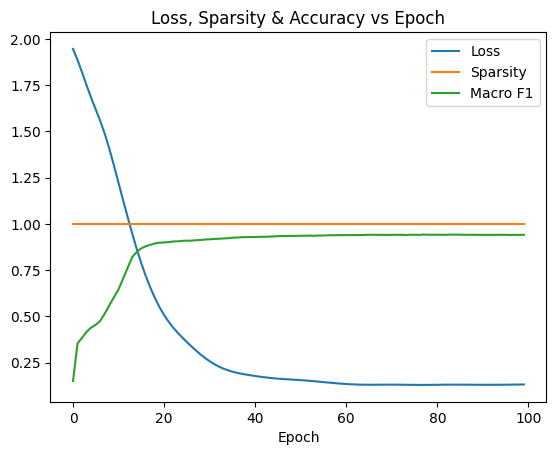

In [ ]:
plt.plot([i.item() for i in loss_list], label="Loss")
plt.plot([i for i in ig_sufficiency_list], label="Sufficiency")
plt.plot([i.item() for i in f1_accuracy_list], label="Macro F1")
plt.title("Loss, Sufficiency & Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.legend()

In [ ]:
df = pd.DataFrame([(loss_list[i].item(), ig_sufficiency_list[i], f1_accuracy_list[i].item()) for i in range(len(loss_list))], columns=["Loss", "IG Sufficiency", "F1 Accuracy"])
df.to_csv("Training_for_IG_sufficiency_CORA")

In [ ]:
gbp = GuidedBP(model=model)
cam = CAM(model=model)

# getting explanations for each model
gbp_spar = gbp_sparsity(model, graph, data, gbp)
cam_spar = cam_sparsity(model, graph, data, gbp)
print(f"GBP Sparsity: {gbp_spar}\nCAM Sparsity: {cam_spar}\n")



100%|██████████| 2708/2708 [26:29<00:00,  1.70it/s]

GBP Sparsity: 1.0
CAM Sparsity: 1.0



In [ ]:
ig_spar = ig_sparsity(model, graph, data)

print(f"IG Spar: {ig_spar}")

  0%|          | 2/2708 [00:00<07:28,  6.04it/s]

tensor([-0.6574, -0.7225, -0.6013, -0.5233], device='cuda:0')


  0%|          | 3/2708 [00:00<08:56,  5.04it/s]

tensor([-0.5203, -0.3700, -0.7551, -0.9783], device='cuda:0')


  0%|          | 4/2708 [00:00<09:50,  4.58it/s]

tensor([-0.8562, -0.5766, -0.4730, -1.1368, -0.3823,  0.0726], device='cuda:0')


  0%|          | 5/2708 [00:01<10:19,  4.36it/s]

tensor([-1.1077, -0.7583], device='cuda:0')


  0%|          | 6/2708 [00:01<11:07,  4.05it/s]

tensor([-0.5199, -0.6340, -0.2173, -0.2145, -0.0319, -0.6756], device='cuda:0')


  0%|          | 7/2708 [00:01<11:24,  3.95it/s]

tensor([-0.4461, -0.9948, -0.4571, -0.6390], device='cuda:0')


  0%|          | 8/2708 [00:01<11:33,  3.89it/s]

tensor([-0.4153, -0.4828, -0.5654, -0.5037, -0.5363], device='cuda:0')


  0%|          | 9/2708 [00:02<11:29,  3.92it/s]

tensor([-1.7944, -0.2029], device='cuda:0')


  0%|          | 10/2708 [00:02<11:34,  3.88it/s]

tensor([-0.6189, -0.9601, -0.6968, -0.6772], device='cuda:0')


  0%|          | 11/2708 [00:02<11:33,  3.89it/s]

tensor([-0.1621, -0.9223, -0.8898], device='cuda:0')


  0%|          | 12/2708 [00:02<11:29,  3.91it/s]

tensor([-0.8606, -0.7249, -0.6413], device='cuda:0')


  0%|          | 13/2708 [00:03<11:26,  3.92it/s]

tensor([-1.3526, -0.1813, -0.2870], device='cuda:0')


  1%|          | 14/2708 [00:03<11:23,  3.94it/s]

tensor([-0.4200, -0.2410, -0.5283, -0.3195, -0.4002], device='cuda:0')


  1%|          | 15/2708 [00:03<11:19,  3.96it/s]

tensor([-1.0116, -0.7319, -0.6148], device='cuda:0')


  1%|          | 16/2708 [00:03<11:23,  3.94it/s]

tensor([-0.8901, -0.2864,  0.0708, -0.5744, -0.2016, -0.7190], device='cuda:0')


  1%|          | 17/2708 [00:04<11:21,  3.95it/s]

tensor([-0.4788, -0.2618, -0.4735, -0.5339, -0.3104], device='cuda:0')


  1%|          | 18/2708 [00:04<11:25,  3.92it/s]

tensor([-0.9772, -0.3799, -0.5573, -0.5985, -0.6028], device='cuda:0')


  1%|          | 19/2708 [00:04<11:27,  3.91it/s]

tensor([-0.4950, -0.8515, -0.5688, -0.4359, -0.5582, -0.3338], device='cuda:0')


  1%|          | 20/2708 [00:04<11:27,  3.91it/s]

tensor([-0.3018, -1.0444, -0.6570, -0.8701, -0.1670, -0.8772], device='cuda:0')


  1%|          | 21/2708 [00:05<11:25,  3.92it/s]

tensor([-1.0686, -0.9931], device='cuda:0')


  1%|          | 22/2708 [00:05<11:26,  3.91it/s]

tensor([-0.3826,  0.0631, -0.8968, -0.9487, -0.6614, -0.3889], device='cuda:0')


  1%|          | 23/2708 [00:05<11:23,  3.93it/s]

tensor([-1.6130,  0.0976, -0.6573], device='cuda:0')


  1%|          | 24/2708 [00:05<11:31,  3.88it/s]

tensor([-0.3956, -0.7277, -0.6689, -0.2478, -0.2256, -0.1082], device='cuda:0')


  1%|          | 25/2708 [00:06<11:36,  3.85it/s]

tensor([-0.4049, -1.6713], device='cuda:0')


  1%|          | 26/2708 [00:06<11:32,  3.88it/s]

tensor([-0.3425, -0.5798, -0.1702, -0.2315, -0.4489, -0.2593, -0.5921, -0.3989],
       device='cuda:0')


  1%|          | 27/2708 [00:06<11:36,  3.85it/s]

tensor([-0.7113, -0.5180, -0.6471, -0.6454, -0.7941], device='cuda:0')


  1%|          | 28/2708 [00:07<11:32,  3.87it/s]

tensor([-0.5213, -0.5076, -0.3410, -0.5158, -0.4208, -0.0247], device='cuda:0')


  1%|          | 29/2708 [00:07<11:36,  3.85it/s]

tensor([-0.7930, -0.5129, -0.4541, -0.4210, -0.4524], device='cuda:0')


  1%|          | 30/2708 [00:07<11:46,  3.79it/s]

tensor([-1.2461, -0.7360], device='cuda:0')


  1%|          | 31/2708 [00:07<11:57,  3.73it/s]

tensor([-0.2923, -1.5444, -0.3596], device='cuda:0')


  1%|          | 32/2708 [00:08<12:08,  3.67it/s]

tensor([-0.9600, -0.5965, -0.4892, -0.4216,  0.2531, -0.5733, -0.7309],
       device='cuda:0')


  1%|          | 33/2708 [00:08<11:52,  3.76it/s]

tensor([-1.1677, -0.9148], device='cuda:0')


  1%|▏         | 34/2708 [00:08<11:49,  3.77it/s]

tensor([-1.0727, -0.4356, -0.0719, -0.8802, -0.3891], device='cuda:0')


  1%|▏         | 35/2708 [00:08<11:56,  3.73it/s]

tensor([-0.6708, -0.2133, -0.4639, -0.0452, -0.1081, -0.2871, -0.5587, -0.3957,
        -0.1813, -0.5420], device='cuda:0')


  1%|▏         | 36/2708 [00:09<11:49,  3.77it/s]

tensor([-0.9400, -1.0512], device='cuda:0')


  1%|▏         | 37/2708 [00:09<11:40,  3.82it/s]

tensor([-0.4529, -0.4503, -0.3648, -0.6088], device='cuda:0')


  1%|▏         | 38/2708 [00:09<11:38,  3.82it/s]

tensor([-0.5024, -0.2346, -0.5609, -0.3737, -0.3356, -0.3844, -0.2932, -0.3747,
        -0.2052], device='cuda:0')


  1%|▏         | 39/2708 [00:09<11:43,  3.80it/s]

tensor([-1.3181, -0.1349, -0.4077, -0.1352], device='cuda:0')


  1%|▏         | 40/2708 [00:10<11:49,  3.76it/s]

tensor([-0.9254, -0.6111, -0.1048, -0.3196, -0.2110], device='cuda:0')


  2%|▏         | 41/2708 [00:10<11:39,  3.81it/s]

tensor([-0.4832, -0.8994, -0.2025, -0.5024, -0.3493, -0.3469, -0.3100, -0.1292],
       device='cuda:0')


  2%|▏         | 42/2708 [00:10<11:35,  3.83it/s]

tensor([-0.9360, -0.1485, -0.8748, -0.8013], device='cuda:0')


  2%|▏         | 43/2708 [00:10<11:30,  3.86it/s]

tensor([-0.5408, -0.5323, -0.5018, -0.2520, -0.5001], device='cuda:0')


  2%|▏         | 44/2708 [00:11<11:30,  3.86it/s]

tensor([-0.9175, -0.6259, -0.8920], device='cuda:0')


  2%|▏         | 45/2708 [00:11<11:29,  3.86it/s]

tensor([-0.5529, -0.4633, -0.6824, -0.1575, -0.6823, -0.4527, -0.1097],
       device='cuda:0')


  2%|▏         | 46/2708 [00:11<11:26,  3.88it/s]

tensor([-0.7863, -0.6055, -0.3041, -0.7659], device='cuda:0')


  2%|▏         | 47/2708 [00:12<11:24,  3.89it/s]

tensor([-0.6369, -0.1579,  0.0096, -0.2302, -0.7066, -0.8424, -0.8205],
       device='cuda:0')


  2%|▏         | 48/2708 [00:12<11:23,  3.89it/s]

tensor([-0.5954, -0.7689, -1.0760], device='cuda:0')


  2%|▏         | 49/2708 [00:12<11:25,  3.88it/s]

tensor([-0.6883, -0.7915, -0.8190], device='cuda:0')


  2%|▏         | 50/2708 [00:12<11:31,  3.84it/s]

tensor([-0.7514, -0.5609, -0.5929, -0.4977, -0.6895, -0.1147, -0.3839, -0.4977,
        -0.3521, -0.1876], device='cuda:0')


  2%|▏         | 51/2708 [00:13<11:27,  3.86it/s]

tensor([-0.9633, -0.3087, -0.7496], device='cuda:0')


  2%|▏         | 52/2708 [00:13<11:32,  3.84it/s]

tensor([-1.0716, -0.7867], device='cuda:0')


  2%|▏         | 53/2708 [00:13<11:26,  3.87it/s]

tensor([-0.8026, -0.6366, -0.5278, -0.3520, -0.0046, -0.2991, -0.3643],
       device='cuda:0')


  2%|▏         | 54/2708 [00:13<11:26,  3.87it/s]

tensor([-0.2594, -0.6112, -0.5430, -0.0218, -0.8436, -0.6938], device='cuda:0')


  2%|▏         | 55/2708 [00:14<11:26,  3.87it/s]

tensor([-0.6441, -0.4541, -0.7002, -0.3384], device='cuda:0')


  2%|▏         | 56/2708 [00:14<11:24,  3.88it/s]

tensor([-0.5803, -0.7055, -1.0509], device='cuda:0')


  2%|▏         | 57/2708 [00:14<11:28,  3.85it/s]

tensor([-0.9221,  0.3088, -0.4489, -0.3684, -0.2524, -0.0571, -0.5076, -0.1804,
        -0.2160, -0.0491, -0.4002, -0.8905,  0.1593], device='cuda:0')


  2%|▏         | 58/2708 [00:14<11:34,  3.82it/s]

tensor([-0.4749, -0.3756, -0.3725, -0.5048, -0.4532], device='cuda:0')


  2%|▏         | 59/2708 [00:15<11:46,  3.75it/s]

tensor([-1.2448, -0.8058], device='cuda:0')


  2%|▏         | 60/2708 [00:15<11:38,  3.79it/s]

tensor([-0.3131, -1.6650], device='cuda:0')


  2%|▏         | 61/2708 [00:15<11:45,  3.75it/s]

tensor([-0.4681, -0.5944, -0.3451, -0.4504, -0.3806, -0.3288, -0.3684, -0.7651,
        -0.3525, -0.0654, -0.5855], device='cuda:0')


  2%|▏         | 62/2708 [00:15<11:42,  3.77it/s]

tensor([ 0.1158,  0.6875, -1.3673, -0.8284], device='cuda:0')


  2%|▏         | 63/2708 [00:16<11:49,  3.73it/s]

tensor([-0.6049, -0.1793, -0.9846, -0.9551, -0.0148, -0.7559], device='cuda:0')


  2%|▏         | 64/2708 [00:16<11:47,  3.74it/s]

tensor([-0.4189, -1.4566], device='cuda:0')


  2%|▏         | 65/2708 [00:16<11:40,  3.77it/s]

tensor([-1.1445, -0.6135], device='cuda:0')


  2%|▏         | 66/2708 [00:17<11:26,  3.85it/s]

tensor([-0.6229, -0.6396, -0.7113, -0.1714], device='cuda:0')


KeyboardInterrupt: 

50 Epochs

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from statistics import median
torch.manual_seed(12345)
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = GCNConv(dataset[0].num_nodes, 16)
        self.conv1 = GCNConv(dataset.num_node_features, 16)

        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
graph = to_networkx(data)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
model.train()


for epoch in range(50):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())

print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8040


In [ ]:
gbp = GuidedBP(model=model)
cam = CAM(model=model)

# getting explanations for each model
gbp_spar = gbp_sparsity(model, graph, data, gbp)
cam_spar = cam_sparsity(model, graph, data, gbp)
print(f"GBP Sparsity: {gbp_spar}\nCAM Sparsity: {cam_spar}\n")

100%|██████████| 2708/2708 [12:55<00:00,  3.49it/s]

GBP Sparsity: 1.0
CAM Sparsity: 1.0



In [ ]:

ig_spar = ig_sparsity(model, graph, data)

print(f"IG Spar: {ig_spar}")


100%|██████████| 2708/2708 [11:26<00:00,  3.95it/s]

IG Spar: 1.0


100 Epochs

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from statistics import median
torch.manual_seed(12345)
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = GCNConv(dataset[0].num_nodes, 16)
        self.conv1 = GCNConv(dataset.num_node_features, 16)

        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
graph = to_networkx(data)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
model.train()


for epoch in range(100):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())

print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7960


In [ ]:
gbp = GuidedBP(model=model)
cam = CAM(model=model)

# getting explanations for each model
gbp_spar = gbp_sparsity(model, graph, data, gbp)
cam_spar = cam_sparsity(model, graph, data, gbp)
print(f"GBP Sparsity: {gbp_spar}\nCAM Sparsity: {cam_spar}\n")

100%|██████████| 2708/2708 [17:32<00:00,  2.57it/s]

GBP Sparsity: 1.0
CAM Sparsity: 1.0



In [ ]:

ig_spar = ig_sparsity(model, graph, data)

print(f"IG Spar: {ig_spar}")

100%|██████████| 2708/2708 [10:33<00:00,  4.28it/s]

IG Spar: 1.0
